In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, AlphaDropout, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Directorios de los datasets
train_dir = "../datos/train"
val_dir = "../datos/val"
test_dir = "../datos/test"

In [3]:
# Parámetros
img_size = (224, 224)
batch_size = 8
num_classes = 4  # Normal, Pólipos, Úlcera, Esophagitis

datagen_train = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,  # Rotación de hasta 45 grados
    width_shift_range=0.2,  # Desplazamiento horizontal del 10%
    height_shift_range=0.2,  # Desplazamiento vertical del 10%
    shear_range=0.3,  # Transformación de cizallamiento del 10%
    zoom_range=0.3,  # Zoom de hasta un 10%
    horizontal_flip=True,  # Volteo horizontal
    vertical_flip=True,  # Volteo vertical
    fill_mode='constant',  # Relleno con valores constantes
    brightness_range=[0.05, 1.5],  # Ajuste de brillo entre 0.1 y 1.0
    channel_shift_range=50.0  # Cambios agresivos en canales de color
)

 #evitamos el sobreajuste
datagen_val_test = ImageDataGenerator(rescale=1.0/255)

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical' #salida formato one_hot encoding ya que hay mas de 2 clases
)

val_generator = datagen_val_test.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical', #salida formato one_hot encoding ya que hay mas de 2 clases
    shuffle=False
)

test_generator = datagen_val_test.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical', #salida formato one_hot encoding ya que hay mas de 2 clases
    shuffle=False
)

Found 3200 images belonging to 4 classes.


Found 2000 images belonging to 4 classes.


Found 800 images belonging to 4 classes.


In [4]:
# Cargar modelo preentrenado MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelamos las capas del modelo base

In [5]:
# Construcción del modelo
x = base_model.layers[-39].output #Equivalent to four (4) CORE block deduction.

# Capa convolucional
x = Conv2D(filters=192, kernel_size=8, strides=1, padding='valid',
           activation='selu', kernel_initializer='lecun_normal')(x)

# Capa de Average Pooling 
x = AveragePooling2D(pool_size=1, strides=1, padding='valid')(x)

# Global Average Pooling para reducir dimensiones antes de la capa densa
x = GlobalAveragePooling2D()(x)

# Capa fully connected
x = Dense(512, activation='selu', kernel_initializer='lecun_normal')(x)  # 512 neuronas

# Dropout ajustado 
x = AlphaDropout(0.2)(x)  # Reducimos sobreajuste apagando el 20% de las neuronas

# Capa de salida con 4 clases y activación softmax
outputs = Dense(num_classes, activation='softmax')(x)

# Creación del modelo
model = Model(inputs=base_model.input, outputs=outputs)

In [6]:
model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               


                                )]                                                                


 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                


                                )                                                                 


 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  


                                )                                                                 


 Conv1_relu (ReLU)              (None, 112, 112, 32  0           ['bn_Conv1[0][0]']               


                                )                                                                 


 expanded_conv_depthwise (Depth  (None, 112, 112, 32  288        ['Conv1_relu[0][0]']             


 wiseConv2D)                    )                                                                 


 expanded_conv_depthwise_BN (Ba  (None, 112, 112, 32  128        ['expanded_conv_depthwise[0][0]']


 tchNormalization)              )                                                                 


 expanded_conv_depthwise_relu (  (None, 112, 112, 32  0          ['expanded_conv_depthwise_BN[0][0


 ReLU)                          )                                ]']                              


 expanded_conv_project (Conv2D)  (None, 112, 112, 16  512        ['expanded_conv_depthwise_relu[0]


                                )                                [0]']                            


 expanded_conv_project_BN (Batc  (None, 112, 112, 16  64         ['expanded_conv_project[0][0]']  


 hNormalization)                )                                                                 


 block_1_expand (Conv2D)        (None, 112, 112, 96  1536        ['expanded_conv_project_BN[0][0]'


                                )                                ]                                


 block_1_expand_BN (BatchNormal  (None, 112, 112, 96  384        ['block_1_expand[0][0]']         


 ization)                       )                                                                 


 block_1_expand_relu (ReLU)     (None, 112, 112, 96  0           ['block_1_expand_BN[0][0]']      


                                )                                                                 


 block_1_pad (ZeroPadding2D)    (None, 113, 113, 96  0           ['block_1_expand_relu[0][0]']    


                                )                                                                 


 block_1_depthwise (DepthwiseCo  (None, 56, 56, 96)  864         ['block_1_pad[0][0]']            


 nv2D)                                                                                            


 block_1_depthwise_BN (BatchNor  (None, 56, 56, 96)  384         ['block_1_depthwise[0][0]']      


 malization)                                                                                      


 block_1_depthwise_relu (ReLU)  (None, 56, 56, 96)   0           ['block_1_depthwise_BN[0][0]']   


 block_1_project (Conv2D)       (None, 56, 56, 24)   2304        ['block_1_depthwise_relu[0][0]'] 


 block_1_project_BN (BatchNorma  (None, 56, 56, 24)  96          ['block_1_project[0][0]']        


 lization)                                                                                        


 block_2_expand (Conv2D)        (None, 56, 56, 144)  3456        ['block_1_project_BN[0][0]']     


 block_2_expand_BN (BatchNormal  (None, 56, 56, 144)  576        ['block_2_expand[0][0]']         


 ization)                                                                                         


 block_2_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_2_expand_BN[0][0]']      


 block_2_depthwise (DepthwiseCo  (None, 56, 56, 144)  1296       ['block_2_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_2_depthwise_BN (BatchNor  (None, 56, 56, 144)  576        ['block_2_depthwise[0][0]']      


 malization)                                                                                      


 block_2_depthwise_relu (ReLU)  (None, 56, 56, 144)  0           ['block_2_depthwise_BN[0][0]']   


 block_2_project (Conv2D)       (None, 56, 56, 24)   3456        ['block_2_depthwise_relu[0][0]'] 


 block_2_project_BN (BatchNorma  (None, 56, 56, 24)  96          ['block_2_project[0][0]']        


 lization)                                                                                        


 block_2_add (Add)              (None, 56, 56, 24)   0           ['block_1_project_BN[0][0]',     


                                                                  'block_2_project_BN[0][0]']     


 block_3_expand (Conv2D)        (None, 56, 56, 144)  3456        ['block_2_add[0][0]']            


 block_3_expand_BN (BatchNormal  (None, 56, 56, 144)  576        ['block_3_expand[0][0]']         


 ization)                                                                                         


 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      


 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    


 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            


 nv2D)                                                                                            


 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      


 malization)                                                                                      


 block_3_depthwise_relu (ReLU)  (None, 28, 28, 144)  0           ['block_3_depthwise_BN[0][0]']   


 block_3_project (Conv2D)       (None, 28, 28, 32)   4608        ['block_3_depthwise_relu[0][0]'] 


 block_3_project_BN (BatchNorma  (None, 28, 28, 32)  128         ['block_3_project[0][0]']        


 lization)                                                                                        


 block_4_expand (Conv2D)        (None, 28, 28, 192)  6144        ['block_3_project_BN[0][0]']     


 block_4_expand_BN (BatchNormal  (None, 28, 28, 192)  768        ['block_4_expand[0][0]']         


 ization)                                                                                         


 block_4_expand_relu (ReLU)     (None, 28, 28, 192)  0           ['block_4_expand_BN[0][0]']      


 block_4_depthwise (DepthwiseCo  (None, 28, 28, 192)  1728       ['block_4_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_4_depthwise_BN (BatchNor  (None, 28, 28, 192)  768        ['block_4_depthwise[0][0]']      


 malization)                                                                                      


 block_4_depthwise_relu (ReLU)  (None, 28, 28, 192)  0           ['block_4_depthwise_BN[0][0]']   


 block_4_project (Conv2D)       (None, 28, 28, 32)   6144        ['block_4_depthwise_relu[0][0]'] 


 block_4_project_BN (BatchNorma  (None, 28, 28, 32)  128         ['block_4_project[0][0]']        


 lization)                                                                                        


 block_4_add (Add)              (None, 28, 28, 32)   0           ['block_3_project_BN[0][0]',     


                                                                  'block_4_project_BN[0][0]']     


 block_5_expand (Conv2D)        (None, 28, 28, 192)  6144        ['block_4_add[0][0]']            


 block_5_expand_BN (BatchNormal  (None, 28, 28, 192)  768        ['block_5_expand[0][0]']         


 ization)                                                                                         


 block_5_expand_relu (ReLU)     (None, 28, 28, 192)  0           ['block_5_expand_BN[0][0]']      


 block_5_depthwise (DepthwiseCo  (None, 28, 28, 192)  1728       ['block_5_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_5_depthwise_BN (BatchNor  (None, 28, 28, 192)  768        ['block_5_depthwise[0][0]']      


 malization)                                                                                      


 block_5_depthwise_relu (ReLU)  (None, 28, 28, 192)  0           ['block_5_depthwise_BN[0][0]']   


 block_5_project (Conv2D)       (None, 28, 28, 32)   6144        ['block_5_depthwise_relu[0][0]'] 


 block_5_project_BN (BatchNorma  (None, 28, 28, 32)  128         ['block_5_project[0][0]']        


 lization)                                                                                        


 block_5_add (Add)              (None, 28, 28, 32)   0           ['block_4_add[0][0]',            


                                                                  'block_5_project_BN[0][0]']     


 block_6_expand (Conv2D)        (None, 28, 28, 192)  6144        ['block_5_add[0][0]']            


 block_6_expand_BN (BatchNormal  (None, 28, 28, 192)  768        ['block_6_expand[0][0]']         


 ization)                                                                                         


 block_6_expand_relu (ReLU)     (None, 28, 28, 192)  0           ['block_6_expand_BN[0][0]']      


 block_6_pad (ZeroPadding2D)    (None, 29, 29, 192)  0           ['block_6_expand_relu[0][0]']    


 block_6_depthwise (DepthwiseCo  (None, 14, 14, 192)  1728       ['block_6_pad[0][0]']            


 nv2D)                                                                                            


 block_6_depthwise_BN (BatchNor  (None, 14, 14, 192)  768        ['block_6_depthwise[0][0]']      


 malization)                                                                                      


 block_6_depthwise_relu (ReLU)  (None, 14, 14, 192)  0           ['block_6_depthwise_BN[0][0]']   


 block_6_project (Conv2D)       (None, 14, 14, 64)   12288       ['block_6_depthwise_relu[0][0]'] 


 block_6_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_6_project[0][0]']        


 lization)                                                                                        


 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     


 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         


 ization)                                                                                         


 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      


 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_7_depthwise_BN (BatchNor  (None, 14, 14, 384)  1536       ['block_7_depthwise[0][0]']      


 malization)                                                                                      


 block_7_depthwise_relu (ReLU)  (None, 14, 14, 384)  0           ['block_7_depthwise_BN[0][0]']   


 block_7_project (Conv2D)       (None, 14, 14, 64)   24576       ['block_7_depthwise_relu[0][0]'] 


 block_7_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_7_project[0][0]']        


 lization)                                                                                        


 block_7_add (Add)              (None, 14, 14, 64)   0           ['block_6_project_BN[0][0]',     


                                                                  'block_7_project_BN[0][0]']     


 block_8_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_7_add[0][0]']            


 block_8_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_8_expand[0][0]']         


 ization)                                                                                         


 block_8_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_8_expand_BN[0][0]']      


 block_8_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_8_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_8_depthwise_BN (BatchNor  (None, 14, 14, 384)  1536       ['block_8_depthwise[0][0]']      


 malization)                                                                                      


 block_8_depthwise_relu (ReLU)  (None, 14, 14, 384)  0           ['block_8_depthwise_BN[0][0]']   


 block_8_project (Conv2D)       (None, 14, 14, 64)   24576       ['block_8_depthwise_relu[0][0]'] 


 block_8_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_8_project[0][0]']        


 lization)                                                                                        


 block_8_add (Add)              (None, 14, 14, 64)   0           ['block_7_add[0][0]',            


                                                                  'block_8_project_BN[0][0]']     


 block_9_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_8_add[0][0]']            


 block_9_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_9_expand[0][0]']         


 ization)                                                                                         


 block_9_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_9_expand_BN[0][0]']      


 block_9_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_9_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_9_depthwise_BN (BatchNor  (None, 14, 14, 384)  1536       ['block_9_depthwise[0][0]']      


 malization)                                                                                      


 block_9_depthwise_relu (ReLU)  (None, 14, 14, 384)  0           ['block_9_depthwise_BN[0][0]']   


 block_9_project (Conv2D)       (None, 14, 14, 64)   24576       ['block_9_depthwise_relu[0][0]'] 


 block_9_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_9_project[0][0]']        


 lization)                                                                                        


 block_9_add (Add)              (None, 14, 14, 64)   0           ['block_8_add[0][0]',            


                                                                  'block_9_project_BN[0][0]']     


 block_10_expand (Conv2D)       (None, 14, 14, 384)  24576       ['block_9_add[0][0]']            


 block_10_expand_BN (BatchNorma  (None, 14, 14, 384)  1536       ['block_10_expand[0][0]']        


 lization)                                                                                        


 block_10_expand_relu (ReLU)    (None, 14, 14, 384)  0           ['block_10_expand_BN[0][0]']     


 block_10_depthwise (DepthwiseC  (None, 14, 14, 384)  3456       ['block_10_expand_relu[0][0]']   


 onv2D)                                                                                           


 block_10_depthwise_BN (BatchNo  (None, 14, 14, 384)  1536       ['block_10_depthwise[0][0]']     


 rmalization)                                                                                     


 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  


 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']


 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       


 alization)                                                                                       


 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    


 block_11_expand_BN (BatchNorma  (None, 14, 14, 576)  2304       ['block_11_expand[0][0]']        


 lization)                                                                                        


 block_11_expand_relu (ReLU)    (None, 14, 14, 576)  0           ['block_11_expand_BN[0][0]']     


 block_11_depthwise (DepthwiseC  (None, 14, 14, 576)  5184       ['block_11_expand_relu[0][0]']   


 onv2D)                                                                                           


 block_11_depthwise_BN (BatchNo  (None, 14, 14, 576)  2304       ['block_11_depthwise[0][0]']     


 rmalization)                                                                                     


 block_11_depthwise_relu (ReLU)  (None, 14, 14, 576)  0          ['block_11_depthwise_BN[0][0]']  


 block_11_project (Conv2D)      (None, 14, 14, 96)   55296       ['block_11_depthwise_relu[0][0]']


 block_11_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_11_project[0][0]']       


 alization)                                                                                       


 block_11_add (Add)             (None, 14, 14, 96)   0           ['block_10_project_BN[0][0]',    


                                                                  'block_11_project_BN[0][0]']    


 block_12_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_11_add[0][0]']           


 block_12_expand_BN (BatchNorma  (None, 14, 14, 576)  2304       ['block_12_expand[0][0]']        


 lization)                                                                                        


 block_12_expand_relu (ReLU)    (None, 14, 14, 576)  0           ['block_12_expand_BN[0][0]']     


 block_12_depthwise (DepthwiseC  (None, 14, 14, 576)  5184       ['block_12_expand_relu[0][0]']   


 onv2D)                                                                                           


 block_12_depthwise_BN (BatchNo  (None, 14, 14, 576)  2304       ['block_12_depthwise[0][0]']     


 rmalization)                                                                                     


 block_12_depthwise_relu (ReLU)  (None, 14, 14, 576)  0          ['block_12_depthwise_BN[0][0]']  


 block_12_project (Conv2D)      (None, 14, 14, 96)   55296       ['block_12_depthwise_relu[0][0]']


 block_12_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_12_project[0][0]']       


 alization)                                                                                       


 block_12_add (Add)             (None, 14, 14, 96)   0           ['block_11_add[0][0]',           


                                                                  'block_12_project_BN[0][0]']    


 conv2d (Conv2D)                (None, 7, 7, 192)    1179840     ['block_12_add[0][0]']           


 average_pooling2d (AveragePool  (None, 7, 7, 192)   0           ['conv2d[0][0]']                 


 ing2D)                                                                                           


 global_average_pooling2d (Glob  (None, 192)         0           ['average_pooling2d[0][0]']      


 alAveragePooling2D)                                                                              


 dense (Dense)                  (None, 512)          98816       ['global_average_pooling2d[0][0]'


                                                                 ]                                


 alpha_dropout (AlphaDropout)   (None, 512)          0           ['dense[0][0]']                  


 dense_1 (Dense)                (None, 4)            2052        ['alpha_dropout[0][0]']          


Total params: 1,839,364


Trainable params: 1,280,708


Non-trainable params: 558,656


__________________________________________________________________________________________________


In [7]:
# Compilación del modelo
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) #con funcion de perdida porque es multiclase

In [8]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('mobilenetv2_best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1) # Reduce LR si no hay mejora en 2 épocas

In [9]:
# Entrenamiento del modelo
epochs = 500 #puede detenerse antes si no mejora la validacion
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/500



  1/400 [..............................] - ETA: 31:07 - loss: 1.9227 - accuracy: 0.3750


  3/400 [..............................] - ETA: 20s - loss: 2.2181 - accuracy: 0.2083  


  4/400 [..............................] - ETA: 25s - loss: 2.2572 - accuracy: 0.1562


  5/400 [..............................] - ETA: 26s - loss: 2.0940 - accuracy: 0.2000


  6/400 [..............................] - ETA: 27s - loss: 2.1652 - accuracy: 0.1667


  7/400 [..............................] - ETA: 29s - loss: 2.2700 - accuracy: 0.1607


  8/400 [..............................] - ETA: 29s - loss: 2.2856 - accuracy: 0.1562


  9/400 [..............................] - ETA: 29s - loss: 2.2809 - accuracy: 0.1667


 10/400 [..............................] - ETA: 30s - loss: 2.2200 - accuracy: 0.2000


 11/400 [..............................] - ETA: 31s - loss: 2.1750 - accuracy: 0.2045


 12/400 [..............................] - ETA: 31s - loss: 2.1126 - accuracy: 0.2083


 13/400 [..............................] - ETA: 31s - loss: 2.1309 - accuracy: 0.2212


 14/400 [>.............................] - ETA: 32s - loss: 2.1379 - accuracy: 0.2232


 15/400 [>.............................] - ETA: 32s - loss: 2.1265 - accuracy: 0.2333


 16/400 [>.............................] - ETA: 32s - loss: 2.1114 - accuracy: 0.2344


 17/400 [>.............................] - ETA: 31s - loss: 2.0828 - accuracy: 0.2353


 18/400 [>.............................] - ETA: 32s - loss: 2.0880 - accuracy: 0.2222


 19/400 [>.............................] - ETA: 32s - loss: 2.0467 - accuracy: 0.2303


 20/400 [>.............................] - ETA: 31s - loss: 2.0661 - accuracy: 0.2375


 21/400 [>.............................] - ETA: 31s - loss: 2.0621 - accuracy: 0.2321


 22/400 [>.............................] - ETA: 31s - loss: 2.0581 - accuracy: 0.2273


 23/400 [>.............................] - ETA: 31s - loss: 2.0083 - accuracy: 0.2446


 24/400 [>.............................] - ETA: 32s - loss: 1.9749 - accuracy: 0.2552


 25/400 [>.............................] - ETA: 31s - loss: 1.9700 - accuracy: 0.2650


 26/400 [>.............................] - ETA: 31s - loss: 1.9574 - accuracy: 0.2644


 27/400 [=>............................] - ETA: 31s - loss: 1.9453 - accuracy: 0.2639


 28/400 [=>............................] - ETA: 31s - loss: 1.9258 - accuracy: 0.2679


 29/400 [=>............................] - ETA: 31s - loss: 1.9148 - accuracy: 0.2716


 30/400 [=>............................] - ETA: 31s - loss: 1.8977 - accuracy: 0.2750


 31/400 [=>............................] - ETA: 31s - loss: 1.8923 - accuracy: 0.2782


 32/400 [=>............................] - ETA: 31s - loss: 1.8721 - accuracy: 0.2852


 33/400 [=>............................] - ETA: 31s - loss: 1.8811 - accuracy: 0.2841


 34/400 [=>............................] - ETA: 30s - loss: 1.8782 - accuracy: 0.2794


 35/400 [=>............................] - ETA: 30s - loss: 1.8531 - accuracy: 0.2857


 36/400 [=>............................] - ETA: 30s - loss: 1.8461 - accuracy: 0.2847


 37/400 [=>............................] - ETA: 30s - loss: 1.8345 - accuracy: 0.2872


 38/400 [=>............................] - ETA: 30s - loss: 1.8457 - accuracy: 0.2829


 39/400 [=>............................] - ETA: 30s - loss: 1.8200 - accuracy: 0.2949


 40/400 [==>...........................] - ETA: 30s - loss: 1.8057 - accuracy: 0.3000


 41/400 [==>...........................] - ETA: 30s - loss: 1.7976 - accuracy: 0.3018


 42/400 [==>...........................] - ETA: 30s - loss: 1.7797 - accuracy: 0.3095


 43/400 [==>...........................] - ETA: 30s - loss: 1.7559 - accuracy: 0.3198


 44/400 [==>...........................] - ETA: 30s - loss: 1.7524 - accuracy: 0.3182


 45/400 [==>...........................] - ETA: 30s - loss: 1.7490 - accuracy: 0.3167


 46/400 [==>...........................] - ETA: 29s - loss: 1.7569 - accuracy: 0.3179


 47/400 [==>...........................] - ETA: 29s - loss: 1.7597 - accuracy: 0.3138


 48/400 [==>...........................] - ETA: 29s - loss: 1.7463 - accuracy: 0.3203


 49/400 [==>...........................] - ETA: 29s - loss: 1.7451 - accuracy: 0.3240


 50/400 [==>...........................] - ETA: 29s - loss: 1.7473 - accuracy: 0.3200


 51/400 [==>...........................] - ETA: 29s - loss: 1.7223 - accuracy: 0.3309


 52/400 [==>...........................] - ETA: 29s - loss: 1.7160 - accuracy: 0.3365


 53/400 [==>...........................] - ETA: 29s - loss: 1.7088 - accuracy: 0.3373


 54/400 [===>..........................] - ETA: 29s - loss: 1.7074 - accuracy: 0.3356


 55/400 [===>..........................] - ETA: 29s - loss: 1.7013 - accuracy: 0.3386


 56/400 [===>..........................] - ETA: 29s - loss: 1.6933 - accuracy: 0.3415


 57/400 [===>..........................] - ETA: 29s - loss: 1.6912 - accuracy: 0.3421


 58/400 [===>..........................] - ETA: 29s - loss: 1.6848 - accuracy: 0.3448


 59/400 [===>..........................] - ETA: 29s - loss: 1.6687 - accuracy: 0.3538


 60/400 [===>..........................] - ETA: 29s - loss: 1.6798 - accuracy: 0.3500


 61/400 [===>..........................] - ETA: 29s - loss: 1.6835 - accuracy: 0.3525


 62/400 [===>..........................] - ETA: 28s - loss: 1.6815 - accuracy: 0.3528


 63/400 [===>..........................] - ETA: 28s - loss: 1.6645 - accuracy: 0.3591


 64/400 [===>..........................] - ETA: 28s - loss: 1.6580 - accuracy: 0.3613


 65/400 [===>..........................] - ETA: 28s - loss: 1.6471 - accuracy: 0.3635


 66/400 [===>..........................] - ETA: 28s - loss: 1.6361 - accuracy: 0.3693


 67/400 [====>.........................] - ETA: 28s - loss: 1.6330 - accuracy: 0.3713


 68/400 [====>.........................] - ETA: 28s - loss: 1.6185 - accuracy: 0.3768


 69/400 [====>.........................] - ETA: 28s - loss: 1.6135 - accuracy: 0.3768


 70/400 [====>.........................] - ETA: 28s - loss: 1.6079 - accuracy: 0.3804


 71/400 [====>.........................] - ETA: 28s - loss: 1.5945 - accuracy: 0.3856


 72/400 [====>.........................] - ETA: 28s - loss: 1.5895 - accuracy: 0.3837


 73/400 [====>.........................] - ETA: 28s - loss: 1.5827 - accuracy: 0.3853


 74/400 [====>.........................] - ETA: 28s - loss: 1.5723 - accuracy: 0.3885


 75/400 [====>.........................] - ETA: 28s - loss: 1.5663 - accuracy: 0.3900


 76/400 [====>.........................] - ETA: 28s - loss: 1.5600 - accuracy: 0.3931


 77/400 [====>.........................] - ETA: 27s - loss: 1.5561 - accuracy: 0.3929


 78/400 [====>.........................] - ETA: 27s - loss: 1.5516 - accuracy: 0.3926


 79/400 [====>.........................] - ETA: 27s - loss: 1.5528 - accuracy: 0.3908


 80/400 [=====>........................] - ETA: 27s - loss: 1.5439 - accuracy: 0.3953


 81/400 [=====>........................] - ETA: 27s - loss: 1.5337 - accuracy: 0.3981


 82/400 [=====>........................] - ETA: 27s - loss: 1.5307 - accuracy: 0.3963


 83/400 [=====>........................] - ETA: 27s - loss: 1.5257 - accuracy: 0.3991


 84/400 [=====>........................] - ETA: 27s - loss: 1.5241 - accuracy: 0.3988


 85/400 [=====>........................] - ETA: 27s - loss: 1.5160 - accuracy: 0.4000


 86/400 [=====>........................] - ETA: 27s - loss: 1.5117 - accuracy: 0.4026


 87/400 [=====>........................] - ETA: 27s - loss: 1.5111 - accuracy: 0.4037


 88/400 [=====>........................] - ETA: 26s - loss: 1.5063 - accuracy: 0.4062


 89/400 [=====>........................] - ETA: 26s - loss: 1.4996 - accuracy: 0.4087


 90/400 [=====>........................] - ETA: 26s - loss: 1.4897 - accuracy: 0.4125


 91/400 [=====>........................] - ETA: 26s - loss: 1.4805 - accuracy: 0.4162


 92/400 [=====>........................] - ETA: 26s - loss: 1.4789 - accuracy: 0.4171


 93/400 [=====>........................] - ETA: 26s - loss: 1.4761 - accuracy: 0.4180


 94/400 [======>.......................] - ETA: 26s - loss: 1.4723 - accuracy: 0.4202


 95/400 [======>.......................] - ETA: 26s - loss: 1.4681 - accuracy: 0.4184


 96/400 [======>.......................] - ETA: 26s - loss: 1.4647 - accuracy: 0.4206


 97/400 [======>.......................] - ETA: 26s - loss: 1.4610 - accuracy: 0.4214


 98/400 [======>.......................] - ETA: 26s - loss: 1.4640 - accuracy: 0.4184


 99/400 [======>.......................] - ETA: 26s - loss: 1.4663 - accuracy: 0.4154


100/400 [======>.......................] - ETA: 25s - loss: 1.4627 - accuracy: 0.4187


101/400 [======>.......................] - ETA: 25s - loss: 1.4569 - accuracy: 0.4208


102/400 [======>.......................] - ETA: 25s - loss: 1.4551 - accuracy: 0.4216


103/400 [======>.......................] - ETA: 25s - loss: 1.4451 - accuracy: 0.4260


104/400 [======>.......................] - ETA: 25s - loss: 1.4401 - accuracy: 0.4291


105/400 [======>.......................] - ETA: 25s - loss: 1.4375 - accuracy: 0.4298


106/400 [======>.......................] - ETA: 25s - loss: 1.4374 - accuracy: 0.4281


107/400 [=======>......................] - ETA: 25s - loss: 1.4386 - accuracy: 0.4276


108/400 [=======>......................] - ETA: 25s - loss: 1.4370 - accuracy: 0.4282


109/400 [=======>......................] - ETA: 25s - loss: 1.4341 - accuracy: 0.4300


110/400 [=======>......................] - ETA: 25s - loss: 1.4292 - accuracy: 0.4318


111/400 [=======>......................] - ETA: 24s - loss: 1.4233 - accuracy: 0.4336


112/400 [=======>......................] - ETA: 24s - loss: 1.4167 - accuracy: 0.4353


113/400 [=======>......................] - ETA: 24s - loss: 1.4125 - accuracy: 0.4369


114/400 [=======>......................] - ETA: 24s - loss: 1.4093 - accuracy: 0.4375


115/400 [=======>......................] - ETA: 24s - loss: 1.4047 - accuracy: 0.4402


116/400 [=======>......................] - ETA: 24s - loss: 1.4030 - accuracy: 0.4386


117/400 [=======>......................] - ETA: 24s - loss: 1.3971 - accuracy: 0.4402


118/400 [=======>......................] - ETA: 24s - loss: 1.3938 - accuracy: 0.4407


119/400 [=======>......................] - ETA: 24s - loss: 1.3866 - accuracy: 0.4422


120/400 [========>.....................] - ETA: 24s - loss: 1.3818 - accuracy: 0.4437


121/400 [========>.....................] - ETA: 23s - loss: 1.3783 - accuracy: 0.4452


122/400 [========>.....................] - ETA: 23s - loss: 1.3735 - accuracy: 0.4457


123/400 [========>.....................] - ETA: 23s - loss: 1.3691 - accuracy: 0.4472


124/400 [========>.....................] - ETA: 23s - loss: 1.3721 - accuracy: 0.4456


125/400 [========>.....................] - ETA: 23s - loss: 1.3727 - accuracy: 0.4450


126/400 [========>.....................] - ETA: 23s - loss: 1.3751 - accuracy: 0.4454


127/400 [========>.....................] - ETA: 23s - loss: 1.3740 - accuracy: 0.4449


128/400 [========>.....................] - ETA: 23s - loss: 1.3727 - accuracy: 0.4453


129/400 [========>.....................] - ETA: 23s - loss: 1.3683 - accuracy: 0.4477


130/400 [========>.....................] - ETA: 23s - loss: 1.3630 - accuracy: 0.4500


131/400 [========>.....................] - ETA: 23s - loss: 1.3585 - accuracy: 0.4523


132/400 [========>.....................] - ETA: 22s - loss: 1.3603 - accuracy: 0.4527


133/400 [========>.....................] - ETA: 22s - loss: 1.3570 - accuracy: 0.4549


134/400 [=========>....................] - ETA: 22s - loss: 1.3544 - accuracy: 0.4552


135/400 [=========>....................] - ETA: 22s - loss: 1.3476 - accuracy: 0.4583


136/400 [=========>....................] - ETA: 22s - loss: 1.3448 - accuracy: 0.4577


137/400 [=========>....................] - ETA: 22s - loss: 1.3443 - accuracy: 0.4589


138/400 [=========>....................] - ETA: 22s - loss: 1.3372 - accuracy: 0.4620


139/400 [=========>....................] - ETA: 22s - loss: 1.3313 - accuracy: 0.4649


140/400 [=========>....................] - ETA: 22s - loss: 1.3286 - accuracy: 0.4670


141/400 [=========>....................] - ETA: 22s - loss: 1.3244 - accuracy: 0.4681


142/400 [=========>....................] - ETA: 22s - loss: 1.3212 - accuracy: 0.4674


143/400 [=========>....................] - ETA: 21s - loss: 1.3171 - accuracy: 0.4694


144/400 [=========>....................] - ETA: 21s - loss: 1.3105 - accuracy: 0.4731


145/400 [=========>....................] - ETA: 21s - loss: 1.3057 - accuracy: 0.4741


146/400 [=========>....................] - ETA: 21s - loss: 1.3061 - accuracy: 0.4743


147/400 [==========>...................] - ETA: 21s - loss: 1.3019 - accuracy: 0.4753


148/400 [==========>...................] - ETA: 21s - loss: 1.3000 - accuracy: 0.4764


149/400 [==========>...................] - ETA: 21s - loss: 1.2958 - accuracy: 0.4790


150/400 [==========>...................] - ETA: 21s - loss: 1.2942 - accuracy: 0.4800


151/400 [==========>...................] - ETA: 21s - loss: 1.2915 - accuracy: 0.4810


152/400 [==========>...................] - ETA: 21s - loss: 1.2900 - accuracy: 0.4803


153/400 [==========>...................] - ETA: 21s - loss: 1.2882 - accuracy: 0.4804


154/400 [==========>...................] - ETA: 20s - loss: 1.2820 - accuracy: 0.4830


155/400 [==========>...................] - ETA: 20s - loss: 1.2761 - accuracy: 0.4855


156/400 [==========>...................] - ETA: 20s - loss: 1.2737 - accuracy: 0.4864


157/400 [==========>...................] - ETA: 20s - loss: 1.2715 - accuracy: 0.4873


158/400 [==========>...................] - ETA: 20s - loss: 1.2667 - accuracy: 0.4897


159/400 [==========>...................] - ETA: 20s - loss: 1.2654 - accuracy: 0.4906


160/400 [===========>..................] - ETA: 20s - loss: 1.2600 - accuracy: 0.4922


161/400 [===========>..................] - ETA: 20s - loss: 1.2556 - accuracy: 0.4946


162/400 [===========>..................] - ETA: 20s - loss: 1.2521 - accuracy: 0.4954


163/400 [===========>..................] - ETA: 20s - loss: 1.2505 - accuracy: 0.4962


164/400 [===========>..................] - ETA: 20s - loss: 1.2478 - accuracy: 0.4970


165/400 [===========>..................] - ETA: 19s - loss: 1.2452 - accuracy: 0.4977


166/400 [===========>..................] - ETA: 19s - loss: 1.2476 - accuracy: 0.4970


167/400 [===========>..................] - ETA: 19s - loss: 1.2440 - accuracy: 0.4985


168/400 [===========>..................] - ETA: 19s - loss: 1.2416 - accuracy: 0.4985


169/400 [===========>..................] - ETA: 19s - loss: 1.2418 - accuracy: 0.4978


170/400 [===========>..................] - ETA: 19s - loss: 1.2369 - accuracy: 0.5000


171/400 [===========>..................] - ETA: 19s - loss: 1.2331 - accuracy: 0.5022


172/400 [===========>..................] - ETA: 19s - loss: 1.2307 - accuracy: 0.5029


173/400 [===========>..................] - ETA: 19s - loss: 1.2320 - accuracy: 0.5029


174/400 [============>.................] - ETA: 19s - loss: 1.2278 - accuracy: 0.5043


175/400 [============>.................] - ETA: 19s - loss: 1.2235 - accuracy: 0.5057


176/400 [============>.................] - ETA: 19s - loss: 1.2205 - accuracy: 0.5071


177/400 [============>.................] - ETA: 19s - loss: 1.2174 - accuracy: 0.5085


178/400 [============>.................] - ETA: 18s - loss: 1.2156 - accuracy: 0.5084


179/400 [============>.................] - ETA: 18s - loss: 1.2186 - accuracy: 0.5070


180/400 [============>.................] - ETA: 18s - loss: 1.2154 - accuracy: 0.5083


182/400 [============>.................] - ETA: 18s - loss: 1.2103 - accuracy: 0.5110


183/400 [============>.................] - ETA: 18s - loss: 1.2070 - accuracy: 0.5123


184/400 [============>.................] - ETA: 18s - loss: 1.2051 - accuracy: 0.5122


185/400 [============>.................] - ETA: 18s - loss: 1.2029 - accuracy: 0.5142


186/400 [============>.................] - ETA: 18s - loss: 1.2003 - accuracy: 0.5155


187/400 [=============>................] - ETA: 18s - loss: 1.2006 - accuracy: 0.5160


188/400 [=============>................] - ETA: 18s - loss: 1.1979 - accuracy: 0.5166


189/400 [=============>................] - ETA: 17s - loss: 1.1973 - accuracy: 0.5165


190/400 [=============>................] - ETA: 17s - loss: 1.1923 - accuracy: 0.5191


191/400 [=============>................] - ETA: 17s - loss: 1.1924 - accuracy: 0.5190


192/400 [=============>................] - ETA: 17s - loss: 1.1902 - accuracy: 0.5195


193/400 [=============>................] - ETA: 17s - loss: 1.1919 - accuracy: 0.5188


194/400 [=============>................] - ETA: 17s - loss: 1.1909 - accuracy: 0.5200


195/400 [=============>................] - ETA: 17s - loss: 1.1882 - accuracy: 0.5212


196/400 [=============>................] - ETA: 17s - loss: 1.1857 - accuracy: 0.5223


197/400 [=============>................] - ETA: 17s - loss: 1.1820 - accuracy: 0.5235


198/400 [=============>................] - ETA: 17s - loss: 1.1791 - accuracy: 0.5253


199/400 [=============>................] - ETA: 17s - loss: 1.1759 - accuracy: 0.5264


200/400 [==============>...............] - ETA: 16s - loss: 1.1734 - accuracy: 0.5281


201/400 [==============>...............] - ETA: 16s - loss: 1.1703 - accuracy: 0.5299


202/400 [==============>...............] - ETA: 16s - loss: 1.1684 - accuracy: 0.5316


203/400 [==============>...............] - ETA: 16s - loss: 1.1672 - accuracy: 0.5314


204/400 [==============>...............] - ETA: 16s - loss: 1.1633 - accuracy: 0.5331


205/400 [==============>...............] - ETA: 16s - loss: 1.1620 - accuracy: 0.5341


206/400 [==============>...............] - ETA: 16s - loss: 1.1594 - accuracy: 0.5346


207/400 [==============>...............] - ETA: 16s - loss: 1.1578 - accuracy: 0.5356


208/400 [==============>...............] - ETA: 16s - loss: 1.1562 - accuracy: 0.5367


209/400 [==============>...............] - ETA: 16s - loss: 1.1563 - accuracy: 0.5365


210/400 [==============>...............] - ETA: 16s - loss: 1.1533 - accuracy: 0.5375


211/400 [==============>...............] - ETA: 16s - loss: 1.1539 - accuracy: 0.5367


212/400 [==============>...............] - ETA: 15s - loss: 1.1532 - accuracy: 0.5377


213/400 [==============>...............] - ETA: 15s - loss: 1.1538 - accuracy: 0.5370


214/400 [===============>..............] - ETA: 15s - loss: 1.1517 - accuracy: 0.5380


215/400 [===============>..............] - ETA: 15s - loss: 1.1526 - accuracy: 0.5372


216/400 [===============>..............] - ETA: 15s - loss: 1.1479 - accuracy: 0.5394


217/400 [===============>..............] - ETA: 15s - loss: 1.1457 - accuracy: 0.5403


218/400 [===============>..............] - ETA: 15s - loss: 1.1438 - accuracy: 0.5413


219/400 [===============>..............] - ETA: 15s - loss: 1.1446 - accuracy: 0.5411


220/400 [===============>..............] - ETA: 15s - loss: 1.1404 - accuracy: 0.5432


221/400 [===============>..............] - ETA: 15s - loss: 1.1389 - accuracy: 0.5436


222/400 [===============>..............] - ETA: 15s - loss: 1.1384 - accuracy: 0.5439


223/400 [===============>..............] - ETA: 15s - loss: 1.1363 - accuracy: 0.5448


224/400 [===============>..............] - ETA: 14s - loss: 1.1344 - accuracy: 0.5458


225/400 [===============>..............] - ETA: 14s - loss: 1.1335 - accuracy: 0.5467


226/400 [===============>..............] - ETA: 14s - loss: 1.1297 - accuracy: 0.5481


227/400 [================>.............] - ETA: 14s - loss: 1.1270 - accuracy: 0.5496


228/400 [================>.............] - ETA: 14s - loss: 1.1261 - accuracy: 0.5493


229/400 [================>.............] - ETA: 14s - loss: 1.1215 - accuracy: 0.5513


230/400 [================>.............] - ETA: 14s - loss: 1.1213 - accuracy: 0.5511


231/400 [================>.............] - ETA: 14s - loss: 1.1235 - accuracy: 0.5509


232/400 [================>.............] - ETA: 14s - loss: 1.1251 - accuracy: 0.5506


233/400 [================>.............] - ETA: 14s - loss: 1.1261 - accuracy: 0.5504


234/400 [================>.............] - ETA: 14s - loss: 1.1225 - accuracy: 0.5524


235/400 [================>.............] - ETA: 14s - loss: 1.1183 - accuracy: 0.5543


236/400 [================>.............] - ETA: 13s - loss: 1.1151 - accuracy: 0.5551


237/400 [================>.............] - ETA: 13s - loss: 1.1112 - accuracy: 0.5570


238/400 [================>.............] - ETA: 13s - loss: 1.1092 - accuracy: 0.5572


239/400 [================>.............] - ETA: 13s - loss: 1.1075 - accuracy: 0.5581


240/400 [=================>............] - ETA: 13s - loss: 1.1054 - accuracy: 0.5594


241/400 [=================>............] - ETA: 13s - loss: 1.1079 - accuracy: 0.5581


242/400 [=================>............] - ETA: 13s - loss: 1.1057 - accuracy: 0.5594


243/400 [=================>............] - ETA: 13s - loss: 1.1046 - accuracy: 0.5592


244/400 [=================>............] - ETA: 13s - loss: 1.1028 - accuracy: 0.5605


245/400 [=================>............] - ETA: 13s - loss: 1.0987 - accuracy: 0.5622


246/400 [=================>............] - ETA: 13s - loss: 1.0965 - accuracy: 0.5635


247/400 [=================>............] - ETA: 13s - loss: 1.0989 - accuracy: 0.5628


248/400 [=================>............] - ETA: 12s - loss: 1.0967 - accuracy: 0.5640


249/400 [=================>............] - ETA: 12s - loss: 1.0948 - accuracy: 0.5648


250/400 [=================>............] - ETA: 12s - loss: 1.0936 - accuracy: 0.5655


251/400 [=================>............] - ETA: 12s - loss: 1.0910 - accuracy: 0.5667


252/400 [=================>............] - ETA: 12s - loss: 1.0891 - accuracy: 0.5675


253/400 [=================>............] - ETA: 12s - loss: 1.0924 - accuracy: 0.5662


254/400 [==================>...........] - ETA: 12s - loss: 1.0910 - accuracy: 0.5664


255/400 [==================>...........] - ETA: 12s - loss: 1.0904 - accuracy: 0.5667


256/400 [==================>...........] - ETA: 12s - loss: 1.0875 - accuracy: 0.5679


257/400 [==================>...........] - ETA: 12s - loss: 1.0842 - accuracy: 0.5696


258/400 [==================>...........] - ETA: 12s - loss: 1.0841 - accuracy: 0.5698


259/400 [==================>...........] - ETA: 12s - loss: 1.0821 - accuracy: 0.5709


260/400 [==================>...........] - ETA: 11s - loss: 1.0824 - accuracy: 0.5707


261/400 [==================>...........] - ETA: 11s - loss: 1.0800 - accuracy: 0.5718


262/400 [==================>...........] - ETA: 11s - loss: 1.0774 - accuracy: 0.5725


263/400 [==================>...........] - ETA: 11s - loss: 1.0765 - accuracy: 0.5732


264/400 [==================>...........] - ETA: 11s - loss: 1.0740 - accuracy: 0.5743


265/400 [==================>...........] - ETA: 11s - loss: 1.0714 - accuracy: 0.5755


266/400 [==================>...........] - ETA: 11s - loss: 1.0692 - accuracy: 0.5761


267/400 [===================>..........] - ETA: 11s - loss: 1.0696 - accuracy: 0.5754


268/400 [===================>..........] - ETA: 11s - loss: 1.0674 - accuracy: 0.5765


269/400 [===================>..........] - ETA: 11s - loss: 1.0664 - accuracy: 0.5771


270/400 [===================>..........] - ETA: 11s - loss: 1.0641 - accuracy: 0.5782


271/400 [===================>..........] - ETA: 11s - loss: 1.0620 - accuracy: 0.5793


272/400 [===================>..........] - ETA: 10s - loss: 1.0598 - accuracy: 0.5804


273/400 [===================>..........] - ETA: 10s - loss: 1.0614 - accuracy: 0.5797


274/400 [===================>..........] - ETA: 10s - loss: 1.0616 - accuracy: 0.5794


275/400 [===================>..........] - ETA: 10s - loss: 1.0608 - accuracy: 0.5795


276/400 [===================>..........] - ETA: 10s - loss: 1.0605 - accuracy: 0.5797


277/400 [===================>..........] - ETA: 10s - loss: 1.0583 - accuracy: 0.5803


278/400 [===================>..........] - ETA: 10s - loss: 1.0576 - accuracy: 0.5805


279/400 [===================>..........] - ETA: 10s - loss: 1.0570 - accuracy: 0.5806


280/400 [====================>.........] - ETA: 10s - loss: 1.0546 - accuracy: 0.5817


281/400 [====================>.........] - ETA: 10s - loss: 1.0518 - accuracy: 0.5832


282/400 [====================>.........] - ETA: 10s - loss: 1.0507 - accuracy: 0.5833


283/400 [====================>.........] - ETA: 9s - loss: 1.0508 - accuracy: 0.5839 


284/400 [====================>.........] - ETA: 9s - loss: 1.0489 - accuracy: 0.5845


285/400 [====================>.........] - ETA: 9s - loss: 1.0470 - accuracy: 0.5851


286/400 [====================>.........] - ETA: 9s - loss: 1.0466 - accuracy: 0.5852


287/400 [====================>.........] - ETA: 9s - loss: 1.0446 - accuracy: 0.5858


288/400 [====================>.........] - ETA: 9s - loss: 1.0461 - accuracy: 0.5851


289/400 [====================>.........] - ETA: 9s - loss: 1.0452 - accuracy: 0.5852


290/400 [====================>.........] - ETA: 9s - loss: 1.0450 - accuracy: 0.5858


291/400 [====================>.........] - ETA: 9s - loss: 1.0420 - accuracy: 0.5872


292/400 [====================>.........] - ETA: 9s - loss: 1.0406 - accuracy: 0.5878


293/400 [====================>.........] - ETA: 9s - loss: 1.0398 - accuracy: 0.5879


294/400 [=====================>........] - ETA: 9s - loss: 1.0391 - accuracy: 0.5876


295/400 [=====================>........] - ETA: 9s - loss: 1.0366 - accuracy: 0.5886


296/400 [=====================>........] - ETA: 8s - loss: 1.0348 - accuracy: 0.5891


297/400 [=====================>........] - ETA: 8s - loss: 1.0334 - accuracy: 0.5896


298/400 [=====================>........] - ETA: 8s - loss: 1.0322 - accuracy: 0.5906


299/400 [=====================>........] - ETA: 8s - loss: 1.0303 - accuracy: 0.5916


300/400 [=====================>........] - ETA: 8s - loss: 1.0291 - accuracy: 0.5921


301/400 [=====================>........] - ETA: 8s - loss: 1.0279 - accuracy: 0.5930


302/400 [=====================>........] - ETA: 8s - loss: 1.0274 - accuracy: 0.5935


303/400 [=====================>........] - ETA: 8s - loss: 1.0249 - accuracy: 0.5945


304/400 [=====================>........] - ETA: 8s - loss: 1.0239 - accuracy: 0.5950


305/400 [=====================>........] - ETA: 8s - loss: 1.0228 - accuracy: 0.5955


306/400 [=====================>........] - ETA: 8s - loss: 1.0201 - accuracy: 0.5968


307/400 [======================>.......] - ETA: 7s - loss: 1.0180 - accuracy: 0.5977


308/400 [======================>.......] - ETA: 7s - loss: 1.0174 - accuracy: 0.5982


309/400 [======================>.......] - ETA: 7s - loss: 1.0157 - accuracy: 0.5987


310/400 [======================>.......] - ETA: 7s - loss: 1.0132 - accuracy: 0.6000


311/400 [======================>.......] - ETA: 7s - loss: 1.0116 - accuracy: 0.6005


312/400 [======================>.......] - ETA: 7s - loss: 1.0131 - accuracy: 0.5994


313/400 [======================>.......] - ETA: 7s - loss: 1.0116 - accuracy: 0.5998


314/400 [======================>.......] - ETA: 7s - loss: 1.0108 - accuracy: 0.5995


315/400 [======================>.......] - ETA: 7s - loss: 1.0101 - accuracy: 0.6000


316/400 [======================>.......] - ETA: 7s - loss: 1.0110 - accuracy: 0.5997


317/400 [======================>.......] - ETA: 7s - loss: 1.0113 - accuracy: 0.5994


318/400 [======================>.......] - ETA: 7s - loss: 1.0105 - accuracy: 0.6002


319/400 [======================>.......] - ETA: 6s - loss: 1.0086 - accuracy: 0.6011


320/400 [=======================>......] - ETA: 6s - loss: 1.0076 - accuracy: 0.6012


321/400 [=======================>......] - ETA: 6s - loss: 1.0073 - accuracy: 0.6020


322/400 [=======================>......] - ETA: 6s - loss: 1.0075 - accuracy: 0.6013


323/400 [=======================>......] - ETA: 6s - loss: 1.0053 - accuracy: 0.6026


324/400 [=======================>......] - ETA: 6s - loss: 1.0043 - accuracy: 0.6030


325/400 [=======================>......] - ETA: 6s - loss: 1.0027 - accuracy: 0.6038


326/400 [=======================>......] - ETA: 6s - loss: 1.0033 - accuracy: 0.6031


327/400 [=======================>......] - ETA: 6s - loss: 1.0017 - accuracy: 0.6036


328/400 [=======================>......] - ETA: 6s - loss: 1.0003 - accuracy: 0.6044


329/400 [=======================>......] - ETA: 6s - loss: 0.9982 - accuracy: 0.6052


330/400 [=======================>......] - ETA: 6s - loss: 0.9968 - accuracy: 0.6057


331/400 [=======================>......] - ETA: 5s - loss: 0.9959 - accuracy: 0.6065


332/400 [=======================>......] - ETA: 5s - loss: 0.9946 - accuracy: 0.6069


333/400 [=======================>......] - ETA: 5s - loss: 0.9929 - accuracy: 0.6074


334/400 [========================>.....] - ETA: 5s - loss: 0.9914 - accuracy: 0.6078


335/400 [========================>.....] - ETA: 5s - loss: 0.9896 - accuracy: 0.6082


336/400 [========================>.....] - ETA: 5s - loss: 0.9898 - accuracy: 0.6079


337/400 [========================>.....] - ETA: 5s - loss: 0.9877 - accuracy: 0.6087


338/400 [========================>.....] - ETA: 5s - loss: 0.9888 - accuracy: 0.6080


339/400 [========================>.....] - ETA: 5s - loss: 0.9873 - accuracy: 0.6084


340/400 [========================>.....] - ETA: 5s - loss: 0.9868 - accuracy: 0.6088


341/400 [========================>.....] - ETA: 5s - loss: 0.9860 - accuracy: 0.6092


342/400 [========================>.....] - ETA: 4s - loss: 0.9866 - accuracy: 0.6096


343/400 [========================>.....] - ETA: 4s - loss: 0.9851 - accuracy: 0.6101


344/400 [========================>.....] - ETA: 4s - loss: 0.9849 - accuracy: 0.6097


345/400 [========================>.....] - ETA: 4s - loss: 0.9840 - accuracy: 0.6098


346/400 [========================>.....] - ETA: 4s - loss: 0.9826 - accuracy: 0.6105


347/400 [=========================>....] - ETA: 4s - loss: 0.9818 - accuracy: 0.6110


348/400 [=========================>....] - ETA: 4s - loss: 0.9810 - accuracy: 0.6117


349/400 [=========================>....] - ETA: 4s - loss: 0.9809 - accuracy: 0.6114


350/400 [=========================>....] - ETA: 4s - loss: 0.9798 - accuracy: 0.6118


351/400 [=========================>....] - ETA: 4s - loss: 0.9780 - accuracy: 0.6125


352/400 [=========================>....] - ETA: 4s - loss: 0.9771 - accuracy: 0.6129


353/400 [=========================>....] - ETA: 4s - loss: 0.9761 - accuracy: 0.6130


354/400 [=========================>....] - ETA: 3s - loss: 0.9756 - accuracy: 0.6133


355/400 [=========================>....] - ETA: 3s - loss: 0.9740 - accuracy: 0.6137


356/400 [=========================>....] - ETA: 3s - loss: 0.9733 - accuracy: 0.6134


357/400 [=========================>....] - ETA: 3s - loss: 0.9730 - accuracy: 0.6134


358/400 [=========================>....] - ETA: 3s - loss: 0.9721 - accuracy: 0.6138


359/400 [=========================>....] - ETA: 3s - loss: 0.9737 - accuracy: 0.6132


360/400 [==========================>...] - ETA: 3s - loss: 0.9732 - accuracy: 0.6139


361/400 [==========================>...] - ETA: 3s - loss: 0.9721 - accuracy: 0.6146


362/400 [==========================>...] - ETA: 3s - loss: 0.9715 - accuracy: 0.6143


363/400 [==========================>...] - ETA: 3s - loss: 0.9705 - accuracy: 0.6143


364/400 [==========================>...] - ETA: 3s - loss: 0.9699 - accuracy: 0.6147


365/400 [==========================>...] - ETA: 3s - loss: 0.9686 - accuracy: 0.6154


366/400 [==========================>...] - ETA: 2s - loss: 0.9669 - accuracy: 0.6165


367/400 [==========================>...] - ETA: 2s - loss: 0.9651 - accuracy: 0.6175


368/400 [==========================>...] - ETA: 2s - loss: 0.9652 - accuracy: 0.6175


369/400 [==========================>...] - ETA: 2s - loss: 0.9636 - accuracy: 0.6182


370/400 [==========================>...] - ETA: 2s - loss: 0.9617 - accuracy: 0.6189


371/400 [==========================>...] - ETA: 2s - loss: 0.9605 - accuracy: 0.6196


372/400 [==========================>...] - ETA: 2s - loss: 0.9608 - accuracy: 0.6186


373/400 [==========================>...] - ETA: 2s - loss: 0.9594 - accuracy: 0.6193


374/400 [===========================>..] - ETA: 2s - loss: 0.9578 - accuracy: 0.6200


375/400 [===========================>..] - ETA: 2s - loss: 0.9560 - accuracy: 0.6207


376/400 [===========================>..] - ETA: 2s - loss: 0.9557 - accuracy: 0.6207


377/400 [===========================>..] - ETA: 1s - loss: 0.9546 - accuracy: 0.6207


378/400 [===========================>..] - ETA: 1s - loss: 0.9535 - accuracy: 0.6210


379/400 [===========================>..] - ETA: 1s - loss: 0.9517 - accuracy: 0.6220


380/400 [===========================>..] - ETA: 1s - loss: 0.9506 - accuracy: 0.6220


381/400 [===========================>..] - ETA: 1s - loss: 0.9506 - accuracy: 0.6224


382/400 [===========================>..] - ETA: 1s - loss: 0.9487 - accuracy: 0.6234


383/400 [===========================>..] - ETA: 1s - loss: 0.9471 - accuracy: 0.6240


384/400 [===========================>..] - ETA: 1s - loss: 0.9451 - accuracy: 0.6250


385/400 [===========================>..] - ETA: 1s - loss: 0.9444 - accuracy: 0.6253


386/400 [===========================>..] - ETA: 1s - loss: 0.9440 - accuracy: 0.6256


387/400 [============================>.] - ETA: 1s - loss: 0.9438 - accuracy: 0.6253


388/400 [============================>.] - ETA: 1s - loss: 0.9420 - accuracy: 0.6260


389/400 [============================>.] - ETA: 0s - loss: 0.9404 - accuracy: 0.6266


390/400 [============================>.] - ETA: 0s - loss: 0.9385 - accuracy: 0.6276


391/400 [============================>.] - ETA: 0s - loss: 0.9366 - accuracy: 0.6282


392/400 [============================>.] - ETA: 0s - loss: 0.9365 - accuracy: 0.6282


393/400 [============================>.] - ETA: 0s - loss: 0.9359 - accuracy: 0.6288


394/400 [============================>.] - ETA: 0s - loss: 0.9353 - accuracy: 0.6288


395/400 [============================>.] - ETA: 0s - loss: 0.9338 - accuracy: 0.6294


396/400 [============================>.] - ETA: 0s - loss: 0.9327 - accuracy: 0.6297


397/400 [============================>.] - ETA: 0s - loss: 0.9307 - accuracy: 0.6307


398/400 [============================>.] - ETA: 0s - loss: 0.9300 - accuracy: 0.6307


399/400 [============================>.] - ETA: 0s - loss: 0.9289 - accuracy: 0.6310


400/400 [==============================] - ETA: 0s - loss: 0.9294 - accuracy: 0.6303


400/400 [==============================] - 49s 112ms/step - loss: 0.9294 - accuracy: 0.6303 - val_loss: 0.3207 - val_accuracy: 0.8695 - lr: 1.0000e-05


Epoch 2/500



  1/400 [..............................] - ETA: 43s - loss: 0.7380 - accuracy: 0.5000


  2/400 [..............................] - ETA: 36s - loss: 0.5945 - accuracy: 0.7500


  3/400 [..............................] - ETA: 35s - loss: 0.5860 - accuracy: 0.7917


  4/400 [..............................] - ETA: 35s - loss: 0.6730 - accuracy: 0.7188


  5/400 [..............................] - ETA: 33s - loss: 0.6349 - accuracy: 0.7250


  6/400 [..............................] - ETA: 33s - loss: 0.7033 - accuracy: 0.7083


  7/400 [..............................] - ETA: 34s - loss: 0.6409 - accuracy: 0.7321


  8/400 [..............................] - ETA: 34s - loss: 0.6787 - accuracy: 0.7188


  9/400 [..............................] - ETA: 34s - loss: 0.7079 - accuracy: 0.7083


 10/400 [..............................] - ETA: 34s - loss: 0.7486 - accuracy: 0.7000


 11/400 [..............................] - ETA: 36s - loss: 0.7035 - accuracy: 0.7273


 12/400 [..............................] - ETA: 35s - loss: 0.6733 - accuracy: 0.7396


 13/400 [..............................] - ETA: 34s - loss: 0.6857 - accuracy: 0.7404


 14/400 [>.............................] - ETA: 35s - loss: 0.6886 - accuracy: 0.7321


 15/400 [>.............................] - ETA: 34s - loss: 0.6749 - accuracy: 0.7333


 16/400 [>.............................] - ETA: 34s - loss: 0.6558 - accuracy: 0.7422


 17/400 [>.............................] - ETA: 34s - loss: 0.6786 - accuracy: 0.7353


 18/400 [>.............................] - ETA: 33s - loss: 0.6736 - accuracy: 0.7361


 19/400 [>.............................] - ETA: 34s - loss: 0.6879 - accuracy: 0.7303


 20/400 [>.............................] - ETA: 33s - loss: 0.6587 - accuracy: 0.7437


 21/400 [>.............................] - ETA: 33s - loss: 0.6380 - accuracy: 0.7500


 22/400 [>.............................] - ETA: 33s - loss: 0.6331 - accuracy: 0.7500


 23/400 [>.............................] - ETA: 33s - loss: 0.6199 - accuracy: 0.7554


 24/400 [>.............................] - ETA: 32s - loss: 0.6129 - accuracy: 0.7552


 25/400 [>.............................] - ETA: 33s - loss: 0.6046 - accuracy: 0.7500


 26/400 [>.............................] - ETA: 33s - loss: 0.6022 - accuracy: 0.7500


 27/400 [=>............................] - ETA: 33s - loss: 0.5894 - accuracy: 0.7546


 28/400 [=>............................] - ETA: 33s - loss: 0.5891 - accuracy: 0.7589


 29/400 [=>............................] - ETA: 33s - loss: 0.5925 - accuracy: 0.7586


 30/400 [=>............................] - ETA: 33s - loss: 0.5857 - accuracy: 0.7625


 31/400 [=>............................] - ETA: 33s - loss: 0.5766 - accuracy: 0.7661


 32/400 [=>............................] - ETA: 33s - loss: 0.5686 - accuracy: 0.7695


 33/400 [=>............................] - ETA: 32s - loss: 0.5694 - accuracy: 0.7727


 34/400 [=>............................] - ETA: 32s - loss: 0.5650 - accuracy: 0.7721


 35/400 [=>............................] - ETA: 32s - loss: 0.5653 - accuracy: 0.7714


 36/400 [=>............................] - ETA: 32s - loss: 0.5670 - accuracy: 0.7708


 37/400 [=>............................] - ETA: 32s - loss: 0.5661 - accuracy: 0.7736


 38/400 [=>............................] - ETA: 32s - loss: 0.5619 - accuracy: 0.7763


 39/400 [=>............................] - ETA: 31s - loss: 0.5677 - accuracy: 0.7724


 40/400 [==>...........................] - ETA: 31s - loss: 0.5651 - accuracy: 0.7750


 41/400 [==>...........................] - ETA: 31s - loss: 0.5660 - accuracy: 0.7744


 42/400 [==>...........................] - ETA: 31s - loss: 0.5716 - accuracy: 0.7679


 43/400 [==>...........................] - ETA: 31s - loss: 0.5700 - accuracy: 0.7674


 44/400 [==>...........................] - ETA: 31s - loss: 0.5786 - accuracy: 0.7670


 45/400 [==>...........................] - ETA: 31s - loss: 0.5675 - accuracy: 0.7722


 46/400 [==>...........................] - ETA: 31s - loss: 0.5599 - accuracy: 0.7745


 47/400 [==>...........................] - ETA: 31s - loss: 0.5563 - accuracy: 0.7766


 48/400 [==>...........................] - ETA: 31s - loss: 0.5608 - accuracy: 0.7760


 49/400 [==>...........................] - ETA: 31s - loss: 0.5583 - accuracy: 0.7781


 50/400 [==>...........................] - ETA: 30s - loss: 0.5552 - accuracy: 0.7800


 51/400 [==>...........................] - ETA: 30s - loss: 0.5492 - accuracy: 0.7819


 52/400 [==>...........................] - ETA: 30s - loss: 0.5481 - accuracy: 0.7788


 53/400 [==>...........................] - ETA: 30s - loss: 0.5471 - accuracy: 0.7783


 54/400 [===>..........................] - ETA: 30s - loss: 0.5482 - accuracy: 0.7778


 55/400 [===>..........................] - ETA: 30s - loss: 0.5509 - accuracy: 0.7773


 56/400 [===>..........................] - ETA: 30s - loss: 0.5532 - accuracy: 0.7768


 57/400 [===>..........................] - ETA: 30s - loss: 0.5468 - accuracy: 0.7785


 58/400 [===>..........................] - ETA: 30s - loss: 0.5427 - accuracy: 0.7802


 59/400 [===>..........................] - ETA: 30s - loss: 0.5476 - accuracy: 0.7775


 60/400 [===>..........................] - ETA: 30s - loss: 0.5442 - accuracy: 0.7792


 61/400 [===>..........................] - ETA: 30s - loss: 0.5445 - accuracy: 0.7807


 62/400 [===>..........................] - ETA: 30s - loss: 0.5411 - accuracy: 0.7802


 63/400 [===>..........................] - ETA: 30s - loss: 0.5458 - accuracy: 0.7758


 64/400 [===>..........................] - ETA: 30s - loss: 0.5442 - accuracy: 0.7773


 65/400 [===>..........................] - ETA: 29s - loss: 0.5478 - accuracy: 0.7788


 66/400 [===>..........................] - ETA: 29s - loss: 0.5521 - accuracy: 0.7803


 67/400 [====>.........................] - ETA: 30s - loss: 0.5594 - accuracy: 0.7743


 68/400 [====>.........................] - ETA: 29s - loss: 0.5609 - accuracy: 0.7739


 69/400 [====>.........................] - ETA: 29s - loss: 0.5584 - accuracy: 0.7754


 70/400 [====>.........................] - ETA: 29s - loss: 0.5545 - accuracy: 0.7768


 71/400 [====>.........................] - ETA: 29s - loss: 0.5505 - accuracy: 0.7782


 72/400 [====>.........................] - ETA: 29s - loss: 0.5506 - accuracy: 0.7795


 73/400 [====>.........................] - ETA: 29s - loss: 0.5486 - accuracy: 0.7808


 74/400 [====>.........................] - ETA: 29s - loss: 0.5482 - accuracy: 0.7804


 75/400 [====>.........................] - ETA: 29s - loss: 0.5461 - accuracy: 0.7817


 76/400 [====>.........................] - ETA: 29s - loss: 0.5500 - accuracy: 0.7812


 77/400 [====>.........................] - ETA: 29s - loss: 0.5437 - accuracy: 0.7841


 78/400 [====>.........................] - ETA: 29s - loss: 0.5453 - accuracy: 0.7821


 79/400 [====>.........................] - ETA: 29s - loss: 0.5441 - accuracy: 0.7832


 80/400 [=====>........................] - ETA: 29s - loss: 0.5456 - accuracy: 0.7828


 81/400 [=====>........................] - ETA: 28s - loss: 0.5475 - accuracy: 0.7824


 82/400 [=====>........................] - ETA: 28s - loss: 0.5466 - accuracy: 0.7835


 83/400 [=====>........................] - ETA: 28s - loss: 0.5413 - accuracy: 0.7861


 84/400 [=====>........................] - ETA: 28s - loss: 0.5394 - accuracy: 0.7857


 85/400 [=====>........................] - ETA: 28s - loss: 0.5370 - accuracy: 0.7868


 86/400 [=====>........................] - ETA: 28s - loss: 0.5420 - accuracy: 0.7849


 87/400 [=====>........................] - ETA: 28s - loss: 0.5419 - accuracy: 0.7830


 88/400 [=====>........................] - ETA: 28s - loss: 0.5406 - accuracy: 0.7827


 89/400 [=====>........................] - ETA: 28s - loss: 0.5374 - accuracy: 0.7837


 90/400 [=====>........................] - ETA: 28s - loss: 0.5360 - accuracy: 0.7847


 91/400 [=====>........................] - ETA: 27s - loss: 0.5319 - accuracy: 0.7871


 92/400 [=====>........................] - ETA: 27s - loss: 0.5355 - accuracy: 0.7853


 93/400 [=====>........................] - ETA: 27s - loss: 0.5417 - accuracy: 0.7823


 94/400 [======>.......................] - ETA: 27s - loss: 0.5401 - accuracy: 0.7819


 95/400 [======>.......................] - ETA: 27s - loss: 0.5394 - accuracy: 0.7829


 96/400 [======>.......................] - ETA: 27s - loss: 0.5387 - accuracy: 0.7839


 97/400 [======>.......................] - ETA: 27s - loss: 0.5356 - accuracy: 0.7861


 98/400 [======>.......................] - ETA: 27s - loss: 0.5326 - accuracy: 0.7883


 99/400 [======>.......................] - ETA: 27s - loss: 0.5333 - accuracy: 0.7879


100/400 [======>.......................] - ETA: 26s - loss: 0.5370 - accuracy: 0.7850


101/400 [======>.......................] - ETA: 26s - loss: 0.5373 - accuracy: 0.7847


102/400 [======>.......................] - ETA: 26s - loss: 0.5405 - accuracy: 0.7819


103/400 [======>.......................] - ETA: 26s - loss: 0.5400 - accuracy: 0.7816


104/400 [======>.......................] - ETA: 26s - loss: 0.5375 - accuracy: 0.7825


105/400 [======>.......................] - ETA: 26s - loss: 0.5348 - accuracy: 0.7833


106/400 [======>.......................] - ETA: 26s - loss: 0.5386 - accuracy: 0.7795


107/400 [=======>......................] - ETA: 26s - loss: 0.5383 - accuracy: 0.7792


108/400 [=======>......................] - ETA: 25s - loss: 0.5442 - accuracy: 0.7778


109/400 [=======>......................] - ETA: 25s - loss: 0.5465 - accuracy: 0.7764


110/400 [=======>......................] - ETA: 25s - loss: 0.5439 - accuracy: 0.7773


111/400 [=======>......................] - ETA: 25s - loss: 0.5502 - accuracy: 0.7748


112/400 [=======>......................] - ETA: 25s - loss: 0.5518 - accuracy: 0.7723


113/400 [=======>......................] - ETA: 25s - loss: 0.5505 - accuracy: 0.7732


114/400 [=======>......................] - ETA: 25s - loss: 0.5556 - accuracy: 0.7708


115/400 [=======>......................] - ETA: 25s - loss: 0.5515 - accuracy: 0.7728


116/400 [=======>......................] - ETA: 25s - loss: 0.5499 - accuracy: 0.7726


117/400 [=======>......................] - ETA: 24s - loss: 0.5490 - accuracy: 0.7735


118/400 [=======>......................] - ETA: 24s - loss: 0.5500 - accuracy: 0.7722


119/400 [=======>......................] - ETA: 24s - loss: 0.5507 - accuracy: 0.7721


120/400 [========>.....................] - ETA: 24s - loss: 0.5536 - accuracy: 0.7708


121/400 [========>.....................] - ETA: 24s - loss: 0.5509 - accuracy: 0.7717


122/400 [========>.....................] - ETA: 24s - loss: 0.5490 - accuracy: 0.7725


123/400 [========>.....................] - ETA: 24s - loss: 0.5501 - accuracy: 0.7713


124/400 [========>.....................] - ETA: 24s - loss: 0.5505 - accuracy: 0.7722


125/400 [========>.....................] - ETA: 24s - loss: 0.5491 - accuracy: 0.7730


126/400 [========>.....................] - ETA: 24s - loss: 0.5492 - accuracy: 0.7738


127/400 [========>.....................] - ETA: 24s - loss: 0.5482 - accuracy: 0.7746


128/400 [========>.....................] - ETA: 23s - loss: 0.5557 - accuracy: 0.7725


129/400 [========>.....................] - ETA: 23s - loss: 0.5573 - accuracy: 0.7723


130/400 [========>.....................] - ETA: 23s - loss: 0.5564 - accuracy: 0.7731


131/400 [========>.....................] - ETA: 23s - loss: 0.5600 - accuracy: 0.7719


132/400 [========>.....................] - ETA: 23s - loss: 0.5620 - accuracy: 0.7708


133/400 [========>.....................] - ETA: 23s - loss: 0.5633 - accuracy: 0.7707


134/400 [=========>....................] - ETA: 23s - loss: 0.5625 - accuracy: 0.7705


135/400 [=========>....................] - ETA: 23s - loss: 0.5607 - accuracy: 0.7713


136/400 [=========>....................] - ETA: 23s - loss: 0.5606 - accuracy: 0.7721


137/400 [=========>....................] - ETA: 23s - loss: 0.5572 - accuracy: 0.7737


138/400 [=========>....................] - ETA: 23s - loss: 0.5574 - accuracy: 0.7745


139/400 [=========>....................] - ETA: 22s - loss: 0.5578 - accuracy: 0.7743


140/400 [=========>....................] - ETA: 22s - loss: 0.5549 - accuracy: 0.7759


141/400 [=========>....................] - ETA: 22s - loss: 0.5546 - accuracy: 0.7766


142/400 [=========>....................] - ETA: 22s - loss: 0.5525 - accuracy: 0.7773


143/400 [=========>....................] - ETA: 22s - loss: 0.5522 - accuracy: 0.7771


144/400 [=========>....................] - ETA: 22s - loss: 0.5532 - accuracy: 0.7769


145/400 [=========>....................] - ETA: 22s - loss: 0.5515 - accuracy: 0.7776


146/400 [=========>....................] - ETA: 22s - loss: 0.5507 - accuracy: 0.7774


147/400 [==========>...................] - ETA: 22s - loss: 0.5525 - accuracy: 0.7755


148/400 [==========>...................] - ETA: 22s - loss: 0.5535 - accuracy: 0.7753


149/400 [==========>...................] - ETA: 21s - loss: 0.5518 - accuracy: 0.7752


150/400 [==========>...................] - ETA: 21s - loss: 0.5512 - accuracy: 0.7758


151/400 [==========>...................] - ETA: 21s - loss: 0.5515 - accuracy: 0.7765


152/400 [==========>...................] - ETA: 21s - loss: 0.5494 - accuracy: 0.7780


153/400 [==========>...................] - ETA: 21s - loss: 0.5525 - accuracy: 0.7753


154/400 [==========>...................] - ETA: 21s - loss: 0.5568 - accuracy: 0.7744


155/400 [==========>...................] - ETA: 21s - loss: 0.5544 - accuracy: 0.7758


156/400 [==========>...................] - ETA: 21s - loss: 0.5547 - accuracy: 0.7756


157/400 [==========>...................] - ETA: 21s - loss: 0.5537 - accuracy: 0.7763


158/400 [==========>...................] - ETA: 21s - loss: 0.5536 - accuracy: 0.7761


159/400 [==========>...................] - ETA: 20s - loss: 0.5525 - accuracy: 0.7767


160/400 [===========>..................] - ETA: 20s - loss: 0.5548 - accuracy: 0.7750


161/400 [===========>..................] - ETA: 20s - loss: 0.5524 - accuracy: 0.7764


162/400 [===========>..................] - ETA: 20s - loss: 0.5509 - accuracy: 0.7770


163/400 [===========>..................] - ETA: 20s - loss: 0.5518 - accuracy: 0.7768


164/400 [===========>..................] - ETA: 20s - loss: 0.5506 - accuracy: 0.7767


165/400 [===========>..................] - ETA: 20s - loss: 0.5533 - accuracy: 0.7765


166/400 [===========>..................] - ETA: 20s - loss: 0.5519 - accuracy: 0.7771


167/400 [===========>..................] - ETA: 20s - loss: 0.5490 - accuracy: 0.7784


168/400 [===========>..................] - ETA: 20s - loss: 0.5487 - accuracy: 0.7790


169/400 [===========>..................] - ETA: 20s - loss: 0.5472 - accuracy: 0.7796


170/400 [===========>..................] - ETA: 20s - loss: 0.5461 - accuracy: 0.7801


171/400 [===========>..................] - ETA: 19s - loss: 0.5440 - accuracy: 0.7814


172/400 [===========>..................] - ETA: 19s - loss: 0.5439 - accuracy: 0.7820


173/400 [===========>..................] - ETA: 19s - loss: 0.5447 - accuracy: 0.7811


174/400 [============>.................] - ETA: 19s - loss: 0.5438 - accuracy: 0.7816


175/400 [============>.................] - ETA: 19s - loss: 0.5438 - accuracy: 0.7821


176/400 [============>.................] - ETA: 19s - loss: 0.5435 - accuracy: 0.7820


177/400 [============>.................] - ETA: 19s - loss: 0.5422 - accuracy: 0.7825


178/400 [============>.................] - ETA: 19s - loss: 0.5420 - accuracy: 0.7830


179/400 [============>.................] - ETA: 19s - loss: 0.5446 - accuracy: 0.7814


180/400 [============>.................] - ETA: 19s - loss: 0.5464 - accuracy: 0.7812


181/400 [============>.................] - ETA: 18s - loss: 0.5480 - accuracy: 0.7811


182/400 [============>.................] - ETA: 18s - loss: 0.5473 - accuracy: 0.7816


183/400 [============>.................] - ETA: 18s - loss: 0.5459 - accuracy: 0.7821


184/400 [============>.................] - ETA: 18s - loss: 0.5435 - accuracy: 0.7833


185/400 [============>.................] - ETA: 18s - loss: 0.5442 - accuracy: 0.7818


186/400 [============>.................] - ETA: 18s - loss: 0.5448 - accuracy: 0.7816


187/400 [=============>................] - ETA: 18s - loss: 0.5440 - accuracy: 0.7814


188/400 [=============>................] - ETA: 18s - loss: 0.5452 - accuracy: 0.7812


189/400 [=============>................] - ETA: 18s - loss: 0.5437 - accuracy: 0.7817


190/400 [=============>................] - ETA: 18s - loss: 0.5425 - accuracy: 0.7816


191/400 [=============>................] - ETA: 18s - loss: 0.5450 - accuracy: 0.7808


192/400 [=============>................] - ETA: 17s - loss: 0.5443 - accuracy: 0.7806


193/400 [=============>................] - ETA: 17s - loss: 0.5452 - accuracy: 0.7804


194/400 [=============>................] - ETA: 17s - loss: 0.5444 - accuracy: 0.7809


195/400 [=============>................] - ETA: 17s - loss: 0.5421 - accuracy: 0.7821


196/400 [=============>................] - ETA: 17s - loss: 0.5419 - accuracy: 0.7819


197/400 [=============>................] - ETA: 17s - loss: 0.5417 - accuracy: 0.7817


198/400 [=============>................] - ETA: 17s - loss: 0.5407 - accuracy: 0.7822


199/400 [=============>................] - ETA: 17s - loss: 0.5413 - accuracy: 0.7814


200/400 [==============>...............] - ETA: 17s - loss: 0.5401 - accuracy: 0.7819


201/400 [==============>...............] - ETA: 17s - loss: 0.5431 - accuracy: 0.7799


202/400 [==============>...............] - ETA: 17s - loss: 0.5416 - accuracy: 0.7809


203/400 [==============>...............] - ETA: 16s - loss: 0.5420 - accuracy: 0.7802


204/400 [==============>...............] - ETA: 16s - loss: 0.5429 - accuracy: 0.7794


205/400 [==============>...............] - ETA: 16s - loss: 0.5420 - accuracy: 0.7799


206/400 [==============>...............] - ETA: 16s - loss: 0.5422 - accuracy: 0.7803


207/400 [==============>...............] - ETA: 16s - loss: 0.5418 - accuracy: 0.7808


208/400 [==============>...............] - ETA: 16s - loss: 0.5428 - accuracy: 0.7812


209/400 [==============>...............] - ETA: 16s - loss: 0.5431 - accuracy: 0.7811


210/400 [==============>...............] - ETA: 16s - loss: 0.5420 - accuracy: 0.7815


211/400 [==============>...............] - ETA: 16s - loss: 0.5417 - accuracy: 0.7820


212/400 [==============>...............] - ETA: 16s - loss: 0.5428 - accuracy: 0.7812


213/400 [==============>...............] - ETA: 16s - loss: 0.5423 - accuracy: 0.7817


214/400 [===============>..............] - ETA: 16s - loss: 0.5411 - accuracy: 0.7827


215/400 [===============>..............] - ETA: 15s - loss: 0.5420 - accuracy: 0.7820


216/400 [===============>..............] - ETA: 15s - loss: 0.5408 - accuracy: 0.7830


217/400 [===============>..............] - ETA: 15s - loss: 0.5438 - accuracy: 0.7828


218/400 [===============>..............] - ETA: 15s - loss: 0.5445 - accuracy: 0.7815


219/400 [===============>..............] - ETA: 15s - loss: 0.5437 - accuracy: 0.7820


220/400 [===============>..............] - ETA: 15s - loss: 0.5413 - accuracy: 0.7830


221/400 [===============>..............] - ETA: 15s - loss: 0.5395 - accuracy: 0.7834


222/400 [===============>..............] - ETA: 15s - loss: 0.5419 - accuracy: 0.7827


223/400 [===============>..............] - ETA: 15s - loss: 0.5443 - accuracy: 0.7820


224/400 [===============>..............] - ETA: 15s - loss: 0.5443 - accuracy: 0.7818


225/400 [===============>..............] - ETA: 15s - loss: 0.5421 - accuracy: 0.7828


226/400 [===============>..............] - ETA: 14s - loss: 0.5405 - accuracy: 0.7832


227/400 [================>.............] - ETA: 14s - loss: 0.5383 - accuracy: 0.7841


228/400 [================>.............] - ETA: 14s - loss: 0.5402 - accuracy: 0.7834


229/400 [================>.............] - ETA: 14s - loss: 0.5383 - accuracy: 0.7844


230/400 [================>.............] - ETA: 14s - loss: 0.5386 - accuracy: 0.7842


231/400 [================>.............] - ETA: 14s - loss: 0.5389 - accuracy: 0.7841


232/400 [================>.............] - ETA: 14s - loss: 0.5411 - accuracy: 0.7839


233/400 [================>.............] - ETA: 14s - loss: 0.5392 - accuracy: 0.7849


234/400 [================>.............] - ETA: 14s - loss: 0.5385 - accuracy: 0.7847


235/400 [================>.............] - ETA: 14s - loss: 0.5384 - accuracy: 0.7846


236/400 [================>.............] - ETA: 14s - loss: 0.5386 - accuracy: 0.7839


237/400 [================>.............] - ETA: 13s - loss: 0.5385 - accuracy: 0.7838


238/400 [================>.............] - ETA: 13s - loss: 0.5384 - accuracy: 0.7836


239/400 [================>.............] - ETA: 13s - loss: 0.5367 - accuracy: 0.7845


240/400 [=================>............] - ETA: 13s - loss: 0.5350 - accuracy: 0.7854


241/400 [=================>............] - ETA: 13s - loss: 0.5357 - accuracy: 0.7853


242/400 [=================>............] - ETA: 13s - loss: 0.5348 - accuracy: 0.7856


243/400 [=================>............] - ETA: 13s - loss: 0.5370 - accuracy: 0.7840


244/400 [=================>............] - ETA: 13s - loss: 0.5389 - accuracy: 0.7823


245/400 [=================>............] - ETA: 13s - loss: 0.5398 - accuracy: 0.7811


246/400 [=================>............] - ETA: 13s - loss: 0.5395 - accuracy: 0.7810


247/400 [=================>............] - ETA: 13s - loss: 0.5384 - accuracy: 0.7814


248/400 [=================>............] - ETA: 13s - loss: 0.5366 - accuracy: 0.7823


249/400 [=================>............] - ETA: 12s - loss: 0.5369 - accuracy: 0.7821


250/400 [=================>............] - ETA: 12s - loss: 0.5360 - accuracy: 0.7825


251/400 [=================>............] - ETA: 12s - loss: 0.5350 - accuracy: 0.7829


252/400 [=================>............] - ETA: 12s - loss: 0.5331 - accuracy: 0.7837


253/400 [=================>............] - ETA: 12s - loss: 0.5320 - accuracy: 0.7846


254/400 [==================>...........] - ETA: 12s - loss: 0.5302 - accuracy: 0.7854


255/400 [==================>...........] - ETA: 12s - loss: 0.5301 - accuracy: 0.7853


256/400 [==================>...........] - ETA: 12s - loss: 0.5296 - accuracy: 0.7856


257/400 [==================>...........] - ETA: 12s - loss: 0.5302 - accuracy: 0.7855


258/400 [==================>...........] - ETA: 12s - loss: 0.5320 - accuracy: 0.7849


259/400 [==================>...........] - ETA: 12s - loss: 0.5335 - accuracy: 0.7847


260/400 [==================>...........] - ETA: 11s - loss: 0.5355 - accuracy: 0.7841


261/400 [==================>...........] - ETA: 11s - loss: 0.5351 - accuracy: 0.7845


262/400 [==================>...........] - ETA: 11s - loss: 0.5352 - accuracy: 0.7848


263/400 [==================>...........] - ETA: 11s - loss: 0.5358 - accuracy: 0.7842


264/400 [==================>...........] - ETA: 11s - loss: 0.5362 - accuracy: 0.7846


265/400 [==================>...........] - ETA: 11s - loss: 0.5357 - accuracy: 0.7849


266/400 [==================>...........] - ETA: 11s - loss: 0.5350 - accuracy: 0.7848


267/400 [===================>..........] - ETA: 11s - loss: 0.5334 - accuracy: 0.7856


268/400 [===================>..........] - ETA: 11s - loss: 0.5334 - accuracy: 0.7859


269/400 [===================>..........] - ETA: 11s - loss: 0.5330 - accuracy: 0.7858


270/400 [===================>..........] - ETA: 11s - loss: 0.5331 - accuracy: 0.7856


271/400 [===================>..........] - ETA: 10s - loss: 0.5354 - accuracy: 0.7851


272/400 [===================>..........] - ETA: 10s - loss: 0.5356 - accuracy: 0.7849


273/400 [===================>..........] - ETA: 10s - loss: 0.5346 - accuracy: 0.7853


274/400 [===================>..........] - ETA: 10s - loss: 0.5342 - accuracy: 0.7856


275/400 [===================>..........] - ETA: 10s - loss: 0.5336 - accuracy: 0.7855


276/400 [===================>..........] - ETA: 10s - loss: 0.5333 - accuracy: 0.7858


277/400 [===================>..........] - ETA: 10s - loss: 0.5330 - accuracy: 0.7856


278/400 [===================>..........] - ETA: 10s - loss: 0.5325 - accuracy: 0.7851


279/400 [===================>..........] - ETA: 10s - loss: 0.5309 - accuracy: 0.7858


280/400 [====================>.........] - ETA: 10s - loss: 0.5304 - accuracy: 0.7857


281/400 [====================>.........] - ETA: 10s - loss: 0.5307 - accuracy: 0.7860


282/400 [====================>.........] - ETA: 10s - loss: 0.5320 - accuracy: 0.7859


283/400 [====================>.........] - ETA: 9s - loss: 0.5308 - accuracy: 0.7867 


284/400 [====================>.........] - ETA: 9s - loss: 0.5303 - accuracy: 0.7870


285/400 [====================>.........] - ETA: 9s - loss: 0.5294 - accuracy: 0.7873


286/400 [====================>.........] - ETA: 9s - loss: 0.5306 - accuracy: 0.7867


287/400 [====================>.........] - ETA: 9s - loss: 0.5321 - accuracy: 0.7866


288/400 [====================>.........] - ETA: 9s - loss: 0.5307 - accuracy: 0.7873


289/400 [====================>.........] - ETA: 9s - loss: 0.5291 - accuracy: 0.7881


290/400 [====================>.........] - ETA: 9s - loss: 0.5303 - accuracy: 0.7879


291/400 [====================>.........] - ETA: 9s - loss: 0.5293 - accuracy: 0.7882


292/400 [====================>.........] - ETA: 9s - loss: 0.5283 - accuracy: 0.7890


293/400 [====================>.........] - ETA: 9s - loss: 0.5281 - accuracy: 0.7892


294/400 [=====================>........] - ETA: 9s - loss: 0.5270 - accuracy: 0.7900


295/400 [=====================>........] - ETA: 8s - loss: 0.5273 - accuracy: 0.7898


296/400 [=====================>........] - ETA: 8s - loss: 0.5295 - accuracy: 0.7893


297/400 [=====================>........] - ETA: 8s - loss: 0.5284 - accuracy: 0.7900


298/400 [=====================>........] - ETA: 8s - loss: 0.5277 - accuracy: 0.7907


299/400 [=====================>........] - ETA: 8s - loss: 0.5303 - accuracy: 0.7901


300/400 [=====================>........] - ETA: 8s - loss: 0.5327 - accuracy: 0.7896


301/400 [=====================>........] - ETA: 8s - loss: 0.5329 - accuracy: 0.7890


302/400 [=====================>........] - ETA: 8s - loss: 0.5314 - accuracy: 0.7897


303/400 [=====================>........] - ETA: 8s - loss: 0.5316 - accuracy: 0.7900


304/400 [=====================>........] - ETA: 8s - loss: 0.5322 - accuracy: 0.7903


305/400 [=====================>........] - ETA: 8s - loss: 0.5327 - accuracy: 0.7902


306/400 [=====================>........] - ETA: 7s - loss: 0.5320 - accuracy: 0.7904


307/400 [======================>.......] - ETA: 7s - loss: 0.5335 - accuracy: 0.7895


308/400 [======================>.......] - ETA: 7s - loss: 0.5330 - accuracy: 0.7898


309/400 [======================>.......] - ETA: 7s - loss: 0.5323 - accuracy: 0.7900


310/400 [======================>.......] - ETA: 7s - loss: 0.5320 - accuracy: 0.7899


311/400 [======================>.......] - ETA: 7s - loss: 0.5312 - accuracy: 0.7902


312/400 [======================>.......] - ETA: 7s - loss: 0.5302 - accuracy: 0.7905


313/400 [======================>.......] - ETA: 7s - loss: 0.5290 - accuracy: 0.7911


314/400 [======================>.......] - ETA: 7s - loss: 0.5284 - accuracy: 0.7914


315/400 [======================>.......] - ETA: 7s - loss: 0.5272 - accuracy: 0.7921


316/400 [======================>.......] - ETA: 7s - loss: 0.5262 - accuracy: 0.7923


317/400 [======================>.......] - ETA: 7s - loss: 0.5256 - accuracy: 0.7922


318/400 [======================>.......] - ETA: 6s - loss: 0.5249 - accuracy: 0.7925


319/400 [======================>.......] - ETA: 6s - loss: 0.5271 - accuracy: 0.7923


320/400 [=======================>......] - ETA: 6s - loss: 0.5260 - accuracy: 0.7930


321/400 [=======================>......] - ETA: 6s - loss: 0.5248 - accuracy: 0.7936


322/400 [=======================>......] - ETA: 6s - loss: 0.5266 - accuracy: 0.7931


323/400 [=======================>......] - ETA: 6s - loss: 0.5266 - accuracy: 0.7933


324/400 [=======================>......] - ETA: 6s - loss: 0.5252 - accuracy: 0.7940


325/400 [=======================>......] - ETA: 6s - loss: 0.5272 - accuracy: 0.7935


326/400 [=======================>......] - ETA: 6s - loss: 0.5271 - accuracy: 0.7933


327/400 [=======================>......] - ETA: 6s - loss: 0.5281 - accuracy: 0.7928


328/400 [=======================>......] - ETA: 6s - loss: 0.5266 - accuracy: 0.7934


329/400 [=======================>......] - ETA: 6s - loss: 0.5265 - accuracy: 0.7933


330/400 [=======================>......] - ETA: 5s - loss: 0.5264 - accuracy: 0.7932


331/400 [=======================>......] - ETA: 5s - loss: 0.5256 - accuracy: 0.7934


332/400 [=======================>......] - ETA: 5s - loss: 0.5245 - accuracy: 0.7937


333/400 [=======================>......] - ETA: 5s - loss: 0.5263 - accuracy: 0.7928


335/400 [========================>.....] - ETA: 5s - loss: 0.5271 - accuracy: 0.7929


336/400 [========================>.....] - ETA: 5s - loss: 0.5275 - accuracy: 0.7928


337/400 [========================>.....] - ETA: 5s - loss: 0.5276 - accuracy: 0.7923


338/400 [========================>.....] - ETA: 5s - loss: 0.5282 - accuracy: 0.7922


339/400 [========================>.....] - ETA: 5s - loss: 0.5289 - accuracy: 0.7917


340/400 [========================>.....] - ETA: 5s - loss: 0.5284 - accuracy: 0.7915


341/400 [========================>.....] - ETA: 4s - loss: 0.5283 - accuracy: 0.7911


342/400 [========================>.....] - ETA: 4s - loss: 0.5276 - accuracy: 0.7913


343/400 [========================>.....] - ETA: 4s - loss: 0.5265 - accuracy: 0.7919


344/400 [========================>.....] - ETA: 4s - loss: 0.5262 - accuracy: 0.7922


345/400 [========================>.....] - ETA: 4s - loss: 0.5252 - accuracy: 0.7928


346/400 [========================>.....] - ETA: 4s - loss: 0.5255 - accuracy: 0.7926


347/400 [=========================>....] - ETA: 4s - loss: 0.5264 - accuracy: 0.7925


348/400 [=========================>....] - ETA: 4s - loss: 0.5271 - accuracy: 0.7927


349/400 [=========================>....] - ETA: 4s - loss: 0.5276 - accuracy: 0.7923


350/400 [=========================>....] - ETA: 4s - loss: 0.5273 - accuracy: 0.7925


351/400 [=========================>....] - ETA: 4s - loss: 0.5274 - accuracy: 0.7927


352/400 [=========================>....] - ETA: 4s - loss: 0.5267 - accuracy: 0.7930


353/400 [=========================>....] - ETA: 3s - loss: 0.5255 - accuracy: 0.7936


354/400 [=========================>....] - ETA: 3s - loss: 0.5247 - accuracy: 0.7938


355/400 [=========================>....] - ETA: 3s - loss: 0.5241 - accuracy: 0.7937


356/400 [=========================>....] - ETA: 3s - loss: 0.5249 - accuracy: 0.7932


357/400 [=========================>....] - ETA: 3s - loss: 0.5237 - accuracy: 0.7938


358/400 [=========================>....] - ETA: 3s - loss: 0.5240 - accuracy: 0.7933


359/400 [=========================>....] - ETA: 3s - loss: 0.5243 - accuracy: 0.7935


360/400 [==========================>...] - ETA: 3s - loss: 0.5250 - accuracy: 0.7931


361/400 [==========================>...] - ETA: 3s - loss: 0.5251 - accuracy: 0.7933


362/400 [==========================>...] - ETA: 3s - loss: 0.5242 - accuracy: 0.7935


363/400 [==========================>...] - ETA: 3s - loss: 0.5247 - accuracy: 0.7930


364/400 [==========================>...] - ETA: 3s - loss: 0.5245 - accuracy: 0.7929


365/400 [==========================>...] - ETA: 2s - loss: 0.5252 - accuracy: 0.7925


366/400 [==========================>...] - ETA: 2s - loss: 0.5244 - accuracy: 0.7930


367/400 [==========================>...] - ETA: 2s - loss: 0.5239 - accuracy: 0.7929


368/400 [==========================>...] - ETA: 2s - loss: 0.5233 - accuracy: 0.7931


369/400 [==========================>...] - ETA: 2s - loss: 0.5221 - accuracy: 0.7937


370/400 [==========================>...] - ETA: 2s - loss: 0.5221 - accuracy: 0.7939


371/400 [==========================>...] - ETA: 2s - loss: 0.5226 - accuracy: 0.7938


372/400 [==========================>...] - ETA: 2s - loss: 0.5215 - accuracy: 0.7944


373/400 [==========================>...] - ETA: 2s - loss: 0.5215 - accuracy: 0.7946


374/400 [===========================>..] - ETA: 2s - loss: 0.5208 - accuracy: 0.7948


375/400 [===========================>..] - ETA: 2s - loss: 0.5203 - accuracy: 0.7950


376/400 [===========================>..] - ETA: 2s - loss: 0.5196 - accuracy: 0.7949


377/400 [===========================>..] - ETA: 1s - loss: 0.5188 - accuracy: 0.7951


378/400 [===========================>..] - ETA: 1s - loss: 0.5185 - accuracy: 0.7950


379/400 [===========================>..] - ETA: 1s - loss: 0.5179 - accuracy: 0.7952


380/400 [===========================>..] - ETA: 1s - loss: 0.5179 - accuracy: 0.7951


381/400 [===========================>..] - ETA: 1s - loss: 0.5173 - accuracy: 0.7949


382/400 [===========================>..] - ETA: 1s - loss: 0.5172 - accuracy: 0.7952


383/400 [===========================>..] - ETA: 1s - loss: 0.5174 - accuracy: 0.7950


384/400 [===========================>..] - ETA: 1s - loss: 0.5166 - accuracy: 0.7956


385/400 [===========================>..] - ETA: 1s - loss: 0.5161 - accuracy: 0.7958


386/400 [===========================>..] - ETA: 1s - loss: 0.5173 - accuracy: 0.7957


387/400 [============================>.] - ETA: 1s - loss: 0.5165 - accuracy: 0.7962


388/400 [============================>.] - ETA: 1s - loss: 0.5168 - accuracy: 0.7957


389/400 [============================>.] - ETA: 0s - loss: 0.5164 - accuracy: 0.7960


390/400 [============================>.] - ETA: 0s - loss: 0.5155 - accuracy: 0.7965


391/400 [============================>.] - ETA: 0s - loss: 0.5152 - accuracy: 0.7967


392/400 [============================>.] - ETA: 0s - loss: 0.5143 - accuracy: 0.7972


393/400 [============================>.] - ETA: 0s - loss: 0.5137 - accuracy: 0.7971


394/400 [============================>.] - ETA: 0s - loss: 0.5130 - accuracy: 0.7976


395/400 [============================>.] - ETA: 0s - loss: 0.5125 - accuracy: 0.7981


396/400 [============================>.] - ETA: 0s - loss: 0.5124 - accuracy: 0.7983


397/400 [============================>.] - ETA: 0s - loss: 0.5117 - accuracy: 0.7985


398/400 [============================>.] - ETA: 0s - loss: 0.5113 - accuracy: 0.7984


399/400 [============================>.] - ETA: 0s - loss: 0.5114 - accuracy: 0.7986


400/400 [==============================] - ETA: 0s - loss: 0.5108 - accuracy: 0.7987


400/400 [==============================] - 43s 109ms/step - loss: 0.5108 - accuracy: 0.7987 - val_loss: 0.2030 - val_accuracy: 0.9225 - lr: 1.0000e-05


Epoch 3/500



  1/400 [..............................] - ETA: 43s - loss: 0.2154 - accuracy: 0.8750


  2/400 [..............................] - ETA: 25s - loss: 0.2597 - accuracy: 0.8750


  3/400 [..............................] - ETA: 31s - loss: 0.2872 - accuracy: 0.8333


  4/400 [..............................] - ETA: 33s - loss: 0.4384 - accuracy: 0.8125


  5/400 [..............................] - ETA: 33s - loss: 0.5104 - accuracy: 0.8000


  6/400 [..............................] - ETA: 32s - loss: 0.4994 - accuracy: 0.8125


  7/400 [..............................] - ETA: 32s - loss: 0.4989 - accuracy: 0.8214


  8/400 [..............................] - ETA: 33s - loss: 0.4632 - accuracy: 0.8438


  9/400 [..............................] - ETA: 32s - loss: 0.4607 - accuracy: 0.8333


 10/400 [..............................] - ETA: 33s - loss: 0.4419 - accuracy: 0.8375


 11/400 [..............................] - ETA: 32s - loss: 0.4422 - accuracy: 0.8409


 12/400 [..............................] - ETA: 33s - loss: 0.4581 - accuracy: 0.8333


 13/400 [..............................] - ETA: 33s - loss: 0.4668 - accuracy: 0.8269


 14/400 [>.............................] - ETA: 32s - loss: 0.4543 - accuracy: 0.8304


 15/400 [>.............................] - ETA: 32s - loss: 0.4644 - accuracy: 0.8333


 16/400 [>.............................] - ETA: 32s - loss: 0.4507 - accuracy: 0.8359


 17/400 [>.............................] - ETA: 32s - loss: 0.4538 - accuracy: 0.8309


 18/400 [>.............................] - ETA: 32s - loss: 0.4519 - accuracy: 0.8333


 19/400 [>.............................] - ETA: 32s - loss: 0.4595 - accuracy: 0.8289


 20/400 [>.............................] - ETA: 32s - loss: 0.4751 - accuracy: 0.8250


 21/400 [>.............................] - ETA: 32s - loss: 0.4604 - accuracy: 0.8333


 22/400 [>.............................] - ETA: 32s - loss: 0.4850 - accuracy: 0.8239


 23/400 [>.............................] - ETA: 32s - loss: 0.4992 - accuracy: 0.8152


 24/400 [>.............................] - ETA: 31s - loss: 0.5041 - accuracy: 0.8125


 25/400 [>.............................] - ETA: 31s - loss: 0.4929 - accuracy: 0.8200


 26/400 [>.............................] - ETA: 31s - loss: 0.4761 - accuracy: 0.8269


 27/400 [=>............................] - ETA: 31s - loss: 0.4890 - accuracy: 0.8194


 28/400 [=>............................] - ETA: 30s - loss: 0.5066 - accuracy: 0.8125


 29/400 [=>............................] - ETA: 30s - loss: 0.4944 - accuracy: 0.8190


 30/400 [=>............................] - ETA: 30s - loss: 0.4899 - accuracy: 0.8167


 31/400 [=>............................] - ETA: 30s - loss: 0.4936 - accuracy: 0.8185


 32/400 [=>............................] - ETA: 30s - loss: 0.5058 - accuracy: 0.8125


 33/400 [=>............................] - ETA: 30s - loss: 0.5111 - accuracy: 0.8106


 34/400 [=>............................] - ETA: 30s - loss: 0.5024 - accuracy: 0.8125


 35/400 [=>............................] - ETA: 30s - loss: 0.4922 - accuracy: 0.8179


 36/400 [=>............................] - ETA: 30s - loss: 0.4817 - accuracy: 0.8229


 37/400 [=>............................] - ETA: 30s - loss: 0.5100 - accuracy: 0.8108


 38/400 [=>............................] - ETA: 29s - loss: 0.5027 - accuracy: 0.8158


 39/400 [=>............................] - ETA: 29s - loss: 0.4938 - accuracy: 0.8205


 40/400 [==>...........................] - ETA: 29s - loss: 0.4887 - accuracy: 0.8219


 41/400 [==>...........................] - ETA: 29s - loss: 0.4808 - accuracy: 0.8262


 42/400 [==>...........................] - ETA: 29s - loss: 0.4730 - accuracy: 0.8304


 43/400 [==>...........................] - ETA: 29s - loss: 0.4652 - accuracy: 0.8343


 44/400 [==>...........................] - ETA: 29s - loss: 0.4696 - accuracy: 0.8295


 45/400 [==>...........................] - ETA: 29s - loss: 0.4745 - accuracy: 0.8306


 46/400 [==>...........................] - ETA: 29s - loss: 0.4697 - accuracy: 0.8315


 47/400 [==>...........................] - ETA: 29s - loss: 0.4709 - accuracy: 0.8324


 48/400 [==>...........................] - ETA: 29s - loss: 0.4706 - accuracy: 0.8333


 49/400 [==>...........................] - ETA: 29s - loss: 0.4772 - accuracy: 0.8291


 50/400 [==>...........................] - ETA: 29s - loss: 0.4811 - accuracy: 0.8275


 51/400 [==>...........................] - ETA: 29s - loss: 0.4774 - accuracy: 0.8284


 52/400 [==>...........................] - ETA: 29s - loss: 0.4778 - accuracy: 0.8269


 53/400 [==>...........................] - ETA: 28s - loss: 0.4734 - accuracy: 0.8302


 54/400 [===>..........................] - ETA: 28s - loss: 0.4653 - accuracy: 0.8333


 55/400 [===>..........................] - ETA: 28s - loss: 0.4603 - accuracy: 0.8341


 56/400 [===>..........................] - ETA: 28s - loss: 0.4585 - accuracy: 0.8326


 57/400 [===>..........................] - ETA: 28s - loss: 0.4615 - accuracy: 0.8268


 58/400 [===>..........................] - ETA: 28s - loss: 0.4623 - accuracy: 0.8233


 59/400 [===>..........................] - ETA: 28s - loss: 0.4561 - accuracy: 0.8263


 60/400 [===>..........................] - ETA: 28s - loss: 0.4543 - accuracy: 0.8271


 61/400 [===>..........................] - ETA: 28s - loss: 0.4579 - accuracy: 0.8258


 62/400 [===>..........................] - ETA: 27s - loss: 0.4539 - accuracy: 0.8266


 63/400 [===>..........................] - ETA: 27s - loss: 0.4576 - accuracy: 0.8234


 64/400 [===>..........................] - ETA: 27s - loss: 0.4519 - accuracy: 0.8262


 65/400 [===>..........................] - ETA: 27s - loss: 0.4630 - accuracy: 0.8212


 66/400 [===>..........................] - ETA: 27s - loss: 0.4615 - accuracy: 0.8220


 67/400 [====>.........................] - ETA: 27s - loss: 0.4600 - accuracy: 0.8246


 68/400 [====>.........................] - ETA: 27s - loss: 0.4563 - accuracy: 0.8272


 69/400 [====>.........................] - ETA: 27s - loss: 0.4524 - accuracy: 0.8297


 70/400 [====>.........................] - ETA: 27s - loss: 0.4589 - accuracy: 0.8286


 71/400 [====>.........................] - ETA: 27s - loss: 0.4557 - accuracy: 0.8292


 72/400 [====>.........................] - ETA: 26s - loss: 0.4569 - accuracy: 0.8281


 73/400 [====>.........................] - ETA: 26s - loss: 0.4587 - accuracy: 0.8288


 74/400 [====>.........................] - ETA: 26s - loss: 0.4629 - accuracy: 0.8260


 75/400 [====>.........................] - ETA: 26s - loss: 0.4653 - accuracy: 0.8250


 76/400 [====>.........................] - ETA: 26s - loss: 0.4602 - accuracy: 0.8273


 77/400 [====>.........................] - ETA: 26s - loss: 0.4568 - accuracy: 0.8279


 78/400 [====>.........................] - ETA: 26s - loss: 0.4629 - accuracy: 0.8253


 79/400 [====>.........................] - ETA: 26s - loss: 0.4600 - accuracy: 0.8259


 80/400 [=====>........................] - ETA: 26s - loss: 0.4605 - accuracy: 0.8266


 81/400 [=====>........................] - ETA: 26s - loss: 0.4580 - accuracy: 0.8272


 82/400 [=====>........................] - ETA: 26s - loss: 0.4573 - accuracy: 0.8262


 83/400 [=====>........................] - ETA: 26s - loss: 0.4594 - accuracy: 0.8253


 84/400 [=====>........................] - ETA: 26s - loss: 0.4568 - accuracy: 0.8259


 85/400 [=====>........................] - ETA: 26s - loss: 0.4579 - accuracy: 0.8250


 86/400 [=====>........................] - ETA: 26s - loss: 0.4589 - accuracy: 0.8241


 87/400 [=====>........................] - ETA: 26s - loss: 0.4554 - accuracy: 0.8247


 88/400 [=====>........................] - ETA: 26s - loss: 0.4541 - accuracy: 0.8253


 89/400 [=====>........................] - ETA: 26s - loss: 0.4514 - accuracy: 0.8258


 90/400 [=====>........................] - ETA: 25s - loss: 0.4517 - accuracy: 0.8250


 91/400 [=====>........................] - ETA: 25s - loss: 0.4481 - accuracy: 0.8269


 92/400 [=====>........................] - ETA: 25s - loss: 0.4465 - accuracy: 0.8274


 93/400 [=====>........................] - ETA: 25s - loss: 0.4433 - accuracy: 0.8293


 94/400 [======>.......................] - ETA: 25s - loss: 0.4415 - accuracy: 0.8298


 95/400 [======>.......................] - ETA: 25s - loss: 0.4391 - accuracy: 0.8303


 96/400 [======>.......................] - ETA: 25s - loss: 0.4407 - accuracy: 0.8307


 97/400 [======>.......................] - ETA: 25s - loss: 0.4387 - accuracy: 0.8312


 98/400 [======>.......................] - ETA: 25s - loss: 0.4346 - accuracy: 0.8329


 99/400 [======>.......................] - ETA: 25s - loss: 0.4348 - accuracy: 0.8333


100/400 [======>.......................] - ETA: 25s - loss: 0.4351 - accuracy: 0.8325


101/400 [======>.......................] - ETA: 25s - loss: 0.4369 - accuracy: 0.8329


102/400 [======>.......................] - ETA: 25s - loss: 0.4349 - accuracy: 0.8333


103/400 [======>.......................] - ETA: 24s - loss: 0.4335 - accuracy: 0.8350


104/400 [======>.......................] - ETA: 24s - loss: 0.4352 - accuracy: 0.8341


105/400 [======>.......................] - ETA: 24s - loss: 0.4332 - accuracy: 0.8345


106/400 [======>.......................] - ETA: 24s - loss: 0.4308 - accuracy: 0.8361


107/400 [=======>......................] - ETA: 24s - loss: 0.4315 - accuracy: 0.8353


108/400 [=======>......................] - ETA: 24s - loss: 0.4339 - accuracy: 0.8345


109/400 [=======>......................] - ETA: 24s - loss: 0.4375 - accuracy: 0.8326


110/400 [=======>......................] - ETA: 24s - loss: 0.4377 - accuracy: 0.8318


111/400 [=======>......................] - ETA: 24s - loss: 0.4361 - accuracy: 0.8322


112/400 [=======>......................] - ETA: 24s - loss: 0.4385 - accuracy: 0.8304


113/400 [=======>......................] - ETA: 24s - loss: 0.4387 - accuracy: 0.8308


114/400 [=======>......................] - ETA: 24s - loss: 0.4380 - accuracy: 0.8300


115/400 [=======>......................] - ETA: 24s - loss: 0.4371 - accuracy: 0.8304


116/400 [=======>......................] - ETA: 24s - loss: 0.4358 - accuracy: 0.8308


117/400 [=======>......................] - ETA: 23s - loss: 0.4328 - accuracy: 0.8323


118/400 [=======>......................] - ETA: 23s - loss: 0.4331 - accuracy: 0.8316


119/400 [=======>......................] - ETA: 23s - loss: 0.4357 - accuracy: 0.8298


120/400 [========>.....................] - ETA: 23s - loss: 0.4331 - accuracy: 0.8313


121/400 [========>.....................] - ETA: 23s - loss: 0.4311 - accuracy: 0.8326


122/400 [========>.....................] - ETA: 23s - loss: 0.4317 - accuracy: 0.8320


123/400 [========>.....................] - ETA: 23s - loss: 0.4311 - accuracy: 0.8313


124/400 [========>.....................] - ETA: 23s - loss: 0.4285 - accuracy: 0.8327


125/400 [========>.....................] - ETA: 23s - loss: 0.4283 - accuracy: 0.8320


126/400 [========>.....................] - ETA: 23s - loss: 0.4269 - accuracy: 0.8323


127/400 [========>.....................] - ETA: 22s - loss: 0.4245 - accuracy: 0.8337


128/400 [========>.....................] - ETA: 22s - loss: 0.4227 - accuracy: 0.8350


129/400 [========>.....................] - ETA: 22s - loss: 0.4208 - accuracy: 0.8353


130/400 [========>.....................] - ETA: 22s - loss: 0.4187 - accuracy: 0.8365


131/400 [========>.....................] - ETA: 22s - loss: 0.4191 - accuracy: 0.8349


132/400 [========>.....................] - ETA: 22s - loss: 0.4174 - accuracy: 0.8352


133/400 [========>.....................] - ETA: 22s - loss: 0.4202 - accuracy: 0.8327


134/400 [=========>....................] - ETA: 22s - loss: 0.4185 - accuracy: 0.8340


135/400 [=========>....................] - ETA: 22s - loss: 0.4167 - accuracy: 0.8352


136/400 [=========>....................] - ETA: 22s - loss: 0.4174 - accuracy: 0.8355


137/400 [=========>....................] - ETA: 22s - loss: 0.4151 - accuracy: 0.8367


138/400 [=========>....................] - ETA: 22s - loss: 0.4171 - accuracy: 0.8361


139/400 [=========>....................] - ETA: 21s - loss: 0.4170 - accuracy: 0.8354


140/400 [=========>....................] - ETA: 21s - loss: 0.4171 - accuracy: 0.8357


141/400 [=========>....................] - ETA: 21s - loss: 0.4169 - accuracy: 0.8351


142/400 [=========>....................] - ETA: 21s - loss: 0.4175 - accuracy: 0.8345


143/400 [=========>....................] - ETA: 21s - loss: 0.4168 - accuracy: 0.8348


144/400 [=========>....................] - ETA: 21s - loss: 0.4166 - accuracy: 0.8351


145/400 [=========>....................] - ETA: 21s - loss: 0.4153 - accuracy: 0.8353


146/400 [=========>....................] - ETA: 21s - loss: 0.4167 - accuracy: 0.8339


147/400 [==========>...................] - ETA: 21s - loss: 0.4141 - accuracy: 0.8350


148/400 [==========>...................] - ETA: 21s - loss: 0.4154 - accuracy: 0.8353


149/400 [==========>...................] - ETA: 21s - loss: 0.4137 - accuracy: 0.8356


150/400 [==========>...................] - ETA: 20s - loss: 0.4158 - accuracy: 0.8350


151/400 [==========>...................] - ETA: 20s - loss: 0.4139 - accuracy: 0.8361


152/400 [==========>...................] - ETA: 20s - loss: 0.4143 - accuracy: 0.8363


153/400 [==========>...................] - ETA: 20s - loss: 0.4122 - accuracy: 0.8374


154/400 [==========>...................] - ETA: 20s - loss: 0.4131 - accuracy: 0.8360


155/400 [==========>...................] - ETA: 20s - loss: 0.4147 - accuracy: 0.8347


156/400 [==========>...................] - ETA: 20s - loss: 0.4152 - accuracy: 0.8341


157/400 [==========>...................] - ETA: 20s - loss: 0.4144 - accuracy: 0.8344


158/400 [==========>...................] - ETA: 20s - loss: 0.4176 - accuracy: 0.8339


159/400 [==========>...................] - ETA: 20s - loss: 0.4205 - accuracy: 0.8318


160/400 [===========>..................] - ETA: 20s - loss: 0.4215 - accuracy: 0.8313


161/400 [===========>..................] - ETA: 20s - loss: 0.4225 - accuracy: 0.8307


162/400 [===========>..................] - ETA: 19s - loss: 0.4199 - accuracy: 0.8318


163/400 [===========>..................] - ETA: 19s - loss: 0.4205 - accuracy: 0.8321


164/400 [===========>..................] - ETA: 19s - loss: 0.4231 - accuracy: 0.8316


165/400 [===========>..................] - ETA: 19s - loss: 0.4240 - accuracy: 0.8318


166/400 [===========>..................] - ETA: 19s - loss: 0.4234 - accuracy: 0.8321


167/400 [===========>..................] - ETA: 19s - loss: 0.4234 - accuracy: 0.8316


168/400 [===========>..................] - ETA: 19s - loss: 0.4213 - accuracy: 0.8326


169/400 [===========>..................] - ETA: 19s - loss: 0.4245 - accuracy: 0.8314


170/400 [===========>..................] - ETA: 19s - loss: 0.4270 - accuracy: 0.8301


171/400 [===========>..................] - ETA: 19s - loss: 0.4256 - accuracy: 0.8311


172/400 [===========>..................] - ETA: 19s - loss: 0.4260 - accuracy: 0.8314


173/400 [===========>..................] - ETA: 18s - loss: 0.4248 - accuracy: 0.8324


174/400 [============>.................] - ETA: 18s - loss: 0.4248 - accuracy: 0.8326


175/400 [============>.................] - ETA: 18s - loss: 0.4239 - accuracy: 0.8329


176/400 [============>.................] - ETA: 18s - loss: 0.4238 - accuracy: 0.8331


177/400 [============>.................] - ETA: 18s - loss: 0.4256 - accuracy: 0.8326


178/400 [============>.................] - ETA: 18s - loss: 0.4240 - accuracy: 0.8336


179/400 [============>.................] - ETA: 18s - loss: 0.4232 - accuracy: 0.8338


180/400 [============>.................] - ETA: 18s - loss: 0.4225 - accuracy: 0.8340


181/400 [============>.................] - ETA: 18s - loss: 0.4233 - accuracy: 0.8329


182/400 [============>.................] - ETA: 18s - loss: 0.4225 - accuracy: 0.8331


183/400 [============>.................] - ETA: 18s - loss: 0.4214 - accuracy: 0.8340


184/400 [============>.................] - ETA: 18s - loss: 0.4204 - accuracy: 0.8349


185/400 [============>.................] - ETA: 17s - loss: 0.4186 - accuracy: 0.8358


186/400 [============>.................] - ETA: 17s - loss: 0.4186 - accuracy: 0.8353


187/400 [=============>................] - ETA: 17s - loss: 0.4187 - accuracy: 0.8349


188/400 [=============>................] - ETA: 17s - loss: 0.4187 - accuracy: 0.8351


189/400 [=============>................] - ETA: 17s - loss: 0.4212 - accuracy: 0.8340


190/400 [=============>................] - ETA: 17s - loss: 0.4215 - accuracy: 0.8329


191/400 [=============>................] - ETA: 17s - loss: 0.4201 - accuracy: 0.8338


192/400 [=============>................] - ETA: 17s - loss: 0.4189 - accuracy: 0.8340


193/400 [=============>................] - ETA: 17s - loss: 0.4187 - accuracy: 0.8335


194/400 [=============>................] - ETA: 17s - loss: 0.4190 - accuracy: 0.8325


195/400 [=============>................] - ETA: 17s - loss: 0.4202 - accuracy: 0.8321


196/400 [=============>................] - ETA: 17s - loss: 0.4198 - accuracy: 0.8323


197/400 [=============>................] - ETA: 16s - loss: 0.4189 - accuracy: 0.8331


198/400 [=============>................] - ETA: 16s - loss: 0.4188 - accuracy: 0.8327


199/400 [=============>................] - ETA: 16s - loss: 0.4197 - accuracy: 0.8329


200/400 [==============>...............] - ETA: 16s - loss: 0.4202 - accuracy: 0.8331


201/400 [==============>...............] - ETA: 16s - loss: 0.4204 - accuracy: 0.8333


202/400 [==============>...............] - ETA: 16s - loss: 0.4207 - accuracy: 0.8329


203/400 [==============>...............] - ETA: 16s - loss: 0.4219 - accuracy: 0.8331


204/400 [==============>...............] - ETA: 16s - loss: 0.4199 - accuracy: 0.8339


205/400 [==============>...............] - ETA: 16s - loss: 0.4198 - accuracy: 0.8335


206/400 [==============>...............] - ETA: 16s - loss: 0.4205 - accuracy: 0.8337


207/400 [==============>...............] - ETA: 16s - loss: 0.4192 - accuracy: 0.8345


208/400 [==============>...............] - ETA: 15s - loss: 0.4202 - accuracy: 0.8341


209/400 [==============>...............] - ETA: 15s - loss: 0.4201 - accuracy: 0.8337


210/400 [==============>...............] - ETA: 15s - loss: 0.4200 - accuracy: 0.8333


211/400 [==============>...............] - ETA: 15s - loss: 0.4201 - accuracy: 0.8335


212/400 [==============>...............] - ETA: 15s - loss: 0.4211 - accuracy: 0.8325


213/400 [==============>...............] - ETA: 15s - loss: 0.4205 - accuracy: 0.8327


214/400 [===============>..............] - ETA: 15s - loss: 0.4206 - accuracy: 0.8329


215/400 [===============>..............] - ETA: 15s - loss: 0.4203 - accuracy: 0.8326


216/400 [===============>..............] - ETA: 15s - loss: 0.4211 - accuracy: 0.8322


217/400 [===============>..............] - ETA: 15s - loss: 0.4195 - accuracy: 0.8329


218/400 [===============>..............] - ETA: 15s - loss: 0.4214 - accuracy: 0.8326


219/400 [===============>..............] - ETA: 15s - loss: 0.4229 - accuracy: 0.8322


220/400 [===============>..............] - ETA: 14s - loss: 0.4223 - accuracy: 0.8330


221/400 [===============>..............] - ETA: 14s - loss: 0.4225 - accuracy: 0.8326


222/400 [===============>..............] - ETA: 14s - loss: 0.4213 - accuracy: 0.8333


223/400 [===============>..............] - ETA: 14s - loss: 0.4209 - accuracy: 0.8335


224/400 [===============>..............] - ETA: 14s - loss: 0.4219 - accuracy: 0.8326


225/400 [===============>..............] - ETA: 14s - loss: 0.4204 - accuracy: 0.8333


226/400 [===============>..............] - ETA: 14s - loss: 0.4186 - accuracy: 0.8341


227/400 [================>.............] - ETA: 14s - loss: 0.4201 - accuracy: 0.8337


228/400 [================>.............] - ETA: 14s - loss: 0.4206 - accuracy: 0.8339


229/400 [================>.............] - ETA: 14s - loss: 0.4209 - accuracy: 0.8335


230/400 [================>.............] - ETA: 14s - loss: 0.4205 - accuracy: 0.8337


231/400 [================>.............] - ETA: 14s - loss: 0.4191 - accuracy: 0.8344


232/400 [================>.............] - ETA: 13s - loss: 0.4174 - accuracy: 0.8351


233/400 [================>.............] - ETA: 13s - loss: 0.4178 - accuracy: 0.8348


234/400 [================>.............] - ETA: 13s - loss: 0.4165 - accuracy: 0.8355


235/400 [================>.............] - ETA: 13s - loss: 0.4185 - accuracy: 0.8351


236/400 [================>.............] - ETA: 13s - loss: 0.4201 - accuracy: 0.8347


237/400 [================>.............] - ETA: 13s - loss: 0.4204 - accuracy: 0.8344


238/400 [================>.............] - ETA: 13s - loss: 0.4216 - accuracy: 0.8340


239/400 [================>.............] - ETA: 13s - loss: 0.4207 - accuracy: 0.8347


240/400 [=================>............] - ETA: 13s - loss: 0.4210 - accuracy: 0.8349


241/400 [=================>............] - ETA: 13s - loss: 0.4217 - accuracy: 0.8345


242/400 [=================>............] - ETA: 13s - loss: 0.4215 - accuracy: 0.8347


243/400 [=================>............] - ETA: 13s - loss: 0.4210 - accuracy: 0.8349


244/400 [=================>............] - ETA: 12s - loss: 0.4197 - accuracy: 0.8356


245/400 [=================>............] - ETA: 12s - loss: 0.4191 - accuracy: 0.8357


246/400 [=================>............] - ETA: 12s - loss: 0.4198 - accuracy: 0.8354


247/400 [=================>............] - ETA: 12s - loss: 0.4185 - accuracy: 0.8360


248/400 [=================>............] - ETA: 12s - loss: 0.4176 - accuracy: 0.8367


249/400 [=================>............] - ETA: 12s - loss: 0.4185 - accuracy: 0.8358


250/400 [=================>............] - ETA: 12s - loss: 0.4188 - accuracy: 0.8360


251/400 [=================>............] - ETA: 12s - loss: 0.4177 - accuracy: 0.8367


252/400 [=================>............] - ETA: 12s - loss: 0.4181 - accuracy: 0.8358


253/400 [=================>............] - ETA: 12s - loss: 0.4171 - accuracy: 0.8365


254/400 [==================>...........] - ETA: 12s - loss: 0.4160 - accuracy: 0.8371


255/400 [==================>...........] - ETA: 12s - loss: 0.4167 - accuracy: 0.8363


256/400 [==================>...........] - ETA: 11s - loss: 0.4170 - accuracy: 0.8354


257/400 [==================>...........] - ETA: 11s - loss: 0.4163 - accuracy: 0.8356


258/400 [==================>...........] - ETA: 11s - loss: 0.4149 - accuracy: 0.8362


259/400 [==================>...........] - ETA: 11s - loss: 0.4149 - accuracy: 0.8359


260/400 [==================>...........] - ETA: 11s - loss: 0.4137 - accuracy: 0.8365


261/400 [==================>...........] - ETA: 11s - loss: 0.4123 - accuracy: 0.8372


262/400 [==================>...........] - ETA: 11s - loss: 0.4112 - accuracy: 0.8373


263/400 [==================>...........] - ETA: 11s - loss: 0.4112 - accuracy: 0.8370


264/400 [==================>...........] - ETA: 11s - loss: 0.4098 - accuracy: 0.8376


265/400 [==================>...........] - ETA: 11s - loss: 0.4096 - accuracy: 0.8373


266/400 [==================>...........] - ETA: 11s - loss: 0.4089 - accuracy: 0.8374


267/400 [===================>..........] - ETA: 11s - loss: 0.4101 - accuracy: 0.8371


268/400 [===================>..........] - ETA: 11s - loss: 0.4101 - accuracy: 0.8372


269/400 [===================>..........] - ETA: 10s - loss: 0.4102 - accuracy: 0.8374


270/400 [===================>..........] - ETA: 10s - loss: 0.4090 - accuracy: 0.8380


271/400 [===================>..........] - ETA: 10s - loss: 0.4095 - accuracy: 0.8376


272/400 [===================>..........] - ETA: 10s - loss: 0.4087 - accuracy: 0.8378


273/400 [===================>..........] - ETA: 10s - loss: 0.4085 - accuracy: 0.8375


274/400 [===================>..........] - ETA: 10s - loss: 0.4090 - accuracy: 0.8376


275/400 [===================>..........] - ETA: 10s - loss: 0.4097 - accuracy: 0.8377


276/400 [===================>..........] - ETA: 10s - loss: 0.4091 - accuracy: 0.8379


277/400 [===================>..........] - ETA: 10s - loss: 0.4108 - accuracy: 0.8371


278/400 [===================>..........] - ETA: 10s - loss: 0.4102 - accuracy: 0.8372


279/400 [===================>..........] - ETA: 10s - loss: 0.4120 - accuracy: 0.8365


280/400 [====================>.........] - ETA: 10s - loss: 0.4116 - accuracy: 0.8366


281/400 [====================>.........] - ETA: 9s - loss: 0.4110 - accuracy: 0.8367 


282/400 [====================>.........] - ETA: 9s - loss: 0.4117 - accuracy: 0.8364


283/400 [====================>.........] - ETA: 9s - loss: 0.4122 - accuracy: 0.8366


284/400 [====================>.........] - ETA: 9s - loss: 0.4118 - accuracy: 0.8367


285/400 [====================>.........] - ETA: 9s - loss: 0.4125 - accuracy: 0.8364


286/400 [====================>.........] - ETA: 9s - loss: 0.4122 - accuracy: 0.8365


287/400 [====================>.........] - ETA: 9s - loss: 0.4135 - accuracy: 0.8367


288/400 [====================>.........] - ETA: 9s - loss: 0.4124 - accuracy: 0.8372


289/400 [====================>.........] - ETA: 9s - loss: 0.4114 - accuracy: 0.8378


290/400 [====================>.........] - ETA: 9s - loss: 0.4114 - accuracy: 0.8379


291/400 [====================>.........] - ETA: 9s - loss: 0.4103 - accuracy: 0.8385


292/400 [====================>.........] - ETA: 9s - loss: 0.4095 - accuracy: 0.8386


293/400 [====================>.........] - ETA: 8s - loss: 0.4115 - accuracy: 0.8379


294/400 [=====================>........] - ETA: 8s - loss: 0.4102 - accuracy: 0.8384


295/400 [=====================>........] - ETA: 8s - loss: 0.4111 - accuracy: 0.8386


296/400 [=====================>........] - ETA: 8s - loss: 0.4111 - accuracy: 0.8383


298/400 [=====================>........] - ETA: 8s - loss: 0.4094 - accuracy: 0.8389


299/400 [=====================>........] - ETA: 8s - loss: 0.4104 - accuracy: 0.8382


300/400 [=====================>........] - ETA: 8s - loss: 0.4105 - accuracy: 0.8379


301/400 [=====================>........] - ETA: 8s - loss: 0.4095 - accuracy: 0.8385


302/400 [=====================>........] - ETA: 8s - loss: 0.4087 - accuracy: 0.8390


303/400 [=====================>........] - ETA: 8s - loss: 0.4077 - accuracy: 0.8395


304/400 [=====================>........] - ETA: 7s - loss: 0.4098 - accuracy: 0.8388


305/400 [=====================>........] - ETA: 7s - loss: 0.4086 - accuracy: 0.8393


306/400 [=====================>........] - ETA: 7s - loss: 0.4079 - accuracy: 0.8399


307/400 [======================>.......] - ETA: 7s - loss: 0.4073 - accuracy: 0.8404


308/400 [======================>.......] - ETA: 7s - loss: 0.4070 - accuracy: 0.8405


309/400 [======================>.......] - ETA: 7s - loss: 0.4073 - accuracy: 0.8406


310/400 [======================>.......] - ETA: 7s - loss: 0.4062 - accuracy: 0.8411


311/400 [======================>.......] - ETA: 7s - loss: 0.4055 - accuracy: 0.8412


312/400 [======================>.......] - ETA: 7s - loss: 0.4054 - accuracy: 0.8409


313/400 [======================>.......] - ETA: 7s - loss: 0.4054 - accuracy: 0.8407


314/400 [======================>.......] - ETA: 7s - loss: 0.4046 - accuracy: 0.8412


315/400 [======================>.......] - ETA: 7s - loss: 0.4035 - accuracy: 0.8417


316/400 [======================>.......] - ETA: 6s - loss: 0.4029 - accuracy: 0.8422


317/400 [======================>.......] - ETA: 6s - loss: 0.4031 - accuracy: 0.8423


318/400 [======================>.......] - ETA: 6s - loss: 0.4031 - accuracy: 0.8424


319/400 [======================>.......] - ETA: 6s - loss: 0.4030 - accuracy: 0.8421


320/400 [=======================>......] - ETA: 6s - loss: 0.4023 - accuracy: 0.8422


321/400 [=======================>......] - ETA: 6s - loss: 0.4015 - accuracy: 0.8427


322/400 [=======================>......] - ETA: 6s - loss: 0.4007 - accuracy: 0.8432


323/400 [=======================>......] - ETA: 6s - loss: 0.4002 - accuracy: 0.8437


324/400 [=======================>......] - ETA: 6s - loss: 0.4000 - accuracy: 0.8438


325/400 [=======================>......] - ETA: 6s - loss: 0.3992 - accuracy: 0.8442


326/400 [=======================>......] - ETA: 6s - loss: 0.3988 - accuracy: 0.8443


327/400 [=======================>......] - ETA: 6s - loss: 0.3982 - accuracy: 0.8448


328/400 [=======================>......] - ETA: 5s - loss: 0.3980 - accuracy: 0.8449


329/400 [=======================>......] - ETA: 5s - loss: 0.3983 - accuracy: 0.8450


330/400 [=======================>......] - ETA: 5s - loss: 0.3972 - accuracy: 0.8455


331/400 [=======================>......] - ETA: 5s - loss: 0.3966 - accuracy: 0.8455


332/400 [=======================>......] - ETA: 5s - loss: 0.3961 - accuracy: 0.8456


333/400 [=======================>......] - ETA: 5s - loss: 0.3957 - accuracy: 0.8457


334/400 [========================>.....] - ETA: 5s - loss: 0.3963 - accuracy: 0.8454


335/400 [========================>.....] - ETA: 5s - loss: 0.3954 - accuracy: 0.8459


336/400 [========================>.....] - ETA: 5s - loss: 0.3949 - accuracy: 0.8460


337/400 [========================>.....] - ETA: 5s - loss: 0.3947 - accuracy: 0.8461


338/400 [========================>.....] - ETA: 5s - loss: 0.3962 - accuracy: 0.8458


339/400 [========================>.....] - ETA: 5s - loss: 0.3983 - accuracy: 0.8455


340/400 [========================>.....] - ETA: 4s - loss: 0.3986 - accuracy: 0.8452


341/400 [========================>.....] - ETA: 4s - loss: 0.3981 - accuracy: 0.8453


342/400 [========================>.....] - ETA: 4s - loss: 0.3984 - accuracy: 0.8454


343/400 [========================>.....] - ETA: 4s - loss: 0.3991 - accuracy: 0.8451


344/400 [========================>.....] - ETA: 4s - loss: 0.4011 - accuracy: 0.8448


345/400 [========================>.....] - ETA: 4s - loss: 0.4008 - accuracy: 0.8453


346/400 [========================>.....] - ETA: 4s - loss: 0.4008 - accuracy: 0.8450


347/400 [=========================>....] - ETA: 4s - loss: 0.4003 - accuracy: 0.8451


348/400 [=========================>....] - ETA: 4s - loss: 0.3997 - accuracy: 0.8455


349/400 [=========================>....] - ETA: 4s - loss: 0.3988 - accuracy: 0.8460


350/400 [=========================>....] - ETA: 4s - loss: 0.3994 - accuracy: 0.8457


351/400 [=========================>....] - ETA: 4s - loss: 0.3993 - accuracy: 0.8458


352/400 [=========================>....] - ETA: 4s - loss: 0.4003 - accuracy: 0.8452


353/400 [=========================>....] - ETA: 3s - loss: 0.4002 - accuracy: 0.8449


354/400 [=========================>....] - ETA: 3s - loss: 0.4009 - accuracy: 0.8450


355/400 [=========================>....] - ETA: 3s - loss: 0.4017 - accuracy: 0.8447


356/400 [=========================>....] - ETA: 3s - loss: 0.4010 - accuracy: 0.8448


357/400 [=========================>....] - ETA: 3s - loss: 0.4002 - accuracy: 0.8452


358/400 [=========================>....] - ETA: 3s - loss: 0.3993 - accuracy: 0.8457


359/400 [=========================>....] - ETA: 3s - loss: 0.3984 - accuracy: 0.8461


360/400 [==========================>...] - ETA: 3s - loss: 0.3977 - accuracy: 0.8465


361/400 [==========================>...] - ETA: 3s - loss: 0.3973 - accuracy: 0.8466


362/400 [==========================>...] - ETA: 3s - loss: 0.3970 - accuracy: 0.8470


363/400 [==========================>...] - ETA: 3s - loss: 0.3965 - accuracy: 0.8471


364/400 [==========================>...] - ETA: 3s - loss: 0.3962 - accuracy: 0.8468


365/400 [==========================>...] - ETA: 2s - loss: 0.3962 - accuracy: 0.8469


366/400 [==========================>...] - ETA: 2s - loss: 0.3966 - accuracy: 0.8470


367/400 [==========================>...] - ETA: 2s - loss: 0.3962 - accuracy: 0.8474


368/400 [==========================>...] - ETA: 2s - loss: 0.3955 - accuracy: 0.8478


369/400 [==========================>...] - ETA: 2s - loss: 0.3958 - accuracy: 0.8479


370/400 [==========================>...] - ETA: 2s - loss: 0.3965 - accuracy: 0.8476


371/400 [==========================>...] - ETA: 2s - loss: 0.3957 - accuracy: 0.8480


372/400 [==========================>...] - ETA: 2s - loss: 0.3962 - accuracy: 0.8478


373/400 [==========================>...] - ETA: 2s - loss: 0.3963 - accuracy: 0.8479


374/400 [===========================>..] - ETA: 2s - loss: 0.3961 - accuracy: 0.8479


375/400 [===========================>..] - ETA: 2s - loss: 0.3975 - accuracy: 0.8477


376/400 [===========================>..] - ETA: 2s - loss: 0.3983 - accuracy: 0.8474


377/400 [===========================>..] - ETA: 1s - loss: 0.3986 - accuracy: 0.8475


378/400 [===========================>..] - ETA: 1s - loss: 0.3980 - accuracy: 0.8476


379/400 [===========================>..] - ETA: 1s - loss: 0.3980 - accuracy: 0.8476


380/400 [===========================>..] - ETA: 1s - loss: 0.3984 - accuracy: 0.8474


381/400 [===========================>..] - ETA: 1s - loss: 0.3979 - accuracy: 0.8474


382/400 [===========================>..] - ETA: 1s - loss: 0.3976 - accuracy: 0.8478


383/400 [===========================>..] - ETA: 1s - loss: 0.3972 - accuracy: 0.8482


384/400 [===========================>..] - ETA: 1s - loss: 0.3975 - accuracy: 0.8483


385/400 [===========================>..] - ETA: 1s - loss: 0.3969 - accuracy: 0.8487


386/400 [===========================>..] - ETA: 1s - loss: 0.3968 - accuracy: 0.8488


387/400 [============================>.] - ETA: 1s - loss: 0.3979 - accuracy: 0.8488


388/400 [============================>.] - ETA: 1s - loss: 0.3971 - accuracy: 0.8492


389/400 [============================>.] - ETA: 0s - loss: 0.3965 - accuracy: 0.8493


390/400 [============================>.] - ETA: 0s - loss: 0.3961 - accuracy: 0.8497


391/400 [============================>.] - ETA: 0s - loss: 0.3953 - accuracy: 0.8501


392/400 [============================>.] - ETA: 0s - loss: 0.3947 - accuracy: 0.8504


393/400 [============================>.] - ETA: 0s - loss: 0.3949 - accuracy: 0.8502


394/400 [============================>.] - ETA: 0s - loss: 0.3951 - accuracy: 0.8503


395/400 [============================>.] - ETA: 0s - loss: 0.3953 - accuracy: 0.8500


396/400 [============================>.] - ETA: 0s - loss: 0.3945 - accuracy: 0.8504


397/400 [============================>.] - ETA: 0s - loss: 0.3939 - accuracy: 0.8508


398/400 [============================>.] - ETA: 0s - loss: 0.3943 - accuracy: 0.8505


399/400 [============================>.] - ETA: 0s - loss: 0.3940 - accuracy: 0.8506


400/400 [==============================] - ETA: 0s - loss: 0.3939 - accuracy: 0.8506


400/400 [==============================] - 43s 107ms/step - loss: 0.3939 - accuracy: 0.8506 - val_loss: 0.1940 - val_accuracy: 0.9160 - lr: 1.0000e-05


Epoch 4/500



  1/400 [..............................] - ETA: 43s - loss: 0.0976 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.2833 - accuracy: 0.8750


  3/400 [..............................] - ETA: 37s - loss: 0.2319 - accuracy: 0.9167


  4/400 [..............................] - ETA: 39s - loss: 0.1846 - accuracy: 0.9375


  5/400 [..............................] - ETA: 37s - loss: 0.2593 - accuracy: 0.9000


  6/400 [..............................] - ETA: 36s - loss: 0.2281 - accuracy: 0.9167


  7/400 [..............................] - ETA: 34s - loss: 0.2331 - accuracy: 0.9107


  8/400 [..............................] - ETA: 35s - loss: 0.2572 - accuracy: 0.9062


  9/400 [..............................] - ETA: 35s - loss: 0.2483 - accuracy: 0.9028


 10/400 [..............................] - ETA: 35s - loss: 0.2412 - accuracy: 0.9125


 11/400 [..............................] - ETA: 34s - loss: 0.2968 - accuracy: 0.8750


 12/400 [..............................] - ETA: 34s - loss: 0.2906 - accuracy: 0.8854


 13/400 [..............................] - ETA: 33s - loss: 0.2888 - accuracy: 0.8846


 14/400 [>.............................] - ETA: 33s - loss: 0.2845 - accuracy: 0.8839


 15/400 [>.............................] - ETA: 33s - loss: 0.2723 - accuracy: 0.8917


 16/400 [>.............................] - ETA: 33s - loss: 0.2868 - accuracy: 0.8906


 17/400 [>.............................] - ETA: 32s - loss: 0.2812 - accuracy: 0.8897


 18/400 [>.............................] - ETA: 32s - loss: 0.3149 - accuracy: 0.8819


 19/400 [>.............................] - ETA: 32s - loss: 0.3302 - accuracy: 0.8750


 20/400 [>.............................] - ETA: 32s - loss: 0.3167 - accuracy: 0.8813


 21/400 [>.............................] - ETA: 32s - loss: 0.3151 - accuracy: 0.8810


 22/400 [>.............................] - ETA: 32s - loss: 0.3267 - accuracy: 0.8750


 23/400 [>.............................] - ETA: 32s - loss: 0.3468 - accuracy: 0.8750


 24/400 [>.............................] - ETA: 31s - loss: 0.3720 - accuracy: 0.8646


 25/400 [>.............................] - ETA: 31s - loss: 0.3950 - accuracy: 0.8600


 26/400 [>.............................] - ETA: 31s - loss: 0.3990 - accuracy: 0.8606


 27/400 [=>............................] - ETA: 31s - loss: 0.3899 - accuracy: 0.8611


 28/400 [=>............................] - ETA: 31s - loss: 0.3780 - accuracy: 0.8661


 29/400 [=>............................] - ETA: 31s - loss: 0.3701 - accuracy: 0.8664


 30/400 [=>............................] - ETA: 30s - loss: 0.3771 - accuracy: 0.8625


 31/400 [=>............................] - ETA: 30s - loss: 0.3814 - accuracy: 0.8629


 32/400 [=>............................] - ETA: 30s - loss: 0.3751 - accuracy: 0.8672


 33/400 [=>............................] - ETA: 31s - loss: 0.3799 - accuracy: 0.8674


 34/400 [=>............................] - ETA: 31s - loss: 0.3776 - accuracy: 0.8676


 35/400 [=>............................] - ETA: 30s - loss: 0.3793 - accuracy: 0.8679


 36/400 [=>............................] - ETA: 30s - loss: 0.3695 - accuracy: 0.8715


 37/400 [=>............................] - ETA: 30s - loss: 0.3724 - accuracy: 0.8682


 38/400 [=>............................] - ETA: 30s - loss: 0.3693 - accuracy: 0.8684


 39/400 [=>............................] - ETA: 30s - loss: 0.3766 - accuracy: 0.8686


 40/400 [==>...........................] - ETA: 30s - loss: 0.3720 - accuracy: 0.8719


 41/400 [==>...........................] - ETA: 30s - loss: 0.3667 - accuracy: 0.8720


 42/400 [==>...........................] - ETA: 30s - loss: 0.3807 - accuracy: 0.8720


 43/400 [==>...........................] - ETA: 30s - loss: 0.3870 - accuracy: 0.8663


 44/400 [==>...........................] - ETA: 30s - loss: 0.3930 - accuracy: 0.8665


 45/400 [==>...........................] - ETA: 30s - loss: 0.4078 - accuracy: 0.8639


 46/400 [==>...........................] - ETA: 30s - loss: 0.4069 - accuracy: 0.8641


 47/400 [==>...........................] - ETA: 29s - loss: 0.4029 - accuracy: 0.8644


 48/400 [==>...........................] - ETA: 29s - loss: 0.3956 - accuracy: 0.8672


 49/400 [==>...........................] - ETA: 29s - loss: 0.3924 - accuracy: 0.8673


 50/400 [==>...........................] - ETA: 29s - loss: 0.3918 - accuracy: 0.8675


 51/400 [==>...........................] - ETA: 29s - loss: 0.3885 - accuracy: 0.8676


 52/400 [==>...........................] - ETA: 29s - loss: 0.3869 - accuracy: 0.8654


 53/400 [==>...........................] - ETA: 29s - loss: 0.3836 - accuracy: 0.8656


 54/400 [===>..........................] - ETA: 29s - loss: 0.3800 - accuracy: 0.8681


 55/400 [===>..........................] - ETA: 29s - loss: 0.3828 - accuracy: 0.8682


 56/400 [===>..........................] - ETA: 29s - loss: 0.3872 - accuracy: 0.8683


 57/400 [===>..........................] - ETA: 29s - loss: 0.3843 - accuracy: 0.8684


 58/400 [===>..........................] - ETA: 29s - loss: 0.3792 - accuracy: 0.8707


 59/400 [===>..........................] - ETA: 29s - loss: 0.3740 - accuracy: 0.8729


 60/400 [===>..........................] - ETA: 28s - loss: 0.3686 - accuracy: 0.8750


 61/400 [===>..........................] - ETA: 28s - loss: 0.3711 - accuracy: 0.8750


 62/400 [===>..........................] - ETA: 28s - loss: 0.3691 - accuracy: 0.8750


 63/400 [===>..........................] - ETA: 28s - loss: 0.3709 - accuracy: 0.8730


 64/400 [===>..........................] - ETA: 28s - loss: 0.3787 - accuracy: 0.8672


 65/400 [===>..........................] - ETA: 28s - loss: 0.3785 - accuracy: 0.8654


 66/400 [===>..........................] - ETA: 28s - loss: 0.3836 - accuracy: 0.8636


 67/400 [====>.........................] - ETA: 28s - loss: 0.3807 - accuracy: 0.8657


 68/400 [====>.........................] - ETA: 28s - loss: 0.3813 - accuracy: 0.8658


 69/400 [====>.........................] - ETA: 28s - loss: 0.3777 - accuracy: 0.8678


 70/400 [====>.........................] - ETA: 28s - loss: 0.3738 - accuracy: 0.8696


 71/400 [====>.........................] - ETA: 28s - loss: 0.3769 - accuracy: 0.8680


 72/400 [====>.........................] - ETA: 28s - loss: 0.3811 - accuracy: 0.8646


 73/400 [====>.........................] - ETA: 28s - loss: 0.3795 - accuracy: 0.8647


 74/400 [====>.........................] - ETA: 28s - loss: 0.3782 - accuracy: 0.8649


 75/400 [====>.........................] - ETA: 28s - loss: 0.3743 - accuracy: 0.8667


 76/400 [====>.........................] - ETA: 28s - loss: 0.3713 - accuracy: 0.8668


 77/400 [====>.........................] - ETA: 27s - loss: 0.3702 - accuracy: 0.8685


 78/400 [====>.........................] - ETA: 27s - loss: 0.3706 - accuracy: 0.8686


 79/400 [====>.........................] - ETA: 27s - loss: 0.3706 - accuracy: 0.8687


 80/400 [=====>........................] - ETA: 27s - loss: 0.3684 - accuracy: 0.8703


 81/400 [=====>........................] - ETA: 27s - loss: 0.3774 - accuracy: 0.8673


 82/400 [=====>........................] - ETA: 27s - loss: 0.3765 - accuracy: 0.8674


 83/400 [=====>........................] - ETA: 27s - loss: 0.3746 - accuracy: 0.8690


 84/400 [=====>........................] - ETA: 27s - loss: 0.3733 - accuracy: 0.8690


 85/400 [=====>........................] - ETA: 27s - loss: 0.3760 - accuracy: 0.8676


 86/400 [=====>........................] - ETA: 27s - loss: 0.3743 - accuracy: 0.8677


 87/400 [=====>........................] - ETA: 26s - loss: 0.3712 - accuracy: 0.8693


 88/400 [=====>........................] - ETA: 26s - loss: 0.3748 - accuracy: 0.8693


 89/400 [=====>........................] - ETA: 26s - loss: 0.3741 - accuracy: 0.8694


 90/400 [=====>........................] - ETA: 26s - loss: 0.3717 - accuracy: 0.8694


 91/400 [=====>........................] - ETA: 26s - loss: 0.3751 - accuracy: 0.8681


 92/400 [=====>........................] - ETA: 26s - loss: 0.3761 - accuracy: 0.8682


 93/400 [=====>........................] - ETA: 26s - loss: 0.3796 - accuracy: 0.8656


 94/400 [======>.......................] - ETA: 26s - loss: 0.3789 - accuracy: 0.8657


 95/400 [======>.......................] - ETA: 26s - loss: 0.3766 - accuracy: 0.8658


 96/400 [======>.......................] - ETA: 26s - loss: 0.3780 - accuracy: 0.8646


 97/400 [======>.......................] - ETA: 26s - loss: 0.3764 - accuracy: 0.8660


 98/400 [======>.......................] - ETA: 26s - loss: 0.3743 - accuracy: 0.8673


 99/400 [======>.......................] - ETA: 26s - loss: 0.3747 - accuracy: 0.8674


100/400 [======>.......................] - ETA: 26s - loss: 0.3741 - accuracy: 0.8662


101/400 [======>.......................] - ETA: 25s - loss: 0.3768 - accuracy: 0.8663


102/400 [======>.......................] - ETA: 25s - loss: 0.3744 - accuracy: 0.8676


103/400 [======>.......................] - ETA: 25s - loss: 0.3729 - accuracy: 0.8677


104/400 [======>.......................] - ETA: 25s - loss: 0.3719 - accuracy: 0.8678


105/400 [======>.......................] - ETA: 25s - loss: 0.3687 - accuracy: 0.8690


106/400 [======>.......................] - ETA: 25s - loss: 0.3673 - accuracy: 0.8691


107/400 [=======>......................] - ETA: 25s - loss: 0.3654 - accuracy: 0.8703


108/400 [=======>......................] - ETA: 25s - loss: 0.3632 - accuracy: 0.8715


109/400 [=======>......................] - ETA: 25s - loss: 0.3622 - accuracy: 0.8727


110/400 [=======>......................] - ETA: 25s - loss: 0.3598 - accuracy: 0.8739


111/400 [=======>......................] - ETA: 25s - loss: 0.3570 - accuracy: 0.8750


112/400 [=======>......................] - ETA: 25s - loss: 0.3548 - accuracy: 0.8761


113/400 [=======>......................] - ETA: 24s - loss: 0.3528 - accuracy: 0.8772


114/400 [=======>......................] - ETA: 24s - loss: 0.3529 - accuracy: 0.8772


115/400 [=======>......................] - ETA: 24s - loss: 0.3511 - accuracy: 0.8783


116/400 [=======>......................] - ETA: 24s - loss: 0.3517 - accuracy: 0.8782


117/400 [=======>......................] - ETA: 24s - loss: 0.3501 - accuracy: 0.8793


118/400 [=======>......................] - ETA: 24s - loss: 0.3525 - accuracy: 0.8771


119/400 [=======>......................] - ETA: 24s - loss: 0.3517 - accuracy: 0.8771


120/400 [========>.....................] - ETA: 24s - loss: 0.3493 - accuracy: 0.8781


121/400 [========>.....................] - ETA: 24s - loss: 0.3482 - accuracy: 0.8791


122/400 [========>.....................] - ETA: 24s - loss: 0.3509 - accuracy: 0.8781


123/400 [========>.....................] - ETA: 24s - loss: 0.3498 - accuracy: 0.8780


124/400 [========>.....................] - ETA: 24s - loss: 0.3504 - accuracy: 0.8770


125/400 [========>.....................] - ETA: 24s - loss: 0.3484 - accuracy: 0.8780


126/400 [========>.....................] - ETA: 23s - loss: 0.3479 - accuracy: 0.8780


127/400 [========>.....................] - ETA: 23s - loss: 0.3472 - accuracy: 0.8780


128/400 [========>.....................] - ETA: 23s - loss: 0.3462 - accuracy: 0.8779


129/400 [========>.....................] - ETA: 23s - loss: 0.3449 - accuracy: 0.8789


130/400 [========>.....................] - ETA: 23s - loss: 0.3480 - accuracy: 0.8788


131/400 [========>.....................] - ETA: 23s - loss: 0.3487 - accuracy: 0.8788


132/400 [========>.....................] - ETA: 23s - loss: 0.3526 - accuracy: 0.8778


133/400 [========>.....................] - ETA: 23s - loss: 0.3520 - accuracy: 0.8778


134/400 [=========>....................] - ETA: 23s - loss: 0.3544 - accuracy: 0.8769


135/400 [=========>....................] - ETA: 23s - loss: 0.3529 - accuracy: 0.8778


136/400 [=========>....................] - ETA: 23s - loss: 0.3540 - accuracy: 0.8778


137/400 [=========>....................] - ETA: 22s - loss: 0.3521 - accuracy: 0.8786


138/400 [=========>....................] - ETA: 22s - loss: 0.3512 - accuracy: 0.8795


139/400 [=========>....................] - ETA: 22s - loss: 0.3513 - accuracy: 0.8795


140/400 [=========>....................] - ETA: 22s - loss: 0.3506 - accuracy: 0.8795


141/400 [=========>....................] - ETA: 22s - loss: 0.3494 - accuracy: 0.8794


142/400 [=========>....................] - ETA: 22s - loss: 0.3504 - accuracy: 0.8785


143/400 [=========>....................] - ETA: 22s - loss: 0.3500 - accuracy: 0.8785


144/400 [=========>....................] - ETA: 22s - loss: 0.3491 - accuracy: 0.8785


145/400 [=========>....................] - ETA: 22s - loss: 0.3496 - accuracy: 0.8776


146/400 [=========>....................] - ETA: 22s - loss: 0.3482 - accuracy: 0.8784


147/400 [==========>...................] - ETA: 22s - loss: 0.3472 - accuracy: 0.8784


148/400 [==========>...................] - ETA: 21s - loss: 0.3485 - accuracy: 0.8784


149/400 [==========>...................] - ETA: 21s - loss: 0.3470 - accuracy: 0.8792


150/400 [==========>...................] - ETA: 21s - loss: 0.3494 - accuracy: 0.8783


151/400 [==========>...................] - ETA: 21s - loss: 0.3512 - accuracy: 0.8775


152/400 [==========>...................] - ETA: 21s - loss: 0.3547 - accuracy: 0.8758


153/400 [==========>...................] - ETA: 21s - loss: 0.3561 - accuracy: 0.8758


154/400 [==========>...................] - ETA: 21s - loss: 0.3545 - accuracy: 0.8766


155/400 [==========>...................] - ETA: 21s - loss: 0.3580 - accuracy: 0.8750


156/400 [==========>...................] - ETA: 21s - loss: 0.3616 - accuracy: 0.8750


157/400 [==========>...................] - ETA: 21s - loss: 0.3611 - accuracy: 0.8742


158/400 [==========>...................] - ETA: 21s - loss: 0.3673 - accuracy: 0.8718


159/400 [==========>...................] - ETA: 21s - loss: 0.3685 - accuracy: 0.8711


160/400 [===========>..................] - ETA: 20s - loss: 0.3687 - accuracy: 0.8703


161/400 [===========>..................] - ETA: 20s - loss: 0.3686 - accuracy: 0.8703


162/400 [===========>..................] - ETA: 20s - loss: 0.3677 - accuracy: 0.8711


163/400 [===========>..................] - ETA: 20s - loss: 0.3666 - accuracy: 0.8719


164/400 [===========>..................] - ETA: 20s - loss: 0.3672 - accuracy: 0.8712


165/400 [===========>..................] - ETA: 20s - loss: 0.3679 - accuracy: 0.8705


166/400 [===========>..................] - ETA: 20s - loss: 0.3693 - accuracy: 0.8690


167/400 [===========>..................] - ETA: 20s - loss: 0.3716 - accuracy: 0.8675


168/400 [===========>..................] - ETA: 20s - loss: 0.3729 - accuracy: 0.8661


169/400 [===========>..................] - ETA: 20s - loss: 0.3711 - accuracy: 0.8669


170/400 [===========>..................] - ETA: 20s - loss: 0.3711 - accuracy: 0.8669


171/400 [===========>..................] - ETA: 20s - loss: 0.3724 - accuracy: 0.8670


172/400 [===========>..................] - ETA: 19s - loss: 0.3707 - accuracy: 0.8677


173/400 [===========>..................] - ETA: 19s - loss: 0.3692 - accuracy: 0.8685


174/400 [============>.................] - ETA: 19s - loss: 0.3684 - accuracy: 0.8685


175/400 [============>.................] - ETA: 19s - loss: 0.3674 - accuracy: 0.8693


176/400 [============>.................] - ETA: 19s - loss: 0.3656 - accuracy: 0.8700


177/400 [============>.................] - ETA: 19s - loss: 0.3667 - accuracy: 0.8694


178/400 [============>.................] - ETA: 19s - loss: 0.3674 - accuracy: 0.8687


179/400 [============>.................] - ETA: 19s - loss: 0.3655 - accuracy: 0.8694


180/400 [============>.................] - ETA: 19s - loss: 0.3662 - accuracy: 0.8687


181/400 [============>.................] - ETA: 19s - loss: 0.3648 - accuracy: 0.8688


182/400 [============>.................] - ETA: 18s - loss: 0.3656 - accuracy: 0.8674


183/400 [============>.................] - ETA: 18s - loss: 0.3693 - accuracy: 0.8648


184/400 [============>.................] - ETA: 18s - loss: 0.3691 - accuracy: 0.8648


185/400 [============>.................] - ETA: 18s - loss: 0.3687 - accuracy: 0.8649


186/400 [============>.................] - ETA: 18s - loss: 0.3672 - accuracy: 0.8656


187/400 [=============>................] - ETA: 18s - loss: 0.3668 - accuracy: 0.8656


188/400 [=============>................] - ETA: 18s - loss: 0.3675 - accuracy: 0.8650


189/400 [=============>................] - ETA: 18s - loss: 0.3659 - accuracy: 0.8657


190/400 [=============>................] - ETA: 18s - loss: 0.3661 - accuracy: 0.8658


191/400 [=============>................] - ETA: 18s - loss: 0.3645 - accuracy: 0.8665


192/400 [=============>................] - ETA: 18s - loss: 0.3638 - accuracy: 0.8665


193/400 [=============>................] - ETA: 17s - loss: 0.3652 - accuracy: 0.8659


194/400 [=============>................] - ETA: 17s - loss: 0.3652 - accuracy: 0.8653


195/400 [=============>................] - ETA: 17s - loss: 0.3653 - accuracy: 0.8647


196/400 [=============>................] - ETA: 17s - loss: 0.3736 - accuracy: 0.8635


197/400 [=============>................] - ETA: 17s - loss: 0.3750 - accuracy: 0.8629


198/400 [=============>................] - ETA: 17s - loss: 0.3774 - accuracy: 0.8624


199/400 [=============>................] - ETA: 17s - loss: 0.3756 - accuracy: 0.8631


200/400 [==============>...............] - ETA: 17s - loss: 0.3746 - accuracy: 0.8637


201/400 [==============>...............] - ETA: 17s - loss: 0.3748 - accuracy: 0.8638


202/400 [==============>...............] - ETA: 17s - loss: 0.3743 - accuracy: 0.8639


203/400 [==============>...............] - ETA: 17s - loss: 0.3728 - accuracy: 0.8645


204/400 [==============>...............] - ETA: 16s - loss: 0.3714 - accuracy: 0.8652


205/400 [==============>...............] - ETA: 16s - loss: 0.3706 - accuracy: 0.8659


206/400 [==============>...............] - ETA: 16s - loss: 0.3699 - accuracy: 0.8659


207/400 [==============>...............] - ETA: 16s - loss: 0.3695 - accuracy: 0.8653


208/400 [==============>...............] - ETA: 16s - loss: 0.3722 - accuracy: 0.8642


209/400 [==============>...............] - ETA: 16s - loss: 0.3717 - accuracy: 0.8642


210/400 [==============>...............] - ETA: 16s - loss: 0.3702 - accuracy: 0.8649


211/400 [==============>...............] - ETA: 16s - loss: 0.3698 - accuracy: 0.8649


212/400 [==============>...............] - ETA: 16s - loss: 0.3696 - accuracy: 0.8650


213/400 [==============>...............] - ETA: 16s - loss: 0.3704 - accuracy: 0.8644


214/400 [===============>..............] - ETA: 16s - loss: 0.3690 - accuracy: 0.8651


215/400 [===============>..............] - ETA: 16s - loss: 0.3686 - accuracy: 0.8651


216/400 [===============>..............] - ETA: 15s - loss: 0.3678 - accuracy: 0.8652


217/400 [===============>..............] - ETA: 15s - loss: 0.3667 - accuracy: 0.8658


218/400 [===============>..............] - ETA: 15s - loss: 0.3669 - accuracy: 0.8653


219/400 [===============>..............] - ETA: 15s - loss: 0.3661 - accuracy: 0.8659


220/400 [===============>..............] - ETA: 15s - loss: 0.3652 - accuracy: 0.8659


221/400 [===============>..............] - ETA: 15s - loss: 0.3637 - accuracy: 0.8665


222/400 [===============>..............] - ETA: 15s - loss: 0.3653 - accuracy: 0.8660


223/400 [===============>..............] - ETA: 15s - loss: 0.3655 - accuracy: 0.8655


224/400 [===============>..............] - ETA: 15s - loss: 0.3663 - accuracy: 0.8655


225/400 [===============>..............] - ETA: 15s - loss: 0.3648 - accuracy: 0.8661


226/400 [===============>..............] - ETA: 15s - loss: 0.3635 - accuracy: 0.8667


227/400 [================>.............] - ETA: 14s - loss: 0.3620 - accuracy: 0.8673


228/400 [================>.............] - ETA: 14s - loss: 0.3617 - accuracy: 0.8673


229/400 [================>.............] - ETA: 14s - loss: 0.3612 - accuracy: 0.8679


230/400 [================>.............] - ETA: 14s - loss: 0.3624 - accuracy: 0.8674


231/400 [================>.............] - ETA: 14s - loss: 0.3613 - accuracy: 0.8680


232/400 [================>.............] - ETA: 14s - loss: 0.3611 - accuracy: 0.8680


233/400 [================>.............] - ETA: 14s - loss: 0.3604 - accuracy: 0.8680


234/400 [================>.............] - ETA: 14s - loss: 0.3602 - accuracy: 0.8681


235/400 [================>.............] - ETA: 14s - loss: 0.3599 - accuracy: 0.8681


236/400 [================>.............] - ETA: 14s - loss: 0.3602 - accuracy: 0.8681


237/400 [================>.............] - ETA: 14s - loss: 0.3600 - accuracy: 0.8681


238/400 [================>.............] - ETA: 14s - loss: 0.3607 - accuracy: 0.8676


239/400 [================>.............] - ETA: 13s - loss: 0.3597 - accuracy: 0.8682


240/400 [=================>............] - ETA: 13s - loss: 0.3584 - accuracy: 0.8687


241/400 [=================>............] - ETA: 13s - loss: 0.3579 - accuracy: 0.8688


242/400 [=================>............] - ETA: 13s - loss: 0.3587 - accuracy: 0.8683


243/400 [=================>............] - ETA: 13s - loss: 0.3583 - accuracy: 0.8683


244/400 [=================>............] - ETA: 13s - loss: 0.3578 - accuracy: 0.8683


245/400 [=================>............] - ETA: 13s - loss: 0.3613 - accuracy: 0.8668


246/400 [=================>............] - ETA: 13s - loss: 0.3604 - accuracy: 0.8674


247/400 [=================>............] - ETA: 13s - loss: 0.3599 - accuracy: 0.8674


248/400 [=================>............] - ETA: 13s - loss: 0.3605 - accuracy: 0.8669


249/400 [=================>............] - ETA: 13s - loss: 0.3591 - accuracy: 0.8675


250/400 [=================>............] - ETA: 13s - loss: 0.3589 - accuracy: 0.8675


251/400 [=================>............] - ETA: 12s - loss: 0.3576 - accuracy: 0.8680


252/400 [=================>............] - ETA: 12s - loss: 0.3565 - accuracy: 0.8686


253/400 [=================>............] - ETA: 12s - loss: 0.3577 - accuracy: 0.8676


254/400 [==================>...........] - ETA: 12s - loss: 0.3591 - accuracy: 0.8676


255/400 [==================>...........] - ETA: 12s - loss: 0.3606 - accuracy: 0.8667


256/400 [==================>...........] - ETA: 12s - loss: 0.3598 - accuracy: 0.8672


257/400 [==================>...........] - ETA: 12s - loss: 0.3606 - accuracy: 0.8662


258/400 [==================>...........] - ETA: 12s - loss: 0.3614 - accuracy: 0.8658


259/400 [==================>...........] - ETA: 12s - loss: 0.3609 - accuracy: 0.8658


260/400 [==================>...........] - ETA: 12s - loss: 0.3602 - accuracy: 0.8663


261/400 [==================>...........] - ETA: 12s - loss: 0.3591 - accuracy: 0.8669


262/400 [==================>...........] - ETA: 12s - loss: 0.3584 - accuracy: 0.8669


263/400 [==================>...........] - ETA: 11s - loss: 0.3581 - accuracy: 0.8669


264/400 [==================>...........] - ETA: 11s - loss: 0.3576 - accuracy: 0.8670


265/400 [==================>...........] - ETA: 11s - loss: 0.3574 - accuracy: 0.8670


266/400 [==================>...........] - ETA: 11s - loss: 0.3568 - accuracy: 0.8670


267/400 [===================>..........] - ETA: 11s - loss: 0.3587 - accuracy: 0.8666


268/400 [===================>..........] - ETA: 11s - loss: 0.3575 - accuracy: 0.8671


269/400 [===================>..........] - ETA: 11s - loss: 0.3568 - accuracy: 0.8671


270/400 [===================>..........] - ETA: 11s - loss: 0.3574 - accuracy: 0.8667


271/400 [===================>..........] - ETA: 11s - loss: 0.3566 - accuracy: 0.8672


272/400 [===================>..........] - ETA: 11s - loss: 0.3583 - accuracy: 0.8667


273/400 [===================>..........] - ETA: 11s - loss: 0.3603 - accuracy: 0.8663


274/400 [===================>..........] - ETA: 10s - loss: 0.3597 - accuracy: 0.8668


275/400 [===================>..........] - ETA: 10s - loss: 0.3591 - accuracy: 0.8668


276/400 [===================>..........] - ETA: 10s - loss: 0.3590 - accuracy: 0.8668


277/400 [===================>..........] - ETA: 10s - loss: 0.3581 - accuracy: 0.8673


278/400 [===================>..........] - ETA: 10s - loss: 0.3584 - accuracy: 0.8674


279/400 [===================>..........] - ETA: 10s - loss: 0.3588 - accuracy: 0.8669


280/400 [====================>.........] - ETA: 10s - loss: 0.3576 - accuracy: 0.8674


281/400 [====================>.........] - ETA: 10s - loss: 0.3574 - accuracy: 0.8674


282/400 [====================>.........] - ETA: 10s - loss: 0.3569 - accuracy: 0.8679


283/400 [====================>.........] - ETA: 10s - loss: 0.3558 - accuracy: 0.8684


284/400 [====================>.........] - ETA: 10s - loss: 0.3547 - accuracy: 0.8688


285/400 [====================>.........] - ETA: 9s - loss: 0.3549 - accuracy: 0.8689 


286/400 [====================>.........] - ETA: 9s - loss: 0.3554 - accuracy: 0.8684


287/400 [====================>.........] - ETA: 9s - loss: 0.3551 - accuracy: 0.8685


288/400 [====================>.........] - ETA: 9s - loss: 0.3559 - accuracy: 0.8681


289/400 [====================>.........] - ETA: 9s - loss: 0.3555 - accuracy: 0.8685


290/400 [====================>.........] - ETA: 9s - loss: 0.3568 - accuracy: 0.8681


291/400 [====================>.........] - ETA: 9s - loss: 0.3570 - accuracy: 0.8677


292/400 [====================>.........] - ETA: 9s - loss: 0.3576 - accuracy: 0.8673


293/400 [====================>.........] - ETA: 9s - loss: 0.3576 - accuracy: 0.8673


294/400 [=====================>........] - ETA: 9s - loss: 0.3571 - accuracy: 0.8678


295/400 [=====================>........] - ETA: 9s - loss: 0.3568 - accuracy: 0.8678


296/400 [=====================>........] - ETA: 9s - loss: 0.3561 - accuracy: 0.8678


297/400 [=====================>........] - ETA: 8s - loss: 0.3555 - accuracy: 0.8678


298/400 [=====================>........] - ETA: 8s - loss: 0.3561 - accuracy: 0.8670


299/400 [=====================>........] - ETA: 8s - loss: 0.3558 - accuracy: 0.8671


300/400 [=====================>........] - ETA: 8s - loss: 0.3553 - accuracy: 0.8671


301/400 [=====================>........] - ETA: 8s - loss: 0.3557 - accuracy: 0.8667


302/400 [=====================>........] - ETA: 8s - loss: 0.3550 - accuracy: 0.8671


303/400 [=====================>........] - ETA: 8s - loss: 0.3579 - accuracy: 0.8663


304/400 [=====================>........] - ETA: 8s - loss: 0.3592 - accuracy: 0.8655


305/400 [=====================>........] - ETA: 8s - loss: 0.3584 - accuracy: 0.8660


306/400 [=====================>........] - ETA: 8s - loss: 0.3584 - accuracy: 0.8660


307/400 [======================>.......] - ETA: 8s - loss: 0.3587 - accuracy: 0.8656


308/400 [======================>.......] - ETA: 7s - loss: 0.3590 - accuracy: 0.8657


309/400 [======================>.......] - ETA: 7s - loss: 0.3581 - accuracy: 0.8661


310/400 [======================>.......] - ETA: 7s - loss: 0.3573 - accuracy: 0.8665


311/400 [======================>.......] - ETA: 7s - loss: 0.3563 - accuracy: 0.8670


312/400 [======================>.......] - ETA: 7s - loss: 0.3567 - accuracy: 0.8662


313/400 [======================>.......] - ETA: 7s - loss: 0.3573 - accuracy: 0.8654


314/400 [======================>.......] - ETA: 7s - loss: 0.3568 - accuracy: 0.8654


315/400 [======================>.......] - ETA: 7s - loss: 0.3563 - accuracy: 0.8655


316/400 [======================>.......] - ETA: 7s - loss: 0.3562 - accuracy: 0.8655


317/400 [======================>.......] - ETA: 7s - loss: 0.3564 - accuracy: 0.8655


318/400 [======================>.......] - ETA: 7s - loss: 0.3557 - accuracy: 0.8660


319/400 [======================>.......] - ETA: 7s - loss: 0.3546 - accuracy: 0.8664


320/400 [=======================>......] - ETA: 6s - loss: 0.3545 - accuracy: 0.8664


321/400 [=======================>......] - ETA: 6s - loss: 0.3536 - accuracy: 0.8668


322/400 [=======================>......] - ETA: 6s - loss: 0.3534 - accuracy: 0.8668


323/400 [=======================>......] - ETA: 6s - loss: 0.3544 - accuracy: 0.8665


324/400 [=======================>......] - ETA: 6s - loss: 0.3540 - accuracy: 0.8665


325/400 [=======================>......] - ETA: 6s - loss: 0.3547 - accuracy: 0.8662


326/400 [=======================>......] - ETA: 6s - loss: 0.3551 - accuracy: 0.8662


327/400 [=======================>......] - ETA: 6s - loss: 0.3556 - accuracy: 0.8658


328/400 [=======================>......] - ETA: 6s - loss: 0.3577 - accuracy: 0.8651


329/400 [=======================>......] - ETA: 6s - loss: 0.3582 - accuracy: 0.8647


330/400 [=======================>......] - ETA: 6s - loss: 0.3574 - accuracy: 0.8652


331/400 [=======================>......] - ETA: 5s - loss: 0.3570 - accuracy: 0.8652


332/400 [=======================>......] - ETA: 5s - loss: 0.3572 - accuracy: 0.8645


333/400 [=======================>......] - ETA: 5s - loss: 0.3570 - accuracy: 0.8645


334/400 [========================>.....] - ETA: 5s - loss: 0.3566 - accuracy: 0.8645


335/400 [========================>.....] - ETA: 5s - loss: 0.3564 - accuracy: 0.8646


336/400 [========================>.....] - ETA: 5s - loss: 0.3572 - accuracy: 0.8638


337/400 [========================>.....] - ETA: 5s - loss: 0.3566 - accuracy: 0.8639


338/400 [========================>.....] - ETA: 5s - loss: 0.3567 - accuracy: 0.8639


339/400 [========================>.....] - ETA: 5s - loss: 0.3574 - accuracy: 0.8639


340/400 [========================>.....] - ETA: 5s - loss: 0.3574 - accuracy: 0.8640


341/400 [========================>.....] - ETA: 5s - loss: 0.3570 - accuracy: 0.8640


342/400 [========================>.....] - ETA: 5s - loss: 0.3571 - accuracy: 0.8640


343/400 [========================>.....] - ETA: 4s - loss: 0.3570 - accuracy: 0.8641


344/400 [========================>.....] - ETA: 4s - loss: 0.3567 - accuracy: 0.8641


345/400 [========================>.....] - ETA: 4s - loss: 0.3577 - accuracy: 0.8634


346/400 [========================>.....] - ETA: 4s - loss: 0.3600 - accuracy: 0.8627


347/400 [=========================>....] - ETA: 4s - loss: 0.3594 - accuracy: 0.8631


348/400 [=========================>....] - ETA: 4s - loss: 0.3584 - accuracy: 0.8635


349/400 [=========================>....] - ETA: 4s - loss: 0.3577 - accuracy: 0.8639


350/400 [=========================>....] - ETA: 4s - loss: 0.3600 - accuracy: 0.8632


351/400 [=========================>....] - ETA: 4s - loss: 0.3608 - accuracy: 0.8622


352/400 [=========================>....] - ETA: 4s - loss: 0.3604 - accuracy: 0.8622


353/400 [=========================>....] - ETA: 4s - loss: 0.3602 - accuracy: 0.8623


354/400 [=========================>....] - ETA: 3s - loss: 0.3597 - accuracy: 0.8623


355/400 [=========================>....] - ETA: 3s - loss: 0.3594 - accuracy: 0.8623


356/400 [=========================>....] - ETA: 3s - loss: 0.3595 - accuracy: 0.8620


357/400 [=========================>....] - ETA: 3s - loss: 0.3588 - accuracy: 0.8624


358/400 [=========================>....] - ETA: 3s - loss: 0.3585 - accuracy: 0.8624


359/400 [=========================>....] - ETA: 3s - loss: 0.3598 - accuracy: 0.8614


360/400 [==========================>...] - ETA: 3s - loss: 0.3606 - accuracy: 0.8611


361/400 [==========================>...] - ETA: 3s - loss: 0.3605 - accuracy: 0.8608


362/400 [==========================>...] - ETA: 3s - loss: 0.3604 - accuracy: 0.8605


363/400 [==========================>...] - ETA: 3s - loss: 0.3616 - accuracy: 0.8598


364/400 [==========================>...] - ETA: 3s - loss: 0.3609 - accuracy: 0.8602


365/400 [==========================>...] - ETA: 3s - loss: 0.3612 - accuracy: 0.8599


366/400 [==========================>...] - ETA: 2s - loss: 0.3610 - accuracy: 0.8600


367/400 [==========================>...] - ETA: 2s - loss: 0.3603 - accuracy: 0.8604


368/400 [==========================>...] - ETA: 2s - loss: 0.3608 - accuracy: 0.8601


369/400 [==========================>...] - ETA: 2s - loss: 0.3608 - accuracy: 0.8598


370/400 [==========================>...] - ETA: 2s - loss: 0.3599 - accuracy: 0.8601


371/400 [==========================>...] - ETA: 2s - loss: 0.3596 - accuracy: 0.8602


372/400 [==========================>...] - ETA: 2s - loss: 0.3601 - accuracy: 0.8599


373/400 [==========================>...] - ETA: 2s - loss: 0.3597 - accuracy: 0.8599


374/400 [===========================>..] - ETA: 2s - loss: 0.3589 - accuracy: 0.8603


375/400 [===========================>..] - ETA: 2s - loss: 0.3595 - accuracy: 0.8603


376/400 [===========================>..] - ETA: 2s - loss: 0.3594 - accuracy: 0.8604


377/400 [===========================>..] - ETA: 1s - loss: 0.3591 - accuracy: 0.8604


378/400 [===========================>..] - ETA: 1s - loss: 0.3595 - accuracy: 0.8598


379/400 [===========================>..] - ETA: 1s - loss: 0.3591 - accuracy: 0.8602


380/400 [===========================>..] - ETA: 1s - loss: 0.3592 - accuracy: 0.8602


381/400 [===========================>..] - ETA: 1s - loss: 0.3600 - accuracy: 0.8602


382/400 [===========================>..] - ETA: 1s - loss: 0.3601 - accuracy: 0.8603


383/400 [===========================>..] - ETA: 1s - loss: 0.3592 - accuracy: 0.8606


384/400 [===========================>..] - ETA: 1s - loss: 0.3597 - accuracy: 0.8607


385/400 [===========================>..] - ETA: 1s - loss: 0.3594 - accuracy: 0.8607


386/400 [===========================>..] - ETA: 1s - loss: 0.3588 - accuracy: 0.8611


387/400 [============================>.] - ETA: 1s - loss: 0.3586 - accuracy: 0.8611


388/400 [============================>.] - ETA: 1s - loss: 0.3581 - accuracy: 0.8615


389/400 [============================>.] - ETA: 0s - loss: 0.3583 - accuracy: 0.8612


390/400 [============================>.] - ETA: 0s - loss: 0.3578 - accuracy: 0.8615


391/400 [============================>.] - ETA: 0s - loss: 0.3573 - accuracy: 0.8616


392/400 [============================>.] - ETA: 0s - loss: 0.3571 - accuracy: 0.8616


393/400 [============================>.] - ETA: 0s - loss: 0.3564 - accuracy: 0.8620


394/400 [============================>.] - ETA: 0s - loss: 0.3556 - accuracy: 0.8623


395/400 [============================>.] - ETA: 0s - loss: 0.3549 - accuracy: 0.8627


396/400 [============================>.] - ETA: 0s - loss: 0.3545 - accuracy: 0.8630


397/400 [============================>.] - ETA: 0s - loss: 0.3542 - accuracy: 0.8630


398/400 [============================>.] - ETA: 0s - loss: 0.3548 - accuracy: 0.8631


399/400 [============================>.] - ETA: 0s - loss: 0.3560 - accuracy: 0.8625


400/400 [==============================] - ETA: 0s - loss: 0.3553 - accuracy: 0.8628


400/400 [==============================] - 45s 113ms/step - loss: 0.3553 - accuracy: 0.8628 - val_loss: 0.2002 - val_accuracy: 0.9145 - lr: 1.0000e-05


Epoch 5/500



  1/400 [..............................] - ETA: 53s - loss: 0.5243 - accuracy: 0.8750


  2/400 [..............................] - ETA: 49s - loss: 0.4827 - accuracy: 0.8750


  3/400 [..............................] - ETA: 51s - loss: 0.3713 - accuracy: 0.8750


  4/400 [..............................] - ETA: 48s - loss: 0.4219 - accuracy: 0.7812


  5/400 [..............................] - ETA: 44s - loss: 0.3573 - accuracy: 0.8250


  6/400 [..............................] - ETA: 40s - loss: 0.3606 - accuracy: 0.7917


  7/400 [..............................] - ETA: 39s - loss: 0.3301 - accuracy: 0.8214


  8/400 [..............................] - ETA: 38s - loss: 0.3351 - accuracy: 0.8125


  9/400 [..............................] - ETA: 38s - loss: 0.3316 - accuracy: 0.8194


 11/400 [..............................] - ETA: 35s - loss: 0.3063 - accuracy: 0.8409


 12/400 [..............................] - ETA: 35s - loss: 0.3008 - accuracy: 0.8438


 13/400 [..............................] - ETA: 35s - loss: 0.3055 - accuracy: 0.8462


 14/400 [>.............................] - ETA: 34s - loss: 0.3438 - accuracy: 0.8304


 15/400 [>.............................] - ETA: 34s - loss: 0.3568 - accuracy: 0.8333


 16/400 [>.............................] - ETA: 34s - loss: 0.3393 - accuracy: 0.8438


 17/400 [>.............................] - ETA: 34s - loss: 0.3469 - accuracy: 0.8456


 18/400 [>.............................] - ETA: 34s - loss: 0.3320 - accuracy: 0.8542


 19/400 [>.............................] - ETA: 34s - loss: 0.3212 - accuracy: 0.8618


 20/400 [>.............................] - ETA: 34s - loss: 0.3398 - accuracy: 0.8562


 21/400 [>.............................] - ETA: 34s - loss: 0.3296 - accuracy: 0.8631


 22/400 [>.............................] - ETA: 33s - loss: 0.3362 - accuracy: 0.8636


 23/400 [>.............................] - ETA: 33s - loss: 0.3495 - accuracy: 0.8587


 24/400 [>.............................] - ETA: 33s - loss: 0.3484 - accuracy: 0.8594


 25/400 [>.............................] - ETA: 33s - loss: 0.3854 - accuracy: 0.8400


 26/400 [>.............................] - ETA: 32s - loss: 0.3749 - accuracy: 0.8462


 27/400 [=>............................] - ETA: 32s - loss: 0.3646 - accuracy: 0.8519


 28/400 [=>............................] - ETA: 32s - loss: 0.3601 - accuracy: 0.8571


 29/400 [=>............................] - ETA: 32s - loss: 0.3747 - accuracy: 0.8578


 30/400 [=>............................] - ETA: 32s - loss: 0.3725 - accuracy: 0.8583


 31/400 [=>............................] - ETA: 32s - loss: 0.3630 - accuracy: 0.8629


 32/400 [=>............................] - ETA: 32s - loss: 0.3565 - accuracy: 0.8633


 33/400 [=>............................] - ETA: 32s - loss: 0.3532 - accuracy: 0.8636


 34/400 [=>............................] - ETA: 32s - loss: 0.3460 - accuracy: 0.8640


 35/400 [=>............................] - ETA: 32s - loss: 0.3462 - accuracy: 0.8607


 36/400 [=>............................] - ETA: 32s - loss: 0.3634 - accuracy: 0.8542


 37/400 [=>............................] - ETA: 32s - loss: 0.3739 - accuracy: 0.8480


 38/400 [=>............................] - ETA: 32s - loss: 0.3816 - accuracy: 0.8487


 39/400 [=>............................] - ETA: 32s - loss: 0.3745 - accuracy: 0.8526


 40/400 [==>...........................] - ETA: 32s - loss: 0.3699 - accuracy: 0.8531


 41/400 [==>...........................] - ETA: 31s - loss: 0.3697 - accuracy: 0.8506


 42/400 [==>...........................] - ETA: 32s - loss: 0.3728 - accuracy: 0.8482


 43/400 [==>...........................] - ETA: 32s - loss: 0.3732 - accuracy: 0.8488


 44/400 [==>...........................] - ETA: 32s - loss: 0.3753 - accuracy: 0.8494


 45/400 [==>...........................] - ETA: 31s - loss: 0.3692 - accuracy: 0.8528


 46/400 [==>...........................] - ETA: 31s - loss: 0.3679 - accuracy: 0.8533


 47/400 [==>...........................] - ETA: 31s - loss: 0.3669 - accuracy: 0.8537


 48/400 [==>...........................] - ETA: 31s - loss: 0.3652 - accuracy: 0.8568


 49/400 [==>...........................] - ETA: 31s - loss: 0.3657 - accuracy: 0.8571


 50/400 [==>...........................] - ETA: 30s - loss: 0.3594 - accuracy: 0.8600


 51/400 [==>...........................] - ETA: 31s - loss: 0.3589 - accuracy: 0.8578


 52/400 [==>...........................] - ETA: 30s - loss: 0.3552 - accuracy: 0.8582


 53/400 [==>...........................] - ETA: 30s - loss: 0.3574 - accuracy: 0.8561


 54/400 [===>..........................] - ETA: 30s - loss: 0.3560 - accuracy: 0.8565


 55/400 [===>..........................] - ETA: 30s - loss: 0.3532 - accuracy: 0.8568


 56/400 [===>..........................] - ETA: 30s - loss: 0.3538 - accuracy: 0.8549


 57/400 [===>..........................] - ETA: 30s - loss: 0.3495 - accuracy: 0.8575


 58/400 [===>..........................] - ETA: 30s - loss: 0.3475 - accuracy: 0.8578


 59/400 [===>..........................] - ETA: 30s - loss: 0.3488 - accuracy: 0.8581


 60/400 [===>..........................] - ETA: 30s - loss: 0.3484 - accuracy: 0.8583


 61/400 [===>..........................] - ETA: 29s - loss: 0.3513 - accuracy: 0.8586


 62/400 [===>..........................] - ETA: 29s - loss: 0.3470 - accuracy: 0.8609


 63/400 [===>..........................] - ETA: 29s - loss: 0.3451 - accuracy: 0.8611


 64/400 [===>..........................] - ETA: 29s - loss: 0.3434 - accuracy: 0.8633


 65/400 [===>..........................] - ETA: 29s - loss: 0.3400 - accuracy: 0.8654


 66/400 [===>..........................] - ETA: 29s - loss: 0.3360 - accuracy: 0.8674


 67/400 [====>.........................] - ETA: 29s - loss: 0.3366 - accuracy: 0.8675


 68/400 [====>.........................] - ETA: 29s - loss: 0.3345 - accuracy: 0.8676


 69/400 [====>.........................] - ETA: 29s - loss: 0.3312 - accuracy: 0.8696


 70/400 [====>.........................] - ETA: 29s - loss: 0.3304 - accuracy: 0.8679


 71/400 [====>.........................] - ETA: 28s - loss: 0.3306 - accuracy: 0.8680


 72/400 [====>.........................] - ETA: 28s - loss: 0.3298 - accuracy: 0.8698


 73/400 [====>.........................] - ETA: 28s - loss: 0.3322 - accuracy: 0.8699


 74/400 [====>.........................] - ETA: 28s - loss: 0.3344 - accuracy: 0.8682


 75/400 [====>.........................] - ETA: 28s - loss: 0.3326 - accuracy: 0.8683


 76/400 [====>.........................] - ETA: 28s - loss: 0.3346 - accuracy: 0.8668


 77/400 [====>.........................] - ETA: 28s - loss: 0.3346 - accuracy: 0.8669


 78/400 [====>.........................] - ETA: 28s - loss: 0.3308 - accuracy: 0.8686


 79/400 [====>.........................] - ETA: 28s - loss: 0.3280 - accuracy: 0.8703


 80/400 [=====>........................] - ETA: 28s - loss: 0.3276 - accuracy: 0.8703


 81/400 [=====>........................] - ETA: 28s - loss: 0.3255 - accuracy: 0.8719


 82/400 [=====>........................] - ETA: 27s - loss: 0.3229 - accuracy: 0.8735


 83/400 [=====>........................] - ETA: 27s - loss: 0.3284 - accuracy: 0.8705


 84/400 [=====>........................] - ETA: 27s - loss: 0.3248 - accuracy: 0.8720


 85/400 [=====>........................] - ETA: 27s - loss: 0.3248 - accuracy: 0.8721


 86/400 [=====>........................] - ETA: 27s - loss: 0.3218 - accuracy: 0.8735


 87/400 [=====>........................] - ETA: 27s - loss: 0.3233 - accuracy: 0.8736


 88/400 [=====>........................] - ETA: 27s - loss: 0.3206 - accuracy: 0.8750


 89/400 [=====>........................] - ETA: 27s - loss: 0.3208 - accuracy: 0.8750


 90/400 [=====>........................] - ETA: 27s - loss: 0.3231 - accuracy: 0.8736


 91/400 [=====>........................] - ETA: 27s - loss: 0.3209 - accuracy: 0.8750


 92/400 [=====>........................] - ETA: 27s - loss: 0.3192 - accuracy: 0.8750


 93/400 [=====>........................] - ETA: 27s - loss: 0.3182 - accuracy: 0.8737


 94/400 [======>.......................] - ETA: 27s - loss: 0.3210 - accuracy: 0.8723


 95/400 [======>.......................] - ETA: 27s - loss: 0.3191 - accuracy: 0.8737


 96/400 [======>.......................] - ETA: 26s - loss: 0.3192 - accuracy: 0.8724


 97/400 [======>.......................] - ETA: 26s - loss: 0.3196 - accuracy: 0.8724


 98/400 [======>.......................] - ETA: 26s - loss: 0.3235 - accuracy: 0.8724


100/400 [======>.......................] - ETA: 26s - loss: 0.3236 - accuracy: 0.8737


101/400 [======>.......................] - ETA: 26s - loss: 0.3218 - accuracy: 0.8750


102/400 [======>.......................] - ETA: 26s - loss: 0.3239 - accuracy: 0.8725


103/400 [======>.......................] - ETA: 26s - loss: 0.3223 - accuracy: 0.8738


104/400 [======>.......................] - ETA: 26s - loss: 0.3197 - accuracy: 0.8750


105/400 [======>.......................] - ETA: 26s - loss: 0.3189 - accuracy: 0.8750


106/400 [======>.......................] - ETA: 25s - loss: 0.3196 - accuracy: 0.8750


107/400 [=======>......................] - ETA: 25s - loss: 0.3201 - accuracy: 0.8738


108/400 [=======>......................] - ETA: 25s - loss: 0.3191 - accuracy: 0.8750


109/400 [=======>......................] - ETA: 25s - loss: 0.3181 - accuracy: 0.8761


110/400 [=======>......................] - ETA: 25s - loss: 0.3173 - accuracy: 0.8761


111/400 [=======>......................] - ETA: 25s - loss: 0.3162 - accuracy: 0.8773


112/400 [=======>......................] - ETA: 25s - loss: 0.3145 - accuracy: 0.8772


113/400 [=======>......................] - ETA: 25s - loss: 0.3138 - accuracy: 0.8772


114/400 [=======>......................] - ETA: 25s - loss: 0.3123 - accuracy: 0.8783


115/400 [=======>......................] - ETA: 25s - loss: 0.3135 - accuracy: 0.8783


116/400 [=======>......................] - ETA: 25s - loss: 0.3153 - accuracy: 0.8772


117/400 [=======>......................] - ETA: 24s - loss: 0.3148 - accuracy: 0.8771


118/400 [=======>......................] - ETA: 24s - loss: 0.3179 - accuracy: 0.8761


119/400 [=======>......................] - ETA: 24s - loss: 0.3185 - accuracy: 0.8761


120/400 [========>.....................] - ETA: 24s - loss: 0.3162 - accuracy: 0.8771


121/400 [========>.....................] - ETA: 24s - loss: 0.3157 - accuracy: 0.8781


122/400 [========>.....................] - ETA: 24s - loss: 0.3174 - accuracy: 0.8770


123/400 [========>.....................] - ETA: 24s - loss: 0.3182 - accuracy: 0.8760


124/400 [========>.....................] - ETA: 24s - loss: 0.3180 - accuracy: 0.8760


125/400 [========>.....................] - ETA: 24s - loss: 0.3186 - accuracy: 0.8750


126/400 [========>.....................] - ETA: 24s - loss: 0.3222 - accuracy: 0.8740


127/400 [========>.....................] - ETA: 24s - loss: 0.3201 - accuracy: 0.8750


128/400 [========>.....................] - ETA: 24s - loss: 0.3209 - accuracy: 0.8750


129/400 [========>.....................] - ETA: 24s - loss: 0.3207 - accuracy: 0.8750


130/400 [========>.....................] - ETA: 24s - loss: 0.3185 - accuracy: 0.8760


131/400 [========>.....................] - ETA: 24s - loss: 0.3196 - accuracy: 0.8760


133/400 [========>.....................] - ETA: 23s - loss: 0.3172 - accuracy: 0.8769


134/400 [=========>....................] - ETA: 23s - loss: 0.3158 - accuracy: 0.8778


135/400 [=========>....................] - ETA: 23s - loss: 0.3162 - accuracy: 0.8778


136/400 [=========>....................] - ETA: 23s - loss: 0.3159 - accuracy: 0.8787


137/400 [=========>....................] - ETA: 23s - loss: 0.3167 - accuracy: 0.8777


138/400 [=========>....................] - ETA: 23s - loss: 0.3164 - accuracy: 0.8777


139/400 [=========>....................] - ETA: 23s - loss: 0.3161 - accuracy: 0.8786


140/400 [=========>....................] - ETA: 23s - loss: 0.3176 - accuracy: 0.8777


141/400 [=========>....................] - ETA: 23s - loss: 0.3162 - accuracy: 0.8785


142/400 [=========>....................] - ETA: 23s - loss: 0.3182 - accuracy: 0.8776


143/400 [=========>....................] - ETA: 22s - loss: 0.3210 - accuracy: 0.8767


144/400 [=========>....................] - ETA: 22s - loss: 0.3227 - accuracy: 0.8767


145/400 [=========>....................] - ETA: 22s - loss: 0.3234 - accuracy: 0.8759


146/400 [=========>....................] - ETA: 22s - loss: 0.3244 - accuracy: 0.8750


147/400 [==========>...................] - ETA: 22s - loss: 0.3242 - accuracy: 0.8750


148/400 [==========>...................] - ETA: 22s - loss: 0.3221 - accuracy: 0.8758


149/400 [==========>...................] - ETA: 22s - loss: 0.3202 - accuracy: 0.8767


150/400 [==========>...................] - ETA: 22s - loss: 0.3194 - accuracy: 0.8775


151/400 [==========>...................] - ETA: 22s - loss: 0.3177 - accuracy: 0.8783


152/400 [==========>...................] - ETA: 22s - loss: 0.3170 - accuracy: 0.8783


153/400 [==========>...................] - ETA: 22s - loss: 0.3185 - accuracy: 0.8775


154/400 [==========>...................] - ETA: 22s - loss: 0.3176 - accuracy: 0.8782


155/400 [==========>...................] - ETA: 22s - loss: 0.3183 - accuracy: 0.8774


156/400 [==========>...................] - ETA: 21s - loss: 0.3187 - accuracy: 0.8774


157/400 [==========>...................] - ETA: 21s - loss: 0.3169 - accuracy: 0.8782


158/400 [==========>...................] - ETA: 21s - loss: 0.3192 - accuracy: 0.8774


159/400 [==========>...................] - ETA: 21s - loss: 0.3223 - accuracy: 0.8766


160/400 [===========>..................] - ETA: 21s - loss: 0.3207 - accuracy: 0.8773


161/400 [===========>..................] - ETA: 21s - loss: 0.3218 - accuracy: 0.8766


162/400 [===========>..................] - ETA: 21s - loss: 0.3214 - accuracy: 0.8765


163/400 [===========>..................] - ETA: 21s - loss: 0.3224 - accuracy: 0.8765


164/400 [===========>..................] - ETA: 21s - loss: 0.3237 - accuracy: 0.8765


165/400 [===========>..................] - ETA: 21s - loss: 0.3240 - accuracy: 0.8758


166/400 [===========>..................] - ETA: 21s - loss: 0.3229 - accuracy: 0.8765


167/400 [===========>..................] - ETA: 20s - loss: 0.3212 - accuracy: 0.8772


168/400 [===========>..................] - ETA: 20s - loss: 0.3213 - accuracy: 0.8772


169/400 [===========>..................] - ETA: 20s - loss: 0.3198 - accuracy: 0.8780


170/400 [===========>..................] - ETA: 20s - loss: 0.3181 - accuracy: 0.8787


171/400 [===========>..................] - ETA: 20s - loss: 0.3177 - accuracy: 0.8787


172/400 [===========>..................] - ETA: 20s - loss: 0.3188 - accuracy: 0.8779


173/400 [===========>..................] - ETA: 20s - loss: 0.3264 - accuracy: 0.8757


174/400 [============>.................] - ETA: 20s - loss: 0.3272 - accuracy: 0.8750


175/400 [============>.................] - ETA: 20s - loss: 0.3259 - accuracy: 0.8750


176/400 [============>.................] - ETA: 20s - loss: 0.3259 - accuracy: 0.8750


177/400 [============>.................] - ETA: 20s - loss: 0.3253 - accuracy: 0.8750


178/400 [============>.................] - ETA: 19s - loss: 0.3274 - accuracy: 0.8743


179/400 [============>.................] - ETA: 19s - loss: 0.3267 - accuracy: 0.8743


180/400 [============>.................] - ETA: 19s - loss: 0.3267 - accuracy: 0.8743


181/400 [============>.................] - ETA: 19s - loss: 0.3280 - accuracy: 0.8743


182/400 [============>.................] - ETA: 19s - loss: 0.3263 - accuracy: 0.8750


183/400 [============>.................] - ETA: 19s - loss: 0.3268 - accuracy: 0.8750


184/400 [============>.................] - ETA: 19s - loss: 0.3295 - accuracy: 0.8743


185/400 [============>.................] - ETA: 19s - loss: 0.3303 - accuracy: 0.8743


186/400 [============>.................] - ETA: 19s - loss: 0.3309 - accuracy: 0.8743


187/400 [=============>................] - ETA: 19s - loss: 0.3305 - accuracy: 0.8743


188/400 [=============>................] - ETA: 19s - loss: 0.3310 - accuracy: 0.8737


189/400 [=============>................] - ETA: 18s - loss: 0.3323 - accuracy: 0.8730


190/400 [=============>................] - ETA: 18s - loss: 0.3320 - accuracy: 0.8730


191/400 [=============>................] - ETA: 18s - loss: 0.3306 - accuracy: 0.8737


192/400 [=============>................] - ETA: 18s - loss: 0.3308 - accuracy: 0.8737


193/400 [=============>................] - ETA: 18s - loss: 0.3305 - accuracy: 0.8737


194/400 [=============>................] - ETA: 18s - loss: 0.3289 - accuracy: 0.8744


195/400 [=============>................] - ETA: 18s - loss: 0.3300 - accuracy: 0.8731


196/400 [=============>................] - ETA: 18s - loss: 0.3304 - accuracy: 0.8731


197/400 [=============>................] - ETA: 18s - loss: 0.3297 - accuracy: 0.8737


198/400 [=============>................] - ETA: 18s - loss: 0.3294 - accuracy: 0.8744


199/400 [=============>................] - ETA: 18s - loss: 0.3287 - accuracy: 0.8750


200/400 [==============>...............] - ETA: 17s - loss: 0.3276 - accuracy: 0.8756


201/400 [==============>...............] - ETA: 17s - loss: 0.3276 - accuracy: 0.8756


203/400 [==============>...............] - ETA: 17s - loss: 0.3316 - accuracy: 0.8744


204/400 [==============>...............] - ETA: 17s - loss: 0.3324 - accuracy: 0.8744


205/400 [==============>...............] - ETA: 17s - loss: 0.3332 - accuracy: 0.8738


206/400 [==============>...............] - ETA: 17s - loss: 0.3341 - accuracy: 0.8732


207/400 [==============>...............] - ETA: 17s - loss: 0.3334 - accuracy: 0.8738


208/400 [==============>...............] - ETA: 17s - loss: 0.3331 - accuracy: 0.8738


209/400 [==============>...............] - ETA: 17s - loss: 0.3320 - accuracy: 0.8744


210/400 [==============>...............] - ETA: 17s - loss: 0.3350 - accuracy: 0.8744


211/400 [==============>...............] - ETA: 16s - loss: 0.3340 - accuracy: 0.8744


212/400 [==============>...............] - ETA: 16s - loss: 0.3337 - accuracy: 0.8744


213/400 [==============>...............] - ETA: 16s - loss: 0.3337 - accuracy: 0.8744


214/400 [===============>..............] - ETA: 16s - loss: 0.3346 - accuracy: 0.8738


215/400 [===============>..............] - ETA: 16s - loss: 0.3341 - accuracy: 0.8738


216/400 [===============>..............] - ETA: 16s - loss: 0.3334 - accuracy: 0.8744


217/400 [===============>..............] - ETA: 16s - loss: 0.3338 - accuracy: 0.8733


218/400 [===============>..............] - ETA: 16s - loss: 0.3348 - accuracy: 0.8727


219/400 [===============>..............] - ETA: 16s - loss: 0.3388 - accuracy: 0.8716


220/400 [===============>..............] - ETA: 16s - loss: 0.3394 - accuracy: 0.8710


221/400 [===============>..............] - ETA: 16s - loss: 0.3408 - accuracy: 0.8699


222/400 [===============>..............] - ETA: 15s - loss: 0.3404 - accuracy: 0.8699


223/400 [===============>..............] - ETA: 15s - loss: 0.3395 - accuracy: 0.8705


224/400 [===============>..............] - ETA: 15s - loss: 0.3392 - accuracy: 0.8705


225/400 [===============>..............] - ETA: 15s - loss: 0.3393 - accuracy: 0.8706


226/400 [===============>..............] - ETA: 15s - loss: 0.3390 - accuracy: 0.8711


227/400 [================>.............] - ETA: 15s - loss: 0.3392 - accuracy: 0.8711


228/400 [================>.............] - ETA: 15s - loss: 0.3378 - accuracy: 0.8717


229/400 [================>.............] - ETA: 15s - loss: 0.3373 - accuracy: 0.8717


230/400 [================>.............] - ETA: 15s - loss: 0.3388 - accuracy: 0.8707


231/400 [================>.............] - ETA: 15s - loss: 0.3376 - accuracy: 0.8712


232/400 [================>.............] - ETA: 15s - loss: 0.3389 - accuracy: 0.8707


233/400 [================>.............] - ETA: 15s - loss: 0.3392 - accuracy: 0.8702


234/400 [================>.............] - ETA: 14s - loss: 0.3386 - accuracy: 0.8702


235/400 [================>.............] - ETA: 14s - loss: 0.3383 - accuracy: 0.8707


236/400 [================>.............] - ETA: 14s - loss: 0.3383 - accuracy: 0.8708


237/400 [================>.............] - ETA: 14s - loss: 0.3378 - accuracy: 0.8708


238/400 [================>.............] - ETA: 14s - loss: 0.3376 - accuracy: 0.8708


239/400 [================>.............] - ETA: 14s - loss: 0.3385 - accuracy: 0.8703


240/400 [=================>............] - ETA: 14s - loss: 0.3388 - accuracy: 0.8698


241/400 [=================>............] - ETA: 14s - loss: 0.3399 - accuracy: 0.8693


242/400 [=================>............] - ETA: 14s - loss: 0.3397 - accuracy: 0.8698


243/400 [=================>............] - ETA: 14s - loss: 0.3389 - accuracy: 0.8704


244/400 [=================>............] - ETA: 13s - loss: 0.3407 - accuracy: 0.8699


245/400 [=================>............] - ETA: 13s - loss: 0.3404 - accuracy: 0.8699


246/400 [=================>............] - ETA: 13s - loss: 0.3396 - accuracy: 0.8704


247/400 [=================>............] - ETA: 13s - loss: 0.3403 - accuracy: 0.8704


248/400 [=================>............] - ETA: 13s - loss: 0.3422 - accuracy: 0.8705


249/400 [=================>............] - ETA: 13s - loss: 0.3429 - accuracy: 0.8700


250/400 [=================>............] - ETA: 13s - loss: 0.3427 - accuracy: 0.8700


251/400 [=================>............] - ETA: 13s - loss: 0.3415 - accuracy: 0.8705


252/400 [=================>............] - ETA: 13s - loss: 0.3408 - accuracy: 0.8710


253/400 [=================>............] - ETA: 13s - loss: 0.3412 - accuracy: 0.8706


254/400 [==================>...........] - ETA: 13s - loss: 0.3411 - accuracy: 0.8706


255/400 [==================>...........] - ETA: 12s - loss: 0.3399 - accuracy: 0.8711


256/400 [==================>...........] - ETA: 12s - loss: 0.3415 - accuracy: 0.8706


257/400 [==================>...........] - ETA: 12s - loss: 0.3434 - accuracy: 0.8701


258/400 [==================>...........] - ETA: 12s - loss: 0.3426 - accuracy: 0.8706


259/400 [==================>...........] - ETA: 12s - loss: 0.3421 - accuracy: 0.8707


260/400 [==================>...........] - ETA: 12s - loss: 0.3421 - accuracy: 0.8702


261/400 [==================>...........] - ETA: 12s - loss: 0.3430 - accuracy: 0.8702


262/400 [==================>...........] - ETA: 12s - loss: 0.3419 - accuracy: 0.8707


263/400 [==================>...........] - ETA: 12s - loss: 0.3410 - accuracy: 0.8712


264/400 [==================>...........] - ETA: 12s - loss: 0.3425 - accuracy: 0.8707


265/400 [==================>...........] - ETA: 12s - loss: 0.3414 - accuracy: 0.8712


266/400 [==================>...........] - ETA: 11s - loss: 0.3404 - accuracy: 0.8717


267/400 [===================>..........] - ETA: 11s - loss: 0.3392 - accuracy: 0.8722


268/400 [===================>..........] - ETA: 11s - loss: 0.3402 - accuracy: 0.8717


269/400 [===================>..........] - ETA: 11s - loss: 0.3405 - accuracy: 0.8717


270/400 [===================>..........] - ETA: 11s - loss: 0.3411 - accuracy: 0.8713


271/400 [===================>..........] - ETA: 11s - loss: 0.3401 - accuracy: 0.8718


272/400 [===================>..........] - ETA: 11s - loss: 0.3403 - accuracy: 0.8718


273/400 [===================>..........] - ETA: 11s - loss: 0.3399 - accuracy: 0.8718


274/400 [===================>..........] - ETA: 11s - loss: 0.3390 - accuracy: 0.8723


275/400 [===================>..........] - ETA: 11s - loss: 0.3380 - accuracy: 0.8727


276/400 [===================>..........] - ETA: 11s - loss: 0.3377 - accuracy: 0.8727


277/400 [===================>..........] - ETA: 10s - loss: 0.3371 - accuracy: 0.8732


278/400 [===================>..........] - ETA: 10s - loss: 0.3366 - accuracy: 0.8732


279/400 [===================>..........] - ETA: 10s - loss: 0.3363 - accuracy: 0.8732


280/400 [====================>.........] - ETA: 10s - loss: 0.3354 - accuracy: 0.8737


281/400 [====================>.........] - ETA: 10s - loss: 0.3364 - accuracy: 0.8732


282/400 [====================>.........] - ETA: 10s - loss: 0.3373 - accuracy: 0.8728


283/400 [====================>.........] - ETA: 10s - loss: 0.3367 - accuracy: 0.8728


284/400 [====================>.........] - ETA: 10s - loss: 0.3384 - accuracy: 0.8728


285/400 [====================>.........] - ETA: 10s - loss: 0.3395 - accuracy: 0.8724


286/400 [====================>.........] - ETA: 10s - loss: 0.3388 - accuracy: 0.8728


287/400 [====================>.........] - ETA: 10s - loss: 0.3380 - accuracy: 0.8733


288/400 [====================>.........] - ETA: 10s - loss: 0.3387 - accuracy: 0.8733


289/400 [====================>.........] - ETA: 9s - loss: 0.3386 - accuracy: 0.8728 


290/400 [====================>.........] - ETA: 9s - loss: 0.3380 - accuracy: 0.8728


291/400 [====================>.........] - ETA: 9s - loss: 0.3385 - accuracy: 0.8724


292/400 [====================>.........] - ETA: 9s - loss: 0.3378 - accuracy: 0.8729


293/400 [====================>.........] - ETA: 9s - loss: 0.3372 - accuracy: 0.8733


294/400 [=====================>........] - ETA: 9s - loss: 0.3366 - accuracy: 0.8733


295/400 [=====================>........] - ETA: 9s - loss: 0.3371 - accuracy: 0.8733


296/400 [=====================>........] - ETA: 9s - loss: 0.3363 - accuracy: 0.8737


297/400 [=====================>........] - ETA: 9s - loss: 0.3377 - accuracy: 0.8737


298/400 [=====================>........] - ETA: 9s - loss: 0.3370 - accuracy: 0.8742


299/400 [=====================>........] - ETA: 8s - loss: 0.3368 - accuracy: 0.8742


300/400 [=====================>........] - ETA: 8s - loss: 0.3359 - accuracy: 0.8746


301/400 [=====================>........] - ETA: 8s - loss: 0.3357 - accuracy: 0.8746


303/400 [=====================>........] - ETA: 8s - loss: 0.3350 - accuracy: 0.8750


304/400 [=====================>........] - ETA: 8s - loss: 0.3348 - accuracy: 0.8750


305/400 [=====================>........] - ETA: 8s - loss: 0.3339 - accuracy: 0.8754


306/400 [=====================>........] - ETA: 8s - loss: 0.3339 - accuracy: 0.8754


307/400 [======================>.......] - ETA: 8s - loss: 0.3332 - accuracy: 0.8758


308/400 [======================>.......] - ETA: 8s - loss: 0.3329 - accuracy: 0.8758


309/400 [======================>.......] - ETA: 8s - loss: 0.3326 - accuracy: 0.8762


310/400 [======================>.......] - ETA: 7s - loss: 0.3317 - accuracy: 0.8766


311/400 [======================>.......] - ETA: 7s - loss: 0.3312 - accuracy: 0.8766


312/400 [======================>.......] - ETA: 7s - loss: 0.3316 - accuracy: 0.8762


313/400 [======================>.......] - ETA: 7s - loss: 0.3318 - accuracy: 0.8762


314/400 [======================>.......] - ETA: 7s - loss: 0.3314 - accuracy: 0.8762


315/400 [======================>.......] - ETA: 7s - loss: 0.3315 - accuracy: 0.8762


316/400 [======================>.......] - ETA: 7s - loss: 0.3313 - accuracy: 0.8762


317/400 [======================>.......] - ETA: 7s - loss: 0.3326 - accuracy: 0.8758


318/400 [======================>.......] - ETA: 7s - loss: 0.3335 - accuracy: 0.8758


319/400 [======================>.......] - ETA: 7s - loss: 0.3340 - accuracy: 0.8754


320/400 [=======================>......] - ETA: 7s - loss: 0.3338 - accuracy: 0.8754


321/400 [=======================>......] - ETA: 7s - loss: 0.3342 - accuracy: 0.8750


322/400 [=======================>......] - ETA: 6s - loss: 0.3337 - accuracy: 0.8754


323/400 [=======================>......] - ETA: 6s - loss: 0.3339 - accuracy: 0.8750


324/400 [=======================>......] - ETA: 6s - loss: 0.3329 - accuracy: 0.8754


325/400 [=======================>......] - ETA: 6s - loss: 0.3346 - accuracy: 0.8750


326/400 [=======================>......] - ETA: 6s - loss: 0.3348 - accuracy: 0.8750


327/400 [=======================>......] - ETA: 6s - loss: 0.3357 - accuracy: 0.8746


328/400 [=======================>......] - ETA: 6s - loss: 0.3357 - accuracy: 0.8742


329/400 [=======================>......] - ETA: 6s - loss: 0.3351 - accuracy: 0.8746


330/400 [=======================>......] - ETA: 6s - loss: 0.3345 - accuracy: 0.8750


331/400 [=======================>......] - ETA: 6s - loss: 0.3338 - accuracy: 0.8754


332/400 [=======================>......] - ETA: 6s - loss: 0.3339 - accuracy: 0.8750


333/400 [=======================>......] - ETA: 5s - loss: 0.3347 - accuracy: 0.8746


334/400 [========================>.....] - ETA: 5s - loss: 0.3343 - accuracy: 0.8746


335/400 [========================>.....] - ETA: 5s - loss: 0.3342 - accuracy: 0.8746


336/400 [========================>.....] - ETA: 5s - loss: 0.3334 - accuracy: 0.8750


337/400 [========================>.....] - ETA: 5s - loss: 0.3328 - accuracy: 0.8754


338/400 [========================>.....] - ETA: 5s - loss: 0.3327 - accuracy: 0.8754


339/400 [========================>.....] - ETA: 5s - loss: 0.3331 - accuracy: 0.8750


340/400 [========================>.....] - ETA: 5s - loss: 0.3326 - accuracy: 0.8754


341/400 [========================>.....] - ETA: 5s - loss: 0.3325 - accuracy: 0.8754


342/400 [========================>.....] - ETA: 5s - loss: 0.3321 - accuracy: 0.8754


343/400 [========================>.....] - ETA: 5s - loss: 0.3313 - accuracy: 0.8757


344/400 [========================>.....] - ETA: 4s - loss: 0.3320 - accuracy: 0.8754


345/400 [========================>.....] - ETA: 4s - loss: 0.3327 - accuracy: 0.8750


346/400 [========================>.....] - ETA: 4s - loss: 0.3320 - accuracy: 0.8754


347/400 [=========================>....] - ETA: 4s - loss: 0.3312 - accuracy: 0.8757


348/400 [=========================>....] - ETA: 4s - loss: 0.3307 - accuracy: 0.8757


349/400 [=========================>....] - ETA: 4s - loss: 0.3303 - accuracy: 0.8761


350/400 [=========================>....] - ETA: 4s - loss: 0.3301 - accuracy: 0.8761


351/400 [=========================>....] - ETA: 4s - loss: 0.3294 - accuracy: 0.8764


352/400 [=========================>....] - ETA: 4s - loss: 0.3318 - accuracy: 0.8757


353/400 [=========================>....] - ETA: 4s - loss: 0.3313 - accuracy: 0.8757


354/400 [=========================>....] - ETA: 4s - loss: 0.3311 - accuracy: 0.8757


355/400 [=========================>....] - ETA: 3s - loss: 0.3308 - accuracy: 0.8757


356/400 [=========================>....] - ETA: 3s - loss: 0.3301 - accuracy: 0.8761


357/400 [=========================>....] - ETA: 3s - loss: 0.3296 - accuracy: 0.8764


358/400 [=========================>....] - ETA: 3s - loss: 0.3295 - accuracy: 0.8764


359/400 [=========================>....] - ETA: 3s - loss: 0.3293 - accuracy: 0.8764


360/400 [==========================>...] - ETA: 3s - loss: 0.3288 - accuracy: 0.8764


361/400 [==========================>...] - ETA: 3s - loss: 0.3291 - accuracy: 0.8764


362/400 [==========================>...] - ETA: 3s - loss: 0.3284 - accuracy: 0.8767


363/400 [==========================>...] - ETA: 3s - loss: 0.3277 - accuracy: 0.8771


364/400 [==========================>...] - ETA: 3s - loss: 0.3271 - accuracy: 0.8774


365/400 [==========================>...] - ETA: 3s - loss: 0.3269 - accuracy: 0.8771


366/400 [==========================>...] - ETA: 3s - loss: 0.3274 - accuracy: 0.8764


367/400 [==========================>...] - ETA: 2s - loss: 0.3290 - accuracy: 0.8760


368/400 [==========================>...] - ETA: 2s - loss: 0.3295 - accuracy: 0.8760


369/400 [==========================>...] - ETA: 2s - loss: 0.3308 - accuracy: 0.8753


370/400 [==========================>...] - ETA: 2s - loss: 0.3309 - accuracy: 0.8753


371/400 [==========================>...] - ETA: 2s - loss: 0.3303 - accuracy: 0.8757


372/400 [==========================>...] - ETA: 2s - loss: 0.3299 - accuracy: 0.8757


373/400 [==========================>...] - ETA: 2s - loss: 0.3291 - accuracy: 0.8760


374/400 [===========================>..] - ETA: 2s - loss: 0.3286 - accuracy: 0.8763


375/400 [===========================>..] - ETA: 2s - loss: 0.3279 - accuracy: 0.8767


376/400 [===========================>..] - ETA: 2s - loss: 0.3287 - accuracy: 0.8760


377/400 [===========================>..] - ETA: 2s - loss: 0.3314 - accuracy: 0.8753


378/400 [===========================>..] - ETA: 1s - loss: 0.3314 - accuracy: 0.8753


379/400 [===========================>..] - ETA: 1s - loss: 0.3318 - accuracy: 0.8753


380/400 [===========================>..] - ETA: 1s - loss: 0.3315 - accuracy: 0.8753


381/400 [===========================>..] - ETA: 1s - loss: 0.3324 - accuracy: 0.8750


382/400 [===========================>..] - ETA: 1s - loss: 0.3323 - accuracy: 0.8750


383/400 [===========================>..] - ETA: 1s - loss: 0.3333 - accuracy: 0.8747


384/400 [===========================>..] - ETA: 1s - loss: 0.3331 - accuracy: 0.8747


385/400 [===========================>..] - ETA: 1s - loss: 0.3334 - accuracy: 0.8744


386/400 [===========================>..] - ETA: 1s - loss: 0.3329 - accuracy: 0.8747


387/400 [============================>.] - ETA: 1s - loss: 0.3321 - accuracy: 0.8750


388/400 [============================>.] - ETA: 1s - loss: 0.3317 - accuracy: 0.8750


389/400 [============================>.] - ETA: 0s - loss: 0.3310 - accuracy: 0.8753


390/400 [============================>.] - ETA: 0s - loss: 0.3307 - accuracy: 0.8753


391/400 [============================>.] - ETA: 0s - loss: 0.3327 - accuracy: 0.8747


392/400 [============================>.] - ETA: 0s - loss: 0.3339 - accuracy: 0.8744


393/400 [============================>.] - ETA: 0s - loss: 0.3339 - accuracy: 0.8744


394/400 [============================>.] - ETA: 0s - loss: 0.3334 - accuracy: 0.8747


395/400 [============================>.] - ETA: 0s - loss: 0.3331 - accuracy: 0.8747


396/400 [============================>.] - ETA: 0s - loss: 0.3326 - accuracy: 0.8750


397/400 [============================>.] - ETA: 0s - loss: 0.3325 - accuracy: 0.8750


398/400 [============================>.] - ETA: 0s - loss: 0.3326 - accuracy: 0.8747


399/400 [============================>.] - ETA: 0s - loss: 0.3323 - accuracy: 0.8747


400/400 [==============================] - ETA: 0s - loss: 0.3325 - accuracy: 0.8744


400/400 [==============================] - 45s 114ms/step - loss: 0.3325 - accuracy: 0.8744 - val_loss: 0.2132 - val_accuracy: 0.9200 - lr: 1.0000e-05


Epoch 6/500



  1/400 [..............................] - ETA: 43s - loss: 0.2157 - accuracy: 1.0000


  2/400 [..............................] - ETA: 34s - loss: 0.1211 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.1363 - accuracy: 0.9583


  4/400 [..............................] - ETA: 35s - loss: 0.2102 - accuracy: 0.9375


  5/400 [..............................] - ETA: 40s - loss: 0.2807 - accuracy: 0.9250


  6/400 [..............................] - ETA: 39s - loss: 0.2617 - accuracy: 0.9167


  7/400 [..............................] - ETA: 37s - loss: 0.2354 - accuracy: 0.9286


  8/400 [..............................] - ETA: 39s - loss: 0.2322 - accuracy: 0.9375


  9/400 [..............................] - ETA: 38s - loss: 0.2291 - accuracy: 0.9306


 10/400 [..............................] - ETA: 37s - loss: 0.2259 - accuracy: 0.9375


 11/400 [..............................] - ETA: 36s - loss: 0.2502 - accuracy: 0.9318


 12/400 [..............................] - ETA: 36s - loss: 0.2841 - accuracy: 0.9167


 13/400 [..............................] - ETA: 36s - loss: 0.2663 - accuracy: 0.9231


 14/400 [>.............................] - ETA: 36s - loss: 0.2692 - accuracy: 0.9196


 15/400 [>.............................] - ETA: 35s - loss: 0.2663 - accuracy: 0.9250


 16/400 [>.............................] - ETA: 35s - loss: 0.2970 - accuracy: 0.9141


 17/400 [>.............................] - ETA: 34s - loss: 0.2926 - accuracy: 0.9118


 18/400 [>.............................] - ETA: 34s - loss: 0.3022 - accuracy: 0.9097


 19/400 [>.............................] - ETA: 34s - loss: 0.3132 - accuracy: 0.8947


 20/400 [>.............................] - ETA: 34s - loss: 0.3171 - accuracy: 0.8938


 21/400 [>.............................] - ETA: 34s - loss: 0.3222 - accuracy: 0.8810


 22/400 [>.............................] - ETA: 35s - loss: 0.3503 - accuracy: 0.8807


 23/400 [>.............................] - ETA: 35s - loss: 0.3402 - accuracy: 0.8859


 24/400 [>.............................] - ETA: 34s - loss: 0.3376 - accuracy: 0.8854


 25/400 [>.............................] - ETA: 34s - loss: 0.3331 - accuracy: 0.8850


 26/400 [>.............................] - ETA: 33s - loss: 0.3407 - accuracy: 0.8846


 27/400 [=>............................] - ETA: 33s - loss: 0.3391 - accuracy: 0.8796


 28/400 [=>............................] - ETA: 33s - loss: 0.3272 - accuracy: 0.8839


 29/400 [=>............................] - ETA: 33s - loss: 0.3385 - accuracy: 0.8836


 30/400 [=>............................] - ETA: 33s - loss: 0.3411 - accuracy: 0.8833


 31/400 [=>............................] - ETA: 32s - loss: 0.3387 - accuracy: 0.8871


 32/400 [=>............................] - ETA: 32s - loss: 0.3452 - accuracy: 0.8828


 33/400 [=>............................] - ETA: 32s - loss: 0.3428 - accuracy: 0.8864


 34/400 [=>............................] - ETA: 32s - loss: 0.3399 - accuracy: 0.8860


 35/400 [=>............................] - ETA: 32s - loss: 0.3304 - accuracy: 0.8893


 36/400 [=>............................] - ETA: 32s - loss: 0.3238 - accuracy: 0.8924


 37/400 [=>............................] - ETA: 32s - loss: 0.3242 - accuracy: 0.8919


 38/400 [=>............................] - ETA: 32s - loss: 0.3180 - accuracy: 0.8947


 39/400 [=>............................] - ETA: 32s - loss: 0.3158 - accuracy: 0.8942


 40/400 [==>...........................] - ETA: 32s - loss: 0.3295 - accuracy: 0.8875


 41/400 [==>...........................] - ETA: 31s - loss: 0.3346 - accuracy: 0.8811


 42/400 [==>...........................] - ETA: 31s - loss: 0.3372 - accuracy: 0.8810


 43/400 [==>...........................] - ETA: 31s - loss: 0.3331 - accuracy: 0.8808


 44/400 [==>...........................] - ETA: 31s - loss: 0.3286 - accuracy: 0.8807


 45/400 [==>...........................] - ETA: 31s - loss: 0.3230 - accuracy: 0.8833


 46/400 [==>...........................] - ETA: 31s - loss: 0.3194 - accuracy: 0.8859


 47/400 [==>...........................] - ETA: 31s - loss: 0.3314 - accuracy: 0.8830


 48/400 [==>...........................] - ETA: 31s - loss: 0.3413 - accuracy: 0.8828


 49/400 [==>...........................] - ETA: 31s - loss: 0.3434 - accuracy: 0.8827


 50/400 [==>...........................] - ETA: 31s - loss: 0.3447 - accuracy: 0.8825


 51/400 [==>...........................] - ETA: 31s - loss: 0.3555 - accuracy: 0.8775


 52/400 [==>...........................] - ETA: 31s - loss: 0.3587 - accuracy: 0.8726


 53/400 [==>...........................] - ETA: 31s - loss: 0.3552 - accuracy: 0.8726


 54/400 [===>..........................] - ETA: 30s - loss: 0.3553 - accuracy: 0.8727


 55/400 [===>..........................] - ETA: 30s - loss: 0.3556 - accuracy: 0.8727


 56/400 [===>..........................] - ETA: 30s - loss: 0.3552 - accuracy: 0.8705


 57/400 [===>..........................] - ETA: 30s - loss: 0.3513 - accuracy: 0.8728


 58/400 [===>..........................] - ETA: 30s - loss: 0.3470 - accuracy: 0.8728


 59/400 [===>..........................] - ETA: 30s - loss: 0.3424 - accuracy: 0.8750


 60/400 [===>..........................] - ETA: 30s - loss: 0.3411 - accuracy: 0.8750


 61/400 [===>..........................] - ETA: 30s - loss: 0.3387 - accuracy: 0.8770


 62/400 [===>..........................] - ETA: 30s - loss: 0.3366 - accuracy: 0.8750


 63/400 [===>..........................] - ETA: 29s - loss: 0.3373 - accuracy: 0.8730


 64/400 [===>..........................] - ETA: 29s - loss: 0.3323 - accuracy: 0.8750


 65/400 [===>..........................] - ETA: 29s - loss: 0.3334 - accuracy: 0.8750


 66/400 [===>..........................] - ETA: 29s - loss: 0.3313 - accuracy: 0.8750


 67/400 [====>.........................] - ETA: 29s - loss: 0.3390 - accuracy: 0.8750


 68/400 [====>.........................] - ETA: 29s - loss: 0.3343 - accuracy: 0.8768


 69/400 [====>.........................] - ETA: 29s - loss: 0.3382 - accuracy: 0.8768


 70/400 [====>.........................] - ETA: 29s - loss: 0.3384 - accuracy: 0.8768


 71/400 [====>.........................] - ETA: 29s - loss: 0.3338 - accuracy: 0.8785


 72/400 [====>.........................] - ETA: 29s - loss: 0.3324 - accuracy: 0.8802


 73/400 [====>.........................] - ETA: 29s - loss: 0.3314 - accuracy: 0.8818


 74/400 [====>.........................] - ETA: 29s - loss: 0.3293 - accuracy: 0.8818


 75/400 [====>.........................] - ETA: 28s - loss: 0.3270 - accuracy: 0.8833


 76/400 [====>.........................] - ETA: 28s - loss: 0.3255 - accuracy: 0.8849


 77/400 [====>.........................] - ETA: 28s - loss: 0.3296 - accuracy: 0.8831


 78/400 [====>.........................] - ETA: 28s - loss: 0.3271 - accuracy: 0.8846


 79/400 [====>.........................] - ETA: 28s - loss: 0.3254 - accuracy: 0.8845


 80/400 [=====>........................] - ETA: 28s - loss: 0.3304 - accuracy: 0.8844


 81/400 [=====>........................] - ETA: 28s - loss: 0.3414 - accuracy: 0.8812


 82/400 [=====>........................] - ETA: 28s - loss: 0.3378 - accuracy: 0.8826


 83/400 [=====>........................] - ETA: 28s - loss: 0.3366 - accuracy: 0.8825


 84/400 [=====>........................] - ETA: 28s - loss: 0.3340 - accuracy: 0.8839


 85/400 [=====>........................] - ETA: 28s - loss: 0.3339 - accuracy: 0.8838


 86/400 [=====>........................] - ETA: 27s - loss: 0.3354 - accuracy: 0.8837


 87/400 [=====>........................] - ETA: 27s - loss: 0.3341 - accuracy: 0.8851


 88/400 [=====>........................] - ETA: 27s - loss: 0.3351 - accuracy: 0.8849


 89/400 [=====>........................] - ETA: 27s - loss: 0.3352 - accuracy: 0.8834


 90/400 [=====>........................] - ETA: 27s - loss: 0.3317 - accuracy: 0.8847


 91/400 [=====>........................] - ETA: 27s - loss: 0.3315 - accuracy: 0.8846


 92/400 [=====>........................] - ETA: 27s - loss: 0.3294 - accuracy: 0.8859


 93/400 [=====>........................] - ETA: 27s - loss: 0.3268 - accuracy: 0.8871


 94/400 [======>.......................] - ETA: 27s - loss: 0.3270 - accuracy: 0.8870


 95/400 [======>.......................] - ETA: 26s - loss: 0.3255 - accuracy: 0.8882


 96/400 [======>.......................] - ETA: 26s - loss: 0.3299 - accuracy: 0.8867


 97/400 [======>.......................] - ETA: 26s - loss: 0.3286 - accuracy: 0.8879


 98/400 [======>.......................] - ETA: 26s - loss: 0.3323 - accuracy: 0.8865


 99/400 [======>.......................] - ETA: 26s - loss: 0.3292 - accuracy: 0.8876


100/400 [======>.......................] - ETA: 26s - loss: 0.3281 - accuracy: 0.8875


101/400 [======>.......................] - ETA: 26s - loss: 0.3331 - accuracy: 0.8861


102/400 [======>.......................] - ETA: 26s - loss: 0.3315 - accuracy: 0.8860


103/400 [======>.......................] - ETA: 26s - loss: 0.3353 - accuracy: 0.8847


104/400 [======>.......................] - ETA: 26s - loss: 0.3411 - accuracy: 0.8822


105/400 [======>.......................] - ETA: 25s - loss: 0.3402 - accuracy: 0.8821


106/400 [======>.......................] - ETA: 25s - loss: 0.3385 - accuracy: 0.8833


107/400 [=======>......................] - ETA: 25s - loss: 0.3366 - accuracy: 0.8832


108/400 [=======>......................] - ETA: 25s - loss: 0.3347 - accuracy: 0.8831


109/400 [=======>......................] - ETA: 25s - loss: 0.3354 - accuracy: 0.8819


110/400 [=======>......................] - ETA: 25s - loss: 0.3360 - accuracy: 0.8807


111/400 [=======>......................] - ETA: 25s - loss: 0.3339 - accuracy: 0.8818


112/400 [=======>......................] - ETA: 25s - loss: 0.3368 - accuracy: 0.8817


113/400 [=======>......................] - ETA: 25s - loss: 0.3378 - accuracy: 0.8805


114/400 [=======>......................] - ETA: 25s - loss: 0.3362 - accuracy: 0.8816


115/400 [=======>......................] - ETA: 24s - loss: 0.3345 - accuracy: 0.8826


116/400 [=======>......................] - ETA: 24s - loss: 0.3345 - accuracy: 0.8825


117/400 [=======>......................] - ETA: 24s - loss: 0.3335 - accuracy: 0.8835


118/400 [=======>......................] - ETA: 24s - loss: 0.3341 - accuracy: 0.8835


119/400 [=======>......................] - ETA: 24s - loss: 0.3345 - accuracy: 0.8824


120/400 [========>.....................] - ETA: 24s - loss: 0.3337 - accuracy: 0.8823


121/400 [========>.....................] - ETA: 24s - loss: 0.3329 - accuracy: 0.8822


122/400 [========>.....................] - ETA: 24s - loss: 0.3320 - accuracy: 0.8822


123/400 [========>.....................] - ETA: 24s - loss: 0.3313 - accuracy: 0.8821


124/400 [========>.....................] - ETA: 24s - loss: 0.3289 - accuracy: 0.8831


125/400 [========>.....................] - ETA: 24s - loss: 0.3267 - accuracy: 0.8840


126/400 [========>.....................] - ETA: 24s - loss: 0.3269 - accuracy: 0.8839


127/400 [========>.....................] - ETA: 23s - loss: 0.3314 - accuracy: 0.8829


128/400 [========>.....................] - ETA: 23s - loss: 0.3336 - accuracy: 0.8818


129/400 [========>.....................] - ETA: 23s - loss: 0.3399 - accuracy: 0.8808


130/400 [========>.....................] - ETA: 23s - loss: 0.3416 - accuracy: 0.8798


131/400 [========>.....................] - ETA: 23s - loss: 0.3395 - accuracy: 0.8807


132/400 [========>.....................] - ETA: 23s - loss: 0.3402 - accuracy: 0.8788


133/400 [========>.....................] - ETA: 23s - loss: 0.3418 - accuracy: 0.8788


134/400 [=========>....................] - ETA: 23s - loss: 0.3437 - accuracy: 0.8778


135/400 [=========>....................] - ETA: 23s - loss: 0.3434 - accuracy: 0.8778


136/400 [=========>....................] - ETA: 23s - loss: 0.3411 - accuracy: 0.8787


137/400 [=========>....................] - ETA: 23s - loss: 0.3461 - accuracy: 0.8777


138/400 [=========>....................] - ETA: 22s - loss: 0.3453 - accuracy: 0.8777


139/400 [=========>....................] - ETA: 22s - loss: 0.3453 - accuracy: 0.8777


140/400 [=========>....................] - ETA: 22s - loss: 0.3448 - accuracy: 0.8777


141/400 [=========>....................] - ETA: 22s - loss: 0.3451 - accuracy: 0.8777


142/400 [=========>....................] - ETA: 22s - loss: 0.3454 - accuracy: 0.8776


143/400 [=========>....................] - ETA: 22s - loss: 0.3433 - accuracy: 0.8785


144/400 [=========>....................] - ETA: 22s - loss: 0.3414 - accuracy: 0.8793


145/400 [=========>....................] - ETA: 22s - loss: 0.3422 - accuracy: 0.8784


146/400 [=========>....................] - ETA: 22s - loss: 0.3415 - accuracy: 0.8784


147/400 [==========>...................] - ETA: 22s - loss: 0.3421 - accuracy: 0.8784


148/400 [==========>...................] - ETA: 21s - loss: 0.3441 - accuracy: 0.8784


149/400 [==========>...................] - ETA: 21s - loss: 0.3432 - accuracy: 0.8784


150/400 [==========>...................] - ETA: 21s - loss: 0.3419 - accuracy: 0.8792


151/400 [==========>...................] - ETA: 21s - loss: 0.3401 - accuracy: 0.8800


152/400 [==========>...................] - ETA: 21s - loss: 0.3425 - accuracy: 0.8783


153/400 [==========>...................] - ETA: 21s - loss: 0.3415 - accuracy: 0.8783


154/400 [==========>...................] - ETA: 21s - loss: 0.3447 - accuracy: 0.8774


155/400 [==========>...................] - ETA: 21s - loss: 0.3435 - accuracy: 0.8774


156/400 [==========>...................] - ETA: 21s - loss: 0.3428 - accuracy: 0.8774


157/400 [==========>...................] - ETA: 21s - loss: 0.3430 - accuracy: 0.8766


158/400 [==========>...................] - ETA: 21s - loss: 0.3414 - accuracy: 0.8774


159/400 [==========>...................] - ETA: 20s - loss: 0.3401 - accuracy: 0.8774


160/400 [===========>..................] - ETA: 20s - loss: 0.3409 - accuracy: 0.8766


161/400 [===========>..................] - ETA: 20s - loss: 0.3432 - accuracy: 0.8766


162/400 [===========>..................] - ETA: 20s - loss: 0.3416 - accuracy: 0.8773


163/400 [===========>..................] - ETA: 20s - loss: 0.3415 - accuracy: 0.8773


164/400 [===========>..................] - ETA: 20s - loss: 0.3409 - accuracy: 0.8773


165/400 [===========>..................] - ETA: 20s - loss: 0.3411 - accuracy: 0.8773


166/400 [===========>..................] - ETA: 20s - loss: 0.3406 - accuracy: 0.8773


167/400 [===========>..................] - ETA: 20s - loss: 0.3421 - accuracy: 0.8765


168/400 [===========>..................] - ETA: 20s - loss: 0.3453 - accuracy: 0.8765


169/400 [===========>..................] - ETA: 20s - loss: 0.3441 - accuracy: 0.8765


170/400 [===========>..................] - ETA: 20s - loss: 0.3433 - accuracy: 0.8765


171/400 [===========>..................] - ETA: 19s - loss: 0.3422 - accuracy: 0.8772


172/400 [===========>..................] - ETA: 19s - loss: 0.3405 - accuracy: 0.8779


173/400 [===========>..................] - ETA: 19s - loss: 0.3388 - accuracy: 0.8786


174/400 [============>.................] - ETA: 19s - loss: 0.3398 - accuracy: 0.8779


175/400 [============>.................] - ETA: 19s - loss: 0.3392 - accuracy: 0.8779


176/400 [============>.................] - ETA: 19s - loss: 0.3382 - accuracy: 0.8778


177/400 [============>.................] - ETA: 19s - loss: 0.3368 - accuracy: 0.8785


178/400 [============>.................] - ETA: 19s - loss: 0.3352 - accuracy: 0.8792


179/400 [============>.................] - ETA: 19s - loss: 0.3368 - accuracy: 0.8785


180/400 [============>.................] - ETA: 19s - loss: 0.3351 - accuracy: 0.8792


181/400 [============>.................] - ETA: 19s - loss: 0.3360 - accuracy: 0.8785


182/400 [============>.................] - ETA: 18s - loss: 0.3349 - accuracy: 0.8784


183/400 [============>.................] - ETA: 18s - loss: 0.3353 - accuracy: 0.8777


184/400 [============>.................] - ETA: 18s - loss: 0.3346 - accuracy: 0.8784


185/400 [============>.................] - ETA: 18s - loss: 0.3333 - accuracy: 0.8791


186/400 [============>.................] - ETA: 18s - loss: 0.3322 - accuracy: 0.8790


187/400 [=============>................] - ETA: 18s - loss: 0.3308 - accuracy: 0.8797


188/400 [=============>................] - ETA: 18s - loss: 0.3315 - accuracy: 0.8797


189/400 [=============>................] - ETA: 18s - loss: 0.3307 - accuracy: 0.8796


190/400 [=============>................] - ETA: 18s - loss: 0.3317 - accuracy: 0.8789


191/400 [=============>................] - ETA: 18s - loss: 0.3306 - accuracy: 0.8796


192/400 [=============>................] - ETA: 18s - loss: 0.3304 - accuracy: 0.8796


193/400 [=============>................] - ETA: 18s - loss: 0.3312 - accuracy: 0.8795


194/400 [=============>................] - ETA: 17s - loss: 0.3299 - accuracy: 0.8802


195/400 [=============>................] - ETA: 17s - loss: 0.3289 - accuracy: 0.8808


196/400 [=============>................] - ETA: 17s - loss: 0.3318 - accuracy: 0.8801


197/400 [=============>................] - ETA: 17s - loss: 0.3311 - accuracy: 0.8801


198/400 [=============>................] - ETA: 17s - loss: 0.3329 - accuracy: 0.8801


199/400 [=============>................] - ETA: 17s - loss: 0.3323 - accuracy: 0.8800


200/400 [==============>...............] - ETA: 17s - loss: 0.3329 - accuracy: 0.8800


201/400 [==============>...............] - ETA: 17s - loss: 0.3322 - accuracy: 0.8806


202/400 [==============>...............] - ETA: 17s - loss: 0.3316 - accuracy: 0.8806


203/400 [==============>...............] - ETA: 17s - loss: 0.3309 - accuracy: 0.8812


204/400 [==============>...............] - ETA: 17s - loss: 0.3301 - accuracy: 0.8811


205/400 [==============>...............] - ETA: 16s - loss: 0.3293 - accuracy: 0.8811


206/400 [==============>...............] - ETA: 16s - loss: 0.3289 - accuracy: 0.8811


207/400 [==============>...............] - ETA: 16s - loss: 0.3280 - accuracy: 0.8816


208/400 [==============>...............] - ETA: 16s - loss: 0.3273 - accuracy: 0.8816


209/400 [==============>...............] - ETA: 16s - loss: 0.3265 - accuracy: 0.8822


210/400 [==============>...............] - ETA: 16s - loss: 0.3253 - accuracy: 0.8827


211/400 [==============>...............] - ETA: 16s - loss: 0.3240 - accuracy: 0.8833


212/400 [==============>...............] - ETA: 16s - loss: 0.3241 - accuracy: 0.8827


213/400 [==============>...............] - ETA: 16s - loss: 0.3262 - accuracy: 0.8815


214/400 [===============>..............] - ETA: 16s - loss: 0.3256 - accuracy: 0.8820


215/400 [===============>..............] - ETA: 16s - loss: 0.3252 - accuracy: 0.8820


216/400 [===============>..............] - ETA: 15s - loss: 0.3259 - accuracy: 0.8814


217/400 [===============>..............] - ETA: 15s - loss: 0.3269 - accuracy: 0.8808


218/400 [===============>..............] - ETA: 15s - loss: 0.3255 - accuracy: 0.8813


219/400 [===============>..............] - ETA: 15s - loss: 0.3249 - accuracy: 0.8813


220/400 [===============>..............] - ETA: 15s - loss: 0.3237 - accuracy: 0.8818


221/400 [===============>..............] - ETA: 15s - loss: 0.3234 - accuracy: 0.8818


222/400 [===============>..............] - ETA: 15s - loss: 0.3228 - accuracy: 0.8818


223/400 [===============>..............] - ETA: 15s - loss: 0.3214 - accuracy: 0.8823


224/400 [===============>..............] - ETA: 15s - loss: 0.3214 - accuracy: 0.8823


225/400 [===============>..............] - ETA: 15s - loss: 0.3219 - accuracy: 0.8822


226/400 [===============>..............] - ETA: 15s - loss: 0.3213 - accuracy: 0.8822


227/400 [================>.............] - ETA: 14s - loss: 0.3208 - accuracy: 0.8822


228/400 [================>.............] - ETA: 14s - loss: 0.3197 - accuracy: 0.8827


229/400 [================>.............] - ETA: 14s - loss: 0.3210 - accuracy: 0.8821


230/400 [================>.............] - ETA: 14s - loss: 0.3196 - accuracy: 0.8826


231/400 [================>.............] - ETA: 14s - loss: 0.3190 - accuracy: 0.8831


232/400 [================>.............] - ETA: 14s - loss: 0.3181 - accuracy: 0.8836


233/400 [================>.............] - ETA: 14s - loss: 0.3168 - accuracy: 0.8841


234/400 [================>.............] - ETA: 14s - loss: 0.3155 - accuracy: 0.8846


235/400 [================>.............] - ETA: 14s - loss: 0.3181 - accuracy: 0.8835


236/400 [================>.............] - ETA: 14s - loss: 0.3223 - accuracy: 0.8829


237/400 [================>.............] - ETA: 14s - loss: 0.3237 - accuracy: 0.8824


238/400 [================>.............] - ETA: 13s - loss: 0.3245 - accuracy: 0.8808


239/400 [================>.............] - ETA: 13s - loss: 0.3240 - accuracy: 0.8808


240/400 [=================>............] - ETA: 13s - loss: 0.3234 - accuracy: 0.8807


241/400 [=================>............] - ETA: 13s - loss: 0.3261 - accuracy: 0.8797


242/400 [=================>............] - ETA: 13s - loss: 0.3250 - accuracy: 0.8802


243/400 [=================>............] - ETA: 13s - loss: 0.3267 - accuracy: 0.8791


244/400 [=================>............] - ETA: 13s - loss: 0.3262 - accuracy: 0.8791


245/400 [=================>............] - ETA: 13s - loss: 0.3258 - accuracy: 0.8796


246/400 [=================>............] - ETA: 13s - loss: 0.3269 - accuracy: 0.8796


247/400 [=================>............] - ETA: 13s - loss: 0.3258 - accuracy: 0.8801


248/400 [=================>............] - ETA: 13s - loss: 0.3257 - accuracy: 0.8800


249/400 [=================>............] - ETA: 13s - loss: 0.3246 - accuracy: 0.8805


250/400 [=================>............] - ETA: 12s - loss: 0.3248 - accuracy: 0.8805


251/400 [=================>............] - ETA: 12s - loss: 0.3235 - accuracy: 0.8810


252/400 [=================>............] - ETA: 12s - loss: 0.3227 - accuracy: 0.8814


253/400 [=================>............] - ETA: 12s - loss: 0.3217 - accuracy: 0.8819


254/400 [==================>...........] - ETA: 12s - loss: 0.3214 - accuracy: 0.8819


255/400 [==================>...........] - ETA: 12s - loss: 0.3204 - accuracy: 0.8824


256/400 [==================>...........] - ETA: 12s - loss: 0.3217 - accuracy: 0.8818


257/400 [==================>...........] - ETA: 12s - loss: 0.3220 - accuracy: 0.8813


258/400 [==================>...........] - ETA: 12s - loss: 0.3233 - accuracy: 0.8808


259/400 [==================>...........] - ETA: 12s - loss: 0.3224 - accuracy: 0.8813


260/400 [==================>...........] - ETA: 12s - loss: 0.3226 - accuracy: 0.8813


261/400 [==================>...........] - ETA: 11s - loss: 0.3252 - accuracy: 0.8807


262/400 [==================>...........] - ETA: 11s - loss: 0.3245 - accuracy: 0.8807


263/400 [==================>...........] - ETA: 11s - loss: 0.3238 - accuracy: 0.8812


264/400 [==================>...........] - ETA: 11s - loss: 0.3243 - accuracy: 0.8812


265/400 [==================>...........] - ETA: 11s - loss: 0.3237 - accuracy: 0.8816


266/400 [==================>...........] - ETA: 11s - loss: 0.3262 - accuracy: 0.8806


267/400 [===================>..........] - ETA: 11s - loss: 0.3252 - accuracy: 0.8811


268/400 [===================>..........] - ETA: 11s - loss: 0.3269 - accuracy: 0.8797


269/400 [===================>..........] - ETA: 11s - loss: 0.3262 - accuracy: 0.8796


270/400 [===================>..........] - ETA: 11s - loss: 0.3285 - accuracy: 0.8778


271/400 [===================>..........] - ETA: 11s - loss: 0.3288 - accuracy: 0.8773


272/400 [===================>..........] - ETA: 11s - loss: 0.3289 - accuracy: 0.8773


273/400 [===================>..........] - ETA: 10s - loss: 0.3310 - accuracy: 0.8759


274/400 [===================>..........] - ETA: 10s - loss: 0.3299 - accuracy: 0.8764


275/400 [===================>..........] - ETA: 10s - loss: 0.3310 - accuracy: 0.8764


276/400 [===================>..........] - ETA: 10s - loss: 0.3300 - accuracy: 0.8768


277/400 [===================>..........] - ETA: 10s - loss: 0.3289 - accuracy: 0.8773


278/400 [===================>..........] - ETA: 10s - loss: 0.3295 - accuracy: 0.8768


279/400 [===================>..........] - ETA: 10s - loss: 0.3284 - accuracy: 0.8772


280/400 [====================>.........] - ETA: 10s - loss: 0.3311 - accuracy: 0.8763


281/400 [====================>.........] - ETA: 10s - loss: 0.3303 - accuracy: 0.8768


282/400 [====================>.........] - ETA: 10s - loss: 0.3293 - accuracy: 0.8772


283/400 [====================>.........] - ETA: 10s - loss: 0.3287 - accuracy: 0.8777


284/400 [====================>.........] - ETA: 9s - loss: 0.3282 - accuracy: 0.8776 


285/400 [====================>.........] - ETA: 9s - loss: 0.3274 - accuracy: 0.8781


286/400 [====================>.........] - ETA: 9s - loss: 0.3295 - accuracy: 0.8776


287/400 [====================>.........] - ETA: 9s - loss: 0.3284 - accuracy: 0.8780


288/400 [====================>.........] - ETA: 9s - loss: 0.3293 - accuracy: 0.8780


289/400 [====================>.........] - ETA: 9s - loss: 0.3300 - accuracy: 0.8780


290/400 [====================>.........] - ETA: 9s - loss: 0.3289 - accuracy: 0.8784


291/400 [====================>.........] - ETA: 9s - loss: 0.3300 - accuracy: 0.8784


292/400 [====================>.........] - ETA: 9s - loss: 0.3295 - accuracy: 0.8784


293/400 [====================>.........] - ETA: 9s - loss: 0.3287 - accuracy: 0.8788


294/400 [=====================>........] - ETA: 9s - loss: 0.3295 - accuracy: 0.8788


295/400 [=====================>........] - ETA: 9s - loss: 0.3285 - accuracy: 0.8792


296/400 [=====================>........] - ETA: 8s - loss: 0.3286 - accuracy: 0.8792


297/400 [=====================>........] - ETA: 8s - loss: 0.3282 - accuracy: 0.8792


298/400 [=====================>........] - ETA: 8s - loss: 0.3289 - accuracy: 0.8788


299/400 [=====================>........] - ETA: 8s - loss: 0.3298 - accuracy: 0.8788


300/400 [=====================>........] - ETA: 8s - loss: 0.3293 - accuracy: 0.8792


301/400 [=====================>........] - ETA: 8s - loss: 0.3299 - accuracy: 0.8787


302/400 [=====================>........] - ETA: 8s - loss: 0.3288 - accuracy: 0.8791


303/400 [=====================>........] - ETA: 8s - loss: 0.3280 - accuracy: 0.8795


304/400 [=====================>........] - ETA: 8s - loss: 0.3274 - accuracy: 0.8799


305/400 [=====================>........] - ETA: 8s - loss: 0.3269 - accuracy: 0.8803


306/400 [=====================>........] - ETA: 8s - loss: 0.3275 - accuracy: 0.8799


307/400 [======================>.......] - ETA: 7s - loss: 0.3268 - accuracy: 0.8803


308/400 [======================>.......] - ETA: 7s - loss: 0.3267 - accuracy: 0.8803


309/400 [======================>.......] - ETA: 7s - loss: 0.3269 - accuracy: 0.8803


310/400 [======================>.......] - ETA: 7s - loss: 0.3264 - accuracy: 0.8802


311/400 [======================>.......] - ETA: 7s - loss: 0.3260 - accuracy: 0.8802


312/400 [======================>.......] - ETA: 7s - loss: 0.3254 - accuracy: 0.8802


313/400 [======================>.......] - ETA: 7s - loss: 0.3255 - accuracy: 0.8802


314/400 [======================>.......] - ETA: 7s - loss: 0.3247 - accuracy: 0.8806


315/400 [======================>.......] - ETA: 7s - loss: 0.3240 - accuracy: 0.8810


316/400 [======================>.......] - ETA: 7s - loss: 0.3234 - accuracy: 0.8809


317/400 [======================>.......] - ETA: 7s - loss: 0.3240 - accuracy: 0.8805


318/400 [======================>.......] - ETA: 7s - loss: 0.3236 - accuracy: 0.8805


319/400 [======================>.......] - ETA: 6s - loss: 0.3227 - accuracy: 0.8809


320/400 [=======================>......] - ETA: 6s - loss: 0.3225 - accuracy: 0.8809


321/400 [=======================>......] - ETA: 6s - loss: 0.3223 - accuracy: 0.8805


322/400 [=======================>......] - ETA: 6s - loss: 0.3222 - accuracy: 0.8804


323/400 [=======================>......] - ETA: 6s - loss: 0.3218 - accuracy: 0.8804


324/400 [=======================>......] - ETA: 6s - loss: 0.3215 - accuracy: 0.8808


325/400 [=======================>......] - ETA: 6s - loss: 0.3213 - accuracy: 0.8808


326/400 [=======================>......] - ETA: 6s - loss: 0.3215 - accuracy: 0.8808


327/400 [=======================>......] - ETA: 6s - loss: 0.3215 - accuracy: 0.8807


328/400 [=======================>......] - ETA: 6s - loss: 0.3226 - accuracy: 0.8803


329/400 [=======================>......] - ETA: 6s - loss: 0.3233 - accuracy: 0.8799


330/400 [=======================>......] - ETA: 6s - loss: 0.3229 - accuracy: 0.8799


331/400 [=======================>......] - ETA: 5s - loss: 0.3242 - accuracy: 0.8799


332/400 [=======================>......] - ETA: 5s - loss: 0.3237 - accuracy: 0.8803


333/400 [=======================>......] - ETA: 5s - loss: 0.3235 - accuracy: 0.8803


334/400 [========================>.....] - ETA: 5s - loss: 0.3230 - accuracy: 0.8806


335/400 [========================>.....] - ETA: 5s - loss: 0.3228 - accuracy: 0.8810


336/400 [========================>.....] - ETA: 5s - loss: 0.3225 - accuracy: 0.8810


337/400 [========================>.....] - ETA: 5s - loss: 0.3239 - accuracy: 0.8806


338/400 [========================>.....] - ETA: 5s - loss: 0.3250 - accuracy: 0.8802


339/400 [========================>.....] - ETA: 5s - loss: 0.3269 - accuracy: 0.8802


340/400 [========================>.....] - ETA: 5s - loss: 0.3262 - accuracy: 0.8805


341/400 [========================>.....] - ETA: 5s - loss: 0.3260 - accuracy: 0.8805


342/400 [========================>.....] - ETA: 4s - loss: 0.3265 - accuracy: 0.8801


343/400 [========================>.....] - ETA: 4s - loss: 0.3258 - accuracy: 0.8805


344/400 [========================>.....] - ETA: 4s - loss: 0.3250 - accuracy: 0.8808


345/400 [========================>.....] - ETA: 4s - loss: 0.3260 - accuracy: 0.8804


346/400 [========================>.....] - ETA: 4s - loss: 0.3260 - accuracy: 0.8804


347/400 [=========================>....] - ETA: 4s - loss: 0.3264 - accuracy: 0.8800


348/400 [=========================>....] - ETA: 4s - loss: 0.3265 - accuracy: 0.8797


349/400 [=========================>....] - ETA: 4s - loss: 0.3257 - accuracy: 0.8800


350/400 [=========================>....] - ETA: 4s - loss: 0.3258 - accuracy: 0.8796


351/400 [=========================>....] - ETA: 4s - loss: 0.3266 - accuracy: 0.8789


352/400 [=========================>....] - ETA: 4s - loss: 0.3258 - accuracy: 0.8793


353/400 [=========================>....] - ETA: 4s - loss: 0.3264 - accuracy: 0.8792


354/400 [=========================>....] - ETA: 3s - loss: 0.3256 - accuracy: 0.8796


355/400 [=========================>....] - ETA: 3s - loss: 0.3266 - accuracy: 0.8792


356/400 [=========================>....] - ETA: 3s - loss: 0.3269 - accuracy: 0.8785


357/400 [=========================>....] - ETA: 3s - loss: 0.3261 - accuracy: 0.8789


358/400 [=========================>....] - ETA: 3s - loss: 0.3258 - accuracy: 0.8788


359/400 [=========================>....] - ETA: 3s - loss: 0.3270 - accuracy: 0.8781


360/400 [==========================>...] - ETA: 3s - loss: 0.3274 - accuracy: 0.8778


361/400 [==========================>...] - ETA: 3s - loss: 0.3277 - accuracy: 0.8778


362/400 [==========================>...] - ETA: 3s - loss: 0.3283 - accuracy: 0.8774


363/400 [==========================>...] - ETA: 3s - loss: 0.3275 - accuracy: 0.8778


364/400 [==========================>...] - ETA: 3s - loss: 0.3270 - accuracy: 0.8781


365/400 [==========================>...] - ETA: 2s - loss: 0.3288 - accuracy: 0.8774


366/400 [==========================>...] - ETA: 2s - loss: 0.3285 - accuracy: 0.8774


367/400 [==========================>...] - ETA: 2s - loss: 0.3278 - accuracy: 0.8777


368/400 [==========================>...] - ETA: 2s - loss: 0.3269 - accuracy: 0.8781


369/400 [==========================>...] - ETA: 2s - loss: 0.3265 - accuracy: 0.8780


370/400 [==========================>...] - ETA: 2s - loss: 0.3259 - accuracy: 0.8784


371/400 [==========================>...] - ETA: 2s - loss: 0.3261 - accuracy: 0.8784


372/400 [==========================>...] - ETA: 2s - loss: 0.3277 - accuracy: 0.8774


373/400 [==========================>...] - ETA: 2s - loss: 0.3273 - accuracy: 0.8773


374/400 [===========================>..] - ETA: 2s - loss: 0.3267 - accuracy: 0.8777


375/400 [===========================>..] - ETA: 2s - loss: 0.3260 - accuracy: 0.8780


376/400 [===========================>..] - ETA: 2s - loss: 0.3264 - accuracy: 0.8780


377/400 [===========================>..] - ETA: 1s - loss: 0.3264 - accuracy: 0.8780


378/400 [===========================>..] - ETA: 1s - loss: 0.3266 - accuracy: 0.8776


379/400 [===========================>..] - ETA: 1s - loss: 0.3269 - accuracy: 0.8773


380/400 [===========================>..] - ETA: 1s - loss: 0.3264 - accuracy: 0.8776


381/400 [===========================>..] - ETA: 1s - loss: 0.3263 - accuracy: 0.8780


382/400 [===========================>..] - ETA: 1s - loss: 0.3262 - accuracy: 0.8779


383/400 [===========================>..] - ETA: 1s - loss: 0.3270 - accuracy: 0.8779


384/400 [===========================>..] - ETA: 1s - loss: 0.3266 - accuracy: 0.8783


385/400 [===========================>..] - ETA: 1s - loss: 0.3259 - accuracy: 0.8786


386/400 [===========================>..] - ETA: 1s - loss: 0.3256 - accuracy: 0.8789


387/400 [============================>.] - ETA: 1s - loss: 0.3249 - accuracy: 0.8792


388/400 [============================>.] - ETA: 1s - loss: 0.3253 - accuracy: 0.8792


389/400 [============================>.] - ETA: 0s - loss: 0.3261 - accuracy: 0.8789


390/400 [============================>.] - ETA: 0s - loss: 0.3257 - accuracy: 0.8788


391/400 [============================>.] - ETA: 0s - loss: 0.3257 - accuracy: 0.8788


392/400 [============================>.] - ETA: 0s - loss: 0.3249 - accuracy: 0.8791


393/400 [============================>.] - ETA: 0s - loss: 0.3247 - accuracy: 0.8795


394/400 [============================>.] - ETA: 0s - loss: 0.3246 - accuracy: 0.8794


395/400 [============================>.] - ETA: 0s - loss: 0.3252 - accuracy: 0.8791


396/400 [============================>.] - ETA: 0s - loss: 0.3245 - accuracy: 0.8794


397/400 [============================>.] - ETA: 0s - loss: 0.3243 - accuracy: 0.8794


398/400 [============================>.] - ETA: 0s - loss: 0.3244 - accuracy: 0.8794


399/400 [============================>.] - ETA: 0s - loss: 0.3242 - accuracy: 0.8794


400/400 [==============================] - ETA: 0s - loss: 0.3235 - accuracy: 0.8797


400/400 [==============================] - 44s 110ms/step - loss: 0.3235 - accuracy: 0.8797 - val_loss: 0.2144 - val_accuracy: 0.9210 - lr: 1.0000e-05


Epoch 7/500



  1/400 [..............................] - ETA: 37s - loss: 0.1684 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.0973 - accuracy: 0.9375


  3/400 [..............................] - ETA: 40s - loss: 0.0812 - accuracy: 0.9583


  4/400 [..............................] - ETA: 39s - loss: 0.1120 - accuracy: 0.9375


  5/400 [..............................] - ETA: 35s - loss: 0.1734 - accuracy: 0.9000


  6/400 [..............................] - ETA: 34s - loss: 0.1631 - accuracy: 0.9167


  7/400 [..............................] - ETA: 35s - loss: 0.2712 - accuracy: 0.8929


  8/400 [..............................] - ETA: 35s - loss: 0.3325 - accuracy: 0.8750


  9/400 [..............................] - ETA: 35s - loss: 0.3195 - accuracy: 0.8750


 10/400 [..............................] - ETA: 35s - loss: 0.3677 - accuracy: 0.8625


 11/400 [..............................] - ETA: 34s - loss: 0.3426 - accuracy: 0.8750


 12/400 [..............................] - ETA: 34s - loss: 0.3205 - accuracy: 0.8854


 13/400 [..............................] - ETA: 33s - loss: 0.3022 - accuracy: 0.8942


 14/400 [>.............................] - ETA: 34s - loss: 0.3177 - accuracy: 0.8839


 15/400 [>.............................] - ETA: 33s - loss: 0.3237 - accuracy: 0.8750


 16/400 [>.............................] - ETA: 33s - loss: 0.3131 - accuracy: 0.8828


 17/400 [>.............................] - ETA: 33s - loss: 0.2950 - accuracy: 0.8897


 18/400 [>.............................] - ETA: 33s - loss: 0.2946 - accuracy: 0.8889


 19/400 [>.............................] - ETA: 32s - loss: 0.2925 - accuracy: 0.8882


 20/400 [>.............................] - ETA: 32s - loss: 0.3076 - accuracy: 0.8875


 21/400 [>.............................] - ETA: 32s - loss: 0.2992 - accuracy: 0.8929


 22/400 [>.............................] - ETA: 32s - loss: 0.3032 - accuracy: 0.8920


 23/400 [>.............................] - ETA: 32s - loss: 0.3232 - accuracy: 0.8804


 24/400 [>.............................] - ETA: 32s - loss: 0.3102 - accuracy: 0.8854


 25/400 [>.............................] - ETA: 32s - loss: 0.3050 - accuracy: 0.8850


 26/400 [>.............................] - ETA: 32s - loss: 0.2961 - accuracy: 0.8894


 27/400 [=>............................] - ETA: 32s - loss: 0.3041 - accuracy: 0.8889


 28/400 [=>............................] - ETA: 31s - loss: 0.2953 - accuracy: 0.8929


 29/400 [=>............................] - ETA: 31s - loss: 0.2912 - accuracy: 0.8922


 30/400 [=>............................] - ETA: 31s - loss: 0.2818 - accuracy: 0.8958


 31/400 [=>............................] - ETA: 31s - loss: 0.2734 - accuracy: 0.8992


 32/400 [=>............................] - ETA: 31s - loss: 0.2697 - accuracy: 0.8984


 33/400 [=>............................] - ETA: 31s - loss: 0.2673 - accuracy: 0.8977


 34/400 [=>............................] - ETA: 31s - loss: 0.2654 - accuracy: 0.8971


 35/400 [=>............................] - ETA: 31s - loss: 0.2611 - accuracy: 0.9000


 36/400 [=>............................] - ETA: 30s - loss: 0.2613 - accuracy: 0.8993


 37/400 [=>............................] - ETA: 30s - loss: 0.2549 - accuracy: 0.9020


 38/400 [=>............................] - ETA: 30s - loss: 0.2624 - accuracy: 0.8980


 39/400 [=>............................] - ETA: 30s - loss: 0.2601 - accuracy: 0.8974


 40/400 [==>...........................] - ETA: 30s - loss: 0.2582 - accuracy: 0.9000


 41/400 [==>...........................] - ETA: 30s - loss: 0.2671 - accuracy: 0.8994


 42/400 [==>...........................] - ETA: 30s - loss: 0.2668 - accuracy: 0.9018


 43/400 [==>...........................] - ETA: 30s - loss: 0.2712 - accuracy: 0.8983


 44/400 [==>...........................] - ETA: 30s - loss: 0.2672 - accuracy: 0.9006


 45/400 [==>...........................] - ETA: 30s - loss: 0.2648 - accuracy: 0.9028


 46/400 [==>...........................] - ETA: 30s - loss: 0.2767 - accuracy: 0.8995


 47/400 [==>...........................] - ETA: 29s - loss: 0.2858 - accuracy: 0.8963


 48/400 [==>...........................] - ETA: 29s - loss: 0.2947 - accuracy: 0.8932


 49/400 [==>...........................] - ETA: 29s - loss: 0.2906 - accuracy: 0.8954


 50/400 [==>...........................] - ETA: 29s - loss: 0.2929 - accuracy: 0.8950


 51/400 [==>...........................] - ETA: 29s - loss: 0.2900 - accuracy: 0.8971


 52/400 [==>...........................] - ETA: 29s - loss: 0.2848 - accuracy: 0.8990


 53/400 [==>...........................] - ETA: 29s - loss: 0.2830 - accuracy: 0.8986


 54/400 [===>..........................] - ETA: 29s - loss: 0.2866 - accuracy: 0.8981


 55/400 [===>..........................] - ETA: 28s - loss: 0.2830 - accuracy: 0.9000


 56/400 [===>..........................] - ETA: 28s - loss: 0.2849 - accuracy: 0.8996


 57/400 [===>..........................] - ETA: 28s - loss: 0.2921 - accuracy: 0.8991


 58/400 [===>..........................] - ETA: 28s - loss: 0.2945 - accuracy: 0.8987


 59/400 [===>..........................] - ETA: 28s - loss: 0.2924 - accuracy: 0.8983


 60/400 [===>..........................] - ETA: 28s - loss: 0.2911 - accuracy: 0.9000


 61/400 [===>..........................] - ETA: 28s - loss: 0.2940 - accuracy: 0.8975


 62/400 [===>..........................] - ETA: 28s - loss: 0.2929 - accuracy: 0.8972


 63/400 [===>..........................] - ETA: 28s - loss: 0.2922 - accuracy: 0.8968


 64/400 [===>..........................] - ETA: 28s - loss: 0.2886 - accuracy: 0.8984


 65/400 [===>..........................] - ETA: 27s - loss: 0.2857 - accuracy: 0.9000


 66/400 [===>..........................] - ETA: 27s - loss: 0.2837 - accuracy: 0.9015


 67/400 [====>.........................] - ETA: 27s - loss: 0.2865 - accuracy: 0.9011


 68/400 [====>.........................] - ETA: 27s - loss: 0.2870 - accuracy: 0.9007


 69/400 [====>.........................] - ETA: 27s - loss: 0.2875 - accuracy: 0.8986


 70/400 [====>.........................] - ETA: 27s - loss: 0.2866 - accuracy: 0.8982


 71/400 [====>.........................] - ETA: 27s - loss: 0.2836 - accuracy: 0.8996


 72/400 [====>.........................] - ETA: 27s - loss: 0.2823 - accuracy: 0.8993


 73/400 [====>.........................] - ETA: 27s - loss: 0.2885 - accuracy: 0.8973


 74/400 [====>.........................] - ETA: 27s - loss: 0.2908 - accuracy: 0.8970


 75/400 [====>.........................] - ETA: 27s - loss: 0.2894 - accuracy: 0.8967


 76/400 [====>.........................] - ETA: 27s - loss: 0.2862 - accuracy: 0.8980


 77/400 [====>.........................] - ETA: 27s - loss: 0.2862 - accuracy: 0.8994


 78/400 [====>.........................] - ETA: 26s - loss: 0.2849 - accuracy: 0.9006


 79/400 [====>.........................] - ETA: 26s - loss: 0.2819 - accuracy: 0.9019


 80/400 [=====>........................] - ETA: 26s - loss: 0.2786 - accuracy: 0.9031


 81/400 [=====>........................] - ETA: 26s - loss: 0.2823 - accuracy: 0.9012


 82/400 [=====>........................] - ETA: 26s - loss: 0.2843 - accuracy: 0.8994


 83/400 [=====>........................] - ETA: 26s - loss: 0.2867 - accuracy: 0.8976


 84/400 [=====>........................] - ETA: 26s - loss: 0.2934 - accuracy: 0.8973


 85/400 [=====>........................] - ETA: 26s - loss: 0.2936 - accuracy: 0.8971


 86/400 [=====>........................] - ETA: 26s - loss: 0.2937 - accuracy: 0.8953


 87/400 [=====>........................] - ETA: 26s - loss: 0.2908 - accuracy: 0.8966


 88/400 [=====>........................] - ETA: 26s - loss: 0.2916 - accuracy: 0.8963


 89/400 [=====>........................] - ETA: 26s - loss: 0.2915 - accuracy: 0.8961


 90/400 [=====>........................] - ETA: 26s - loss: 0.2895 - accuracy: 0.8972


 91/400 [=====>........................] - ETA: 25s - loss: 0.2919 - accuracy: 0.8956


 92/400 [=====>........................] - ETA: 25s - loss: 0.2912 - accuracy: 0.8954


 93/400 [=====>........................] - ETA: 25s - loss: 0.2933 - accuracy: 0.8938


 94/400 [======>.......................] - ETA: 25s - loss: 0.2916 - accuracy: 0.8936


 95/400 [======>.......................] - ETA: 25s - loss: 0.2890 - accuracy: 0.8947


 96/400 [======>.......................] - ETA: 25s - loss: 0.2869 - accuracy: 0.8958


 97/400 [======>.......................] - ETA: 25s - loss: 0.2861 - accuracy: 0.8956


 98/400 [======>.......................] - ETA: 25s - loss: 0.2865 - accuracy: 0.8954


 99/400 [======>.......................] - ETA: 25s - loss: 0.2889 - accuracy: 0.8952


100/400 [======>.......................] - ETA: 25s - loss: 0.2897 - accuracy: 0.8950


101/400 [======>.......................] - ETA: 25s - loss: 0.2896 - accuracy: 0.8948


102/400 [======>.......................] - ETA: 25s - loss: 0.2902 - accuracy: 0.8946


103/400 [======>.......................] - ETA: 24s - loss: 0.2926 - accuracy: 0.8944


104/400 [======>.......................] - ETA: 24s - loss: 0.2990 - accuracy: 0.8930


105/400 [======>.......................] - ETA: 24s - loss: 0.3051 - accuracy: 0.8929


106/400 [======>.......................] - ETA: 24s - loss: 0.3026 - accuracy: 0.8939


107/400 [=======>......................] - ETA: 24s - loss: 0.3035 - accuracy: 0.8925


108/400 [=======>......................] - ETA: 24s - loss: 0.3027 - accuracy: 0.8935


109/400 [=======>......................] - ETA: 24s - loss: 0.3021 - accuracy: 0.8933


110/400 [=======>......................] - ETA: 24s - loss: 0.3059 - accuracy: 0.8920


111/400 [=======>......................] - ETA: 24s - loss: 0.3047 - accuracy: 0.8930


112/400 [=======>......................] - ETA: 24s - loss: 0.3038 - accuracy: 0.8929


113/400 [=======>......................] - ETA: 24s - loss: 0.3018 - accuracy: 0.8938


114/400 [=======>......................] - ETA: 24s - loss: 0.3020 - accuracy: 0.8936


115/400 [=======>......................] - ETA: 24s - loss: 0.3020 - accuracy: 0.8935


116/400 [=======>......................] - ETA: 23s - loss: 0.3059 - accuracy: 0.8912


117/400 [=======>......................] - ETA: 23s - loss: 0.3059 - accuracy: 0.8921


118/400 [=======>......................] - ETA: 23s - loss: 0.3062 - accuracy: 0.8919


119/400 [=======>......................] - ETA: 23s - loss: 0.3042 - accuracy: 0.8929


120/400 [========>.....................] - ETA: 23s - loss: 0.3020 - accuracy: 0.8938


121/400 [========>.....................] - ETA: 23s - loss: 0.3000 - accuracy: 0.8946


122/400 [========>.....................] - ETA: 23s - loss: 0.2977 - accuracy: 0.8955


123/400 [========>.....................] - ETA: 23s - loss: 0.2975 - accuracy: 0.8953


124/400 [========>.....................] - ETA: 23s - loss: 0.2983 - accuracy: 0.8952


125/400 [========>.....................] - ETA: 23s - loss: 0.2993 - accuracy: 0.8950


126/400 [========>.....................] - ETA: 23s - loss: 0.2978 - accuracy: 0.8958


127/400 [========>.....................] - ETA: 23s - loss: 0.2957 - accuracy: 0.8967


128/400 [========>.....................] - ETA: 22s - loss: 0.2959 - accuracy: 0.8965


129/400 [========>.....................] - ETA: 22s - loss: 0.2969 - accuracy: 0.8963


130/400 [========>.....................] - ETA: 22s - loss: 0.2964 - accuracy: 0.8952


131/400 [========>.....................] - ETA: 22s - loss: 0.2957 - accuracy: 0.8950


132/400 [========>.....................] - ETA: 22s - loss: 0.2944 - accuracy: 0.8958


133/400 [========>.....................] - ETA: 22s - loss: 0.2964 - accuracy: 0.8957


134/400 [=========>....................] - ETA: 22s - loss: 0.2996 - accuracy: 0.8946


135/400 [=========>....................] - ETA: 22s - loss: 0.2980 - accuracy: 0.8954


136/400 [=========>....................] - ETA: 22s - loss: 0.2962 - accuracy: 0.8961


137/400 [=========>....................] - ETA: 22s - loss: 0.2951 - accuracy: 0.8969


138/400 [=========>....................] - ETA: 22s - loss: 0.2941 - accuracy: 0.8976


139/400 [=========>....................] - ETA: 22s - loss: 0.2930 - accuracy: 0.8984


140/400 [=========>....................] - ETA: 21s - loss: 0.2918 - accuracy: 0.8991


141/400 [=========>....................] - ETA: 21s - loss: 0.2909 - accuracy: 0.8998


142/400 [=========>....................] - ETA: 21s - loss: 0.2896 - accuracy: 0.9005


143/400 [=========>....................] - ETA: 21s - loss: 0.2900 - accuracy: 0.8995


144/400 [=========>....................] - ETA: 21s - loss: 0.2891 - accuracy: 0.9002


145/400 [=========>....................] - ETA: 21s - loss: 0.2903 - accuracy: 0.8991


146/400 [=========>....................] - ETA: 21s - loss: 0.2897 - accuracy: 0.8990


147/400 [==========>...................] - ETA: 21s - loss: 0.2889 - accuracy: 0.8988


148/400 [==========>...................] - ETA: 21s - loss: 0.2883 - accuracy: 0.8986


149/400 [==========>...................] - ETA: 21s - loss: 0.2879 - accuracy: 0.8985


150/400 [==========>...................] - ETA: 21s - loss: 0.2863 - accuracy: 0.8992


151/400 [==========>...................] - ETA: 20s - loss: 0.2870 - accuracy: 0.8990


152/400 [==========>...................] - ETA: 20s - loss: 0.2857 - accuracy: 0.8997


153/400 [==========>...................] - ETA: 20s - loss: 0.2945 - accuracy: 0.8979


154/400 [==========>...................] - ETA: 20s - loss: 0.2945 - accuracy: 0.8969


155/400 [==========>...................] - ETA: 20s - loss: 0.2961 - accuracy: 0.8968


156/400 [==========>...................] - ETA: 20s - loss: 0.2947 - accuracy: 0.8974


157/400 [==========>...................] - ETA: 20s - loss: 0.2933 - accuracy: 0.8981


158/400 [==========>...................] - ETA: 20s - loss: 0.2951 - accuracy: 0.8972


159/400 [==========>...................] - ETA: 20s - loss: 0.2940 - accuracy: 0.8970


160/400 [===========>..................] - ETA: 20s - loss: 0.2937 - accuracy: 0.8969


161/400 [===========>..................] - ETA: 20s - loss: 0.2935 - accuracy: 0.8967


162/400 [===========>..................] - ETA: 19s - loss: 0.2923 - accuracy: 0.8974


163/400 [===========>..................] - ETA: 19s - loss: 0.2946 - accuracy: 0.8972


164/400 [===========>..................] - ETA: 19s - loss: 0.2935 - accuracy: 0.8979


165/400 [===========>..................] - ETA: 19s - loss: 0.2938 - accuracy: 0.8977


166/400 [===========>..................] - ETA: 19s - loss: 0.2957 - accuracy: 0.8976


167/400 [===========>..................] - ETA: 19s - loss: 0.2964 - accuracy: 0.8967


168/400 [===========>..................] - ETA: 19s - loss: 0.2956 - accuracy: 0.8973


169/400 [===========>..................] - ETA: 19s - loss: 0.2947 - accuracy: 0.8979


170/400 [===========>..................] - ETA: 19s - loss: 0.3007 - accuracy: 0.8963


171/400 [===========>..................] - ETA: 19s - loss: 0.3013 - accuracy: 0.8962


172/400 [===========>..................] - ETA: 19s - loss: 0.3007 - accuracy: 0.8968


173/400 [===========>..................] - ETA: 18s - loss: 0.3003 - accuracy: 0.8967


174/400 [============>.................] - ETA: 18s - loss: 0.3002 - accuracy: 0.8966


175/400 [============>.................] - ETA: 18s - loss: 0.2998 - accuracy: 0.8964


176/400 [============>.................] - ETA: 18s - loss: 0.2993 - accuracy: 0.8963


177/400 [============>.................] - ETA: 18s - loss: 0.2981 - accuracy: 0.8969


178/400 [============>.................] - ETA: 18s - loss: 0.2981 - accuracy: 0.8968


179/400 [============>.................] - ETA: 18s - loss: 0.2966 - accuracy: 0.8973


180/400 [============>.................] - ETA: 18s - loss: 0.2991 - accuracy: 0.8965


181/400 [============>.................] - ETA: 18s - loss: 0.3019 - accuracy: 0.8957


182/400 [============>.................] - ETA: 18s - loss: 0.3011 - accuracy: 0.8956


183/400 [============>.................] - ETA: 18s - loss: 0.3029 - accuracy: 0.8955


184/400 [============>.................] - ETA: 18s - loss: 0.3085 - accuracy: 0.8940


185/400 [============>.................] - ETA: 17s - loss: 0.3105 - accuracy: 0.8939


186/400 [============>.................] - ETA: 17s - loss: 0.3089 - accuracy: 0.8945


187/400 [=============>................] - ETA: 17s - loss: 0.3079 - accuracy: 0.8951


188/400 [=============>................] - ETA: 17s - loss: 0.3129 - accuracy: 0.8949


189/400 [=============>................] - ETA: 17s - loss: 0.3133 - accuracy: 0.8942


190/400 [=============>................] - ETA: 17s - loss: 0.3137 - accuracy: 0.8934


191/400 [=============>................] - ETA: 17s - loss: 0.3125 - accuracy: 0.8940


192/400 [=============>................] - ETA: 17s - loss: 0.3111 - accuracy: 0.8945


193/400 [=============>................] - ETA: 17s - loss: 0.3103 - accuracy: 0.8951


194/400 [=============>................] - ETA: 17s - loss: 0.3101 - accuracy: 0.8950


195/400 [=============>................] - ETA: 17s - loss: 0.3112 - accuracy: 0.8949


196/400 [=============>................] - ETA: 16s - loss: 0.3123 - accuracy: 0.8935


197/400 [=============>................] - ETA: 16s - loss: 0.3109 - accuracy: 0.8940


198/400 [=============>................] - ETA: 16s - loss: 0.3108 - accuracy: 0.8939


199/400 [=============>................] - ETA: 16s - loss: 0.3102 - accuracy: 0.8945


200/400 [==============>...............] - ETA: 16s - loss: 0.3104 - accuracy: 0.8944


201/400 [==============>...............] - ETA: 16s - loss: 0.3091 - accuracy: 0.8949


202/400 [==============>...............] - ETA: 16s - loss: 0.3086 - accuracy: 0.8948


203/400 [==============>...............] - ETA: 16s - loss: 0.3075 - accuracy: 0.8953


204/400 [==============>...............] - ETA: 16s - loss: 0.3066 - accuracy: 0.8958


205/400 [==============>...............] - ETA: 16s - loss: 0.3060 - accuracy: 0.8957


206/400 [==============>...............] - ETA: 16s - loss: 0.3051 - accuracy: 0.8962


207/400 [==============>...............] - ETA: 16s - loss: 0.3062 - accuracy: 0.8961


208/400 [==============>...............] - ETA: 15s - loss: 0.3069 - accuracy: 0.8960


209/400 [==============>...............] - ETA: 15s - loss: 0.3067 - accuracy: 0.8953


210/400 [==============>...............] - ETA: 15s - loss: 0.3088 - accuracy: 0.8946


211/400 [==============>...............] - ETA: 15s - loss: 0.3093 - accuracy: 0.8945


212/400 [==============>...............] - ETA: 15s - loss: 0.3083 - accuracy: 0.8950


213/400 [==============>...............] - ETA: 15s - loss: 0.3093 - accuracy: 0.8944


214/400 [===============>..............] - ETA: 15s - loss: 0.3080 - accuracy: 0.8949


215/400 [===============>..............] - ETA: 15s - loss: 0.3078 - accuracy: 0.8942


216/400 [===============>..............] - ETA: 15s - loss: 0.3065 - accuracy: 0.8947


217/400 [===============>..............] - ETA: 15s - loss: 0.3063 - accuracy: 0.8946


218/400 [===============>..............] - ETA: 15s - loss: 0.3057 - accuracy: 0.8951


219/400 [===============>..............] - ETA: 15s - loss: 0.3052 - accuracy: 0.8955


220/400 [===============>..............] - ETA: 14s - loss: 0.3054 - accuracy: 0.8949


221/400 [===============>..............] - ETA: 14s - loss: 0.3066 - accuracy: 0.8948


222/400 [===============>..............] - ETA: 14s - loss: 0.3073 - accuracy: 0.8941


223/400 [===============>..............] - ETA: 14s - loss: 0.3092 - accuracy: 0.8924


224/400 [===============>..............] - ETA: 14s - loss: 0.3089 - accuracy: 0.8923


225/400 [===============>..............] - ETA: 14s - loss: 0.3096 - accuracy: 0.8922


226/400 [===============>..............] - ETA: 14s - loss: 0.3106 - accuracy: 0.8916


227/400 [================>.............] - ETA: 14s - loss: 0.3112 - accuracy: 0.8915


228/400 [================>.............] - ETA: 14s - loss: 0.3105 - accuracy: 0.8920


229/400 [================>.............] - ETA: 14s - loss: 0.3104 - accuracy: 0.8919


230/400 [================>.............] - ETA: 14s - loss: 0.3105 - accuracy: 0.8918


231/400 [================>.............] - ETA: 14s - loss: 0.3126 - accuracy: 0.8912


232/400 [================>.............] - ETA: 13s - loss: 0.3117 - accuracy: 0.8917


233/400 [================>.............] - ETA: 13s - loss: 0.3107 - accuracy: 0.8922


234/400 [================>.............] - ETA: 13s - loss: 0.3097 - accuracy: 0.8926


235/400 [================>.............] - ETA: 13s - loss: 0.3088 - accuracy: 0.8926


236/400 [================>.............] - ETA: 13s - loss: 0.3082 - accuracy: 0.8930


237/400 [================>.............] - ETA: 13s - loss: 0.3074 - accuracy: 0.8935


238/400 [================>.............] - ETA: 13s - loss: 0.3076 - accuracy: 0.8934


239/400 [================>.............] - ETA: 13s - loss: 0.3067 - accuracy: 0.8938


240/400 [=================>............] - ETA: 13s - loss: 0.3062 - accuracy: 0.8943


241/400 [=================>............] - ETA: 13s - loss: 0.3060 - accuracy: 0.8942


242/400 [=================>............] - ETA: 13s - loss: 0.3054 - accuracy: 0.8941


243/400 [=================>............] - ETA: 13s - loss: 0.3046 - accuracy: 0.8945


244/400 [=================>............] - ETA: 13s - loss: 0.3055 - accuracy: 0.8945


245/400 [=================>............] - ETA: 12s - loss: 0.3052 - accuracy: 0.8944


246/400 [=================>............] - ETA: 12s - loss: 0.3046 - accuracy: 0.8948


247/400 [=================>............] - ETA: 12s - loss: 0.3034 - accuracy: 0.8952


248/400 [=================>............] - ETA: 12s - loss: 0.3023 - accuracy: 0.8957


249/400 [=================>............] - ETA: 12s - loss: 0.3016 - accuracy: 0.8961


250/400 [=================>............] - ETA: 12s - loss: 0.3005 - accuracy: 0.8965


251/400 [=================>............] - ETA: 12s - loss: 0.3009 - accuracy: 0.8964


252/400 [=================>............] - ETA: 12s - loss: 0.3010 - accuracy: 0.8963


253/400 [=================>............] - ETA: 12s - loss: 0.3045 - accuracy: 0.8953


254/400 [==================>...........] - ETA: 12s - loss: 0.3038 - accuracy: 0.8957


255/400 [==================>...........] - ETA: 12s - loss: 0.3028 - accuracy: 0.8961


256/400 [==================>...........] - ETA: 11s - loss: 0.3032 - accuracy: 0.8960


257/400 [==================>...........] - ETA: 11s - loss: 0.3033 - accuracy: 0.8959


258/400 [==================>...........] - ETA: 11s - loss: 0.3040 - accuracy: 0.8958


259/400 [==================>...........] - ETA: 11s - loss: 0.3040 - accuracy: 0.8958


260/400 [==================>...........] - ETA: 11s - loss: 0.3028 - accuracy: 0.8962


261/400 [==================>...........] - ETA: 11s - loss: 0.3029 - accuracy: 0.8961


262/400 [==================>...........] - ETA: 11s - loss: 0.3021 - accuracy: 0.8965


263/400 [==================>...........] - ETA: 11s - loss: 0.3015 - accuracy: 0.8964


264/400 [==================>...........] - ETA: 11s - loss: 0.3025 - accuracy: 0.8958


265/400 [==================>...........] - ETA: 11s - loss: 0.3025 - accuracy: 0.8958


266/400 [==================>...........] - ETA: 11s - loss: 0.3017 - accuracy: 0.8961


267/400 [===================>..........] - ETA: 11s - loss: 0.3018 - accuracy: 0.8961


268/400 [===================>..........] - ETA: 10s - loss: 0.3026 - accuracy: 0.8955


269/400 [===================>..........] - ETA: 10s - loss: 0.3018 - accuracy: 0.8959


270/400 [===================>..........] - ETA: 10s - loss: 0.3012 - accuracy: 0.8963


271/400 [===================>..........] - ETA: 10s - loss: 0.3032 - accuracy: 0.8958


272/400 [===================>..........] - ETA: 10s - loss: 0.3023 - accuracy: 0.8961


273/400 [===================>..........] - ETA: 10s - loss: 0.3024 - accuracy: 0.8956


274/400 [===================>..........] - ETA: 10s - loss: 0.3038 - accuracy: 0.8955


275/400 [===================>..........] - ETA: 10s - loss: 0.3029 - accuracy: 0.8959


276/400 [===================>..........] - ETA: 10s - loss: 0.3040 - accuracy: 0.8949


277/400 [===================>..........] - ETA: 10s - loss: 0.3031 - accuracy: 0.8953


278/400 [===================>..........] - ETA: 10s - loss: 0.3035 - accuracy: 0.8952


279/400 [===================>..........] - ETA: 10s - loss: 0.3029 - accuracy: 0.8956


280/400 [====================>.........] - ETA: 9s - loss: 0.3020 - accuracy: 0.8960 


281/400 [====================>.........] - ETA: 9s - loss: 0.3015 - accuracy: 0.8959


282/400 [====================>.........] - ETA: 9s - loss: 0.3013 - accuracy: 0.8963


283/400 [====================>.........] - ETA: 9s - loss: 0.3021 - accuracy: 0.8962


284/400 [====================>.........] - ETA: 9s - loss: 0.3019 - accuracy: 0.8961


285/400 [====================>.........] - ETA: 9s - loss: 0.3012 - accuracy: 0.8965


286/400 [====================>.........] - ETA: 9s - loss: 0.3017 - accuracy: 0.8960


288/400 [====================>.........] - ETA: 9s - loss: 0.3006 - accuracy: 0.8967


289/400 [====================>.........] - ETA: 9s - loss: 0.3001 - accuracy: 0.8966


290/400 [====================>.........] - ETA: 9s - loss: 0.2995 - accuracy: 0.8970


291/400 [====================>.........] - ETA: 9s - loss: 0.2989 - accuracy: 0.8969


292/400 [====================>.........] - ETA: 8s - loss: 0.2990 - accuracy: 0.8968


293/400 [====================>.........] - ETA: 8s - loss: 0.2985 - accuracy: 0.8968


294/400 [=====================>........] - ETA: 8s - loss: 0.2983 - accuracy: 0.8967


295/400 [=====================>........] - ETA: 8s - loss: 0.2995 - accuracy: 0.8962


296/400 [=====================>........] - ETA: 8s - loss: 0.3005 - accuracy: 0.8957


297/400 [=====================>........] - ETA: 8s - loss: 0.2998 - accuracy: 0.8960


298/400 [=====================>........] - ETA: 8s - loss: 0.3002 - accuracy: 0.8960


299/400 [=====================>........] - ETA: 8s - loss: 0.2994 - accuracy: 0.8963


300/400 [=====================>........] - ETA: 8s - loss: 0.3013 - accuracy: 0.8954


301/400 [=====================>........] - ETA: 8s - loss: 0.3009 - accuracy: 0.8953


302/400 [=====================>........] - ETA: 8s - loss: 0.3014 - accuracy: 0.8953


303/400 [=====================>........] - ETA: 8s - loss: 0.3013 - accuracy: 0.8952


304/400 [=====================>........] - ETA: 7s - loss: 0.3016 - accuracy: 0.8947


305/400 [=====================>........] - ETA: 7s - loss: 0.3009 - accuracy: 0.8951


306/400 [=====================>........] - ETA: 7s - loss: 0.3004 - accuracy: 0.8950


307/400 [======================>.......] - ETA: 7s - loss: 0.3018 - accuracy: 0.8950


308/400 [======================>.......] - ETA: 7s - loss: 0.3016 - accuracy: 0.8949


309/400 [======================>.......] - ETA: 7s - loss: 0.3025 - accuracy: 0.8948


310/400 [======================>.......] - ETA: 7s - loss: 0.3021 - accuracy: 0.8952


311/400 [======================>.......] - ETA: 7s - loss: 0.3013 - accuracy: 0.8955


312/400 [======================>.......] - ETA: 7s - loss: 0.3024 - accuracy: 0.8950


313/400 [======================>.......] - ETA: 7s - loss: 0.3035 - accuracy: 0.8946


314/400 [======================>.......] - ETA: 7s - loss: 0.3034 - accuracy: 0.8945


315/400 [======================>.......] - ETA: 7s - loss: 0.3029 - accuracy: 0.8944


316/400 [======================>.......] - ETA: 7s - loss: 0.3022 - accuracy: 0.8948


317/400 [======================>.......] - ETA: 6s - loss: 0.3020 - accuracy: 0.8947


318/400 [======================>.......] - ETA: 6s - loss: 0.3014 - accuracy: 0.8947


319/400 [======================>.......] - ETA: 6s - loss: 0.3021 - accuracy: 0.8938


320/400 [=======================>......] - ETA: 6s - loss: 0.3020 - accuracy: 0.8938


321/400 [=======================>......] - ETA: 6s - loss: 0.3022 - accuracy: 0.8937


322/400 [=======================>......] - ETA: 6s - loss: 0.3025 - accuracy: 0.8936


323/400 [=======================>......] - ETA: 6s - loss: 0.3025 - accuracy: 0.8936


324/400 [=======================>......] - ETA: 6s - loss: 0.3030 - accuracy: 0.8931


325/400 [=======================>......] - ETA: 6s - loss: 0.3024 - accuracy: 0.8935


326/400 [=======================>......] - ETA: 6s - loss: 0.3028 - accuracy: 0.8926


327/400 [=======================>......] - ETA: 6s - loss: 0.3036 - accuracy: 0.8926


328/400 [=======================>......] - ETA: 5s - loss: 0.3029 - accuracy: 0.8929


329/400 [=======================>......] - ETA: 5s - loss: 0.3028 - accuracy: 0.8929


330/400 [=======================>......] - ETA: 5s - loss: 0.3066 - accuracy: 0.8924


331/400 [=======================>......] - ETA: 5s - loss: 0.3072 - accuracy: 0.8924


332/400 [=======================>......] - ETA: 5s - loss: 0.3082 - accuracy: 0.8919


333/400 [=======================>......] - ETA: 5s - loss: 0.3079 - accuracy: 0.8919


334/400 [========================>.....] - ETA: 5s - loss: 0.3085 - accuracy: 0.8918


335/400 [========================>.....] - ETA: 5s - loss: 0.3078 - accuracy: 0.8922


336/400 [========================>.....] - ETA: 5s - loss: 0.3071 - accuracy: 0.8925


337/400 [========================>.....] - ETA: 5s - loss: 0.3082 - accuracy: 0.8921


338/400 [========================>.....] - ETA: 5s - loss: 0.3087 - accuracy: 0.8916


339/400 [========================>.....] - ETA: 5s - loss: 0.3087 - accuracy: 0.8916


340/400 [========================>.....] - ETA: 4s - loss: 0.3084 - accuracy: 0.8915


341/400 [========================>.....] - ETA: 4s - loss: 0.3083 - accuracy: 0.8915


342/400 [========================>.....] - ETA: 4s - loss: 0.3091 - accuracy: 0.8911


343/400 [========================>.....] - ETA: 4s - loss: 0.3090 - accuracy: 0.8910


344/400 [========================>.....] - ETA: 4s - loss: 0.3111 - accuracy: 0.8910


345/400 [========================>.....] - ETA: 4s - loss: 0.3116 - accuracy: 0.8906


346/400 [========================>.....] - ETA: 4s - loss: 0.3108 - accuracy: 0.8909


347/400 [=========================>....] - ETA: 4s - loss: 0.3115 - accuracy: 0.8905


348/400 [=========================>....] - ETA: 4s - loss: 0.3121 - accuracy: 0.8901


349/400 [=========================>....] - ETA: 4s - loss: 0.3125 - accuracy: 0.8900


350/400 [=========================>....] - ETA: 4s - loss: 0.3122 - accuracy: 0.8900


351/400 [=========================>....] - ETA: 4s - loss: 0.3115 - accuracy: 0.8903


352/400 [=========================>....] - ETA: 4s - loss: 0.3122 - accuracy: 0.8903


353/400 [=========================>....] - ETA: 3s - loss: 0.3124 - accuracy: 0.8899


354/400 [=========================>....] - ETA: 3s - loss: 0.3117 - accuracy: 0.8902


355/400 [=========================>....] - ETA: 3s - loss: 0.3116 - accuracy: 0.8901


356/400 [=========================>....] - ETA: 3s - loss: 0.3115 - accuracy: 0.8901


357/400 [=========================>....] - ETA: 3s - loss: 0.3117 - accuracy: 0.8894


358/400 [=========================>....] - ETA: 3s - loss: 0.3117 - accuracy: 0.8893


359/400 [=========================>....] - ETA: 3s - loss: 0.3115 - accuracy: 0.8893


360/400 [==========================>...] - ETA: 3s - loss: 0.3113 - accuracy: 0.8892


361/400 [==========================>...] - ETA: 3s - loss: 0.3112 - accuracy: 0.8892


362/400 [==========================>...] - ETA: 3s - loss: 0.3117 - accuracy: 0.8888


363/400 [==========================>...] - ETA: 3s - loss: 0.3118 - accuracy: 0.8888


364/400 [==========================>...] - ETA: 3s - loss: 0.3111 - accuracy: 0.8891


365/400 [==========================>...] - ETA: 2s - loss: 0.3110 - accuracy: 0.8890


366/400 [==========================>...] - ETA: 2s - loss: 0.3107 - accuracy: 0.8890


367/400 [==========================>...] - ETA: 2s - loss: 0.3102 - accuracy: 0.8893


368/400 [==========================>...] - ETA: 2s - loss: 0.3108 - accuracy: 0.8893


369/400 [==========================>...] - ETA: 2s - loss: 0.3129 - accuracy: 0.8882


370/400 [==========================>...] - ETA: 2s - loss: 0.3126 - accuracy: 0.8885


371/400 [==========================>...] - ETA: 2s - loss: 0.3119 - accuracy: 0.8888


372/400 [==========================>...] - ETA: 2s - loss: 0.3119 - accuracy: 0.8888


373/400 [==========================>...] - ETA: 2s - loss: 0.3112 - accuracy: 0.8891


374/400 [===========================>..] - ETA: 2s - loss: 0.3111 - accuracy: 0.8890


375/400 [===========================>..] - ETA: 2s - loss: 0.3107 - accuracy: 0.8893


376/400 [===========================>..] - ETA: 1s - loss: 0.3104 - accuracy: 0.8896


377/400 [===========================>..] - ETA: 1s - loss: 0.3101 - accuracy: 0.8896


378/400 [===========================>..] - ETA: 1s - loss: 0.3103 - accuracy: 0.8889


379/400 [===========================>..] - ETA: 1s - loss: 0.3095 - accuracy: 0.8892


380/400 [===========================>..] - ETA: 1s - loss: 0.3092 - accuracy: 0.8895


381/400 [===========================>..] - ETA: 1s - loss: 0.3088 - accuracy: 0.8898


382/400 [===========================>..] - ETA: 1s - loss: 0.3082 - accuracy: 0.8901


383/400 [===========================>..] - ETA: 1s - loss: 0.3087 - accuracy: 0.8894


384/400 [===========================>..] - ETA: 1s - loss: 0.3091 - accuracy: 0.8890


385/400 [===========================>..] - ETA: 1s - loss: 0.3085 - accuracy: 0.8893


386/400 [===========================>..] - ETA: 1s - loss: 0.3092 - accuracy: 0.8892


387/400 [============================>.] - ETA: 1s - loss: 0.3085 - accuracy: 0.8895


388/400 [============================>.] - ETA: 0s - loss: 0.3082 - accuracy: 0.8895


389/400 [============================>.] - ETA: 0s - loss: 0.3081 - accuracy: 0.8895


390/400 [============================>.] - ETA: 0s - loss: 0.3085 - accuracy: 0.8894


391/400 [============================>.] - ETA: 0s - loss: 0.3081 - accuracy: 0.8897


392/400 [============================>.] - ETA: 0s - loss: 0.3083 - accuracy: 0.8897


393/400 [============================>.] - ETA: 0s - loss: 0.3080 - accuracy: 0.8896


394/400 [============================>.] - ETA: 0s - loss: 0.3075 - accuracy: 0.8899


395/400 [============================>.] - ETA: 0s - loss: 0.3068 - accuracy: 0.8902


396/400 [============================>.] - ETA: 0s - loss: 0.3071 - accuracy: 0.8902


397/400 [============================>.] - ETA: 0s - loss: 0.3065 - accuracy: 0.8904


398/400 [============================>.] - ETA: 0s - loss: 0.3062 - accuracy: 0.8904


399/400 [============================>.] - ETA: 0s - loss: 0.3055 - accuracy: 0.8907


400/400 [==============================] - ETA: 0s - loss: 0.3052 - accuracy: 0.8909


400/400 [==============================] - 43s 107ms/step - loss: 0.3052 - accuracy: 0.8909 - val_loss: 0.1734 - val_accuracy: 0.9295 - lr: 1.0000e-05


Epoch 8/500



  1/400 [..............................] - ETA: 49s - loss: 0.2937 - accuracy: 0.7500


  2/400 [..............................] - ETA: 31s - loss: 0.1806 - accuracy: 0.8750


  3/400 [..............................] - ETA: 31s - loss: 0.1334 - accuracy: 0.9167


  4/400 [..............................] - ETA: 30s - loss: 0.1215 - accuracy: 0.9375


  5/400 [..............................] - ETA: 34s - loss: 0.3444 - accuracy: 0.9000


  6/400 [..............................] - ETA: 34s - loss: 0.2977 - accuracy: 0.9167


  7/400 [..............................] - ETA: 32s - loss: 0.2880 - accuracy: 0.9286


  8/400 [..............................] - ETA: 33s - loss: 0.2585 - accuracy: 0.9375


  9/400 [..............................] - ETA: 32s - loss: 0.2418 - accuracy: 0.9444


 10/400 [..............................] - ETA: 33s - loss: 0.2469 - accuracy: 0.9375


 11/400 [..............................] - ETA: 33s - loss: 0.2539 - accuracy: 0.9318


 12/400 [..............................] - ETA: 32s - loss: 0.2569 - accuracy: 0.9271


 13/400 [..............................] - ETA: 33s - loss: 0.2804 - accuracy: 0.9231


 14/400 [>.............................] - ETA: 32s - loss: 0.3336 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 33s - loss: 0.3340 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 32s - loss: 0.3221 - accuracy: 0.9062


 17/400 [>.............................] - ETA: 33s - loss: 0.3046 - accuracy: 0.9118


 18/400 [>.............................] - ETA: 33s - loss: 0.3147 - accuracy: 0.9097


 19/400 [>.............................] - ETA: 32s - loss: 0.2995 - accuracy: 0.9145


 20/400 [>.............................] - ETA: 32s - loss: 0.2881 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 31s - loss: 0.2831 - accuracy: 0.9167


 22/400 [>.............................] - ETA: 32s - loss: 0.2876 - accuracy: 0.9148


 23/400 [>.............................] - ETA: 32s - loss: 0.2806 - accuracy: 0.9185


 24/400 [>.............................] - ETA: 31s - loss: 0.2923 - accuracy: 0.9115


 25/400 [>.............................] - ETA: 31s - loss: 0.2944 - accuracy: 0.9100


 26/400 [>.............................] - ETA: 31s - loss: 0.2888 - accuracy: 0.9135


 27/400 [=>............................] - ETA: 31s - loss: 0.2847 - accuracy: 0.9167


 28/400 [=>............................] - ETA: 31s - loss: 0.2770 - accuracy: 0.9196


 29/400 [=>............................] - ETA: 31s - loss: 0.2817 - accuracy: 0.9181


 30/400 [=>............................] - ETA: 31s - loss: 0.2900 - accuracy: 0.9167


 31/400 [=>............................] - ETA: 30s - loss: 0.2857 - accuracy: 0.9153


 32/400 [=>............................] - ETA: 30s - loss: 0.2780 - accuracy: 0.9180


 33/400 [=>............................] - ETA: 31s - loss: 0.2708 - accuracy: 0.9205


 34/400 [=>............................] - ETA: 30s - loss: 0.2774 - accuracy: 0.9154


 35/400 [=>............................] - ETA: 30s - loss: 0.2712 - accuracy: 0.9179


 36/400 [=>............................] - ETA: 30s - loss: 0.2726 - accuracy: 0.9167


 37/400 [=>............................] - ETA: 30s - loss: 0.2690 - accuracy: 0.9155


 38/400 [=>............................] - ETA: 30s - loss: 0.2641 - accuracy: 0.9178


 39/400 [=>............................] - ETA: 30s - loss: 0.2709 - accuracy: 0.9135


 40/400 [==>...........................] - ETA: 30s - loss: 0.2652 - accuracy: 0.9156


 41/400 [==>...........................] - ETA: 30s - loss: 0.2641 - accuracy: 0.9146


 42/400 [==>...........................] - ETA: 30s - loss: 0.2679 - accuracy: 0.9107


 43/400 [==>...........................] - ETA: 29s - loss: 0.2699 - accuracy: 0.9070


 44/400 [==>...........................] - ETA: 29s - loss: 0.2667 - accuracy: 0.9091


 45/400 [==>...........................] - ETA: 29s - loss: 0.2618 - accuracy: 0.9111


 46/400 [==>...........................] - ETA: 29s - loss: 0.2620 - accuracy: 0.9103


 47/400 [==>...........................] - ETA: 29s - loss: 0.2656 - accuracy: 0.9096


 48/400 [==>...........................] - ETA: 29s - loss: 0.2635 - accuracy: 0.9089


 49/400 [==>...........................] - ETA: 29s - loss: 0.2610 - accuracy: 0.9107


 50/400 [==>...........................] - ETA: 29s - loss: 0.2573 - accuracy: 0.9125


 51/400 [==>...........................] - ETA: 29s - loss: 0.2542 - accuracy: 0.9142


 52/400 [==>...........................] - ETA: 29s - loss: 0.2523 - accuracy: 0.9159


 53/400 [==>...........................] - ETA: 29s - loss: 0.2509 - accuracy: 0.9175


 54/400 [===>..........................] - ETA: 28s - loss: 0.2474 - accuracy: 0.9190


 55/400 [===>..........................] - ETA: 28s - loss: 0.2463 - accuracy: 0.9205


 56/400 [===>..........................] - ETA: 28s - loss: 0.2582 - accuracy: 0.9174


 57/400 [===>..........................] - ETA: 28s - loss: 0.2555 - accuracy: 0.9189


 58/400 [===>..........................] - ETA: 28s - loss: 0.2578 - accuracy: 0.9181


 59/400 [===>..........................] - ETA: 28s - loss: 0.2557 - accuracy: 0.9174


 60/400 [===>..........................] - ETA: 28s - loss: 0.2633 - accuracy: 0.9167


 61/400 [===>..........................] - ETA: 28s - loss: 0.2704 - accuracy: 0.9139


 62/400 [===>..........................] - ETA: 28s - loss: 0.2763 - accuracy: 0.9093


 63/400 [===>..........................] - ETA: 28s - loss: 0.2745 - accuracy: 0.9107


 64/400 [===>..........................] - ETA: 28s - loss: 0.2872 - accuracy: 0.9062


 65/400 [===>..........................] - ETA: 28s - loss: 0.2838 - accuracy: 0.9077


 66/400 [===>..........................] - ETA: 28s - loss: 0.2805 - accuracy: 0.9091


 67/400 [====>.........................] - ETA: 28s - loss: 0.2772 - accuracy: 0.9104


 68/400 [====>.........................] - ETA: 28s - loss: 0.2854 - accuracy: 0.9062


 69/400 [====>.........................] - ETA: 28s - loss: 0.2890 - accuracy: 0.9058


 70/400 [====>.........................] - ETA: 28s - loss: 0.2926 - accuracy: 0.9018


 71/400 [====>.........................] - ETA: 27s - loss: 0.2907 - accuracy: 0.9014


 72/400 [====>.........................] - ETA: 27s - loss: 0.2880 - accuracy: 0.9028


 73/400 [====>.........................] - ETA: 27s - loss: 0.2846 - accuracy: 0.9041


 74/400 [====>.........................] - ETA: 27s - loss: 0.2818 - accuracy: 0.9054


 75/400 [====>.........................] - ETA: 27s - loss: 0.2786 - accuracy: 0.9067


 76/400 [====>.........................] - ETA: 27s - loss: 0.2887 - accuracy: 0.9046


 77/400 [====>.........................] - ETA: 27s - loss: 0.2936 - accuracy: 0.9026


 78/400 [====>.........................] - ETA: 27s - loss: 0.2956 - accuracy: 0.9006


 79/400 [====>.........................] - ETA: 27s - loss: 0.2951 - accuracy: 0.9003


 80/400 [=====>........................] - ETA: 27s - loss: 0.2983 - accuracy: 0.8984


 81/400 [=====>........................] - ETA: 27s - loss: 0.3078 - accuracy: 0.8951


 82/400 [=====>........................] - ETA: 27s - loss: 0.3054 - accuracy: 0.8963


 83/400 [=====>........................] - ETA: 27s - loss: 0.3046 - accuracy: 0.8961


 84/400 [=====>........................] - ETA: 26s - loss: 0.3031 - accuracy: 0.8958


 85/400 [=====>........................] - ETA: 26s - loss: 0.3008 - accuracy: 0.8971


 86/400 [=====>........................] - ETA: 26s - loss: 0.3031 - accuracy: 0.8953


 87/400 [=====>........................] - ETA: 26s - loss: 0.3009 - accuracy: 0.8966


 88/400 [=====>........................] - ETA: 26s - loss: 0.2979 - accuracy: 0.8977


 89/400 [=====>........................] - ETA: 26s - loss: 0.2998 - accuracy: 0.8975


 90/400 [=====>........................] - ETA: 26s - loss: 0.3035 - accuracy: 0.8944


 91/400 [=====>........................] - ETA: 26s - loss: 0.3042 - accuracy: 0.8942


 92/400 [=====>........................] - ETA: 26s - loss: 0.3019 - accuracy: 0.8954


 93/400 [=====>........................] - ETA: 26s - loss: 0.3003 - accuracy: 0.8952


 94/400 [======>.......................] - ETA: 26s - loss: 0.2992 - accuracy: 0.8963


 95/400 [======>.......................] - ETA: 25s - loss: 0.2964 - accuracy: 0.8974


 96/400 [======>.......................] - ETA: 25s - loss: 0.2938 - accuracy: 0.8984


 97/400 [======>.......................] - ETA: 25s - loss: 0.2919 - accuracy: 0.8982


 98/400 [======>.......................] - ETA: 25s - loss: 0.2897 - accuracy: 0.8992


 99/400 [======>.......................] - ETA: 25s - loss: 0.2926 - accuracy: 0.8977


100/400 [======>.......................] - ETA: 25s - loss: 0.2935 - accuracy: 0.8975


101/400 [======>.......................] - ETA: 25s - loss: 0.2918 - accuracy: 0.8985


102/400 [======>.......................] - ETA: 25s - loss: 0.2935 - accuracy: 0.8971


103/400 [======>.......................] - ETA: 25s - loss: 0.2939 - accuracy: 0.8968


104/400 [======>.......................] - ETA: 25s - loss: 0.2912 - accuracy: 0.8978


105/400 [======>.......................] - ETA: 25s - loss: 0.2892 - accuracy: 0.8988


106/400 [======>.......................] - ETA: 25s - loss: 0.2883 - accuracy: 0.8998


107/400 [=======>......................] - ETA: 24s - loss: 0.2863 - accuracy: 0.9007


108/400 [=======>......................] - ETA: 24s - loss: 0.2888 - accuracy: 0.8993


109/400 [=======>......................] - ETA: 24s - loss: 0.2896 - accuracy: 0.8991


110/400 [=======>......................] - ETA: 24s - loss: 0.2914 - accuracy: 0.8977


111/400 [=======>......................] - ETA: 24s - loss: 0.2935 - accuracy: 0.8975


112/400 [=======>......................] - ETA: 24s - loss: 0.2953 - accuracy: 0.8962


113/400 [=======>......................] - ETA: 24s - loss: 0.2977 - accuracy: 0.8949


114/400 [=======>......................] - ETA: 24s - loss: 0.2962 - accuracy: 0.8958


115/400 [=======>......................] - ETA: 24s - loss: 0.2954 - accuracy: 0.8957


116/400 [=======>......................] - ETA: 24s - loss: 0.2951 - accuracy: 0.8955


117/400 [=======>......................] - ETA: 24s - loss: 0.2997 - accuracy: 0.8942


118/400 [=======>......................] - ETA: 23s - loss: 0.2995 - accuracy: 0.8941


119/400 [=======>......................] - ETA: 23s - loss: 0.3023 - accuracy: 0.8929


120/400 [========>.....................] - ETA: 23s - loss: 0.3084 - accuracy: 0.8906


121/400 [========>.....................] - ETA: 23s - loss: 0.3067 - accuracy: 0.8915


122/400 [========>.....................] - ETA: 23s - loss: 0.3102 - accuracy: 0.8893


123/400 [========>.....................] - ETA: 23s - loss: 0.3100 - accuracy: 0.8892


124/400 [========>.....................] - ETA: 23s - loss: 0.3088 - accuracy: 0.8891


125/400 [========>.....................] - ETA: 23s - loss: 0.3069 - accuracy: 0.8900


126/400 [========>.....................] - ETA: 23s - loss: 0.3048 - accuracy: 0.8909


127/400 [========>.....................] - ETA: 23s - loss: 0.3080 - accuracy: 0.8898


128/400 [========>.....................] - ETA: 23s - loss: 0.3072 - accuracy: 0.8896


129/400 [========>.....................] - ETA: 22s - loss: 0.3072 - accuracy: 0.8895


130/400 [========>.....................] - ETA: 22s - loss: 0.3050 - accuracy: 0.8904


131/400 [========>.....................] - ETA: 22s - loss: 0.3029 - accuracy: 0.8912


132/400 [========>.....................] - ETA: 22s - loss: 0.3012 - accuracy: 0.8920


133/400 [========>.....................] - ETA: 22s - loss: 0.3009 - accuracy: 0.8919


134/400 [=========>....................] - ETA: 22s - loss: 0.3002 - accuracy: 0.8918


135/400 [=========>....................] - ETA: 22s - loss: 0.3004 - accuracy: 0.8917


136/400 [=========>....................] - ETA: 22s - loss: 0.2988 - accuracy: 0.8925


137/400 [=========>....................] - ETA: 22s - loss: 0.2974 - accuracy: 0.8932


138/400 [=========>....................] - ETA: 22s - loss: 0.2988 - accuracy: 0.8931


139/400 [=========>....................] - ETA: 22s - loss: 0.2997 - accuracy: 0.8921


140/400 [=========>....................] - ETA: 22s - loss: 0.2993 - accuracy: 0.8920


141/400 [=========>....................] - ETA: 22s - loss: 0.2986 - accuracy: 0.8918


142/400 [=========>....................] - ETA: 21s - loss: 0.2985 - accuracy: 0.8917


143/400 [=========>....................] - ETA: 21s - loss: 0.2984 - accuracy: 0.8916


144/400 [=========>....................] - ETA: 21s - loss: 0.2973 - accuracy: 0.8924


145/400 [=========>....................] - ETA: 21s - loss: 0.2988 - accuracy: 0.8914


146/400 [=========>....................] - ETA: 21s - loss: 0.2990 - accuracy: 0.8913


148/400 [==========>...................] - ETA: 21s - loss: 0.2973 - accuracy: 0.8910


149/400 [==========>...................] - ETA: 21s - loss: 0.2970 - accuracy: 0.8909


150/400 [==========>...................] - ETA: 21s - loss: 0.2956 - accuracy: 0.8917


151/400 [==========>...................] - ETA: 21s - loss: 0.2961 - accuracy: 0.8907


152/400 [==========>...................] - ETA: 21s - loss: 0.2945 - accuracy: 0.8914


153/400 [==========>...................] - ETA: 20s - loss: 0.2940 - accuracy: 0.8913


154/400 [==========>...................] - ETA: 20s - loss: 0.2929 - accuracy: 0.8920


155/400 [==========>...................] - ETA: 20s - loss: 0.2910 - accuracy: 0.8927


156/400 [==========>...................] - ETA: 20s - loss: 0.2901 - accuracy: 0.8934


157/400 [==========>...................] - ETA: 20s - loss: 0.2894 - accuracy: 0.8933


158/400 [==========>...................] - ETA: 20s - loss: 0.2888 - accuracy: 0.8932


159/400 [==========>...................] - ETA: 20s - loss: 0.2885 - accuracy: 0.8931


160/400 [===========>..................] - ETA: 20s - loss: 0.2870 - accuracy: 0.8938


161/400 [===========>..................] - ETA: 20s - loss: 0.2854 - accuracy: 0.8944


162/400 [===========>..................] - ETA: 20s - loss: 0.2874 - accuracy: 0.8935


163/400 [===========>..................] - ETA: 20s - loss: 0.2872 - accuracy: 0.8934


164/400 [===========>..................] - ETA: 20s - loss: 0.2867 - accuracy: 0.8933


165/400 [===========>..................] - ETA: 19s - loss: 0.2861 - accuracy: 0.8932


166/400 [===========>..................] - ETA: 19s - loss: 0.2861 - accuracy: 0.8931


167/400 [===========>..................] - ETA: 19s - loss: 0.2850 - accuracy: 0.8937


168/400 [===========>..................] - ETA: 19s - loss: 0.2836 - accuracy: 0.8943


169/400 [===========>..................] - ETA: 19s - loss: 0.2823 - accuracy: 0.8950


170/400 [===========>..................] - ETA: 19s - loss: 0.2837 - accuracy: 0.8941


171/400 [===========>..................] - ETA: 19s - loss: 0.2854 - accuracy: 0.8925


172/400 [===========>..................] - ETA: 19s - loss: 0.2840 - accuracy: 0.8932


173/400 [===========>..................] - ETA: 19s - loss: 0.2826 - accuracy: 0.8938


174/400 [============>.................] - ETA: 19s - loss: 0.2832 - accuracy: 0.8930


175/400 [============>.................] - ETA: 19s - loss: 0.2822 - accuracy: 0.8936


176/400 [============>.................] - ETA: 18s - loss: 0.2828 - accuracy: 0.8935


177/400 [============>.................] - ETA: 18s - loss: 0.2822 - accuracy: 0.8934


178/400 [============>.................] - ETA: 18s - loss: 0.2835 - accuracy: 0.8926


179/400 [============>.................] - ETA: 18s - loss: 0.2824 - accuracy: 0.8932


180/400 [============>.................] - ETA: 18s - loss: 0.2839 - accuracy: 0.8917


181/400 [============>.................] - ETA: 18s - loss: 0.2826 - accuracy: 0.8923


182/400 [============>.................] - ETA: 18s - loss: 0.2814 - accuracy: 0.8929


183/400 [============>.................] - ETA: 18s - loss: 0.2807 - accuracy: 0.8934


184/400 [============>.................] - ETA: 18s - loss: 0.2804 - accuracy: 0.8933


185/400 [============>.................] - ETA: 18s - loss: 0.2798 - accuracy: 0.8939


186/400 [============>.................] - ETA: 18s - loss: 0.2809 - accuracy: 0.8938


187/400 [=============>................] - ETA: 17s - loss: 0.2820 - accuracy: 0.8930


188/400 [=============>................] - ETA: 17s - loss: 0.2829 - accuracy: 0.8923


189/400 [=============>................] - ETA: 17s - loss: 0.2828 - accuracy: 0.8922


190/400 [=============>................] - ETA: 17s - loss: 0.2870 - accuracy: 0.8914


191/400 [=============>................] - ETA: 17s - loss: 0.2858 - accuracy: 0.8920


192/400 [=============>................] - ETA: 17s - loss: 0.2849 - accuracy: 0.8926


193/400 [=============>................] - ETA: 17s - loss: 0.2857 - accuracy: 0.8925


194/400 [=============>................] - ETA: 17s - loss: 0.2855 - accuracy: 0.8924


195/400 [=============>................] - ETA: 17s - loss: 0.2851 - accuracy: 0.8923


196/400 [=============>................] - ETA: 17s - loss: 0.2862 - accuracy: 0.8922


197/400 [=============>................] - ETA: 17s - loss: 0.2861 - accuracy: 0.8921


198/400 [=============>................] - ETA: 17s - loss: 0.2862 - accuracy: 0.8920


199/400 [=============>................] - ETA: 16s - loss: 0.2860 - accuracy: 0.8920


200/400 [==============>...............] - ETA: 16s - loss: 0.2854 - accuracy: 0.8925


201/400 [==============>...............] - ETA: 16s - loss: 0.2858 - accuracy: 0.8924


202/400 [==============>...............] - ETA: 16s - loss: 0.2851 - accuracy: 0.8923


203/400 [==============>...............] - ETA: 16s - loss: 0.2845 - accuracy: 0.8922


204/400 [==============>...............] - ETA: 16s - loss: 0.2847 - accuracy: 0.8922


205/400 [==============>...............] - ETA: 16s - loss: 0.2846 - accuracy: 0.8927


206/400 [==============>...............] - ETA: 16s - loss: 0.2851 - accuracy: 0.8926


207/400 [==============>...............] - ETA: 16s - loss: 0.2891 - accuracy: 0.8919


208/400 [==============>...............] - ETA: 16s - loss: 0.2894 - accuracy: 0.8912


209/400 [==============>...............] - ETA: 16s - loss: 0.2899 - accuracy: 0.8911


210/400 [==============>...............] - ETA: 16s - loss: 0.2886 - accuracy: 0.8917


211/400 [==============>...............] - ETA: 15s - loss: 0.2883 - accuracy: 0.8916


212/400 [==============>...............] - ETA: 15s - loss: 0.2890 - accuracy: 0.8915


213/400 [==============>...............] - ETA: 15s - loss: 0.2911 - accuracy: 0.8908


214/400 [===============>..............] - ETA: 15s - loss: 0.2914 - accuracy: 0.8908


215/400 [===============>..............] - ETA: 15s - loss: 0.2906 - accuracy: 0.8913


216/400 [===============>..............] - ETA: 15s - loss: 0.2894 - accuracy: 0.8918


217/400 [===============>..............] - ETA: 15s - loss: 0.2891 - accuracy: 0.8917


218/400 [===============>..............] - ETA: 15s - loss: 0.2886 - accuracy: 0.8916


219/400 [===============>..............] - ETA: 15s - loss: 0.2877 - accuracy: 0.8921


220/400 [===============>..............] - ETA: 15s - loss: 0.2886 - accuracy: 0.8920


221/400 [===============>..............] - ETA: 15s - loss: 0.2894 - accuracy: 0.8914


222/400 [===============>..............] - ETA: 15s - loss: 0.2908 - accuracy: 0.8908


223/400 [===============>..............] - ETA: 14s - loss: 0.2913 - accuracy: 0.8907


224/400 [===============>..............] - ETA: 14s - loss: 0.2907 - accuracy: 0.8912


225/400 [===============>..............] - ETA: 14s - loss: 0.2914 - accuracy: 0.8911


226/400 [===============>..............] - ETA: 14s - loss: 0.2910 - accuracy: 0.8910


227/400 [================>.............] - ETA: 14s - loss: 0.2902 - accuracy: 0.8915


228/400 [================>.............] - ETA: 14s - loss: 0.2893 - accuracy: 0.8920


229/400 [================>.............] - ETA: 14s - loss: 0.2919 - accuracy: 0.8914


230/400 [================>.............] - ETA: 14s - loss: 0.2935 - accuracy: 0.8908


231/400 [================>.............] - ETA: 14s - loss: 0.2933 - accuracy: 0.8907


232/400 [================>.............] - ETA: 14s - loss: 0.2946 - accuracy: 0.8901


233/400 [================>.............] - ETA: 14s - loss: 0.2938 - accuracy: 0.8906


234/400 [================>.............] - ETA: 14s - loss: 0.2928 - accuracy: 0.8910


235/400 [================>.............] - ETA: 13s - loss: 0.2917 - accuracy: 0.8915


236/400 [================>.............] - ETA: 13s - loss: 0.2919 - accuracy: 0.8909


237/400 [================>.............] - ETA: 13s - loss: 0.2920 - accuracy: 0.8903


238/400 [================>.............] - ETA: 13s - loss: 0.2929 - accuracy: 0.8897


239/400 [================>.............] - ETA: 13s - loss: 0.2952 - accuracy: 0.8891


240/400 [=================>............] - ETA: 13s - loss: 0.2951 - accuracy: 0.8891


241/400 [=================>............] - ETA: 13s - loss: 0.2939 - accuracy: 0.8895


242/400 [=================>............] - ETA: 13s - loss: 0.2932 - accuracy: 0.8900


243/400 [=================>............] - ETA: 13s - loss: 0.2922 - accuracy: 0.8904


244/400 [=================>............] - ETA: 13s - loss: 0.2920 - accuracy: 0.8904


245/400 [=================>............] - ETA: 13s - loss: 0.2916 - accuracy: 0.8903


246/400 [=================>............] - ETA: 12s - loss: 0.2916 - accuracy: 0.8902


247/400 [=================>............] - ETA: 12s - loss: 0.2927 - accuracy: 0.8902


248/400 [=================>............] - ETA: 12s - loss: 0.2917 - accuracy: 0.8906


249/400 [=================>............] - ETA: 12s - loss: 0.2921 - accuracy: 0.8906


250/400 [=================>............] - ETA: 12s - loss: 0.2962 - accuracy: 0.8900


251/400 [=================>............] - ETA: 12s - loss: 0.2962 - accuracy: 0.8899


252/400 [=================>............] - ETA: 12s - loss: 0.2965 - accuracy: 0.8899


253/400 [=================>............] - ETA: 12s - loss: 0.2970 - accuracy: 0.8898


254/400 [==================>...........] - ETA: 12s - loss: 0.2962 - accuracy: 0.8903


255/400 [==================>...........] - ETA: 12s - loss: 0.2959 - accuracy: 0.8897


256/400 [==================>...........] - ETA: 12s - loss: 0.2954 - accuracy: 0.8901


257/400 [==================>...........] - ETA: 12s - loss: 0.2946 - accuracy: 0.8906


258/400 [==================>...........] - ETA: 11s - loss: 0.2941 - accuracy: 0.8905


259/400 [==================>...........] - ETA: 11s - loss: 0.2936 - accuracy: 0.8909


260/400 [==================>...........] - ETA: 11s - loss: 0.2940 - accuracy: 0.8909


261/400 [==================>...........] - ETA: 11s - loss: 0.2943 - accuracy: 0.8908


262/400 [==================>...........] - ETA: 11s - loss: 0.2947 - accuracy: 0.8907


263/400 [==================>...........] - ETA: 11s - loss: 0.2959 - accuracy: 0.8902


264/400 [==================>...........] - ETA: 11s - loss: 0.2953 - accuracy: 0.8906


265/400 [==================>...........] - ETA: 11s - loss: 0.2952 - accuracy: 0.8901


266/400 [==================>...........] - ETA: 11s - loss: 0.2956 - accuracy: 0.8900


267/400 [===================>..........] - ETA: 11s - loss: 0.2953 - accuracy: 0.8900


268/400 [===================>..........] - ETA: 11s - loss: 0.2967 - accuracy: 0.8895


269/400 [===================>..........] - ETA: 11s - loss: 0.2963 - accuracy: 0.8894


270/400 [===================>..........] - ETA: 10s - loss: 0.2957 - accuracy: 0.8898


271/400 [===================>..........] - ETA: 10s - loss: 0.2976 - accuracy: 0.8898


272/400 [===================>..........] - ETA: 10s - loss: 0.2968 - accuracy: 0.8902


273/400 [===================>..........] - ETA: 10s - loss: 0.2976 - accuracy: 0.8901


274/400 [===================>..........] - ETA: 10s - loss: 0.2968 - accuracy: 0.8905


275/400 [===================>..........] - ETA: 10s - loss: 0.2971 - accuracy: 0.8905


276/400 [===================>..........] - ETA: 10s - loss: 0.2972 - accuracy: 0.8899


277/400 [===================>..........] - ETA: 10s - loss: 0.2974 - accuracy: 0.8894


278/400 [===================>..........] - ETA: 10s - loss: 0.2973 - accuracy: 0.8894


279/400 [===================>..........] - ETA: 10s - loss: 0.2970 - accuracy: 0.8893


280/400 [====================>.........] - ETA: 10s - loss: 0.2972 - accuracy: 0.8893


281/400 [====================>.........] - ETA: 10s - loss: 0.2971 - accuracy: 0.8892


282/400 [====================>.........] - ETA: 9s - loss: 0.2971 - accuracy: 0.8892 


283/400 [====================>.........] - ETA: 9s - loss: 0.2962 - accuracy: 0.8896


284/400 [====================>.........] - ETA: 9s - loss: 0.2967 - accuracy: 0.8891


285/400 [====================>.........] - ETA: 9s - loss: 0.2959 - accuracy: 0.8895


286/400 [====================>.........] - ETA: 9s - loss: 0.2955 - accuracy: 0.8894


287/400 [====================>.........] - ETA: 9s - loss: 0.2946 - accuracy: 0.8898


288/400 [====================>.........] - ETA: 9s - loss: 0.2942 - accuracy: 0.8898


289/400 [====================>.........] - ETA: 9s - loss: 0.2932 - accuracy: 0.8901


290/400 [====================>.........] - ETA: 9s - loss: 0.2929 - accuracy: 0.8901


291/400 [====================>.........] - ETA: 9s - loss: 0.2936 - accuracy: 0.8900


292/400 [====================>.........] - ETA: 9s - loss: 0.2940 - accuracy: 0.8896


293/400 [====================>.........] - ETA: 9s - loss: 0.2947 - accuracy: 0.8895


294/400 [=====================>........] - ETA: 8s - loss: 0.2939 - accuracy: 0.8899


295/400 [=====================>........] - ETA: 8s - loss: 0.2962 - accuracy: 0.8894


296/400 [=====================>........] - ETA: 8s - loss: 0.2956 - accuracy: 0.8898


297/400 [=====================>........] - ETA: 8s - loss: 0.2949 - accuracy: 0.8902


298/400 [=====================>........] - ETA: 8s - loss: 0.2943 - accuracy: 0.8905


299/400 [=====================>........] - ETA: 8s - loss: 0.2939 - accuracy: 0.8905


300/400 [=====================>........] - ETA: 8s - loss: 0.2946 - accuracy: 0.8904


301/400 [=====================>........] - ETA: 8s - loss: 0.2944 - accuracy: 0.8904


302/400 [=====================>........] - ETA: 8s - loss: 0.2938 - accuracy: 0.8907


303/400 [=====================>........] - ETA: 8s - loss: 0.2930 - accuracy: 0.8911


304/400 [=====================>........] - ETA: 8s - loss: 0.2932 - accuracy: 0.8906


305/400 [=====================>........] - ETA: 8s - loss: 0.2935 - accuracy: 0.8906


306/400 [=====================>........] - ETA: 7s - loss: 0.2933 - accuracy: 0.8905


307/400 [======================>.......] - ETA: 7s - loss: 0.2938 - accuracy: 0.8901


308/400 [======================>.......] - ETA: 7s - loss: 0.2929 - accuracy: 0.8904


309/400 [======================>.......] - ETA: 7s - loss: 0.2926 - accuracy: 0.8904


310/400 [======================>.......] - ETA: 7s - loss: 0.2920 - accuracy: 0.8907


311/400 [======================>.......] - ETA: 7s - loss: 0.2953 - accuracy: 0.8903


312/400 [======================>.......] - ETA: 7s - loss: 0.2951 - accuracy: 0.8902


313/400 [======================>.......] - ETA: 7s - loss: 0.2948 - accuracy: 0.8902


314/400 [======================>.......] - ETA: 7s - loss: 0.2944 - accuracy: 0.8905


315/400 [======================>.......] - ETA: 7s - loss: 0.2940 - accuracy: 0.8905


316/400 [======================>.......] - ETA: 7s - loss: 0.2933 - accuracy: 0.8908


317/400 [======================>.......] - ETA: 6s - loss: 0.2940 - accuracy: 0.8908


318/400 [======================>.......] - ETA: 6s - loss: 0.2938 - accuracy: 0.8907


319/400 [======================>.......] - ETA: 6s - loss: 0.2932 - accuracy: 0.8911


320/400 [=======================>......] - ETA: 6s - loss: 0.2931 - accuracy: 0.8910


321/400 [=======================>......] - ETA: 6s - loss: 0.2944 - accuracy: 0.8910


322/400 [=======================>......] - ETA: 6s - loss: 0.2941 - accuracy: 0.8909


323/400 [=======================>......] - ETA: 6s - loss: 0.2949 - accuracy: 0.8905


324/400 [=======================>......] - ETA: 6s - loss: 0.2943 - accuracy: 0.8908


325/400 [=======================>......] - ETA: 6s - loss: 0.2943 - accuracy: 0.8908


326/400 [=======================>......] - ETA: 6s - loss: 0.2949 - accuracy: 0.8903


327/400 [=======================>......] - ETA: 6s - loss: 0.2942 - accuracy: 0.8907


328/400 [=======================>......] - ETA: 6s - loss: 0.2940 - accuracy: 0.8906


329/400 [=======================>......] - ETA: 5s - loss: 0.2934 - accuracy: 0.8910


330/400 [=======================>......] - ETA: 5s - loss: 0.2929 - accuracy: 0.8913


331/400 [=======================>......] - ETA: 5s - loss: 0.2927 - accuracy: 0.8912


332/400 [=======================>......] - ETA: 5s - loss: 0.2919 - accuracy: 0.8916


333/400 [=======================>......] - ETA: 5s - loss: 0.2919 - accuracy: 0.8915


334/400 [========================>.....] - ETA: 5s - loss: 0.2916 - accuracy: 0.8915


335/400 [========================>.....] - ETA: 5s - loss: 0.2914 - accuracy: 0.8914


336/400 [========================>.....] - ETA: 5s - loss: 0.2908 - accuracy: 0.8917


337/400 [========================>.....] - ETA: 5s - loss: 0.2910 - accuracy: 0.8917


338/400 [========================>.....] - ETA: 5s - loss: 0.2907 - accuracy: 0.8916


339/400 [========================>.....] - ETA: 5s - loss: 0.2912 - accuracy: 0.8916


340/400 [========================>.....] - ETA: 5s - loss: 0.2910 - accuracy: 0.8915


341/400 [========================>.....] - ETA: 4s - loss: 0.2912 - accuracy: 0.8915


342/400 [========================>.....] - ETA: 4s - loss: 0.2910 - accuracy: 0.8914


343/400 [========================>.....] - ETA: 4s - loss: 0.2906 - accuracy: 0.8918


344/400 [========================>.....] - ETA: 4s - loss: 0.2902 - accuracy: 0.8921


345/400 [========================>.....] - ETA: 4s - loss: 0.2917 - accuracy: 0.8920


346/400 [========================>.....] - ETA: 4s - loss: 0.2915 - accuracy: 0.8920


347/400 [=========================>....] - ETA: 4s - loss: 0.2911 - accuracy: 0.8919


348/400 [=========================>....] - ETA: 4s - loss: 0.2913 - accuracy: 0.8919


349/400 [=========================>....] - ETA: 4s - loss: 0.2909 - accuracy: 0.8918


350/400 [=========================>....] - ETA: 4s - loss: 0.2905 - accuracy: 0.8918


351/400 [=========================>....] - ETA: 4s - loss: 0.2912 - accuracy: 0.8917


352/400 [=========================>....] - ETA: 4s - loss: 0.2908 - accuracy: 0.8917


353/400 [=========================>....] - ETA: 3s - loss: 0.2921 - accuracy: 0.8909


354/400 [=========================>....] - ETA: 3s - loss: 0.2916 - accuracy: 0.8909


355/400 [=========================>....] - ETA: 3s - loss: 0.2910 - accuracy: 0.8912


356/400 [=========================>....] - ETA: 3s - loss: 0.2908 - accuracy: 0.8912


357/400 [=========================>....] - ETA: 3s - loss: 0.2914 - accuracy: 0.8911


358/400 [=========================>....] - ETA: 3s - loss: 0.2915 - accuracy: 0.8911


359/400 [=========================>....] - ETA: 3s - loss: 0.2929 - accuracy: 0.8907


360/400 [==========================>...] - ETA: 3s - loss: 0.2925 - accuracy: 0.8910


361/400 [==========================>...] - ETA: 3s - loss: 0.2923 - accuracy: 0.8909


362/400 [==========================>...] - ETA: 3s - loss: 0.2924 - accuracy: 0.8909


364/400 [==========================>...] - ETA: 3s - loss: 0.2949 - accuracy: 0.8905


365/400 [==========================>...] - ETA: 2s - loss: 0.2948 - accuracy: 0.8904


366/400 [==========================>...] - ETA: 2s - loss: 0.2942 - accuracy: 0.8907


367/400 [==========================>...] - ETA: 2s - loss: 0.2945 - accuracy: 0.8907


368/400 [==========================>...] - ETA: 2s - loss: 0.2941 - accuracy: 0.8910


369/400 [==========================>...] - ETA: 2s - loss: 0.2942 - accuracy: 0.8909


370/400 [==========================>...] - ETA: 2s - loss: 0.2945 - accuracy: 0.8909


371/400 [==========================>...] - ETA: 2s - loss: 0.2941 - accuracy: 0.8912


372/400 [==========================>...] - ETA: 2s - loss: 0.2943 - accuracy: 0.8911


373/400 [==========================>...] - ETA: 2s - loss: 0.2952 - accuracy: 0.8908


374/400 [===========================>..] - ETA: 2s - loss: 0.2950 - accuracy: 0.8910


375/400 [===========================>..] - ETA: 2s - loss: 0.2954 - accuracy: 0.8910


376/400 [===========================>..] - ETA: 2s - loss: 0.2950 - accuracy: 0.8910


377/400 [===========================>..] - ETA: 1s - loss: 0.2950 - accuracy: 0.8906


378/400 [===========================>..] - ETA: 1s - loss: 0.2951 - accuracy: 0.8905


379/400 [===========================>..] - ETA: 1s - loss: 0.2944 - accuracy: 0.8908


380/400 [===========================>..] - ETA: 1s - loss: 0.2949 - accuracy: 0.8905


381/400 [===========================>..] - ETA: 1s - loss: 0.2951 - accuracy: 0.8904


382/400 [===========================>..] - ETA: 1s - loss: 0.2951 - accuracy: 0.8904


383/400 [===========================>..] - ETA: 1s - loss: 0.2952 - accuracy: 0.8900


384/400 [===========================>..] - ETA: 1s - loss: 0.2970 - accuracy: 0.8900


385/400 [===========================>..] - ETA: 1s - loss: 0.2965 - accuracy: 0.8903


386/400 [===========================>..] - ETA: 1s - loss: 0.2960 - accuracy: 0.8905


387/400 [============================>.] - ETA: 1s - loss: 0.2953 - accuracy: 0.8908


388/400 [============================>.] - ETA: 1s - loss: 0.2948 - accuracy: 0.8911


389/400 [============================>.] - ETA: 0s - loss: 0.2943 - accuracy: 0.8914


390/400 [============================>.] - ETA: 0s - loss: 0.2939 - accuracy: 0.8917


391/400 [============================>.] - ETA: 0s - loss: 0.2948 - accuracy: 0.8916


392/400 [============================>.] - ETA: 0s - loss: 0.2944 - accuracy: 0.8916


393/400 [============================>.] - ETA: 0s - loss: 0.2937 - accuracy: 0.8919


394/400 [============================>.] - ETA: 0s - loss: 0.2944 - accuracy: 0.8915


395/400 [============================>.] - ETA: 0s - loss: 0.2949 - accuracy: 0.8911


396/400 [============================>.] - ETA: 0s - loss: 0.2973 - accuracy: 0.8898


397/400 [============================>.] - ETA: 0s - loss: 0.2973 - accuracy: 0.8898


398/400 [============================>.] - ETA: 0s - loss: 0.2985 - accuracy: 0.8894


399/400 [============================>.] - ETA: 0s - loss: 0.2980 - accuracy: 0.8897


400/400 [==============================] - ETA: 0s - loss: 0.2974 - accuracy: 0.8900


400/400 [==============================] - 43s 108ms/step - loss: 0.2974 - accuracy: 0.8900 - val_loss: 0.1790 - val_accuracy: 0.9195 - lr: 1.0000e-05


Epoch 9/500



  1/400 [..............................] - ETA: 43s - loss: 0.1655 - accuracy: 0.8750


  2/400 [..............................] - ETA: 40s - loss: 0.1149 - accuracy: 0.9375


  3/400 [..............................] - ETA: 36s - loss: 0.1804 - accuracy: 0.9167


  4/400 [..............................] - ETA: 33s - loss: 0.1754 - accuracy: 0.9062


  5/400 [..............................] - ETA: 32s - loss: 0.1706 - accuracy: 0.9000


  6/400 [..............................] - ETA: 32s - loss: 0.1605 - accuracy: 0.9167


  7/400 [..............................] - ETA: 31s - loss: 0.1900 - accuracy: 0.8929


  8/400 [..............................] - ETA: 31s - loss: 0.2448 - accuracy: 0.8594


  9/400 [..............................] - ETA: 32s - loss: 0.2187 - accuracy: 0.8750


 10/400 [..............................] - ETA: 32s - loss: 0.2171 - accuracy: 0.8750


 11/400 [..............................] - ETA: 32s - loss: 0.2665 - accuracy: 0.8636


 12/400 [..............................] - ETA: 31s - loss: 0.2818 - accuracy: 0.8646


 13/400 [..............................] - ETA: 32s - loss: 0.2965 - accuracy: 0.8654


 14/400 [>.............................] - ETA: 33s - loss: 0.2784 - accuracy: 0.8750


 15/400 [>.............................] - ETA: 33s - loss: 0.2695 - accuracy: 0.8833


 16/400 [>.............................] - ETA: 33s - loss: 0.2659 - accuracy: 0.8906


 17/400 [>.............................] - ETA: 33s - loss: 0.2515 - accuracy: 0.8971


 18/400 [>.............................] - ETA: 33s - loss: 0.2517 - accuracy: 0.8958


 19/400 [>.............................] - ETA: 33s - loss: 0.2415 - accuracy: 0.9013


 20/400 [>.............................] - ETA: 32s - loss: 0.2468 - accuracy: 0.9000


 21/400 [>.............................] - ETA: 32s - loss: 0.2530 - accuracy: 0.8988


 22/400 [>.............................] - ETA: 32s - loss: 0.2611 - accuracy: 0.8920


 23/400 [>.............................] - ETA: 32s - loss: 0.2628 - accuracy: 0.8913


 24/400 [>.............................] - ETA: 31s - loss: 0.2608 - accuracy: 0.8906


 25/400 [>.............................] - ETA: 31s - loss: 0.2527 - accuracy: 0.8950


 26/400 [>.............................] - ETA: 31s - loss: 0.2483 - accuracy: 0.8942


 27/400 [=>............................] - ETA: 31s - loss: 0.2458 - accuracy: 0.8935


 28/400 [=>............................] - ETA: 31s - loss: 0.2482 - accuracy: 0.8929


 29/400 [=>............................] - ETA: 31s - loss: 0.2413 - accuracy: 0.8966


 30/400 [=>............................] - ETA: 31s - loss: 0.2408 - accuracy: 0.8958


 31/400 [=>............................] - ETA: 31s - loss: 0.2529 - accuracy: 0.8871


 32/400 [=>............................] - ETA: 31s - loss: 0.2623 - accuracy: 0.8789


 33/400 [=>............................] - ETA: 31s - loss: 0.2793 - accuracy: 0.8674


 34/400 [=>............................] - ETA: 31s - loss: 0.2748 - accuracy: 0.8713


 35/400 [=>............................] - ETA: 31s - loss: 0.2750 - accuracy: 0.8714


 36/400 [=>............................] - ETA: 30s - loss: 0.2710 - accuracy: 0.8750


 37/400 [=>............................] - ETA: 30s - loss: 0.2795 - accuracy: 0.8716


 38/400 [=>............................] - ETA: 30s - loss: 0.2799 - accuracy: 0.8717


 39/400 [=>............................] - ETA: 30s - loss: 0.2858 - accuracy: 0.8686


 40/400 [==>...........................] - ETA: 30s - loss: 0.2875 - accuracy: 0.8687


 41/400 [==>...........................] - ETA: 30s - loss: 0.2826 - accuracy: 0.8720


 42/400 [==>...........................] - ETA: 30s - loss: 0.2787 - accuracy: 0.8750


 43/400 [==>...........................] - ETA: 30s - loss: 0.2760 - accuracy: 0.8779


 44/400 [==>...........................] - ETA: 30s - loss: 0.2808 - accuracy: 0.8778


 45/400 [==>...........................] - ETA: 30s - loss: 0.2898 - accuracy: 0.8722


 46/400 [==>...........................] - ETA: 29s - loss: 0.2856 - accuracy: 0.8750


 47/400 [==>...........................] - ETA: 29s - loss: 0.2881 - accuracy: 0.8750


 48/400 [==>...........................] - ETA: 29s - loss: 0.2832 - accuracy: 0.8776


 49/400 [==>...........................] - ETA: 29s - loss: 0.2790 - accuracy: 0.8801


 50/400 [==>...........................] - ETA: 29s - loss: 0.2809 - accuracy: 0.8800


 51/400 [==>...........................] - ETA: 29s - loss: 0.2786 - accuracy: 0.8824


 52/400 [==>...........................] - ETA: 29s - loss: 0.2809 - accuracy: 0.8822


 53/400 [==>...........................] - ETA: 29s - loss: 0.2762 - accuracy: 0.8844


 54/400 [===>..........................] - ETA: 29s - loss: 0.2957 - accuracy: 0.8819


 55/400 [===>..........................] - ETA: 29s - loss: 0.2958 - accuracy: 0.8818


 56/400 [===>..........................] - ETA: 29s - loss: 0.2962 - accuracy: 0.8817


 57/400 [===>..........................] - ETA: 28s - loss: 0.2941 - accuracy: 0.8816


 58/400 [===>..........................] - ETA: 28s - loss: 0.2896 - accuracy: 0.8836


 59/400 [===>..........................] - ETA: 28s - loss: 0.2878 - accuracy: 0.8856


 60/400 [===>..........................] - ETA: 28s - loss: 0.2854 - accuracy: 0.8875


 61/400 [===>..........................] - ETA: 28s - loss: 0.2851 - accuracy: 0.8873


 62/400 [===>..........................] - ETA: 28s - loss: 0.2904 - accuracy: 0.8851


 63/400 [===>..........................] - ETA: 28s - loss: 0.2921 - accuracy: 0.8849


 65/400 [===>..........................] - ETA: 27s - loss: 0.2972 - accuracy: 0.8827


 66/400 [===>..........................] - ETA: 27s - loss: 0.2965 - accuracy: 0.8826


 67/400 [====>.........................] - ETA: 27s - loss: 0.2963 - accuracy: 0.8825


 68/400 [====>.........................] - ETA: 27s - loss: 0.2979 - accuracy: 0.8787


 69/400 [====>.........................] - ETA: 27s - loss: 0.2938 - accuracy: 0.8804


 70/400 [====>.........................] - ETA: 27s - loss: 0.2924 - accuracy: 0.8804


 71/400 [====>.........................] - ETA: 27s - loss: 0.2957 - accuracy: 0.8803


 72/400 [====>.........................] - ETA: 27s - loss: 0.2998 - accuracy: 0.8767


 73/400 [====>.........................] - ETA: 27s - loss: 0.3002 - accuracy: 0.8767


 74/400 [====>.........................] - ETA: 27s - loss: 0.3023 - accuracy: 0.8750


 75/400 [====>.........................] - ETA: 27s - loss: 0.3013 - accuracy: 0.8750


 76/400 [====>.........................] - ETA: 26s - loss: 0.3016 - accuracy: 0.8750


 77/400 [====>.........................] - ETA: 26s - loss: 0.2979 - accuracy: 0.8766


 78/400 [====>.........................] - ETA: 26s - loss: 0.2943 - accuracy: 0.8782


 79/400 [====>.........................] - ETA: 26s - loss: 0.2950 - accuracy: 0.8782


 80/400 [=====>........................] - ETA: 26s - loss: 0.2928 - accuracy: 0.8797


 81/400 [=====>........................] - ETA: 26s - loss: 0.2900 - accuracy: 0.8812


 82/400 [=====>........................] - ETA: 26s - loss: 0.2865 - accuracy: 0.8826


 83/400 [=====>........................] - ETA: 26s - loss: 0.2906 - accuracy: 0.8825


 84/400 [=====>........................] - ETA: 26s - loss: 0.2898 - accuracy: 0.8824


 85/400 [=====>........................] - ETA: 26s - loss: 0.2908 - accuracy: 0.8824


 86/400 [=====>........................] - ETA: 26s - loss: 0.2876 - accuracy: 0.8837


 87/400 [=====>........................] - ETA: 26s - loss: 0.2867 - accuracy: 0.8836


 88/400 [=====>........................] - ETA: 25s - loss: 0.2848 - accuracy: 0.8849


 89/400 [=====>........................] - ETA: 25s - loss: 0.2857 - accuracy: 0.8848


 90/400 [=====>........................] - ETA: 25s - loss: 0.2852 - accuracy: 0.8847


 91/400 [=====>........................] - ETA: 25s - loss: 0.2897 - accuracy: 0.8832


 92/400 [=====>........................] - ETA: 25s - loss: 0.2928 - accuracy: 0.8804


 93/400 [=====>........................] - ETA: 25s - loss: 0.2926 - accuracy: 0.8804


 94/400 [======>.......................] - ETA: 25s - loss: 0.2911 - accuracy: 0.8816


 95/400 [======>.......................] - ETA: 25s - loss: 0.2933 - accuracy: 0.8816


 96/400 [======>.......................] - ETA: 25s - loss: 0.2926 - accuracy: 0.8815


 97/400 [======>.......................] - ETA: 25s - loss: 0.2923 - accuracy: 0.8814


 98/400 [======>.......................] - ETA: 24s - loss: 0.2901 - accuracy: 0.8827


 99/400 [======>.......................] - ETA: 24s - loss: 0.2874 - accuracy: 0.8838


100/400 [======>.......................] - ETA: 24s - loss: 0.2851 - accuracy: 0.8850


101/400 [======>.......................] - ETA: 24s - loss: 0.2842 - accuracy: 0.8849


102/400 [======>.......................] - ETA: 24s - loss: 0.2834 - accuracy: 0.8848


103/400 [======>.......................] - ETA: 24s - loss: 0.2870 - accuracy: 0.8835


104/400 [======>.......................] - ETA: 24s - loss: 0.2845 - accuracy: 0.8846


105/400 [======>.......................] - ETA: 24s - loss: 0.2886 - accuracy: 0.8845


106/400 [======>.......................] - ETA: 24s - loss: 0.2864 - accuracy: 0.8856


107/400 [=======>......................] - ETA: 24s - loss: 0.2851 - accuracy: 0.8855


108/400 [=======>......................] - ETA: 24s - loss: 0.2830 - accuracy: 0.8866


109/400 [=======>......................] - ETA: 24s - loss: 0.2815 - accuracy: 0.8876


110/400 [=======>......................] - ETA: 24s - loss: 0.2796 - accuracy: 0.8886


111/400 [=======>......................] - ETA: 23s - loss: 0.2800 - accuracy: 0.8885


112/400 [=======>......................] - ETA: 23s - loss: 0.2785 - accuracy: 0.8895


113/400 [=======>......................] - ETA: 23s - loss: 0.2768 - accuracy: 0.8905


114/400 [=======>......................] - ETA: 23s - loss: 0.2747 - accuracy: 0.8914


115/400 [=======>......................] - ETA: 23s - loss: 0.2753 - accuracy: 0.8913


116/400 [=======>......................] - ETA: 23s - loss: 0.2760 - accuracy: 0.8901


117/400 [=======>......................] - ETA: 23s - loss: 0.2748 - accuracy: 0.8910


118/400 [=======>......................] - ETA: 23s - loss: 0.2768 - accuracy: 0.8898


119/400 [=======>......................] - ETA: 23s - loss: 0.2833 - accuracy: 0.8876


120/400 [========>.....................] - ETA: 23s - loss: 0.2842 - accuracy: 0.8875


121/400 [========>.....................] - ETA: 23s - loss: 0.2836 - accuracy: 0.8874


122/400 [========>.....................] - ETA: 22s - loss: 0.2821 - accuracy: 0.8883


123/400 [========>.....................] - ETA: 22s - loss: 0.2800 - accuracy: 0.8892


124/400 [========>.....................] - ETA: 22s - loss: 0.2784 - accuracy: 0.8901


125/400 [========>.....................] - ETA: 22s - loss: 0.2767 - accuracy: 0.8910


126/400 [========>.....................] - ETA: 22s - loss: 0.2751 - accuracy: 0.8919


127/400 [========>.....................] - ETA: 22s - loss: 0.2733 - accuracy: 0.8927


128/400 [========>.....................] - ETA: 22s - loss: 0.2795 - accuracy: 0.8916


129/400 [========>.....................] - ETA: 22s - loss: 0.2786 - accuracy: 0.8915


130/400 [========>.....................] - ETA: 22s - loss: 0.2766 - accuracy: 0.8923


131/400 [========>.....................] - ETA: 22s - loss: 0.2763 - accuracy: 0.8922


132/400 [========>.....................] - ETA: 22s - loss: 0.2758 - accuracy: 0.8920


133/400 [========>.....................] - ETA: 22s - loss: 0.2761 - accuracy: 0.8919


134/400 [=========>....................] - ETA: 21s - loss: 0.2755 - accuracy: 0.8918


135/400 [=========>....................] - ETA: 21s - loss: 0.2767 - accuracy: 0.8917


136/400 [=========>....................] - ETA: 21s - loss: 0.2764 - accuracy: 0.8915


137/400 [=========>....................] - ETA: 21s - loss: 0.2751 - accuracy: 0.8923


138/400 [=========>....................] - ETA: 21s - loss: 0.2732 - accuracy: 0.8931


139/400 [=========>....................] - ETA: 21s - loss: 0.2725 - accuracy: 0.8939


140/400 [=========>....................] - ETA: 21s - loss: 0.2719 - accuracy: 0.8938


141/400 [=========>....................] - ETA: 21s - loss: 0.2738 - accuracy: 0.8927


142/400 [=========>....................] - ETA: 21s - loss: 0.2722 - accuracy: 0.8935


143/400 [=========>....................] - ETA: 21s - loss: 0.2726 - accuracy: 0.8934


144/400 [=========>....................] - ETA: 21s - loss: 0.2735 - accuracy: 0.8924


145/400 [=========>....................] - ETA: 21s - loss: 0.2725 - accuracy: 0.8931


146/400 [=========>....................] - ETA: 21s - loss: 0.2752 - accuracy: 0.8913


147/400 [==========>...................] - ETA: 21s - loss: 0.2750 - accuracy: 0.8912


148/400 [==========>...................] - ETA: 20s - loss: 0.2748 - accuracy: 0.8910


149/400 [==========>...................] - ETA: 20s - loss: 0.2730 - accuracy: 0.8918


150/400 [==========>...................] - ETA: 20s - loss: 0.2745 - accuracy: 0.8900


151/400 [==========>...................] - ETA: 20s - loss: 0.2735 - accuracy: 0.8907


152/400 [==========>...................] - ETA: 20s - loss: 0.2720 - accuracy: 0.8914


153/400 [==========>...................] - ETA: 20s - loss: 0.2718 - accuracy: 0.8913


154/400 [==========>...................] - ETA: 20s - loss: 0.2717 - accuracy: 0.8912


155/400 [==========>...................] - ETA: 20s - loss: 0.2713 - accuracy: 0.8919


156/400 [==========>...................] - ETA: 20s - loss: 0.2706 - accuracy: 0.8926


157/400 [==========>...................] - ETA: 20s - loss: 0.2694 - accuracy: 0.8933


158/400 [==========>...................] - ETA: 20s - loss: 0.2691 - accuracy: 0.8932


159/400 [==========>...................] - ETA: 20s - loss: 0.2695 - accuracy: 0.8931


160/400 [===========>..................] - ETA: 19s - loss: 0.2682 - accuracy: 0.8938


161/400 [===========>..................] - ETA: 19s - loss: 0.2674 - accuracy: 0.8944


162/400 [===========>..................] - ETA: 19s - loss: 0.2716 - accuracy: 0.8927


163/400 [===========>..................] - ETA: 19s - loss: 0.2725 - accuracy: 0.8926


164/400 [===========>..................] - ETA: 19s - loss: 0.2710 - accuracy: 0.8933


165/400 [===========>..................] - ETA: 19s - loss: 0.2694 - accuracy: 0.8939


166/400 [===========>..................] - ETA: 19s - loss: 0.2690 - accuracy: 0.8938


167/400 [===========>..................] - ETA: 19s - loss: 0.2679 - accuracy: 0.8945


169/400 [===========>..................] - ETA: 19s - loss: 0.2668 - accuracy: 0.8957


170/400 [===========>..................] - ETA: 19s - loss: 0.2658 - accuracy: 0.8963


171/400 [===========>..................] - ETA: 19s - loss: 0.2653 - accuracy: 0.8962


172/400 [===========>..................] - ETA: 19s - loss: 0.2658 - accuracy: 0.8961


173/400 [===========>..................] - ETA: 18s - loss: 0.2647 - accuracy: 0.8967


174/400 [============>.................] - ETA: 18s - loss: 0.2685 - accuracy: 0.8958


175/400 [============>.................] - ETA: 18s - loss: 0.2682 - accuracy: 0.8964


176/400 [============>.................] - ETA: 18s - loss: 0.2671 - accuracy: 0.8970


177/400 [============>.................] - ETA: 18s - loss: 0.2667 - accuracy: 0.8969


178/400 [============>.................] - ETA: 18s - loss: 0.2678 - accuracy: 0.8968


179/400 [============>.................] - ETA: 18s - loss: 0.2665 - accuracy: 0.8973


180/400 [============>.................] - ETA: 18s - loss: 0.2667 - accuracy: 0.8972


181/400 [============>.................] - ETA: 18s - loss: 0.2657 - accuracy: 0.8978


182/400 [============>.................] - ETA: 18s - loss: 0.2697 - accuracy: 0.8963


183/400 [============>.................] - ETA: 18s - loss: 0.2705 - accuracy: 0.8962


184/400 [============>.................] - ETA: 17s - loss: 0.2707 - accuracy: 0.8961


185/400 [============>.................] - ETA: 17s - loss: 0.2698 - accuracy: 0.8966


186/400 [============>.................] - ETA: 17s - loss: 0.2721 - accuracy: 0.8965


187/400 [=============>................] - ETA: 17s - loss: 0.2709 - accuracy: 0.8971


188/400 [=============>................] - ETA: 17s - loss: 0.2706 - accuracy: 0.8969


189/400 [=============>................] - ETA: 17s - loss: 0.2703 - accuracy: 0.8968


190/400 [=============>................] - ETA: 17s - loss: 0.2714 - accuracy: 0.8967


191/400 [=============>................] - ETA: 17s - loss: 0.2739 - accuracy: 0.8946


192/400 [=============>................] - ETA: 17s - loss: 0.2749 - accuracy: 0.8945


193/400 [=============>................] - ETA: 17s - loss: 0.2744 - accuracy: 0.8951


194/400 [=============>................] - ETA: 17s - loss: 0.2732 - accuracy: 0.8956


195/400 [=============>................] - ETA: 17s - loss: 0.2721 - accuracy: 0.8962


196/400 [=============>................] - ETA: 17s - loss: 0.2710 - accuracy: 0.8967


197/400 [=============>................] - ETA: 16s - loss: 0.2736 - accuracy: 0.8953


198/400 [=============>................] - ETA: 16s - loss: 0.2742 - accuracy: 0.8952


199/400 [=============>................] - ETA: 16s - loss: 0.2733 - accuracy: 0.8957


200/400 [==============>...............] - ETA: 16s - loss: 0.2740 - accuracy: 0.8950


201/400 [==============>...............] - ETA: 16s - loss: 0.2731 - accuracy: 0.8955


202/400 [==============>...............] - ETA: 16s - loss: 0.2720 - accuracy: 0.8960


203/400 [==============>...............] - ETA: 16s - loss: 0.2736 - accuracy: 0.8953


204/400 [==============>...............] - ETA: 16s - loss: 0.2731 - accuracy: 0.8958


205/400 [==============>...............] - ETA: 16s - loss: 0.2763 - accuracy: 0.8945


206/400 [==============>...............] - ETA: 16s - loss: 0.2759 - accuracy: 0.8944


207/400 [==============>...............] - ETA: 16s - loss: 0.2749 - accuracy: 0.8949


208/400 [==============>...............] - ETA: 16s - loss: 0.2744 - accuracy: 0.8954


209/400 [==============>...............] - ETA: 15s - loss: 0.2745 - accuracy: 0.8953


210/400 [==============>...............] - ETA: 15s - loss: 0.2760 - accuracy: 0.8940


211/400 [==============>...............] - ETA: 15s - loss: 0.2755 - accuracy: 0.8940


212/400 [==============>...............] - ETA: 15s - loss: 0.2753 - accuracy: 0.8939


213/400 [==============>...............] - ETA: 15s - loss: 0.2746 - accuracy: 0.8938


214/400 [===============>..............] - ETA: 15s - loss: 0.2736 - accuracy: 0.8943


215/400 [===============>..............] - ETA: 15s - loss: 0.2727 - accuracy: 0.8948


216/400 [===============>..............] - ETA: 15s - loss: 0.2717 - accuracy: 0.8953


217/400 [===============>..............] - ETA: 15s - loss: 0.2717 - accuracy: 0.8952


218/400 [===============>..............] - ETA: 15s - loss: 0.2718 - accuracy: 0.8951


219/400 [===============>..............] - ETA: 15s - loss: 0.2716 - accuracy: 0.8950


220/400 [===============>..............] - ETA: 15s - loss: 0.2715 - accuracy: 0.8943


221/400 [===============>..............] - ETA: 14s - loss: 0.2705 - accuracy: 0.8948


222/400 [===============>..............] - ETA: 14s - loss: 0.2694 - accuracy: 0.8953


223/400 [===============>..............] - ETA: 14s - loss: 0.2696 - accuracy: 0.8952


224/400 [===============>..............] - ETA: 14s - loss: 0.2699 - accuracy: 0.8945


225/400 [===============>..............] - ETA: 14s - loss: 0.2717 - accuracy: 0.8944


226/400 [===============>..............] - ETA: 14s - loss: 0.2737 - accuracy: 0.8933


227/400 [================>.............] - ETA: 14s - loss: 0.2760 - accuracy: 0.8926


228/400 [================>.............] - ETA: 14s - loss: 0.2768 - accuracy: 0.8920


229/400 [================>.............] - ETA: 14s - loss: 0.2780 - accuracy: 0.8914


230/400 [================>.............] - ETA: 14s - loss: 0.2779 - accuracy: 0.8913


231/400 [================>.............] - ETA: 14s - loss: 0.2811 - accuracy: 0.8907


232/400 [================>.............] - ETA: 14s - loss: 0.2804 - accuracy: 0.8912


233/400 [================>.............] - ETA: 13s - loss: 0.2802 - accuracy: 0.8911


234/400 [================>.............] - ETA: 13s - loss: 0.2791 - accuracy: 0.8916


235/400 [================>.............] - ETA: 13s - loss: 0.2787 - accuracy: 0.8915


236/400 [================>.............] - ETA: 13s - loss: 0.2779 - accuracy: 0.8919


237/400 [================>.............] - ETA: 13s - loss: 0.2786 - accuracy: 0.8919


238/400 [================>.............] - ETA: 13s - loss: 0.2796 - accuracy: 0.8918


239/400 [================>.............] - ETA: 13s - loss: 0.2798 - accuracy: 0.8917


240/400 [=================>............] - ETA: 13s - loss: 0.2789 - accuracy: 0.8922


241/400 [=================>............] - ETA: 13s - loss: 0.2803 - accuracy: 0.8916


242/400 [=================>............] - ETA: 13s - loss: 0.2843 - accuracy: 0.8910


243/400 [=================>............] - ETA: 13s - loss: 0.2845 - accuracy: 0.8909


244/400 [=================>............] - ETA: 13s - loss: 0.2847 - accuracy: 0.8909


245/400 [=================>............] - ETA: 12s - loss: 0.2837 - accuracy: 0.8913


246/400 [=================>............] - ETA: 12s - loss: 0.2826 - accuracy: 0.8918


247/400 [=================>............] - ETA: 12s - loss: 0.2817 - accuracy: 0.8922


248/400 [=================>............] - ETA: 12s - loss: 0.2814 - accuracy: 0.8921


249/400 [=================>............] - ETA: 12s - loss: 0.2810 - accuracy: 0.8921


250/400 [=================>............] - ETA: 12s - loss: 0.2841 - accuracy: 0.8905


251/400 [=================>............] - ETA: 12s - loss: 0.2838 - accuracy: 0.8909


252/400 [=================>............] - ETA: 12s - loss: 0.2833 - accuracy: 0.8909


253/400 [=================>............] - ETA: 12s - loss: 0.2827 - accuracy: 0.8913


254/400 [==================>...........] - ETA: 12s - loss: 0.2833 - accuracy: 0.8907


255/400 [==================>...........] - ETA: 12s - loss: 0.2828 - accuracy: 0.8912


256/400 [==================>...........] - ETA: 12s - loss: 0.2824 - accuracy: 0.8916


257/400 [==================>...........] - ETA: 11s - loss: 0.2825 - accuracy: 0.8915


258/400 [==================>...........] - ETA: 11s - loss: 0.2825 - accuracy: 0.8915


259/400 [==================>...........] - ETA: 11s - loss: 0.2816 - accuracy: 0.8919


260/400 [==================>...........] - ETA: 11s - loss: 0.2823 - accuracy: 0.8918


261/400 [==================>...........] - ETA: 11s - loss: 0.2822 - accuracy: 0.8918


262/400 [==================>...........] - ETA: 11s - loss: 0.2814 - accuracy: 0.8922


263/400 [==================>...........] - ETA: 11s - loss: 0.2805 - accuracy: 0.8926


264/400 [==================>...........] - ETA: 11s - loss: 0.2808 - accuracy: 0.8920


265/400 [==================>...........] - ETA: 11s - loss: 0.2805 - accuracy: 0.8925


266/400 [==================>...........] - ETA: 11s - loss: 0.2797 - accuracy: 0.8929


267/400 [===================>..........] - ETA: 11s - loss: 0.2806 - accuracy: 0.8923


268/400 [===================>..........] - ETA: 11s - loss: 0.2796 - accuracy: 0.8927


269/400 [===================>..........] - ETA: 10s - loss: 0.2788 - accuracy: 0.8931


270/400 [===================>..........] - ETA: 10s - loss: 0.2780 - accuracy: 0.8935


271/400 [===================>..........] - ETA: 10s - loss: 0.2774 - accuracy: 0.8939


272/400 [===================>..........] - ETA: 10s - loss: 0.2765 - accuracy: 0.8943


274/400 [===================>..........] - ETA: 10s - loss: 0.2764 - accuracy: 0.8942


275/400 [===================>..........] - ETA: 10s - loss: 0.2764 - accuracy: 0.8941


276/400 [===================>..........] - ETA: 10s - loss: 0.2761 - accuracy: 0.8940


277/400 [===================>..........] - ETA: 10s - loss: 0.2759 - accuracy: 0.8940


278/400 [===================>..........] - ETA: 10s - loss: 0.2750 - accuracy: 0.8943


279/400 [===================>..........] - ETA: 10s - loss: 0.2755 - accuracy: 0.8943


280/400 [====================>.........] - ETA: 10s - loss: 0.2745 - accuracy: 0.8946


281/400 [====================>.........] - ETA: 9s - loss: 0.2740 - accuracy: 0.8950 


282/400 [====================>.........] - ETA: 9s - loss: 0.2736 - accuracy: 0.8954


283/400 [====================>.........] - ETA: 9s - loss: 0.2729 - accuracy: 0.8958


284/400 [====================>.........] - ETA: 9s - loss: 0.2743 - accuracy: 0.8957


285/400 [====================>.........] - ETA: 9s - loss: 0.2737 - accuracy: 0.8961


286/400 [====================>.........] - ETA: 9s - loss: 0.2738 - accuracy: 0.8955


287/400 [====================>.........] - ETA: 9s - loss: 0.2742 - accuracy: 0.8955


288/400 [====================>.........] - ETA: 9s - loss: 0.2738 - accuracy: 0.8958


289/400 [====================>.........] - ETA: 9s - loss: 0.2734 - accuracy: 0.8958


290/400 [====================>.........] - ETA: 9s - loss: 0.2743 - accuracy: 0.8953


291/400 [====================>.........] - ETA: 9s - loss: 0.2737 - accuracy: 0.8956


292/400 [====================>.........] - ETA: 9s - loss: 0.2731 - accuracy: 0.8955


293/400 [====================>.........] - ETA: 8s - loss: 0.2727 - accuracy: 0.8955


294/400 [=====================>........] - ETA: 8s - loss: 0.2720 - accuracy: 0.8958


295/400 [=====================>........] - ETA: 8s - loss: 0.2714 - accuracy: 0.8962


296/400 [=====================>........] - ETA: 8s - loss: 0.2720 - accuracy: 0.8961


297/400 [=====================>........] - ETA: 8s - loss: 0.2727 - accuracy: 0.8956


298/400 [=====================>........] - ETA: 8s - loss: 0.2735 - accuracy: 0.8951


299/400 [=====================>........] - ETA: 8s - loss: 0.2730 - accuracy: 0.8955


300/400 [=====================>........] - ETA: 8s - loss: 0.2728 - accuracy: 0.8954


301/400 [=====================>........] - ETA: 8s - loss: 0.2721 - accuracy: 0.8958


302/400 [=====================>........] - ETA: 8s - loss: 0.2712 - accuracy: 0.8961


303/400 [=====================>........] - ETA: 8s - loss: 0.2725 - accuracy: 0.8956


304/400 [=====================>........] - ETA: 8s - loss: 0.2732 - accuracy: 0.8956


305/400 [=====================>........] - ETA: 7s - loss: 0.2732 - accuracy: 0.8955


306/400 [=====================>........] - ETA: 7s - loss: 0.2724 - accuracy: 0.8958


307/400 [======================>.......] - ETA: 7s - loss: 0.2715 - accuracy: 0.8962


308/400 [======================>.......] - ETA: 7s - loss: 0.2708 - accuracy: 0.8965


309/400 [======================>.......] - ETA: 7s - loss: 0.2700 - accuracy: 0.8968


310/400 [======================>.......] - ETA: 7s - loss: 0.2700 - accuracy: 0.8968


311/400 [======================>.......] - ETA: 7s - loss: 0.2693 - accuracy: 0.8971


312/400 [======================>.......] - ETA: 7s - loss: 0.2684 - accuracy: 0.8974


313/400 [======================>.......] - ETA: 7s - loss: 0.2693 - accuracy: 0.8970


314/400 [======================>.......] - ETA: 7s - loss: 0.2689 - accuracy: 0.8969


315/400 [======================>.......] - ETA: 7s - loss: 0.2689 - accuracy: 0.8968


316/400 [======================>.......] - ETA: 7s - loss: 0.2698 - accuracy: 0.8968


317/400 [======================>.......] - ETA: 6s - loss: 0.2691 - accuracy: 0.8971


318/400 [======================>.......] - ETA: 6s - loss: 0.2684 - accuracy: 0.8974


319/400 [======================>.......] - ETA: 6s - loss: 0.2678 - accuracy: 0.8977


320/400 [=======================>......] - ETA: 6s - loss: 0.2676 - accuracy: 0.8980


321/400 [=======================>......] - ETA: 6s - loss: 0.2678 - accuracy: 0.8980


322/400 [=======================>......] - ETA: 6s - loss: 0.2672 - accuracy: 0.8983


323/400 [=======================>......] - ETA: 6s - loss: 0.2665 - accuracy: 0.8986


324/400 [=======================>......] - ETA: 6s - loss: 0.2659 - accuracy: 0.8989


325/400 [=======================>......] - ETA: 6s - loss: 0.2653 - accuracy: 0.8992


326/400 [=======================>......] - ETA: 6s - loss: 0.2645 - accuracy: 0.8995


327/400 [=======================>......] - ETA: 6s - loss: 0.2641 - accuracy: 0.8995


328/400 [=======================>......] - ETA: 6s - loss: 0.2635 - accuracy: 0.8998


329/400 [=======================>......] - ETA: 5s - loss: 0.2631 - accuracy: 0.9001


330/400 [=======================>......] - ETA: 5s - loss: 0.2626 - accuracy: 0.9004


331/400 [=======================>......] - ETA: 5s - loss: 0.2620 - accuracy: 0.9007


332/400 [=======================>......] - ETA: 5s - loss: 0.2612 - accuracy: 0.9010


333/400 [=======================>......] - ETA: 5s - loss: 0.2615 - accuracy: 0.9009


334/400 [========================>.....] - ETA: 5s - loss: 0.2608 - accuracy: 0.9012


335/400 [========================>.....] - ETA: 5s - loss: 0.2603 - accuracy: 0.9015


336/400 [========================>.....] - ETA: 5s - loss: 0.2606 - accuracy: 0.9014


337/400 [========================>.....] - ETA: 5s - loss: 0.2614 - accuracy: 0.9010


338/400 [========================>.....] - ETA: 5s - loss: 0.2611 - accuracy: 0.9009


339/400 [========================>.....] - ETA: 5s - loss: 0.2606 - accuracy: 0.9012


340/400 [========================>.....] - ETA: 5s - loss: 0.2599 - accuracy: 0.9015


341/400 [========================>.....] - ETA: 4s - loss: 0.2605 - accuracy: 0.9014


342/400 [========================>.....] - ETA: 4s - loss: 0.2600 - accuracy: 0.9017


343/400 [========================>.....] - ETA: 4s - loss: 0.2600 - accuracy: 0.9012


344/400 [========================>.....] - ETA: 4s - loss: 0.2607 - accuracy: 0.9008


345/400 [========================>.....] - ETA: 4s - loss: 0.2604 - accuracy: 0.9007


346/400 [========================>.....] - ETA: 4s - loss: 0.2604 - accuracy: 0.9003


347/400 [=========================>....] - ETA: 4s - loss: 0.2604 - accuracy: 0.9002


348/400 [=========================>....] - ETA: 4s - loss: 0.2605 - accuracy: 0.9001


349/400 [=========================>....] - ETA: 4s - loss: 0.2601 - accuracy: 0.9004


350/400 [=========================>....] - ETA: 4s - loss: 0.2598 - accuracy: 0.9004


351/400 [=========================>....] - ETA: 4s - loss: 0.2603 - accuracy: 0.8996


352/400 [=========================>....] - ETA: 4s - loss: 0.2601 - accuracy: 0.8995


353/400 [=========================>....] - ETA: 3s - loss: 0.2598 - accuracy: 0.8998


354/400 [=========================>....] - ETA: 3s - loss: 0.2614 - accuracy: 0.8997


355/400 [=========================>....] - ETA: 3s - loss: 0.2618 - accuracy: 0.8996


356/400 [=========================>....] - ETA: 3s - loss: 0.2612 - accuracy: 0.8999


357/400 [=========================>....] - ETA: 3s - loss: 0.2613 - accuracy: 0.8999


358/400 [=========================>....] - ETA: 3s - loss: 0.2614 - accuracy: 0.8998


359/400 [=========================>....] - ETA: 3s - loss: 0.2610 - accuracy: 0.9001


360/400 [==========================>...] - ETA: 3s - loss: 0.2604 - accuracy: 0.9003


361/400 [==========================>...] - ETA: 3s - loss: 0.2606 - accuracy: 0.8999


362/400 [==========================>...] - ETA: 3s - loss: 0.2600 - accuracy: 0.9002


363/400 [==========================>...] - ETA: 3s - loss: 0.2596 - accuracy: 0.9005


364/400 [==========================>...] - ETA: 3s - loss: 0.2589 - accuracy: 0.9008


365/400 [==========================>...] - ETA: 2s - loss: 0.2591 - accuracy: 0.9007


366/400 [==========================>...] - ETA: 2s - loss: 0.2585 - accuracy: 0.9010


367/400 [==========================>...] - ETA: 2s - loss: 0.2583 - accuracy: 0.9009


368/400 [==========================>...] - ETA: 2s - loss: 0.2589 - accuracy: 0.9008


369/400 [==========================>...] - ETA: 2s - loss: 0.2586 - accuracy: 0.9011


370/400 [==========================>...] - ETA: 2s - loss: 0.2583 - accuracy: 0.9010


371/400 [==========================>...] - ETA: 2s - loss: 0.2578 - accuracy: 0.9013


372/400 [==========================>...] - ETA: 2s - loss: 0.2579 - accuracy: 0.9012


373/400 [==========================>...] - ETA: 2s - loss: 0.2582 - accuracy: 0.9011


374/400 [===========================>..] - ETA: 2s - loss: 0.2580 - accuracy: 0.9014


375/400 [===========================>..] - ETA: 2s - loss: 0.2587 - accuracy: 0.9007


376/400 [===========================>..] - ETA: 2s - loss: 0.2597 - accuracy: 0.9003


377/400 [===========================>..] - ETA: 1s - loss: 0.2599 - accuracy: 0.8999


378/400 [===========================>..] - ETA: 1s - loss: 0.2594 - accuracy: 0.9001


379/400 [===========================>..] - ETA: 1s - loss: 0.2593 - accuracy: 0.9004


380/400 [===========================>..] - ETA: 1s - loss: 0.2592 - accuracy: 0.9003


381/400 [===========================>..] - ETA: 1s - loss: 0.2586 - accuracy: 0.9006


382/400 [===========================>..] - ETA: 1s - loss: 0.2582 - accuracy: 0.9009


383/400 [===========================>..] - ETA: 1s - loss: 0.2589 - accuracy: 0.9008


384/400 [===========================>..] - ETA: 1s - loss: 0.2584 - accuracy: 0.9010


385/400 [===========================>..] - ETA: 1s - loss: 0.2584 - accuracy: 0.9006


387/400 [============================>.] - ETA: 1s - loss: 0.2588 - accuracy: 0.9005


388/400 [============================>.] - ETA: 1s - loss: 0.2589 - accuracy: 0.9001


389/400 [============================>.] - ETA: 0s - loss: 0.2603 - accuracy: 0.8997


390/400 [============================>.] - ETA: 0s - loss: 0.2609 - accuracy: 0.8997


391/400 [============================>.] - ETA: 0s - loss: 0.2606 - accuracy: 0.8996


392/400 [============================>.] - ETA: 0s - loss: 0.2614 - accuracy: 0.8992


393/400 [============================>.] - ETA: 0s - loss: 0.2610 - accuracy: 0.8995


394/400 [============================>.] - ETA: 0s - loss: 0.2617 - accuracy: 0.8991


395/400 [============================>.] - ETA: 0s - loss: 0.2613 - accuracy: 0.8994


396/400 [============================>.] - ETA: 0s - loss: 0.2607 - accuracy: 0.8996


397/400 [============================>.] - ETA: 0s - loss: 0.2608 - accuracy: 0.8996


398/400 [============================>.] - ETA: 0s - loss: 0.2604 - accuracy: 0.8998


399/400 [============================>.] - ETA: 0s - loss: 0.2597 - accuracy: 0.9001


400/400 [==============================] - ETA: 0s - loss: 0.2594 - accuracy: 0.9003


400/400 [==============================] - 43s 107ms/step - loss: 0.2594 - accuracy: 0.9003 - val_loss: 0.1522 - val_accuracy: 0.9315 - lr: 1.0000e-05


Epoch 10/500



  1/400 [..............................] - ETA: 43s - loss: 0.0270 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.2413 - accuracy: 0.8750


  3/400 [..............................] - ETA: 31s - loss: 0.1925 - accuracy: 0.9167


  4/400 [..............................] - ETA: 35s - loss: 0.1980 - accuracy: 0.9062


  5/400 [..............................] - ETA: 34s - loss: 0.2191 - accuracy: 0.9000


  6/400 [..............................] - ETA: 33s - loss: 0.2260 - accuracy: 0.8958


  7/400 [..............................] - ETA: 31s - loss: 0.2815 - accuracy: 0.8929


  8/400 [..............................] - ETA: 32s - loss: 0.2584 - accuracy: 0.9062


  9/400 [..............................] - ETA: 32s - loss: 0.2521 - accuracy: 0.9028


 10/400 [..............................] - ETA: 32s - loss: 0.2416 - accuracy: 0.9000


 11/400 [..............................] - ETA: 32s - loss: 0.2360 - accuracy: 0.9091


 12/400 [..............................] - ETA: 31s - loss: 0.2699 - accuracy: 0.9062


 13/400 [..............................] - ETA: 31s - loss: 0.2627 - accuracy: 0.9038


 14/400 [>.............................] - ETA: 31s - loss: 0.2557 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 31s - loss: 0.2392 - accuracy: 0.9083


 16/400 [>.............................] - ETA: 31s - loss: 0.2261 - accuracy: 0.9141


 17/400 [>.............................] - ETA: 31s - loss: 0.2575 - accuracy: 0.8897


 18/400 [>.............................] - ETA: 31s - loss: 0.2461 - accuracy: 0.8958


 19/400 [>.............................] - ETA: 31s - loss: 0.2365 - accuracy: 0.9013


 20/400 [>.............................] - ETA: 31s - loss: 0.2363 - accuracy: 0.9062


 21/400 [>.............................] - ETA: 31s - loss: 0.2670 - accuracy: 0.8988


 22/400 [>.............................] - ETA: 31s - loss: 0.2571 - accuracy: 0.9034


 23/400 [>.............................] - ETA: 31s - loss: 0.2717 - accuracy: 0.9022


 24/400 [>.............................] - ETA: 31s - loss: 0.3146 - accuracy: 0.8854


 25/400 [>.............................] - ETA: 31s - loss: 0.3115 - accuracy: 0.8850


 26/400 [>.............................] - ETA: 31s - loss: 0.3014 - accuracy: 0.8894


 27/400 [=>............................] - ETA: 31s - loss: 0.2957 - accuracy: 0.8935


 28/400 [=>............................] - ETA: 31s - loss: 0.2988 - accuracy: 0.8929


 29/400 [=>............................] - ETA: 30s - loss: 0.3070 - accuracy: 0.8922


 30/400 [=>............................] - ETA: 30s - loss: 0.3052 - accuracy: 0.8917


 31/400 [=>............................] - ETA: 30s - loss: 0.3220 - accuracy: 0.8871


 32/400 [=>............................] - ETA: 30s - loss: 0.3191 - accuracy: 0.8867


 33/400 [=>............................] - ETA: 30s - loss: 0.3175 - accuracy: 0.8864


 34/400 [=>............................] - ETA: 30s - loss: 0.3147 - accuracy: 0.8860


 35/400 [=>............................] - ETA: 30s - loss: 0.3070 - accuracy: 0.8893


 36/400 [=>............................] - ETA: 29s - loss: 0.3120 - accuracy: 0.8889


 37/400 [=>............................] - ETA: 29s - loss: 0.3091 - accuracy: 0.8885


 38/400 [=>............................] - ETA: 29s - loss: 0.3050 - accuracy: 0.8914


 39/400 [=>............................] - ETA: 29s - loss: 0.2978 - accuracy: 0.8942


 40/400 [==>...........................] - ETA: 29s - loss: 0.2939 - accuracy: 0.8969


 41/400 [==>...........................] - ETA: 29s - loss: 0.2873 - accuracy: 0.8994


 42/400 [==>...........................] - ETA: 29s - loss: 0.2876 - accuracy: 0.8988


 43/400 [==>...........................] - ETA: 29s - loss: 0.2826 - accuracy: 0.9012


 44/400 [==>...........................] - ETA: 29s - loss: 0.2855 - accuracy: 0.8977


 45/400 [==>...........................] - ETA: 29s - loss: 0.2854 - accuracy: 0.8972


 46/400 [==>...........................] - ETA: 29s - loss: 0.2815 - accuracy: 0.8995


 47/400 [==>...........................] - ETA: 28s - loss: 0.2796 - accuracy: 0.8989


 48/400 [==>...........................] - ETA: 28s - loss: 0.2746 - accuracy: 0.9010


 49/400 [==>...........................] - ETA: 28s - loss: 0.2692 - accuracy: 0.9031


 50/400 [==>...........................] - ETA: 28s - loss: 0.2650 - accuracy: 0.9050


 51/400 [==>...........................] - ETA: 28s - loss: 0.2680 - accuracy: 0.9020


 52/400 [==>...........................] - ETA: 28s - loss: 0.2671 - accuracy: 0.9014


 53/400 [==>...........................] - ETA: 28s - loss: 0.2667 - accuracy: 0.9009


 54/400 [===>..........................] - ETA: 28s - loss: 0.2628 - accuracy: 0.9028


 55/400 [===>..........................] - ETA: 28s - loss: 0.2665 - accuracy: 0.9000


 56/400 [===>..........................] - ETA: 28s - loss: 0.2648 - accuracy: 0.9018


 57/400 [===>..........................] - ETA: 28s - loss: 0.2705 - accuracy: 0.8969


 58/400 [===>..........................] - ETA: 28s - loss: 0.2691 - accuracy: 0.8966


 59/400 [===>..........................] - ETA: 27s - loss: 0.2654 - accuracy: 0.8983


 60/400 [===>..........................] - ETA: 27s - loss: 0.2671 - accuracy: 0.8979


 61/400 [===>..........................] - ETA: 27s - loss: 0.2711 - accuracy: 0.8975


 62/400 [===>..........................] - ETA: 27s - loss: 0.2676 - accuracy: 0.8992


 63/400 [===>..........................] - ETA: 27s - loss: 0.2711 - accuracy: 0.8988


 64/400 [===>..........................] - ETA: 27s - loss: 0.2738 - accuracy: 0.8965


 65/400 [===>..........................] - ETA: 27s - loss: 0.2743 - accuracy: 0.8962


 66/400 [===>..........................] - ETA: 27s - loss: 0.2703 - accuracy: 0.8977


 67/400 [====>.........................] - ETA: 27s - loss: 0.2783 - accuracy: 0.8974


 68/400 [====>.........................] - ETA: 27s - loss: 0.2758 - accuracy: 0.8971


 69/400 [====>.........................] - ETA: 27s - loss: 0.2744 - accuracy: 0.8967


 70/400 [====>.........................] - ETA: 27s - loss: 0.2709 - accuracy: 0.8982


 71/400 [====>.........................] - ETA: 27s - loss: 0.2681 - accuracy: 0.8996


 72/400 [====>.........................] - ETA: 27s - loss: 0.2724 - accuracy: 0.8993


 73/400 [====>.........................] - ETA: 27s - loss: 0.2696 - accuracy: 0.9007


 74/400 [====>.........................] - ETA: 26s - loss: 0.2677 - accuracy: 0.9003


 75/400 [====>.........................] - ETA: 26s - loss: 0.2647 - accuracy: 0.9017


 76/400 [====>.........................] - ETA: 26s - loss: 0.2650 - accuracy: 0.9013


 77/400 [====>.........................] - ETA: 26s - loss: 0.2663 - accuracy: 0.9010


 78/400 [====>.........................] - ETA: 26s - loss: 0.2633 - accuracy: 0.9022


 79/400 [====>.........................] - ETA: 26s - loss: 0.2688 - accuracy: 0.9003


 80/400 [=====>........................] - ETA: 26s - loss: 0.2657 - accuracy: 0.9016


 81/400 [=====>........................] - ETA: 26s - loss: 0.2674 - accuracy: 0.9012


 82/400 [=====>........................] - ETA: 26s - loss: 0.2653 - accuracy: 0.9024


 83/400 [=====>........................] - ETA: 26s - loss: 0.2623 - accuracy: 0.9036


 84/400 [=====>........................] - ETA: 26s - loss: 0.2706 - accuracy: 0.9018


 85/400 [=====>........................] - ETA: 26s - loss: 0.2705 - accuracy: 0.9015


 86/400 [=====>........................] - ETA: 26s - loss: 0.2694 - accuracy: 0.9026


 87/400 [=====>........................] - ETA: 25s - loss: 0.2754 - accuracy: 0.8994


 88/400 [=====>........................] - ETA: 25s - loss: 0.2756 - accuracy: 0.8991


 89/400 [=====>........................] - ETA: 25s - loss: 0.2734 - accuracy: 0.9003


 90/400 [=====>........................] - ETA: 25s - loss: 0.2712 - accuracy: 0.9014


 91/400 [=====>........................] - ETA: 25s - loss: 0.2707 - accuracy: 0.9011


 92/400 [=====>........................] - ETA: 25s - loss: 0.2729 - accuracy: 0.9008


 93/400 [=====>........................] - ETA: 25s - loss: 0.2755 - accuracy: 0.8992


 94/400 [======>.......................] - ETA: 25s - loss: 0.2732 - accuracy: 0.9003


 95/400 [======>.......................] - ETA: 25s - loss: 0.2705 - accuracy: 0.9013


 96/400 [======>.......................] - ETA: 25s - loss: 0.2678 - accuracy: 0.9023


 97/400 [======>.......................] - ETA: 25s - loss: 0.2676 - accuracy: 0.9021


 98/400 [======>.......................] - ETA: 25s - loss: 0.2668 - accuracy: 0.9018


 99/400 [======>.......................] - ETA: 25s - loss: 0.2658 - accuracy: 0.9028


100/400 [======>.......................] - ETA: 25s - loss: 0.2636 - accuracy: 0.9038


101/400 [======>.......................] - ETA: 24s - loss: 0.2665 - accuracy: 0.9022


102/400 [======>.......................] - ETA: 24s - loss: 0.2675 - accuracy: 0.9020


103/400 [======>.......................] - ETA: 24s - loss: 0.2710 - accuracy: 0.9005


104/400 [======>.......................] - ETA: 24s - loss: 0.2698 - accuracy: 0.9002


105/400 [======>.......................] - ETA: 24s - loss: 0.2712 - accuracy: 0.8988


106/400 [======>.......................] - ETA: 24s - loss: 0.2689 - accuracy: 0.8998


107/400 [=======>......................] - ETA: 24s - loss: 0.2681 - accuracy: 0.8995


108/400 [=======>......................] - ETA: 24s - loss: 0.2668 - accuracy: 0.8993


109/400 [=======>......................] - ETA: 24s - loss: 0.2661 - accuracy: 0.9002


110/400 [=======>......................] - ETA: 24s - loss: 0.2640 - accuracy: 0.9011


111/400 [=======>......................] - ETA: 24s - loss: 0.2618 - accuracy: 0.9020


112/400 [=======>......................] - ETA: 24s - loss: 0.2602 - accuracy: 0.9029


113/400 [=======>......................] - ETA: 24s - loss: 0.2600 - accuracy: 0.9027


114/400 [=======>......................] - ETA: 24s - loss: 0.2580 - accuracy: 0.9035


115/400 [=======>......................] - ETA: 23s - loss: 0.2620 - accuracy: 0.9022


116/400 [=======>......................] - ETA: 23s - loss: 0.2606 - accuracy: 0.9030


117/400 [=======>......................] - ETA: 23s - loss: 0.2618 - accuracy: 0.9017


118/400 [=======>......................] - ETA: 23s - loss: 0.2628 - accuracy: 0.9004


119/400 [=======>......................] - ETA: 23s - loss: 0.2620 - accuracy: 0.9002


120/400 [========>.....................] - ETA: 23s - loss: 0.2606 - accuracy: 0.9010


121/400 [========>.....................] - ETA: 23s - loss: 0.2635 - accuracy: 0.8998


122/400 [========>.....................] - ETA: 23s - loss: 0.2622 - accuracy: 0.9006


123/400 [========>.....................] - ETA: 23s - loss: 0.2637 - accuracy: 0.8994


124/400 [========>.....................] - ETA: 23s - loss: 0.2622 - accuracy: 0.9002


125/400 [========>.....................] - ETA: 23s - loss: 0.2606 - accuracy: 0.9010


126/400 [========>.....................] - ETA: 22s - loss: 0.2593 - accuracy: 0.9018


127/400 [========>.....................] - ETA: 22s - loss: 0.2574 - accuracy: 0.9026


128/400 [========>.....................] - ETA: 22s - loss: 0.2577 - accuracy: 0.9023


129/400 [========>.....................] - ETA: 22s - loss: 0.2563 - accuracy: 0.9031


130/400 [========>.....................] - ETA: 22s - loss: 0.2545 - accuracy: 0.9038


131/400 [========>.....................] - ETA: 22s - loss: 0.2545 - accuracy: 0.9036


132/400 [========>.....................] - ETA: 22s - loss: 0.2527 - accuracy: 0.9044


133/400 [========>.....................] - ETA: 22s - loss: 0.2516 - accuracy: 0.9051


134/400 [=========>....................] - ETA: 22s - loss: 0.2499 - accuracy: 0.9058


135/400 [=========>....................] - ETA: 22s - loss: 0.2485 - accuracy: 0.9065


136/400 [=========>....................] - ETA: 22s - loss: 0.2483 - accuracy: 0.9072


137/400 [=========>....................] - ETA: 21s - loss: 0.2491 - accuracy: 0.9069


138/400 [=========>....................] - ETA: 21s - loss: 0.2478 - accuracy: 0.9076


139/400 [=========>....................] - ETA: 21s - loss: 0.2482 - accuracy: 0.9074


140/400 [=========>....................] - ETA: 21s - loss: 0.2473 - accuracy: 0.9080


141/400 [=========>....................] - ETA: 21s - loss: 0.2475 - accuracy: 0.9078


142/400 [=========>....................] - ETA: 21s - loss: 0.2464 - accuracy: 0.9085


143/400 [=========>....................] - ETA: 21s - loss: 0.2447 - accuracy: 0.9091


144/400 [=========>....................] - ETA: 21s - loss: 0.2442 - accuracy: 0.9097


145/400 [=========>....................] - ETA: 21s - loss: 0.2426 - accuracy: 0.9103


146/400 [=========>....................] - ETA: 21s - loss: 0.2440 - accuracy: 0.9101


147/400 [==========>...................] - ETA: 21s - loss: 0.2431 - accuracy: 0.9107


148/400 [==========>...................] - ETA: 21s - loss: 0.2426 - accuracy: 0.9105


149/400 [==========>...................] - ETA: 21s - loss: 0.2416 - accuracy: 0.9111


150/400 [==========>...................] - ETA: 20s - loss: 0.2408 - accuracy: 0.9117


151/400 [==========>...................] - ETA: 20s - loss: 0.2396 - accuracy: 0.9123


152/400 [==========>...................] - ETA: 20s - loss: 0.2381 - accuracy: 0.9128


153/400 [==========>...................] - ETA: 20s - loss: 0.2370 - accuracy: 0.9134


154/400 [==========>...................] - ETA: 20s - loss: 0.2402 - accuracy: 0.9123


155/400 [==========>...................] - ETA: 20s - loss: 0.2406 - accuracy: 0.9113


156/400 [==========>...................] - ETA: 20s - loss: 0.2408 - accuracy: 0.9111


157/400 [==========>...................] - ETA: 20s - loss: 0.2399 - accuracy: 0.9108


158/400 [==========>...................] - ETA: 20s - loss: 0.2418 - accuracy: 0.9098


159/400 [==========>...................] - ETA: 20s - loss: 0.2405 - accuracy: 0.9104


160/400 [===========>..................] - ETA: 20s - loss: 0.2397 - accuracy: 0.9109


161/400 [===========>..................] - ETA: 19s - loss: 0.2396 - accuracy: 0.9107


162/400 [===========>..................] - ETA: 19s - loss: 0.2383 - accuracy: 0.9113


163/400 [===========>..................] - ETA: 19s - loss: 0.2381 - accuracy: 0.9110


164/400 [===========>..................] - ETA: 19s - loss: 0.2384 - accuracy: 0.9108


165/400 [===========>..................] - ETA: 19s - loss: 0.2375 - accuracy: 0.9114


166/400 [===========>..................] - ETA: 19s - loss: 0.2382 - accuracy: 0.9111


167/400 [===========>..................] - ETA: 19s - loss: 0.2382 - accuracy: 0.9109


168/400 [===========>..................] - ETA: 19s - loss: 0.2385 - accuracy: 0.9107


169/400 [===========>..................] - ETA: 19s - loss: 0.2380 - accuracy: 0.9105


170/400 [===========>..................] - ETA: 19s - loss: 0.2377 - accuracy: 0.9103


171/400 [===========>..................] - ETA: 19s - loss: 0.2375 - accuracy: 0.9101


172/400 [===========>..................] - ETA: 19s - loss: 0.2367 - accuracy: 0.9106


173/400 [===========>..................] - ETA: 19s - loss: 0.2361 - accuracy: 0.9111


174/400 [============>.................] - ETA: 18s - loss: 0.2391 - accuracy: 0.9109


175/400 [============>.................] - ETA: 18s - loss: 0.2389 - accuracy: 0.9114


176/400 [============>.................] - ETA: 18s - loss: 0.2403 - accuracy: 0.9105


177/400 [============>.................] - ETA: 18s - loss: 0.2399 - accuracy: 0.9110


178/400 [============>.................] - ETA: 18s - loss: 0.2395 - accuracy: 0.9115


179/400 [============>.................] - ETA: 18s - loss: 0.2406 - accuracy: 0.9106


180/400 [============>.................] - ETA: 18s - loss: 0.2423 - accuracy: 0.9104


181/400 [============>.................] - ETA: 18s - loss: 0.2411 - accuracy: 0.9109


182/400 [============>.................] - ETA: 18s - loss: 0.2400 - accuracy: 0.9114


183/400 [============>.................] - ETA: 18s - loss: 0.2390 - accuracy: 0.9119


184/400 [============>.................] - ETA: 18s - loss: 0.2384 - accuracy: 0.9124


185/400 [============>.................] - ETA: 18s - loss: 0.2374 - accuracy: 0.9128


186/400 [============>.................] - ETA: 17s - loss: 0.2362 - accuracy: 0.9133


187/400 [=============>................] - ETA: 17s - loss: 0.2350 - accuracy: 0.9138


188/400 [=============>................] - ETA: 17s - loss: 0.2353 - accuracy: 0.9136


189/400 [=============>................] - ETA: 17s - loss: 0.2347 - accuracy: 0.9140


190/400 [=============>................] - ETA: 17s - loss: 0.2390 - accuracy: 0.9125


191/400 [=============>................] - ETA: 17s - loss: 0.2381 - accuracy: 0.9130


192/400 [=============>................] - ETA: 17s - loss: 0.2381 - accuracy: 0.9128


193/400 [=============>................] - ETA: 17s - loss: 0.2372 - accuracy: 0.9132


194/400 [=============>................] - ETA: 17s - loss: 0.2390 - accuracy: 0.9124


195/400 [=============>................] - ETA: 17s - loss: 0.2400 - accuracy: 0.9115


196/400 [=============>................] - ETA: 17s - loss: 0.2400 - accuracy: 0.9114


197/400 [=============>................] - ETA: 17s - loss: 0.2437 - accuracy: 0.9099


198/400 [=============>................] - ETA: 17s - loss: 0.2426 - accuracy: 0.9104


199/400 [=============>................] - ETA: 16s - loss: 0.2415 - accuracy: 0.9108


200/400 [==============>...............] - ETA: 16s - loss: 0.2403 - accuracy: 0.9112


201/400 [==============>...............] - ETA: 16s - loss: 0.2397 - accuracy: 0.9111


202/400 [==============>...............] - ETA: 16s - loss: 0.2389 - accuracy: 0.9115


203/400 [==============>...............] - ETA: 16s - loss: 0.2419 - accuracy: 0.9113


204/400 [==============>...............] - ETA: 16s - loss: 0.2422 - accuracy: 0.9112


205/400 [==============>...............] - ETA: 16s - loss: 0.2412 - accuracy: 0.9116


206/400 [==============>...............] - ETA: 16s - loss: 0.2416 - accuracy: 0.9114


207/400 [==============>...............] - ETA: 16s - loss: 0.2440 - accuracy: 0.9112


208/400 [==============>...............] - ETA: 16s - loss: 0.2441 - accuracy: 0.9111


209/400 [==============>...............] - ETA: 16s - loss: 0.2443 - accuracy: 0.9109


210/400 [==============>...............] - ETA: 15s - loss: 0.2434 - accuracy: 0.9113


211/400 [==============>...............] - ETA: 15s - loss: 0.2439 - accuracy: 0.9105


212/400 [==============>...............] - ETA: 15s - loss: 0.2438 - accuracy: 0.9104


213/400 [==============>...............] - ETA: 15s - loss: 0.2437 - accuracy: 0.9096


214/400 [===============>..............] - ETA: 15s - loss: 0.2451 - accuracy: 0.9095


215/400 [===============>..............] - ETA: 15s - loss: 0.2442 - accuracy: 0.9099


216/400 [===============>..............] - ETA: 15s - loss: 0.2437 - accuracy: 0.9097


217/400 [===============>..............] - ETA: 15s - loss: 0.2436 - accuracy: 0.9101


218/400 [===============>..............] - ETA: 15s - loss: 0.2433 - accuracy: 0.9100


219/400 [===============>..............] - ETA: 15s - loss: 0.2425 - accuracy: 0.9104


220/400 [===============>..............] - ETA: 15s - loss: 0.2417 - accuracy: 0.9108


221/400 [===============>..............] - ETA: 15s - loss: 0.2415 - accuracy: 0.9106


222/400 [===============>..............] - ETA: 14s - loss: 0.2420 - accuracy: 0.9105


223/400 [===============>..............] - ETA: 14s - loss: 0.2412 - accuracy: 0.9109


224/400 [===============>..............] - ETA: 14s - loss: 0.2408 - accuracy: 0.9113


225/400 [===============>..............] - ETA: 14s - loss: 0.2404 - accuracy: 0.9117


226/400 [===============>..............] - ETA: 14s - loss: 0.2414 - accuracy: 0.9115


227/400 [================>.............] - ETA: 14s - loss: 0.2405 - accuracy: 0.9119


228/400 [================>.............] - ETA: 14s - loss: 0.2421 - accuracy: 0.9112


229/400 [================>.............] - ETA: 14s - loss: 0.2416 - accuracy: 0.9110


230/400 [================>.............] - ETA: 14s - loss: 0.2409 - accuracy: 0.9114


231/400 [================>.............] - ETA: 14s - loss: 0.2398 - accuracy: 0.9118


232/400 [================>.............] - ETA: 14s - loss: 0.2400 - accuracy: 0.9116


233/400 [================>.............] - ETA: 14s - loss: 0.2394 - accuracy: 0.9120


234/400 [================>.............] - ETA: 13s - loss: 0.2385 - accuracy: 0.9124


235/400 [================>.............] - ETA: 13s - loss: 0.2389 - accuracy: 0.9122


236/400 [================>.............] - ETA: 13s - loss: 0.2386 - accuracy: 0.9121


237/400 [================>.............] - ETA: 13s - loss: 0.2395 - accuracy: 0.9119


238/400 [================>.............] - ETA: 13s - loss: 0.2392 - accuracy: 0.9123


239/400 [================>.............] - ETA: 13s - loss: 0.2386 - accuracy: 0.9127


240/400 [=================>............] - ETA: 13s - loss: 0.2378 - accuracy: 0.9130


241/400 [=================>............] - ETA: 13s - loss: 0.2374 - accuracy: 0.9129


242/400 [=================>............] - ETA: 13s - loss: 0.2367 - accuracy: 0.9132


243/400 [=================>............] - ETA: 13s - loss: 0.2367 - accuracy: 0.9131


244/400 [=================>............] - ETA: 13s - loss: 0.2364 - accuracy: 0.9129


245/400 [=================>............] - ETA: 13s - loss: 0.2380 - accuracy: 0.9122


246/400 [=================>............] - ETA: 12s - loss: 0.2375 - accuracy: 0.9121


247/400 [=================>............] - ETA: 12s - loss: 0.2385 - accuracy: 0.9119


248/400 [=================>............] - ETA: 12s - loss: 0.2377 - accuracy: 0.9123


249/400 [=================>............] - ETA: 12s - loss: 0.2379 - accuracy: 0.9121


250/400 [=================>............] - ETA: 12s - loss: 0.2384 - accuracy: 0.9120


251/400 [=================>............] - ETA: 12s - loss: 0.2392 - accuracy: 0.9119


252/400 [=================>............] - ETA: 12s - loss: 0.2402 - accuracy: 0.9112


253/400 [=================>............] - ETA: 12s - loss: 0.2407 - accuracy: 0.9111


254/400 [==================>...........] - ETA: 12s - loss: 0.2428 - accuracy: 0.9109


255/400 [==================>...........] - ETA: 12s - loss: 0.2444 - accuracy: 0.9103


256/400 [==================>...........] - ETA: 12s - loss: 0.2458 - accuracy: 0.9097


257/400 [==================>...........] - ETA: 12s - loss: 0.2459 - accuracy: 0.9095


258/400 [==================>...........] - ETA: 11s - loss: 0.2455 - accuracy: 0.9099


259/400 [==================>...........] - ETA: 11s - loss: 0.2448 - accuracy: 0.9102


260/400 [==================>...........] - ETA: 11s - loss: 0.2439 - accuracy: 0.9106


261/400 [==================>...........] - ETA: 11s - loss: 0.2454 - accuracy: 0.9100


262/400 [==================>...........] - ETA: 11s - loss: 0.2447 - accuracy: 0.9103


263/400 [==================>...........] - ETA: 11s - loss: 0.2455 - accuracy: 0.9102


264/400 [==================>...........] - ETA: 11s - loss: 0.2448 - accuracy: 0.9105


265/400 [==================>...........] - ETA: 11s - loss: 0.2442 - accuracy: 0.9108


266/400 [==================>...........] - ETA: 11s - loss: 0.2434 - accuracy: 0.9112


267/400 [===================>..........] - ETA: 11s - loss: 0.2427 - accuracy: 0.9115


268/400 [===================>..........] - ETA: 11s - loss: 0.2442 - accuracy: 0.9109


269/400 [===================>..........] - ETA: 11s - loss: 0.2449 - accuracy: 0.9103


270/400 [===================>..........] - ETA: 10s - loss: 0.2452 - accuracy: 0.9102


271/400 [===================>..........] - ETA: 10s - loss: 0.2449 - accuracy: 0.9105


272/400 [===================>..........] - ETA: 10s - loss: 0.2451 - accuracy: 0.9104


273/400 [===================>..........] - ETA: 10s - loss: 0.2454 - accuracy: 0.9098


274/400 [===================>..........] - ETA: 10s - loss: 0.2447 - accuracy: 0.9101


275/400 [===================>..........] - ETA: 10s - loss: 0.2451 - accuracy: 0.9100


276/400 [===================>..........] - ETA: 10s - loss: 0.2473 - accuracy: 0.9090


277/400 [===================>..........] - ETA: 10s - loss: 0.2483 - accuracy: 0.9088


278/400 [===================>..........] - ETA: 10s - loss: 0.2476 - accuracy: 0.9092


279/400 [===================>..........] - ETA: 10s - loss: 0.2481 - accuracy: 0.9091


280/400 [====================>.........] - ETA: 10s - loss: 0.2482 - accuracy: 0.9089


281/400 [====================>.........] - ETA: 10s - loss: 0.2477 - accuracy: 0.9093


282/400 [====================>.........] - ETA: 9s - loss: 0.2474 - accuracy: 0.9096 


283/400 [====================>.........] - ETA: 9s - loss: 0.2498 - accuracy: 0.9081


284/400 [====================>.........] - ETA: 9s - loss: 0.2493 - accuracy: 0.9085


285/400 [====================>.........] - ETA: 9s - loss: 0.2487 - accuracy: 0.9088


286/400 [====================>.........] - ETA: 9s - loss: 0.2479 - accuracy: 0.9091


287/400 [====================>.........] - ETA: 9s - loss: 0.2478 - accuracy: 0.9090


288/400 [====================>.........] - ETA: 9s - loss: 0.2495 - accuracy: 0.9084


289/400 [====================>.........] - ETA: 9s - loss: 0.2490 - accuracy: 0.9087


290/400 [====================>.........] - ETA: 9s - loss: 0.2497 - accuracy: 0.9082


291/400 [====================>.........] - ETA: 9s - loss: 0.2521 - accuracy: 0.9068


292/400 [====================>.........] - ETA: 9s - loss: 0.2533 - accuracy: 0.9062


293/400 [====================>.........] - ETA: 9s - loss: 0.2534 - accuracy: 0.9057


294/400 [=====================>........] - ETA: 8s - loss: 0.2550 - accuracy: 0.9056


295/400 [=====================>........] - ETA: 8s - loss: 0.2553 - accuracy: 0.9055


296/400 [=====================>........] - ETA: 8s - loss: 0.2545 - accuracy: 0.9058


297/400 [=====================>........] - ETA: 8s - loss: 0.2541 - accuracy: 0.9057


298/400 [=====================>........] - ETA: 8s - loss: 0.2553 - accuracy: 0.9056


299/400 [=====================>........] - ETA: 8s - loss: 0.2545 - accuracy: 0.9059


300/400 [=====================>........] - ETA: 8s - loss: 0.2540 - accuracy: 0.9062


301/400 [=====================>........] - ETA: 8s - loss: 0.2542 - accuracy: 0.9061


302/400 [=====================>........] - ETA: 8s - loss: 0.2548 - accuracy: 0.9056


303/400 [=====================>........] - ETA: 8s - loss: 0.2550 - accuracy: 0.9055


304/400 [=====================>........] - ETA: 8s - loss: 0.2543 - accuracy: 0.9058


305/400 [=====================>........] - ETA: 8s - loss: 0.2535 - accuracy: 0.9061


306/400 [=====================>........] - ETA: 7s - loss: 0.2546 - accuracy: 0.9056


307/400 [======================>.......] - ETA: 7s - loss: 0.2543 - accuracy: 0.9059


308/400 [======================>.......] - ETA: 7s - loss: 0.2551 - accuracy: 0.9058


309/400 [======================>.......] - ETA: 7s - loss: 0.2559 - accuracy: 0.9057


310/400 [======================>.......] - ETA: 7s - loss: 0.2562 - accuracy: 0.9056


311/400 [======================>.......] - ETA: 7s - loss: 0.2558 - accuracy: 0.9059


312/400 [======================>.......] - ETA: 7s - loss: 0.2557 - accuracy: 0.9058


313/400 [======================>.......] - ETA: 7s - loss: 0.2575 - accuracy: 0.9050


314/400 [======================>.......] - ETA: 7s - loss: 0.2574 - accuracy: 0.9049


315/400 [======================>.......] - ETA: 7s - loss: 0.2588 - accuracy: 0.9048


316/400 [======================>.......] - ETA: 7s - loss: 0.2584 - accuracy: 0.9047


317/400 [======================>.......] - ETA: 6s - loss: 0.2577 - accuracy: 0.9050


318/400 [======================>.......] - ETA: 6s - loss: 0.2596 - accuracy: 0.9041


319/400 [======================>.......] - ETA: 6s - loss: 0.2610 - accuracy: 0.9032


320/400 [=======================>......] - ETA: 6s - loss: 0.2612 - accuracy: 0.9031


321/400 [=======================>......] - ETA: 6s - loss: 0.2612 - accuracy: 0.9026


322/400 [=======================>......] - ETA: 6s - loss: 0.2606 - accuracy: 0.9030


323/400 [=======================>......] - ETA: 6s - loss: 0.2608 - accuracy: 0.9029


324/400 [=======================>......] - ETA: 6s - loss: 0.2607 - accuracy: 0.9032


325/400 [=======================>......] - ETA: 6s - loss: 0.2620 - accuracy: 0.9027


326/400 [=======================>......] - ETA: 6s - loss: 0.2621 - accuracy: 0.9022


327/400 [=======================>......] - ETA: 6s - loss: 0.2621 - accuracy: 0.9021


328/400 [=======================>......] - ETA: 6s - loss: 0.2614 - accuracy: 0.9024


329/400 [=======================>......] - ETA: 5s - loss: 0.2628 - accuracy: 0.9020


330/400 [=======================>......] - ETA: 5s - loss: 0.2620 - accuracy: 0.9023


331/400 [=======================>......] - ETA: 5s - loss: 0.2614 - accuracy: 0.9026


332/400 [=======================>......] - ETA: 5s - loss: 0.2607 - accuracy: 0.9029


333/400 [=======================>......] - ETA: 5s - loss: 0.2609 - accuracy: 0.9028


334/400 [========================>.....] - ETA: 5s - loss: 0.2618 - accuracy: 0.9019


335/400 [========================>.....] - ETA: 5s - loss: 0.2612 - accuracy: 0.9022


336/400 [========================>.....] - ETA: 5s - loss: 0.2607 - accuracy: 0.9025


337/400 [========================>.....] - ETA: 5s - loss: 0.2602 - accuracy: 0.9028


338/400 [========================>.....] - ETA: 5s - loss: 0.2598 - accuracy: 0.9031


339/400 [========================>.....] - ETA: 5s - loss: 0.2594 - accuracy: 0.9030


340/400 [========================>.....] - ETA: 5s - loss: 0.2596 - accuracy: 0.9029


341/400 [========================>.....] - ETA: 4s - loss: 0.2588 - accuracy: 0.9032


342/400 [========================>.....] - ETA: 4s - loss: 0.2583 - accuracy: 0.9035


343/400 [========================>.....] - ETA: 4s - loss: 0.2579 - accuracy: 0.9038


344/400 [========================>.....] - ETA: 4s - loss: 0.2580 - accuracy: 0.9033


345/400 [========================>.....] - ETA: 4s - loss: 0.2577 - accuracy: 0.9033


346/400 [========================>.....] - ETA: 4s - loss: 0.2572 - accuracy: 0.9035


347/400 [=========================>....] - ETA: 4s - loss: 0.2566 - accuracy: 0.9038


348/400 [=========================>....] - ETA: 4s - loss: 0.2561 - accuracy: 0.9041


349/400 [=========================>....] - ETA: 4s - loss: 0.2560 - accuracy: 0.9040


350/400 [=========================>....] - ETA: 4s - loss: 0.2570 - accuracy: 0.9039


351/400 [=========================>....] - ETA: 4s - loss: 0.2576 - accuracy: 0.9038


352/400 [=========================>....] - ETA: 4s - loss: 0.2573 - accuracy: 0.9038


353/400 [=========================>....] - ETA: 3s - loss: 0.2583 - accuracy: 0.9037


354/400 [=========================>....] - ETA: 3s - loss: 0.2583 - accuracy: 0.9036


355/400 [=========================>....] - ETA: 3s - loss: 0.2590 - accuracy: 0.9032


356/400 [=========================>....] - ETA: 3s - loss: 0.2586 - accuracy: 0.9034


357/400 [=========================>....] - ETA: 3s - loss: 0.2593 - accuracy: 0.9030


358/400 [=========================>....] - ETA: 3s - loss: 0.2598 - accuracy: 0.9029


359/400 [=========================>....] - ETA: 3s - loss: 0.2610 - accuracy: 0.9029


360/400 [==========================>...] - ETA: 3s - loss: 0.2614 - accuracy: 0.9028


361/400 [==========================>...] - ETA: 3s - loss: 0.2608 - accuracy: 0.9030


362/400 [==========================>...] - ETA: 3s - loss: 0.2602 - accuracy: 0.9033


363/400 [==========================>...] - ETA: 3s - loss: 0.2597 - accuracy: 0.9036


364/400 [==========================>...] - ETA: 3s - loss: 0.2590 - accuracy: 0.9038


365/400 [==========================>...] - ETA: 2s - loss: 0.2589 - accuracy: 0.9038


366/400 [==========================>...] - ETA: 2s - loss: 0.2589 - accuracy: 0.9037


367/400 [==========================>...] - ETA: 2s - loss: 0.2588 - accuracy: 0.9036


368/400 [==========================>...] - ETA: 2s - loss: 0.2593 - accuracy: 0.9032


369/400 [==========================>...] - ETA: 2s - loss: 0.2589 - accuracy: 0.9035


370/400 [==========================>...] - ETA: 2s - loss: 0.2582 - accuracy: 0.9037


371/400 [==========================>...] - ETA: 2s - loss: 0.2576 - accuracy: 0.9040


372/400 [==========================>...] - ETA: 2s - loss: 0.2579 - accuracy: 0.9039


373/400 [==========================>...] - ETA: 2s - loss: 0.2575 - accuracy: 0.9038


374/400 [===========================>..] - ETA: 2s - loss: 0.2577 - accuracy: 0.9037


375/400 [===========================>..] - ETA: 2s - loss: 0.2579 - accuracy: 0.9037


376/400 [===========================>..] - ETA: 2s - loss: 0.2578 - accuracy: 0.9036


377/400 [===========================>..] - ETA: 1s - loss: 0.2577 - accuracy: 0.9035


378/400 [===========================>..] - ETA: 1s - loss: 0.2575 - accuracy: 0.9034


379/400 [===========================>..] - ETA: 1s - loss: 0.2575 - accuracy: 0.9034


380/400 [===========================>..] - ETA: 1s - loss: 0.2569 - accuracy: 0.9036


381/400 [===========================>..] - ETA: 1s - loss: 0.2569 - accuracy: 0.9035


382/400 [===========================>..] - ETA: 1s - loss: 0.2570 - accuracy: 0.9031


383/400 [===========================>..] - ETA: 1s - loss: 0.2568 - accuracy: 0.9031


384/400 [===========================>..] - ETA: 1s - loss: 0.2562 - accuracy: 0.9033


385/400 [===========================>..] - ETA: 1s - loss: 0.2559 - accuracy: 0.9036


386/400 [===========================>..] - ETA: 1s - loss: 0.2567 - accuracy: 0.9035


387/400 [============================>.] - ETA: 1s - loss: 0.2562 - accuracy: 0.9037


388/400 [============================>.] - ETA: 1s - loss: 0.2567 - accuracy: 0.9034


389/400 [============================>.] - ETA: 0s - loss: 0.2578 - accuracy: 0.9030


390/400 [============================>.] - ETA: 0s - loss: 0.2583 - accuracy: 0.9029


391/400 [============================>.] - ETA: 0s - loss: 0.2587 - accuracy: 0.9028


392/400 [============================>.] - ETA: 0s - loss: 0.2585 - accuracy: 0.9027


393/400 [============================>.] - ETA: 0s - loss: 0.2590 - accuracy: 0.9024


394/400 [============================>.] - ETA: 0s - loss: 0.2591 - accuracy: 0.9023


395/400 [============================>.] - ETA: 0s - loss: 0.2586 - accuracy: 0.9025


396/400 [============================>.] - ETA: 0s - loss: 0.2585 - accuracy: 0.9025


397/400 [============================>.] - ETA: 0s - loss: 0.2586 - accuracy: 0.9021


398/400 [============================>.] - ETA: 0s - loss: 0.2606 - accuracy: 0.9017


399/400 [============================>.] - ETA: 0s - loss: 0.2613 - accuracy: 0.9016


400/400 [==============================] - ETA: 0s - loss: 0.2614 - accuracy: 0.9019


400/400 [==============================] - 43s 108ms/step - loss: 0.2614 - accuracy: 0.9019 - val_loss: 0.1316 - val_accuracy: 0.9395 - lr: 1.0000e-05


Epoch 11/500



  1/400 [..............................] - ETA: 32s - loss: 0.1930 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.1075 - accuracy: 0.9375


  3/400 [..............................] - ETA: 37s - loss: 0.0865 - accuracy: 0.9583


  4/400 [..............................] - ETA: 37s - loss: 0.0842 - accuracy: 0.9688


  5/400 [..............................] - ETA: 35s - loss: 0.1026 - accuracy: 0.9750


  6/400 [..............................] - ETA: 36s - loss: 0.1375 - accuracy: 0.9583


  7/400 [..............................] - ETA: 35s - loss: 0.1186 - accuracy: 0.9643


  8/400 [..............................] - ETA: 34s - loss: 0.1420 - accuracy: 0.9531


  9/400 [..............................] - ETA: 34s - loss: 0.1760 - accuracy: 0.9306


 10/400 [..............................] - ETA: 34s - loss: 0.1650 - accuracy: 0.9375


 11/400 [..............................] - ETA: 34s - loss: 0.1672 - accuracy: 0.9432


 12/400 [..............................] - ETA: 34s - loss: 0.1589 - accuracy: 0.9479


 13/400 [..............................] - ETA: 33s - loss: 0.1525 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 33s - loss: 0.1533 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 33s - loss: 0.1663 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 33s - loss: 0.1749 - accuracy: 0.9375


 17/400 [>.............................] - ETA: 33s - loss: 0.1659 - accuracy: 0.9412


 18/400 [>.............................] - ETA: 33s - loss: 0.1676 - accuracy: 0.9375


 19/400 [>.............................] - ETA: 33s - loss: 0.1722 - accuracy: 0.9408


 20/400 [>.............................] - ETA: 32s - loss: 0.1683 - accuracy: 0.9375


 21/400 [>.............................] - ETA: 32s - loss: 0.1626 - accuracy: 0.9405


 22/400 [>.............................] - ETA: 32s - loss: 0.1897 - accuracy: 0.9318


 23/400 [>.............................] - ETA: 32s - loss: 0.1849 - accuracy: 0.9348


 24/400 [>.............................] - ETA: 32s - loss: 0.1949 - accuracy: 0.9219


 25/400 [>.............................] - ETA: 31s - loss: 0.1936 - accuracy: 0.9200


 26/400 [>.............................] - ETA: 32s - loss: 0.2001 - accuracy: 0.9183


 27/400 [=>............................] - ETA: 31s - loss: 0.1959 - accuracy: 0.9213


 28/400 [=>............................] - ETA: 31s - loss: 0.1935 - accuracy: 0.9241


 29/400 [=>............................] - ETA: 31s - loss: 0.1880 - accuracy: 0.9267


 30/400 [=>............................] - ETA: 31s - loss: 0.1877 - accuracy: 0.9292


 31/400 [=>............................] - ETA: 31s - loss: 0.1857 - accuracy: 0.9274


 32/400 [=>............................] - ETA: 30s - loss: 0.1819 - accuracy: 0.9297


 33/400 [=>............................] - ETA: 30s - loss: 0.1850 - accuracy: 0.9280


 34/400 [=>............................] - ETA: 30s - loss: 0.1854 - accuracy: 0.9265


 35/400 [=>............................] - ETA: 30s - loss: 0.1876 - accuracy: 0.9250


 36/400 [=>............................] - ETA: 30s - loss: 0.1889 - accuracy: 0.9236


 37/400 [=>............................] - ETA: 30s - loss: 0.1851 - accuracy: 0.9257


 38/400 [=>............................] - ETA: 30s - loss: 0.1810 - accuracy: 0.9276


 39/400 [=>............................] - ETA: 30s - loss: 0.1812 - accuracy: 0.9263


 40/400 [==>...........................] - ETA: 30s - loss: 0.1829 - accuracy: 0.9250


 41/400 [==>...........................] - ETA: 30s - loss: 0.1796 - accuracy: 0.9268


 42/400 [==>...........................] - ETA: 29s - loss: 0.1761 - accuracy: 0.9286


 43/400 [==>...........................] - ETA: 29s - loss: 0.1754 - accuracy: 0.9273


 44/400 [==>...........................] - ETA: 29s - loss: 0.1742 - accuracy: 0.9290


 45/400 [==>...........................] - ETA: 29s - loss: 0.1712 - accuracy: 0.9306


 46/400 [==>...........................] - ETA: 29s - loss: 0.1730 - accuracy: 0.9293


 47/400 [==>...........................] - ETA: 29s - loss: 0.1755 - accuracy: 0.9282


 48/400 [==>...........................] - ETA: 29s - loss: 0.1744 - accuracy: 0.9297


 49/400 [==>...........................] - ETA: 29s - loss: 0.1761 - accuracy: 0.9286


 50/400 [==>...........................] - ETA: 29s - loss: 0.1742 - accuracy: 0.9300


 51/400 [==>...........................] - ETA: 29s - loss: 0.1712 - accuracy: 0.9314


 52/400 [==>...........................] - ETA: 28s - loss: 0.1693 - accuracy: 0.9327


 53/400 [==>...........................] - ETA: 28s - loss: 0.1707 - accuracy: 0.9316


 54/400 [===>..........................] - ETA: 28s - loss: 0.1746 - accuracy: 0.9306


 55/400 [===>..........................] - ETA: 28s - loss: 0.1728 - accuracy: 0.9318


 56/400 [===>..........................] - ETA: 28s - loss: 0.1703 - accuracy: 0.9330


 57/400 [===>..........................] - ETA: 28s - loss: 0.1701 - accuracy: 0.9342


 58/400 [===>..........................] - ETA: 28s - loss: 0.1682 - accuracy: 0.9353


 59/400 [===>..........................] - ETA: 28s - loss: 0.1773 - accuracy: 0.9343


 60/400 [===>..........................] - ETA: 28s - loss: 0.1778 - accuracy: 0.9354


 61/400 [===>..........................] - ETA: 28s - loss: 0.1797 - accuracy: 0.9344


 62/400 [===>..........................] - ETA: 28s - loss: 0.1830 - accuracy: 0.9315


 63/400 [===>..........................] - ETA: 28s - loss: 0.1806 - accuracy: 0.9325


 64/400 [===>..........................] - ETA: 28s - loss: 0.1779 - accuracy: 0.9336


 65/400 [===>..........................] - ETA: 28s - loss: 0.1756 - accuracy: 0.9346


 66/400 [===>..........................] - ETA: 28s - loss: 0.1737 - accuracy: 0.9356


 67/400 [====>.........................] - ETA: 28s - loss: 0.1823 - accuracy: 0.9328


 68/400 [====>.........................] - ETA: 27s - loss: 0.1884 - accuracy: 0.9320


 69/400 [====>.........................] - ETA: 27s - loss: 0.1858 - accuracy: 0.9330


 70/400 [====>.........................] - ETA: 27s - loss: 0.1876 - accuracy: 0.9321


 71/400 [====>.........................] - ETA: 27s - loss: 0.1872 - accuracy: 0.9313


 72/400 [====>.........................] - ETA: 27s - loss: 0.1863 - accuracy: 0.9323


 73/400 [====>.........................] - ETA: 27s - loss: 0.1839 - accuracy: 0.9332


 74/400 [====>.........................] - ETA: 27s - loss: 0.1815 - accuracy: 0.9341


 75/400 [====>.........................] - ETA: 27s - loss: 0.1826 - accuracy: 0.9333


 76/400 [====>.........................] - ETA: 27s - loss: 0.1825 - accuracy: 0.9342


 77/400 [====>.........................] - ETA: 27s - loss: 0.1925 - accuracy: 0.9334


 78/400 [====>.........................] - ETA: 27s - loss: 0.1972 - accuracy: 0.9311


 79/400 [====>.........................] - ETA: 27s - loss: 0.1952 - accuracy: 0.9320


 80/400 [=====>........................] - ETA: 27s - loss: 0.1952 - accuracy: 0.9328


 81/400 [=====>........................] - ETA: 27s - loss: 0.1982 - accuracy: 0.9306


 82/400 [=====>........................] - ETA: 27s - loss: 0.1970 - accuracy: 0.9314


 83/400 [=====>........................] - ETA: 27s - loss: 0.1961 - accuracy: 0.9322


 84/400 [=====>........................] - ETA: 27s - loss: 0.1956 - accuracy: 0.9330


 85/400 [=====>........................] - ETA: 26s - loss: 0.1964 - accuracy: 0.9324


 86/400 [=====>........................] - ETA: 26s - loss: 0.1969 - accuracy: 0.9317


 87/400 [=====>........................] - ETA: 26s - loss: 0.2006 - accuracy: 0.9310


 88/400 [=====>........................] - ETA: 26s - loss: 0.1995 - accuracy: 0.9318


 89/400 [=====>........................] - ETA: 26s - loss: 0.1989 - accuracy: 0.9312


 90/400 [=====>........................] - ETA: 26s - loss: 0.1983 - accuracy: 0.9306


 91/400 [=====>........................] - ETA: 26s - loss: 0.1962 - accuracy: 0.9313


 92/400 [=====>........................] - ETA: 26s - loss: 0.1946 - accuracy: 0.9321


 93/400 [=====>........................] - ETA: 26s - loss: 0.1958 - accuracy: 0.9315


 94/400 [======>.......................] - ETA: 26s - loss: 0.1946 - accuracy: 0.9322


 95/400 [======>.......................] - ETA: 26s - loss: 0.1999 - accuracy: 0.9303


 96/400 [======>.......................] - ETA: 25s - loss: 0.2035 - accuracy: 0.9284


 97/400 [======>.......................] - ETA: 25s - loss: 0.2033 - accuracy: 0.9278


 98/400 [======>.......................] - ETA: 25s - loss: 0.2044 - accuracy: 0.9273


 99/400 [======>.......................] - ETA: 25s - loss: 0.2076 - accuracy: 0.9268


100/400 [======>.......................] - ETA: 25s - loss: 0.2060 - accuracy: 0.9275


101/400 [======>.......................] - ETA: 25s - loss: 0.2042 - accuracy: 0.9282


102/400 [======>.......................] - ETA: 25s - loss: 0.2027 - accuracy: 0.9289


103/400 [======>.......................] - ETA: 25s - loss: 0.2040 - accuracy: 0.9284


104/400 [======>.......................] - ETA: 25s - loss: 0.2074 - accuracy: 0.9267


105/400 [======>.......................] - ETA: 25s - loss: 0.2123 - accuracy: 0.9238


106/400 [======>.......................] - ETA: 25s - loss: 0.2163 - accuracy: 0.9210


107/400 [=======>......................] - ETA: 24s - loss: 0.2155 - accuracy: 0.9206


108/400 [=======>......................] - ETA: 24s - loss: 0.2205 - accuracy: 0.9190


109/400 [=======>......................] - ETA: 24s - loss: 0.2194 - accuracy: 0.9197


110/400 [=======>......................] - ETA: 24s - loss: 0.2197 - accuracy: 0.9193


111/400 [=======>......................] - ETA: 24s - loss: 0.2179 - accuracy: 0.9200


112/400 [=======>......................] - ETA: 24s - loss: 0.2197 - accuracy: 0.9196


113/400 [=======>......................] - ETA: 24s - loss: 0.2194 - accuracy: 0.9192


114/400 [=======>......................] - ETA: 24s - loss: 0.2220 - accuracy: 0.9178


115/400 [=======>......................] - ETA: 24s - loss: 0.2213 - accuracy: 0.9185


116/400 [=======>......................] - ETA: 24s - loss: 0.2204 - accuracy: 0.9181


117/400 [=======>......................] - ETA: 24s - loss: 0.2192 - accuracy: 0.9188


118/400 [=======>......................] - ETA: 24s - loss: 0.2180 - accuracy: 0.9195


119/400 [=======>......................] - ETA: 23s - loss: 0.2196 - accuracy: 0.9181


120/400 [========>.....................] - ETA: 23s - loss: 0.2190 - accuracy: 0.9177


121/400 [========>.....................] - ETA: 23s - loss: 0.2191 - accuracy: 0.9174


122/400 [========>.....................] - ETA: 23s - loss: 0.2175 - accuracy: 0.9180


123/400 [========>.....................] - ETA: 23s - loss: 0.2182 - accuracy: 0.9177


124/400 [========>.....................] - ETA: 23s - loss: 0.2172 - accuracy: 0.9183


125/400 [========>.....................] - ETA: 23s - loss: 0.2165 - accuracy: 0.9180


126/400 [========>.....................] - ETA: 23s - loss: 0.2157 - accuracy: 0.9187


127/400 [========>.....................] - ETA: 23s - loss: 0.2160 - accuracy: 0.9183


128/400 [========>.....................] - ETA: 23s - loss: 0.2175 - accuracy: 0.9180


129/400 [========>.....................] - ETA: 23s - loss: 0.2160 - accuracy: 0.9186


130/400 [========>.....................] - ETA: 22s - loss: 0.2208 - accuracy: 0.9173


131/400 [========>.....................] - ETA: 22s - loss: 0.2192 - accuracy: 0.9179


132/400 [========>.....................] - ETA: 22s - loss: 0.2185 - accuracy: 0.9176


133/400 [========>.....................] - ETA: 22s - loss: 0.2181 - accuracy: 0.9182


134/400 [=========>....................] - ETA: 22s - loss: 0.2182 - accuracy: 0.9179


135/400 [=========>....................] - ETA: 22s - loss: 0.2190 - accuracy: 0.9176


136/400 [=========>....................] - ETA: 22s - loss: 0.2184 - accuracy: 0.9182


137/400 [=========>....................] - ETA: 22s - loss: 0.2169 - accuracy: 0.9188


138/400 [=========>....................] - ETA: 22s - loss: 0.2168 - accuracy: 0.9185


139/400 [=========>....................] - ETA: 22s - loss: 0.2195 - accuracy: 0.9182


140/400 [=========>....................] - ETA: 22s - loss: 0.2204 - accuracy: 0.9179


141/400 [=========>....................] - ETA: 21s - loss: 0.2211 - accuracy: 0.9184


142/400 [=========>....................] - ETA: 21s - loss: 0.2217 - accuracy: 0.9173


143/400 [=========>....................] - ETA: 21s - loss: 0.2213 - accuracy: 0.9170


144/400 [=========>....................] - ETA: 21s - loss: 0.2213 - accuracy: 0.9175


145/400 [=========>....................] - ETA: 21s - loss: 0.2211 - accuracy: 0.9172


146/400 [=========>....................] - ETA: 21s - loss: 0.2214 - accuracy: 0.9170


147/400 [==========>...................] - ETA: 21s - loss: 0.2207 - accuracy: 0.9175


148/400 [==========>...................] - ETA: 21s - loss: 0.2216 - accuracy: 0.9172


149/400 [==========>...................] - ETA: 21s - loss: 0.2202 - accuracy: 0.9178


150/400 [==========>...................] - ETA: 21s - loss: 0.2192 - accuracy: 0.9183


151/400 [==========>...................] - ETA: 21s - loss: 0.2216 - accuracy: 0.9180


152/400 [==========>...................] - ETA: 21s - loss: 0.2217 - accuracy: 0.9178


153/400 [==========>...................] - ETA: 21s - loss: 0.2204 - accuracy: 0.9183


154/400 [==========>...................] - ETA: 20s - loss: 0.2191 - accuracy: 0.9188


155/400 [==========>...................] - ETA: 20s - loss: 0.2189 - accuracy: 0.9185


156/400 [==========>...................] - ETA: 20s - loss: 0.2192 - accuracy: 0.9175


157/400 [==========>...................] - ETA: 20s - loss: 0.2179 - accuracy: 0.9180


158/400 [==========>...................] - ETA: 20s - loss: 0.2170 - accuracy: 0.9185


159/400 [==========>...................] - ETA: 20s - loss: 0.2160 - accuracy: 0.9190


160/400 [===========>..................] - ETA: 20s - loss: 0.2169 - accuracy: 0.9187


161/400 [===========>..................] - ETA: 20s - loss: 0.2159 - accuracy: 0.9193


162/400 [===========>..................] - ETA: 20s - loss: 0.2162 - accuracy: 0.9190


163/400 [===========>..................] - ETA: 20s - loss: 0.2151 - accuracy: 0.9195


164/400 [===========>..................] - ETA: 20s - loss: 0.2147 - accuracy: 0.9192


165/400 [===========>..................] - ETA: 19s - loss: 0.2144 - accuracy: 0.9189


166/400 [===========>..................] - ETA: 19s - loss: 0.2157 - accuracy: 0.9187


167/400 [===========>..................] - ETA: 19s - loss: 0.2163 - accuracy: 0.9177


168/400 [===========>..................] - ETA: 19s - loss: 0.2158 - accuracy: 0.9182


169/400 [===========>..................] - ETA: 19s - loss: 0.2151 - accuracy: 0.9186


170/400 [===========>..................] - ETA: 19s - loss: 0.2146 - accuracy: 0.9184


171/400 [===========>..................] - ETA: 19s - loss: 0.2155 - accuracy: 0.9181


172/400 [===========>..................] - ETA: 19s - loss: 0.2142 - accuracy: 0.9186


173/400 [===========>..................] - ETA: 19s - loss: 0.2149 - accuracy: 0.9184


174/400 [============>.................] - ETA: 19s - loss: 0.2138 - accuracy: 0.9188


175/400 [============>.................] - ETA: 19s - loss: 0.2146 - accuracy: 0.9186


176/400 [============>.................] - ETA: 19s - loss: 0.2162 - accuracy: 0.9169


177/400 [============>.................] - ETA: 18s - loss: 0.2151 - accuracy: 0.9174


178/400 [============>.................] - ETA: 18s - loss: 0.2149 - accuracy: 0.9171


179/400 [============>.................] - ETA: 18s - loss: 0.2139 - accuracy: 0.9176


180/400 [============>.................] - ETA: 18s - loss: 0.2140 - accuracy: 0.9174


181/400 [============>.................] - ETA: 18s - loss: 0.2134 - accuracy: 0.9178


182/400 [============>.................] - ETA: 18s - loss: 0.2123 - accuracy: 0.9183


183/400 [============>.................] - ETA: 18s - loss: 0.2121 - accuracy: 0.9180


184/400 [============>.................] - ETA: 18s - loss: 0.2114 - accuracy: 0.9185


185/400 [============>.................] - ETA: 18s - loss: 0.2104 - accuracy: 0.9189


186/400 [============>.................] - ETA: 18s - loss: 0.2098 - accuracy: 0.9194


187/400 [=============>................] - ETA: 18s - loss: 0.2119 - accuracy: 0.9191


188/400 [=============>................] - ETA: 18s - loss: 0.2123 - accuracy: 0.9189


189/400 [=============>................] - ETA: 17s - loss: 0.2122 - accuracy: 0.9193


190/400 [=============>................] - ETA: 17s - loss: 0.2114 - accuracy: 0.9197


191/400 [=============>................] - ETA: 17s - loss: 0.2111 - accuracy: 0.9202


192/400 [=============>................] - ETA: 17s - loss: 0.2102 - accuracy: 0.9206


193/400 [=============>................] - ETA: 17s - loss: 0.2099 - accuracy: 0.9210


194/400 [=============>................] - ETA: 17s - loss: 0.2123 - accuracy: 0.9195


195/400 [=============>................] - ETA: 17s - loss: 0.2121 - accuracy: 0.9192


196/400 [=============>................] - ETA: 17s - loss: 0.2153 - accuracy: 0.9184


197/400 [=============>................] - ETA: 17s - loss: 0.2149 - accuracy: 0.9181


198/400 [=============>................] - ETA: 17s - loss: 0.2140 - accuracy: 0.9186


199/400 [=============>................] - ETA: 17s - loss: 0.2137 - accuracy: 0.9190


200/400 [==============>...............] - ETA: 17s - loss: 0.2136 - accuracy: 0.9187


201/400 [==============>...............] - ETA: 16s - loss: 0.2135 - accuracy: 0.9185


202/400 [==============>...............] - ETA: 16s - loss: 0.2157 - accuracy: 0.9183


203/400 [==============>...............] - ETA: 16s - loss: 0.2147 - accuracy: 0.9187


204/400 [==============>...............] - ETA: 16s - loss: 0.2138 - accuracy: 0.9191


205/400 [==============>...............] - ETA: 16s - loss: 0.2132 - accuracy: 0.9195


206/400 [==============>...............] - ETA: 16s - loss: 0.2134 - accuracy: 0.9193


207/400 [==============>...............] - ETA: 16s - loss: 0.2133 - accuracy: 0.9191


208/400 [==============>...............] - ETA: 16s - loss: 0.2142 - accuracy: 0.9189


209/400 [==============>...............] - ETA: 16s - loss: 0.2159 - accuracy: 0.9187


210/400 [==============>...............] - ETA: 16s - loss: 0.2154 - accuracy: 0.9185


211/400 [==============>...............] - ETA: 16s - loss: 0.2183 - accuracy: 0.9177


212/400 [==============>...............] - ETA: 16s - loss: 0.2196 - accuracy: 0.9169


213/400 [==============>...............] - ETA: 15s - loss: 0.2202 - accuracy: 0.9167


214/400 [===============>..............] - ETA: 15s - loss: 0.2201 - accuracy: 0.9165


215/400 [===============>..............] - ETA: 15s - loss: 0.2202 - accuracy: 0.9163


216/400 [===============>..............] - ETA: 15s - loss: 0.2203 - accuracy: 0.9161


217/400 [===============>..............] - ETA: 15s - loss: 0.2198 - accuracy: 0.9165


218/400 [===============>..............] - ETA: 15s - loss: 0.2196 - accuracy: 0.9163


219/400 [===============>..............] - ETA: 15s - loss: 0.2191 - accuracy: 0.9167


220/400 [===============>..............] - ETA: 15s - loss: 0.2192 - accuracy: 0.9165


221/400 [===============>..............] - ETA: 15s - loss: 0.2194 - accuracy: 0.9163


222/400 [===============>..............] - ETA: 15s - loss: 0.2187 - accuracy: 0.9167


223/400 [===============>..............] - ETA: 15s - loss: 0.2180 - accuracy: 0.9170


224/400 [===============>..............] - ETA: 15s - loss: 0.2184 - accuracy: 0.9169


225/400 [===============>..............] - ETA: 14s - loss: 0.2179 - accuracy: 0.9172


226/400 [===============>..............] - ETA: 14s - loss: 0.2196 - accuracy: 0.9170


227/400 [================>.............] - ETA: 14s - loss: 0.2202 - accuracy: 0.9169


228/400 [================>.............] - ETA: 14s - loss: 0.2204 - accuracy: 0.9161


229/400 [================>.............] - ETA: 14s - loss: 0.2196 - accuracy: 0.9165


230/400 [================>.............] - ETA: 14s - loss: 0.2192 - accuracy: 0.9168


231/400 [================>.............] - ETA: 14s - loss: 0.2196 - accuracy: 0.9167


232/400 [================>.............] - ETA: 14s - loss: 0.2189 - accuracy: 0.9170


233/400 [================>.............] - ETA: 14s - loss: 0.2197 - accuracy: 0.9168


234/400 [================>.............] - ETA: 14s - loss: 0.2203 - accuracy: 0.9167


235/400 [================>.............] - ETA: 14s - loss: 0.2200 - accuracy: 0.9165


236/400 [================>.............] - ETA: 13s - loss: 0.2210 - accuracy: 0.9163


237/400 [================>.............] - ETA: 13s - loss: 0.2229 - accuracy: 0.9161


238/400 [================>.............] - ETA: 13s - loss: 0.2220 - accuracy: 0.9165


239/400 [================>.............] - ETA: 13s - loss: 0.2218 - accuracy: 0.9163


240/400 [=================>............] - ETA: 13s - loss: 0.2211 - accuracy: 0.9167


241/400 [=================>............] - ETA: 13s - loss: 0.2206 - accuracy: 0.9170


242/400 [=================>............] - ETA: 13s - loss: 0.2197 - accuracy: 0.9174


243/400 [=================>............] - ETA: 13s - loss: 0.2207 - accuracy: 0.9167


244/400 [=================>............] - ETA: 13s - loss: 0.2200 - accuracy: 0.9170


245/400 [=================>............] - ETA: 13s - loss: 0.2211 - accuracy: 0.9168


246/400 [=================>............] - ETA: 13s - loss: 0.2216 - accuracy: 0.9162


247/400 [=================>............] - ETA: 13s - loss: 0.2228 - accuracy: 0.9155


248/400 [=================>............] - ETA: 12s - loss: 0.2251 - accuracy: 0.9143


249/400 [=================>............] - ETA: 12s - loss: 0.2244 - accuracy: 0.9147


250/400 [=================>............] - ETA: 12s - loss: 0.2273 - accuracy: 0.9140


251/400 [=================>............] - ETA: 12s - loss: 0.2268 - accuracy: 0.9143


252/400 [=================>............] - ETA: 12s - loss: 0.2268 - accuracy: 0.9142


253/400 [=================>............] - ETA: 12s - loss: 0.2270 - accuracy: 0.9140


254/400 [==================>...........] - ETA: 12s - loss: 0.2275 - accuracy: 0.9134


255/400 [==================>...........] - ETA: 12s - loss: 0.2268 - accuracy: 0.9137


256/400 [==================>...........] - ETA: 12s - loss: 0.2274 - accuracy: 0.9136


257/400 [==================>...........] - ETA: 12s - loss: 0.2273 - accuracy: 0.9134


258/400 [==================>...........] - ETA: 12s - loss: 0.2267 - accuracy: 0.9138


259/400 [==================>...........] - ETA: 11s - loss: 0.2268 - accuracy: 0.9136


260/400 [==================>...........] - ETA: 11s - loss: 0.2272 - accuracy: 0.9130


261/400 [==================>...........] - ETA: 11s - loss: 0.2276 - accuracy: 0.9124


262/400 [==================>...........] - ETA: 11s - loss: 0.2272 - accuracy: 0.9122


263/400 [==================>...........] - ETA: 11s - loss: 0.2266 - accuracy: 0.9125


264/400 [==================>...........] - ETA: 11s - loss: 0.2267 - accuracy: 0.9124


265/400 [==================>...........] - ETA: 11s - loss: 0.2261 - accuracy: 0.9127


266/400 [==================>...........] - ETA: 11s - loss: 0.2257 - accuracy: 0.9131


267/400 [===================>..........] - ETA: 11s - loss: 0.2251 - accuracy: 0.9134


268/400 [===================>..........] - ETA: 11s - loss: 0.2245 - accuracy: 0.9137


269/400 [===================>..........] - ETA: 11s - loss: 0.2245 - accuracy: 0.9136


270/400 [===================>..........] - ETA: 11s - loss: 0.2240 - accuracy: 0.9139


271/400 [===================>..........] - ETA: 10s - loss: 0.2248 - accuracy: 0.9137


272/400 [===================>..........] - ETA: 10s - loss: 0.2243 - accuracy: 0.9141


273/400 [===================>..........] - ETA: 10s - loss: 0.2249 - accuracy: 0.9139


274/400 [===================>..........] - ETA: 10s - loss: 0.2249 - accuracy: 0.9138


275/400 [===================>..........] - ETA: 10s - loss: 0.2241 - accuracy: 0.9141


276/400 [===================>..........] - ETA: 10s - loss: 0.2244 - accuracy: 0.9139


277/400 [===================>..........] - ETA: 10s - loss: 0.2244 - accuracy: 0.9138


278/400 [===================>..........] - ETA: 10s - loss: 0.2253 - accuracy: 0.9137


279/400 [===================>..........] - ETA: 10s - loss: 0.2247 - accuracy: 0.9140


280/400 [====================>.........] - ETA: 10s - loss: 0.2240 - accuracy: 0.9143


281/400 [====================>.........] - ETA: 10s - loss: 0.2236 - accuracy: 0.9146


282/400 [====================>.........] - ETA: 10s - loss: 0.2229 - accuracy: 0.9149


283/400 [====================>.........] - ETA: 9s - loss: 0.2238 - accuracy: 0.9143 


284/400 [====================>.........] - ETA: 9s - loss: 0.2231 - accuracy: 0.9146


285/400 [====================>.........] - ETA: 9s - loss: 0.2229 - accuracy: 0.9145


286/400 [====================>.........] - ETA: 9s - loss: 0.2229 - accuracy: 0.9148


287/400 [====================>.........] - ETA: 9s - loss: 0.2229 - accuracy: 0.9146


288/400 [====================>.........] - ETA: 9s - loss: 0.2222 - accuracy: 0.9149


289/400 [====================>.........] - ETA: 9s - loss: 0.2229 - accuracy: 0.9148


290/400 [====================>.........] - ETA: 9s - loss: 0.2237 - accuracy: 0.9147


291/400 [====================>.........] - ETA: 9s - loss: 0.2231 - accuracy: 0.9149


292/400 [====================>.........] - ETA: 9s - loss: 0.2225 - accuracy: 0.9152


293/400 [====================>.........] - ETA: 9s - loss: 0.2228 - accuracy: 0.9151


294/400 [=====================>........] - ETA: 9s - loss: 0.2236 - accuracy: 0.9150


295/400 [=====================>........] - ETA: 8s - loss: 0.2239 - accuracy: 0.9153


296/400 [=====================>........] - ETA: 8s - loss: 0.2235 - accuracy: 0.9155


297/400 [=====================>........] - ETA: 8s - loss: 0.2229 - accuracy: 0.9158


298/400 [=====================>........] - ETA: 8s - loss: 0.2236 - accuracy: 0.9153


299/400 [=====================>........] - ETA: 8s - loss: 0.2234 - accuracy: 0.9151


300/400 [=====================>........] - ETA: 8s - loss: 0.2247 - accuracy: 0.9142


301/400 [=====================>........] - ETA: 8s - loss: 0.2254 - accuracy: 0.9136


302/400 [=====================>........] - ETA: 8s - loss: 0.2250 - accuracy: 0.9139


303/400 [=====================>........] - ETA: 8s - loss: 0.2267 - accuracy: 0.9138


304/400 [=====================>........] - ETA: 8s - loss: 0.2279 - accuracy: 0.9132


305/400 [=====================>........] - ETA: 8s - loss: 0.2273 - accuracy: 0.9135


306/400 [=====================>........] - ETA: 7s - loss: 0.2268 - accuracy: 0.9138


307/400 [======================>.......] - ETA: 7s - loss: 0.2272 - accuracy: 0.9137


308/400 [======================>.......] - ETA: 7s - loss: 0.2281 - accuracy: 0.9136


309/400 [======================>.......] - ETA: 7s - loss: 0.2279 - accuracy: 0.9134


310/400 [======================>.......] - ETA: 7s - loss: 0.2284 - accuracy: 0.9133


311/400 [======================>.......] - ETA: 7s - loss: 0.2279 - accuracy: 0.9136


312/400 [======================>.......] - ETA: 7s - loss: 0.2286 - accuracy: 0.9131


313/400 [======================>.......] - ETA: 7s - loss: 0.2287 - accuracy: 0.9125


314/400 [======================>.......] - ETA: 7s - loss: 0.2293 - accuracy: 0.9120


315/400 [======================>.......] - ETA: 7s - loss: 0.2294 - accuracy: 0.9123


316/400 [======================>.......] - ETA: 7s - loss: 0.2297 - accuracy: 0.9122


317/400 [======================>.......] - ETA: 7s - loss: 0.2299 - accuracy: 0.9121


318/400 [======================>.......] - ETA: 6s - loss: 0.2294 - accuracy: 0.9123


319/400 [======================>.......] - ETA: 6s - loss: 0.2291 - accuracy: 0.9126


320/400 [=======================>......] - ETA: 6s - loss: 0.2289 - accuracy: 0.9125


321/400 [=======================>......] - ETA: 6s - loss: 0.2284 - accuracy: 0.9128


322/400 [=======================>......] - ETA: 6s - loss: 0.2278 - accuracy: 0.9130


323/400 [=======================>......] - ETA: 6s - loss: 0.2274 - accuracy: 0.9133


324/400 [=======================>......] - ETA: 6s - loss: 0.2268 - accuracy: 0.9136


325/400 [=======================>......] - ETA: 6s - loss: 0.2266 - accuracy: 0.9138


326/400 [=======================>......] - ETA: 6s - loss: 0.2259 - accuracy: 0.9141


327/400 [=======================>......] - ETA: 6s - loss: 0.2253 - accuracy: 0.9144


328/400 [=======================>......] - ETA: 6s - loss: 0.2248 - accuracy: 0.9146


329/400 [=======================>......] - ETA: 6s - loss: 0.2253 - accuracy: 0.9145


330/400 [=======================>......] - ETA: 5s - loss: 0.2251 - accuracy: 0.9144


331/400 [=======================>......] - ETA: 5s - loss: 0.2248 - accuracy: 0.9147


332/400 [=======================>......] - ETA: 5s - loss: 0.2248 - accuracy: 0.9145


333/400 [=======================>......] - ETA: 5s - loss: 0.2247 - accuracy: 0.9144


334/400 [========================>.....] - ETA: 5s - loss: 0.2256 - accuracy: 0.9143


335/400 [========================>.....] - ETA: 5s - loss: 0.2279 - accuracy: 0.9134


336/400 [========================>.....] - ETA: 5s - loss: 0.2276 - accuracy: 0.9133


337/400 [========================>.....] - ETA: 5s - loss: 0.2280 - accuracy: 0.9132


338/400 [========================>.....] - ETA: 5s - loss: 0.2280 - accuracy: 0.9131


339/400 [========================>.....] - ETA: 5s - loss: 0.2275 - accuracy: 0.9133


340/400 [========================>.....] - ETA: 5s - loss: 0.2274 - accuracy: 0.9136


341/400 [========================>.....] - ETA: 4s - loss: 0.2284 - accuracy: 0.9131


342/400 [========================>.....] - ETA: 4s - loss: 0.2279 - accuracy: 0.9134


343/400 [========================>.....] - ETA: 4s - loss: 0.2294 - accuracy: 0.9133


344/400 [========================>.....] - ETA: 4s - loss: 0.2306 - accuracy: 0.9132


345/400 [========================>.....] - ETA: 4s - loss: 0.2302 - accuracy: 0.9134


346/400 [========================>.....] - ETA: 4s - loss: 0.2307 - accuracy: 0.9129


347/400 [=========================>....] - ETA: 4s - loss: 0.2301 - accuracy: 0.9132


348/400 [=========================>....] - ETA: 4s - loss: 0.2294 - accuracy: 0.9134


349/400 [=========================>....] - ETA: 4s - loss: 0.2298 - accuracy: 0.9133


350/400 [=========================>....] - ETA: 4s - loss: 0.2294 - accuracy: 0.9136


351/400 [=========================>....] - ETA: 4s - loss: 0.2288 - accuracy: 0.9138


352/400 [=========================>....] - ETA: 4s - loss: 0.2300 - accuracy: 0.9137


353/400 [=========================>....] - ETA: 3s - loss: 0.2299 - accuracy: 0.9136


354/400 [=========================>....] - ETA: 3s - loss: 0.2301 - accuracy: 0.9135


355/400 [=========================>....] - ETA: 3s - loss: 0.2295 - accuracy: 0.9137


356/400 [=========================>....] - ETA: 3s - loss: 0.2289 - accuracy: 0.9140


357/400 [=========================>....] - ETA: 3s - loss: 0.2283 - accuracy: 0.9142


358/400 [=========================>....] - ETA: 3s - loss: 0.2277 - accuracy: 0.9145


359/400 [=========================>....] - ETA: 3s - loss: 0.2271 - accuracy: 0.9147


360/400 [==========================>...] - ETA: 3s - loss: 0.2265 - accuracy: 0.9149


361/400 [==========================>...] - ETA: 3s - loss: 0.2259 - accuracy: 0.9152


362/400 [==========================>...] - ETA: 3s - loss: 0.2256 - accuracy: 0.9154


363/400 [==========================>...] - ETA: 3s - loss: 0.2255 - accuracy: 0.9153


364/400 [==========================>...] - ETA: 3s - loss: 0.2252 - accuracy: 0.9155


365/400 [==========================>...] - ETA: 2s - loss: 0.2260 - accuracy: 0.9151


366/400 [==========================>...] - ETA: 2s - loss: 0.2265 - accuracy: 0.9146


367/400 [==========================>...] - ETA: 2s - loss: 0.2260 - accuracy: 0.9149


368/400 [==========================>...] - ETA: 2s - loss: 0.2255 - accuracy: 0.9151


369/400 [==========================>...] - ETA: 2s - loss: 0.2249 - accuracy: 0.9153


370/400 [==========================>...] - ETA: 2s - loss: 0.2246 - accuracy: 0.9155


371/400 [==========================>...] - ETA: 2s - loss: 0.2241 - accuracy: 0.9158


372/400 [==========================>...] - ETA: 2s - loss: 0.2235 - accuracy: 0.9160


373/400 [==========================>...] - ETA: 2s - loss: 0.2240 - accuracy: 0.9159


374/400 [===========================>..] - ETA: 2s - loss: 0.2242 - accuracy: 0.9158


375/400 [===========================>..] - ETA: 2s - loss: 0.2240 - accuracy: 0.9160


376/400 [===========================>..] - ETA: 2s - loss: 0.2246 - accuracy: 0.9156


377/400 [===========================>..] - ETA: 1s - loss: 0.2241 - accuracy: 0.9158


378/400 [===========================>..] - ETA: 1s - loss: 0.2239 - accuracy: 0.9160


379/400 [===========================>..] - ETA: 1s - loss: 0.2242 - accuracy: 0.9156


380/400 [===========================>..] - ETA: 1s - loss: 0.2243 - accuracy: 0.9155


381/400 [===========================>..] - ETA: 1s - loss: 0.2244 - accuracy: 0.9154


382/400 [===========================>..] - ETA: 1s - loss: 0.2246 - accuracy: 0.9152


383/400 [===========================>..] - ETA: 1s - loss: 0.2249 - accuracy: 0.9148


384/400 [===========================>..] - ETA: 1s - loss: 0.2245 - accuracy: 0.9150


385/400 [===========================>..] - ETA: 1s - loss: 0.2248 - accuracy: 0.9146


386/400 [===========================>..] - ETA: 1s - loss: 0.2253 - accuracy: 0.9145


387/400 [============================>.] - ETA: 1s - loss: 0.2251 - accuracy: 0.9144


388/400 [============================>.] - ETA: 1s - loss: 0.2252 - accuracy: 0.9143


389/400 [============================>.] - ETA: 0s - loss: 0.2248 - accuracy: 0.9145


390/400 [============================>.] - ETA: 0s - loss: 0.2244 - accuracy: 0.9147


391/400 [============================>.] - ETA: 0s - loss: 0.2238 - accuracy: 0.9150


392/400 [============================>.] - ETA: 0s - loss: 0.2235 - accuracy: 0.9152


393/400 [============================>.] - ETA: 0s - loss: 0.2233 - accuracy: 0.9151


394/400 [============================>.] - ETA: 0s - loss: 0.2228 - accuracy: 0.9153


395/400 [============================>.] - ETA: 0s - loss: 0.2241 - accuracy: 0.9149


396/400 [============================>.] - ETA: 0s - loss: 0.2236 - accuracy: 0.9151


397/400 [============================>.] - ETA: 0s - loss: 0.2246 - accuracy: 0.9147


398/400 [============================>.] - ETA: 0s - loss: 0.2243 - accuracy: 0.9149


399/400 [============================>.] - ETA: 0s - loss: 0.2244 - accuracy: 0.9145


400/400 [==============================] - ETA: 0s - loss: 0.2244 - accuracy: 0.9144


400/400 [==============================] - 44s 109ms/step - loss: 0.2244 - accuracy: 0.9144 - val_loss: 0.1253 - val_accuracy: 0.9495 - lr: 1.0000e-05


Epoch 12/500



  1/400 [..............................] - ETA: 43s - loss: 0.1406 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.3671 - accuracy: 0.8125


  3/400 [..............................] - ETA: 34s - loss: 0.3562 - accuracy: 0.8333


  4/400 [..............................] - ETA: 33s - loss: 0.3138 - accuracy: 0.8438


  5/400 [..............................] - ETA: 34s - loss: 0.3564 - accuracy: 0.8250


  6/400 [..............................] - ETA: 33s - loss: 0.5358 - accuracy: 0.7917


  7/400 [..............................] - ETA: 33s - loss: 0.4656 - accuracy: 0.8214


  8/400 [..............................] - ETA: 34s - loss: 0.4458 - accuracy: 0.8281


  9/400 [..............................] - ETA: 33s - loss: 0.4112 - accuracy: 0.8333


 10/400 [..............................] - ETA: 34s - loss: 0.3776 - accuracy: 0.8500


 11/400 [..............................] - ETA: 34s - loss: 0.3765 - accuracy: 0.8523


 12/400 [..............................] - ETA: 33s - loss: 0.3519 - accuracy: 0.8646


 13/400 [..............................] - ETA: 33s - loss: 0.3360 - accuracy: 0.8750


 14/400 [>.............................] - ETA: 33s - loss: 0.3220 - accuracy: 0.8750


 15/400 [>.............................] - ETA: 33s - loss: 0.3076 - accuracy: 0.8833


 16/400 [>.............................] - ETA: 34s - loss: 0.3024 - accuracy: 0.8828


 17/400 [>.............................] - ETA: 33s - loss: 0.3008 - accuracy: 0.8824


 18/400 [>.............................] - ETA: 33s - loss: 0.2967 - accuracy: 0.8819


 19/400 [>.............................] - ETA: 34s - loss: 0.2857 - accuracy: 0.8882


 20/400 [>.............................] - ETA: 33s - loss: 0.2957 - accuracy: 0.8813


 21/400 [>.............................] - ETA: 34s - loss: 0.2999 - accuracy: 0.8810


 22/400 [>.............................] - ETA: 34s - loss: 0.2881 - accuracy: 0.8864


 23/400 [>.............................] - ETA: 33s - loss: 0.2833 - accuracy: 0.8913


 24/400 [>.............................] - ETA: 33s - loss: 0.2727 - accuracy: 0.8958


 25/400 [>.............................] - ETA: 33s - loss: 0.2736 - accuracy: 0.8950


 26/400 [>.............................] - ETA: 33s - loss: 0.2654 - accuracy: 0.8990


 27/400 [=>............................] - ETA: 33s - loss: 0.2620 - accuracy: 0.9028


 28/400 [=>............................] - ETA: 33s - loss: 0.2863 - accuracy: 0.8973


 29/400 [=>............................] - ETA: 32s - loss: 0.2851 - accuracy: 0.9009


 30/400 [=>............................] - ETA: 32s - loss: 0.2776 - accuracy: 0.9042


 31/400 [=>............................] - ETA: 32s - loss: 0.2726 - accuracy: 0.9073


 32/400 [=>............................] - ETA: 32s - loss: 0.2704 - accuracy: 0.9062


 33/400 [=>............................] - ETA: 32s - loss: 0.2668 - accuracy: 0.9091


 34/400 [=>............................] - ETA: 32s - loss: 0.2647 - accuracy: 0.9081


 35/400 [=>............................] - ETA: 32s - loss: 0.2817 - accuracy: 0.9071


 36/400 [=>............................] - ETA: 32s - loss: 0.2803 - accuracy: 0.9062


 37/400 [=>............................] - ETA: 31s - loss: 0.2731 - accuracy: 0.9088


 38/400 [=>............................] - ETA: 32s - loss: 0.2663 - accuracy: 0.9112


 39/400 [=>............................] - ETA: 31s - loss: 0.2715 - accuracy: 0.9071


 40/400 [==>...........................] - ETA: 31s - loss: 0.2659 - accuracy: 0.9094


 41/400 [==>...........................] - ETA: 31s - loss: 0.2599 - accuracy: 0.9116


 42/400 [==>...........................] - ETA: 31s - loss: 0.2574 - accuracy: 0.9107


 43/400 [==>...........................] - ETA: 31s - loss: 0.2582 - accuracy: 0.9099


 44/400 [==>...........................] - ETA: 31s - loss: 0.2627 - accuracy: 0.9091


 45/400 [==>...........................] - ETA: 31s - loss: 0.2599 - accuracy: 0.9111


 46/400 [==>...........................] - ETA: 30s - loss: 0.2714 - accuracy: 0.9076


 47/400 [==>...........................] - ETA: 30s - loss: 0.2666 - accuracy: 0.9096


 48/400 [==>...........................] - ETA: 30s - loss: 0.2747 - accuracy: 0.9062


 49/400 [==>...........................] - ETA: 30s - loss: 0.2695 - accuracy: 0.9082


 50/400 [==>...........................] - ETA: 30s - loss: 0.2652 - accuracy: 0.9100


 51/400 [==>...........................] - ETA: 30s - loss: 0.2620 - accuracy: 0.9118


 52/400 [==>...........................] - ETA: 30s - loss: 0.2603 - accuracy: 0.9111


 53/400 [==>...........................] - ETA: 30s - loss: 0.2569 - accuracy: 0.9127


 54/400 [===>..........................] - ETA: 30s - loss: 0.2691 - accuracy: 0.9120


 55/400 [===>..........................] - ETA: 30s - loss: 0.2642 - accuracy: 0.9136


 56/400 [===>..........................] - ETA: 30s - loss: 0.2626 - accuracy: 0.9152


 57/400 [===>..........................] - ETA: 30s - loss: 0.2586 - accuracy: 0.9167


 58/400 [===>..........................] - ETA: 30s - loss: 0.2645 - accuracy: 0.9138


 59/400 [===>..........................] - ETA: 30s - loss: 0.2822 - accuracy: 0.9110


 60/400 [===>..........................] - ETA: 29s - loss: 0.2789 - accuracy: 0.9125


 61/400 [===>..........................] - ETA: 29s - loss: 0.2749 - accuracy: 0.9139


 62/400 [===>..........................] - ETA: 29s - loss: 0.2725 - accuracy: 0.9133


 63/400 [===>..........................] - ETA: 29s - loss: 0.2809 - accuracy: 0.9107


 64/400 [===>..........................] - ETA: 29s - loss: 0.2766 - accuracy: 0.9121


 65/400 [===>..........................] - ETA: 29s - loss: 0.2733 - accuracy: 0.9135


 66/400 [===>..........................] - ETA: 29s - loss: 0.2760 - accuracy: 0.9129


 67/400 [====>.........................] - ETA: 29s - loss: 0.2758 - accuracy: 0.9123


 68/400 [====>.........................] - ETA: 29s - loss: 0.2749 - accuracy: 0.9136


 69/400 [====>.........................] - ETA: 29s - loss: 0.2744 - accuracy: 0.9130


 70/400 [====>.........................] - ETA: 29s - loss: 0.2708 - accuracy: 0.9143


 71/400 [====>.........................] - ETA: 29s - loss: 0.2672 - accuracy: 0.9155


 72/400 [====>.........................] - ETA: 29s - loss: 0.2660 - accuracy: 0.9149


 73/400 [====>.........................] - ETA: 29s - loss: 0.2626 - accuracy: 0.9161


 74/400 [====>.........................] - ETA: 29s - loss: 0.2608 - accuracy: 0.9172


 75/400 [====>.........................] - ETA: 29s - loss: 0.2580 - accuracy: 0.9183


 76/400 [====>.........................] - ETA: 29s - loss: 0.2551 - accuracy: 0.9194


 77/400 [====>.........................] - ETA: 29s - loss: 0.2547 - accuracy: 0.9188


 78/400 [====>.........................] - ETA: 28s - loss: 0.2718 - accuracy: 0.9183


 79/400 [====>.........................] - ETA: 28s - loss: 0.2738 - accuracy: 0.9177


 80/400 [=====>........................] - ETA: 28s - loss: 0.2720 - accuracy: 0.9187


 81/400 [=====>........................] - ETA: 28s - loss: 0.2710 - accuracy: 0.9198


 82/400 [=====>........................] - ETA: 28s - loss: 0.2698 - accuracy: 0.9207


 83/400 [=====>........................] - ETA: 28s - loss: 0.2676 - accuracy: 0.9202


 84/400 [=====>........................] - ETA: 28s - loss: 0.2645 - accuracy: 0.9211


 85/400 [=====>........................] - ETA: 28s - loss: 0.2647 - accuracy: 0.9206


 86/400 [=====>........................] - ETA: 27s - loss: 0.2625 - accuracy: 0.9215


 87/400 [=====>........................] - ETA: 27s - loss: 0.2596 - accuracy: 0.9224


 88/400 [=====>........................] - ETA: 27s - loss: 0.2572 - accuracy: 0.9233


 89/400 [=====>........................] - ETA: 27s - loss: 0.2555 - accuracy: 0.9242


 90/400 [=====>........................] - ETA: 27s - loss: 0.2536 - accuracy: 0.9250


 91/400 [=====>........................] - ETA: 27s - loss: 0.2561 - accuracy: 0.9231


 92/400 [=====>........................] - ETA: 27s - loss: 0.2603 - accuracy: 0.9198


 93/400 [=====>........................] - ETA: 27s - loss: 0.2576 - accuracy: 0.9207


 94/400 [======>.......................] - ETA: 27s - loss: 0.2550 - accuracy: 0.9215


 95/400 [======>.......................] - ETA: 27s - loss: 0.2524 - accuracy: 0.9224


 96/400 [======>.......................] - ETA: 26s - loss: 0.2503 - accuracy: 0.9232


 97/400 [======>.......................] - ETA: 26s - loss: 0.2504 - accuracy: 0.9227


 98/400 [======>.......................] - ETA: 26s - loss: 0.2490 - accuracy: 0.9235


 99/400 [======>.......................] - ETA: 26s - loss: 0.2483 - accuracy: 0.9242


100/400 [======>.......................] - ETA: 26s - loss: 0.2460 - accuracy: 0.9250


101/400 [======>.......................] - ETA: 26s - loss: 0.2476 - accuracy: 0.9245


102/400 [======>.......................] - ETA: 26s - loss: 0.2496 - accuracy: 0.9228


103/400 [======>.......................] - ETA: 26s - loss: 0.2475 - accuracy: 0.9235


104/400 [======>.......................] - ETA: 26s - loss: 0.2471 - accuracy: 0.9231


105/400 [======>.......................] - ETA: 26s - loss: 0.2493 - accuracy: 0.9214


106/400 [======>.......................] - ETA: 26s - loss: 0.2479 - accuracy: 0.9222


107/400 [=======>......................] - ETA: 25s - loss: 0.2517 - accuracy: 0.9206


108/400 [=======>......................] - ETA: 25s - loss: 0.2499 - accuracy: 0.9213


109/400 [=======>......................] - ETA: 25s - loss: 0.2502 - accuracy: 0.9209


110/400 [=======>......................] - ETA: 25s - loss: 0.2489 - accuracy: 0.9216


111/400 [=======>......................] - ETA: 25s - loss: 0.2490 - accuracy: 0.9212


112/400 [=======>......................] - ETA: 25s - loss: 0.2480 - accuracy: 0.9219


113/400 [=======>......................] - ETA: 25s - loss: 0.2494 - accuracy: 0.9215


114/400 [=======>......................] - ETA: 25s - loss: 0.2479 - accuracy: 0.9221


115/400 [=======>......................] - ETA: 25s - loss: 0.2487 - accuracy: 0.9207


116/400 [=======>......................] - ETA: 25s - loss: 0.2475 - accuracy: 0.9213


117/400 [=======>......................] - ETA: 24s - loss: 0.2465 - accuracy: 0.9220


118/400 [=======>......................] - ETA: 24s - loss: 0.2471 - accuracy: 0.9216


119/400 [=======>......................] - ETA: 24s - loss: 0.2478 - accuracy: 0.9212


120/400 [========>.....................] - ETA: 24s - loss: 0.2471 - accuracy: 0.9208


121/400 [========>.....................] - ETA: 24s - loss: 0.2453 - accuracy: 0.9215


122/400 [========>.....................] - ETA: 24s - loss: 0.2453 - accuracy: 0.9221


123/400 [========>.....................] - ETA: 24s - loss: 0.2440 - accuracy: 0.9228


124/400 [========>.....................] - ETA: 24s - loss: 0.2433 - accuracy: 0.9224


125/400 [========>.....................] - ETA: 24s - loss: 0.2425 - accuracy: 0.9220


126/400 [========>.....................] - ETA: 24s - loss: 0.2407 - accuracy: 0.9226


127/400 [========>.....................] - ETA: 23s - loss: 0.2389 - accuracy: 0.9232


128/400 [========>.....................] - ETA: 23s - loss: 0.2373 - accuracy: 0.9238


129/400 [========>.....................] - ETA: 23s - loss: 0.2366 - accuracy: 0.9244


130/400 [========>.....................] - ETA: 23s - loss: 0.2356 - accuracy: 0.9250


131/400 [========>.....................] - ETA: 23s - loss: 0.2347 - accuracy: 0.9256


132/400 [========>.....................] - ETA: 23s - loss: 0.2334 - accuracy: 0.9261


133/400 [========>.....................] - ETA: 23s - loss: 0.2319 - accuracy: 0.9267


134/400 [=========>....................] - ETA: 23s - loss: 0.2332 - accuracy: 0.9254


135/400 [=========>....................] - ETA: 23s - loss: 0.2316 - accuracy: 0.9259


136/400 [=========>....................] - ETA: 23s - loss: 0.2299 - accuracy: 0.9265


137/400 [=========>....................] - ETA: 23s - loss: 0.2312 - accuracy: 0.9261


138/400 [=========>....................] - ETA: 22s - loss: 0.2316 - accuracy: 0.9257


139/400 [=========>....................] - ETA: 22s - loss: 0.2308 - accuracy: 0.9263


140/400 [=========>....................] - ETA: 22s - loss: 0.2306 - accuracy: 0.9259


141/400 [=========>....................] - ETA: 22s - loss: 0.2297 - accuracy: 0.9255


142/400 [=========>....................] - ETA: 22s - loss: 0.2300 - accuracy: 0.9252


143/400 [=========>....................] - ETA: 22s - loss: 0.2296 - accuracy: 0.9257


144/400 [=========>....................] - ETA: 22s - loss: 0.2303 - accuracy: 0.9253


145/400 [=========>....................] - ETA: 22s - loss: 0.2288 - accuracy: 0.9259


146/400 [=========>....................] - ETA: 22s - loss: 0.2276 - accuracy: 0.9264


147/400 [==========>...................] - ETA: 22s - loss: 0.2263 - accuracy: 0.9269


148/400 [==========>...................] - ETA: 22s - loss: 0.2251 - accuracy: 0.9274


149/400 [==========>...................] - ETA: 21s - loss: 0.2279 - accuracy: 0.9262


150/400 [==========>...................] - ETA: 21s - loss: 0.2283 - accuracy: 0.9250


151/400 [==========>...................] - ETA: 21s - loss: 0.2283 - accuracy: 0.9247


152/400 [==========>...................] - ETA: 21s - loss: 0.2271 - accuracy: 0.9252


153/400 [==========>...................] - ETA: 21s - loss: 0.2291 - accuracy: 0.9248


154/400 [==========>...................] - ETA: 21s - loss: 0.2291 - accuracy: 0.9245


155/400 [==========>...................] - ETA: 21s - loss: 0.2279 - accuracy: 0.9250


156/400 [==========>...................] - ETA: 21s - loss: 0.2266 - accuracy: 0.9255


157/400 [==========>...................] - ETA: 21s - loss: 0.2256 - accuracy: 0.9260


158/400 [==========>...................] - ETA: 21s - loss: 0.2284 - accuracy: 0.9248


159/400 [==========>...................] - ETA: 20s - loss: 0.2271 - accuracy: 0.9253


160/400 [===========>..................] - ETA: 20s - loss: 0.2280 - accuracy: 0.9250


161/400 [===========>..................] - ETA: 20s - loss: 0.2297 - accuracy: 0.9239


162/400 [===========>..................] - ETA: 20s - loss: 0.2354 - accuracy: 0.9228


163/400 [===========>..................] - ETA: 20s - loss: 0.2355 - accuracy: 0.9225


164/400 [===========>..................] - ETA: 20s - loss: 0.2355 - accuracy: 0.9223


165/400 [===========>..................] - ETA: 20s - loss: 0.2342 - accuracy: 0.9227


166/400 [===========>..................] - ETA: 20s - loss: 0.2337 - accuracy: 0.9224


167/400 [===========>..................] - ETA: 20s - loss: 0.2375 - accuracy: 0.9222


168/400 [===========>..................] - ETA: 20s - loss: 0.2373 - accuracy: 0.9219


169/400 [===========>..................] - ETA: 20s - loss: 0.2387 - accuracy: 0.9201


170/400 [===========>..................] - ETA: 19s - loss: 0.2373 - accuracy: 0.9206


171/400 [===========>..................] - ETA: 19s - loss: 0.2367 - accuracy: 0.9211


172/400 [===========>..................] - ETA: 19s - loss: 0.2368 - accuracy: 0.9208


173/400 [===========>..................] - ETA: 19s - loss: 0.2357 - accuracy: 0.9212


174/400 [============>.................] - ETA: 19s - loss: 0.2350 - accuracy: 0.9217


175/400 [============>.................] - ETA: 19s - loss: 0.2344 - accuracy: 0.9221


176/400 [============>.................] - ETA: 19s - loss: 0.2333 - accuracy: 0.9226


177/400 [============>.................] - ETA: 19s - loss: 0.2322 - accuracy: 0.9230


178/400 [============>.................] - ETA: 19s - loss: 0.2371 - accuracy: 0.9213


179/400 [============>.................] - ETA: 19s - loss: 0.2375 - accuracy: 0.9218


180/400 [============>.................] - ETA: 19s - loss: 0.2384 - accuracy: 0.9215


181/400 [============>.................] - ETA: 19s - loss: 0.2374 - accuracy: 0.9220


182/400 [============>.................] - ETA: 18s - loss: 0.2362 - accuracy: 0.9224


183/400 [============>.................] - ETA: 18s - loss: 0.2357 - accuracy: 0.9221


184/400 [============>.................] - ETA: 18s - loss: 0.2357 - accuracy: 0.9219


185/400 [============>.................] - ETA: 18s - loss: 0.2346 - accuracy: 0.9223


186/400 [============>.................] - ETA: 18s - loss: 0.2346 - accuracy: 0.9220


187/400 [=============>................] - ETA: 18s - loss: 0.2348 - accuracy: 0.9218


188/400 [=============>................] - ETA: 18s - loss: 0.2354 - accuracy: 0.9215


189/400 [=============>................] - ETA: 18s - loss: 0.2346 - accuracy: 0.9220


190/400 [=============>................] - ETA: 18s - loss: 0.2353 - accuracy: 0.9211


191/400 [=============>................] - ETA: 18s - loss: 0.2344 - accuracy: 0.9215


192/400 [=============>................] - ETA: 18s - loss: 0.2362 - accuracy: 0.9199


193/400 [=============>................] - ETA: 17s - loss: 0.2389 - accuracy: 0.9190


194/400 [=============>................] - ETA: 17s - loss: 0.2380 - accuracy: 0.9195


195/400 [=============>................] - ETA: 17s - loss: 0.2371 - accuracy: 0.9199


196/400 [=============>................] - ETA: 17s - loss: 0.2374 - accuracy: 0.9196


197/400 [=============>................] - ETA: 17s - loss: 0.2372 - accuracy: 0.9194


198/400 [=============>................] - ETA: 17s - loss: 0.2375 - accuracy: 0.9192


199/400 [=============>................] - ETA: 17s - loss: 0.2403 - accuracy: 0.9183


200/400 [==============>...............] - ETA: 17s - loss: 0.2397 - accuracy: 0.9187


201/400 [==============>...............] - ETA: 17s - loss: 0.2432 - accuracy: 0.9179


202/400 [==============>...............] - ETA: 17s - loss: 0.2421 - accuracy: 0.9183


203/400 [==============>...............] - ETA: 17s - loss: 0.2427 - accuracy: 0.9181


204/400 [==============>...............] - ETA: 17s - loss: 0.2433 - accuracy: 0.9173


205/400 [==============>...............] - ETA: 16s - loss: 0.2441 - accuracy: 0.9171


206/400 [==============>...............] - ETA: 16s - loss: 0.2444 - accuracy: 0.9169


207/400 [==============>...............] - ETA: 16s - loss: 0.2435 - accuracy: 0.9173


208/400 [==============>...............] - ETA: 16s - loss: 0.2431 - accuracy: 0.9171


209/400 [==============>...............] - ETA: 16s - loss: 0.2422 - accuracy: 0.9175


210/400 [==============>...............] - ETA: 16s - loss: 0.2411 - accuracy: 0.9179


211/400 [==============>...............] - ETA: 16s - loss: 0.2426 - accuracy: 0.9171


212/400 [==============>...............] - ETA: 16s - loss: 0.2416 - accuracy: 0.9175


213/400 [==============>...............] - ETA: 16s - loss: 0.2443 - accuracy: 0.9167


214/400 [===============>..............] - ETA: 16s - loss: 0.2448 - accuracy: 0.9165


215/400 [===============>..............] - ETA: 16s - loss: 0.2448 - accuracy: 0.9163


216/400 [===============>..............] - ETA: 15s - loss: 0.2440 - accuracy: 0.9167


217/400 [===============>..............] - ETA: 15s - loss: 0.2435 - accuracy: 0.9165


218/400 [===============>..............] - ETA: 15s - loss: 0.2429 - accuracy: 0.9169


219/400 [===============>..............] - ETA: 15s - loss: 0.2439 - accuracy: 0.9167


220/400 [===============>..............] - ETA: 15s - loss: 0.2430 - accuracy: 0.9170


221/400 [===============>..............] - ETA: 15s - loss: 0.2437 - accuracy: 0.9169


222/400 [===============>..............] - ETA: 15s - loss: 0.2438 - accuracy: 0.9167


223/400 [===============>..............] - ETA: 15s - loss: 0.2439 - accuracy: 0.9165


224/400 [===============>..............] - ETA: 15s - loss: 0.2441 - accuracy: 0.9163


225/400 [===============>..............] - ETA: 15s - loss: 0.2448 - accuracy: 0.9161


226/400 [===============>..............] - ETA: 15s - loss: 0.2444 - accuracy: 0.9165


227/400 [================>.............] - ETA: 15s - loss: 0.2455 - accuracy: 0.9163


228/400 [================>.............] - ETA: 14s - loss: 0.2446 - accuracy: 0.9167


229/400 [================>.............] - ETA: 14s - loss: 0.2456 - accuracy: 0.9159


230/400 [================>.............] - ETA: 14s - loss: 0.2452 - accuracy: 0.9163


231/400 [================>.............] - ETA: 14s - loss: 0.2453 - accuracy: 0.9161


232/400 [================>.............] - ETA: 14s - loss: 0.2446 - accuracy: 0.9165


233/400 [================>.............] - ETA: 14s - loss: 0.2446 - accuracy: 0.9163


234/400 [================>.............] - ETA: 14s - loss: 0.2443 - accuracy: 0.9161


235/400 [================>.............] - ETA: 14s - loss: 0.2442 - accuracy: 0.9165


236/400 [================>.............] - ETA: 14s - loss: 0.2460 - accuracy: 0.9163


237/400 [================>.............] - ETA: 14s - loss: 0.2453 - accuracy: 0.9167


238/400 [================>.............] - ETA: 14s - loss: 0.2456 - accuracy: 0.9165


239/400 [================>.............] - ETA: 13s - loss: 0.2450 - accuracy: 0.9168


240/400 [=================>............] - ETA: 13s - loss: 0.2441 - accuracy: 0.9172


241/400 [=================>............] - ETA: 13s - loss: 0.2433 - accuracy: 0.9175


242/400 [=================>............] - ETA: 13s - loss: 0.2434 - accuracy: 0.9174


243/400 [=================>............] - ETA: 13s - loss: 0.2430 - accuracy: 0.9172


244/400 [=================>............] - ETA: 13s - loss: 0.2427 - accuracy: 0.9170


245/400 [=================>............] - ETA: 13s - loss: 0.2440 - accuracy: 0.9163


246/400 [=================>............] - ETA: 13s - loss: 0.2439 - accuracy: 0.9162


247/400 [=================>............] - ETA: 13s - loss: 0.2446 - accuracy: 0.9160


248/400 [=================>............] - ETA: 13s - loss: 0.2472 - accuracy: 0.9153


249/400 [=================>............] - ETA: 13s - loss: 0.2471 - accuracy: 0.9152


250/400 [=================>............] - ETA: 12s - loss: 0.2467 - accuracy: 0.9150


251/400 [=================>............] - ETA: 12s - loss: 0.2479 - accuracy: 0.9143


252/400 [=================>............] - ETA: 12s - loss: 0.2473 - accuracy: 0.9147


253/400 [=================>............] - ETA: 12s - loss: 0.2463 - accuracy: 0.9150


254/400 [==================>...........] - ETA: 12s - loss: 0.2458 - accuracy: 0.9154


255/400 [==================>...........] - ETA: 12s - loss: 0.2450 - accuracy: 0.9157


256/400 [==================>...........] - ETA: 12s - loss: 0.2446 - accuracy: 0.9155


257/400 [==================>...........] - ETA: 12s - loss: 0.2453 - accuracy: 0.9149


258/400 [==================>...........] - ETA: 12s - loss: 0.2445 - accuracy: 0.9152


259/400 [==================>...........] - ETA: 12s - loss: 0.2451 - accuracy: 0.9146


260/400 [==================>...........] - ETA: 12s - loss: 0.2450 - accuracy: 0.9149


261/400 [==================>...........] - ETA: 12s - loss: 0.2461 - accuracy: 0.9143


262/400 [==================>...........] - ETA: 11s - loss: 0.2452 - accuracy: 0.9146


263/400 [==================>...........] - ETA: 11s - loss: 0.2444 - accuracy: 0.9149


264/400 [==================>...........] - ETA: 11s - loss: 0.2440 - accuracy: 0.9148


265/400 [==================>...........] - ETA: 11s - loss: 0.2441 - accuracy: 0.9146


266/400 [==================>...........] - ETA: 11s - loss: 0.2432 - accuracy: 0.9149


267/400 [===================>..........] - ETA: 11s - loss: 0.2430 - accuracy: 0.9148


268/400 [===================>..........] - ETA: 11s - loss: 0.2422 - accuracy: 0.9151


269/400 [===================>..........] - ETA: 11s - loss: 0.2426 - accuracy: 0.9145


270/400 [===================>..........] - ETA: 11s - loss: 0.2425 - accuracy: 0.9144


271/400 [===================>..........] - ETA: 11s - loss: 0.2417 - accuracy: 0.9147


272/400 [===================>..........] - ETA: 11s - loss: 0.2418 - accuracy: 0.9145


273/400 [===================>..........] - ETA: 11s - loss: 0.2413 - accuracy: 0.9148


274/400 [===================>..........] - ETA: 10s - loss: 0.2409 - accuracy: 0.9147


275/400 [===================>..........] - ETA: 10s - loss: 0.2424 - accuracy: 0.9145


276/400 [===================>..........] - ETA: 10s - loss: 0.2418 - accuracy: 0.9149


277/400 [===================>..........] - ETA: 10s - loss: 0.2424 - accuracy: 0.9143


278/400 [===================>..........] - ETA: 10s - loss: 0.2425 - accuracy: 0.9137


279/400 [===================>..........] - ETA: 10s - loss: 0.2419 - accuracy: 0.9140


280/400 [====================>.........] - ETA: 10s - loss: 0.2430 - accuracy: 0.9134


281/400 [====================>.........] - ETA: 10s - loss: 0.2436 - accuracy: 0.9133


282/400 [====================>.........] - ETA: 10s - loss: 0.2433 - accuracy: 0.9131


283/400 [====================>.........] - ETA: 10s - loss: 0.2467 - accuracy: 0.9121


284/400 [====================>.........] - ETA: 10s - loss: 0.2466 - accuracy: 0.9120


285/400 [====================>.........] - ETA: 9s - loss: 0.2458 - accuracy: 0.9123 


286/400 [====================>.........] - ETA: 9s - loss: 0.2465 - accuracy: 0.9117


287/400 [====================>.........] - ETA: 9s - loss: 0.2469 - accuracy: 0.9116


288/400 [====================>.........] - ETA: 9s - loss: 0.2461 - accuracy: 0.9119


289/400 [====================>.........] - ETA: 9s - loss: 0.2454 - accuracy: 0.9122


290/400 [====================>.........] - ETA: 9s - loss: 0.2446 - accuracy: 0.9125


291/400 [====================>.........] - ETA: 9s - loss: 0.2440 - accuracy: 0.9128


292/400 [====================>.........] - ETA: 9s - loss: 0.2434 - accuracy: 0.9131


293/400 [====================>.........] - ETA: 9s - loss: 0.2433 - accuracy: 0.9130


294/400 [=====================>........] - ETA: 9s - loss: 0.2425 - accuracy: 0.9133


295/400 [=====================>........] - ETA: 9s - loss: 0.2431 - accuracy: 0.9131


296/400 [=====================>........] - ETA: 9s - loss: 0.2424 - accuracy: 0.9134


297/400 [=====================>........] - ETA: 8s - loss: 0.2435 - accuracy: 0.9129


298/400 [=====================>........] - ETA: 8s - loss: 0.2430 - accuracy: 0.9132


299/400 [=====================>........] - ETA: 8s - loss: 0.2423 - accuracy: 0.9135


300/400 [=====================>........] - ETA: 8s - loss: 0.2433 - accuracy: 0.9129


301/400 [=====================>........] - ETA: 8s - loss: 0.2447 - accuracy: 0.9120


302/400 [=====================>........] - ETA: 8s - loss: 0.2439 - accuracy: 0.9123


303/400 [=====================>........] - ETA: 8s - loss: 0.2441 - accuracy: 0.9121


304/400 [=====================>........] - ETA: 8s - loss: 0.2443 - accuracy: 0.9116


305/400 [=====================>........] - ETA: 8s - loss: 0.2441 - accuracy: 0.9115


306/400 [=====================>........] - ETA: 8s - loss: 0.2455 - accuracy: 0.9114


307/400 [======================>.......] - ETA: 8s - loss: 0.2448 - accuracy: 0.9116


309/400 [======================>.......] - ETA: 7s - loss: 0.2439 - accuracy: 0.9122


310/400 [======================>.......] - ETA: 7s - loss: 0.2434 - accuracy: 0.9125


311/400 [======================>.......] - ETA: 7s - loss: 0.2431 - accuracy: 0.9128


312/400 [======================>.......] - ETA: 7s - loss: 0.2428 - accuracy: 0.9127


313/400 [======================>.......] - ETA: 7s - loss: 0.2429 - accuracy: 0.9125


314/400 [======================>.......] - ETA: 7s - loss: 0.2421 - accuracy: 0.9128


315/400 [======================>.......] - ETA: 7s - loss: 0.2416 - accuracy: 0.9131


316/400 [======================>.......] - ETA: 7s - loss: 0.2410 - accuracy: 0.9134


317/400 [======================>.......] - ETA: 7s - loss: 0.2413 - accuracy: 0.9132


318/400 [======================>.......] - ETA: 7s - loss: 0.2413 - accuracy: 0.9131


319/400 [======================>.......] - ETA: 7s - loss: 0.2418 - accuracy: 0.9130


320/400 [=======================>......] - ETA: 6s - loss: 0.2412 - accuracy: 0.9133


321/400 [=======================>......] - ETA: 6s - loss: 0.2431 - accuracy: 0.9128


322/400 [=======================>......] - ETA: 6s - loss: 0.2428 - accuracy: 0.9130


323/400 [=======================>......] - ETA: 6s - loss: 0.2423 - accuracy: 0.9133


324/400 [=======================>......] - ETA: 6s - loss: 0.2417 - accuracy: 0.9136


325/400 [=======================>......] - ETA: 6s - loss: 0.2416 - accuracy: 0.9135


326/400 [=======================>......] - ETA: 6s - loss: 0.2416 - accuracy: 0.9133


327/400 [=======================>......] - ETA: 6s - loss: 0.2421 - accuracy: 0.9132


328/400 [=======================>......] - ETA: 6s - loss: 0.2426 - accuracy: 0.9127


329/400 [=======================>......] - ETA: 6s - loss: 0.2420 - accuracy: 0.9130


330/400 [=======================>......] - ETA: 6s - loss: 0.2427 - accuracy: 0.9129


331/400 [=======================>......] - ETA: 5s - loss: 0.2427 - accuracy: 0.9128


332/400 [=======================>......] - ETA: 5s - loss: 0.2433 - accuracy: 0.9123


333/400 [=======================>......] - ETA: 5s - loss: 0.2438 - accuracy: 0.9122


334/400 [========================>.....] - ETA: 5s - loss: 0.2441 - accuracy: 0.9121


335/400 [========================>.....] - ETA: 5s - loss: 0.2437 - accuracy: 0.9123


336/400 [========================>.....] - ETA: 5s - loss: 0.2430 - accuracy: 0.9126


337/400 [========================>.....] - ETA: 5s - loss: 0.2441 - accuracy: 0.9125


338/400 [========================>.....] - ETA: 5s - loss: 0.2437 - accuracy: 0.9127


339/400 [========================>.....] - ETA: 5s - loss: 0.2433 - accuracy: 0.9130


340/400 [========================>.....] - ETA: 5s - loss: 0.2430 - accuracy: 0.9129


341/400 [========================>.....] - ETA: 5s - loss: 0.2430 - accuracy: 0.9128


342/400 [========================>.....] - ETA: 5s - loss: 0.2445 - accuracy: 0.9126


343/400 [========================>.....] - ETA: 4s - loss: 0.2454 - accuracy: 0.9122


344/400 [========================>.....] - ETA: 4s - loss: 0.2450 - accuracy: 0.9124


345/400 [========================>.....] - ETA: 4s - loss: 0.2453 - accuracy: 0.9120


346/400 [========================>.....] - ETA: 4s - loss: 0.2452 - accuracy: 0.9115


347/400 [=========================>....] - ETA: 4s - loss: 0.2450 - accuracy: 0.9114


348/400 [=========================>....] - ETA: 4s - loss: 0.2444 - accuracy: 0.9116


349/400 [=========================>....] - ETA: 4s - loss: 0.2442 - accuracy: 0.9119


350/400 [=========================>....] - ETA: 4s - loss: 0.2436 - accuracy: 0.9121


351/400 [=========================>....] - ETA: 4s - loss: 0.2430 - accuracy: 0.9124


352/400 [=========================>....] - ETA: 4s - loss: 0.2427 - accuracy: 0.9123


353/400 [=========================>....] - ETA: 4s - loss: 0.2425 - accuracy: 0.9125


354/400 [=========================>....] - ETA: 3s - loss: 0.2424 - accuracy: 0.9124


355/400 [=========================>....] - ETA: 3s - loss: 0.2425 - accuracy: 0.9123


356/400 [=========================>....] - ETA: 3s - loss: 0.2442 - accuracy: 0.9119


357/400 [=========================>....] - ETA: 3s - loss: 0.2441 - accuracy: 0.9118


358/400 [=========================>....] - ETA: 3s - loss: 0.2435 - accuracy: 0.9120


359/400 [=========================>....] - ETA: 3s - loss: 0.2432 - accuracy: 0.9119


360/400 [==========================>...] - ETA: 3s - loss: 0.2447 - accuracy: 0.9115


361/400 [==========================>...] - ETA: 3s - loss: 0.2441 - accuracy: 0.9117


362/400 [==========================>...] - ETA: 3s - loss: 0.2435 - accuracy: 0.9119


363/400 [==========================>...] - ETA: 3s - loss: 0.2430 - accuracy: 0.9122


364/400 [==========================>...] - ETA: 3s - loss: 0.2427 - accuracy: 0.9124


365/400 [==========================>...] - ETA: 3s - loss: 0.2430 - accuracy: 0.9123


366/400 [==========================>...] - ETA: 2s - loss: 0.2427 - accuracy: 0.9126


367/400 [==========================>...] - ETA: 2s - loss: 0.2421 - accuracy: 0.9128


368/400 [==========================>...] - ETA: 2s - loss: 0.2424 - accuracy: 0.9127


369/400 [==========================>...] - ETA: 2s - loss: 0.2420 - accuracy: 0.9129


370/400 [==========================>...] - ETA: 2s - loss: 0.2415 - accuracy: 0.9132


371/400 [==========================>...] - ETA: 2s - loss: 0.2413 - accuracy: 0.9134


372/400 [==========================>...] - ETA: 2s - loss: 0.2411 - accuracy: 0.9136


373/400 [==========================>...] - ETA: 2s - loss: 0.2412 - accuracy: 0.9135


374/400 [===========================>..] - ETA: 2s - loss: 0.2414 - accuracy: 0.9134


375/400 [===========================>..] - ETA: 2s - loss: 0.2409 - accuracy: 0.9137


376/400 [===========================>..] - ETA: 2s - loss: 0.2402 - accuracy: 0.9139


377/400 [===========================>..] - ETA: 1s - loss: 0.2398 - accuracy: 0.9141


378/400 [===========================>..] - ETA: 1s - loss: 0.2397 - accuracy: 0.9140


379/400 [===========================>..] - ETA: 1s - loss: 0.2393 - accuracy: 0.9142


380/400 [===========================>..] - ETA: 1s - loss: 0.2388 - accuracy: 0.9145


381/400 [===========================>..] - ETA: 1s - loss: 0.2384 - accuracy: 0.9147


382/400 [===========================>..] - ETA: 1s - loss: 0.2386 - accuracy: 0.9146


383/400 [===========================>..] - ETA: 1s - loss: 0.2381 - accuracy: 0.9148


384/400 [===========================>..] - ETA: 1s - loss: 0.2383 - accuracy: 0.9147


385/400 [===========================>..] - ETA: 1s - loss: 0.2392 - accuracy: 0.9143


386/400 [===========================>..] - ETA: 1s - loss: 0.2400 - accuracy: 0.9139


387/400 [============================>.] - ETA: 1s - loss: 0.2395 - accuracy: 0.9141


388/400 [============================>.] - ETA: 1s - loss: 0.2391 - accuracy: 0.9143


389/400 [============================>.] - ETA: 0s - loss: 0.2390 - accuracy: 0.9142


390/400 [============================>.] - ETA: 0s - loss: 0.2391 - accuracy: 0.9141


391/400 [============================>.] - ETA: 0s - loss: 0.2389 - accuracy: 0.9140


392/400 [============================>.] - ETA: 0s - loss: 0.2391 - accuracy: 0.9136


393/400 [============================>.] - ETA: 0s - loss: 0.2393 - accuracy: 0.9135


394/400 [============================>.] - ETA: 0s - loss: 0.2396 - accuracy: 0.9131


396/400 [============================>.] - ETA: 0s - loss: 0.2399 - accuracy: 0.9129


397/400 [============================>.] - ETA: 0s - loss: 0.2410 - accuracy: 0.9125


398/400 [============================>.] - ETA: 0s - loss: 0.2420 - accuracy: 0.9124


399/400 [============================>.] - ETA: 0s - loss: 0.2414 - accuracy: 0.9126


400/400 [==============================] - ETA: 0s - loss: 0.2428 - accuracy: 0.9122


400/400 [==============================] - 44s 109ms/step - loss: 0.2428 - accuracy: 0.9122 - val_loss: 0.1349 - val_accuracy: 0.9390 - lr: 1.0000e-05


Epoch 13/500



  1/400 [..............................] - ETA: 49s - loss: 0.0623 - accuracy: 1.0000


  2/400 [..............................] - ETA: 25s - loss: 0.2612 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.1779 - accuracy: 0.9583


  4/400 [..............................] - ETA: 30s - loss: 0.1775 - accuracy: 0.9375


  5/400 [..............................] - ETA: 34s - loss: 0.1750 - accuracy: 0.9250


  6/400 [..............................] - ETA: 34s - loss: 0.1638 - accuracy: 0.9375


  7/400 [..............................] - ETA: 34s - loss: 0.1709 - accuracy: 0.9107


  8/400 [..............................] - ETA: 35s - loss: 0.1606 - accuracy: 0.9219


  9/400 [..............................] - ETA: 34s - loss: 0.2249 - accuracy: 0.8750


 10/400 [..............................] - ETA: 33s - loss: 0.2397 - accuracy: 0.8625


 11/400 [..............................] - ETA: 34s - loss: 0.2191 - accuracy: 0.8750


 12/400 [..............................] - ETA: 34s - loss: 0.2119 - accuracy: 0.8854


 13/400 [..............................] - ETA: 33s - loss: 0.2032 - accuracy: 0.8942


 14/400 [>.............................] - ETA: 33s - loss: 0.2114 - accuracy: 0.8929


 15/400 [>.............................] - ETA: 33s - loss: 0.2245 - accuracy: 0.8833


 16/400 [>.............................] - ETA: 33s - loss: 0.2407 - accuracy: 0.8828


 17/400 [>.............................] - ETA: 33s - loss: 0.2429 - accuracy: 0.8824


 18/400 [>.............................] - ETA: 33s - loss: 0.2411 - accuracy: 0.8819


 19/400 [>.............................] - ETA: 32s - loss: 0.2302 - accuracy: 0.8882


 20/400 [>.............................] - ETA: 32s - loss: 0.2309 - accuracy: 0.8938


 21/400 [>.............................] - ETA: 31s - loss: 0.2253 - accuracy: 0.8988


 22/400 [>.............................] - ETA: 31s - loss: 0.2216 - accuracy: 0.9034


 23/400 [>.............................] - ETA: 31s - loss: 0.2221 - accuracy: 0.9022


 24/400 [>.............................] - ETA: 31s - loss: 0.2133 - accuracy: 0.9062


 25/400 [>.............................] - ETA: 31s - loss: 0.2085 - accuracy: 0.9100


 26/400 [>.............................] - ETA: 31s - loss: 0.2110 - accuracy: 0.9087


 27/400 [=>............................] - ETA: 31s - loss: 0.2057 - accuracy: 0.9120


 28/400 [=>............................] - ETA: 31s - loss: 0.2037 - accuracy: 0.9152


 29/400 [=>............................] - ETA: 31s - loss: 0.2052 - accuracy: 0.9138


 30/400 [=>............................] - ETA: 31s - loss: 0.1998 - accuracy: 0.9167


 31/400 [=>............................] - ETA: 31s - loss: 0.1985 - accuracy: 0.9194


 32/400 [=>............................] - ETA: 31s - loss: 0.1942 - accuracy: 0.9219


 33/400 [=>............................] - ETA: 31s - loss: 0.1951 - accuracy: 0.9205


 34/400 [=>............................] - ETA: 31s - loss: 0.1956 - accuracy: 0.9191


 35/400 [=>............................] - ETA: 31s - loss: 0.1977 - accuracy: 0.9179


 36/400 [=>............................] - ETA: 31s - loss: 0.1924 - accuracy: 0.9201


 37/400 [=>............................] - ETA: 31s - loss: 0.1924 - accuracy: 0.9223


 38/400 [=>............................] - ETA: 31s - loss: 0.1932 - accuracy: 0.9178


 39/400 [=>............................] - ETA: 31s - loss: 0.2044 - accuracy: 0.9135


 40/400 [==>...........................] - ETA: 31s - loss: 0.1994 - accuracy: 0.9156


 41/400 [==>...........................] - ETA: 30s - loss: 0.2070 - accuracy: 0.9146


 42/400 [==>...........................] - ETA: 30s - loss: 0.2068 - accuracy: 0.9137


 43/400 [==>...........................] - ETA: 30s - loss: 0.2063 - accuracy: 0.9128


 44/400 [==>...........................] - ETA: 30s - loss: 0.2156 - accuracy: 0.9091


 45/400 [==>...........................] - ETA: 30s - loss: 0.2124 - accuracy: 0.9111


 46/400 [==>...........................] - ETA: 30s - loss: 0.2105 - accuracy: 0.9130


 47/400 [==>...........................] - ETA: 30s - loss: 0.2093 - accuracy: 0.9149


 48/400 [==>...........................] - ETA: 30s - loss: 0.2139 - accuracy: 0.9115


 49/400 [==>...........................] - ETA: 30s - loss: 0.2163 - accuracy: 0.9082


 50/400 [==>...........................] - ETA: 30s - loss: 0.2172 - accuracy: 0.9075


 51/400 [==>...........................] - ETA: 29s - loss: 0.2152 - accuracy: 0.9093


 52/400 [==>...........................] - ETA: 29s - loss: 0.2113 - accuracy: 0.9111


 53/400 [==>...........................] - ETA: 29s - loss: 0.2094 - accuracy: 0.9127


 54/400 [===>..........................] - ETA: 29s - loss: 0.2071 - accuracy: 0.9144


 55/400 [===>..........................] - ETA: 29s - loss: 0.2148 - accuracy: 0.9114


 56/400 [===>..........................] - ETA: 29s - loss: 0.2140 - accuracy: 0.9107


 57/400 [===>..........................] - ETA: 29s - loss: 0.2183 - accuracy: 0.9101


 58/400 [===>..........................] - ETA: 29s - loss: 0.2194 - accuracy: 0.9095


 59/400 [===>..........................] - ETA: 28s - loss: 0.2158 - accuracy: 0.9110


 60/400 [===>..........................] - ETA: 28s - loss: 0.2261 - accuracy: 0.9104


 61/400 [===>..........................] - ETA: 28s - loss: 0.2271 - accuracy: 0.9098


 62/400 [===>..........................] - ETA: 28s - loss: 0.2382 - accuracy: 0.9052


 63/400 [===>..........................] - ETA: 28s - loss: 0.2385 - accuracy: 0.9048


 64/400 [===>..........................] - ETA: 28s - loss: 0.2377 - accuracy: 0.9043


 65/400 [===>..........................] - ETA: 28s - loss: 0.2341 - accuracy: 0.9058


 66/400 [===>..........................] - ETA: 28s - loss: 0.2316 - accuracy: 0.9072


 67/400 [====>.........................] - ETA: 28s - loss: 0.2338 - accuracy: 0.9049


 68/400 [====>.........................] - ETA: 28s - loss: 0.2349 - accuracy: 0.9044


 69/400 [====>.........................] - ETA: 28s - loss: 0.2355 - accuracy: 0.9040


 70/400 [====>.........................] - ETA: 28s - loss: 0.2323 - accuracy: 0.9054


 71/400 [====>.........................] - ETA: 28s - loss: 0.2314 - accuracy: 0.9049


 72/400 [====>.........................] - ETA: 27s - loss: 0.2283 - accuracy: 0.9062


 73/400 [====>.........................] - ETA: 27s - loss: 0.2276 - accuracy: 0.9058


 74/400 [====>.........................] - ETA: 27s - loss: 0.2277 - accuracy: 0.9054


 75/400 [====>.........................] - ETA: 27s - loss: 0.2272 - accuracy: 0.9050


 76/400 [====>.........................] - ETA: 27s - loss: 0.2251 - accuracy: 0.9062


 77/400 [====>.........................] - ETA: 27s - loss: 0.2233 - accuracy: 0.9075


 78/400 [====>.........................] - ETA: 27s - loss: 0.2230 - accuracy: 0.9071


 79/400 [====>.........................] - ETA: 27s - loss: 0.2246 - accuracy: 0.9066


 80/400 [=====>........................] - ETA: 27s - loss: 0.2278 - accuracy: 0.9062


 81/400 [=====>........................] - ETA: 27s - loss: 0.2283 - accuracy: 0.9043


 82/400 [=====>........................] - ETA: 27s - loss: 0.2278 - accuracy: 0.9040


 83/400 [=====>........................] - ETA: 26s - loss: 0.2257 - accuracy: 0.9051


 84/400 [=====>........................] - ETA: 26s - loss: 0.2239 - accuracy: 0.9062


 85/400 [=====>........................] - ETA: 26s - loss: 0.2244 - accuracy: 0.9059


 86/400 [=====>........................] - ETA: 26s - loss: 0.2223 - accuracy: 0.9070


 87/400 [=====>........................] - ETA: 26s - loss: 0.2248 - accuracy: 0.9052


 88/400 [=====>........................] - ETA: 26s - loss: 0.2226 - accuracy: 0.9062


 89/400 [=====>........................] - ETA: 26s - loss: 0.2212 - accuracy: 0.9059


 90/400 [=====>........................] - ETA: 26s - loss: 0.2195 - accuracy: 0.9069


 91/400 [=====>........................] - ETA: 26s - loss: 0.2236 - accuracy: 0.9066


 92/400 [=====>........................] - ETA: 26s - loss: 0.2246 - accuracy: 0.9062


 93/400 [=====>........................] - ETA: 26s - loss: 0.2234 - accuracy: 0.9073


 94/400 [======>.......................] - ETA: 26s - loss: 0.2244 - accuracy: 0.9069


 95/400 [======>.......................] - ETA: 26s - loss: 0.2225 - accuracy: 0.9079


 96/400 [======>.......................] - ETA: 25s - loss: 0.2231 - accuracy: 0.9076


 97/400 [======>.......................] - ETA: 25s - loss: 0.2235 - accuracy: 0.9072


 98/400 [======>.......................] - ETA: 25s - loss: 0.2224 - accuracy: 0.9082


 99/400 [======>.......................] - ETA: 25s - loss: 0.2252 - accuracy: 0.9066


100/400 [======>.......................] - ETA: 25s - loss: 0.2231 - accuracy: 0.9075


101/400 [======>.......................] - ETA: 25s - loss: 0.2246 - accuracy: 0.9059


102/400 [======>.......................] - ETA: 25s - loss: 0.2263 - accuracy: 0.9056


103/400 [======>.......................] - ETA: 25s - loss: 0.2255 - accuracy: 0.9066


104/400 [======>.......................] - ETA: 25s - loss: 0.2244 - accuracy: 0.9075


105/400 [======>.......................] - ETA: 25s - loss: 0.2242 - accuracy: 0.9083


106/400 [======>.......................] - ETA: 25s - loss: 0.2314 - accuracy: 0.9068


107/400 [=======>......................] - ETA: 25s - loss: 0.2314 - accuracy: 0.9065


108/400 [=======>......................] - ETA: 24s - loss: 0.2299 - accuracy: 0.9074


109/400 [=======>......................] - ETA: 24s - loss: 0.2308 - accuracy: 0.9060


110/400 [=======>......................] - ETA: 24s - loss: 0.2293 - accuracy: 0.9068


111/400 [=======>......................] - ETA: 24s - loss: 0.2328 - accuracy: 0.9065


112/400 [=======>......................] - ETA: 24s - loss: 0.2316 - accuracy: 0.9074


113/400 [=======>......................] - ETA: 24s - loss: 0.2323 - accuracy: 0.9071


114/400 [=======>......................] - ETA: 24s - loss: 0.2320 - accuracy: 0.9068


115/400 [=======>......................] - ETA: 24s - loss: 0.2337 - accuracy: 0.9065


116/400 [=======>......................] - ETA: 24s - loss: 0.2341 - accuracy: 0.9052


117/400 [=======>......................] - ETA: 24s - loss: 0.2326 - accuracy: 0.9060


118/400 [=======>......................] - ETA: 24s - loss: 0.2313 - accuracy: 0.9068


119/400 [=======>......................] - ETA: 24s - loss: 0.2302 - accuracy: 0.9076


120/400 [========>.....................] - ETA: 23s - loss: 0.2284 - accuracy: 0.9083


121/400 [========>.....................] - ETA: 23s - loss: 0.2268 - accuracy: 0.9091


122/400 [========>.....................] - ETA: 23s - loss: 0.2262 - accuracy: 0.9098


123/400 [========>.....................] - ETA: 23s - loss: 0.2249 - accuracy: 0.9106


124/400 [========>.....................] - ETA: 23s - loss: 0.2233 - accuracy: 0.9113


125/400 [========>.....................] - ETA: 23s - loss: 0.2222 - accuracy: 0.9120


126/400 [========>.....................] - ETA: 23s - loss: 0.2215 - accuracy: 0.9127


127/400 [========>.....................] - ETA: 23s - loss: 0.2210 - accuracy: 0.9134


128/400 [========>.....................] - ETA: 23s - loss: 0.2202 - accuracy: 0.9141


129/400 [========>.....................] - ETA: 23s - loss: 0.2189 - accuracy: 0.9147


130/400 [========>.....................] - ETA: 22s - loss: 0.2181 - accuracy: 0.9154


131/400 [========>.....................] - ETA: 22s - loss: 0.2190 - accuracy: 0.9151


132/400 [========>.....................] - ETA: 22s - loss: 0.2183 - accuracy: 0.9157


133/400 [========>.....................] - ETA: 22s - loss: 0.2178 - accuracy: 0.9154


134/400 [=========>....................] - ETA: 22s - loss: 0.2201 - accuracy: 0.9142


135/400 [=========>....................] - ETA: 22s - loss: 0.2188 - accuracy: 0.9148


136/400 [=========>....................] - ETA: 22s - loss: 0.2184 - accuracy: 0.9145


137/400 [=========>....................] - ETA: 22s - loss: 0.2181 - accuracy: 0.9142


138/400 [=========>....................] - ETA: 22s - loss: 0.2187 - accuracy: 0.9139


139/400 [=========>....................] - ETA: 22s - loss: 0.2214 - accuracy: 0.9128


140/400 [=========>....................] - ETA: 22s - loss: 0.2199 - accuracy: 0.9134


141/400 [=========>....................] - ETA: 22s - loss: 0.2215 - accuracy: 0.9122


142/400 [=========>....................] - ETA: 21s - loss: 0.2203 - accuracy: 0.9129


143/400 [=========>....................] - ETA: 21s - loss: 0.2214 - accuracy: 0.9126


144/400 [=========>....................] - ETA: 21s - loss: 0.2225 - accuracy: 0.9123


145/400 [=========>....................] - ETA: 21s - loss: 0.2219 - accuracy: 0.9121


146/400 [=========>....................] - ETA: 21s - loss: 0.2208 - accuracy: 0.9127


147/400 [==========>...................] - ETA: 21s - loss: 0.2204 - accuracy: 0.9124


148/400 [==========>...................] - ETA: 21s - loss: 0.2194 - accuracy: 0.9130


149/400 [==========>...................] - ETA: 21s - loss: 0.2184 - accuracy: 0.9136


150/400 [==========>...................] - ETA: 21s - loss: 0.2207 - accuracy: 0.9117


151/400 [==========>...................] - ETA: 21s - loss: 0.2203 - accuracy: 0.9123


152/400 [==========>...................] - ETA: 21s - loss: 0.2192 - accuracy: 0.9128


153/400 [==========>...................] - ETA: 21s - loss: 0.2183 - accuracy: 0.9134


154/400 [==========>...................] - ETA: 20s - loss: 0.2174 - accuracy: 0.9140


155/400 [==========>...................] - ETA: 20s - loss: 0.2182 - accuracy: 0.9129


156/400 [==========>...................] - ETA: 20s - loss: 0.2184 - accuracy: 0.9119


157/400 [==========>...................] - ETA: 20s - loss: 0.2171 - accuracy: 0.9124


158/400 [==========>...................] - ETA: 20s - loss: 0.2203 - accuracy: 0.9122


159/400 [==========>...................] - ETA: 20s - loss: 0.2207 - accuracy: 0.9119


160/400 [===========>..................] - ETA: 20s - loss: 0.2199 - accuracy: 0.9125


161/400 [===========>..................] - ETA: 20s - loss: 0.2205 - accuracy: 0.9123


162/400 [===========>..................] - ETA: 20s - loss: 0.2213 - accuracy: 0.9120


163/400 [===========>..................] - ETA: 20s - loss: 0.2205 - accuracy: 0.9126


164/400 [===========>..................] - ETA: 20s - loss: 0.2243 - accuracy: 0.9108


165/400 [===========>..................] - ETA: 19s - loss: 0.2273 - accuracy: 0.9106


166/400 [===========>..................] - ETA: 19s - loss: 0.2274 - accuracy: 0.9104


167/400 [===========>..................] - ETA: 19s - loss: 0.2312 - accuracy: 0.9102


168/400 [===========>..................] - ETA: 19s - loss: 0.2303 - accuracy: 0.9107


169/400 [===========>..................] - ETA: 19s - loss: 0.2296 - accuracy: 0.9112


170/400 [===========>..................] - ETA: 19s - loss: 0.2285 - accuracy: 0.9118


171/400 [===========>..................] - ETA: 19s - loss: 0.2281 - accuracy: 0.9123


172/400 [===========>..................] - ETA: 19s - loss: 0.2269 - accuracy: 0.9128


173/400 [===========>..................] - ETA: 19s - loss: 0.2347 - accuracy: 0.9104


175/400 [============>.................] - ETA: 18s - loss: 0.2345 - accuracy: 0.9100


176/400 [============>.................] - ETA: 18s - loss: 0.2342 - accuracy: 0.9098


177/400 [============>.................] - ETA: 18s - loss: 0.2338 - accuracy: 0.9103


178/400 [============>.................] - ETA: 18s - loss: 0.2342 - accuracy: 0.9101


179/400 [============>.................] - ETA: 18s - loss: 0.2332 - accuracy: 0.9106


180/400 [============>.................] - ETA: 18s - loss: 0.2369 - accuracy: 0.9097


181/400 [============>.................] - ETA: 18s - loss: 0.2372 - accuracy: 0.9095


182/400 [============>.................] - ETA: 18s - loss: 0.2363 - accuracy: 0.9100


183/400 [============>.................] - ETA: 18s - loss: 0.2384 - accuracy: 0.9098


184/400 [============>.................] - ETA: 18s - loss: 0.2389 - accuracy: 0.9096


185/400 [============>.................] - ETA: 18s - loss: 0.2391 - accuracy: 0.9095


186/400 [============>.................] - ETA: 18s - loss: 0.2384 - accuracy: 0.9093


187/400 [=============>................] - ETA: 17s - loss: 0.2374 - accuracy: 0.9098


188/400 [=============>................] - ETA: 17s - loss: 0.2385 - accuracy: 0.9096


189/400 [=============>................] - ETA: 17s - loss: 0.2375 - accuracy: 0.9101


190/400 [=============>................] - ETA: 17s - loss: 0.2378 - accuracy: 0.9099


191/400 [=============>................] - ETA: 17s - loss: 0.2366 - accuracy: 0.9103


192/400 [=============>................] - ETA: 17s - loss: 0.2354 - accuracy: 0.9108


193/400 [=============>................] - ETA: 17s - loss: 0.2371 - accuracy: 0.9093


194/400 [=============>................] - ETA: 17s - loss: 0.2372 - accuracy: 0.9091


195/400 [=============>................] - ETA: 17s - loss: 0.2379 - accuracy: 0.9083


196/400 [=============>................] - ETA: 17s - loss: 0.2371 - accuracy: 0.9088


197/400 [=============>................] - ETA: 17s - loss: 0.2365 - accuracy: 0.9093


198/400 [=============>................] - ETA: 17s - loss: 0.2371 - accuracy: 0.9085


199/400 [=============>................] - ETA: 16s - loss: 0.2361 - accuracy: 0.9089


200/400 [==============>...............] - ETA: 16s - loss: 0.2353 - accuracy: 0.9094


201/400 [==============>...............] - ETA: 16s - loss: 0.2342 - accuracy: 0.9098


202/400 [==============>...............] - ETA: 16s - loss: 0.2338 - accuracy: 0.9103


203/400 [==============>...............] - ETA: 16s - loss: 0.2342 - accuracy: 0.9101


204/400 [==============>...............] - ETA: 16s - loss: 0.2380 - accuracy: 0.9093


205/400 [==============>...............] - ETA: 16s - loss: 0.2384 - accuracy: 0.9085


206/400 [==============>...............] - ETA: 16s - loss: 0.2379 - accuracy: 0.9084


207/400 [==============>...............] - ETA: 16s - loss: 0.2369 - accuracy: 0.9088


208/400 [==============>...............] - ETA: 16s - loss: 0.2368 - accuracy: 0.9087


209/400 [==============>...............] - ETA: 16s - loss: 0.2370 - accuracy: 0.9085


210/400 [==============>...............] - ETA: 15s - loss: 0.2377 - accuracy: 0.9077


211/400 [==============>...............] - ETA: 15s - loss: 0.2371 - accuracy: 0.9082


212/400 [==============>...............] - ETA: 15s - loss: 0.2372 - accuracy: 0.9074


213/400 [==============>...............] - ETA: 15s - loss: 0.2362 - accuracy: 0.9079


214/400 [===============>..............] - ETA: 15s - loss: 0.2353 - accuracy: 0.9083


215/400 [===============>..............] - ETA: 15s - loss: 0.2355 - accuracy: 0.9081


216/400 [===============>..............] - ETA: 15s - loss: 0.2352 - accuracy: 0.9086


217/400 [===============>..............] - ETA: 15s - loss: 0.2341 - accuracy: 0.9090


218/400 [===============>..............] - ETA: 15s - loss: 0.2337 - accuracy: 0.9094


219/400 [===============>..............] - ETA: 15s - loss: 0.2330 - accuracy: 0.9098


220/400 [===============>..............] - ETA: 15s - loss: 0.2320 - accuracy: 0.9102


221/400 [===============>..............] - ETA: 15s - loss: 0.2324 - accuracy: 0.9101


222/400 [===============>..............] - ETA: 15s - loss: 0.2317 - accuracy: 0.9105


223/400 [===============>..............] - ETA: 14s - loss: 0.2316 - accuracy: 0.9103


224/400 [===============>..............] - ETA: 14s - loss: 0.2310 - accuracy: 0.9107


225/400 [===============>..............] - ETA: 14s - loss: 0.2310 - accuracy: 0.9111


226/400 [===============>..............] - ETA: 14s - loss: 0.2333 - accuracy: 0.9110


227/400 [================>.............] - ETA: 14s - loss: 0.2331 - accuracy: 0.9108


228/400 [================>.............] - ETA: 14s - loss: 0.2321 - accuracy: 0.9112


229/400 [================>.............] - ETA: 14s - loss: 0.2323 - accuracy: 0.9110


230/400 [================>.............] - ETA: 14s - loss: 0.2314 - accuracy: 0.9114


231/400 [================>.............] - ETA: 14s - loss: 0.2326 - accuracy: 0.9113


232/400 [================>.............] - ETA: 14s - loss: 0.2328 - accuracy: 0.9111


233/400 [================>.............] - ETA: 14s - loss: 0.2319 - accuracy: 0.9115


234/400 [================>.............] - ETA: 13s - loss: 0.2337 - accuracy: 0.9108


235/400 [================>.............] - ETA: 13s - loss: 0.2347 - accuracy: 0.9101


236/400 [================>.............] - ETA: 13s - loss: 0.2343 - accuracy: 0.9105


237/400 [================>.............] - ETA: 13s - loss: 0.2343 - accuracy: 0.9103


238/400 [================>.............] - ETA: 13s - loss: 0.2336 - accuracy: 0.9107


239/400 [================>.............] - ETA: 13s - loss: 0.2333 - accuracy: 0.9111


240/400 [=================>............] - ETA: 13s - loss: 0.2327 - accuracy: 0.9115


241/400 [=================>............] - ETA: 13s - loss: 0.2320 - accuracy: 0.9118


242/400 [=================>............] - ETA: 13s - loss: 0.2313 - accuracy: 0.9122


243/400 [=================>............] - ETA: 13s - loss: 0.2316 - accuracy: 0.9120


244/400 [=================>............] - ETA: 13s - loss: 0.2307 - accuracy: 0.9124


245/400 [=================>............] - ETA: 12s - loss: 0.2304 - accuracy: 0.9128


246/400 [=================>............] - ETA: 12s - loss: 0.2298 - accuracy: 0.9131


247/400 [=================>............] - ETA: 12s - loss: 0.2299 - accuracy: 0.9130


248/400 [=================>............] - ETA: 12s - loss: 0.2303 - accuracy: 0.9128


249/400 [=================>............] - ETA: 12s - loss: 0.2305 - accuracy: 0.9127


250/400 [=================>............] - ETA: 12s - loss: 0.2302 - accuracy: 0.9125


251/400 [=================>............] - ETA: 12s - loss: 0.2298 - accuracy: 0.9128


252/400 [=================>............] - ETA: 12s - loss: 0.2291 - accuracy: 0.9132


253/400 [=================>............] - ETA: 12s - loss: 0.2301 - accuracy: 0.9125


254/400 [==================>...........] - ETA: 12s - loss: 0.2296 - accuracy: 0.9124


255/400 [==================>...........] - ETA: 12s - loss: 0.2290 - accuracy: 0.9127


256/400 [==================>...........] - ETA: 12s - loss: 0.2289 - accuracy: 0.9126


257/400 [==================>...........] - ETA: 11s - loss: 0.2282 - accuracy: 0.9129


258/400 [==================>...........] - ETA: 11s - loss: 0.2287 - accuracy: 0.9128


259/400 [==================>...........] - ETA: 11s - loss: 0.2302 - accuracy: 0.9122


260/400 [==================>...........] - ETA: 11s - loss: 0.2296 - accuracy: 0.9125


261/400 [==================>...........] - ETA: 11s - loss: 0.2288 - accuracy: 0.9128


262/400 [==================>...........] - ETA: 11s - loss: 0.2303 - accuracy: 0.9127


263/400 [==================>...........] - ETA: 11s - loss: 0.2300 - accuracy: 0.9125


264/400 [==================>...........] - ETA: 11s - loss: 0.2297 - accuracy: 0.9129


265/400 [==================>...........] - ETA: 11s - loss: 0.2295 - accuracy: 0.9132


266/400 [==================>...........] - ETA: 11s - loss: 0.2287 - accuracy: 0.9135


267/400 [===================>..........] - ETA: 11s - loss: 0.2283 - accuracy: 0.9139


268/400 [===================>..........] - ETA: 11s - loss: 0.2275 - accuracy: 0.9142


269/400 [===================>..........] - ETA: 11s - loss: 0.2304 - accuracy: 0.9126


270/400 [===================>..........] - ETA: 10s - loss: 0.2300 - accuracy: 0.9130


271/400 [===================>..........] - ETA: 10s - loss: 0.2296 - accuracy: 0.9128


272/400 [===================>..........] - ETA: 10s - loss: 0.2300 - accuracy: 0.9127


273/400 [===================>..........] - ETA: 10s - loss: 0.2294 - accuracy: 0.9130


274/400 [===================>..........] - ETA: 10s - loss: 0.2310 - accuracy: 0.9129


275/400 [===================>..........] - ETA: 10s - loss: 0.2306 - accuracy: 0.9132


276/400 [===================>..........] - ETA: 10s - loss: 0.2297 - accuracy: 0.9135


277/400 [===================>..........] - ETA: 10s - loss: 0.2302 - accuracy: 0.9134


278/400 [===================>..........] - ETA: 10s - loss: 0.2319 - accuracy: 0.9128


279/400 [===================>..........] - ETA: 10s - loss: 0.2313 - accuracy: 0.9131


280/400 [====================>.........] - ETA: 10s - loss: 0.2323 - accuracy: 0.9129


281/400 [====================>.........] - ETA: 10s - loss: 0.2318 - accuracy: 0.9128


282/400 [====================>.........] - ETA: 9s - loss: 0.2338 - accuracy: 0.9122 


283/400 [====================>.........] - ETA: 9s - loss: 0.2343 - accuracy: 0.9117


284/400 [====================>.........] - ETA: 9s - loss: 0.2338 - accuracy: 0.9120


285/400 [====================>.........] - ETA: 9s - loss: 0.2348 - accuracy: 0.9114


286/400 [====================>.........] - ETA: 9s - loss: 0.2356 - accuracy: 0.9108


287/400 [====================>.........] - ETA: 9s - loss: 0.2351 - accuracy: 0.9111


288/400 [====================>.........] - ETA: 9s - loss: 0.2346 - accuracy: 0.9115


289/400 [====================>.........] - ETA: 9s - loss: 0.2343 - accuracy: 0.9118


290/400 [====================>.........] - ETA: 9s - loss: 0.2336 - accuracy: 0.9121


291/400 [====================>.........] - ETA: 9s - loss: 0.2331 - accuracy: 0.9124


292/400 [====================>.........] - ETA: 9s - loss: 0.2326 - accuracy: 0.9127


293/400 [====================>.........] - ETA: 9s - loss: 0.2323 - accuracy: 0.9125


294/400 [=====================>........] - ETA: 8s - loss: 0.2323 - accuracy: 0.9124


295/400 [=====================>........] - ETA: 8s - loss: 0.2317 - accuracy: 0.9127


296/400 [=====================>........] - ETA: 8s - loss: 0.2321 - accuracy: 0.9122


297/400 [=====================>........] - ETA: 8s - loss: 0.2320 - accuracy: 0.9120


298/400 [=====================>........] - ETA: 8s - loss: 0.2314 - accuracy: 0.9123


299/400 [=====================>........] - ETA: 8s - loss: 0.2306 - accuracy: 0.9126


300/400 [=====================>........] - ETA: 8s - loss: 0.2308 - accuracy: 0.9121


301/400 [=====================>........] - ETA: 8s - loss: 0.2309 - accuracy: 0.9120


302/400 [=====================>........] - ETA: 8s - loss: 0.2304 - accuracy: 0.9123


303/400 [=====================>........] - ETA: 8s - loss: 0.2298 - accuracy: 0.9125


304/400 [=====================>........] - ETA: 8s - loss: 0.2294 - accuracy: 0.9124


305/400 [=====================>........] - ETA: 8s - loss: 0.2288 - accuracy: 0.9127


306/400 [=====================>........] - ETA: 7s - loss: 0.2285 - accuracy: 0.9130


307/400 [======================>.......] - ETA: 7s - loss: 0.2299 - accuracy: 0.9125


308/400 [======================>.......] - ETA: 7s - loss: 0.2292 - accuracy: 0.9127


309/400 [======================>.......] - ETA: 7s - loss: 0.2285 - accuracy: 0.9130


310/400 [======================>.......] - ETA: 7s - loss: 0.2278 - accuracy: 0.9133


311/400 [======================>.......] - ETA: 7s - loss: 0.2276 - accuracy: 0.9136


312/400 [======================>.......] - ETA: 7s - loss: 0.2279 - accuracy: 0.9135


313/400 [======================>.......] - ETA: 7s - loss: 0.2289 - accuracy: 0.9129


314/400 [======================>.......] - ETA: 7s - loss: 0.2284 - accuracy: 0.9132


315/400 [======================>.......] - ETA: 7s - loss: 0.2300 - accuracy: 0.9123


316/400 [======================>.......] - ETA: 7s - loss: 0.2295 - accuracy: 0.9126


317/400 [======================>.......] - ETA: 7s - loss: 0.2293 - accuracy: 0.9129


318/400 [======================>.......] - ETA: 6s - loss: 0.2289 - accuracy: 0.9131


319/400 [======================>.......] - ETA: 6s - loss: 0.2284 - accuracy: 0.9130


320/400 [=======================>......] - ETA: 6s - loss: 0.2286 - accuracy: 0.9129


321/400 [=======================>......] - ETA: 6s - loss: 0.2282 - accuracy: 0.9132


322/400 [=======================>......] - ETA: 6s - loss: 0.2284 - accuracy: 0.9127


323/400 [=======================>......] - ETA: 6s - loss: 0.2282 - accuracy: 0.9129


324/400 [=======================>......] - ETA: 6s - loss: 0.2275 - accuracy: 0.9132


325/400 [=======================>......] - ETA: 6s - loss: 0.2273 - accuracy: 0.9135


326/400 [=======================>......] - ETA: 6s - loss: 0.2272 - accuracy: 0.9137


327/400 [=======================>......] - ETA: 6s - loss: 0.2270 - accuracy: 0.9136


328/400 [=======================>......] - ETA: 6s - loss: 0.2265 - accuracy: 0.9139


329/400 [=======================>......] - ETA: 6s - loss: 0.2259 - accuracy: 0.9141


330/400 [=======================>......] - ETA: 5s - loss: 0.2257 - accuracy: 0.9140


331/400 [=======================>......] - ETA: 5s - loss: 0.2256 - accuracy: 0.9139


332/400 [=======================>......] - ETA: 5s - loss: 0.2256 - accuracy: 0.9138


333/400 [=======================>......] - ETA: 5s - loss: 0.2260 - accuracy: 0.9137


334/400 [========================>.....] - ETA: 5s - loss: 0.2253 - accuracy: 0.9139


335/400 [========================>.....] - ETA: 5s - loss: 0.2258 - accuracy: 0.9138


336/400 [========================>.....] - ETA: 5s - loss: 0.2253 - accuracy: 0.9141


337/400 [========================>.....] - ETA: 5s - loss: 0.2251 - accuracy: 0.9139


338/400 [========================>.....] - ETA: 5s - loss: 0.2251 - accuracy: 0.9138


339/400 [========================>.....] - ETA: 5s - loss: 0.2245 - accuracy: 0.9141


340/400 [========================>.....] - ETA: 5s - loss: 0.2240 - accuracy: 0.9143


341/400 [========================>.....] - ETA: 4s - loss: 0.2239 - accuracy: 0.9142


342/400 [========================>.....] - ETA: 4s - loss: 0.2234 - accuracy: 0.9145


343/400 [========================>.....] - ETA: 4s - loss: 0.2240 - accuracy: 0.9144


344/400 [========================>.....] - ETA: 4s - loss: 0.2240 - accuracy: 0.9142


345/400 [========================>.....] - ETA: 4s - loss: 0.2239 - accuracy: 0.9141


346/400 [========================>.....] - ETA: 4s - loss: 0.2234 - accuracy: 0.9144


347/400 [=========================>....] - ETA: 4s - loss: 0.2230 - accuracy: 0.9146


348/400 [=========================>....] - ETA: 4s - loss: 0.2224 - accuracy: 0.9149


349/400 [=========================>....] - ETA: 4s - loss: 0.2218 - accuracy: 0.9151


350/400 [=========================>....] - ETA: 4s - loss: 0.2220 - accuracy: 0.9150


351/400 [=========================>....] - ETA: 4s - loss: 0.2215 - accuracy: 0.9152


352/400 [=========================>....] - ETA: 4s - loss: 0.2212 - accuracy: 0.9155


353/400 [=========================>....] - ETA: 3s - loss: 0.2220 - accuracy: 0.9150


354/400 [=========================>....] - ETA: 3s - loss: 0.2236 - accuracy: 0.9149


355/400 [=========================>....] - ETA: 3s - loss: 0.2236 - accuracy: 0.9148


356/400 [=========================>....] - ETA: 3s - loss: 0.2234 - accuracy: 0.9147


357/400 [=========================>....] - ETA: 3s - loss: 0.2247 - accuracy: 0.9142


358/400 [=========================>....] - ETA: 3s - loss: 0.2242 - accuracy: 0.9145


359/400 [=========================>....] - ETA: 3s - loss: 0.2240 - accuracy: 0.9147


360/400 [==========================>...] - ETA: 3s - loss: 0.2245 - accuracy: 0.9142


361/400 [==========================>...] - ETA: 3s - loss: 0.2245 - accuracy: 0.9141


362/400 [==========================>...] - ETA: 3s - loss: 0.2241 - accuracy: 0.9144


363/400 [==========================>...] - ETA: 3s - loss: 0.2251 - accuracy: 0.9143


364/400 [==========================>...] - ETA: 3s - loss: 0.2254 - accuracy: 0.9141


365/400 [==========================>...] - ETA: 2s - loss: 0.2251 - accuracy: 0.9144


366/400 [==========================>...] - ETA: 2s - loss: 0.2248 - accuracy: 0.9143


367/400 [==========================>...] - ETA: 2s - loss: 0.2243 - accuracy: 0.9145


368/400 [==========================>...] - ETA: 2s - loss: 0.2242 - accuracy: 0.9144


369/400 [==========================>...] - ETA: 2s - loss: 0.2255 - accuracy: 0.9140


370/400 [==========================>...] - ETA: 2s - loss: 0.2249 - accuracy: 0.9142


371/400 [==========================>...] - ETA: 2s - loss: 0.2249 - accuracy: 0.9141


372/400 [==========================>...] - ETA: 2s - loss: 0.2247 - accuracy: 0.9143


373/400 [==========================>...] - ETA: 2s - loss: 0.2263 - accuracy: 0.9139


374/400 [===========================>..] - ETA: 2s - loss: 0.2278 - accuracy: 0.9134


375/400 [===========================>..] - ETA: 2s - loss: 0.2279 - accuracy: 0.9133


376/400 [===========================>..] - ETA: 2s - loss: 0.2295 - accuracy: 0.9129


377/400 [===========================>..] - ETA: 1s - loss: 0.2298 - accuracy: 0.9125


378/400 [===========================>..] - ETA: 1s - loss: 0.2294 - accuracy: 0.9127


379/400 [===========================>..] - ETA: 1s - loss: 0.2293 - accuracy: 0.9126


380/400 [===========================>..] - ETA: 1s - loss: 0.2297 - accuracy: 0.9125


381/400 [===========================>..] - ETA: 1s - loss: 0.2293 - accuracy: 0.9127


382/400 [===========================>..] - ETA: 1s - loss: 0.2288 - accuracy: 0.9130


383/400 [===========================>..] - ETA: 1s - loss: 0.2284 - accuracy: 0.9132


384/400 [===========================>..] - ETA: 1s - loss: 0.2281 - accuracy: 0.9134


385/400 [===========================>..] - ETA: 1s - loss: 0.2282 - accuracy: 0.9133


386/400 [===========================>..] - ETA: 1s - loss: 0.2278 - accuracy: 0.9135


387/400 [============================>.] - ETA: 1s - loss: 0.2278 - accuracy: 0.9134


388/400 [============================>.] - ETA: 1s - loss: 0.2276 - accuracy: 0.9133


389/400 [============================>.] - ETA: 0s - loss: 0.2274 - accuracy: 0.9136


390/400 [============================>.] - ETA: 0s - loss: 0.2276 - accuracy: 0.9135


391/400 [============================>.] - ETA: 0s - loss: 0.2274 - accuracy: 0.9137


392/400 [============================>.] - ETA: 0s - loss: 0.2275 - accuracy: 0.9136


393/400 [============================>.] - ETA: 0s - loss: 0.2276 - accuracy: 0.9135


394/400 [============================>.] - ETA: 0s - loss: 0.2276 - accuracy: 0.9134


395/400 [============================>.] - ETA: 0s - loss: 0.2282 - accuracy: 0.9130


396/400 [============================>.] - ETA: 0s - loss: 0.2291 - accuracy: 0.9122


397/400 [============================>.] - ETA: 0s - loss: 0.2299 - accuracy: 0.9122


398/400 [============================>.] - ETA: 0s - loss: 0.2295 - accuracy: 0.9124


399/400 [============================>.] - ETA: 0s - loss: 0.2293 - accuracy: 0.9126


400/400 [==============================] - ETA: 0s - loss: 0.2288 - accuracy: 0.9128


400/400 [==============================] - 44s 110ms/step - loss: 0.2288 - accuracy: 0.9128 - val_loss: 0.1444 - val_accuracy: 0.9390 - lr: 1.0000e-05


Epoch 14/500



  1/400 [..............................] - ETA: 52s - loss: 0.5604 - accuracy: 0.7500


  2/400 [..............................] - ETA: 28s - loss: 0.3195 - accuracy: 0.8750


  3/400 [..............................] - ETA: 29s - loss: 0.3495 - accuracy: 0.8750


  4/400 [..............................] - ETA: 32s - loss: 0.3171 - accuracy: 0.8750


  5/400 [..............................] - ETA: 31s - loss: 0.3033 - accuracy: 0.8750


  6/400 [..............................] - ETA: 32s - loss: 0.2850 - accuracy: 0.8750


  7/400 [..............................] - ETA: 33s - loss: 0.3372 - accuracy: 0.8750


  8/400 [..............................] - ETA: 36s - loss: 0.2991 - accuracy: 0.8906


  9/400 [..............................] - ETA: 36s - loss: 0.2687 - accuracy: 0.9028


 10/400 [..............................] - ETA: 36s - loss: 0.2470 - accuracy: 0.9125


 11/400 [..............................] - ETA: 37s - loss: 0.2264 - accuracy: 0.9205


 12/400 [..............................] - ETA: 36s - loss: 0.2371 - accuracy: 0.9167


 13/400 [..............................] - ETA: 36s - loss: 0.2235 - accuracy: 0.9231


 14/400 [>.............................] - ETA: 35s - loss: 0.2126 - accuracy: 0.9286


 15/400 [>.............................] - ETA: 35s - loss: 0.2033 - accuracy: 0.9333


 16/400 [>.............................] - ETA: 35s - loss: 0.2511 - accuracy: 0.9219


 17/400 [>.............................] - ETA: 34s - loss: 0.2723 - accuracy: 0.9118


 18/400 [>.............................] - ETA: 35s - loss: 0.2919 - accuracy: 0.9097


 19/400 [>.............................] - ETA: 34s - loss: 0.2799 - accuracy: 0.9145


 20/400 [>.............................] - ETA: 34s - loss: 0.2713 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 34s - loss: 0.2846 - accuracy: 0.9107


 22/400 [>.............................] - ETA: 34s - loss: 0.2748 - accuracy: 0.9148


 23/400 [>.............................] - ETA: 34s - loss: 0.2900 - accuracy: 0.9130


 24/400 [>.............................] - ETA: 34s - loss: 0.2828 - accuracy: 0.9167


 25/400 [>.............................] - ETA: 33s - loss: 0.2860 - accuracy: 0.9100


 26/400 [>.............................] - ETA: 33s - loss: 0.2755 - accuracy: 0.9135


 27/400 [=>............................] - ETA: 33s - loss: 0.2667 - accuracy: 0.9167


 28/400 [=>............................] - ETA: 33s - loss: 0.2620 - accuracy: 0.9152


 29/400 [=>............................] - ETA: 33s - loss: 0.2654 - accuracy: 0.9138


 30/400 [=>............................] - ETA: 33s - loss: 0.2649 - accuracy: 0.9167


 31/400 [=>............................] - ETA: 32s - loss: 0.2626 - accuracy: 0.9153


 32/400 [=>............................] - ETA: 33s - loss: 0.2783 - accuracy: 0.9062


 33/400 [=>............................] - ETA: 33s - loss: 0.2873 - accuracy: 0.8977


 34/400 [=>............................] - ETA: 33s - loss: 0.2815 - accuracy: 0.9007


 35/400 [=>............................] - ETA: 32s - loss: 0.2783 - accuracy: 0.9000


 36/400 [=>............................] - ETA: 32s - loss: 0.2750 - accuracy: 0.9028


 37/400 [=>............................] - ETA: 33s - loss: 0.2678 - accuracy: 0.9054


 38/400 [=>............................] - ETA: 32s - loss: 0.2642 - accuracy: 0.9079


 39/400 [=>............................] - ETA: 32s - loss: 0.2668 - accuracy: 0.9071


 40/400 [==>...........................] - ETA: 32s - loss: 0.2678 - accuracy: 0.9062


 41/400 [==>...........................] - ETA: 32s - loss: 0.2640 - accuracy: 0.9085


 42/400 [==>...........................] - ETA: 32s - loss: 0.2585 - accuracy: 0.9107


 43/400 [==>...........................] - ETA: 32s - loss: 0.2642 - accuracy: 0.9099


 44/400 [==>...........................] - ETA: 32s - loss: 0.2606 - accuracy: 0.9119


 45/400 [==>...........................] - ETA: 32s - loss: 0.2632 - accuracy: 0.9111


 46/400 [==>...........................] - ETA: 32s - loss: 0.2612 - accuracy: 0.9103


 47/400 [==>...........................] - ETA: 31s - loss: 0.2707 - accuracy: 0.9096


 48/400 [==>...........................] - ETA: 31s - loss: 0.2693 - accuracy: 0.9115


 49/400 [==>...........................] - ETA: 31s - loss: 0.2659 - accuracy: 0.9133


 50/400 [==>...........................] - ETA: 31s - loss: 0.2623 - accuracy: 0.9150


 51/400 [==>...........................] - ETA: 31s - loss: 0.2655 - accuracy: 0.9142


 52/400 [==>...........................] - ETA: 31s - loss: 0.2620 - accuracy: 0.9159


 53/400 [==>...........................] - ETA: 31s - loss: 0.2642 - accuracy: 0.9127


 54/400 [===>..........................] - ETA: 31s - loss: 0.2736 - accuracy: 0.9097


 55/400 [===>..........................] - ETA: 31s - loss: 0.2706 - accuracy: 0.9114


 56/400 [===>..........................] - ETA: 31s - loss: 0.2719 - accuracy: 0.9107


 57/400 [===>..........................] - ETA: 30s - loss: 0.2737 - accuracy: 0.9101


 58/400 [===>..........................] - ETA: 30s - loss: 0.2749 - accuracy: 0.9095


 59/400 [===>..........................] - ETA: 30s - loss: 0.2744 - accuracy: 0.9089


 60/400 [===>..........................] - ETA: 30s - loss: 0.2905 - accuracy: 0.9062


 61/400 [===>..........................] - ETA: 30s - loss: 0.2863 - accuracy: 0.9078


 62/400 [===>..........................] - ETA: 30s - loss: 0.2819 - accuracy: 0.9093


 63/400 [===>..........................] - ETA: 30s - loss: 0.2799 - accuracy: 0.9107


 64/400 [===>..........................] - ETA: 30s - loss: 0.2775 - accuracy: 0.9121


 65/400 [===>..........................] - ETA: 30s - loss: 0.2741 - accuracy: 0.9135


 66/400 [===>..........................] - ETA: 30s - loss: 0.2733 - accuracy: 0.9129


 67/400 [====>.........................] - ETA: 29s - loss: 0.2728 - accuracy: 0.9123


 68/400 [====>.........................] - ETA: 29s - loss: 0.2703 - accuracy: 0.9136


 69/400 [====>.........................] - ETA: 29s - loss: 0.2688 - accuracy: 0.9130


 70/400 [====>.........................] - ETA: 29s - loss: 0.2708 - accuracy: 0.9125


 71/400 [====>.........................] - ETA: 29s - loss: 0.2691 - accuracy: 0.9120


 72/400 [====>.........................] - ETA: 29s - loss: 0.2685 - accuracy: 0.9115


 73/400 [====>.........................] - ETA: 29s - loss: 0.2652 - accuracy: 0.9127


 74/400 [====>.........................] - ETA: 29s - loss: 0.2630 - accuracy: 0.9122


 75/400 [====>.........................] - ETA: 29s - loss: 0.2610 - accuracy: 0.9133


 76/400 [====>.........................] - ETA: 29s - loss: 0.2617 - accuracy: 0.9128


 77/400 [====>.........................] - ETA: 29s - loss: 0.2622 - accuracy: 0.9123


 78/400 [====>.........................] - ETA: 28s - loss: 0.2600 - accuracy: 0.9135


 79/400 [====>.........................] - ETA: 28s - loss: 0.2612 - accuracy: 0.9114


 80/400 [=====>........................] - ETA: 28s - loss: 0.2670 - accuracy: 0.9094


 81/400 [=====>........................] - ETA: 28s - loss: 0.2670 - accuracy: 0.9090


 82/400 [=====>........................] - ETA: 28s - loss: 0.2649 - accuracy: 0.9101


 83/400 [=====>........................] - ETA: 28s - loss: 0.2645 - accuracy: 0.9096


 84/400 [=====>........................] - ETA: 28s - loss: 0.2650 - accuracy: 0.9092


 85/400 [=====>........................] - ETA: 28s - loss: 0.2639 - accuracy: 0.9088


 86/400 [=====>........................] - ETA: 28s - loss: 0.2612 - accuracy: 0.9099


 87/400 [=====>........................] - ETA: 28s - loss: 0.2723 - accuracy: 0.9066


 88/400 [=====>........................] - ETA: 27s - loss: 0.2730 - accuracy: 0.9062


 89/400 [=====>........................] - ETA: 27s - loss: 0.2732 - accuracy: 0.9059


 91/400 [=====>........................] - ETA: 27s - loss: 0.2710 - accuracy: 0.9066


 92/400 [=====>........................] - ETA: 27s - loss: 0.2691 - accuracy: 0.9062


 93/400 [=====>........................] - ETA: 27s - loss: 0.2680 - accuracy: 0.9059


 94/400 [======>.......................] - ETA: 27s - loss: 0.2658 - accuracy: 0.9069


 95/400 [======>.......................] - ETA: 27s - loss: 0.2631 - accuracy: 0.9079


 96/400 [======>.......................] - ETA: 27s - loss: 0.2614 - accuracy: 0.9089


 97/400 [======>.......................] - ETA: 27s - loss: 0.2590 - accuracy: 0.9098


 98/400 [======>.......................] - ETA: 26s - loss: 0.2618 - accuracy: 0.9082


 99/400 [======>.......................] - ETA: 26s - loss: 0.2605 - accuracy: 0.9091


100/400 [======>.......................] - ETA: 26s - loss: 0.2601 - accuracy: 0.9087


101/400 [======>.......................] - ETA: 26s - loss: 0.2577 - accuracy: 0.9097


102/400 [======>.......................] - ETA: 26s - loss: 0.2553 - accuracy: 0.9105


103/400 [======>.......................] - ETA: 26s - loss: 0.2540 - accuracy: 0.9114


104/400 [======>.......................] - ETA: 26s - loss: 0.2520 - accuracy: 0.9123


105/400 [======>.......................] - ETA: 26s - loss: 0.2519 - accuracy: 0.9119


106/400 [======>.......................] - ETA: 26s - loss: 0.2500 - accuracy: 0.9127


107/400 [=======>......................] - ETA: 26s - loss: 0.2517 - accuracy: 0.9124


108/400 [=======>......................] - ETA: 26s - loss: 0.2533 - accuracy: 0.9109


109/400 [=======>......................] - ETA: 26s - loss: 0.2527 - accuracy: 0.9106


110/400 [=======>......................] - ETA: 26s - loss: 0.2515 - accuracy: 0.9114


111/400 [=======>......................] - ETA: 26s - loss: 0.2502 - accuracy: 0.9122


112/400 [=======>......................] - ETA: 26s - loss: 0.2482 - accuracy: 0.9129


113/400 [=======>......................] - ETA: 26s - loss: 0.2480 - accuracy: 0.9126


114/400 [=======>......................] - ETA: 26s - loss: 0.2463 - accuracy: 0.9134


115/400 [=======>......................] - ETA: 26s - loss: 0.2446 - accuracy: 0.9141


116/400 [=======>......................] - ETA: 25s - loss: 0.2454 - accuracy: 0.9127


117/400 [=======>......................] - ETA: 25s - loss: 0.2470 - accuracy: 0.9103


118/400 [=======>......................] - ETA: 25s - loss: 0.2471 - accuracy: 0.9100


119/400 [=======>......................] - ETA: 25s - loss: 0.2452 - accuracy: 0.9107


120/400 [========>.....................] - ETA: 25s - loss: 0.2440 - accuracy: 0.9104


121/400 [========>.....................] - ETA: 25s - loss: 0.2442 - accuracy: 0.9101


122/400 [========>.....................] - ETA: 25s - loss: 0.2452 - accuracy: 0.9088


123/400 [========>.....................] - ETA: 25s - loss: 0.2449 - accuracy: 0.9085


124/400 [========>.....................] - ETA: 25s - loss: 0.2433 - accuracy: 0.9093


125/400 [========>.....................] - ETA: 25s - loss: 0.2414 - accuracy: 0.9100


126/400 [========>.....................] - ETA: 24s - loss: 0.2437 - accuracy: 0.9087


127/400 [========>.....................] - ETA: 24s - loss: 0.2448 - accuracy: 0.9085


128/400 [========>.....................] - ETA: 24s - loss: 0.2438 - accuracy: 0.9092


129/400 [========>.....................] - ETA: 24s - loss: 0.2451 - accuracy: 0.9089


130/400 [========>.....................] - ETA: 24s - loss: 0.2433 - accuracy: 0.9096


131/400 [========>.....................] - ETA: 24s - loss: 0.2430 - accuracy: 0.9094


132/400 [========>.....................] - ETA: 24s - loss: 0.2420 - accuracy: 0.9100


133/400 [========>.....................] - ETA: 24s - loss: 0.2429 - accuracy: 0.9088


134/400 [=========>....................] - ETA: 24s - loss: 0.2421 - accuracy: 0.9095


135/400 [=========>....................] - ETA: 24s - loss: 0.2417 - accuracy: 0.9093


136/400 [=========>....................] - ETA: 24s - loss: 0.2457 - accuracy: 0.9081


137/400 [=========>....................] - ETA: 24s - loss: 0.2473 - accuracy: 0.9069


138/400 [=========>....................] - ETA: 23s - loss: 0.2467 - accuracy: 0.9076


139/400 [=========>....................] - ETA: 23s - loss: 0.2522 - accuracy: 0.9074


140/400 [=========>....................] - ETA: 23s - loss: 0.2506 - accuracy: 0.9080


141/400 [=========>....................] - ETA: 23s - loss: 0.2535 - accuracy: 0.9069


142/400 [=========>....................] - ETA: 23s - loss: 0.2518 - accuracy: 0.9076


143/400 [=========>....................] - ETA: 23s - loss: 0.2566 - accuracy: 0.9073


144/400 [=========>....................] - ETA: 23s - loss: 0.2548 - accuracy: 0.9080


145/400 [=========>....................] - ETA: 23s - loss: 0.2551 - accuracy: 0.9078


146/400 [=========>....................] - ETA: 23s - loss: 0.2575 - accuracy: 0.9058


147/400 [==========>...................] - ETA: 23s - loss: 0.2613 - accuracy: 0.9039


148/400 [==========>...................] - ETA: 22s - loss: 0.2675 - accuracy: 0.9020


149/400 [==========>...................] - ETA: 22s - loss: 0.2669 - accuracy: 0.9018


150/400 [==========>...................] - ETA: 22s - loss: 0.2677 - accuracy: 0.9017


151/400 [==========>...................] - ETA: 22s - loss: 0.2700 - accuracy: 0.9015


152/400 [==========>...................] - ETA: 22s - loss: 0.2694 - accuracy: 0.9013


153/400 [==========>...................] - ETA: 22s - loss: 0.2683 - accuracy: 0.9020


154/400 [==========>...................] - ETA: 22s - loss: 0.2675 - accuracy: 0.9026


155/400 [==========>...................] - ETA: 22s - loss: 0.2679 - accuracy: 0.9016


156/400 [==========>...................] - ETA: 22s - loss: 0.2664 - accuracy: 0.9022


157/400 [==========>...................] - ETA: 22s - loss: 0.2649 - accuracy: 0.9029


158/400 [==========>...................] - ETA: 22s - loss: 0.2642 - accuracy: 0.9027


159/400 [==========>...................] - ETA: 21s - loss: 0.2628 - accuracy: 0.9033


160/400 [===========>..................] - ETA: 21s - loss: 0.2636 - accuracy: 0.9031


161/400 [===========>..................] - ETA: 21s - loss: 0.2640 - accuracy: 0.9022


162/400 [===========>..................] - ETA: 21s - loss: 0.2671 - accuracy: 0.9012


163/400 [===========>..................] - ETA: 21s - loss: 0.2681 - accuracy: 0.9003


164/400 [===========>..................] - ETA: 21s - loss: 0.2666 - accuracy: 0.9009


165/400 [===========>..................] - ETA: 21s - loss: 0.2651 - accuracy: 0.9015


166/400 [===========>..................] - ETA: 21s - loss: 0.2638 - accuracy: 0.9021


167/400 [===========>..................] - ETA: 21s - loss: 0.2632 - accuracy: 0.9027


168/400 [===========>..................] - ETA: 21s - loss: 0.2645 - accuracy: 0.9018


169/400 [===========>..................] - ETA: 21s - loss: 0.2630 - accuracy: 0.9024


170/400 [===========>..................] - ETA: 21s - loss: 0.2641 - accuracy: 0.9015


171/400 [===========>..................] - ETA: 20s - loss: 0.2634 - accuracy: 0.9013


172/400 [===========>..................] - ETA: 20s - loss: 0.2624 - accuracy: 0.9019


173/400 [===========>..................] - ETA: 20s - loss: 0.2638 - accuracy: 0.9010


174/400 [============>.................] - ETA: 20s - loss: 0.2634 - accuracy: 0.9009


175/400 [============>.................] - ETA: 20s - loss: 0.2627 - accuracy: 0.9007


176/400 [============>.................] - ETA: 20s - loss: 0.2623 - accuracy: 0.9013


177/400 [============>.................] - ETA: 20s - loss: 0.2611 - accuracy: 0.9018


178/400 [============>.................] - ETA: 20s - loss: 0.2606 - accuracy: 0.9017


179/400 [============>.................] - ETA: 20s - loss: 0.2595 - accuracy: 0.9022


180/400 [============>.................] - ETA: 20s - loss: 0.2590 - accuracy: 0.9021


181/400 [============>.................] - ETA: 19s - loss: 0.2577 - accuracy: 0.9026


182/400 [============>.................] - ETA: 19s - loss: 0.2564 - accuracy: 0.9032


183/400 [============>.................] - ETA: 19s - loss: 0.2552 - accuracy: 0.9037


184/400 [============>.................] - ETA: 19s - loss: 0.2558 - accuracy: 0.9035


185/400 [============>.................] - ETA: 19s - loss: 0.2548 - accuracy: 0.9041


186/400 [============>.................] - ETA: 19s - loss: 0.2539 - accuracy: 0.9046


187/400 [=============>................] - ETA: 19s - loss: 0.2528 - accuracy: 0.9051


188/400 [=============>................] - ETA: 19s - loss: 0.2525 - accuracy: 0.9049


189/400 [=============>................] - ETA: 19s - loss: 0.2512 - accuracy: 0.9054


190/400 [=============>................] - ETA: 19s - loss: 0.2499 - accuracy: 0.9059


191/400 [=============>................] - ETA: 18s - loss: 0.2488 - accuracy: 0.9064


192/400 [=============>................] - ETA: 18s - loss: 0.2497 - accuracy: 0.9062


193/400 [=============>................] - ETA: 18s - loss: 0.2499 - accuracy: 0.9061


194/400 [=============>................] - ETA: 18s - loss: 0.2488 - accuracy: 0.9066


195/400 [=============>................] - ETA: 18s - loss: 0.2481 - accuracy: 0.9071


196/400 [=============>................] - ETA: 18s - loss: 0.2481 - accuracy: 0.9069


197/400 [=============>................] - ETA: 18s - loss: 0.2483 - accuracy: 0.9067


198/400 [=============>................] - ETA: 18s - loss: 0.2475 - accuracy: 0.9072


199/400 [=============>................] - ETA: 18s - loss: 0.2468 - accuracy: 0.9077


200/400 [==============>...............] - ETA: 18s - loss: 0.2464 - accuracy: 0.9075


201/400 [==============>...............] - ETA: 17s - loss: 0.2474 - accuracy: 0.9073


202/400 [==============>...............] - ETA: 17s - loss: 0.2473 - accuracy: 0.9072


203/400 [==============>...............] - ETA: 17s - loss: 0.2463 - accuracy: 0.9076


204/400 [==============>...............] - ETA: 17s - loss: 0.2453 - accuracy: 0.9081


205/400 [==============>...............] - ETA: 17s - loss: 0.2444 - accuracy: 0.9085


206/400 [==============>...............] - ETA: 17s - loss: 0.2447 - accuracy: 0.9084


207/400 [==============>...............] - ETA: 17s - loss: 0.2439 - accuracy: 0.9088


208/400 [==============>...............] - ETA: 17s - loss: 0.2430 - accuracy: 0.9093


209/400 [==============>...............] - ETA: 17s - loss: 0.2419 - accuracy: 0.9097


210/400 [==============>...............] - ETA: 17s - loss: 0.2440 - accuracy: 0.9089


211/400 [==============>...............] - ETA: 17s - loss: 0.2432 - accuracy: 0.9094


212/400 [==============>...............] - ETA: 16s - loss: 0.2452 - accuracy: 0.9086


213/400 [==============>...............] - ETA: 16s - loss: 0.2445 - accuracy: 0.9090


214/400 [===============>..............] - ETA: 16s - loss: 0.2453 - accuracy: 0.9083


215/400 [===============>..............] - ETA: 16s - loss: 0.2444 - accuracy: 0.9087


216/400 [===============>..............] - ETA: 16s - loss: 0.2451 - accuracy: 0.9086


217/400 [===============>..............] - ETA: 16s - loss: 0.2442 - accuracy: 0.9090


218/400 [===============>..............] - ETA: 16s - loss: 0.2432 - accuracy: 0.9094


219/400 [===============>..............] - ETA: 16s - loss: 0.2421 - accuracy: 0.9098


220/400 [===============>..............] - ETA: 16s - loss: 0.2417 - accuracy: 0.9097


221/400 [===============>..............] - ETA: 16s - loss: 0.2414 - accuracy: 0.9095


222/400 [===============>..............] - ETA: 16s - loss: 0.2421 - accuracy: 0.9088


223/400 [===============>..............] - ETA: 15s - loss: 0.2412 - accuracy: 0.9092


224/400 [===============>..............] - ETA: 15s - loss: 0.2406 - accuracy: 0.9096


225/400 [===============>..............] - ETA: 15s - loss: 0.2404 - accuracy: 0.9100


226/400 [===============>..............] - ETA: 15s - loss: 0.2398 - accuracy: 0.9104


227/400 [================>.............] - ETA: 15s - loss: 0.2390 - accuracy: 0.9108


228/400 [================>.............] - ETA: 15s - loss: 0.2408 - accuracy: 0.9106


229/400 [================>.............] - ETA: 15s - loss: 0.2421 - accuracy: 0.9105


230/400 [================>.............] - ETA: 15s - loss: 0.2412 - accuracy: 0.9109


231/400 [================>.............] - ETA: 15s - loss: 0.2424 - accuracy: 0.9107


232/400 [================>.............] - ETA: 15s - loss: 0.2420 - accuracy: 0.9106


233/400 [================>.............] - ETA: 15s - loss: 0.2415 - accuracy: 0.9104


234/400 [================>.............] - ETA: 14s - loss: 0.2429 - accuracy: 0.9097


235/400 [================>.............] - ETA: 14s - loss: 0.2425 - accuracy: 0.9096


236/400 [================>.............] - ETA: 14s - loss: 0.2417 - accuracy: 0.9100


237/400 [================>.............] - ETA: 14s - loss: 0.2427 - accuracy: 0.9093


238/400 [================>.............] - ETA: 14s - loss: 0.2427 - accuracy: 0.9091


239/400 [================>.............] - ETA: 14s - loss: 0.2422 - accuracy: 0.9095


240/400 [=================>............] - ETA: 14s - loss: 0.2426 - accuracy: 0.9094


241/400 [=================>............] - ETA: 14s - loss: 0.2420 - accuracy: 0.9098


242/400 [=================>............] - ETA: 14s - loss: 0.2418 - accuracy: 0.9096


243/400 [=================>............] - ETA: 14s - loss: 0.2410 - accuracy: 0.9100


244/400 [=================>............] - ETA: 14s - loss: 0.2400 - accuracy: 0.9103


245/400 [=================>............] - ETA: 13s - loss: 0.2443 - accuracy: 0.9092


246/400 [=================>............] - ETA: 13s - loss: 0.2435 - accuracy: 0.9096


247/400 [=================>............] - ETA: 13s - loss: 0.2442 - accuracy: 0.9089


248/400 [=================>............] - ETA: 13s - loss: 0.2441 - accuracy: 0.9088


249/400 [=================>............] - ETA: 13s - loss: 0.2451 - accuracy: 0.9086


250/400 [=================>............] - ETA: 13s - loss: 0.2447 - accuracy: 0.9090


251/400 [=================>............] - ETA: 13s - loss: 0.2441 - accuracy: 0.9094


252/400 [=================>............] - ETA: 13s - loss: 0.2437 - accuracy: 0.9097


253/400 [=================>............] - ETA: 13s - loss: 0.2429 - accuracy: 0.9101


254/400 [==================>...........] - ETA: 13s - loss: 0.2422 - accuracy: 0.9104


255/400 [==================>...........] - ETA: 12s - loss: 0.2418 - accuracy: 0.9103


256/400 [==================>...........] - ETA: 12s - loss: 0.2409 - accuracy: 0.9106


257/400 [==================>...........] - ETA: 12s - loss: 0.2405 - accuracy: 0.9110


258/400 [==================>...........] - ETA: 12s - loss: 0.2400 - accuracy: 0.9113


259/400 [==================>...........] - ETA: 12s - loss: 0.2393 - accuracy: 0.9117


260/400 [==================>...........] - ETA: 12s - loss: 0.2385 - accuracy: 0.9120


261/400 [==================>...........] - ETA: 12s - loss: 0.2382 - accuracy: 0.9119


262/400 [==================>...........] - ETA: 12s - loss: 0.2376 - accuracy: 0.9122


263/400 [==================>...........] - ETA: 12s - loss: 0.2379 - accuracy: 0.9116


264/400 [==================>...........] - ETA: 12s - loss: 0.2377 - accuracy: 0.9115


265/400 [==================>...........] - ETA: 12s - loss: 0.2372 - accuracy: 0.9118


266/400 [==================>...........] - ETA: 12s - loss: 0.2369 - accuracy: 0.9117


267/400 [===================>..........] - ETA: 11s - loss: 0.2362 - accuracy: 0.9120


268/400 [===================>..........] - ETA: 11s - loss: 0.2389 - accuracy: 0.9118


269/400 [===================>..........] - ETA: 11s - loss: 0.2394 - accuracy: 0.9117


270/400 [===================>..........] - ETA: 11s - loss: 0.2390 - accuracy: 0.9120


271/400 [===================>..........] - ETA: 11s - loss: 0.2388 - accuracy: 0.9119


272/400 [===================>..........] - ETA: 11s - loss: 0.2379 - accuracy: 0.9122


273/400 [===================>..........] - ETA: 11s - loss: 0.2377 - accuracy: 0.9121


274/400 [===================>..........] - ETA: 11s - loss: 0.2369 - accuracy: 0.9124


275/400 [===================>..........] - ETA: 11s - loss: 0.2364 - accuracy: 0.9127


276/400 [===================>..........] - ETA: 11s - loss: 0.2368 - accuracy: 0.9121


277/400 [===================>..........] - ETA: 11s - loss: 0.2387 - accuracy: 0.9120


278/400 [===================>..........] - ETA: 10s - loss: 0.2391 - accuracy: 0.9114


279/400 [===================>..........] - ETA: 10s - loss: 0.2395 - accuracy: 0.9108


280/400 [====================>.........] - ETA: 10s - loss: 0.2389 - accuracy: 0.9112


281/400 [====================>.........] - ETA: 10s - loss: 0.2381 - accuracy: 0.9115


282/400 [====================>.........] - ETA: 10s - loss: 0.2374 - accuracy: 0.9118


283/400 [====================>.........] - ETA: 10s - loss: 0.2372 - accuracy: 0.9121


284/400 [====================>.........] - ETA: 10s - loss: 0.2366 - accuracy: 0.9124


285/400 [====================>.........] - ETA: 10s - loss: 0.2360 - accuracy: 0.9127


286/400 [====================>.........] - ETA: 10s - loss: 0.2355 - accuracy: 0.9130


287/400 [====================>.........] - ETA: 10s - loss: 0.2351 - accuracy: 0.9133


288/400 [====================>.........] - ETA: 10s - loss: 0.2343 - accuracy: 0.9136


289/400 [====================>.........] - ETA: 9s - loss: 0.2358 - accuracy: 0.9135 


290/400 [====================>.........] - ETA: 9s - loss: 0.2351 - accuracy: 0.9138


291/400 [====================>.........] - ETA: 9s - loss: 0.2347 - accuracy: 0.9141


292/400 [====================>.........] - ETA: 9s - loss: 0.2339 - accuracy: 0.9144


293/400 [====================>.........] - ETA: 9s - loss: 0.2336 - accuracy: 0.9147


294/400 [=====================>........] - ETA: 9s - loss: 0.2335 - accuracy: 0.9145


295/400 [=====================>........] - ETA: 9s - loss: 0.2357 - accuracy: 0.9144


296/400 [=====================>........] - ETA: 9s - loss: 0.2359 - accuracy: 0.9143


297/400 [=====================>........] - ETA: 9s - loss: 0.2354 - accuracy: 0.9146


298/400 [=====================>........] - ETA: 9s - loss: 0.2351 - accuracy: 0.9148


299/400 [=====================>........] - ETA: 9s - loss: 0.2354 - accuracy: 0.9147


300/400 [=====================>........] - ETA: 8s - loss: 0.2347 - accuracy: 0.9150


301/400 [=====================>........] - ETA: 8s - loss: 0.2347 - accuracy: 0.9153


302/400 [=====================>........] - ETA: 8s - loss: 0.2347 - accuracy: 0.9151


303/400 [=====================>........] - ETA: 8s - loss: 0.2359 - accuracy: 0.9146


304/400 [=====================>........] - ETA: 8s - loss: 0.2362 - accuracy: 0.9145


305/400 [=====================>........] - ETA: 8s - loss: 0.2361 - accuracy: 0.9143


306/400 [=====================>........] - ETA: 8s - loss: 0.2366 - accuracy: 0.9138


307/400 [======================>.......] - ETA: 8s - loss: 0.2366 - accuracy: 0.9137


308/400 [======================>.......] - ETA: 8s - loss: 0.2358 - accuracy: 0.9140


309/400 [======================>.......] - ETA: 8s - loss: 0.2352 - accuracy: 0.9142


310/400 [======================>.......] - ETA: 8s - loss: 0.2360 - accuracy: 0.9137


311/400 [======================>.......] - ETA: 7s - loss: 0.2359 - accuracy: 0.9136


312/400 [======================>.......] - ETA: 7s - loss: 0.2368 - accuracy: 0.9131


313/400 [======================>.......] - ETA: 7s - loss: 0.2367 - accuracy: 0.9129


314/400 [======================>.......] - ETA: 7s - loss: 0.2366 - accuracy: 0.9128


315/400 [======================>.......] - ETA: 7s - loss: 0.2366 - accuracy: 0.9127


316/400 [======================>.......] - ETA: 7s - loss: 0.2368 - accuracy: 0.9126


317/400 [======================>.......] - ETA: 7s - loss: 0.2367 - accuracy: 0.9129


318/400 [======================>.......] - ETA: 7s - loss: 0.2363 - accuracy: 0.9131


319/400 [======================>.......] - ETA: 7s - loss: 0.2361 - accuracy: 0.9134


320/400 [=======================>......] - ETA: 7s - loss: 0.2356 - accuracy: 0.9137


321/400 [=======================>......] - ETA: 7s - loss: 0.2356 - accuracy: 0.9136


322/400 [=======================>......] - ETA: 6s - loss: 0.2350 - accuracy: 0.9138


323/400 [=======================>......] - ETA: 6s - loss: 0.2343 - accuracy: 0.9141


324/400 [=======================>......] - ETA: 6s - loss: 0.2336 - accuracy: 0.9144


325/400 [=======================>......] - ETA: 6s - loss: 0.2341 - accuracy: 0.9142


326/400 [=======================>......] - ETA: 6s - loss: 0.2342 - accuracy: 0.9141


327/400 [=======================>......] - ETA: 6s - loss: 0.2335 - accuracy: 0.9144


328/400 [=======================>......] - ETA: 6s - loss: 0.2329 - accuracy: 0.9146


329/400 [=======================>......] - ETA: 6s - loss: 0.2325 - accuracy: 0.9149


330/400 [=======================>......] - ETA: 6s - loss: 0.2325 - accuracy: 0.9148


331/400 [=======================>......] - ETA: 6s - loss: 0.2318 - accuracy: 0.9150


332/400 [=======================>......] - ETA: 6s - loss: 0.2317 - accuracy: 0.9149


333/400 [=======================>......] - ETA: 5s - loss: 0.2312 - accuracy: 0.9152


334/400 [========================>.....] - ETA: 5s - loss: 0.2311 - accuracy: 0.9150


335/400 [========================>.....] - ETA: 5s - loss: 0.2321 - accuracy: 0.9146


336/400 [========================>.....] - ETA: 5s - loss: 0.2330 - accuracy: 0.9144


337/400 [========================>.....] - ETA: 5s - loss: 0.2326 - accuracy: 0.9147


338/400 [========================>.....] - ETA: 5s - loss: 0.2326 - accuracy: 0.9146


339/400 [========================>.....] - ETA: 5s - loss: 0.2345 - accuracy: 0.9141


340/400 [========================>.....] - ETA: 5s - loss: 0.2340 - accuracy: 0.9143


341/400 [========================>.....] - ETA: 5s - loss: 0.2333 - accuracy: 0.9146


342/400 [========================>.....] - ETA: 5s - loss: 0.2334 - accuracy: 0.9145


343/400 [========================>.....] - ETA: 5s - loss: 0.2336 - accuracy: 0.9144


344/400 [========================>.....] - ETA: 4s - loss: 0.2334 - accuracy: 0.9142


345/400 [========================>.....] - ETA: 4s - loss: 0.2330 - accuracy: 0.9145


346/400 [========================>.....] - ETA: 4s - loss: 0.2329 - accuracy: 0.9144


347/400 [=========================>....] - ETA: 4s - loss: 0.2325 - accuracy: 0.9146


348/400 [=========================>....] - ETA: 4s - loss: 0.2319 - accuracy: 0.9149


349/400 [=========================>....] - ETA: 4s - loss: 0.2317 - accuracy: 0.9148


350/400 [=========================>....] - ETA: 4s - loss: 0.2332 - accuracy: 0.9139


351/400 [=========================>....] - ETA: 4s - loss: 0.2332 - accuracy: 0.9138


352/400 [=========================>....] - ETA: 4s - loss: 0.2337 - accuracy: 0.9137


353/400 [=========================>....] - ETA: 4s - loss: 0.2332 - accuracy: 0.9140


354/400 [=========================>....] - ETA: 4s - loss: 0.2335 - accuracy: 0.9138


355/400 [=========================>....] - ETA: 4s - loss: 0.2329 - accuracy: 0.9141


356/400 [=========================>....] - ETA: 3s - loss: 0.2336 - accuracy: 0.9136


357/400 [=========================>....] - ETA: 3s - loss: 0.2334 - accuracy: 0.9135


358/400 [=========================>....] - ETA: 3s - loss: 0.2328 - accuracy: 0.9138


359/400 [=========================>....] - ETA: 3s - loss: 0.2327 - accuracy: 0.9136


360/400 [==========================>...] - ETA: 3s - loss: 0.2328 - accuracy: 0.9135


361/400 [==========================>...] - ETA: 3s - loss: 0.2324 - accuracy: 0.9138


362/400 [==========================>...] - ETA: 3s - loss: 0.2319 - accuracy: 0.9140


363/400 [==========================>...] - ETA: 3s - loss: 0.2325 - accuracy: 0.9132


364/400 [==========================>...] - ETA: 3s - loss: 0.2330 - accuracy: 0.9128


365/400 [==========================>...] - ETA: 3s - loss: 0.2337 - accuracy: 0.9123


366/400 [==========================>...] - ETA: 3s - loss: 0.2339 - accuracy: 0.9122


367/400 [==========================>...] - ETA: 2s - loss: 0.2333 - accuracy: 0.9125


368/400 [==========================>...] - ETA: 2s - loss: 0.2336 - accuracy: 0.9124


369/400 [==========================>...] - ETA: 2s - loss: 0.2345 - accuracy: 0.9123


370/400 [==========================>...] - ETA: 2s - loss: 0.2342 - accuracy: 0.9125


371/400 [==========================>...] - ETA: 2s - loss: 0.2353 - accuracy: 0.9121


372/400 [==========================>...] - ETA: 2s - loss: 0.2347 - accuracy: 0.9123


373/400 [==========================>...] - ETA: 2s - loss: 0.2357 - accuracy: 0.9115


374/400 [===========================>..] - ETA: 2s - loss: 0.2362 - accuracy: 0.9114


375/400 [===========================>..] - ETA: 2s - loss: 0.2358 - accuracy: 0.9117


376/400 [===========================>..] - ETA: 2s - loss: 0.2354 - accuracy: 0.9119


377/400 [===========================>..] - ETA: 2s - loss: 0.2350 - accuracy: 0.9121


378/400 [===========================>..] - ETA: 1s - loss: 0.2346 - accuracy: 0.9124


379/400 [===========================>..] - ETA: 1s - loss: 0.2341 - accuracy: 0.9126


380/400 [===========================>..] - ETA: 1s - loss: 0.2335 - accuracy: 0.9128


381/400 [===========================>..] - ETA: 1s - loss: 0.2331 - accuracy: 0.9131


382/400 [===========================>..] - ETA: 1s - loss: 0.2333 - accuracy: 0.9126


383/400 [===========================>..] - ETA: 1s - loss: 0.2348 - accuracy: 0.9119


384/400 [===========================>..] - ETA: 1s - loss: 0.2343 - accuracy: 0.9121


385/400 [===========================>..] - ETA: 1s - loss: 0.2347 - accuracy: 0.9120


386/400 [===========================>..] - ETA: 1s - loss: 0.2348 - accuracy: 0.9119


387/400 [============================>.] - ETA: 1s - loss: 0.2343 - accuracy: 0.9121


388/400 [============================>.] - ETA: 1s - loss: 0.2357 - accuracy: 0.9117


389/400 [============================>.] - ETA: 0s - loss: 0.2354 - accuracy: 0.9120


390/400 [============================>.] - ETA: 0s - loss: 0.2350 - accuracy: 0.9122


391/400 [============================>.] - ETA: 0s - loss: 0.2351 - accuracy: 0.9121


392/400 [============================>.] - ETA: 0s - loss: 0.2345 - accuracy: 0.9123


393/400 [============================>.] - ETA: 0s - loss: 0.2347 - accuracy: 0.9122


394/400 [============================>.] - ETA: 0s - loss: 0.2345 - accuracy: 0.9124


395/400 [============================>.] - ETA: 0s - loss: 0.2346 - accuracy: 0.9123


396/400 [============================>.] - ETA: 0s - loss: 0.2357 - accuracy: 0.9122


397/400 [============================>.] - ETA: 0s - loss: 0.2358 - accuracy: 0.9122


398/400 [============================>.] - ETA: 0s - loss: 0.2354 - accuracy: 0.9124


399/400 [============================>.] - ETA: 0s - loss: 0.2349 - accuracy: 0.9126


400/400 [==============================] - ETA: 0s - loss: 0.2352 - accuracy: 0.9125


400/400 [==============================] - 46s 114ms/step - loss: 0.2352 - accuracy: 0.9125 - val_loss: 0.1906 - val_accuracy: 0.9295 - lr: 1.0000e-05


Epoch 15/500



  1/400 [..............................] - ETA: 43s - loss: 0.0283 - accuracy: 1.0000


  2/400 [..............................] - ETA: 30s - loss: 0.0410 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.1154 - accuracy: 0.9583


  4/400 [..............................] - ETA: 30s - loss: 0.1130 - accuracy: 0.9688


  5/400 [..............................] - ETA: 32s - loss: 0.1441 - accuracy: 0.9500


  6/400 [..............................] - ETA: 32s - loss: 0.1844 - accuracy: 0.9167


  7/400 [..............................] - ETA: 34s - loss: 0.1591 - accuracy: 0.9286


  8/400 [..............................] - ETA: 34s - loss: 0.1854 - accuracy: 0.9062


  9/400 [..............................] - ETA: 35s - loss: 0.1772 - accuracy: 0.9167


 10/400 [..............................] - ETA: 35s - loss: 0.1907 - accuracy: 0.9125


 11/400 [..............................] - ETA: 34s - loss: 0.1845 - accuracy: 0.9205


 12/400 [..............................] - ETA: 34s - loss: 0.1731 - accuracy: 0.9271


 13/400 [..............................] - ETA: 34s - loss: 0.2278 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 33s - loss: 0.2153 - accuracy: 0.9196


 15/400 [>.............................] - ETA: 33s - loss: 0.2101 - accuracy: 0.9250


 16/400 [>.............................] - ETA: 34s - loss: 0.2008 - accuracy: 0.9297


 17/400 [>.............................] - ETA: 34s - loss: 0.1966 - accuracy: 0.9338


 18/400 [>.............................] - ETA: 34s - loss: 0.1883 - accuracy: 0.9375


 19/400 [>.............................] - ETA: 34s - loss: 0.1793 - accuracy: 0.9408


 20/400 [>.............................] - ETA: 34s - loss: 0.1706 - accuracy: 0.9438


 21/400 [>.............................] - ETA: 34s - loss: 0.1719 - accuracy: 0.9405


 22/400 [>.............................] - ETA: 34s - loss: 0.1811 - accuracy: 0.9318


 23/400 [>.............................] - ETA: 34s - loss: 0.1805 - accuracy: 0.9348


 24/400 [>.............................] - ETA: 33s - loss: 0.2027 - accuracy: 0.9323


 25/400 [>.............................] - ETA: 33s - loss: 0.2012 - accuracy: 0.9300


 26/400 [>.............................] - ETA: 33s - loss: 0.1946 - accuracy: 0.9327


 27/400 [=>............................] - ETA: 33s - loss: 0.1886 - accuracy: 0.9352


 28/400 [=>............................] - ETA: 33s - loss: 0.1821 - accuracy: 0.9375


 29/400 [=>............................] - ETA: 32s - loss: 0.1840 - accuracy: 0.9353


 30/400 [=>............................] - ETA: 32s - loss: 0.1790 - accuracy: 0.9375


 31/400 [=>............................] - ETA: 33s - loss: 0.1877 - accuracy: 0.9355


 32/400 [=>............................] - ETA: 32s - loss: 0.1959 - accuracy: 0.9297


 33/400 [=>............................] - ETA: 32s - loss: 0.2070 - accuracy: 0.9242


 34/400 [=>............................] - ETA: 32s - loss: 0.2074 - accuracy: 0.9228


 35/400 [=>............................] - ETA: 32s - loss: 0.2034 - accuracy: 0.9250


 36/400 [=>............................] - ETA: 32s - loss: 0.2051 - accuracy: 0.9271


 37/400 [=>............................] - ETA: 32s - loss: 0.2004 - accuracy: 0.9291


 38/400 [=>............................] - ETA: 32s - loss: 0.2071 - accuracy: 0.9243


 39/400 [=>............................] - ETA: 32s - loss: 0.2022 - accuracy: 0.9263


 40/400 [==>...........................] - ETA: 32s - loss: 0.1983 - accuracy: 0.9281


 41/400 [==>...........................] - ETA: 32s - loss: 0.1979 - accuracy: 0.9299


 42/400 [==>...........................] - ETA: 31s - loss: 0.1937 - accuracy: 0.9315


 43/400 [==>...........................] - ETA: 31s - loss: 0.1900 - accuracy: 0.9331


 44/400 [==>...........................] - ETA: 31s - loss: 0.1876 - accuracy: 0.9347


 45/400 [==>...........................] - ETA: 31s - loss: 0.1840 - accuracy: 0.9361


 46/400 [==>...........................] - ETA: 31s - loss: 0.1820 - accuracy: 0.9375


 47/400 [==>...........................] - ETA: 31s - loss: 0.1792 - accuracy: 0.9388


 48/400 [==>...........................] - ETA: 31s - loss: 0.1760 - accuracy: 0.9401


 49/400 [==>...........................] - ETA: 30s - loss: 0.1770 - accuracy: 0.9388


 50/400 [==>...........................] - ETA: 30s - loss: 0.1759 - accuracy: 0.9400


 51/400 [==>...........................] - ETA: 30s - loss: 0.1912 - accuracy: 0.9387


 52/400 [==>...........................] - ETA: 30s - loss: 0.1890 - accuracy: 0.9399


 53/400 [==>...........................] - ETA: 30s - loss: 0.1866 - accuracy: 0.9410


 54/400 [===>..........................] - ETA: 30s - loss: 0.1843 - accuracy: 0.9421


 55/400 [===>..........................] - ETA: 30s - loss: 0.1890 - accuracy: 0.9386


 56/400 [===>..........................] - ETA: 30s - loss: 0.1865 - accuracy: 0.9397


 57/400 [===>..........................] - ETA: 30s - loss: 0.1914 - accuracy: 0.9364


 58/400 [===>..........................] - ETA: 30s - loss: 0.2027 - accuracy: 0.9310


 59/400 [===>..........................] - ETA: 30s - loss: 0.2121 - accuracy: 0.9280


 60/400 [===>..........................] - ETA: 29s - loss: 0.2104 - accuracy: 0.9271


 61/400 [===>..........................] - ETA: 29s - loss: 0.2079 - accuracy: 0.9283


 62/400 [===>..........................] - ETA: 29s - loss: 0.2089 - accuracy: 0.9274


 63/400 [===>..........................] - ETA: 29s - loss: 0.2160 - accuracy: 0.9246


 64/400 [===>..........................] - ETA: 29s - loss: 0.2147 - accuracy: 0.9258


 65/400 [===>..........................] - ETA: 29s - loss: 0.2140 - accuracy: 0.9250


 66/400 [===>..........................] - ETA: 29s - loss: 0.2159 - accuracy: 0.9242


 68/400 [====>.........................] - ETA: 29s - loss: 0.2121 - accuracy: 0.9265


 69/400 [====>.........................] - ETA: 28s - loss: 0.2099 - accuracy: 0.9275


 70/400 [====>.........................] - ETA: 28s - loss: 0.2086 - accuracy: 0.9286


 71/400 [====>.........................] - ETA: 28s - loss: 0.2114 - accuracy: 0.9278


 72/400 [====>.........................] - ETA: 28s - loss: 0.2105 - accuracy: 0.9288


 73/400 [====>.........................] - ETA: 28s - loss: 0.2085 - accuracy: 0.9298


 74/400 [====>.........................] - ETA: 28s - loss: 0.2219 - accuracy: 0.9274


 75/400 [====>.........................] - ETA: 28s - loss: 0.2196 - accuracy: 0.9283


 76/400 [====>.........................] - ETA: 28s - loss: 0.2184 - accuracy: 0.9293


 77/400 [====>.........................] - ETA: 28s - loss: 0.2204 - accuracy: 0.9286


 78/400 [====>.........................] - ETA: 28s - loss: 0.2235 - accuracy: 0.9279


 79/400 [====>.........................] - ETA: 28s - loss: 0.2253 - accuracy: 0.9272


 80/400 [=====>........................] - ETA: 28s - loss: 0.2241 - accuracy: 0.9281


 81/400 [=====>........................] - ETA: 28s - loss: 0.2214 - accuracy: 0.9290


 82/400 [=====>........................] - ETA: 27s - loss: 0.2192 - accuracy: 0.9299


 83/400 [=====>........................] - ETA: 27s - loss: 0.2241 - accuracy: 0.9292


 84/400 [=====>........................] - ETA: 27s - loss: 0.2273 - accuracy: 0.9256


 85/400 [=====>........................] - ETA: 27s - loss: 0.2259 - accuracy: 0.9250


 86/400 [=====>........................] - ETA: 27s - loss: 0.2234 - accuracy: 0.9259


 87/400 [=====>........................] - ETA: 27s - loss: 0.2292 - accuracy: 0.9224


 88/400 [=====>........................] - ETA: 27s - loss: 0.2295 - accuracy: 0.9205


 89/400 [=====>........................] - ETA: 27s - loss: 0.2272 - accuracy: 0.9213


 90/400 [=====>........................] - ETA: 27s - loss: 0.2267 - accuracy: 0.9222


 91/400 [=====>........................] - ETA: 27s - loss: 0.2259 - accuracy: 0.9217


 92/400 [=====>........................] - ETA: 27s - loss: 0.2248 - accuracy: 0.9212


 93/400 [=====>........................] - ETA: 27s - loss: 0.2268 - accuracy: 0.9207


 94/400 [======>.......................] - ETA: 26s - loss: 0.2258 - accuracy: 0.9215


 95/400 [======>.......................] - ETA: 26s - loss: 0.2248 - accuracy: 0.9224


 96/400 [======>.......................] - ETA: 26s - loss: 0.2272 - accuracy: 0.9219


 97/400 [======>.......................] - ETA: 26s - loss: 0.2299 - accuracy: 0.9201


 98/400 [======>.......................] - ETA: 26s - loss: 0.2298 - accuracy: 0.9196


 99/400 [======>.......................] - ETA: 26s - loss: 0.2316 - accuracy: 0.9179


100/400 [======>.......................] - ETA: 26s - loss: 0.2302 - accuracy: 0.9187


101/400 [======>.......................] - ETA: 26s - loss: 0.2320 - accuracy: 0.9183


102/400 [======>.......................] - ETA: 26s - loss: 0.2319 - accuracy: 0.9179


103/400 [======>.......................] - ETA: 26s - loss: 0.2305 - accuracy: 0.9187


104/400 [======>.......................] - ETA: 25s - loss: 0.2316 - accuracy: 0.9183


105/400 [======>.......................] - ETA: 25s - loss: 0.2322 - accuracy: 0.9167


106/400 [======>.......................] - ETA: 25s - loss: 0.2303 - accuracy: 0.9175


107/400 [=======>......................] - ETA: 25s - loss: 0.2290 - accuracy: 0.9182


108/400 [=======>......................] - ETA: 25s - loss: 0.2289 - accuracy: 0.9178


109/400 [=======>......................] - ETA: 25s - loss: 0.2282 - accuracy: 0.9186


110/400 [=======>......................] - ETA: 25s - loss: 0.2285 - accuracy: 0.9182


111/400 [=======>......................] - ETA: 25s - loss: 0.2266 - accuracy: 0.9189


112/400 [=======>......................] - ETA: 25s - loss: 0.2249 - accuracy: 0.9196


113/400 [=======>......................] - ETA: 25s - loss: 0.2242 - accuracy: 0.9192


114/400 [=======>......................] - ETA: 24s - loss: 0.2238 - accuracy: 0.9200


115/400 [=======>......................] - ETA: 24s - loss: 0.2257 - accuracy: 0.9185


116/400 [=======>......................] - ETA: 24s - loss: 0.2247 - accuracy: 0.9192


117/400 [=======>......................] - ETA: 24s - loss: 0.2232 - accuracy: 0.9199


118/400 [=======>......................] - ETA: 24s - loss: 0.2274 - accuracy: 0.9195


119/400 [=======>......................] - ETA: 24s - loss: 0.2260 - accuracy: 0.9202


120/400 [========>.....................] - ETA: 24s - loss: 0.2242 - accuracy: 0.9208


121/400 [========>.....................] - ETA: 24s - loss: 0.2225 - accuracy: 0.9215


122/400 [========>.....................] - ETA: 24s - loss: 0.2213 - accuracy: 0.9221


123/400 [========>.....................] - ETA: 24s - loss: 0.2206 - accuracy: 0.9217


124/400 [========>.....................] - ETA: 24s - loss: 0.2226 - accuracy: 0.9204


125/400 [========>.....................] - ETA: 24s - loss: 0.2241 - accuracy: 0.9200


126/400 [========>.....................] - ETA: 23s - loss: 0.2227 - accuracy: 0.9206


127/400 [========>.....................] - ETA: 23s - loss: 0.2214 - accuracy: 0.9213


128/400 [========>.....................] - ETA: 23s - loss: 0.2213 - accuracy: 0.9219


129/400 [========>.....................] - ETA: 23s - loss: 0.2199 - accuracy: 0.9225


130/400 [========>.....................] - ETA: 23s - loss: 0.2182 - accuracy: 0.9231


131/400 [========>.....................] - ETA: 23s - loss: 0.2183 - accuracy: 0.9227


132/400 [========>.....................] - ETA: 23s - loss: 0.2181 - accuracy: 0.9223


133/400 [========>.....................] - ETA: 23s - loss: 0.2204 - accuracy: 0.9211


134/400 [=========>....................] - ETA: 23s - loss: 0.2210 - accuracy: 0.9207


135/400 [=========>....................] - ETA: 23s - loss: 0.2210 - accuracy: 0.9204


136/400 [=========>....................] - ETA: 23s - loss: 0.2196 - accuracy: 0.9210


137/400 [=========>....................] - ETA: 22s - loss: 0.2194 - accuracy: 0.9206


138/400 [=========>....................] - ETA: 22s - loss: 0.2202 - accuracy: 0.9203


139/400 [=========>....................] - ETA: 22s - loss: 0.2220 - accuracy: 0.9191


140/400 [=========>....................] - ETA: 22s - loss: 0.2209 - accuracy: 0.9196


141/400 [=========>....................] - ETA: 22s - loss: 0.2209 - accuracy: 0.9202


142/400 [=========>....................] - ETA: 22s - loss: 0.2203 - accuracy: 0.9208


143/400 [=========>....................] - ETA: 22s - loss: 0.2188 - accuracy: 0.9213


144/400 [=========>....................] - ETA: 22s - loss: 0.2175 - accuracy: 0.9219


145/400 [=========>....................] - ETA: 22s - loss: 0.2169 - accuracy: 0.9216


146/400 [=========>....................] - ETA: 22s - loss: 0.2156 - accuracy: 0.9221


147/400 [==========>...................] - ETA: 22s - loss: 0.2165 - accuracy: 0.9209


148/400 [==========>...................] - ETA: 21s - loss: 0.2151 - accuracy: 0.9215


149/400 [==========>...................] - ETA: 21s - loss: 0.2143 - accuracy: 0.9211


150/400 [==========>...................] - ETA: 21s - loss: 0.2139 - accuracy: 0.9217


151/400 [==========>...................] - ETA: 21s - loss: 0.2138 - accuracy: 0.9222


152/400 [==========>...................] - ETA: 21s - loss: 0.2133 - accuracy: 0.9219


153/400 [==========>...................] - ETA: 21s - loss: 0.2121 - accuracy: 0.9224


154/400 [==========>...................] - ETA: 21s - loss: 0.2112 - accuracy: 0.9229


155/400 [==========>...................] - ETA: 21s - loss: 0.2109 - accuracy: 0.9234


156/400 [==========>...................] - ETA: 21s - loss: 0.2097 - accuracy: 0.9239


157/400 [==========>...................] - ETA: 21s - loss: 0.2092 - accuracy: 0.9244


158/400 [==========>...................] - ETA: 21s - loss: 0.2095 - accuracy: 0.9241


159/400 [==========>...................] - ETA: 21s - loss: 0.2142 - accuracy: 0.9237


160/400 [===========>..................] - ETA: 20s - loss: 0.2161 - accuracy: 0.9219


161/400 [===========>..................] - ETA: 20s - loss: 0.2161 - accuracy: 0.9216


162/400 [===========>..................] - ETA: 20s - loss: 0.2157 - accuracy: 0.9213


163/400 [===========>..................] - ETA: 20s - loss: 0.2158 - accuracy: 0.9210


164/400 [===========>..................] - ETA: 20s - loss: 0.2156 - accuracy: 0.9207


165/400 [===========>..................] - ETA: 20s - loss: 0.2148 - accuracy: 0.9212


166/400 [===========>..................] - ETA: 20s - loss: 0.2139 - accuracy: 0.9217


167/400 [===========>..................] - ETA: 20s - loss: 0.2127 - accuracy: 0.9222


168/400 [===========>..................] - ETA: 20s - loss: 0.2150 - accuracy: 0.9219


169/400 [===========>..................] - ETA: 20s - loss: 0.2156 - accuracy: 0.9216


170/400 [===========>..................] - ETA: 19s - loss: 0.2158 - accuracy: 0.9213


171/400 [===========>..................] - ETA: 19s - loss: 0.2158 - accuracy: 0.9211


172/400 [===========>..................] - ETA: 19s - loss: 0.2169 - accuracy: 0.9201


173/400 [===========>..................] - ETA: 19s - loss: 0.2161 - accuracy: 0.9205


174/400 [============>.................] - ETA: 19s - loss: 0.2154 - accuracy: 0.9210


175/400 [============>.................] - ETA: 19s - loss: 0.2145 - accuracy: 0.9214


176/400 [============>.................] - ETA: 19s - loss: 0.2141 - accuracy: 0.9219


177/400 [============>.................] - ETA: 19s - loss: 0.2130 - accuracy: 0.9223


178/400 [============>.................] - ETA: 19s - loss: 0.2123 - accuracy: 0.9228


179/400 [============>.................] - ETA: 19s - loss: 0.2128 - accuracy: 0.9225


180/400 [============>.................] - ETA: 19s - loss: 0.2138 - accuracy: 0.9215


181/400 [============>.................] - ETA: 19s - loss: 0.2127 - accuracy: 0.9220


182/400 [============>.................] - ETA: 18s - loss: 0.2125 - accuracy: 0.9217


183/400 [============>.................] - ETA: 18s - loss: 0.2125 - accuracy: 0.9214


184/400 [============>.................] - ETA: 18s - loss: 0.2127 - accuracy: 0.9212


185/400 [============>.................] - ETA: 18s - loss: 0.2123 - accuracy: 0.9209


186/400 [============>.................] - ETA: 18s - loss: 0.2115 - accuracy: 0.9214


187/400 [=============>................] - ETA: 18s - loss: 0.2105 - accuracy: 0.9218


188/400 [=============>................] - ETA: 18s - loss: 0.2095 - accuracy: 0.9222


189/400 [=============>................] - ETA: 18s - loss: 0.2102 - accuracy: 0.9220


190/400 [=============>................] - ETA: 18s - loss: 0.2097 - accuracy: 0.9217


191/400 [=============>................] - ETA: 18s - loss: 0.2087 - accuracy: 0.9221


192/400 [=============>................] - ETA: 18s - loss: 0.2081 - accuracy: 0.9225


193/400 [=============>................] - ETA: 18s - loss: 0.2071 - accuracy: 0.9229


194/400 [=============>................] - ETA: 17s - loss: 0.2076 - accuracy: 0.9227


195/400 [=============>................] - ETA: 17s - loss: 0.2066 - accuracy: 0.9231


196/400 [=============>................] - ETA: 17s - loss: 0.2059 - accuracy: 0.9235


197/400 [=============>................] - ETA: 17s - loss: 0.2055 - accuracy: 0.9232


198/400 [=============>................] - ETA: 17s - loss: 0.2050 - accuracy: 0.9230


199/400 [=============>................] - ETA: 17s - loss: 0.2059 - accuracy: 0.9221


200/400 [==============>...............] - ETA: 17s - loss: 0.2058 - accuracy: 0.9219


201/400 [==============>...............] - ETA: 17s - loss: 0.2059 - accuracy: 0.9216


202/400 [==============>...............] - ETA: 17s - loss: 0.2056 - accuracy: 0.9214


203/400 [==============>...............] - ETA: 17s - loss: 0.2050 - accuracy: 0.9218


204/400 [==============>...............] - ETA: 17s - loss: 0.2041 - accuracy: 0.9222


205/400 [==============>...............] - ETA: 16s - loss: 0.2055 - accuracy: 0.9213


206/400 [==============>...............] - ETA: 16s - loss: 0.2063 - accuracy: 0.9211


207/400 [==============>...............] - ETA: 16s - loss: 0.2060 - accuracy: 0.9215


208/400 [==============>...............] - ETA: 16s - loss: 0.2053 - accuracy: 0.9219


209/400 [==============>...............] - ETA: 16s - loss: 0.2046 - accuracy: 0.9222


210/400 [==============>...............] - ETA: 16s - loss: 0.2037 - accuracy: 0.9226


211/400 [==============>...............] - ETA: 16s - loss: 0.2029 - accuracy: 0.9230


212/400 [==============>...............] - ETA: 16s - loss: 0.2022 - accuracy: 0.9233


213/400 [==============>...............] - ETA: 16s - loss: 0.2013 - accuracy: 0.9237


214/400 [===============>..............] - ETA: 16s - loss: 0.2018 - accuracy: 0.9235


215/400 [===============>..............] - ETA: 16s - loss: 0.2050 - accuracy: 0.9233


216/400 [===============>..............] - ETA: 15s - loss: 0.2048 - accuracy: 0.9230


217/400 [===============>..............] - ETA: 15s - loss: 0.2039 - accuracy: 0.9234


218/400 [===============>..............] - ETA: 15s - loss: 0.2034 - accuracy: 0.9237


219/400 [===============>..............] - ETA: 15s - loss: 0.2028 - accuracy: 0.9241


220/400 [===============>..............] - ETA: 15s - loss: 0.2035 - accuracy: 0.9239


221/400 [===============>..............] - ETA: 15s - loss: 0.2027 - accuracy: 0.9242


222/400 [===============>..............] - ETA: 15s - loss: 0.2023 - accuracy: 0.9245


223/400 [===============>..............] - ETA: 15s - loss: 0.2017 - accuracy: 0.9249


224/400 [===============>..............] - ETA: 15s - loss: 0.2011 - accuracy: 0.9252


225/400 [===============>..............] - ETA: 15s - loss: 0.2014 - accuracy: 0.9250


226/400 [===============>..............] - ETA: 15s - loss: 0.2010 - accuracy: 0.9253


227/400 [================>.............] - ETA: 15s - loss: 0.2010 - accuracy: 0.9251


228/400 [================>.............] - ETA: 14s - loss: 0.2015 - accuracy: 0.9249


229/400 [================>.............] - ETA: 14s - loss: 0.2011 - accuracy: 0.9252


230/400 [================>.............] - ETA: 14s - loss: 0.2009 - accuracy: 0.9250


231/400 [================>.............] - ETA: 14s - loss: 0.2006 - accuracy: 0.9253


232/400 [================>.............] - ETA: 14s - loss: 0.2014 - accuracy: 0.9246


233/400 [================>.............] - ETA: 14s - loss: 0.2008 - accuracy: 0.9249


234/400 [================>.............] - ETA: 14s - loss: 0.2001 - accuracy: 0.9252


235/400 [================>.............] - ETA: 14s - loss: 0.2018 - accuracy: 0.9239


236/400 [================>.............] - ETA: 14s - loss: 0.2013 - accuracy: 0.9243


237/400 [================>.............] - ETA: 14s - loss: 0.2005 - accuracy: 0.9246


238/400 [================>.............] - ETA: 14s - loss: 0.2011 - accuracy: 0.9244


239/400 [================>.............] - ETA: 13s - loss: 0.2006 - accuracy: 0.9247


240/400 [=================>............] - ETA: 13s - loss: 0.1999 - accuracy: 0.9250


241/400 [=================>............] - ETA: 13s - loss: 0.2006 - accuracy: 0.9248


242/400 [=================>............] - ETA: 13s - loss: 0.2004 - accuracy: 0.9246


243/400 [=================>............] - ETA: 13s - loss: 0.2001 - accuracy: 0.9249


244/400 [=================>............] - ETA: 13s - loss: 0.2001 - accuracy: 0.9252


245/400 [=================>............] - ETA: 13s - loss: 0.1995 - accuracy: 0.9255


246/400 [=================>............] - ETA: 13s - loss: 0.1987 - accuracy: 0.9258


247/400 [=================>............] - ETA: 13s - loss: 0.2001 - accuracy: 0.9256


248/400 [=================>............] - ETA: 13s - loss: 0.1994 - accuracy: 0.9259


249/400 [=================>............] - ETA: 13s - loss: 0.1987 - accuracy: 0.9262


250/400 [=================>............] - ETA: 13s - loss: 0.1981 - accuracy: 0.9265


251/400 [=================>............] - ETA: 12s - loss: 0.1979 - accuracy: 0.9268


252/400 [=================>............] - ETA: 12s - loss: 0.2010 - accuracy: 0.9266


253/400 [=================>............] - ETA: 12s - loss: 0.2018 - accuracy: 0.9259


254/400 [==================>...........] - ETA: 12s - loss: 0.2027 - accuracy: 0.9257


255/400 [==================>...........] - ETA: 12s - loss: 0.2022 - accuracy: 0.9260


256/400 [==================>...........] - ETA: 12s - loss: 0.2016 - accuracy: 0.9263


257/400 [==================>...........] - ETA: 12s - loss: 0.2021 - accuracy: 0.9261


258/400 [==================>...........] - ETA: 12s - loss: 0.2019 - accuracy: 0.9259


259/400 [==================>...........] - ETA: 12s - loss: 0.2015 - accuracy: 0.9257


260/400 [==================>...........] - ETA: 12s - loss: 0.2011 - accuracy: 0.9260


261/400 [==================>...........] - ETA: 12s - loss: 0.2012 - accuracy: 0.9262


262/400 [==================>...........] - ETA: 12s - loss: 0.2034 - accuracy: 0.9256


263/400 [==================>...........] - ETA: 11s - loss: 0.2032 - accuracy: 0.9259


264/400 [==================>...........] - ETA: 11s - loss: 0.2032 - accuracy: 0.9257


265/400 [==================>...........] - ETA: 11s - loss: 0.2039 - accuracy: 0.9255


266/400 [==================>...........] - ETA: 11s - loss: 0.2060 - accuracy: 0.9253


267/400 [===================>..........] - ETA: 11s - loss: 0.2058 - accuracy: 0.9251


268/400 [===================>..........] - ETA: 11s - loss: 0.2065 - accuracy: 0.9254


269/400 [===================>..........] - ETA: 11s - loss: 0.2071 - accuracy: 0.9247


270/400 [===================>..........] - ETA: 11s - loss: 0.2069 - accuracy: 0.9250


271/400 [===================>..........] - ETA: 11s - loss: 0.2069 - accuracy: 0.9248


272/400 [===================>..........] - ETA: 11s - loss: 0.2062 - accuracy: 0.9251


273/400 [===================>..........] - ETA: 11s - loss: 0.2056 - accuracy: 0.9254


274/400 [===================>..........] - ETA: 10s - loss: 0.2054 - accuracy: 0.9252


275/400 [===================>..........] - ETA: 10s - loss: 0.2067 - accuracy: 0.9250


276/400 [===================>..........] - ETA: 10s - loss: 0.2073 - accuracy: 0.9244


277/400 [===================>..........] - ETA: 10s - loss: 0.2072 - accuracy: 0.9242


278/400 [===================>..........] - ETA: 10s - loss: 0.2074 - accuracy: 0.9240


279/400 [===================>..........] - ETA: 10s - loss: 0.2088 - accuracy: 0.9234


280/400 [====================>.........] - ETA: 10s - loss: 0.2087 - accuracy: 0.9237


281/400 [====================>.........] - ETA: 10s - loss: 0.2086 - accuracy: 0.9239


282/400 [====================>.........] - ETA: 10s - loss: 0.2086 - accuracy: 0.9242


283/400 [====================>.........] - ETA: 10s - loss: 0.2087 - accuracy: 0.9240


284/400 [====================>.........] - ETA: 10s - loss: 0.2093 - accuracy: 0.9234


285/400 [====================>.........] - ETA: 9s - loss: 0.2106 - accuracy: 0.9228 


286/400 [====================>.........] - ETA: 9s - loss: 0.2099 - accuracy: 0.9231


287/400 [====================>.........] - ETA: 9s - loss: 0.2098 - accuracy: 0.9233


288/400 [====================>.........] - ETA: 9s - loss: 0.2092 - accuracy: 0.9236


289/400 [====================>.........] - ETA: 9s - loss: 0.2092 - accuracy: 0.9239


290/400 [====================>.........] - ETA: 9s - loss: 0.2091 - accuracy: 0.9237


291/400 [====================>.........] - ETA: 9s - loss: 0.2094 - accuracy: 0.9235


292/400 [====================>.........] - ETA: 9s - loss: 0.2091 - accuracy: 0.9234


293/400 [====================>.........] - ETA: 9s - loss: 0.2085 - accuracy: 0.9236


294/400 [=====================>........] - ETA: 9s - loss: 0.2096 - accuracy: 0.9230


295/400 [=====================>........] - ETA: 9s - loss: 0.2096 - accuracy: 0.9229


296/400 [=====================>........] - ETA: 9s - loss: 0.2098 - accuracy: 0.9227


297/400 [=====================>........] - ETA: 8s - loss: 0.2129 - accuracy: 0.9213


298/400 [=====================>........] - ETA: 8s - loss: 0.2131 - accuracy: 0.9211


299/400 [=====================>........] - ETA: 8s - loss: 0.2125 - accuracy: 0.9214


300/400 [=====================>........] - ETA: 8s - loss: 0.2121 - accuracy: 0.9217


301/400 [=====================>........] - ETA: 8s - loss: 0.2120 - accuracy: 0.9215


302/400 [=====================>........] - ETA: 8s - loss: 0.2122 - accuracy: 0.9214


303/400 [=====================>........] - ETA: 8s - loss: 0.2119 - accuracy: 0.9216


304/400 [=====================>........] - ETA: 8s - loss: 0.2120 - accuracy: 0.9215


305/400 [=====================>........] - ETA: 8s - loss: 0.2116 - accuracy: 0.9217


306/400 [=====================>........] - ETA: 8s - loss: 0.2111 - accuracy: 0.9220


307/400 [======================>.......] - ETA: 8s - loss: 0.2118 - accuracy: 0.9218


308/400 [======================>.......] - ETA: 7s - loss: 0.2120 - accuracy: 0.9217


309/400 [======================>.......] - ETA: 7s - loss: 0.2128 - accuracy: 0.9215


310/400 [======================>.......] - ETA: 7s - loss: 0.2146 - accuracy: 0.9214


311/400 [======================>.......] - ETA: 7s - loss: 0.2152 - accuracy: 0.9212


312/400 [======================>.......] - ETA: 7s - loss: 0.2150 - accuracy: 0.9211


313/400 [======================>.......] - ETA: 7s - loss: 0.2149 - accuracy: 0.9209


314/400 [======================>.......] - ETA: 7s - loss: 0.2162 - accuracy: 0.9204


315/400 [======================>.......] - ETA: 7s - loss: 0.2158 - accuracy: 0.9206


316/400 [======================>.......] - ETA: 7s - loss: 0.2156 - accuracy: 0.9205


317/400 [======================>.......] - ETA: 7s - loss: 0.2150 - accuracy: 0.9207


318/400 [======================>.......] - ETA: 7s - loss: 0.2145 - accuracy: 0.9210


319/400 [======================>.......] - ETA: 7s - loss: 0.2145 - accuracy: 0.9208


320/400 [=======================>......] - ETA: 6s - loss: 0.2139 - accuracy: 0.9211


321/400 [=======================>......] - ETA: 6s - loss: 0.2142 - accuracy: 0.9210


322/400 [=======================>......] - ETA: 6s - loss: 0.2146 - accuracy: 0.9208


323/400 [=======================>......] - ETA: 6s - loss: 0.2151 - accuracy: 0.9207


324/400 [=======================>......] - ETA: 6s - loss: 0.2145 - accuracy: 0.9209


325/400 [=======================>......] - ETA: 6s - loss: 0.2156 - accuracy: 0.9204


326/400 [=======================>......] - ETA: 6s - loss: 0.2157 - accuracy: 0.9202


327/400 [=======================>......] - ETA: 6s - loss: 0.2156 - accuracy: 0.9201


328/400 [=======================>......] - ETA: 6s - loss: 0.2153 - accuracy: 0.9200


329/400 [=======================>......] - ETA: 6s - loss: 0.2149 - accuracy: 0.9202


330/400 [=======================>......] - ETA: 6s - loss: 0.2143 - accuracy: 0.9205


331/400 [=======================>......] - ETA: 5s - loss: 0.2138 - accuracy: 0.9207


332/400 [=======================>......] - ETA: 5s - loss: 0.2133 - accuracy: 0.9209


333/400 [=======================>......] - ETA: 5s - loss: 0.2140 - accuracy: 0.9208


334/400 [========================>.....] - ETA: 5s - loss: 0.2136 - accuracy: 0.9210


335/400 [========================>.....] - ETA: 5s - loss: 0.2142 - accuracy: 0.9205


336/400 [========================>.....] - ETA: 5s - loss: 0.2138 - accuracy: 0.9208


337/400 [========================>.....] - ETA: 5s - loss: 0.2134 - accuracy: 0.9210


338/400 [========================>.....] - ETA: 5s - loss: 0.2130 - accuracy: 0.9212


339/400 [========================>.....] - ETA: 5s - loss: 0.2146 - accuracy: 0.9207


340/400 [========================>.....] - ETA: 5s - loss: 0.2148 - accuracy: 0.9202


341/400 [========================>.....] - ETA: 5s - loss: 0.2145 - accuracy: 0.9205


342/400 [========================>.....] - ETA: 5s - loss: 0.2143 - accuracy: 0.9207


343/400 [========================>.....] - ETA: 4s - loss: 0.2138 - accuracy: 0.9209


344/400 [========================>.....] - ETA: 4s - loss: 0.2133 - accuracy: 0.9211


345/400 [========================>.....] - ETA: 4s - loss: 0.2135 - accuracy: 0.9210


346/400 [========================>.....] - ETA: 4s - loss: 0.2133 - accuracy: 0.9209


347/400 [=========================>....] - ETA: 4s - loss: 0.2129 - accuracy: 0.9211


348/400 [=========================>....] - ETA: 4s - loss: 0.2126 - accuracy: 0.9213


349/400 [=========================>....] - ETA: 4s - loss: 0.2120 - accuracy: 0.9216


350/400 [=========================>....] - ETA: 4s - loss: 0.2115 - accuracy: 0.9218


351/400 [=========================>....] - ETA: 4s - loss: 0.2110 - accuracy: 0.9220


352/400 [=========================>....] - ETA: 4s - loss: 0.2118 - accuracy: 0.9219


353/400 [=========================>....] - ETA: 4s - loss: 0.2114 - accuracy: 0.9221


354/400 [=========================>....] - ETA: 3s - loss: 0.2115 - accuracy: 0.9220


355/400 [=========================>....] - ETA: 3s - loss: 0.2109 - accuracy: 0.9222


356/400 [=========================>....] - ETA: 3s - loss: 0.2135 - accuracy: 0.9217


357/400 [=========================>....] - ETA: 3s - loss: 0.2147 - accuracy: 0.9216


358/400 [=========================>....] - ETA: 3s - loss: 0.2144 - accuracy: 0.9218


359/400 [=========================>....] - ETA: 3s - loss: 0.2157 - accuracy: 0.9213


360/400 [==========================>...] - ETA: 3s - loss: 0.2151 - accuracy: 0.9215


361/400 [==========================>...] - ETA: 3s - loss: 0.2156 - accuracy: 0.9214


362/400 [==========================>...] - ETA: 3s - loss: 0.2151 - accuracy: 0.9216


363/400 [==========================>...] - ETA: 3s - loss: 0.2166 - accuracy: 0.9211


364/400 [==========================>...] - ETA: 3s - loss: 0.2178 - accuracy: 0.9207


365/400 [==========================>...] - ETA: 3s - loss: 0.2172 - accuracy: 0.9209


366/400 [==========================>...] - ETA: 2s - loss: 0.2168 - accuracy: 0.9211


367/400 [==========================>...] - ETA: 2s - loss: 0.2177 - accuracy: 0.9210


368/400 [==========================>...] - ETA: 2s - loss: 0.2175 - accuracy: 0.9209


369/400 [==========================>...] - ETA: 2s - loss: 0.2169 - accuracy: 0.9211


370/400 [==========================>...] - ETA: 2s - loss: 0.2166 - accuracy: 0.9213


371/400 [==========================>...] - ETA: 2s - loss: 0.2164 - accuracy: 0.9212


372/400 [==========================>...] - ETA: 2s - loss: 0.2160 - accuracy: 0.9214


373/400 [==========================>...] - ETA: 2s - loss: 0.2171 - accuracy: 0.9206


374/400 [===========================>..] - ETA: 2s - loss: 0.2167 - accuracy: 0.9208


375/400 [===========================>..] - ETA: 2s - loss: 0.2163 - accuracy: 0.9210


376/400 [===========================>..] - ETA: 2s - loss: 0.2158 - accuracy: 0.9212


377/400 [===========================>..] - ETA: 1s - loss: 0.2153 - accuracy: 0.9214


378/400 [===========================>..] - ETA: 1s - loss: 0.2153 - accuracy: 0.9213


379/400 [===========================>..] - ETA: 1s - loss: 0.2152 - accuracy: 0.9215


380/400 [===========================>..] - ETA: 1s - loss: 0.2151 - accuracy: 0.9214


381/400 [===========================>..] - ETA: 1s - loss: 0.2149 - accuracy: 0.9216


382/400 [===========================>..] - ETA: 1s - loss: 0.2149 - accuracy: 0.9215


383/400 [===========================>..] - ETA: 1s - loss: 0.2149 - accuracy: 0.9213


384/400 [===========================>..] - ETA: 1s - loss: 0.2145 - accuracy: 0.9215


385/400 [===========================>..] - ETA: 1s - loss: 0.2152 - accuracy: 0.9208


386/400 [===========================>..] - ETA: 1s - loss: 0.2163 - accuracy: 0.9207


387/400 [============================>.] - ETA: 1s - loss: 0.2160 - accuracy: 0.9209


388/400 [============================>.] - ETA: 1s - loss: 0.2167 - accuracy: 0.9204


389/400 [============================>.] - ETA: 0s - loss: 0.2162 - accuracy: 0.9206


390/400 [============================>.] - ETA: 0s - loss: 0.2159 - accuracy: 0.9208


391/400 [============================>.] - ETA: 0s - loss: 0.2155 - accuracy: 0.9210


392/400 [============================>.] - ETA: 0s - loss: 0.2155 - accuracy: 0.9209


393/400 [============================>.] - ETA: 0s - loss: 0.2155 - accuracy: 0.9208


394/400 [============================>.] - ETA: 0s - loss: 0.2150 - accuracy: 0.9210


395/400 [============================>.] - ETA: 0s - loss: 0.2149 - accuracy: 0.9209


396/400 [============================>.] - ETA: 0s - loss: 0.2155 - accuracy: 0.9208


397/400 [============================>.] - ETA: 0s - loss: 0.2149 - accuracy: 0.9210


398/400 [============================>.] - ETA: 0s - loss: 0.2144 - accuracy: 0.9212


399/400 [============================>.] - ETA: 0s - loss: 0.2146 - accuracy: 0.9211


400/400 [==============================] - ETA: 0s - loss: 0.2158 - accuracy: 0.9206


400/400 [==============================] - 44s 111ms/step - loss: 0.2158 - accuracy: 0.9206 - val_loss: 0.1298 - val_accuracy: 0.9490 - lr: 1.0000e-05


Epoch 16/500



  1/400 [..............................] - ETA: 43s - loss: 0.6324 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.3910 - accuracy: 0.8750


  3/400 [..............................] - ETA: 37s - loss: 0.2628 - accuracy: 0.9167


  4/400 [..............................] - ETA: 35s - loss: 0.2224 - accuracy: 0.9062


  5/400 [..............................] - ETA: 33s - loss: 0.2612 - accuracy: 0.9000


  6/400 [..............................] - ETA: 33s - loss: 0.2302 - accuracy: 0.9167


  7/400 [..............................] - ETA: 34s - loss: 0.2011 - accuracy: 0.9286


  8/400 [..............................] - ETA: 34s - loss: 0.2094 - accuracy: 0.9219


  9/400 [..............................] - ETA: 34s - loss: 0.2035 - accuracy: 0.9306


 10/400 [..............................] - ETA: 34s - loss: 0.1962 - accuracy: 0.9375


 11/400 [..............................] - ETA: 33s - loss: 0.1843 - accuracy: 0.9432


 12/400 [..............................] - ETA: 34s - loss: 0.2303 - accuracy: 0.9167


 13/400 [..............................] - ETA: 33s - loss: 0.2279 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 32s - loss: 0.2393 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 33s - loss: 0.2399 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 32s - loss: 0.2254 - accuracy: 0.9062


 17/400 [>.............................] - ETA: 32s - loss: 0.2424 - accuracy: 0.8971


 18/400 [>.............................] - ETA: 32s - loss: 0.2317 - accuracy: 0.9028


 19/400 [>.............................] - ETA: 32s - loss: 0.2544 - accuracy: 0.8947


 20/400 [>.............................] - ETA: 32s - loss: 0.2548 - accuracy: 0.8938


 21/400 [>.............................] - ETA: 32s - loss: 0.2545 - accuracy: 0.8929


 22/400 [>.............................] - ETA: 33s - loss: 0.2442 - accuracy: 0.8977


 23/400 [>.............................] - ETA: 32s - loss: 0.2506 - accuracy: 0.8913


 24/400 [>.............................] - ETA: 32s - loss: 0.2460 - accuracy: 0.8906


 25/400 [>.............................] - ETA: 32s - loss: 0.2423 - accuracy: 0.8900


 26/400 [>.............................] - ETA: 32s - loss: 0.2423 - accuracy: 0.8894


 27/400 [=>............................] - ETA: 32s - loss: 0.2352 - accuracy: 0.8935


 28/400 [=>............................] - ETA: 32s - loss: 0.2275 - accuracy: 0.8973


 29/400 [=>............................] - ETA: 32s - loss: 0.2704 - accuracy: 0.8922


 30/400 [=>............................] - ETA: 32s - loss: 0.2624 - accuracy: 0.8958


 31/400 [=>............................] - ETA: 31s - loss: 0.2551 - accuracy: 0.8992


 32/400 [=>............................] - ETA: 31s - loss: 0.2483 - accuracy: 0.9023


 33/400 [=>............................] - ETA: 31s - loss: 0.2418 - accuracy: 0.9053


 34/400 [=>............................] - ETA: 31s - loss: 0.2599 - accuracy: 0.8971


 35/400 [=>............................] - ETA: 31s - loss: 0.2586 - accuracy: 0.8964


 36/400 [=>............................] - ETA: 31s - loss: 0.2517 - accuracy: 0.8993


 37/400 [=>............................] - ETA: 31s - loss: 0.2467 - accuracy: 0.9020


 38/400 [=>............................] - ETA: 31s - loss: 0.2407 - accuracy: 0.9046


 39/400 [=>............................] - ETA: 31s - loss: 0.2388 - accuracy: 0.9038


 40/400 [==>...........................] - ETA: 31s - loss: 0.2442 - accuracy: 0.9000


 41/400 [==>...........................] - ETA: 31s - loss: 0.2439 - accuracy: 0.8994


 42/400 [==>...........................] - ETA: 31s - loss: 0.2453 - accuracy: 0.8988


 43/400 [==>...........................] - ETA: 30s - loss: 0.2480 - accuracy: 0.8953


 44/400 [==>...........................] - ETA: 30s - loss: 0.2433 - accuracy: 0.8977


 45/400 [==>...........................] - ETA: 30s - loss: 0.2382 - accuracy: 0.9000


 46/400 [==>...........................] - ETA: 30s - loss: 0.2544 - accuracy: 0.8940


 47/400 [==>...........................] - ETA: 30s - loss: 0.2599 - accuracy: 0.8883


 48/400 [==>...........................] - ETA: 30s - loss: 0.2640 - accuracy: 0.8880


 49/400 [==>...........................] - ETA: 30s - loss: 0.2591 - accuracy: 0.8903


 50/400 [==>...........................] - ETA: 30s - loss: 0.2630 - accuracy: 0.8875


 51/400 [==>...........................] - ETA: 30s - loss: 0.2589 - accuracy: 0.8897


 52/400 [==>...........................] - ETA: 30s - loss: 0.2565 - accuracy: 0.8894


 53/400 [==>...........................] - ETA: 29s - loss: 0.2522 - accuracy: 0.8915


 54/400 [===>..........................] - ETA: 29s - loss: 0.2488 - accuracy: 0.8935


 55/400 [===>..........................] - ETA: 29s - loss: 0.2460 - accuracy: 0.8955


 56/400 [===>..........................] - ETA: 29s - loss: 0.2454 - accuracy: 0.8951


 57/400 [===>..........................] - ETA: 29s - loss: 0.2452 - accuracy: 0.8947


 58/400 [===>..........................] - ETA: 29s - loss: 0.2465 - accuracy: 0.8944


 59/400 [===>..........................] - ETA: 29s - loss: 0.2433 - accuracy: 0.8962


 60/400 [===>..........................] - ETA: 29s - loss: 0.2470 - accuracy: 0.8958


 61/400 [===>..........................] - ETA: 29s - loss: 0.2449 - accuracy: 0.8955


 62/400 [===>..........................] - ETA: 29s - loss: 0.2459 - accuracy: 0.8952


 63/400 [===>..........................] - ETA: 29s - loss: 0.2480 - accuracy: 0.8929


 64/400 [===>..........................] - ETA: 28s - loss: 0.2518 - accuracy: 0.8926


 65/400 [===>..........................] - ETA: 28s - loss: 0.2503 - accuracy: 0.8923


 66/400 [===>..........................] - ETA: 28s - loss: 0.2498 - accuracy: 0.8902


 67/400 [====>.........................] - ETA: 28s - loss: 0.2484 - accuracy: 0.8918


 68/400 [====>.........................] - ETA: 28s - loss: 0.2457 - accuracy: 0.8934


 69/400 [====>.........................] - ETA: 28s - loss: 0.2435 - accuracy: 0.8949


 70/400 [====>.........................] - ETA: 28s - loss: 0.2488 - accuracy: 0.8929


 71/400 [====>.........................] - ETA: 28s - loss: 0.2461 - accuracy: 0.8944


 72/400 [====>.........................] - ETA: 28s - loss: 0.2431 - accuracy: 0.8958


 73/400 [====>.........................] - ETA: 28s - loss: 0.2434 - accuracy: 0.8955


 74/400 [====>.........................] - ETA: 28s - loss: 0.2409 - accuracy: 0.8970


 75/400 [====>.........................] - ETA: 28s - loss: 0.2416 - accuracy: 0.8967


 76/400 [====>.........................] - ETA: 28s - loss: 0.2390 - accuracy: 0.8980


 77/400 [====>.........................] - ETA: 28s - loss: 0.2394 - accuracy: 0.8977


 78/400 [====>.........................] - ETA: 27s - loss: 0.2400 - accuracy: 0.8974


 79/400 [====>.........................] - ETA: 27s - loss: 0.2373 - accuracy: 0.8987


 80/400 [=====>........................] - ETA: 27s - loss: 0.2352 - accuracy: 0.9000


 81/400 [=====>........................] - ETA: 27s - loss: 0.2328 - accuracy: 0.9012


 82/400 [=====>........................] - ETA: 27s - loss: 0.2305 - accuracy: 0.9024


 83/400 [=====>........................] - ETA: 27s - loss: 0.2304 - accuracy: 0.9036


 84/400 [=====>........................] - ETA: 27s - loss: 0.2277 - accuracy: 0.9048


 85/400 [=====>........................] - ETA: 27s - loss: 0.2283 - accuracy: 0.9044


 86/400 [=====>........................] - ETA: 27s - loss: 0.2267 - accuracy: 0.9055


 87/400 [=====>........................] - ETA: 27s - loss: 0.2284 - accuracy: 0.9052


 88/400 [=====>........................] - ETA: 26s - loss: 0.2288 - accuracy: 0.9048


 89/400 [=====>........................] - ETA: 26s - loss: 0.2262 - accuracy: 0.9059


 90/400 [=====>........................] - ETA: 26s - loss: 0.2238 - accuracy: 0.9069


 91/400 [=====>........................] - ETA: 26s - loss: 0.2218 - accuracy: 0.9080


 92/400 [=====>........................] - ETA: 26s - loss: 0.2206 - accuracy: 0.9090


 93/400 [=====>........................] - ETA: 26s - loss: 0.2221 - accuracy: 0.9086


 94/400 [======>.......................] - ETA: 26s - loss: 0.2199 - accuracy: 0.9096


 95/400 [======>.......................] - ETA: 26s - loss: 0.2224 - accuracy: 0.9092


 96/400 [======>.......................] - ETA: 26s - loss: 0.2206 - accuracy: 0.9102


 97/400 [======>.......................] - ETA: 26s - loss: 0.2192 - accuracy: 0.9111


 98/400 [======>.......................] - ETA: 26s - loss: 0.2181 - accuracy: 0.9120


 99/400 [======>.......................] - ETA: 26s - loss: 0.2195 - accuracy: 0.9116


100/400 [======>.......................] - ETA: 26s - loss: 0.2224 - accuracy: 0.9112


101/400 [======>.......................] - ETA: 26s - loss: 0.2206 - accuracy: 0.9121


102/400 [======>.......................] - ETA: 26s - loss: 0.2218 - accuracy: 0.9118


103/400 [======>.......................] - ETA: 26s - loss: 0.2289 - accuracy: 0.9102


104/400 [======>.......................] - ETA: 25s - loss: 0.2271 - accuracy: 0.9111


105/400 [======>.......................] - ETA: 25s - loss: 0.2253 - accuracy: 0.9119


106/400 [======>.......................] - ETA: 25s - loss: 0.2246 - accuracy: 0.9127


107/400 [=======>......................] - ETA: 25s - loss: 0.2238 - accuracy: 0.9136


108/400 [=======>......................] - ETA: 25s - loss: 0.2246 - accuracy: 0.9132


109/400 [=======>......................] - ETA: 25s - loss: 0.2250 - accuracy: 0.9128


110/400 [=======>......................] - ETA: 25s - loss: 0.2230 - accuracy: 0.9136


111/400 [=======>......................] - ETA: 25s - loss: 0.2242 - accuracy: 0.9133


112/400 [=======>......................] - ETA: 25s - loss: 0.2223 - accuracy: 0.9141


113/400 [=======>......................] - ETA: 25s - loss: 0.2251 - accuracy: 0.9126


114/400 [=======>......................] - ETA: 24s - loss: 0.2251 - accuracy: 0.9123


115/400 [=======>......................] - ETA: 24s - loss: 0.2253 - accuracy: 0.9120


116/400 [=======>......................] - ETA: 24s - loss: 0.2256 - accuracy: 0.9116


117/400 [=======>......................] - ETA: 24s - loss: 0.2320 - accuracy: 0.9081


118/400 [=======>......................] - ETA: 24s - loss: 0.2334 - accuracy: 0.9078


119/400 [=======>......................] - ETA: 24s - loss: 0.2324 - accuracy: 0.9086


120/400 [========>.....................] - ETA: 24s - loss: 0.2306 - accuracy: 0.9094


121/400 [========>.....................] - ETA: 24s - loss: 0.2303 - accuracy: 0.9091


122/400 [========>.....................] - ETA: 24s - loss: 0.2301 - accuracy: 0.9088


123/400 [========>.....................] - ETA: 24s - loss: 0.2290 - accuracy: 0.9085


124/400 [========>.....................] - ETA: 24s - loss: 0.2274 - accuracy: 0.9093


125/400 [========>.....................] - ETA: 23s - loss: 0.2279 - accuracy: 0.9080


126/400 [========>.....................] - ETA: 23s - loss: 0.2266 - accuracy: 0.9087


127/400 [========>.....................] - ETA: 23s - loss: 0.2292 - accuracy: 0.9075


128/400 [========>.....................] - ETA: 23s - loss: 0.2275 - accuracy: 0.9082


129/400 [========>.....................] - ETA: 23s - loss: 0.2261 - accuracy: 0.9089


130/400 [========>.....................] - ETA: 23s - loss: 0.2251 - accuracy: 0.9096


131/400 [========>.....................] - ETA: 23s - loss: 0.2245 - accuracy: 0.9094


132/400 [========>.....................] - ETA: 23s - loss: 0.2251 - accuracy: 0.9091


133/400 [========>.....................] - ETA: 23s - loss: 0.2245 - accuracy: 0.9098


134/400 [=========>....................] - ETA: 23s - loss: 0.2257 - accuracy: 0.9076


135/400 [=========>....................] - ETA: 23s - loss: 0.2248 - accuracy: 0.9083


136/400 [=========>....................] - ETA: 22s - loss: 0.2232 - accuracy: 0.9090


137/400 [=========>....................] - ETA: 22s - loss: 0.2224 - accuracy: 0.9088


138/400 [=========>....................] - ETA: 22s - loss: 0.2238 - accuracy: 0.9076


139/400 [=========>....................] - ETA: 22s - loss: 0.2250 - accuracy: 0.9074


140/400 [=========>....................] - ETA: 22s - loss: 0.2246 - accuracy: 0.9071


141/400 [=========>....................] - ETA: 22s - loss: 0.2275 - accuracy: 0.9069


142/400 [=========>....................] - ETA: 22s - loss: 0.2265 - accuracy: 0.9076


143/400 [=========>....................] - ETA: 22s - loss: 0.2263 - accuracy: 0.9082


144/400 [=========>....................] - ETA: 22s - loss: 0.2262 - accuracy: 0.9080


145/400 [=========>....................] - ETA: 22s - loss: 0.2269 - accuracy: 0.9078


146/400 [=========>....................] - ETA: 22s - loss: 0.2258 - accuracy: 0.9084


147/400 [==========>...................] - ETA: 22s - loss: 0.2244 - accuracy: 0.9090


148/400 [==========>...................] - ETA: 21s - loss: 0.2236 - accuracy: 0.9096


149/400 [==========>...................] - ETA: 21s - loss: 0.2224 - accuracy: 0.9102


150/400 [==========>...................] - ETA: 21s - loss: 0.2262 - accuracy: 0.9083


151/400 [==========>...................] - ETA: 21s - loss: 0.2275 - accuracy: 0.9081


152/400 [==========>...................] - ETA: 21s - loss: 0.2269 - accuracy: 0.9079


153/400 [==========>...................] - ETA: 21s - loss: 0.2260 - accuracy: 0.9085


154/400 [==========>...................] - ETA: 21s - loss: 0.2247 - accuracy: 0.9091


155/400 [==========>...................] - ETA: 21s - loss: 0.2242 - accuracy: 0.9097


156/400 [==========>...................] - ETA: 21s - loss: 0.2228 - accuracy: 0.9103


157/400 [==========>...................] - ETA: 21s - loss: 0.2215 - accuracy: 0.9108


158/400 [==========>...................] - ETA: 21s - loss: 0.2203 - accuracy: 0.9114


159/400 [==========>...................] - ETA: 21s - loss: 0.2217 - accuracy: 0.9112


160/400 [===========>..................] - ETA: 20s - loss: 0.2210 - accuracy: 0.9109


161/400 [===========>..................] - ETA: 20s - loss: 0.2230 - accuracy: 0.9107


162/400 [===========>..................] - ETA: 20s - loss: 0.2248 - accuracy: 0.9097


163/400 [===========>..................] - ETA: 20s - loss: 0.2262 - accuracy: 0.9087


164/400 [===========>..................] - ETA: 20s - loss: 0.2258 - accuracy: 0.9085


165/400 [===========>..................] - ETA: 20s - loss: 0.2254 - accuracy: 0.9083


166/400 [===========>..................] - ETA: 20s - loss: 0.2257 - accuracy: 0.9081


167/400 [===========>..................] - ETA: 20s - loss: 0.2250 - accuracy: 0.9087


168/400 [===========>..................] - ETA: 20s - loss: 0.2240 - accuracy: 0.9092


169/400 [===========>..................] - ETA: 20s - loss: 0.2229 - accuracy: 0.9098


170/400 [===========>..................] - ETA: 20s - loss: 0.2258 - accuracy: 0.9096


171/400 [===========>..................] - ETA: 20s - loss: 0.2250 - accuracy: 0.9101


172/400 [===========>..................] - ETA: 19s - loss: 0.2247 - accuracy: 0.9106


173/400 [===========>..................] - ETA: 19s - loss: 0.2236 - accuracy: 0.9111


174/400 [============>.................] - ETA: 19s - loss: 0.2226 - accuracy: 0.9116


175/400 [============>.................] - ETA: 19s - loss: 0.2224 - accuracy: 0.9114


176/400 [============>.................] - ETA: 19s - loss: 0.2214 - accuracy: 0.9119


177/400 [============>.................] - ETA: 19s - loss: 0.2249 - accuracy: 0.9117


178/400 [============>.................] - ETA: 19s - loss: 0.2282 - accuracy: 0.9108


179/400 [============>.................] - ETA: 19s - loss: 0.2272 - accuracy: 0.9113


180/400 [============>.................] - ETA: 19s - loss: 0.2282 - accuracy: 0.9104


181/400 [============>.................] - ETA: 19s - loss: 0.2272 - accuracy: 0.9109


182/400 [============>.................] - ETA: 19s - loss: 0.2263 - accuracy: 0.9114


183/400 [============>.................] - ETA: 19s - loss: 0.2251 - accuracy: 0.9119


184/400 [============>.................] - ETA: 18s - loss: 0.2258 - accuracy: 0.9117


185/400 [============>.................] - ETA: 18s - loss: 0.2246 - accuracy: 0.9122


186/400 [============>.................] - ETA: 18s - loss: 0.2250 - accuracy: 0.9120


187/400 [=============>................] - ETA: 18s - loss: 0.2239 - accuracy: 0.9124


188/400 [=============>................] - ETA: 18s - loss: 0.2286 - accuracy: 0.9109


189/400 [=============>................] - ETA: 18s - loss: 0.2310 - accuracy: 0.9101


190/400 [=============>................] - ETA: 18s - loss: 0.2302 - accuracy: 0.9105


191/400 [=============>................] - ETA: 18s - loss: 0.2293 - accuracy: 0.9110


192/400 [=============>................] - ETA: 18s - loss: 0.2307 - accuracy: 0.9108


193/400 [=============>................] - ETA: 18s - loss: 0.2306 - accuracy: 0.9106


194/400 [=============>................] - ETA: 17s - loss: 0.2316 - accuracy: 0.9104


195/400 [=============>................] - ETA: 17s - loss: 0.2305 - accuracy: 0.9109


196/400 [=============>................] - ETA: 17s - loss: 0.2319 - accuracy: 0.9101


197/400 [=============>................] - ETA: 17s - loss: 0.2314 - accuracy: 0.9099


198/400 [=============>................] - ETA: 17s - loss: 0.2304 - accuracy: 0.9104


199/400 [=============>................] - ETA: 17s - loss: 0.2296 - accuracy: 0.9108


200/400 [==============>...............] - ETA: 17s - loss: 0.2292 - accuracy: 0.9112


201/400 [==============>...............] - ETA: 17s - loss: 0.2282 - accuracy: 0.9117


202/400 [==============>...............] - ETA: 17s - loss: 0.2286 - accuracy: 0.9109


203/400 [==============>...............] - ETA: 17s - loss: 0.2294 - accuracy: 0.9101


204/400 [==============>...............] - ETA: 17s - loss: 0.2284 - accuracy: 0.9105


205/400 [==============>...............] - ETA: 17s - loss: 0.2277 - accuracy: 0.9110


206/400 [==============>...............] - ETA: 16s - loss: 0.2277 - accuracy: 0.9108


207/400 [==============>...............] - ETA: 16s - loss: 0.2270 - accuracy: 0.9112


208/400 [==============>...............] - ETA: 16s - loss: 0.2263 - accuracy: 0.9117


209/400 [==============>...............] - ETA: 16s - loss: 0.2258 - accuracy: 0.9121


210/400 [==============>...............] - ETA: 16s - loss: 0.2250 - accuracy: 0.9125


211/400 [==============>...............] - ETA: 16s - loss: 0.2244 - accuracy: 0.9129


212/400 [==============>...............] - ETA: 16s - loss: 0.2234 - accuracy: 0.9133


213/400 [==============>...............] - ETA: 16s - loss: 0.2228 - accuracy: 0.9137


214/400 [===============>..............] - ETA: 16s - loss: 0.2224 - accuracy: 0.9141


215/400 [===============>..............] - ETA: 16s - loss: 0.2217 - accuracy: 0.9145


216/400 [===============>..............] - ETA: 16s - loss: 0.2214 - accuracy: 0.9149


217/400 [===============>..............] - ETA: 15s - loss: 0.2223 - accuracy: 0.9147


218/400 [===============>..............] - ETA: 15s - loss: 0.2216 - accuracy: 0.9151


219/400 [===============>..............] - ETA: 15s - loss: 0.2225 - accuracy: 0.9150


220/400 [===============>..............] - ETA: 15s - loss: 0.2222 - accuracy: 0.9148


221/400 [===============>..............] - ETA: 15s - loss: 0.2230 - accuracy: 0.9146


222/400 [===============>..............] - ETA: 15s - loss: 0.2233 - accuracy: 0.9139


223/400 [===============>..............] - ETA: 15s - loss: 0.2226 - accuracy: 0.9142


224/400 [===============>..............] - ETA: 15s - loss: 0.2223 - accuracy: 0.9141


225/400 [===============>..............] - ETA: 15s - loss: 0.2227 - accuracy: 0.9139


226/400 [===============>..............] - ETA: 15s - loss: 0.2220 - accuracy: 0.9143


227/400 [================>.............] - ETA: 15s - loss: 0.2268 - accuracy: 0.9130


228/400 [================>.............] - ETA: 14s - loss: 0.2262 - accuracy: 0.9134


229/400 [================>.............] - ETA: 14s - loss: 0.2262 - accuracy: 0.9132


230/400 [================>.............] - ETA: 14s - loss: 0.2254 - accuracy: 0.9136


231/400 [================>.............] - ETA: 14s - loss: 0.2257 - accuracy: 0.9129


232/400 [================>.............] - ETA: 14s - loss: 0.2265 - accuracy: 0.9127


233/400 [================>.............] - ETA: 14s - loss: 0.2261 - accuracy: 0.9131


234/400 [================>.............] - ETA: 14s - loss: 0.2252 - accuracy: 0.9135


235/400 [================>.............] - ETA: 14s - loss: 0.2250 - accuracy: 0.9138


236/400 [================>.............] - ETA: 14s - loss: 0.2241 - accuracy: 0.9142


237/400 [================>.............] - ETA: 14s - loss: 0.2232 - accuracy: 0.9146


238/400 [================>.............] - ETA: 14s - loss: 0.2226 - accuracy: 0.9149


239/400 [================>.............] - ETA: 14s - loss: 0.2219 - accuracy: 0.9153


240/400 [=================>............] - ETA: 13s - loss: 0.2217 - accuracy: 0.9151


241/400 [=================>............] - ETA: 13s - loss: 0.2237 - accuracy: 0.9144


242/400 [=================>............] - ETA: 13s - loss: 0.2240 - accuracy: 0.9143


243/400 [=================>............] - ETA: 13s - loss: 0.2232 - accuracy: 0.9146


244/400 [=================>............] - ETA: 13s - loss: 0.2228 - accuracy: 0.9150


245/400 [=================>............] - ETA: 13s - loss: 0.2227 - accuracy: 0.9148


246/400 [=================>............] - ETA: 13s - loss: 0.2231 - accuracy: 0.9141


247/400 [=================>............] - ETA: 13s - loss: 0.2243 - accuracy: 0.9135


248/400 [=================>............] - ETA: 13s - loss: 0.2255 - accuracy: 0.9123


249/400 [=================>............] - ETA: 13s - loss: 0.2263 - accuracy: 0.9111


250/400 [=================>............] - ETA: 13s - loss: 0.2258 - accuracy: 0.9115


251/400 [=================>............] - ETA: 12s - loss: 0.2260 - accuracy: 0.9109


252/400 [=================>............] - ETA: 12s - loss: 0.2260 - accuracy: 0.9107


253/400 [=================>............] - ETA: 12s - loss: 0.2253 - accuracy: 0.9111


254/400 [==================>...........] - ETA: 12s - loss: 0.2253 - accuracy: 0.9114


255/400 [==================>...........] - ETA: 12s - loss: 0.2246 - accuracy: 0.9118


256/400 [==================>...........] - ETA: 12s - loss: 0.2246 - accuracy: 0.9116


257/400 [==================>...........] - ETA: 12s - loss: 0.2250 - accuracy: 0.9115


258/400 [==================>...........] - ETA: 12s - loss: 0.2254 - accuracy: 0.9113


259/400 [==================>...........] - ETA: 12s - loss: 0.2246 - accuracy: 0.9117


260/400 [==================>...........] - ETA: 12s - loss: 0.2238 - accuracy: 0.9120


261/400 [==================>...........] - ETA: 12s - loss: 0.2232 - accuracy: 0.9124


262/400 [==================>...........] - ETA: 11s - loss: 0.2243 - accuracy: 0.9122


263/400 [==================>...........] - ETA: 11s - loss: 0.2243 - accuracy: 0.9121


264/400 [==================>...........] - ETA: 11s - loss: 0.2235 - accuracy: 0.9124


265/400 [==================>...........] - ETA: 11s - loss: 0.2230 - accuracy: 0.9127


266/400 [==================>...........] - ETA: 11s - loss: 0.2228 - accuracy: 0.9126


268/400 [===================>..........] - ETA: 11s - loss: 0.2234 - accuracy: 0.9118


269/400 [===================>..........] - ETA: 11s - loss: 0.2236 - accuracy: 0.9117


270/400 [===================>..........] - ETA: 11s - loss: 0.2229 - accuracy: 0.9120


271/400 [===================>..........] - ETA: 11s - loss: 0.2238 - accuracy: 0.9114


272/400 [===================>..........] - ETA: 11s - loss: 0.2232 - accuracy: 0.9118


273/400 [===================>..........] - ETA: 11s - loss: 0.2229 - accuracy: 0.9121


274/400 [===================>..........] - ETA: 10s - loss: 0.2221 - accuracy: 0.9124


275/400 [===================>..........] - ETA: 10s - loss: 0.2221 - accuracy: 0.9123


276/400 [===================>..........] - ETA: 10s - loss: 0.2219 - accuracy: 0.9121


277/400 [===================>..........] - ETA: 10s - loss: 0.2221 - accuracy: 0.9120


278/400 [===================>..........] - ETA: 10s - loss: 0.2226 - accuracy: 0.9114


279/400 [===================>..........] - ETA: 10s - loss: 0.2222 - accuracy: 0.9117


280/400 [====================>.........] - ETA: 10s - loss: 0.2223 - accuracy: 0.9116


281/400 [====================>.........] - ETA: 10s - loss: 0.2219 - accuracy: 0.9119


282/400 [====================>.........] - ETA: 10s - loss: 0.2211 - accuracy: 0.9122


283/400 [====================>.........] - ETA: 10s - loss: 0.2206 - accuracy: 0.9125


284/400 [====================>.........] - ETA: 10s - loss: 0.2199 - accuracy: 0.9129


285/400 [====================>.........] - ETA: 9s - loss: 0.2200 - accuracy: 0.9127 


286/400 [====================>.........] - ETA: 9s - loss: 0.2193 - accuracy: 0.9130


287/400 [====================>.........] - ETA: 9s - loss: 0.2192 - accuracy: 0.9129


288/400 [====================>.........] - ETA: 9s - loss: 0.2197 - accuracy: 0.9128


289/400 [====================>.........] - ETA: 9s - loss: 0.2195 - accuracy: 0.9131


290/400 [====================>.........] - ETA: 9s - loss: 0.2192 - accuracy: 0.9134


291/400 [====================>.........] - ETA: 9s - loss: 0.2187 - accuracy: 0.9137


292/400 [====================>.........] - ETA: 9s - loss: 0.2181 - accuracy: 0.9140


293/400 [====================>.........] - ETA: 9s - loss: 0.2181 - accuracy: 0.9138


294/400 [=====================>........] - ETA: 9s - loss: 0.2174 - accuracy: 0.9141


295/400 [=====================>........] - ETA: 9s - loss: 0.2180 - accuracy: 0.9140


296/400 [=====================>........] - ETA: 9s - loss: 0.2175 - accuracy: 0.9143


297/400 [=====================>........] - ETA: 8s - loss: 0.2170 - accuracy: 0.9146


298/400 [=====================>........] - ETA: 8s - loss: 0.2163 - accuracy: 0.9148


299/400 [=====================>........] - ETA: 8s - loss: 0.2157 - accuracy: 0.9151


300/400 [=====================>........] - ETA: 8s - loss: 0.2156 - accuracy: 0.9150


301/400 [=====================>........] - ETA: 8s - loss: 0.2151 - accuracy: 0.9153


302/400 [=====================>........] - ETA: 8s - loss: 0.2146 - accuracy: 0.9156


303/400 [=====================>........] - ETA: 8s - loss: 0.2147 - accuracy: 0.9154


304/400 [=====================>........] - ETA: 8s - loss: 0.2147 - accuracy: 0.9153


305/400 [=====================>........] - ETA: 8s - loss: 0.2143 - accuracy: 0.9156


306/400 [=====================>........] - ETA: 8s - loss: 0.2153 - accuracy: 0.9150


307/400 [======================>.......] - ETA: 8s - loss: 0.2147 - accuracy: 0.9153


308/400 [======================>.......] - ETA: 8s - loss: 0.2144 - accuracy: 0.9156


309/400 [======================>.......] - ETA: 7s - loss: 0.2139 - accuracy: 0.9159


310/400 [======================>.......] - ETA: 7s - loss: 0.2136 - accuracy: 0.9161


311/400 [======================>.......] - ETA: 7s - loss: 0.2130 - accuracy: 0.9164


312/400 [======================>.......] - ETA: 7s - loss: 0.2136 - accuracy: 0.9163


313/400 [======================>.......] - ETA: 7s - loss: 0.2129 - accuracy: 0.9165


314/400 [======================>.......] - ETA: 7s - loss: 0.2125 - accuracy: 0.9168


315/400 [======================>.......] - ETA: 7s - loss: 0.2144 - accuracy: 0.9163


316/400 [======================>.......] - ETA: 7s - loss: 0.2140 - accuracy: 0.9165


317/400 [======================>.......] - ETA: 7s - loss: 0.2135 - accuracy: 0.9168


318/400 [======================>.......] - ETA: 7s - loss: 0.2134 - accuracy: 0.9171


319/400 [======================>.......] - ETA: 7s - loss: 0.2140 - accuracy: 0.9169


320/400 [=======================>......] - ETA: 6s - loss: 0.2138 - accuracy: 0.9168


321/400 [=======================>......] - ETA: 6s - loss: 0.2151 - accuracy: 0.9167


322/400 [=======================>......] - ETA: 6s - loss: 0.2144 - accuracy: 0.9169


323/400 [=======================>......] - ETA: 6s - loss: 0.2147 - accuracy: 0.9168


324/400 [=======================>......] - ETA: 6s - loss: 0.2155 - accuracy: 0.9163


325/400 [=======================>......] - ETA: 6s - loss: 0.2149 - accuracy: 0.9165


326/400 [=======================>......] - ETA: 6s - loss: 0.2143 - accuracy: 0.9168


327/400 [=======================>......] - ETA: 6s - loss: 0.2139 - accuracy: 0.9170


328/400 [=======================>......] - ETA: 6s - loss: 0.2141 - accuracy: 0.9169


329/400 [=======================>......] - ETA: 6s - loss: 0.2140 - accuracy: 0.9172


330/400 [=======================>......] - ETA: 6s - loss: 0.2141 - accuracy: 0.9170


331/400 [=======================>......] - ETA: 6s - loss: 0.2145 - accuracy: 0.9169


332/400 [=======================>......] - ETA: 5s - loss: 0.2140 - accuracy: 0.9172


333/400 [=======================>......] - ETA: 5s - loss: 0.2143 - accuracy: 0.9170


334/400 [========================>.....] - ETA: 5s - loss: 0.2138 - accuracy: 0.9173


335/400 [========================>.....] - ETA: 5s - loss: 0.2132 - accuracy: 0.9175


336/400 [========================>.....] - ETA: 5s - loss: 0.2135 - accuracy: 0.9174


337/400 [========================>.....] - ETA: 5s - loss: 0.2129 - accuracy: 0.9177


338/400 [========================>.....] - ETA: 5s - loss: 0.2124 - accuracy: 0.9179


339/400 [========================>.....] - ETA: 5s - loss: 0.2120 - accuracy: 0.9181


340/400 [========================>.....] - ETA: 5s - loss: 0.2114 - accuracy: 0.9184


341/400 [========================>.....] - ETA: 5s - loss: 0.2109 - accuracy: 0.9186


342/400 [========================>.....] - ETA: 5s - loss: 0.2111 - accuracy: 0.9181


343/400 [========================>.....] - ETA: 4s - loss: 0.2118 - accuracy: 0.9180


344/400 [========================>.....] - ETA: 4s - loss: 0.2113 - accuracy: 0.9182


345/400 [========================>.....] - ETA: 4s - loss: 0.2110 - accuracy: 0.9185


346/400 [========================>.....] - ETA: 4s - loss: 0.2105 - accuracy: 0.9187


347/400 [=========================>....] - ETA: 4s - loss: 0.2101 - accuracy: 0.9189


348/400 [=========================>....] - ETA: 4s - loss: 0.2114 - accuracy: 0.9188


349/400 [=========================>....] - ETA: 4s - loss: 0.2121 - accuracy: 0.9183


350/400 [=========================>....] - ETA: 4s - loss: 0.2116 - accuracy: 0.9186


351/400 [=========================>....] - ETA: 4s - loss: 0.2110 - accuracy: 0.9188


352/400 [=========================>....] - ETA: 4s - loss: 0.2113 - accuracy: 0.9187


353/400 [=========================>....] - ETA: 4s - loss: 0.2109 - accuracy: 0.9189


354/400 [=========================>....] - ETA: 4s - loss: 0.2104 - accuracy: 0.9191


355/400 [=========================>....] - ETA: 3s - loss: 0.2102 - accuracy: 0.9190


356/400 [=========================>....] - ETA: 3s - loss: 0.2103 - accuracy: 0.9189


357/400 [=========================>....] - ETA: 3s - loss: 0.2100 - accuracy: 0.9191


358/400 [=========================>....] - ETA: 3s - loss: 0.2104 - accuracy: 0.9186


359/400 [=========================>....] - ETA: 3s - loss: 0.2110 - accuracy: 0.9182


360/400 [==========================>...] - ETA: 3s - loss: 0.2112 - accuracy: 0.9181


361/400 [==========================>...] - ETA: 3s - loss: 0.2125 - accuracy: 0.9176


362/400 [==========================>...] - ETA: 3s - loss: 0.2124 - accuracy: 0.9178


363/400 [==========================>...] - ETA: 3s - loss: 0.2140 - accuracy: 0.9174


364/400 [==========================>...] - ETA: 3s - loss: 0.2138 - accuracy: 0.9176


365/400 [==========================>...] - ETA: 3s - loss: 0.2149 - accuracy: 0.9168


366/400 [==========================>...] - ETA: 2s - loss: 0.2145 - accuracy: 0.9170


367/400 [==========================>...] - ETA: 2s - loss: 0.2158 - accuracy: 0.9166


368/400 [==========================>...] - ETA: 2s - loss: 0.2161 - accuracy: 0.9164


369/400 [==========================>...] - ETA: 2s - loss: 0.2160 - accuracy: 0.9167


370/400 [==========================>...] - ETA: 2s - loss: 0.2163 - accuracy: 0.9162


371/400 [==========================>...] - ETA: 2s - loss: 0.2167 - accuracy: 0.9161


372/400 [==========================>...] - ETA: 2s - loss: 0.2163 - accuracy: 0.9163


373/400 [==========================>...] - ETA: 2s - loss: 0.2160 - accuracy: 0.9166


374/400 [===========================>..] - ETA: 2s - loss: 0.2164 - accuracy: 0.9164


375/400 [===========================>..] - ETA: 2s - loss: 0.2176 - accuracy: 0.9160


376/400 [===========================>..] - ETA: 2s - loss: 0.2174 - accuracy: 0.9159


377/400 [===========================>..] - ETA: 2s - loss: 0.2173 - accuracy: 0.9158


378/400 [===========================>..] - ETA: 1s - loss: 0.2210 - accuracy: 0.9150


379/400 [===========================>..] - ETA: 1s - loss: 0.2207 - accuracy: 0.9152


380/400 [===========================>..] - ETA: 1s - loss: 0.2202 - accuracy: 0.9155


381/400 [===========================>..] - ETA: 1s - loss: 0.2200 - accuracy: 0.9157


382/400 [===========================>..] - ETA: 1s - loss: 0.2195 - accuracy: 0.9159


383/400 [===========================>..] - ETA: 1s - loss: 0.2194 - accuracy: 0.9158


384/400 [===========================>..] - ETA: 1s - loss: 0.2196 - accuracy: 0.9157


385/400 [===========================>..] - ETA: 1s - loss: 0.2202 - accuracy: 0.9156


386/400 [===========================>..] - ETA: 1s - loss: 0.2203 - accuracy: 0.9155


387/400 [============================>.] - ETA: 1s - loss: 0.2202 - accuracy: 0.9154


388/400 [============================>.] - ETA: 1s - loss: 0.2202 - accuracy: 0.9153


389/400 [============================>.] - ETA: 0s - loss: 0.2198 - accuracy: 0.9155


390/400 [============================>.] - ETA: 0s - loss: 0.2196 - accuracy: 0.9154


391/400 [============================>.] - ETA: 0s - loss: 0.2192 - accuracy: 0.9156


392/400 [============================>.] - ETA: 0s - loss: 0.2201 - accuracy: 0.9152


393/400 [============================>.] - ETA: 0s - loss: 0.2200 - accuracy: 0.9151


394/400 [============================>.] - ETA: 0s - loss: 0.2198 - accuracy: 0.9153


395/400 [============================>.] - ETA: 0s - loss: 0.2196 - accuracy: 0.9152


396/400 [============================>.] - ETA: 0s - loss: 0.2192 - accuracy: 0.9154


397/400 [============================>.] - ETA: 0s - loss: 0.2200 - accuracy: 0.9150


398/400 [============================>.] - ETA: 0s - loss: 0.2196 - accuracy: 0.9152


399/400 [============================>.] - ETA: 0s - loss: 0.2191 - accuracy: 0.9154


400/400 [==============================] - ETA: 0s - loss: 0.2187 - accuracy: 0.9156


400/400 [==============================] - 45s 111ms/step - loss: 0.2187 - accuracy: 0.9156 - val_loss: 0.2014 - val_accuracy: 0.9320 - lr: 1.0000e-05


Epoch 17/500



  1/400 [..............................] - ETA: 42s - loss: 0.5361 - accuracy: 0.6250


  2/400 [..............................] - ETA: 31s - loss: 0.4567 - accuracy: 0.6875


  3/400 [..............................] - ETA: 30s - loss: 0.4047 - accuracy: 0.7500


  4/400 [..............................] - ETA: 33s - loss: 0.3062 - accuracy: 0.8125


  5/400 [..............................] - ETA: 36s - loss: 0.3680 - accuracy: 0.8250


  6/400 [..............................] - ETA: 35s - loss: 0.3110 - accuracy: 0.8542


  7/400 [..............................] - ETA: 38s - loss: 0.2957 - accuracy: 0.8571


  8/400 [..............................] - ETA: 38s - loss: 0.2857 - accuracy: 0.8594


  9/400 [..............................] - ETA: 36s - loss: 0.2563 - accuracy: 0.8750


 10/400 [..............................] - ETA: 37s - loss: 0.2412 - accuracy: 0.8875


 11/400 [..............................] - ETA: 36s - loss: 0.2749 - accuracy: 0.8636


 12/400 [..............................] - ETA: 36s - loss: 0.2598 - accuracy: 0.8750


 13/400 [..............................] - ETA: 35s - loss: 0.2633 - accuracy: 0.8750


 14/400 [>.............................] - ETA: 34s - loss: 0.2661 - accuracy: 0.8661


 15/400 [>.............................] - ETA: 34s - loss: 0.2528 - accuracy: 0.8750


 16/400 [>.............................] - ETA: 34s - loss: 0.2667 - accuracy: 0.8672


 17/400 [>.............................] - ETA: 34s - loss: 0.2753 - accuracy: 0.8676


 18/400 [>.............................] - ETA: 34s - loss: 0.2685 - accuracy: 0.8681


 19/400 [>.............................] - ETA: 33s - loss: 0.2914 - accuracy: 0.8618


 20/400 [>.............................] - ETA: 34s - loss: 0.2798 - accuracy: 0.8687


 21/400 [>.............................] - ETA: 34s - loss: 0.2778 - accuracy: 0.8690


 22/400 [>.............................] - ETA: 34s - loss: 0.2684 - accuracy: 0.8750


 23/400 [>.............................] - ETA: 33s - loss: 0.2600 - accuracy: 0.8804


 24/400 [>.............................] - ETA: 33s - loss: 0.2509 - accuracy: 0.8854


 25/400 [>.............................] - ETA: 33s - loss: 0.2560 - accuracy: 0.8800


 26/400 [>.............................] - ETA: 33s - loss: 0.2472 - accuracy: 0.8846


 27/400 [=>............................] - ETA: 33s - loss: 0.2409 - accuracy: 0.8889


 28/400 [=>............................] - ETA: 33s - loss: 0.2493 - accuracy: 0.8884


 29/400 [=>............................] - ETA: 33s - loss: 0.2512 - accuracy: 0.8836


 30/400 [=>............................] - ETA: 32s - loss: 0.2492 - accuracy: 0.8833


 31/400 [=>............................] - ETA: 32s - loss: 0.2531 - accuracy: 0.8831


 32/400 [=>............................] - ETA: 32s - loss: 0.2519 - accuracy: 0.8828


 33/400 [=>............................] - ETA: 32s - loss: 0.2593 - accuracy: 0.8826


 34/400 [=>............................] - ETA: 32s - loss: 0.2582 - accuracy: 0.8824


 35/400 [=>............................] - ETA: 32s - loss: 0.2531 - accuracy: 0.8857


 36/400 [=>............................] - ETA: 31s - loss: 0.2513 - accuracy: 0.8854


 37/400 [=>............................] - ETA: 31s - loss: 0.2519 - accuracy: 0.8851


 38/400 [=>............................] - ETA: 31s - loss: 0.2460 - accuracy: 0.8882


 39/400 [=>............................] - ETA: 31s - loss: 0.2411 - accuracy: 0.8910


 40/400 [==>...........................] - ETA: 31s - loss: 0.2434 - accuracy: 0.8906


 41/400 [==>...........................] - ETA: 30s - loss: 0.2381 - accuracy: 0.8933


 42/400 [==>...........................] - ETA: 30s - loss: 0.2398 - accuracy: 0.8929


 43/400 [==>...........................] - ETA: 30s - loss: 0.2350 - accuracy: 0.8953


 44/400 [==>...........................] - ETA: 31s - loss: 0.2309 - accuracy: 0.8977


 45/400 [==>...........................] - ETA: 30s - loss: 0.2455 - accuracy: 0.8944


 46/400 [==>...........................] - ETA: 30s - loss: 0.2414 - accuracy: 0.8967


 47/400 [==>...........................] - ETA: 30s - loss: 0.2440 - accuracy: 0.8936


 48/400 [==>...........................] - ETA: 30s - loss: 0.2455 - accuracy: 0.8932


 49/400 [==>...........................] - ETA: 30s - loss: 0.2424 - accuracy: 0.8954


 50/400 [==>...........................] - ETA: 30s - loss: 0.2412 - accuracy: 0.8950


 51/400 [==>...........................] - ETA: 30s - loss: 0.2371 - accuracy: 0.8971


 52/400 [==>...........................] - ETA: 30s - loss: 0.2362 - accuracy: 0.8990


 53/400 [==>...........................] - ETA: 29s - loss: 0.2347 - accuracy: 0.8986


 54/400 [===>..........................] - ETA: 29s - loss: 0.2307 - accuracy: 0.9005


 55/400 [===>..........................] - ETA: 29s - loss: 0.2288 - accuracy: 0.9000


 56/400 [===>..........................] - ETA: 29s - loss: 0.2299 - accuracy: 0.8996


 57/400 [===>..........................] - ETA: 29s - loss: 0.2282 - accuracy: 0.9013


 58/400 [===>..........................] - ETA: 29s - loss: 0.2266 - accuracy: 0.9009


 59/400 [===>..........................] - ETA: 29s - loss: 0.2238 - accuracy: 0.9025


 60/400 [===>..........................] - ETA: 29s - loss: 0.2284 - accuracy: 0.9021


 61/400 [===>..........................] - ETA: 29s - loss: 0.2300 - accuracy: 0.9016


 62/400 [===>..........................] - ETA: 29s - loss: 0.2331 - accuracy: 0.9012


 63/400 [===>..........................] - ETA: 29s - loss: 0.2310 - accuracy: 0.9028


 64/400 [===>..........................] - ETA: 29s - loss: 0.2327 - accuracy: 0.9023


 65/400 [===>..........................] - ETA: 28s - loss: 0.2291 - accuracy: 0.9038


 66/400 [===>..........................] - ETA: 28s - loss: 0.2275 - accuracy: 0.9053


 67/400 [====>.........................] - ETA: 28s - loss: 0.2245 - accuracy: 0.9067


 68/400 [====>.........................] - ETA: 28s - loss: 0.2267 - accuracy: 0.9044


 69/400 [====>.........................] - ETA: 28s - loss: 0.2240 - accuracy: 0.9058


 70/400 [====>.........................] - ETA: 28s - loss: 0.2219 - accuracy: 0.9071


 71/400 [====>.........................] - ETA: 28s - loss: 0.2222 - accuracy: 0.9067


 72/400 [====>.........................] - ETA: 28s - loss: 0.2196 - accuracy: 0.9080


 73/400 [====>.........................] - ETA: 28s - loss: 0.2174 - accuracy: 0.9092


 74/400 [====>.........................] - ETA: 28s - loss: 0.2146 - accuracy: 0.9105


 75/400 [====>.........................] - ETA: 28s - loss: 0.2121 - accuracy: 0.9117


 76/400 [====>.........................] - ETA: 28s - loss: 0.2102 - accuracy: 0.9128


 77/400 [====>.........................] - ETA: 28s - loss: 0.2078 - accuracy: 0.9140


 78/400 [====>.........................] - ETA: 28s - loss: 0.2129 - accuracy: 0.9103


 79/400 [====>.........................] - ETA: 27s - loss: 0.2103 - accuracy: 0.9114


 80/400 [=====>........................] - ETA: 27s - loss: 0.2140 - accuracy: 0.9094


 81/400 [=====>........................] - ETA: 27s - loss: 0.2117 - accuracy: 0.9105


 82/400 [=====>........................] - ETA: 27s - loss: 0.2114 - accuracy: 0.9101


 83/400 [=====>........................] - ETA: 27s - loss: 0.2132 - accuracy: 0.9096


 84/400 [=====>........................] - ETA: 27s - loss: 0.2112 - accuracy: 0.9107


 85/400 [=====>........................] - ETA: 27s - loss: 0.2090 - accuracy: 0.9118


 86/400 [=====>........................] - ETA: 27s - loss: 0.2098 - accuracy: 0.9113


 87/400 [=====>........................] - ETA: 26s - loss: 0.2083 - accuracy: 0.9124


 88/400 [=====>........................] - ETA: 26s - loss: 0.2152 - accuracy: 0.9091


 89/400 [=====>........................] - ETA: 26s - loss: 0.2129 - accuracy: 0.9101


 90/400 [=====>........................] - ETA: 26s - loss: 0.2130 - accuracy: 0.9097


 91/400 [=====>........................] - ETA: 26s - loss: 0.2172 - accuracy: 0.9093


 92/400 [=====>........................] - ETA: 26s - loss: 0.2171 - accuracy: 0.9090


 93/400 [=====>........................] - ETA: 26s - loss: 0.2201 - accuracy: 0.9073


 94/400 [======>.......................] - ETA: 26s - loss: 0.2215 - accuracy: 0.9069


 95/400 [======>.......................] - ETA: 26s - loss: 0.2214 - accuracy: 0.9066


 96/400 [======>.......................] - ETA: 26s - loss: 0.2203 - accuracy: 0.9062


 97/400 [======>.......................] - ETA: 25s - loss: 0.2233 - accuracy: 0.9059


 98/400 [======>.......................] - ETA: 25s - loss: 0.2224 - accuracy: 0.9069


 99/400 [======>.......................] - ETA: 25s - loss: 0.2211 - accuracy: 0.9078


100/400 [======>.......................] - ETA: 25s - loss: 0.2207 - accuracy: 0.9075


101/400 [======>.......................] - ETA: 25s - loss: 0.2185 - accuracy: 0.9084


102/400 [======>.......................] - ETA: 25s - loss: 0.2178 - accuracy: 0.9081


103/400 [======>.......................] - ETA: 25s - loss: 0.2188 - accuracy: 0.9078


104/400 [======>.......................] - ETA: 25s - loss: 0.2176 - accuracy: 0.9087


105/400 [======>.......................] - ETA: 25s - loss: 0.2212 - accuracy: 0.9071


106/400 [======>.......................] - ETA: 25s - loss: 0.2203 - accuracy: 0.9080


107/400 [=======>......................] - ETA: 25s - loss: 0.2190 - accuracy: 0.9089


108/400 [=======>......................] - ETA: 25s - loss: 0.2171 - accuracy: 0.9097


109/400 [=======>......................] - ETA: 25s - loss: 0.2173 - accuracy: 0.9094


110/400 [=======>......................] - ETA: 25s - loss: 0.2174 - accuracy: 0.9091


111/400 [=======>......................] - ETA: 24s - loss: 0.2158 - accuracy: 0.9099


112/400 [=======>......................] - ETA: 24s - loss: 0.2142 - accuracy: 0.9107


113/400 [=======>......................] - ETA: 24s - loss: 0.2142 - accuracy: 0.9104


114/400 [=======>......................] - ETA: 24s - loss: 0.2153 - accuracy: 0.9101


115/400 [=======>......................] - ETA: 24s - loss: 0.2155 - accuracy: 0.9098


116/400 [=======>......................] - ETA: 24s - loss: 0.2144 - accuracy: 0.9106


117/400 [=======>......................] - ETA: 24s - loss: 0.2216 - accuracy: 0.9092


118/400 [=======>......................] - ETA: 24s - loss: 0.2199 - accuracy: 0.9100


119/400 [=======>......................] - ETA: 24s - loss: 0.2190 - accuracy: 0.9097


120/400 [========>.....................] - ETA: 24s - loss: 0.2176 - accuracy: 0.9104


121/400 [========>.....................] - ETA: 24s - loss: 0.2161 - accuracy: 0.9112


122/400 [========>.....................] - ETA: 24s - loss: 0.2166 - accuracy: 0.9109


123/400 [========>.....................] - ETA: 23s - loss: 0.2160 - accuracy: 0.9116


124/400 [========>.....................] - ETA: 23s - loss: 0.2160 - accuracy: 0.9123


125/400 [========>.....................] - ETA: 23s - loss: 0.2193 - accuracy: 0.9110


126/400 [========>.....................] - ETA: 23s - loss: 0.2282 - accuracy: 0.9107


127/400 [========>.....................] - ETA: 23s - loss: 0.2283 - accuracy: 0.9104


128/400 [========>.....................] - ETA: 23s - loss: 0.2268 - accuracy: 0.9111


129/400 [========>.....................] - ETA: 23s - loss: 0.2269 - accuracy: 0.9109


130/400 [========>.....................] - ETA: 23s - loss: 0.2253 - accuracy: 0.9115


131/400 [========>.....................] - ETA: 23s - loss: 0.2246 - accuracy: 0.9122


132/400 [========>.....................] - ETA: 23s - loss: 0.2229 - accuracy: 0.9129


133/400 [========>.....................] - ETA: 23s - loss: 0.2243 - accuracy: 0.9126


134/400 [=========>....................] - ETA: 23s - loss: 0.2233 - accuracy: 0.9132


135/400 [=========>....................] - ETA: 22s - loss: 0.2251 - accuracy: 0.9130


136/400 [=========>....................] - ETA: 22s - loss: 0.2247 - accuracy: 0.9136


137/400 [=========>....................] - ETA: 22s - loss: 0.2294 - accuracy: 0.9133


138/400 [=========>....................] - ETA: 22s - loss: 0.2285 - accuracy: 0.9139


139/400 [=========>....................] - ETA: 22s - loss: 0.2277 - accuracy: 0.9146


140/400 [=========>....................] - ETA: 22s - loss: 0.2284 - accuracy: 0.9143


141/400 [=========>....................] - ETA: 22s - loss: 0.2277 - accuracy: 0.9149


142/400 [=========>....................] - ETA: 22s - loss: 0.2277 - accuracy: 0.9146


143/400 [=========>....................] - ETA: 22s - loss: 0.2269 - accuracy: 0.9152


144/400 [=========>....................] - ETA: 22s - loss: 0.2256 - accuracy: 0.9158


145/400 [=========>....................] - ETA: 22s - loss: 0.2245 - accuracy: 0.9164


146/400 [=========>....................] - ETA: 22s - loss: 0.2267 - accuracy: 0.9144


147/400 [==========>...................] - ETA: 22s - loss: 0.2252 - accuracy: 0.9150


148/400 [==========>...................] - ETA: 21s - loss: 0.2240 - accuracy: 0.9155


149/400 [==========>...................] - ETA: 21s - loss: 0.2226 - accuracy: 0.9161


150/400 [==========>...................] - ETA: 21s - loss: 0.2226 - accuracy: 0.9158


151/400 [==========>...................] - ETA: 21s - loss: 0.2214 - accuracy: 0.9164


152/400 [==========>...................] - ETA: 21s - loss: 0.2201 - accuracy: 0.9169


153/400 [==========>...................] - ETA: 21s - loss: 0.2218 - accuracy: 0.9158


154/400 [==========>...................] - ETA: 21s - loss: 0.2214 - accuracy: 0.9156


155/400 [==========>...................] - ETA: 21s - loss: 0.2217 - accuracy: 0.9145


156/400 [==========>...................] - ETA: 21s - loss: 0.2215 - accuracy: 0.9151


157/400 [==========>...................] - ETA: 21s - loss: 0.2204 - accuracy: 0.9156


158/400 [==========>...................] - ETA: 21s - loss: 0.2202 - accuracy: 0.9153


159/400 [==========>...................] - ETA: 20s - loss: 0.2213 - accuracy: 0.9151


160/400 [===========>..................] - ETA: 20s - loss: 0.2200 - accuracy: 0.9156


161/400 [===========>..................] - ETA: 20s - loss: 0.2186 - accuracy: 0.9161


162/400 [===========>..................] - ETA: 20s - loss: 0.2174 - accuracy: 0.9167


163/400 [===========>..................] - ETA: 20s - loss: 0.2167 - accuracy: 0.9172


164/400 [===========>..................] - ETA: 20s - loss: 0.2157 - accuracy: 0.9177


165/400 [===========>..................] - ETA: 20s - loss: 0.2193 - accuracy: 0.9167


166/400 [===========>..................] - ETA: 20s - loss: 0.2200 - accuracy: 0.9164


167/400 [===========>..................] - ETA: 20s - loss: 0.2189 - accuracy: 0.9169


168/400 [===========>..................] - ETA: 20s - loss: 0.2183 - accuracy: 0.9167


169/400 [===========>..................] - ETA: 20s - loss: 0.2171 - accuracy: 0.9172


170/400 [===========>..................] - ETA: 20s - loss: 0.2163 - accuracy: 0.9176


171/400 [===========>..................] - ETA: 19s - loss: 0.2166 - accuracy: 0.9174


172/400 [===========>..................] - ETA: 19s - loss: 0.2157 - accuracy: 0.9179


173/400 [===========>..................] - ETA: 19s - loss: 0.2153 - accuracy: 0.9184


174/400 [============>.................] - ETA: 19s - loss: 0.2158 - accuracy: 0.9181


175/400 [============>.................] - ETA: 19s - loss: 0.2148 - accuracy: 0.9186


176/400 [============>.................] - ETA: 19s - loss: 0.2137 - accuracy: 0.9190


177/400 [============>.................] - ETA: 19s - loss: 0.2131 - accuracy: 0.9195


178/400 [============>.................] - ETA: 19s - loss: 0.2122 - accuracy: 0.9199


179/400 [============>.................] - ETA: 19s - loss: 0.2112 - accuracy: 0.9204


180/400 [============>.................] - ETA: 19s - loss: 0.2102 - accuracy: 0.9208


181/400 [============>.................] - ETA: 19s - loss: 0.2093 - accuracy: 0.9213


182/400 [============>.................] - ETA: 19s - loss: 0.2092 - accuracy: 0.9210


183/400 [============>.................] - ETA: 18s - loss: 0.2082 - accuracy: 0.9214


184/400 [============>.................] - ETA: 18s - loss: 0.2073 - accuracy: 0.9219


185/400 [============>.................] - ETA: 18s - loss: 0.2067 - accuracy: 0.9223


186/400 [============>.................] - ETA: 18s - loss: 0.2064 - accuracy: 0.9227


187/400 [=============>................] - ETA: 18s - loss: 0.2076 - accuracy: 0.9225


188/400 [=============>................] - ETA: 18s - loss: 0.2089 - accuracy: 0.9222


189/400 [=============>................] - ETA: 18s - loss: 0.2106 - accuracy: 0.9213


190/400 [=============>................] - ETA: 18s - loss: 0.2103 - accuracy: 0.9217


191/400 [=============>................] - ETA: 18s - loss: 0.2092 - accuracy: 0.9221


192/400 [=============>................] - ETA: 18s - loss: 0.2137 - accuracy: 0.9206


193/400 [=============>................] - ETA: 18s - loss: 0.2128 - accuracy: 0.9210


194/400 [=============>................] - ETA: 17s - loss: 0.2122 - accuracy: 0.9214


195/400 [=============>................] - ETA: 17s - loss: 0.2114 - accuracy: 0.9218


196/400 [=============>................] - ETA: 17s - loss: 0.2114 - accuracy: 0.9216


197/400 [=============>................] - ETA: 17s - loss: 0.2108 - accuracy: 0.9220


198/400 [=============>................] - ETA: 17s - loss: 0.2106 - accuracy: 0.9217


199/400 [=============>................] - ETA: 17s - loss: 0.2104 - accuracy: 0.9215


200/400 [==============>...............] - ETA: 17s - loss: 0.2111 - accuracy: 0.9212


201/400 [==============>...............] - ETA: 17s - loss: 0.2139 - accuracy: 0.9198


202/400 [==============>...............] - ETA: 17s - loss: 0.2163 - accuracy: 0.9189


203/400 [==============>...............] - ETA: 17s - loss: 0.2153 - accuracy: 0.9193


204/400 [==============>...............] - ETA: 17s - loss: 0.2159 - accuracy: 0.9191


205/400 [==============>...............] - ETA: 17s - loss: 0.2153 - accuracy: 0.9195


206/400 [==============>...............] - ETA: 16s - loss: 0.2153 - accuracy: 0.9199


207/400 [==============>...............] - ETA: 16s - loss: 0.2153 - accuracy: 0.9197


208/400 [==============>...............] - ETA: 16s - loss: 0.2143 - accuracy: 0.9201


209/400 [==============>...............] - ETA: 16s - loss: 0.2158 - accuracy: 0.9193


210/400 [==============>...............] - ETA: 16s - loss: 0.2152 - accuracy: 0.9196


211/400 [==============>...............] - ETA: 16s - loss: 0.2173 - accuracy: 0.9188


212/400 [==============>...............] - ETA: 16s - loss: 0.2186 - accuracy: 0.9180


213/400 [==============>...............] - ETA: 16s - loss: 0.2176 - accuracy: 0.9184


214/400 [===============>..............] - ETA: 16s - loss: 0.2182 - accuracy: 0.9176


215/400 [===============>..............] - ETA: 16s - loss: 0.2178 - accuracy: 0.9180


216/400 [===============>..............] - ETA: 16s - loss: 0.2170 - accuracy: 0.9184


217/400 [===============>..............] - ETA: 15s - loss: 0.2167 - accuracy: 0.9182


218/400 [===============>..............] - ETA: 15s - loss: 0.2161 - accuracy: 0.9186


219/400 [===============>..............] - ETA: 15s - loss: 0.2151 - accuracy: 0.9189


220/400 [===============>..............] - ETA: 15s - loss: 0.2157 - accuracy: 0.9187


221/400 [===============>..............] - ETA: 15s - loss: 0.2164 - accuracy: 0.9186


222/400 [===============>..............] - ETA: 15s - loss: 0.2170 - accuracy: 0.9184


223/400 [===============>..............] - ETA: 15s - loss: 0.2161 - accuracy: 0.9187


224/400 [===============>..............] - ETA: 15s - loss: 0.2155 - accuracy: 0.9191


225/400 [===============>..............] - ETA: 15s - loss: 0.2158 - accuracy: 0.9189


226/400 [===============>..............] - ETA: 15s - loss: 0.2159 - accuracy: 0.9187


227/400 [================>.............] - ETA: 15s - loss: 0.2151 - accuracy: 0.9191


228/400 [================>.............] - ETA: 14s - loss: 0.2142 - accuracy: 0.9194


229/400 [================>.............] - ETA: 14s - loss: 0.2136 - accuracy: 0.9198


230/400 [================>.............] - ETA: 14s - loss: 0.2130 - accuracy: 0.9201


231/400 [================>.............] - ETA: 14s - loss: 0.2124 - accuracy: 0.9205


232/400 [================>.............] - ETA: 14s - loss: 0.2125 - accuracy: 0.9203


233/400 [================>.............] - ETA: 14s - loss: 0.2119 - accuracy: 0.9206


234/400 [================>.............] - ETA: 14s - loss: 0.2120 - accuracy: 0.9204


235/400 [================>.............] - ETA: 14s - loss: 0.2112 - accuracy: 0.9207


236/400 [================>.............] - ETA: 14s - loss: 0.2108 - accuracy: 0.9211


237/400 [================>.............] - ETA: 14s - loss: 0.2122 - accuracy: 0.9198


238/400 [================>.............] - ETA: 14s - loss: 0.2116 - accuracy: 0.9202


239/400 [================>.............] - ETA: 13s - loss: 0.2114 - accuracy: 0.9200


240/400 [=================>............] - ETA: 13s - loss: 0.2121 - accuracy: 0.9198


241/400 [=================>............] - ETA: 13s - loss: 0.2132 - accuracy: 0.9196


242/400 [=================>............] - ETA: 13s - loss: 0.2167 - accuracy: 0.9189


243/400 [=================>............] - ETA: 13s - loss: 0.2166 - accuracy: 0.9187


244/400 [=================>............] - ETA: 13s - loss: 0.2166 - accuracy: 0.9185


245/400 [=================>............] - ETA: 13s - loss: 0.2157 - accuracy: 0.9189


246/400 [=================>............] - ETA: 13s - loss: 0.2153 - accuracy: 0.9192


247/400 [=================>............] - ETA: 13s - loss: 0.2158 - accuracy: 0.9190


248/400 [=================>............] - ETA: 13s - loss: 0.2164 - accuracy: 0.9189


249/400 [=================>............] - ETA: 13s - loss: 0.2159 - accuracy: 0.9192


250/400 [=================>............] - ETA: 12s - loss: 0.2180 - accuracy: 0.9185


251/400 [=================>............] - ETA: 12s - loss: 0.2177 - accuracy: 0.9183


252/400 [=================>............] - ETA: 12s - loss: 0.2175 - accuracy: 0.9187


253/400 [=================>............] - ETA: 12s - loss: 0.2181 - accuracy: 0.9175


254/400 [==================>...........] - ETA: 12s - loss: 0.2198 - accuracy: 0.9163


255/400 [==================>...........] - ETA: 12s - loss: 0.2197 - accuracy: 0.9162


256/400 [==================>...........] - ETA: 12s - loss: 0.2195 - accuracy: 0.9165


257/400 [==================>...........] - ETA: 12s - loss: 0.2188 - accuracy: 0.9168


258/400 [==================>...........] - ETA: 12s - loss: 0.2180 - accuracy: 0.9172


259/400 [==================>...........] - ETA: 12s - loss: 0.2176 - accuracy: 0.9175


260/400 [==================>...........] - ETA: 12s - loss: 0.2168 - accuracy: 0.9178


261/400 [==================>...........] - ETA: 12s - loss: 0.2168 - accuracy: 0.9176


262/400 [==================>...........] - ETA: 11s - loss: 0.2164 - accuracy: 0.9179


263/400 [==================>...........] - ETA: 11s - loss: 0.2159 - accuracy: 0.9183


264/400 [==================>...........] - ETA: 11s - loss: 0.2152 - accuracy: 0.9186


265/400 [==================>...........] - ETA: 11s - loss: 0.2153 - accuracy: 0.9184


266/400 [==================>...........] - ETA: 11s - loss: 0.2159 - accuracy: 0.9182


267/400 [===================>..........] - ETA: 11s - loss: 0.2155 - accuracy: 0.9185


268/400 [===================>..........] - ETA: 11s - loss: 0.2151 - accuracy: 0.9184


269/400 [===================>..........] - ETA: 11s - loss: 0.2152 - accuracy: 0.9178


270/400 [===================>..........] - ETA: 11s - loss: 0.2175 - accuracy: 0.9171


271/400 [===================>..........] - ETA: 11s - loss: 0.2168 - accuracy: 0.9174


272/400 [===================>..........] - ETA: 11s - loss: 0.2162 - accuracy: 0.9177


273/400 [===================>..........] - ETA: 10s - loss: 0.2162 - accuracy: 0.9176


274/400 [===================>..........] - ETA: 10s - loss: 0.2162 - accuracy: 0.9174


275/400 [===================>..........] - ETA: 10s - loss: 0.2163 - accuracy: 0.9173


276/400 [===================>..........] - ETA: 10s - loss: 0.2156 - accuracy: 0.9176


277/400 [===================>..........] - ETA: 10s - loss: 0.2156 - accuracy: 0.9174


278/400 [===================>..........] - ETA: 10s - loss: 0.2155 - accuracy: 0.9177


279/400 [===================>..........] - ETA: 10s - loss: 0.2155 - accuracy: 0.9176


280/400 [====================>.........] - ETA: 10s - loss: 0.2166 - accuracy: 0.9165


281/400 [====================>.........] - ETA: 10s - loss: 0.2158 - accuracy: 0.9168


282/400 [====================>.........] - ETA: 10s - loss: 0.2155 - accuracy: 0.9171


283/400 [====================>.........] - ETA: 10s - loss: 0.2154 - accuracy: 0.9170


284/400 [====================>.........] - ETA: 10s - loss: 0.2150 - accuracy: 0.9173


285/400 [====================>.........] - ETA: 9s - loss: 0.2146 - accuracy: 0.9175 


286/400 [====================>.........] - ETA: 9s - loss: 0.2144 - accuracy: 0.9174


287/400 [====================>.........] - ETA: 9s - loss: 0.2142 - accuracy: 0.9177


288/400 [====================>.........] - ETA: 9s - loss: 0.2138 - accuracy: 0.9180


289/400 [====================>.........] - ETA: 9s - loss: 0.2133 - accuracy: 0.9183


290/400 [====================>.........] - ETA: 9s - loss: 0.2143 - accuracy: 0.9177


291/400 [====================>.........] - ETA: 9s - loss: 0.2141 - accuracy: 0.9175


292/400 [====================>.........] - ETA: 9s - loss: 0.2142 - accuracy: 0.9174


293/400 [====================>.........] - ETA: 9s - loss: 0.2137 - accuracy: 0.9177


294/400 [=====================>........] - ETA: 9s - loss: 0.2131 - accuracy: 0.9179


295/400 [=====================>........] - ETA: 9s - loss: 0.2124 - accuracy: 0.9182


296/400 [=====================>........] - ETA: 8s - loss: 0.2123 - accuracy: 0.9181


297/400 [=====================>........] - ETA: 8s - loss: 0.2127 - accuracy: 0.9179


298/400 [=====================>........] - ETA: 8s - loss: 0.2120 - accuracy: 0.9182


299/400 [=====================>........] - ETA: 8s - loss: 0.2115 - accuracy: 0.9185


300/400 [=====================>........] - ETA: 8s - loss: 0.2115 - accuracy: 0.9183


301/400 [=====================>........] - ETA: 8s - loss: 0.2117 - accuracy: 0.9182


302/400 [=====================>........] - ETA: 8s - loss: 0.2117 - accuracy: 0.9180


303/400 [=====================>........] - ETA: 8s - loss: 0.2129 - accuracy: 0.9179


304/400 [=====================>........] - ETA: 8s - loss: 0.2130 - accuracy: 0.9174


305/400 [=====================>........] - ETA: 8s - loss: 0.2128 - accuracy: 0.9172


306/400 [=====================>........] - ETA: 8s - loss: 0.2122 - accuracy: 0.9175


307/400 [======================>.......] - ETA: 8s - loss: 0.2124 - accuracy: 0.9173


308/400 [======================>.......] - ETA: 7s - loss: 0.2131 - accuracy: 0.9172


309/400 [======================>.......] - ETA: 7s - loss: 0.2137 - accuracy: 0.9171


310/400 [======================>.......] - ETA: 7s - loss: 0.2135 - accuracy: 0.9173


311/400 [======================>.......] - ETA: 7s - loss: 0.2130 - accuracy: 0.9176


312/400 [======================>.......] - ETA: 7s - loss: 0.2125 - accuracy: 0.9179


313/400 [======================>.......] - ETA: 7s - loss: 0.2120 - accuracy: 0.9181


314/400 [======================>.......] - ETA: 7s - loss: 0.2115 - accuracy: 0.9184


315/400 [======================>.......] - ETA: 7s - loss: 0.2114 - accuracy: 0.9183


316/400 [======================>.......] - ETA: 7s - loss: 0.2114 - accuracy: 0.9181


317/400 [======================>.......] - ETA: 7s - loss: 0.2110 - accuracy: 0.9184


318/400 [======================>.......] - ETA: 7s - loss: 0.2113 - accuracy: 0.9182


319/400 [======================>.......] - ETA: 6s - loss: 0.2123 - accuracy: 0.9177


320/400 [=======================>......] - ETA: 6s - loss: 0.2122 - accuracy: 0.9180


321/400 [=======================>......] - ETA: 6s - loss: 0.2138 - accuracy: 0.9174


322/400 [=======================>......] - ETA: 6s - loss: 0.2145 - accuracy: 0.9173


323/400 [=======================>......] - ETA: 6s - loss: 0.2142 - accuracy: 0.9172


324/400 [=======================>......] - ETA: 6s - loss: 0.2152 - accuracy: 0.9167


325/400 [=======================>......] - ETA: 6s - loss: 0.2147 - accuracy: 0.9169


326/400 [=======================>......] - ETA: 6s - loss: 0.2147 - accuracy: 0.9168


327/400 [=======================>......] - ETA: 6s - loss: 0.2162 - accuracy: 0.9163


328/400 [=======================>......] - ETA: 6s - loss: 0.2160 - accuracy: 0.9165


329/400 [=======================>......] - ETA: 6s - loss: 0.2157 - accuracy: 0.9164


330/400 [=======================>......] - ETA: 6s - loss: 0.2164 - accuracy: 0.9163


331/400 [=======================>......] - ETA: 5s - loss: 0.2158 - accuracy: 0.9165


332/400 [=======================>......] - ETA: 5s - loss: 0.2154 - accuracy: 0.9168


333/400 [=======================>......] - ETA: 5s - loss: 0.2170 - accuracy: 0.9159


334/400 [========================>.....] - ETA: 5s - loss: 0.2165 - accuracy: 0.9162


335/400 [========================>.....] - ETA: 5s - loss: 0.2159 - accuracy: 0.9164


336/400 [========================>.....] - ETA: 5s - loss: 0.2162 - accuracy: 0.9163


337/400 [========================>.....] - ETA: 5s - loss: 0.2160 - accuracy: 0.9162


338/400 [========================>.....] - ETA: 5s - loss: 0.2155 - accuracy: 0.9164


339/400 [========================>.....] - ETA: 5s - loss: 0.2157 - accuracy: 0.9163


340/400 [========================>.....] - ETA: 5s - loss: 0.2152 - accuracy: 0.9165


341/400 [========================>.....] - ETA: 5s - loss: 0.2150 - accuracy: 0.9168


342/400 [========================>.....] - ETA: 4s - loss: 0.2148 - accuracy: 0.9167


343/400 [========================>.....] - ETA: 4s - loss: 0.2149 - accuracy: 0.9165


344/400 [========================>.....] - ETA: 4s - loss: 0.2158 - accuracy: 0.9161


345/400 [========================>.....] - ETA: 4s - loss: 0.2154 - accuracy: 0.9163


346/400 [========================>.....] - ETA: 4s - loss: 0.2148 - accuracy: 0.9165


347/400 [=========================>....] - ETA: 4s - loss: 0.2143 - accuracy: 0.9168


348/400 [=========================>....] - ETA: 4s - loss: 0.2138 - accuracy: 0.9170


349/400 [=========================>....] - ETA: 4s - loss: 0.2140 - accuracy: 0.9169


350/400 [=========================>....] - ETA: 4s - loss: 0.2135 - accuracy: 0.9171


351/400 [=========================>....] - ETA: 4s - loss: 0.2131 - accuracy: 0.9174


352/400 [=========================>....] - ETA: 4s - loss: 0.2125 - accuracy: 0.9176


353/400 [=========================>....] - ETA: 4s - loss: 0.2122 - accuracy: 0.9178


354/400 [=========================>....] - ETA: 3s - loss: 0.2120 - accuracy: 0.9181


355/400 [=========================>....] - ETA: 3s - loss: 0.2116 - accuracy: 0.9183


356/400 [=========================>....] - ETA: 3s - loss: 0.2112 - accuracy: 0.9185


357/400 [=========================>....] - ETA: 3s - loss: 0.2109 - accuracy: 0.9188


358/400 [=========================>....] - ETA: 3s - loss: 0.2104 - accuracy: 0.9190


359/400 [=========================>....] - ETA: 3s - loss: 0.2105 - accuracy: 0.9189


360/400 [==========================>...] - ETA: 3s - loss: 0.2100 - accuracy: 0.9191


361/400 [==========================>...] - ETA: 3s - loss: 0.2099 - accuracy: 0.9193


362/400 [==========================>...] - ETA: 3s - loss: 0.2098 - accuracy: 0.9192


363/400 [==========================>...] - ETA: 3s - loss: 0.2096 - accuracy: 0.9191


364/400 [==========================>...] - ETA: 3s - loss: 0.2098 - accuracy: 0.9190


365/400 [==========================>...] - ETA: 3s - loss: 0.2092 - accuracy: 0.9192


366/400 [==========================>...] - ETA: 2s - loss: 0.2101 - accuracy: 0.9187


367/400 [==========================>...] - ETA: 2s - loss: 0.2097 - accuracy: 0.9189


368/400 [==========================>...] - ETA: 2s - loss: 0.2094 - accuracy: 0.9192


369/400 [==========================>...] - ETA: 2s - loss: 0.2091 - accuracy: 0.9194


370/400 [==========================>...] - ETA: 2s - loss: 0.2096 - accuracy: 0.9193


371/400 [==========================>...] - ETA: 2s - loss: 0.2091 - accuracy: 0.9195


372/400 [==========================>...] - ETA: 2s - loss: 0.2089 - accuracy: 0.9194


373/400 [==========================>...] - ETA: 2s - loss: 0.2098 - accuracy: 0.9192


374/400 [===========================>..] - ETA: 2s - loss: 0.2092 - accuracy: 0.9195


375/400 [===========================>..] - ETA: 2s - loss: 0.2105 - accuracy: 0.9190


376/400 [===========================>..] - ETA: 2s - loss: 0.2100 - accuracy: 0.9192


377/400 [===========================>..] - ETA: 1s - loss: 0.2099 - accuracy: 0.9191


378/400 [===========================>..] - ETA: 1s - loss: 0.2094 - accuracy: 0.9193


379/400 [===========================>..] - ETA: 1s - loss: 0.2090 - accuracy: 0.9195


380/400 [===========================>..] - ETA: 1s - loss: 0.2089 - accuracy: 0.9194


381/400 [===========================>..] - ETA: 1s - loss: 0.2093 - accuracy: 0.9190


382/400 [===========================>..] - ETA: 1s - loss: 0.2088 - accuracy: 0.9192


383/400 [===========================>..] - ETA: 1s - loss: 0.2094 - accuracy: 0.9191


384/400 [===========================>..] - ETA: 1s - loss: 0.2092 - accuracy: 0.9193


385/400 [===========================>..] - ETA: 1s - loss: 0.2092 - accuracy: 0.9192


386/400 [===========================>..] - ETA: 1s - loss: 0.2087 - accuracy: 0.9194


387/400 [============================>.] - ETA: 1s - loss: 0.2084 - accuracy: 0.9196


388/400 [============================>.] - ETA: 1s - loss: 0.2085 - accuracy: 0.9195


389/400 [============================>.] - ETA: 0s - loss: 0.2089 - accuracy: 0.9193


390/400 [============================>.] - ETA: 0s - loss: 0.2090 - accuracy: 0.9192


391/400 [============================>.] - ETA: 0s - loss: 0.2087 - accuracy: 0.9194


392/400 [============================>.] - ETA: 0s - loss: 0.2086 - accuracy: 0.9193


393/400 [============================>.] - ETA: 0s - loss: 0.2093 - accuracy: 0.9192


394/400 [============================>.] - ETA: 0s - loss: 0.2090 - accuracy: 0.9194


395/400 [============================>.] - ETA: 0s - loss: 0.2089 - accuracy: 0.9196


396/400 [============================>.] - ETA: 0s - loss: 0.2091 - accuracy: 0.9195


397/400 [============================>.] - ETA: 0s - loss: 0.2087 - accuracy: 0.9197


398/400 [============================>.] - ETA: 0s - loss: 0.2084 - accuracy: 0.9199


399/400 [============================>.] - ETA: 0s - loss: 0.2095 - accuracy: 0.9195


400/400 [==============================] - ETA: 0s - loss: 0.2093 - accuracy: 0.9197


400/400 [==============================] - 44s 110ms/step - loss: 0.2093 - accuracy: 0.9197 - val_loss: 0.2145 - val_accuracy: 0.9280 - lr: 1.0000e-05


Epoch 18/500



  1/400 [..............................] - ETA: 43s - loss: 0.0575 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.7159 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.5332 - accuracy: 0.9167


  4/400 [..............................] - ETA: 35s - loss: 0.4841 - accuracy: 0.9062


  5/400 [..............................] - ETA: 33s - loss: 0.3887 - accuracy: 0.9250


  6/400 [..............................] - ETA: 33s - loss: 0.3411 - accuracy: 0.9375


  7/400 [..............................] - ETA: 32s - loss: 0.3706 - accuracy: 0.9107


  8/400 [..............................] - ETA: 35s - loss: 0.3650 - accuracy: 0.9062


  9/400 [..............................] - ETA: 35s - loss: 0.3617 - accuracy: 0.9028


 10/400 [..............................] - ETA: 34s - loss: 0.3331 - accuracy: 0.9125


 11/400 [..............................] - ETA: 34s - loss: 0.3065 - accuracy: 0.9205


 12/400 [..............................] - ETA: 34s - loss: 0.3369 - accuracy: 0.8958


 13/400 [..............................] - ETA: 34s - loss: 0.3260 - accuracy: 0.8942


 14/400 [>.............................] - ETA: 34s - loss: 0.3069 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 34s - loss: 0.3291 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 33s - loss: 0.3119 - accuracy: 0.9062


 17/400 [>.............................] - ETA: 33s - loss: 0.3110 - accuracy: 0.9044


 18/400 [>.............................] - ETA: 34s - loss: 0.2968 - accuracy: 0.9097


 19/400 [>.............................] - ETA: 33s - loss: 0.2843 - accuracy: 0.9145


 20/400 [>.............................] - ETA: 33s - loss: 0.2782 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 33s - loss: 0.2714 - accuracy: 0.9226


 22/400 [>.............................] - ETA: 33s - loss: 0.2682 - accuracy: 0.9205


 23/400 [>.............................] - ETA: 33s - loss: 0.2805 - accuracy: 0.9185


 24/400 [>.............................] - ETA: 33s - loss: 0.3010 - accuracy: 0.9167


 25/400 [>.............................] - ETA: 33s - loss: 0.3059 - accuracy: 0.9150


 26/400 [>.............................] - ETA: 33s - loss: 0.3002 - accuracy: 0.9135


 27/400 [=>............................] - ETA: 32s - loss: 0.2916 - accuracy: 0.9167


 28/400 [=>............................] - ETA: 32s - loss: 0.2836 - accuracy: 0.9196


 29/400 [=>............................] - ETA: 32s - loss: 0.2836 - accuracy: 0.9181


 30/400 [=>............................] - ETA: 32s - loss: 0.2931 - accuracy: 0.9167


 31/400 [=>............................] - ETA: 32s - loss: 0.3070 - accuracy: 0.9113


 32/400 [=>............................] - ETA: 31s - loss: 0.2992 - accuracy: 0.9141


 33/400 [=>............................] - ETA: 32s - loss: 0.2950 - accuracy: 0.9129


 34/400 [=>............................] - ETA: 31s - loss: 0.2897 - accuracy: 0.9118


 35/400 [=>............................] - ETA: 31s - loss: 0.2878 - accuracy: 0.9107


 36/400 [=>............................] - ETA: 31s - loss: 0.2836 - accuracy: 0.9132


 37/400 [=>............................] - ETA: 31s - loss: 0.2793 - accuracy: 0.9122


 38/400 [=>............................] - ETA: 31s - loss: 0.2748 - accuracy: 0.9145


 39/400 [=>............................] - ETA: 31s - loss: 0.2808 - accuracy: 0.9135


 40/400 [==>...........................] - ETA: 31s - loss: 0.2752 - accuracy: 0.9156


 41/400 [==>...........................] - ETA: 31s - loss: 0.2689 - accuracy: 0.9177


 42/400 [==>...........................] - ETA: 31s - loss: 0.2667 - accuracy: 0.9167


 43/400 [==>...........................] - ETA: 31s - loss: 0.2630 - accuracy: 0.9186


 44/400 [==>...........................] - ETA: 31s - loss: 0.2605 - accuracy: 0.9205


 45/400 [==>...........................] - ETA: 31s - loss: 0.2549 - accuracy: 0.9222


 46/400 [==>...........................] - ETA: 30s - loss: 0.2517 - accuracy: 0.9239


 47/400 [==>...........................] - ETA: 30s - loss: 0.2504 - accuracy: 0.9229


 48/400 [==>...........................] - ETA: 30s - loss: 0.2542 - accuracy: 0.9193


 49/400 [==>...........................] - ETA: 30s - loss: 0.2539 - accuracy: 0.9184


 50/400 [==>...........................] - ETA: 30s - loss: 0.2493 - accuracy: 0.9200


 51/400 [==>...........................] - ETA: 30s - loss: 0.2501 - accuracy: 0.9191


 52/400 [==>...........................] - ETA: 30s - loss: 0.2483 - accuracy: 0.9183


 53/400 [==>...........................] - ETA: 30s - loss: 0.2575 - accuracy: 0.9151


 54/400 [===>..........................] - ETA: 30s - loss: 0.2541 - accuracy: 0.9167


 55/400 [===>..........................] - ETA: 29s - loss: 0.2501 - accuracy: 0.9182


 56/400 [===>..........................] - ETA: 29s - loss: 0.2539 - accuracy: 0.9174


 57/400 [===>..........................] - ETA: 29s - loss: 0.2498 - accuracy: 0.9189


 58/400 [===>..........................] - ETA: 29s - loss: 0.2462 - accuracy: 0.9203


 59/400 [===>..........................] - ETA: 29s - loss: 0.2486 - accuracy: 0.9195


 60/400 [===>..........................] - ETA: 29s - loss: 0.2522 - accuracy: 0.9167


 61/400 [===>..........................] - ETA: 29s - loss: 0.2521 - accuracy: 0.9160


 62/400 [===>..........................] - ETA: 29s - loss: 0.2507 - accuracy: 0.9153


 63/400 [===>..........................] - ETA: 29s - loss: 0.2488 - accuracy: 0.9147


 64/400 [===>..........................] - ETA: 28s - loss: 0.2460 - accuracy: 0.9160


 65/400 [===>..........................] - ETA: 28s - loss: 0.2479 - accuracy: 0.9135


 66/400 [===>..........................] - ETA: 28s - loss: 0.2497 - accuracy: 0.9129


 67/400 [====>.........................] - ETA: 28s - loss: 0.2602 - accuracy: 0.9123


 68/400 [====>.........................] - ETA: 28s - loss: 0.2601 - accuracy: 0.9099


 69/400 [====>.........................] - ETA: 28s - loss: 0.2574 - accuracy: 0.9112


 70/400 [====>.........................] - ETA: 28s - loss: 0.2562 - accuracy: 0.9107


 71/400 [====>.........................] - ETA: 28s - loss: 0.2530 - accuracy: 0.9120


 72/400 [====>.........................] - ETA: 28s - loss: 0.2511 - accuracy: 0.9132


 73/400 [====>.........................] - ETA: 28s - loss: 0.2551 - accuracy: 0.9110


 74/400 [====>.........................] - ETA: 28s - loss: 0.2539 - accuracy: 0.9105


 75/400 [====>.........................] - ETA: 28s - loss: 0.2512 - accuracy: 0.9117


 76/400 [====>.........................] - ETA: 27s - loss: 0.2481 - accuracy: 0.9128


 77/400 [====>.........................] - ETA: 27s - loss: 0.2530 - accuracy: 0.9107


 78/400 [====>.........................] - ETA: 27s - loss: 0.2556 - accuracy: 0.9087


 79/400 [====>.........................] - ETA: 27s - loss: 0.2541 - accuracy: 0.9082


 80/400 [=====>........................] - ETA: 27s - loss: 0.2540 - accuracy: 0.9078


 81/400 [=====>........................] - ETA: 27s - loss: 0.2510 - accuracy: 0.9090


 82/400 [=====>........................] - ETA: 27s - loss: 0.2506 - accuracy: 0.9085


 83/400 [=====>........................] - ETA: 27s - loss: 0.2486 - accuracy: 0.9096


 84/400 [=====>........................] - ETA: 27s - loss: 0.2461 - accuracy: 0.9107


 85/400 [=====>........................] - ETA: 27s - loss: 0.2436 - accuracy: 0.9118


 86/400 [=====>........................] - ETA: 27s - loss: 0.2423 - accuracy: 0.9128


 87/400 [=====>........................] - ETA: 27s - loss: 0.2415 - accuracy: 0.9124


 88/400 [=====>........................] - ETA: 27s - loss: 0.2516 - accuracy: 0.9105


 89/400 [=====>........................] - ETA: 26s - loss: 0.2517 - accuracy: 0.9101


 90/400 [=====>........................] - ETA: 26s - loss: 0.2497 - accuracy: 0.9111


 91/400 [=====>........................] - ETA: 26s - loss: 0.2523 - accuracy: 0.9093


 92/400 [=====>........................] - ETA: 26s - loss: 0.2519 - accuracy: 0.9090


 93/400 [=====>........................] - ETA: 26s - loss: 0.2538 - accuracy: 0.9073


 94/400 [======>.......................] - ETA: 26s - loss: 0.2535 - accuracy: 0.9069


 95/400 [======>.......................] - ETA: 26s - loss: 0.2512 - accuracy: 0.9079


 96/400 [======>.......................] - ETA: 26s - loss: 0.2496 - accuracy: 0.9076


 97/400 [======>.......................] - ETA: 26s - loss: 0.2507 - accuracy: 0.9059


 98/400 [======>.......................] - ETA: 26s - loss: 0.2487 - accuracy: 0.9069


 99/400 [======>.......................] - ETA: 25s - loss: 0.2467 - accuracy: 0.9078


100/400 [======>.......................] - ETA: 25s - loss: 0.2444 - accuracy: 0.9087


101/400 [======>.......................] - ETA: 25s - loss: 0.2431 - accuracy: 0.9097


102/400 [======>.......................] - ETA: 25s - loss: 0.2447 - accuracy: 0.9093


103/400 [======>.......................] - ETA: 25s - loss: 0.2426 - accuracy: 0.9102


104/400 [======>.......................] - ETA: 25s - loss: 0.2434 - accuracy: 0.9087


105/400 [======>.......................] - ETA: 25s - loss: 0.2416 - accuracy: 0.9095


106/400 [======>.......................] - ETA: 25s - loss: 0.2414 - accuracy: 0.9092


107/400 [=======>......................] - ETA: 25s - loss: 0.2411 - accuracy: 0.9089


108/400 [=======>......................] - ETA: 25s - loss: 0.2422 - accuracy: 0.9074


109/400 [=======>......................] - ETA: 25s - loss: 0.2449 - accuracy: 0.9071


110/400 [=======>......................] - ETA: 25s - loss: 0.2470 - accuracy: 0.9068


111/400 [=======>......................] - ETA: 24s - loss: 0.2456 - accuracy: 0.9077


112/400 [=======>......................] - ETA: 24s - loss: 0.2437 - accuracy: 0.9085


113/400 [=======>......................] - ETA: 24s - loss: 0.2446 - accuracy: 0.9082


114/400 [=======>......................] - ETA: 24s - loss: 0.2428 - accuracy: 0.9090


115/400 [=======>......................] - ETA: 24s - loss: 0.2440 - accuracy: 0.9087


116/400 [=======>......................] - ETA: 24s - loss: 0.2439 - accuracy: 0.9084


117/400 [=======>......................] - ETA: 24s - loss: 0.2421 - accuracy: 0.9092


118/400 [=======>......................] - ETA: 24s - loss: 0.2407 - accuracy: 0.9100


119/400 [=======>......................] - ETA: 24s - loss: 0.2391 - accuracy: 0.9107


120/400 [========>.....................] - ETA: 24s - loss: 0.2415 - accuracy: 0.9104


121/400 [========>.....................] - ETA: 24s - loss: 0.2404 - accuracy: 0.9112


122/400 [========>.....................] - ETA: 23s - loss: 0.2394 - accuracy: 0.9119


123/400 [========>.....................] - ETA: 23s - loss: 0.2376 - accuracy: 0.9126


124/400 [========>.....................] - ETA: 23s - loss: 0.2358 - accuracy: 0.9133


125/400 [========>.....................] - ETA: 23s - loss: 0.2355 - accuracy: 0.9130


126/400 [========>.....................] - ETA: 23s - loss: 0.2337 - accuracy: 0.9137


127/400 [========>.....................] - ETA: 23s - loss: 0.2343 - accuracy: 0.9134


128/400 [========>.....................] - ETA: 23s - loss: 0.2344 - accuracy: 0.9121


129/400 [========>.....................] - ETA: 23s - loss: 0.2326 - accuracy: 0.9128


130/400 [========>.....................] - ETA: 23s - loss: 0.2324 - accuracy: 0.9125


131/400 [========>.....................] - ETA: 23s - loss: 0.2309 - accuracy: 0.9132


132/400 [========>.....................] - ETA: 23s - loss: 0.2293 - accuracy: 0.9138


133/400 [========>.....................] - ETA: 22s - loss: 0.2329 - accuracy: 0.9126


134/400 [=========>....................] - ETA: 22s - loss: 0.2344 - accuracy: 0.9123


135/400 [=========>....................] - ETA: 22s - loss: 0.2355 - accuracy: 0.9111


136/400 [=========>....................] - ETA: 22s - loss: 0.2339 - accuracy: 0.9118


137/400 [=========>....................] - ETA: 22s - loss: 0.2324 - accuracy: 0.9124


138/400 [=========>....................] - ETA: 22s - loss: 0.2348 - accuracy: 0.9112


139/400 [=========>....................] - ETA: 22s - loss: 0.2368 - accuracy: 0.9101


140/400 [=========>....................] - ETA: 22s - loss: 0.2352 - accuracy: 0.9107


141/400 [=========>....................] - ETA: 22s - loss: 0.2351 - accuracy: 0.9105


142/400 [=========>....................] - ETA: 22s - loss: 0.2335 - accuracy: 0.9111


143/400 [=========>....................] - ETA: 22s - loss: 0.2323 - accuracy: 0.9117


144/400 [=========>....................] - ETA: 22s - loss: 0.2311 - accuracy: 0.9123


145/400 [=========>....................] - ETA: 21s - loss: 0.2297 - accuracy: 0.9129


146/400 [=========>....................] - ETA: 21s - loss: 0.2284 - accuracy: 0.9135


147/400 [==========>...................] - ETA: 21s - loss: 0.2291 - accuracy: 0.9133


148/400 [==========>...................] - ETA: 21s - loss: 0.2295 - accuracy: 0.9130


149/400 [==========>...................] - ETA: 21s - loss: 0.2280 - accuracy: 0.9136


150/400 [==========>...................] - ETA: 21s - loss: 0.2279 - accuracy: 0.9133


151/400 [==========>...................] - ETA: 21s - loss: 0.2300 - accuracy: 0.9123


152/400 [==========>...................] - ETA: 21s - loss: 0.2285 - accuracy: 0.9128


153/400 [==========>...................] - ETA: 21s - loss: 0.2284 - accuracy: 0.9134


154/400 [==========>...................] - ETA: 21s - loss: 0.2270 - accuracy: 0.9140


155/400 [==========>...................] - ETA: 21s - loss: 0.2276 - accuracy: 0.9137


156/400 [==========>...................] - ETA: 20s - loss: 0.2263 - accuracy: 0.9143


157/400 [==========>...................] - ETA: 20s - loss: 0.2270 - accuracy: 0.9140


158/400 [==========>...................] - ETA: 20s - loss: 0.2265 - accuracy: 0.9146


159/400 [==========>...................] - ETA: 20s - loss: 0.2251 - accuracy: 0.9151


160/400 [===========>..................] - ETA: 20s - loss: 0.2266 - accuracy: 0.9148


161/400 [===========>..................] - ETA: 20s - loss: 0.2275 - accuracy: 0.9146


162/400 [===========>..................] - ETA: 20s - loss: 0.2279 - accuracy: 0.9144


163/400 [===========>..................] - ETA: 20s - loss: 0.2267 - accuracy: 0.9149


164/400 [===========>..................] - ETA: 20s - loss: 0.2319 - accuracy: 0.9139


165/400 [===========>..................] - ETA: 20s - loss: 0.2382 - accuracy: 0.9121


166/400 [===========>..................] - ETA: 20s - loss: 0.2382 - accuracy: 0.9127


167/400 [===========>..................] - ETA: 20s - loss: 0.2385 - accuracy: 0.9124


168/400 [===========>..................] - ETA: 20s - loss: 0.2378 - accuracy: 0.9129


169/400 [===========>..................] - ETA: 19s - loss: 0.2410 - accuracy: 0.9127


170/400 [===========>..................] - ETA: 19s - loss: 0.2398 - accuracy: 0.9132


171/400 [===========>..................] - ETA: 19s - loss: 0.2402 - accuracy: 0.9130


172/400 [===========>..................] - ETA: 19s - loss: 0.2433 - accuracy: 0.9128


173/400 [===========>..................] - ETA: 19s - loss: 0.2428 - accuracy: 0.9133


174/400 [============>.................] - ETA: 19s - loss: 0.2432 - accuracy: 0.9124


175/400 [============>.................] - ETA: 19s - loss: 0.2435 - accuracy: 0.9121


176/400 [============>.................] - ETA: 19s - loss: 0.2486 - accuracy: 0.9112


177/400 [============>.................] - ETA: 19s - loss: 0.2473 - accuracy: 0.9117


178/400 [============>.................] - ETA: 19s - loss: 0.2459 - accuracy: 0.9122


179/400 [============>.................] - ETA: 19s - loss: 0.2451 - accuracy: 0.9127


180/400 [============>.................] - ETA: 18s - loss: 0.2456 - accuracy: 0.9125


181/400 [============>.................] - ETA: 18s - loss: 0.2449 - accuracy: 0.9130


182/400 [============>.................] - ETA: 18s - loss: 0.2437 - accuracy: 0.9135


183/400 [============>.................] - ETA: 18s - loss: 0.2430 - accuracy: 0.9139


184/400 [============>.................] - ETA: 18s - loss: 0.2419 - accuracy: 0.9144


185/400 [============>.................] - ETA: 18s - loss: 0.2417 - accuracy: 0.9142


186/400 [============>.................] - ETA: 18s - loss: 0.2419 - accuracy: 0.9140


187/400 [=============>................] - ETA: 18s - loss: 0.2410 - accuracy: 0.9144


188/400 [=============>................] - ETA: 18s - loss: 0.2415 - accuracy: 0.9142


189/400 [=============>................] - ETA: 18s - loss: 0.2408 - accuracy: 0.9147


190/400 [=============>................] - ETA: 18s - loss: 0.2398 - accuracy: 0.9151


191/400 [=============>................] - ETA: 18s - loss: 0.2410 - accuracy: 0.9149


192/400 [=============>................] - ETA: 17s - loss: 0.2417 - accuracy: 0.9147


193/400 [=============>................] - ETA: 17s - loss: 0.2418 - accuracy: 0.9139


194/400 [=============>................] - ETA: 17s - loss: 0.2438 - accuracy: 0.9124


195/400 [=============>................] - ETA: 17s - loss: 0.2427 - accuracy: 0.9128


196/400 [=============>................] - ETA: 17s - loss: 0.2422 - accuracy: 0.9133


197/400 [=============>................] - ETA: 17s - loss: 0.2428 - accuracy: 0.9131


198/400 [=============>................] - ETA: 17s - loss: 0.2447 - accuracy: 0.9122


199/400 [=============>................] - ETA: 17s - loss: 0.2438 - accuracy: 0.9127


200/400 [==============>...............] - ETA: 17s - loss: 0.2430 - accuracy: 0.9131


201/400 [==============>...............] - ETA: 17s - loss: 0.2420 - accuracy: 0.9136


202/400 [==============>...............] - ETA: 17s - loss: 0.2409 - accuracy: 0.9140


203/400 [==============>...............] - ETA: 16s - loss: 0.2405 - accuracy: 0.9138


204/400 [==============>...............] - ETA: 16s - loss: 0.2399 - accuracy: 0.9142


205/400 [==============>...............] - ETA: 16s - loss: 0.2390 - accuracy: 0.9146


206/400 [==============>...............] - ETA: 16s - loss: 0.2387 - accuracy: 0.9144


207/400 [==============>...............] - ETA: 16s - loss: 0.2377 - accuracy: 0.9149


208/400 [==============>...............] - ETA: 16s - loss: 0.2367 - accuracy: 0.9153


209/400 [==============>...............] - ETA: 16s - loss: 0.2373 - accuracy: 0.9151


210/400 [==============>...............] - ETA: 16s - loss: 0.2382 - accuracy: 0.9149


211/400 [==============>...............] - ETA: 16s - loss: 0.2374 - accuracy: 0.9153


212/400 [==============>...............] - ETA: 16s - loss: 0.2364 - accuracy: 0.9157


213/400 [==============>...............] - ETA: 16s - loss: 0.2355 - accuracy: 0.9161


214/400 [===============>..............] - ETA: 15s - loss: 0.2345 - accuracy: 0.9165


215/400 [===============>..............] - ETA: 15s - loss: 0.2369 - accuracy: 0.9157


216/400 [===============>..............] - ETA: 15s - loss: 0.2367 - accuracy: 0.9155


217/400 [===============>..............] - ETA: 15s - loss: 0.2358 - accuracy: 0.9159


218/400 [===============>..............] - ETA: 15s - loss: 0.2358 - accuracy: 0.9157


219/400 [===============>..............] - ETA: 15s - loss: 0.2354 - accuracy: 0.9161


220/400 [===============>..............] - ETA: 15s - loss: 0.2356 - accuracy: 0.9159


221/400 [===============>..............] - ETA: 15s - loss: 0.2363 - accuracy: 0.9152


222/400 [===============>..............] - ETA: 15s - loss: 0.2353 - accuracy: 0.9155


223/400 [===============>..............] - ETA: 15s - loss: 0.2349 - accuracy: 0.9159


224/400 [===============>..............] - ETA: 15s - loss: 0.2344 - accuracy: 0.9157


225/400 [===============>..............] - ETA: 14s - loss: 0.2350 - accuracy: 0.9150


226/400 [===============>..............] - ETA: 14s - loss: 0.2340 - accuracy: 0.9154


227/400 [================>.............] - ETA: 14s - loss: 0.2342 - accuracy: 0.9152


228/400 [================>.............] - ETA: 14s - loss: 0.2355 - accuracy: 0.9150


229/400 [================>.............] - ETA: 14s - loss: 0.2355 - accuracy: 0.9148


230/400 [================>.............] - ETA: 14s - loss: 0.2361 - accuracy: 0.9147


231/400 [================>.............] - ETA: 14s - loss: 0.2353 - accuracy: 0.9150


232/400 [================>.............] - ETA: 14s - loss: 0.2352 - accuracy: 0.9149


233/400 [================>.............] - ETA: 14s - loss: 0.2343 - accuracy: 0.9152


234/400 [================>.............] - ETA: 14s - loss: 0.2333 - accuracy: 0.9156


235/400 [================>.............] - ETA: 14s - loss: 0.2348 - accuracy: 0.9154


236/400 [================>.............] - ETA: 14s - loss: 0.2341 - accuracy: 0.9158


237/400 [================>.............] - ETA: 13s - loss: 0.2338 - accuracy: 0.9156


238/400 [================>.............] - ETA: 13s - loss: 0.2335 - accuracy: 0.9154


239/400 [================>.............] - ETA: 13s - loss: 0.2353 - accuracy: 0.9147


240/400 [=================>............] - ETA: 13s - loss: 0.2346 - accuracy: 0.9151


241/400 [=================>............] - ETA: 13s - loss: 0.2350 - accuracy: 0.9144


242/400 [=================>............] - ETA: 13s - loss: 0.2360 - accuracy: 0.9143


243/400 [=================>............] - ETA: 13s - loss: 0.2355 - accuracy: 0.9146


244/400 [=================>............] - ETA: 13s - loss: 0.2345 - accuracy: 0.9150


245/400 [=================>............] - ETA: 13s - loss: 0.2345 - accuracy: 0.9148


246/400 [=================>............] - ETA: 13s - loss: 0.2337 - accuracy: 0.9151


247/400 [=================>............] - ETA: 13s - loss: 0.2349 - accuracy: 0.9150


248/400 [=================>............] - ETA: 13s - loss: 0.2341 - accuracy: 0.9153


249/400 [=================>............] - ETA: 12s - loss: 0.2332 - accuracy: 0.9157


250/400 [=================>............] - ETA: 12s - loss: 0.2340 - accuracy: 0.9155


251/400 [=================>............] - ETA: 12s - loss: 0.2334 - accuracy: 0.9158


252/400 [=================>............] - ETA: 12s - loss: 0.2338 - accuracy: 0.9157


253/400 [=================>............] - ETA: 12s - loss: 0.2329 - accuracy: 0.9160


254/400 [==================>...........] - ETA: 12s - loss: 0.2323 - accuracy: 0.9163


255/400 [==================>...........] - ETA: 12s - loss: 0.2337 - accuracy: 0.9162


256/400 [==================>...........] - ETA: 12s - loss: 0.2330 - accuracy: 0.9165


257/400 [==================>...........] - ETA: 12s - loss: 0.2338 - accuracy: 0.9163


258/400 [==================>...........] - ETA: 12s - loss: 0.2343 - accuracy: 0.9162


259/400 [==================>...........] - ETA: 12s - loss: 0.2337 - accuracy: 0.9165


260/400 [==================>...........] - ETA: 12s - loss: 0.2329 - accuracy: 0.9168


261/400 [==================>...........] - ETA: 11s - loss: 0.2322 - accuracy: 0.9171


262/400 [==================>...........] - ETA: 11s - loss: 0.2316 - accuracy: 0.9175


263/400 [==================>...........] - ETA: 11s - loss: 0.2308 - accuracy: 0.9178


264/400 [==================>...........] - ETA: 11s - loss: 0.2330 - accuracy: 0.9171


265/400 [==================>...........] - ETA: 11s - loss: 0.2323 - accuracy: 0.9175


266/400 [==================>...........] - ETA: 11s - loss: 0.2319 - accuracy: 0.9178


267/400 [===================>..........] - ETA: 11s - loss: 0.2310 - accuracy: 0.9181


268/400 [===================>..........] - ETA: 11s - loss: 0.2334 - accuracy: 0.9170


269/400 [===================>..........] - ETA: 11s - loss: 0.2328 - accuracy: 0.9173


270/400 [===================>..........] - ETA: 11s - loss: 0.2322 - accuracy: 0.9176


271/400 [===================>..........] - ETA: 11s - loss: 0.2314 - accuracy: 0.9179


272/400 [===================>..........] - ETA: 11s - loss: 0.2307 - accuracy: 0.9182


273/400 [===================>..........] - ETA: 10s - loss: 0.2300 - accuracy: 0.9185


274/400 [===================>..........] - ETA: 10s - loss: 0.2302 - accuracy: 0.9183


275/400 [===================>..........] - ETA: 10s - loss: 0.2300 - accuracy: 0.9182


276/400 [===================>..........] - ETA: 10s - loss: 0.2298 - accuracy: 0.9180


277/400 [===================>..........] - ETA: 10s - loss: 0.2302 - accuracy: 0.9179


278/400 [===================>..........] - ETA: 10s - loss: 0.2294 - accuracy: 0.9182


279/400 [===================>..........] - ETA: 10s - loss: 0.2302 - accuracy: 0.9171


280/400 [====================>.........] - ETA: 10s - loss: 0.2297 - accuracy: 0.9174


281/400 [====================>.........] - ETA: 10s - loss: 0.2290 - accuracy: 0.9177


282/400 [====================>.........] - ETA: 10s - loss: 0.2284 - accuracy: 0.9180


283/400 [====================>.........] - ETA: 10s - loss: 0.2282 - accuracy: 0.9178


284/400 [====================>.........] - ETA: 9s - loss: 0.2275 - accuracy: 0.9181 


285/400 [====================>.........] - ETA: 9s - loss: 0.2268 - accuracy: 0.9184


286/400 [====================>.........] - ETA: 9s - loss: 0.2261 - accuracy: 0.9187


287/400 [====================>.........] - ETA: 9s - loss: 0.2258 - accuracy: 0.9186


288/400 [====================>.........] - ETA: 9s - loss: 0.2253 - accuracy: 0.9188


289/400 [====================>.........] - ETA: 9s - loss: 0.2246 - accuracy: 0.9191


290/400 [====================>.........] - ETA: 9s - loss: 0.2240 - accuracy: 0.9194


291/400 [====================>.........] - ETA: 9s - loss: 0.2244 - accuracy: 0.9192


292/400 [====================>.........] - ETA: 9s - loss: 0.2237 - accuracy: 0.9195


293/400 [====================>.........] - ETA: 9s - loss: 0.2251 - accuracy: 0.9189


294/400 [=====================>........] - ETA: 9s - loss: 0.2248 - accuracy: 0.9188


295/400 [=====================>........] - ETA: 9s - loss: 0.2242 - accuracy: 0.9191


296/400 [=====================>........] - ETA: 8s - loss: 0.2235 - accuracy: 0.9193


297/400 [=====================>........] - ETA: 8s - loss: 0.2230 - accuracy: 0.9196


298/400 [=====================>........] - ETA: 8s - loss: 0.2246 - accuracy: 0.9190


299/400 [=====================>........] - ETA: 8s - loss: 0.2248 - accuracy: 0.9189


300/400 [=====================>........] - ETA: 8s - loss: 0.2246 - accuracy: 0.9187


301/400 [=====================>........] - ETA: 8s - loss: 0.2243 - accuracy: 0.9190


302/400 [=====================>........] - ETA: 8s - loss: 0.2237 - accuracy: 0.9193


303/400 [=====================>........] - ETA: 8s - loss: 0.2240 - accuracy: 0.9191


304/400 [=====================>........] - ETA: 8s - loss: 0.2233 - accuracy: 0.9194


305/400 [=====================>........] - ETA: 8s - loss: 0.2236 - accuracy: 0.9193


306/400 [=====================>........] - ETA: 8s - loss: 0.2229 - accuracy: 0.9195


307/400 [======================>.......] - ETA: 7s - loss: 0.2229 - accuracy: 0.9194


308/400 [======================>.......] - ETA: 7s - loss: 0.2223 - accuracy: 0.9196


309/400 [======================>.......] - ETA: 7s - loss: 0.2222 - accuracy: 0.9195


310/400 [======================>.......] - ETA: 7s - loss: 0.2216 - accuracy: 0.9198


311/400 [======================>.......] - ETA: 7s - loss: 0.2213 - accuracy: 0.9196


312/400 [======================>.......] - ETA: 7s - loss: 0.2206 - accuracy: 0.9199


313/400 [======================>.......] - ETA: 7s - loss: 0.2205 - accuracy: 0.9197


314/400 [======================>.......] - ETA: 7s - loss: 0.2199 - accuracy: 0.9200


315/400 [======================>.......] - ETA: 7s - loss: 0.2196 - accuracy: 0.9198


316/400 [======================>.......] - ETA: 7s - loss: 0.2201 - accuracy: 0.9193


317/400 [======================>.......] - ETA: 7s - loss: 0.2206 - accuracy: 0.9192


318/400 [======================>.......] - ETA: 7s - loss: 0.2202 - accuracy: 0.9194


319/400 [======================>.......] - ETA: 6s - loss: 0.2202 - accuracy: 0.9193


320/400 [=======================>......] - ETA: 6s - loss: 0.2227 - accuracy: 0.9187


321/400 [=======================>......] - ETA: 6s - loss: 0.2246 - accuracy: 0.9178


322/400 [=======================>......] - ETA: 6s - loss: 0.2243 - accuracy: 0.9181


323/400 [=======================>......] - ETA: 6s - loss: 0.2237 - accuracy: 0.9183


324/400 [=======================>......] - ETA: 6s - loss: 0.2242 - accuracy: 0.9182


325/400 [=======================>......] - ETA: 6s - loss: 0.2237 - accuracy: 0.9185


326/400 [=======================>......] - ETA: 6s - loss: 0.2233 - accuracy: 0.9187


327/400 [=======================>......] - ETA: 6s - loss: 0.2227 - accuracy: 0.9190


328/400 [=======================>......] - ETA: 6s - loss: 0.2221 - accuracy: 0.9192


329/400 [=======================>......] - ETA: 6s - loss: 0.2229 - accuracy: 0.9191


330/400 [=======================>......] - ETA: 6s - loss: 0.2222 - accuracy: 0.9193


331/400 [=======================>......] - ETA: 5s - loss: 0.2217 - accuracy: 0.9196


332/400 [=======================>......] - ETA: 5s - loss: 0.2224 - accuracy: 0.9194


333/400 [=======================>......] - ETA: 5s - loss: 0.2230 - accuracy: 0.9189


334/400 [========================>.....] - ETA: 5s - loss: 0.2224 - accuracy: 0.9192


335/400 [========================>.....] - ETA: 5s - loss: 0.2219 - accuracy: 0.9194


336/400 [========================>.....] - ETA: 5s - loss: 0.2213 - accuracy: 0.9196


337/400 [========================>.....] - ETA: 5s - loss: 0.2210 - accuracy: 0.9199


338/400 [========================>.....] - ETA: 5s - loss: 0.2229 - accuracy: 0.9190


339/400 [========================>.....] - ETA: 5s - loss: 0.2225 - accuracy: 0.9192


340/400 [========================>.....] - ETA: 5s - loss: 0.2220 - accuracy: 0.9195


341/400 [========================>.....] - ETA: 5s - loss: 0.2220 - accuracy: 0.9194


342/400 [========================>.....] - ETA: 4s - loss: 0.2216 - accuracy: 0.9196


343/400 [========================>.....] - ETA: 4s - loss: 0.2210 - accuracy: 0.9198


344/400 [========================>.....] - ETA: 4s - loss: 0.2206 - accuracy: 0.9201


345/400 [========================>.....] - ETA: 4s - loss: 0.2204 - accuracy: 0.9199


346/400 [========================>.....] - ETA: 4s - loss: 0.2204 - accuracy: 0.9198


347/400 [=========================>....] - ETA: 4s - loss: 0.2228 - accuracy: 0.9193


348/400 [=========================>....] - ETA: 4s - loss: 0.2223 - accuracy: 0.9195


349/400 [=========================>....] - ETA: 4s - loss: 0.2220 - accuracy: 0.9194


350/400 [=========================>....] - ETA: 4s - loss: 0.2218 - accuracy: 0.9196


351/400 [=========================>....] - ETA: 4s - loss: 0.2222 - accuracy: 0.9195


352/400 [=========================>....] - ETA: 4s - loss: 0.2229 - accuracy: 0.9190


353/400 [=========================>....] - ETA: 4s - loss: 0.2232 - accuracy: 0.9186


354/400 [=========================>....] - ETA: 3s - loss: 0.2234 - accuracy: 0.9184


355/400 [=========================>....] - ETA: 3s - loss: 0.2229 - accuracy: 0.9187


356/400 [=========================>....] - ETA: 3s - loss: 0.2230 - accuracy: 0.9185


357/400 [=========================>....] - ETA: 3s - loss: 0.2228 - accuracy: 0.9184


358/400 [=========================>....] - ETA: 3s - loss: 0.2223 - accuracy: 0.9186


359/400 [=========================>....] - ETA: 3s - loss: 0.2218 - accuracy: 0.9189


360/400 [==========================>...] - ETA: 3s - loss: 0.2219 - accuracy: 0.9187


361/400 [==========================>...] - ETA: 3s - loss: 0.2223 - accuracy: 0.9186


362/400 [==========================>...] - ETA: 3s - loss: 0.2218 - accuracy: 0.9189


363/400 [==========================>...] - ETA: 3s - loss: 0.2258 - accuracy: 0.9184


364/400 [==========================>...] - ETA: 3s - loss: 0.2262 - accuracy: 0.9179


365/400 [==========================>...] - ETA: 3s - loss: 0.2269 - accuracy: 0.9171


366/400 [==========================>...] - ETA: 2s - loss: 0.2264 - accuracy: 0.9173


367/400 [==========================>...] - ETA: 2s - loss: 0.2262 - accuracy: 0.9176


368/400 [==========================>...] - ETA: 2s - loss: 0.2263 - accuracy: 0.9175


369/400 [==========================>...] - ETA: 2s - loss: 0.2258 - accuracy: 0.9177


370/400 [==========================>...] - ETA: 2s - loss: 0.2254 - accuracy: 0.9179


371/400 [==========================>...] - ETA: 2s - loss: 0.2249 - accuracy: 0.9181


372/400 [==========================>...] - ETA: 2s - loss: 0.2249 - accuracy: 0.9180


373/400 [==========================>...] - ETA: 2s - loss: 0.2250 - accuracy: 0.9179


374/400 [===========================>..] - ETA: 2s - loss: 0.2256 - accuracy: 0.9174


375/400 [===========================>..] - ETA: 2s - loss: 0.2254 - accuracy: 0.9173


376/400 [===========================>..] - ETA: 2s - loss: 0.2251 - accuracy: 0.9176


377/400 [===========================>..] - ETA: 1s - loss: 0.2245 - accuracy: 0.9178


378/400 [===========================>..] - ETA: 1s - loss: 0.2241 - accuracy: 0.9180


379/400 [===========================>..] - ETA: 1s - loss: 0.2247 - accuracy: 0.9179


380/400 [===========================>..] - ETA: 1s - loss: 0.2241 - accuracy: 0.9181


381/400 [===========================>..] - ETA: 1s - loss: 0.2238 - accuracy: 0.9183


382/400 [===========================>..] - ETA: 1s - loss: 0.2238 - accuracy: 0.9182


383/400 [===========================>..] - ETA: 1s - loss: 0.2235 - accuracy: 0.9184


384/400 [===========================>..] - ETA: 1s - loss: 0.2233 - accuracy: 0.9186


385/400 [===========================>..] - ETA: 1s - loss: 0.2235 - accuracy: 0.9185


386/400 [===========================>..] - ETA: 1s - loss: 0.2231 - accuracy: 0.9187


387/400 [============================>.] - ETA: 1s - loss: 0.2231 - accuracy: 0.9186


388/400 [============================>.] - ETA: 1s - loss: 0.2228 - accuracy: 0.9188


389/400 [============================>.] - ETA: 0s - loss: 0.2224 - accuracy: 0.9190


390/400 [============================>.] - ETA: 0s - loss: 0.2220 - accuracy: 0.9192


391/400 [============================>.] - ETA: 0s - loss: 0.2233 - accuracy: 0.9188


392/400 [============================>.] - ETA: 0s - loss: 0.2231 - accuracy: 0.9190


393/400 [============================>.] - ETA: 0s - loss: 0.2234 - accuracy: 0.9186


394/400 [============================>.] - ETA: 0s - loss: 0.2239 - accuracy: 0.9181


395/400 [============================>.] - ETA: 0s - loss: 0.2244 - accuracy: 0.9177


396/400 [============================>.] - ETA: 0s - loss: 0.2242 - accuracy: 0.9179


397/400 [============================>.] - ETA: 0s - loss: 0.2237 - accuracy: 0.9181


398/400 [============================>.] - ETA: 0s - loss: 0.2245 - accuracy: 0.9180


399/400 [============================>.] - ETA: 0s - loss: 0.2243 - accuracy: 0.9179


400/400 [==============================] - ETA: 0s - loss: 0.2238 - accuracy: 0.9181


400/400 [==============================] - 45s 112ms/step - loss: 0.2238 - accuracy: 0.9181 - val_loss: 0.1205 - val_accuracy: 0.9490 - lr: 1.0000e-05


Epoch 19/500



  1/400 [..............................] - ETA: 43s - loss: 0.0918 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0711 - accuracy: 1.0000


  3/400 [..............................] - ETA: 37s - loss: 0.0660 - accuracy: 1.0000


  4/400 [..............................] - ETA: 43s - loss: 0.0573 - accuracy: 1.0000


  5/400 [..............................] - ETA: 38s - loss: 0.0989 - accuracy: 0.9750


  6/400 [..............................] - ETA: 38s - loss: 0.1483 - accuracy: 0.9375


  7/400 [..............................] - ETA: 38s - loss: 0.1398 - accuracy: 0.9464


  8/400 [..............................] - ETA: 36s - loss: 0.1287 - accuracy: 0.9531


  9/400 [..............................] - ETA: 36s - loss: 0.1568 - accuracy: 0.9444


 10/400 [..............................] - ETA: 35s - loss: 0.1426 - accuracy: 0.9500


 11/400 [..............................] - ETA: 35s - loss: 0.1511 - accuracy: 0.9318


 12/400 [..............................] - ETA: 35s - loss: 0.1495 - accuracy: 0.9271


 13/400 [..............................] - ETA: 34s - loss: 0.1449 - accuracy: 0.9327


 14/400 [>.............................] - ETA: 33s - loss: 0.1369 - accuracy: 0.9375


 15/400 [>.............................] - ETA: 33s - loss: 0.1549 - accuracy: 0.9333


 16/400 [>.............................] - ETA: 33s - loss: 0.1594 - accuracy: 0.9297


 17/400 [>.............................] - ETA: 33s - loss: 0.1836 - accuracy: 0.9191


 18/400 [>.............................] - ETA: 33s - loss: 0.1738 - accuracy: 0.9236


 19/400 [>.............................] - ETA: 33s - loss: 0.1775 - accuracy: 0.9211


 20/400 [>.............................] - ETA: 32s - loss: 0.2357 - accuracy: 0.9125


 21/400 [>.............................] - ETA: 32s - loss: 0.2267 - accuracy: 0.9167


 22/400 [>.............................] - ETA: 32s - loss: 0.2170 - accuracy: 0.9205


 23/400 [>.............................] - ETA: 32s - loss: 0.2270 - accuracy: 0.9130


 24/400 [>.............................] - ETA: 32s - loss: 0.2519 - accuracy: 0.9062


 25/400 [>.............................] - ETA: 32s - loss: 0.2699 - accuracy: 0.9000


 26/400 [>.............................] - ETA: 32s - loss: 0.2694 - accuracy: 0.8990


 27/400 [=>............................] - ETA: 32s - loss: 0.2612 - accuracy: 0.9028


 28/400 [=>............................] - ETA: 31s - loss: 0.2543 - accuracy: 0.9062


 29/400 [=>............................] - ETA: 31s - loss: 0.2503 - accuracy: 0.9095


 30/400 [=>............................] - ETA: 31s - loss: 0.2424 - accuracy: 0.9125


 31/400 [=>............................] - ETA: 31s - loss: 0.2821 - accuracy: 0.9032


 32/400 [=>............................] - ETA: 31s - loss: 0.2828 - accuracy: 0.8984


 33/400 [=>............................] - ETA: 31s - loss: 0.2896 - accuracy: 0.8977


 34/400 [=>............................] - ETA: 31s - loss: 0.2898 - accuracy: 0.8971


 35/400 [=>............................] - ETA: 31s - loss: 0.2894 - accuracy: 0.8964


 36/400 [=>............................] - ETA: 31s - loss: 0.2866 - accuracy: 0.8993


 37/400 [=>............................] - ETA: 31s - loss: 0.2794 - accuracy: 0.9020


 38/400 [=>............................] - ETA: 31s - loss: 0.2731 - accuracy: 0.9046


 39/400 [=>............................] - ETA: 31s - loss: 0.2731 - accuracy: 0.9006


 40/400 [==>...........................] - ETA: 31s - loss: 0.2663 - accuracy: 0.9031


 41/400 [==>...........................] - ETA: 31s - loss: 0.2629 - accuracy: 0.9024


 42/400 [==>...........................] - ETA: 30s - loss: 0.2680 - accuracy: 0.9018


 43/400 [==>...........................] - ETA: 30s - loss: 0.2701 - accuracy: 0.9012


 44/400 [==>...........................] - ETA: 30s - loss: 0.2664 - accuracy: 0.9034


 45/400 [==>...........................] - ETA: 30s - loss: 0.2654 - accuracy: 0.9028


 46/400 [==>...........................] - ETA: 30s - loss: 0.2605 - accuracy: 0.9049


 47/400 [==>...........................] - ETA: 30s - loss: 0.2554 - accuracy: 0.9069


 48/400 [==>...........................] - ETA: 30s - loss: 0.2619 - accuracy: 0.9036


 49/400 [==>...........................] - ETA: 30s - loss: 0.2573 - accuracy: 0.9056


 50/400 [==>...........................] - ETA: 30s - loss: 0.2561 - accuracy: 0.9075


 51/400 [==>...........................] - ETA: 30s - loss: 0.2518 - accuracy: 0.9093


 52/400 [==>...........................] - ETA: 29s - loss: 0.2595 - accuracy: 0.9038


 53/400 [==>...........................] - ETA: 29s - loss: 0.2576 - accuracy: 0.9033


 54/400 [===>..........................] - ETA: 29s - loss: 0.2529 - accuracy: 0.9051


 55/400 [===>..........................] - ETA: 29s - loss: 0.2542 - accuracy: 0.9023


 56/400 [===>..........................] - ETA: 29s - loss: 0.2498 - accuracy: 0.9040


 57/400 [===>..........................] - ETA: 29s - loss: 0.2567 - accuracy: 0.9035


 58/400 [===>..........................] - ETA: 29s - loss: 0.2524 - accuracy: 0.9052


 59/400 [===>..........................] - ETA: 29s - loss: 0.2510 - accuracy: 0.9047


 60/400 [===>..........................] - ETA: 29s - loss: 0.2470 - accuracy: 0.9062


 61/400 [===>..........................] - ETA: 29s - loss: 0.2461 - accuracy: 0.9057


 62/400 [===>..........................] - ETA: 29s - loss: 0.2588 - accuracy: 0.9012


 63/400 [===>..........................] - ETA: 29s - loss: 0.2624 - accuracy: 0.9008


 64/400 [===>..........................] - ETA: 29s - loss: 0.2606 - accuracy: 0.9023


 65/400 [===>..........................] - ETA: 29s - loss: 0.2619 - accuracy: 0.9019


 66/400 [===>..........................] - ETA: 29s - loss: 0.2589 - accuracy: 0.9034


 67/400 [====>.........................] - ETA: 29s - loss: 0.2595 - accuracy: 0.9030


 68/400 [====>.........................] - ETA: 29s - loss: 0.2562 - accuracy: 0.9044


 69/400 [====>.........................] - ETA: 29s - loss: 0.2583 - accuracy: 0.9022


 70/400 [====>.........................] - ETA: 29s - loss: 0.2599 - accuracy: 0.9018


 71/400 [====>.........................] - ETA: 29s - loss: 0.2573 - accuracy: 0.9032


 72/400 [====>.........................] - ETA: 28s - loss: 0.2541 - accuracy: 0.9045


 73/400 [====>.........................] - ETA: 28s - loss: 0.2527 - accuracy: 0.9041


 74/400 [====>.........................] - ETA: 28s - loss: 0.2512 - accuracy: 0.9054


 75/400 [====>.........................] - ETA: 28s - loss: 0.2504 - accuracy: 0.9050


 76/400 [====>.........................] - ETA: 28s - loss: 0.2523 - accuracy: 0.9030


 77/400 [====>.........................] - ETA: 28s - loss: 0.2531 - accuracy: 0.9026


 78/400 [====>.........................] - ETA: 28s - loss: 0.2522 - accuracy: 0.9022


 79/400 [====>.........................] - ETA: 28s - loss: 0.2511 - accuracy: 0.9035


 80/400 [=====>........................] - ETA: 28s - loss: 0.2540 - accuracy: 0.9031


 81/400 [=====>........................] - ETA: 28s - loss: 0.2517 - accuracy: 0.9043


 82/400 [=====>........................] - ETA: 27s - loss: 0.2508 - accuracy: 0.9055


 83/400 [=====>........................] - ETA: 27s - loss: 0.2483 - accuracy: 0.9066


 84/400 [=====>........................] - ETA: 27s - loss: 0.2486 - accuracy: 0.9062


 85/400 [=====>........................] - ETA: 27s - loss: 0.2459 - accuracy: 0.9074


 86/400 [=====>........................] - ETA: 27s - loss: 0.2433 - accuracy: 0.9084


 87/400 [=====>........................] - ETA: 27s - loss: 0.2426 - accuracy: 0.9080


 88/400 [=====>........................] - ETA: 27s - loss: 0.2417 - accuracy: 0.9091


 89/400 [=====>........................] - ETA: 27s - loss: 0.2392 - accuracy: 0.9101


 90/400 [=====>........................] - ETA: 27s - loss: 0.2377 - accuracy: 0.9111


 91/400 [=====>........................] - ETA: 26s - loss: 0.2372 - accuracy: 0.9107


 92/400 [=====>........................] - ETA: 27s - loss: 0.2356 - accuracy: 0.9117


 93/400 [=====>........................] - ETA: 26s - loss: 0.2370 - accuracy: 0.9113


 94/400 [======>.......................] - ETA: 26s - loss: 0.2346 - accuracy: 0.9122


 95/400 [======>.......................] - ETA: 26s - loss: 0.2386 - accuracy: 0.9092


 96/400 [======>.......................] - ETA: 26s - loss: 0.2368 - accuracy: 0.9102


 97/400 [======>.......................] - ETA: 26s - loss: 0.2349 - accuracy: 0.9111


 98/400 [======>.......................] - ETA: 26s - loss: 0.2329 - accuracy: 0.9120


 99/400 [======>.......................] - ETA: 26s - loss: 0.2310 - accuracy: 0.9129


100/400 [======>.......................] - ETA: 26s - loss: 0.2325 - accuracy: 0.9125


101/400 [======>.......................] - ETA: 26s - loss: 0.2316 - accuracy: 0.9134


102/400 [======>.......................] - ETA: 26s - loss: 0.2306 - accuracy: 0.9142


103/400 [======>.......................] - ETA: 25s - loss: 0.2393 - accuracy: 0.9102


104/400 [======>.......................] - ETA: 25s - loss: 0.2379 - accuracy: 0.9111


105/400 [======>.......................] - ETA: 25s - loss: 0.2357 - accuracy: 0.9119


106/400 [======>.......................] - ETA: 25s - loss: 0.2383 - accuracy: 0.9104


107/400 [=======>......................] - ETA: 25s - loss: 0.2411 - accuracy: 0.9077


108/400 [=======>......................] - ETA: 25s - loss: 0.2432 - accuracy: 0.9062


109/400 [=======>......................] - ETA: 25s - loss: 0.2503 - accuracy: 0.9048


110/400 [=======>......................] - ETA: 25s - loss: 0.2573 - accuracy: 0.9034


111/400 [=======>......................] - ETA: 25s - loss: 0.2589 - accuracy: 0.9032


112/400 [=======>......................] - ETA: 25s - loss: 0.2608 - accuracy: 0.9029


113/400 [=======>......................] - ETA: 25s - loss: 0.2600 - accuracy: 0.9027


114/400 [=======>......................] - ETA: 25s - loss: 0.2586 - accuracy: 0.9035


115/400 [=======>......................] - ETA: 24s - loss: 0.2565 - accuracy: 0.9043


116/400 [=======>......................] - ETA: 24s - loss: 0.2561 - accuracy: 0.9052


117/400 [=======>......................] - ETA: 24s - loss: 0.2566 - accuracy: 0.9049


118/400 [=======>......................] - ETA: 24s - loss: 0.2545 - accuracy: 0.9057


119/400 [=======>......................] - ETA: 24s - loss: 0.2524 - accuracy: 0.9065


120/400 [========>.....................] - ETA: 24s - loss: 0.2508 - accuracy: 0.9073


121/400 [========>.....................] - ETA: 24s - loss: 0.2490 - accuracy: 0.9081


122/400 [========>.....................] - ETA: 24s - loss: 0.2470 - accuracy: 0.9088


123/400 [========>.....................] - ETA: 24s - loss: 0.2464 - accuracy: 0.9085


124/400 [========>.....................] - ETA: 24s - loss: 0.2465 - accuracy: 0.9083


125/400 [========>.....................] - ETA: 24s - loss: 0.2518 - accuracy: 0.9070


126/400 [========>.....................] - ETA: 23s - loss: 0.2500 - accuracy: 0.9077


127/400 [========>.....................] - ETA: 23s - loss: 0.2499 - accuracy: 0.9075


128/400 [========>.....................] - ETA: 23s - loss: 0.2493 - accuracy: 0.9082


129/400 [========>.....................] - ETA: 23s - loss: 0.2526 - accuracy: 0.9060


130/400 [========>.....................] - ETA: 23s - loss: 0.2520 - accuracy: 0.9058


131/400 [========>.....................] - ETA: 23s - loss: 0.2515 - accuracy: 0.9055


132/400 [========>.....................] - ETA: 23s - loss: 0.2497 - accuracy: 0.9062


133/400 [========>.....................] - ETA: 23s - loss: 0.2512 - accuracy: 0.9051


134/400 [=========>....................] - ETA: 23s - loss: 0.2540 - accuracy: 0.9039


135/400 [=========>....................] - ETA: 23s - loss: 0.2539 - accuracy: 0.9037


136/400 [=========>....................] - ETA: 23s - loss: 0.2522 - accuracy: 0.9044


137/400 [=========>....................] - ETA: 23s - loss: 0.2513 - accuracy: 0.9042


138/400 [=========>....................] - ETA: 22s - loss: 0.2499 - accuracy: 0.9049


139/400 [=========>....................] - ETA: 22s - loss: 0.2486 - accuracy: 0.9056


140/400 [=========>....................] - ETA: 22s - loss: 0.2470 - accuracy: 0.9062


141/400 [=========>....................] - ETA: 22s - loss: 0.2469 - accuracy: 0.9060


142/400 [=========>....................] - ETA: 22s - loss: 0.2454 - accuracy: 0.9067


143/400 [=========>....................] - ETA: 22s - loss: 0.2471 - accuracy: 0.9065


144/400 [=========>....................] - ETA: 22s - loss: 0.2492 - accuracy: 0.9062


145/400 [=========>....................] - ETA: 22s - loss: 0.2487 - accuracy: 0.9060


146/400 [=========>....................] - ETA: 22s - loss: 0.2493 - accuracy: 0.9058


147/400 [==========>...................] - ETA: 22s - loss: 0.2482 - accuracy: 0.9065


148/400 [==========>...................] - ETA: 22s - loss: 0.2483 - accuracy: 0.9062


149/400 [==========>...................] - ETA: 22s - loss: 0.2469 - accuracy: 0.9069


150/400 [==========>...................] - ETA: 21s - loss: 0.2477 - accuracy: 0.9058


151/400 [==========>...................] - ETA: 21s - loss: 0.2471 - accuracy: 0.9065


152/400 [==========>...................] - ETA: 21s - loss: 0.2480 - accuracy: 0.9062


153/400 [==========>...................] - ETA: 21s - loss: 0.2551 - accuracy: 0.9052


154/400 [==========>...................] - ETA: 21s - loss: 0.2563 - accuracy: 0.9050


155/400 [==========>...................] - ETA: 21s - loss: 0.2559 - accuracy: 0.9048


156/400 [==========>...................] - ETA: 21s - loss: 0.2544 - accuracy: 0.9054


157/400 [==========>...................] - ETA: 21s - loss: 0.2535 - accuracy: 0.9061


158/400 [==========>...................] - ETA: 21s - loss: 0.2525 - accuracy: 0.9066


159/400 [==========>...................] - ETA: 21s - loss: 0.2518 - accuracy: 0.9072


160/400 [===========>..................] - ETA: 21s - loss: 0.2504 - accuracy: 0.9078


161/400 [===========>..................] - ETA: 20s - loss: 0.2530 - accuracy: 0.9068


162/400 [===========>..................] - ETA: 20s - loss: 0.2573 - accuracy: 0.9059


163/400 [===========>..................] - ETA: 20s - loss: 0.2558 - accuracy: 0.9064


164/400 [===========>..................] - ETA: 20s - loss: 0.2544 - accuracy: 0.9070


165/400 [===========>..................] - ETA: 20s - loss: 0.2546 - accuracy: 0.9068


166/400 [===========>..................] - ETA: 20s - loss: 0.2532 - accuracy: 0.9074


167/400 [===========>..................] - ETA: 20s - loss: 0.2522 - accuracy: 0.9079


168/400 [===========>..................] - ETA: 20s - loss: 0.2525 - accuracy: 0.9070


169/400 [===========>..................] - ETA: 20s - loss: 0.2517 - accuracy: 0.9075


170/400 [===========>..................] - ETA: 20s - loss: 0.2516 - accuracy: 0.9081


171/400 [===========>..................] - ETA: 20s - loss: 0.2564 - accuracy: 0.9064


172/400 [===========>..................] - ETA: 20s - loss: 0.2561 - accuracy: 0.9062


173/400 [===========>..................] - ETA: 19s - loss: 0.2556 - accuracy: 0.9061


174/400 [============>.................] - ETA: 19s - loss: 0.2548 - accuracy: 0.9066


175/400 [============>.................] - ETA: 19s - loss: 0.2563 - accuracy: 0.9064


176/400 [============>.................] - ETA: 19s - loss: 0.2552 - accuracy: 0.9070


177/400 [============>.................] - ETA: 19s - loss: 0.2556 - accuracy: 0.9061


178/400 [============>.................] - ETA: 19s - loss: 0.2560 - accuracy: 0.9059


179/400 [============>.................] - ETA: 19s - loss: 0.2564 - accuracy: 0.9057


180/400 [============>.................] - ETA: 19s - loss: 0.2551 - accuracy: 0.9062


181/400 [============>.................] - ETA: 19s - loss: 0.2552 - accuracy: 0.9061


182/400 [============>.................] - ETA: 19s - loss: 0.2540 - accuracy: 0.9066


183/400 [============>.................] - ETA: 18s - loss: 0.2534 - accuracy: 0.9071


184/400 [============>.................] - ETA: 18s - loss: 0.2523 - accuracy: 0.9076


185/400 [============>.................] - ETA: 18s - loss: 0.2511 - accuracy: 0.9081


186/400 [============>.................] - ETA: 18s - loss: 0.2499 - accuracy: 0.9086


187/400 [=============>................] - ETA: 18s - loss: 0.2500 - accuracy: 0.9084


188/400 [=============>................] - ETA: 18s - loss: 0.2510 - accuracy: 0.9076


189/400 [=============>................] - ETA: 18s - loss: 0.2504 - accuracy: 0.9074


190/400 [=============>................] - ETA: 18s - loss: 0.2516 - accuracy: 0.9072


191/400 [=============>................] - ETA: 18s - loss: 0.2504 - accuracy: 0.9077


192/400 [=============>................] - ETA: 18s - loss: 0.2495 - accuracy: 0.9082


193/400 [=============>................] - ETA: 18s - loss: 0.2493 - accuracy: 0.9080


194/400 [=============>................] - ETA: 18s - loss: 0.2491 - accuracy: 0.9079


195/400 [=============>................] - ETA: 17s - loss: 0.2481 - accuracy: 0.9083


196/400 [=============>................] - ETA: 17s - loss: 0.2469 - accuracy: 0.9088


197/400 [=============>................] - ETA: 17s - loss: 0.2461 - accuracy: 0.9093


198/400 [=============>................] - ETA: 17s - loss: 0.2450 - accuracy: 0.9097


199/400 [=============>................] - ETA: 17s - loss: 0.2463 - accuracy: 0.9083


200/400 [==============>...............] - ETA: 17s - loss: 0.2459 - accuracy: 0.9087


201/400 [==============>...............] - ETA: 17s - loss: 0.2493 - accuracy: 0.9080


202/400 [==============>...............] - ETA: 17s - loss: 0.2497 - accuracy: 0.9072


203/400 [==============>...............] - ETA: 17s - loss: 0.2487 - accuracy: 0.9076


204/400 [==============>...............] - ETA: 17s - loss: 0.2489 - accuracy: 0.9075


205/400 [==============>...............] - ETA: 17s - loss: 0.2482 - accuracy: 0.9073


206/400 [==============>...............] - ETA: 16s - loss: 0.2471 - accuracy: 0.9078


207/400 [==============>...............] - ETA: 16s - loss: 0.2464 - accuracy: 0.9082


208/400 [==============>...............] - ETA: 16s - loss: 0.2460 - accuracy: 0.9087


209/400 [==============>...............] - ETA: 16s - loss: 0.2450 - accuracy: 0.9091


210/400 [==============>...............] - ETA: 16s - loss: 0.2442 - accuracy: 0.9095


211/400 [==============>...............] - ETA: 16s - loss: 0.2431 - accuracy: 0.9100


212/400 [==============>...............] - ETA: 16s - loss: 0.2473 - accuracy: 0.9098


213/400 [==============>...............] - ETA: 16s - loss: 0.2473 - accuracy: 0.9096


214/400 [===============>..............] - ETA: 16s - loss: 0.2469 - accuracy: 0.9095


215/400 [===============>..............] - ETA: 16s - loss: 0.2458 - accuracy: 0.9099


216/400 [===============>..............] - ETA: 16s - loss: 0.2461 - accuracy: 0.9097


217/400 [===============>..............] - ETA: 15s - loss: 0.2487 - accuracy: 0.9090


218/400 [===============>..............] - ETA: 15s - loss: 0.2493 - accuracy: 0.9088


219/400 [===============>..............] - ETA: 15s - loss: 0.2485 - accuracy: 0.9092


220/400 [===============>..............] - ETA: 15s - loss: 0.2490 - accuracy: 0.9085


221/400 [===============>..............] - ETA: 15s - loss: 0.2479 - accuracy: 0.9089


222/400 [===============>..............] - ETA: 15s - loss: 0.2477 - accuracy: 0.9093


223/400 [===============>..............] - ETA: 15s - loss: 0.2481 - accuracy: 0.9092


224/400 [===============>..............] - ETA: 15s - loss: 0.2491 - accuracy: 0.9090


225/400 [===============>..............] - ETA: 15s - loss: 0.2481 - accuracy: 0.9094


226/400 [===============>..............] - ETA: 15s - loss: 0.2471 - accuracy: 0.9098


227/400 [================>.............] - ETA: 15s - loss: 0.2481 - accuracy: 0.9097


228/400 [================>.............] - ETA: 14s - loss: 0.2492 - accuracy: 0.9090


229/400 [================>.............] - ETA: 14s - loss: 0.2483 - accuracy: 0.9094


230/400 [================>.............] - ETA: 14s - loss: 0.2474 - accuracy: 0.9098


231/400 [================>.............] - ETA: 14s - loss: 0.2486 - accuracy: 0.9091


232/400 [================>.............] - ETA: 14s - loss: 0.2498 - accuracy: 0.9084


233/400 [================>.............] - ETA: 14s - loss: 0.2491 - accuracy: 0.9088


234/400 [================>.............] - ETA: 14s - loss: 0.2481 - accuracy: 0.9092


235/400 [================>.............] - ETA: 14s - loss: 0.2475 - accuracy: 0.9096


236/400 [================>.............] - ETA: 14s - loss: 0.2473 - accuracy: 0.9094


237/400 [================>.............] - ETA: 14s - loss: 0.2465 - accuracy: 0.9098


238/400 [================>.............] - ETA: 14s - loss: 0.2461 - accuracy: 0.9102


239/400 [================>.............] - ETA: 14s - loss: 0.2455 - accuracy: 0.9106


240/400 [=================>............] - ETA: 13s - loss: 0.2460 - accuracy: 0.9099


241/400 [=================>............] - ETA: 13s - loss: 0.2452 - accuracy: 0.9103


242/400 [=================>............] - ETA: 13s - loss: 0.2446 - accuracy: 0.9106


243/400 [=================>............] - ETA: 13s - loss: 0.2444 - accuracy: 0.9105


244/400 [=================>............] - ETA: 13s - loss: 0.2447 - accuracy: 0.9103


245/400 [=================>............] - ETA: 13s - loss: 0.2446 - accuracy: 0.9102


246/400 [=================>............] - ETA: 13s - loss: 0.2453 - accuracy: 0.9101


247/400 [=================>............] - ETA: 13s - loss: 0.2462 - accuracy: 0.9099


248/400 [=================>............] - ETA: 13s - loss: 0.2460 - accuracy: 0.9098


249/400 [=================>............] - ETA: 13s - loss: 0.2451 - accuracy: 0.9101


250/400 [=================>............] - ETA: 13s - loss: 0.2450 - accuracy: 0.9100


251/400 [=================>............] - ETA: 12s - loss: 0.2441 - accuracy: 0.9104


252/400 [=================>............] - ETA: 12s - loss: 0.2431 - accuracy: 0.9107


253/400 [=================>............] - ETA: 12s - loss: 0.2427 - accuracy: 0.9106


254/400 [==================>...........] - ETA: 12s - loss: 0.2425 - accuracy: 0.9104


255/400 [==================>...........] - ETA: 12s - loss: 0.2418 - accuracy: 0.9108


256/400 [==================>...........] - ETA: 12s - loss: 0.2409 - accuracy: 0.9111


257/400 [==================>...........] - ETA: 12s - loss: 0.2404 - accuracy: 0.9110


258/400 [==================>...........] - ETA: 12s - loss: 0.2402 - accuracy: 0.9109


259/400 [==================>...........] - ETA: 12s - loss: 0.2405 - accuracy: 0.9102


260/400 [==================>...........] - ETA: 12s - loss: 0.2402 - accuracy: 0.9106


261/400 [==================>...........] - ETA: 12s - loss: 0.2399 - accuracy: 0.9104


262/400 [==================>...........] - ETA: 11s - loss: 0.2408 - accuracy: 0.9103


263/400 [==================>...........] - ETA: 11s - loss: 0.2399 - accuracy: 0.9106


264/400 [==================>...........] - ETA: 11s - loss: 0.2390 - accuracy: 0.9110


265/400 [==================>...........] - ETA: 11s - loss: 0.2381 - accuracy: 0.9113


266/400 [==================>...........] - ETA: 11s - loss: 0.2415 - accuracy: 0.9098


267/400 [===================>..........] - ETA: 11s - loss: 0.2413 - accuracy: 0.9096


268/400 [===================>..........] - ETA: 11s - loss: 0.2416 - accuracy: 0.9090


269/400 [===================>..........] - ETA: 11s - loss: 0.2415 - accuracy: 0.9089


270/400 [===================>..........] - ETA: 11s - loss: 0.2427 - accuracy: 0.9088


271/400 [===================>..........] - ETA: 11s - loss: 0.2420 - accuracy: 0.9091


272/400 [===================>..........] - ETA: 11s - loss: 0.2414 - accuracy: 0.9095


273/400 [===================>..........] - ETA: 11s - loss: 0.2423 - accuracy: 0.9089


274/400 [===================>..........] - ETA: 10s - loss: 0.2417 - accuracy: 0.9092


275/400 [===================>..........] - ETA: 10s - loss: 0.2409 - accuracy: 0.9095


276/400 [===================>..........] - ETA: 10s - loss: 0.2407 - accuracy: 0.9094


277/400 [===================>..........] - ETA: 10s - loss: 0.2407 - accuracy: 0.9093


278/400 [===================>..........] - ETA: 10s - loss: 0.2398 - accuracy: 0.9096


279/400 [===================>..........] - ETA: 10s - loss: 0.2402 - accuracy: 0.9091


280/400 [====================>.........] - ETA: 10s - loss: 0.2396 - accuracy: 0.9094


281/400 [====================>.........] - ETA: 10s - loss: 0.2411 - accuracy: 0.9093


282/400 [====================>.........] - ETA: 10s - loss: 0.2426 - accuracy: 0.9087


283/400 [====================>.........] - ETA: 10s - loss: 0.2431 - accuracy: 0.9086


284/400 [====================>.........] - ETA: 10s - loss: 0.2443 - accuracy: 0.9080


285/400 [====================>.........] - ETA: 9s - loss: 0.2438 - accuracy: 0.9083 


286/400 [====================>.........] - ETA: 9s - loss: 0.2437 - accuracy: 0.9082


287/400 [====================>.........] - ETA: 9s - loss: 0.2433 - accuracy: 0.9081


288/400 [====================>.........] - ETA: 9s - loss: 0.2439 - accuracy: 0.9080


289/400 [====================>.........] - ETA: 9s - loss: 0.2432 - accuracy: 0.9083


290/400 [====================>.........] - ETA: 9s - loss: 0.2431 - accuracy: 0.9082


291/400 [====================>.........] - ETA: 9s - loss: 0.2423 - accuracy: 0.9085


292/400 [====================>.........] - ETA: 9s - loss: 0.2423 - accuracy: 0.9084


293/400 [====================>.........] - ETA: 9s - loss: 0.2415 - accuracy: 0.9087


294/400 [=====================>........] - ETA: 9s - loss: 0.2407 - accuracy: 0.9090


295/400 [=====================>........] - ETA: 9s - loss: 0.2409 - accuracy: 0.9089


296/400 [=====================>........] - ETA: 9s - loss: 0.2404 - accuracy: 0.9088


297/400 [=====================>........] - ETA: 8s - loss: 0.2402 - accuracy: 0.9091


298/400 [=====================>........] - ETA: 8s - loss: 0.2394 - accuracy: 0.9094


299/400 [=====================>........] - ETA: 8s - loss: 0.2388 - accuracy: 0.9097


300/400 [=====================>........] - ETA: 8s - loss: 0.2395 - accuracy: 0.9096


301/400 [=====================>........] - ETA: 8s - loss: 0.2404 - accuracy: 0.9091


302/400 [=====================>........] - ETA: 8s - loss: 0.2397 - accuracy: 0.9094


303/400 [=====================>........] - ETA: 8s - loss: 0.2419 - accuracy: 0.9084


304/400 [=====================>........] - ETA: 8s - loss: 0.2413 - accuracy: 0.9087


305/400 [=====================>........] - ETA: 8s - loss: 0.2422 - accuracy: 0.9082


306/400 [=====================>........] - ETA: 8s - loss: 0.2423 - accuracy: 0.9081


307/400 [======================>.......] - ETA: 8s - loss: 0.2417 - accuracy: 0.9084


308/400 [======================>.......] - ETA: 7s - loss: 0.2423 - accuracy: 0.9083


309/400 [======================>.......] - ETA: 7s - loss: 0.2435 - accuracy: 0.9074


310/400 [======================>.......] - ETA: 7s - loss: 0.2441 - accuracy: 0.9069


311/400 [======================>.......] - ETA: 7s - loss: 0.2435 - accuracy: 0.9072


312/400 [======================>.......] - ETA: 7s - loss: 0.2431 - accuracy: 0.9075


313/400 [======================>.......] - ETA: 7s - loss: 0.2423 - accuracy: 0.9077


314/400 [======================>.......] - ETA: 7s - loss: 0.2418 - accuracy: 0.9080


315/400 [======================>.......] - ETA: 7s - loss: 0.2423 - accuracy: 0.9079


316/400 [======================>.......] - ETA: 7s - loss: 0.2417 - accuracy: 0.9082


317/400 [======================>.......] - ETA: 7s - loss: 0.2416 - accuracy: 0.9081


318/400 [======================>.......] - ETA: 7s - loss: 0.2410 - accuracy: 0.9084


319/400 [======================>.......] - ETA: 7s - loss: 0.2404 - accuracy: 0.9087


320/400 [=======================>......] - ETA: 6s - loss: 0.2418 - accuracy: 0.9082


321/400 [=======================>......] - ETA: 6s - loss: 0.2412 - accuracy: 0.9085


322/400 [=======================>......] - ETA: 6s - loss: 0.2408 - accuracy: 0.9088


323/400 [=======================>......] - ETA: 6s - loss: 0.2404 - accuracy: 0.9091


324/400 [=======================>......] - ETA: 6s - loss: 0.2419 - accuracy: 0.9090


325/400 [=======================>......] - ETA: 6s - loss: 0.2414 - accuracy: 0.9092


326/400 [=======================>......] - ETA: 6s - loss: 0.2409 - accuracy: 0.9095


327/400 [=======================>......] - ETA: 6s - loss: 0.2402 - accuracy: 0.9098


328/400 [=======================>......] - ETA: 6s - loss: 0.2396 - accuracy: 0.9101


329/400 [=======================>......] - ETA: 6s - loss: 0.2397 - accuracy: 0.9100


330/400 [=======================>......] - ETA: 6s - loss: 0.2408 - accuracy: 0.9098


331/400 [=======================>......] - ETA: 5s - loss: 0.2433 - accuracy: 0.9086


332/400 [=======================>......] - ETA: 5s - loss: 0.2432 - accuracy: 0.9085


333/400 [=======================>......] - ETA: 5s - loss: 0.2425 - accuracy: 0.9088


334/400 [========================>.....] - ETA: 5s - loss: 0.2418 - accuracy: 0.9091


335/400 [========================>.....] - ETA: 5s - loss: 0.2412 - accuracy: 0.9093


336/400 [========================>.....] - ETA: 5s - loss: 0.2423 - accuracy: 0.9089


337/400 [========================>.....] - ETA: 5s - loss: 0.2416 - accuracy: 0.9091


338/400 [========================>.....] - ETA: 5s - loss: 0.2416 - accuracy: 0.9090


339/400 [========================>.....] - ETA: 5s - loss: 0.2420 - accuracy: 0.9086


340/400 [========================>.....] - ETA: 5s - loss: 0.2426 - accuracy: 0.9085


341/400 [========================>.....] - ETA: 5s - loss: 0.2421 - accuracy: 0.9087


342/400 [========================>.....] - ETA: 5s - loss: 0.2427 - accuracy: 0.9086


343/400 [========================>.....] - ETA: 4s - loss: 0.2428 - accuracy: 0.9082


344/400 [========================>.....] - ETA: 4s - loss: 0.2436 - accuracy: 0.9073


345/400 [========================>.....] - ETA: 4s - loss: 0.2433 - accuracy: 0.9072


346/400 [========================>.....] - ETA: 4s - loss: 0.2426 - accuracy: 0.9075


347/400 [=========================>....] - ETA: 4s - loss: 0.2419 - accuracy: 0.9078


348/400 [=========================>....] - ETA: 4s - loss: 0.2415 - accuracy: 0.9080


349/400 [=========================>....] - ETA: 4s - loss: 0.2414 - accuracy: 0.9080


350/400 [=========================>....] - ETA: 4s - loss: 0.2410 - accuracy: 0.9082


351/400 [=========================>....] - ETA: 4s - loss: 0.2409 - accuracy: 0.9081


352/400 [=========================>....] - ETA: 4s - loss: 0.2404 - accuracy: 0.9084


353/400 [=========================>....] - ETA: 4s - loss: 0.2400 - accuracy: 0.9086


354/400 [=========================>....] - ETA: 3s - loss: 0.2408 - accuracy: 0.9082


355/400 [=========================>....] - ETA: 3s - loss: 0.2424 - accuracy: 0.9081


356/400 [=========================>....] - ETA: 3s - loss: 0.2420 - accuracy: 0.9084


357/400 [=========================>....] - ETA: 3s - loss: 0.2414 - accuracy: 0.9086


358/400 [=========================>....] - ETA: 3s - loss: 0.2408 - accuracy: 0.9089


359/400 [=========================>....] - ETA: 3s - loss: 0.2405 - accuracy: 0.9091


360/400 [==========================>...] - ETA: 3s - loss: 0.2401 - accuracy: 0.9094


361/400 [==========================>...] - ETA: 3s - loss: 0.2405 - accuracy: 0.9089


362/400 [==========================>...] - ETA: 3s - loss: 0.2401 - accuracy: 0.9092


363/400 [==========================>...] - ETA: 3s - loss: 0.2400 - accuracy: 0.9094


364/400 [==========================>...] - ETA: 3s - loss: 0.2401 - accuracy: 0.9093


365/400 [==========================>...] - ETA: 3s - loss: 0.2416 - accuracy: 0.9092


366/400 [==========================>...] - ETA: 2s - loss: 0.2410 - accuracy: 0.9095


367/400 [==========================>...] - ETA: 2s - loss: 0.2415 - accuracy: 0.9094


368/400 [==========================>...] - ETA: 2s - loss: 0.2413 - accuracy: 0.9096


369/400 [==========================>...] - ETA: 2s - loss: 0.2421 - accuracy: 0.9092


370/400 [==========================>...] - ETA: 2s - loss: 0.2431 - accuracy: 0.9091


371/400 [==========================>...] - ETA: 2s - loss: 0.2427 - accuracy: 0.9094


372/400 [==========================>...] - ETA: 2s - loss: 0.2423 - accuracy: 0.9096


373/400 [==========================>...] - ETA: 2s - loss: 0.2418 - accuracy: 0.9099


374/400 [===========================>..] - ETA: 2s - loss: 0.2413 - accuracy: 0.9101


375/400 [===========================>..] - ETA: 2s - loss: 0.2407 - accuracy: 0.9103


376/400 [===========================>..] - ETA: 2s - loss: 0.2401 - accuracy: 0.9106


377/400 [===========================>..] - ETA: 1s - loss: 0.2404 - accuracy: 0.9105


378/400 [===========================>..] - ETA: 1s - loss: 0.2402 - accuracy: 0.9104


379/400 [===========================>..] - ETA: 1s - loss: 0.2398 - accuracy: 0.9106


380/400 [===========================>..] - ETA: 1s - loss: 0.2396 - accuracy: 0.9109


381/400 [===========================>..] - ETA: 1s - loss: 0.2396 - accuracy: 0.9108


382/400 [===========================>..] - ETA: 1s - loss: 0.2391 - accuracy: 0.9110


383/400 [===========================>..] - ETA: 1s - loss: 0.2385 - accuracy: 0.9112


384/400 [===========================>..] - ETA: 1s - loss: 0.2383 - accuracy: 0.9111


385/400 [===========================>..] - ETA: 1s - loss: 0.2383 - accuracy: 0.9110


386/400 [===========================>..] - ETA: 1s - loss: 0.2379 - accuracy: 0.9113


387/400 [============================>.] - ETA: 1s - loss: 0.2374 - accuracy: 0.9115


388/400 [============================>.] - ETA: 1s - loss: 0.2371 - accuracy: 0.9117


389/400 [============================>.] - ETA: 0s - loss: 0.2374 - accuracy: 0.9116


390/400 [============================>.] - ETA: 0s - loss: 0.2373 - accuracy: 0.9115


391/400 [============================>.] - ETA: 0s - loss: 0.2367 - accuracy: 0.9118


392/400 [============================>.] - ETA: 0s - loss: 0.2363 - accuracy: 0.9120


393/400 [============================>.] - ETA: 0s - loss: 0.2362 - accuracy: 0.9119


394/400 [============================>.] - ETA: 0s - loss: 0.2357 - accuracy: 0.9121


395/400 [============================>.] - ETA: 0s - loss: 0.2359 - accuracy: 0.9117


396/400 [============================>.] - ETA: 0s - loss: 0.2358 - accuracy: 0.9116


397/400 [============================>.] - ETA: 0s - loss: 0.2354 - accuracy: 0.9118


398/400 [============================>.] - ETA: 0s - loss: 0.2353 - accuracy: 0.9117


399/400 [============================>.] - ETA: 0s - loss: 0.2349 - accuracy: 0.9120


400/400 [==============================] - ETA: 0s - loss: 0.2344 - accuracy: 0.9122


400/400 [==============================] - 44s 111ms/step - loss: 0.2344 - accuracy: 0.9122 - val_loss: 0.1720 - val_accuracy: 0.9330 - lr: 1.0000e-05


Epoch 20/500



  1/400 [..............................] - ETA: 43s - loss: 0.1879 - accuracy: 0.8750


  2/400 [..............................] - ETA: 25s - loss: 0.1505 - accuracy: 0.8750


  3/400 [..............................] - ETA: 29s - loss: 0.2619 - accuracy: 0.8750


  4/400 [..............................] - ETA: 30s - loss: 0.2129 - accuracy: 0.9062


  5/400 [..............................] - ETA: 32s - loss: 0.2898 - accuracy: 0.9000


  6/400 [..............................] - ETA: 33s - loss: 0.3025 - accuracy: 0.8750


  7/400 [..............................] - ETA: 34s - loss: 0.2659 - accuracy: 0.8929


  8/400 [..............................] - ETA: 35s - loss: 0.2597 - accuracy: 0.8906


  9/400 [..............................] - ETA: 34s - loss: 0.2419 - accuracy: 0.9028


 10/400 [..............................] - ETA: 33s - loss: 0.2447 - accuracy: 0.9000


 11/400 [..............................] - ETA: 33s - loss: 0.2962 - accuracy: 0.8864


 12/400 [..............................] - ETA: 33s - loss: 0.2892 - accuracy: 0.8854


 13/400 [..............................] - ETA: 33s - loss: 0.2927 - accuracy: 0.8750


 14/400 [>.............................] - ETA: 33s - loss: 0.2917 - accuracy: 0.8750


 15/400 [>.............................] - ETA: 33s - loss: 0.2823 - accuracy: 0.8750


 16/400 [>.............................] - ETA: 33s - loss: 0.2671 - accuracy: 0.8828


 17/400 [>.............................] - ETA: 33s - loss: 0.2539 - accuracy: 0.8897


 18/400 [>.............................] - ETA: 32s - loss: 0.2431 - accuracy: 0.8958


 19/400 [>.............................] - ETA: 32s - loss: 0.2522 - accuracy: 0.8882


 20/400 [>.............................] - ETA: 32s - loss: 0.2399 - accuracy: 0.8938


 21/400 [>.............................] - ETA: 32s - loss: 0.2356 - accuracy: 0.8988


 22/400 [>.............................] - ETA: 32s - loss: 0.2375 - accuracy: 0.8977


 23/400 [>.............................] - ETA: 32s - loss: 0.2398 - accuracy: 0.8913


 24/400 [>.............................] - ETA: 32s - loss: 0.2336 - accuracy: 0.8958


 25/400 [>.............................] - ETA: 32s - loss: 0.2245 - accuracy: 0.9000


 26/400 [>.............................] - ETA: 32s - loss: 0.2188 - accuracy: 0.9038


 27/400 [=>............................] - ETA: 32s - loss: 0.2244 - accuracy: 0.8981


 28/400 [=>............................] - ETA: 32s - loss: 0.2256 - accuracy: 0.8973


 29/400 [=>............................] - ETA: 32s - loss: 0.2196 - accuracy: 0.9009


 30/400 [=>............................] - ETA: 32s - loss: 0.2221 - accuracy: 0.9000


 31/400 [=>............................] - ETA: 32s - loss: 0.2241 - accuracy: 0.8992


 32/400 [=>............................] - ETA: 32s - loss: 0.2233 - accuracy: 0.8984


 33/400 [=>............................] - ETA: 31s - loss: 0.2200 - accuracy: 0.8977


 34/400 [=>............................] - ETA: 31s - loss: 0.2138 - accuracy: 0.9007


 35/400 [=>............................] - ETA: 31s - loss: 0.2087 - accuracy: 0.9036


 36/400 [=>............................] - ETA: 31s - loss: 0.2061 - accuracy: 0.9028


 37/400 [=>............................] - ETA: 31s - loss: 0.2087 - accuracy: 0.9020


 38/400 [=>............................] - ETA: 31s - loss: 0.2038 - accuracy: 0.9046


 39/400 [=>............................] - ETA: 31s - loss: 0.1998 - accuracy: 0.9071


 40/400 [==>...........................] - ETA: 31s - loss: 0.2004 - accuracy: 0.9062


 41/400 [==>...........................] - ETA: 31s - loss: 0.2020 - accuracy: 0.9055


 42/400 [==>...........................] - ETA: 30s - loss: 0.2022 - accuracy: 0.9077


 43/400 [==>...........................] - ETA: 31s - loss: 0.2332 - accuracy: 0.9012


 44/400 [==>...........................] - ETA: 31s - loss: 0.2347 - accuracy: 0.8977


 45/400 [==>...........................] - ETA: 31s - loss: 0.2307 - accuracy: 0.9000


 46/400 [==>...........................] - ETA: 30s - loss: 0.2333 - accuracy: 0.8995


 47/400 [==>...........................] - ETA: 30s - loss: 0.2353 - accuracy: 0.8989


 48/400 [==>...........................] - ETA: 30s - loss: 0.2325 - accuracy: 0.9010


 49/400 [==>...........................] - ETA: 30s - loss: 0.2278 - accuracy: 0.9031


 50/400 [==>...........................] - ETA: 30s - loss: 0.2342 - accuracy: 0.9025


 51/400 [==>...........................] - ETA: 30s - loss: 0.2299 - accuracy: 0.9044


 52/400 [==>...........................] - ETA: 30s - loss: 0.2306 - accuracy: 0.9038


 53/400 [==>...........................] - ETA: 30s - loss: 0.2294 - accuracy: 0.9033


 54/400 [===>..........................] - ETA: 30s - loss: 0.2374 - accuracy: 0.9028


 55/400 [===>..........................] - ETA: 30s - loss: 0.2343 - accuracy: 0.9045


 56/400 [===>..........................] - ETA: 30s - loss: 0.2306 - accuracy: 0.9062


 57/400 [===>..........................] - ETA: 29s - loss: 0.2301 - accuracy: 0.9057


 58/400 [===>..........................] - ETA: 29s - loss: 0.2265 - accuracy: 0.9073


 59/400 [===>..........................] - ETA: 29s - loss: 0.2361 - accuracy: 0.9047


 60/400 [===>..........................] - ETA: 29s - loss: 0.2344 - accuracy: 0.9042


 61/400 [===>..........................] - ETA: 29s - loss: 0.2336 - accuracy: 0.9037


 62/400 [===>..........................] - ETA: 29s - loss: 0.2406 - accuracy: 0.9012


 63/400 [===>..........................] - ETA: 29s - loss: 0.2374 - accuracy: 0.9028


 64/400 [===>..........................] - ETA: 29s - loss: 0.2341 - accuracy: 0.9043


 65/400 [===>..........................] - ETA: 29s - loss: 0.2309 - accuracy: 0.9058


 66/400 [===>..........................] - ETA: 29s - loss: 0.2310 - accuracy: 0.9034


 67/400 [====>.........................] - ETA: 29s - loss: 0.2287 - accuracy: 0.9049


 68/400 [====>.........................] - ETA: 29s - loss: 0.2265 - accuracy: 0.9062


 69/400 [====>.........................] - ETA: 29s - loss: 0.2235 - accuracy: 0.9076


 70/400 [====>.........................] - ETA: 29s - loss: 0.2236 - accuracy: 0.9089


 71/400 [====>.........................] - ETA: 29s - loss: 0.2231 - accuracy: 0.9085


 72/400 [====>.........................] - ETA: 28s - loss: 0.2207 - accuracy: 0.9097


 73/400 [====>.........................] - ETA: 28s - loss: 0.2199 - accuracy: 0.9092


 74/400 [====>.........................] - ETA: 28s - loss: 0.2176 - accuracy: 0.9105


 75/400 [====>.........................] - ETA: 28s - loss: 0.2165 - accuracy: 0.9117


 76/400 [====>.........................] - ETA: 28s - loss: 0.2151 - accuracy: 0.9128


 77/400 [====>.........................] - ETA: 28s - loss: 0.2131 - accuracy: 0.9140


 78/400 [====>.........................] - ETA: 28s - loss: 0.2113 - accuracy: 0.9151


 79/400 [====>.........................] - ETA: 28s - loss: 0.2104 - accuracy: 0.9146


 80/400 [=====>........................] - ETA: 28s - loss: 0.2177 - accuracy: 0.9141


 81/400 [=====>........................] - ETA: 27s - loss: 0.2153 - accuracy: 0.9151


 82/400 [=====>........................] - ETA: 27s - loss: 0.2131 - accuracy: 0.9162


 83/400 [=====>........................] - ETA: 27s - loss: 0.2150 - accuracy: 0.9157


 84/400 [=====>........................] - ETA: 27s - loss: 0.2160 - accuracy: 0.9152


 85/400 [=====>........................] - ETA: 27s - loss: 0.2156 - accuracy: 0.9147


 86/400 [=====>........................] - ETA: 27s - loss: 0.2172 - accuracy: 0.9142


 87/400 [=====>........................] - ETA: 27s - loss: 0.2190 - accuracy: 0.9138


 88/400 [=====>........................] - ETA: 27s - loss: 0.2177 - accuracy: 0.9148


 89/400 [=====>........................] - ETA: 27s - loss: 0.2194 - accuracy: 0.9129


 90/400 [=====>........................] - ETA: 27s - loss: 0.2227 - accuracy: 0.9125


 91/400 [=====>........................] - ETA: 27s - loss: 0.2239 - accuracy: 0.9107


 92/400 [=====>........................] - ETA: 26s - loss: 0.2227 - accuracy: 0.9117


 93/400 [=====>........................] - ETA: 26s - loss: 0.2203 - accuracy: 0.9126


 94/400 [======>.......................] - ETA: 26s - loss: 0.2224 - accuracy: 0.9122


 95/400 [======>.......................] - ETA: 26s - loss: 0.2207 - accuracy: 0.9132


 96/400 [======>.......................] - ETA: 26s - loss: 0.2278 - accuracy: 0.9115


 97/400 [======>.......................] - ETA: 26s - loss: 0.2281 - accuracy: 0.9111


 98/400 [======>.......................] - ETA: 26s - loss: 0.2258 - accuracy: 0.9120


 99/400 [======>.......................] - ETA: 26s - loss: 0.2244 - accuracy: 0.9129


100/400 [======>.......................] - ETA: 26s - loss: 0.2230 - accuracy: 0.9137


101/400 [======>.......................] - ETA: 26s - loss: 0.2276 - accuracy: 0.9134


102/400 [======>.......................] - ETA: 26s - loss: 0.2365 - accuracy: 0.9105


103/400 [======>.......................] - ETA: 25s - loss: 0.2355 - accuracy: 0.9102


104/400 [======>.......................] - ETA: 25s - loss: 0.2355 - accuracy: 0.9087


105/400 [======>.......................] - ETA: 25s - loss: 0.2350 - accuracy: 0.9083


106/400 [======>.......................] - ETA: 25s - loss: 0.2328 - accuracy: 0.9092


107/400 [=======>......................] - ETA: 25s - loss: 0.2331 - accuracy: 0.9100


108/400 [=======>......................] - ETA: 25s - loss: 0.2310 - accuracy: 0.9109


109/400 [=======>......................] - ETA: 25s - loss: 0.2292 - accuracy: 0.9117


110/400 [=======>......................] - ETA: 25s - loss: 0.2309 - accuracy: 0.9102


111/400 [=======>......................] - ETA: 25s - loss: 0.2308 - accuracy: 0.9099


112/400 [=======>......................] - ETA: 25s - loss: 0.2407 - accuracy: 0.9074


113/400 [=======>......................] - ETA: 24s - loss: 0.2418 - accuracy: 0.9071


114/400 [=======>......................] - ETA: 24s - loss: 0.2402 - accuracy: 0.9079


115/400 [=======>......................] - ETA: 24s - loss: 0.2385 - accuracy: 0.9087


116/400 [=======>......................] - ETA: 24s - loss: 0.2365 - accuracy: 0.9095


117/400 [=======>......................] - ETA: 24s - loss: 0.2346 - accuracy: 0.9103


118/400 [=======>......................] - ETA: 24s - loss: 0.2328 - accuracy: 0.9110


119/400 [=======>......................] - ETA: 24s - loss: 0.2362 - accuracy: 0.9107


120/400 [========>.....................] - ETA: 24s - loss: 0.2344 - accuracy: 0.9115


121/400 [========>.....................] - ETA: 24s - loss: 0.2330 - accuracy: 0.9122


122/400 [========>.....................] - ETA: 24s - loss: 0.2326 - accuracy: 0.9119


123/400 [========>.....................] - ETA: 24s - loss: 0.2333 - accuracy: 0.9116


124/400 [========>.....................] - ETA: 23s - loss: 0.2322 - accuracy: 0.9123


125/400 [========>.....................] - ETA: 23s - loss: 0.2309 - accuracy: 0.9130


126/400 [========>.....................] - ETA: 23s - loss: 0.2331 - accuracy: 0.9117


127/400 [========>.....................] - ETA: 23s - loss: 0.2349 - accuracy: 0.9114


128/400 [========>.....................] - ETA: 23s - loss: 0.2346 - accuracy: 0.9111


129/400 [========>.....................] - ETA: 23s - loss: 0.2338 - accuracy: 0.9118


130/400 [========>.....................] - ETA: 23s - loss: 0.2322 - accuracy: 0.9125


131/400 [========>.....................] - ETA: 23s - loss: 0.2343 - accuracy: 0.9122


132/400 [========>.....................] - ETA: 23s - loss: 0.2341 - accuracy: 0.9119


133/400 [========>.....................] - ETA: 23s - loss: 0.2345 - accuracy: 0.9117


134/400 [=========>....................] - ETA: 23s - loss: 0.2336 - accuracy: 0.9123


135/400 [=========>....................] - ETA: 22s - loss: 0.2327 - accuracy: 0.9130


136/400 [=========>....................] - ETA: 22s - loss: 0.2310 - accuracy: 0.9136


137/400 [=========>....................] - ETA: 22s - loss: 0.2314 - accuracy: 0.9124


138/400 [=========>....................] - ETA: 22s - loss: 0.2374 - accuracy: 0.9112


139/400 [=========>....................] - ETA: 22s - loss: 0.2366 - accuracy: 0.9119


140/400 [=========>....................] - ETA: 22s - loss: 0.2360 - accuracy: 0.9125


141/400 [=========>....................] - ETA: 22s - loss: 0.2344 - accuracy: 0.9131


142/400 [=========>....................] - ETA: 22s - loss: 0.2336 - accuracy: 0.9137


143/400 [=========>....................] - ETA: 22s - loss: 0.2327 - accuracy: 0.9143


144/400 [=========>....................] - ETA: 22s - loss: 0.2314 - accuracy: 0.9149


145/400 [=========>....................] - ETA: 22s - loss: 0.2298 - accuracy: 0.9155


146/400 [=========>....................] - ETA: 22s - loss: 0.2300 - accuracy: 0.9152


147/400 [==========>...................] - ETA: 21s - loss: 0.2316 - accuracy: 0.9141


148/400 [==========>...................] - ETA: 21s - loss: 0.2301 - accuracy: 0.9147


149/400 [==========>...................] - ETA: 21s - loss: 0.2288 - accuracy: 0.9153


150/400 [==========>...................] - ETA: 21s - loss: 0.2275 - accuracy: 0.9158


151/400 [==========>...................] - ETA: 21s - loss: 0.2263 - accuracy: 0.9164


152/400 [==========>...................] - ETA: 21s - loss: 0.2252 - accuracy: 0.9169


153/400 [==========>...................] - ETA: 21s - loss: 0.2244 - accuracy: 0.9175


154/400 [==========>...................] - ETA: 21s - loss: 0.2232 - accuracy: 0.9180


155/400 [==========>...................] - ETA: 21s - loss: 0.2223 - accuracy: 0.9185


156/400 [==========>...................] - ETA: 21s - loss: 0.2217 - accuracy: 0.9191


157/400 [==========>...................] - ETA: 20s - loss: 0.2228 - accuracy: 0.9188


158/400 [==========>...................] - ETA: 20s - loss: 0.2215 - accuracy: 0.9193


159/400 [==========>...................] - ETA: 20s - loss: 0.2203 - accuracy: 0.9198


160/400 [===========>..................] - ETA: 20s - loss: 0.2222 - accuracy: 0.9195


161/400 [===========>..................] - ETA: 20s - loss: 0.2250 - accuracy: 0.9185


162/400 [===========>..................] - ETA: 20s - loss: 0.2257 - accuracy: 0.9182


163/400 [===========>..................] - ETA: 20s - loss: 0.2282 - accuracy: 0.9172


164/400 [===========>..................] - ETA: 20s - loss: 0.2285 - accuracy: 0.9169


165/400 [===========>..................] - ETA: 20s - loss: 0.2272 - accuracy: 0.9174


166/400 [===========>..................] - ETA: 20s - loss: 0.2260 - accuracy: 0.9179


167/400 [===========>..................] - ETA: 20s - loss: 0.2271 - accuracy: 0.9177


168/400 [===========>..................] - ETA: 20s - loss: 0.2275 - accuracy: 0.9174


169/400 [===========>..................] - ETA: 19s - loss: 0.2278 - accuracy: 0.9172


170/400 [===========>..................] - ETA: 19s - loss: 0.2288 - accuracy: 0.9169


171/400 [===========>..................] - ETA: 19s - loss: 0.2283 - accuracy: 0.9174


172/400 [===========>..................] - ETA: 19s - loss: 0.2301 - accuracy: 0.9172


173/400 [===========>..................] - ETA: 19s - loss: 0.2291 - accuracy: 0.9176


174/400 [============>.................] - ETA: 19s - loss: 0.2280 - accuracy: 0.9181


175/400 [============>.................] - ETA: 19s - loss: 0.2276 - accuracy: 0.9179


176/400 [============>.................] - ETA: 19s - loss: 0.2274 - accuracy: 0.9176


177/400 [============>.................] - ETA: 19s - loss: 0.2276 - accuracy: 0.9167


178/400 [============>.................] - ETA: 19s - loss: 0.2266 - accuracy: 0.9171


179/400 [============>.................] - ETA: 19s - loss: 0.2259 - accuracy: 0.9176


180/400 [============>.................] - ETA: 18s - loss: 0.2250 - accuracy: 0.9181


181/400 [============>.................] - ETA: 18s - loss: 0.2253 - accuracy: 0.9178


182/400 [============>.................] - ETA: 18s - loss: 0.2242 - accuracy: 0.9183


183/400 [============>.................] - ETA: 18s - loss: 0.2237 - accuracy: 0.9180


184/400 [============>.................] - ETA: 18s - loss: 0.2232 - accuracy: 0.9178


185/400 [============>.................] - ETA: 18s - loss: 0.2229 - accuracy: 0.9182


186/400 [============>.................] - ETA: 18s - loss: 0.2221 - accuracy: 0.9187


187/400 [=============>................] - ETA: 18s - loss: 0.2213 - accuracy: 0.9191


188/400 [=============>................] - ETA: 18s - loss: 0.2209 - accuracy: 0.9195


189/400 [=============>................] - ETA: 18s - loss: 0.2208 - accuracy: 0.9193


190/400 [=============>................] - ETA: 18s - loss: 0.2207 - accuracy: 0.9191


191/400 [=============>................] - ETA: 18s - loss: 0.2200 - accuracy: 0.9195


192/400 [=============>................] - ETA: 17s - loss: 0.2196 - accuracy: 0.9193


193/400 [=============>................] - ETA: 17s - loss: 0.2219 - accuracy: 0.9171


194/400 [=============>................] - ETA: 17s - loss: 0.2210 - accuracy: 0.9175


195/400 [=============>................] - ETA: 17s - loss: 0.2202 - accuracy: 0.9179


196/400 [=============>................] - ETA: 17s - loss: 0.2192 - accuracy: 0.9184


197/400 [=============>................] - ETA: 17s - loss: 0.2182 - accuracy: 0.9188


198/400 [=============>................] - ETA: 17s - loss: 0.2212 - accuracy: 0.9179


199/400 [=============>................] - ETA: 17s - loss: 0.2221 - accuracy: 0.9177


200/400 [==============>...............] - ETA: 17s - loss: 0.2223 - accuracy: 0.9175


201/400 [==============>...............] - ETA: 17s - loss: 0.2216 - accuracy: 0.9179


202/400 [==============>...............] - ETA: 17s - loss: 0.2207 - accuracy: 0.9183


203/400 [==============>...............] - ETA: 17s - loss: 0.2202 - accuracy: 0.9181


204/400 [==============>...............] - ETA: 16s - loss: 0.2237 - accuracy: 0.9179


205/400 [==============>...............] - ETA: 16s - loss: 0.2233 - accuracy: 0.9177


206/400 [==============>...............] - ETA: 16s - loss: 0.2224 - accuracy: 0.9181


207/400 [==============>...............] - ETA: 16s - loss: 0.2213 - accuracy: 0.9185


208/400 [==============>...............] - ETA: 16s - loss: 0.2205 - accuracy: 0.9189


209/400 [==============>...............] - ETA: 16s - loss: 0.2197 - accuracy: 0.9193


210/400 [==============>...............] - ETA: 16s - loss: 0.2209 - accuracy: 0.9190


211/400 [==============>...............] - ETA: 16s - loss: 0.2199 - accuracy: 0.9194


212/400 [==============>...............] - ETA: 16s - loss: 0.2240 - accuracy: 0.9186


213/400 [==============>...............] - ETA: 16s - loss: 0.2253 - accuracy: 0.9178


214/400 [===============>..............] - ETA: 16s - loss: 0.2246 - accuracy: 0.9182


215/400 [===============>..............] - ETA: 15s - loss: 0.2238 - accuracy: 0.9186


216/400 [===============>..............] - ETA: 15s - loss: 0.2232 - accuracy: 0.9190


217/400 [===============>..............] - ETA: 15s - loss: 0.2226 - accuracy: 0.9194


218/400 [===============>..............] - ETA: 15s - loss: 0.2216 - accuracy: 0.9197


219/400 [===============>..............] - ETA: 15s - loss: 0.2226 - accuracy: 0.9189


220/400 [===============>..............] - ETA: 15s - loss: 0.2234 - accuracy: 0.9187


221/400 [===============>..............] - ETA: 15s - loss: 0.2236 - accuracy: 0.9186


222/400 [===============>..............] - ETA: 15s - loss: 0.2237 - accuracy: 0.9178


223/400 [===============>..............] - ETA: 15s - loss: 0.2231 - accuracy: 0.9182


224/400 [===============>..............] - ETA: 15s - loss: 0.2228 - accuracy: 0.9180


225/400 [===============>..............] - ETA: 15s - loss: 0.2219 - accuracy: 0.9183


226/400 [===============>..............] - ETA: 15s - loss: 0.2224 - accuracy: 0.9181


227/400 [================>.............] - ETA: 14s - loss: 0.2236 - accuracy: 0.9180


228/400 [================>.............] - ETA: 14s - loss: 0.2232 - accuracy: 0.9183


229/400 [================>.............] - ETA: 14s - loss: 0.2233 - accuracy: 0.9181


230/400 [================>.............] - ETA: 14s - loss: 0.2231 - accuracy: 0.9179


231/400 [================>.............] - ETA: 14s - loss: 0.2226 - accuracy: 0.9183


232/400 [================>.............] - ETA: 14s - loss: 0.2225 - accuracy: 0.9181


233/400 [================>.............] - ETA: 14s - loss: 0.2216 - accuracy: 0.9185


234/400 [================>.............] - ETA: 14s - loss: 0.2217 - accuracy: 0.9183


235/400 [================>.............] - ETA: 14s - loss: 0.2210 - accuracy: 0.9186


236/400 [================>.............] - ETA: 14s - loss: 0.2213 - accuracy: 0.9184


237/400 [================>.............] - ETA: 14s - loss: 0.2212 - accuracy: 0.9182


238/400 [================>.............] - ETA: 13s - loss: 0.2203 - accuracy: 0.9186


239/400 [================>.............] - ETA: 13s - loss: 0.2203 - accuracy: 0.9184


240/400 [=================>............] - ETA: 13s - loss: 0.2195 - accuracy: 0.9187


241/400 [=================>............] - ETA: 13s - loss: 0.2186 - accuracy: 0.9191


242/400 [=================>............] - ETA: 13s - loss: 0.2181 - accuracy: 0.9194


243/400 [=================>............] - ETA: 13s - loss: 0.2177 - accuracy: 0.9198


244/400 [=================>............] - ETA: 13s - loss: 0.2170 - accuracy: 0.9201


245/400 [=================>............] - ETA: 13s - loss: 0.2163 - accuracy: 0.9204


246/400 [=================>............] - ETA: 13s - loss: 0.2170 - accuracy: 0.9202


247/400 [=================>............] - ETA: 13s - loss: 0.2166 - accuracy: 0.9205


248/400 [=================>............] - ETA: 13s - loss: 0.2168 - accuracy: 0.9204


249/400 [=================>............] - ETA: 13s - loss: 0.2169 - accuracy: 0.9202


250/400 [=================>............] - ETA: 12s - loss: 0.2176 - accuracy: 0.9200


251/400 [=================>............] - ETA: 12s - loss: 0.2168 - accuracy: 0.9203


252/400 [=================>............] - ETA: 12s - loss: 0.2164 - accuracy: 0.9201


253/400 [=================>............] - ETA: 12s - loss: 0.2176 - accuracy: 0.9195


254/400 [==================>...........] - ETA: 12s - loss: 0.2173 - accuracy: 0.9198


255/400 [==================>...........] - ETA: 12s - loss: 0.2168 - accuracy: 0.9201


256/400 [==================>...........] - ETA: 12s - loss: 0.2167 - accuracy: 0.9199


257/400 [==================>...........] - ETA: 12s - loss: 0.2167 - accuracy: 0.9197


258/400 [==================>...........] - ETA: 12s - loss: 0.2167 - accuracy: 0.9196


259/400 [==================>...........] - ETA: 12s - loss: 0.2160 - accuracy: 0.9199


260/400 [==================>...........] - ETA: 12s - loss: 0.2158 - accuracy: 0.9197


261/400 [==================>...........] - ETA: 11s - loss: 0.2151 - accuracy: 0.9200


262/400 [==================>...........] - ETA: 11s - loss: 0.2151 - accuracy: 0.9198


263/400 [==================>...........] - ETA: 11s - loss: 0.2143 - accuracy: 0.9202


264/400 [==================>...........] - ETA: 11s - loss: 0.2138 - accuracy: 0.9205


265/400 [==================>...........] - ETA: 11s - loss: 0.2130 - accuracy: 0.9208


266/400 [==================>...........] - ETA: 11s - loss: 0.2128 - accuracy: 0.9206


267/400 [===================>..........] - ETA: 11s - loss: 0.2124 - accuracy: 0.9204


268/400 [===================>..........] - ETA: 11s - loss: 0.2117 - accuracy: 0.9207


269/400 [===================>..........] - ETA: 11s - loss: 0.2115 - accuracy: 0.9210


270/400 [===================>..........] - ETA: 11s - loss: 0.2127 - accuracy: 0.9204


271/400 [===================>..........] - ETA: 11s - loss: 0.2129 - accuracy: 0.9202


272/400 [===================>..........] - ETA: 11s - loss: 0.2122 - accuracy: 0.9205


273/400 [===================>..........] - ETA: 10s - loss: 0.2122 - accuracy: 0.9203


274/400 [===================>..........] - ETA: 10s - loss: 0.2120 - accuracy: 0.9206


275/400 [===================>..........] - ETA: 10s - loss: 0.2117 - accuracy: 0.9205


276/400 [===================>..........] - ETA: 10s - loss: 0.2113 - accuracy: 0.9207


277/400 [===================>..........] - ETA: 10s - loss: 0.2114 - accuracy: 0.9201


278/400 [===================>..........] - ETA: 10s - loss: 0.2107 - accuracy: 0.9204


279/400 [===================>..........] - ETA: 10s - loss: 0.2102 - accuracy: 0.9207


280/400 [====================>.........] - ETA: 10s - loss: 0.2104 - accuracy: 0.9205


281/400 [====================>.........] - ETA: 10s - loss: 0.2097 - accuracy: 0.9208


282/400 [====================>.........] - ETA: 10s - loss: 0.2103 - accuracy: 0.9207


283/400 [====================>.........] - ETA: 10s - loss: 0.2096 - accuracy: 0.9209


284/400 [====================>.........] - ETA: 10s - loss: 0.2091 - accuracy: 0.9212


285/400 [====================>.........] - ETA: 9s - loss: 0.2088 - accuracy: 0.9215 


286/400 [====================>.........] - ETA: 9s - loss: 0.2089 - accuracy: 0.9213


287/400 [====================>.........] - ETA: 9s - loss: 0.2083 - accuracy: 0.9216


288/400 [====================>.........] - ETA: 9s - loss: 0.2089 - accuracy: 0.9214


289/400 [====================>.........] - ETA: 9s - loss: 0.2083 - accuracy: 0.9217


290/400 [====================>.........] - ETA: 9s - loss: 0.2083 - accuracy: 0.9216


291/400 [====================>.........] - ETA: 9s - loss: 0.2090 - accuracy: 0.9210


292/400 [====================>.........] - ETA: 9s - loss: 0.2084 - accuracy: 0.9212


293/400 [====================>.........] - ETA: 9s - loss: 0.2078 - accuracy: 0.9215


294/400 [=====================>........] - ETA: 9s - loss: 0.2072 - accuracy: 0.9218


295/400 [=====================>........] - ETA: 9s - loss: 0.2067 - accuracy: 0.9220


296/400 [=====================>........] - ETA: 8s - loss: 0.2061 - accuracy: 0.9223


297/400 [=====================>........] - ETA: 8s - loss: 0.2061 - accuracy: 0.9221


298/400 [=====================>........] - ETA: 8s - loss: 0.2057 - accuracy: 0.9224


299/400 [=====================>........] - ETA: 8s - loss: 0.2051 - accuracy: 0.9227


300/400 [=====================>........] - ETA: 8s - loss: 0.2047 - accuracy: 0.9229


301/400 [=====================>........] - ETA: 8s - loss: 0.2050 - accuracy: 0.9228


302/400 [=====================>........] - ETA: 8s - loss: 0.2046 - accuracy: 0.9230


303/400 [=====================>........] - ETA: 8s - loss: 0.2040 - accuracy: 0.9233


304/400 [=====================>........] - ETA: 8s - loss: 0.2034 - accuracy: 0.9235


305/400 [=====================>........] - ETA: 8s - loss: 0.2034 - accuracy: 0.9234


306/400 [=====================>........] - ETA: 8s - loss: 0.2028 - accuracy: 0.9236


307/400 [======================>.......] - ETA: 8s - loss: 0.2025 - accuracy: 0.9235


308/400 [======================>.......] - ETA: 7s - loss: 0.2021 - accuracy: 0.9237


309/400 [======================>.......] - ETA: 7s - loss: 0.2016 - accuracy: 0.9239


310/400 [======================>.......] - ETA: 7s - loss: 0.2015 - accuracy: 0.9242


311/400 [======================>.......] - ETA: 7s - loss: 0.2019 - accuracy: 0.9240


312/400 [======================>.......] - ETA: 7s - loss: 0.2016 - accuracy: 0.9243


313/400 [======================>.......] - ETA: 7s - loss: 0.2015 - accuracy: 0.9241


314/400 [======================>.......] - ETA: 7s - loss: 0.2018 - accuracy: 0.9236


315/400 [======================>.......] - ETA: 7s - loss: 0.2019 - accuracy: 0.9234


316/400 [======================>.......] - ETA: 7s - loss: 0.2013 - accuracy: 0.9237


317/400 [======================>.......] - ETA: 7s - loss: 0.2007 - accuracy: 0.9239


318/400 [======================>.......] - ETA: 7s - loss: 0.2002 - accuracy: 0.9241


319/400 [======================>.......] - ETA: 6s - loss: 0.1996 - accuracy: 0.9244


320/400 [=======================>......] - ETA: 6s - loss: 0.1996 - accuracy: 0.9242


321/400 [=======================>......] - ETA: 6s - loss: 0.1992 - accuracy: 0.9245


322/400 [=======================>......] - ETA: 6s - loss: 0.1986 - accuracy: 0.9247


323/400 [=======================>......] - ETA: 6s - loss: 0.2001 - accuracy: 0.9241


324/400 [=======================>......] - ETA: 6s - loss: 0.1995 - accuracy: 0.9244


325/400 [=======================>......] - ETA: 6s - loss: 0.1996 - accuracy: 0.9242


326/400 [=======================>......] - ETA: 6s - loss: 0.1993 - accuracy: 0.9245


327/400 [=======================>......] - ETA: 6s - loss: 0.1997 - accuracy: 0.9239


328/400 [=======================>......] - ETA: 6s - loss: 0.2005 - accuracy: 0.9238


329/400 [=======================>......] - ETA: 6s - loss: 0.2023 - accuracy: 0.9233


330/400 [=======================>......] - ETA: 6s - loss: 0.2018 - accuracy: 0.9235


331/400 [=======================>......] - ETA: 5s - loss: 0.2019 - accuracy: 0.9237


332/400 [=======================>......] - ETA: 5s - loss: 0.2013 - accuracy: 0.9239


333/400 [=======================>......] - ETA: 5s - loss: 0.2010 - accuracy: 0.9242


334/400 [========================>.....] - ETA: 5s - loss: 0.2007 - accuracy: 0.9244


335/400 [========================>.....] - ETA: 5s - loss: 0.2004 - accuracy: 0.9246


336/400 [========================>.....] - ETA: 5s - loss: 0.2010 - accuracy: 0.9241


337/400 [========================>.....] - ETA: 5s - loss: 0.2016 - accuracy: 0.9236


338/400 [========================>.....] - ETA: 5s - loss: 0.2018 - accuracy: 0.9234


339/400 [========================>.....] - ETA: 5s - loss: 0.2013 - accuracy: 0.9237


340/400 [========================>.....] - ETA: 5s - loss: 0.2009 - accuracy: 0.9239


341/400 [========================>.....] - ETA: 5s - loss: 0.2003 - accuracy: 0.9241


342/400 [========================>.....] - ETA: 4s - loss: 0.2031 - accuracy: 0.9240


343/400 [========================>.....] - ETA: 4s - loss: 0.2027 - accuracy: 0.9242


344/400 [========================>.....] - ETA: 4s - loss: 0.2021 - accuracy: 0.9244


345/400 [========================>.....] - ETA: 4s - loss: 0.2018 - accuracy: 0.9243


346/400 [========================>.....] - ETA: 4s - loss: 0.2016 - accuracy: 0.9245


347/400 [=========================>....] - ETA: 4s - loss: 0.2012 - accuracy: 0.9247


348/400 [=========================>....] - ETA: 4s - loss: 0.2009 - accuracy: 0.9249


349/400 [=========================>....] - ETA: 4s - loss: 0.2006 - accuracy: 0.9248


350/400 [=========================>....] - ETA: 4s - loss: 0.2010 - accuracy: 0.9246


351/400 [=========================>....] - ETA: 4s - loss: 0.2005 - accuracy: 0.9249


352/400 [=========================>....] - ETA: 4s - loss: 0.2001 - accuracy: 0.9251


353/400 [=========================>....] - ETA: 4s - loss: 0.2001 - accuracy: 0.9249


354/400 [=========================>....] - ETA: 3s - loss: 0.2006 - accuracy: 0.9248


355/400 [=========================>....] - ETA: 3s - loss: 0.2002 - accuracy: 0.9250


356/400 [=========================>....] - ETA: 3s - loss: 0.2001 - accuracy: 0.9249


357/400 [=========================>....] - ETA: 3s - loss: 0.1997 - accuracy: 0.9251


358/400 [=========================>....] - ETA: 3s - loss: 0.1996 - accuracy: 0.9249


359/400 [=========================>....] - ETA: 3s - loss: 0.2004 - accuracy: 0.9248


360/400 [==========================>...] - ETA: 3s - loss: 0.2000 - accuracy: 0.9250


361/400 [==========================>...] - ETA: 3s - loss: 0.1995 - accuracy: 0.9252


362/400 [==========================>...] - ETA: 3s - loss: 0.1995 - accuracy: 0.9251


363/400 [==========================>...] - ETA: 3s - loss: 0.1990 - accuracy: 0.9253


364/400 [==========================>...] - ETA: 3s - loss: 0.1989 - accuracy: 0.9251


365/400 [==========================>...] - ETA: 3s - loss: 0.1986 - accuracy: 0.9253


366/400 [==========================>...] - ETA: 2s - loss: 0.1983 - accuracy: 0.9252


367/400 [==========================>...] - ETA: 2s - loss: 0.1982 - accuracy: 0.9251


368/400 [==========================>...] - ETA: 2s - loss: 0.1979 - accuracy: 0.9253


369/400 [==========================>...] - ETA: 2s - loss: 0.1987 - accuracy: 0.9248


370/400 [==========================>...] - ETA: 2s - loss: 0.1983 - accuracy: 0.9250


371/400 [==========================>...] - ETA: 2s - loss: 0.1980 - accuracy: 0.9252


372/400 [==========================>...] - ETA: 2s - loss: 0.1984 - accuracy: 0.9251


373/400 [==========================>...] - ETA: 2s - loss: 0.1980 - accuracy: 0.9253


374/400 [===========================>..] - ETA: 2s - loss: 0.1985 - accuracy: 0.9251


375/400 [===========================>..] - ETA: 2s - loss: 0.1980 - accuracy: 0.9253


376/400 [===========================>..] - ETA: 2s - loss: 0.1989 - accuracy: 0.9252


377/400 [===========================>..] - ETA: 1s - loss: 0.1984 - accuracy: 0.9254


378/400 [===========================>..] - ETA: 1s - loss: 0.1981 - accuracy: 0.9256


379/400 [===========================>..] - ETA: 1s - loss: 0.1991 - accuracy: 0.9255


380/400 [===========================>..] - ETA: 1s - loss: 0.1987 - accuracy: 0.9257


381/400 [===========================>..] - ETA: 1s - loss: 0.1992 - accuracy: 0.9255


382/400 [===========================>..] - ETA: 1s - loss: 0.1987 - accuracy: 0.9257


383/400 [===========================>..] - ETA: 1s - loss: 0.1984 - accuracy: 0.9259


384/400 [===========================>..] - ETA: 1s - loss: 0.1980 - accuracy: 0.9261


385/400 [===========================>..] - ETA: 1s - loss: 0.1992 - accuracy: 0.9256


386/400 [===========================>..] - ETA: 1s - loss: 0.2003 - accuracy: 0.9252


387/400 [============================>.] - ETA: 1s - loss: 0.2011 - accuracy: 0.9251


388/400 [============================>.] - ETA: 1s - loss: 0.2010 - accuracy: 0.9249


389/400 [============================>.] - ETA: 0s - loss: 0.2006 - accuracy: 0.9251


390/400 [============================>.] - ETA: 0s - loss: 0.2006 - accuracy: 0.9250


391/400 [============================>.] - ETA: 0s - loss: 0.2011 - accuracy: 0.9246


392/400 [============================>.] - ETA: 0s - loss: 0.2007 - accuracy: 0.9247


393/400 [============================>.] - ETA: 0s - loss: 0.2005 - accuracy: 0.9249


394/400 [============================>.] - ETA: 0s - loss: 0.2008 - accuracy: 0.9248


395/400 [============================>.] - ETA: 0s - loss: 0.2009 - accuracy: 0.9247


396/400 [============================>.] - ETA: 0s - loss: 0.2006 - accuracy: 0.9249


397/400 [============================>.] - ETA: 0s - loss: 0.2001 - accuracy: 0.9251


398/400 [============================>.] - ETA: 0s - loss: 0.1997 - accuracy: 0.9253


399/400 [============================>.] - ETA: 0s - loss: 0.1993 - accuracy: 0.9254


400/400 [==============================] - ETA: 0s - loss: 0.1990 - accuracy: 0.9256


400/400 [==============================] - 44s 111ms/step - loss: 0.1990 - accuracy: 0.9256 - val_loss: 0.2749 - val_accuracy: 0.9165 - lr: 1.0000e-05


Epoch 21/500



  1/400 [..............................] - ETA: 44s - loss: 0.3103 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.2594 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.1801 - accuracy: 0.9167


  4/400 [..............................] - ETA: 40s - loss: 0.2639 - accuracy: 0.8750


  5/400 [..............................] - ETA: 38s - loss: 0.2187 - accuracy: 0.9000


  6/400 [..............................] - ETA: 36s - loss: 0.1834 - accuracy: 0.9167


  7/400 [..............................] - ETA: 35s - loss: 0.1743 - accuracy: 0.9107


  8/400 [..............................] - ETA: 34s - loss: 0.1906 - accuracy: 0.9062


  9/400 [..............................] - ETA: 34s - loss: 0.1851 - accuracy: 0.9028


 10/400 [..............................] - ETA: 33s - loss: 0.1801 - accuracy: 0.9000


 11/400 [..............................] - ETA: 35s - loss: 0.1711 - accuracy: 0.9091


 12/400 [..............................] - ETA: 34s - loss: 0.1665 - accuracy: 0.9167


 13/400 [..............................] - ETA: 34s - loss: 0.1705 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 34s - loss: 0.2005 - accuracy: 0.9107


 15/400 [>.............................] - ETA: 33s - loss: 0.1892 - accuracy: 0.9167


 16/400 [>.............................] - ETA: 33s - loss: 0.1812 - accuracy: 0.9219


 17/400 [>.............................] - ETA: 33s - loss: 0.1910 - accuracy: 0.9118


 18/400 [>.............................] - ETA: 33s - loss: 0.1828 - accuracy: 0.9167


 19/400 [>.............................] - ETA: 33s - loss: 0.1941 - accuracy: 0.9145


 20/400 [>.............................] - ETA: 33s - loss: 0.1891 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 33s - loss: 0.1945 - accuracy: 0.9167


 22/400 [>.............................] - ETA: 33s - loss: 0.1887 - accuracy: 0.9205


 23/400 [>.............................] - ETA: 33s - loss: 0.2133 - accuracy: 0.9130


 24/400 [>.............................] - ETA: 32s - loss: 0.2103 - accuracy: 0.9115


 25/400 [>.............................] - ETA: 32s - loss: 0.2022 - accuracy: 0.9150


 26/400 [>.............................] - ETA: 32s - loss: 0.2414 - accuracy: 0.9038


 27/400 [=>............................] - ETA: 32s - loss: 0.2411 - accuracy: 0.9028


 28/400 [=>............................] - ETA: 32s - loss: 0.2356 - accuracy: 0.9062


 29/400 [=>............................] - ETA: 32s - loss: 0.2422 - accuracy: 0.9052


 30/400 [=>............................] - ETA: 32s - loss: 0.2356 - accuracy: 0.9083


 31/400 [=>............................] - ETA: 32s - loss: 0.2444 - accuracy: 0.9032


 32/400 [=>............................] - ETA: 32s - loss: 0.2409 - accuracy: 0.9062


 33/400 [=>............................] - ETA: 32s - loss: 0.2415 - accuracy: 0.9053


 34/400 [=>............................] - ETA: 32s - loss: 0.2554 - accuracy: 0.8934


 35/400 [=>............................] - ETA: 32s - loss: 0.2547 - accuracy: 0.8929


 36/400 [=>............................] - ETA: 32s - loss: 0.2630 - accuracy: 0.8924


 37/400 [=>............................] - ETA: 31s - loss: 0.2570 - accuracy: 0.8953


 38/400 [=>............................] - ETA: 31s - loss: 0.2534 - accuracy: 0.8947


 39/400 [=>............................] - ETA: 31s - loss: 0.2486 - accuracy: 0.8974


 40/400 [==>...........................] - ETA: 31s - loss: 0.2427 - accuracy: 0.9000


 41/400 [==>...........................] - ETA: 31s - loss: 0.2395 - accuracy: 0.9024


 42/400 [==>...........................] - ETA: 31s - loss: 0.2432 - accuracy: 0.9018


 43/400 [==>...........................] - ETA: 31s - loss: 0.2405 - accuracy: 0.9041


 44/400 [==>...........................] - ETA: 30s - loss: 0.2363 - accuracy: 0.9062


 45/400 [==>...........................] - ETA: 30s - loss: 0.2316 - accuracy: 0.9083


 46/400 [==>...........................] - ETA: 30s - loss: 0.2329 - accuracy: 0.9076


 47/400 [==>...........................] - ETA: 30s - loss: 0.2379 - accuracy: 0.9043


 48/400 [==>...........................] - ETA: 30s - loss: 0.2391 - accuracy: 0.9036


 49/400 [==>...........................] - ETA: 30s - loss: 0.2436 - accuracy: 0.9005


 50/400 [==>...........................] - ETA: 30s - loss: 0.2450 - accuracy: 0.9000


 51/400 [==>...........................] - ETA: 29s - loss: 0.2408 - accuracy: 0.9020


 52/400 [==>...........................] - ETA: 29s - loss: 0.2393 - accuracy: 0.9014


 53/400 [==>...........................] - ETA: 29s - loss: 0.2356 - accuracy: 0.9033


 54/400 [===>..........................] - ETA: 29s - loss: 0.2381 - accuracy: 0.9028


 55/400 [===>..........................] - ETA: 29s - loss: 0.2361 - accuracy: 0.9023


 56/400 [===>..........................] - ETA: 29s - loss: 0.2323 - accuracy: 0.9040


 57/400 [===>..........................] - ETA: 29s - loss: 0.2331 - accuracy: 0.9035


 58/400 [===>..........................] - ETA: 29s - loss: 0.2322 - accuracy: 0.9030


 59/400 [===>..........................] - ETA: 29s - loss: 0.2379 - accuracy: 0.9025


 60/400 [===>..........................] - ETA: 29s - loss: 0.2372 - accuracy: 0.9042


 61/400 [===>..........................] - ETA: 29s - loss: 0.2428 - accuracy: 0.9016


 62/400 [===>..........................] - ETA: 29s - loss: 0.2409 - accuracy: 0.9032


 63/400 [===>..........................] - ETA: 29s - loss: 0.2392 - accuracy: 0.9028


 64/400 [===>..........................] - ETA: 28s - loss: 0.2383 - accuracy: 0.9023


 65/400 [===>..........................] - ETA: 28s - loss: 0.2352 - accuracy: 0.9038


 66/400 [===>..........................] - ETA: 28s - loss: 0.2413 - accuracy: 0.9015


 67/400 [====>.........................] - ETA: 28s - loss: 0.2410 - accuracy: 0.8993


 68/400 [====>.........................] - ETA: 28s - loss: 0.2404 - accuracy: 0.8989


 69/400 [====>.........................] - ETA: 28s - loss: 0.2413 - accuracy: 0.8986


 70/400 [====>.........................] - ETA: 28s - loss: 0.2405 - accuracy: 0.8982


 71/400 [====>.........................] - ETA: 28s - loss: 0.2375 - accuracy: 0.8996


 72/400 [====>.........................] - ETA: 28s - loss: 0.2349 - accuracy: 0.9010


 73/400 [====>.........................] - ETA: 28s - loss: 0.2373 - accuracy: 0.9007


 74/400 [====>.........................] - ETA: 28s - loss: 0.2356 - accuracy: 0.9020


 75/400 [====>.........................] - ETA: 28s - loss: 0.2343 - accuracy: 0.9033


 76/400 [====>.........................] - ETA: 27s - loss: 0.2317 - accuracy: 0.9046


 77/400 [====>.........................] - ETA: 27s - loss: 0.2309 - accuracy: 0.9042


 78/400 [====>.........................] - ETA: 27s - loss: 0.2304 - accuracy: 0.9038


 79/400 [====>.........................] - ETA: 27s - loss: 0.2288 - accuracy: 0.9051


 80/400 [=====>........................] - ETA: 27s - loss: 0.2273 - accuracy: 0.9047


 81/400 [=====>........................] - ETA: 27s - loss: 0.2245 - accuracy: 0.9059


 82/400 [=====>........................] - ETA: 27s - loss: 0.2218 - accuracy: 0.9070


 83/400 [=====>........................] - ETA: 27s - loss: 0.2230 - accuracy: 0.9066


 84/400 [=====>........................] - ETA: 27s - loss: 0.2230 - accuracy: 0.9048


 85/400 [=====>........................] - ETA: 27s - loss: 0.2206 - accuracy: 0.9059


 86/400 [=====>........................] - ETA: 27s - loss: 0.2204 - accuracy: 0.9070


 87/400 [=====>........................] - ETA: 27s - loss: 0.2196 - accuracy: 0.9080


 88/400 [=====>........................] - ETA: 26s - loss: 0.2190 - accuracy: 0.9077


 89/400 [=====>........................] - ETA: 26s - loss: 0.2167 - accuracy: 0.9087


 90/400 [=====>........................] - ETA: 26s - loss: 0.2170 - accuracy: 0.9083


 91/400 [=====>........................] - ETA: 26s - loss: 0.2150 - accuracy: 0.9093


 92/400 [=====>........................] - ETA: 26s - loss: 0.2129 - accuracy: 0.9103


 93/400 [=====>........................] - ETA: 26s - loss: 0.2107 - accuracy: 0.9113


 94/400 [======>.......................] - ETA: 26s - loss: 0.2090 - accuracy: 0.9122


 95/400 [======>.......................] - ETA: 26s - loss: 0.2095 - accuracy: 0.9118


 96/400 [======>.......................] - ETA: 26s - loss: 0.2083 - accuracy: 0.9128


 97/400 [======>.......................] - ETA: 26s - loss: 0.2066 - accuracy: 0.9137


 98/400 [======>.......................] - ETA: 26s - loss: 0.2063 - accuracy: 0.9133


 99/400 [======>.......................] - ETA: 26s - loss: 0.2062 - accuracy: 0.9129


100/400 [======>.......................] - ETA: 25s - loss: 0.2050 - accuracy: 0.9137


101/400 [======>.......................] - ETA: 25s - loss: 0.2040 - accuracy: 0.9146


102/400 [======>.......................] - ETA: 25s - loss: 0.2021 - accuracy: 0.9154


103/400 [======>.......................] - ETA: 25s - loss: 0.2031 - accuracy: 0.9150


104/400 [======>.......................] - ETA: 25s - loss: 0.2037 - accuracy: 0.9147


105/400 [======>.......................] - ETA: 25s - loss: 0.2055 - accuracy: 0.9131


106/400 [======>.......................] - ETA: 25s - loss: 0.2066 - accuracy: 0.9127


107/400 [=======>......................] - ETA: 25s - loss: 0.2066 - accuracy: 0.9124


108/400 [=======>......................] - ETA: 25s - loss: 0.2211 - accuracy: 0.9109


109/400 [=======>......................] - ETA: 25s - loss: 0.2218 - accuracy: 0.9106


110/400 [=======>......................] - ETA: 25s - loss: 0.2247 - accuracy: 0.9080


111/400 [=======>......................] - ETA: 25s - loss: 0.2260 - accuracy: 0.9065


112/400 [=======>......................] - ETA: 25s - loss: 0.2245 - accuracy: 0.9074


113/400 [=======>......................] - ETA: 24s - loss: 0.2252 - accuracy: 0.9071


114/400 [=======>......................] - ETA: 24s - loss: 0.2245 - accuracy: 0.9079


115/400 [=======>......................] - ETA: 24s - loss: 0.2228 - accuracy: 0.9087


116/400 [=======>......................] - ETA: 24s - loss: 0.2214 - accuracy: 0.9095


117/400 [=======>......................] - ETA: 24s - loss: 0.2198 - accuracy: 0.9103


118/400 [=======>......................] - ETA: 24s - loss: 0.2194 - accuracy: 0.9110


119/400 [=======>......................] - ETA: 24s - loss: 0.2190 - accuracy: 0.9107


120/400 [========>.....................] - ETA: 24s - loss: 0.2175 - accuracy: 0.9115


121/400 [========>.....................] - ETA: 24s - loss: 0.2169 - accuracy: 0.9112


122/400 [========>.....................] - ETA: 24s - loss: 0.2153 - accuracy: 0.9119


123/400 [========>.....................] - ETA: 24s - loss: 0.2136 - accuracy: 0.9126


124/400 [========>.....................] - ETA: 23s - loss: 0.2130 - accuracy: 0.9123


125/400 [========>.....................] - ETA: 23s - loss: 0.2149 - accuracy: 0.9110


126/400 [========>.....................] - ETA: 23s - loss: 0.2145 - accuracy: 0.9117


127/400 [========>.....................] - ETA: 23s - loss: 0.2130 - accuracy: 0.9124


128/400 [========>.....................] - ETA: 23s - loss: 0.2114 - accuracy: 0.9131


129/400 [========>.....................] - ETA: 23s - loss: 0.2145 - accuracy: 0.9118


130/400 [========>.....................] - ETA: 23s - loss: 0.2138 - accuracy: 0.9125


131/400 [========>.....................] - ETA: 23s - loss: 0.2125 - accuracy: 0.9132


132/400 [========>.....................] - ETA: 23s - loss: 0.2119 - accuracy: 0.9129


133/400 [========>.....................] - ETA: 23s - loss: 0.2104 - accuracy: 0.9135


134/400 [=========>....................] - ETA: 22s - loss: 0.2093 - accuracy: 0.9142


135/400 [=========>....................] - ETA: 22s - loss: 0.2084 - accuracy: 0.9148


136/400 [=========>....................] - ETA: 22s - loss: 0.2070 - accuracy: 0.9154


137/400 [=========>....................] - ETA: 22s - loss: 0.2077 - accuracy: 0.9151


138/400 [=========>....................] - ETA: 22s - loss: 0.2062 - accuracy: 0.9158


139/400 [=========>....................] - ETA: 22s - loss: 0.2070 - accuracy: 0.9146


140/400 [=========>....................] - ETA: 22s - loss: 0.2161 - accuracy: 0.9134


141/400 [=========>....................] - ETA: 22s - loss: 0.2161 - accuracy: 0.9131


142/400 [=========>....................] - ETA: 22s - loss: 0.2146 - accuracy: 0.9137


143/400 [=========>....................] - ETA: 22s - loss: 0.2136 - accuracy: 0.9143


144/400 [=========>....................] - ETA: 22s - loss: 0.2135 - accuracy: 0.9141


145/400 [=========>....................] - ETA: 21s - loss: 0.2145 - accuracy: 0.9138


146/400 [=========>....................] - ETA: 21s - loss: 0.2139 - accuracy: 0.9135


147/400 [==========>...................] - ETA: 21s - loss: 0.2131 - accuracy: 0.9141


148/400 [==========>...................] - ETA: 21s - loss: 0.2139 - accuracy: 0.9139


149/400 [==========>...................] - ETA: 21s - loss: 0.2163 - accuracy: 0.9128


150/400 [==========>...................] - ETA: 21s - loss: 0.2149 - accuracy: 0.9133


151/400 [==========>...................] - ETA: 21s - loss: 0.2137 - accuracy: 0.9139


152/400 [==========>...................] - ETA: 21s - loss: 0.2136 - accuracy: 0.9137


153/400 [==========>...................] - ETA: 21s - loss: 0.2126 - accuracy: 0.9142


154/400 [==========>...................] - ETA: 21s - loss: 0.2137 - accuracy: 0.9140


155/400 [==========>...................] - ETA: 21s - loss: 0.2127 - accuracy: 0.9145


156/400 [==========>...................] - ETA: 21s - loss: 0.2127 - accuracy: 0.9143


157/400 [==========>...................] - ETA: 20s - loss: 0.2124 - accuracy: 0.9140


158/400 [==========>...................] - ETA: 20s - loss: 0.2120 - accuracy: 0.9138


159/400 [==========>...................] - ETA: 20s - loss: 0.2115 - accuracy: 0.9135


160/400 [===========>..................] - ETA: 20s - loss: 0.2113 - accuracy: 0.9133


161/400 [===========>..................] - ETA: 20s - loss: 0.2102 - accuracy: 0.9138


162/400 [===========>..................] - ETA: 20s - loss: 0.2091 - accuracy: 0.9144


163/400 [===========>..................] - ETA: 20s - loss: 0.2079 - accuracy: 0.9149


164/400 [===========>..................] - ETA: 20s - loss: 0.2085 - accuracy: 0.9146


165/400 [===========>..................] - ETA: 20s - loss: 0.2086 - accuracy: 0.9144


166/400 [===========>..................] - ETA: 20s - loss: 0.2091 - accuracy: 0.9142


167/400 [===========>..................] - ETA: 20s - loss: 0.2092 - accuracy: 0.9139


168/400 [===========>..................] - ETA: 19s - loss: 0.2082 - accuracy: 0.9144


169/400 [===========>..................] - ETA: 19s - loss: 0.2104 - accuracy: 0.9142


170/400 [===========>..................] - ETA: 19s - loss: 0.2101 - accuracy: 0.9140


171/400 [===========>..................] - ETA: 19s - loss: 0.2098 - accuracy: 0.9137


172/400 [===========>..................] - ETA: 19s - loss: 0.2091 - accuracy: 0.9142


173/400 [===========>..................] - ETA: 19s - loss: 0.2079 - accuracy: 0.9147


174/400 [============>.................] - ETA: 19s - loss: 0.2069 - accuracy: 0.9152


175/400 [============>.................] - ETA: 19s - loss: 0.2058 - accuracy: 0.9157


176/400 [============>.................] - ETA: 19s - loss: 0.2063 - accuracy: 0.9155


177/400 [============>.................] - ETA: 19s - loss: 0.2054 - accuracy: 0.9160


178/400 [============>.................] - ETA: 19s - loss: 0.2043 - accuracy: 0.9164


179/400 [============>.................] - ETA: 18s - loss: 0.2035 - accuracy: 0.9169


180/400 [============>.................] - ETA: 18s - loss: 0.2065 - accuracy: 0.9167


181/400 [============>.................] - ETA: 18s - loss: 0.2068 - accuracy: 0.9164


182/400 [============>.................] - ETA: 18s - loss: 0.2067 - accuracy: 0.9162


183/400 [============>.................] - ETA: 18s - loss: 0.2068 - accuracy: 0.9160


184/400 [============>.................] - ETA: 18s - loss: 0.2071 - accuracy: 0.9158


185/400 [============>.................] - ETA: 18s - loss: 0.2064 - accuracy: 0.9162


186/400 [============>.................] - ETA: 18s - loss: 0.2056 - accuracy: 0.9167


187/400 [=============>................] - ETA: 18s - loss: 0.2061 - accuracy: 0.9164


188/400 [=============>................] - ETA: 18s - loss: 0.2077 - accuracy: 0.9162


189/400 [=============>................] - ETA: 18s - loss: 0.2089 - accuracy: 0.9160


190/400 [=============>................] - ETA: 18s - loss: 0.2080 - accuracy: 0.9164


191/400 [=============>................] - ETA: 18s - loss: 0.2078 - accuracy: 0.9162


192/400 [=============>................] - ETA: 17s - loss: 0.2069 - accuracy: 0.9167


193/400 [=============>................] - ETA: 17s - loss: 0.2084 - accuracy: 0.9165


194/400 [=============>................] - ETA: 17s - loss: 0.2096 - accuracy: 0.9162


195/400 [=============>................] - ETA: 17s - loss: 0.2092 - accuracy: 0.9160


196/400 [=============>................] - ETA: 17s - loss: 0.2119 - accuracy: 0.9158


197/400 [=============>................] - ETA: 17s - loss: 0.2110 - accuracy: 0.9162


198/400 [=============>................] - ETA: 17s - loss: 0.2103 - accuracy: 0.9167


199/400 [=============>................] - ETA: 17s - loss: 0.2115 - accuracy: 0.9165


200/400 [==============>...............] - ETA: 17s - loss: 0.2110 - accuracy: 0.9169


201/400 [==============>...............] - ETA: 17s - loss: 0.2112 - accuracy: 0.9167


202/400 [==============>...............] - ETA: 17s - loss: 0.2106 - accuracy: 0.9171


203/400 [==============>...............] - ETA: 16s - loss: 0.2116 - accuracy: 0.9169


204/400 [==============>...............] - ETA: 16s - loss: 0.2112 - accuracy: 0.9173


205/400 [==============>...............] - ETA: 16s - loss: 0.2102 - accuracy: 0.9177


206/400 [==============>...............] - ETA: 16s - loss: 0.2097 - accuracy: 0.9181


207/400 [==============>...............] - ETA: 16s - loss: 0.2100 - accuracy: 0.9179


208/400 [==============>...............] - ETA: 16s - loss: 0.2091 - accuracy: 0.9183


209/400 [==============>...............] - ETA: 16s - loss: 0.2095 - accuracy: 0.9181


210/400 [==============>...............] - ETA: 16s - loss: 0.2095 - accuracy: 0.9179


211/400 [==============>...............] - ETA: 16s - loss: 0.2106 - accuracy: 0.9177


212/400 [==============>...............] - ETA: 16s - loss: 0.2096 - accuracy: 0.9180


213/400 [==============>...............] - ETA: 16s - loss: 0.2092 - accuracy: 0.9178


214/400 [===============>..............] - ETA: 16s - loss: 0.2089 - accuracy: 0.9182


215/400 [===============>..............] - ETA: 15s - loss: 0.2096 - accuracy: 0.9174


216/400 [===============>..............] - ETA: 15s - loss: 0.2088 - accuracy: 0.9178


217/400 [===============>..............] - ETA: 15s - loss: 0.2083 - accuracy: 0.9182


218/400 [===============>..............] - ETA: 15s - loss: 0.2083 - accuracy: 0.9180


219/400 [===============>..............] - ETA: 15s - loss: 0.2074 - accuracy: 0.9184


220/400 [===============>..............] - ETA: 15s - loss: 0.2066 - accuracy: 0.9187


221/400 [===============>..............] - ETA: 15s - loss: 0.2060 - accuracy: 0.9191


222/400 [===============>..............] - ETA: 15s - loss: 0.2072 - accuracy: 0.9184


223/400 [===============>..............] - ETA: 15s - loss: 0.2065 - accuracy: 0.9187


224/400 [===============>..............] - ETA: 15s - loss: 0.2062 - accuracy: 0.9185


225/400 [===============>..............] - ETA: 15s - loss: 0.2055 - accuracy: 0.9189


226/400 [===============>..............] - ETA: 15s - loss: 0.2053 - accuracy: 0.9192


227/400 [================>.............] - ETA: 14s - loss: 0.2055 - accuracy: 0.9191


228/400 [================>.............] - ETA: 14s - loss: 0.2047 - accuracy: 0.9194


229/400 [================>.............] - ETA: 14s - loss: 0.2050 - accuracy: 0.9192


230/400 [================>.............] - ETA: 14s - loss: 0.2050 - accuracy: 0.9190


231/400 [================>.............] - ETA: 14s - loss: 0.2042 - accuracy: 0.9194


232/400 [================>.............] - ETA: 14s - loss: 0.2039 - accuracy: 0.9197


233/400 [================>.............] - ETA: 14s - loss: 0.2037 - accuracy: 0.9195


234/400 [================>.............] - ETA: 14s - loss: 0.2035 - accuracy: 0.9199


235/400 [================>.............] - ETA: 14s - loss: 0.2039 - accuracy: 0.9197


236/400 [================>.............] - ETA: 14s - loss: 0.2039 - accuracy: 0.9195


237/400 [================>.............] - ETA: 14s - loss: 0.2033 - accuracy: 0.9198


238/400 [================>.............] - ETA: 14s - loss: 0.2030 - accuracy: 0.9202


239/400 [================>.............] - ETA: 13s - loss: 0.2022 - accuracy: 0.9205


240/400 [=================>............] - ETA: 13s - loss: 0.2017 - accuracy: 0.9208


241/400 [=================>............] - ETA: 13s - loss: 0.2013 - accuracy: 0.9212


242/400 [=================>............] - ETA: 13s - loss: 0.2013 - accuracy: 0.9210


243/400 [=================>............] - ETA: 13s - loss: 0.2011 - accuracy: 0.9208


244/400 [=================>............] - ETA: 13s - loss: 0.2039 - accuracy: 0.9201


245/400 [=================>............] - ETA: 13s - loss: 0.2034 - accuracy: 0.9204


246/400 [=================>............] - ETA: 13s - loss: 0.2027 - accuracy: 0.9207


247/400 [=================>............] - ETA: 13s - loss: 0.2030 - accuracy: 0.9205


248/400 [=================>............] - ETA: 13s - loss: 0.2033 - accuracy: 0.9199


249/400 [=================>............] - ETA: 13s - loss: 0.2033 - accuracy: 0.9197


250/400 [=================>............] - ETA: 12s - loss: 0.2026 - accuracy: 0.9200


251/400 [=================>............] - ETA: 12s - loss: 0.2035 - accuracy: 0.9198


252/400 [=================>............] - ETA: 12s - loss: 0.2036 - accuracy: 0.9196


253/400 [=================>............] - ETA: 12s - loss: 0.2029 - accuracy: 0.9200


254/400 [==================>...........] - ETA: 12s - loss: 0.2029 - accuracy: 0.9198


255/400 [==================>...........] - ETA: 12s - loss: 0.2048 - accuracy: 0.9196


256/400 [==================>...........] - ETA: 12s - loss: 0.2045 - accuracy: 0.9194


257/400 [==================>...........] - ETA: 12s - loss: 0.2037 - accuracy: 0.9197


258/400 [==================>...........] - ETA: 12s - loss: 0.2038 - accuracy: 0.9196


259/400 [==================>...........] - ETA: 12s - loss: 0.2032 - accuracy: 0.9199


260/400 [==================>...........] - ETA: 12s - loss: 0.2026 - accuracy: 0.9202


261/400 [==================>...........] - ETA: 12s - loss: 0.2019 - accuracy: 0.9205


262/400 [==================>...........] - ETA: 11s - loss: 0.2015 - accuracy: 0.9208


263/400 [==================>...........] - ETA: 11s - loss: 0.2014 - accuracy: 0.9206


264/400 [==================>...........] - ETA: 11s - loss: 0.2019 - accuracy: 0.9200


265/400 [==================>...........] - ETA: 11s - loss: 0.2017 - accuracy: 0.9203


266/400 [==================>...........] - ETA: 11s - loss: 0.2010 - accuracy: 0.9206


267/400 [===================>..........] - ETA: 11s - loss: 0.2007 - accuracy: 0.9209


268/400 [===================>..........] - ETA: 11s - loss: 0.2011 - accuracy: 0.9207


269/400 [===================>..........] - ETA: 11s - loss: 0.2006 - accuracy: 0.9210


270/400 [===================>..........] - ETA: 11s - loss: 0.2001 - accuracy: 0.9213


271/400 [===================>..........] - ETA: 11s - loss: 0.2001 - accuracy: 0.9211


272/400 [===================>..........] - ETA: 11s - loss: 0.2000 - accuracy: 0.9210


273/400 [===================>..........] - ETA: 10s - loss: 0.2001 - accuracy: 0.9208


274/400 [===================>..........] - ETA: 10s - loss: 0.2001 - accuracy: 0.9206


275/400 [===================>..........] - ETA: 10s - loss: 0.2008 - accuracy: 0.9205


276/400 [===================>..........] - ETA: 10s - loss: 0.2009 - accuracy: 0.9203


277/400 [===================>..........] - ETA: 10s - loss: 0.2005 - accuracy: 0.9206


278/400 [===================>..........] - ETA: 10s - loss: 0.2005 - accuracy: 0.9204


279/400 [===================>..........] - ETA: 10s - loss: 0.2002 - accuracy: 0.9207


280/400 [====================>.........] - ETA: 10s - loss: 0.1999 - accuracy: 0.9205


281/400 [====================>.........] - ETA: 10s - loss: 0.1994 - accuracy: 0.9208


282/400 [====================>.........] - ETA: 10s - loss: 0.1996 - accuracy: 0.9207


283/400 [====================>.........] - ETA: 10s - loss: 0.2004 - accuracy: 0.9201


284/400 [====================>.........] - ETA: 10s - loss: 0.2000 - accuracy: 0.9203


285/400 [====================>.........] - ETA: 9s - loss: 0.2002 - accuracy: 0.9202 


286/400 [====================>.........] - ETA: 9s - loss: 0.2001 - accuracy: 0.9200


287/400 [====================>.........] - ETA: 9s - loss: 0.1999 - accuracy: 0.9203


288/400 [====================>.........] - ETA: 9s - loss: 0.1994 - accuracy: 0.9206


289/400 [====================>.........] - ETA: 9s - loss: 0.1987 - accuracy: 0.9208


290/400 [====================>.........] - ETA: 9s - loss: 0.2002 - accuracy: 0.9198


291/400 [====================>.........] - ETA: 9s - loss: 0.1996 - accuracy: 0.9201


292/400 [====================>.........] - ETA: 9s - loss: 0.1993 - accuracy: 0.9199


293/400 [====================>.........] - ETA: 9s - loss: 0.1989 - accuracy: 0.9202


294/400 [=====================>........] - ETA: 9s - loss: 0.1991 - accuracy: 0.9196


295/400 [=====================>........] - ETA: 9s - loss: 0.2003 - accuracy: 0.9191


296/400 [=====================>........] - ETA: 9s - loss: 0.2017 - accuracy: 0.9189


297/400 [=====================>........] - ETA: 8s - loss: 0.2019 - accuracy: 0.9188


298/400 [=====================>........] - ETA: 8s - loss: 0.2027 - accuracy: 0.9186


299/400 [=====================>........] - ETA: 8s - loss: 0.2026 - accuracy: 0.9185


300/400 [=====================>........] - ETA: 8s - loss: 0.2020 - accuracy: 0.9187


301/400 [=====================>........] - ETA: 8s - loss: 0.2024 - accuracy: 0.9186


302/400 [=====================>........] - ETA: 8s - loss: 0.2020 - accuracy: 0.9189


303/400 [=====================>........] - ETA: 8s - loss: 0.2024 - accuracy: 0.9187


304/400 [=====================>........] - ETA: 8s - loss: 0.2025 - accuracy: 0.9186


305/400 [=====================>........] - ETA: 8s - loss: 0.2019 - accuracy: 0.9189


306/400 [=====================>........] - ETA: 8s - loss: 0.2016 - accuracy: 0.9191


307/400 [======================>.......] - ETA: 8s - loss: 0.2019 - accuracy: 0.9190


308/400 [======================>.......] - ETA: 7s - loss: 0.2029 - accuracy: 0.9184


309/400 [======================>.......] - ETA: 7s - loss: 0.2035 - accuracy: 0.9183


310/400 [======================>.......] - ETA: 7s - loss: 0.2030 - accuracy: 0.9185


311/400 [======================>.......] - ETA: 7s - loss: 0.2027 - accuracy: 0.9188


312/400 [======================>.......] - ETA: 7s - loss: 0.2026 - accuracy: 0.9187


313/400 [======================>.......] - ETA: 7s - loss: 0.2020 - accuracy: 0.9189


314/400 [======================>.......] - ETA: 7s - loss: 0.2016 - accuracy: 0.9192


315/400 [======================>.......] - ETA: 7s - loss: 0.2012 - accuracy: 0.9194


316/400 [======================>.......] - ETA: 7s - loss: 0.2009 - accuracy: 0.9197


317/400 [======================>.......] - ETA: 7s - loss: 0.2008 - accuracy: 0.9196


318/400 [======================>.......] - ETA: 7s - loss: 0.2009 - accuracy: 0.9194


319/400 [======================>.......] - ETA: 7s - loss: 0.2010 - accuracy: 0.9193


320/400 [=======================>......] - ETA: 6s - loss: 0.2004 - accuracy: 0.9195


321/400 [=======================>......] - ETA: 6s - loss: 0.1999 - accuracy: 0.9198


322/400 [=======================>......] - ETA: 6s - loss: 0.1994 - accuracy: 0.9200


323/400 [=======================>......] - ETA: 6s - loss: 0.1993 - accuracy: 0.9199


324/400 [=======================>......] - ETA: 6s - loss: 0.2022 - accuracy: 0.9198


325/400 [=======================>......] - ETA: 6s - loss: 0.2026 - accuracy: 0.9196


326/400 [=======================>......] - ETA: 6s - loss: 0.2020 - accuracy: 0.9199


327/400 [=======================>......] - ETA: 6s - loss: 0.2017 - accuracy: 0.9201


328/400 [=======================>......] - ETA: 6s - loss: 0.2021 - accuracy: 0.9196


329/400 [=======================>......] - ETA: 6s - loss: 0.2021 - accuracy: 0.9195


330/400 [=======================>......] - ETA: 6s - loss: 0.2019 - accuracy: 0.9193


331/400 [=======================>......] - ETA: 5s - loss: 0.2014 - accuracy: 0.9196


332/400 [=======================>......] - ETA: 5s - loss: 0.2014 - accuracy: 0.9194


333/400 [=======================>......] - ETA: 5s - loss: 0.2016 - accuracy: 0.9193


334/400 [========================>.....] - ETA: 5s - loss: 0.2011 - accuracy: 0.9195


335/400 [========================>.....] - ETA: 5s - loss: 0.2011 - accuracy: 0.9194


336/400 [========================>.....] - ETA: 5s - loss: 0.2019 - accuracy: 0.9189


337/400 [========================>.....] - ETA: 5s - loss: 0.2026 - accuracy: 0.9188


338/400 [========================>.....] - ETA: 5s - loss: 0.2023 - accuracy: 0.9190


339/400 [========================>.....] - ETA: 5s - loss: 0.2022 - accuracy: 0.9192


340/400 [========================>.....] - ETA: 5s - loss: 0.2017 - accuracy: 0.9195


341/400 [========================>.....] - ETA: 5s - loss: 0.2012 - accuracy: 0.9197


342/400 [========================>.....] - ETA: 5s - loss: 0.2011 - accuracy: 0.9196


343/400 [========================>.....] - ETA: 4s - loss: 0.2007 - accuracy: 0.9198


344/400 [========================>.....] - ETA: 4s - loss: 0.2005 - accuracy: 0.9201


345/400 [========================>.....] - ETA: 4s - loss: 0.2004 - accuracy: 0.9199


346/400 [========================>.....] - ETA: 4s - loss: 0.1999 - accuracy: 0.9202


347/400 [=========================>....] - ETA: 4s - loss: 0.2028 - accuracy: 0.9193


348/400 [=========================>....] - ETA: 4s - loss: 0.2023 - accuracy: 0.9195


349/400 [=========================>....] - ETA: 4s - loss: 0.2023 - accuracy: 0.9194


350/400 [=========================>....] - ETA: 4s - loss: 0.2017 - accuracy: 0.9196


351/400 [=========================>....] - ETA: 4s - loss: 0.2018 - accuracy: 0.9199


352/400 [=========================>....] - ETA: 4s - loss: 0.2017 - accuracy: 0.9197


353/400 [=========================>....] - ETA: 4s - loss: 0.2018 - accuracy: 0.9196


354/400 [=========================>....] - ETA: 3s - loss: 0.2013 - accuracy: 0.9198


355/400 [=========================>....] - ETA: 3s - loss: 0.2011 - accuracy: 0.9201


356/400 [=========================>....] - ETA: 3s - loss: 0.2010 - accuracy: 0.9203


357/400 [=========================>....] - ETA: 3s - loss: 0.2011 - accuracy: 0.9202


358/400 [=========================>....] - ETA: 3s - loss: 0.2007 - accuracy: 0.9204


359/400 [=========================>....] - ETA: 3s - loss: 0.2004 - accuracy: 0.9206


360/400 [==========================>...] - ETA: 3s - loss: 0.2021 - accuracy: 0.9201


361/400 [==========================>...] - ETA: 3s - loss: 0.2016 - accuracy: 0.9204


362/400 [==========================>...] - ETA: 3s - loss: 0.2011 - accuracy: 0.9206


363/400 [==========================>...] - ETA: 3s - loss: 0.2009 - accuracy: 0.9208


364/400 [==========================>...] - ETA: 3s - loss: 0.2022 - accuracy: 0.9200


365/400 [==========================>...] - ETA: 3s - loss: 0.2020 - accuracy: 0.9202


366/400 [==========================>...] - ETA: 2s - loss: 0.2016 - accuracy: 0.9204


367/400 [==========================>...] - ETA: 2s - loss: 0.2022 - accuracy: 0.9203


368/400 [==========================>...] - ETA: 2s - loss: 0.2025 - accuracy: 0.9202


369/400 [==========================>...] - ETA: 2s - loss: 0.2024 - accuracy: 0.9204


370/400 [==========================>...] - ETA: 2s - loss: 0.2033 - accuracy: 0.9199


371/400 [==========================>...] - ETA: 2s - loss: 0.2037 - accuracy: 0.9195


372/400 [==========================>...] - ETA: 2s - loss: 0.2032 - accuracy: 0.9197


373/400 [==========================>...] - ETA: 2s - loss: 0.2027 - accuracy: 0.9199


374/400 [===========================>..] - ETA: 2s - loss: 0.2022 - accuracy: 0.9201


375/400 [===========================>..] - ETA: 2s - loss: 0.2017 - accuracy: 0.9203


376/400 [===========================>..] - ETA: 2s - loss: 0.2014 - accuracy: 0.9205


377/400 [===========================>..] - ETA: 1s - loss: 0.2021 - accuracy: 0.9204


378/400 [===========================>..] - ETA: 1s - loss: 0.2020 - accuracy: 0.9203


379/400 [===========================>..] - ETA: 1s - loss: 0.2023 - accuracy: 0.9202


380/400 [===========================>..] - ETA: 1s - loss: 0.2019 - accuracy: 0.9204


381/400 [===========================>..] - ETA: 1s - loss: 0.2018 - accuracy: 0.9206


382/400 [===========================>..] - ETA: 1s - loss: 0.2016 - accuracy: 0.9208


383/400 [===========================>..] - ETA: 1s - loss: 0.2017 - accuracy: 0.9207


384/400 [===========================>..] - ETA: 1s - loss: 0.2012 - accuracy: 0.9209


385/400 [===========================>..] - ETA: 1s - loss: 0.2021 - accuracy: 0.9205


386/400 [===========================>..] - ETA: 1s - loss: 0.2017 - accuracy: 0.9207


387/400 [============================>.] - ETA: 1s - loss: 0.2020 - accuracy: 0.9205


388/400 [============================>.] - ETA: 1s - loss: 0.2026 - accuracy: 0.9204


389/400 [============================>.] - ETA: 0s - loss: 0.2023 - accuracy: 0.9206


390/400 [============================>.] - ETA: 0s - loss: 0.2032 - accuracy: 0.9205


391/400 [============================>.] - ETA: 0s - loss: 0.2035 - accuracy: 0.9201


392/400 [============================>.] - ETA: 0s - loss: 0.2035 - accuracy: 0.9200


393/400 [============================>.] - ETA: 0s - loss: 0.2032 - accuracy: 0.9202


394/400 [============================>.] - ETA: 0s - loss: 0.2028 - accuracy: 0.9204


395/400 [============================>.] - ETA: 0s - loss: 0.2038 - accuracy: 0.9199


396/400 [============================>.] - ETA: 0s - loss: 0.2035 - accuracy: 0.9201


397/400 [============================>.] - ETA: 0s - loss: 0.2034 - accuracy: 0.9200


398/400 [============================>.] - ETA: 0s - loss: 0.2029 - accuracy: 0.9202


399/400 [============================>.] - ETA: 0s - loss: 0.2033 - accuracy: 0.9201


400/400 [==============================] - ETA: 0s - loss: 0.2028 - accuracy: 0.9203


400/400 [==============================] - 44s 110ms/step - loss: 0.2028 - accuracy: 0.9203 - val_loss: 0.1983 - val_accuracy: 0.9255 - lr: 1.0000e-05


Epoch 22/500



  1/400 [..............................] - ETA: 43s - loss: 0.0246 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0870 - accuracy: 0.9375


  3/400 [..............................] - ETA: 37s - loss: 0.0843 - accuracy: 0.9583


  4/400 [..............................] - ETA: 39s - loss: 0.0755 - accuracy: 0.9688


  5/400 [..............................] - ETA: 38s - loss: 0.1341 - accuracy: 0.9500


  6/400 [..............................] - ETA: 36s - loss: 0.1201 - accuracy: 0.9583


  7/400 [..............................] - ETA: 35s - loss: 0.1266 - accuracy: 0.9643


  8/400 [..............................] - ETA: 35s - loss: 0.1219 - accuracy: 0.9688


  9/400 [..............................] - ETA: 36s - loss: 0.1936 - accuracy: 0.9444


 10/400 [..............................] - ETA: 35s - loss: 0.2274 - accuracy: 0.9375


 11/400 [..............................] - ETA: 35s - loss: 0.2257 - accuracy: 0.9318


 12/400 [..............................] - ETA: 35s - loss: 0.2075 - accuracy: 0.9375


 13/400 [..............................] - ETA: 35s - loss: 0.2242 - accuracy: 0.9327


 14/400 [>.............................] - ETA: 34s - loss: 0.2260 - accuracy: 0.9286


 15/400 [>.............................] - ETA: 35s - loss: 0.2123 - accuracy: 0.9333


 16/400 [>.............................] - ETA: 34s - loss: 0.2356 - accuracy: 0.9297


 17/400 [>.............................] - ETA: 34s - loss: 0.2251 - accuracy: 0.9338


 18/400 [>.............................] - ETA: 34s - loss: 0.2183 - accuracy: 0.9375


 19/400 [>.............................] - ETA: 34s - loss: 0.2117 - accuracy: 0.9408


 20/400 [>.............................] - ETA: 33s - loss: 0.2019 - accuracy: 0.9438


 21/400 [>.............................] - ETA: 33s - loss: 0.1934 - accuracy: 0.9464


 22/400 [>.............................] - ETA: 33s - loss: 0.1931 - accuracy: 0.9432


 23/400 [>.............................] - ETA: 33s - loss: 0.1902 - accuracy: 0.9402


 24/400 [>.............................] - ETA: 32s - loss: 0.1851 - accuracy: 0.9427


 25/400 [>.............................] - ETA: 32s - loss: 0.1902 - accuracy: 0.9400


 26/400 [>.............................] - ETA: 33s - loss: 0.2082 - accuracy: 0.9375


 27/400 [=>............................] - ETA: 33s - loss: 0.2135 - accuracy: 0.9352


 28/400 [=>............................] - ETA: 33s - loss: 0.2065 - accuracy: 0.9375


 29/400 [=>............................] - ETA: 33s - loss: 0.2142 - accuracy: 0.9353


 30/400 [=>............................] - ETA: 33s - loss: 0.2077 - accuracy: 0.9375


 31/400 [=>............................] - ETA: 33s - loss: 0.2093 - accuracy: 0.9355


 32/400 [=>............................] - ETA: 33s - loss: 0.2029 - accuracy: 0.9375


 33/400 [=>............................] - ETA: 33s - loss: 0.2046 - accuracy: 0.9356


 34/400 [=>............................] - ETA: 33s - loss: 0.2141 - accuracy: 0.9338


 35/400 [=>............................] - ETA: 33s - loss: 0.2242 - accuracy: 0.9250


 36/400 [=>............................] - ETA: 32s - loss: 0.2279 - accuracy: 0.9236


 37/400 [=>............................] - ETA: 32s - loss: 0.2224 - accuracy: 0.9257


 38/400 [=>............................] - ETA: 32s - loss: 0.2246 - accuracy: 0.9243


 39/400 [=>............................] - ETA: 32s - loss: 0.2286 - accuracy: 0.9231


 40/400 [==>...........................] - ETA: 32s - loss: 0.2244 - accuracy: 0.9250


 41/400 [==>...........................] - ETA: 32s - loss: 0.2190 - accuracy: 0.9268


 42/400 [==>...........................] - ETA: 32s - loss: 0.2190 - accuracy: 0.9256


 43/400 [==>...........................] - ETA: 32s - loss: 0.2197 - accuracy: 0.9244


 44/400 [==>...........................] - ETA: 31s - loss: 0.2164 - accuracy: 0.9261


 45/400 [==>...........................] - ETA: 31s - loss: 0.2132 - accuracy: 0.9278


 46/400 [==>...........................] - ETA: 31s - loss: 0.2136 - accuracy: 0.9266


 47/400 [==>...........................] - ETA: 31s - loss: 0.2095 - accuracy: 0.9282


 48/400 [==>...........................] - ETA: 31s - loss: 0.2078 - accuracy: 0.9297


 49/400 [==>...........................] - ETA: 31s - loss: 0.2045 - accuracy: 0.9311


 50/400 [==>...........................] - ETA: 30s - loss: 0.2014 - accuracy: 0.9325


 51/400 [==>...........................] - ETA: 30s - loss: 0.1991 - accuracy: 0.9338


 52/400 [==>...........................] - ETA: 30s - loss: 0.1999 - accuracy: 0.9303


 53/400 [==>...........................] - ETA: 30s - loss: 0.1968 - accuracy: 0.9316


 54/400 [===>..........................] - ETA: 30s - loss: 0.1941 - accuracy: 0.9329


 55/400 [===>..........................] - ETA: 30s - loss: 0.1911 - accuracy: 0.9341


 56/400 [===>..........................] - ETA: 30s - loss: 0.1881 - accuracy: 0.9353


 57/400 [===>..........................] - ETA: 30s - loss: 0.1902 - accuracy: 0.9342


 58/400 [===>..........................] - ETA: 30s - loss: 0.1879 - accuracy: 0.9353


 59/400 [===>..........................] - ETA: 29s - loss: 0.1861 - accuracy: 0.9364


 60/400 [===>..........................] - ETA: 29s - loss: 0.1837 - accuracy: 0.9375


 61/400 [===>..........................] - ETA: 29s - loss: 0.1813 - accuracy: 0.9385


 62/400 [===>..........................] - ETA: 29s - loss: 0.1796 - accuracy: 0.9395


 63/400 [===>..........................] - ETA: 29s - loss: 0.1906 - accuracy: 0.9385


 64/400 [===>..........................] - ETA: 29s - loss: 0.1877 - accuracy: 0.9395


 65/400 [===>..........................] - ETA: 29s - loss: 0.1879 - accuracy: 0.9385


 66/400 [===>..........................] - ETA: 29s - loss: 0.1867 - accuracy: 0.9375


 67/400 [====>.........................] - ETA: 29s - loss: 0.1844 - accuracy: 0.9384


 68/400 [====>.........................] - ETA: 29s - loss: 0.1825 - accuracy: 0.9393


 69/400 [====>.........................] - ETA: 28s - loss: 0.1823 - accuracy: 0.9384


 70/400 [====>.........................] - ETA: 28s - loss: 0.1799 - accuracy: 0.9393


 71/400 [====>.........................] - ETA: 28s - loss: 0.1810 - accuracy: 0.9384


 72/400 [====>.........................] - ETA: 28s - loss: 0.1795 - accuracy: 0.9392


 73/400 [====>.........................] - ETA: 28s - loss: 0.1774 - accuracy: 0.9401


 74/400 [====>.........................] - ETA: 28s - loss: 0.1834 - accuracy: 0.9392


 75/400 [====>.........................] - ETA: 28s - loss: 0.1825 - accuracy: 0.9400


 76/400 [====>.........................] - ETA: 28s - loss: 0.1804 - accuracy: 0.9408


 77/400 [====>.........................] - ETA: 28s - loss: 0.1783 - accuracy: 0.9416


 78/400 [====>.........................] - ETA: 28s - loss: 0.1772 - accuracy: 0.9423


 79/400 [====>.........................] - ETA: 28s - loss: 0.1790 - accuracy: 0.9399


 80/400 [=====>........................] - ETA: 28s - loss: 0.1768 - accuracy: 0.9406


 81/400 [=====>........................] - ETA: 28s - loss: 0.1750 - accuracy: 0.9414


 82/400 [=====>........................] - ETA: 27s - loss: 0.1735 - accuracy: 0.9421


 83/400 [=====>........................] - ETA: 28s - loss: 0.1715 - accuracy: 0.9428


 84/400 [=====>........................] - ETA: 27s - loss: 0.1723 - accuracy: 0.9420


 85/400 [=====>........................] - ETA: 27s - loss: 0.1720 - accuracy: 0.9426


 86/400 [=====>........................] - ETA: 27s - loss: 0.1700 - accuracy: 0.9433


 87/400 [=====>........................] - ETA: 27s - loss: 0.1683 - accuracy: 0.9440


 88/400 [=====>........................] - ETA: 27s - loss: 0.1681 - accuracy: 0.9432


 89/400 [=====>........................] - ETA: 27s - loss: 0.1705 - accuracy: 0.9424


 90/400 [=====>........................] - ETA: 27s - loss: 0.1705 - accuracy: 0.9417


 91/400 [=====>........................] - ETA: 27s - loss: 0.1781 - accuracy: 0.9396


 92/400 [=====>........................] - ETA: 27s - loss: 0.1774 - accuracy: 0.9389


 93/400 [=====>........................] - ETA: 27s - loss: 0.1785 - accuracy: 0.9382


 94/400 [======>.......................] - ETA: 27s - loss: 0.1800 - accuracy: 0.9362


 95/400 [======>.......................] - ETA: 27s - loss: 0.1786 - accuracy: 0.9368


 96/400 [======>.......................] - ETA: 27s - loss: 0.1777 - accuracy: 0.9375


 97/400 [======>.......................] - ETA: 26s - loss: 0.1762 - accuracy: 0.9381


 98/400 [======>.......................] - ETA: 26s - loss: 0.1881 - accuracy: 0.9375


 99/400 [======>.......................] - ETA: 26s - loss: 0.1880 - accuracy: 0.9369


100/400 [======>.......................] - ETA: 26s - loss: 0.1870 - accuracy: 0.9375


101/400 [======>.......................] - ETA: 26s - loss: 0.1853 - accuracy: 0.9381


102/400 [======>.......................] - ETA: 26s - loss: 0.1914 - accuracy: 0.9363


103/400 [======>.......................] - ETA: 26s - loss: 0.1909 - accuracy: 0.9357


104/400 [======>.......................] - ETA: 26s - loss: 0.1912 - accuracy: 0.9351


105/400 [======>.......................] - ETA: 26s - loss: 0.1901 - accuracy: 0.9357


106/400 [======>.......................] - ETA: 25s - loss: 0.1901 - accuracy: 0.9351


107/400 [=======>......................] - ETA: 25s - loss: 0.1883 - accuracy: 0.9357


108/400 [=======>......................] - ETA: 25s - loss: 0.1877 - accuracy: 0.9363


109/400 [=======>......................] - ETA: 25s - loss: 0.1871 - accuracy: 0.9369


110/400 [=======>......................] - ETA: 25s - loss: 0.1863 - accuracy: 0.9375


111/400 [=======>......................] - ETA: 25s - loss: 0.1851 - accuracy: 0.9381


112/400 [=======>......................] - ETA: 25s - loss: 0.1873 - accuracy: 0.9375


113/400 [=======>......................] - ETA: 25s - loss: 0.1877 - accuracy: 0.9369


114/400 [=======>......................] - ETA: 25s - loss: 0.1875 - accuracy: 0.9375


115/400 [=======>......................] - ETA: 25s - loss: 0.1878 - accuracy: 0.9380


116/400 [=======>......................] - ETA: 24s - loss: 0.1867 - accuracy: 0.9386


117/400 [=======>......................] - ETA: 24s - loss: 0.1908 - accuracy: 0.9370


118/400 [=======>......................] - ETA: 24s - loss: 0.1933 - accuracy: 0.9354


119/400 [=======>......................] - ETA: 24s - loss: 0.1949 - accuracy: 0.9338


120/400 [========>.....................] - ETA: 24s - loss: 0.1954 - accuracy: 0.9333


121/400 [========>.....................] - ETA: 24s - loss: 0.1940 - accuracy: 0.9339


122/400 [========>.....................] - ETA: 24s - loss: 0.1930 - accuracy: 0.9344


123/400 [========>.....................] - ETA: 24s - loss: 0.1918 - accuracy: 0.9350


124/400 [========>.....................] - ETA: 24s - loss: 0.1928 - accuracy: 0.9345


125/400 [========>.....................] - ETA: 24s - loss: 0.1937 - accuracy: 0.9340


126/400 [========>.....................] - ETA: 24s - loss: 0.1922 - accuracy: 0.9345


127/400 [========>.....................] - ETA: 24s - loss: 0.1914 - accuracy: 0.9350


128/400 [========>.....................] - ETA: 23s - loss: 0.1920 - accuracy: 0.9346


129/400 [========>.....................] - ETA: 23s - loss: 0.1906 - accuracy: 0.9351


130/400 [========>.....................] - ETA: 23s - loss: 0.1909 - accuracy: 0.9346


131/400 [========>.....................] - ETA: 23s - loss: 0.1926 - accuracy: 0.9342


132/400 [========>.....................] - ETA: 23s - loss: 0.2019 - accuracy: 0.9328


133/400 [========>.....................] - ETA: 23s - loss: 0.2005 - accuracy: 0.9333


134/400 [=========>....................] - ETA: 23s - loss: 0.1996 - accuracy: 0.9338


136/400 [=========>....................] - ETA: 23s - loss: 0.2025 - accuracy: 0.9320


137/400 [=========>....................] - ETA: 23s - loss: 0.2011 - accuracy: 0.9325


138/400 [=========>....................] - ETA: 22s - loss: 0.1999 - accuracy: 0.9330


139/400 [=========>....................] - ETA: 22s - loss: 0.1987 - accuracy: 0.9335


140/400 [=========>....................] - ETA: 22s - loss: 0.1974 - accuracy: 0.9339


141/400 [=========>....................] - ETA: 22s - loss: 0.1973 - accuracy: 0.9335


142/400 [=========>....................] - ETA: 22s - loss: 0.1970 - accuracy: 0.9340


143/400 [=========>....................] - ETA: 22s - loss: 0.1973 - accuracy: 0.9336


144/400 [=========>....................] - ETA: 22s - loss: 0.1966 - accuracy: 0.9340


145/400 [=========>....................] - ETA: 22s - loss: 0.1954 - accuracy: 0.9345


146/400 [=========>....................] - ETA: 22s - loss: 0.1961 - accuracy: 0.9332


147/400 [==========>...................] - ETA: 22s - loss: 0.1991 - accuracy: 0.9328


148/400 [==========>...................] - ETA: 22s - loss: 0.1985 - accuracy: 0.9333


149/400 [==========>...................] - ETA: 22s - loss: 0.1983 - accuracy: 0.9329


150/400 [==========>...................] - ETA: 22s - loss: 0.1972 - accuracy: 0.9333


151/400 [==========>...................] - ETA: 21s - loss: 0.2002 - accuracy: 0.9329


152/400 [==========>...................] - ETA: 21s - loss: 0.1993 - accuracy: 0.9334


153/400 [==========>...................] - ETA: 21s - loss: 0.1981 - accuracy: 0.9338


154/400 [==========>...................] - ETA: 21s - loss: 0.1982 - accuracy: 0.9334


155/400 [==========>...................] - ETA: 21s - loss: 0.1980 - accuracy: 0.9331


156/400 [==========>...................] - ETA: 21s - loss: 0.1970 - accuracy: 0.9335


157/400 [==========>...................] - ETA: 21s - loss: 0.1960 - accuracy: 0.9339


158/400 [==========>...................] - ETA: 21s - loss: 0.1983 - accuracy: 0.9328


159/400 [==========>...................] - ETA: 21s - loss: 0.1987 - accuracy: 0.9324


160/400 [===========>..................] - ETA: 21s - loss: 0.1977 - accuracy: 0.9328


161/400 [===========>..................] - ETA: 21s - loss: 0.1965 - accuracy: 0.9332


162/400 [===========>..................] - ETA: 21s - loss: 0.1957 - accuracy: 0.9336


163/400 [===========>..................] - ETA: 20s - loss: 0.1952 - accuracy: 0.9340


164/400 [===========>..................] - ETA: 20s - loss: 0.1953 - accuracy: 0.9337


165/400 [===========>..................] - ETA: 20s - loss: 0.1942 - accuracy: 0.9341


166/400 [===========>..................] - ETA: 20s - loss: 0.1939 - accuracy: 0.9337


167/400 [===========>..................] - ETA: 20s - loss: 0.1943 - accuracy: 0.9334


168/400 [===========>..................] - ETA: 20s - loss: 0.1933 - accuracy: 0.9338


169/400 [===========>..................] - ETA: 20s - loss: 0.1942 - accuracy: 0.9334


170/400 [===========>..................] - ETA: 20s - loss: 0.1952 - accuracy: 0.9331


171/400 [===========>..................] - ETA: 20s - loss: 0.1951 - accuracy: 0.9327


172/400 [===========>..................] - ETA: 20s - loss: 0.1967 - accuracy: 0.9324


173/400 [===========>..................] - ETA: 19s - loss: 0.1975 - accuracy: 0.9314


174/400 [============>.................] - ETA: 19s - loss: 0.1986 - accuracy: 0.9303


175/400 [============>.................] - ETA: 19s - loss: 0.1979 - accuracy: 0.9307


176/400 [============>.................] - ETA: 19s - loss: 0.1971 - accuracy: 0.9311


177/400 [============>.................] - ETA: 19s - loss: 0.1975 - accuracy: 0.9308


178/400 [============>.................] - ETA: 19s - loss: 0.1974 - accuracy: 0.9305


179/400 [============>.................] - ETA: 19s - loss: 0.2003 - accuracy: 0.9295


180/400 [============>.................] - ETA: 19s - loss: 0.1993 - accuracy: 0.9299


181/400 [============>.................] - ETA: 19s - loss: 0.2005 - accuracy: 0.9289


182/400 [============>.................] - ETA: 19s - loss: 0.1995 - accuracy: 0.9293


183/400 [============>.................] - ETA: 19s - loss: 0.1992 - accuracy: 0.9290


184/400 [============>.................] - ETA: 19s - loss: 0.1988 - accuracy: 0.9293


185/400 [============>.................] - ETA: 18s - loss: 0.1978 - accuracy: 0.9297


186/400 [============>.................] - ETA: 18s - loss: 0.1980 - accuracy: 0.9294


187/400 [=============>................] - ETA: 18s - loss: 0.1970 - accuracy: 0.9298


188/400 [=============>................] - ETA: 18s - loss: 0.1966 - accuracy: 0.9302


189/400 [=============>................] - ETA: 18s - loss: 0.1965 - accuracy: 0.9299


190/400 [=============>................] - ETA: 18s - loss: 0.1964 - accuracy: 0.9296


191/400 [=============>................] - ETA: 18s - loss: 0.1957 - accuracy: 0.9300


192/400 [=============>................] - ETA: 18s - loss: 0.1954 - accuracy: 0.9303


193/400 [=============>................] - ETA: 18s - loss: 0.1947 - accuracy: 0.9307


194/400 [=============>................] - ETA: 18s - loss: 0.1947 - accuracy: 0.9304


195/400 [=============>................] - ETA: 18s - loss: 0.1944 - accuracy: 0.9308


196/400 [=============>................] - ETA: 17s - loss: 0.1940 - accuracy: 0.9311


197/400 [=============>................] - ETA: 17s - loss: 0.1949 - accuracy: 0.9308


198/400 [=============>................] - ETA: 17s - loss: 0.1944 - accuracy: 0.9312


199/400 [=============>................] - ETA: 17s - loss: 0.1955 - accuracy: 0.9309


200/400 [==============>...............] - ETA: 17s - loss: 0.1957 - accuracy: 0.9306


201/400 [==============>...............] - ETA: 17s - loss: 0.1949 - accuracy: 0.9310


202/400 [==============>...............] - ETA: 17s - loss: 0.1983 - accuracy: 0.9295


203/400 [==============>...............] - ETA: 17s - loss: 0.1975 - accuracy: 0.9298


204/400 [==============>...............] - ETA: 17s - loss: 0.1970 - accuracy: 0.9295


205/400 [==============>...............] - ETA: 17s - loss: 0.1971 - accuracy: 0.9293


206/400 [==============>...............] - ETA: 17s - loss: 0.1977 - accuracy: 0.9290


207/400 [==============>...............] - ETA: 16s - loss: 0.1976 - accuracy: 0.9293


208/400 [==============>...............] - ETA: 16s - loss: 0.1979 - accuracy: 0.9291


209/400 [==============>...............] - ETA: 16s - loss: 0.1976 - accuracy: 0.9294


210/400 [==============>...............] - ETA: 16s - loss: 0.1986 - accuracy: 0.9292


211/400 [==============>...............] - ETA: 16s - loss: 0.1993 - accuracy: 0.9283


212/400 [==============>...............] - ETA: 16s - loss: 0.2012 - accuracy: 0.9281


213/400 [==============>...............] - ETA: 16s - loss: 0.2004 - accuracy: 0.9284


214/400 [===============>..............] - ETA: 16s - loss: 0.1999 - accuracy: 0.9287


215/400 [===============>..............] - ETA: 16s - loss: 0.2003 - accuracy: 0.9285


216/400 [===============>..............] - ETA: 16s - loss: 0.2009 - accuracy: 0.9277


217/400 [===============>..............] - ETA: 16s - loss: 0.2003 - accuracy: 0.9280


218/400 [===============>..............] - ETA: 15s - loss: 0.1999 - accuracy: 0.9283


219/400 [===============>..............] - ETA: 15s - loss: 0.2003 - accuracy: 0.9281


220/400 [===============>..............] - ETA: 15s - loss: 0.2030 - accuracy: 0.9273


221/400 [===============>..............] - ETA: 15s - loss: 0.2051 - accuracy: 0.9265


222/400 [===============>..............] - ETA: 15s - loss: 0.2047 - accuracy: 0.9268


223/400 [===============>..............] - ETA: 15s - loss: 0.2054 - accuracy: 0.9260


224/400 [===============>..............] - ETA: 15s - loss: 0.2047 - accuracy: 0.9263


225/400 [===============>..............] - ETA: 15s - loss: 0.2041 - accuracy: 0.9267


226/400 [===============>..............] - ETA: 15s - loss: 0.2047 - accuracy: 0.9264


227/400 [================>.............] - ETA: 15s - loss: 0.2040 - accuracy: 0.9268


228/400 [================>.............] - ETA: 15s - loss: 0.2031 - accuracy: 0.9271


229/400 [================>.............] - ETA: 14s - loss: 0.2026 - accuracy: 0.9274


230/400 [================>.............] - ETA: 14s - loss: 0.2031 - accuracy: 0.9266


231/400 [================>.............] - ETA: 14s - loss: 0.2049 - accuracy: 0.9259


232/400 [================>.............] - ETA: 14s - loss: 0.2043 - accuracy: 0.9262


233/400 [================>.............] - ETA: 14s - loss: 0.2036 - accuracy: 0.9265


234/400 [================>.............] - ETA: 14s - loss: 0.2029 - accuracy: 0.9268


235/400 [================>.............] - ETA: 14s - loss: 0.2026 - accuracy: 0.9271


236/400 [================>.............] - ETA: 14s - loss: 0.2022 - accuracy: 0.9274


237/400 [================>.............] - ETA: 14s - loss: 0.2015 - accuracy: 0.9277


238/400 [================>.............] - ETA: 14s - loss: 0.2007 - accuracy: 0.9280


239/400 [================>.............] - ETA: 14s - loss: 0.2009 - accuracy: 0.9278


240/400 [=================>............] - ETA: 14s - loss: 0.2001 - accuracy: 0.9281


241/400 [=================>............] - ETA: 13s - loss: 0.1997 - accuracy: 0.9284


242/400 [=================>............] - ETA: 13s - loss: 0.1990 - accuracy: 0.9287


243/400 [=================>............] - ETA: 13s - loss: 0.1983 - accuracy: 0.9290


244/400 [=================>............] - ETA: 13s - loss: 0.1984 - accuracy: 0.9293


245/400 [=================>............] - ETA: 13s - loss: 0.1977 - accuracy: 0.9296


246/400 [=================>............] - ETA: 13s - loss: 0.1970 - accuracy: 0.9299


247/400 [=================>............] - ETA: 13s - loss: 0.1965 - accuracy: 0.9302


248/400 [=================>............] - ETA: 13s - loss: 0.1972 - accuracy: 0.9299


249/400 [=================>............] - ETA: 13s - loss: 0.1977 - accuracy: 0.9297


250/400 [=================>............] - ETA: 13s - loss: 0.1979 - accuracy: 0.9295


251/400 [=================>............] - ETA: 13s - loss: 0.1972 - accuracy: 0.9298


252/400 [=================>............] - ETA: 12s - loss: 0.1980 - accuracy: 0.9296


253/400 [=================>............] - ETA: 12s - loss: 0.1978 - accuracy: 0.9293


254/400 [==================>...........] - ETA: 12s - loss: 0.1971 - accuracy: 0.9296


255/400 [==================>...........] - ETA: 12s - loss: 0.1967 - accuracy: 0.9299


256/400 [==================>...........] - ETA: 12s - loss: 0.1963 - accuracy: 0.9302


257/400 [==================>...........] - ETA: 12s - loss: 0.1956 - accuracy: 0.9304


258/400 [==================>...........] - ETA: 12s - loss: 0.1966 - accuracy: 0.9297


259/400 [==================>...........] - ETA: 12s - loss: 0.1964 - accuracy: 0.9295


260/400 [==================>...........] - ETA: 12s - loss: 0.1960 - accuracy: 0.9298


261/400 [==================>...........] - ETA: 12s - loss: 0.1955 - accuracy: 0.9301


262/400 [==================>...........] - ETA: 12s - loss: 0.1955 - accuracy: 0.9303


263/400 [==================>...........] - ETA: 12s - loss: 0.1976 - accuracy: 0.9297


264/400 [==================>...........] - ETA: 11s - loss: 0.1973 - accuracy: 0.9295


265/400 [==================>...........] - ETA: 11s - loss: 0.1969 - accuracy: 0.9297


266/400 [==================>...........] - ETA: 11s - loss: 0.1973 - accuracy: 0.9295


267/400 [===================>..........] - ETA: 11s - loss: 0.1969 - accuracy: 0.9293


268/400 [===================>..........] - ETA: 11s - loss: 0.1976 - accuracy: 0.9291


269/400 [===================>..........] - ETA: 11s - loss: 0.1969 - accuracy: 0.9294


270/400 [===================>..........] - ETA: 11s - loss: 0.1966 - accuracy: 0.9296


271/400 [===================>..........] - ETA: 11s - loss: 0.1967 - accuracy: 0.9294


272/400 [===================>..........] - ETA: 11s - loss: 0.1968 - accuracy: 0.9292


273/400 [===================>..........] - ETA: 11s - loss: 0.1973 - accuracy: 0.9286


274/400 [===================>..........] - ETA: 11s - loss: 0.1968 - accuracy: 0.9288


275/400 [===================>..........] - ETA: 10s - loss: 0.1963 - accuracy: 0.9291


276/400 [===================>..........] - ETA: 10s - loss: 0.1958 - accuracy: 0.9293


277/400 [===================>..........] - ETA: 10s - loss: 0.1977 - accuracy: 0.9292


278/400 [===================>..........] - ETA: 10s - loss: 0.1977 - accuracy: 0.9290


279/400 [===================>..........] - ETA: 10s - loss: 0.1978 - accuracy: 0.9288


280/400 [====================>.........] - ETA: 10s - loss: 0.1974 - accuracy: 0.9290


281/400 [====================>.........] - ETA: 10s - loss: 0.1969 - accuracy: 0.9293


282/400 [====================>.........] - ETA: 10s - loss: 0.1967 - accuracy: 0.9295


283/400 [====================>.........] - ETA: 10s - loss: 0.1967 - accuracy: 0.9293


284/400 [====================>.........] - ETA: 10s - loss: 0.1967 - accuracy: 0.9291


285/400 [====================>.........] - ETA: 10s - loss: 0.1962 - accuracy: 0.9294


286/400 [====================>.........] - ETA: 9s - loss: 0.1963 - accuracy: 0.9292 


287/400 [====================>.........] - ETA: 9s - loss: 0.1958 - accuracy: 0.9294


288/400 [====================>.........] - ETA: 9s - loss: 0.1959 - accuracy: 0.9293


289/400 [====================>.........] - ETA: 9s - loss: 0.1955 - accuracy: 0.9295


290/400 [====================>.........] - ETA: 9s - loss: 0.1966 - accuracy: 0.9289


291/400 [====================>.........] - ETA: 9s - loss: 0.1971 - accuracy: 0.9283


292/400 [====================>.........] - ETA: 9s - loss: 0.1968 - accuracy: 0.9285


293/400 [====================>.........] - ETA: 9s - loss: 0.1962 - accuracy: 0.9288


294/400 [=====================>........] - ETA: 9s - loss: 0.1976 - accuracy: 0.9286


295/400 [=====================>........] - ETA: 9s - loss: 0.1970 - accuracy: 0.9288


296/400 [=====================>........] - ETA: 9s - loss: 0.1964 - accuracy: 0.9291


297/400 [=====================>........] - ETA: 8s - loss: 0.1965 - accuracy: 0.9289


298/400 [=====================>........] - ETA: 8s - loss: 0.1961 - accuracy: 0.9291


299/400 [=====================>........] - ETA: 8s - loss: 0.1956 - accuracy: 0.9293


300/400 [=====================>........] - ETA: 8s - loss: 0.1965 - accuracy: 0.9292


301/400 [=====================>........] - ETA: 8s - loss: 0.1961 - accuracy: 0.9294


302/400 [=====================>........] - ETA: 8s - loss: 0.1955 - accuracy: 0.9296


303/400 [=====================>........] - ETA: 8s - loss: 0.1954 - accuracy: 0.9295


304/400 [=====================>........] - ETA: 8s - loss: 0.1951 - accuracy: 0.9297


305/400 [=====================>........] - ETA: 8s - loss: 0.1952 - accuracy: 0.9295


306/400 [=====================>........] - ETA: 8s - loss: 0.1951 - accuracy: 0.9293


307/400 [======================>.......] - ETA: 8s - loss: 0.1944 - accuracy: 0.9296


308/400 [======================>.......] - ETA: 8s - loss: 0.1941 - accuracy: 0.9298


309/400 [======================>.......] - ETA: 7s - loss: 0.1935 - accuracy: 0.9300


310/400 [======================>.......] - ETA: 7s - loss: 0.1935 - accuracy: 0.9298


311/400 [======================>.......] - ETA: 7s - loss: 0.1929 - accuracy: 0.9301


312/400 [======================>.......] - ETA: 7s - loss: 0.1923 - accuracy: 0.9303


313/400 [======================>.......] - ETA: 7s - loss: 0.1922 - accuracy: 0.9301


314/400 [======================>.......] - ETA: 7s - loss: 0.1920 - accuracy: 0.9299


315/400 [======================>.......] - ETA: 7s - loss: 0.1918 - accuracy: 0.9302


316/400 [======================>.......] - ETA: 7s - loss: 0.1912 - accuracy: 0.9304


317/400 [======================>.......] - ETA: 7s - loss: 0.1908 - accuracy: 0.9306


318/400 [======================>.......] - ETA: 7s - loss: 0.1902 - accuracy: 0.9308


319/400 [======================>.......] - ETA: 7s - loss: 0.1897 - accuracy: 0.9310


320/400 [=======================>......] - ETA: 6s - loss: 0.1891 - accuracy: 0.9312


321/400 [=======================>......] - ETA: 6s - loss: 0.1914 - accuracy: 0.9307


322/400 [=======================>......] - ETA: 6s - loss: 0.1915 - accuracy: 0.9305


323/400 [=======================>......] - ETA: 6s - loss: 0.1910 - accuracy: 0.9307


324/400 [=======================>......] - ETA: 6s - loss: 0.1907 - accuracy: 0.9309


325/400 [=======================>......] - ETA: 6s - loss: 0.1906 - accuracy: 0.9308


326/400 [=======================>......] - ETA: 6s - loss: 0.1901 - accuracy: 0.9310


327/400 [=======================>......] - ETA: 6s - loss: 0.1896 - accuracy: 0.9312


328/400 [=======================>......] - ETA: 6s - loss: 0.1901 - accuracy: 0.9310


329/400 [=======================>......] - ETA: 6s - loss: 0.1897 - accuracy: 0.9312


330/400 [=======================>......] - ETA: 6s - loss: 0.1900 - accuracy: 0.9311


331/400 [=======================>......] - ETA: 6s - loss: 0.1897 - accuracy: 0.9313


332/400 [=======================>......] - ETA: 5s - loss: 0.1892 - accuracy: 0.9315


333/400 [=======================>......] - ETA: 5s - loss: 0.1894 - accuracy: 0.9313


334/400 [========================>.....] - ETA: 5s - loss: 0.1898 - accuracy: 0.9311


335/400 [========================>.....] - ETA: 5s - loss: 0.1898 - accuracy: 0.9310


336/400 [========================>.....] - ETA: 5s - loss: 0.1902 - accuracy: 0.9308


337/400 [========================>.....] - ETA: 5s - loss: 0.1905 - accuracy: 0.9306


338/400 [========================>.....] - ETA: 5s - loss: 0.1900 - accuracy: 0.9308


339/400 [========================>.....] - ETA: 5s - loss: 0.1897 - accuracy: 0.9310


340/400 [========================>.....] - ETA: 5s - loss: 0.1892 - accuracy: 0.9312


341/400 [========================>.....] - ETA: 5s - loss: 0.1890 - accuracy: 0.9315


342/400 [========================>.....] - ETA: 5s - loss: 0.1885 - accuracy: 0.9317


343/400 [========================>.....] - ETA: 4s - loss: 0.1883 - accuracy: 0.9315


344/400 [========================>.....] - ETA: 4s - loss: 0.1895 - accuracy: 0.9313


345/400 [========================>.....] - ETA: 4s - loss: 0.1904 - accuracy: 0.9312


346/400 [========================>.....] - ETA: 4s - loss: 0.1901 - accuracy: 0.9314


347/400 [=========================>....] - ETA: 4s - loss: 0.1897 - accuracy: 0.9316


348/400 [=========================>....] - ETA: 4s - loss: 0.1892 - accuracy: 0.9318


349/400 [=========================>....] - ETA: 4s - loss: 0.1900 - accuracy: 0.9316


350/400 [=========================>....] - ETA: 4s - loss: 0.1899 - accuracy: 0.9314


351/400 [=========================>....] - ETA: 4s - loss: 0.1896 - accuracy: 0.9316


352/400 [=========================>....] - ETA: 4s - loss: 0.1891 - accuracy: 0.9318


353/400 [=========================>....] - ETA: 4s - loss: 0.1891 - accuracy: 0.9317


354/400 [=========================>....] - ETA: 4s - loss: 0.1895 - accuracy: 0.9315


355/400 [=========================>....] - ETA: 3s - loss: 0.1891 - accuracy: 0.9317


356/400 [=========================>....] - ETA: 3s - loss: 0.1892 - accuracy: 0.9319


357/400 [=========================>....] - ETA: 3s - loss: 0.1890 - accuracy: 0.9317


358/400 [=========================>....] - ETA: 3s - loss: 0.1888 - accuracy: 0.9319


359/400 [=========================>....] - ETA: 3s - loss: 0.1884 - accuracy: 0.9321


360/400 [==========================>...] - ETA: 3s - loss: 0.1898 - accuracy: 0.9312


361/400 [==========================>...] - ETA: 3s - loss: 0.1896 - accuracy: 0.9314


362/400 [==========================>...] - ETA: 3s - loss: 0.1891 - accuracy: 0.9316


363/400 [==========================>...] - ETA: 3s - loss: 0.1887 - accuracy: 0.9318


364/400 [==========================>...] - ETA: 3s - loss: 0.1882 - accuracy: 0.9320


365/400 [==========================>...] - ETA: 3s - loss: 0.1878 - accuracy: 0.9322


366/400 [==========================>...] - ETA: 2s - loss: 0.1880 - accuracy: 0.9320


367/400 [==========================>...] - ETA: 2s - loss: 0.1875 - accuracy: 0.9322


368/400 [==========================>...] - ETA: 2s - loss: 0.1870 - accuracy: 0.9324


369/400 [==========================>...] - ETA: 2s - loss: 0.1866 - accuracy: 0.9326


370/400 [==========================>...] - ETA: 2s - loss: 0.1867 - accuracy: 0.9328


371/400 [==========================>...] - ETA: 2s - loss: 0.1864 - accuracy: 0.9330


372/400 [==========================>...] - ETA: 2s - loss: 0.1859 - accuracy: 0.9331


373/400 [==========================>...] - ETA: 2s - loss: 0.1857 - accuracy: 0.9333


374/400 [===========================>..] - ETA: 2s - loss: 0.1852 - accuracy: 0.9335


375/400 [===========================>..] - ETA: 2s - loss: 0.1862 - accuracy: 0.9333


376/400 [===========================>..] - ETA: 2s - loss: 0.1886 - accuracy: 0.9328


377/400 [===========================>..] - ETA: 2s - loss: 0.1884 - accuracy: 0.9330


378/400 [===========================>..] - ETA: 1s - loss: 0.1894 - accuracy: 0.9325


379/400 [===========================>..] - ETA: 1s - loss: 0.1889 - accuracy: 0.9327


380/400 [===========================>..] - ETA: 1s - loss: 0.1910 - accuracy: 0.9326


381/400 [===========================>..] - ETA: 1s - loss: 0.1907 - accuracy: 0.9327


382/400 [===========================>..] - ETA: 1s - loss: 0.1913 - accuracy: 0.9323


383/400 [===========================>..] - ETA: 1s - loss: 0.1914 - accuracy: 0.9321


384/400 [===========================>..] - ETA: 1s - loss: 0.1914 - accuracy: 0.9323


385/400 [===========================>..] - ETA: 1s - loss: 0.1909 - accuracy: 0.9325


386/400 [===========================>..] - ETA: 1s - loss: 0.1904 - accuracy: 0.9326


387/400 [============================>.] - ETA: 1s - loss: 0.1916 - accuracy: 0.9322


388/400 [============================>.] - ETA: 1s - loss: 0.1914 - accuracy: 0.9323


389/400 [============================>.] - ETA: 0s - loss: 0.1928 - accuracy: 0.9319


390/400 [============================>.] - ETA: 0s - loss: 0.1924 - accuracy: 0.9321


391/400 [============================>.] - ETA: 0s - loss: 0.1923 - accuracy: 0.9322


392/400 [============================>.] - ETA: 0s - loss: 0.1923 - accuracy: 0.9321


393/400 [============================>.] - ETA: 0s - loss: 0.1919 - accuracy: 0.9323


394/400 [============================>.] - ETA: 0s - loss: 0.1928 - accuracy: 0.9318


395/400 [============================>.] - ETA: 0s - loss: 0.1929 - accuracy: 0.9313


396/400 [============================>.] - ETA: 0s - loss: 0.1942 - accuracy: 0.9309


397/400 [============================>.] - ETA: 0s - loss: 0.1948 - accuracy: 0.9307


398/400 [============================>.] - ETA: 0s - loss: 0.1944 - accuracy: 0.9309


399/400 [============================>.] - ETA: 0s - loss: 0.1944 - accuracy: 0.9308


400/400 [==============================] - ETA: 0s - loss: 0.1940 - accuracy: 0.9309


400/400 [==============================] - 45s 112ms/step - loss: 0.1940 - accuracy: 0.9309 - val_loss: 0.1222 - val_accuracy: 0.9485 - lr: 1.0000e-05


Epoch 23/500



  1/400 [..............................] - ETA: 51s - loss: 0.0652 - accuracy: 1.0000


  2/400 [..............................] - ETA: 38s - loss: 0.0408 - accuracy: 1.0000


  3/400 [..............................] - ETA: 33s - loss: 0.0831 - accuracy: 0.9583


  4/400 [..............................] - ETA: 32s - loss: 0.0766 - accuracy: 0.9688


  5/400 [..............................] - ETA: 38s - loss: 0.0653 - accuracy: 0.9750


  6/400 [..............................] - ETA: 37s - loss: 0.0593 - accuracy: 0.9792


  7/400 [..............................] - ETA: 38s - loss: 0.0612 - accuracy: 0.9821


  8/400 [..............................] - ETA: 37s - loss: 0.0541 - accuracy: 0.9844


  9/400 [..............................] - ETA: 36s - loss: 0.0630 - accuracy: 0.9722


 10/400 [..............................] - ETA: 35s - loss: 0.1040 - accuracy: 0.9500


 11/400 [..............................] - ETA: 35s - loss: 0.1201 - accuracy: 0.9432


 12/400 [..............................] - ETA: 35s - loss: 0.1131 - accuracy: 0.9479


 13/400 [..............................] - ETA: 35s - loss: 0.1159 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 34s - loss: 0.1079 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 34s - loss: 0.1065 - accuracy: 0.9583


 16/400 [>.............................] - ETA: 33s - loss: 0.1048 - accuracy: 0.9609


 17/400 [>.............................] - ETA: 33s - loss: 0.1318 - accuracy: 0.9559


 18/400 [>.............................] - ETA: 33s - loss: 0.1969 - accuracy: 0.9375


 19/400 [>.............................] - ETA: 33s - loss: 0.1917 - accuracy: 0.9408


 20/400 [>.............................] - ETA: 33s - loss: 0.1866 - accuracy: 0.9438


 21/400 [>.............................] - ETA: 32s - loss: 0.1888 - accuracy: 0.9405


 22/400 [>.............................] - ETA: 32s - loss: 0.2274 - accuracy: 0.9375


 23/400 [>.............................] - ETA: 32s - loss: 0.2186 - accuracy: 0.9402


 24/400 [>.............................] - ETA: 32s - loss: 0.2103 - accuracy: 0.9427


 25/400 [>.............................] - ETA: 32s - loss: 0.2079 - accuracy: 0.9400


 26/400 [>.............................] - ETA: 32s - loss: 0.2045 - accuracy: 0.9423


 27/400 [=>............................] - ETA: 32s - loss: 0.2335 - accuracy: 0.9352


 28/400 [=>............................] - ETA: 32s - loss: 0.2271 - accuracy: 0.9375


 29/400 [=>............................] - ETA: 31s - loss: 0.2212 - accuracy: 0.9397


 30/400 [=>............................] - ETA: 31s - loss: 0.2243 - accuracy: 0.9375


 31/400 [=>............................] - ETA: 31s - loss: 0.2175 - accuracy: 0.9395


 32/400 [=>............................] - ETA: 31s - loss: 0.2258 - accuracy: 0.9375


 33/400 [=>............................] - ETA: 31s - loss: 0.2227 - accuracy: 0.9394


 34/400 [=>............................] - ETA: 31s - loss: 0.2179 - accuracy: 0.9412


 35/400 [=>............................] - ETA: 31s - loss: 0.2187 - accuracy: 0.9393


 36/400 [=>............................] - ETA: 31s - loss: 0.2167 - accuracy: 0.9410


 37/400 [=>............................] - ETA: 31s - loss: 0.2234 - accuracy: 0.9358


 38/400 [=>............................] - ETA: 31s - loss: 0.2250 - accuracy: 0.9342


 39/400 [=>............................] - ETA: 30s - loss: 0.2201 - accuracy: 0.9359


 40/400 [==>...........................] - ETA: 30s - loss: 0.2223 - accuracy: 0.9312


 41/400 [==>...........................] - ETA: 30s - loss: 0.2218 - accuracy: 0.9299


 42/400 [==>...........................] - ETA: 31s - loss: 0.2295 - accuracy: 0.9286


 43/400 [==>...........................] - ETA: 31s - loss: 0.2424 - accuracy: 0.9244


 44/400 [==>...........................] - ETA: 31s - loss: 0.2374 - accuracy: 0.9261


 45/400 [==>...........................] - ETA: 30s - loss: 0.2394 - accuracy: 0.9250


 46/400 [==>...........................] - ETA: 30s - loss: 0.2413 - accuracy: 0.9212


 47/400 [==>...........................] - ETA: 30s - loss: 0.2441 - accuracy: 0.9202


 48/400 [==>...........................] - ETA: 30s - loss: 0.2429 - accuracy: 0.9193


 49/400 [==>...........................] - ETA: 30s - loss: 0.2465 - accuracy: 0.9133


 50/400 [==>...........................] - ETA: 30s - loss: 0.2462 - accuracy: 0.9125


 51/400 [==>...........................] - ETA: 30s - loss: 0.2463 - accuracy: 0.9093


 52/400 [==>...........................] - ETA: 30s - loss: 0.2418 - accuracy: 0.9111


 53/400 [==>...........................] - ETA: 30s - loss: 0.2390 - accuracy: 0.9127


 54/400 [===>..........................] - ETA: 29s - loss: 0.2350 - accuracy: 0.9144


 55/400 [===>..........................] - ETA: 30s - loss: 0.2341 - accuracy: 0.9136


 56/400 [===>..........................] - ETA: 29s - loss: 0.2323 - accuracy: 0.9129


 57/400 [===>..........................] - ETA: 29s - loss: 0.2340 - accuracy: 0.9123


 58/400 [===>..........................] - ETA: 29s - loss: 0.2336 - accuracy: 0.9116


 59/400 [===>..........................] - ETA: 29s - loss: 0.2302 - accuracy: 0.9131


 60/400 [===>..........................] - ETA: 29s - loss: 0.2314 - accuracy: 0.9125


 61/400 [===>..........................] - ETA: 29s - loss: 0.2277 - accuracy: 0.9139


 62/400 [===>..........................] - ETA: 29s - loss: 0.2355 - accuracy: 0.9113


 63/400 [===>..........................] - ETA: 29s - loss: 0.2336 - accuracy: 0.9127


 64/400 [===>..........................] - ETA: 28s - loss: 0.2326 - accuracy: 0.9121


 65/400 [===>..........................] - ETA: 28s - loss: 0.2311 - accuracy: 0.9115


 66/400 [===>..........................] - ETA: 28s - loss: 0.2365 - accuracy: 0.9091


 67/400 [====>.........................] - ETA: 28s - loss: 0.2331 - accuracy: 0.9104


 68/400 [====>.........................] - ETA: 28s - loss: 0.2340 - accuracy: 0.9099


 69/400 [====>.........................] - ETA: 28s - loss: 0.2308 - accuracy: 0.9112


 70/400 [====>.........................] - ETA: 28s - loss: 0.2292 - accuracy: 0.9125


 71/400 [====>.........................] - ETA: 28s - loss: 0.2262 - accuracy: 0.9137


 72/400 [====>.........................] - ETA: 28s - loss: 0.2311 - accuracy: 0.9115


 73/400 [====>.........................] - ETA: 28s - loss: 0.2282 - accuracy: 0.9127


 74/400 [====>.........................] - ETA: 28s - loss: 0.2264 - accuracy: 0.9139


 75/400 [====>.........................] - ETA: 28s - loss: 0.2238 - accuracy: 0.9150


 76/400 [====>.........................] - ETA: 28s - loss: 0.2211 - accuracy: 0.9161


 77/400 [====>.........................] - ETA: 28s - loss: 0.2219 - accuracy: 0.9156


 78/400 [====>.........................] - ETA: 27s - loss: 0.2191 - accuracy: 0.9167


 79/400 [====>.........................] - ETA: 27s - loss: 0.2164 - accuracy: 0.9177


 80/400 [=====>........................] - ETA: 27s - loss: 0.2167 - accuracy: 0.9172


 81/400 [=====>........................] - ETA: 27s - loss: 0.2151 - accuracy: 0.9182


 82/400 [=====>........................] - ETA: 27s - loss: 0.2147 - accuracy: 0.9162


 83/400 [=====>........................] - ETA: 27s - loss: 0.2201 - accuracy: 0.9142


 84/400 [=====>........................] - ETA: 27s - loss: 0.2218 - accuracy: 0.9137


 85/400 [=====>........................] - ETA: 27s - loss: 0.2194 - accuracy: 0.9147


 86/400 [=====>........................] - ETA: 27s - loss: 0.2199 - accuracy: 0.9128


 87/400 [=====>........................] - ETA: 26s - loss: 0.2191 - accuracy: 0.9124


 88/400 [=====>........................] - ETA: 26s - loss: 0.2166 - accuracy: 0.9134


 89/400 [=====>........................] - ETA: 26s - loss: 0.2147 - accuracy: 0.9143


 90/400 [=====>........................] - ETA: 26s - loss: 0.2162 - accuracy: 0.9139


 91/400 [=====>........................] - ETA: 26s - loss: 0.2139 - accuracy: 0.9148


 92/400 [=====>........................] - ETA: 26s - loss: 0.2120 - accuracy: 0.9158


 93/400 [=====>........................] - ETA: 26s - loss: 0.2122 - accuracy: 0.9153


 94/400 [======>.......................] - ETA: 26s - loss: 0.2130 - accuracy: 0.9149


 95/400 [======>.......................] - ETA: 26s - loss: 0.2156 - accuracy: 0.9145


 96/400 [======>.......................] - ETA: 26s - loss: 0.2206 - accuracy: 0.9128


 97/400 [======>.......................] - ETA: 26s - loss: 0.2184 - accuracy: 0.9137


 98/400 [======>.......................] - ETA: 26s - loss: 0.2176 - accuracy: 0.9133


 99/400 [======>.......................] - ETA: 26s - loss: 0.2158 - accuracy: 0.9141


100/400 [======>.......................] - ETA: 26s - loss: 0.2148 - accuracy: 0.9137


101/400 [======>.......................] - ETA: 25s - loss: 0.2130 - accuracy: 0.9146


102/400 [======>.......................] - ETA: 25s - loss: 0.2113 - accuracy: 0.9154


103/400 [======>.......................] - ETA: 25s - loss: 0.2096 - accuracy: 0.9163


104/400 [======>.......................] - ETA: 25s - loss: 0.2131 - accuracy: 0.9159


105/400 [======>.......................] - ETA: 25s - loss: 0.2123 - accuracy: 0.9155


106/400 [======>.......................] - ETA: 25s - loss: 0.2183 - accuracy: 0.9151


107/400 [=======>......................] - ETA: 25s - loss: 0.2163 - accuracy: 0.9159


108/400 [=======>......................] - ETA: 25s - loss: 0.2159 - accuracy: 0.9155


109/400 [=======>......................] - ETA: 25s - loss: 0.2150 - accuracy: 0.9151


110/400 [=======>......................] - ETA: 25s - loss: 0.2132 - accuracy: 0.9159


111/400 [=======>......................] - ETA: 25s - loss: 0.2116 - accuracy: 0.9167


112/400 [=======>......................] - ETA: 24s - loss: 0.2127 - accuracy: 0.9163


113/400 [=======>......................] - ETA: 24s - loss: 0.2121 - accuracy: 0.9159


114/400 [=======>......................] - ETA: 24s - loss: 0.2153 - accuracy: 0.9156


115/400 [=======>......................] - ETA: 24s - loss: 0.2154 - accuracy: 0.9152


116/400 [=======>......................] - ETA: 24s - loss: 0.2137 - accuracy: 0.9159


117/400 [=======>......................] - ETA: 24s - loss: 0.2126 - accuracy: 0.9167


118/400 [=======>......................] - ETA: 24s - loss: 0.2114 - accuracy: 0.9174


119/400 [=======>......................] - ETA: 24s - loss: 0.2097 - accuracy: 0.9181


120/400 [========>.....................] - ETA: 24s - loss: 0.2092 - accuracy: 0.9187


121/400 [========>.....................] - ETA: 24s - loss: 0.2077 - accuracy: 0.9194


122/400 [========>.....................] - ETA: 24s - loss: 0.2062 - accuracy: 0.9201


123/400 [========>.....................] - ETA: 24s - loss: 0.2056 - accuracy: 0.9207


124/400 [========>.....................] - ETA: 23s - loss: 0.2077 - accuracy: 0.9194


125/400 [========>.....................] - ETA: 23s - loss: 0.2099 - accuracy: 0.9190


126/400 [========>.....................] - ETA: 23s - loss: 0.2084 - accuracy: 0.9196


127/400 [========>.....................] - ETA: 23s - loss: 0.2087 - accuracy: 0.9193


128/400 [========>.....................] - ETA: 23s - loss: 0.2079 - accuracy: 0.9199


129/400 [========>.....................] - ETA: 23s - loss: 0.2100 - accuracy: 0.9196


130/400 [========>.....................] - ETA: 23s - loss: 0.2098 - accuracy: 0.9192


131/400 [========>.....................] - ETA: 23s - loss: 0.2097 - accuracy: 0.9189


132/400 [========>.....................] - ETA: 23s - loss: 0.2120 - accuracy: 0.9176


133/400 [========>.....................] - ETA: 23s - loss: 0.2143 - accuracy: 0.9164


134/400 [=========>....................] - ETA: 22s - loss: 0.2129 - accuracy: 0.9170


135/400 [=========>....................] - ETA: 22s - loss: 0.2120 - accuracy: 0.9176


136/400 [=========>....................] - ETA: 22s - loss: 0.2141 - accuracy: 0.9173


137/400 [=========>....................] - ETA: 22s - loss: 0.2134 - accuracy: 0.9179


138/400 [=========>....................] - ETA: 22s - loss: 0.2127 - accuracy: 0.9185


139/400 [=========>....................] - ETA: 22s - loss: 0.2125 - accuracy: 0.9182


140/400 [=========>....................] - ETA: 22s - loss: 0.2120 - accuracy: 0.9179


141/400 [=========>....................] - ETA: 22s - loss: 0.2106 - accuracy: 0.9184


142/400 [=========>....................] - ETA: 22s - loss: 0.2096 - accuracy: 0.9190


143/400 [=========>....................] - ETA: 22s - loss: 0.2109 - accuracy: 0.9178


144/400 [=========>....................] - ETA: 21s - loss: 0.2098 - accuracy: 0.9184


145/400 [=========>....................] - ETA: 21s - loss: 0.2092 - accuracy: 0.9181


146/400 [=========>....................] - ETA: 21s - loss: 0.2097 - accuracy: 0.9170


147/400 [==========>...................] - ETA: 21s - loss: 0.2092 - accuracy: 0.9175


148/400 [==========>...................] - ETA: 21s - loss: 0.2119 - accuracy: 0.9164


149/400 [==========>...................] - ETA: 21s - loss: 0.2105 - accuracy: 0.9169


150/400 [==========>...................] - ETA: 21s - loss: 0.2093 - accuracy: 0.9175


151/400 [==========>...................] - ETA: 21s - loss: 0.2087 - accuracy: 0.9180


152/400 [==========>...................] - ETA: 21s - loss: 0.2074 - accuracy: 0.9186


153/400 [==========>...................] - ETA: 21s - loss: 0.2064 - accuracy: 0.9191


154/400 [==========>...................] - ETA: 21s - loss: 0.2058 - accuracy: 0.9196


155/400 [==========>...................] - ETA: 20s - loss: 0.2054 - accuracy: 0.9202


156/400 [==========>...................] - ETA: 20s - loss: 0.2049 - accuracy: 0.9199


157/400 [==========>...................] - ETA: 20s - loss: 0.2046 - accuracy: 0.9196


158/400 [==========>...................] - ETA: 20s - loss: 0.2049 - accuracy: 0.9193


159/400 [==========>...................] - ETA: 20s - loss: 0.2037 - accuracy: 0.9198


160/400 [===========>..................] - ETA: 20s - loss: 0.2032 - accuracy: 0.9203


161/400 [===========>..................] - ETA: 20s - loss: 0.2020 - accuracy: 0.9208


162/400 [===========>..................] - ETA: 20s - loss: 0.2024 - accuracy: 0.9205


163/400 [===========>..................] - ETA: 20s - loss: 0.2015 - accuracy: 0.9210


164/400 [===========>..................] - ETA: 20s - loss: 0.2010 - accuracy: 0.9215


165/400 [===========>..................] - ETA: 20s - loss: 0.2005 - accuracy: 0.9220


166/400 [===========>..................] - ETA: 20s - loss: 0.1999 - accuracy: 0.9224


167/400 [===========>..................] - ETA: 19s - loss: 0.1990 - accuracy: 0.9229


168/400 [===========>..................] - ETA: 19s - loss: 0.2052 - accuracy: 0.9219


169/400 [===========>..................] - ETA: 19s - loss: 0.2080 - accuracy: 0.9209


170/400 [===========>..................] - ETA: 19s - loss: 0.2081 - accuracy: 0.9206


171/400 [===========>..................] - ETA: 19s - loss: 0.2071 - accuracy: 0.9211


172/400 [===========>..................] - ETA: 19s - loss: 0.2073 - accuracy: 0.9208


173/400 [===========>..................] - ETA: 19s - loss: 0.2061 - accuracy: 0.9212


174/400 [============>.................] - ETA: 19s - loss: 0.2057 - accuracy: 0.9210


175/400 [============>.................] - ETA: 19s - loss: 0.2065 - accuracy: 0.9200


176/400 [============>.................] - ETA: 19s - loss: 0.2065 - accuracy: 0.9197


177/400 [============>.................] - ETA: 19s - loss: 0.2054 - accuracy: 0.9202


178/400 [============>.................] - ETA: 18s - loss: 0.2077 - accuracy: 0.9199


179/400 [============>.................] - ETA: 18s - loss: 0.2066 - accuracy: 0.9204


180/400 [============>.................] - ETA: 18s - loss: 0.2079 - accuracy: 0.9194


181/400 [============>.................] - ETA: 18s - loss: 0.2081 - accuracy: 0.9192


182/400 [============>.................] - ETA: 18s - loss: 0.2075 - accuracy: 0.9190


183/400 [============>.................] - ETA: 18s - loss: 0.2067 - accuracy: 0.9194


184/400 [============>.................] - ETA: 18s - loss: 0.2080 - accuracy: 0.9192


185/400 [============>.................] - ETA: 18s - loss: 0.2075 - accuracy: 0.9189


186/400 [============>.................] - ETA: 18s - loss: 0.2090 - accuracy: 0.9180


187/400 [=============>................] - ETA: 18s - loss: 0.2079 - accuracy: 0.9184


188/400 [=============>................] - ETA: 18s - loss: 0.2071 - accuracy: 0.9189


189/400 [=============>................] - ETA: 18s - loss: 0.2062 - accuracy: 0.9193


190/400 [=============>................] - ETA: 17s - loss: 0.2073 - accuracy: 0.9184


191/400 [=============>................] - ETA: 17s - loss: 0.2099 - accuracy: 0.9162


192/400 [=============>................] - ETA: 17s - loss: 0.2097 - accuracy: 0.9160


193/400 [=============>................] - ETA: 17s - loss: 0.2091 - accuracy: 0.9165


194/400 [=============>................] - ETA: 17s - loss: 0.2081 - accuracy: 0.9169


195/400 [=============>................] - ETA: 17s - loss: 0.2083 - accuracy: 0.9173


196/400 [=============>................] - ETA: 17s - loss: 0.2075 - accuracy: 0.9177


197/400 [=============>................] - ETA: 17s - loss: 0.2069 - accuracy: 0.9175


198/400 [=============>................] - ETA: 17s - loss: 0.2067 - accuracy: 0.9173


199/400 [=============>................] - ETA: 17s - loss: 0.2066 - accuracy: 0.9177


200/400 [==============>...............] - ETA: 17s - loss: 0.2064 - accuracy: 0.9175


201/400 [==============>...............] - ETA: 17s - loss: 0.2067 - accuracy: 0.9173


203/400 [==============>...............] - ETA: 16s - loss: 0.2059 - accuracy: 0.9175


204/400 [==============>...............] - ETA: 16s - loss: 0.2058 - accuracy: 0.9173


205/400 [==============>...............] - ETA: 16s - loss: 0.2059 - accuracy: 0.9177


206/400 [==============>...............] - ETA: 16s - loss: 0.2068 - accuracy: 0.9169


207/400 [==============>...............] - ETA: 16s - loss: 0.2060 - accuracy: 0.9173


208/400 [==============>...............] - ETA: 16s - loss: 0.2056 - accuracy: 0.9177


209/400 [==============>...............] - ETA: 16s - loss: 0.2050 - accuracy: 0.9181


210/400 [==============>...............] - ETA: 16s - loss: 0.2055 - accuracy: 0.9179


211/400 [==============>...............] - ETA: 16s - loss: 0.2046 - accuracy: 0.9182


212/400 [==============>...............] - ETA: 16s - loss: 0.2047 - accuracy: 0.9180


213/400 [==============>...............] - ETA: 16s - loss: 0.2042 - accuracy: 0.9184


214/400 [===============>..............] - ETA: 15s - loss: 0.2042 - accuracy: 0.9188


215/400 [===============>..............] - ETA: 15s - loss: 0.2049 - accuracy: 0.9186


216/400 [===============>..............] - ETA: 15s - loss: 0.2042 - accuracy: 0.9190


217/400 [===============>..............] - ETA: 15s - loss: 0.2048 - accuracy: 0.9188


218/400 [===============>..............] - ETA: 15s - loss: 0.2040 - accuracy: 0.9192


219/400 [===============>..............] - ETA: 15s - loss: 0.2033 - accuracy: 0.9195


220/400 [===============>..............] - ETA: 15s - loss: 0.2028 - accuracy: 0.9199


221/400 [===============>..............] - ETA: 15s - loss: 0.2022 - accuracy: 0.9202


222/400 [===============>..............] - ETA: 15s - loss: 0.2028 - accuracy: 0.9200


223/400 [===============>..............] - ETA: 15s - loss: 0.2021 - accuracy: 0.9204


224/400 [===============>..............] - ETA: 15s - loss: 0.2016 - accuracy: 0.9208


225/400 [===============>..............] - ETA: 14s - loss: 0.2012 - accuracy: 0.9211


226/400 [===============>..............] - ETA: 14s - loss: 0.2004 - accuracy: 0.9215


227/400 [================>.............] - ETA: 14s - loss: 0.1996 - accuracy: 0.9218


228/400 [================>.............] - ETA: 14s - loss: 0.2002 - accuracy: 0.9216


229/400 [================>.............] - ETA: 14s - loss: 0.1993 - accuracy: 0.9219


230/400 [================>.............] - ETA: 14s - loss: 0.1986 - accuracy: 0.9223


231/400 [================>.............] - ETA: 14s - loss: 0.1999 - accuracy: 0.9221


232/400 [================>.............] - ETA: 14s - loss: 0.1997 - accuracy: 0.9219


233/400 [================>.............] - ETA: 14s - loss: 0.2010 - accuracy: 0.9217


234/400 [================>.............] - ETA: 14s - loss: 0.2004 - accuracy: 0.9220


235/400 [================>.............] - ETA: 14s - loss: 0.2005 - accuracy: 0.9218


236/400 [================>.............] - ETA: 14s - loss: 0.2003 - accuracy: 0.9221


237/400 [================>.............] - ETA: 13s - loss: 0.1997 - accuracy: 0.9225


238/400 [================>.............] - ETA: 13s - loss: 0.2014 - accuracy: 0.9223


239/400 [================>.............] - ETA: 13s - loss: 0.2009 - accuracy: 0.9226


240/400 [=================>............] - ETA: 13s - loss: 0.2010 - accuracy: 0.9224


241/400 [=================>............] - ETA: 13s - loss: 0.2003 - accuracy: 0.9227


242/400 [=================>............] - ETA: 13s - loss: 0.2009 - accuracy: 0.9225


243/400 [=================>............] - ETA: 13s - loss: 0.2017 - accuracy: 0.9223


244/400 [=================>............] - ETA: 13s - loss: 0.2014 - accuracy: 0.9221


245/400 [=================>............] - ETA: 13s - loss: 0.2006 - accuracy: 0.9224


246/400 [=================>............] - ETA: 13s - loss: 0.1999 - accuracy: 0.9228


247/400 [=================>............] - ETA: 13s - loss: 0.2004 - accuracy: 0.9221


248/400 [=================>............] - ETA: 13s - loss: 0.1998 - accuracy: 0.9224


249/400 [=================>............] - ETA: 12s - loss: 0.1991 - accuracy: 0.9227


250/400 [=================>............] - ETA: 12s - loss: 0.2008 - accuracy: 0.9215


251/400 [=================>............] - ETA: 12s - loss: 0.2008 - accuracy: 0.9213


252/400 [=================>............] - ETA: 12s - loss: 0.2007 - accuracy: 0.9216


253/400 [=================>............] - ETA: 12s - loss: 0.2002 - accuracy: 0.9219


254/400 [==================>...........] - ETA: 12s - loss: 0.2002 - accuracy: 0.9218


255/400 [==================>...........] - ETA: 12s - loss: 0.2002 - accuracy: 0.9216


256/400 [==================>...........] - ETA: 12s - loss: 0.2017 - accuracy: 0.9209


257/400 [==================>...........] - ETA: 12s - loss: 0.2011 - accuracy: 0.9212


258/400 [==================>...........] - ETA: 12s - loss: 0.2016 - accuracy: 0.9205


259/400 [==================>...........] - ETA: 12s - loss: 0.2049 - accuracy: 0.9194


260/400 [==================>...........] - ETA: 12s - loss: 0.2056 - accuracy: 0.9187


261/400 [==================>...........] - ETA: 11s - loss: 0.2070 - accuracy: 0.9181


262/400 [==================>...........] - ETA: 11s - loss: 0.2084 - accuracy: 0.9179


263/400 [==================>...........] - ETA: 11s - loss: 0.2079 - accuracy: 0.9183


264/400 [==================>...........] - ETA: 11s - loss: 0.2072 - accuracy: 0.9186


265/400 [==================>...........] - ETA: 11s - loss: 0.2067 - accuracy: 0.9189


266/400 [==================>...........] - ETA: 11s - loss: 0.2066 - accuracy: 0.9187


267/400 [===================>..........] - ETA: 11s - loss: 0.2068 - accuracy: 0.9185


268/400 [===================>..........] - ETA: 11s - loss: 0.2061 - accuracy: 0.9188


269/400 [===================>..........] - ETA: 11s - loss: 0.2053 - accuracy: 0.9191


270/400 [===================>..........] - ETA: 11s - loss: 0.2065 - accuracy: 0.9181


271/400 [===================>..........] - ETA: 11s - loss: 0.2094 - accuracy: 0.9179


272/400 [===================>..........] - ETA: 10s - loss: 0.2097 - accuracy: 0.9177


273/400 [===================>..........] - ETA: 10s - loss: 0.2089 - accuracy: 0.9180


274/400 [===================>..........] - ETA: 10s - loss: 0.2093 - accuracy: 0.9179


275/400 [===================>..........] - ETA: 10s - loss: 0.2103 - accuracy: 0.9173


276/400 [===================>..........] - ETA: 10s - loss: 0.2103 - accuracy: 0.9171


277/400 [===================>..........] - ETA: 10s - loss: 0.2100 - accuracy: 0.9170


278/400 [===================>..........] - ETA: 10s - loss: 0.2108 - accuracy: 0.9168


279/400 [===================>..........] - ETA: 10s - loss: 0.2102 - accuracy: 0.9171


280/400 [====================>.........] - ETA: 10s - loss: 0.2097 - accuracy: 0.9174


281/400 [====================>.........] - ETA: 10s - loss: 0.2096 - accuracy: 0.9177


282/400 [====================>.........] - ETA: 10s - loss: 0.2101 - accuracy: 0.9171


283/400 [====================>.........] - ETA: 10s - loss: 0.2101 - accuracy: 0.9170


284/400 [====================>.........] - ETA: 9s - loss: 0.2094 - accuracy: 0.9173 


285/400 [====================>.........] - ETA: 9s - loss: 0.2090 - accuracy: 0.9175


286/400 [====================>.........] - ETA: 9s - loss: 0.2087 - accuracy: 0.9178


287/400 [====================>.........] - ETA: 9s - loss: 0.2083 - accuracy: 0.9181


288/400 [====================>.........] - ETA: 9s - loss: 0.2084 - accuracy: 0.9180


289/400 [====================>.........] - ETA: 9s - loss: 0.2086 - accuracy: 0.9178


290/400 [====================>.........] - ETA: 9s - loss: 0.2083 - accuracy: 0.9181


291/400 [====================>.........] - ETA: 9s - loss: 0.2082 - accuracy: 0.9180


292/400 [====================>.........] - ETA: 9s - loss: 0.2088 - accuracy: 0.9174


293/400 [====================>.........] - ETA: 9s - loss: 0.2084 - accuracy: 0.9177


294/400 [=====================>........] - ETA: 9s - loss: 0.2108 - accuracy: 0.9175


295/400 [=====================>........] - ETA: 9s - loss: 0.2114 - accuracy: 0.9174


296/400 [=====================>........] - ETA: 8s - loss: 0.2109 - accuracy: 0.9177


297/400 [=====================>........] - ETA: 8s - loss: 0.2127 - accuracy: 0.9167


298/400 [=====================>........] - ETA: 8s - loss: 0.2137 - accuracy: 0.9157


299/400 [=====================>........] - ETA: 8s - loss: 0.2130 - accuracy: 0.9160


300/400 [=====================>........] - ETA: 8s - loss: 0.2139 - accuracy: 0.9158


301/400 [=====================>........] - ETA: 8s - loss: 0.2143 - accuracy: 0.9157


302/400 [=====================>........] - ETA: 8s - loss: 0.2147 - accuracy: 0.9151


303/400 [=====================>........] - ETA: 8s - loss: 0.2142 - accuracy: 0.9154


304/400 [=====================>........] - ETA: 8s - loss: 0.2143 - accuracy: 0.9153


305/400 [=====================>........] - ETA: 8s - loss: 0.2140 - accuracy: 0.9156


306/400 [=====================>........] - ETA: 8s - loss: 0.2137 - accuracy: 0.9154


307/400 [======================>.......] - ETA: 7s - loss: 0.2133 - accuracy: 0.9157


308/400 [======================>.......] - ETA: 7s - loss: 0.2138 - accuracy: 0.9156


309/400 [======================>.......] - ETA: 7s - loss: 0.2133 - accuracy: 0.9159


310/400 [======================>.......] - ETA: 7s - loss: 0.2131 - accuracy: 0.9157


311/400 [======================>.......] - ETA: 7s - loss: 0.2127 - accuracy: 0.9156


312/400 [======================>.......] - ETA: 7s - loss: 0.2132 - accuracy: 0.9155


313/400 [======================>.......] - ETA: 7s - loss: 0.2126 - accuracy: 0.9157


314/400 [======================>.......] - ETA: 7s - loss: 0.2119 - accuracy: 0.9160


315/400 [======================>.......] - ETA: 7s - loss: 0.2114 - accuracy: 0.9163


316/400 [======================>.......] - ETA: 7s - loss: 0.2109 - accuracy: 0.9165


317/400 [======================>.......] - ETA: 7s - loss: 0.2106 - accuracy: 0.9164


318/400 [======================>.......] - ETA: 7s - loss: 0.2100 - accuracy: 0.9167


319/400 [======================>.......] - ETA: 6s - loss: 0.2100 - accuracy: 0.9165


320/400 [=======================>......] - ETA: 6s - loss: 0.2096 - accuracy: 0.9168


321/400 [=======================>......] - ETA: 6s - loss: 0.2094 - accuracy: 0.9167


322/400 [=======================>......] - ETA: 6s - loss: 0.2095 - accuracy: 0.9165


323/400 [=======================>......] - ETA: 6s - loss: 0.2096 - accuracy: 0.9164


324/400 [=======================>......] - ETA: 6s - loss: 0.2093 - accuracy: 0.9167


325/400 [=======================>......] - ETA: 6s - loss: 0.2095 - accuracy: 0.9165


326/400 [=======================>......] - ETA: 6s - loss: 0.2092 - accuracy: 0.9164


327/400 [=======================>......] - ETA: 6s - loss: 0.2096 - accuracy: 0.9163


328/400 [=======================>......] - ETA: 6s - loss: 0.2096 - accuracy: 0.9162


329/400 [=======================>......] - ETA: 6s - loss: 0.2104 - accuracy: 0.9160


330/400 [=======================>......] - ETA: 6s - loss: 0.2100 - accuracy: 0.9163


331/400 [=======================>......] - ETA: 5s - loss: 0.2096 - accuracy: 0.9165


332/400 [=======================>......] - ETA: 5s - loss: 0.2097 - accuracy: 0.9164


333/400 [=======================>......] - ETA: 5s - loss: 0.2094 - accuracy: 0.9167


334/400 [========================>.....] - ETA: 5s - loss: 0.2092 - accuracy: 0.9169


335/400 [========================>.....] - ETA: 5s - loss: 0.2087 - accuracy: 0.9172


336/400 [========================>.....] - ETA: 5s - loss: 0.2080 - accuracy: 0.9174


337/400 [========================>.....] - ETA: 5s - loss: 0.2074 - accuracy: 0.9177


338/400 [========================>.....] - ETA: 5s - loss: 0.2068 - accuracy: 0.9179


339/400 [========================>.....] - ETA: 5s - loss: 0.2068 - accuracy: 0.9181


340/400 [========================>.....] - ETA: 5s - loss: 0.2063 - accuracy: 0.9184


341/400 [========================>.....] - ETA: 5s - loss: 0.2057 - accuracy: 0.9186


342/400 [========================>.....] - ETA: 4s - loss: 0.2057 - accuracy: 0.9189


343/400 [========================>.....] - ETA: 4s - loss: 0.2053 - accuracy: 0.9191


344/400 [========================>.....] - ETA: 4s - loss: 0.2055 - accuracy: 0.9190


345/400 [========================>.....] - ETA: 4s - loss: 0.2056 - accuracy: 0.9188


346/400 [========================>.....] - ETA: 4s - loss: 0.2055 - accuracy: 0.9187


347/400 [=========================>....] - ETA: 4s - loss: 0.2054 - accuracy: 0.9186


348/400 [=========================>....] - ETA: 4s - loss: 0.2058 - accuracy: 0.9185


349/400 [=========================>....] - ETA: 4s - loss: 0.2053 - accuracy: 0.9187


350/400 [=========================>....] - ETA: 4s - loss: 0.2051 - accuracy: 0.9189


351/400 [=========================>....] - ETA: 4s - loss: 0.2051 - accuracy: 0.9188


352/400 [=========================>....] - ETA: 4s - loss: 0.2047 - accuracy: 0.9190


353/400 [=========================>....] - ETA: 4s - loss: 0.2062 - accuracy: 0.9186


354/400 [=========================>....] - ETA: 3s - loss: 0.2058 - accuracy: 0.9188


355/400 [=========================>....] - ETA: 3s - loss: 0.2053 - accuracy: 0.9190


356/400 [=========================>....] - ETA: 3s - loss: 0.2048 - accuracy: 0.9192


357/400 [=========================>....] - ETA: 3s - loss: 0.2051 - accuracy: 0.9188


358/400 [=========================>....] - ETA: 3s - loss: 0.2055 - accuracy: 0.9186


359/400 [=========================>....] - ETA: 3s - loss: 0.2051 - accuracy: 0.9189


360/400 [==========================>...] - ETA: 3s - loss: 0.2046 - accuracy: 0.9191


361/400 [==========================>...] - ETA: 3s - loss: 0.2047 - accuracy: 0.9190


362/400 [==========================>...] - ETA: 3s - loss: 0.2064 - accuracy: 0.9189


363/400 [==========================>...] - ETA: 3s - loss: 0.2059 - accuracy: 0.9191


364/400 [==========================>...] - ETA: 3s - loss: 0.2057 - accuracy: 0.9190


365/400 [==========================>...] - ETA: 2s - loss: 0.2051 - accuracy: 0.9192


366/400 [==========================>...] - ETA: 2s - loss: 0.2046 - accuracy: 0.9194


367/400 [==========================>...] - ETA: 2s - loss: 0.2041 - accuracy: 0.9196


368/400 [==========================>...] - ETA: 2s - loss: 0.2038 - accuracy: 0.9198


369/400 [==========================>...] - ETA: 2s - loss: 0.2040 - accuracy: 0.9197


370/400 [==========================>...] - ETA: 2s - loss: 0.2038 - accuracy: 0.9196


371/400 [==========================>...] - ETA: 2s - loss: 0.2039 - accuracy: 0.9195


372/400 [==========================>...] - ETA: 2s - loss: 0.2033 - accuracy: 0.9197


373/400 [==========================>...] - ETA: 2s - loss: 0.2041 - accuracy: 0.9192


374/400 [===========================>..] - ETA: 2s - loss: 0.2037 - accuracy: 0.9195


375/400 [===========================>..] - ETA: 2s - loss: 0.2040 - accuracy: 0.9193


376/400 [===========================>..] - ETA: 2s - loss: 0.2036 - accuracy: 0.9195


377/400 [===========================>..] - ETA: 1s - loss: 0.2051 - accuracy: 0.9194


378/400 [===========================>..] - ETA: 1s - loss: 0.2046 - accuracy: 0.9196


379/400 [===========================>..] - ETA: 1s - loss: 0.2043 - accuracy: 0.9199


380/400 [===========================>..] - ETA: 1s - loss: 0.2044 - accuracy: 0.9197


381/400 [===========================>..] - ETA: 1s - loss: 0.2039 - accuracy: 0.9199


382/400 [===========================>..] - ETA: 1s - loss: 0.2045 - accuracy: 0.9198


383/400 [===========================>..] - ETA: 1s - loss: 0.2057 - accuracy: 0.9197


384/400 [===========================>..] - ETA: 1s - loss: 0.2053 - accuracy: 0.9199


385/400 [===========================>..] - ETA: 1s - loss: 0.2053 - accuracy: 0.9198


386/400 [===========================>..] - ETA: 1s - loss: 0.2049 - accuracy: 0.9200


387/400 [============================>.] - ETA: 1s - loss: 0.2059 - accuracy: 0.9196


388/400 [============================>.] - ETA: 1s - loss: 0.2054 - accuracy: 0.9198


389/400 [============================>.] - ETA: 0s - loss: 0.2050 - accuracy: 0.9200


390/400 [============================>.] - ETA: 0s - loss: 0.2059 - accuracy: 0.9196


391/400 [============================>.] - ETA: 0s - loss: 0.2055 - accuracy: 0.9198


392/400 [============================>.] - ETA: 0s - loss: 0.2057 - accuracy: 0.9200


393/400 [============================>.] - ETA: 0s - loss: 0.2053 - accuracy: 0.9202


394/400 [============================>.] - ETA: 0s - loss: 0.2049 - accuracy: 0.9204


395/400 [============================>.] - ETA: 0s - loss: 0.2048 - accuracy: 0.9203


396/400 [============================>.] - ETA: 0s - loss: 0.2054 - accuracy: 0.9195


397/400 [============================>.] - ETA: 0s - loss: 0.2049 - accuracy: 0.9197


398/400 [============================>.] - ETA: 0s - loss: 0.2045 - accuracy: 0.9199


399/400 [============================>.] - ETA: 0s - loss: 0.2043 - accuracy: 0.9198


400/400 [==============================] - ETA: 0s - loss: 0.2043 - accuracy: 0.9197


400/400 [==============================] - 44s 110ms/step - loss: 0.2043 - accuracy: 0.9197 - val_loss: 0.0959 - val_accuracy: 0.9645 - lr: 1.0000e-05


Epoch 24/500



  1/400 [..............................] - ETA: 43s - loss: 0.5786 - accuracy: 0.6250


  2/400 [..............................] - ETA: 24s - loss: 0.3253 - accuracy: 0.8125


  3/400 [..............................] - ETA: 34s - loss: 0.2198 - accuracy: 0.8750


  4/400 [..............................] - ETA: 32s - loss: 0.2418 - accuracy: 0.8438


  5/400 [..............................] - ETA: 33s - loss: 0.2333 - accuracy: 0.8500


  6/400 [..............................] - ETA: 36s - loss: 0.2663 - accuracy: 0.8542


  7/400 [..............................] - ETA: 36s - loss: 0.2310 - accuracy: 0.8750


  8/400 [..............................] - ETA: 35s - loss: 0.2269 - accuracy: 0.8750


  9/400 [..............................] - ETA: 35s - loss: 0.2183 - accuracy: 0.8889


 10/400 [..............................] - ETA: 34s - loss: 0.1982 - accuracy: 0.9000


 11/400 [..............................] - ETA: 34s - loss: 0.1934 - accuracy: 0.8977


 12/400 [..............................] - ETA: 34s - loss: 0.1925 - accuracy: 0.8958


 13/400 [..............................] - ETA: 33s - loss: 0.1802 - accuracy: 0.9038


 14/400 [>.............................] - ETA: 33s - loss: 0.1797 - accuracy: 0.9107


 15/400 [>.............................] - ETA: 33s - loss: 0.1700 - accuracy: 0.9167


 16/400 [>.............................] - ETA: 33s - loss: 0.2001 - accuracy: 0.9141


 17/400 [>.............................] - ETA: 32s - loss: 0.2232 - accuracy: 0.9118


 18/400 [>.............................] - ETA: 32s - loss: 0.2218 - accuracy: 0.9097


 19/400 [>.............................] - ETA: 32s - loss: 0.2148 - accuracy: 0.9145


 20/400 [>.............................] - ETA: 32s - loss: 0.2073 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 32s - loss: 0.1996 - accuracy: 0.9226


 22/400 [>.............................] - ETA: 31s - loss: 0.1986 - accuracy: 0.9205


 23/400 [>.............................] - ETA: 32s - loss: 0.1902 - accuracy: 0.9239


 24/400 [>.............................] - ETA: 32s - loss: 0.1890 - accuracy: 0.9219


 25/400 [>.............................] - ETA: 32s - loss: 0.1852 - accuracy: 0.9250


 26/400 [>.............................] - ETA: 32s - loss: 0.1847 - accuracy: 0.9279


 27/400 [=>............................] - ETA: 32s - loss: 0.1882 - accuracy: 0.9259


 28/400 [=>............................] - ETA: 32s - loss: 0.1841 - accuracy: 0.9286


 29/400 [=>............................] - ETA: 32s - loss: 0.1988 - accuracy: 0.9224


 30/400 [=>............................] - ETA: 32s - loss: 0.1966 - accuracy: 0.9250


 31/400 [=>............................] - ETA: 32s - loss: 0.1989 - accuracy: 0.9234


 32/400 [=>............................] - ETA: 32s - loss: 0.1932 - accuracy: 0.9258


 33/400 [=>............................] - ETA: 32s - loss: 0.1991 - accuracy: 0.9205


 34/400 [=>............................] - ETA: 32s - loss: 0.2161 - accuracy: 0.9154


 35/400 [=>............................] - ETA: 32s - loss: 0.2104 - accuracy: 0.9179


 36/400 [=>............................] - ETA: 32s - loss: 0.2062 - accuracy: 0.9201


 37/400 [=>............................] - ETA: 31s - loss: 0.2008 - accuracy: 0.9223


 38/400 [=>............................] - ETA: 31s - loss: 0.1985 - accuracy: 0.9243


 39/400 [=>............................] - ETA: 31s - loss: 0.1958 - accuracy: 0.9263


 40/400 [==>...........................] - ETA: 31s - loss: 0.1929 - accuracy: 0.9281


 41/400 [==>...........................] - ETA: 31s - loss: 0.1886 - accuracy: 0.9299


 42/400 [==>...........................] - ETA: 31s - loss: 0.1845 - accuracy: 0.9315


 43/400 [==>...........................] - ETA: 31s - loss: 0.1805 - accuracy: 0.9331


 44/400 [==>...........................] - ETA: 31s - loss: 0.1835 - accuracy: 0.9290


 45/400 [==>...........................] - ETA: 31s - loss: 0.1797 - accuracy: 0.9306


 46/400 [==>...........................] - ETA: 30s - loss: 0.1759 - accuracy: 0.9321


 47/400 [==>...........................] - ETA: 30s - loss: 0.1773 - accuracy: 0.9309


 48/400 [==>...........................] - ETA: 30s - loss: 0.1789 - accuracy: 0.9297


 49/400 [==>...........................] - ETA: 30s - loss: 0.1863 - accuracy: 0.9286


 50/400 [==>...........................] - ETA: 30s - loss: 0.1829 - accuracy: 0.9300


 51/400 [==>...........................] - ETA: 30s - loss: 0.1867 - accuracy: 0.9289


 52/400 [==>...........................] - ETA: 30s - loss: 0.1836 - accuracy: 0.9303


 53/400 [==>...........................] - ETA: 30s - loss: 0.1806 - accuracy: 0.9316


 54/400 [===>..........................] - ETA: 29s - loss: 0.1850 - accuracy: 0.9282


 55/400 [===>..........................] - ETA: 29s - loss: 0.1831 - accuracy: 0.9295


 56/400 [===>..........................] - ETA: 29s - loss: 0.1818 - accuracy: 0.9308


 57/400 [===>..........................] - ETA: 29s - loss: 0.1795 - accuracy: 0.9320


 58/400 [===>..........................] - ETA: 29s - loss: 0.1816 - accuracy: 0.9332


 59/400 [===>..........................] - ETA: 29s - loss: 0.1808 - accuracy: 0.9322


 60/400 [===>..........................] - ETA: 29s - loss: 0.1780 - accuracy: 0.9333


 61/400 [===>..........................] - ETA: 29s - loss: 0.1776 - accuracy: 0.9324


 62/400 [===>..........................] - ETA: 29s - loss: 0.1754 - accuracy: 0.9335


 63/400 [===>..........................] - ETA: 28s - loss: 0.1744 - accuracy: 0.9325


 64/400 [===>..........................] - ETA: 28s - loss: 0.1729 - accuracy: 0.9336


 65/400 [===>..........................] - ETA: 28s - loss: 0.1722 - accuracy: 0.9327


 66/400 [===>..........................] - ETA: 29s - loss: 0.1811 - accuracy: 0.9299


 67/400 [====>.........................] - ETA: 29s - loss: 0.1788 - accuracy: 0.9310


 68/400 [====>.........................] - ETA: 29s - loss: 0.1790 - accuracy: 0.9301


 69/400 [====>.........................] - ETA: 29s - loss: 0.1779 - accuracy: 0.9312


 70/400 [====>.........................] - ETA: 29s - loss: 0.1857 - accuracy: 0.9286


 71/400 [====>.........................] - ETA: 29s - loss: 0.1860 - accuracy: 0.9278


 72/400 [====>.........................] - ETA: 28s - loss: 0.1890 - accuracy: 0.9271


 73/400 [====>.........................] - ETA: 28s - loss: 0.1897 - accuracy: 0.9264


 74/400 [====>.........................] - ETA: 28s - loss: 0.1875 - accuracy: 0.9274


 75/400 [====>.........................] - ETA: 28s - loss: 0.1861 - accuracy: 0.9283


 76/400 [====>.........................] - ETA: 28s - loss: 0.1879 - accuracy: 0.9276


 77/400 [====>.........................] - ETA: 28s - loss: 0.1876 - accuracy: 0.9269


 78/400 [====>.........................] - ETA: 28s - loss: 0.1857 - accuracy: 0.9279


 79/400 [====>.........................] - ETA: 28s - loss: 0.1836 - accuracy: 0.9288


 80/400 [=====>........................] - ETA: 28s - loss: 0.1814 - accuracy: 0.9297


 81/400 [=====>........................] - ETA: 28s - loss: 0.1793 - accuracy: 0.9306


 82/400 [=====>........................] - ETA: 28s - loss: 0.1850 - accuracy: 0.9299


 83/400 [=====>........................] - ETA: 28s - loss: 0.1830 - accuracy: 0.9307


 84/400 [=====>........................] - ETA: 28s - loss: 0.1831 - accuracy: 0.9301


 85/400 [=====>........................] - ETA: 27s - loss: 0.1830 - accuracy: 0.9294


 86/400 [=====>........................] - ETA: 27s - loss: 0.1844 - accuracy: 0.9288


 87/400 [=====>........................] - ETA: 27s - loss: 0.1828 - accuracy: 0.9296


 88/400 [=====>........................] - ETA: 27s - loss: 0.1820 - accuracy: 0.9304


 89/400 [=====>........................] - ETA: 27s - loss: 0.1812 - accuracy: 0.9312


 90/400 [=====>........................] - ETA: 27s - loss: 0.1835 - accuracy: 0.9306


 91/400 [=====>........................] - ETA: 27s - loss: 0.1949 - accuracy: 0.9286


 92/400 [=====>........................] - ETA: 27s - loss: 0.1949 - accuracy: 0.9280


 93/400 [=====>........................] - ETA: 27s - loss: 0.1989 - accuracy: 0.9274


 94/400 [======>.......................] - ETA: 27s - loss: 0.1969 - accuracy: 0.9282


 95/400 [======>.......................] - ETA: 27s - loss: 0.1980 - accuracy: 0.9276


 96/400 [======>.......................] - ETA: 27s - loss: 0.1968 - accuracy: 0.9284


 97/400 [======>.......................] - ETA: 27s - loss: 0.1981 - accuracy: 0.9278


 98/400 [======>.......................] - ETA: 26s - loss: 0.1975 - accuracy: 0.9286


 99/400 [======>.......................] - ETA: 26s - loss: 0.1991 - accuracy: 0.9280


100/400 [======>.......................] - ETA: 26s - loss: 0.1978 - accuracy: 0.9287


101/400 [======>.......................] - ETA: 26s - loss: 0.2010 - accuracy: 0.9282


102/400 [======>.......................] - ETA: 26s - loss: 0.1992 - accuracy: 0.9289


103/400 [======>.......................] - ETA: 26s - loss: 0.1991 - accuracy: 0.9284


104/400 [======>.......................] - ETA: 26s - loss: 0.1973 - accuracy: 0.9291


105/400 [======>.......................] - ETA: 26s - loss: 0.1957 - accuracy: 0.9298


106/400 [======>.......................] - ETA: 26s - loss: 0.1943 - accuracy: 0.9304


107/400 [=======>......................] - ETA: 25s - loss: 0.1939 - accuracy: 0.9299


108/400 [=======>......................] - ETA: 25s - loss: 0.1927 - accuracy: 0.9306


109/400 [=======>......................] - ETA: 25s - loss: 0.1932 - accuracy: 0.9300


110/400 [=======>......................] - ETA: 25s - loss: 0.1916 - accuracy: 0.9307


111/400 [=======>......................] - ETA: 25s - loss: 0.1914 - accuracy: 0.9302


112/400 [=======>......................] - ETA: 25s - loss: 0.1915 - accuracy: 0.9297


113/400 [=======>......................] - ETA: 25s - loss: 0.1918 - accuracy: 0.9303


114/400 [=======>......................] - ETA: 25s - loss: 0.1946 - accuracy: 0.9298


115/400 [=======>......................] - ETA: 25s - loss: 0.1938 - accuracy: 0.9304


116/400 [=======>......................] - ETA: 25s - loss: 0.1924 - accuracy: 0.9310


117/400 [=======>......................] - ETA: 25s - loss: 0.1913 - accuracy: 0.9316


118/400 [=======>......................] - ETA: 25s - loss: 0.1898 - accuracy: 0.9322


119/400 [=======>......................] - ETA: 24s - loss: 0.1889 - accuracy: 0.9328


120/400 [========>.....................] - ETA: 24s - loss: 0.1911 - accuracy: 0.9323


121/400 [========>.....................] - ETA: 24s - loss: 0.1907 - accuracy: 0.9329


122/400 [========>.....................] - ETA: 24s - loss: 0.1945 - accuracy: 0.9314


123/400 [========>.....................] - ETA: 24s - loss: 0.1947 - accuracy: 0.9319


124/400 [========>.....................] - ETA: 24s - loss: 0.1990 - accuracy: 0.9315


125/400 [========>.....................] - ETA: 24s - loss: 0.1975 - accuracy: 0.9320


126/400 [========>.....................] - ETA: 24s - loss: 0.1962 - accuracy: 0.9325


127/400 [========>.....................] - ETA: 24s - loss: 0.1953 - accuracy: 0.9331


128/400 [========>.....................] - ETA: 23s - loss: 0.1955 - accuracy: 0.9326


129/400 [========>.....................] - ETA: 23s - loss: 0.1952 - accuracy: 0.9322


130/400 [========>.....................] - ETA: 23s - loss: 0.1943 - accuracy: 0.9327


131/400 [========>.....................] - ETA: 23s - loss: 0.1929 - accuracy: 0.9332


132/400 [========>.....................] - ETA: 23s - loss: 0.1939 - accuracy: 0.9328


133/400 [========>.....................] - ETA: 23s - loss: 0.1965 - accuracy: 0.9314


134/400 [=========>....................] - ETA: 23s - loss: 0.1961 - accuracy: 0.9310


135/400 [=========>....................] - ETA: 23s - loss: 0.1955 - accuracy: 0.9306


136/400 [=========>....................] - ETA: 23s - loss: 0.1942 - accuracy: 0.9311


137/400 [=========>....................] - ETA: 23s - loss: 0.1963 - accuracy: 0.9307


138/400 [=========>....................] - ETA: 23s - loss: 0.1966 - accuracy: 0.9303


139/400 [=========>....................] - ETA: 23s - loss: 0.1954 - accuracy: 0.9308


140/400 [=========>....................] - ETA: 22s - loss: 0.1970 - accuracy: 0.9304


141/400 [=========>....................] - ETA: 22s - loss: 0.1993 - accuracy: 0.9300


142/400 [=========>....................] - ETA: 22s - loss: 0.1982 - accuracy: 0.9305


143/400 [=========>....................] - ETA: 22s - loss: 0.1975 - accuracy: 0.9309


144/400 [=========>....................] - ETA: 22s - loss: 0.1964 - accuracy: 0.9314


145/400 [=========>....................] - ETA: 22s - loss: 0.1998 - accuracy: 0.9310


146/400 [=========>....................] - ETA: 22s - loss: 0.1993 - accuracy: 0.9315


147/400 [==========>...................] - ETA: 22s - loss: 0.1987 - accuracy: 0.9320


148/400 [==========>...................] - ETA: 22s - loss: 0.1975 - accuracy: 0.9324


149/400 [==========>...................] - ETA: 22s - loss: 0.2021 - accuracy: 0.9312


150/400 [==========>...................] - ETA: 22s - loss: 0.2014 - accuracy: 0.9317


151/400 [==========>...................] - ETA: 21s - loss: 0.2010 - accuracy: 0.9321


152/400 [==========>...................] - ETA: 21s - loss: 0.2094 - accuracy: 0.9309


153/400 [==========>...................] - ETA: 21s - loss: 0.2098 - accuracy: 0.9306


154/400 [==========>...................] - ETA: 21s - loss: 0.2133 - accuracy: 0.9294


155/400 [==========>...................] - ETA: 21s - loss: 0.2159 - accuracy: 0.9282


156/400 [==========>...................] - ETA: 21s - loss: 0.2155 - accuracy: 0.9279


157/400 [==========>...................] - ETA: 21s - loss: 0.2146 - accuracy: 0.9283


158/400 [==========>...................] - ETA: 21s - loss: 0.2138 - accuracy: 0.9288


159/400 [==========>...................] - ETA: 21s - loss: 0.2125 - accuracy: 0.9292


160/400 [===========>..................] - ETA: 21s - loss: 0.2146 - accuracy: 0.9281


161/400 [===========>..................] - ETA: 21s - loss: 0.2145 - accuracy: 0.9278


162/400 [===========>..................] - ETA: 20s - loss: 0.2140 - accuracy: 0.9275


163/400 [===========>..................] - ETA: 20s - loss: 0.2133 - accuracy: 0.9279


164/400 [===========>..................] - ETA: 20s - loss: 0.2142 - accuracy: 0.9276


165/400 [===========>..................] - ETA: 20s - loss: 0.2145 - accuracy: 0.9273


166/400 [===========>..................] - ETA: 20s - loss: 0.2133 - accuracy: 0.9277


167/400 [===========>..................] - ETA: 20s - loss: 0.2120 - accuracy: 0.9281


168/400 [===========>..................] - ETA: 20s - loss: 0.2127 - accuracy: 0.9278


169/400 [===========>..................] - ETA: 20s - loss: 0.2119 - accuracy: 0.9283


170/400 [===========>..................] - ETA: 20s - loss: 0.2120 - accuracy: 0.9279


171/400 [===========>..................] - ETA: 20s - loss: 0.2108 - accuracy: 0.9284


172/400 [===========>..................] - ETA: 20s - loss: 0.2144 - accuracy: 0.9273


173/400 [===========>..................] - ETA: 20s - loss: 0.2136 - accuracy: 0.9277


174/400 [============>.................] - ETA: 19s - loss: 0.2126 - accuracy: 0.9282


175/400 [============>.................] - ETA: 19s - loss: 0.2136 - accuracy: 0.9279


176/400 [============>.................] - ETA: 19s - loss: 0.2135 - accuracy: 0.9276


177/400 [============>.................] - ETA: 19s - loss: 0.2123 - accuracy: 0.9280


178/400 [============>.................] - ETA: 19s - loss: 0.2149 - accuracy: 0.9263


179/400 [============>.................] - ETA: 19s - loss: 0.2140 - accuracy: 0.9267


180/400 [============>.................] - ETA: 19s - loss: 0.2131 - accuracy: 0.9271


181/400 [============>.................] - ETA: 19s - loss: 0.2121 - accuracy: 0.9275


182/400 [============>.................] - ETA: 19s - loss: 0.2112 - accuracy: 0.9279


183/400 [============>.................] - ETA: 19s - loss: 0.2114 - accuracy: 0.9276


184/400 [============>.................] - ETA: 19s - loss: 0.2104 - accuracy: 0.9280


185/400 [============>.................] - ETA: 18s - loss: 0.2093 - accuracy: 0.9284


186/400 [============>.................] - ETA: 18s - loss: 0.2087 - accuracy: 0.9288


187/400 [=============>................] - ETA: 18s - loss: 0.2103 - accuracy: 0.9278


188/400 [=============>................] - ETA: 18s - loss: 0.2125 - accuracy: 0.9262


189/400 [=============>................] - ETA: 18s - loss: 0.2116 - accuracy: 0.9266


190/400 [=============>................] - ETA: 18s - loss: 0.2113 - accuracy: 0.9263


191/400 [=============>................] - ETA: 18s - loss: 0.2112 - accuracy: 0.9267


192/400 [=============>................] - ETA: 18s - loss: 0.2106 - accuracy: 0.9264


193/400 [=============>................] - ETA: 18s - loss: 0.2099 - accuracy: 0.9268


194/400 [=============>................] - ETA: 18s - loss: 0.2089 - accuracy: 0.9272


195/400 [=============>................] - ETA: 18s - loss: 0.2097 - accuracy: 0.9269


196/400 [=============>................] - ETA: 17s - loss: 0.2105 - accuracy: 0.9267


197/400 [=============>................] - ETA: 17s - loss: 0.2103 - accuracy: 0.9264


198/400 [=============>................] - ETA: 17s - loss: 0.2097 - accuracy: 0.9268


199/400 [=============>................] - ETA: 17s - loss: 0.2089 - accuracy: 0.9271


200/400 [==============>...............] - ETA: 17s - loss: 0.2100 - accuracy: 0.9269


201/400 [==============>...............] - ETA: 17s - loss: 0.2098 - accuracy: 0.9266


202/400 [==============>...............] - ETA: 17s - loss: 0.2088 - accuracy: 0.9270


203/400 [==============>...............] - ETA: 17s - loss: 0.2116 - accuracy: 0.9267


204/400 [==============>...............] - ETA: 17s - loss: 0.2119 - accuracy: 0.9265


205/400 [==============>...............] - ETA: 17s - loss: 0.2125 - accuracy: 0.9262


206/400 [==============>...............] - ETA: 17s - loss: 0.2119 - accuracy: 0.9266


207/400 [==============>...............] - ETA: 16s - loss: 0.2109 - accuracy: 0.9269


208/400 [==============>...............] - ETA: 16s - loss: 0.2103 - accuracy: 0.9273


209/400 [==============>...............] - ETA: 16s - loss: 0.2094 - accuracy: 0.9276


210/400 [==============>...............] - ETA: 16s - loss: 0.2089 - accuracy: 0.9280


211/400 [==============>...............] - ETA: 16s - loss: 0.2085 - accuracy: 0.9277


212/400 [==============>...............] - ETA: 16s - loss: 0.2080 - accuracy: 0.9275


213/400 [==============>...............] - ETA: 16s - loss: 0.2075 - accuracy: 0.9278


214/400 [===============>..............] - ETA: 16s - loss: 0.2068 - accuracy: 0.9282


215/400 [===============>..............] - ETA: 16s - loss: 0.2063 - accuracy: 0.9285


216/400 [===============>..............] - ETA: 16s - loss: 0.2062 - accuracy: 0.9282


217/400 [===============>..............] - ETA: 16s - loss: 0.2057 - accuracy: 0.9286


218/400 [===============>..............] - ETA: 15s - loss: 0.2048 - accuracy: 0.9289


219/400 [===============>..............] - ETA: 15s - loss: 0.2074 - accuracy: 0.9287


220/400 [===============>..............] - ETA: 15s - loss: 0.2068 - accuracy: 0.9290


221/400 [===============>..............] - ETA: 15s - loss: 0.2060 - accuracy: 0.9293


222/400 [===============>..............] - ETA: 15s - loss: 0.2051 - accuracy: 0.9296


223/400 [===============>..............] - ETA: 15s - loss: 0.2056 - accuracy: 0.9288


224/400 [===============>..............] - ETA: 15s - loss: 0.2055 - accuracy: 0.9291


225/400 [===============>..............] - ETA: 15s - loss: 0.2071 - accuracy: 0.9289


226/400 [===============>..............] - ETA: 15s - loss: 0.2068 - accuracy: 0.9287


227/400 [================>.............] - ETA: 15s - loss: 0.2063 - accuracy: 0.9290


228/400 [================>.............] - ETA: 15s - loss: 0.2054 - accuracy: 0.9293


229/400 [================>.............] - ETA: 14s - loss: 0.2054 - accuracy: 0.9296


230/400 [================>.............] - ETA: 14s - loss: 0.2066 - accuracy: 0.9288


231/400 [================>.............] - ETA: 14s - loss: 0.2059 - accuracy: 0.9291


232/400 [================>.............] - ETA: 14s - loss: 0.2053 - accuracy: 0.9294


233/400 [================>.............] - ETA: 14s - loss: 0.2062 - accuracy: 0.9286


234/400 [================>.............] - ETA: 14s - loss: 0.2057 - accuracy: 0.9290


235/400 [================>.............] - ETA: 14s - loss: 0.2048 - accuracy: 0.9293


236/400 [================>.............] - ETA: 14s - loss: 0.2048 - accuracy: 0.9290


237/400 [================>.............] - ETA: 14s - loss: 0.2051 - accuracy: 0.9288


238/400 [================>.............] - ETA: 14s - loss: 0.2043 - accuracy: 0.9291


239/400 [================>.............] - ETA: 14s - loss: 0.2046 - accuracy: 0.9289


240/400 [=================>............] - ETA: 13s - loss: 0.2055 - accuracy: 0.9286


241/400 [=================>............] - ETA: 13s - loss: 0.2097 - accuracy: 0.9279


242/400 [=================>............] - ETA: 13s - loss: 0.2090 - accuracy: 0.9282


243/400 [=================>............] - ETA: 13s - loss: 0.2081 - accuracy: 0.9285


244/400 [=================>............] - ETA: 13s - loss: 0.2081 - accuracy: 0.9283


245/400 [=================>............] - ETA: 13s - loss: 0.2073 - accuracy: 0.9286


246/400 [=================>............] - ETA: 13s - loss: 0.2069 - accuracy: 0.9289


247/400 [=================>............] - ETA: 13s - loss: 0.2062 - accuracy: 0.9291


248/400 [=================>............] - ETA: 13s - loss: 0.2057 - accuracy: 0.9294


249/400 [=================>............] - ETA: 13s - loss: 0.2049 - accuracy: 0.9297


250/400 [=================>............] - ETA: 13s - loss: 0.2041 - accuracy: 0.9300


251/400 [=================>............] - ETA: 13s - loss: 0.2054 - accuracy: 0.9288


252/400 [=================>............] - ETA: 12s - loss: 0.2066 - accuracy: 0.9286


253/400 [=================>............] - ETA: 12s - loss: 0.2060 - accuracy: 0.9289


254/400 [==================>...........] - ETA: 12s - loss: 0.2061 - accuracy: 0.9286


255/400 [==================>...........] - ETA: 12s - loss: 0.2055 - accuracy: 0.9289


256/400 [==================>...........] - ETA: 12s - loss: 0.2048 - accuracy: 0.9292


257/400 [==================>...........] - ETA: 12s - loss: 0.2048 - accuracy: 0.9290


258/400 [==================>...........] - ETA: 12s - loss: 0.2059 - accuracy: 0.9288


259/400 [==================>...........] - ETA: 12s - loss: 0.2059 - accuracy: 0.9286


260/400 [==================>...........] - ETA: 12s - loss: 0.2055 - accuracy: 0.9288


261/400 [==================>...........] - ETA: 12s - loss: 0.2050 - accuracy: 0.9291


262/400 [==================>...........] - ETA: 12s - loss: 0.2044 - accuracy: 0.9294


263/400 [==================>...........] - ETA: 11s - loss: 0.2040 - accuracy: 0.9297


264/400 [==================>...........] - ETA: 11s - loss: 0.2035 - accuracy: 0.9299


265/400 [==================>...........] - ETA: 11s - loss: 0.2037 - accuracy: 0.9297


266/400 [==================>...........] - ETA: 11s - loss: 0.2035 - accuracy: 0.9295


267/400 [===================>..........] - ETA: 11s - loss: 0.2041 - accuracy: 0.9288


268/400 [===================>..........] - ETA: 11s - loss: 0.2061 - accuracy: 0.9282


269/400 [===================>..........] - ETA: 11s - loss: 0.2083 - accuracy: 0.9270


270/400 [===================>..........] - ETA: 11s - loss: 0.2079 - accuracy: 0.9273


271/400 [===================>..........] - ETA: 11s - loss: 0.2081 - accuracy: 0.9271


272/400 [===================>..........] - ETA: 11s - loss: 0.2073 - accuracy: 0.9274


273/400 [===================>..........] - ETA: 11s - loss: 0.2068 - accuracy: 0.9277


274/400 [===================>..........] - ETA: 10s - loss: 0.2064 - accuracy: 0.9279


275/400 [===================>..........] - ETA: 10s - loss: 0.2074 - accuracy: 0.9277


276/400 [===================>..........] - ETA: 10s - loss: 0.2067 - accuracy: 0.9280


277/400 [===================>..........] - ETA: 10s - loss: 0.2068 - accuracy: 0.9278


278/400 [===================>..........] - ETA: 10s - loss: 0.2079 - accuracy: 0.9276


279/400 [===================>..........] - ETA: 10s - loss: 0.2081 - accuracy: 0.9274


280/400 [====================>.........] - ETA: 10s - loss: 0.2104 - accuracy: 0.9268


281/400 [====================>.........] - ETA: 10s - loss: 0.2102 - accuracy: 0.9266


282/400 [====================>.........] - ETA: 10s - loss: 0.2099 - accuracy: 0.9264


283/400 [====================>.........] - ETA: 10s - loss: 0.2110 - accuracy: 0.9262


284/400 [====================>.........] - ETA: 10s - loss: 0.2103 - accuracy: 0.9265


285/400 [====================>.........] - ETA: 9s - loss: 0.2103 - accuracy: 0.9263 


286/400 [====================>.........] - ETA: 9s - loss: 0.2099 - accuracy: 0.9266


287/400 [====================>.........] - ETA: 9s - loss: 0.2094 - accuracy: 0.9268


288/400 [====================>.........] - ETA: 9s - loss: 0.2087 - accuracy: 0.9271


289/400 [====================>.........] - ETA: 9s - loss: 0.2080 - accuracy: 0.9273


290/400 [====================>.........] - ETA: 9s - loss: 0.2075 - accuracy: 0.9276


291/400 [====================>.........] - ETA: 9s - loss: 0.2111 - accuracy: 0.9270


292/400 [====================>.........] - ETA: 9s - loss: 0.2104 - accuracy: 0.9272


293/400 [====================>.........] - ETA: 9s - loss: 0.2120 - accuracy: 0.9270


294/400 [=====================>........] - ETA: 9s - loss: 0.2120 - accuracy: 0.9269


295/400 [=====================>........] - ETA: 9s - loss: 0.2134 - accuracy: 0.9263


296/400 [=====================>........] - ETA: 9s - loss: 0.2128 - accuracy: 0.9265


297/400 [=====================>........] - ETA: 8s - loss: 0.2121 - accuracy: 0.9268


298/400 [=====================>........] - ETA: 8s - loss: 0.2131 - accuracy: 0.9266


299/400 [=====================>........] - ETA: 8s - loss: 0.2131 - accuracy: 0.9268


300/400 [=====================>........] - ETA: 8s - loss: 0.2125 - accuracy: 0.9271


301/400 [=====================>........] - ETA: 8s - loss: 0.2127 - accuracy: 0.9269


302/400 [=====================>........] - ETA: 8s - loss: 0.2130 - accuracy: 0.9267


303/400 [=====================>........] - ETA: 8s - loss: 0.2138 - accuracy: 0.9262


304/400 [=====================>........] - ETA: 8s - loss: 0.2135 - accuracy: 0.9260


305/400 [=====================>........] - ETA: 8s - loss: 0.2129 - accuracy: 0.9262


306/400 [=====================>........] - ETA: 8s - loss: 0.2128 - accuracy: 0.9261


307/400 [======================>.......] - ETA: 8s - loss: 0.2128 - accuracy: 0.9259


308/400 [======================>.......] - ETA: 7s - loss: 0.2123 - accuracy: 0.9261


309/400 [======================>.......] - ETA: 7s - loss: 0.2123 - accuracy: 0.9260


310/400 [======================>.......] - ETA: 7s - loss: 0.2129 - accuracy: 0.9254


311/400 [======================>.......] - ETA: 7s - loss: 0.2126 - accuracy: 0.9256


312/400 [======================>.......] - ETA: 7s - loss: 0.2128 - accuracy: 0.9251


313/400 [======================>.......] - ETA: 7s - loss: 0.2124 - accuracy: 0.9253


314/400 [======================>.......] - ETA: 7s - loss: 0.2120 - accuracy: 0.9252


315/400 [======================>.......] - ETA: 7s - loss: 0.2118 - accuracy: 0.9254


316/400 [======================>.......] - ETA: 7s - loss: 0.2111 - accuracy: 0.9256


317/400 [======================>.......] - ETA: 7s - loss: 0.2110 - accuracy: 0.9259


318/400 [======================>.......] - ETA: 7s - loss: 0.2104 - accuracy: 0.9261


319/400 [======================>.......] - ETA: 7s - loss: 0.2103 - accuracy: 0.9259


320/400 [=======================>......] - ETA: 6s - loss: 0.2102 - accuracy: 0.9258


321/400 [=======================>......] - ETA: 6s - loss: 0.2097 - accuracy: 0.9260


322/400 [=======================>......] - ETA: 6s - loss: 0.2101 - accuracy: 0.9259


323/400 [=======================>......] - ETA: 6s - loss: 0.2098 - accuracy: 0.9261


324/400 [=======================>......] - ETA: 6s - loss: 0.2092 - accuracy: 0.9263


325/400 [=======================>......] - ETA: 6s - loss: 0.2086 - accuracy: 0.9265


326/400 [=======================>......] - ETA: 6s - loss: 0.2092 - accuracy: 0.9264


327/400 [=======================>......] - ETA: 6s - loss: 0.2088 - accuracy: 0.9266


328/400 [=======================>......] - ETA: 6s - loss: 0.2085 - accuracy: 0.9268


329/400 [=======================>......] - ETA: 6s - loss: 0.2079 - accuracy: 0.9271


330/400 [=======================>......] - ETA: 6s - loss: 0.2073 - accuracy: 0.9273


331/400 [=======================>......] - ETA: 5s - loss: 0.2068 - accuracy: 0.9275


332/400 [=======================>......] - ETA: 5s - loss: 0.2073 - accuracy: 0.9273


333/400 [=======================>......] - ETA: 5s - loss: 0.2067 - accuracy: 0.9276


334/400 [========================>.....] - ETA: 5s - loss: 0.2068 - accuracy: 0.9274


335/400 [========================>.....] - ETA: 5s - loss: 0.2066 - accuracy: 0.9276


336/400 [========================>.....] - ETA: 5s - loss: 0.2066 - accuracy: 0.9275


337/400 [========================>.....] - ETA: 5s - loss: 0.2069 - accuracy: 0.9269


338/400 [========================>.....] - ETA: 5s - loss: 0.2067 - accuracy: 0.9268


339/400 [========================>.....] - ETA: 5s - loss: 0.2066 - accuracy: 0.9266


340/400 [========================>.....] - ETA: 5s - loss: 0.2061 - accuracy: 0.9268


341/400 [========================>.....] - ETA: 5s - loss: 0.2056 - accuracy: 0.9271


342/400 [========================>.....] - ETA: 5s - loss: 0.2050 - accuracy: 0.9273


343/400 [========================>.....] - ETA: 4s - loss: 0.2058 - accuracy: 0.9271


344/400 [========================>.....] - ETA: 4s - loss: 0.2053 - accuracy: 0.9273


345/400 [========================>.....] - ETA: 4s - loss: 0.2048 - accuracy: 0.9275


346/400 [========================>.....] - ETA: 4s - loss: 0.2042 - accuracy: 0.9277


347/400 [=========================>....] - ETA: 4s - loss: 0.2037 - accuracy: 0.9280


348/400 [=========================>....] - ETA: 4s - loss: 0.2037 - accuracy: 0.9278


349/400 [=========================>....] - ETA: 4s - loss: 0.2032 - accuracy: 0.9280


350/400 [=========================>....] - ETA: 4s - loss: 0.2035 - accuracy: 0.9279


351/400 [=========================>....] - ETA: 4s - loss: 0.2035 - accuracy: 0.9277


352/400 [=========================>....] - ETA: 4s - loss: 0.2044 - accuracy: 0.9276


353/400 [=========================>....] - ETA: 4s - loss: 0.2042 - accuracy: 0.9274


354/400 [=========================>....] - ETA: 3s - loss: 0.2049 - accuracy: 0.9273


355/400 [=========================>....] - ETA: 3s - loss: 0.2045 - accuracy: 0.9275


356/400 [=========================>....] - ETA: 3s - loss: 0.2040 - accuracy: 0.9277


357/400 [=========================>....] - ETA: 3s - loss: 0.2041 - accuracy: 0.9275


358/400 [=========================>....] - ETA: 3s - loss: 0.2037 - accuracy: 0.9277


359/400 [=========================>....] - ETA: 3s - loss: 0.2035 - accuracy: 0.9279


360/400 [==========================>...] - ETA: 3s - loss: 0.2039 - accuracy: 0.9278


361/400 [==========================>...] - ETA: 3s - loss: 0.2036 - accuracy: 0.9280


362/400 [==========================>...] - ETA: 3s - loss: 0.2037 - accuracy: 0.9278


363/400 [==========================>...] - ETA: 3s - loss: 0.2047 - accuracy: 0.9277


364/400 [==========================>...] - ETA: 3s - loss: 0.2044 - accuracy: 0.9279


365/400 [==========================>...] - ETA: 3s - loss: 0.2041 - accuracy: 0.9281


366/400 [==========================>...] - ETA: 2s - loss: 0.2047 - accuracy: 0.9276


367/400 [==========================>...] - ETA: 2s - loss: 0.2044 - accuracy: 0.9278


368/400 [==========================>...] - ETA: 2s - loss: 0.2039 - accuracy: 0.9280


369/400 [==========================>...] - ETA: 2s - loss: 0.2035 - accuracy: 0.9282


370/400 [==========================>...] - ETA: 2s - loss: 0.2033 - accuracy: 0.9284


371/400 [==========================>...] - ETA: 2s - loss: 0.2040 - accuracy: 0.9279


372/400 [==========================>...] - ETA: 2s - loss: 0.2035 - accuracy: 0.9281


373/400 [==========================>...] - ETA: 2s - loss: 0.2038 - accuracy: 0.9279


374/400 [===========================>..] - ETA: 2s - loss: 0.2036 - accuracy: 0.9278


375/400 [===========================>..] - ETA: 2s - loss: 0.2040 - accuracy: 0.9277


376/400 [===========================>..] - ETA: 2s - loss: 0.2051 - accuracy: 0.9272


377/400 [===========================>..] - ETA: 1s - loss: 0.2058 - accuracy: 0.9271


378/400 [===========================>..] - ETA: 1s - loss: 0.2074 - accuracy: 0.9266


379/400 [===========================>..] - ETA: 1s - loss: 0.2069 - accuracy: 0.9268


380/400 [===========================>..] - ETA: 1s - loss: 0.2065 - accuracy: 0.9270


381/400 [===========================>..] - ETA: 1s - loss: 0.2063 - accuracy: 0.9272


382/400 [===========================>..] - ETA: 1s - loss: 0.2058 - accuracy: 0.9274


383/400 [===========================>..] - ETA: 1s - loss: 0.2055 - accuracy: 0.9275


384/400 [===========================>..] - ETA: 1s - loss: 0.2071 - accuracy: 0.9271


385/400 [===========================>..] - ETA: 1s - loss: 0.2070 - accuracy: 0.9269


386/400 [===========================>..] - ETA: 1s - loss: 0.2070 - accuracy: 0.9268


387/400 [============================>.] - ETA: 1s - loss: 0.2071 - accuracy: 0.9267


388/400 [============================>.] - ETA: 1s - loss: 0.2066 - accuracy: 0.9269


389/400 [============================>.] - ETA: 0s - loss: 0.2061 - accuracy: 0.9271


390/400 [============================>.] - ETA: 0s - loss: 0.2057 - accuracy: 0.9272


391/400 [============================>.] - ETA: 0s - loss: 0.2059 - accuracy: 0.9271


392/400 [============================>.] - ETA: 0s - loss: 0.2056 - accuracy: 0.9273


393/400 [============================>.] - ETA: 0s - loss: 0.2054 - accuracy: 0.9272


394/400 [============================>.] - ETA: 0s - loss: 0.2053 - accuracy: 0.9270


395/400 [============================>.] - ETA: 0s - loss: 0.2070 - accuracy: 0.9269


396/400 [============================>.] - ETA: 0s - loss: 0.2065 - accuracy: 0.9271


397/400 [============================>.] - ETA: 0s - loss: 0.2062 - accuracy: 0.9273


398/400 [============================>.] - ETA: 0s - loss: 0.2066 - accuracy: 0.9271


399/400 [============================>.] - ETA: 0s - loss: 0.2075 - accuracy: 0.9270


400/400 [==============================] - ETA: 0s - loss: 0.2071 - accuracy: 0.9272


400/400 [==============================] - 44s 111ms/step - loss: 0.2071 - accuracy: 0.9272 - val_loss: 0.1711 - val_accuracy: 0.9360 - lr: 1.0000e-05


Epoch 25/500



  1/400 [..............................] - ETA: 49s - loss: 0.5979 - accuracy: 0.8750


  2/400 [..............................] - ETA: 41s - loss: 0.3105 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.2183 - accuracy: 0.9583


  4/400 [..............................] - ETA: 35s - loss: 0.1978 - accuracy: 0.9375


  5/400 [..............................] - ETA: 35s - loss: 0.1662 - accuracy: 0.9500


  6/400 [..............................] - ETA: 35s - loss: 0.1542 - accuracy: 0.9583


  7/400 [..............................] - ETA: 34s - loss: 0.1791 - accuracy: 0.9464


  8/400 [..............................] - ETA: 37s - loss: 0.1736 - accuracy: 0.9375


  9/400 [..............................] - ETA: 36s - loss: 0.1645 - accuracy: 0.9444


 10/400 [..............................] - ETA: 35s - loss: 0.1517 - accuracy: 0.9500


 11/400 [..............................] - ETA: 35s - loss: 0.1569 - accuracy: 0.9432


 12/400 [..............................] - ETA: 35s - loss: 0.1941 - accuracy: 0.9167


 13/400 [..............................] - ETA: 36s - loss: 0.1887 - accuracy: 0.9231


 14/400 [>.............................] - ETA: 34s - loss: 0.1881 - accuracy: 0.9196


 15/400 [>.............................] - ETA: 34s - loss: 0.2091 - accuracy: 0.9167


 16/400 [>.............................] - ETA: 34s - loss: 0.2000 - accuracy: 0.9219


 17/400 [>.............................] - ETA: 34s - loss: 0.1960 - accuracy: 0.9191


 18/400 [>.............................] - ETA: 34s - loss: 0.1865 - accuracy: 0.9236


 19/400 [>.............................] - ETA: 34s - loss: 0.1990 - accuracy: 0.9145


 20/400 [>.............................] - ETA: 34s - loss: 0.1932 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 34s - loss: 0.1850 - accuracy: 0.9226


 22/400 [>.............................] - ETA: 34s - loss: 0.1810 - accuracy: 0.9261


 23/400 [>.............................] - ETA: 33s - loss: 0.1732 - accuracy: 0.9293


 24/400 [>.............................] - ETA: 34s - loss: 0.1775 - accuracy: 0.9271


 25/400 [>.............................] - ETA: 33s - loss: 0.1768 - accuracy: 0.9250


 26/400 [>.............................] - ETA: 33s - loss: 0.1897 - accuracy: 0.9231


 27/400 [=>............................] - ETA: 33s - loss: 0.2238 - accuracy: 0.9167


 28/400 [=>............................] - ETA: 33s - loss: 0.2164 - accuracy: 0.9196


 29/400 [=>............................] - ETA: 33s - loss: 0.2136 - accuracy: 0.9181


 30/400 [=>............................] - ETA: 33s - loss: 0.2089 - accuracy: 0.9208


 31/400 [=>............................] - ETA: 33s - loss: 0.2098 - accuracy: 0.9234


 32/400 [=>............................] - ETA: 33s - loss: 0.2044 - accuracy: 0.9258


 33/400 [=>............................] - ETA: 32s - loss: 0.2037 - accuracy: 0.9280


 34/400 [=>............................] - ETA: 32s - loss: 0.2069 - accuracy: 0.9228


 35/400 [=>............................] - ETA: 32s - loss: 0.2017 - accuracy: 0.9250


 36/400 [=>............................] - ETA: 32s - loss: 0.2126 - accuracy: 0.9236


 37/400 [=>............................] - ETA: 32s - loss: 0.2109 - accuracy: 0.9223


 38/400 [=>............................] - ETA: 31s - loss: 0.2075 - accuracy: 0.9243


 39/400 [=>............................] - ETA: 31s - loss: 0.2210 - accuracy: 0.9199


 40/400 [==>...........................] - ETA: 31s - loss: 0.2253 - accuracy: 0.9156


 41/400 [==>...........................] - ETA: 31s - loss: 0.2200 - accuracy: 0.9177


 42/400 [==>...........................] - ETA: 31s - loss: 0.2151 - accuracy: 0.9196


 43/400 [==>...........................] - ETA: 31s - loss: 0.2267 - accuracy: 0.9186


 44/400 [==>...........................] - ETA: 31s - loss: 0.2229 - accuracy: 0.9205


 45/400 [==>...........................] - ETA: 31s - loss: 0.2314 - accuracy: 0.9194


 46/400 [==>...........................] - ETA: 31s - loss: 0.2317 - accuracy: 0.9185


 47/400 [==>...........................] - ETA: 31s - loss: 0.2273 - accuracy: 0.9202


 48/400 [==>...........................] - ETA: 31s - loss: 0.2313 - accuracy: 0.9193


 49/400 [==>...........................] - ETA: 31s - loss: 0.2272 - accuracy: 0.9209


 50/400 [==>...........................] - ETA: 31s - loss: 0.2251 - accuracy: 0.9225


 51/400 [==>...........................] - ETA: 30s - loss: 0.2233 - accuracy: 0.9240


 52/400 [==>...........................] - ETA: 30s - loss: 0.2203 - accuracy: 0.9255


 53/400 [==>...........................] - ETA: 30s - loss: 0.2172 - accuracy: 0.9269


 54/400 [===>..........................] - ETA: 30s - loss: 0.2315 - accuracy: 0.9236


 55/400 [===>..........................] - ETA: 30s - loss: 0.2334 - accuracy: 0.9205


 56/400 [===>..........................] - ETA: 30s - loss: 0.2306 - accuracy: 0.9219


 57/400 [===>..........................] - ETA: 30s - loss: 0.2306 - accuracy: 0.9211


 58/400 [===>..........................] - ETA: 30s - loss: 0.2301 - accuracy: 0.9203


 59/400 [===>..........................] - ETA: 30s - loss: 0.2276 - accuracy: 0.9216


 60/400 [===>..........................] - ETA: 30s - loss: 0.2262 - accuracy: 0.9208


 61/400 [===>..........................] - ETA: 30s - loss: 0.2268 - accuracy: 0.9201


 62/400 [===>..........................] - ETA: 29s - loss: 0.2247 - accuracy: 0.9214


 63/400 [===>..........................] - ETA: 29s - loss: 0.2224 - accuracy: 0.9226


 64/400 [===>..........................] - ETA: 29s - loss: 0.2195 - accuracy: 0.9238


 65/400 [===>..........................] - ETA: 29s - loss: 0.2180 - accuracy: 0.9250


 66/400 [===>..........................] - ETA: 29s - loss: 0.2148 - accuracy: 0.9261


 67/400 [====>.........................] - ETA: 29s - loss: 0.2202 - accuracy: 0.9254


 68/400 [====>.........................] - ETA: 29s - loss: 0.2190 - accuracy: 0.9246


 69/400 [====>.........................] - ETA: 29s - loss: 0.2236 - accuracy: 0.9239


 71/400 [====>.........................] - ETA: 28s - loss: 0.2175 - accuracy: 0.9261


 72/400 [====>.........................] - ETA: 28s - loss: 0.2210 - accuracy: 0.9236


 73/400 [====>.........................] - ETA: 28s - loss: 0.2253 - accuracy: 0.9212


 74/400 [====>.........................] - ETA: 28s - loss: 0.2231 - accuracy: 0.9223


 75/400 [====>.........................] - ETA: 28s - loss: 0.2253 - accuracy: 0.9217


 76/400 [====>.........................] - ETA: 28s - loss: 0.2244 - accuracy: 0.9211


 77/400 [====>.........................] - ETA: 28s - loss: 0.2219 - accuracy: 0.9221


 78/400 [====>.........................] - ETA: 28s - loss: 0.2198 - accuracy: 0.9231


 79/400 [====>.........................] - ETA: 27s - loss: 0.2202 - accuracy: 0.9209


 80/400 [=====>........................] - ETA: 27s - loss: 0.2191 - accuracy: 0.9203


 81/400 [=====>........................] - ETA: 27s - loss: 0.2192 - accuracy: 0.9198


 82/400 [=====>........................] - ETA: 27s - loss: 0.2166 - accuracy: 0.9207


 83/400 [=====>........................] - ETA: 27s - loss: 0.2148 - accuracy: 0.9217


 84/400 [=====>........................] - ETA: 27s - loss: 0.2136 - accuracy: 0.9226


 85/400 [=====>........................] - ETA: 27s - loss: 0.2182 - accuracy: 0.9206


 86/400 [=====>........................] - ETA: 27s - loss: 0.2162 - accuracy: 0.9215


 87/400 [=====>........................] - ETA: 27s - loss: 0.2182 - accuracy: 0.9210


 88/400 [=====>........................] - ETA: 27s - loss: 0.2159 - accuracy: 0.9219


 89/400 [=====>........................] - ETA: 27s - loss: 0.2201 - accuracy: 0.9199


 90/400 [=====>........................] - ETA: 26s - loss: 0.2177 - accuracy: 0.9208


 91/400 [=====>........................] - ETA: 26s - loss: 0.2204 - accuracy: 0.9203


 92/400 [=====>........................] - ETA: 26s - loss: 0.2221 - accuracy: 0.9185


 93/400 [=====>........................] - ETA: 26s - loss: 0.2199 - accuracy: 0.9194


 94/400 [======>.......................] - ETA: 26s - loss: 0.2190 - accuracy: 0.9202


 95/400 [======>.......................] - ETA: 26s - loss: 0.2167 - accuracy: 0.9211


 96/400 [======>.......................] - ETA: 26s - loss: 0.2169 - accuracy: 0.9206


 97/400 [======>.......................] - ETA: 26s - loss: 0.2165 - accuracy: 0.9201


 98/400 [======>.......................] - ETA: 26s - loss: 0.2188 - accuracy: 0.9196


 99/400 [======>.......................] - ETA: 26s - loss: 0.2194 - accuracy: 0.9192


100/400 [======>.......................] - ETA: 26s - loss: 0.2212 - accuracy: 0.9187


101/400 [======>.......................] - ETA: 26s - loss: 0.2194 - accuracy: 0.9196


102/400 [======>.......................] - ETA: 26s - loss: 0.2176 - accuracy: 0.9203


103/400 [======>.......................] - ETA: 25s - loss: 0.2180 - accuracy: 0.9199


104/400 [======>.......................] - ETA: 25s - loss: 0.2174 - accuracy: 0.9195


105/400 [======>.......................] - ETA: 25s - loss: 0.2158 - accuracy: 0.9202


106/400 [======>.......................] - ETA: 25s - loss: 0.2145 - accuracy: 0.9210


107/400 [=======>......................] - ETA: 25s - loss: 0.2149 - accuracy: 0.9206


108/400 [=======>......................] - ETA: 25s - loss: 0.2152 - accuracy: 0.9213


109/400 [=======>......................] - ETA: 25s - loss: 0.2144 - accuracy: 0.9209


110/400 [=======>......................] - ETA: 25s - loss: 0.2126 - accuracy: 0.9216


111/400 [=======>......................] - ETA: 25s - loss: 0.2111 - accuracy: 0.9223


112/400 [=======>......................] - ETA: 25s - loss: 0.2092 - accuracy: 0.9230


113/400 [=======>......................] - ETA: 24s - loss: 0.2076 - accuracy: 0.9237


114/400 [=======>......................] - ETA: 24s - loss: 0.2060 - accuracy: 0.9243


115/400 [=======>......................] - ETA: 24s - loss: 0.2062 - accuracy: 0.9239


116/400 [=======>......................] - ETA: 24s - loss: 0.2059 - accuracy: 0.9246


117/400 [=======>......................] - ETA: 24s - loss: 0.2045 - accuracy: 0.9252


118/400 [=======>......................] - ETA: 24s - loss: 0.2048 - accuracy: 0.9248


119/400 [=======>......................] - ETA: 24s - loss: 0.2035 - accuracy: 0.9254


120/400 [========>.....................] - ETA: 24s - loss: 0.2018 - accuracy: 0.9260


121/400 [========>.....................] - ETA: 24s - loss: 0.2078 - accuracy: 0.9246


122/400 [========>.....................] - ETA: 24s - loss: 0.2069 - accuracy: 0.9252


123/400 [========>.....................] - ETA: 24s - loss: 0.2071 - accuracy: 0.9248


124/400 [========>.....................] - ETA: 24s - loss: 0.2068 - accuracy: 0.9254


125/400 [========>.....................] - ETA: 23s - loss: 0.2054 - accuracy: 0.9260


126/400 [========>.....................] - ETA: 23s - loss: 0.2049 - accuracy: 0.9266


127/400 [========>.....................] - ETA: 23s - loss: 0.2049 - accuracy: 0.9262


128/400 [========>.....................] - ETA: 23s - loss: 0.2041 - accuracy: 0.9268


129/400 [========>.....................] - ETA: 23s - loss: 0.2033 - accuracy: 0.9273


130/400 [========>.....................] - ETA: 23s - loss: 0.2050 - accuracy: 0.9269


131/400 [========>.....................] - ETA: 23s - loss: 0.2038 - accuracy: 0.9275


132/400 [========>.....................] - ETA: 23s - loss: 0.2029 - accuracy: 0.9280


133/400 [========>.....................] - ETA: 23s - loss: 0.2018 - accuracy: 0.9286


134/400 [=========>....................] - ETA: 23s - loss: 0.2027 - accuracy: 0.9282


135/400 [=========>....................] - ETA: 23s - loss: 0.2014 - accuracy: 0.9287


136/400 [=========>....................] - ETA: 22s - loss: 0.2000 - accuracy: 0.9292


137/400 [=========>....................] - ETA: 22s - loss: 0.1985 - accuracy: 0.9297


138/400 [=========>....................] - ETA: 22s - loss: 0.1972 - accuracy: 0.9303


139/400 [=========>....................] - ETA: 22s - loss: 0.1964 - accuracy: 0.9308


140/400 [=========>....................] - ETA: 22s - loss: 0.1967 - accuracy: 0.9295


141/400 [=========>....................] - ETA: 22s - loss: 0.1961 - accuracy: 0.9300


142/400 [=========>....................] - ETA: 22s - loss: 0.1950 - accuracy: 0.9305


143/400 [=========>....................] - ETA: 22s - loss: 0.1952 - accuracy: 0.9301


144/400 [=========>....................] - ETA: 22s - loss: 0.1949 - accuracy: 0.9297


145/400 [=========>....................] - ETA: 22s - loss: 0.1948 - accuracy: 0.9293


146/400 [=========>....................] - ETA: 22s - loss: 0.1946 - accuracy: 0.9289


147/400 [==========>...................] - ETA: 21s - loss: 0.1936 - accuracy: 0.9294


148/400 [==========>...................] - ETA: 21s - loss: 0.1925 - accuracy: 0.9299


149/400 [==========>...................] - ETA: 21s - loss: 0.1924 - accuracy: 0.9304


150/400 [==========>...................] - ETA: 21s - loss: 0.1912 - accuracy: 0.9308


151/400 [==========>...................] - ETA: 21s - loss: 0.1901 - accuracy: 0.9313


152/400 [==========>...................] - ETA: 21s - loss: 0.1935 - accuracy: 0.9293


153/400 [==========>...................] - ETA: 21s - loss: 0.1930 - accuracy: 0.9289


154/400 [==========>...................] - ETA: 21s - loss: 0.1924 - accuracy: 0.9294


155/400 [==========>...................] - ETA: 21s - loss: 0.1931 - accuracy: 0.9290


156/400 [==========>...................] - ETA: 21s - loss: 0.1940 - accuracy: 0.9279


157/400 [==========>...................] - ETA: 21s - loss: 0.1942 - accuracy: 0.9275


158/400 [==========>...................] - ETA: 21s - loss: 0.1953 - accuracy: 0.9272


159/400 [==========>...................] - ETA: 20s - loss: 0.1942 - accuracy: 0.9277


160/400 [===========>..................] - ETA: 20s - loss: 0.1932 - accuracy: 0.9281


161/400 [===========>..................] - ETA: 20s - loss: 0.1961 - accuracy: 0.9270


162/400 [===========>..................] - ETA: 20s - loss: 0.1951 - accuracy: 0.9275


163/400 [===========>..................] - ETA: 20s - loss: 0.1942 - accuracy: 0.9279


164/400 [===========>..................] - ETA: 20s - loss: 0.1932 - accuracy: 0.9284


165/400 [===========>..................] - ETA: 20s - loss: 0.1922 - accuracy: 0.9288


166/400 [===========>..................] - ETA: 20s - loss: 0.1928 - accuracy: 0.9285


167/400 [===========>..................] - ETA: 20s - loss: 0.1917 - accuracy: 0.9289


168/400 [===========>..................] - ETA: 20s - loss: 0.1907 - accuracy: 0.9293


169/400 [===========>..................] - ETA: 19s - loss: 0.1906 - accuracy: 0.9290


170/400 [===========>..................] - ETA: 19s - loss: 0.1899 - accuracy: 0.9294


171/400 [===========>..................] - ETA: 19s - loss: 0.1930 - accuracy: 0.9291


172/400 [===========>..................] - ETA: 19s - loss: 0.1938 - accuracy: 0.9288


173/400 [===========>..................] - ETA: 19s - loss: 0.1930 - accuracy: 0.9292


174/400 [============>.................] - ETA: 19s - loss: 0.1933 - accuracy: 0.9289


175/400 [============>.................] - ETA: 19s - loss: 0.1940 - accuracy: 0.9286


176/400 [============>.................] - ETA: 19s - loss: 0.1931 - accuracy: 0.9290


177/400 [============>.................] - ETA: 19s - loss: 0.1932 - accuracy: 0.9287


178/400 [============>.................] - ETA: 19s - loss: 0.1934 - accuracy: 0.9284


179/400 [============>.................] - ETA: 19s - loss: 0.1954 - accuracy: 0.9274


180/400 [============>.................] - ETA: 18s - loss: 0.1946 - accuracy: 0.9278


181/400 [============>.................] - ETA: 18s - loss: 0.1936 - accuracy: 0.9282


182/400 [============>.................] - ETA: 18s - loss: 0.1927 - accuracy: 0.9286


183/400 [============>.................] - ETA: 18s - loss: 0.1942 - accuracy: 0.9283


184/400 [============>.................] - ETA: 18s - loss: 0.1945 - accuracy: 0.9280


185/400 [============>.................] - ETA: 18s - loss: 0.1957 - accuracy: 0.9277


186/400 [============>.................] - ETA: 18s - loss: 0.1974 - accuracy: 0.9267


187/400 [=============>................] - ETA: 18s - loss: 0.1984 - accuracy: 0.9265


188/400 [=============>................] - ETA: 18s - loss: 0.1978 - accuracy: 0.9269


189/400 [=============>................] - ETA: 18s - loss: 0.1980 - accuracy: 0.9266


190/400 [=============>................] - ETA: 18s - loss: 0.1987 - accuracy: 0.9263


191/400 [=============>................] - ETA: 17s - loss: 0.1980 - accuracy: 0.9267


192/400 [=============>................] - ETA: 17s - loss: 0.1971 - accuracy: 0.9271


193/400 [=============>................] - ETA: 17s - loss: 0.1968 - accuracy: 0.9268


194/400 [=============>................] - ETA: 17s - loss: 0.1979 - accuracy: 0.9265


195/400 [=============>................] - ETA: 17s - loss: 0.1991 - accuracy: 0.9263


196/400 [=============>................] - ETA: 17s - loss: 0.1993 - accuracy: 0.9260


197/400 [=============>................] - ETA: 17s - loss: 0.1985 - accuracy: 0.9264


198/400 [=============>................] - ETA: 17s - loss: 0.1982 - accuracy: 0.9268


199/400 [=============>................] - ETA: 17s - loss: 0.1973 - accuracy: 0.9271


200/400 [==============>...............] - ETA: 17s - loss: 0.1979 - accuracy: 0.9262


201/400 [==============>...............] - ETA: 17s - loss: 0.1990 - accuracy: 0.9260


202/400 [==============>...............] - ETA: 16s - loss: 0.1995 - accuracy: 0.9257


203/400 [==============>...............] - ETA: 16s - loss: 0.1991 - accuracy: 0.9255


204/400 [==============>...............] - ETA: 16s - loss: 0.1982 - accuracy: 0.9259


205/400 [==============>...............] - ETA: 16s - loss: 0.1975 - accuracy: 0.9262


206/400 [==============>...............] - ETA: 16s - loss: 0.1973 - accuracy: 0.9260


207/400 [==============>...............] - ETA: 16s - loss: 0.1970 - accuracy: 0.9263


208/400 [==============>...............] - ETA: 16s - loss: 0.1963 - accuracy: 0.9267


209/400 [==============>...............] - ETA: 16s - loss: 0.1958 - accuracy: 0.9270


210/400 [==============>...............] - ETA: 16s - loss: 0.1997 - accuracy: 0.9256


211/400 [==============>...............] - ETA: 16s - loss: 0.2014 - accuracy: 0.9254


212/400 [==============>...............] - ETA: 16s - loss: 0.2005 - accuracy: 0.9257


213/400 [==============>...............] - ETA: 16s - loss: 0.2008 - accuracy: 0.9255


214/400 [===============>..............] - ETA: 16s - loss: 0.1999 - accuracy: 0.9258


215/400 [===============>..............] - ETA: 15s - loss: 0.1994 - accuracy: 0.9262


216/400 [===============>..............] - ETA: 15s - loss: 0.1986 - accuracy: 0.9265


217/400 [===============>..............] - ETA: 15s - loss: 0.1992 - accuracy: 0.9263


218/400 [===============>..............] - ETA: 15s - loss: 0.1998 - accuracy: 0.9255


219/400 [===============>..............] - ETA: 15s - loss: 0.1996 - accuracy: 0.9252


220/400 [===============>..............] - ETA: 15s - loss: 0.1995 - accuracy: 0.9250


221/400 [===============>..............] - ETA: 15s - loss: 0.1991 - accuracy: 0.9253


222/400 [===============>..............] - ETA: 15s - loss: 0.1998 - accuracy: 0.9245


223/400 [===============>..............] - ETA: 15s - loss: 0.1998 - accuracy: 0.9238


224/400 [===============>..............] - ETA: 15s - loss: 0.1994 - accuracy: 0.9241


225/400 [===============>..............] - ETA: 15s - loss: 0.1986 - accuracy: 0.9244


226/400 [===============>..............] - ETA: 14s - loss: 0.1991 - accuracy: 0.9242


227/400 [================>.............] - ETA: 14s - loss: 0.1986 - accuracy: 0.9246


228/400 [================>.............] - ETA: 14s - loss: 0.1980 - accuracy: 0.9249


229/400 [================>.............] - ETA: 14s - loss: 0.2004 - accuracy: 0.9241


230/400 [================>.............] - ETA: 14s - loss: 0.2009 - accuracy: 0.9234


231/400 [================>.............] - ETA: 14s - loss: 0.2002 - accuracy: 0.9237


232/400 [================>.............] - ETA: 14s - loss: 0.2009 - accuracy: 0.9235


233/400 [================>.............] - ETA: 14s - loss: 0.2006 - accuracy: 0.9238


234/400 [================>.............] - ETA: 14s - loss: 0.2002 - accuracy: 0.9241


235/400 [================>.............] - ETA: 14s - loss: 0.2006 - accuracy: 0.9239


236/400 [================>.............] - ETA: 14s - loss: 0.2003 - accuracy: 0.9237


237/400 [================>.............] - ETA: 13s - loss: 0.1996 - accuracy: 0.9241


238/400 [================>.............] - ETA: 13s - loss: 0.1991 - accuracy: 0.9244


239/400 [================>.............] - ETA: 13s - loss: 0.2004 - accuracy: 0.9242


240/400 [=================>............] - ETA: 13s - loss: 0.2008 - accuracy: 0.9240


241/400 [=================>............] - ETA: 13s - loss: 0.2001 - accuracy: 0.9243


242/400 [=================>............] - ETA: 13s - loss: 0.2018 - accuracy: 0.9236


243/400 [=================>............] - ETA: 13s - loss: 0.2010 - accuracy: 0.9239


244/400 [=================>............] - ETA: 13s - loss: 0.2005 - accuracy: 0.9242


245/400 [=================>............] - ETA: 13s - loss: 0.1997 - accuracy: 0.9245


246/400 [=================>............] - ETA: 13s - loss: 0.1991 - accuracy: 0.9248


247/400 [=================>............] - ETA: 13s - loss: 0.1984 - accuracy: 0.9251


248/400 [=================>............] - ETA: 13s - loss: 0.2024 - accuracy: 0.9234


249/400 [=================>............] - ETA: 12s - loss: 0.2028 - accuracy: 0.9232


250/400 [=================>............] - ETA: 12s - loss: 0.2021 - accuracy: 0.9235


251/400 [=================>............] - ETA: 12s - loss: 0.2022 - accuracy: 0.9233


252/400 [=================>............] - ETA: 12s - loss: 0.2026 - accuracy: 0.9231


253/400 [=================>............] - ETA: 12s - loss: 0.2025 - accuracy: 0.9229


254/400 [==================>...........] - ETA: 12s - loss: 0.2022 - accuracy: 0.9232


255/400 [==================>...........] - ETA: 12s - loss: 0.2023 - accuracy: 0.9230


256/400 [==================>...........] - ETA: 12s - loss: 0.2024 - accuracy: 0.9229


257/400 [==================>...........] - ETA: 12s - loss: 0.2021 - accuracy: 0.9232


258/400 [==================>...........] - ETA: 12s - loss: 0.2024 - accuracy: 0.9230


259/400 [==================>...........] - ETA: 12s - loss: 0.2022 - accuracy: 0.9233


260/400 [==================>...........] - ETA: 12s - loss: 0.2023 - accuracy: 0.9231


261/400 [==================>...........] - ETA: 11s - loss: 0.2025 - accuracy: 0.9234


262/400 [==================>...........] - ETA: 11s - loss: 0.2019 - accuracy: 0.9237


263/400 [==================>...........] - ETA: 11s - loss: 0.2012 - accuracy: 0.9240


264/400 [==================>...........] - ETA: 11s - loss: 0.2008 - accuracy: 0.9242


265/400 [==================>...........] - ETA: 11s - loss: 0.2012 - accuracy: 0.9236


266/400 [==================>...........] - ETA: 11s - loss: 0.2007 - accuracy: 0.9239


267/400 [===================>..........] - ETA: 11s - loss: 0.2032 - accuracy: 0.9232


268/400 [===================>..........] - ETA: 11s - loss: 0.2032 - accuracy: 0.9235


269/400 [===================>..........] - ETA: 11s - loss: 0.2025 - accuracy: 0.9238


270/400 [===================>..........] - ETA: 11s - loss: 0.2021 - accuracy: 0.9241


271/400 [===================>..........] - ETA: 11s - loss: 0.2017 - accuracy: 0.9244


272/400 [===================>..........] - ETA: 10s - loss: 0.2011 - accuracy: 0.9246


273/400 [===================>..........] - ETA: 10s - loss: 0.2015 - accuracy: 0.9245


274/400 [===================>..........] - ETA: 10s - loss: 0.2015 - accuracy: 0.9243


275/400 [===================>..........] - ETA: 10s - loss: 0.2015 - accuracy: 0.9241


276/400 [===================>..........] - ETA: 10s - loss: 0.2008 - accuracy: 0.9244


277/400 [===================>..........] - ETA: 10s - loss: 0.2009 - accuracy: 0.9242


278/400 [===================>..........] - ETA: 10s - loss: 0.2010 - accuracy: 0.9245


279/400 [===================>..........] - ETA: 10s - loss: 0.2020 - accuracy: 0.9243


280/400 [====================>.........] - ETA: 10s - loss: 0.2019 - accuracy: 0.9241


281/400 [====================>.........] - ETA: 10s - loss: 0.2028 - accuracy: 0.9230


282/400 [====================>.........] - ETA: 10s - loss: 0.2025 - accuracy: 0.9233


283/400 [====================>.........] - ETA: 10s - loss: 0.2026 - accuracy: 0.9231


284/400 [====================>.........] - ETA: 9s - loss: 0.2051 - accuracy: 0.9217 


285/400 [====================>.........] - ETA: 9s - loss: 0.2053 - accuracy: 0.9215


286/400 [====================>.........] - ETA: 9s - loss: 0.2057 - accuracy: 0.9213


287/400 [====================>.........] - ETA: 9s - loss: 0.2057 - accuracy: 0.9212


288/400 [====================>.........] - ETA: 9s - loss: 0.2051 - accuracy: 0.9214


289/400 [====================>.........] - ETA: 9s - loss: 0.2049 - accuracy: 0.9213


290/400 [====================>.........] - ETA: 9s - loss: 0.2050 - accuracy: 0.9211


291/400 [====================>.........] - ETA: 9s - loss: 0.2051 - accuracy: 0.9214


292/400 [====================>.........] - ETA: 9s - loss: 0.2044 - accuracy: 0.9217


293/400 [====================>.........] - ETA: 9s - loss: 0.2045 - accuracy: 0.9215


294/400 [=====================>........] - ETA: 9s - loss: 0.2054 - accuracy: 0.9209


295/400 [=====================>........] - ETA: 9s - loss: 0.2058 - accuracy: 0.9208


296/400 [=====================>........] - ETA: 8s - loss: 0.2051 - accuracy: 0.9210


297/400 [=====================>........] - ETA: 8s - loss: 0.2045 - accuracy: 0.9213


298/400 [=====================>........] - ETA: 8s - loss: 0.2052 - accuracy: 0.9211


299/400 [=====================>........] - ETA: 8s - loss: 0.2046 - accuracy: 0.9214


300/400 [=====================>........] - ETA: 8s - loss: 0.2040 - accuracy: 0.9217


301/400 [=====================>........] - ETA: 8s - loss: 0.2033 - accuracy: 0.9219


302/400 [=====================>........] - ETA: 8s - loss: 0.2029 - accuracy: 0.9222


303/400 [=====================>........] - ETA: 8s - loss: 0.2023 - accuracy: 0.9224


304/400 [=====================>........] - ETA: 8s - loss: 0.2029 - accuracy: 0.9219


305/400 [=====================>........] - ETA: 8s - loss: 0.2027 - accuracy: 0.9221


306/400 [=====================>........] - ETA: 8s - loss: 0.2029 - accuracy: 0.9220


307/400 [======================>.......] - ETA: 7s - loss: 0.2045 - accuracy: 0.9214


309/400 [======================>.......] - ETA: 7s - loss: 0.2053 - accuracy: 0.9215


310/400 [======================>.......] - ETA: 7s - loss: 0.2056 - accuracy: 0.9214


311/400 [======================>.......] - ETA: 7s - loss: 0.2063 - accuracy: 0.9212


312/400 [======================>.......] - ETA: 7s - loss: 0.2061 - accuracy: 0.9215


313/400 [======================>.......] - ETA: 7s - loss: 0.2055 - accuracy: 0.9217


314/400 [======================>.......] - ETA: 7s - loss: 0.2049 - accuracy: 0.9220


315/400 [======================>.......] - ETA: 7s - loss: 0.2043 - accuracy: 0.9222


316/400 [======================>.......] - ETA: 7s - loss: 0.2036 - accuracy: 0.9225


317/400 [======================>.......] - ETA: 7s - loss: 0.2030 - accuracy: 0.9227


318/400 [======================>.......] - ETA: 7s - loss: 0.2024 - accuracy: 0.9230


319/400 [======================>.......] - ETA: 6s - loss: 0.2033 - accuracy: 0.9224


320/400 [=======================>......] - ETA: 6s - loss: 0.2028 - accuracy: 0.9227


321/400 [=======================>......] - ETA: 6s - loss: 0.2030 - accuracy: 0.9225


322/400 [=======================>......] - ETA: 6s - loss: 0.2024 - accuracy: 0.9227


323/400 [=======================>......] - ETA: 6s - loss: 0.2018 - accuracy: 0.9230


324/400 [=======================>......] - ETA: 6s - loss: 0.2014 - accuracy: 0.9232


325/400 [=======================>......] - ETA: 6s - loss: 0.2011 - accuracy: 0.9235


326/400 [=======================>......] - ETA: 6s - loss: 0.2015 - accuracy: 0.9229


327/400 [=======================>......] - ETA: 6s - loss: 0.2014 - accuracy: 0.9228


328/400 [=======================>......] - ETA: 6s - loss: 0.2010 - accuracy: 0.9230


329/400 [=======================>......] - ETA: 6s - loss: 0.2005 - accuracy: 0.9233


330/400 [=======================>......] - ETA: 6s - loss: 0.2001 - accuracy: 0.9235


331/400 [=======================>......] - ETA: 5s - loss: 0.1997 - accuracy: 0.9237


332/400 [=======================>......] - ETA: 5s - loss: 0.1991 - accuracy: 0.9239


333/400 [=======================>......] - ETA: 5s - loss: 0.1996 - accuracy: 0.9234


334/400 [========================>.....] - ETA: 5s - loss: 0.1991 - accuracy: 0.9237


335/400 [========================>.....] - ETA: 5s - loss: 0.1992 - accuracy: 0.9235


336/400 [========================>.....] - ETA: 5s - loss: 0.1987 - accuracy: 0.9237


337/400 [========================>.....] - ETA: 5s - loss: 0.1995 - accuracy: 0.9236


338/400 [========================>.....] - ETA: 5s - loss: 0.2003 - accuracy: 0.9234


339/400 [========================>.....] - ETA: 5s - loss: 0.2000 - accuracy: 0.9233


340/400 [========================>.....] - ETA: 5s - loss: 0.1996 - accuracy: 0.9235


341/400 [========================>.....] - ETA: 5s - loss: 0.1995 - accuracy: 0.9234


342/400 [========================>.....] - ETA: 4s - loss: 0.1991 - accuracy: 0.9236


343/400 [========================>.....] - ETA: 4s - loss: 0.1997 - accuracy: 0.9235


344/400 [========================>.....] - ETA: 4s - loss: 0.1993 - accuracy: 0.9237


345/400 [========================>.....] - ETA: 4s - loss: 0.1995 - accuracy: 0.9236


346/400 [========================>.....] - ETA: 4s - loss: 0.1991 - accuracy: 0.9238


347/400 [=========================>....] - ETA: 4s - loss: 0.1992 - accuracy: 0.9236


348/400 [=========================>....] - ETA: 4s - loss: 0.1988 - accuracy: 0.9239


349/400 [=========================>....] - ETA: 4s - loss: 0.1993 - accuracy: 0.9237


350/400 [=========================>....] - ETA: 4s - loss: 0.1990 - accuracy: 0.9239


351/400 [=========================>....] - ETA: 4s - loss: 0.1993 - accuracy: 0.9238


352/400 [=========================>....] - ETA: 4s - loss: 0.1995 - accuracy: 0.9237


353/400 [=========================>....] - ETA: 4s - loss: 0.1990 - accuracy: 0.9239


354/400 [=========================>....] - ETA: 3s - loss: 0.1993 - accuracy: 0.9234


355/400 [=========================>....] - ETA: 3s - loss: 0.1992 - accuracy: 0.9232


356/400 [=========================>....] - ETA: 3s - loss: 0.1988 - accuracy: 0.9235


357/400 [=========================>....] - ETA: 3s - loss: 0.1982 - accuracy: 0.9237


358/400 [=========================>....] - ETA: 3s - loss: 0.1977 - accuracy: 0.9239


359/400 [=========================>....] - ETA: 3s - loss: 0.1972 - accuracy: 0.9241


360/400 [==========================>...] - ETA: 3s - loss: 0.1973 - accuracy: 0.9240


361/400 [==========================>...] - ETA: 3s - loss: 0.1969 - accuracy: 0.9242


362/400 [==========================>...] - ETA: 3s - loss: 0.1967 - accuracy: 0.9244


363/400 [==========================>...] - ETA: 3s - loss: 0.1972 - accuracy: 0.9242


364/400 [==========================>...] - ETA: 3s - loss: 0.1973 - accuracy: 0.9241


365/400 [==========================>...] - ETA: 3s - loss: 0.1977 - accuracy: 0.9240


366/400 [==========================>...] - ETA: 2s - loss: 0.1987 - accuracy: 0.9238


367/400 [==========================>...] - ETA: 2s - loss: 0.1984 - accuracy: 0.9240


368/400 [==========================>...] - ETA: 2s - loss: 0.1986 - accuracy: 0.9239


369/400 [==========================>...] - ETA: 2s - loss: 0.1994 - accuracy: 0.9238


370/400 [==========================>...] - ETA: 2s - loss: 0.1993 - accuracy: 0.9236


371/400 [==========================>...] - ETA: 2s - loss: 0.1988 - accuracy: 0.9239


372/400 [==========================>...] - ETA: 2s - loss: 0.1985 - accuracy: 0.9241


373/400 [==========================>...] - ETA: 2s - loss: 0.1991 - accuracy: 0.9239


374/400 [===========================>..] - ETA: 2s - loss: 0.1996 - accuracy: 0.9238


375/400 [===========================>..] - ETA: 2s - loss: 0.1999 - accuracy: 0.9237


376/400 [===========================>..] - ETA: 2s - loss: 0.2005 - accuracy: 0.9232


377/400 [===========================>..] - ETA: 1s - loss: 0.2015 - accuracy: 0.9227


378/400 [===========================>..] - ETA: 1s - loss: 0.2011 - accuracy: 0.9229


379/400 [===========================>..] - ETA: 1s - loss: 0.2025 - accuracy: 0.9225


380/400 [===========================>..] - ETA: 1s - loss: 0.2025 - accuracy: 0.9227


381/400 [===========================>..] - ETA: 1s - loss: 0.2020 - accuracy: 0.9229


382/400 [===========================>..] - ETA: 1s - loss: 0.2029 - accuracy: 0.9224


383/400 [===========================>..] - ETA: 1s - loss: 0.2031 - accuracy: 0.9223


384/400 [===========================>..] - ETA: 1s - loss: 0.2029 - accuracy: 0.9222


385/400 [===========================>..] - ETA: 1s - loss: 0.2025 - accuracy: 0.9224


386/400 [===========================>..] - ETA: 1s - loss: 0.2021 - accuracy: 0.9226


387/400 [============================>.] - ETA: 1s - loss: 0.2017 - accuracy: 0.9228


388/400 [============================>.] - ETA: 1s - loss: 0.2018 - accuracy: 0.9227


389/400 [============================>.] - ETA: 0s - loss: 0.2015 - accuracy: 0.9229


390/400 [============================>.] - ETA: 0s - loss: 0.2013 - accuracy: 0.9231


391/400 [============================>.] - ETA: 0s - loss: 0.2018 - accuracy: 0.9226


392/400 [============================>.] - ETA: 0s - loss: 0.2016 - accuracy: 0.9225


393/400 [============================>.] - ETA: 0s - loss: 0.2011 - accuracy: 0.9227


394/400 [============================>.] - ETA: 0s - loss: 0.2009 - accuracy: 0.9229


395/400 [============================>.] - ETA: 0s - loss: 0.2004 - accuracy: 0.9231


396/400 [============================>.] - ETA: 0s - loss: 0.2001 - accuracy: 0.9233


397/400 [============================>.] - ETA: 0s - loss: 0.2031 - accuracy: 0.9222


398/400 [============================>.] - ETA: 0s - loss: 0.2029 - accuracy: 0.9224


399/400 [============================>.] - ETA: 0s - loss: 0.2026 - accuracy: 0.9223


400/400 [==============================] - ETA: 0s - loss: 0.2022 - accuracy: 0.9225


400/400 [==============================] - 44s 110ms/step - loss: 0.2022 - accuracy: 0.9225 - val_loss: 0.1576 - val_accuracy: 0.9370 - lr: 1.0000e-05


Epoch 26/500



  1/400 [..............................] - ETA: 49s - loss: 0.0079 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0265 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.0696 - accuracy: 0.9583


  4/400 [..............................] - ETA: 29s - loss: 0.1042 - accuracy: 0.9062


  5/400 [..............................] - ETA: 30s - loss: 0.1458 - accuracy: 0.9000


  6/400 [..............................] - ETA: 29s - loss: 0.1421 - accuracy: 0.9167


  7/400 [..............................] - ETA: 30s - loss: 0.1408 - accuracy: 0.9107


  8/400 [..............................] - ETA: 30s - loss: 0.1678 - accuracy: 0.9062


  9/400 [..............................] - ETA: 29s - loss: 0.1508 - accuracy: 0.9167


 10/400 [..............................] - ETA: 29s - loss: 0.1763 - accuracy: 0.9125


 11/400 [..............................] - ETA: 29s - loss: 0.1664 - accuracy: 0.9205


 12/400 [..............................] - ETA: 30s - loss: 0.1658 - accuracy: 0.9167


 13/400 [..............................] - ETA: 30s - loss: 0.1557 - accuracy: 0.9231


 14/400 [>.............................] - ETA: 30s - loss: 0.1598 - accuracy: 0.9286


 15/400 [>.............................] - ETA: 30s - loss: 0.1921 - accuracy: 0.9167


 16/400 [>.............................] - ETA: 30s - loss: 0.1803 - accuracy: 0.9219


 17/400 [>.............................] - ETA: 30s - loss: 0.1701 - accuracy: 0.9265


 18/400 [>.............................] - ETA: 30s - loss: 0.1613 - accuracy: 0.9306


 19/400 [>.............................] - ETA: 30s - loss: 0.1565 - accuracy: 0.9342


 20/400 [>.............................] - ETA: 30s - loss: 0.1615 - accuracy: 0.9312


 21/400 [>.............................] - ETA: 30s - loss: 0.1588 - accuracy: 0.9345


 22/400 [>.............................] - ETA: 30s - loss: 0.1707 - accuracy: 0.9318


 23/400 [>.............................] - ETA: 30s - loss: 0.1649 - accuracy: 0.9348


 24/400 [>.............................] - ETA: 30s - loss: 0.1608 - accuracy: 0.9375


 25/400 [>.............................] - ETA: 31s - loss: 0.1591 - accuracy: 0.9400


 26/400 [>.............................] - ETA: 30s - loss: 0.1540 - accuracy: 0.9423


 27/400 [=>............................] - ETA: 31s - loss: 0.1499 - accuracy: 0.9444


 28/400 [=>............................] - ETA: 31s - loss: 0.1489 - accuracy: 0.9420


 29/400 [=>............................] - ETA: 31s - loss: 0.1447 - accuracy: 0.9440


 30/400 [=>............................] - ETA: 31s - loss: 0.1467 - accuracy: 0.9417


 31/400 [=>............................] - ETA: 31s - loss: 0.1552 - accuracy: 0.9355


 32/400 [=>............................] - ETA: 31s - loss: 0.1514 - accuracy: 0.9375


 33/400 [=>............................] - ETA: 31s - loss: 0.1488 - accuracy: 0.9394


 34/400 [=>............................] - ETA: 31s - loss: 0.1490 - accuracy: 0.9375


 35/400 [=>............................] - ETA: 31s - loss: 0.1460 - accuracy: 0.9393


 36/400 [=>............................] - ETA: 31s - loss: 0.1611 - accuracy: 0.9340


 37/400 [=>............................] - ETA: 31s - loss: 0.1569 - accuracy: 0.9358


 38/400 [=>............................] - ETA: 30s - loss: 0.1679 - accuracy: 0.9342


 39/400 [=>............................] - ETA: 30s - loss: 0.1678 - accuracy: 0.9327


 40/400 [==>...........................] - ETA: 31s - loss: 0.1647 - accuracy: 0.9344


 41/400 [==>...........................] - ETA: 30s - loss: 0.1673 - accuracy: 0.9329


 42/400 [==>...........................] - ETA: 30s - loss: 0.1678 - accuracy: 0.9315


 43/400 [==>...........................] - ETA: 30s - loss: 0.1666 - accuracy: 0.9331


 44/400 [==>...........................] - ETA: 30s - loss: 0.1633 - accuracy: 0.9347


 45/400 [==>...........................] - ETA: 30s - loss: 0.1638 - accuracy: 0.9333


 46/400 [==>...........................] - ETA: 30s - loss: 0.1874 - accuracy: 0.9266


 47/400 [==>...........................] - ETA: 30s - loss: 0.1890 - accuracy: 0.9229


 48/400 [==>...........................] - ETA: 30s - loss: 0.1852 - accuracy: 0.9245


 49/400 [==>...........................] - ETA: 30s - loss: 0.1860 - accuracy: 0.9260


 50/400 [==>...........................] - ETA: 30s - loss: 0.1906 - accuracy: 0.9250


 51/400 [==>...........................] - ETA: 30s - loss: 0.1925 - accuracy: 0.9216


 52/400 [==>...........................] - ETA: 30s - loss: 0.1929 - accuracy: 0.9207


 53/400 [==>...........................] - ETA: 30s - loss: 0.2008 - accuracy: 0.9175


 54/400 [===>..........................] - ETA: 30s - loss: 0.1989 - accuracy: 0.9190


 55/400 [===>..........................] - ETA: 29s - loss: 0.2058 - accuracy: 0.9159


 56/400 [===>..........................] - ETA: 29s - loss: 0.2077 - accuracy: 0.9152


 57/400 [===>..........................] - ETA: 29s - loss: 0.2050 - accuracy: 0.9167


 58/400 [===>..........................] - ETA: 29s - loss: 0.2028 - accuracy: 0.9181


 59/400 [===>..........................] - ETA: 29s - loss: 0.1997 - accuracy: 0.9195


 60/400 [===>..........................] - ETA: 29s - loss: 0.1972 - accuracy: 0.9208


 61/400 [===>..........................] - ETA: 29s - loss: 0.2022 - accuracy: 0.9180


 62/400 [===>..........................] - ETA: 29s - loss: 0.1992 - accuracy: 0.9194


 63/400 [===>..........................] - ETA: 29s - loss: 0.1963 - accuracy: 0.9206


 64/400 [===>..........................] - ETA: 29s - loss: 0.1952 - accuracy: 0.9219


 65/400 [===>..........................] - ETA: 29s - loss: 0.1997 - accuracy: 0.9192


 66/400 [===>..........................] - ETA: 28s - loss: 0.1968 - accuracy: 0.9205


 67/400 [====>.........................] - ETA: 28s - loss: 0.1949 - accuracy: 0.9216


 68/400 [====>.........................] - ETA: 28s - loss: 0.2011 - accuracy: 0.9210


 69/400 [====>.........................] - ETA: 28s - loss: 0.1995 - accuracy: 0.9221


 70/400 [====>.........................] - ETA: 28s - loss: 0.1989 - accuracy: 0.9214


 71/400 [====>.........................] - ETA: 28s - loss: 0.2154 - accuracy: 0.9190


 72/400 [====>.........................] - ETA: 28s - loss: 0.2137 - accuracy: 0.9201


 73/400 [====>.........................] - ETA: 28s - loss: 0.2118 - accuracy: 0.9212


 74/400 [====>.........................] - ETA: 27s - loss: 0.2094 - accuracy: 0.9223


 75/400 [====>.........................] - ETA: 28s - loss: 0.2068 - accuracy: 0.9233


 76/400 [====>.........................] - ETA: 28s - loss: 0.2047 - accuracy: 0.9243


 77/400 [====>.........................] - ETA: 27s - loss: 0.2085 - accuracy: 0.9237


 78/400 [====>.........................] - ETA: 27s - loss: 0.2060 - accuracy: 0.9247


 79/400 [====>.........................] - ETA: 27s - loss: 0.2056 - accuracy: 0.9241


 80/400 [=====>........................] - ETA: 27s - loss: 0.2070 - accuracy: 0.9234


 81/400 [=====>........................] - ETA: 27s - loss: 0.2047 - accuracy: 0.9244


 82/400 [=====>........................] - ETA: 27s - loss: 0.2069 - accuracy: 0.9238


 83/400 [=====>........................] - ETA: 27s - loss: 0.2082 - accuracy: 0.9232


 84/400 [=====>........................] - ETA: 27s - loss: 0.2061 - accuracy: 0.9241


 85/400 [=====>........................] - ETA: 27s - loss: 0.2094 - accuracy: 0.9235


 86/400 [=====>........................] - ETA: 26s - loss: 0.2070 - accuracy: 0.9244


 87/400 [=====>........................] - ETA: 26s - loss: 0.2049 - accuracy: 0.9253


 88/400 [=====>........................] - ETA: 26s - loss: 0.2112 - accuracy: 0.9219


 89/400 [=====>........................] - ETA: 26s - loss: 0.2091 - accuracy: 0.9228


 90/400 [=====>........................] - ETA: 26s - loss: 0.2072 - accuracy: 0.9236


 91/400 [=====>........................] - ETA: 26s - loss: 0.2058 - accuracy: 0.9245


 92/400 [=====>........................] - ETA: 26s - loss: 0.2040 - accuracy: 0.9253


 93/400 [=====>........................] - ETA: 26s - loss: 0.2073 - accuracy: 0.9247


 94/400 [======>.......................] - ETA: 26s - loss: 0.2073 - accuracy: 0.9242


 95/400 [======>.......................] - ETA: 26s - loss: 0.2081 - accuracy: 0.9237


 96/400 [======>.......................] - ETA: 26s - loss: 0.2070 - accuracy: 0.9232


 97/400 [======>.......................] - ETA: 26s - loss: 0.2050 - accuracy: 0.9240


 98/400 [======>.......................] - ETA: 26s - loss: 0.2069 - accuracy: 0.9235


 99/400 [======>.......................] - ETA: 26s - loss: 0.2066 - accuracy: 0.9230


100/400 [======>.......................] - ETA: 25s - loss: 0.2052 - accuracy: 0.9237


101/400 [======>.......................] - ETA: 25s - loss: 0.2039 - accuracy: 0.9245


102/400 [======>.......................] - ETA: 25s - loss: 0.2022 - accuracy: 0.9252


103/400 [======>.......................] - ETA: 25s - loss: 0.2005 - accuracy: 0.9260


104/400 [======>.......................] - ETA: 25s - loss: 0.1992 - accuracy: 0.9267


105/400 [======>.......................] - ETA: 25s - loss: 0.1983 - accuracy: 0.9274


106/400 [======>.......................] - ETA: 25s - loss: 0.2014 - accuracy: 0.9269


107/400 [=======>......................] - ETA: 25s - loss: 0.2032 - accuracy: 0.9264


108/400 [=======>......................] - ETA: 25s - loss: 0.2032 - accuracy: 0.9259


109/400 [=======>......................] - ETA: 24s - loss: 0.2027 - accuracy: 0.9255


110/400 [=======>......................] - ETA: 24s - loss: 0.2087 - accuracy: 0.9239


111/400 [=======>......................] - ETA: 24s - loss: 0.2069 - accuracy: 0.9245


112/400 [=======>......................] - ETA: 24s - loss: 0.2053 - accuracy: 0.9252


113/400 [=======>......................] - ETA: 24s - loss: 0.2104 - accuracy: 0.9237


114/400 [=======>......................] - ETA: 24s - loss: 0.2130 - accuracy: 0.9221


115/400 [=======>......................] - ETA: 24s - loss: 0.2115 - accuracy: 0.9228


116/400 [=======>......................] - ETA: 24s - loss: 0.2101 - accuracy: 0.9235


117/400 [=======>......................] - ETA: 24s - loss: 0.2089 - accuracy: 0.9241


118/400 [=======>......................] - ETA: 24s - loss: 0.2075 - accuracy: 0.9248


119/400 [=======>......................] - ETA: 24s - loss: 0.2112 - accuracy: 0.9223


120/400 [========>.....................] - ETA: 24s - loss: 0.2104 - accuracy: 0.9229


121/400 [========>.....................] - ETA: 23s - loss: 0.2115 - accuracy: 0.9225


122/400 [========>.....................] - ETA: 23s - loss: 0.2108 - accuracy: 0.9232


123/400 [========>.....................] - ETA: 23s - loss: 0.2108 - accuracy: 0.9228


124/400 [========>.....................] - ETA: 23s - loss: 0.2092 - accuracy: 0.9234


125/400 [========>.....................] - ETA: 23s - loss: 0.2077 - accuracy: 0.9240


126/400 [========>.....................] - ETA: 23s - loss: 0.2097 - accuracy: 0.9236


127/400 [========>.....................] - ETA: 23s - loss: 0.2102 - accuracy: 0.9232


128/400 [========>.....................] - ETA: 23s - loss: 0.2089 - accuracy: 0.9238


129/400 [========>.....................] - ETA: 23s - loss: 0.2094 - accuracy: 0.9234


130/400 [========>.....................] - ETA: 23s - loss: 0.2085 - accuracy: 0.9240


131/400 [========>.....................] - ETA: 23s - loss: 0.2088 - accuracy: 0.9237


132/400 [========>.....................] - ETA: 23s - loss: 0.2105 - accuracy: 0.9233


133/400 [========>.....................] - ETA: 22s - loss: 0.2096 - accuracy: 0.9239


134/400 [=========>....................] - ETA: 22s - loss: 0.2106 - accuracy: 0.9226


135/400 [=========>....................] - ETA: 22s - loss: 0.2101 - accuracy: 0.9231


136/400 [=========>....................] - ETA: 22s - loss: 0.2102 - accuracy: 0.9228


137/400 [=========>....................] - ETA: 22s - loss: 0.2122 - accuracy: 0.9224


138/400 [=========>....................] - ETA: 22s - loss: 0.2114 - accuracy: 0.9230


139/400 [=========>....................] - ETA: 22s - loss: 0.2105 - accuracy: 0.9236


140/400 [=========>....................] - ETA: 22s - loss: 0.2091 - accuracy: 0.9241


141/400 [=========>....................] - ETA: 22s - loss: 0.2089 - accuracy: 0.9238


142/400 [=========>....................] - ETA: 22s - loss: 0.2112 - accuracy: 0.9234


143/400 [=========>....................] - ETA: 22s - loss: 0.2099 - accuracy: 0.9240


144/400 [=========>....................] - ETA: 21s - loss: 0.2087 - accuracy: 0.9245


145/400 [=========>....................] - ETA: 21s - loss: 0.2100 - accuracy: 0.9233


146/400 [=========>....................] - ETA: 21s - loss: 0.2089 - accuracy: 0.9238


147/400 [==========>...................] - ETA: 21s - loss: 0.2075 - accuracy: 0.9243


148/400 [==========>...................] - ETA: 21s - loss: 0.2095 - accuracy: 0.9231


149/400 [==========>...................] - ETA: 21s - loss: 0.2082 - accuracy: 0.9237


150/400 [==========>...................] - ETA: 21s - loss: 0.2068 - accuracy: 0.9242


151/400 [==========>...................] - ETA: 21s - loss: 0.2062 - accuracy: 0.9247


152/400 [==========>...................] - ETA: 21s - loss: 0.2070 - accuracy: 0.9243


153/400 [==========>...................] - ETA: 21s - loss: 0.2103 - accuracy: 0.9232


154/400 [==========>...................] - ETA: 21s - loss: 0.2102 - accuracy: 0.9229


155/400 [==========>...................] - ETA: 21s - loss: 0.2100 - accuracy: 0.9226


156/400 [==========>...................] - ETA: 20s - loss: 0.2096 - accuracy: 0.9223


157/400 [==========>...................] - ETA: 20s - loss: 0.2083 - accuracy: 0.9228


158/400 [==========>...................] - ETA: 20s - loss: 0.2108 - accuracy: 0.9225


159/400 [==========>...................] - ETA: 20s - loss: 0.2139 - accuracy: 0.9214


160/400 [===========>..................] - ETA: 20s - loss: 0.2132 - accuracy: 0.9219


161/400 [===========>..................] - ETA: 20s - loss: 0.2126 - accuracy: 0.9224


162/400 [===========>..................] - ETA: 20s - loss: 0.2152 - accuracy: 0.9221


163/400 [===========>..................] - ETA: 20s - loss: 0.2147 - accuracy: 0.9218


164/400 [===========>..................] - ETA: 20s - loss: 0.2135 - accuracy: 0.9223


165/400 [===========>..................] - ETA: 20s - loss: 0.2126 - accuracy: 0.9227


166/400 [===========>..................] - ETA: 20s - loss: 0.2120 - accuracy: 0.9232


167/400 [===========>..................] - ETA: 19s - loss: 0.2111 - accuracy: 0.9237


168/400 [===========>..................] - ETA: 19s - loss: 0.2109 - accuracy: 0.9234


169/400 [===========>..................] - ETA: 19s - loss: 0.2116 - accuracy: 0.9231


170/400 [===========>..................] - ETA: 19s - loss: 0.2108 - accuracy: 0.9235


171/400 [===========>..................] - ETA: 19s - loss: 0.2103 - accuracy: 0.9232


172/400 [===========>..................] - ETA: 19s - loss: 0.2117 - accuracy: 0.9230


173/400 [===========>..................] - ETA: 19s - loss: 0.2105 - accuracy: 0.9234


174/400 [============>.................] - ETA: 19s - loss: 0.2106 - accuracy: 0.9231


175/400 [============>.................] - ETA: 19s - loss: 0.2094 - accuracy: 0.9236


176/400 [============>.................] - ETA: 19s - loss: 0.2086 - accuracy: 0.9240


177/400 [============>.................] - ETA: 19s - loss: 0.2096 - accuracy: 0.9237


178/400 [============>.................] - ETA: 18s - loss: 0.2085 - accuracy: 0.9242


179/400 [============>.................] - ETA: 18s - loss: 0.2076 - accuracy: 0.9246


180/400 [============>.................] - ETA: 18s - loss: 0.2066 - accuracy: 0.9250


181/400 [============>.................] - ETA: 18s - loss: 0.2055 - accuracy: 0.9254


182/400 [============>.................] - ETA: 18s - loss: 0.2065 - accuracy: 0.9251


183/400 [============>.................] - ETA: 18s - loss: 0.2055 - accuracy: 0.9255


184/400 [============>.................] - ETA: 18s - loss: 0.2056 - accuracy: 0.9260


185/400 [============>.................] - ETA: 18s - loss: 0.2046 - accuracy: 0.9264


186/400 [============>.................] - ETA: 18s - loss: 0.2048 - accuracy: 0.9261


187/400 [=============>................] - ETA: 18s - loss: 0.2046 - accuracy: 0.9265


188/400 [=============>................] - ETA: 18s - loss: 0.2045 - accuracy: 0.9262


189/400 [=============>................] - ETA: 17s - loss: 0.2050 - accuracy: 0.9259


190/400 [=============>................] - ETA: 17s - loss: 0.2051 - accuracy: 0.9263


191/400 [=============>................] - ETA: 17s - loss: 0.2073 - accuracy: 0.9254


192/400 [=============>................] - ETA: 17s - loss: 0.2063 - accuracy: 0.9258


193/400 [=============>................] - ETA: 17s - loss: 0.2062 - accuracy: 0.9262


194/400 [=============>................] - ETA: 17s - loss: 0.2069 - accuracy: 0.9259


195/400 [=============>................] - ETA: 17s - loss: 0.2065 - accuracy: 0.9263


196/400 [=============>................] - ETA: 17s - loss: 0.2055 - accuracy: 0.9267


197/400 [=============>................] - ETA: 17s - loss: 0.2049 - accuracy: 0.9270


198/400 [=============>................] - ETA: 17s - loss: 0.2043 - accuracy: 0.9274


199/400 [=============>................] - ETA: 17s - loss: 0.2065 - accuracy: 0.9259


200/400 [==============>...............] - ETA: 17s - loss: 0.2064 - accuracy: 0.9256


201/400 [==============>...............] - ETA: 16s - loss: 0.2059 - accuracy: 0.9260


202/400 [==============>...............] - ETA: 16s - loss: 0.2068 - accuracy: 0.9251


203/400 [==============>...............] - ETA: 16s - loss: 0.2062 - accuracy: 0.9255


204/400 [==============>...............] - ETA: 16s - loss: 0.2074 - accuracy: 0.9246


205/400 [==============>...............] - ETA: 16s - loss: 0.2073 - accuracy: 0.9244


206/400 [==============>...............] - ETA: 16s - loss: 0.2063 - accuracy: 0.9248


207/400 [==============>...............] - ETA: 16s - loss: 0.2060 - accuracy: 0.9251


208/400 [==============>...............] - ETA: 16s - loss: 0.2089 - accuracy: 0.9237


209/400 [==============>...............] - ETA: 16s - loss: 0.2080 - accuracy: 0.9240


210/400 [==============>...............] - ETA: 16s - loss: 0.2071 - accuracy: 0.9244


211/400 [==============>...............] - ETA: 16s - loss: 0.2089 - accuracy: 0.9242


212/400 [==============>...............] - ETA: 15s - loss: 0.2082 - accuracy: 0.9245


213/400 [==============>...............] - ETA: 15s - loss: 0.2074 - accuracy: 0.9249


214/400 [===============>..............] - ETA: 15s - loss: 0.2066 - accuracy: 0.9252


215/400 [===============>..............] - ETA: 15s - loss: 0.2063 - accuracy: 0.9256


216/400 [===============>..............] - ETA: 15s - loss: 0.2056 - accuracy: 0.9259


217/400 [===============>..............] - ETA: 15s - loss: 0.2048 - accuracy: 0.9263


218/400 [===============>..............] - ETA: 15s - loss: 0.2045 - accuracy: 0.9260


219/400 [===============>..............] - ETA: 15s - loss: 0.2047 - accuracy: 0.9258


220/400 [===============>..............] - ETA: 15s - loss: 0.2041 - accuracy: 0.9261


221/400 [===============>..............] - ETA: 15s - loss: 0.2034 - accuracy: 0.9265


222/400 [===============>..............] - ETA: 15s - loss: 0.2032 - accuracy: 0.9262


223/400 [===============>..............] - ETA: 15s - loss: 0.2029 - accuracy: 0.9266


224/400 [===============>..............] - ETA: 14s - loss: 0.2020 - accuracy: 0.9269


225/400 [===============>..............] - ETA: 14s - loss: 0.2019 - accuracy: 0.9267


226/400 [===============>..............] - ETA: 14s - loss: 0.2020 - accuracy: 0.9264


227/400 [================>.............] - ETA: 14s - loss: 0.2016 - accuracy: 0.9268


228/400 [================>.............] - ETA: 14s - loss: 0.2035 - accuracy: 0.9265


229/400 [================>.............] - ETA: 14s - loss: 0.2037 - accuracy: 0.9263


230/400 [================>.............] - ETA: 14s - loss: 0.2030 - accuracy: 0.9266


231/400 [================>.............] - ETA: 14s - loss: 0.2031 - accuracy: 0.9264


232/400 [================>.............] - ETA: 14s - loss: 0.2024 - accuracy: 0.9267


233/400 [================>.............] - ETA: 14s - loss: 0.2016 - accuracy: 0.9270


234/400 [================>.............] - ETA: 14s - loss: 0.2019 - accuracy: 0.9268


235/400 [================>.............] - ETA: 14s - loss: 0.2018 - accuracy: 0.9266


236/400 [================>.............] - ETA: 13s - loss: 0.2013 - accuracy: 0.9269


237/400 [================>.............] - ETA: 13s - loss: 0.2005 - accuracy: 0.9272


238/400 [================>.............] - ETA: 13s - loss: 0.2029 - accuracy: 0.9265


239/400 [================>.............] - ETA: 13s - loss: 0.2023 - accuracy: 0.9268


240/400 [=================>............] - ETA: 13s - loss: 0.2018 - accuracy: 0.9271


241/400 [=================>............] - ETA: 13s - loss: 0.2014 - accuracy: 0.9274


242/400 [=================>............] - ETA: 13s - loss: 0.2011 - accuracy: 0.9277


243/400 [=================>............] - ETA: 13s - loss: 0.2032 - accuracy: 0.9270


244/400 [=================>............] - ETA: 13s - loss: 0.2053 - accuracy: 0.9267


245/400 [=================>............] - ETA: 13s - loss: 0.2046 - accuracy: 0.9270


246/400 [=================>............] - ETA: 13s - loss: 0.2059 - accuracy: 0.9268


247/400 [=================>............] - ETA: 13s - loss: 0.2055 - accuracy: 0.9271


248/400 [=================>............] - ETA: 12s - loss: 0.2068 - accuracy: 0.9264


249/400 [=================>............] - ETA: 12s - loss: 0.2069 - accuracy: 0.9262


250/400 [=================>............] - ETA: 12s - loss: 0.2062 - accuracy: 0.9265


251/400 [=================>............] - ETA: 12s - loss: 0.2054 - accuracy: 0.9268


252/400 [=================>............] - ETA: 12s - loss: 0.2072 - accuracy: 0.9266


253/400 [=================>............] - ETA: 12s - loss: 0.2066 - accuracy: 0.9269


254/400 [==================>...........] - ETA: 12s - loss: 0.2066 - accuracy: 0.9267


255/400 [==================>...........] - ETA: 12s - loss: 0.2072 - accuracy: 0.9260


256/400 [==================>...........] - ETA: 12s - loss: 0.2069 - accuracy: 0.9263


257/400 [==================>...........] - ETA: 12s - loss: 0.2089 - accuracy: 0.9256


258/400 [==================>...........] - ETA: 12s - loss: 0.2082 - accuracy: 0.9259


259/400 [==================>...........] - ETA: 11s - loss: 0.2103 - accuracy: 0.9252


260/400 [==================>...........] - ETA: 11s - loss: 0.2095 - accuracy: 0.9255


261/400 [==================>...........] - ETA: 11s - loss: 0.2123 - accuracy: 0.9253


262/400 [==================>...........] - ETA: 11s - loss: 0.2115 - accuracy: 0.9256


263/400 [==================>...........] - ETA: 11s - loss: 0.2110 - accuracy: 0.9259


264/400 [==================>...........] - ETA: 11s - loss: 0.2104 - accuracy: 0.9261


265/400 [==================>...........] - ETA: 11s - loss: 0.2098 - accuracy: 0.9264


266/400 [==================>...........] - ETA: 11s - loss: 0.2105 - accuracy: 0.9262


267/400 [===================>..........] - ETA: 11s - loss: 0.2120 - accuracy: 0.9256


268/400 [===================>..........] - ETA: 11s - loss: 0.2116 - accuracy: 0.9258


269/400 [===================>..........] - ETA: 11s - loss: 0.2108 - accuracy: 0.9261


270/400 [===================>..........] - ETA: 11s - loss: 0.2118 - accuracy: 0.9259


271/400 [===================>..........] - ETA: 10s - loss: 0.2123 - accuracy: 0.9257


272/400 [===================>..........] - ETA: 10s - loss: 0.2149 - accuracy: 0.9251


273/400 [===================>..........] - ETA: 10s - loss: 0.2150 - accuracy: 0.9249


274/400 [===================>..........] - ETA: 10s - loss: 0.2155 - accuracy: 0.9243


275/400 [===================>..........] - ETA: 10s - loss: 0.2149 - accuracy: 0.9245


276/400 [===================>..........] - ETA: 10s - loss: 0.2147 - accuracy: 0.9244


277/400 [===================>..........] - ETA: 10s - loss: 0.2140 - accuracy: 0.9246


278/400 [===================>..........] - ETA: 10s - loss: 0.2141 - accuracy: 0.9245


279/400 [===================>..........] - ETA: 10s - loss: 0.2136 - accuracy: 0.9247


280/400 [====================>.........] - ETA: 10s - loss: 0.2131 - accuracy: 0.9250


281/400 [====================>.........] - ETA: 10s - loss: 0.2127 - accuracy: 0.9253


282/400 [====================>.........] - ETA: 10s - loss: 0.2120 - accuracy: 0.9255


283/400 [====================>.........] - ETA: 9s - loss: 0.2115 - accuracy: 0.9258 


284/400 [====================>.........] - ETA: 9s - loss: 0.2118 - accuracy: 0.9256


285/400 [====================>.........] - ETA: 9s - loss: 0.2112 - accuracy: 0.9259


286/400 [====================>.........] - ETA: 9s - loss: 0.2109 - accuracy: 0.9261


287/400 [====================>.........] - ETA: 9s - loss: 0.2105 - accuracy: 0.9264


288/400 [====================>.........] - ETA: 9s - loss: 0.2115 - accuracy: 0.9262


289/400 [====================>.........] - ETA: 9s - loss: 0.2115 - accuracy: 0.9256


290/400 [====================>.........] - ETA: 9s - loss: 0.2109 - accuracy: 0.9259


291/400 [====================>.........] - ETA: 9s - loss: 0.2108 - accuracy: 0.9261


292/400 [====================>.........] - ETA: 9s - loss: 0.2103 - accuracy: 0.9264


293/400 [====================>.........] - ETA: 9s - loss: 0.2112 - accuracy: 0.9258


294/400 [=====================>........] - ETA: 8s - loss: 0.2113 - accuracy: 0.9256


295/400 [=====================>........] - ETA: 8s - loss: 0.2108 - accuracy: 0.9258


296/400 [=====================>........] - ETA: 8s - loss: 0.2106 - accuracy: 0.9261


297/400 [=====================>........] - ETA: 8s - loss: 0.2101 - accuracy: 0.9263


298/400 [=====================>........] - ETA: 8s - loss: 0.2096 - accuracy: 0.9266


299/400 [=====================>........] - ETA: 8s - loss: 0.2111 - accuracy: 0.9256


300/400 [=====================>........] - ETA: 8s - loss: 0.2108 - accuracy: 0.9254


301/400 [=====================>........] - ETA: 8s - loss: 0.2103 - accuracy: 0.9257


302/400 [=====================>........] - ETA: 8s - loss: 0.2097 - accuracy: 0.9259


303/400 [=====================>........] - ETA: 8s - loss: 0.2104 - accuracy: 0.9257


304/400 [=====================>........] - ETA: 8s - loss: 0.2102 - accuracy: 0.9260


305/400 [=====================>........] - ETA: 8s - loss: 0.2098 - accuracy: 0.9262


306/400 [=====================>........] - ETA: 8s - loss: 0.2102 - accuracy: 0.9257


307/400 [======================>.......] - ETA: 7s - loss: 0.2103 - accuracy: 0.9259


308/400 [======================>.......] - ETA: 7s - loss: 0.2098 - accuracy: 0.9261


309/400 [======================>.......] - ETA: 7s - loss: 0.2095 - accuracy: 0.9260


310/400 [======================>.......] - ETA: 7s - loss: 0.2091 - accuracy: 0.9262


311/400 [======================>.......] - ETA: 7s - loss: 0.2088 - accuracy: 0.9264


312/400 [======================>.......] - ETA: 7s - loss: 0.2087 - accuracy: 0.9263


313/400 [======================>.......] - ETA: 7s - loss: 0.2087 - accuracy: 0.9261


314/400 [======================>.......] - ETA: 7s - loss: 0.2089 - accuracy: 0.9260


315/400 [======================>.......] - ETA: 7s - loss: 0.2084 - accuracy: 0.9262


316/400 [======================>.......] - ETA: 7s - loss: 0.2086 - accuracy: 0.9260


317/400 [======================>.......] - ETA: 7s - loss: 0.2080 - accuracy: 0.9263


318/400 [======================>.......] - ETA: 7s - loss: 0.2079 - accuracy: 0.9261


319/400 [======================>.......] - ETA: 6s - loss: 0.2075 - accuracy: 0.9263


320/400 [=======================>......] - ETA: 6s - loss: 0.2069 - accuracy: 0.9266


321/400 [=======================>......] - ETA: 6s - loss: 0.2068 - accuracy: 0.9268


322/400 [=======================>......] - ETA: 6s - loss: 0.2061 - accuracy: 0.9270


323/400 [=======================>......] - ETA: 6s - loss: 0.2056 - accuracy: 0.9272


324/400 [=======================>......] - ETA: 6s - loss: 0.2053 - accuracy: 0.9275


325/400 [=======================>......] - ETA: 6s - loss: 0.2049 - accuracy: 0.9277


326/400 [=======================>......] - ETA: 6s - loss: 0.2043 - accuracy: 0.9279


327/400 [=======================>......] - ETA: 6s - loss: 0.2043 - accuracy: 0.9278


328/400 [=======================>......] - ETA: 6s - loss: 0.2059 - accuracy: 0.9272


329/400 [=======================>......] - ETA: 6s - loss: 0.2054 - accuracy: 0.9274


330/400 [=======================>......] - ETA: 5s - loss: 0.2055 - accuracy: 0.9273


331/400 [=======================>......] - ETA: 5s - loss: 0.2049 - accuracy: 0.9275


332/400 [=======================>......] - ETA: 5s - loss: 0.2043 - accuracy: 0.9277


333/400 [=======================>......] - ETA: 5s - loss: 0.2037 - accuracy: 0.9279


334/400 [========================>.....] - ETA: 5s - loss: 0.2033 - accuracy: 0.9281


335/400 [========================>.....] - ETA: 5s - loss: 0.2029 - accuracy: 0.9284


336/400 [========================>.....] - ETA: 5s - loss: 0.2037 - accuracy: 0.9282


337/400 [========================>.....] - ETA: 5s - loss: 0.2034 - accuracy: 0.9284


338/400 [========================>.....] - ETA: 5s - loss: 0.2028 - accuracy: 0.9286


339/400 [========================>.....] - ETA: 5s - loss: 0.2023 - accuracy: 0.9288


340/400 [========================>.....] - ETA: 5s - loss: 0.2035 - accuracy: 0.9287


341/400 [========================>.....] - ETA: 5s - loss: 0.2030 - accuracy: 0.9289


342/400 [========================>.....] - ETA: 4s - loss: 0.2030 - accuracy: 0.9287


343/400 [========================>.....] - ETA: 4s - loss: 0.2024 - accuracy: 0.9289


344/400 [========================>.....] - ETA: 4s - loss: 0.2020 - accuracy: 0.9291


345/400 [========================>.....] - ETA: 4s - loss: 0.2026 - accuracy: 0.9290


346/400 [========================>.....] - ETA: 4s - loss: 0.2021 - accuracy: 0.9292


347/400 [=========================>....] - ETA: 4s - loss: 0.2015 - accuracy: 0.9294


348/400 [=========================>....] - ETA: 4s - loss: 0.2010 - accuracy: 0.9296


349/400 [=========================>....] - ETA: 4s - loss: 0.2011 - accuracy: 0.9294


350/400 [=========================>....] - ETA: 4s - loss: 0.2012 - accuracy: 0.9293


351/400 [=========================>....] - ETA: 4s - loss: 0.2029 - accuracy: 0.9288


352/400 [=========================>....] - ETA: 4s - loss: 0.2024 - accuracy: 0.9290


353/400 [=========================>....] - ETA: 4s - loss: 0.2023 - accuracy: 0.9288


354/400 [=========================>....] - ETA: 3s - loss: 0.2018 - accuracy: 0.9290


355/400 [=========================>....] - ETA: 3s - loss: 0.2025 - accuracy: 0.9289


356/400 [=========================>....] - ETA: 3s - loss: 0.2019 - accuracy: 0.9291


357/400 [=========================>....] - ETA: 3s - loss: 0.2018 - accuracy: 0.9293


358/400 [=========================>....] - ETA: 3s - loss: 0.2015 - accuracy: 0.9295


359/400 [=========================>....] - ETA: 3s - loss: 0.2017 - accuracy: 0.9297


360/400 [==========================>...] - ETA: 3s - loss: 0.2032 - accuracy: 0.9292


361/400 [==========================>...] - ETA: 3s - loss: 0.2035 - accuracy: 0.9290


362/400 [==========================>...] - ETA: 3s - loss: 0.2031 - accuracy: 0.9292


363/400 [==========================>...] - ETA: 3s - loss: 0.2032 - accuracy: 0.9291


364/400 [==========================>...] - ETA: 3s - loss: 0.2036 - accuracy: 0.9289


365/400 [==========================>...] - ETA: 2s - loss: 0.2032 - accuracy: 0.9291


366/400 [==========================>...] - ETA: 2s - loss: 0.2028 - accuracy: 0.9293


367/400 [==========================>...] - ETA: 2s - loss: 0.2044 - accuracy: 0.9288


368/400 [==========================>...] - ETA: 2s - loss: 0.2039 - accuracy: 0.9290


369/400 [==========================>...] - ETA: 2s - loss: 0.2035 - accuracy: 0.9292


370/400 [==========================>...] - ETA: 2s - loss: 0.2031 - accuracy: 0.9294


371/400 [==========================>...] - ETA: 2s - loss: 0.2040 - accuracy: 0.9289


372/400 [==========================>...] - ETA: 2s - loss: 0.2038 - accuracy: 0.9288


373/400 [==========================>...] - ETA: 2s - loss: 0.2033 - accuracy: 0.9290


374/400 [===========================>..] - ETA: 2s - loss: 0.2035 - accuracy: 0.9288


375/400 [===========================>..] - ETA: 2s - loss: 0.2031 - accuracy: 0.9290


376/400 [===========================>..] - ETA: 2s - loss: 0.2026 - accuracy: 0.9292


377/400 [===========================>..] - ETA: 1s - loss: 0.2021 - accuracy: 0.9294


378/400 [===========================>..] - ETA: 1s - loss: 0.2022 - accuracy: 0.9292


379/400 [===========================>..] - ETA: 1s - loss: 0.2018 - accuracy: 0.9294


380/400 [===========================>..] - ETA: 1s - loss: 0.2013 - accuracy: 0.9296


381/400 [===========================>..] - ETA: 1s - loss: 0.2008 - accuracy: 0.9298


382/400 [===========================>..] - ETA: 1s - loss: 0.2010 - accuracy: 0.9296


383/400 [===========================>..] - ETA: 1s - loss: 0.2013 - accuracy: 0.9295


384/400 [===========================>..] - ETA: 1s - loss: 0.2016 - accuracy: 0.9290


385/400 [===========================>..] - ETA: 1s - loss: 0.2012 - accuracy: 0.9292


386/400 [===========================>..] - ETA: 1s - loss: 0.2012 - accuracy: 0.9291


387/400 [============================>.] - ETA: 1s - loss: 0.2008 - accuracy: 0.9293


388/400 [============================>.] - ETA: 1s - loss: 0.2007 - accuracy: 0.9294


389/400 [============================>.] - ETA: 0s - loss: 0.2003 - accuracy: 0.9296


390/400 [============================>.] - ETA: 0s - loss: 0.2018 - accuracy: 0.9288


391/400 [============================>.] - ETA: 0s - loss: 0.2026 - accuracy: 0.9284


392/400 [============================>.] - ETA: 0s - loss: 0.2022 - accuracy: 0.9286


393/400 [============================>.] - ETA: 0s - loss: 0.2023 - accuracy: 0.9281


394/400 [============================>.] - ETA: 0s - loss: 0.2020 - accuracy: 0.9283


395/400 [============================>.] - ETA: 0s - loss: 0.2019 - accuracy: 0.9285


396/400 [============================>.] - ETA: 0s - loss: 0.2018 - accuracy: 0.9283


397/400 [============================>.] - ETA: 0s - loss: 0.2016 - accuracy: 0.9285


398/400 [============================>.] - ETA: 0s - loss: 0.2011 - accuracy: 0.9287


399/400 [============================>.] - ETA: 0s - loss: 0.2007 - accuracy: 0.9289


400/400 [==============================] - ETA: 0s - loss: 0.2015 - accuracy: 0.9284


400/400 [==============================] - 44s 110ms/step - loss: 0.2015 - accuracy: 0.9284 - val_loss: 0.1500 - val_accuracy: 0.9385 - lr: 1.0000e-05


Epoch 27/500



  1/400 [..............................] - ETA: 45s - loss: 0.0035 - accuracy: 1.0000


  2/400 [..............................] - ETA: 35s - loss: 0.2738 - accuracy: 0.9375


  3/400 [..............................] - ETA: 36s - loss: 0.3918 - accuracy: 0.8333


  4/400 [..............................] - ETA: 34s - loss: 0.3298 - accuracy: 0.8438


  5/400 [..............................] - ETA: 35s - loss: 0.2748 - accuracy: 0.8750


  6/400 [..............................] - ETA: 35s - loss: 0.3038 - accuracy: 0.8750


  7/400 [..............................] - ETA: 35s - loss: 0.3117 - accuracy: 0.8571


  8/400 [..............................] - ETA: 34s - loss: 0.2745 - accuracy: 0.8750


  9/400 [..............................] - ETA: 34s - loss: 0.2444 - accuracy: 0.8889


 10/400 [..............................] - ETA: 33s - loss: 0.2832 - accuracy: 0.8750


 11/400 [..............................] - ETA: 33s - loss: 0.2645 - accuracy: 0.8864


 12/400 [..............................] - ETA: 33s - loss: 0.2487 - accuracy: 0.8958


 13/400 [..............................] - ETA: 33s - loss: 0.2417 - accuracy: 0.8942


 14/400 [>.............................] - ETA: 33s - loss: 0.2250 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 33s - loss: 0.2120 - accuracy: 0.9083


 16/400 [>.............................] - ETA: 33s - loss: 0.2077 - accuracy: 0.9062


 17/400 [>.............................] - ETA: 33s - loss: 0.2008 - accuracy: 0.9118


 18/400 [>.............................] - ETA: 32s - loss: 0.1999 - accuracy: 0.9097


 19/400 [>.............................] - ETA: 32s - loss: 0.1910 - accuracy: 0.9145


 20/400 [>.............................] - ETA: 32s - loss: 0.1967 - accuracy: 0.9125


 21/400 [>.............................] - ETA: 32s - loss: 0.1923 - accuracy: 0.9167


 22/400 [>.............................] - ETA: 32s - loss: 0.1858 - accuracy: 0.9205


 23/400 [>.............................] - ETA: 32s - loss: 0.1882 - accuracy: 0.9185


 24/400 [>.............................] - ETA: 32s - loss: 0.1834 - accuracy: 0.9219


 25/400 [>.............................] - ETA: 32s - loss: 0.1949 - accuracy: 0.9200


 26/400 [>.............................] - ETA: 32s - loss: 0.2088 - accuracy: 0.9183


 27/400 [=>............................] - ETA: 31s - loss: 0.2017 - accuracy: 0.9213


 28/400 [=>............................] - ETA: 31s - loss: 0.1986 - accuracy: 0.9241


 29/400 [=>............................] - ETA: 31s - loss: 0.2007 - accuracy: 0.9224


 30/400 [=>............................] - ETA: 31s - loss: 0.1960 - accuracy: 0.9250


 31/400 [=>............................] - ETA: 31s - loss: 0.1901 - accuracy: 0.9274


 32/400 [=>............................] - ETA: 31s - loss: 0.1878 - accuracy: 0.9258


 33/400 [=>............................] - ETA: 31s - loss: 0.1831 - accuracy: 0.9280


 34/400 [=>............................] - ETA: 31s - loss: 0.1881 - accuracy: 0.9265


 35/400 [=>............................] - ETA: 31s - loss: 0.1896 - accuracy: 0.9250


 36/400 [=>............................] - ETA: 31s - loss: 0.1895 - accuracy: 0.9236


 37/400 [=>............................] - ETA: 31s - loss: 0.1877 - accuracy: 0.9257


 38/400 [=>............................] - ETA: 30s - loss: 0.1861 - accuracy: 0.9243


 39/400 [=>............................] - ETA: 30s - loss: 0.1911 - accuracy: 0.9231


 40/400 [==>...........................] - ETA: 30s - loss: 0.1900 - accuracy: 0.9219


 41/400 [==>...........................] - ETA: 30s - loss: 0.1869 - accuracy: 0.9238


 42/400 [==>...........................] - ETA: 30s - loss: 0.1923 - accuracy: 0.9196


 43/400 [==>...........................] - ETA: 30s - loss: 0.2239 - accuracy: 0.9157


 44/400 [==>...........................] - ETA: 30s - loss: 0.2267 - accuracy: 0.9119


 45/400 [==>...........................] - ETA: 30s - loss: 0.2309 - accuracy: 0.9111


 46/400 [==>...........................] - ETA: 30s - loss: 0.2390 - accuracy: 0.9076


 47/400 [==>...........................] - ETA: 30s - loss: 0.2409 - accuracy: 0.9069


 48/400 [==>...........................] - ETA: 30s - loss: 0.2402 - accuracy: 0.9062


 49/400 [==>...........................] - ETA: 30s - loss: 0.2355 - accuracy: 0.9082


 50/400 [==>...........................] - ETA: 29s - loss: 0.2319 - accuracy: 0.9100


 51/400 [==>...........................] - ETA: 29s - loss: 0.2297 - accuracy: 0.9118


 52/400 [==>...........................] - ETA: 29s - loss: 0.2304 - accuracy: 0.9111


 53/400 [==>...........................] - ETA: 29s - loss: 0.2305 - accuracy: 0.9104


 54/400 [===>..........................] - ETA: 29s - loss: 0.2318 - accuracy: 0.9097


 55/400 [===>..........................] - ETA: 29s - loss: 0.2336 - accuracy: 0.9091


 56/400 [===>..........................] - ETA: 29s - loss: 0.2364 - accuracy: 0.9085


 57/400 [===>..........................] - ETA: 29s - loss: 0.2348 - accuracy: 0.9101


 58/400 [===>..........................] - ETA: 29s - loss: 0.2323 - accuracy: 0.9116


 59/400 [===>..........................] - ETA: 29s - loss: 0.2324 - accuracy: 0.9131


 60/400 [===>..........................] - ETA: 29s - loss: 0.2298 - accuracy: 0.9146


 61/400 [===>..........................] - ETA: 28s - loss: 0.2271 - accuracy: 0.9160


 62/400 [===>..........................] - ETA: 28s - loss: 0.2236 - accuracy: 0.9173


 63/400 [===>..........................] - ETA: 28s - loss: 0.2204 - accuracy: 0.9187


 64/400 [===>..........................] - ETA: 28s - loss: 0.2175 - accuracy: 0.9199


 65/400 [===>..........................] - ETA: 28s - loss: 0.2264 - accuracy: 0.9154


 66/400 [===>..........................] - ETA: 28s - loss: 0.2243 - accuracy: 0.9167


 67/400 [====>.........................] - ETA: 28s - loss: 0.2257 - accuracy: 0.9142


 68/400 [====>.........................] - ETA: 28s - loss: 0.2273 - accuracy: 0.9136


 69/400 [====>.........................] - ETA: 28s - loss: 0.2247 - accuracy: 0.9149


 70/400 [====>.........................] - ETA: 28s - loss: 0.2293 - accuracy: 0.9107


 71/400 [====>.........................] - ETA: 27s - loss: 0.2276 - accuracy: 0.9102


 72/400 [====>.........................] - ETA: 27s - loss: 0.2265 - accuracy: 0.9115


 73/400 [====>.........................] - ETA: 27s - loss: 0.2246 - accuracy: 0.9127


 74/400 [====>.........................] - ETA: 27s - loss: 0.2219 - accuracy: 0.9139


 75/400 [====>.........................] - ETA: 27s - loss: 0.2197 - accuracy: 0.9150


 76/400 [====>.........................] - ETA: 27s - loss: 0.2173 - accuracy: 0.9161


 77/400 [====>.........................] - ETA: 27s - loss: 0.2155 - accuracy: 0.9172


 78/400 [====>.........................] - ETA: 27s - loss: 0.2133 - accuracy: 0.9183


 79/400 [====>.........................] - ETA: 27s - loss: 0.2155 - accuracy: 0.9177


 80/400 [=====>........................] - ETA: 27s - loss: 0.2135 - accuracy: 0.9187


 81/400 [=====>........................] - ETA: 27s - loss: 0.2109 - accuracy: 0.9198


 82/400 [=====>........................] - ETA: 27s - loss: 0.2128 - accuracy: 0.9192


 83/400 [=====>........................] - ETA: 26s - loss: 0.2170 - accuracy: 0.9172


 84/400 [=====>........................] - ETA: 26s - loss: 0.2145 - accuracy: 0.9182


 85/400 [=====>........................] - ETA: 26s - loss: 0.2122 - accuracy: 0.9191


 86/400 [=====>........................] - ETA: 26s - loss: 0.2123 - accuracy: 0.9186


 87/400 [=====>........................] - ETA: 26s - loss: 0.2101 - accuracy: 0.9195


 88/400 [=====>........................] - ETA: 26s - loss: 0.2084 - accuracy: 0.9205


 89/400 [=====>........................] - ETA: 26s - loss: 0.2062 - accuracy: 0.9213


 90/400 [=====>........................] - ETA: 26s - loss: 0.2056 - accuracy: 0.9208


 91/400 [=====>........................] - ETA: 26s - loss: 0.2036 - accuracy: 0.9217


 92/400 [=====>........................] - ETA: 25s - loss: 0.2098 - accuracy: 0.9212


 93/400 [=====>........................] - ETA: 25s - loss: 0.2077 - accuracy: 0.9220


 94/400 [======>.......................] - ETA: 25s - loss: 0.2079 - accuracy: 0.9215


 95/400 [======>.......................] - ETA: 25s - loss: 0.2080 - accuracy: 0.9224


 96/400 [======>.......................] - ETA: 25s - loss: 0.2070 - accuracy: 0.9232


 97/400 [======>.......................] - ETA: 25s - loss: 0.2097 - accuracy: 0.9214


 98/400 [======>.......................] - ETA: 25s - loss: 0.2112 - accuracy: 0.9209


 99/400 [======>.......................] - ETA: 25s - loss: 0.2103 - accuracy: 0.9205


100/400 [======>.......................] - ETA: 25s - loss: 0.2106 - accuracy: 0.9187


101/400 [======>.......................] - ETA: 25s - loss: 0.2103 - accuracy: 0.9196


102/400 [======>.......................] - ETA: 25s - loss: 0.2096 - accuracy: 0.9191


103/400 [======>.......................] - ETA: 25s - loss: 0.2077 - accuracy: 0.9199


104/400 [======>.......................] - ETA: 25s - loss: 0.2059 - accuracy: 0.9207


105/400 [======>.......................] - ETA: 25s - loss: 0.2050 - accuracy: 0.9202


106/400 [======>.......................] - ETA: 25s - loss: 0.2035 - accuracy: 0.9210


107/400 [=======>......................] - ETA: 24s - loss: 0.2034 - accuracy: 0.9206


108/400 [=======>......................] - ETA: 24s - loss: 0.2024 - accuracy: 0.9213


109/400 [=======>......................] - ETA: 24s - loss: 0.2012 - accuracy: 0.9220


110/400 [=======>......................] - ETA: 24s - loss: 0.2011 - accuracy: 0.9216


111/400 [=======>......................] - ETA: 24s - loss: 0.2008 - accuracy: 0.9212


112/400 [=======>......................] - ETA: 24s - loss: 0.1993 - accuracy: 0.9219


113/400 [=======>......................] - ETA: 24s - loss: 0.1976 - accuracy: 0.9226


114/400 [=======>......................] - ETA: 24s - loss: 0.1976 - accuracy: 0.9221


115/400 [=======>......................] - ETA: 24s - loss: 0.1962 - accuracy: 0.9228


116/400 [=======>......................] - ETA: 24s - loss: 0.1969 - accuracy: 0.9224


117/400 [=======>......................] - ETA: 24s - loss: 0.1996 - accuracy: 0.9209


118/400 [=======>......................] - ETA: 24s - loss: 0.2001 - accuracy: 0.9206


119/400 [=======>......................] - ETA: 23s - loss: 0.1986 - accuracy: 0.9212


120/400 [========>.....................] - ETA: 23s - loss: 0.1982 - accuracy: 0.9208


121/400 [========>.....................] - ETA: 23s - loss: 0.1979 - accuracy: 0.9215


122/400 [========>.....................] - ETA: 23s - loss: 0.1963 - accuracy: 0.9221


123/400 [========>.....................] - ETA: 23s - loss: 0.1997 - accuracy: 0.9217


124/400 [========>.....................] - ETA: 23s - loss: 0.1988 - accuracy: 0.9224


125/400 [========>.....................] - ETA: 23s - loss: 0.1975 - accuracy: 0.9230


126/400 [========>.....................] - ETA: 23s - loss: 0.1975 - accuracy: 0.9236


127/400 [========>.....................] - ETA: 23s - loss: 0.2022 - accuracy: 0.9222


128/400 [========>.....................] - ETA: 23s - loss: 0.2035 - accuracy: 0.9219


129/400 [========>.....................] - ETA: 23s - loss: 0.2031 - accuracy: 0.9215


130/400 [========>.....................] - ETA: 23s - loss: 0.2019 - accuracy: 0.9221


131/400 [========>.....................] - ETA: 22s - loss: 0.2027 - accuracy: 0.9218


132/400 [========>.....................] - ETA: 22s - loss: 0.2027 - accuracy: 0.9223


133/400 [========>.....................] - ETA: 22s - loss: 0.2024 - accuracy: 0.9220


134/400 [=========>....................] - ETA: 22s - loss: 0.2041 - accuracy: 0.9216


135/400 [=========>....................] - ETA: 22s - loss: 0.2051 - accuracy: 0.9213


136/400 [=========>....................] - ETA: 22s - loss: 0.2102 - accuracy: 0.9200


137/400 [=========>....................] - ETA: 22s - loss: 0.2099 - accuracy: 0.9197


138/400 [=========>....................] - ETA: 22s - loss: 0.2098 - accuracy: 0.9194


139/400 [=========>....................] - ETA: 22s - loss: 0.2094 - accuracy: 0.9200


140/400 [=========>....................] - ETA: 22s - loss: 0.2083 - accuracy: 0.9205


141/400 [=========>....................] - ETA: 22s - loss: 0.2074 - accuracy: 0.9211


142/400 [=========>....................] - ETA: 22s - loss: 0.2074 - accuracy: 0.9208


143/400 [=========>....................] - ETA: 22s - loss: 0.2063 - accuracy: 0.9213


144/400 [=========>....................] - ETA: 21s - loss: 0.2049 - accuracy: 0.9219


145/400 [=========>....................] - ETA: 21s - loss: 0.2048 - accuracy: 0.9224


146/400 [=========>....................] - ETA: 21s - loss: 0.2038 - accuracy: 0.9229


147/400 [==========>...................] - ETA: 21s - loss: 0.2026 - accuracy: 0.9235


148/400 [==========>...................] - ETA: 21s - loss: 0.2039 - accuracy: 0.9231


149/400 [==========>...................] - ETA: 21s - loss: 0.2051 - accuracy: 0.9228


150/400 [==========>...................] - ETA: 21s - loss: 0.2055 - accuracy: 0.9225


151/400 [==========>...................] - ETA: 21s - loss: 0.2049 - accuracy: 0.9230


152/400 [==========>...................] - ETA: 21s - loss: 0.2051 - accuracy: 0.9227


153/400 [==========>...................] - ETA: 21s - loss: 0.2061 - accuracy: 0.9224


154/400 [==========>...................] - ETA: 21s - loss: 0.2059 - accuracy: 0.9221


155/400 [==========>...................] - ETA: 20s - loss: 0.2053 - accuracy: 0.9226


156/400 [==========>...................] - ETA: 20s - loss: 0.2044 - accuracy: 0.9231


157/400 [==========>...................] - ETA: 20s - loss: 0.2031 - accuracy: 0.9236


158/400 [==========>...................] - ETA: 20s - loss: 0.2024 - accuracy: 0.9241


159/400 [==========>...................] - ETA: 20s - loss: 0.2039 - accuracy: 0.9237


160/400 [===========>..................] - ETA: 20s - loss: 0.2077 - accuracy: 0.9219


161/400 [===========>..................] - ETA: 20s - loss: 0.2073 - accuracy: 0.9216


162/400 [===========>..................] - ETA: 20s - loss: 0.2115 - accuracy: 0.9205


163/400 [===========>..................] - ETA: 20s - loss: 0.2104 - accuracy: 0.9210


164/400 [===========>..................] - ETA: 20s - loss: 0.2129 - accuracy: 0.9200


165/400 [===========>..................] - ETA: 20s - loss: 0.2123 - accuracy: 0.9197


166/400 [===========>..................] - ETA: 20s - loss: 0.2115 - accuracy: 0.9202


167/400 [===========>..................] - ETA: 19s - loss: 0.2155 - accuracy: 0.9192


168/400 [===========>..................] - ETA: 19s - loss: 0.2171 - accuracy: 0.9189


169/400 [===========>..................] - ETA: 19s - loss: 0.2159 - accuracy: 0.9194


170/400 [===========>..................] - ETA: 19s - loss: 0.2151 - accuracy: 0.9199


171/400 [===========>..................] - ETA: 19s - loss: 0.2156 - accuracy: 0.9196


172/400 [===========>..................] - ETA: 19s - loss: 0.2169 - accuracy: 0.9193


173/400 [===========>..................] - ETA: 19s - loss: 0.2171 - accuracy: 0.9191


174/400 [============>.................] - ETA: 19s - loss: 0.2167 - accuracy: 0.9195


175/400 [============>.................] - ETA: 19s - loss: 0.2155 - accuracy: 0.9200


176/400 [============>.................] - ETA: 19s - loss: 0.2149 - accuracy: 0.9205


177/400 [============>.................] - ETA: 19s - loss: 0.2145 - accuracy: 0.9202


178/400 [============>.................] - ETA: 18s - loss: 0.2133 - accuracy: 0.9206


179/400 [============>.................] - ETA: 18s - loss: 0.2123 - accuracy: 0.9211


180/400 [============>.................] - ETA: 18s - loss: 0.2112 - accuracy: 0.9215


181/400 [============>.................] - ETA: 18s - loss: 0.2109 - accuracy: 0.9213


182/400 [============>.................] - ETA: 18s - loss: 0.2106 - accuracy: 0.9210


183/400 [============>.................] - ETA: 18s - loss: 0.2116 - accuracy: 0.9201


184/400 [============>.................] - ETA: 18s - loss: 0.2105 - accuracy: 0.9205


185/400 [============>.................] - ETA: 18s - loss: 0.2096 - accuracy: 0.9209


186/400 [============>.................] - ETA: 18s - loss: 0.2106 - accuracy: 0.9207


187/400 [=============>................] - ETA: 18s - loss: 0.2099 - accuracy: 0.9211


188/400 [=============>................] - ETA: 18s - loss: 0.2097 - accuracy: 0.9215


189/400 [=============>................] - ETA: 18s - loss: 0.2086 - accuracy: 0.9220


190/400 [=============>................] - ETA: 17s - loss: 0.2091 - accuracy: 0.9217


191/400 [=============>................] - ETA: 17s - loss: 0.2081 - accuracy: 0.9221


192/400 [=============>................] - ETA: 17s - loss: 0.2070 - accuracy: 0.9225


193/400 [=============>................] - ETA: 17s - loss: 0.2065 - accuracy: 0.9229


194/400 [=============>................] - ETA: 17s - loss: 0.2096 - accuracy: 0.9227


195/400 [=============>................] - ETA: 17s - loss: 0.2095 - accuracy: 0.9224


196/400 [=============>................] - ETA: 17s - loss: 0.2097 - accuracy: 0.9222


197/400 [=============>................] - ETA: 17s - loss: 0.2092 - accuracy: 0.9226


198/400 [=============>................] - ETA: 17s - loss: 0.2082 - accuracy: 0.9230


199/400 [=============>................] - ETA: 17s - loss: 0.2083 - accuracy: 0.9227


200/400 [==============>...............] - ETA: 17s - loss: 0.2080 - accuracy: 0.9225


201/400 [==============>...............] - ETA: 17s - loss: 0.2087 - accuracy: 0.9223


202/400 [==============>...............] - ETA: 16s - loss: 0.2078 - accuracy: 0.9226


203/400 [==============>...............] - ETA: 16s - loss: 0.2072 - accuracy: 0.9230


204/400 [==============>...............] - ETA: 16s - loss: 0.2072 - accuracy: 0.9234


205/400 [==============>...............] - ETA: 16s - loss: 0.2086 - accuracy: 0.9220


206/400 [==============>...............] - ETA: 16s - loss: 0.2076 - accuracy: 0.9223


207/400 [==============>...............] - ETA: 16s - loss: 0.2076 - accuracy: 0.9221


208/400 [==============>...............] - ETA: 16s - loss: 0.2068 - accuracy: 0.9225


209/400 [==============>...............] - ETA: 16s - loss: 0.2059 - accuracy: 0.9228


210/400 [==============>...............] - ETA: 16s - loss: 0.2053 - accuracy: 0.9226


211/400 [==============>...............] - ETA: 16s - loss: 0.2045 - accuracy: 0.9230


212/400 [==============>...............] - ETA: 16s - loss: 0.2036 - accuracy: 0.9233


213/400 [==============>...............] - ETA: 15s - loss: 0.2028 - accuracy: 0.9237


214/400 [===============>..............] - ETA: 15s - loss: 0.2024 - accuracy: 0.9241


215/400 [===============>..............] - ETA: 15s - loss: 0.2040 - accuracy: 0.9238


216/400 [===============>..............] - ETA: 15s - loss: 0.2035 - accuracy: 0.9236


217/400 [===============>..............] - ETA: 15s - loss: 0.2029 - accuracy: 0.9240


218/400 [===============>..............] - ETA: 15s - loss: 0.2034 - accuracy: 0.9237


219/400 [===============>..............] - ETA: 15s - loss: 0.2035 - accuracy: 0.9235


220/400 [===============>..............] - ETA: 15s - loss: 0.2034 - accuracy: 0.9233


221/400 [===============>..............] - ETA: 15s - loss: 0.2027 - accuracy: 0.9236


222/400 [===============>..............] - ETA: 15s - loss: 0.2020 - accuracy: 0.9240


223/400 [===============>..............] - ETA: 15s - loss: 0.2013 - accuracy: 0.9243


224/400 [===============>..............] - ETA: 15s - loss: 0.2008 - accuracy: 0.9247


225/400 [===============>..............] - ETA: 14s - loss: 0.2003 - accuracy: 0.9250


226/400 [===============>..............] - ETA: 14s - loss: 0.2050 - accuracy: 0.9237


227/400 [================>.............] - ETA: 14s - loss: 0.2046 - accuracy: 0.9235


228/400 [================>.............] - ETA: 14s - loss: 0.2040 - accuracy: 0.9238


229/400 [================>.............] - ETA: 14s - loss: 0.2035 - accuracy: 0.9241


230/400 [================>.............] - ETA: 14s - loss: 0.2029 - accuracy: 0.9245


231/400 [================>.............] - ETA: 14s - loss: 0.2033 - accuracy: 0.9242


232/400 [================>.............] - ETA: 14s - loss: 0.2025 - accuracy: 0.9246


233/400 [================>.............] - ETA: 14s - loss: 0.2027 - accuracy: 0.9238


234/400 [================>.............] - ETA: 14s - loss: 0.2024 - accuracy: 0.9241


235/400 [================>.............] - ETA: 14s - loss: 0.2016 - accuracy: 0.9245


236/400 [================>.............] - ETA: 14s - loss: 0.2015 - accuracy: 0.9243


237/400 [================>.............] - ETA: 13s - loss: 0.2020 - accuracy: 0.9241


238/400 [================>.............] - ETA: 13s - loss: 0.2015 - accuracy: 0.9244


239/400 [================>.............] - ETA: 13s - loss: 0.2006 - accuracy: 0.9247


240/400 [=================>............] - ETA: 13s - loss: 0.2006 - accuracy: 0.9245


241/400 [=================>............] - ETA: 13s - loss: 0.2001 - accuracy: 0.9248


242/400 [=================>............] - ETA: 13s - loss: 0.2046 - accuracy: 0.9230


243/400 [=================>............] - ETA: 13s - loss: 0.2040 - accuracy: 0.9234


244/400 [=================>............] - ETA: 13s - loss: 0.2034 - accuracy: 0.9237


245/400 [=================>............] - ETA: 13s - loss: 0.2027 - accuracy: 0.9240


246/400 [=================>............] - ETA: 13s - loss: 0.2030 - accuracy: 0.9233


247/400 [=================>............] - ETA: 13s - loss: 0.2028 - accuracy: 0.9236


248/400 [=================>............] - ETA: 13s - loss: 0.2022 - accuracy: 0.9239


249/400 [=================>............] - ETA: 12s - loss: 0.2014 - accuracy: 0.9242


250/400 [=================>............] - ETA: 12s - loss: 0.2021 - accuracy: 0.9240


251/400 [=================>............] - ETA: 12s - loss: 0.2022 - accuracy: 0.9233


252/400 [=================>............] - ETA: 12s - loss: 0.2023 - accuracy: 0.9231


253/400 [=================>............] - ETA: 12s - loss: 0.2018 - accuracy: 0.9234


254/400 [==================>...........] - ETA: 12s - loss: 0.2023 - accuracy: 0.9232


255/400 [==================>...........] - ETA: 12s - loss: 0.2017 - accuracy: 0.9235


256/400 [==================>...........] - ETA: 12s - loss: 0.2020 - accuracy: 0.9233


257/400 [==================>...........] - ETA: 12s - loss: 0.2013 - accuracy: 0.9236


258/400 [==================>...........] - ETA: 12s - loss: 0.2007 - accuracy: 0.9239


259/400 [==================>...........] - ETA: 12s - loss: 0.2003 - accuracy: 0.9242


260/400 [==================>...........] - ETA: 11s - loss: 0.2000 - accuracy: 0.9245


261/400 [==================>...........] - ETA: 11s - loss: 0.1993 - accuracy: 0.9248


262/400 [==================>...........] - ETA: 11s - loss: 0.2009 - accuracy: 0.9241


263/400 [==================>...........] - ETA: 11s - loss: 0.2003 - accuracy: 0.9244


264/400 [==================>...........] - ETA: 11s - loss: 0.1999 - accuracy: 0.9247


265/400 [==================>...........] - ETA: 11s - loss: 0.2003 - accuracy: 0.9245


266/400 [==================>...........] - ETA: 11s - loss: 0.2002 - accuracy: 0.9243


267/400 [===================>..........] - ETA: 11s - loss: 0.1997 - accuracy: 0.9246


268/400 [===================>..........] - ETA: 11s - loss: 0.1998 - accuracy: 0.9244


269/400 [===================>..........] - ETA: 11s - loss: 0.1995 - accuracy: 0.9243


270/400 [===================>..........] - ETA: 11s - loss: 0.1988 - accuracy: 0.9245


271/400 [===================>..........] - ETA: 10s - loss: 0.1982 - accuracy: 0.9248


272/400 [===================>..........] - ETA: 10s - loss: 0.1975 - accuracy: 0.9251


273/400 [===================>..........] - ETA: 10s - loss: 0.1973 - accuracy: 0.9254


274/400 [===================>..........] - ETA: 10s - loss: 0.1982 - accuracy: 0.9247


275/400 [===================>..........] - ETA: 10s - loss: 0.1975 - accuracy: 0.9250


276/400 [===================>..........] - ETA: 10s - loss: 0.1970 - accuracy: 0.9253


277/400 [===================>..........] - ETA: 10s - loss: 0.1963 - accuracy: 0.9255


278/400 [===================>..........] - ETA: 10s - loss: 0.1961 - accuracy: 0.9254


279/400 [===================>..........] - ETA: 10s - loss: 0.1964 - accuracy: 0.9252


280/400 [====================>.........] - ETA: 10s - loss: 0.1975 - accuracy: 0.9250


281/400 [====================>.........] - ETA: 10s - loss: 0.1970 - accuracy: 0.9253


282/400 [====================>.........] - ETA: 10s - loss: 0.1969 - accuracy: 0.9251


283/400 [====================>.........] - ETA: 9s - loss: 0.1969 - accuracy: 0.9249 


284/400 [====================>.........] - ETA: 9s - loss: 0.1963 - accuracy: 0.9252


285/400 [====================>.........] - ETA: 9s - loss: 0.1959 - accuracy: 0.9254


286/400 [====================>.........] - ETA: 9s - loss: 0.1961 - accuracy: 0.9253


287/400 [====================>.........] - ETA: 9s - loss: 0.1954 - accuracy: 0.9255


288/400 [====================>.........] - ETA: 9s - loss: 0.1962 - accuracy: 0.9253


289/400 [====================>.........] - ETA: 9s - loss: 0.1955 - accuracy: 0.9256


290/400 [====================>.........] - ETA: 9s - loss: 0.1966 - accuracy: 0.9250


291/400 [====================>.........] - ETA: 9s - loss: 0.1970 - accuracy: 0.9248


292/400 [====================>.........] - ETA: 9s - loss: 0.1977 - accuracy: 0.9247


293/400 [====================>.........] - ETA: 9s - loss: 0.1971 - accuracy: 0.9249


294/400 [=====================>........] - ETA: 9s - loss: 0.1973 - accuracy: 0.9247


295/400 [=====================>........] - ETA: 8s - loss: 0.1971 - accuracy: 0.9250


296/400 [=====================>........] - ETA: 8s - loss: 0.1968 - accuracy: 0.9248


297/400 [=====================>........] - ETA: 8s - loss: 0.1962 - accuracy: 0.9251


298/400 [=====================>........] - ETA: 8s - loss: 0.1957 - accuracy: 0.9253


299/400 [=====================>........] - ETA: 8s - loss: 0.1958 - accuracy: 0.9256


300/400 [=====================>........] - ETA: 8s - loss: 0.1956 - accuracy: 0.9254


301/400 [=====================>........] - ETA: 8s - loss: 0.1953 - accuracy: 0.9257


302/400 [=====================>........] - ETA: 8s - loss: 0.1961 - accuracy: 0.9255


303/400 [=====================>........] - ETA: 8s - loss: 0.1964 - accuracy: 0.9253


304/400 [=====================>........] - ETA: 8s - loss: 0.1959 - accuracy: 0.9256


305/400 [=====================>........] - ETA: 8s - loss: 0.1960 - accuracy: 0.9254


306/400 [=====================>........] - ETA: 8s - loss: 0.1956 - accuracy: 0.9257


307/400 [======================>.......] - ETA: 7s - loss: 0.1954 - accuracy: 0.9259


308/400 [======================>.......] - ETA: 7s - loss: 0.1953 - accuracy: 0.9257


309/400 [======================>.......] - ETA: 7s - loss: 0.1959 - accuracy: 0.9256


310/400 [======================>.......] - ETA: 7s - loss: 0.1955 - accuracy: 0.9258


311/400 [======================>.......] - ETA: 7s - loss: 0.1958 - accuracy: 0.9256


312/400 [======================>.......] - ETA: 7s - loss: 0.1953 - accuracy: 0.9259


313/400 [======================>.......] - ETA: 7s - loss: 0.1955 - accuracy: 0.9257


314/400 [======================>.......] - ETA: 7s - loss: 0.1955 - accuracy: 0.9256


315/400 [======================>.......] - ETA: 7s - loss: 0.1949 - accuracy: 0.9258


316/400 [======================>.......] - ETA: 7s - loss: 0.1950 - accuracy: 0.9256


317/400 [======================>.......] - ETA: 7s - loss: 0.1950 - accuracy: 0.9255


318/400 [======================>.......] - ETA: 6s - loss: 0.1946 - accuracy: 0.9257


319/400 [======================>.......] - ETA: 6s - loss: 0.1940 - accuracy: 0.9259


320/400 [=======================>......] - ETA: 6s - loss: 0.1943 - accuracy: 0.9254


321/400 [=======================>......] - ETA: 6s - loss: 0.1955 - accuracy: 0.9245


322/400 [=======================>......] - ETA: 6s - loss: 0.1950 - accuracy: 0.9247


323/400 [=======================>......] - ETA: 6s - loss: 0.1982 - accuracy: 0.9241


324/400 [=======================>......] - ETA: 6s - loss: 0.1998 - accuracy: 0.9240


325/400 [=======================>......] - ETA: 6s - loss: 0.1996 - accuracy: 0.9242


326/400 [=======================>......] - ETA: 6s - loss: 0.1993 - accuracy: 0.9245


327/400 [=======================>......] - ETA: 6s - loss: 0.1992 - accuracy: 0.9243


328/400 [=======================>......] - ETA: 6s - loss: 0.1994 - accuracy: 0.9242


329/400 [=======================>......] - ETA: 6s - loss: 0.1990 - accuracy: 0.9244


330/400 [=======================>......] - ETA: 5s - loss: 0.1990 - accuracy: 0.9246


331/400 [=======================>......] - ETA: 5s - loss: 0.2014 - accuracy: 0.9233


332/400 [=======================>......] - ETA: 5s - loss: 0.2008 - accuracy: 0.9236


333/400 [=======================>......] - ETA: 5s - loss: 0.2009 - accuracy: 0.9234


334/400 [========================>.....] - ETA: 5s - loss: 0.2010 - accuracy: 0.9229


335/400 [========================>.....] - ETA: 5s - loss: 0.2007 - accuracy: 0.9231


336/400 [========================>.....] - ETA: 5s - loss: 0.2003 - accuracy: 0.9234


337/400 [========================>.....] - ETA: 5s - loss: 0.1997 - accuracy: 0.9236


338/400 [========================>.....] - ETA: 5s - loss: 0.1997 - accuracy: 0.9234


339/400 [========================>.....] - ETA: 5s - loss: 0.1994 - accuracy: 0.9233


340/400 [========================>.....] - ETA: 5s - loss: 0.1988 - accuracy: 0.9235


341/400 [========================>.....] - ETA: 5s - loss: 0.2000 - accuracy: 0.9230


342/400 [========================>.....] - ETA: 4s - loss: 0.1996 - accuracy: 0.9232


343/400 [========================>.....] - ETA: 4s - loss: 0.2002 - accuracy: 0.9227


344/400 [========================>.....] - ETA: 4s - loss: 0.1997 - accuracy: 0.9230


345/400 [========================>.....] - ETA: 4s - loss: 0.1991 - accuracy: 0.9232


346/400 [========================>.....] - ETA: 4s - loss: 0.1986 - accuracy: 0.9234


347/400 [=========================>....] - ETA: 4s - loss: 0.1981 - accuracy: 0.9236


348/400 [=========================>....] - ETA: 4s - loss: 0.1989 - accuracy: 0.9235


349/400 [=========================>....] - ETA: 4s - loss: 0.1993 - accuracy: 0.9234


350/400 [=========================>....] - ETA: 4s - loss: 0.2005 - accuracy: 0.9232


351/400 [=========================>....] - ETA: 4s - loss: 0.2006 - accuracy: 0.9231


352/400 [=========================>....] - ETA: 4s - loss: 0.2009 - accuracy: 0.9229


353/400 [=========================>....] - ETA: 4s - loss: 0.2008 - accuracy: 0.9232


354/400 [=========================>....] - ETA: 3s - loss: 0.2008 - accuracy: 0.9234


355/400 [=========================>....] - ETA: 3s - loss: 0.2005 - accuracy: 0.9236


356/400 [=========================>....] - ETA: 3s - loss: 0.2013 - accuracy: 0.9235


357/400 [=========================>....] - ETA: 3s - loss: 0.2034 - accuracy: 0.9226


358/400 [=========================>....] - ETA: 3s - loss: 0.2032 - accuracy: 0.9228


359/400 [=========================>....] - ETA: 3s - loss: 0.2030 - accuracy: 0.9231


360/400 [==========================>...] - ETA: 3s - loss: 0.2027 - accuracy: 0.9233


361/400 [==========================>...] - ETA: 3s - loss: 0.2031 - accuracy: 0.9231


362/400 [==========================>...] - ETA: 3s - loss: 0.2027 - accuracy: 0.9233


363/400 [==========================>...] - ETA: 3s - loss: 0.2035 - accuracy: 0.9229


364/400 [==========================>...] - ETA: 3s - loss: 0.2033 - accuracy: 0.9231


365/400 [==========================>...] - ETA: 2s - loss: 0.2033 - accuracy: 0.9229


366/400 [==========================>...] - ETA: 2s - loss: 0.2030 - accuracy: 0.9232


367/400 [==========================>...] - ETA: 2s - loss: 0.2031 - accuracy: 0.9230


368/400 [==========================>...] - ETA: 2s - loss: 0.2029 - accuracy: 0.9232


369/400 [==========================>...] - ETA: 2s - loss: 0.2027 - accuracy: 0.9234


370/400 [==========================>...] - ETA: 2s - loss: 0.2031 - accuracy: 0.9230


371/400 [==========================>...] - ETA: 2s - loss: 0.2027 - accuracy: 0.9232


372/400 [==========================>...] - ETA: 2s - loss: 0.2023 - accuracy: 0.9234


373/400 [==========================>...] - ETA: 2s - loss: 0.2019 - accuracy: 0.9236


374/400 [===========================>..] - ETA: 2s - loss: 0.2014 - accuracy: 0.9238


375/400 [===========================>..] - ETA: 2s - loss: 0.2010 - accuracy: 0.9240


376/400 [===========================>..] - ETA: 2s - loss: 0.2006 - accuracy: 0.9242


377/400 [===========================>..] - ETA: 1s - loss: 0.2003 - accuracy: 0.9244


378/400 [===========================>..] - ETA: 1s - loss: 0.1999 - accuracy: 0.9246


379/400 [===========================>..] - ETA: 1s - loss: 0.1996 - accuracy: 0.9248


380/400 [===========================>..] - ETA: 1s - loss: 0.1991 - accuracy: 0.9250


381/400 [===========================>..] - ETA: 1s - loss: 0.1991 - accuracy: 0.9249


382/400 [===========================>..] - ETA: 1s - loss: 0.1988 - accuracy: 0.9251


383/400 [===========================>..] - ETA: 1s - loss: 0.1994 - accuracy: 0.9246


384/400 [===========================>..] - ETA: 1s - loss: 0.2002 - accuracy: 0.9245


385/400 [===========================>..] - ETA: 1s - loss: 0.1999 - accuracy: 0.9247


386/400 [===========================>..] - ETA: 1s - loss: 0.2017 - accuracy: 0.9242


387/400 [============================>.] - ETA: 1s - loss: 0.2014 - accuracy: 0.9244


388/400 [============================>.] - ETA: 1s - loss: 0.2009 - accuracy: 0.9246


389/400 [============================>.] - ETA: 0s - loss: 0.2004 - accuracy: 0.9248


390/400 [============================>.] - ETA: 0s - loss: 0.1999 - accuracy: 0.9250


391/400 [============================>.] - ETA: 0s - loss: 0.1995 - accuracy: 0.9252


392/400 [============================>.] - ETA: 0s - loss: 0.1990 - accuracy: 0.9254


393/400 [============================>.] - ETA: 0s - loss: 0.1989 - accuracy: 0.9256


394/400 [============================>.] - ETA: 0s - loss: 0.1985 - accuracy: 0.9258


395/400 [============================>.] - ETA: 0s - loss: 0.1981 - accuracy: 0.9259


396/400 [============================>.] - ETA: 0s - loss: 0.1976 - accuracy: 0.9261


397/400 [============================>.] - ETA: 0s - loss: 0.1998 - accuracy: 0.9254


398/400 [============================>.] - ETA: 0s - loss: 0.1999 - accuracy: 0.9253


399/400 [============================>.] - ETA: 0s - loss: 0.2006 - accuracy: 0.9248


400/400 [==============================] - ETA: 0s - loss: 0.2005 - accuracy: 0.9250


400/400 [==============================] - 44s 110ms/step - loss: 0.2005 - accuracy: 0.9250 - val_loss: 0.1827 - val_accuracy: 0.9370 - lr: 1.0000e-05


Epoch 28/500



  1/400 [..............................] - ETA: 44s - loss: 0.1051 - accuracy: 0.8750


  2/400 [..............................] - ETA: 30s - loss: 0.0638 - accuracy: 0.9375


  3/400 [..............................] - ETA: 33s - loss: 0.2895 - accuracy: 0.8750


  4/400 [..............................] - ETA: 34s - loss: 0.2281 - accuracy: 0.9062


  5/400 [..............................] - ETA: 33s - loss: 0.3208 - accuracy: 0.8750


  6/400 [..............................] - ETA: 33s - loss: 0.2705 - accuracy: 0.8958


  7/400 [..............................] - ETA: 33s - loss: 0.2322 - accuracy: 0.9107


  8/400 [..............................] - ETA: 33s - loss: 0.2065 - accuracy: 0.9219


  9/400 [..............................] - ETA: 33s - loss: 0.2544 - accuracy: 0.9028


 10/400 [..............................] - ETA: 34s - loss: 0.2536 - accuracy: 0.9000


 11/400 [..............................] - ETA: 33s - loss: 0.2466 - accuracy: 0.8977


 12/400 [..............................] - ETA: 33s - loss: 0.2407 - accuracy: 0.9062


 13/400 [..............................] - ETA: 33s - loss: 0.2271 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 32s - loss: 0.2170 - accuracy: 0.9196


 15/400 [>.............................] - ETA: 33s - loss: 0.2092 - accuracy: 0.9250


 16/400 [>.............................] - ETA: 32s - loss: 0.1966 - accuracy: 0.9297


 17/400 [>.............................] - ETA: 32s - loss: 0.1858 - accuracy: 0.9338


 18/400 [>.............................] - ETA: 31s - loss: 0.2017 - accuracy: 0.9306


 19/400 [>.............................] - ETA: 32s - loss: 0.1932 - accuracy: 0.9342


 20/400 [>.............................] - ETA: 31s - loss: 0.2063 - accuracy: 0.9312


 21/400 [>.............................] - ETA: 32s - loss: 0.2075 - accuracy: 0.9286


 22/400 [>.............................] - ETA: 32s - loss: 0.2108 - accuracy: 0.9261


 23/400 [>.............................] - ETA: 32s - loss: 0.2025 - accuracy: 0.9293


 24/400 [>.............................] - ETA: 31s - loss: 0.1957 - accuracy: 0.9323


 25/400 [>.............................] - ETA: 31s - loss: 0.1964 - accuracy: 0.9300


 26/400 [>.............................] - ETA: 31s - loss: 0.1990 - accuracy: 0.9279


 27/400 [=>............................] - ETA: 31s - loss: 0.1983 - accuracy: 0.9259


 28/400 [=>............................] - ETA: 31s - loss: 0.2010 - accuracy: 0.9241


 29/400 [=>............................] - ETA: 31s - loss: 0.1982 - accuracy: 0.9267


 30/400 [=>............................] - ETA: 30s - loss: 0.2044 - accuracy: 0.9250


 31/400 [=>............................] - ETA: 30s - loss: 0.2015 - accuracy: 0.9274


 32/400 [=>............................] - ETA: 30s - loss: 0.1964 - accuracy: 0.9297


 33/400 [=>............................] - ETA: 30s - loss: 0.1932 - accuracy: 0.9318


 34/400 [=>............................] - ETA: 30s - loss: 0.1882 - accuracy: 0.9338


 35/400 [=>............................] - ETA: 30s - loss: 0.1911 - accuracy: 0.9321


 36/400 [=>............................] - ETA: 30s - loss: 0.1915 - accuracy: 0.9306


 37/400 [=>............................] - ETA: 29s - loss: 0.1924 - accuracy: 0.9291


 38/400 [=>............................] - ETA: 30s - loss: 0.1886 - accuracy: 0.9309


 39/400 [=>............................] - ETA: 29s - loss: 0.1855 - accuracy: 0.9327


 40/400 [==>...........................] - ETA: 29s - loss: 0.1845 - accuracy: 0.9312


 41/400 [==>...........................] - ETA: 29s - loss: 0.1874 - accuracy: 0.9299


 42/400 [==>...........................] - ETA: 29s - loss: 0.1859 - accuracy: 0.9315


 43/400 [==>...........................] - ETA: 29s - loss: 0.1823 - accuracy: 0.9331


 44/400 [==>...........................] - ETA: 29s - loss: 0.1856 - accuracy: 0.9318


 45/400 [==>...........................] - ETA: 29s - loss: 0.1819 - accuracy: 0.9333


 46/400 [==>...........................] - ETA: 29s - loss: 0.1788 - accuracy: 0.9348


 47/400 [==>...........................] - ETA: 29s - loss: 0.1753 - accuracy: 0.9362


 48/400 [==>...........................] - ETA: 29s - loss: 0.1738 - accuracy: 0.9349


 49/400 [==>...........................] - ETA: 29s - loss: 0.1772 - accuracy: 0.9311


 50/400 [==>...........................] - ETA: 29s - loss: 0.1828 - accuracy: 0.9275


 51/400 [==>...........................] - ETA: 29s - loss: 0.1821 - accuracy: 0.9289


 52/400 [==>...........................] - ETA: 29s - loss: 0.1855 - accuracy: 0.9279


 53/400 [==>...........................] - ETA: 29s - loss: 0.1836 - accuracy: 0.9292


 54/400 [===>..........................] - ETA: 29s - loss: 0.1829 - accuracy: 0.9282


 55/400 [===>..........................] - ETA: 28s - loss: 0.1858 - accuracy: 0.9250


 56/400 [===>..........................] - ETA: 28s - loss: 0.1827 - accuracy: 0.9263


 57/400 [===>..........................] - ETA: 28s - loss: 0.1815 - accuracy: 0.9276


 58/400 [===>..........................] - ETA: 28s - loss: 0.1799 - accuracy: 0.9289


 59/400 [===>..........................] - ETA: 28s - loss: 0.1857 - accuracy: 0.9280


 60/400 [===>..........................] - ETA: 28s - loss: 0.1990 - accuracy: 0.9271


 61/400 [===>..........................] - ETA: 28s - loss: 0.1962 - accuracy: 0.9283


 62/400 [===>..........................] - ETA: 28s - loss: 0.1982 - accuracy: 0.9254


 63/400 [===>..........................] - ETA: 28s - loss: 0.1990 - accuracy: 0.9246


 64/400 [===>..........................] - ETA: 28s - loss: 0.1969 - accuracy: 0.9258


 65/400 [===>..........................] - ETA: 28s - loss: 0.1941 - accuracy: 0.9269


 66/400 [===>..........................] - ETA: 28s - loss: 0.2017 - accuracy: 0.9242


 67/400 [====>.........................] - ETA: 28s - loss: 0.2005 - accuracy: 0.9235


 68/400 [====>.........................] - ETA: 27s - loss: 0.1983 - accuracy: 0.9246


 69/400 [====>.........................] - ETA: 27s - loss: 0.1968 - accuracy: 0.9257


 70/400 [====>.........................] - ETA: 27s - loss: 0.1951 - accuracy: 0.9268


 71/400 [====>.........................] - ETA: 27s - loss: 0.1932 - accuracy: 0.9278


 72/400 [====>.........................] - ETA: 27s - loss: 0.1981 - accuracy: 0.9271


 73/400 [====>.........................] - ETA: 27s - loss: 0.2019 - accuracy: 0.9247


 74/400 [====>.........................] - ETA: 27s - loss: 0.2036 - accuracy: 0.9240


 75/400 [====>.........................] - ETA: 27s - loss: 0.2034 - accuracy: 0.9233


 76/400 [====>.........................] - ETA: 27s - loss: 0.2015 - accuracy: 0.9243


 77/400 [====>.........................] - ETA: 27s - loss: 0.2024 - accuracy: 0.9237


 78/400 [====>.........................] - ETA: 27s - loss: 0.2016 - accuracy: 0.9247


 79/400 [====>.........................] - ETA: 27s - loss: 0.2000 - accuracy: 0.9256


 80/400 [=====>........................] - ETA: 27s - loss: 0.1976 - accuracy: 0.9266


 81/400 [=====>........................] - ETA: 27s - loss: 0.1952 - accuracy: 0.9275


 82/400 [=====>........................] - ETA: 27s - loss: 0.1969 - accuracy: 0.9268


 83/400 [=====>........................] - ETA: 26s - loss: 0.1955 - accuracy: 0.9277


 84/400 [=====>........................] - ETA: 26s - loss: 0.1987 - accuracy: 0.9271


 85/400 [=====>........................] - ETA: 26s - loss: 0.1990 - accuracy: 0.9265


 86/400 [=====>........................] - ETA: 26s - loss: 0.2025 - accuracy: 0.9259


 87/400 [=====>........................] - ETA: 26s - loss: 0.2003 - accuracy: 0.9267


 88/400 [=====>........................] - ETA: 26s - loss: 0.2040 - accuracy: 0.9247


 89/400 [=====>........................] - ETA: 26s - loss: 0.2027 - accuracy: 0.9256


 90/400 [=====>........................] - ETA: 26s - loss: 0.2006 - accuracy: 0.9264


 91/400 [=====>........................] - ETA: 26s - loss: 0.2016 - accuracy: 0.9258


 92/400 [=====>........................] - ETA: 26s - loss: 0.2036 - accuracy: 0.9239


 93/400 [=====>........................] - ETA: 25s - loss: 0.2046 - accuracy: 0.9234


 94/400 [======>.......................] - ETA: 25s - loss: 0.2033 - accuracy: 0.9242


 95/400 [======>.......................] - ETA: 25s - loss: 0.2031 - accuracy: 0.9250


 96/400 [======>.......................] - ETA: 25s - loss: 0.2022 - accuracy: 0.9245


 97/400 [======>.......................] - ETA: 25s - loss: 0.2059 - accuracy: 0.9227


 98/400 [======>.......................] - ETA: 25s - loss: 0.2057 - accuracy: 0.9222


 99/400 [======>.......................] - ETA: 25s - loss: 0.2037 - accuracy: 0.9230


100/400 [======>.......................] - ETA: 25s - loss: 0.2031 - accuracy: 0.9225


101/400 [======>.......................] - ETA: 25s - loss: 0.2014 - accuracy: 0.9233


102/400 [======>.......................] - ETA: 25s - loss: 0.2007 - accuracy: 0.9240


103/400 [======>.......................] - ETA: 25s - loss: 0.2010 - accuracy: 0.9235


104/400 [======>.......................] - ETA: 25s - loss: 0.1993 - accuracy: 0.9243


105/400 [======>.......................] - ETA: 25s - loss: 0.1984 - accuracy: 0.9250


106/400 [======>.......................] - ETA: 25s - loss: 0.1975 - accuracy: 0.9257


107/400 [=======>......................] - ETA: 25s - loss: 0.1976 - accuracy: 0.9252


108/400 [=======>......................] - ETA: 25s - loss: 0.1991 - accuracy: 0.9248


109/400 [=======>......................] - ETA: 24s - loss: 0.1999 - accuracy: 0.9243


110/400 [=======>......................] - ETA: 24s - loss: 0.1983 - accuracy: 0.9250


111/400 [=======>......................] - ETA: 24s - loss: 0.1975 - accuracy: 0.9257


112/400 [=======>......................] - ETA: 24s - loss: 0.1970 - accuracy: 0.9252


113/400 [=======>......................] - ETA: 24s - loss: 0.1953 - accuracy: 0.9259


114/400 [=======>......................] - ETA: 24s - loss: 0.1958 - accuracy: 0.9254


115/400 [=======>......................] - ETA: 24s - loss: 0.1948 - accuracy: 0.9261


116/400 [=======>......................] - ETA: 24s - loss: 0.1949 - accuracy: 0.9256


117/400 [=======>......................] - ETA: 24s - loss: 0.2021 - accuracy: 0.9241


118/400 [=======>......................] - ETA: 24s - loss: 0.2006 - accuracy: 0.9248


119/400 [=======>......................] - ETA: 24s - loss: 0.2008 - accuracy: 0.9244


120/400 [========>.....................] - ETA: 23s - loss: 0.2041 - accuracy: 0.9240


121/400 [========>.....................] - ETA: 23s - loss: 0.2043 - accuracy: 0.9236


122/400 [========>.....................] - ETA: 23s - loss: 0.2042 - accuracy: 0.9232


123/400 [========>.....................] - ETA: 23s - loss: 0.2044 - accuracy: 0.9228


124/400 [========>.....................] - ETA: 23s - loss: 0.2034 - accuracy: 0.9234


125/400 [========>.....................] - ETA: 23s - loss: 0.2020 - accuracy: 0.9240


126/400 [========>.....................] - ETA: 23s - loss: 0.2021 - accuracy: 0.9236


127/400 [========>.....................] - ETA: 23s - loss: 0.2016 - accuracy: 0.9242


128/400 [========>.....................] - ETA: 23s - loss: 0.2007 - accuracy: 0.9248


129/400 [========>.....................] - ETA: 23s - loss: 0.1995 - accuracy: 0.9254


130/400 [========>.....................] - ETA: 23s - loss: 0.1981 - accuracy: 0.9260


131/400 [========>.....................] - ETA: 23s - loss: 0.1972 - accuracy: 0.9265


132/400 [========>.....................] - ETA: 23s - loss: 0.1973 - accuracy: 0.9261


133/400 [========>.....................] - ETA: 22s - loss: 0.2009 - accuracy: 0.9258


134/400 [=========>....................] - ETA: 22s - loss: 0.1999 - accuracy: 0.9263


135/400 [=========>....................] - ETA: 22s - loss: 0.2029 - accuracy: 0.9250


136/400 [=========>....................] - ETA: 22s - loss: 0.2041 - accuracy: 0.9246


137/400 [=========>....................] - ETA: 22s - loss: 0.2042 - accuracy: 0.9243


138/400 [=========>....................] - ETA: 22s - loss: 0.2029 - accuracy: 0.9248


139/400 [=========>....................] - ETA: 22s - loss: 0.2058 - accuracy: 0.9245


140/400 [=========>....................] - ETA: 22s - loss: 0.2047 - accuracy: 0.9250


141/400 [=========>....................] - ETA: 22s - loss: 0.2032 - accuracy: 0.9255


142/400 [=========>....................] - ETA: 22s - loss: 0.2070 - accuracy: 0.9243


143/400 [=========>....................] - ETA: 22s - loss: 0.2067 - accuracy: 0.9240


144/400 [=========>....................] - ETA: 22s - loss: 0.2063 - accuracy: 0.9245


145/400 [=========>....................] - ETA: 21s - loss: 0.2062 - accuracy: 0.9241


146/400 [=========>....................] - ETA: 21s - loss: 0.2052 - accuracy: 0.9247


147/400 [==========>...................] - ETA: 21s - loss: 0.2041 - accuracy: 0.9252


148/400 [==========>...................] - ETA: 21s - loss: 0.2034 - accuracy: 0.9248


149/400 [==========>...................] - ETA: 21s - loss: 0.2045 - accuracy: 0.9237


151/400 [==========>...................] - ETA: 21s - loss: 0.2048 - accuracy: 0.9222


152/400 [==========>...................] - ETA: 21s - loss: 0.2036 - accuracy: 0.9227


153/400 [==========>...................] - ETA: 21s - loss: 0.2049 - accuracy: 0.9224


154/400 [==========>...................] - ETA: 21s - loss: 0.2065 - accuracy: 0.9213


155/400 [==========>...................] - ETA: 21s - loss: 0.2080 - accuracy: 0.9210


156/400 [==========>...................] - ETA: 21s - loss: 0.2084 - accuracy: 0.9207


157/400 [==========>...................] - ETA: 20s - loss: 0.2084 - accuracy: 0.9204


158/400 [==========>...................] - ETA: 20s - loss: 0.2078 - accuracy: 0.9209


159/400 [==========>...................] - ETA: 20s - loss: 0.2070 - accuracy: 0.9214


160/400 [===========>..................] - ETA: 20s - loss: 0.2059 - accuracy: 0.9219


161/400 [===========>..................] - ETA: 20s - loss: 0.2047 - accuracy: 0.9224


162/400 [===========>..................] - ETA: 20s - loss: 0.2039 - accuracy: 0.9228


163/400 [===========>..................] - ETA: 20s - loss: 0.2029 - accuracy: 0.9233


164/400 [===========>..................] - ETA: 20s - loss: 0.2017 - accuracy: 0.9238


165/400 [===========>..................] - ETA: 20s - loss: 0.2010 - accuracy: 0.9242


166/400 [===========>..................] - ETA: 20s - loss: 0.2023 - accuracy: 0.9232


167/400 [===========>..................] - ETA: 20s - loss: 0.2017 - accuracy: 0.9237


168/400 [===========>..................] - ETA: 19s - loss: 0.2020 - accuracy: 0.9234


169/400 [===========>..................] - ETA: 19s - loss: 0.2026 - accuracy: 0.9231


170/400 [===========>..................] - ETA: 19s - loss: 0.2021 - accuracy: 0.9235


171/400 [===========>..................] - ETA: 19s - loss: 0.2028 - accuracy: 0.9232


172/400 [===========>..................] - ETA: 19s - loss: 0.2030 - accuracy: 0.9230


173/400 [===========>..................] - ETA: 19s - loss: 0.2018 - accuracy: 0.9234


174/400 [============>.................] - ETA: 19s - loss: 0.2019 - accuracy: 0.9231


175/400 [============>.................] - ETA: 19s - loss: 0.2009 - accuracy: 0.9236


176/400 [============>.................] - ETA: 19s - loss: 0.2013 - accuracy: 0.9233


177/400 [============>.................] - ETA: 19s - loss: 0.2028 - accuracy: 0.9223


178/400 [============>.................] - ETA: 19s - loss: 0.2040 - accuracy: 0.9213


179/400 [============>.................] - ETA: 19s - loss: 0.2036 - accuracy: 0.9211


180/400 [============>.................] - ETA: 18s - loss: 0.2046 - accuracy: 0.9208


181/400 [============>.................] - ETA: 18s - loss: 0.2038 - accuracy: 0.9213


182/400 [============>.................] - ETA: 18s - loss: 0.2029 - accuracy: 0.9217


183/400 [============>.................] - ETA: 18s - loss: 0.2022 - accuracy: 0.9221


184/400 [============>.................] - ETA: 18s - loss: 0.2012 - accuracy: 0.9226


185/400 [============>.................] - ETA: 18s - loss: 0.2022 - accuracy: 0.9223


186/400 [============>.................] - ETA: 18s - loss: 0.2017 - accuracy: 0.9227


187/400 [=============>................] - ETA: 18s - loss: 0.2012 - accuracy: 0.9231


188/400 [=============>................] - ETA: 18s - loss: 0.2017 - accuracy: 0.9229


189/400 [=============>................] - ETA: 18s - loss: 0.2007 - accuracy: 0.9233


190/400 [=============>................] - ETA: 18s - loss: 0.2017 - accuracy: 0.9230


191/400 [=============>................] - ETA: 17s - loss: 0.2007 - accuracy: 0.9234


192/400 [=============>................] - ETA: 17s - loss: 0.2000 - accuracy: 0.9238


193/400 [=============>................] - ETA: 17s - loss: 0.2008 - accuracy: 0.9229


194/400 [=============>................] - ETA: 17s - loss: 0.2002 - accuracy: 0.9233


195/400 [=============>................] - ETA: 17s - loss: 0.1995 - accuracy: 0.9237


196/400 [=============>................] - ETA: 17s - loss: 0.2005 - accuracy: 0.9235


197/400 [=============>................] - ETA: 17s - loss: 0.2008 - accuracy: 0.9232


198/400 [=============>................] - ETA: 17s - loss: 0.2004 - accuracy: 0.9230


199/400 [=============>................] - ETA: 17s - loss: 0.1996 - accuracy: 0.9234


200/400 [==============>...............] - ETA: 17s - loss: 0.1989 - accuracy: 0.9237


201/400 [==============>...............] - ETA: 17s - loss: 0.1997 - accuracy: 0.9235


202/400 [==============>...............] - ETA: 17s - loss: 0.1987 - accuracy: 0.9239


203/400 [==============>...............] - ETA: 16s - loss: 0.1981 - accuracy: 0.9243


204/400 [==============>...............] - ETA: 16s - loss: 0.1972 - accuracy: 0.9246


205/400 [==============>...............] - ETA: 16s - loss: 0.1963 - accuracy: 0.9250


206/400 [==============>...............] - ETA: 16s - loss: 0.1962 - accuracy: 0.9248


207/400 [==============>...............] - ETA: 16s - loss: 0.1955 - accuracy: 0.9251


208/400 [==============>...............] - ETA: 16s - loss: 0.1957 - accuracy: 0.9249


209/400 [==============>...............] - ETA: 16s - loss: 0.1967 - accuracy: 0.9246


210/400 [==============>...............] - ETA: 16s - loss: 0.1971 - accuracy: 0.9244


211/400 [==============>...............] - ETA: 16s - loss: 0.1978 - accuracy: 0.9242


212/400 [==============>...............] - ETA: 16s - loss: 0.1990 - accuracy: 0.9239


213/400 [==============>...............] - ETA: 16s - loss: 0.1987 - accuracy: 0.9237


214/400 [===============>..............] - ETA: 16s - loss: 0.2001 - accuracy: 0.9235


215/400 [===============>..............] - ETA: 15s - loss: 0.1992 - accuracy: 0.9238


216/400 [===============>..............] - ETA: 15s - loss: 0.1983 - accuracy: 0.9242


217/400 [===============>..............] - ETA: 15s - loss: 0.1999 - accuracy: 0.9240


218/400 [===============>..............] - ETA: 15s - loss: 0.2011 - accuracy: 0.9237


219/400 [===============>..............] - ETA: 15s - loss: 0.2044 - accuracy: 0.9235


220/400 [===============>..............] - ETA: 15s - loss: 0.2036 - accuracy: 0.9239


221/400 [===============>..............] - ETA: 15s - loss: 0.2040 - accuracy: 0.9236


222/400 [===============>..............] - ETA: 15s - loss: 0.2035 - accuracy: 0.9240


223/400 [===============>..............] - ETA: 15s - loss: 0.2032 - accuracy: 0.9238


224/400 [===============>..............] - ETA: 15s - loss: 0.2023 - accuracy: 0.9241


225/400 [===============>..............] - ETA: 15s - loss: 0.2015 - accuracy: 0.9244


226/400 [===============>..............] - ETA: 15s - loss: 0.2007 - accuracy: 0.9248


227/400 [================>.............] - ETA: 14s - loss: 0.2001 - accuracy: 0.9251


228/400 [================>.............] - ETA: 14s - loss: 0.1997 - accuracy: 0.9254


229/400 [================>.............] - ETA: 14s - loss: 0.2000 - accuracy: 0.9252


230/400 [================>.............] - ETA: 14s - loss: 0.1993 - accuracy: 0.9255


231/400 [================>.............] - ETA: 14s - loss: 0.2026 - accuracy: 0.9248


232/400 [================>.............] - ETA: 14s - loss: 0.2033 - accuracy: 0.9246


233/400 [================>.............] - ETA: 14s - loss: 0.2028 - accuracy: 0.9249


234/400 [================>.............] - ETA: 14s - loss: 0.2045 - accuracy: 0.9241


235/400 [================>.............] - ETA: 14s - loss: 0.2044 - accuracy: 0.9239


236/400 [================>.............] - ETA: 14s - loss: 0.2059 - accuracy: 0.9232


237/400 [================>.............] - ETA: 14s - loss: 0.2055 - accuracy: 0.9230


238/400 [================>.............] - ETA: 13s - loss: 0.2055 - accuracy: 0.9228


240/400 [=================>............] - ETA: 13s - loss: 0.2067 - accuracy: 0.9224


241/400 [=================>............] - ETA: 13s - loss: 0.2063 - accuracy: 0.9222


242/400 [=================>............] - ETA: 13s - loss: 0.2057 - accuracy: 0.9225


243/400 [=================>............] - ETA: 13s - loss: 0.2051 - accuracy: 0.9228


244/400 [=================>............] - ETA: 13s - loss: 0.2048 - accuracy: 0.9226


245/400 [=================>............] - ETA: 13s - loss: 0.2046 - accuracy: 0.9224


246/400 [=================>............] - ETA: 13s - loss: 0.2039 - accuracy: 0.9228


247/400 [=================>............] - ETA: 13s - loss: 0.2041 - accuracy: 0.9221


248/400 [=================>............] - ETA: 13s - loss: 0.2057 - accuracy: 0.9219


249/400 [=================>............] - ETA: 12s - loss: 0.2059 - accuracy: 0.9212


250/400 [=================>............] - ETA: 12s - loss: 0.2060 - accuracy: 0.9210


251/400 [=================>............] - ETA: 12s - loss: 0.2069 - accuracy: 0.9208


252/400 [=================>............] - ETA: 12s - loss: 0.2071 - accuracy: 0.9206


253/400 [=================>............] - ETA: 12s - loss: 0.2077 - accuracy: 0.9205


254/400 [==================>...........] - ETA: 12s - loss: 0.2069 - accuracy: 0.9208


255/400 [==================>...........] - ETA: 12s - loss: 0.2061 - accuracy: 0.9211


256/400 [==================>...........] - ETA: 12s - loss: 0.2069 - accuracy: 0.9209


257/400 [==================>...........] - ETA: 12s - loss: 0.2080 - accuracy: 0.9202


258/400 [==================>...........] - ETA: 12s - loss: 0.2078 - accuracy: 0.9201


259/400 [==================>...........] - ETA: 12s - loss: 0.2076 - accuracy: 0.9204


260/400 [==================>...........] - ETA: 12s - loss: 0.2081 - accuracy: 0.9202


261/400 [==================>...........] - ETA: 11s - loss: 0.2074 - accuracy: 0.9205


262/400 [==================>...........] - ETA: 11s - loss: 0.2075 - accuracy: 0.9203


263/400 [==================>...........] - ETA: 11s - loss: 0.2074 - accuracy: 0.9202


264/400 [==================>...........] - ETA: 11s - loss: 0.2069 - accuracy: 0.9205


265/400 [==================>...........] - ETA: 11s - loss: 0.2075 - accuracy: 0.9203


266/400 [==================>...........] - ETA: 11s - loss: 0.2068 - accuracy: 0.9206


267/400 [===================>..........] - ETA: 11s - loss: 0.2061 - accuracy: 0.9209


268/400 [===================>..........] - ETA: 11s - loss: 0.2054 - accuracy: 0.9212


269/400 [===================>..........] - ETA: 11s - loss: 0.2047 - accuracy: 0.9215


270/400 [===================>..........] - ETA: 11s - loss: 0.2047 - accuracy: 0.9213


271/400 [===================>..........] - ETA: 11s - loss: 0.2041 - accuracy: 0.9216


272/400 [===================>..........] - ETA: 10s - loss: 0.2072 - accuracy: 0.9200


273/400 [===================>..........] - ETA: 10s - loss: 0.2066 - accuracy: 0.9203


274/400 [===================>..........] - ETA: 10s - loss: 0.2058 - accuracy: 0.9206


275/400 [===================>..........] - ETA: 10s - loss: 0.2051 - accuracy: 0.9209


276/400 [===================>..........] - ETA: 10s - loss: 0.2044 - accuracy: 0.9212


277/400 [===================>..........] - ETA: 10s - loss: 0.2038 - accuracy: 0.9215


278/400 [===================>..........] - ETA: 10s - loss: 0.2031 - accuracy: 0.9218


279/400 [===================>..........] - ETA: 10s - loss: 0.2037 - accuracy: 0.9216


280/400 [====================>.........] - ETA: 10s - loss: 0.2033 - accuracy: 0.9219


281/400 [====================>.........] - ETA: 10s - loss: 0.2026 - accuracy: 0.9222


282/400 [====================>.........] - ETA: 10s - loss: 0.2023 - accuracy: 0.9224


283/400 [====================>.........] - ETA: 10s - loss: 0.2037 - accuracy: 0.9223


284/400 [====================>.........] - ETA: 9s - loss: 0.2031 - accuracy: 0.9225 


285/400 [====================>.........] - ETA: 9s - loss: 0.2026 - accuracy: 0.9228


286/400 [====================>.........] - ETA: 9s - loss: 0.2025 - accuracy: 0.9231


287/400 [====================>.........] - ETA: 9s - loss: 0.2035 - accuracy: 0.9229


288/400 [====================>.........] - ETA: 9s - loss: 0.2029 - accuracy: 0.9232


289/400 [====================>.........] - ETA: 9s - loss: 0.2030 - accuracy: 0.9230


290/400 [====================>.........] - ETA: 9s - loss: 0.2023 - accuracy: 0.9233


291/400 [====================>.........] - ETA: 9s - loss: 0.2017 - accuracy: 0.9235


292/400 [====================>.........] - ETA: 9s - loss: 0.2017 - accuracy: 0.9234


293/400 [====================>.........] - ETA: 9s - loss: 0.2021 - accuracy: 0.9228


294/400 [=====================>........] - ETA: 9s - loss: 0.2033 - accuracy: 0.9222


295/400 [=====================>........] - ETA: 8s - loss: 0.2043 - accuracy: 0.9220


296/400 [=====================>........] - ETA: 8s - loss: 0.2036 - accuracy: 0.9223


297/400 [=====================>........] - ETA: 8s - loss: 0.2031 - accuracy: 0.9226


298/400 [=====================>........] - ETA: 8s - loss: 0.2025 - accuracy: 0.9228


299/400 [=====================>........] - ETA: 8s - loss: 0.2029 - accuracy: 0.9227


300/400 [=====================>........] - ETA: 8s - loss: 0.2022 - accuracy: 0.9229


301/400 [=====================>........] - ETA: 8s - loss: 0.2020 - accuracy: 0.9228


302/400 [=====================>........] - ETA: 8s - loss: 0.2021 - accuracy: 0.9226


303/400 [=====================>........] - ETA: 8s - loss: 0.2016 - accuracy: 0.9229


304/400 [=====================>........] - ETA: 8s - loss: 0.2014 - accuracy: 0.9231


305/400 [=====================>........] - ETA: 8s - loss: 0.2012 - accuracy: 0.9230


306/400 [=====================>........] - ETA: 8s - loss: 0.2008 - accuracy: 0.9232


307/400 [======================>.......] - ETA: 7s - loss: 0.2008 - accuracy: 0.9235


308/400 [======================>.......] - ETA: 7s - loss: 0.2027 - accuracy: 0.9233


309/400 [======================>.......] - ETA: 7s - loss: 0.2041 - accuracy: 0.9231


310/400 [======================>.......] - ETA: 7s - loss: 0.2035 - accuracy: 0.9234


311/400 [======================>.......] - ETA: 7s - loss: 0.2030 - accuracy: 0.9236


312/400 [======================>.......] - ETA: 7s - loss: 0.2025 - accuracy: 0.9239


313/400 [======================>.......] - ETA: 7s - loss: 0.2029 - accuracy: 0.9237


314/400 [======================>.......] - ETA: 7s - loss: 0.2033 - accuracy: 0.9236


315/400 [======================>.......] - ETA: 7s - loss: 0.2041 - accuracy: 0.9234


316/400 [======================>.......] - ETA: 7s - loss: 0.2035 - accuracy: 0.9237


317/400 [======================>.......] - ETA: 7s - loss: 0.2032 - accuracy: 0.9239


318/400 [======================>.......] - ETA: 7s - loss: 0.2047 - accuracy: 0.9233


319/400 [======================>.......] - ETA: 6s - loss: 0.2046 - accuracy: 0.9236


320/400 [=======================>......] - ETA: 6s - loss: 0.2040 - accuracy: 0.9238


321/400 [=======================>......] - ETA: 6s - loss: 0.2036 - accuracy: 0.9241


322/400 [=======================>......] - ETA: 6s - loss: 0.2030 - accuracy: 0.9243


323/400 [=======================>......] - ETA: 6s - loss: 0.2046 - accuracy: 0.9241


324/400 [=======================>......] - ETA: 6s - loss: 0.2052 - accuracy: 0.9240


325/400 [=======================>......] - ETA: 6s - loss: 0.2053 - accuracy: 0.9238


326/400 [=======================>......] - ETA: 6s - loss: 0.2057 - accuracy: 0.9237


327/400 [=======================>......] - ETA: 6s - loss: 0.2057 - accuracy: 0.9235


328/400 [=======================>......] - ETA: 6s - loss: 0.2067 - accuracy: 0.9234


329/400 [=======================>......] - ETA: 6s - loss: 0.2077 - accuracy: 0.9229


330/400 [=======================>......] - ETA: 5s - loss: 0.2071 - accuracy: 0.9231


331/400 [=======================>......] - ETA: 5s - loss: 0.2073 - accuracy: 0.9230


332/400 [=======================>......] - ETA: 5s - loss: 0.2069 - accuracy: 0.9232


333/400 [=======================>......] - ETA: 5s - loss: 0.2063 - accuracy: 0.9234


334/400 [========================>.....] - ETA: 5s - loss: 0.2058 - accuracy: 0.9237


335/400 [========================>.....] - ETA: 5s - loss: 0.2055 - accuracy: 0.9239


336/400 [========================>.....] - ETA: 5s - loss: 0.2060 - accuracy: 0.9237


337/400 [========================>.....] - ETA: 5s - loss: 0.2061 - accuracy: 0.9240


338/400 [========================>.....] - ETA: 5s - loss: 0.2056 - accuracy: 0.9242


339/400 [========================>.....] - ETA: 5s - loss: 0.2052 - accuracy: 0.9244


340/400 [========================>.....] - ETA: 5s - loss: 0.2049 - accuracy: 0.9246


341/400 [========================>.....] - ETA: 5s - loss: 0.2048 - accuracy: 0.9249


342/400 [========================>.....] - ETA: 4s - loss: 0.2052 - accuracy: 0.9247


343/400 [========================>.....] - ETA: 4s - loss: 0.2052 - accuracy: 0.9249


344/400 [========================>.....] - ETA: 4s - loss: 0.2047 - accuracy: 0.9251


345/400 [========================>.....] - ETA: 4s - loss: 0.2060 - accuracy: 0.9250


346/400 [========================>.....] - ETA: 4s - loss: 0.2057 - accuracy: 0.9252


347/400 [=========================>....] - ETA: 4s - loss: 0.2052 - accuracy: 0.9254


348/400 [=========================>....] - ETA: 4s - loss: 0.2052 - accuracy: 0.9253


349/400 [=========================>....] - ETA: 4s - loss: 0.2047 - accuracy: 0.9255


350/400 [=========================>....] - ETA: 4s - loss: 0.2042 - accuracy: 0.9257


351/400 [=========================>....] - ETA: 4s - loss: 0.2047 - accuracy: 0.9256


352/400 [=========================>....] - ETA: 4s - loss: 0.2069 - accuracy: 0.9251


353/400 [=========================>....] - ETA: 4s - loss: 0.2070 - accuracy: 0.9249


354/400 [=========================>....] - ETA: 3s - loss: 0.2070 - accuracy: 0.9248


355/400 [=========================>....] - ETA: 3s - loss: 0.2065 - accuracy: 0.9250


356/400 [=========================>....] - ETA: 3s - loss: 0.2070 - accuracy: 0.9249


357/400 [=========================>....] - ETA: 3s - loss: 0.2070 - accuracy: 0.9247


358/400 [=========================>....] - ETA: 3s - loss: 0.2065 - accuracy: 0.9249


359/400 [=========================>....] - ETA: 3s - loss: 0.2061 - accuracy: 0.9251


360/400 [==========================>...] - ETA: 3s - loss: 0.2056 - accuracy: 0.9253


361/400 [==========================>...] - ETA: 3s - loss: 0.2053 - accuracy: 0.9256


362/400 [==========================>...] - ETA: 3s - loss: 0.2052 - accuracy: 0.9258


363/400 [==========================>...] - ETA: 3s - loss: 0.2051 - accuracy: 0.9256


364/400 [==========================>...] - ETA: 3s - loss: 0.2049 - accuracy: 0.9255


365/400 [==========================>...] - ETA: 2s - loss: 0.2044 - accuracy: 0.9257


366/400 [==========================>...] - ETA: 2s - loss: 0.2043 - accuracy: 0.9255


367/400 [==========================>...] - ETA: 2s - loss: 0.2043 - accuracy: 0.9257


368/400 [==========================>...] - ETA: 2s - loss: 0.2040 - accuracy: 0.9260


369/400 [==========================>...] - ETA: 2s - loss: 0.2049 - accuracy: 0.9258


370/400 [==========================>...] - ETA: 2s - loss: 0.2054 - accuracy: 0.9257


371/400 [==========================>...] - ETA: 2s - loss: 0.2049 - accuracy: 0.9259


372/400 [==========================>...] - ETA: 2s - loss: 0.2049 - accuracy: 0.9257


373/400 [==========================>...] - ETA: 2s - loss: 0.2044 - accuracy: 0.9259


374/400 [===========================>..] - ETA: 2s - loss: 0.2040 - accuracy: 0.9261


375/400 [===========================>..] - ETA: 2s - loss: 0.2040 - accuracy: 0.9260


376/400 [===========================>..] - ETA: 2s - loss: 0.2040 - accuracy: 0.9259


377/400 [===========================>..] - ETA: 1s - loss: 0.2035 - accuracy: 0.9261


378/400 [===========================>..] - ETA: 1s - loss: 0.2031 - accuracy: 0.9263


379/400 [===========================>..] - ETA: 1s - loss: 0.2031 - accuracy: 0.9261


380/400 [===========================>..] - ETA: 1s - loss: 0.2029 - accuracy: 0.9260


381/400 [===========================>..] - ETA: 1s - loss: 0.2024 - accuracy: 0.9262


382/400 [===========================>..] - ETA: 1s - loss: 0.2019 - accuracy: 0.9264


383/400 [===========================>..] - ETA: 1s - loss: 0.2018 - accuracy: 0.9262


384/400 [===========================>..] - ETA: 1s - loss: 0.2016 - accuracy: 0.9264


385/400 [===========================>..] - ETA: 1s - loss: 0.2012 - accuracy: 0.9266


386/400 [===========================>..] - ETA: 1s - loss: 0.2008 - accuracy: 0.9268


387/400 [============================>.] - ETA: 1s - loss: 0.2009 - accuracy: 0.9267


388/400 [============================>.] - ETA: 1s - loss: 0.2006 - accuracy: 0.9269


389/400 [============================>.] - ETA: 0s - loss: 0.2001 - accuracy: 0.9271


390/400 [============================>.] - ETA: 0s - loss: 0.2023 - accuracy: 0.9263


391/400 [============================>.] - ETA: 0s - loss: 0.2021 - accuracy: 0.9262


392/400 [============================>.] - ETA: 0s - loss: 0.2019 - accuracy: 0.9260


393/400 [============================>.] - ETA: 0s - loss: 0.2015 - accuracy: 0.9262


394/400 [============================>.] - ETA: 0s - loss: 0.2017 - accuracy: 0.9261


395/400 [============================>.] - ETA: 0s - loss: 0.2014 - accuracy: 0.9263


396/400 [============================>.] - ETA: 0s - loss: 0.2013 - accuracy: 0.9261


397/400 [============================>.] - ETA: 0s - loss: 0.2008 - accuracy: 0.9263


398/400 [============================>.] - ETA: 0s - loss: 0.2007 - accuracy: 0.9262


399/400 [============================>.] - ETA: 0s - loss: 0.2009 - accuracy: 0.9261


400/400 [==============================] - ETA: 0s - loss: 0.2008 - accuracy: 0.9259


400/400 [==============================] - 44s 110ms/step - loss: 0.2008 - accuracy: 0.9259 - val_loss: 0.1888 - val_accuracy: 0.9330 - lr: 1.0000e-05


Epoch 29/500



  1/400 [..............................] - ETA: 46s - loss: 0.4007 - accuracy: 0.8750


  2/400 [..............................] - ETA: 27s - loss: 0.2630 - accuracy: 0.9375


  3/400 [..............................] - ETA: 29s - loss: 0.1773 - accuracy: 0.9583


  4/400 [..............................] - ETA: 33s - loss: 0.1646 - accuracy: 0.9375


  5/400 [..............................] - ETA: 37s - loss: 0.1389 - accuracy: 0.9500


  6/400 [..............................] - ETA: 36s - loss: 0.1809 - accuracy: 0.9375


  7/400 [..............................] - ETA: 34s - loss: 0.1604 - accuracy: 0.9464


  8/400 [..............................] - ETA: 34s - loss: 0.1786 - accuracy: 0.9375


  9/400 [..............................] - ETA: 34s - loss: 0.1686 - accuracy: 0.9444


 10/400 [..............................] - ETA: 34s - loss: 0.1810 - accuracy: 0.9375


 11/400 [..............................] - ETA: 33s - loss: 0.1707 - accuracy: 0.9432


 12/400 [..............................] - ETA: 33s - loss: 0.1659 - accuracy: 0.9479


 13/400 [..............................] - ETA: 33s - loss: 0.1642 - accuracy: 0.9423


 14/400 [>.............................] - ETA: 33s - loss: 0.1601 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 33s - loss: 0.1539 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 32s - loss: 0.1631 - accuracy: 0.9453


 17/400 [>.............................] - ETA: 32s - loss: 0.1551 - accuracy: 0.9485


 18/400 [>.............................] - ETA: 32s - loss: 0.1488 - accuracy: 0.9514


 19/400 [>.............................] - ETA: 32s - loss: 0.1500 - accuracy: 0.9474


 20/400 [>.............................] - ETA: 32s - loss: 0.1432 - accuracy: 0.9500


 21/400 [>.............................] - ETA: 32s - loss: 0.1477 - accuracy: 0.9464


 22/400 [>.............................] - ETA: 33s - loss: 0.1511 - accuracy: 0.9489


 23/400 [>.............................] - ETA: 33s - loss: 0.1457 - accuracy: 0.9511


 24/400 [>.............................] - ETA: 33s - loss: 0.1397 - accuracy: 0.9531


 25/400 [>.............................] - ETA: 33s - loss: 0.1374 - accuracy: 0.9550


 26/400 [>.............................] - ETA: 32s - loss: 0.1415 - accuracy: 0.9519


 27/400 [=>............................] - ETA: 32s - loss: 0.1372 - accuracy: 0.9537


 28/400 [=>............................] - ETA: 32s - loss: 0.1442 - accuracy: 0.9509


 29/400 [=>............................] - ETA: 32s - loss: 0.1407 - accuracy: 0.9526


 30/400 [=>............................] - ETA: 32s - loss: 0.1379 - accuracy: 0.9542


 31/400 [=>............................] - ETA: 32s - loss: 0.1513 - accuracy: 0.9435


 32/400 [=>............................] - ETA: 32s - loss: 0.1467 - accuracy: 0.9453


 33/400 [=>............................] - ETA: 32s - loss: 0.1487 - accuracy: 0.9432


 34/400 [=>............................] - ETA: 32s - loss: 0.1557 - accuracy: 0.9412


 35/400 [=>............................] - ETA: 32s - loss: 0.1577 - accuracy: 0.9393


 36/400 [=>............................] - ETA: 32s - loss: 0.1573 - accuracy: 0.9375


 37/400 [=>............................] - ETA: 32s - loss: 0.1575 - accuracy: 0.9358


 38/400 [=>............................] - ETA: 31s - loss: 0.1600 - accuracy: 0.9342


 39/400 [=>............................] - ETA: 31s - loss: 0.1628 - accuracy: 0.9327


 40/400 [==>...........................] - ETA: 32s - loss: 0.1596 - accuracy: 0.9344


 41/400 [==>...........................] - ETA: 32s - loss: 0.1579 - accuracy: 0.9360


 42/400 [==>...........................] - ETA: 31s - loss: 0.1581 - accuracy: 0.9345


 43/400 [==>...........................] - ETA: 31s - loss: 0.1573 - accuracy: 0.9331


 44/400 [==>...........................] - ETA: 31s - loss: 0.1539 - accuracy: 0.9347


 45/400 [==>...........................] - ETA: 31s - loss: 0.1522 - accuracy: 0.9361


 46/400 [==>...........................] - ETA: 31s - loss: 0.1517 - accuracy: 0.9348


 47/400 [==>...........................] - ETA: 31s - loss: 0.1502 - accuracy: 0.9362


 48/400 [==>...........................] - ETA: 31s - loss: 0.1474 - accuracy: 0.9375


 49/400 [==>...........................] - ETA: 30s - loss: 0.1474 - accuracy: 0.9388


 50/400 [==>...........................] - ETA: 30s - loss: 0.1462 - accuracy: 0.9400


 51/400 [==>...........................] - ETA: 30s - loss: 0.1545 - accuracy: 0.9363


 52/400 [==>...........................] - ETA: 30s - loss: 0.1530 - accuracy: 0.9375


 53/400 [==>...........................] - ETA: 30s - loss: 0.1515 - accuracy: 0.9387


 54/400 [===>..........................] - ETA: 30s - loss: 0.1492 - accuracy: 0.9398


 55/400 [===>..........................] - ETA: 30s - loss: 0.1517 - accuracy: 0.9386


 56/400 [===>..........................] - ETA: 30s - loss: 0.1503 - accuracy: 0.9397


 57/400 [===>..........................] - ETA: 30s - loss: 0.1490 - accuracy: 0.9408


 58/400 [===>..........................] - ETA: 30s - loss: 0.1579 - accuracy: 0.9353


 59/400 [===>..........................] - ETA: 30s - loss: 0.1616 - accuracy: 0.9343


 60/400 [===>..........................] - ETA: 30s - loss: 0.1659 - accuracy: 0.9312


 61/400 [===>..........................] - ETA: 30s - loss: 0.1664 - accuracy: 0.9303


 62/400 [===>..........................] - ETA: 29s - loss: 0.1676 - accuracy: 0.9294


 63/400 [===>..........................] - ETA: 29s - loss: 0.1650 - accuracy: 0.9306


 64/400 [===>..........................] - ETA: 29s - loss: 0.1675 - accuracy: 0.9297


 65/400 [===>..........................] - ETA: 29s - loss: 0.1652 - accuracy: 0.9308


 66/400 [===>..........................] - ETA: 29s - loss: 0.1688 - accuracy: 0.9299


 67/400 [====>.........................] - ETA: 29s - loss: 0.1670 - accuracy: 0.9310


 68/400 [====>.........................] - ETA: 29s - loss: 0.1776 - accuracy: 0.9283


 69/400 [====>.........................] - ETA: 29s - loss: 0.1771 - accuracy: 0.9275


 70/400 [====>.........................] - ETA: 28s - loss: 0.1828 - accuracy: 0.9232


 71/400 [====>.........................] - ETA: 28s - loss: 0.1814 - accuracy: 0.9243


 72/400 [====>.........................] - ETA: 28s - loss: 0.1802 - accuracy: 0.9253


 73/400 [====>.........................] - ETA: 28s - loss: 0.1778 - accuracy: 0.9264


 74/400 [====>.........................] - ETA: 28s - loss: 0.1755 - accuracy: 0.9274


 75/400 [====>.........................] - ETA: 28s - loss: 0.1735 - accuracy: 0.9283


 76/400 [====>.........................] - ETA: 28s - loss: 0.1714 - accuracy: 0.9293


 77/400 [====>.........................] - ETA: 28s - loss: 0.1707 - accuracy: 0.9302


 78/400 [====>.........................] - ETA: 28s - loss: 0.1692 - accuracy: 0.9311


 79/400 [====>.........................] - ETA: 28s - loss: 0.1675 - accuracy: 0.9320


 80/400 [=====>........................] - ETA: 28s - loss: 0.1679 - accuracy: 0.9312


 81/400 [=====>........................] - ETA: 28s - loss: 0.1674 - accuracy: 0.9306


 82/400 [=====>........................] - ETA: 28s - loss: 0.1710 - accuracy: 0.9299


 83/400 [=====>........................] - ETA: 27s - loss: 0.1690 - accuracy: 0.9307


 84/400 [=====>........................] - ETA: 27s - loss: 0.1673 - accuracy: 0.9315


 85/400 [=====>........................] - ETA: 27s - loss: 0.1734 - accuracy: 0.9279


 86/400 [=====>........................] - ETA: 27s - loss: 0.1714 - accuracy: 0.9288


 87/400 [=====>........................] - ETA: 27s - loss: 0.1696 - accuracy: 0.9296


 88/400 [=====>........................] - ETA: 27s - loss: 0.1731 - accuracy: 0.9276


 89/400 [=====>........................] - ETA: 27s - loss: 0.1725 - accuracy: 0.9270


 90/400 [=====>........................] - ETA: 27s - loss: 0.1724 - accuracy: 0.9278


 91/400 [=====>........................] - ETA: 27s - loss: 0.1768 - accuracy: 0.9258


 92/400 [=====>........................] - ETA: 27s - loss: 0.1757 - accuracy: 0.9266


 93/400 [=====>........................] - ETA: 26s - loss: 0.1744 - accuracy: 0.9274


 94/400 [======>.......................] - ETA: 26s - loss: 0.1803 - accuracy: 0.9242


 95/400 [======>.......................] - ETA: 26s - loss: 0.1791 - accuracy: 0.9250


 96/400 [======>.......................] - ETA: 26s - loss: 0.1776 - accuracy: 0.9258


 97/400 [======>.......................] - ETA: 26s - loss: 0.1787 - accuracy: 0.9253


 98/400 [======>.......................] - ETA: 26s - loss: 0.1802 - accuracy: 0.9247


 99/400 [======>.......................] - ETA: 26s - loss: 0.1807 - accuracy: 0.9230


100/400 [======>.......................] - ETA: 26s - loss: 0.1807 - accuracy: 0.9225


101/400 [======>.......................] - ETA: 26s - loss: 0.1806 - accuracy: 0.9220


102/400 [======>.......................] - ETA: 26s - loss: 0.1840 - accuracy: 0.9216


103/400 [======>.......................] - ETA: 26s - loss: 0.1850 - accuracy: 0.9199


104/400 [======>.......................] - ETA: 25s - loss: 0.1842 - accuracy: 0.9207


105/400 [======>.......................] - ETA: 25s - loss: 0.1827 - accuracy: 0.9214


106/400 [======>.......................] - ETA: 25s - loss: 0.1857 - accuracy: 0.9210


107/400 [=======>......................] - ETA: 25s - loss: 0.1852 - accuracy: 0.9217


108/400 [=======>......................] - ETA: 25s - loss: 0.1847 - accuracy: 0.9225


109/400 [=======>......................] - ETA: 25s - loss: 0.1865 - accuracy: 0.9209


110/400 [=======>......................] - ETA: 25s - loss: 0.1851 - accuracy: 0.9216


111/400 [=======>......................] - ETA: 25s - loss: 0.1876 - accuracy: 0.9212


112/400 [=======>......................] - ETA: 25s - loss: 0.1876 - accuracy: 0.9208


113/400 [=======>......................] - ETA: 24s - loss: 0.1867 - accuracy: 0.9215


114/400 [=======>......................] - ETA: 24s - loss: 0.1862 - accuracy: 0.9211


115/400 [=======>......................] - ETA: 24s - loss: 0.1852 - accuracy: 0.9217


116/400 [=======>......................] - ETA: 24s - loss: 0.1838 - accuracy: 0.9224


117/400 [=======>......................] - ETA: 24s - loss: 0.1840 - accuracy: 0.9220


118/400 [=======>......................] - ETA: 24s - loss: 0.1829 - accuracy: 0.9227


119/400 [=======>......................] - ETA: 24s - loss: 0.1821 - accuracy: 0.9233


120/400 [========>.....................] - ETA: 24s - loss: 0.1830 - accuracy: 0.9229


121/400 [========>.....................] - ETA: 24s - loss: 0.1816 - accuracy: 0.9236


122/400 [========>.....................] - ETA: 24s - loss: 0.1804 - accuracy: 0.9242


123/400 [========>.....................] - ETA: 24s - loss: 0.1794 - accuracy: 0.9248


124/400 [========>.....................] - ETA: 23s - loss: 0.1788 - accuracy: 0.9244


125/400 [========>.....................] - ETA: 23s - loss: 0.1837 - accuracy: 0.9230


126/400 [========>.....................] - ETA: 23s - loss: 0.1861 - accuracy: 0.9216


127/400 [========>.....................] - ETA: 23s - loss: 0.1852 - accuracy: 0.9222


128/400 [========>.....................] - ETA: 23s - loss: 0.1838 - accuracy: 0.9229


129/400 [========>.....................] - ETA: 23s - loss: 0.1825 - accuracy: 0.9234


130/400 [========>.....................] - ETA: 23s - loss: 0.1814 - accuracy: 0.9240


131/400 [========>.....................] - ETA: 23s - loss: 0.1815 - accuracy: 0.9237


132/400 [========>.....................] - ETA: 23s - loss: 0.1801 - accuracy: 0.9242


133/400 [========>.....................] - ETA: 23s - loss: 0.1791 - accuracy: 0.9248


134/400 [=========>....................] - ETA: 23s - loss: 0.1784 - accuracy: 0.9254


135/400 [=========>....................] - ETA: 23s - loss: 0.1774 - accuracy: 0.9259


136/400 [=========>....................] - ETA: 22s - loss: 0.1765 - accuracy: 0.9265


137/400 [=========>....................] - ETA: 22s - loss: 0.1767 - accuracy: 0.9261


138/400 [=========>....................] - ETA: 22s - loss: 0.1757 - accuracy: 0.9266


139/400 [=========>....................] - ETA: 22s - loss: 0.1746 - accuracy: 0.9272


140/400 [=========>....................] - ETA: 22s - loss: 0.1743 - accuracy: 0.9268


141/400 [=========>....................] - ETA: 22s - loss: 0.1744 - accuracy: 0.9264


142/400 [=========>....................] - ETA: 22s - loss: 0.1778 - accuracy: 0.9243


143/400 [=========>....................] - ETA: 22s - loss: 0.1781 - accuracy: 0.9240


144/400 [=========>....................] - ETA: 22s - loss: 0.1774 - accuracy: 0.9245


145/400 [=========>....................] - ETA: 22s - loss: 0.1763 - accuracy: 0.9250


146/400 [=========>....................] - ETA: 22s - loss: 0.1756 - accuracy: 0.9255


147/400 [==========>...................] - ETA: 21s - loss: 0.1795 - accuracy: 0.9243


148/400 [==========>...................] - ETA: 21s - loss: 0.1783 - accuracy: 0.9248


149/400 [==========>...................] - ETA: 21s - loss: 0.1796 - accuracy: 0.9245


150/400 [==========>...................] - ETA: 21s - loss: 0.1787 - accuracy: 0.9250


151/400 [==========>...................] - ETA: 21s - loss: 0.1777 - accuracy: 0.9255


152/400 [==========>...................] - ETA: 21s - loss: 0.1780 - accuracy: 0.9252


153/400 [==========>...................] - ETA: 21s - loss: 0.1780 - accuracy: 0.9248


154/400 [==========>...................] - ETA: 21s - loss: 0.1790 - accuracy: 0.9245


155/400 [==========>...................] - ETA: 21s - loss: 0.1781 - accuracy: 0.9250


156/400 [==========>...................] - ETA: 21s - loss: 0.1772 - accuracy: 0.9255


157/400 [==========>...................] - ETA: 21s - loss: 0.1761 - accuracy: 0.9260


158/400 [==========>...................] - ETA: 21s - loss: 0.1756 - accuracy: 0.9264


159/400 [==========>...................] - ETA: 20s - loss: 0.1762 - accuracy: 0.9261


160/400 [===========>..................] - ETA: 20s - loss: 0.1751 - accuracy: 0.9266


161/400 [===========>..................] - ETA: 20s - loss: 0.1764 - accuracy: 0.9262


162/400 [===========>..................] - ETA: 20s - loss: 0.1755 - accuracy: 0.9267


163/400 [===========>..................] - ETA: 20s - loss: 0.1749 - accuracy: 0.9271


164/400 [===========>..................] - ETA: 20s - loss: 0.1782 - accuracy: 0.9268


165/400 [===========>..................] - ETA: 20s - loss: 0.1777 - accuracy: 0.9273


166/400 [===========>..................] - ETA: 20s - loss: 0.1767 - accuracy: 0.9277


167/400 [===========>..................] - ETA: 20s - loss: 0.1769 - accuracy: 0.9274


168/400 [===========>..................] - ETA: 20s - loss: 0.1768 - accuracy: 0.9278


169/400 [===========>..................] - ETA: 20s - loss: 0.1769 - accuracy: 0.9275


170/400 [===========>..................] - ETA: 19s - loss: 0.1760 - accuracy: 0.9279


171/400 [===========>..................] - ETA: 19s - loss: 0.1762 - accuracy: 0.9276


172/400 [===========>..................] - ETA: 19s - loss: 0.1775 - accuracy: 0.9273


173/400 [===========>..................] - ETA: 19s - loss: 0.1777 - accuracy: 0.9277


174/400 [============>.................] - ETA: 19s - loss: 0.1769 - accuracy: 0.9282


175/400 [============>.................] - ETA: 19s - loss: 0.1760 - accuracy: 0.9286


176/400 [============>.................] - ETA: 19s - loss: 0.1777 - accuracy: 0.9283


177/400 [============>.................] - ETA: 19s - loss: 0.1790 - accuracy: 0.9280


178/400 [============>.................] - ETA: 19s - loss: 0.1781 - accuracy: 0.9284


179/400 [============>.................] - ETA: 19s - loss: 0.1781 - accuracy: 0.9288


180/400 [============>.................] - ETA: 19s - loss: 0.1778 - accuracy: 0.9285


181/400 [============>.................] - ETA: 19s - loss: 0.1774 - accuracy: 0.9289


182/400 [============>.................] - ETA: 18s - loss: 0.1775 - accuracy: 0.9286


183/400 [============>.................] - ETA: 18s - loss: 0.1817 - accuracy: 0.9276


184/400 [============>.................] - ETA: 18s - loss: 0.1813 - accuracy: 0.9280


185/400 [============>.................] - ETA: 18s - loss: 0.1808 - accuracy: 0.9284


186/400 [============>.................] - ETA: 18s - loss: 0.1803 - accuracy: 0.9288


187/400 [=============>................] - ETA: 18s - loss: 0.1828 - accuracy: 0.9278


188/400 [=============>................] - ETA: 18s - loss: 0.1820 - accuracy: 0.9282


189/400 [=============>................] - ETA: 18s - loss: 0.1811 - accuracy: 0.9286


190/400 [=============>................] - ETA: 18s - loss: 0.1811 - accuracy: 0.9283


191/400 [=============>................] - ETA: 18s - loss: 0.1818 - accuracy: 0.9280


192/400 [=============>................] - ETA: 18s - loss: 0.1811 - accuracy: 0.9284


193/400 [=============>................] - ETA: 17s - loss: 0.1802 - accuracy: 0.9288


194/400 [=============>................] - ETA: 17s - loss: 0.1796 - accuracy: 0.9291


195/400 [=============>................] - ETA: 17s - loss: 0.1797 - accuracy: 0.9288


196/400 [=============>................] - ETA: 17s - loss: 0.1789 - accuracy: 0.9292


197/400 [=============>................] - ETA: 17s - loss: 0.1782 - accuracy: 0.9296


198/400 [=============>................] - ETA: 17s - loss: 0.1804 - accuracy: 0.9293


199/400 [=============>................] - ETA: 17s - loss: 0.1816 - accuracy: 0.9284


200/400 [==============>...............] - ETA: 17s - loss: 0.1820 - accuracy: 0.9281


201/400 [==============>...............] - ETA: 17s - loss: 0.1816 - accuracy: 0.9285


202/400 [==============>...............] - ETA: 17s - loss: 0.1808 - accuracy: 0.9288


203/400 [==============>...............] - ETA: 17s - loss: 0.1813 - accuracy: 0.9286


204/400 [==============>...............] - ETA: 17s - loss: 0.1814 - accuracy: 0.9289


205/400 [==============>...............] - ETA: 16s - loss: 0.1811 - accuracy: 0.9287


206/400 [==============>...............] - ETA: 16s - loss: 0.1809 - accuracy: 0.9290


207/400 [==============>...............] - ETA: 16s - loss: 0.1809 - accuracy: 0.9293


208/400 [==============>...............] - ETA: 16s - loss: 0.1801 - accuracy: 0.9297


209/400 [==============>...............] - ETA: 16s - loss: 0.1803 - accuracy: 0.9294


210/400 [==============>...............] - ETA: 16s - loss: 0.1795 - accuracy: 0.9298


211/400 [==============>...............] - ETA: 16s - loss: 0.1793 - accuracy: 0.9295


212/400 [==============>...............] - ETA: 16s - loss: 0.1799 - accuracy: 0.9287


213/400 [==============>...............] - ETA: 16s - loss: 0.1791 - accuracy: 0.9290


214/400 [===============>..............] - ETA: 16s - loss: 0.1784 - accuracy: 0.9293


215/400 [===============>..............] - ETA: 16s - loss: 0.1797 - accuracy: 0.9291


216/400 [===============>..............] - ETA: 15s - loss: 0.1790 - accuracy: 0.9294


217/400 [===============>..............] - ETA: 15s - loss: 0.1797 - accuracy: 0.9291


218/400 [===============>..............] - ETA: 15s - loss: 0.1802 - accuracy: 0.9289


219/400 [===============>..............] - ETA: 15s - loss: 0.1830 - accuracy: 0.9287


220/400 [===============>..............] - ETA: 15s - loss: 0.1822 - accuracy: 0.9290


221/400 [===============>..............] - ETA: 15s - loss: 0.1818 - accuracy: 0.9293


222/400 [===============>..............] - ETA: 15s - loss: 0.1824 - accuracy: 0.9291


223/400 [===============>..............] - ETA: 15s - loss: 0.1833 - accuracy: 0.9283


224/400 [===============>..............] - ETA: 15s - loss: 0.1842 - accuracy: 0.9275


225/400 [===============>..............] - ETA: 15s - loss: 0.1836 - accuracy: 0.9278


226/400 [===============>..............] - ETA: 15s - loss: 0.1832 - accuracy: 0.9281


227/400 [================>.............] - ETA: 14s - loss: 0.1824 - accuracy: 0.9284


228/400 [================>.............] - ETA: 14s - loss: 0.1816 - accuracy: 0.9287


229/400 [================>.............] - ETA: 14s - loss: 0.1809 - accuracy: 0.9290


230/400 [================>.............] - ETA: 14s - loss: 0.1802 - accuracy: 0.9293


231/400 [================>.............] - ETA: 14s - loss: 0.1815 - accuracy: 0.9286


232/400 [================>.............] - ETA: 14s - loss: 0.1809 - accuracy: 0.9289


233/400 [================>.............] - ETA: 14s - loss: 0.1812 - accuracy: 0.9286


234/400 [================>.............] - ETA: 14s - loss: 0.1807 - accuracy: 0.9290


235/400 [================>.............] - ETA: 14s - loss: 0.1801 - accuracy: 0.9293


236/400 [================>.............] - ETA: 14s - loss: 0.1795 - accuracy: 0.9296


237/400 [================>.............] - ETA: 14s - loss: 0.1793 - accuracy: 0.9299


238/400 [================>.............] - ETA: 14s - loss: 0.1790 - accuracy: 0.9301


239/400 [================>.............] - ETA: 13s - loss: 0.1795 - accuracy: 0.9299


240/400 [=================>............] - ETA: 13s - loss: 0.1787 - accuracy: 0.9302


241/400 [=================>............] - ETA: 13s - loss: 0.1796 - accuracy: 0.9295


242/400 [=================>............] - ETA: 13s - loss: 0.1792 - accuracy: 0.9298


243/400 [=================>............] - ETA: 13s - loss: 0.1789 - accuracy: 0.9300


244/400 [=================>............] - ETA: 13s - loss: 0.1799 - accuracy: 0.9298


245/400 [=================>............] - ETA: 13s - loss: 0.1803 - accuracy: 0.9296


246/400 [=================>............] - ETA: 13s - loss: 0.1797 - accuracy: 0.9299


247/400 [=================>............] - ETA: 13s - loss: 0.1799 - accuracy: 0.9297


248/400 [=================>............] - ETA: 13s - loss: 0.1797 - accuracy: 0.9294


249/400 [=================>............] - ETA: 13s - loss: 0.1803 - accuracy: 0.9292


250/400 [=================>............] - ETA: 12s - loss: 0.1798 - accuracy: 0.9295


251/400 [=================>............] - ETA: 12s - loss: 0.1793 - accuracy: 0.9298


252/400 [=================>............] - ETA: 12s - loss: 0.1787 - accuracy: 0.9301


253/400 [=================>............] - ETA: 12s - loss: 0.1781 - accuracy: 0.9303


254/400 [==================>...........] - ETA: 12s - loss: 0.1783 - accuracy: 0.9301


255/400 [==================>...........] - ETA: 12s - loss: 0.1778 - accuracy: 0.9304


256/400 [==================>...........] - ETA: 12s - loss: 0.1774 - accuracy: 0.9307


257/400 [==================>...........] - ETA: 12s - loss: 0.1775 - accuracy: 0.9304


258/400 [==================>...........] - ETA: 12s - loss: 0.1774 - accuracy: 0.9307


259/400 [==================>...........] - ETA: 12s - loss: 0.1782 - accuracy: 0.9305


260/400 [==================>...........] - ETA: 12s - loss: 0.1784 - accuracy: 0.9308


261/400 [==================>...........] - ETA: 12s - loss: 0.1782 - accuracy: 0.9306


262/400 [==================>...........] - ETA: 11s - loss: 0.1786 - accuracy: 0.9303


263/400 [==================>...........] - ETA: 11s - loss: 0.1782 - accuracy: 0.9306


264/400 [==================>...........] - ETA: 11s - loss: 0.1777 - accuracy: 0.9309


265/400 [==================>...........] - ETA: 11s - loss: 0.1772 - accuracy: 0.9311


266/400 [==================>...........] - ETA: 11s - loss: 0.1766 - accuracy: 0.9314


267/400 [===================>..........] - ETA: 11s - loss: 0.1760 - accuracy: 0.9316


268/400 [===================>..........] - ETA: 11s - loss: 0.1756 - accuracy: 0.9319


269/400 [===================>..........] - ETA: 11s - loss: 0.1751 - accuracy: 0.9322


270/400 [===================>..........] - ETA: 11s - loss: 0.1747 - accuracy: 0.9324


271/400 [===================>..........] - ETA: 11s - loss: 0.1744 - accuracy: 0.9327


272/400 [===================>..........] - ETA: 11s - loss: 0.1738 - accuracy: 0.9329


273/400 [===================>..........] - ETA: 10s - loss: 0.1734 - accuracy: 0.9332


274/400 [===================>..........] - ETA: 10s - loss: 0.1738 - accuracy: 0.9325


275/400 [===================>..........] - ETA: 10s - loss: 0.1734 - accuracy: 0.9327


276/400 [===================>..........] - ETA: 10s - loss: 0.1727 - accuracy: 0.9330


277/400 [===================>..........] - ETA: 10s - loss: 0.1728 - accuracy: 0.9328


278/400 [===================>..........] - ETA: 10s - loss: 0.1723 - accuracy: 0.9330


279/400 [===================>..........] - ETA: 10s - loss: 0.1722 - accuracy: 0.9332


280/400 [====================>.........] - ETA: 10s - loss: 0.1720 - accuracy: 0.9335


281/400 [====================>.........] - ETA: 10s - loss: 0.1715 - accuracy: 0.9337


282/400 [====================>.........] - ETA: 10s - loss: 0.1709 - accuracy: 0.9340


283/400 [====================>.........] - ETA: 10s - loss: 0.1703 - accuracy: 0.9342


284/400 [====================>.........] - ETA: 10s - loss: 0.1698 - accuracy: 0.9344


285/400 [====================>.........] - ETA: 9s - loss: 0.1693 - accuracy: 0.9346 


286/400 [====================>.........] - ETA: 9s - loss: 0.1688 - accuracy: 0.9349


287/400 [====================>.........] - ETA: 9s - loss: 0.1685 - accuracy: 0.9347


288/400 [====================>.........] - ETA: 9s - loss: 0.1685 - accuracy: 0.9345


289/400 [====================>.........] - ETA: 9s - loss: 0.1684 - accuracy: 0.9343


290/400 [====================>.........] - ETA: 9s - loss: 0.1679 - accuracy: 0.9345


291/400 [====================>.........] - ETA: 9s - loss: 0.1678 - accuracy: 0.9347


292/400 [====================>.........] - ETA: 9s - loss: 0.1684 - accuracy: 0.9345


293/400 [====================>.........] - ETA: 9s - loss: 0.1685 - accuracy: 0.9343


294/400 [=====================>........] - ETA: 9s - loss: 0.1679 - accuracy: 0.9345


295/400 [=====================>........] - ETA: 9s - loss: 0.1681 - accuracy: 0.9343


296/400 [=====================>........] - ETA: 9s - loss: 0.1675 - accuracy: 0.9345


297/400 [=====================>........] - ETA: 8s - loss: 0.1672 - accuracy: 0.9348


298/400 [=====================>........] - ETA: 8s - loss: 0.1678 - accuracy: 0.9341


299/400 [=====================>........] - ETA: 8s - loss: 0.1693 - accuracy: 0.9339


300/400 [=====================>........] - ETA: 8s - loss: 0.1691 - accuracy: 0.9342


301/400 [=====================>........] - ETA: 8s - loss: 0.1711 - accuracy: 0.9336


302/400 [=====================>........] - ETA: 8s - loss: 0.1722 - accuracy: 0.9329


303/400 [=====================>........] - ETA: 8s - loss: 0.1741 - accuracy: 0.9328


304/400 [=====================>........] - ETA: 8s - loss: 0.1740 - accuracy: 0.9330


305/400 [=====================>........] - ETA: 8s - loss: 0.1737 - accuracy: 0.9332


306/400 [=====================>........] - ETA: 8s - loss: 0.1737 - accuracy: 0.9330


307/400 [======================>.......] - ETA: 8s - loss: 0.1735 - accuracy: 0.9328


308/400 [======================>.......] - ETA: 7s - loss: 0.1740 - accuracy: 0.9326


309/400 [======================>.......] - ETA: 7s - loss: 0.1755 - accuracy: 0.9316


310/400 [======================>.......] - ETA: 7s - loss: 0.1752 - accuracy: 0.9319


311/400 [======================>.......] - ETA: 7s - loss: 0.1748 - accuracy: 0.9321


312/400 [======================>.......] - ETA: 7s - loss: 0.1746 - accuracy: 0.9323


313/400 [======================>.......] - ETA: 7s - loss: 0.1748 - accuracy: 0.9321


314/400 [======================>.......] - ETA: 7s - loss: 0.1744 - accuracy: 0.9323


315/400 [======================>.......] - ETA: 7s - loss: 0.1754 - accuracy: 0.9321


316/400 [======================>.......] - ETA: 7s - loss: 0.1757 - accuracy: 0.9320


317/400 [======================>.......] - ETA: 7s - loss: 0.1752 - accuracy: 0.9322


318/400 [======================>.......] - ETA: 7s - loss: 0.1757 - accuracy: 0.9316


319/400 [======================>.......] - ETA: 6s - loss: 0.1754 - accuracy: 0.9318


320/400 [=======================>......] - ETA: 6s - loss: 0.1757 - accuracy: 0.9312


321/400 [=======================>......] - ETA: 6s - loss: 0.1756 - accuracy: 0.9311


322/400 [=======================>......] - ETA: 6s - loss: 0.1752 - accuracy: 0.9313


323/400 [=======================>......] - ETA: 6s - loss: 0.1757 - accuracy: 0.9311


324/400 [=======================>......] - ETA: 6s - loss: 0.1754 - accuracy: 0.9313


325/400 [=======================>......] - ETA: 6s - loss: 0.1749 - accuracy: 0.9315


326/400 [=======================>......] - ETA: 6s - loss: 0.1745 - accuracy: 0.9317


327/400 [=======================>......] - ETA: 6s - loss: 0.1747 - accuracy: 0.9316


328/400 [=======================>......] - ETA: 6s - loss: 0.1762 - accuracy: 0.9310


329/400 [=======================>......] - ETA: 6s - loss: 0.1760 - accuracy: 0.9312


330/400 [=======================>......] - ETA: 6s - loss: 0.1767 - accuracy: 0.9311


331/400 [=======================>......] - ETA: 5s - loss: 0.1762 - accuracy: 0.9313


332/400 [=======================>......] - ETA: 5s - loss: 0.1758 - accuracy: 0.9315


333/400 [=======================>......] - ETA: 5s - loss: 0.1753 - accuracy: 0.9317


334/400 [========================>.....] - ETA: 5s - loss: 0.1750 - accuracy: 0.9319


335/400 [========================>.....] - ETA: 5s - loss: 0.1753 - accuracy: 0.9317


336/400 [========================>.....] - ETA: 5s - loss: 0.1755 - accuracy: 0.9315


337/400 [========================>.....] - ETA: 5s - loss: 0.1771 - accuracy: 0.9314


338/400 [========================>.....] - ETA: 5s - loss: 0.1774 - accuracy: 0.9312


339/400 [========================>.....] - ETA: 5s - loss: 0.1787 - accuracy: 0.9310


340/400 [========================>.....] - ETA: 5s - loss: 0.1790 - accuracy: 0.9309


341/400 [========================>.....] - ETA: 5s - loss: 0.1790 - accuracy: 0.9307


342/400 [========================>.....] - ETA: 4s - loss: 0.1792 - accuracy: 0.9306


343/400 [========================>.....] - ETA: 4s - loss: 0.1787 - accuracy: 0.9308


344/400 [========================>.....] - ETA: 4s - loss: 0.1783 - accuracy: 0.9310


345/400 [========================>.....] - ETA: 4s - loss: 0.1779 - accuracy: 0.9312


346/400 [========================>.....] - ETA: 4s - loss: 0.1795 - accuracy: 0.9310


347/400 [=========================>....] - ETA: 4s - loss: 0.1798 - accuracy: 0.9308


348/400 [=========================>....] - ETA: 4s - loss: 0.1793 - accuracy: 0.9310


349/400 [=========================>....] - ETA: 4s - loss: 0.1789 - accuracy: 0.9312


350/400 [=========================>....] - ETA: 4s - loss: 0.1804 - accuracy: 0.9311


351/400 [=========================>....] - ETA: 4s - loss: 0.1799 - accuracy: 0.9313


352/400 [=========================>....] - ETA: 4s - loss: 0.1800 - accuracy: 0.9311


353/400 [=========================>....] - ETA: 4s - loss: 0.1797 - accuracy: 0.9313


354/400 [=========================>....] - ETA: 3s - loss: 0.1794 - accuracy: 0.9315


355/400 [=========================>....] - ETA: 3s - loss: 0.1799 - accuracy: 0.9313


356/400 [=========================>....] - ETA: 3s - loss: 0.1795 - accuracy: 0.9315


357/400 [=========================>....] - ETA: 3s - loss: 0.1792 - accuracy: 0.9317


358/400 [=========================>....] - ETA: 3s - loss: 0.1788 - accuracy: 0.9319


359/400 [=========================>....] - ETA: 3s - loss: 0.1789 - accuracy: 0.9318


360/400 [==========================>...] - ETA: 3s - loss: 0.1786 - accuracy: 0.9319


361/400 [==========================>...] - ETA: 3s - loss: 0.1782 - accuracy: 0.9321


362/400 [==========================>...] - ETA: 3s - loss: 0.1778 - accuracy: 0.9323


363/400 [==========================>...] - ETA: 3s - loss: 0.1778 - accuracy: 0.9322


364/400 [==========================>...] - ETA: 3s - loss: 0.1780 - accuracy: 0.9320


365/400 [==========================>...] - ETA: 3s - loss: 0.1780 - accuracy: 0.9322


366/400 [==========================>...] - ETA: 2s - loss: 0.1775 - accuracy: 0.9324


367/400 [==========================>...] - ETA: 2s - loss: 0.1782 - accuracy: 0.9322


368/400 [==========================>...] - ETA: 2s - loss: 0.1778 - accuracy: 0.9324


369/400 [==========================>...] - ETA: 2s - loss: 0.1776 - accuracy: 0.9326


370/400 [==========================>...] - ETA: 2s - loss: 0.1772 - accuracy: 0.9328


371/400 [==========================>...] - ETA: 2s - loss: 0.1768 - accuracy: 0.9330


372/400 [==========================>...] - ETA: 2s - loss: 0.1766 - accuracy: 0.9331


373/400 [==========================>...] - ETA: 2s - loss: 0.1782 - accuracy: 0.9326


374/400 [===========================>..] - ETA: 2s - loss: 0.1786 - accuracy: 0.9325


375/400 [===========================>..] - ETA: 2s - loss: 0.1782 - accuracy: 0.9327


376/400 [===========================>..] - ETA: 2s - loss: 0.1778 - accuracy: 0.9328


377/400 [===========================>..] - ETA: 1s - loss: 0.1784 - accuracy: 0.9320


378/400 [===========================>..] - ETA: 1s - loss: 0.1800 - accuracy: 0.9312


379/400 [===========================>..] - ETA: 1s - loss: 0.1799 - accuracy: 0.9311


380/400 [===========================>..] - ETA: 1s - loss: 0.1801 - accuracy: 0.9309


381/400 [===========================>..] - ETA: 1s - loss: 0.1797 - accuracy: 0.9311


382/400 [===========================>..] - ETA: 1s - loss: 0.1799 - accuracy: 0.9310


383/400 [===========================>..] - ETA: 1s - loss: 0.1795 - accuracy: 0.9311


384/400 [===========================>..] - ETA: 1s - loss: 0.1792 - accuracy: 0.9313


385/400 [===========================>..] - ETA: 1s - loss: 0.1789 - accuracy: 0.9315


386/400 [===========================>..] - ETA: 1s - loss: 0.1804 - accuracy: 0.9313


387/400 [============================>.] - ETA: 1s - loss: 0.1800 - accuracy: 0.9315


388/400 [============================>.] - ETA: 1s - loss: 0.1800 - accuracy: 0.9314


389/400 [============================>.] - ETA: 0s - loss: 0.1805 - accuracy: 0.9312


390/400 [============================>.] - ETA: 0s - loss: 0.1804 - accuracy: 0.9314


391/400 [============================>.] - ETA: 0s - loss: 0.1806 - accuracy: 0.9313


392/400 [============================>.] - ETA: 0s - loss: 0.1801 - accuracy: 0.9314


393/400 [============================>.] - ETA: 0s - loss: 0.1798 - accuracy: 0.9316


394/400 [============================>.] - ETA: 0s - loss: 0.1801 - accuracy: 0.9315


395/400 [============================>.] - ETA: 0s - loss: 0.1803 - accuracy: 0.9310


396/400 [============================>.] - ETA: 0s - loss: 0.1807 - accuracy: 0.9309


397/400 [============================>.] - ETA: 0s - loss: 0.1802 - accuracy: 0.9310


398/400 [============================>.] - ETA: 0s - loss: 0.1800 - accuracy: 0.9312


399/400 [============================>.] - ETA: 0s - loss: 0.1799 - accuracy: 0.9314


400/400 [==============================] - ETA: 0s - loss: 0.1800 - accuracy: 0.9312


400/400 [==============================] - 44s 110ms/step - loss: 0.1800 - accuracy: 0.9312 - val_loss: 0.1860 - val_accuracy: 0.9340 - lr: 1.0000e-05


Epoch 30/500



  1/400 [..............................] - ETA: 49s - loss: 0.1489 - accuracy: 1.0000


  2/400 [..............................] - ETA: 43s - loss: 0.2580 - accuracy: 0.9375


  3/400 [..............................] - ETA: 44s - loss: 0.1784 - accuracy: 0.9583


  4/400 [..............................] - ETA: 41s - loss: 0.1854 - accuracy: 0.9688


  5/400 [..............................] - ETA: 40s - loss: 0.2365 - accuracy: 0.9500


  6/400 [..............................] - ETA: 38s - loss: 0.2326 - accuracy: 0.9375


  7/400 [..............................] - ETA: 37s - loss: 0.2039 - accuracy: 0.9464


  8/400 [..............................] - ETA: 36s - loss: 0.1840 - accuracy: 0.9531


  9/400 [..............................] - ETA: 37s - loss: 0.1673 - accuracy: 0.9583


 10/400 [..............................] - ETA: 36s - loss: 0.1617 - accuracy: 0.9625


 11/400 [..............................] - ETA: 35s - loss: 0.1529 - accuracy: 0.9659


 12/400 [..............................] - ETA: 35s - loss: 0.1417 - accuracy: 0.9688


 13/400 [..............................] - ETA: 35s - loss: 0.1317 - accuracy: 0.9712


 14/400 [>.............................] - ETA: 35s - loss: 0.1420 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 35s - loss: 0.1638 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 34s - loss: 0.1561 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 34s - loss: 0.1552 - accuracy: 0.9485


 18/400 [>.............................] - ETA: 34s - loss: 0.1577 - accuracy: 0.9444


 19/400 [>.............................] - ETA: 34s - loss: 0.1772 - accuracy: 0.9408


 20/400 [>.............................] - ETA: 33s - loss: 0.1709 - accuracy: 0.9438


 21/400 [>.............................] - ETA: 33s - loss: 0.1634 - accuracy: 0.9464


 22/400 [>.............................] - ETA: 33s - loss: 0.1673 - accuracy: 0.9432


 23/400 [>.............................] - ETA: 33s - loss: 0.1736 - accuracy: 0.9402


 24/400 [>.............................] - ETA: 33s - loss: 0.1718 - accuracy: 0.9427


 25/400 [>.............................] - ETA: 33s - loss: 0.1659 - accuracy: 0.9450


 26/400 [>.............................] - ETA: 33s - loss: 0.1754 - accuracy: 0.9375


 27/400 [=>............................] - ETA: 33s - loss: 0.1760 - accuracy: 0.9398


 28/400 [=>............................] - ETA: 33s - loss: 0.1705 - accuracy: 0.9420


 29/400 [=>............................] - ETA: 33s - loss: 0.1652 - accuracy: 0.9440


 30/400 [=>............................] - ETA: 33s - loss: 0.1723 - accuracy: 0.9375


 31/400 [=>............................] - ETA: 32s - loss: 0.1673 - accuracy: 0.9395


 32/400 [=>............................] - ETA: 32s - loss: 0.1667 - accuracy: 0.9375


 33/400 [=>............................] - ETA: 32s - loss: 0.1696 - accuracy: 0.9394


 34/400 [=>............................] - ETA: 32s - loss: 0.1676 - accuracy: 0.9412


 35/400 [=>............................] - ETA: 32s - loss: 0.1636 - accuracy: 0.9429


 36/400 [=>............................] - ETA: 32s - loss: 0.1621 - accuracy: 0.9444


 37/400 [=>............................] - ETA: 31s - loss: 0.1641 - accuracy: 0.9426


 38/400 [=>............................] - ETA: 31s - loss: 0.1609 - accuracy: 0.9441


 39/400 [=>............................] - ETA: 31s - loss: 0.1691 - accuracy: 0.9423


 40/400 [==>...........................] - ETA: 31s - loss: 0.1654 - accuracy: 0.9438


 41/400 [==>...........................] - ETA: 31s - loss: 0.1741 - accuracy: 0.9390


 42/400 [==>...........................] - ETA: 31s - loss: 0.1709 - accuracy: 0.9405


 43/400 [==>...........................] - ETA: 31s - loss: 0.1922 - accuracy: 0.9360


 44/400 [==>...........................] - ETA: 31s - loss: 0.2015 - accuracy: 0.9347


 45/400 [==>...........................] - ETA: 31s - loss: 0.1985 - accuracy: 0.9361


 46/400 [==>...........................] - ETA: 31s - loss: 0.1992 - accuracy: 0.9348


 47/400 [==>...........................] - ETA: 30s - loss: 0.1951 - accuracy: 0.9362


 48/400 [==>...........................] - ETA: 31s - loss: 0.1965 - accuracy: 0.9349


 49/400 [==>...........................] - ETA: 30s - loss: 0.2024 - accuracy: 0.9337


 50/400 [==>...........................] - ETA: 30s - loss: 0.2081 - accuracy: 0.9325


 51/400 [==>...........................] - ETA: 30s - loss: 0.2043 - accuracy: 0.9338


 52/400 [==>...........................] - ETA: 30s - loss: 0.2009 - accuracy: 0.9351


 53/400 [==>...........................] - ETA: 30s - loss: 0.2045 - accuracy: 0.9340


 54/400 [===>..........................] - ETA: 30s - loss: 0.2017 - accuracy: 0.9352


 55/400 [===>..........................] - ETA: 30s - loss: 0.1981 - accuracy: 0.9364


 56/400 [===>..........................] - ETA: 30s - loss: 0.1962 - accuracy: 0.9353


 57/400 [===>..........................] - ETA: 30s - loss: 0.1989 - accuracy: 0.9342


 58/400 [===>..........................] - ETA: 30s - loss: 0.2023 - accuracy: 0.9310


 59/400 [===>..........................] - ETA: 29s - loss: 0.2039 - accuracy: 0.9301


 60/400 [===>..........................] - ETA: 29s - loss: 0.2071 - accuracy: 0.9271


 61/400 [===>..........................] - ETA: 29s - loss: 0.2054 - accuracy: 0.9283


 62/400 [===>..........................] - ETA: 29s - loss: 0.2023 - accuracy: 0.9294


 63/400 [===>..........................] - ETA: 29s - loss: 0.2009 - accuracy: 0.9286


 64/400 [===>..........................] - ETA: 29s - loss: 0.2023 - accuracy: 0.9277


 65/400 [===>..........................] - ETA: 29s - loss: 0.2019 - accuracy: 0.9269


 66/400 [===>..........................] - ETA: 29s - loss: 0.2014 - accuracy: 0.9261


 67/400 [====>.........................] - ETA: 29s - loss: 0.1991 - accuracy: 0.9272


 68/400 [====>.........................] - ETA: 29s - loss: 0.1969 - accuracy: 0.9283


 69/400 [====>.........................] - ETA: 28s - loss: 0.1975 - accuracy: 0.9275


 70/400 [====>.........................] - ETA: 28s - loss: 0.2009 - accuracy: 0.9268


 71/400 [====>.........................] - ETA: 28s - loss: 0.2051 - accuracy: 0.9225


 72/400 [====>.........................] - ETA: 28s - loss: 0.2062 - accuracy: 0.9219


 73/400 [====>.........................] - ETA: 28s - loss: 0.2043 - accuracy: 0.9229


 74/400 [====>.........................] - ETA: 28s - loss: 0.2031 - accuracy: 0.9240


 75/400 [====>.........................] - ETA: 28s - loss: 0.2005 - accuracy: 0.9250


 76/400 [====>.........................] - ETA: 28s - loss: 0.2042 - accuracy: 0.9227


 77/400 [====>.........................] - ETA: 28s - loss: 0.2019 - accuracy: 0.9237


 78/400 [====>.........................] - ETA: 28s - loss: 0.2011 - accuracy: 0.9247


 79/400 [====>.........................] - ETA: 28s - loss: 0.1997 - accuracy: 0.9256


 80/400 [=====>........................] - ETA: 27s - loss: 0.1976 - accuracy: 0.9266


 81/400 [=====>........................] - ETA: 27s - loss: 0.1966 - accuracy: 0.9259


 82/400 [=====>........................] - ETA: 27s - loss: 0.1957 - accuracy: 0.9268


 83/400 [=====>........................] - ETA: 27s - loss: 0.1956 - accuracy: 0.9262


 84/400 [=====>........................] - ETA: 27s - loss: 0.1955 - accuracy: 0.9256


 85/400 [=====>........................] - ETA: 27s - loss: 0.1933 - accuracy: 0.9265


 86/400 [=====>........................] - ETA: 27s - loss: 0.1957 - accuracy: 0.9259


 87/400 [=====>........................] - ETA: 27s - loss: 0.1954 - accuracy: 0.9267


 88/400 [=====>........................] - ETA: 27s - loss: 0.1990 - accuracy: 0.9261


 89/400 [=====>........................] - ETA: 27s - loss: 0.2019 - accuracy: 0.9256


 90/400 [=====>........................] - ETA: 27s - loss: 0.1999 - accuracy: 0.9264


 91/400 [=====>........................] - ETA: 26s - loss: 0.2008 - accuracy: 0.9258


 92/400 [=====>........................] - ETA: 26s - loss: 0.2000 - accuracy: 0.9253


 93/400 [=====>........................] - ETA: 26s - loss: 0.1981 - accuracy: 0.9261


 94/400 [======>.......................] - ETA: 26s - loss: 0.2009 - accuracy: 0.9242


 95/400 [======>.......................] - ETA: 26s - loss: 0.2019 - accuracy: 0.9237


 96/400 [======>.......................] - ETA: 26s - loss: 0.1999 - accuracy: 0.9245


 97/400 [======>.......................] - ETA: 26s - loss: 0.1978 - accuracy: 0.9253


 98/400 [======>.......................] - ETA: 26s - loss: 0.1995 - accuracy: 0.9235


 99/400 [======>.......................] - ETA: 26s - loss: 0.1988 - accuracy: 0.9242


100/400 [======>.......................] - ETA: 26s - loss: 0.1995 - accuracy: 0.9237


101/400 [======>.......................] - ETA: 25s - loss: 0.2024 - accuracy: 0.9220


102/400 [======>.......................] - ETA: 25s - loss: 0.2014 - accuracy: 0.9216


103/400 [======>.......................] - ETA: 25s - loss: 0.2030 - accuracy: 0.9199


104/400 [======>.......................] - ETA: 25s - loss: 0.2059 - accuracy: 0.9183


105/400 [======>.......................] - ETA: 25s - loss: 0.2107 - accuracy: 0.9155


106/400 [======>.......................] - ETA: 25s - loss: 0.2115 - accuracy: 0.9151


107/400 [=======>......................] - ETA: 25s - loss: 0.2109 - accuracy: 0.9147


108/400 [=======>......................] - ETA: 25s - loss: 0.2102 - accuracy: 0.9155


109/400 [=======>......................] - ETA: 25s - loss: 0.2130 - accuracy: 0.9140


110/400 [=======>......................] - ETA: 25s - loss: 0.2129 - accuracy: 0.9136


111/400 [=======>......................] - ETA: 25s - loss: 0.2126 - accuracy: 0.9133


112/400 [=======>......................] - ETA: 25s - loss: 0.2114 - accuracy: 0.9141


113/400 [=======>......................] - ETA: 25s - loss: 0.2100 - accuracy: 0.9148


114/400 [=======>......................] - ETA: 24s - loss: 0.2108 - accuracy: 0.9145


115/400 [=======>......................] - ETA: 24s - loss: 0.2150 - accuracy: 0.9130


116/400 [=======>......................] - ETA: 24s - loss: 0.2143 - accuracy: 0.9138


117/400 [=======>......................] - ETA: 24s - loss: 0.2141 - accuracy: 0.9135


118/400 [=======>......................] - ETA: 24s - loss: 0.2130 - accuracy: 0.9142


119/400 [=======>......................] - ETA: 24s - loss: 0.2123 - accuracy: 0.9149


120/400 [========>.....................] - ETA: 24s - loss: 0.2114 - accuracy: 0.9146


121/400 [========>.....................] - ETA: 24s - loss: 0.2098 - accuracy: 0.9153


122/400 [========>.....................] - ETA: 24s - loss: 0.2082 - accuracy: 0.9160


123/400 [========>.....................] - ETA: 24s - loss: 0.2066 - accuracy: 0.9167


124/400 [========>.....................] - ETA: 23s - loss: 0.2061 - accuracy: 0.9173


125/400 [========>.....................] - ETA: 23s - loss: 0.2061 - accuracy: 0.9170


126/400 [========>.....................] - ETA: 23s - loss: 0.2056 - accuracy: 0.9177


127/400 [========>.....................] - ETA: 23s - loss: 0.2057 - accuracy: 0.9173


128/400 [========>.....................] - ETA: 23s - loss: 0.2052 - accuracy: 0.9180


129/400 [========>.....................] - ETA: 23s - loss: 0.2037 - accuracy: 0.9186


130/400 [========>.....................] - ETA: 23s - loss: 0.2042 - accuracy: 0.9183


131/400 [========>.....................] - ETA: 23s - loss: 0.2036 - accuracy: 0.9179


132/400 [========>.....................] - ETA: 23s - loss: 0.2039 - accuracy: 0.9176


133/400 [========>.....................] - ETA: 23s - loss: 0.2026 - accuracy: 0.9182


134/400 [=========>....................] - ETA: 23s - loss: 0.2026 - accuracy: 0.9179


135/400 [=========>....................] - ETA: 23s - loss: 0.2041 - accuracy: 0.9176


136/400 [=========>....................] - ETA: 22s - loss: 0.2055 - accuracy: 0.9173


137/400 [=========>....................] - ETA: 22s - loss: 0.2051 - accuracy: 0.9170


138/400 [=========>....................] - ETA: 22s - loss: 0.2036 - accuracy: 0.9176


139/400 [=========>....................] - ETA: 22s - loss: 0.2026 - accuracy: 0.9182


140/400 [=========>....................] - ETA: 22s - loss: 0.2037 - accuracy: 0.9170


141/400 [=========>....................] - ETA: 22s - loss: 0.2036 - accuracy: 0.9176


142/400 [=========>....................] - ETA: 22s - loss: 0.2055 - accuracy: 0.9164


143/400 [=========>....................] - ETA: 22s - loss: 0.2052 - accuracy: 0.9161


144/400 [=========>....................] - ETA: 22s - loss: 0.2052 - accuracy: 0.9167


145/400 [=========>....................] - ETA: 22s - loss: 0.2041 - accuracy: 0.9172


146/400 [=========>....................] - ETA: 22s - loss: 0.2038 - accuracy: 0.9170


147/400 [==========>...................] - ETA: 21s - loss: 0.2056 - accuracy: 0.9150


148/400 [==========>...................] - ETA: 21s - loss: 0.2048 - accuracy: 0.9155


149/400 [==========>...................] - ETA: 21s - loss: 0.2036 - accuracy: 0.9161


150/400 [==========>...................] - ETA: 21s - loss: 0.2025 - accuracy: 0.9167


151/400 [==========>...................] - ETA: 21s - loss: 0.2030 - accuracy: 0.9164


152/400 [==========>...................] - ETA: 21s - loss: 0.2017 - accuracy: 0.9169


153/400 [==========>...................] - ETA: 21s - loss: 0.2006 - accuracy: 0.9175


154/400 [==========>...................] - ETA: 21s - loss: 0.2002 - accuracy: 0.9172


155/400 [==========>...................] - ETA: 21s - loss: 0.2000 - accuracy: 0.9177


156/400 [==========>...................] - ETA: 21s - loss: 0.1992 - accuracy: 0.9183


157/400 [==========>...................] - ETA: 21s - loss: 0.1999 - accuracy: 0.9180


158/400 [==========>...................] - ETA: 20s - loss: 0.1988 - accuracy: 0.9185


159/400 [==========>...................] - ETA: 20s - loss: 0.1998 - accuracy: 0.9182


160/400 [===========>..................] - ETA: 20s - loss: 0.2017 - accuracy: 0.9172


161/400 [===========>..................] - ETA: 20s - loss: 0.2007 - accuracy: 0.9177


162/400 [===========>..................] - ETA: 20s - loss: 0.1995 - accuracy: 0.9182


163/400 [===========>..................] - ETA: 20s - loss: 0.1987 - accuracy: 0.9187


164/400 [===========>..................] - ETA: 20s - loss: 0.1976 - accuracy: 0.9192


165/400 [===========>..................] - ETA: 20s - loss: 0.1964 - accuracy: 0.9197


166/400 [===========>..................] - ETA: 20s - loss: 0.1969 - accuracy: 0.9194


167/400 [===========>..................] - ETA: 20s - loss: 0.1958 - accuracy: 0.9199


168/400 [===========>..................] - ETA: 20s - loss: 0.1948 - accuracy: 0.9204


169/400 [===========>..................] - ETA: 20s - loss: 0.1945 - accuracy: 0.9201


170/400 [===========>..................] - ETA: 19s - loss: 0.1939 - accuracy: 0.9199


171/400 [===========>..................] - ETA: 19s - loss: 0.1928 - accuracy: 0.9203


172/400 [===========>..................] - ETA: 19s - loss: 0.1922 - accuracy: 0.9201


173/400 [===========>..................] - ETA: 19s - loss: 0.1939 - accuracy: 0.9198


174/400 [============>.................] - ETA: 19s - loss: 0.1934 - accuracy: 0.9203


175/400 [============>.................] - ETA: 19s - loss: 0.1964 - accuracy: 0.9200


176/400 [============>.................] - ETA: 19s - loss: 0.1977 - accuracy: 0.9197


177/400 [============>.................] - ETA: 19s - loss: 0.1972 - accuracy: 0.9202


178/400 [============>.................] - ETA: 19s - loss: 0.1963 - accuracy: 0.9206


179/400 [============>.................] - ETA: 19s - loss: 0.1954 - accuracy: 0.9211


180/400 [============>.................] - ETA: 19s - loss: 0.1944 - accuracy: 0.9215


181/400 [============>.................] - ETA: 19s - loss: 0.1934 - accuracy: 0.9220


182/400 [============>.................] - ETA: 18s - loss: 0.1959 - accuracy: 0.9210


183/400 [============>.................] - ETA: 18s - loss: 0.1970 - accuracy: 0.9201


184/400 [============>.................] - ETA: 18s - loss: 0.1961 - accuracy: 0.9205


185/400 [============>.................] - ETA: 18s - loss: 0.1972 - accuracy: 0.9203


186/400 [============>.................] - ETA: 18s - loss: 0.1992 - accuracy: 0.9200


187/400 [=============>................] - ETA: 18s - loss: 0.2001 - accuracy: 0.9191


188/400 [=============>................] - ETA: 18s - loss: 0.1991 - accuracy: 0.9195


189/400 [=============>................] - ETA: 18s - loss: 0.1991 - accuracy: 0.9193


190/400 [=============>................] - ETA: 18s - loss: 0.2000 - accuracy: 0.9191


191/400 [=============>................] - ETA: 18s - loss: 0.2067 - accuracy: 0.9182


192/400 [=============>................] - ETA: 18s - loss: 0.2060 - accuracy: 0.9186


193/400 [=============>................] - ETA: 18s - loss: 0.2073 - accuracy: 0.9184


194/400 [=============>................] - ETA: 17s - loss: 0.2091 - accuracy: 0.9182


195/400 [=============>................] - ETA: 17s - loss: 0.2081 - accuracy: 0.9186


196/400 [=============>................] - ETA: 17s - loss: 0.2092 - accuracy: 0.9177


197/400 [=============>................] - ETA: 17s - loss: 0.2086 - accuracy: 0.9181


198/400 [=============>................] - ETA: 17s - loss: 0.2093 - accuracy: 0.9179


199/400 [=============>................] - ETA: 17s - loss: 0.2092 - accuracy: 0.9177


200/400 [==============>...............] - ETA: 17s - loss: 0.2103 - accuracy: 0.9175


201/400 [==============>...............] - ETA: 17s - loss: 0.2096 - accuracy: 0.9179


202/400 [==============>...............] - ETA: 17s - loss: 0.2086 - accuracy: 0.9183


203/400 [==============>...............] - ETA: 17s - loss: 0.2085 - accuracy: 0.9181


204/400 [==============>...............] - ETA: 17s - loss: 0.2086 - accuracy: 0.9179


205/400 [==============>...............] - ETA: 16s - loss: 0.2083 - accuracy: 0.9177


206/400 [==============>...............] - ETA: 16s - loss: 0.2073 - accuracy: 0.9181


207/400 [==============>...............] - ETA: 16s - loss: 0.2074 - accuracy: 0.9179


208/400 [==============>...............] - ETA: 16s - loss: 0.2073 - accuracy: 0.9177


209/400 [==============>...............] - ETA: 16s - loss: 0.2063 - accuracy: 0.9181


210/400 [==============>...............] - ETA: 16s - loss: 0.2055 - accuracy: 0.9185


211/400 [==============>...............] - ETA: 16s - loss: 0.2049 - accuracy: 0.9188


212/400 [==============>...............] - ETA: 16s - loss: 0.2052 - accuracy: 0.9186


213/400 [==============>...............] - ETA: 16s - loss: 0.2042 - accuracy: 0.9190


214/400 [===============>..............] - ETA: 16s - loss: 0.2036 - accuracy: 0.9194


215/400 [===============>..............] - ETA: 16s - loss: 0.2035 - accuracy: 0.9192


216/400 [===============>..............] - ETA: 15s - loss: 0.2047 - accuracy: 0.9184


217/400 [===============>..............] - ETA: 15s - loss: 0.2040 - accuracy: 0.9188


218/400 [===============>..............] - ETA: 15s - loss: 0.2041 - accuracy: 0.9186


219/400 [===============>..............] - ETA: 15s - loss: 0.2033 - accuracy: 0.9189


220/400 [===============>..............] - ETA: 15s - loss: 0.2058 - accuracy: 0.9182


221/400 [===============>..............] - ETA: 15s - loss: 0.2048 - accuracy: 0.9186


222/400 [===============>..............] - ETA: 15s - loss: 0.2048 - accuracy: 0.9184


223/400 [===============>..............] - ETA: 15s - loss: 0.2054 - accuracy: 0.9182


224/400 [===============>..............] - ETA: 15s - loss: 0.2047 - accuracy: 0.9185


225/400 [===============>..............] - ETA: 15s - loss: 0.2040 - accuracy: 0.9189


226/400 [===============>..............] - ETA: 15s - loss: 0.2037 - accuracy: 0.9187


227/400 [================>.............] - ETA: 15s - loss: 0.2031 - accuracy: 0.9191


228/400 [================>.............] - ETA: 14s - loss: 0.2023 - accuracy: 0.9194


229/400 [================>.............] - ETA: 14s - loss: 0.2015 - accuracy: 0.9198


230/400 [================>.............] - ETA: 14s - loss: 0.2008 - accuracy: 0.9201


231/400 [================>.............] - ETA: 14s - loss: 0.2001 - accuracy: 0.9205


232/400 [================>.............] - ETA: 14s - loss: 0.2002 - accuracy: 0.9203


233/400 [================>.............] - ETA: 14s - loss: 0.2005 - accuracy: 0.9201


234/400 [================>.............] - ETA: 14s - loss: 0.1998 - accuracy: 0.9204


235/400 [================>.............] - ETA: 14s - loss: 0.2005 - accuracy: 0.9197


236/400 [================>.............] - ETA: 14s - loss: 0.2003 - accuracy: 0.9195


237/400 [================>.............] - ETA: 14s - loss: 0.2008 - accuracy: 0.9193


238/400 [================>.............] - ETA: 14s - loss: 0.2000 - accuracy: 0.9196


239/400 [================>.............] - ETA: 13s - loss: 0.1996 - accuracy: 0.9200


240/400 [=================>............] - ETA: 13s - loss: 0.1994 - accuracy: 0.9203


241/400 [=================>............] - ETA: 13s - loss: 0.2017 - accuracy: 0.9191


242/400 [=================>............] - ETA: 13s - loss: 0.2010 - accuracy: 0.9194


243/400 [=================>............] - ETA: 13s - loss: 0.2022 - accuracy: 0.9192


244/400 [=================>............] - ETA: 13s - loss: 0.2034 - accuracy: 0.9191


245/400 [=================>............] - ETA: 13s - loss: 0.2028 - accuracy: 0.9194


246/400 [=================>............] - ETA: 13s - loss: 0.2046 - accuracy: 0.9187


247/400 [=================>............] - ETA: 13s - loss: 0.2038 - accuracy: 0.9190


248/400 [=================>............] - ETA: 13s - loss: 0.2057 - accuracy: 0.9189


249/400 [=================>............] - ETA: 13s - loss: 0.2049 - accuracy: 0.9192


250/400 [=================>............] - ETA: 13s - loss: 0.2062 - accuracy: 0.9185


251/400 [=================>............] - ETA: 12s - loss: 0.2055 - accuracy: 0.9188


252/400 [=================>............] - ETA: 12s - loss: 0.2051 - accuracy: 0.9191


253/400 [=================>............] - ETA: 12s - loss: 0.2047 - accuracy: 0.9195


254/400 [==================>...........] - ETA: 12s - loss: 0.2041 - accuracy: 0.9198


255/400 [==================>...........] - ETA: 12s - loss: 0.2033 - accuracy: 0.9201


256/400 [==================>...........] - ETA: 12s - loss: 0.2028 - accuracy: 0.9204


257/400 [==================>...........] - ETA: 12s - loss: 0.2030 - accuracy: 0.9202


258/400 [==================>...........] - ETA: 12s - loss: 0.2024 - accuracy: 0.9205


259/400 [==================>...........] - ETA: 12s - loss: 0.2026 - accuracy: 0.9204


260/400 [==================>...........] - ETA: 12s - loss: 0.2033 - accuracy: 0.9202


261/400 [==================>...........] - ETA: 12s - loss: 0.2028 - accuracy: 0.9205


262/400 [==================>...........] - ETA: 11s - loss: 0.2022 - accuracy: 0.9208


263/400 [==================>...........] - ETA: 11s - loss: 0.2019 - accuracy: 0.9211


264/400 [==================>...........] - ETA: 11s - loss: 0.2016 - accuracy: 0.9214


265/400 [==================>...........] - ETA: 11s - loss: 0.2016 - accuracy: 0.9212


266/400 [==================>...........] - ETA: 11s - loss: 0.2011 - accuracy: 0.9215


267/400 [===================>..........] - ETA: 11s - loss: 0.2004 - accuracy: 0.9218


268/400 [===================>..........] - ETA: 11s - loss: 0.1998 - accuracy: 0.9221


269/400 [===================>..........] - ETA: 11s - loss: 0.1992 - accuracy: 0.9224


270/400 [===================>..........] - ETA: 11s - loss: 0.1987 - accuracy: 0.9227


271/400 [===================>..........] - ETA: 11s - loss: 0.2017 - accuracy: 0.9220


272/400 [===================>..........] - ETA: 11s - loss: 0.2011 - accuracy: 0.9223


273/400 [===================>..........] - ETA: 11s - loss: 0.2007 - accuracy: 0.9226


274/400 [===================>..........] - ETA: 10s - loss: 0.2005 - accuracy: 0.9224


275/400 [===================>..........] - ETA: 10s - loss: 0.1998 - accuracy: 0.9227


276/400 [===================>..........] - ETA: 10s - loss: 0.1993 - accuracy: 0.9230


277/400 [===================>..........] - ETA: 10s - loss: 0.1995 - accuracy: 0.9228


278/400 [===================>..........] - ETA: 10s - loss: 0.1989 - accuracy: 0.9231


279/400 [===================>..........] - ETA: 10s - loss: 0.1982 - accuracy: 0.9234


280/400 [====================>.........] - ETA: 10s - loss: 0.1982 - accuracy: 0.9232


281/400 [====================>.........] - ETA: 10s - loss: 0.1978 - accuracy: 0.9235


282/400 [====================>.........] - ETA: 10s - loss: 0.1984 - accuracy: 0.9233


283/400 [====================>.........] - ETA: 10s - loss: 0.1990 - accuracy: 0.9231


284/400 [====================>.........] - ETA: 10s - loss: 0.1991 - accuracy: 0.9230


285/400 [====================>.........] - ETA: 9s - loss: 0.1999 - accuracy: 0.9228 


286/400 [====================>.........] - ETA: 9s - loss: 0.2008 - accuracy: 0.9222


287/400 [====================>.........] - ETA: 9s - loss: 0.2001 - accuracy: 0.9225


288/400 [====================>.........] - ETA: 9s - loss: 0.1997 - accuracy: 0.9227


289/400 [====================>.........] - ETA: 9s - loss: 0.1998 - accuracy: 0.9230


290/400 [====================>.........] - ETA: 9s - loss: 0.1992 - accuracy: 0.9233


291/400 [====================>.........] - ETA: 9s - loss: 0.1999 - accuracy: 0.9231


292/400 [====================>.........] - ETA: 9s - loss: 0.2001 - accuracy: 0.9229


293/400 [====================>.........] - ETA: 9s - loss: 0.2000 - accuracy: 0.9228


294/400 [=====================>........] - ETA: 9s - loss: 0.1994 - accuracy: 0.9230


295/400 [=====================>........] - ETA: 9s - loss: 0.1988 - accuracy: 0.9233


296/400 [=====================>........] - ETA: 9s - loss: 0.1982 - accuracy: 0.9236


297/400 [=====================>........] - ETA: 8s - loss: 0.1986 - accuracy: 0.9234


298/400 [=====================>........] - ETA: 8s - loss: 0.1983 - accuracy: 0.9237


299/400 [=====================>........] - ETA: 8s - loss: 0.1978 - accuracy: 0.9239


300/400 [=====================>........] - ETA: 8s - loss: 0.1972 - accuracy: 0.9242


301/400 [=====================>........] - ETA: 8s - loss: 0.1965 - accuracy: 0.9244


302/400 [=====================>........] - ETA: 8s - loss: 0.1974 - accuracy: 0.9243


303/400 [=====================>........] - ETA: 8s - loss: 0.1968 - accuracy: 0.9245


304/400 [=====================>........] - ETA: 8s - loss: 0.1963 - accuracy: 0.9248


305/400 [=====================>........] - ETA: 8s - loss: 0.1969 - accuracy: 0.9246


306/400 [=====================>........] - ETA: 8s - loss: 0.1966 - accuracy: 0.9244


307/400 [======================>.......] - ETA: 8s - loss: 0.1967 - accuracy: 0.9239


308/400 [======================>.......] - ETA: 8s - loss: 0.1976 - accuracy: 0.9233


309/400 [======================>.......] - ETA: 7s - loss: 0.1974 - accuracy: 0.9231


310/400 [======================>.......] - ETA: 7s - loss: 0.1969 - accuracy: 0.9234


311/400 [======================>.......] - ETA: 7s - loss: 0.1963 - accuracy: 0.9236


312/400 [======================>.......] - ETA: 7s - loss: 0.1964 - accuracy: 0.9239


313/400 [======================>.......] - ETA: 7s - loss: 0.1963 - accuracy: 0.9237


314/400 [======================>.......] - ETA: 7s - loss: 0.1974 - accuracy: 0.9232


315/400 [======================>.......] - ETA: 7s - loss: 0.1968 - accuracy: 0.9234


316/400 [======================>.......] - ETA: 7s - loss: 0.1974 - accuracy: 0.9233


317/400 [======================>.......] - ETA: 7s - loss: 0.1975 - accuracy: 0.9231


318/400 [======================>.......] - ETA: 7s - loss: 0.1976 - accuracy: 0.9230


319/400 [======================>.......] - ETA: 7s - loss: 0.1983 - accuracy: 0.9228


320/400 [=======================>......] - ETA: 6s - loss: 0.1983 - accuracy: 0.9227


321/400 [=======================>......] - ETA: 6s - loss: 0.1980 - accuracy: 0.9229


322/400 [=======================>......] - ETA: 6s - loss: 0.1975 - accuracy: 0.9231


323/400 [=======================>......] - ETA: 6s - loss: 0.1969 - accuracy: 0.9234


324/400 [=======================>......] - ETA: 6s - loss: 0.1966 - accuracy: 0.9236


325/400 [=======================>......] - ETA: 6s - loss: 0.1961 - accuracy: 0.9238


326/400 [=======================>......] - ETA: 6s - loss: 0.1957 - accuracy: 0.9241


327/400 [=======================>......] - ETA: 6s - loss: 0.1952 - accuracy: 0.9243


328/400 [=======================>......] - ETA: 6s - loss: 0.1956 - accuracy: 0.9242


329/400 [=======================>......] - ETA: 6s - loss: 0.1959 - accuracy: 0.9240


330/400 [=======================>......] - ETA: 6s - loss: 0.1966 - accuracy: 0.9239


331/400 [=======================>......] - ETA: 5s - loss: 0.1979 - accuracy: 0.9233


332/400 [=======================>......] - ETA: 5s - loss: 0.1988 - accuracy: 0.9228


333/400 [=======================>......] - ETA: 5s - loss: 0.1986 - accuracy: 0.9227


334/400 [========================>.....] - ETA: 5s - loss: 0.1983 - accuracy: 0.9229


335/400 [========================>.....] - ETA: 5s - loss: 0.1978 - accuracy: 0.9231


336/400 [========================>.....] - ETA: 5s - loss: 0.1983 - accuracy: 0.9230


337/400 [========================>.....] - ETA: 5s - loss: 0.1978 - accuracy: 0.9232


338/400 [========================>.....] - ETA: 5s - loss: 0.1975 - accuracy: 0.9231


339/400 [========================>.....] - ETA: 5s - loss: 0.1970 - accuracy: 0.9233


340/400 [========================>.....] - ETA: 5s - loss: 0.1968 - accuracy: 0.9232


341/400 [========================>.....] - ETA: 5s - loss: 0.1964 - accuracy: 0.9234


342/400 [========================>.....] - ETA: 5s - loss: 0.1959 - accuracy: 0.9236


343/400 [========================>.....] - ETA: 4s - loss: 0.1955 - accuracy: 0.9238


344/400 [========================>.....] - ETA: 4s - loss: 0.1949 - accuracy: 0.9241


345/400 [========================>.....] - ETA: 4s - loss: 0.1948 - accuracy: 0.9243


346/400 [========================>.....] - ETA: 4s - loss: 0.1944 - accuracy: 0.9245


347/400 [=========================>....] - ETA: 4s - loss: 0.1938 - accuracy: 0.9247


348/400 [=========================>....] - ETA: 4s - loss: 0.1940 - accuracy: 0.9246


349/400 [=========================>....] - ETA: 4s - loss: 0.1935 - accuracy: 0.9248


350/400 [=========================>....] - ETA: 4s - loss: 0.1932 - accuracy: 0.9250


351/400 [=========================>....] - ETA: 4s - loss: 0.1933 - accuracy: 0.9249


352/400 [=========================>....] - ETA: 4s - loss: 0.1937 - accuracy: 0.9247


353/400 [=========================>....] - ETA: 4s - loss: 0.1961 - accuracy: 0.9235


354/400 [=========================>....] - ETA: 3s - loss: 0.1963 - accuracy: 0.9234


355/400 [=========================>....] - ETA: 3s - loss: 0.1961 - accuracy: 0.9236


356/400 [=========================>....] - ETA: 3s - loss: 0.1957 - accuracy: 0.9238


357/400 [=========================>....] - ETA: 3s - loss: 0.1953 - accuracy: 0.9240


358/400 [=========================>....] - ETA: 3s - loss: 0.1950 - accuracy: 0.9242


359/400 [=========================>....] - ETA: 3s - loss: 0.1946 - accuracy: 0.9244


360/400 [==========================>...] - ETA: 3s - loss: 0.1941 - accuracy: 0.9247


361/400 [==========================>...] - ETA: 3s - loss: 0.1946 - accuracy: 0.9245


362/400 [==========================>...] - ETA: 3s - loss: 0.1959 - accuracy: 0.9244


363/400 [==========================>...] - ETA: 3s - loss: 0.1953 - accuracy: 0.9246


364/400 [==========================>...] - ETA: 3s - loss: 0.1951 - accuracy: 0.9248


365/400 [==========================>...] - ETA: 3s - loss: 0.1949 - accuracy: 0.9250


366/400 [==========================>...] - ETA: 2s - loss: 0.1944 - accuracy: 0.9252


367/400 [==========================>...] - ETA: 2s - loss: 0.1943 - accuracy: 0.9254


368/400 [==========================>...] - ETA: 2s - loss: 0.1946 - accuracy: 0.9249


369/400 [==========================>...] - ETA: 2s - loss: 0.1943 - accuracy: 0.9251


370/400 [==========================>...] - ETA: 2s - loss: 0.1940 - accuracy: 0.9253


371/400 [==========================>...] - ETA: 2s - loss: 0.1940 - accuracy: 0.9252


372/400 [==========================>...] - ETA: 2s - loss: 0.1937 - accuracy: 0.9254


373/400 [==========================>...] - ETA: 2s - loss: 0.1933 - accuracy: 0.9256


374/400 [===========================>..] - ETA: 2s - loss: 0.1928 - accuracy: 0.9258


375/400 [===========================>..] - ETA: 2s - loss: 0.1933 - accuracy: 0.9257


376/400 [===========================>..] - ETA: 2s - loss: 0.1928 - accuracy: 0.9259


377/400 [===========================>..] - ETA: 1s - loss: 0.1931 - accuracy: 0.9257


378/400 [===========================>..] - ETA: 1s - loss: 0.1928 - accuracy: 0.9259


379/400 [===========================>..] - ETA: 1s - loss: 0.1923 - accuracy: 0.9261


380/400 [===========================>..] - ETA: 1s - loss: 0.1922 - accuracy: 0.9260


381/400 [===========================>..] - ETA: 1s - loss: 0.1929 - accuracy: 0.9259


382/400 [===========================>..] - ETA: 1s - loss: 0.1925 - accuracy: 0.9260


383/400 [===========================>..] - ETA: 1s - loss: 0.1922 - accuracy: 0.9262


384/400 [===========================>..] - ETA: 1s - loss: 0.1920 - accuracy: 0.9261


385/400 [===========================>..] - ETA: 1s - loss: 0.1920 - accuracy: 0.9263


386/400 [===========================>..] - ETA: 1s - loss: 0.1917 - accuracy: 0.9265


387/400 [============================>.] - ETA: 1s - loss: 0.1914 - accuracy: 0.9267


388/400 [============================>.] - ETA: 1s - loss: 0.1913 - accuracy: 0.9265


389/400 [============================>.] - ETA: 0s - loss: 0.1911 - accuracy: 0.9264


390/400 [============================>.] - ETA: 0s - loss: 0.1906 - accuracy: 0.9266


391/400 [============================>.] - ETA: 0s - loss: 0.1902 - accuracy: 0.9268


392/400 [============================>.] - ETA: 0s - loss: 0.1903 - accuracy: 0.9267


393/400 [============================>.] - ETA: 0s - loss: 0.1901 - accuracy: 0.9268


394/400 [============================>.] - ETA: 0s - loss: 0.1896 - accuracy: 0.9270


395/400 [============================>.] - ETA: 0s - loss: 0.1892 - accuracy: 0.9272


396/400 [============================>.] - ETA: 0s - loss: 0.1893 - accuracy: 0.9271


397/400 [============================>.] - ETA: 0s - loss: 0.1889 - accuracy: 0.9273


398/400 [============================>.] - ETA: 0s - loss: 0.1885 - accuracy: 0.9274


399/400 [============================>.] - ETA: 0s - loss: 0.1881 - accuracy: 0.9276


400/400 [==============================] - ETA: 0s - loss: 0.1892 - accuracy: 0.9275


400/400 [==============================] - 45s 112ms/step - loss: 0.1892 - accuracy: 0.9275 - val_loss: 0.1919 - val_accuracy: 0.9325 - lr: 1.0000e-05


Epoch 31/500



  1/400 [..............................] - ETA: 49s - loss: 0.1467 - accuracy: 1.0000


  2/400 [..............................] - ETA: 41s - loss: 0.1797 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.1975 - accuracy: 0.9167


  4/400 [..............................] - ETA: 33s - loss: 0.1511 - accuracy: 0.9375


  5/400 [..............................] - ETA: 32s - loss: 0.1239 - accuracy: 0.9500


  6/400 [..............................] - ETA: 30s - loss: 0.1141 - accuracy: 0.9583


  7/400 [..............................] - ETA: 31s - loss: 0.1021 - accuracy: 0.9643


  8/400 [..............................] - ETA: 32s - loss: 0.0923 - accuracy: 0.9688


  9/400 [..............................] - ETA: 32s - loss: 0.0915 - accuracy: 0.9722


 10/400 [..............................] - ETA: 32s - loss: 0.1080 - accuracy: 0.9625


 11/400 [..............................] - ETA: 33s - loss: 0.1030 - accuracy: 0.9659


 12/400 [..............................] - ETA: 33s - loss: 0.1112 - accuracy: 0.9583


 13/400 [..............................] - ETA: 32s - loss: 0.1076 - accuracy: 0.9615


 14/400 [>.............................] - ETA: 32s - loss: 0.1022 - accuracy: 0.9643


 15/400 [>.............................] - ETA: 32s - loss: 0.1033 - accuracy: 0.9667


 16/400 [>.............................] - ETA: 31s - loss: 0.0985 - accuracy: 0.9688


 17/400 [>.............................] - ETA: 31s - loss: 0.1018 - accuracy: 0.9632


 18/400 [>.............................] - ETA: 31s - loss: 0.1068 - accuracy: 0.9583


 19/400 [>.............................] - ETA: 31s - loss: 0.1024 - accuracy: 0.9605


 20/400 [>.............................] - ETA: 31s - loss: 0.0989 - accuracy: 0.9625


 21/400 [>.............................] - ETA: 31s - loss: 0.1217 - accuracy: 0.9583


 22/400 [>.............................] - ETA: 31s - loss: 0.1166 - accuracy: 0.9602


 23/400 [>.............................] - ETA: 31s - loss: 0.1138 - accuracy: 0.9620


 24/400 [>.............................] - ETA: 31s - loss: 0.1106 - accuracy: 0.9635


 25/400 [>.............................] - ETA: 31s - loss: 0.1213 - accuracy: 0.9600


 26/400 [>.............................] - ETA: 31s - loss: 0.1173 - accuracy: 0.9615


 27/400 [=>............................] - ETA: 31s - loss: 0.1342 - accuracy: 0.9583


 28/400 [=>............................] - ETA: 31s - loss: 0.1295 - accuracy: 0.9598


 29/400 [=>............................] - ETA: 31s - loss: 0.1328 - accuracy: 0.9569


 30/400 [=>............................] - ETA: 30s - loss: 0.1290 - accuracy: 0.9583


 31/400 [=>............................] - ETA: 30s - loss: 0.1310 - accuracy: 0.9597


 32/400 [=>............................] - ETA: 31s - loss: 0.1279 - accuracy: 0.9609


 33/400 [=>............................] - ETA: 31s - loss: 0.1322 - accuracy: 0.9583


 34/400 [=>............................] - ETA: 30s - loss: 0.1379 - accuracy: 0.9559


 35/400 [=>............................] - ETA: 30s - loss: 0.1370 - accuracy: 0.9571


 36/400 [=>............................] - ETA: 30s - loss: 0.1332 - accuracy: 0.9583


 37/400 [=>............................] - ETA: 30s - loss: 0.1321 - accuracy: 0.9595


 38/400 [=>............................] - ETA: 30s - loss: 0.1328 - accuracy: 0.9572


 39/400 [=>............................] - ETA: 30s - loss: 0.1310 - accuracy: 0.9583


 40/400 [==>...........................] - ETA: 30s - loss: 0.1299 - accuracy: 0.9594


 41/400 [==>...........................] - ETA: 30s - loss: 0.1272 - accuracy: 0.9604


 42/400 [==>...........................] - ETA: 30s - loss: 0.1292 - accuracy: 0.9583


 43/400 [==>...........................] - ETA: 30s - loss: 0.1338 - accuracy: 0.9564


 44/400 [==>...........................] - ETA: 30s - loss: 0.1365 - accuracy: 0.9545


 45/400 [==>...........................] - ETA: 30s - loss: 0.1348 - accuracy: 0.9556


 46/400 [==>...........................] - ETA: 29s - loss: 0.1397 - accuracy: 0.9511


 47/400 [==>...........................] - ETA: 29s - loss: 0.1377 - accuracy: 0.9521


 48/400 [==>...........................] - ETA: 29s - loss: 0.1364 - accuracy: 0.9531


 49/400 [==>...........................] - ETA: 29s - loss: 0.1339 - accuracy: 0.9541


 50/400 [==>...........................] - ETA: 29s - loss: 0.1388 - accuracy: 0.9525


 51/400 [==>...........................] - ETA: 29s - loss: 0.1364 - accuracy: 0.9534


 52/400 [==>...........................] - ETA: 29s - loss: 0.1366 - accuracy: 0.9519


 53/400 [==>...........................] - ETA: 29s - loss: 0.1342 - accuracy: 0.9528


 54/400 [===>..........................] - ETA: 29s - loss: 0.1322 - accuracy: 0.9537


 55/400 [===>..........................] - ETA: 29s - loss: 0.1307 - accuracy: 0.9545


 56/400 [===>..........................] - ETA: 28s - loss: 0.1292 - accuracy: 0.9554


 57/400 [===>..........................] - ETA: 28s - loss: 0.1271 - accuracy: 0.9561


 58/400 [===>..........................] - ETA: 28s - loss: 0.1253 - accuracy: 0.9569


 59/400 [===>..........................] - ETA: 28s - loss: 0.1273 - accuracy: 0.9555


 60/400 [===>..........................] - ETA: 28s - loss: 0.1268 - accuracy: 0.9563


 61/400 [===>..........................] - ETA: 28s - loss: 0.1267 - accuracy: 0.9570


 62/400 [===>..........................] - ETA: 28s - loss: 0.1263 - accuracy: 0.9577


 63/400 [===>..........................] - ETA: 28s - loss: 0.1261 - accuracy: 0.9583


 64/400 [===>..........................] - ETA: 28s - loss: 0.1244 - accuracy: 0.9590


 65/400 [===>..........................] - ETA: 28s - loss: 0.1256 - accuracy: 0.9577


 66/400 [===>..........................] - ETA: 28s - loss: 0.1238 - accuracy: 0.9583


 67/400 [====>.........................] - ETA: 28s - loss: 0.1278 - accuracy: 0.9552


 68/400 [====>.........................] - ETA: 28s - loss: 0.1385 - accuracy: 0.9504


 69/400 [====>.........................] - ETA: 28s - loss: 0.1377 - accuracy: 0.9511


 70/400 [====>.........................] - ETA: 27s - loss: 0.1390 - accuracy: 0.9500


 71/400 [====>.........................] - ETA: 27s - loss: 0.1390 - accuracy: 0.9489


 72/400 [====>.........................] - ETA: 27s - loss: 0.1387 - accuracy: 0.9497


 73/400 [====>.........................] - ETA: 27s - loss: 0.1427 - accuracy: 0.9486


 74/400 [====>.........................] - ETA: 27s - loss: 0.1506 - accuracy: 0.9476


 75/400 [====>.........................] - ETA: 27s - loss: 0.1510 - accuracy: 0.9483


 76/400 [====>.........................] - ETA: 27s - loss: 0.1512 - accuracy: 0.9474


 77/400 [====>.........................] - ETA: 27s - loss: 0.1493 - accuracy: 0.9481


 78/400 [====>.........................] - ETA: 27s - loss: 0.1597 - accuracy: 0.9471


 79/400 [====>.........................] - ETA: 27s - loss: 0.1587 - accuracy: 0.9478


 80/400 [=====>........................] - ETA: 27s - loss: 0.1609 - accuracy: 0.9469


 81/400 [=====>........................] - ETA: 27s - loss: 0.1590 - accuracy: 0.9475


 82/400 [=====>........................] - ETA: 27s - loss: 0.1629 - accuracy: 0.9451


 83/400 [=====>........................] - ETA: 26s - loss: 0.1626 - accuracy: 0.9443


 84/400 [=====>........................] - ETA: 26s - loss: 0.1627 - accuracy: 0.9435


 85/400 [=====>........................] - ETA: 26s - loss: 0.1641 - accuracy: 0.9426


 86/400 [=====>........................] - ETA: 26s - loss: 0.1640 - accuracy: 0.9419


 87/400 [=====>........................] - ETA: 26s - loss: 0.1634 - accuracy: 0.9411


 88/400 [=====>........................] - ETA: 26s - loss: 0.1741 - accuracy: 0.9389


 89/400 [=====>........................] - ETA: 26s - loss: 0.1773 - accuracy: 0.9368


 90/400 [=====>........................] - ETA: 26s - loss: 0.1772 - accuracy: 0.9375


 91/400 [=====>........................] - ETA: 26s - loss: 0.1781 - accuracy: 0.9368


 92/400 [=====>........................] - ETA: 26s - loss: 0.1773 - accuracy: 0.9361


 93/400 [=====>........................] - ETA: 26s - loss: 0.1762 - accuracy: 0.9368


 94/400 [======>.......................] - ETA: 26s - loss: 0.1744 - accuracy: 0.9375


 95/400 [======>.......................] - ETA: 26s - loss: 0.1727 - accuracy: 0.9382


 96/400 [======>.......................] - ETA: 25s - loss: 0.1766 - accuracy: 0.9375


 97/400 [======>.......................] - ETA: 25s - loss: 0.1753 - accuracy: 0.9381


 98/400 [======>.......................] - ETA: 25s - loss: 0.1749 - accuracy: 0.9375


 99/400 [======>.......................] - ETA: 25s - loss: 0.1756 - accuracy: 0.9369


100/400 [======>.......................] - ETA: 25s - loss: 0.1782 - accuracy: 0.9362


101/400 [======>.......................] - ETA: 25s - loss: 0.1797 - accuracy: 0.9344


102/400 [======>.......................] - ETA: 25s - loss: 0.1812 - accuracy: 0.9338


103/400 [======>.......................] - ETA: 25s - loss: 0.1796 - accuracy: 0.9345


104/400 [======>.......................] - ETA: 25s - loss: 0.1837 - accuracy: 0.9327


105/400 [======>.......................] - ETA: 24s - loss: 0.1832 - accuracy: 0.9333


106/400 [======>.......................] - ETA: 24s - loss: 0.1836 - accuracy: 0.9328


107/400 [=======>......................] - ETA: 24s - loss: 0.1846 - accuracy: 0.9322


108/400 [=======>......................] - ETA: 24s - loss: 0.1847 - accuracy: 0.9317


109/400 [=======>......................] - ETA: 24s - loss: 0.1870 - accuracy: 0.9300


110/400 [=======>......................] - ETA: 24s - loss: 0.1865 - accuracy: 0.9307


111/400 [=======>......................] - ETA: 24s - loss: 0.1852 - accuracy: 0.9313


112/400 [=======>......................] - ETA: 24s - loss: 0.1876 - accuracy: 0.9297


113/400 [=======>......................] - ETA: 24s - loss: 0.1860 - accuracy: 0.9303


114/400 [=======>......................] - ETA: 24s - loss: 0.1848 - accuracy: 0.9309


115/400 [=======>......................] - ETA: 24s - loss: 0.1839 - accuracy: 0.9315


116/400 [=======>......................] - ETA: 24s - loss: 0.1831 - accuracy: 0.9321


117/400 [=======>......................] - ETA: 23s - loss: 0.1819 - accuracy: 0.9327


118/400 [=======>......................] - ETA: 23s - loss: 0.1830 - accuracy: 0.9322


119/400 [=======>......................] - ETA: 23s - loss: 0.1818 - accuracy: 0.9328


120/400 [========>.....................] - ETA: 23s - loss: 0.1867 - accuracy: 0.9323


121/400 [========>.....................] - ETA: 23s - loss: 0.1877 - accuracy: 0.9308


122/400 [========>.....................] - ETA: 23s - loss: 0.1868 - accuracy: 0.9314


123/400 [========>.....................] - ETA: 23s - loss: 0.1886 - accuracy: 0.9309


124/400 [========>.....................] - ETA: 23s - loss: 0.1885 - accuracy: 0.9304


125/400 [========>.....................] - ETA: 23s - loss: 0.1903 - accuracy: 0.9300


126/400 [========>.....................] - ETA: 23s - loss: 0.1923 - accuracy: 0.9296


127/400 [========>.....................] - ETA: 23s - loss: 0.1914 - accuracy: 0.9301


128/400 [========>.....................] - ETA: 23s - loss: 0.1933 - accuracy: 0.9297


129/400 [========>.....................] - ETA: 22s - loss: 0.1923 - accuracy: 0.9302


130/400 [========>.....................] - ETA: 22s - loss: 0.1911 - accuracy: 0.9308


131/400 [========>.....................] - ETA: 22s - loss: 0.1898 - accuracy: 0.9313


132/400 [========>.....................] - ETA: 22s - loss: 0.1894 - accuracy: 0.9318


133/400 [========>.....................] - ETA: 22s - loss: 0.1887 - accuracy: 0.9323


134/400 [=========>....................] - ETA: 22s - loss: 0.1896 - accuracy: 0.9310


135/400 [=========>....................] - ETA: 22s - loss: 0.1885 - accuracy: 0.9315


136/400 [=========>....................] - ETA: 22s - loss: 0.1875 - accuracy: 0.9320


137/400 [=========>....................] - ETA: 22s - loss: 0.1887 - accuracy: 0.9316


138/400 [=========>....................] - ETA: 22s - loss: 0.1907 - accuracy: 0.9312


139/400 [=========>....................] - ETA: 22s - loss: 0.1894 - accuracy: 0.9317


140/400 [=========>....................] - ETA: 22s - loss: 0.1905 - accuracy: 0.9304


141/400 [=========>....................] - ETA: 22s - loss: 0.1910 - accuracy: 0.9291


142/400 [=========>....................] - ETA: 21s - loss: 0.1898 - accuracy: 0.9296


143/400 [=========>....................] - ETA: 21s - loss: 0.1907 - accuracy: 0.9292


144/400 [=========>....................] - ETA: 21s - loss: 0.1899 - accuracy: 0.9297


145/400 [=========>....................] - ETA: 21s - loss: 0.1932 - accuracy: 0.9284


146/400 [=========>....................] - ETA: 21s - loss: 0.1965 - accuracy: 0.9272


147/400 [==========>...................] - ETA: 21s - loss: 0.1960 - accuracy: 0.9277


148/400 [==========>...................] - ETA: 21s - loss: 0.1954 - accuracy: 0.9282


149/400 [==========>...................] - ETA: 21s - loss: 0.1946 - accuracy: 0.9287


150/400 [==========>...................] - ETA: 21s - loss: 0.1935 - accuracy: 0.9292


151/400 [==========>...................] - ETA: 21s - loss: 0.1926 - accuracy: 0.9296


152/400 [==========>...................] - ETA: 21s - loss: 0.1915 - accuracy: 0.9301


153/400 [==========>...................] - ETA: 20s - loss: 0.1905 - accuracy: 0.9306


154/400 [==========>...................] - ETA: 20s - loss: 0.1897 - accuracy: 0.9310


155/400 [==========>...................] - ETA: 20s - loss: 0.1900 - accuracy: 0.9306


156/400 [==========>...................] - ETA: 20s - loss: 0.1909 - accuracy: 0.9303


157/400 [==========>...................] - ETA: 20s - loss: 0.1903 - accuracy: 0.9307


158/400 [==========>...................] - ETA: 20s - loss: 0.1917 - accuracy: 0.9304


159/400 [==========>...................] - ETA: 20s - loss: 0.1907 - accuracy: 0.9308


160/400 [===========>..................] - ETA: 20s - loss: 0.1935 - accuracy: 0.9297


161/400 [===========>..................] - ETA: 20s - loss: 0.1932 - accuracy: 0.9293


162/400 [===========>..................] - ETA: 20s - loss: 0.1921 - accuracy: 0.9298


163/400 [===========>..................] - ETA: 20s - loss: 0.1911 - accuracy: 0.9302


164/400 [===========>..................] - ETA: 19s - loss: 0.1901 - accuracy: 0.9306


165/400 [===========>..................] - ETA: 19s - loss: 0.1908 - accuracy: 0.9303


166/400 [===========>..................] - ETA: 19s - loss: 0.1904 - accuracy: 0.9307


167/400 [===========>..................] - ETA: 19s - loss: 0.1923 - accuracy: 0.9296


168/400 [===========>..................] - ETA: 19s - loss: 0.1921 - accuracy: 0.9293


169/400 [===========>..................] - ETA: 19s - loss: 0.1911 - accuracy: 0.9297


170/400 [===========>..................] - ETA: 19s - loss: 0.1905 - accuracy: 0.9301


171/400 [===========>..................] - ETA: 19s - loss: 0.1902 - accuracy: 0.9298


172/400 [===========>..................] - ETA: 19s - loss: 0.1905 - accuracy: 0.9302


173/400 [===========>..................] - ETA: 19s - loss: 0.1900 - accuracy: 0.9306


174/400 [============>.................] - ETA: 19s - loss: 0.1890 - accuracy: 0.9310


175/400 [============>.................] - ETA: 19s - loss: 0.1886 - accuracy: 0.9314


176/400 [============>.................] - ETA: 19s - loss: 0.1876 - accuracy: 0.9318


177/400 [============>.................] - ETA: 18s - loss: 0.1904 - accuracy: 0.9315


178/400 [============>.................] - ETA: 18s - loss: 0.1895 - accuracy: 0.9319


179/400 [============>.................] - ETA: 18s - loss: 0.1889 - accuracy: 0.9323


180/400 [============>.................] - ETA: 18s - loss: 0.1907 - accuracy: 0.9319


181/400 [============>.................] - ETA: 18s - loss: 0.1903 - accuracy: 0.9316


182/400 [============>.................] - ETA: 18s - loss: 0.1910 - accuracy: 0.9306


183/400 [============>.................] - ETA: 18s - loss: 0.1906 - accuracy: 0.9310


184/400 [============>.................] - ETA: 18s - loss: 0.1912 - accuracy: 0.9307


185/400 [============>.................] - ETA: 18s - loss: 0.1907 - accuracy: 0.9311


186/400 [============>.................] - ETA: 18s - loss: 0.1904 - accuracy: 0.9308


187/400 [=============>................] - ETA: 18s - loss: 0.1897 - accuracy: 0.9311


188/400 [=============>................] - ETA: 17s - loss: 0.1888 - accuracy: 0.9315


189/400 [=============>................] - ETA: 17s - loss: 0.1882 - accuracy: 0.9319


190/400 [=============>................] - ETA: 17s - loss: 0.1880 - accuracy: 0.9316


191/400 [=============>................] - ETA: 17s - loss: 0.1874 - accuracy: 0.9319


192/400 [=============>................] - ETA: 17s - loss: 0.1867 - accuracy: 0.9323


193/400 [=============>................] - ETA: 17s - loss: 0.1859 - accuracy: 0.9326


194/400 [=============>................] - ETA: 17s - loss: 0.1851 - accuracy: 0.9330


195/400 [=============>................] - ETA: 17s - loss: 0.1843 - accuracy: 0.9333


196/400 [=============>................] - ETA: 17s - loss: 0.1840 - accuracy: 0.9330


197/400 [=============>................] - ETA: 17s - loss: 0.1833 - accuracy: 0.9334


198/400 [=============>................] - ETA: 17s - loss: 0.1828 - accuracy: 0.9331


199/400 [=============>................] - ETA: 17s - loss: 0.1826 - accuracy: 0.9328


200/400 [==============>...............] - ETA: 16s - loss: 0.1831 - accuracy: 0.9325


201/400 [==============>...............] - ETA: 16s - loss: 0.1826 - accuracy: 0.9328


202/400 [==============>...............] - ETA: 16s - loss: 0.1818 - accuracy: 0.9332


203/400 [==============>...............] - ETA: 16s - loss: 0.1818 - accuracy: 0.9329


204/400 [==============>...............] - ETA: 16s - loss: 0.1830 - accuracy: 0.9326


205/400 [==============>...............] - ETA: 16s - loss: 0.1842 - accuracy: 0.9323


206/400 [==============>...............] - ETA: 16s - loss: 0.1836 - accuracy: 0.9326


207/400 [==============>...............] - ETA: 16s - loss: 0.1831 - accuracy: 0.9330


208/400 [==============>...............] - ETA: 16s - loss: 0.1845 - accuracy: 0.9321


209/400 [==============>...............] - ETA: 16s - loss: 0.1841 - accuracy: 0.9324


210/400 [==============>...............] - ETA: 16s - loss: 0.1844 - accuracy: 0.9321


211/400 [==============>...............] - ETA: 16s - loss: 0.1872 - accuracy: 0.9307


212/400 [==============>...............] - ETA: 15s - loss: 0.1864 - accuracy: 0.9310


213/400 [==============>...............] - ETA: 15s - loss: 0.1857 - accuracy: 0.9313


214/400 [===============>..............] - ETA: 15s - loss: 0.1850 - accuracy: 0.9317


215/400 [===============>..............] - ETA: 15s - loss: 0.1846 - accuracy: 0.9320


216/400 [===============>..............] - ETA: 15s - loss: 0.1855 - accuracy: 0.9311


217/400 [===============>..............] - ETA: 15s - loss: 0.1852 - accuracy: 0.9315


218/400 [===============>..............] - ETA: 15s - loss: 0.1879 - accuracy: 0.9306


219/400 [===============>..............] - ETA: 15s - loss: 0.1888 - accuracy: 0.9298


220/400 [===============>..............] - ETA: 15s - loss: 0.1880 - accuracy: 0.9301


221/400 [===============>..............] - ETA: 15s - loss: 0.1885 - accuracy: 0.9299


222/400 [===============>..............] - ETA: 15s - loss: 0.1878 - accuracy: 0.9302


223/400 [===============>..............] - ETA: 15s - loss: 0.1883 - accuracy: 0.9299


224/400 [===============>..............] - ETA: 14s - loss: 0.1879 - accuracy: 0.9302


225/400 [===============>..............] - ETA: 14s - loss: 0.1874 - accuracy: 0.9306


226/400 [===============>..............] - ETA: 14s - loss: 0.1866 - accuracy: 0.9309


227/400 [================>.............] - ETA: 14s - loss: 0.1863 - accuracy: 0.9306


228/400 [================>.............] - ETA: 14s - loss: 0.1856 - accuracy: 0.9309


229/400 [================>.............] - ETA: 14s - loss: 0.1863 - accuracy: 0.9301


230/400 [================>.............] - ETA: 14s - loss: 0.1859 - accuracy: 0.9304


231/400 [================>.............] - ETA: 14s - loss: 0.1855 - accuracy: 0.9307


232/400 [================>.............] - ETA: 14s - loss: 0.1854 - accuracy: 0.9310


233/400 [================>.............] - ETA: 14s - loss: 0.1853 - accuracy: 0.9308


234/400 [================>.............] - ETA: 14s - loss: 0.1864 - accuracy: 0.9306


235/400 [================>.............] - ETA: 14s - loss: 0.1869 - accuracy: 0.9298


236/400 [================>.............] - ETA: 13s - loss: 0.1873 - accuracy: 0.9296


237/400 [================>.............] - ETA: 13s - loss: 0.1865 - accuracy: 0.9299


238/400 [================>.............] - ETA: 13s - loss: 0.1858 - accuracy: 0.9301


239/400 [================>.............] - ETA: 13s - loss: 0.1857 - accuracy: 0.9304


240/400 [=================>............] - ETA: 13s - loss: 0.1849 - accuracy: 0.9307


241/400 [=================>............] - ETA: 13s - loss: 0.1858 - accuracy: 0.9300


242/400 [=================>............] - ETA: 13s - loss: 0.1852 - accuracy: 0.9303


243/400 [=================>............] - ETA: 13s - loss: 0.1848 - accuracy: 0.9306


244/400 [=================>............] - ETA: 13s - loss: 0.1842 - accuracy: 0.9308


245/400 [=================>............] - ETA: 13s - loss: 0.1835 - accuracy: 0.9311


246/400 [=================>............] - ETA: 13s - loss: 0.1836 - accuracy: 0.9309


247/400 [=================>............] - ETA: 13s - loss: 0.1840 - accuracy: 0.9302


248/400 [=================>............] - ETA: 12s - loss: 0.1832 - accuracy: 0.9304


249/400 [=================>............] - ETA: 12s - loss: 0.1825 - accuracy: 0.9307


250/400 [=================>............] - ETA: 12s - loss: 0.1825 - accuracy: 0.9310


251/400 [=================>............] - ETA: 12s - loss: 0.1819 - accuracy: 0.9313


252/400 [=================>............] - ETA: 12s - loss: 0.1824 - accuracy: 0.9311


253/400 [=================>............] - ETA: 12s - loss: 0.1823 - accuracy: 0.9308


254/400 [==================>...........] - ETA: 12s - loss: 0.1822 - accuracy: 0.9306


255/400 [==================>...........] - ETA: 12s - loss: 0.1820 - accuracy: 0.9304


256/400 [==================>...........] - ETA: 12s - loss: 0.1817 - accuracy: 0.9307


257/400 [==================>...........] - ETA: 12s - loss: 0.1829 - accuracy: 0.9304


258/400 [==================>...........] - ETA: 12s - loss: 0.1824 - accuracy: 0.9307


259/400 [==================>...........] - ETA: 12s - loss: 0.1827 - accuracy: 0.9305


260/400 [==================>...........] - ETA: 11s - loss: 0.1839 - accuracy: 0.9303


261/400 [==================>...........] - ETA: 11s - loss: 0.1833 - accuracy: 0.9306


262/400 [==================>...........] - ETA: 11s - loss: 0.1826 - accuracy: 0.9308


263/400 [==================>...........] - ETA: 11s - loss: 0.1828 - accuracy: 0.9306


264/400 [==================>...........] - ETA: 11s - loss: 0.1829 - accuracy: 0.9304


265/400 [==================>...........] - ETA: 11s - loss: 0.1826 - accuracy: 0.9307


266/400 [==================>...........] - ETA: 11s - loss: 0.1822 - accuracy: 0.9309


267/400 [===================>..........] - ETA: 11s - loss: 0.1816 - accuracy: 0.9312


268/400 [===================>..........] - ETA: 11s - loss: 0.1811 - accuracy: 0.9314


269/400 [===================>..........] - ETA: 11s - loss: 0.1810 - accuracy: 0.9312


270/400 [===================>..........] - ETA: 11s - loss: 0.1805 - accuracy: 0.9315


271/400 [===================>..........] - ETA: 11s - loss: 0.1805 - accuracy: 0.9317


272/400 [===================>..........] - ETA: 10s - loss: 0.1799 - accuracy: 0.9320


273/400 [===================>..........] - ETA: 10s - loss: 0.1798 - accuracy: 0.9318


274/400 [===================>..........] - ETA: 10s - loss: 0.1796 - accuracy: 0.9320


275/400 [===================>..........] - ETA: 10s - loss: 0.1790 - accuracy: 0.9323


276/400 [===================>..........] - ETA: 10s - loss: 0.1784 - accuracy: 0.9325


277/400 [===================>..........] - ETA: 10s - loss: 0.1778 - accuracy: 0.9328


278/400 [===================>..........] - ETA: 10s - loss: 0.1789 - accuracy: 0.9326


279/400 [===================>..........] - ETA: 10s - loss: 0.1785 - accuracy: 0.9328


280/400 [====================>.........] - ETA: 10s - loss: 0.1780 - accuracy: 0.9330


281/400 [====================>.........] - ETA: 10s - loss: 0.1777 - accuracy: 0.9333


282/400 [====================>.........] - ETA: 10s - loss: 0.1777 - accuracy: 0.9331


283/400 [====================>.........] - ETA: 10s - loss: 0.1771 - accuracy: 0.9333


284/400 [====================>.........] - ETA: 9s - loss: 0.1769 - accuracy: 0.9335 


285/400 [====================>.........] - ETA: 9s - loss: 0.1764 - accuracy: 0.9338


286/400 [====================>.........] - ETA: 9s - loss: 0.1760 - accuracy: 0.9340


287/400 [====================>.........] - ETA: 9s - loss: 0.1761 - accuracy: 0.9338


288/400 [====================>.........] - ETA: 9s - loss: 0.1757 - accuracy: 0.9340


289/400 [====================>.........] - ETA: 9s - loss: 0.1772 - accuracy: 0.9334


290/400 [====================>.........] - ETA: 9s - loss: 0.1783 - accuracy: 0.9332


291/400 [====================>.........] - ETA: 9s - loss: 0.1778 - accuracy: 0.9334


292/400 [====================>.........] - ETA: 9s - loss: 0.1772 - accuracy: 0.9336


293/400 [====================>.........] - ETA: 9s - loss: 0.1766 - accuracy: 0.9339


294/400 [=====================>........] - ETA: 9s - loss: 0.1764 - accuracy: 0.9341


295/400 [=====================>........] - ETA: 8s - loss: 0.1762 - accuracy: 0.9343


296/400 [=====================>........] - ETA: 8s - loss: 0.1761 - accuracy: 0.9341


297/400 [=====================>........] - ETA: 8s - loss: 0.1757 - accuracy: 0.9343


298/400 [=====================>........] - ETA: 8s - loss: 0.1763 - accuracy: 0.9341


299/400 [=====================>........] - ETA: 8s - loss: 0.1767 - accuracy: 0.9339


300/400 [=====================>........] - ETA: 8s - loss: 0.1761 - accuracy: 0.9342


301/400 [=====================>........] - ETA: 8s - loss: 0.1757 - accuracy: 0.9344


302/400 [=====================>........] - ETA: 8s - loss: 0.1751 - accuracy: 0.9346


303/400 [=====================>........] - ETA: 8s - loss: 0.1754 - accuracy: 0.9344


304/400 [=====================>........] - ETA: 8s - loss: 0.1749 - accuracy: 0.9346


305/400 [=====================>........] - ETA: 8s - loss: 0.1748 - accuracy: 0.9348


306/400 [=====================>........] - ETA: 8s - loss: 0.1753 - accuracy: 0.9342


307/400 [======================>.......] - ETA: 7s - loss: 0.1748 - accuracy: 0.9344


308/400 [======================>.......] - ETA: 7s - loss: 0.1745 - accuracy: 0.9347


309/400 [======================>.......] - ETA: 7s - loss: 0.1771 - accuracy: 0.9337


310/400 [======================>.......] - ETA: 7s - loss: 0.1773 - accuracy: 0.9335


311/400 [======================>.......] - ETA: 7s - loss: 0.1768 - accuracy: 0.9337


312/400 [======================>.......] - ETA: 7s - loss: 0.1768 - accuracy: 0.9335


313/400 [======================>.......] - ETA: 7s - loss: 0.1764 - accuracy: 0.9337


314/400 [======================>.......] - ETA: 7s - loss: 0.1762 - accuracy: 0.9339


315/400 [======================>.......] - ETA: 7s - loss: 0.1759 - accuracy: 0.9341


316/400 [======================>.......] - ETA: 7s - loss: 0.1753 - accuracy: 0.9343


317/400 [======================>.......] - ETA: 7s - loss: 0.1753 - accuracy: 0.9341


318/400 [======================>.......] - ETA: 7s - loss: 0.1751 - accuracy: 0.9344


319/400 [======================>.......] - ETA: 6s - loss: 0.1764 - accuracy: 0.9338


320/400 [=======================>......] - ETA: 6s - loss: 0.1762 - accuracy: 0.9340


321/400 [=======================>......] - ETA: 6s - loss: 0.1760 - accuracy: 0.9342


322/400 [=======================>......] - ETA: 6s - loss: 0.1755 - accuracy: 0.9344


323/400 [=======================>......] - ETA: 6s - loss: 0.1752 - accuracy: 0.9346


324/400 [=======================>......] - ETA: 6s - loss: 0.1758 - accuracy: 0.9340


325/400 [=======================>......] - ETA: 6s - loss: 0.1755 - accuracy: 0.9342


326/400 [=======================>......] - ETA: 6s - loss: 0.1750 - accuracy: 0.9344


327/400 [=======================>......] - ETA: 6s - loss: 0.1749 - accuracy: 0.9343


328/400 [=======================>......] - ETA: 6s - loss: 0.1745 - accuracy: 0.9345


329/400 [=======================>......] - ETA: 6s - loss: 0.1750 - accuracy: 0.9343


330/400 [=======================>......] - ETA: 5s - loss: 0.1750 - accuracy: 0.9341


331/400 [=======================>......] - ETA: 5s - loss: 0.1745 - accuracy: 0.9343


332/400 [=======================>......] - ETA: 5s - loss: 0.1747 - accuracy: 0.9337


333/400 [=======================>......] - ETA: 5s - loss: 0.1743 - accuracy: 0.9339


334/400 [========================>.....] - ETA: 5s - loss: 0.1753 - accuracy: 0.9334


335/400 [========================>.....] - ETA: 5s - loss: 0.1752 - accuracy: 0.9336


336/400 [========================>.....] - ETA: 5s - loss: 0.1751 - accuracy: 0.9338


337/400 [========================>.....] - ETA: 5s - loss: 0.1748 - accuracy: 0.9340


338/400 [========================>.....] - ETA: 5s - loss: 0.1744 - accuracy: 0.9342


339/400 [========================>.....] - ETA: 5s - loss: 0.1740 - accuracy: 0.9344


340/400 [========================>.....] - ETA: 5s - loss: 0.1738 - accuracy: 0.9346


341/400 [========================>.....] - ETA: 5s - loss: 0.1733 - accuracy: 0.9348


342/400 [========================>.....] - ETA: 4s - loss: 0.1736 - accuracy: 0.9346


343/400 [========================>.....] - ETA: 4s - loss: 0.1742 - accuracy: 0.9344


344/400 [========================>.....] - ETA: 4s - loss: 0.1737 - accuracy: 0.9346


345/400 [========================>.....] - ETA: 4s - loss: 0.1737 - accuracy: 0.9348


346/400 [========================>.....] - ETA: 4s - loss: 0.1739 - accuracy: 0.9346


347/400 [=========================>....] - ETA: 4s - loss: 0.1742 - accuracy: 0.9344


348/400 [=========================>....] - ETA: 4s - loss: 0.1737 - accuracy: 0.9346


349/400 [=========================>....] - ETA: 4s - loss: 0.1741 - accuracy: 0.9341


350/400 [=========================>....] - ETA: 4s - loss: 0.1738 - accuracy: 0.9343


351/400 [=========================>....] - ETA: 4s - loss: 0.1740 - accuracy: 0.9341


352/400 [=========================>....] - ETA: 4s - loss: 0.1737 - accuracy: 0.9343


353/400 [=========================>....] - ETA: 4s - loss: 0.1737 - accuracy: 0.9341


354/400 [=========================>....] - ETA: 3s - loss: 0.1768 - accuracy: 0.9333


355/400 [=========================>....] - ETA: 3s - loss: 0.1778 - accuracy: 0.9327


356/400 [=========================>....] - ETA: 3s - loss: 0.1774 - accuracy: 0.9329


357/400 [=========================>....] - ETA: 3s - loss: 0.1771 - accuracy: 0.9331


358/400 [=========================>....] - ETA: 3s - loss: 0.1766 - accuracy: 0.9333


359/400 [=========================>....] - ETA: 3s - loss: 0.1764 - accuracy: 0.9335


360/400 [==========================>...] - ETA: 3s - loss: 0.1761 - accuracy: 0.9337


361/400 [==========================>...] - ETA: 3s - loss: 0.1763 - accuracy: 0.9335


362/400 [==========================>...] - ETA: 3s - loss: 0.1758 - accuracy: 0.9337


363/400 [==========================>...] - ETA: 3s - loss: 0.1764 - accuracy: 0.9332


364/400 [==========================>...] - ETA: 3s - loss: 0.1760 - accuracy: 0.9334


365/400 [==========================>...] - ETA: 2s - loss: 0.1756 - accuracy: 0.9336


366/400 [==========================>...] - ETA: 2s - loss: 0.1774 - accuracy: 0.9331


367/400 [==========================>...] - ETA: 2s - loss: 0.1769 - accuracy: 0.9332


368/400 [==========================>...] - ETA: 2s - loss: 0.1766 - accuracy: 0.9334


370/400 [==========================>...] - ETA: 2s - loss: 0.1766 - accuracy: 0.9331


371/400 [==========================>...] - ETA: 2s - loss: 0.1767 - accuracy: 0.9330


372/400 [==========================>...] - ETA: 2s - loss: 0.1768 - accuracy: 0.9328


373/400 [==========================>...] - ETA: 2s - loss: 0.1764 - accuracy: 0.9330


374/400 [===========================>..] - ETA: 2s - loss: 0.1760 - accuracy: 0.9332


375/400 [===========================>..] - ETA: 2s - loss: 0.1757 - accuracy: 0.9333


376/400 [===========================>..] - ETA: 2s - loss: 0.1756 - accuracy: 0.9335


377/400 [===========================>..] - ETA: 1s - loss: 0.1756 - accuracy: 0.9337


378/400 [===========================>..] - ETA: 1s - loss: 0.1757 - accuracy: 0.9335


379/400 [===========================>..] - ETA: 1s - loss: 0.1759 - accuracy: 0.9334


380/400 [===========================>..] - ETA: 1s - loss: 0.1755 - accuracy: 0.9336


381/400 [===========================>..] - ETA: 1s - loss: 0.1753 - accuracy: 0.9337


382/400 [===========================>..] - ETA: 1s - loss: 0.1755 - accuracy: 0.9332


383/400 [===========================>..] - ETA: 1s - loss: 0.1752 - accuracy: 0.9334


384/400 [===========================>..] - ETA: 1s - loss: 0.1752 - accuracy: 0.9333


385/400 [===========================>..] - ETA: 1s - loss: 0.1760 - accuracy: 0.9331


386/400 [===========================>..] - ETA: 1s - loss: 0.1768 - accuracy: 0.9326


387/400 [============================>.] - ETA: 1s - loss: 0.1778 - accuracy: 0.9322


388/400 [============================>.] - ETA: 1s - loss: 0.1778 - accuracy: 0.9320


389/400 [============================>.] - ETA: 0s - loss: 0.1777 - accuracy: 0.9322


390/400 [============================>.] - ETA: 0s - loss: 0.1781 - accuracy: 0.9321


391/400 [============================>.] - ETA: 0s - loss: 0.1778 - accuracy: 0.9322


392/400 [============================>.] - ETA: 0s - loss: 0.1774 - accuracy: 0.9324


393/400 [============================>.] - ETA: 0s - loss: 0.1772 - accuracy: 0.9323


394/400 [============================>.] - ETA: 0s - loss: 0.1770 - accuracy: 0.9324


395/400 [============================>.] - ETA: 0s - loss: 0.1767 - accuracy: 0.9326


396/400 [============================>.] - ETA: 0s - loss: 0.1762 - accuracy: 0.9328


397/400 [============================>.] - ETA: 0s - loss: 0.1762 - accuracy: 0.9326


398/400 [============================>.] - ETA: 0s - loss: 0.1763 - accuracy: 0.9325


399/400 [============================>.] - ETA: 0s - loss: 0.1763 - accuracy: 0.9323


400/400 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 0.9322


400/400 [==============================] - 44s 110ms/step - loss: 0.1769 - accuracy: 0.9322 - val_loss: 0.1281 - val_accuracy: 0.9490 - lr: 1.0000e-05


Epoch 32/500



  1/400 [..............................] - ETA: 49s - loss: 0.0241 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.3456 - accuracy: 0.8125


  3/400 [..............................] - ETA: 33s - loss: 0.5148 - accuracy: 0.7917


  4/400 [..............................] - ETA: 37s - loss: 0.5251 - accuracy: 0.8125


  5/400 [..............................] - ETA: 35s - loss: 0.4371 - accuracy: 0.8500


  6/400 [..............................] - ETA: 35s - loss: 0.3740 - accuracy: 0.8750


  7/400 [..............................] - ETA: 34s - loss: 0.3769 - accuracy: 0.8571


  8/400 [..............................] - ETA: 34s - loss: 0.3429 - accuracy: 0.8750


  9/400 [..............................] - ETA: 35s - loss: 0.3298 - accuracy: 0.8750


 10/400 [..............................] - ETA: 34s - loss: 0.3025 - accuracy: 0.8875


 11/400 [..............................] - ETA: 34s - loss: 0.2882 - accuracy: 0.8977


 12/400 [..............................] - ETA: 34s - loss: 0.2661 - accuracy: 0.9062


 13/400 [..............................] - ETA: 34s - loss: 0.2666 - accuracy: 0.8942


 14/400 [>.............................] - ETA: 34s - loss: 0.2503 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 33s - loss: 0.2546 - accuracy: 0.8917


 16/400 [>.............................] - ETA: 34s - loss: 0.2399 - accuracy: 0.8984


 17/400 [>.............................] - ETA: 34s - loss: 0.2326 - accuracy: 0.8971


 18/400 [>.............................] - ETA: 33s - loss: 0.2256 - accuracy: 0.9028


 19/400 [>.............................] - ETA: 33s - loss: 0.2175 - accuracy: 0.9079


 20/400 [>.............................] - ETA: 33s - loss: 0.2071 - accuracy: 0.9125


 21/400 [>.............................] - ETA: 33s - loss: 0.2172 - accuracy: 0.9107


 22/400 [>.............................] - ETA: 33s - loss: 0.2196 - accuracy: 0.9091


 23/400 [>.............................] - ETA: 33s - loss: 0.2111 - accuracy: 0.9130


 24/400 [>.............................] - ETA: 33s - loss: 0.2116 - accuracy: 0.9115


 25/400 [>.............................] - ETA: 33s - loss: 0.2096 - accuracy: 0.9100


 26/400 [>.............................] - ETA: 32s - loss: 0.2224 - accuracy: 0.9038


 27/400 [=>............................] - ETA: 32s - loss: 0.2169 - accuracy: 0.9074


 28/400 [=>............................] - ETA: 32s - loss: 0.2122 - accuracy: 0.9107


 29/400 [=>............................] - ETA: 32s - loss: 0.2099 - accuracy: 0.9095


 30/400 [=>............................] - ETA: 32s - loss: 0.2069 - accuracy: 0.9125


 31/400 [=>............................] - ETA: 32s - loss: 0.2243 - accuracy: 0.9113


 32/400 [=>............................] - ETA: 32s - loss: 0.2209 - accuracy: 0.9102


 33/400 [=>............................] - ETA: 32s - loss: 0.2254 - accuracy: 0.9053


 34/400 [=>............................] - ETA: 32s - loss: 0.2201 - accuracy: 0.9081


 35/400 [=>............................] - ETA: 32s - loss: 0.2292 - accuracy: 0.9071


 36/400 [=>............................] - ETA: 32s - loss: 0.2230 - accuracy: 0.9097


 37/400 [=>............................] - ETA: 31s - loss: 0.2217 - accuracy: 0.9088


 38/400 [=>............................] - ETA: 31s - loss: 0.2230 - accuracy: 0.9079


 39/400 [=>............................] - ETA: 31s - loss: 0.2198 - accuracy: 0.9103


 40/400 [==>...........................] - ETA: 31s - loss: 0.2156 - accuracy: 0.9125


 41/400 [==>...........................] - ETA: 31s - loss: 0.2139 - accuracy: 0.9146


 42/400 [==>...........................] - ETA: 31s - loss: 0.2093 - accuracy: 0.9167


 43/400 [==>...........................] - ETA: 31s - loss: 0.2046 - accuracy: 0.9186


 44/400 [==>...........................] - ETA: 31s - loss: 0.2003 - accuracy: 0.9205


 45/400 [==>...........................] - ETA: 31s - loss: 0.1964 - accuracy: 0.9222


 46/400 [==>...........................] - ETA: 31s - loss: 0.1931 - accuracy: 0.9239


 47/400 [==>...........................] - ETA: 30s - loss: 0.1910 - accuracy: 0.9255


 48/400 [==>...........................] - ETA: 30s - loss: 0.1896 - accuracy: 0.9271


 49/400 [==>...........................] - ETA: 30s - loss: 0.1910 - accuracy: 0.9235


 50/400 [==>...........................] - ETA: 30s - loss: 0.1900 - accuracy: 0.9225


 51/400 [==>...........................] - ETA: 30s - loss: 0.1957 - accuracy: 0.9216


 52/400 [==>...........................] - ETA: 30s - loss: 0.1972 - accuracy: 0.9207


 53/400 [==>...........................] - ETA: 30s - loss: 0.1938 - accuracy: 0.9222


 54/400 [===>..........................] - ETA: 30s - loss: 0.1943 - accuracy: 0.9213


 55/400 [===>..........................] - ETA: 30s - loss: 0.2033 - accuracy: 0.9182


 56/400 [===>..........................] - ETA: 30s - loss: 0.2075 - accuracy: 0.9152


 57/400 [===>..........................] - ETA: 30s - loss: 0.2091 - accuracy: 0.9145


 58/400 [===>..........................] - ETA: 30s - loss: 0.2060 - accuracy: 0.9159


 59/400 [===>..........................] - ETA: 29s - loss: 0.2090 - accuracy: 0.9153


 60/400 [===>..........................] - ETA: 29s - loss: 0.2076 - accuracy: 0.9167


 61/400 [===>..........................] - ETA: 29s - loss: 0.2056 - accuracy: 0.9180


 62/400 [===>..........................] - ETA: 29s - loss: 0.2026 - accuracy: 0.9194


 63/400 [===>..........................] - ETA: 29s - loss: 0.2006 - accuracy: 0.9206


 64/400 [===>..........................] - ETA: 29s - loss: 0.1976 - accuracy: 0.9219


 65/400 [===>..........................] - ETA: 29s - loss: 0.1951 - accuracy: 0.9231


 66/400 [===>..........................] - ETA: 29s - loss: 0.2007 - accuracy: 0.9223


 67/400 [====>.........................] - ETA: 29s - loss: 0.2011 - accuracy: 0.9216


 68/400 [====>.........................] - ETA: 29s - loss: 0.1984 - accuracy: 0.9228


 69/400 [====>.........................] - ETA: 28s - loss: 0.1970 - accuracy: 0.9239


 70/400 [====>.........................] - ETA: 28s - loss: 0.1945 - accuracy: 0.9250


 71/400 [====>.........................] - ETA: 28s - loss: 0.1954 - accuracy: 0.9243


 72/400 [====>.........................] - ETA: 28s - loss: 0.1929 - accuracy: 0.9253


 73/400 [====>.........................] - ETA: 28s - loss: 0.1919 - accuracy: 0.9247


 74/400 [====>.........................] - ETA: 28s - loss: 0.1900 - accuracy: 0.9257


 75/400 [====>.........................] - ETA: 28s - loss: 0.1902 - accuracy: 0.9233


 76/400 [====>.........................] - ETA: 28s - loss: 0.1880 - accuracy: 0.9243


 77/400 [====>.........................] - ETA: 28s - loss: 0.1914 - accuracy: 0.9221


 78/400 [====>.........................] - ETA: 28s - loss: 0.1950 - accuracy: 0.9215


 79/400 [====>.........................] - ETA: 27s - loss: 0.1927 - accuracy: 0.9225


 80/400 [=====>........................] - ETA: 27s - loss: 0.1905 - accuracy: 0.9234


 81/400 [=====>........................] - ETA: 27s - loss: 0.1887 - accuracy: 0.9244


 82/400 [=====>........................] - ETA: 27s - loss: 0.1879 - accuracy: 0.9238


 83/400 [=====>........................] - ETA: 27s - loss: 0.1863 - accuracy: 0.9247


 84/400 [=====>........................] - ETA: 27s - loss: 0.1947 - accuracy: 0.9241


 86/400 [=====>........................] - ETA: 27s - loss: 0.1950 - accuracy: 0.9244


 87/400 [=====>........................] - ETA: 27s - loss: 0.1932 - accuracy: 0.9253


 88/400 [=====>........................] - ETA: 27s - loss: 0.1918 - accuracy: 0.9261


 89/400 [=====>........................] - ETA: 27s - loss: 0.1899 - accuracy: 0.9270


 90/400 [=====>........................] - ETA: 26s - loss: 0.1908 - accuracy: 0.9264


 91/400 [=====>........................] - ETA: 26s - loss: 0.1906 - accuracy: 0.9258


 92/400 [=====>........................] - ETA: 26s - loss: 0.1888 - accuracy: 0.9266


 93/400 [=====>........................] - ETA: 26s - loss: 0.1887 - accuracy: 0.9261


 94/400 [======>.......................] - ETA: 26s - loss: 0.1870 - accuracy: 0.9269


 95/400 [======>.......................] - ETA: 26s - loss: 0.1851 - accuracy: 0.9276


 96/400 [======>.......................] - ETA: 26s - loss: 0.1861 - accuracy: 0.9271


 97/400 [======>.......................] - ETA: 26s - loss: 0.1845 - accuracy: 0.9278


 98/400 [======>.......................] - ETA: 26s - loss: 0.1828 - accuracy: 0.9286


 99/400 [======>.......................] - ETA: 26s - loss: 0.1869 - accuracy: 0.9280


100/400 [======>.......................] - ETA: 26s - loss: 0.1863 - accuracy: 0.9287


101/400 [======>.......................] - ETA: 25s - loss: 0.1860 - accuracy: 0.9282


102/400 [======>.......................] - ETA: 25s - loss: 0.1850 - accuracy: 0.9289


103/400 [======>.......................] - ETA: 25s - loss: 0.1840 - accuracy: 0.9296


104/400 [======>.......................] - ETA: 25s - loss: 0.1823 - accuracy: 0.9303


105/400 [======>.......................] - ETA: 25s - loss: 0.1896 - accuracy: 0.9298


106/400 [======>.......................] - ETA: 25s - loss: 0.1888 - accuracy: 0.9304


107/400 [=======>......................] - ETA: 25s - loss: 0.1873 - accuracy: 0.9311


108/400 [=======>......................] - ETA: 25s - loss: 0.1893 - accuracy: 0.9294


109/400 [=======>......................] - ETA: 25s - loss: 0.1907 - accuracy: 0.9289


110/400 [=======>......................] - ETA: 25s - loss: 0.1891 - accuracy: 0.9295


111/400 [=======>......................] - ETA: 25s - loss: 0.1906 - accuracy: 0.9279


112/400 [=======>......................] - ETA: 25s - loss: 0.1892 - accuracy: 0.9286


113/400 [=======>......................] - ETA: 25s - loss: 0.1884 - accuracy: 0.9292


114/400 [=======>......................] - ETA: 24s - loss: 0.1869 - accuracy: 0.9298


115/400 [=======>......................] - ETA: 24s - loss: 0.1860 - accuracy: 0.9304


116/400 [=======>......................] - ETA: 24s - loss: 0.1845 - accuracy: 0.9310


117/400 [=======>......................] - ETA: 24s - loss: 0.1832 - accuracy: 0.9316


118/400 [=======>......................] - ETA: 24s - loss: 0.1841 - accuracy: 0.9311


119/400 [=======>......................] - ETA: 24s - loss: 0.1838 - accuracy: 0.9307


120/400 [========>.....................] - ETA: 24s - loss: 0.1828 - accuracy: 0.9312


121/400 [========>.....................] - ETA: 24s - loss: 0.1832 - accuracy: 0.9308


122/400 [========>.....................] - ETA: 24s - loss: 0.1819 - accuracy: 0.9314


123/400 [========>.....................] - ETA: 24s - loss: 0.1805 - accuracy: 0.9319


124/400 [========>.....................] - ETA: 24s - loss: 0.1808 - accuracy: 0.9315


125/400 [========>.....................] - ETA: 23s - loss: 0.1855 - accuracy: 0.9300


126/400 [========>.....................] - ETA: 23s - loss: 0.1864 - accuracy: 0.9296


127/400 [========>.....................] - ETA: 23s - loss: 0.1849 - accuracy: 0.9301


128/400 [========>.....................] - ETA: 23s - loss: 0.1868 - accuracy: 0.9297


129/400 [========>.....................] - ETA: 23s - loss: 0.1857 - accuracy: 0.9302


130/400 [========>.....................] - ETA: 23s - loss: 0.1853 - accuracy: 0.9308


131/400 [========>.....................] - ETA: 23s - loss: 0.1854 - accuracy: 0.9303


132/400 [========>.....................] - ETA: 23s - loss: 0.1841 - accuracy: 0.9309


133/400 [========>.....................] - ETA: 23s - loss: 0.1838 - accuracy: 0.9314


134/400 [=========>....................] - ETA: 23s - loss: 0.1838 - accuracy: 0.9310


135/400 [=========>....................] - ETA: 23s - loss: 0.1830 - accuracy: 0.9315


136/400 [=========>....................] - ETA: 23s - loss: 0.1819 - accuracy: 0.9320


137/400 [=========>....................] - ETA: 22s - loss: 0.1816 - accuracy: 0.9325


138/400 [=========>....................] - ETA: 22s - loss: 0.1855 - accuracy: 0.9303


139/400 [=========>....................] - ETA: 22s - loss: 0.1869 - accuracy: 0.9290


140/400 [=========>....................] - ETA: 22s - loss: 0.1857 - accuracy: 0.9295


141/400 [=========>....................] - ETA: 22s - loss: 0.1880 - accuracy: 0.9291


142/400 [=========>....................] - ETA: 22s - loss: 0.1870 - accuracy: 0.9296


143/400 [=========>....................] - ETA: 22s - loss: 0.1860 - accuracy: 0.9301


144/400 [=========>....................] - ETA: 22s - loss: 0.1850 - accuracy: 0.9306


145/400 [=========>....................] - ETA: 22s - loss: 0.1843 - accuracy: 0.9310


146/400 [=========>....................] - ETA: 22s - loss: 0.1831 - accuracy: 0.9315


147/400 [==========>...................] - ETA: 22s - loss: 0.1825 - accuracy: 0.9320


148/400 [==========>...................] - ETA: 22s - loss: 0.1845 - accuracy: 0.9316


149/400 [==========>...................] - ETA: 21s - loss: 0.1833 - accuracy: 0.9320


150/400 [==========>...................] - ETA: 21s - loss: 0.1825 - accuracy: 0.9325


151/400 [==========>...................] - ETA: 21s - loss: 0.1828 - accuracy: 0.9313


152/400 [==========>...................] - ETA: 21s - loss: 0.1817 - accuracy: 0.9317


153/400 [==========>...................] - ETA: 21s - loss: 0.1818 - accuracy: 0.9314


154/400 [==========>...................] - ETA: 21s - loss: 0.1823 - accuracy: 0.9302


155/400 [==========>...................] - ETA: 21s - loss: 0.1858 - accuracy: 0.9298


156/400 [==========>...................] - ETA: 21s - loss: 0.1863 - accuracy: 0.9295


157/400 [==========>...................] - ETA: 21s - loss: 0.1862 - accuracy: 0.9299


158/400 [==========>...................] - ETA: 21s - loss: 0.1867 - accuracy: 0.9296


159/400 [==========>...................] - ETA: 20s - loss: 0.1857 - accuracy: 0.9300


160/400 [===========>..................] - ETA: 20s - loss: 0.1854 - accuracy: 0.9305


161/400 [===========>..................] - ETA: 20s - loss: 0.1859 - accuracy: 0.9301


162/400 [===========>..................] - ETA: 20s - loss: 0.1848 - accuracy: 0.9306


163/400 [===========>..................] - ETA: 20s - loss: 0.1840 - accuracy: 0.9310


164/400 [===========>..................] - ETA: 20s - loss: 0.1840 - accuracy: 0.9306


165/400 [===========>..................] - ETA: 20s - loss: 0.1831 - accuracy: 0.9311


166/400 [===========>..................] - ETA: 20s - loss: 0.1820 - accuracy: 0.9315


167/400 [===========>..................] - ETA: 20s - loss: 0.1847 - accuracy: 0.9304


168/400 [===========>..................] - ETA: 20s - loss: 0.1837 - accuracy: 0.9308


169/400 [===========>..................] - ETA: 20s - loss: 0.1841 - accuracy: 0.9305


170/400 [===========>..................] - ETA: 19s - loss: 0.1834 - accuracy: 0.9309


171/400 [===========>..................] - ETA: 19s - loss: 0.1827 - accuracy: 0.9313


172/400 [===========>..................] - ETA: 19s - loss: 0.1832 - accuracy: 0.9310


173/400 [===========>..................] - ETA: 19s - loss: 0.1848 - accuracy: 0.9306


174/400 [============>.................] - ETA: 19s - loss: 0.1844 - accuracy: 0.9310


175/400 [============>.................] - ETA: 19s - loss: 0.1851 - accuracy: 0.9307


176/400 [============>.................] - ETA: 19s - loss: 0.1840 - accuracy: 0.9311


177/400 [============>.................] - ETA: 19s - loss: 0.1845 - accuracy: 0.9308


178/400 [============>.................] - ETA: 19s - loss: 0.1845 - accuracy: 0.9305


179/400 [============>.................] - ETA: 19s - loss: 0.1836 - accuracy: 0.9309


180/400 [============>.................] - ETA: 19s - loss: 0.1858 - accuracy: 0.9299


181/400 [============>.................] - ETA: 19s - loss: 0.1853 - accuracy: 0.9302


182/400 [============>.................] - ETA: 18s - loss: 0.1846 - accuracy: 0.9306


183/400 [============>.................] - ETA: 18s - loss: 0.1840 - accuracy: 0.9310


184/400 [============>.................] - ETA: 18s - loss: 0.1832 - accuracy: 0.9314


185/400 [============>.................] - ETA: 18s - loss: 0.1841 - accuracy: 0.9311


186/400 [============>.................] - ETA: 18s - loss: 0.1845 - accuracy: 0.9308


187/400 [=============>................] - ETA: 18s - loss: 0.1857 - accuracy: 0.9298


188/400 [=============>................] - ETA: 18s - loss: 0.1852 - accuracy: 0.9302


189/400 [=============>................] - ETA: 18s - loss: 0.1855 - accuracy: 0.9299


190/400 [=============>................] - ETA: 18s - loss: 0.1851 - accuracy: 0.9303


191/400 [=============>................] - ETA: 18s - loss: 0.1851 - accuracy: 0.9300


192/400 [=============>................] - ETA: 18s - loss: 0.1883 - accuracy: 0.9290


193/400 [=============>................] - ETA: 17s - loss: 0.1873 - accuracy: 0.9294


194/400 [=============>................] - ETA: 17s - loss: 0.1865 - accuracy: 0.9298


195/400 [=============>................] - ETA: 17s - loss: 0.1857 - accuracy: 0.9301


196/400 [=============>................] - ETA: 17s - loss: 0.1862 - accuracy: 0.9298


197/400 [=============>................] - ETA: 17s - loss: 0.1853 - accuracy: 0.9302


198/400 [=============>................] - ETA: 17s - loss: 0.1852 - accuracy: 0.9299


199/400 [=============>................] - ETA: 17s - loss: 0.1847 - accuracy: 0.9303


200/400 [==============>...............] - ETA: 17s - loss: 0.1840 - accuracy: 0.9306


201/400 [==============>...............] - ETA: 17s - loss: 0.1833 - accuracy: 0.9310


202/400 [==============>...............] - ETA: 17s - loss: 0.1830 - accuracy: 0.9307


203/400 [==============>...............] - ETA: 17s - loss: 0.1832 - accuracy: 0.9304


204/400 [==============>...............] - ETA: 17s - loss: 0.1825 - accuracy: 0.9308


205/400 [==============>...............] - ETA: 16s - loss: 0.1841 - accuracy: 0.9299


206/400 [==============>...............] - ETA: 16s - loss: 0.1833 - accuracy: 0.9302


207/400 [==============>...............] - ETA: 16s - loss: 0.1841 - accuracy: 0.9300


208/400 [==============>...............] - ETA: 16s - loss: 0.1837 - accuracy: 0.9297


209/400 [==============>...............] - ETA: 16s - loss: 0.1860 - accuracy: 0.9288


210/400 [==============>...............] - ETA: 16s - loss: 0.1852 - accuracy: 0.9292


211/400 [==============>...............] - ETA: 16s - loss: 0.1863 - accuracy: 0.9289


212/400 [==============>...............] - ETA: 16s - loss: 0.1857 - accuracy: 0.9292


213/400 [==============>...............] - ETA: 16s - loss: 0.1856 - accuracy: 0.9290


214/400 [===============>..............] - ETA: 16s - loss: 0.1851 - accuracy: 0.9293


215/400 [===============>..............] - ETA: 16s - loss: 0.1849 - accuracy: 0.9291


216/400 [===============>..............] - ETA: 16s - loss: 0.1852 - accuracy: 0.9288


217/400 [===============>..............] - ETA: 15s - loss: 0.1857 - accuracy: 0.9286


218/400 [===============>..............] - ETA: 15s - loss: 0.1854 - accuracy: 0.9289


219/400 [===============>..............] - ETA: 15s - loss: 0.1887 - accuracy: 0.9287


220/400 [===============>..............] - ETA: 15s - loss: 0.1887 - accuracy: 0.9284


221/400 [===============>..............] - ETA: 15s - loss: 0.1881 - accuracy: 0.9287


222/400 [===============>..............] - ETA: 15s - loss: 0.1892 - accuracy: 0.9285


223/400 [===============>..............] - ETA: 15s - loss: 0.1885 - accuracy: 0.9288


224/400 [===============>..............] - ETA: 15s - loss: 0.1887 - accuracy: 0.9286


225/400 [===============>..............] - ETA: 15s - loss: 0.1882 - accuracy: 0.9283


226/400 [===============>..............] - ETA: 15s - loss: 0.1875 - accuracy: 0.9287


227/400 [================>.............] - ETA: 15s - loss: 0.1879 - accuracy: 0.9284


228/400 [================>.............] - ETA: 15s - loss: 0.1890 - accuracy: 0.9282


229/400 [================>.............] - ETA: 14s - loss: 0.1882 - accuracy: 0.9285


230/400 [================>.............] - ETA: 14s - loss: 0.1884 - accuracy: 0.9283


231/400 [================>.............] - ETA: 14s - loss: 0.1877 - accuracy: 0.9286


232/400 [================>.............] - ETA: 14s - loss: 0.1869 - accuracy: 0.9289


233/400 [================>.............] - ETA: 14s - loss: 0.1862 - accuracy: 0.9292


234/400 [================>.............] - ETA: 14s - loss: 0.1854 - accuracy: 0.9295


235/400 [================>.............] - ETA: 14s - loss: 0.1853 - accuracy: 0.9293


236/400 [================>.............] - ETA: 14s - loss: 0.1861 - accuracy: 0.9290


237/400 [================>.............] - ETA: 14s - loss: 0.1859 - accuracy: 0.9293


238/400 [================>.............] - ETA: 14s - loss: 0.1871 - accuracy: 0.9291


239/400 [================>.............] - ETA: 14s - loss: 0.1866 - accuracy: 0.9294


240/400 [=================>............] - ETA: 13s - loss: 0.1868 - accuracy: 0.9292


241/400 [=================>............] - ETA: 13s - loss: 0.1881 - accuracy: 0.9284


242/400 [=================>............] - ETA: 13s - loss: 0.1909 - accuracy: 0.9277


243/400 [=================>............] - ETA: 13s - loss: 0.1902 - accuracy: 0.9280


244/400 [=================>............] - ETA: 13s - loss: 0.1927 - accuracy: 0.9273


245/400 [=================>............] - ETA: 13s - loss: 0.1921 - accuracy: 0.9276


246/400 [=================>............] - ETA: 13s - loss: 0.1918 - accuracy: 0.9278


247/400 [=================>............] - ETA: 13s - loss: 0.1920 - accuracy: 0.9276


248/400 [=================>............] - ETA: 13s - loss: 0.1916 - accuracy: 0.9274


249/400 [=================>............] - ETA: 13s - loss: 0.1919 - accuracy: 0.9272


250/400 [=================>............] - ETA: 13s - loss: 0.1930 - accuracy: 0.9265


251/400 [=================>............] - ETA: 13s - loss: 0.1922 - accuracy: 0.9268


252/400 [=================>............] - ETA: 12s - loss: 0.1916 - accuracy: 0.9271


253/400 [=================>............] - ETA: 12s - loss: 0.1918 - accuracy: 0.9269


254/400 [==================>...........] - ETA: 12s - loss: 0.1914 - accuracy: 0.9272


255/400 [==================>...........] - ETA: 12s - loss: 0.1918 - accuracy: 0.9270


256/400 [==================>...........] - ETA: 12s - loss: 0.1912 - accuracy: 0.9272


257/400 [==================>...........] - ETA: 12s - loss: 0.1906 - accuracy: 0.9275


258/400 [==================>...........] - ETA: 12s - loss: 0.1902 - accuracy: 0.9273


259/400 [==================>...........] - ETA: 12s - loss: 0.1895 - accuracy: 0.9276


260/400 [==================>...........] - ETA: 12s - loss: 0.1888 - accuracy: 0.9279


261/400 [==================>...........] - ETA: 12s - loss: 0.1884 - accuracy: 0.9282


262/400 [==================>...........] - ETA: 12s - loss: 0.1880 - accuracy: 0.9284


263/400 [==================>...........] - ETA: 11s - loss: 0.1876 - accuracy: 0.9287


264/400 [==================>...........] - ETA: 11s - loss: 0.1870 - accuracy: 0.9290


265/400 [==================>...........] - ETA: 11s - loss: 0.1868 - accuracy: 0.9288


266/400 [==================>...........] - ETA: 11s - loss: 0.1862 - accuracy: 0.9290


267/400 [===================>..........] - ETA: 11s - loss: 0.1863 - accuracy: 0.9288


268/400 [===================>..........] - ETA: 11s - loss: 0.1856 - accuracy: 0.9291


269/400 [===================>..........] - ETA: 11s - loss: 0.1850 - accuracy: 0.9294


270/400 [===================>..........] - ETA: 11s - loss: 0.1854 - accuracy: 0.9292


271/400 [===================>..........] - ETA: 11s - loss: 0.1850 - accuracy: 0.9294


272/400 [===================>..........] - ETA: 11s - loss: 0.1885 - accuracy: 0.9292


273/400 [===================>..........] - ETA: 11s - loss: 0.1885 - accuracy: 0.9290


274/400 [===================>..........] - ETA: 11s - loss: 0.1887 - accuracy: 0.9288


275/400 [===================>..........] - ETA: 10s - loss: 0.1895 - accuracy: 0.9286


276/400 [===================>..........] - ETA: 10s - loss: 0.1890 - accuracy: 0.9289


277/400 [===================>..........] - ETA: 10s - loss: 0.1887 - accuracy: 0.9292


278/400 [===================>..........] - ETA: 10s - loss: 0.1889 - accuracy: 0.9290


279/400 [===================>..........] - ETA: 10s - loss: 0.1908 - accuracy: 0.9288


280/400 [====================>.........] - ETA: 10s - loss: 0.1906 - accuracy: 0.9290


281/400 [====================>.........] - ETA: 10s - loss: 0.1899 - accuracy: 0.9293


282/400 [====================>.........] - ETA: 10s - loss: 0.1916 - accuracy: 0.9291


283/400 [====================>.........] - ETA: 10s - loss: 0.1912 - accuracy: 0.9293


284/400 [====================>.........] - ETA: 10s - loss: 0.1907 - accuracy: 0.9296


285/400 [====================>.........] - ETA: 10s - loss: 0.1915 - accuracy: 0.9294


286/400 [====================>.........] - ETA: 9s - loss: 0.1909 - accuracy: 0.9296 


287/400 [====================>.........] - ETA: 9s - loss: 0.1903 - accuracy: 0.9299


288/400 [====================>.........] - ETA: 9s - loss: 0.1901 - accuracy: 0.9301


289/400 [====================>.........] - ETA: 9s - loss: 0.1902 - accuracy: 0.9299


290/400 [====================>.........] - ETA: 9s - loss: 0.1901 - accuracy: 0.9297


291/400 [====================>.........] - ETA: 9s - loss: 0.1897 - accuracy: 0.9300


292/400 [====================>.........] - ETA: 9s - loss: 0.1895 - accuracy: 0.9298


293/400 [====================>.........] - ETA: 9s - loss: 0.1891 - accuracy: 0.9300


294/400 [=====================>........] - ETA: 9s - loss: 0.1908 - accuracy: 0.9298


295/400 [=====================>........] - ETA: 9s - loss: 0.1917 - accuracy: 0.9292


296/400 [=====================>........] - ETA: 9s - loss: 0.1911 - accuracy: 0.9295


297/400 [=====================>........] - ETA: 8s - loss: 0.1905 - accuracy: 0.9297


298/400 [=====================>........] - ETA: 8s - loss: 0.1899 - accuracy: 0.9299


299/400 [=====================>........] - ETA: 8s - loss: 0.1898 - accuracy: 0.9298


300/400 [=====================>........] - ETA: 8s - loss: 0.1892 - accuracy: 0.9300


301/400 [=====================>........] - ETA: 8s - loss: 0.1886 - accuracy: 0.9302


302/400 [=====================>........] - ETA: 8s - loss: 0.1883 - accuracy: 0.9305


303/400 [=====================>........] - ETA: 8s - loss: 0.1885 - accuracy: 0.9303


304/400 [=====================>........] - ETA: 8s - loss: 0.1880 - accuracy: 0.9305


305/400 [=====================>........] - ETA: 8s - loss: 0.1879 - accuracy: 0.9303


306/400 [=====================>........] - ETA: 8s - loss: 0.1880 - accuracy: 0.9301


307/400 [======================>.......] - ETA: 8s - loss: 0.1884 - accuracy: 0.9300


308/400 [======================>.......] - ETA: 8s - loss: 0.1879 - accuracy: 0.9302


309/400 [======================>.......] - ETA: 7s - loss: 0.1874 - accuracy: 0.9304


310/400 [======================>.......] - ETA: 7s - loss: 0.1871 - accuracy: 0.9302


311/400 [======================>.......] - ETA: 7s - loss: 0.1875 - accuracy: 0.9301


312/400 [======================>.......] - ETA: 7s - loss: 0.1872 - accuracy: 0.9303


313/400 [======================>.......] - ETA: 7s - loss: 0.1871 - accuracy: 0.9301


314/400 [======================>.......] - ETA: 7s - loss: 0.1867 - accuracy: 0.9303


315/400 [======================>.......] - ETA: 7s - loss: 0.1863 - accuracy: 0.9306


316/400 [======================>.......] - ETA: 7s - loss: 0.1861 - accuracy: 0.9308


317/400 [======================>.......] - ETA: 7s - loss: 0.1868 - accuracy: 0.9302


318/400 [======================>.......] - ETA: 7s - loss: 0.1866 - accuracy: 0.9300


319/400 [======================>.......] - ETA: 7s - loss: 0.1878 - accuracy: 0.9299


320/400 [=======================>......] - ETA: 6s - loss: 0.1873 - accuracy: 0.9301


321/400 [=======================>......] - ETA: 6s - loss: 0.1868 - accuracy: 0.9303


322/400 [=======================>......] - ETA: 6s - loss: 0.1864 - accuracy: 0.9305


323/400 [=======================>......] - ETA: 6s - loss: 0.1864 - accuracy: 0.9303


324/400 [=======================>......] - ETA: 6s - loss: 0.1859 - accuracy: 0.9306


325/400 [=======================>......] - ETA: 6s - loss: 0.1854 - accuracy: 0.9308


326/400 [=======================>......] - ETA: 6s - loss: 0.1851 - accuracy: 0.9310


327/400 [=======================>......] - ETA: 6s - loss: 0.1850 - accuracy: 0.9312


328/400 [=======================>......] - ETA: 6s - loss: 0.1846 - accuracy: 0.9314


329/400 [=======================>......] - ETA: 6s - loss: 0.1841 - accuracy: 0.9316


330/400 [=======================>......] - ETA: 6s - loss: 0.1837 - accuracy: 0.9318


331/400 [=======================>......] - ETA: 6s - loss: 0.1832 - accuracy: 0.9320


332/400 [=======================>......] - ETA: 5s - loss: 0.1831 - accuracy: 0.9319


333/400 [=======================>......] - ETA: 5s - loss: 0.1826 - accuracy: 0.9321


334/400 [========================>.....] - ETA: 5s - loss: 0.1821 - accuracy: 0.9323


335/400 [========================>.....] - ETA: 5s - loss: 0.1816 - accuracy: 0.9325


336/400 [========================>.....] - ETA: 5s - loss: 0.1811 - accuracy: 0.9327


337/400 [========================>.....] - ETA: 5s - loss: 0.1827 - accuracy: 0.9318


338/400 [========================>.....] - ETA: 5s - loss: 0.1824 - accuracy: 0.9320


339/400 [========================>.....] - ETA: 5s - loss: 0.1819 - accuracy: 0.9322


340/400 [========================>.....] - ETA: 5s - loss: 0.1831 - accuracy: 0.9316


341/400 [========================>.....] - ETA: 5s - loss: 0.1827 - accuracy: 0.9318


342/400 [========================>.....] - ETA: 5s - loss: 0.1828 - accuracy: 0.9320


343/400 [========================>.....] - ETA: 4s - loss: 0.1823 - accuracy: 0.9322


344/400 [========================>.....] - ETA: 4s - loss: 0.1838 - accuracy: 0.9313


345/400 [========================>.....] - ETA: 4s - loss: 0.1851 - accuracy: 0.9308


346/400 [========================>.....] - ETA: 4s - loss: 0.1846 - accuracy: 0.9310


347/400 [=========================>....] - ETA: 4s - loss: 0.1847 - accuracy: 0.9308


348/400 [=========================>....] - ETA: 4s - loss: 0.1853 - accuracy: 0.9303


349/400 [=========================>....] - ETA: 4s - loss: 0.1848 - accuracy: 0.9305


350/400 [=========================>....] - ETA: 4s - loss: 0.1843 - accuracy: 0.9307


351/400 [=========================>....] - ETA: 4s - loss: 0.1850 - accuracy: 0.9306


352/400 [=========================>....] - ETA: 4s - loss: 0.1848 - accuracy: 0.9308


353/400 [=========================>....] - ETA: 4s - loss: 0.1846 - accuracy: 0.9309


354/400 [=========================>....] - ETA: 4s - loss: 0.1846 - accuracy: 0.9308


355/400 [=========================>....] - ETA: 3s - loss: 0.1850 - accuracy: 0.9306


356/400 [=========================>....] - ETA: 3s - loss: 0.1846 - accuracy: 0.9308


357/400 [=========================>....] - ETA: 3s - loss: 0.1841 - accuracy: 0.9310


358/400 [=========================>....] - ETA: 3s - loss: 0.1838 - accuracy: 0.9312


359/400 [=========================>....] - ETA: 3s - loss: 0.1834 - accuracy: 0.9314


360/400 [==========================>...] - ETA: 3s - loss: 0.1846 - accuracy: 0.9312


361/400 [==========================>...] - ETA: 3s - loss: 0.1847 - accuracy: 0.9311


362/400 [==========================>...] - ETA: 3s - loss: 0.1844 - accuracy: 0.9313


363/400 [==========================>...] - ETA: 3s - loss: 0.1847 - accuracy: 0.9308


364/400 [==========================>...] - ETA: 3s - loss: 0.1844 - accuracy: 0.9310


365/400 [==========================>...] - ETA: 3s - loss: 0.1866 - accuracy: 0.9308


366/400 [==========================>...] - ETA: 2s - loss: 0.1862 - accuracy: 0.9310


367/400 [==========================>...] - ETA: 2s - loss: 0.1884 - accuracy: 0.9309


368/400 [==========================>...] - ETA: 2s - loss: 0.1882 - accuracy: 0.9307


369/400 [==========================>...] - ETA: 2s - loss: 0.1900 - accuracy: 0.9299


370/400 [==========================>...] - ETA: 2s - loss: 0.1896 - accuracy: 0.9301


371/400 [==========================>...] - ETA: 2s - loss: 0.1891 - accuracy: 0.9303


372/400 [==========================>...] - ETA: 2s - loss: 0.1894 - accuracy: 0.9301


373/400 [==========================>...] - ETA: 2s - loss: 0.1890 - accuracy: 0.9303


374/400 [===========================>..] - ETA: 2s - loss: 0.1908 - accuracy: 0.9301


375/400 [===========================>..] - ETA: 2s - loss: 0.1903 - accuracy: 0.9303


376/400 [===========================>..] - ETA: 2s - loss: 0.1908 - accuracy: 0.9299


377/400 [===========================>..] - ETA: 1s - loss: 0.1904 - accuracy: 0.9300


378/400 [===========================>..] - ETA: 1s - loss: 0.1911 - accuracy: 0.9299


379/400 [===========================>..] - ETA: 1s - loss: 0.1911 - accuracy: 0.9297


380/400 [===========================>..] - ETA: 1s - loss: 0.1906 - accuracy: 0.9299


381/400 [===========================>..] - ETA: 1s - loss: 0.1911 - accuracy: 0.9298


382/400 [===========================>..] - ETA: 1s - loss: 0.1917 - accuracy: 0.9296


383/400 [===========================>..] - ETA: 1s - loss: 0.1919 - accuracy: 0.9295


384/400 [===========================>..] - ETA: 1s - loss: 0.1923 - accuracy: 0.9290


385/400 [===========================>..] - ETA: 1s - loss: 0.1922 - accuracy: 0.9289


386/400 [===========================>..] - ETA: 1s - loss: 0.1931 - accuracy: 0.9288


387/400 [============================>.] - ETA: 1s - loss: 0.1931 - accuracy: 0.9286


388/400 [============================>.] - ETA: 1s - loss: 0.1928 - accuracy: 0.9288


389/400 [============================>.] - ETA: 0s - loss: 0.1926 - accuracy: 0.9290


390/400 [============================>.] - ETA: 0s - loss: 0.1934 - accuracy: 0.9288


391/400 [============================>.] - ETA: 0s - loss: 0.1946 - accuracy: 0.9284


392/400 [============================>.] - ETA: 0s - loss: 0.1944 - accuracy: 0.9283


393/400 [============================>.] - ETA: 0s - loss: 0.1945 - accuracy: 0.9281


394/400 [============================>.] - ETA: 0s - loss: 0.1947 - accuracy: 0.9280


395/400 [============================>.] - ETA: 0s - loss: 0.1943 - accuracy: 0.9282


396/400 [============================>.] - ETA: 0s - loss: 0.1944 - accuracy: 0.9280


397/400 [============================>.] - ETA: 0s - loss: 0.1940 - accuracy: 0.9282


398/400 [============================>.] - ETA: 0s - loss: 0.1942 - accuracy: 0.9281


399/400 [============================>.] - ETA: 0s - loss: 0.1949 - accuracy: 0.9279


400/400 [==============================] - ETA: 0s - loss: 0.1959 - accuracy: 0.9272


400/400 [==============================] - 45s 112ms/step - loss: 0.1959 - accuracy: 0.9272 - val_loss: 0.1019 - val_accuracy: 0.9570 - lr: 1.0000e-05


Epoch 33/500



  1/400 [..............................] - ETA: 49s - loss: 0.1578 - accuracy: 0.8750


  2/400 [..............................] - ETA: 24s - loss: 0.2873 - accuracy: 0.8750


  3/400 [..............................] - ETA: 28s - loss: 0.2689 - accuracy: 0.8750


  4/400 [..............................] - ETA: 30s - loss: 0.2585 - accuracy: 0.8750


  5/400 [..............................] - ETA: 35s - loss: 0.2359 - accuracy: 0.8750


  6/400 [..............................] - ETA: 34s - loss: 0.2254 - accuracy: 0.8958


  7/400 [..............................] - ETA: 34s - loss: 0.2242 - accuracy: 0.8929


  8/400 [..............................] - ETA: 35s - loss: 0.1982 - accuracy: 0.9062


  9/400 [..............................] - ETA: 34s - loss: 0.1832 - accuracy: 0.9167


 10/400 [..............................] - ETA: 34s - loss: 0.1657 - accuracy: 0.9250


 11/400 [..............................] - ETA: 34s - loss: 0.1561 - accuracy: 0.9318


 12/400 [..............................] - ETA: 35s - loss: 0.1459 - accuracy: 0.9375


 13/400 [..............................] - ETA: 34s - loss: 0.1453 - accuracy: 0.9327


 14/400 [>.............................] - ETA: 34s - loss: 0.1443 - accuracy: 0.9375


 15/400 [>.............................] - ETA: 34s - loss: 0.1350 - accuracy: 0.9417


 16/400 [>.............................] - ETA: 34s - loss: 0.1354 - accuracy: 0.9375


 17/400 [>.............................] - ETA: 34s - loss: 0.1598 - accuracy: 0.9265


 18/400 [>.............................] - ETA: 34s - loss: 0.1651 - accuracy: 0.9306


 19/400 [>.............................] - ETA: 34s - loss: 0.1725 - accuracy: 0.9276


 20/400 [>.............................] - ETA: 34s - loss: 0.1669 - accuracy: 0.9312


 21/400 [>.............................] - ETA: 33s - loss: 0.1607 - accuracy: 0.9345


 22/400 [>.............................] - ETA: 33s - loss: 0.1546 - accuracy: 0.9375


 23/400 [>.............................] - ETA: 32s - loss: 0.1483 - accuracy: 0.9402


 24/400 [>.............................] - ETA: 32s - loss: 0.1544 - accuracy: 0.9375


 25/400 [>.............................] - ETA: 32s - loss: 0.1578 - accuracy: 0.9350


 26/400 [>.............................] - ETA: 32s - loss: 0.1737 - accuracy: 0.9231


 27/400 [=>............................] - ETA: 32s - loss: 0.1761 - accuracy: 0.9213


 28/400 [=>............................] - ETA: 32s - loss: 0.1707 - accuracy: 0.9241


 29/400 [=>............................] - ETA: 32s - loss: 0.1662 - accuracy: 0.9267


 30/400 [=>............................] - ETA: 32s - loss: 0.1621 - accuracy: 0.9292


 31/400 [=>............................] - ETA: 32s - loss: 0.1576 - accuracy: 0.9315


 32/400 [=>............................] - ETA: 32s - loss: 0.1529 - accuracy: 0.9336


 33/400 [=>............................] - ETA: 32s - loss: 0.1492 - accuracy: 0.9356


 34/400 [=>............................] - ETA: 32s - loss: 0.1453 - accuracy: 0.9375


 35/400 [=>............................] - ETA: 32s - loss: 0.1615 - accuracy: 0.9357


 36/400 [=>............................] - ETA: 32s - loss: 0.1628 - accuracy: 0.9340


 37/400 [=>............................] - ETA: 31s - loss: 0.1590 - accuracy: 0.9358


 38/400 [=>............................] - ETA: 31s - loss: 0.1574 - accuracy: 0.9375


 39/400 [=>............................] - ETA: 31s - loss: 0.1549 - accuracy: 0.9391


 40/400 [==>...........................] - ETA: 31s - loss: 0.1618 - accuracy: 0.9344


 41/400 [==>...........................] - ETA: 31s - loss: 0.1611 - accuracy: 0.9329


 42/400 [==>...........................] - ETA: 31s - loss: 0.1573 - accuracy: 0.9345


 43/400 [==>...........................] - ETA: 31s - loss: 0.1702 - accuracy: 0.9331


 44/400 [==>...........................] - ETA: 31s - loss: 0.1678 - accuracy: 0.9347


 45/400 [==>...........................] - ETA: 31s - loss: 0.1704 - accuracy: 0.9333


 46/400 [==>...........................] - ETA: 30s - loss: 0.1693 - accuracy: 0.9348


 47/400 [==>...........................] - ETA: 31s - loss: 0.1691 - accuracy: 0.9362


 48/400 [==>...........................] - ETA: 31s - loss: 0.1661 - accuracy: 0.9375


 49/400 [==>...........................] - ETA: 30s - loss: 0.1663 - accuracy: 0.9362


 50/400 [==>...........................] - ETA: 30s - loss: 0.1717 - accuracy: 0.9325


 51/400 [==>...........................] - ETA: 30s - loss: 0.1714 - accuracy: 0.9314


 52/400 [==>...........................] - ETA: 30s - loss: 0.1690 - accuracy: 0.9327


 53/400 [==>...........................] - ETA: 30s - loss: 0.1660 - accuracy: 0.9340


 54/400 [===>..........................] - ETA: 30s - loss: 0.1637 - accuracy: 0.9352


 55/400 [===>..........................] - ETA: 30s - loss: 0.1613 - accuracy: 0.9364


 56/400 [===>..........................] - ETA: 30s - loss: 0.1585 - accuracy: 0.9375


 57/400 [===>..........................] - ETA: 30s - loss: 0.1637 - accuracy: 0.9364


 58/400 [===>..........................] - ETA: 29s - loss: 0.1697 - accuracy: 0.9332


 59/400 [===>..........................] - ETA: 30s - loss: 0.1685 - accuracy: 0.9343


 60/400 [===>..........................] - ETA: 29s - loss: 0.1684 - accuracy: 0.9333


 61/400 [===>..........................] - ETA: 29s - loss: 0.1743 - accuracy: 0.9324


 62/400 [===>..........................] - ETA: 29s - loss: 0.1721 - accuracy: 0.9335


 63/400 [===>..........................] - ETA: 29s - loss: 0.1734 - accuracy: 0.9325


 64/400 [===>..........................] - ETA: 29s - loss: 0.1712 - accuracy: 0.9336


 65/400 [===>..........................] - ETA: 29s - loss: 0.1694 - accuracy: 0.9346


 66/400 [===>..........................] - ETA: 29s - loss: 0.1670 - accuracy: 0.9356


 67/400 [====>.........................] - ETA: 29s - loss: 0.1646 - accuracy: 0.9366


 68/400 [====>.........................] - ETA: 28s - loss: 0.1652 - accuracy: 0.9375


 69/400 [====>.........................] - ETA: 28s - loss: 0.1631 - accuracy: 0.9384


 70/400 [====>.........................] - ETA: 28s - loss: 0.1609 - accuracy: 0.9393


 71/400 [====>.........................] - ETA: 28s - loss: 0.1647 - accuracy: 0.9366


 72/400 [====>.........................] - ETA: 28s - loss: 0.1653 - accuracy: 0.9358


 73/400 [====>.........................] - ETA: 28s - loss: 0.1648 - accuracy: 0.9349


 74/400 [====>.........................] - ETA: 28s - loss: 0.1636 - accuracy: 0.9358


 75/400 [====>.........................] - ETA: 28s - loss: 0.1632 - accuracy: 0.9350


 76/400 [====>.........................] - ETA: 28s - loss: 0.1612 - accuracy: 0.9359


 77/400 [====>.........................] - ETA: 28s - loss: 0.1592 - accuracy: 0.9367


 78/400 [====>.........................] - ETA: 28s - loss: 0.1573 - accuracy: 0.9375


 79/400 [====>.........................] - ETA: 28s - loss: 0.1553 - accuracy: 0.9383


 80/400 [=====>........................] - ETA: 27s - loss: 0.1561 - accuracy: 0.9375


 81/400 [=====>........................] - ETA: 27s - loss: 0.1600 - accuracy: 0.9367


 82/400 [=====>........................] - ETA: 27s - loss: 0.1604 - accuracy: 0.9360


 83/400 [=====>........................] - ETA: 27s - loss: 0.1595 - accuracy: 0.9367


 84/400 [=====>........................] - ETA: 27s - loss: 0.1592 - accuracy: 0.9375


 85/400 [=====>........................] - ETA: 27s - loss: 0.1616 - accuracy: 0.9368


 87/400 [=====>........................] - ETA: 27s - loss: 0.1604 - accuracy: 0.9368


 88/400 [=====>........................] - ETA: 27s - loss: 0.1613 - accuracy: 0.9361


 89/400 [=====>........................] - ETA: 27s - loss: 0.1603 - accuracy: 0.9368


 90/400 [=====>........................] - ETA: 26s - loss: 0.1598 - accuracy: 0.9361


 91/400 [=====>........................] - ETA: 26s - loss: 0.1641 - accuracy: 0.9354


 92/400 [=====>........................] - ETA: 26s - loss: 0.1626 - accuracy: 0.9361


 93/400 [=====>........................] - ETA: 26s - loss: 0.1613 - accuracy: 0.9368


 94/400 [======>.......................] - ETA: 26s - loss: 0.1596 - accuracy: 0.9375


 95/400 [======>.......................] - ETA: 26s - loss: 0.1603 - accuracy: 0.9368


 96/400 [======>.......................] - ETA: 26s - loss: 0.1602 - accuracy: 0.9362


 97/400 [======>.......................] - ETA: 26s - loss: 0.1589 - accuracy: 0.9369


 98/400 [======>.......................] - ETA: 26s - loss: 0.1578 - accuracy: 0.9375


 99/400 [======>.......................] - ETA: 26s - loss: 0.1605 - accuracy: 0.9356


100/400 [======>.......................] - ETA: 26s - loss: 0.1607 - accuracy: 0.9362


101/400 [======>.......................] - ETA: 25s - loss: 0.1630 - accuracy: 0.9356


102/400 [======>.......................] - ETA: 25s - loss: 0.1615 - accuracy: 0.9363


103/400 [======>.......................] - ETA: 25s - loss: 0.1661 - accuracy: 0.9357


104/400 [======>.......................] - ETA: 25s - loss: 0.1671 - accuracy: 0.9351


105/400 [======>.......................] - ETA: 25s - loss: 0.1660 - accuracy: 0.9357


106/400 [======>.......................] - ETA: 25s - loss: 0.1667 - accuracy: 0.9351


107/400 [=======>......................] - ETA: 25s - loss: 0.1660 - accuracy: 0.9357


108/400 [=======>......................] - ETA: 25s - loss: 0.1646 - accuracy: 0.9363


109/400 [=======>......................] - ETA: 25s - loss: 0.1637 - accuracy: 0.9369


110/400 [=======>......................] - ETA: 25s - loss: 0.1654 - accuracy: 0.9364


111/400 [=======>......................] - ETA: 25s - loss: 0.1642 - accuracy: 0.9369


112/400 [=======>......................] - ETA: 25s - loss: 0.1632 - accuracy: 0.9375


113/400 [=======>......................] - ETA: 24s - loss: 0.1652 - accuracy: 0.9369


114/400 [=======>......................] - ETA: 24s - loss: 0.1639 - accuracy: 0.9375


115/400 [=======>......................] - ETA: 24s - loss: 0.1670 - accuracy: 0.9370


116/400 [=======>......................] - ETA: 24s - loss: 0.1666 - accuracy: 0.9364


117/400 [=======>......................] - ETA: 24s - loss: 0.1658 - accuracy: 0.9370


118/400 [=======>......................] - ETA: 24s - loss: 0.1649 - accuracy: 0.9375


119/400 [=======>......................] - ETA: 24s - loss: 0.1636 - accuracy: 0.9380


120/400 [========>.....................] - ETA: 24s - loss: 0.1629 - accuracy: 0.9385


121/400 [========>.....................] - ETA: 24s - loss: 0.1621 - accuracy: 0.9390


122/400 [========>.....................] - ETA: 24s - loss: 0.1612 - accuracy: 0.9395


123/400 [========>.....................] - ETA: 24s - loss: 0.1624 - accuracy: 0.9390


124/400 [========>.....................] - ETA: 23s - loss: 0.1625 - accuracy: 0.9385


125/400 [========>.....................] - ETA: 23s - loss: 0.1641 - accuracy: 0.9370


126/400 [========>.....................] - ETA: 23s - loss: 0.1628 - accuracy: 0.9375


127/400 [========>.....................] - ETA: 23s - loss: 0.1680 - accuracy: 0.9360


128/400 [========>.....................] - ETA: 23s - loss: 0.1683 - accuracy: 0.9365


129/400 [========>.....................] - ETA: 23s - loss: 0.1687 - accuracy: 0.9360


130/400 [========>.....................] - ETA: 23s - loss: 0.1685 - accuracy: 0.9356


131/400 [========>.....................] - ETA: 23s - loss: 0.1708 - accuracy: 0.9351


132/400 [========>.....................] - ETA: 23s - loss: 0.1699 - accuracy: 0.9356


133/400 [========>.....................] - ETA: 23s - loss: 0.1714 - accuracy: 0.9352


134/400 [=========>....................] - ETA: 23s - loss: 0.1703 - accuracy: 0.9356


135/400 [=========>....................] - ETA: 23s - loss: 0.1691 - accuracy: 0.9361


136/400 [=========>....................] - ETA: 23s - loss: 0.1691 - accuracy: 0.9357


137/400 [=========>....................] - ETA: 22s - loss: 0.1682 - accuracy: 0.9361


138/400 [=========>....................] - ETA: 22s - loss: 0.1672 - accuracy: 0.9366


139/400 [=========>....................] - ETA: 22s - loss: 0.1666 - accuracy: 0.9371


140/400 [=========>....................] - ETA: 22s - loss: 0.1676 - accuracy: 0.9357


141/400 [=========>....................] - ETA: 22s - loss: 0.1680 - accuracy: 0.9353


142/400 [=========>....................] - ETA: 22s - loss: 0.1716 - accuracy: 0.9331


143/400 [=========>....................] - ETA: 22s - loss: 0.1707 - accuracy: 0.9336


144/400 [=========>....................] - ETA: 22s - loss: 0.1721 - accuracy: 0.9323


145/400 [=========>....................] - ETA: 22s - loss: 0.1714 - accuracy: 0.9328


146/400 [=========>....................] - ETA: 22s - loss: 0.1706 - accuracy: 0.9332


147/400 [==========>...................] - ETA: 22s - loss: 0.1694 - accuracy: 0.9337


148/400 [==========>...................] - ETA: 22s - loss: 0.1688 - accuracy: 0.9341


149/400 [==========>...................] - ETA: 21s - loss: 0.1697 - accuracy: 0.9337


150/400 [==========>...................] - ETA: 21s - loss: 0.1687 - accuracy: 0.9342


151/400 [==========>...................] - ETA: 21s - loss: 0.1681 - accuracy: 0.9346


152/400 [==========>...................] - ETA: 21s - loss: 0.1674 - accuracy: 0.9350


153/400 [==========>...................] - ETA: 21s - loss: 0.1664 - accuracy: 0.9355


154/400 [==========>...................] - ETA: 21s - loss: 0.1656 - accuracy: 0.9359


155/400 [==========>...................] - ETA: 21s - loss: 0.1689 - accuracy: 0.9347


156/400 [==========>...................] - ETA: 21s - loss: 0.1693 - accuracy: 0.9343


157/400 [==========>...................] - ETA: 21s - loss: 0.1690 - accuracy: 0.9339


158/400 [==========>...................] - ETA: 21s - loss: 0.1680 - accuracy: 0.9343


159/400 [==========>...................] - ETA: 21s - loss: 0.1670 - accuracy: 0.9347


160/400 [===========>..................] - ETA: 20s - loss: 0.1661 - accuracy: 0.9352


161/400 [===========>..................] - ETA: 20s - loss: 0.1652 - accuracy: 0.9356


162/400 [===========>..................] - ETA: 20s - loss: 0.1662 - accuracy: 0.9344


163/400 [===========>..................] - ETA: 20s - loss: 0.1653 - accuracy: 0.9348


164/400 [===========>..................] - ETA: 20s - loss: 0.1645 - accuracy: 0.9352


165/400 [===========>..................] - ETA: 20s - loss: 0.1640 - accuracy: 0.9356


166/400 [===========>..................] - ETA: 20s - loss: 0.1634 - accuracy: 0.9360


167/400 [===========>..................] - ETA: 20s - loss: 0.1643 - accuracy: 0.9356


168/400 [===========>..................] - ETA: 20s - loss: 0.1634 - accuracy: 0.9360


169/400 [===========>..................] - ETA: 20s - loss: 0.1635 - accuracy: 0.9357


170/400 [===========>..................] - ETA: 20s - loss: 0.1634 - accuracy: 0.9360


171/400 [===========>..................] - ETA: 19s - loss: 0.1626 - accuracy: 0.9364


172/400 [===========>..................] - ETA: 19s - loss: 0.1619 - accuracy: 0.9368


173/400 [===========>..................] - ETA: 19s - loss: 0.1613 - accuracy: 0.9371


174/400 [============>.................] - ETA: 19s - loss: 0.1605 - accuracy: 0.9375


175/400 [============>.................] - ETA: 19s - loss: 0.1604 - accuracy: 0.9371


176/400 [============>.................] - ETA: 19s - loss: 0.1600 - accuracy: 0.9375


177/400 [============>.................] - ETA: 19s - loss: 0.1597 - accuracy: 0.9379


178/400 [============>.................] - ETA: 19s - loss: 0.1595 - accuracy: 0.9375


179/400 [============>.................] - ETA: 19s - loss: 0.1586 - accuracy: 0.9378


180/400 [============>.................] - ETA: 19s - loss: 0.1578 - accuracy: 0.9382


181/400 [============>.................] - ETA: 19s - loss: 0.1571 - accuracy: 0.9385


182/400 [============>.................] - ETA: 18s - loss: 0.1572 - accuracy: 0.9382


183/400 [============>.................] - ETA: 18s - loss: 0.1564 - accuracy: 0.9385


184/400 [============>.................] - ETA: 18s - loss: 0.1557 - accuracy: 0.9389


185/400 [============>.................] - ETA: 18s - loss: 0.1550 - accuracy: 0.9392


186/400 [============>.................] - ETA: 18s - loss: 0.1543 - accuracy: 0.9395


187/400 [=============>................] - ETA: 18s - loss: 0.1544 - accuracy: 0.9392


188/400 [=============>................] - ETA: 18s - loss: 0.1538 - accuracy: 0.9395


189/400 [=============>................] - ETA: 18s - loss: 0.1555 - accuracy: 0.9392


190/400 [=============>................] - ETA: 18s - loss: 0.1549 - accuracy: 0.9395


191/400 [=============>................] - ETA: 18s - loss: 0.1549 - accuracy: 0.9391


192/400 [=============>................] - ETA: 18s - loss: 0.1542 - accuracy: 0.9395


193/400 [=============>................] - ETA: 17s - loss: 0.1543 - accuracy: 0.9398


194/400 [=============>................] - ETA: 17s - loss: 0.1539 - accuracy: 0.9401


195/400 [=============>................] - ETA: 17s - loss: 0.1532 - accuracy: 0.9404


196/400 [=============>................] - ETA: 17s - loss: 0.1560 - accuracy: 0.9401


197/400 [=============>................] - ETA: 17s - loss: 0.1553 - accuracy: 0.9404


198/400 [=============>................] - ETA: 17s - loss: 0.1576 - accuracy: 0.9394


199/400 [=============>................] - ETA: 17s - loss: 0.1569 - accuracy: 0.9397


200/400 [==============>...............] - ETA: 17s - loss: 0.1575 - accuracy: 0.9394


201/400 [==============>...............] - ETA: 17s - loss: 0.1568 - accuracy: 0.9397


202/400 [==============>...............] - ETA: 17s - loss: 0.1568 - accuracy: 0.9394


203/400 [==============>...............] - ETA: 17s - loss: 0.1564 - accuracy: 0.9397


204/400 [==============>...............] - ETA: 16s - loss: 0.1567 - accuracy: 0.9393


205/400 [==============>...............] - ETA: 16s - loss: 0.1568 - accuracy: 0.9396


206/400 [==============>...............] - ETA: 16s - loss: 0.1562 - accuracy: 0.9399


207/400 [==============>...............] - ETA: 16s - loss: 0.1567 - accuracy: 0.9396


208/400 [==============>...............] - ETA: 16s - loss: 0.1571 - accuracy: 0.9393


209/400 [==============>...............] - ETA: 16s - loss: 0.1569 - accuracy: 0.9396


210/400 [==============>...............] - ETA: 16s - loss: 0.1593 - accuracy: 0.9387


211/400 [==============>...............] - ETA: 16s - loss: 0.1602 - accuracy: 0.9384


212/400 [==============>...............] - ETA: 16s - loss: 0.1619 - accuracy: 0.9381


213/400 [==============>...............] - ETA: 16s - loss: 0.1650 - accuracy: 0.9372


214/400 [===============>..............] - ETA: 16s - loss: 0.1644 - accuracy: 0.9375


215/400 [===============>..............] - ETA: 16s - loss: 0.1641 - accuracy: 0.9378


216/400 [===============>..............] - ETA: 15s - loss: 0.1652 - accuracy: 0.9369


217/400 [===============>..............] - ETA: 15s - loss: 0.1649 - accuracy: 0.9372


218/400 [===============>..............] - ETA: 15s - loss: 0.1649 - accuracy: 0.9375


219/400 [===============>..............] - ETA: 15s - loss: 0.1654 - accuracy: 0.9372


220/400 [===============>..............] - ETA: 15s - loss: 0.1661 - accuracy: 0.9369


221/400 [===============>..............] - ETA: 15s - loss: 0.1674 - accuracy: 0.9367


222/400 [===============>..............] - ETA: 15s - loss: 0.1675 - accuracy: 0.9369


223/400 [===============>..............] - ETA: 15s - loss: 0.1669 - accuracy: 0.9372


224/400 [===============>..............] - ETA: 15s - loss: 0.1675 - accuracy: 0.9369


225/400 [===============>..............] - ETA: 15s - loss: 0.1668 - accuracy: 0.9372


226/400 [===============>..............] - ETA: 15s - loss: 0.1662 - accuracy: 0.9375


227/400 [================>.............] - ETA: 14s - loss: 0.1675 - accuracy: 0.9372


228/400 [================>.............] - ETA: 14s - loss: 0.1668 - accuracy: 0.9375


229/400 [================>.............] - ETA: 14s - loss: 0.1672 - accuracy: 0.9372


230/400 [================>.............] - ETA: 14s - loss: 0.1701 - accuracy: 0.9364


231/400 [================>.............] - ETA: 14s - loss: 0.1719 - accuracy: 0.9351


232/400 [================>.............] - ETA: 14s - loss: 0.1712 - accuracy: 0.9353


233/400 [================>.............] - ETA: 14s - loss: 0.1706 - accuracy: 0.9356


234/400 [================>.............] - ETA: 14s - loss: 0.1700 - accuracy: 0.9359


235/400 [================>.............] - ETA: 14s - loss: 0.1696 - accuracy: 0.9362


236/400 [================>.............] - ETA: 14s - loss: 0.1689 - accuracy: 0.9364


237/400 [================>.............] - ETA: 14s - loss: 0.1692 - accuracy: 0.9362


238/400 [================>.............] - ETA: 14s - loss: 0.1687 - accuracy: 0.9364


239/400 [================>.............] - ETA: 13s - loss: 0.1697 - accuracy: 0.9357


240/400 [=================>............] - ETA: 13s - loss: 0.1700 - accuracy: 0.9354


241/400 [=================>............] - ETA: 13s - loss: 0.1694 - accuracy: 0.9357


242/400 [=================>............] - ETA: 13s - loss: 0.1700 - accuracy: 0.9354


243/400 [=================>............] - ETA: 13s - loss: 0.1695 - accuracy: 0.9357


244/400 [=================>............] - ETA: 13s - loss: 0.1689 - accuracy: 0.9360


245/400 [=================>............] - ETA: 13s - loss: 0.1708 - accuracy: 0.9357


246/400 [=================>............] - ETA: 13s - loss: 0.1718 - accuracy: 0.9350


247/400 [=================>............] - ETA: 13s - loss: 0.1718 - accuracy: 0.9347


248/400 [=================>............] - ETA: 13s - loss: 0.1714 - accuracy: 0.9350


249/400 [=================>............] - ETA: 13s - loss: 0.1713 - accuracy: 0.9352


250/400 [=================>............] - ETA: 12s - loss: 0.1707 - accuracy: 0.9355


251/400 [=================>............] - ETA: 12s - loss: 0.1701 - accuracy: 0.9358


252/400 [=================>............] - ETA: 12s - loss: 0.1707 - accuracy: 0.9355


253/400 [=================>............] - ETA: 12s - loss: 0.1713 - accuracy: 0.9353


254/400 [==================>...........] - ETA: 12s - loss: 0.1707 - accuracy: 0.9355


255/400 [==================>...........] - ETA: 12s - loss: 0.1702 - accuracy: 0.9358


256/400 [==================>...........] - ETA: 12s - loss: 0.1712 - accuracy: 0.9355


257/400 [==================>...........] - ETA: 12s - loss: 0.1711 - accuracy: 0.9353


258/400 [==================>...........] - ETA: 12s - loss: 0.1708 - accuracy: 0.9356


259/400 [==================>...........] - ETA: 12s - loss: 0.1734 - accuracy: 0.9353


260/400 [==================>...........] - ETA: 12s - loss: 0.1728 - accuracy: 0.9356


261/400 [==================>...........] - ETA: 11s - loss: 0.1722 - accuracy: 0.9358


262/400 [==================>...........] - ETA: 11s - loss: 0.1719 - accuracy: 0.9361


263/400 [==================>...........] - ETA: 11s - loss: 0.1714 - accuracy: 0.9363


264/400 [==================>...........] - ETA: 11s - loss: 0.1719 - accuracy: 0.9361


265/400 [==================>...........] - ETA: 11s - loss: 0.1716 - accuracy: 0.9363


266/400 [==================>...........] - ETA: 11s - loss: 0.1711 - accuracy: 0.9366


267/400 [===================>..........] - ETA: 11s - loss: 0.1710 - accuracy: 0.9363


268/400 [===================>..........] - ETA: 11s - loss: 0.1706 - accuracy: 0.9366


269/400 [===================>..........] - ETA: 11s - loss: 0.1700 - accuracy: 0.9368


270/400 [===================>..........] - ETA: 11s - loss: 0.1695 - accuracy: 0.9370


271/400 [===================>..........] - ETA: 11s - loss: 0.1693 - accuracy: 0.9368


272/400 [===================>..........] - ETA: 11s - loss: 0.1716 - accuracy: 0.9366


273/400 [===================>..........] - ETA: 10s - loss: 0.1714 - accuracy: 0.9368


274/400 [===================>..........] - ETA: 10s - loss: 0.1708 - accuracy: 0.9370


275/400 [===================>..........] - ETA: 10s - loss: 0.1707 - accuracy: 0.9368


276/400 [===================>..........] - ETA: 10s - loss: 0.1709 - accuracy: 0.9370


277/400 [===================>..........] - ETA: 10s - loss: 0.1709 - accuracy: 0.9373


278/400 [===================>..........] - ETA: 10s - loss: 0.1713 - accuracy: 0.9371


279/400 [===================>..........] - ETA: 10s - loss: 0.1724 - accuracy: 0.9368


280/400 [====================>.........] - ETA: 10s - loss: 0.1723 - accuracy: 0.9371


281/400 [====================>.........] - ETA: 10s - loss: 0.1727 - accuracy: 0.9368


282/400 [====================>.........] - ETA: 10s - loss: 0.1724 - accuracy: 0.9371


283/400 [====================>.........] - ETA: 10s - loss: 0.1728 - accuracy: 0.9368


284/400 [====================>.........] - ETA: 10s - loss: 0.1724 - accuracy: 0.9371


285/400 [====================>.........] - ETA: 9s - loss: 0.1721 - accuracy: 0.9373 


286/400 [====================>.........] - ETA: 9s - loss: 0.1715 - accuracy: 0.9375


287/400 [====================>.........] - ETA: 9s - loss: 0.1710 - accuracy: 0.9377


288/400 [====================>.........] - ETA: 9s - loss: 0.1713 - accuracy: 0.9375


289/400 [====================>.........] - ETA: 9s - loss: 0.1715 - accuracy: 0.9373


290/400 [====================>.........] - ETA: 9s - loss: 0.1712 - accuracy: 0.9375


291/400 [====================>.........] - ETA: 9s - loss: 0.1708 - accuracy: 0.9377


292/400 [====================>.........] - ETA: 9s - loss: 0.1703 - accuracy: 0.9379


293/400 [====================>.........] - ETA: 9s - loss: 0.1703 - accuracy: 0.9377


294/400 [=====================>........] - ETA: 9s - loss: 0.1699 - accuracy: 0.9379


295/400 [=====================>........] - ETA: 9s - loss: 0.1696 - accuracy: 0.9381


296/400 [=====================>........] - ETA: 8s - loss: 0.1691 - accuracy: 0.9383


297/400 [=====================>........] - ETA: 8s - loss: 0.1697 - accuracy: 0.9377


298/400 [=====================>........] - ETA: 8s - loss: 0.1704 - accuracy: 0.9371


299/400 [=====================>........] - ETA: 8s - loss: 0.1708 - accuracy: 0.9369


300/400 [=====================>........] - ETA: 8s - loss: 0.1712 - accuracy: 0.9367


301/400 [=====================>........] - ETA: 8s - loss: 0.1722 - accuracy: 0.9360


302/400 [=====================>........] - ETA: 8s - loss: 0.1717 - accuracy: 0.9363


303/400 [=====================>........] - ETA: 8s - loss: 0.1712 - accuracy: 0.9365


304/400 [=====================>........] - ETA: 8s - loss: 0.1715 - accuracy: 0.9363


305/400 [=====================>........] - ETA: 8s - loss: 0.1727 - accuracy: 0.9361


306/400 [=====================>........] - ETA: 8s - loss: 0.1732 - accuracy: 0.9355


307/400 [======================>.......] - ETA: 8s - loss: 0.1750 - accuracy: 0.9353


308/400 [======================>.......] - ETA: 7s - loss: 0.1751 - accuracy: 0.9351


309/400 [======================>.......] - ETA: 7s - loss: 0.1748 - accuracy: 0.9353


310/400 [======================>.......] - ETA: 7s - loss: 0.1761 - accuracy: 0.9347


312/400 [======================>.......] - ETA: 7s - loss: 0.1761 - accuracy: 0.9343


313/400 [======================>.......] - ETA: 7s - loss: 0.1770 - accuracy: 0.9333


314/400 [======================>.......] - ETA: 7s - loss: 0.1782 - accuracy: 0.9331


315/400 [======================>.......] - ETA: 7s - loss: 0.1779 - accuracy: 0.9333


316/400 [======================>.......] - ETA: 7s - loss: 0.1774 - accuracy: 0.9335


317/400 [======================>.......] - ETA: 7s - loss: 0.1770 - accuracy: 0.9338


318/400 [======================>.......] - ETA: 7s - loss: 0.1766 - accuracy: 0.9340


319/400 [======================>.......] - ETA: 6s - loss: 0.1761 - accuracy: 0.9342


320/400 [=======================>......] - ETA: 6s - loss: 0.1759 - accuracy: 0.9344


321/400 [=======================>......] - ETA: 6s - loss: 0.1761 - accuracy: 0.9342


322/400 [=======================>......] - ETA: 6s - loss: 0.1762 - accuracy: 0.9340


323/400 [=======================>......] - ETA: 6s - loss: 0.1762 - accuracy: 0.9338


324/400 [=======================>......] - ETA: 6s - loss: 0.1771 - accuracy: 0.9333


325/400 [=======================>......] - ETA: 6s - loss: 0.1768 - accuracy: 0.9335


326/400 [=======================>......] - ETA: 6s - loss: 0.1769 - accuracy: 0.9333


327/400 [=======================>......] - ETA: 6s - loss: 0.1765 - accuracy: 0.9335


328/400 [=======================>......] - ETA: 6s - loss: 0.1770 - accuracy: 0.9333


329/400 [=======================>......] - ETA: 6s - loss: 0.1765 - accuracy: 0.9335


330/400 [=======================>......] - ETA: 6s - loss: 0.1772 - accuracy: 0.9333


331/400 [=======================>......] - ETA: 5s - loss: 0.1768 - accuracy: 0.9335


332/400 [=======================>......] - ETA: 5s - loss: 0.1765 - accuracy: 0.9337


333/400 [=======================>......] - ETA: 5s - loss: 0.1766 - accuracy: 0.9336


334/400 [========================>.....] - ETA: 5s - loss: 0.1761 - accuracy: 0.9338


335/400 [========================>.....] - ETA: 5s - loss: 0.1766 - accuracy: 0.9336


336/400 [========================>.....] - ETA: 5s - loss: 0.1763 - accuracy: 0.9338


337/400 [========================>.....] - ETA: 5s - loss: 0.1759 - accuracy: 0.9340


338/400 [========================>.....] - ETA: 5s - loss: 0.1754 - accuracy: 0.9342


339/400 [========================>.....] - ETA: 5s - loss: 0.1749 - accuracy: 0.9344


340/400 [========================>.....] - ETA: 5s - loss: 0.1752 - accuracy: 0.9342


341/400 [========================>.....] - ETA: 5s - loss: 0.1747 - accuracy: 0.9344


342/400 [========================>.....] - ETA: 5s - loss: 0.1746 - accuracy: 0.9342


343/400 [========================>.....] - ETA: 4s - loss: 0.1742 - accuracy: 0.9344


344/400 [========================>.....] - ETA: 4s - loss: 0.1738 - accuracy: 0.9346


345/400 [========================>.....] - ETA: 4s - loss: 0.1736 - accuracy: 0.9348


346/400 [========================>.....] - ETA: 4s - loss: 0.1731 - accuracy: 0.9350


347/400 [=========================>....] - ETA: 4s - loss: 0.1735 - accuracy: 0.9348


348/400 [=========================>....] - ETA: 4s - loss: 0.1731 - accuracy: 0.9350


349/400 [=========================>....] - ETA: 4s - loss: 0.1732 - accuracy: 0.9348


350/400 [=========================>....] - ETA: 4s - loss: 0.1732 - accuracy: 0.9346


351/400 [=========================>....] - ETA: 4s - loss: 0.1732 - accuracy: 0.9345


352/400 [=========================>....] - ETA: 4s - loss: 0.1731 - accuracy: 0.9343


353/400 [=========================>....] - ETA: 4s - loss: 0.1726 - accuracy: 0.9345


354/400 [=========================>....] - ETA: 3s - loss: 0.1722 - accuracy: 0.9347


355/400 [=========================>....] - ETA: 3s - loss: 0.1720 - accuracy: 0.9349


356/400 [=========================>....] - ETA: 3s - loss: 0.1716 - accuracy: 0.9350


357/400 [=========================>....] - ETA: 3s - loss: 0.1712 - accuracy: 0.9352


358/400 [=========================>....] - ETA: 3s - loss: 0.1723 - accuracy: 0.9347


359/400 [=========================>....] - ETA: 3s - loss: 0.1723 - accuracy: 0.9345


360/400 [==========================>...] - ETA: 3s - loss: 0.1720 - accuracy: 0.9347


361/400 [==========================>...] - ETA: 3s - loss: 0.1717 - accuracy: 0.9349


362/400 [==========================>...] - ETA: 3s - loss: 0.1726 - accuracy: 0.9347


363/400 [==========================>...] - ETA: 3s - loss: 0.1724 - accuracy: 0.9349


364/400 [==========================>...] - ETA: 3s - loss: 0.1722 - accuracy: 0.9351


365/400 [==========================>...] - ETA: 3s - loss: 0.1735 - accuracy: 0.9342


366/400 [==========================>...] - ETA: 2s - loss: 0.1731 - accuracy: 0.9344


367/400 [==========================>...] - ETA: 2s - loss: 0.1737 - accuracy: 0.9343


368/400 [==========================>...] - ETA: 2s - loss: 0.1735 - accuracy: 0.9344


369/400 [==========================>...] - ETA: 2s - loss: 0.1730 - accuracy: 0.9346


370/400 [==========================>...] - ETA: 2s - loss: 0.1735 - accuracy: 0.9341


371/400 [==========================>...] - ETA: 2s - loss: 0.1731 - accuracy: 0.9343


372/400 [==========================>...] - ETA: 2s - loss: 0.1747 - accuracy: 0.9338


373/400 [==========================>...] - ETA: 2s - loss: 0.1745 - accuracy: 0.9340


374/400 [===========================>..] - ETA: 2s - loss: 0.1745 - accuracy: 0.9338


375/400 [===========================>..] - ETA: 2s - loss: 0.1748 - accuracy: 0.9337


376/400 [===========================>..] - ETA: 2s - loss: 0.1745 - accuracy: 0.9338


377/400 [===========================>..] - ETA: 1s - loss: 0.1751 - accuracy: 0.9337


378/400 [===========================>..] - ETA: 1s - loss: 0.1747 - accuracy: 0.9339


379/400 [===========================>..] - ETA: 1s - loss: 0.1762 - accuracy: 0.9337


380/400 [===========================>..] - ETA: 1s - loss: 0.1783 - accuracy: 0.9332


381/400 [===========================>..] - ETA: 1s - loss: 0.1781 - accuracy: 0.9334


382/400 [===========================>..] - ETA: 1s - loss: 0.1778 - accuracy: 0.9336


383/400 [===========================>..] - ETA: 1s - loss: 0.1774 - accuracy: 0.9337


384/400 [===========================>..] - ETA: 1s - loss: 0.1778 - accuracy: 0.9333


385/400 [===========================>..] - ETA: 1s - loss: 0.1774 - accuracy: 0.9334


386/400 [===========================>..] - ETA: 1s - loss: 0.1772 - accuracy: 0.9336


387/400 [============================>.] - ETA: 1s - loss: 0.1778 - accuracy: 0.9335


388/400 [============================>.] - ETA: 1s - loss: 0.1774 - accuracy: 0.9336


389/400 [============================>.] - ETA: 0s - loss: 0.1776 - accuracy: 0.9335


390/400 [============================>.] - ETA: 0s - loss: 0.1782 - accuracy: 0.9333


391/400 [============================>.] - ETA: 0s - loss: 0.1789 - accuracy: 0.9332


392/400 [============================>.] - ETA: 0s - loss: 0.1787 - accuracy: 0.9330


393/400 [============================>.] - ETA: 0s - loss: 0.1798 - accuracy: 0.9329


394/400 [============================>.] - ETA: 0s - loss: 0.1794 - accuracy: 0.9331


395/400 [============================>.] - ETA: 0s - loss: 0.1790 - accuracy: 0.9332


396/400 [============================>.] - ETA: 0s - loss: 0.1792 - accuracy: 0.9331


397/400 [============================>.] - ETA: 0s - loss: 0.1790 - accuracy: 0.9332


398/400 [============================>.] - ETA: 0s - loss: 0.1789 - accuracy: 0.9334


399/400 [============================>.] - ETA: 0s - loss: 0.1787 - accuracy: 0.9336


400/400 [==============================] - ETA: 0s - loss: 0.1792 - accuracy: 0.9334


Epoch 33: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.



400/400 [==============================] - 44s 111ms/step - loss: 0.1792 - accuracy: 0.9334 - val_loss: 0.1220 - val_accuracy: 0.9510 - lr: 1.0000e-05


Epoch 34/500



  1/400 [..............................] - ETA: 49s - loss: 0.0787 - accuracy: 1.0000


  2/400 [..............................] - ETA: 43s - loss: 0.1497 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.1190 - accuracy: 0.9583


  4/400 [..............................] - ETA: 38s - loss: 0.1077 - accuracy: 0.9688


  5/400 [..............................] - ETA: 35s - loss: 0.1066 - accuracy: 0.9750


  6/400 [..............................] - ETA: 34s - loss: 0.1049 - accuracy: 0.9792


  7/400 [..............................] - ETA: 33s - loss: 0.1207 - accuracy: 0.9643


  8/400 [..............................] - ETA: 33s - loss: 0.1177 - accuracy: 0.9688


  9/400 [..............................] - ETA: 32s - loss: 0.1052 - accuracy: 0.9722


 10/400 [..............................] - ETA: 33s - loss: 0.0968 - accuracy: 0.9750


 11/400 [..............................] - ETA: 32s - loss: 0.0992 - accuracy: 0.9659


 12/400 [..............................] - ETA: 32s - loss: 0.0987 - accuracy: 0.9688


 13/400 [..............................] - ETA: 32s - loss: 0.1024 - accuracy: 0.9712


 14/400 [>.............................] - ETA: 31s - loss: 0.0965 - accuracy: 0.9732


 15/400 [>.............................] - ETA: 31s - loss: 0.0922 - accuracy: 0.9750


 16/400 [>.............................] - ETA: 31s - loss: 0.0934 - accuracy: 0.9766


 17/400 [>.............................] - ETA: 31s - loss: 0.0954 - accuracy: 0.9779


 18/400 [>.............................] - ETA: 30s - loss: 0.0956 - accuracy: 0.9792


 19/400 [>.............................] - ETA: 31s - loss: 0.1124 - accuracy: 0.9737


 20/400 [>.............................] - ETA: 32s - loss: 0.1070 - accuracy: 0.9750


 21/400 [>.............................] - ETA: 32s - loss: 0.1213 - accuracy: 0.9702


 22/400 [>.............................] - ETA: 32s - loss: 0.1173 - accuracy: 0.9716


 23/400 [>.............................] - ETA: 31s - loss: 0.1137 - accuracy: 0.9728


 24/400 [>.............................] - ETA: 31s - loss: 0.1146 - accuracy: 0.9740


 25/400 [>.............................] - ETA: 31s - loss: 0.1293 - accuracy: 0.9700


 26/400 [>.............................] - ETA: 31s - loss: 0.1245 - accuracy: 0.9712


 27/400 [=>............................] - ETA: 31s - loss: 0.1254 - accuracy: 0.9676


 28/400 [=>............................] - ETA: 31s - loss: 0.1215 - accuracy: 0.9688


 29/400 [=>............................] - ETA: 31s - loss: 0.1197 - accuracy: 0.9698


 30/400 [=>............................] - ETA: 31s - loss: 0.1251 - accuracy: 0.9667


 31/400 [=>............................] - ETA: 31s - loss: 0.1285 - accuracy: 0.9637


 32/400 [=>............................] - ETA: 30s - loss: 0.1251 - accuracy: 0.9648


 33/400 [=>............................] - ETA: 31s - loss: 0.1393 - accuracy: 0.9621


 34/400 [=>............................] - ETA: 31s - loss: 0.1353 - accuracy: 0.9632


 35/400 [=>............................] - ETA: 31s - loss: 0.1317 - accuracy: 0.9643


 36/400 [=>............................] - ETA: 31s - loss: 0.1295 - accuracy: 0.9653


 37/400 [=>............................] - ETA: 30s - loss: 0.1314 - accuracy: 0.9628


 38/400 [=>............................] - ETA: 30s - loss: 0.1366 - accuracy: 0.9572


 39/400 [=>............................] - ETA: 30s - loss: 0.1415 - accuracy: 0.9551


 40/400 [==>...........................] - ETA: 30s - loss: 0.1390 - accuracy: 0.9563


 41/400 [==>...........................] - ETA: 30s - loss: 0.1368 - accuracy: 0.9573


 42/400 [==>...........................] - ETA: 30s - loss: 0.1398 - accuracy: 0.9554


 43/400 [==>...........................] - ETA: 30s - loss: 0.1427 - accuracy: 0.9535


 44/400 [==>...........................] - ETA: 30s - loss: 0.1717 - accuracy: 0.9460


 45/400 [==>...........................] - ETA: 30s - loss: 0.1776 - accuracy: 0.9417


 46/400 [==>...........................] - ETA: 29s - loss: 0.1758 - accuracy: 0.9429


 47/400 [==>...........................] - ETA: 29s - loss: 0.1742 - accuracy: 0.9441


 48/400 [==>...........................] - ETA: 29s - loss: 0.1707 - accuracy: 0.9453


 49/400 [==>...........................] - ETA: 29s - loss: 0.1687 - accuracy: 0.9464


 50/400 [==>...........................] - ETA: 29s - loss: 0.1709 - accuracy: 0.9450


 51/400 [==>...........................] - ETA: 29s - loss: 0.1694 - accuracy: 0.9461


 52/400 [==>...........................] - ETA: 29s - loss: 0.1684 - accuracy: 0.9471


 53/400 [==>...........................] - ETA: 29s - loss: 0.1662 - accuracy: 0.9481


 54/400 [===>..........................] - ETA: 29s - loss: 0.1647 - accuracy: 0.9491


 55/400 [===>..........................] - ETA: 29s - loss: 0.1618 - accuracy: 0.9500


 56/400 [===>..........................] - ETA: 29s - loss: 0.1687 - accuracy: 0.9464


 57/400 [===>..........................] - ETA: 29s - loss: 0.1658 - accuracy: 0.9474


 58/400 [===>..........................] - ETA: 29s - loss: 0.1666 - accuracy: 0.9461


 59/400 [===>..........................] - ETA: 29s - loss: 0.1639 - accuracy: 0.9470


 60/400 [===>..........................] - ETA: 28s - loss: 0.1613 - accuracy: 0.9479


 61/400 [===>..........................] - ETA: 28s - loss: 0.1588 - accuracy: 0.9488


 62/400 [===>..........................] - ETA: 28s - loss: 0.1620 - accuracy: 0.9476


 63/400 [===>..........................] - ETA: 28s - loss: 0.1602 - accuracy: 0.9484


 64/400 [===>..........................] - ETA: 28s - loss: 0.1619 - accuracy: 0.9473


 65/400 [===>..........................] - ETA: 28s - loss: 0.1614 - accuracy: 0.9481


 66/400 [===>..........................] - ETA: 28s - loss: 0.1591 - accuracy: 0.9489


 67/400 [====>.........................] - ETA: 28s - loss: 0.1578 - accuracy: 0.9496


 68/400 [====>.........................] - ETA: 28s - loss: 0.1652 - accuracy: 0.9467


 69/400 [====>.........................] - ETA: 28s - loss: 0.1636 - accuracy: 0.9475


 70/400 [====>.........................] - ETA: 28s - loss: 0.1705 - accuracy: 0.9446


 71/400 [====>.........................] - ETA: 28s - loss: 0.1722 - accuracy: 0.9437


 72/400 [====>.........................] - ETA: 28s - loss: 0.1709 - accuracy: 0.9444


 73/400 [====>.........................] - ETA: 28s - loss: 0.1698 - accuracy: 0.9452


 74/400 [====>.........................] - ETA: 28s - loss: 0.1675 - accuracy: 0.9459


 75/400 [====>.........................] - ETA: 27s - loss: 0.1689 - accuracy: 0.9467


 76/400 [====>.........................] - ETA: 27s - loss: 0.1670 - accuracy: 0.9474


 77/400 [====>.........................] - ETA: 27s - loss: 0.1651 - accuracy: 0.9481


 78/400 [====>.........................] - ETA: 27s - loss: 0.1666 - accuracy: 0.9471


 79/400 [====>.........................] - ETA: 27s - loss: 0.1649 - accuracy: 0.9478


 80/400 [=====>........................] - ETA: 27s - loss: 0.1679 - accuracy: 0.9469


 81/400 [=====>........................] - ETA: 27s - loss: 0.1697 - accuracy: 0.9460


 82/400 [=====>........................] - ETA: 27s - loss: 0.1684 - accuracy: 0.9466


 83/400 [=====>........................] - ETA: 27s - loss: 0.1700 - accuracy: 0.9458


 84/400 [=====>........................] - ETA: 27s - loss: 0.1699 - accuracy: 0.9449


 85/400 [=====>........................] - ETA: 27s - loss: 0.1729 - accuracy: 0.9441


 86/400 [=====>........................] - ETA: 27s - loss: 0.1738 - accuracy: 0.9419


 87/400 [=====>........................] - ETA: 27s - loss: 0.1765 - accuracy: 0.9411


 88/400 [=====>........................] - ETA: 27s - loss: 0.1746 - accuracy: 0.9418


 89/400 [=====>........................] - ETA: 26s - loss: 0.1766 - accuracy: 0.9410


 90/400 [=====>........................] - ETA: 26s - loss: 0.1763 - accuracy: 0.9417


 91/400 [=====>........................] - ETA: 26s - loss: 0.1776 - accuracy: 0.9409


 92/400 [=====>........................] - ETA: 26s - loss: 0.1758 - accuracy: 0.9416


 93/400 [=====>........................] - ETA: 26s - loss: 0.1801 - accuracy: 0.9409


 94/400 [======>.......................] - ETA: 26s - loss: 0.1794 - accuracy: 0.9402


 95/400 [======>.......................] - ETA: 26s - loss: 0.1809 - accuracy: 0.9395


 96/400 [======>.......................] - ETA: 26s - loss: 0.1795 - accuracy: 0.9401


 97/400 [======>.......................] - ETA: 26s - loss: 0.1778 - accuracy: 0.9407


 98/400 [======>.......................] - ETA: 26s - loss: 0.1775 - accuracy: 0.9413


 99/400 [======>.......................] - ETA: 26s - loss: 0.1794 - accuracy: 0.9407


100/400 [======>.......................] - ETA: 26s - loss: 0.1778 - accuracy: 0.9413


101/400 [======>.......................] - ETA: 26s - loss: 0.1765 - accuracy: 0.9418


102/400 [======>.......................] - ETA: 26s - loss: 0.1756 - accuracy: 0.9424


103/400 [======>.......................] - ETA: 25s - loss: 0.1818 - accuracy: 0.9417


104/400 [======>.......................] - ETA: 25s - loss: 0.1823 - accuracy: 0.9411


105/400 [======>.......................] - ETA: 25s - loss: 0.1809 - accuracy: 0.9417


106/400 [======>.......................] - ETA: 25s - loss: 0.1837 - accuracy: 0.9399


107/400 [=======>......................] - ETA: 25s - loss: 0.1822 - accuracy: 0.9404


108/400 [=======>......................] - ETA: 25s - loss: 0.1812 - accuracy: 0.9410


109/400 [=======>......................] - ETA: 25s - loss: 0.1809 - accuracy: 0.9404


110/400 [=======>......................] - ETA: 25s - loss: 0.1809 - accuracy: 0.9398


111/400 [=======>......................] - ETA: 25s - loss: 0.1803 - accuracy: 0.9403


112/400 [=======>......................] - ETA: 25s - loss: 0.1794 - accuracy: 0.9408


113/400 [=======>......................] - ETA: 25s - loss: 0.1790 - accuracy: 0.9414


114/400 [=======>......................] - ETA: 24s - loss: 0.1888 - accuracy: 0.9397


115/400 [=======>......................] - ETA: 24s - loss: 0.1880 - accuracy: 0.9402


116/400 [=======>......................] - ETA: 24s - loss: 0.1888 - accuracy: 0.9397


117/400 [=======>......................] - ETA: 24s - loss: 0.1912 - accuracy: 0.9370


118/400 [=======>......................] - ETA: 24s - loss: 0.1919 - accuracy: 0.9364


119/400 [=======>......................] - ETA: 24s - loss: 0.1931 - accuracy: 0.9359


121/400 [========>.....................] - ETA: 24s - loss: 0.1923 - accuracy: 0.9360


122/400 [========>.....................] - ETA: 24s - loss: 0.1914 - accuracy: 0.9365


123/400 [========>.....................] - ETA: 24s - loss: 0.1901 - accuracy: 0.9370


124/400 [========>.....................] - ETA: 24s - loss: 0.1891 - accuracy: 0.9375


125/400 [========>.....................] - ETA: 23s - loss: 0.1877 - accuracy: 0.9380


126/400 [========>.....................] - ETA: 23s - loss: 0.1868 - accuracy: 0.9385


127/400 [========>.....................] - ETA: 23s - loss: 0.1854 - accuracy: 0.9390


128/400 [========>.....................] - ETA: 23s - loss: 0.1869 - accuracy: 0.9385


129/400 [========>.....................] - ETA: 23s - loss: 0.1857 - accuracy: 0.9390


130/400 [========>.....................] - ETA: 23s - loss: 0.1887 - accuracy: 0.9375


131/400 [========>.....................] - ETA: 23s - loss: 0.1881 - accuracy: 0.9380


132/400 [========>.....................] - ETA: 23s - loss: 0.1884 - accuracy: 0.9375


133/400 [========>.....................] - ETA: 23s - loss: 0.1877 - accuracy: 0.9380


134/400 [=========>....................] - ETA: 23s - loss: 0.1896 - accuracy: 0.9375


135/400 [=========>....................] - ETA: 23s - loss: 0.1883 - accuracy: 0.9380


136/400 [=========>....................] - ETA: 23s - loss: 0.1874 - accuracy: 0.9384


137/400 [=========>....................] - ETA: 22s - loss: 0.1875 - accuracy: 0.9380


138/400 [=========>....................] - ETA: 22s - loss: 0.1867 - accuracy: 0.9384


139/400 [=========>....................] - ETA: 22s - loss: 0.1873 - accuracy: 0.9371


140/400 [=========>....................] - ETA: 22s - loss: 0.1876 - accuracy: 0.9366


141/400 [=========>....................] - ETA: 22s - loss: 0.1864 - accuracy: 0.9371


142/400 [=========>....................] - ETA: 22s - loss: 0.1855 - accuracy: 0.9375


143/400 [=========>....................] - ETA: 22s - loss: 0.1869 - accuracy: 0.9371


144/400 [=========>....................] - ETA: 22s - loss: 0.1886 - accuracy: 0.9366


145/400 [=========>....................] - ETA: 22s - loss: 0.1879 - accuracy: 0.9371


146/400 [=========>....................] - ETA: 22s - loss: 0.1884 - accuracy: 0.9366


147/400 [==========>...................] - ETA: 22s - loss: 0.1894 - accuracy: 0.9362


148/400 [==========>...................] - ETA: 22s - loss: 0.1882 - accuracy: 0.9367


149/400 [==========>...................] - ETA: 21s - loss: 0.1892 - accuracy: 0.9362


150/400 [==========>...................] - ETA: 21s - loss: 0.1889 - accuracy: 0.9358


151/400 [==========>...................] - ETA: 21s - loss: 0.1879 - accuracy: 0.9363


152/400 [==========>...................] - ETA: 21s - loss: 0.1869 - accuracy: 0.9367


153/400 [==========>...................] - ETA: 21s - loss: 0.1857 - accuracy: 0.9371


154/400 [==========>...................] - ETA: 21s - loss: 0.1846 - accuracy: 0.9375


155/400 [==========>...................] - ETA: 21s - loss: 0.1835 - accuracy: 0.9379


156/400 [==========>...................] - ETA: 21s - loss: 0.1838 - accuracy: 0.9375


157/400 [==========>...................] - ETA: 21s - loss: 0.1837 - accuracy: 0.9371


158/400 [==========>...................] - ETA: 21s - loss: 0.1829 - accuracy: 0.9375


159/400 [==========>...................] - ETA: 20s - loss: 0.1822 - accuracy: 0.9379


160/400 [===========>..................] - ETA: 20s - loss: 0.1814 - accuracy: 0.9383


161/400 [===========>..................] - ETA: 20s - loss: 0.1803 - accuracy: 0.9387


162/400 [===========>..................] - ETA: 20s - loss: 0.1806 - accuracy: 0.9383


163/400 [===========>..................] - ETA: 20s - loss: 0.1803 - accuracy: 0.9387


164/400 [===========>..................] - ETA: 20s - loss: 0.1794 - accuracy: 0.9390


165/400 [===========>..................] - ETA: 20s - loss: 0.1784 - accuracy: 0.9394


166/400 [===========>..................] - ETA: 20s - loss: 0.1782 - accuracy: 0.9398


167/400 [===========>..................] - ETA: 20s - loss: 0.1791 - accuracy: 0.9394


168/400 [===========>..................] - ETA: 20s - loss: 0.1781 - accuracy: 0.9397


169/400 [===========>..................] - ETA: 20s - loss: 0.1852 - accuracy: 0.9386


170/400 [===========>..................] - ETA: 20s - loss: 0.1846 - accuracy: 0.9390


171/400 [===========>..................] - ETA: 19s - loss: 0.1845 - accuracy: 0.9393


172/400 [===========>..................] - ETA: 19s - loss: 0.1835 - accuracy: 0.9397


173/400 [===========>..................] - ETA: 19s - loss: 0.1841 - accuracy: 0.9393


174/400 [============>.................] - ETA: 19s - loss: 0.1833 - accuracy: 0.9397


175/400 [============>.................] - ETA: 19s - loss: 0.1832 - accuracy: 0.9393


176/400 [============>.................] - ETA: 19s - loss: 0.1840 - accuracy: 0.9389


177/400 [============>.................] - ETA: 19s - loss: 0.1853 - accuracy: 0.9386


178/400 [============>.................] - ETA: 19s - loss: 0.1846 - accuracy: 0.9389


179/400 [============>.................] - ETA: 19s - loss: 0.1855 - accuracy: 0.9385


180/400 [============>.................] - ETA: 19s - loss: 0.1845 - accuracy: 0.9389


181/400 [============>.................] - ETA: 19s - loss: 0.1839 - accuracy: 0.9392


182/400 [============>.................] - ETA: 18s - loss: 0.1841 - accuracy: 0.9389


183/400 [============>.................] - ETA: 18s - loss: 0.1838 - accuracy: 0.9392


184/400 [============>.................] - ETA: 18s - loss: 0.1835 - accuracy: 0.9389


185/400 [============>.................] - ETA: 18s - loss: 0.1846 - accuracy: 0.9385


186/400 [============>.................] - ETA: 18s - loss: 0.1843 - accuracy: 0.9388


187/400 [=============>................] - ETA: 18s - loss: 0.1845 - accuracy: 0.9385


188/400 [=============>................] - ETA: 18s - loss: 0.1889 - accuracy: 0.9382


189/400 [=============>................] - ETA: 18s - loss: 0.1902 - accuracy: 0.9378


190/400 [=============>................] - ETA: 18s - loss: 0.1903 - accuracy: 0.9375


191/400 [=============>................] - ETA: 18s - loss: 0.1894 - accuracy: 0.9378


192/400 [=============>................] - ETA: 18s - loss: 0.1884 - accuracy: 0.9382


193/400 [=============>................] - ETA: 17s - loss: 0.1875 - accuracy: 0.9385


194/400 [=============>................] - ETA: 17s - loss: 0.1867 - accuracy: 0.9388


195/400 [=============>................] - ETA: 17s - loss: 0.1857 - accuracy: 0.9391


196/400 [=============>................] - ETA: 17s - loss: 0.1855 - accuracy: 0.9394


197/400 [=============>................] - ETA: 17s - loss: 0.1851 - accuracy: 0.9397


198/400 [=============>................] - ETA: 17s - loss: 0.1917 - accuracy: 0.9381


199/400 [=============>................] - ETA: 17s - loss: 0.1918 - accuracy: 0.9378


200/400 [==============>...............] - ETA: 17s - loss: 0.1915 - accuracy: 0.9375


201/400 [==============>...............] - ETA: 17s - loss: 0.1907 - accuracy: 0.9378


202/400 [==============>...............] - ETA: 17s - loss: 0.1906 - accuracy: 0.9381


203/400 [==============>...............] - ETA: 17s - loss: 0.1900 - accuracy: 0.9384


204/400 [==============>...............] - ETA: 17s - loss: 0.1894 - accuracy: 0.9387


205/400 [==============>...............] - ETA: 16s - loss: 0.1896 - accuracy: 0.9384


206/400 [==============>...............] - ETA: 16s - loss: 0.1897 - accuracy: 0.9387


207/400 [==============>...............] - ETA: 16s - loss: 0.1912 - accuracy: 0.9378


208/400 [==============>...............] - ETA: 16s - loss: 0.1907 - accuracy: 0.9381


209/400 [==============>...............] - ETA: 16s - loss: 0.1905 - accuracy: 0.9384


210/400 [==============>...............] - ETA: 16s - loss: 0.1917 - accuracy: 0.9375


211/400 [==============>...............] - ETA: 16s - loss: 0.1909 - accuracy: 0.9378


212/400 [==============>...............] - ETA: 16s - loss: 0.1905 - accuracy: 0.9381


213/400 [==============>...............] - ETA: 16s - loss: 0.1899 - accuracy: 0.9384


214/400 [===============>..............] - ETA: 16s - loss: 0.1896 - accuracy: 0.9387


215/400 [===============>..............] - ETA: 16s - loss: 0.1889 - accuracy: 0.9390


216/400 [===============>..............] - ETA: 15s - loss: 0.1881 - accuracy: 0.9392


217/400 [===============>..............] - ETA: 15s - loss: 0.1890 - accuracy: 0.9389


218/400 [===============>..............] - ETA: 15s - loss: 0.1882 - accuracy: 0.9392


219/400 [===============>..............] - ETA: 15s - loss: 0.1876 - accuracy: 0.9395


220/400 [===============>..............] - ETA: 15s - loss: 0.1876 - accuracy: 0.9398


221/400 [===============>..............] - ETA: 15s - loss: 0.1870 - accuracy: 0.9400


222/400 [===============>..............] - ETA: 15s - loss: 0.1871 - accuracy: 0.9398


224/400 [===============>..............] - ETA: 15s - loss: 0.1884 - accuracy: 0.9386


225/400 [===============>..............] - ETA: 15s - loss: 0.1884 - accuracy: 0.9389


226/400 [===============>..............] - ETA: 15s - loss: 0.1876 - accuracy: 0.9392


227/400 [================>.............] - ETA: 14s - loss: 0.1889 - accuracy: 0.9389


228/400 [================>.............] - ETA: 14s - loss: 0.1894 - accuracy: 0.9386


229/400 [================>.............] - ETA: 14s - loss: 0.1887 - accuracy: 0.9389


230/400 [================>.............] - ETA: 14s - loss: 0.1900 - accuracy: 0.9380


231/400 [================>.............] - ETA: 14s - loss: 0.1895 - accuracy: 0.9383


232/400 [================>.............] - ETA: 14s - loss: 0.1891 - accuracy: 0.9386


233/400 [================>.............] - ETA: 14s - loss: 0.1899 - accuracy: 0.9383


234/400 [================>.............] - ETA: 14s - loss: 0.1892 - accuracy: 0.9386


235/400 [================>.............] - ETA: 14s - loss: 0.1885 - accuracy: 0.9388


236/400 [================>.............] - ETA: 14s - loss: 0.1878 - accuracy: 0.9391


237/400 [================>.............] - ETA: 14s - loss: 0.1886 - accuracy: 0.9388


238/400 [================>.............] - ETA: 13s - loss: 0.1881 - accuracy: 0.9391


239/400 [================>.............] - ETA: 13s - loss: 0.1878 - accuracy: 0.9393


240/400 [=================>............] - ETA: 13s - loss: 0.1883 - accuracy: 0.9391


241/400 [=================>............] - ETA: 13s - loss: 0.1885 - accuracy: 0.9388


242/400 [=================>............] - ETA: 13s - loss: 0.1878 - accuracy: 0.9390


243/400 [=================>............] - ETA: 13s - loss: 0.1893 - accuracy: 0.9378


244/400 [=================>............] - ETA: 13s - loss: 0.1887 - accuracy: 0.9380


245/400 [=================>............] - ETA: 13s - loss: 0.1891 - accuracy: 0.9378


246/400 [=================>............] - ETA: 13s - loss: 0.1884 - accuracy: 0.9380


247/400 [=================>............] - ETA: 13s - loss: 0.1878 - accuracy: 0.9383


248/400 [=================>............] - ETA: 13s - loss: 0.1875 - accuracy: 0.9385


249/400 [=================>............] - ETA: 13s - loss: 0.1869 - accuracy: 0.9388


250/400 [=================>............] - ETA: 12s - loss: 0.1871 - accuracy: 0.9385


251/400 [=================>............] - ETA: 12s - loss: 0.1871 - accuracy: 0.9382


252/400 [=================>............] - ETA: 12s - loss: 0.1866 - accuracy: 0.9385


253/400 [=================>............] - ETA: 12s - loss: 0.1864 - accuracy: 0.9387


254/400 [==================>...........] - ETA: 12s - loss: 0.1863 - accuracy: 0.9390


255/400 [==================>...........] - ETA: 12s - loss: 0.1860 - accuracy: 0.9387


256/400 [==================>...........] - ETA: 12s - loss: 0.1853 - accuracy: 0.9390


257/400 [==================>...........] - ETA: 12s - loss: 0.1859 - accuracy: 0.9387


258/400 [==================>...........] - ETA: 12s - loss: 0.1860 - accuracy: 0.9385


259/400 [==================>...........] - ETA: 12s - loss: 0.1858 - accuracy: 0.9387


260/400 [==================>...........] - ETA: 12s - loss: 0.1856 - accuracy: 0.9385


261/400 [==================>...........] - ETA: 12s - loss: 0.1851 - accuracy: 0.9387


262/400 [==================>...........] - ETA: 11s - loss: 0.1845 - accuracy: 0.9389


263/400 [==================>...........] - ETA: 11s - loss: 0.1840 - accuracy: 0.9392


264/400 [==================>...........] - ETA: 11s - loss: 0.1842 - accuracy: 0.9389


265/400 [==================>...........] - ETA: 11s - loss: 0.1835 - accuracy: 0.9392


266/400 [==================>...........] - ETA: 11s - loss: 0.1833 - accuracy: 0.9394


267/400 [===================>..........] - ETA: 11s - loss: 0.1839 - accuracy: 0.9387


268/400 [===================>..........] - ETA: 11s - loss: 0.1838 - accuracy: 0.9389


269/400 [===================>..........] - ETA: 11s - loss: 0.1833 - accuracy: 0.9391


270/400 [===================>..........] - ETA: 11s - loss: 0.1845 - accuracy: 0.9384


271/400 [===================>..........] - ETA: 11s - loss: 0.1849 - accuracy: 0.9382


272/400 [===================>..........] - ETA: 11s - loss: 0.1848 - accuracy: 0.9380


273/400 [===================>..........] - ETA: 10s - loss: 0.1857 - accuracy: 0.9377


274/400 [===================>..........] - ETA: 10s - loss: 0.1864 - accuracy: 0.9375


275/400 [===================>..........] - ETA: 10s - loss: 0.1858 - accuracy: 0.9377


276/400 [===================>..........] - ETA: 10s - loss: 0.1859 - accuracy: 0.9380


277/400 [===================>..........] - ETA: 10s - loss: 0.1853 - accuracy: 0.9382


278/400 [===================>..........] - ETA: 10s - loss: 0.1849 - accuracy: 0.9384


279/400 [===================>..........] - ETA: 10s - loss: 0.1844 - accuracy: 0.9386


280/400 [====================>.........] - ETA: 10s - loss: 0.1838 - accuracy: 0.9388


281/400 [====================>.........] - ETA: 10s - loss: 0.1833 - accuracy: 0.9391


282/400 [====================>.........] - ETA: 10s - loss: 0.1837 - accuracy: 0.9388


283/400 [====================>.........] - ETA: 10s - loss: 0.1835 - accuracy: 0.9390


284/400 [====================>.........] - ETA: 10s - loss: 0.1839 - accuracy: 0.9384


285/400 [====================>.........] - ETA: 9s - loss: 0.1834 - accuracy: 0.9386 


286/400 [====================>.........] - ETA: 9s - loss: 0.1840 - accuracy: 0.9384


287/400 [====================>.........] - ETA: 9s - loss: 0.1836 - accuracy: 0.9386


288/400 [====================>.........] - ETA: 9s - loss: 0.1844 - accuracy: 0.9379


289/400 [====================>.........] - ETA: 9s - loss: 0.1839 - accuracy: 0.9381


290/400 [====================>.........] - ETA: 9s - loss: 0.1844 - accuracy: 0.9375


291/400 [====================>.........] - ETA: 9s - loss: 0.1839 - accuracy: 0.9377


292/400 [====================>.........] - ETA: 9s - loss: 0.1833 - accuracy: 0.9379


293/400 [====================>.........] - ETA: 9s - loss: 0.1842 - accuracy: 0.9377


294/400 [=====================>........] - ETA: 9s - loss: 0.1842 - accuracy: 0.9375


295/400 [=====================>........] - ETA: 9s - loss: 0.1849 - accuracy: 0.9373


296/400 [=====================>........] - ETA: 9s - loss: 0.1844 - accuracy: 0.9375


297/400 [=====================>........] - ETA: 8s - loss: 0.1838 - accuracy: 0.9377


298/400 [=====================>........] - ETA: 8s - loss: 0.1833 - accuracy: 0.9379


299/400 [=====================>........] - ETA: 8s - loss: 0.1828 - accuracy: 0.9381


300/400 [=====================>........] - ETA: 8s - loss: 0.1822 - accuracy: 0.9383


301/400 [=====================>........] - ETA: 8s - loss: 0.1836 - accuracy: 0.9377


302/400 [=====================>........] - ETA: 8s - loss: 0.1840 - accuracy: 0.9375


303/400 [=====================>........] - ETA: 8s - loss: 0.1846 - accuracy: 0.9369


304/400 [=====================>........] - ETA: 8s - loss: 0.1840 - accuracy: 0.9371


305/400 [=====================>........] - ETA: 8s - loss: 0.1836 - accuracy: 0.9373


306/400 [=====================>........] - ETA: 8s - loss: 0.1837 - accuracy: 0.9371


307/400 [======================>.......] - ETA: 8s - loss: 0.1840 - accuracy: 0.9369


308/400 [======================>.......] - ETA: 7s - loss: 0.1838 - accuracy: 0.9367


309/400 [======================>.......] - ETA: 7s - loss: 0.1833 - accuracy: 0.9369


310/400 [======================>.......] - ETA: 7s - loss: 0.1828 - accuracy: 0.9371


311/400 [======================>.......] - ETA: 7s - loss: 0.1822 - accuracy: 0.9373


312/400 [======================>.......] - ETA: 7s - loss: 0.1817 - accuracy: 0.9375


313/400 [======================>.......] - ETA: 7s - loss: 0.1812 - accuracy: 0.9377


314/400 [======================>.......] - ETA: 7s - loss: 0.1814 - accuracy: 0.9375


315/400 [======================>.......] - ETA: 7s - loss: 0.1831 - accuracy: 0.9373


316/400 [======================>.......] - ETA: 7s - loss: 0.1825 - accuracy: 0.9375


317/400 [======================>.......] - ETA: 7s - loss: 0.1828 - accuracy: 0.9373


318/400 [======================>.......] - ETA: 7s - loss: 0.1823 - accuracy: 0.9375


319/400 [======================>.......] - ETA: 7s - loss: 0.1822 - accuracy: 0.9373


320/400 [=======================>......] - ETA: 6s - loss: 0.1817 - accuracy: 0.9375


321/400 [=======================>......] - ETA: 6s - loss: 0.1811 - accuracy: 0.9377


322/400 [=======================>......] - ETA: 6s - loss: 0.1806 - accuracy: 0.9379


323/400 [=======================>......] - ETA: 6s - loss: 0.1811 - accuracy: 0.9377


324/400 [=======================>......] - ETA: 6s - loss: 0.1809 - accuracy: 0.9379


325/400 [=======================>......] - ETA: 6s - loss: 0.1804 - accuracy: 0.9381


326/400 [=======================>......] - ETA: 6s - loss: 0.1799 - accuracy: 0.9383


327/400 [=======================>......] - ETA: 6s - loss: 0.1795 - accuracy: 0.9385


328/400 [=======================>......] - ETA: 6s - loss: 0.1794 - accuracy: 0.9383


329/400 [=======================>......] - ETA: 6s - loss: 0.1823 - accuracy: 0.9373


330/400 [=======================>......] - ETA: 6s - loss: 0.1821 - accuracy: 0.9375


331/400 [=======================>......] - ETA: 5s - loss: 0.1819 - accuracy: 0.9377


332/400 [=======================>......] - ETA: 5s - loss: 0.1814 - accuracy: 0.9379


333/400 [=======================>......] - ETA: 5s - loss: 0.1813 - accuracy: 0.9377


334/400 [========================>.....] - ETA: 5s - loss: 0.1808 - accuracy: 0.9379


335/400 [========================>.....] - ETA: 5s - loss: 0.1803 - accuracy: 0.9381


336/400 [========================>.....] - ETA: 5s - loss: 0.1799 - accuracy: 0.9382


337/400 [========================>.....] - ETA: 5s - loss: 0.1795 - accuracy: 0.9384


338/400 [========================>.....] - ETA: 5s - loss: 0.1790 - accuracy: 0.9386


339/400 [========================>.....] - ETA: 5s - loss: 0.1799 - accuracy: 0.9384


340/400 [========================>.....] - ETA: 5s - loss: 0.1793 - accuracy: 0.9386


341/400 [========================>.....] - ETA: 5s - loss: 0.1797 - accuracy: 0.9380


342/400 [========================>.....] - ETA: 5s - loss: 0.1794 - accuracy: 0.9382


343/400 [========================>.....] - ETA: 4s - loss: 0.1799 - accuracy: 0.9380


344/400 [========================>.....] - ETA: 4s - loss: 0.1800 - accuracy: 0.9379


345/400 [========================>.....] - ETA: 4s - loss: 0.1803 - accuracy: 0.9373


346/400 [========================>.....] - ETA: 4s - loss: 0.1798 - accuracy: 0.9375


347/400 [=========================>....] - ETA: 4s - loss: 0.1794 - accuracy: 0.9377


348/400 [=========================>....] - ETA: 4s - loss: 0.1790 - accuracy: 0.9379


349/400 [=========================>....] - ETA: 4s - loss: 0.1795 - accuracy: 0.9373


350/400 [=========================>....] - ETA: 4s - loss: 0.1790 - accuracy: 0.9375


351/400 [=========================>....] - ETA: 4s - loss: 0.1789 - accuracy: 0.9373


352/400 [=========================>....] - ETA: 4s - loss: 0.1790 - accuracy: 0.9371


353/400 [=========================>....] - ETA: 4s - loss: 0.1793 - accuracy: 0.9370


354/400 [=========================>....] - ETA: 3s - loss: 0.1793 - accuracy: 0.9368


355/400 [=========================>....] - ETA: 3s - loss: 0.1791 - accuracy: 0.9366


356/400 [=========================>....] - ETA: 3s - loss: 0.1787 - accuracy: 0.9368


357/400 [=========================>....] - ETA: 3s - loss: 0.1789 - accuracy: 0.9366


358/400 [=========================>....] - ETA: 3s - loss: 0.1785 - accuracy: 0.9368


359/400 [=========================>....] - ETA: 3s - loss: 0.1781 - accuracy: 0.9370


360/400 [==========================>...] - ETA: 3s - loss: 0.1783 - accuracy: 0.9368


361/400 [==========================>...] - ETA: 3s - loss: 0.1789 - accuracy: 0.9363


362/400 [==========================>...] - ETA: 3s - loss: 0.1785 - accuracy: 0.9365


363/400 [==========================>...] - ETA: 3s - loss: 0.1789 - accuracy: 0.9363


364/400 [==========================>...] - ETA: 3s - loss: 0.1794 - accuracy: 0.9358


365/400 [==========================>...] - ETA: 3s - loss: 0.1791 - accuracy: 0.9360


366/400 [==========================>...] - ETA: 2s - loss: 0.1793 - accuracy: 0.9358


367/400 [==========================>...] - ETA: 2s - loss: 0.1788 - accuracy: 0.9360


368/400 [==========================>...] - ETA: 2s - loss: 0.1789 - accuracy: 0.9358


369/400 [==========================>...] - ETA: 2s - loss: 0.1804 - accuracy: 0.9350


370/400 [==========================>...] - ETA: 2s - loss: 0.1799 - accuracy: 0.9351


371/400 [==========================>...] - ETA: 2s - loss: 0.1804 - accuracy: 0.9350


372/400 [==========================>...] - ETA: 2s - loss: 0.1803 - accuracy: 0.9351


373/400 [==========================>...] - ETA: 2s - loss: 0.1798 - accuracy: 0.9353


374/400 [===========================>..] - ETA: 2s - loss: 0.1794 - accuracy: 0.9355


375/400 [===========================>..] - ETA: 2s - loss: 0.1790 - accuracy: 0.9357


376/400 [===========================>..] - ETA: 2s - loss: 0.1786 - accuracy: 0.9358


377/400 [===========================>..] - ETA: 1s - loss: 0.1782 - accuracy: 0.9360


378/400 [===========================>..] - ETA: 1s - loss: 0.1796 - accuracy: 0.9355


379/400 [===========================>..] - ETA: 1s - loss: 0.1792 - accuracy: 0.9357


380/400 [===========================>..] - ETA: 1s - loss: 0.1795 - accuracy: 0.9352


381/400 [===========================>..] - ETA: 1s - loss: 0.1798 - accuracy: 0.9350


382/400 [===========================>..] - ETA: 1s - loss: 0.1805 - accuracy: 0.9349


383/400 [===========================>..] - ETA: 1s - loss: 0.1801 - accuracy: 0.9351


384/400 [===========================>..] - ETA: 1s - loss: 0.1812 - accuracy: 0.9346


385/400 [===========================>..] - ETA: 1s - loss: 0.1832 - accuracy: 0.9341


386/400 [===========================>..] - ETA: 1s - loss: 0.1829 - accuracy: 0.9343


387/400 [============================>.] - ETA: 1s - loss: 0.1825 - accuracy: 0.9344


388/400 [============================>.] - ETA: 1s - loss: 0.1822 - accuracy: 0.9346


389/400 [============================>.] - ETA: 0s - loss: 0.1820 - accuracy: 0.9348


390/400 [============================>.] - ETA: 0s - loss: 0.1827 - accuracy: 0.9343


391/400 [============================>.] - ETA: 0s - loss: 0.1825 - accuracy: 0.9345


392/400 [============================>.] - ETA: 0s - loss: 0.1821 - accuracy: 0.9346


393/400 [============================>.] - ETA: 0s - loss: 0.1818 - accuracy: 0.9348


394/400 [============================>.] - ETA: 0s - loss: 0.1826 - accuracy: 0.9346


395/400 [============================>.] - ETA: 0s - loss: 0.1822 - accuracy: 0.9348


396/400 [============================>.] - ETA: 0s - loss: 0.1818 - accuracy: 0.9350


397/400 [============================>.] - ETA: 0s - loss: 0.1819 - accuracy: 0.9345


398/400 [============================>.] - ETA: 0s - loss: 0.1814 - accuracy: 0.9347


399/400 [============================>.] - ETA: 0s - loss: 0.1810 - accuracy: 0.9348


400/400 [==============================] - ETA: 0s - loss: 0.1810 - accuracy: 0.9347


400/400 [==============================] - 44s 111ms/step - loss: 0.1810 - accuracy: 0.9347 - val_loss: 0.1150 - val_accuracy: 0.9550 - lr: 5.0000e-06


Epoch 35/500



  1/400 [..............................] - ETA: 37s - loss: 0.5299 - accuracy: 0.7500


  2/400 [..............................] - ETA: 31s - loss: 0.2762 - accuracy: 0.8750


  3/400 [..............................] - ETA: 37s - loss: 0.2037 - accuracy: 0.9167


  4/400 [..............................] - ETA: 37s - loss: 0.1545 - accuracy: 0.9375


  5/400 [..............................] - ETA: 38s - loss: 0.2225 - accuracy: 0.9250


  6/400 [..............................] - ETA: 36s - loss: 0.2515 - accuracy: 0.9167


  7/400 [..............................] - ETA: 37s - loss: 0.3382 - accuracy: 0.9107


  8/400 [..............................] - ETA: 36s - loss: 0.3520 - accuracy: 0.9062


  9/400 [..............................] - ETA: 37s - loss: 0.3643 - accuracy: 0.8889


 10/400 [..............................] - ETA: 38s - loss: 0.3329 - accuracy: 0.9000


 11/400 [..............................] - ETA: 37s - loss: 0.3115 - accuracy: 0.9091


 12/400 [..............................] - ETA: 36s - loss: 0.2880 - accuracy: 0.9167


 13/400 [..............................] - ETA: 37s - loss: 0.2672 - accuracy: 0.9231


 14/400 [>.............................] - ETA: 36s - loss: 0.2794 - accuracy: 0.9107


 15/400 [>.............................] - ETA: 36s - loss: 0.2614 - accuracy: 0.9167


 16/400 [>.............................] - ETA: 36s - loss: 0.2509 - accuracy: 0.9219


 17/400 [>.............................] - ETA: 35s - loss: 0.2367 - accuracy: 0.9265


 18/400 [>.............................] - ETA: 35s - loss: 0.2258 - accuracy: 0.9306


 19/400 [>.............................] - ETA: 35s - loss: 0.2158 - accuracy: 0.9342


 20/400 [>.............................] - ETA: 36s - loss: 0.2281 - accuracy: 0.9312


 21/400 [>.............................] - ETA: 36s - loss: 0.2283 - accuracy: 0.9286


 22/400 [>.............................] - ETA: 35s - loss: 0.2667 - accuracy: 0.9091


 23/400 [>.............................] - ETA: 35s - loss: 0.2606 - accuracy: 0.9130


 24/400 [>.............................] - ETA: 34s - loss: 0.2520 - accuracy: 0.9167


 25/400 [>.............................] - ETA: 34s - loss: 0.2448 - accuracy: 0.9200


 26/400 [>.............................] - ETA: 34s - loss: 0.2383 - accuracy: 0.9231


 27/400 [=>............................] - ETA: 34s - loss: 0.2311 - accuracy: 0.9259


 28/400 [=>............................] - ETA: 33s - loss: 0.2257 - accuracy: 0.9286


 29/400 [=>............................] - ETA: 33s - loss: 0.2261 - accuracy: 0.9267


 30/400 [=>............................] - ETA: 33s - loss: 0.2193 - accuracy: 0.9292


 31/400 [=>............................] - ETA: 33s - loss: 0.2132 - accuracy: 0.9315


 32/400 [=>............................] - ETA: 33s - loss: 0.2113 - accuracy: 0.9297


 33/400 [=>............................] - ETA: 33s - loss: 0.2050 - accuracy: 0.9318


 34/400 [=>............................] - ETA: 33s - loss: 0.2046 - accuracy: 0.9301


 35/400 [=>............................] - ETA: 33s - loss: 0.2020 - accuracy: 0.9321


 36/400 [=>............................] - ETA: 32s - loss: 0.1977 - accuracy: 0.9340


 37/400 [=>............................] - ETA: 32s - loss: 0.1932 - accuracy: 0.9358


 38/400 [=>............................] - ETA: 32s - loss: 0.1894 - accuracy: 0.9375


 39/400 [=>............................] - ETA: 32s - loss: 0.1867 - accuracy: 0.9391


 40/400 [==>...........................] - ETA: 32s - loss: 0.1823 - accuracy: 0.9406


 41/400 [==>...........................] - ETA: 32s - loss: 0.1780 - accuracy: 0.9421


 42/400 [==>...........................] - ETA: 32s - loss: 0.1766 - accuracy: 0.9435


 43/400 [==>...........................] - ETA: 32s - loss: 0.1790 - accuracy: 0.9419


 44/400 [==>...........................] - ETA: 31s - loss: 0.1992 - accuracy: 0.9375


 45/400 [==>...........................] - ETA: 31s - loss: 0.2030 - accuracy: 0.9361


 46/400 [==>...........................] - ETA: 31s - loss: 0.2057 - accuracy: 0.9321


 47/400 [==>...........................] - ETA: 31s - loss: 0.2038 - accuracy: 0.9309


 48/400 [==>...........................] - ETA: 31s - loss: 0.2119 - accuracy: 0.9245


 49/400 [==>...........................] - ETA: 31s - loss: 0.2142 - accuracy: 0.9235


 50/400 [==>...........................] - ETA: 31s - loss: 0.2198 - accuracy: 0.9200


 51/400 [==>...........................] - ETA: 31s - loss: 0.2199 - accuracy: 0.9191


 52/400 [==>...........................] - ETA: 31s - loss: 0.2160 - accuracy: 0.9207


 53/400 [==>...........................] - ETA: 30s - loss: 0.2129 - accuracy: 0.9222


 54/400 [===>..........................] - ETA: 30s - loss: 0.2115 - accuracy: 0.9213


 55/400 [===>..........................] - ETA: 30s - loss: 0.2093 - accuracy: 0.9227


 56/400 [===>..........................] - ETA: 30s - loss: 0.2080 - accuracy: 0.9241


 57/400 [===>..........................] - ETA: 30s - loss: 0.2051 - accuracy: 0.9254


 58/400 [===>..........................] - ETA: 30s - loss: 0.2020 - accuracy: 0.9267


 59/400 [===>..........................] - ETA: 30s - loss: 0.1989 - accuracy: 0.9280


 60/400 [===>..........................] - ETA: 30s - loss: 0.2003 - accuracy: 0.9271


 61/400 [===>..........................] - ETA: 30s - loss: 0.2006 - accuracy: 0.9262


 62/400 [===>..........................] - ETA: 30s - loss: 0.1975 - accuracy: 0.9274


 63/400 [===>..........................] - ETA: 30s - loss: 0.1948 - accuracy: 0.9286


 64/400 [===>..........................] - ETA: 30s - loss: 0.1919 - accuracy: 0.9297


 65/400 [===>..........................] - ETA: 29s - loss: 0.1905 - accuracy: 0.9308


 66/400 [===>..........................] - ETA: 29s - loss: 0.1893 - accuracy: 0.9318


 67/400 [====>.........................] - ETA: 29s - loss: 0.1865 - accuracy: 0.9328


 68/400 [====>.........................] - ETA: 29s - loss: 0.1867 - accuracy: 0.9338


 69/400 [====>.........................] - ETA: 29s - loss: 0.1907 - accuracy: 0.9312


 70/400 [====>.........................] - ETA: 29s - loss: 0.1925 - accuracy: 0.9286


 71/400 [====>.........................] - ETA: 29s - loss: 0.1923 - accuracy: 0.9278


 72/400 [====>.........................] - ETA: 29s - loss: 0.1901 - accuracy: 0.9288


 73/400 [====>.........................] - ETA: 29s - loss: 0.1876 - accuracy: 0.9298


 74/400 [====>.........................] - ETA: 28s - loss: 0.1860 - accuracy: 0.9307


 75/400 [====>.........................] - ETA: 28s - loss: 0.1900 - accuracy: 0.9283


 76/400 [====>.........................] - ETA: 28s - loss: 0.1917 - accuracy: 0.9276


 77/400 [====>.........................] - ETA: 28s - loss: 0.1896 - accuracy: 0.9286


 78/400 [====>.........................] - ETA: 28s - loss: 0.1895 - accuracy: 0.9279


 79/400 [====>.........................] - ETA: 28s - loss: 0.1876 - accuracy: 0.9288


 80/400 [=====>........................] - ETA: 28s - loss: 0.1878 - accuracy: 0.9281


 81/400 [=====>........................] - ETA: 28s - loss: 0.1882 - accuracy: 0.9275


 82/400 [=====>........................] - ETA: 28s - loss: 0.1864 - accuracy: 0.9284


 83/400 [=====>........................] - ETA: 28s - loss: 0.1846 - accuracy: 0.9292


 84/400 [=====>........................] - ETA: 28s - loss: 0.1852 - accuracy: 0.9286


 85/400 [=====>........................] - ETA: 28s - loss: 0.1831 - accuracy: 0.9294


 86/400 [=====>........................] - ETA: 28s - loss: 0.1812 - accuracy: 0.9302


 87/400 [=====>........................] - ETA: 27s - loss: 0.1810 - accuracy: 0.9310


 88/400 [=====>........................] - ETA: 27s - loss: 0.1801 - accuracy: 0.9304


 89/400 [=====>........................] - ETA: 27s - loss: 0.1786 - accuracy: 0.9312


 90/400 [=====>........................] - ETA: 27s - loss: 0.1776 - accuracy: 0.9319


 91/400 [=====>........................] - ETA: 27s - loss: 0.1787 - accuracy: 0.9299


 92/400 [=====>........................] - ETA: 27s - loss: 0.1802 - accuracy: 0.9293


 93/400 [=====>........................] - ETA: 27s - loss: 0.1784 - accuracy: 0.9301


 94/400 [======>.......................] - ETA: 27s - loss: 0.1809 - accuracy: 0.9282


 95/400 [======>.......................] - ETA: 27s - loss: 0.1795 - accuracy: 0.9289


 96/400 [======>.......................] - ETA: 27s - loss: 0.1812 - accuracy: 0.9271


 97/400 [======>.......................] - ETA: 27s - loss: 0.1818 - accuracy: 0.9265


 98/400 [======>.......................] - ETA: 26s - loss: 0.1807 - accuracy: 0.9273


 99/400 [======>.......................] - ETA: 26s - loss: 0.1790 - accuracy: 0.9280


100/400 [======>.......................] - ETA: 26s - loss: 0.1784 - accuracy: 0.9287


101/400 [======>.......................] - ETA: 26s - loss: 0.1776 - accuracy: 0.9295


102/400 [======>.......................] - ETA: 26s - loss: 0.1766 - accuracy: 0.9301


103/400 [======>.......................] - ETA: 26s - loss: 0.1798 - accuracy: 0.9296


104/400 [======>.......................] - ETA: 26s - loss: 0.1794 - accuracy: 0.9303


105/400 [======>.......................] - ETA: 26s - loss: 0.1787 - accuracy: 0.9310


106/400 [======>.......................] - ETA: 26s - loss: 0.1826 - accuracy: 0.9304


107/400 [=======>......................] - ETA: 26s - loss: 0.1823 - accuracy: 0.9299


108/400 [=======>......................] - ETA: 26s - loss: 0.1822 - accuracy: 0.9294


109/400 [=======>......................] - ETA: 26s - loss: 0.1809 - accuracy: 0.9300


110/400 [=======>......................] - ETA: 26s - loss: 0.1798 - accuracy: 0.9307


111/400 [=======>......................] - ETA: 25s - loss: 0.1784 - accuracy: 0.9313


112/400 [=======>......................] - ETA: 25s - loss: 0.1786 - accuracy: 0.9308


113/400 [=======>......................] - ETA: 25s - loss: 0.1781 - accuracy: 0.9303


114/400 [=======>......................] - ETA: 25s - loss: 0.1782 - accuracy: 0.9298


115/400 [=======>......................] - ETA: 25s - loss: 0.1773 - accuracy: 0.9304


116/400 [=======>......................] - ETA: 25s - loss: 0.1766 - accuracy: 0.9310


117/400 [=======>......................] - ETA: 25s - loss: 0.1753 - accuracy: 0.9316


118/400 [=======>......................] - ETA: 25s - loss: 0.1796 - accuracy: 0.9301


119/400 [=======>......................] - ETA: 25s - loss: 0.1782 - accuracy: 0.9307


120/400 [========>.....................] - ETA: 25s - loss: 0.1821 - accuracy: 0.9281


121/400 [========>.....................] - ETA: 24s - loss: 0.1852 - accuracy: 0.9267


122/400 [========>.....................] - ETA: 24s - loss: 0.1841 - accuracy: 0.9273


123/400 [========>.....................] - ETA: 24s - loss: 0.1826 - accuracy: 0.9278


124/400 [========>.....................] - ETA: 24s - loss: 0.1849 - accuracy: 0.9274


125/400 [========>.....................] - ETA: 24s - loss: 0.1840 - accuracy: 0.9280


126/400 [========>.....................] - ETA: 24s - loss: 0.1827 - accuracy: 0.9286


127/400 [========>.....................] - ETA: 24s - loss: 0.1820 - accuracy: 0.9291


128/400 [========>.....................] - ETA: 24s - loss: 0.1809 - accuracy: 0.9297


129/400 [========>.....................] - ETA: 24s - loss: 0.1798 - accuracy: 0.9302


130/400 [========>.....................] - ETA: 24s - loss: 0.1789 - accuracy: 0.9308


131/400 [========>.....................] - ETA: 23s - loss: 0.1779 - accuracy: 0.9313


132/400 [========>.....................] - ETA: 23s - loss: 0.1798 - accuracy: 0.9309


133/400 [========>.....................] - ETA: 23s - loss: 0.1784 - accuracy: 0.9314


134/400 [=========>....................] - ETA: 23s - loss: 0.1789 - accuracy: 0.9310


135/400 [=========>....................] - ETA: 23s - loss: 0.1814 - accuracy: 0.9306


136/400 [=========>....................] - ETA: 23s - loss: 0.1805 - accuracy: 0.9311


137/400 [=========>....................] - ETA: 23s - loss: 0.1792 - accuracy: 0.9316


138/400 [=========>....................] - ETA: 23s - loss: 0.1780 - accuracy: 0.9321


139/400 [=========>....................] - ETA: 23s - loss: 0.1772 - accuracy: 0.9326


140/400 [=========>....................] - ETA: 23s - loss: 0.1787 - accuracy: 0.9321


141/400 [=========>....................] - ETA: 23s - loss: 0.1800 - accuracy: 0.9309


142/400 [=========>....................] - ETA: 22s - loss: 0.1816 - accuracy: 0.9305


143/400 [=========>....................] - ETA: 22s - loss: 0.1807 - accuracy: 0.9309


144/400 [=========>....................] - ETA: 22s - loss: 0.1812 - accuracy: 0.9306


145/400 [=========>....................] - ETA: 22s - loss: 0.1803 - accuracy: 0.9310


146/400 [=========>....................] - ETA: 22s - loss: 0.1792 - accuracy: 0.9315


147/400 [==========>...................] - ETA: 22s - loss: 0.1786 - accuracy: 0.9320


148/400 [==========>...................] - ETA: 22s - loss: 0.1778 - accuracy: 0.9324


149/400 [==========>...................] - ETA: 22s - loss: 0.1795 - accuracy: 0.9320


150/400 [==========>...................] - ETA: 22s - loss: 0.1794 - accuracy: 0.9325


151/400 [==========>...................] - ETA: 22s - loss: 0.1787 - accuracy: 0.9329


152/400 [==========>...................] - ETA: 22s - loss: 0.1776 - accuracy: 0.9334


153/400 [==========>...................] - ETA: 22s - loss: 0.1789 - accuracy: 0.9330


154/400 [==========>...................] - ETA: 21s - loss: 0.1784 - accuracy: 0.9334


155/400 [==========>...................] - ETA: 21s - loss: 0.1784 - accuracy: 0.9339


156/400 [==========>...................] - ETA: 21s - loss: 0.1777 - accuracy: 0.9343


157/400 [==========>...................] - ETA: 21s - loss: 0.1766 - accuracy: 0.9347


158/400 [==========>...................] - ETA: 21s - loss: 0.1792 - accuracy: 0.9343


159/400 [==========>...................] - ETA: 21s - loss: 0.1787 - accuracy: 0.9340


160/400 [===========>..................] - ETA: 21s - loss: 0.1779 - accuracy: 0.9344


161/400 [===========>..................] - ETA: 21s - loss: 0.1769 - accuracy: 0.9348


162/400 [===========>..................] - ETA: 21s - loss: 0.1771 - accuracy: 0.9352


163/400 [===========>..................] - ETA: 21s - loss: 0.1768 - accuracy: 0.9356


164/400 [===========>..................] - ETA: 21s - loss: 0.1760 - accuracy: 0.9360


165/400 [===========>..................] - ETA: 20s - loss: 0.1759 - accuracy: 0.9356


166/400 [===========>..................] - ETA: 20s - loss: 0.1755 - accuracy: 0.9352


167/400 [===========>..................] - ETA: 20s - loss: 0.1763 - accuracy: 0.9349


168/400 [===========>..................] - ETA: 20s - loss: 0.1756 - accuracy: 0.9353


169/400 [===========>..................] - ETA: 20s - loss: 0.1745 - accuracy: 0.9357


170/400 [===========>..................] - ETA: 20s - loss: 0.1740 - accuracy: 0.9360


171/400 [===========>..................] - ETA: 20s - loss: 0.1731 - accuracy: 0.9364


172/400 [===========>..................] - ETA: 20s - loss: 0.1722 - accuracy: 0.9368


173/400 [===========>..................] - ETA: 20s - loss: 0.1714 - accuracy: 0.9371


174/400 [============>.................] - ETA: 20s - loss: 0.1736 - accuracy: 0.9361


175/400 [============>.................] - ETA: 19s - loss: 0.1747 - accuracy: 0.9357


176/400 [============>.................] - ETA: 19s - loss: 0.1753 - accuracy: 0.9354


177/400 [============>.................] - ETA: 19s - loss: 0.1761 - accuracy: 0.9343


178/400 [============>.................] - ETA: 19s - loss: 0.1757 - accuracy: 0.9347


179/400 [============>.................] - ETA: 19s - loss: 0.1755 - accuracy: 0.9344


180/400 [============>.................] - ETA: 19s - loss: 0.1748 - accuracy: 0.9347


181/400 [============>.................] - ETA: 19s - loss: 0.1742 - accuracy: 0.9351


182/400 [============>.................] - ETA: 19s - loss: 0.1752 - accuracy: 0.9341


183/400 [============>.................] - ETA: 19s - loss: 0.1748 - accuracy: 0.9344


184/400 [============>.................] - ETA: 19s - loss: 0.1741 - accuracy: 0.9348


185/400 [============>.................] - ETA: 19s - loss: 0.1769 - accuracy: 0.9338


186/400 [============>.................] - ETA: 19s - loss: 0.1768 - accuracy: 0.9335


187/400 [=============>................] - ETA: 18s - loss: 0.1766 - accuracy: 0.9338


188/400 [=============>................] - ETA: 18s - loss: 0.1767 - accuracy: 0.9335


189/400 [=============>................] - ETA: 18s - loss: 0.1765 - accuracy: 0.9339


190/400 [=============>................] - ETA: 18s - loss: 0.1764 - accuracy: 0.9336


191/400 [=============>................] - ETA: 18s - loss: 0.1761 - accuracy: 0.9339


192/400 [=============>................] - ETA: 18s - loss: 0.1762 - accuracy: 0.9342


193/400 [=============>................] - ETA: 18s - loss: 0.1771 - accuracy: 0.9339


194/400 [=============>................] - ETA: 18s - loss: 0.1762 - accuracy: 0.9343


195/400 [=============>................] - ETA: 18s - loss: 0.1769 - accuracy: 0.9333


196/400 [=============>................] - ETA: 18s - loss: 0.1761 - accuracy: 0.9337


197/400 [=============>................] - ETA: 18s - loss: 0.1753 - accuracy: 0.9340


198/400 [=============>................] - ETA: 17s - loss: 0.1752 - accuracy: 0.9337


199/400 [=============>................] - ETA: 17s - loss: 0.1752 - accuracy: 0.9340


200/400 [==============>...............] - ETA: 17s - loss: 0.1765 - accuracy: 0.9331


201/400 [==============>...............] - ETA: 17s - loss: 0.1764 - accuracy: 0.9328


202/400 [==============>...............] - ETA: 17s - loss: 0.1765 - accuracy: 0.9325


203/400 [==============>...............] - ETA: 17s - loss: 0.1771 - accuracy: 0.9323


204/400 [==============>...............] - ETA: 17s - loss: 0.1781 - accuracy: 0.9320


205/400 [==============>...............] - ETA: 17s - loss: 0.1798 - accuracy: 0.9317


206/400 [==============>...............] - ETA: 17s - loss: 0.1789 - accuracy: 0.9320


207/400 [==============>...............] - ETA: 17s - loss: 0.1803 - accuracy: 0.9318


208/400 [==============>...............] - ETA: 17s - loss: 0.1797 - accuracy: 0.9321


209/400 [==============>...............] - ETA: 17s - loss: 0.1790 - accuracy: 0.9324


210/400 [==============>...............] - ETA: 16s - loss: 0.1782 - accuracy: 0.9327


211/400 [==============>...............] - ETA: 16s - loss: 0.1789 - accuracy: 0.9325


212/400 [==============>...............] - ETA: 16s - loss: 0.1810 - accuracy: 0.9316


213/400 [==============>...............] - ETA: 16s - loss: 0.1811 - accuracy: 0.9313


214/400 [===============>..............] - ETA: 16s - loss: 0.1805 - accuracy: 0.9317


215/400 [===============>..............] - ETA: 16s - loss: 0.1801 - accuracy: 0.9320


216/400 [===============>..............] - ETA: 16s - loss: 0.1795 - accuracy: 0.9323


217/400 [===============>..............] - ETA: 16s - loss: 0.1787 - accuracy: 0.9326


218/400 [===============>..............] - ETA: 16s - loss: 0.1780 - accuracy: 0.9329


219/400 [===============>..............] - ETA: 16s - loss: 0.1787 - accuracy: 0.9326


220/400 [===============>..............] - ETA: 16s - loss: 0.1781 - accuracy: 0.9330


221/400 [===============>..............] - ETA: 15s - loss: 0.1786 - accuracy: 0.9327


222/400 [===============>..............] - ETA: 15s - loss: 0.1779 - accuracy: 0.9330


223/400 [===============>..............] - ETA: 15s - loss: 0.1773 - accuracy: 0.9333


224/400 [===============>..............] - ETA: 15s - loss: 0.1767 - accuracy: 0.9336


225/400 [===============>..............] - ETA: 15s - loss: 0.1759 - accuracy: 0.9339


226/400 [===============>..............] - ETA: 15s - loss: 0.1752 - accuracy: 0.9342


227/400 [================>.............] - ETA: 15s - loss: 0.1761 - accuracy: 0.9339


228/400 [================>.............] - ETA: 15s - loss: 0.1768 - accuracy: 0.9337


229/400 [================>.............] - ETA: 15s - loss: 0.1763 - accuracy: 0.9340


230/400 [================>.............] - ETA: 15s - loss: 0.1767 - accuracy: 0.9337


231/400 [================>.............] - ETA: 15s - loss: 0.1761 - accuracy: 0.9340


232/400 [================>.............] - ETA: 14s - loss: 0.1769 - accuracy: 0.9337


233/400 [================>.............] - ETA: 14s - loss: 0.1762 - accuracy: 0.9340


234/400 [================>.............] - ETA: 14s - loss: 0.1756 - accuracy: 0.9343


235/400 [================>.............] - ETA: 14s - loss: 0.1789 - accuracy: 0.9335


236/400 [================>.............] - ETA: 14s - loss: 0.1782 - accuracy: 0.9338


237/400 [================>.............] - ETA: 14s - loss: 0.1805 - accuracy: 0.9330


238/400 [================>.............] - ETA: 14s - loss: 0.1797 - accuracy: 0.9333


239/400 [================>.............] - ETA: 14s - loss: 0.1790 - accuracy: 0.9336


240/400 [=================>............] - ETA: 14s - loss: 0.1784 - accuracy: 0.9339


241/400 [=================>............] - ETA: 14s - loss: 0.1779 - accuracy: 0.9341


242/400 [=================>............] - ETA: 14s - loss: 0.1785 - accuracy: 0.9339


243/400 [=================>............] - ETA: 13s - loss: 0.1782 - accuracy: 0.9342


244/400 [=================>............] - ETA: 13s - loss: 0.1775 - accuracy: 0.9344


245/400 [=================>............] - ETA: 13s - loss: 0.1769 - accuracy: 0.9347


246/400 [=================>............] - ETA: 13s - loss: 0.1762 - accuracy: 0.9350


247/400 [=================>............] - ETA: 13s - loss: 0.1755 - accuracy: 0.9352


248/400 [=================>............] - ETA: 13s - loss: 0.1749 - accuracy: 0.9355


249/400 [=================>............] - ETA: 13s - loss: 0.1744 - accuracy: 0.9357


250/400 [=================>............] - ETA: 13s - loss: 0.1738 - accuracy: 0.9360


251/400 [=================>............] - ETA: 13s - loss: 0.1736 - accuracy: 0.9363


252/400 [=================>............] - ETA: 13s - loss: 0.1734 - accuracy: 0.9365


253/400 [=================>............] - ETA: 13s - loss: 0.1730 - accuracy: 0.9368


254/400 [==================>...........] - ETA: 12s - loss: 0.1730 - accuracy: 0.9365


255/400 [==================>...........] - ETA: 12s - loss: 0.1723 - accuracy: 0.9368


256/400 [==================>...........] - ETA: 12s - loss: 0.1720 - accuracy: 0.9370


257/400 [==================>...........] - ETA: 12s - loss: 0.1727 - accuracy: 0.9368


258/400 [==================>...........] - ETA: 12s - loss: 0.1721 - accuracy: 0.9370


259/400 [==================>...........] - ETA: 12s - loss: 0.1726 - accuracy: 0.9363


260/400 [==================>...........] - ETA: 12s - loss: 0.1735 - accuracy: 0.9361


261/400 [==================>...........] - ETA: 12s - loss: 0.1739 - accuracy: 0.9353


262/400 [==================>...........] - ETA: 12s - loss: 0.1748 - accuracy: 0.9351


263/400 [==================>...........] - ETA: 12s - loss: 0.1745 - accuracy: 0.9354


264/400 [==================>...........] - ETA: 12s - loss: 0.1760 - accuracy: 0.9351


265/400 [==================>...........] - ETA: 12s - loss: 0.1755 - accuracy: 0.9354


266/400 [==================>...........] - ETA: 11s - loss: 0.1749 - accuracy: 0.9356


267/400 [===================>..........] - ETA: 11s - loss: 0.1748 - accuracy: 0.9359


268/400 [===================>..........] - ETA: 11s - loss: 0.1743 - accuracy: 0.9361


269/400 [===================>..........] - ETA: 11s - loss: 0.1740 - accuracy: 0.9363


270/400 [===================>..........] - ETA: 11s - loss: 0.1746 - accuracy: 0.9361


271/400 [===================>..........] - ETA: 11s - loss: 0.1740 - accuracy: 0.9363


272/400 [===================>..........] - ETA: 11s - loss: 0.1738 - accuracy: 0.9366


273/400 [===================>..........] - ETA: 11s - loss: 0.1732 - accuracy: 0.9368


274/400 [===================>..........] - ETA: 11s - loss: 0.1726 - accuracy: 0.9370


275/400 [===================>..........] - ETA: 11s - loss: 0.1724 - accuracy: 0.9373


276/400 [===================>..........] - ETA: 11s - loss: 0.1719 - accuracy: 0.9375


277/400 [===================>..........] - ETA: 10s - loss: 0.1716 - accuracy: 0.9377


278/400 [===================>..........] - ETA: 10s - loss: 0.1721 - accuracy: 0.9375


279/400 [===================>..........] - ETA: 10s - loss: 0.1716 - accuracy: 0.9377


280/400 [====================>.........] - ETA: 10s - loss: 0.1717 - accuracy: 0.9375


281/400 [====================>.........] - ETA: 10s - loss: 0.1713 - accuracy: 0.9377


282/400 [====================>.........] - ETA: 10s - loss: 0.1714 - accuracy: 0.9375


283/400 [====================>.........] - ETA: 10s - loss: 0.1712 - accuracy: 0.9377


284/400 [====================>.........] - ETA: 10s - loss: 0.1712 - accuracy: 0.9375


285/400 [====================>.........] - ETA: 10s - loss: 0.1708 - accuracy: 0.9377


286/400 [====================>.........] - ETA: 10s - loss: 0.1704 - accuracy: 0.9379


287/400 [====================>.........] - ETA: 10s - loss: 0.1707 - accuracy: 0.9377


288/400 [====================>.........] - ETA: 9s - loss: 0.1706 - accuracy: 0.9379 


289/400 [====================>.........] - ETA: 9s - loss: 0.1701 - accuracy: 0.9381


290/400 [====================>.........] - ETA: 9s - loss: 0.1698 - accuracy: 0.9384


291/400 [====================>.........] - ETA: 9s - loss: 0.1693 - accuracy: 0.9386


292/400 [====================>.........] - ETA: 9s - loss: 0.1695 - accuracy: 0.9384


293/400 [====================>.........] - ETA: 9s - loss: 0.1698 - accuracy: 0.9381


294/400 [=====================>........] - ETA: 9s - loss: 0.1692 - accuracy: 0.9384


295/400 [=====================>........] - ETA: 9s - loss: 0.1689 - accuracy: 0.9386


296/400 [=====================>........] - ETA: 9s - loss: 0.1686 - accuracy: 0.9388


297/400 [=====================>........] - ETA: 9s - loss: 0.1682 - accuracy: 0.9390


298/400 [=====================>........] - ETA: 9s - loss: 0.1680 - accuracy: 0.9392


299/400 [=====================>........] - ETA: 8s - loss: 0.1683 - accuracy: 0.9390


300/400 [=====================>........] - ETA: 8s - loss: 0.1689 - accuracy: 0.9388


301/400 [=====================>........] - ETA: 8s - loss: 0.1699 - accuracy: 0.9385


302/400 [=====================>........] - ETA: 8s - loss: 0.1694 - accuracy: 0.9387


303/400 [=====================>........] - ETA: 8s - loss: 0.1695 - accuracy: 0.9385


304/400 [=====================>........] - ETA: 8s - loss: 0.1694 - accuracy: 0.9387


305/400 [=====================>........] - ETA: 8s - loss: 0.1688 - accuracy: 0.9389


306/400 [=====================>........] - ETA: 8s - loss: 0.1691 - accuracy: 0.9387


307/400 [======================>.......] - ETA: 8s - loss: 0.1690 - accuracy: 0.9389


308/400 [======================>.......] - ETA: 8s - loss: 0.1685 - accuracy: 0.9391


309/400 [======================>.......] - ETA: 8s - loss: 0.1680 - accuracy: 0.9393


310/400 [======================>.......] - ETA: 8s - loss: 0.1676 - accuracy: 0.9395


311/400 [======================>.......] - ETA: 7s - loss: 0.1671 - accuracy: 0.9397


312/400 [======================>.......] - ETA: 7s - loss: 0.1668 - accuracy: 0.9399


313/400 [======================>.......] - ETA: 7s - loss: 0.1663 - accuracy: 0.9401


314/400 [======================>.......] - ETA: 7s - loss: 0.1661 - accuracy: 0.9403


315/400 [======================>.......] - ETA: 7s - loss: 0.1662 - accuracy: 0.9401


316/400 [======================>.......] - ETA: 7s - loss: 0.1658 - accuracy: 0.9403


317/400 [======================>.......] - ETA: 7s - loss: 0.1655 - accuracy: 0.9405


318/400 [======================>.......] - ETA: 7s - loss: 0.1653 - accuracy: 0.9406


319/400 [======================>.......] - ETA: 7s - loss: 0.1650 - accuracy: 0.9408


320/400 [=======================>......] - ETA: 7s - loss: 0.1649 - accuracy: 0.9410


321/400 [=======================>......] - ETA: 7s - loss: 0.1647 - accuracy: 0.9412


322/400 [=======================>......] - ETA: 6s - loss: 0.1651 - accuracy: 0.9410


323/400 [=======================>......] - ETA: 6s - loss: 0.1649 - accuracy: 0.9412


324/400 [=======================>......] - ETA: 6s - loss: 0.1651 - accuracy: 0.9410


325/400 [=======================>......] - ETA: 6s - loss: 0.1653 - accuracy: 0.9408


326/400 [=======================>......] - ETA: 6s - loss: 0.1653 - accuracy: 0.9406


327/400 [=======================>......] - ETA: 6s - loss: 0.1649 - accuracy: 0.9407


328/400 [=======================>......] - ETA: 6s - loss: 0.1646 - accuracy: 0.9409


329/400 [=======================>......] - ETA: 6s - loss: 0.1643 - accuracy: 0.9411


330/400 [=======================>......] - ETA: 6s - loss: 0.1648 - accuracy: 0.9409


331/400 [=======================>......] - ETA: 6s - loss: 0.1648 - accuracy: 0.9407


332/400 [=======================>......] - ETA: 6s - loss: 0.1654 - accuracy: 0.9405


333/400 [=======================>......] - ETA: 5s - loss: 0.1655 - accuracy: 0.9403


334/400 [========================>.....] - ETA: 5s - loss: 0.1652 - accuracy: 0.9405


335/400 [========================>.....] - ETA: 5s - loss: 0.1654 - accuracy: 0.9403


336/400 [========================>.....] - ETA: 5s - loss: 0.1649 - accuracy: 0.9405


337/400 [========================>.....] - ETA: 5s - loss: 0.1651 - accuracy: 0.9403


338/400 [========================>.....] - ETA: 5s - loss: 0.1648 - accuracy: 0.9405


339/400 [========================>.....] - ETA: 5s - loss: 0.1647 - accuracy: 0.9406


340/400 [========================>.....] - ETA: 5s - loss: 0.1642 - accuracy: 0.9408


341/400 [========================>.....] - ETA: 5s - loss: 0.1640 - accuracy: 0.9410


342/400 [========================>.....] - ETA: 5s - loss: 0.1636 - accuracy: 0.9412


343/400 [========================>.....] - ETA: 5s - loss: 0.1635 - accuracy: 0.9413


344/400 [========================>.....] - ETA: 4s - loss: 0.1633 - accuracy: 0.9415


345/400 [========================>.....] - ETA: 4s - loss: 0.1632 - accuracy: 0.9417


346/400 [========================>.....] - ETA: 4s - loss: 0.1631 - accuracy: 0.9415


347/400 [=========================>....] - ETA: 4s - loss: 0.1626 - accuracy: 0.9416


348/400 [=========================>....] - ETA: 4s - loss: 0.1622 - accuracy: 0.9418


349/400 [=========================>....] - ETA: 4s - loss: 0.1617 - accuracy: 0.9420


350/400 [=========================>....] - ETA: 4s - loss: 0.1626 - accuracy: 0.9418


351/400 [=========================>....] - ETA: 4s - loss: 0.1622 - accuracy: 0.9420


352/400 [=========================>....] - ETA: 4s - loss: 0.1618 - accuracy: 0.9421


353/400 [=========================>....] - ETA: 4s - loss: 0.1614 - accuracy: 0.9423


354/400 [=========================>....] - ETA: 4s - loss: 0.1610 - accuracy: 0.9424


355/400 [=========================>....] - ETA: 4s - loss: 0.1627 - accuracy: 0.9419


356/400 [=========================>....] - ETA: 3s - loss: 0.1623 - accuracy: 0.9421


357/400 [=========================>....] - ETA: 3s - loss: 0.1627 - accuracy: 0.9415


358/400 [=========================>....] - ETA: 3s - loss: 0.1624 - accuracy: 0.9417


359/400 [=========================>....] - ETA: 3s - loss: 0.1620 - accuracy: 0.9419


360/400 [==========================>...] - ETA: 3s - loss: 0.1616 - accuracy: 0.9420


361/400 [==========================>...] - ETA: 3s - loss: 0.1629 - accuracy: 0.9415


362/400 [==========================>...] - ETA: 3s - loss: 0.1637 - accuracy: 0.9413


363/400 [==========================>...] - ETA: 3s - loss: 0.1634 - accuracy: 0.9415


364/400 [==========================>...] - ETA: 3s - loss: 0.1634 - accuracy: 0.9413


365/400 [==========================>...] - ETA: 3s - loss: 0.1630 - accuracy: 0.9414


366/400 [==========================>...] - ETA: 3s - loss: 0.1626 - accuracy: 0.9416


367/400 [==========================>...] - ETA: 2s - loss: 0.1631 - accuracy: 0.9414


368/400 [==========================>...] - ETA: 2s - loss: 0.1627 - accuracy: 0.9416


369/400 [==========================>...] - ETA: 2s - loss: 0.1625 - accuracy: 0.9417


370/400 [==========================>...] - ETA: 2s - loss: 0.1629 - accuracy: 0.9416


371/400 [==========================>...] - ETA: 2s - loss: 0.1633 - accuracy: 0.9414


372/400 [==========================>...] - ETA: 2s - loss: 0.1639 - accuracy: 0.9409


373/400 [==========================>...] - ETA: 2s - loss: 0.1637 - accuracy: 0.9410


374/400 [===========================>..] - ETA: 2s - loss: 0.1645 - accuracy: 0.9408


375/400 [===========================>..] - ETA: 2s - loss: 0.1641 - accuracy: 0.9410


376/400 [===========================>..] - ETA: 2s - loss: 0.1648 - accuracy: 0.9408


377/400 [===========================>..] - ETA: 2s - loss: 0.1643 - accuracy: 0.9410


378/400 [===========================>..] - ETA: 1s - loss: 0.1639 - accuracy: 0.9411


379/400 [===========================>..] - ETA: 1s - loss: 0.1646 - accuracy: 0.9410


380/400 [===========================>..] - ETA: 1s - loss: 0.1643 - accuracy: 0.9411


381/400 [===========================>..] - ETA: 1s - loss: 0.1640 - accuracy: 0.9413


382/400 [===========================>..] - ETA: 1s - loss: 0.1637 - accuracy: 0.9414


383/400 [===========================>..] - ETA: 1s - loss: 0.1643 - accuracy: 0.9413


384/400 [===========================>..] - ETA: 1s - loss: 0.1655 - accuracy: 0.9411


385/400 [===========================>..] - ETA: 1s - loss: 0.1663 - accuracy: 0.9406


386/400 [===========================>..] - ETA: 1s - loss: 0.1661 - accuracy: 0.9407


387/400 [============================>.] - ETA: 1s - loss: 0.1661 - accuracy: 0.9406


388/400 [============================>.] - ETA: 1s - loss: 0.1679 - accuracy: 0.9401


389/400 [============================>.] - ETA: 0s - loss: 0.1679 - accuracy: 0.9399


390/400 [============================>.] - ETA: 0s - loss: 0.1680 - accuracy: 0.9397


391/400 [============================>.] - ETA: 0s - loss: 0.1683 - accuracy: 0.9393


392/400 [============================>.] - ETA: 0s - loss: 0.1679 - accuracy: 0.9394


393/400 [============================>.] - ETA: 0s - loss: 0.1678 - accuracy: 0.9392


394/400 [============================>.] - ETA: 0s - loss: 0.1674 - accuracy: 0.9394


395/400 [============================>.] - ETA: 0s - loss: 0.1684 - accuracy: 0.9389


396/400 [============================>.] - ETA: 0s - loss: 0.1699 - accuracy: 0.9388


397/400 [============================>.] - ETA: 0s - loss: 0.1701 - accuracy: 0.9386


398/400 [============================>.] - ETA: 0s - loss: 0.1700 - accuracy: 0.9384


399/400 [============================>.] - ETA: 0s - loss: 0.1696 - accuracy: 0.9386


400/400 [==============================] - ETA: 0s - loss: 0.1695 - accuracy: 0.9388


400/400 [==============================] - 45s 113ms/step - loss: 0.1695 - accuracy: 0.9388 - val_loss: 0.1101 - val_accuracy: 0.9545 - lr: 5.0000e-06


Epoch 36/500



  1/400 [..............................] - ETA: 43s - loss: 0.0313 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.1556 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.1642 - accuracy: 0.9167


  4/400 [..............................] - ETA: 35s - loss: 0.1254 - accuracy: 0.9375


  5/400 [..............................] - ETA: 35s - loss: 0.1295 - accuracy: 0.9250


  6/400 [..............................] - ETA: 39s - loss: 0.1492 - accuracy: 0.9167


  7/400 [..............................] - ETA: 38s - loss: 0.1307 - accuracy: 0.9286


  8/400 [..............................] - ETA: 37s - loss: 0.1248 - accuracy: 0.9375


  9/400 [..............................] - ETA: 37s - loss: 0.1557 - accuracy: 0.9306


 10/400 [..............................] - ETA: 37s - loss: 0.1433 - accuracy: 0.9375


 11/400 [..............................] - ETA: 35s - loss: 0.1346 - accuracy: 0.9432


 12/400 [..............................] - ETA: 35s - loss: 0.1817 - accuracy: 0.9271


 13/400 [..............................] - ETA: 35s - loss: 0.2037 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 34s - loss: 0.2539 - accuracy: 0.8929


 15/400 [>.............................] - ETA: 34s - loss: 0.2466 - accuracy: 0.8917


 16/400 [>.............................] - ETA: 34s - loss: 0.2324 - accuracy: 0.8984


 17/400 [>.............................] - ETA: 33s - loss: 0.2283 - accuracy: 0.8971


 18/400 [>.............................] - ETA: 33s - loss: 0.2169 - accuracy: 0.9028


 19/400 [>.............................] - ETA: 33s - loss: 0.2123 - accuracy: 0.9079


 20/400 [>.............................] - ETA: 33s - loss: 0.2305 - accuracy: 0.9062


 21/400 [>.............................] - ETA: 33s - loss: 0.2336 - accuracy: 0.8988


 22/400 [>.............................] - ETA: 33s - loss: 0.2369 - accuracy: 0.8920


 23/400 [>.............................] - ETA: 32s - loss: 0.2276 - accuracy: 0.8967


 24/400 [>.............................] - ETA: 32s - loss: 0.2290 - accuracy: 0.8958


 25/400 [>.............................] - ETA: 32s - loss: 0.2203 - accuracy: 0.9000


 26/400 [>.............................] - ETA: 32s - loss: 0.2138 - accuracy: 0.9038


 27/400 [=>............................] - ETA: 33s - loss: 0.2065 - accuracy: 0.9074


 28/400 [=>............................] - ETA: 33s - loss: 0.1993 - accuracy: 0.9107


 29/400 [=>............................] - ETA: 33s - loss: 0.1947 - accuracy: 0.9138


 30/400 [=>............................] - ETA: 33s - loss: 0.1907 - accuracy: 0.9167


 31/400 [=>............................] - ETA: 32s - loss: 0.1884 - accuracy: 0.9153


 32/400 [=>............................] - ETA: 32s - loss: 0.1944 - accuracy: 0.9141


 33/400 [=>............................] - ETA: 32s - loss: 0.1905 - accuracy: 0.9167


 34/400 [=>............................] - ETA: 32s - loss: 0.1852 - accuracy: 0.9191


 35/400 [=>............................] - ETA: 32s - loss: 0.1955 - accuracy: 0.9143


 36/400 [=>............................] - ETA: 32s - loss: 0.1957 - accuracy: 0.9132


 37/400 [=>............................] - ETA: 32s - loss: 0.1923 - accuracy: 0.9155


 38/400 [=>............................] - ETA: 31s - loss: 0.1915 - accuracy: 0.9178


 39/400 [=>............................] - ETA: 31s - loss: 0.1909 - accuracy: 0.9167


 40/400 [==>...........................] - ETA: 31s - loss: 0.1868 - accuracy: 0.9187


 41/400 [==>...........................] - ETA: 31s - loss: 0.1848 - accuracy: 0.9177


 42/400 [==>...........................] - ETA: 31s - loss: 0.1827 - accuracy: 0.9196


 43/400 [==>...........................] - ETA: 31s - loss: 0.1789 - accuracy: 0.9215


 44/400 [==>...........................] - ETA: 31s - loss: 0.1790 - accuracy: 0.9205


 45/400 [==>...........................] - ETA: 31s - loss: 0.1760 - accuracy: 0.9222


 46/400 [==>...........................] - ETA: 31s - loss: 0.1734 - accuracy: 0.9239


 47/400 [==>...........................] - ETA: 31s - loss: 0.1723 - accuracy: 0.9229


 48/400 [==>...........................] - ETA: 31s - loss: 0.1741 - accuracy: 0.9219


 49/400 [==>...........................] - ETA: 30s - loss: 0.1768 - accuracy: 0.9209


 50/400 [==>...........................] - ETA: 30s - loss: 0.1755 - accuracy: 0.9200


 51/400 [==>...........................] - ETA: 30s - loss: 0.1757 - accuracy: 0.9216


 52/400 [==>...........................] - ETA: 30s - loss: 0.1767 - accuracy: 0.9207


 53/400 [==>...........................] - ETA: 30s - loss: 0.1897 - accuracy: 0.9175


 54/400 [===>..........................] - ETA: 30s - loss: 0.1884 - accuracy: 0.9167


 55/400 [===>..........................] - ETA: 30s - loss: 0.1850 - accuracy: 0.9182


 56/400 [===>..........................] - ETA: 30s - loss: 0.1829 - accuracy: 0.9196


 57/400 [===>..........................] - ETA: 30s - loss: 0.1924 - accuracy: 0.9189


 58/400 [===>..........................] - ETA: 30s - loss: 0.1895 - accuracy: 0.9203


 59/400 [===>..........................] - ETA: 30s - loss: 0.1866 - accuracy: 0.9216


 60/400 [===>..........................] - ETA: 30s - loss: 0.1836 - accuracy: 0.9229


 61/400 [===>..........................] - ETA: 30s - loss: 0.1840 - accuracy: 0.9221


 62/400 [===>..........................] - ETA: 30s - loss: 0.1821 - accuracy: 0.9234


 63/400 [===>..........................] - ETA: 30s - loss: 0.1815 - accuracy: 0.9226


 64/400 [===>..........................] - ETA: 30s - loss: 0.1822 - accuracy: 0.9219


 65/400 [===>..........................] - ETA: 29s - loss: 0.1828 - accuracy: 0.9212


 66/400 [===>..........................] - ETA: 29s - loss: 0.1804 - accuracy: 0.9223


 67/400 [====>.........................] - ETA: 29s - loss: 0.1780 - accuracy: 0.9235


 68/400 [====>.........................] - ETA: 29s - loss: 0.1756 - accuracy: 0.9246


 69/400 [====>.........................] - ETA: 29s - loss: 0.1749 - accuracy: 0.9257


 70/400 [====>.........................] - ETA: 29s - loss: 0.1749 - accuracy: 0.9250


 71/400 [====>.........................] - ETA: 29s - loss: 0.1729 - accuracy: 0.9261


 72/400 [====>.........................] - ETA: 29s - loss: 0.1716 - accuracy: 0.9271


 73/400 [====>.........................] - ETA: 29s - loss: 0.1756 - accuracy: 0.9264


 74/400 [====>.........................] - ETA: 28s - loss: 0.1738 - accuracy: 0.9274


 75/400 [====>.........................] - ETA: 28s - loss: 0.1716 - accuracy: 0.9283


 76/400 [====>.........................] - ETA: 28s - loss: 0.1702 - accuracy: 0.9293


 77/400 [====>.........................] - ETA: 28s - loss: 0.1794 - accuracy: 0.9269


 78/400 [====>.........................] - ETA: 28s - loss: 0.1783 - accuracy: 0.9279


 79/400 [====>.........................] - ETA: 28s - loss: 0.1824 - accuracy: 0.9256


 80/400 [=====>........................] - ETA: 28s - loss: 0.1842 - accuracy: 0.9250


 81/400 [=====>........................] - ETA: 28s - loss: 0.1851 - accuracy: 0.9244


 82/400 [=====>........................] - ETA: 28s - loss: 0.1830 - accuracy: 0.9253


 83/400 [=====>........................] - ETA: 28s - loss: 0.1810 - accuracy: 0.9262


 84/400 [=====>........................] - ETA: 27s - loss: 0.1811 - accuracy: 0.9256


 85/400 [=====>........................] - ETA: 27s - loss: 0.1790 - accuracy: 0.9265


 86/400 [=====>........................] - ETA: 27s - loss: 0.1771 - accuracy: 0.9273


 87/400 [=====>........................] - ETA: 27s - loss: 0.1752 - accuracy: 0.9282


 88/400 [=====>........................] - ETA: 27s - loss: 0.1738 - accuracy: 0.9290


 89/400 [=====>........................] - ETA: 27s - loss: 0.1757 - accuracy: 0.9284


 90/400 [=====>........................] - ETA: 27s - loss: 0.1744 - accuracy: 0.9292


 91/400 [=====>........................] - ETA: 27s - loss: 0.1725 - accuracy: 0.9299


 92/400 [=====>........................] - ETA: 27s - loss: 0.1711 - accuracy: 0.9307


 93/400 [=====>........................] - ETA: 27s - loss: 0.1694 - accuracy: 0.9315


 94/400 [======>.......................] - ETA: 26s - loss: 0.1727 - accuracy: 0.9295


 95/400 [======>.......................] - ETA: 26s - loss: 0.1742 - accuracy: 0.9289


 96/400 [======>.......................] - ETA: 26s - loss: 0.1734 - accuracy: 0.9297


 97/400 [======>.......................] - ETA: 26s - loss: 0.1723 - accuracy: 0.9304


 98/400 [======>.......................] - ETA: 26s - loss: 0.1779 - accuracy: 0.9286


 99/400 [======>.......................] - ETA: 26s - loss: 0.1771 - accuracy: 0.9293


100/400 [======>.......................] - ETA: 26s - loss: 0.1776 - accuracy: 0.9287


101/400 [======>.......................] - ETA: 26s - loss: 0.1760 - accuracy: 0.9295


102/400 [======>.......................] - ETA: 26s - loss: 0.1743 - accuracy: 0.9301


103/400 [======>.......................] - ETA: 26s - loss: 0.1749 - accuracy: 0.9296


104/400 [======>.......................] - ETA: 25s - loss: 0.1813 - accuracy: 0.9291


105/400 [======>.......................] - ETA: 25s - loss: 0.1803 - accuracy: 0.9298


106/400 [======>.......................] - ETA: 25s - loss: 0.1802 - accuracy: 0.9292


107/400 [=======>......................] - ETA: 25s - loss: 0.1786 - accuracy: 0.9299


108/400 [=======>......................] - ETA: 25s - loss: 0.1770 - accuracy: 0.9306


109/400 [=======>......................] - ETA: 25s - loss: 0.1760 - accuracy: 0.9312


110/400 [=======>......................] - ETA: 25s - loss: 0.1752 - accuracy: 0.9318


111/400 [=======>......................] - ETA: 25s - loss: 0.1767 - accuracy: 0.9313


112/400 [=======>......................] - ETA: 25s - loss: 0.1752 - accuracy: 0.9319


113/400 [=======>......................] - ETA: 25s - loss: 0.1739 - accuracy: 0.9325


114/400 [=======>......................] - ETA: 25s - loss: 0.1759 - accuracy: 0.9320


115/400 [=======>......................] - ETA: 25s - loss: 0.1761 - accuracy: 0.9315


116/400 [=======>......................] - ETA: 25s - loss: 0.1749 - accuracy: 0.9321


117/400 [=======>......................] - ETA: 24s - loss: 0.1746 - accuracy: 0.9316


118/400 [=======>......................] - ETA: 24s - loss: 0.1732 - accuracy: 0.9322


119/400 [=======>......................] - ETA: 24s - loss: 0.1768 - accuracy: 0.9307


120/400 [========>.....................] - ETA: 24s - loss: 0.1762 - accuracy: 0.9312


121/400 [========>.....................] - ETA: 24s - loss: 0.1757 - accuracy: 0.9308


122/400 [========>.....................] - ETA: 24s - loss: 0.1795 - accuracy: 0.9293


123/400 [========>.....................] - ETA: 24s - loss: 0.1790 - accuracy: 0.9299


124/400 [========>.....................] - ETA: 24s - loss: 0.1796 - accuracy: 0.9294


125/400 [========>.....................] - ETA: 24s - loss: 0.1796 - accuracy: 0.9290


126/400 [========>.....................] - ETA: 24s - loss: 0.1789 - accuracy: 0.9296


127/400 [========>.....................] - ETA: 24s - loss: 0.1788 - accuracy: 0.9301


128/400 [========>.....................] - ETA: 23s - loss: 0.1796 - accuracy: 0.9297


129/400 [========>.....................] - ETA: 23s - loss: 0.1804 - accuracy: 0.9293


130/400 [========>.....................] - ETA: 23s - loss: 0.1815 - accuracy: 0.9288


131/400 [========>.....................] - ETA: 23s - loss: 0.1809 - accuracy: 0.9294


132/400 [========>.....................] - ETA: 23s - loss: 0.1810 - accuracy: 0.9290


133/400 [========>.....................] - ETA: 23s - loss: 0.1803 - accuracy: 0.9295


134/400 [=========>....................] - ETA: 23s - loss: 0.1792 - accuracy: 0.9300


135/400 [=========>....................] - ETA: 23s - loss: 0.1785 - accuracy: 0.9306


136/400 [=========>....................] - ETA: 23s - loss: 0.1804 - accuracy: 0.9292


137/400 [=========>....................] - ETA: 23s - loss: 0.1799 - accuracy: 0.9297


138/400 [=========>....................] - ETA: 23s - loss: 0.1786 - accuracy: 0.9303


139/400 [=========>....................] - ETA: 23s - loss: 0.1850 - accuracy: 0.9290


140/400 [=========>....................] - ETA: 23s - loss: 0.1840 - accuracy: 0.9295


141/400 [=========>....................] - ETA: 22s - loss: 0.1844 - accuracy: 0.9291


142/400 [=========>....................] - ETA: 22s - loss: 0.1834 - accuracy: 0.9296


143/400 [=========>....................] - ETA: 22s - loss: 0.1822 - accuracy: 0.9301


144/400 [=========>....................] - ETA: 22s - loss: 0.1810 - accuracy: 0.9306


145/400 [=========>....................] - ETA: 22s - loss: 0.1803 - accuracy: 0.9310


146/400 [=========>....................] - ETA: 22s - loss: 0.1807 - accuracy: 0.9307


147/400 [==========>...................] - ETA: 22s - loss: 0.1802 - accuracy: 0.9311


148/400 [==========>...................] - ETA: 22s - loss: 0.1791 - accuracy: 0.9316


149/400 [==========>...................] - ETA: 22s - loss: 0.1782 - accuracy: 0.9320


150/400 [==========>...................] - ETA: 22s - loss: 0.1776 - accuracy: 0.9325


151/400 [==========>...................] - ETA: 22s - loss: 0.1769 - accuracy: 0.9329


152/400 [==========>...................] - ETA: 21s - loss: 0.1758 - accuracy: 0.9334


153/400 [==========>...................] - ETA: 21s - loss: 0.1762 - accuracy: 0.9330


154/400 [==========>...................] - ETA: 21s - loss: 0.1757 - accuracy: 0.9334


155/400 [==========>...................] - ETA: 21s - loss: 0.1746 - accuracy: 0.9339


156/400 [==========>...................] - ETA: 21s - loss: 0.1735 - accuracy: 0.9343


157/400 [==========>...................] - ETA: 21s - loss: 0.1747 - accuracy: 0.9339


158/400 [==========>...................] - ETA: 21s - loss: 0.1738 - accuracy: 0.9343


159/400 [==========>...................] - ETA: 21s - loss: 0.1730 - accuracy: 0.9347


160/400 [===========>..................] - ETA: 21s - loss: 0.1721 - accuracy: 0.9352


161/400 [===========>..................] - ETA: 21s - loss: 0.1712 - accuracy: 0.9356


162/400 [===========>..................] - ETA: 21s - loss: 0.1706 - accuracy: 0.9360


163/400 [===========>..................] - ETA: 20s - loss: 0.1697 - accuracy: 0.9363


164/400 [===========>..................] - ETA: 20s - loss: 0.1694 - accuracy: 0.9360


165/400 [===========>..................] - ETA: 20s - loss: 0.1696 - accuracy: 0.9356


166/400 [===========>..................] - ETA: 20s - loss: 0.1698 - accuracy: 0.9352


167/400 [===========>..................] - ETA: 20s - loss: 0.1694 - accuracy: 0.9356


168/400 [===========>..................] - ETA: 20s - loss: 0.1698 - accuracy: 0.9353


169/400 [===========>..................] - ETA: 20s - loss: 0.1689 - accuracy: 0.9357


170/400 [===========>..................] - ETA: 20s - loss: 0.1684 - accuracy: 0.9360


171/400 [===========>..................] - ETA: 20s - loss: 0.1690 - accuracy: 0.9357


172/400 [===========>..................] - ETA: 20s - loss: 0.1695 - accuracy: 0.9353


173/400 [===========>..................] - ETA: 19s - loss: 0.1722 - accuracy: 0.9342


174/400 [============>.................] - ETA: 19s - loss: 0.1715 - accuracy: 0.9346


175/400 [============>.................] - ETA: 19s - loss: 0.1706 - accuracy: 0.9350


176/400 [============>.................] - ETA: 19s - loss: 0.1712 - accuracy: 0.9347


177/400 [============>.................] - ETA: 19s - loss: 0.1715 - accuracy: 0.9343


178/400 [============>.................] - ETA: 19s - loss: 0.1727 - accuracy: 0.9333


179/400 [============>.................] - ETA: 19s - loss: 0.1720 - accuracy: 0.9337


180/400 [============>.................] - ETA: 19s - loss: 0.1715 - accuracy: 0.9340


181/400 [============>.................] - ETA: 19s - loss: 0.1708 - accuracy: 0.9344


182/400 [============>.................] - ETA: 19s - loss: 0.1703 - accuracy: 0.9348


183/400 [============>.................] - ETA: 19s - loss: 0.1701 - accuracy: 0.9351


184/400 [============>.................] - ETA: 19s - loss: 0.1692 - accuracy: 0.9355


185/400 [============>.................] - ETA: 18s - loss: 0.1730 - accuracy: 0.9345


186/400 [============>.................] - ETA: 18s - loss: 0.1722 - accuracy: 0.9348


187/400 [=============>................] - ETA: 18s - loss: 0.1717 - accuracy: 0.9352


188/400 [=============>................] - ETA: 18s - loss: 0.1711 - accuracy: 0.9355


189/400 [=============>................] - ETA: 18s - loss: 0.1718 - accuracy: 0.9352


190/400 [=============>................] - ETA: 18s - loss: 0.1714 - accuracy: 0.9355


191/400 [=============>................] - ETA: 18s - loss: 0.1707 - accuracy: 0.9359


192/400 [=============>................] - ETA: 18s - loss: 0.1715 - accuracy: 0.9355


193/400 [=============>................] - ETA: 18s - loss: 0.1724 - accuracy: 0.9352


194/400 [=============>................] - ETA: 18s - loss: 0.1720 - accuracy: 0.9356


195/400 [=============>................] - ETA: 18s - loss: 0.1711 - accuracy: 0.9359


196/400 [=============>................] - ETA: 17s - loss: 0.1703 - accuracy: 0.9362


197/400 [=============>................] - ETA: 17s - loss: 0.1697 - accuracy: 0.9365


198/400 [=============>................] - ETA: 17s - loss: 0.1693 - accuracy: 0.9369


199/400 [=============>................] - ETA: 17s - loss: 0.1690 - accuracy: 0.9372


200/400 [==============>...............] - ETA: 17s - loss: 0.1686 - accuracy: 0.9375


201/400 [==============>...............] - ETA: 17s - loss: 0.1692 - accuracy: 0.9372


202/400 [==============>...............] - ETA: 17s - loss: 0.1685 - accuracy: 0.9375


203/400 [==============>...............] - ETA: 17s - loss: 0.1694 - accuracy: 0.9372


204/400 [==============>...............] - ETA: 17s - loss: 0.1725 - accuracy: 0.9363


205/400 [==============>...............] - ETA: 17s - loss: 0.1719 - accuracy: 0.9366


206/400 [==============>...............] - ETA: 17s - loss: 0.1711 - accuracy: 0.9369


207/400 [==============>...............] - ETA: 16s - loss: 0.1704 - accuracy: 0.9372


208/400 [==============>...............] - ETA: 16s - loss: 0.1698 - accuracy: 0.9375


209/400 [==============>...............] - ETA: 16s - loss: 0.1705 - accuracy: 0.9372


210/400 [==============>...............] - ETA: 16s - loss: 0.1705 - accuracy: 0.9369


211/400 [==============>...............] - ETA: 16s - loss: 0.1700 - accuracy: 0.9372


212/400 [==============>...............] - ETA: 16s - loss: 0.1696 - accuracy: 0.9375


213/400 [==============>...............] - ETA: 16s - loss: 0.1693 - accuracy: 0.9372


214/400 [===============>..............] - ETA: 16s - loss: 0.1691 - accuracy: 0.9375


215/400 [===============>..............] - ETA: 16s - loss: 0.1686 - accuracy: 0.9378


216/400 [===============>..............] - ETA: 16s - loss: 0.1698 - accuracy: 0.9375


217/400 [===============>..............] - ETA: 16s - loss: 0.1701 - accuracy: 0.9372


218/400 [===============>..............] - ETA: 15s - loss: 0.1709 - accuracy: 0.9369


219/400 [===============>..............] - ETA: 15s - loss: 0.1704 - accuracy: 0.9372


220/400 [===============>..............] - ETA: 15s - loss: 0.1714 - accuracy: 0.9369


221/400 [===============>..............] - ETA: 15s - loss: 0.1714 - accuracy: 0.9372


222/400 [===============>..............] - ETA: 15s - loss: 0.1707 - accuracy: 0.9375


223/400 [===============>..............] - ETA: 15s - loss: 0.1714 - accuracy: 0.9372


224/400 [===============>..............] - ETA: 15s - loss: 0.1723 - accuracy: 0.9369


225/400 [===============>..............] - ETA: 15s - loss: 0.1715 - accuracy: 0.9372


226/400 [===============>..............] - ETA: 15s - loss: 0.1708 - accuracy: 0.9375


227/400 [================>.............] - ETA: 15s - loss: 0.1704 - accuracy: 0.9378


228/400 [================>.............] - ETA: 15s - loss: 0.1697 - accuracy: 0.9380


229/400 [================>.............] - ETA: 14s - loss: 0.1697 - accuracy: 0.9378


230/400 [================>.............] - ETA: 14s - loss: 0.1698 - accuracy: 0.9375


231/400 [================>.............] - ETA: 14s - loss: 0.1691 - accuracy: 0.9378


232/400 [================>.............] - ETA: 14s - loss: 0.1685 - accuracy: 0.9380


233/400 [================>.............] - ETA: 14s - loss: 0.1679 - accuracy: 0.9383


234/400 [================>.............] - ETA: 14s - loss: 0.1679 - accuracy: 0.9380


235/400 [================>.............] - ETA: 14s - loss: 0.1675 - accuracy: 0.9383


236/400 [================>.............] - ETA: 14s - loss: 0.1670 - accuracy: 0.9386


237/400 [================>.............] - ETA: 14s - loss: 0.1663 - accuracy: 0.9388


238/400 [================>.............] - ETA: 14s - loss: 0.1661 - accuracy: 0.9386


239/400 [================>.............] - ETA: 14s - loss: 0.1663 - accuracy: 0.9383


240/400 [=================>............] - ETA: 13s - loss: 0.1661 - accuracy: 0.9380


241/400 [=================>............] - ETA: 13s - loss: 0.1659 - accuracy: 0.9383


242/400 [=================>............] - ETA: 13s - loss: 0.1654 - accuracy: 0.9385


243/400 [=================>............] - ETA: 13s - loss: 0.1648 - accuracy: 0.9388


244/400 [=================>............] - ETA: 13s - loss: 0.1645 - accuracy: 0.9390


245/400 [=================>............] - ETA: 13s - loss: 0.1640 - accuracy: 0.9393


246/400 [=================>............] - ETA: 13s - loss: 0.1638 - accuracy: 0.9395


247/400 [=================>............] - ETA: 13s - loss: 0.1655 - accuracy: 0.9388


248/400 [=================>............] - ETA: 13s - loss: 0.1650 - accuracy: 0.9390


249/400 [=================>............] - ETA: 13s - loss: 0.1649 - accuracy: 0.9393


250/400 [=================>............] - ETA: 13s - loss: 0.1644 - accuracy: 0.9395


251/400 [=================>............] - ETA: 12s - loss: 0.1639 - accuracy: 0.9397


252/400 [=================>............] - ETA: 12s - loss: 0.1645 - accuracy: 0.9395


253/400 [=================>............] - ETA: 12s - loss: 0.1652 - accuracy: 0.9387


254/400 [==================>...........] - ETA: 12s - loss: 0.1646 - accuracy: 0.9390


255/400 [==================>...........] - ETA: 12s - loss: 0.1652 - accuracy: 0.9387


256/400 [==================>...........] - ETA: 12s - loss: 0.1648 - accuracy: 0.9390


257/400 [==================>...........] - ETA: 12s - loss: 0.1657 - accuracy: 0.9387


258/400 [==================>...........] - ETA: 12s - loss: 0.1663 - accuracy: 0.9380


259/400 [==================>...........] - ETA: 12s - loss: 0.1657 - accuracy: 0.9382


260/400 [==================>...........] - ETA: 12s - loss: 0.1656 - accuracy: 0.9380


261/400 [==================>...........] - ETA: 12s - loss: 0.1649 - accuracy: 0.9382


262/400 [==================>...........] - ETA: 12s - loss: 0.1654 - accuracy: 0.9380


263/400 [==================>...........] - ETA: 11s - loss: 0.1648 - accuracy: 0.9382


264/400 [==================>...........] - ETA: 11s - loss: 0.1642 - accuracy: 0.9384


265/400 [==================>...........] - ETA: 11s - loss: 0.1636 - accuracy: 0.9387


266/400 [==================>...........] - ETA: 11s - loss: 0.1637 - accuracy: 0.9384


267/400 [===================>..........] - ETA: 11s - loss: 0.1631 - accuracy: 0.9387


268/400 [===================>..........] - ETA: 11s - loss: 0.1626 - accuracy: 0.9389


269/400 [===================>..........] - ETA: 11s - loss: 0.1622 - accuracy: 0.9391


270/400 [===================>..........] - ETA: 11s - loss: 0.1619 - accuracy: 0.9394


271/400 [===================>..........] - ETA: 11s - loss: 0.1614 - accuracy: 0.9396


272/400 [===================>..........] - ETA: 11s - loss: 0.1626 - accuracy: 0.9393


273/400 [===================>..........] - ETA: 11s - loss: 0.1628 - accuracy: 0.9391


274/400 [===================>..........] - ETA: 10s - loss: 0.1625 - accuracy: 0.9393


275/400 [===================>..........] - ETA: 10s - loss: 0.1620 - accuracy: 0.9395


276/400 [===================>..........] - ETA: 10s - loss: 0.1622 - accuracy: 0.9393


277/400 [===================>..........] - ETA: 10s - loss: 0.1635 - accuracy: 0.9391


278/400 [===================>..........] - ETA: 10s - loss: 0.1632 - accuracy: 0.9393


279/400 [===================>..........] - ETA: 10s - loss: 0.1640 - accuracy: 0.9386


280/400 [====================>.........] - ETA: 10s - loss: 0.1638 - accuracy: 0.9388


281/400 [====================>.........] - ETA: 10s - loss: 0.1638 - accuracy: 0.9386


282/400 [====================>.........] - ETA: 10s - loss: 0.1635 - accuracy: 0.9388


283/400 [====================>.........] - ETA: 10s - loss: 0.1632 - accuracy: 0.9390


284/400 [====================>.........] - ETA: 10s - loss: 0.1634 - accuracy: 0.9388


285/400 [====================>.........] - ETA: 10s - loss: 0.1645 - accuracy: 0.9382


286/400 [====================>.........] - ETA: 9s - loss: 0.1639 - accuracy: 0.9384 


287/400 [====================>.........] - ETA: 9s - loss: 0.1644 - accuracy: 0.9377


288/400 [====================>.........] - ETA: 9s - loss: 0.1643 - accuracy: 0.9379


289/400 [====================>.........] - ETA: 9s - loss: 0.1641 - accuracy: 0.9377


290/400 [====================>.........] - ETA: 9s - loss: 0.1637 - accuracy: 0.9379


291/400 [====================>.........] - ETA: 9s - loss: 0.1640 - accuracy: 0.9377


292/400 [====================>.........] - ETA: 9s - loss: 0.1636 - accuracy: 0.9379


293/400 [====================>.........] - ETA: 9s - loss: 0.1630 - accuracy: 0.9381


294/400 [=====================>........] - ETA: 9s - loss: 0.1627 - accuracy: 0.9384


295/400 [=====================>........] - ETA: 9s - loss: 0.1623 - accuracy: 0.9386


296/400 [=====================>........] - ETA: 9s - loss: 0.1619 - accuracy: 0.9388


297/400 [=====================>........] - ETA: 8s - loss: 0.1615 - accuracy: 0.9390


298/400 [=====================>........] - ETA: 8s - loss: 0.1610 - accuracy: 0.9392


299/400 [=====================>........] - ETA: 8s - loss: 0.1613 - accuracy: 0.9390


300/400 [=====================>........] - ETA: 8s - loss: 0.1631 - accuracy: 0.9379


301/400 [=====================>........] - ETA: 8s - loss: 0.1632 - accuracy: 0.9377


302/400 [=====================>........] - ETA: 8s - loss: 0.1629 - accuracy: 0.9375


303/400 [=====================>........] - ETA: 8s - loss: 0.1627 - accuracy: 0.9377


304/400 [=====================>........] - ETA: 8s - loss: 0.1622 - accuracy: 0.9379


305/400 [=====================>........] - ETA: 8s - loss: 0.1617 - accuracy: 0.9381


306/400 [=====================>........] - ETA: 8s - loss: 0.1613 - accuracy: 0.9383


307/400 [======================>.......] - ETA: 8s - loss: 0.1620 - accuracy: 0.9381


308/400 [======================>.......] - ETA: 7s - loss: 0.1616 - accuracy: 0.9383


309/400 [======================>.......] - ETA: 7s - loss: 0.1619 - accuracy: 0.9381


310/400 [======================>.......] - ETA: 7s - loss: 0.1614 - accuracy: 0.9383


311/400 [======================>.......] - ETA: 7s - loss: 0.1626 - accuracy: 0.9377


312/400 [======================>.......] - ETA: 7s - loss: 0.1643 - accuracy: 0.9375


313/400 [======================>.......] - ETA: 7s - loss: 0.1638 - accuracy: 0.9377


314/400 [======================>.......] - ETA: 7s - loss: 0.1641 - accuracy: 0.9375


315/400 [======================>.......] - ETA: 7s - loss: 0.1637 - accuracy: 0.9377


316/400 [======================>.......] - ETA: 7s - loss: 0.1632 - accuracy: 0.9379


317/400 [======================>.......] - ETA: 7s - loss: 0.1627 - accuracy: 0.9381


318/400 [======================>.......] - ETA: 7s - loss: 0.1623 - accuracy: 0.9383


319/400 [======================>.......] - ETA: 7s - loss: 0.1638 - accuracy: 0.9381


320/400 [=======================>......] - ETA: 6s - loss: 0.1642 - accuracy: 0.9379


321/400 [=======================>......] - ETA: 6s - loss: 0.1637 - accuracy: 0.9381


322/400 [=======================>......] - ETA: 6s - loss: 0.1644 - accuracy: 0.9379


323/400 [=======================>......] - ETA: 6s - loss: 0.1639 - accuracy: 0.9381


324/400 [=======================>......] - ETA: 6s - loss: 0.1636 - accuracy: 0.9383


325/400 [=======================>......] - ETA: 6s - loss: 0.1631 - accuracy: 0.9385


326/400 [=======================>......] - ETA: 6s - loss: 0.1627 - accuracy: 0.9387


327/400 [=======================>......] - ETA: 6s - loss: 0.1622 - accuracy: 0.9388


328/400 [=======================>......] - ETA: 6s - loss: 0.1618 - accuracy: 0.9390


329/400 [=======================>......] - ETA: 6s - loss: 0.1650 - accuracy: 0.9384


330/400 [=======================>......] - ETA: 6s - loss: 0.1645 - accuracy: 0.9386


331/400 [=======================>......] - ETA: 5s - loss: 0.1641 - accuracy: 0.9388


332/400 [=======================>......] - ETA: 5s - loss: 0.1641 - accuracy: 0.9386


333/400 [=======================>......] - ETA: 5s - loss: 0.1647 - accuracy: 0.9384


334/400 [========================>.....] - ETA: 5s - loss: 0.1643 - accuracy: 0.9386


335/400 [========================>.....] - ETA: 5s - loss: 0.1654 - accuracy: 0.9377


336/400 [========================>.....] - ETA: 5s - loss: 0.1658 - accuracy: 0.9375


337/400 [========================>.....] - ETA: 5s - loss: 0.1655 - accuracy: 0.9377


338/400 [========================>.....] - ETA: 5s - loss: 0.1651 - accuracy: 0.9379


339/400 [========================>.....] - ETA: 5s - loss: 0.1648 - accuracy: 0.9381


340/400 [========================>.....] - ETA: 5s - loss: 0.1645 - accuracy: 0.9382


341/400 [========================>.....] - ETA: 5s - loss: 0.1642 - accuracy: 0.9384


342/400 [========================>.....] - ETA: 5s - loss: 0.1638 - accuracy: 0.9386


343/400 [========================>.....] - ETA: 4s - loss: 0.1649 - accuracy: 0.9377


344/400 [========================>.....] - ETA: 4s - loss: 0.1644 - accuracy: 0.9379


345/400 [========================>.....] - ETA: 4s - loss: 0.1644 - accuracy: 0.9377


346/400 [========================>.....] - ETA: 4s - loss: 0.1639 - accuracy: 0.9379


347/400 [=========================>....] - ETA: 4s - loss: 0.1634 - accuracy: 0.9380


348/400 [=========================>....] - ETA: 4s - loss: 0.1635 - accuracy: 0.9379


349/400 [=========================>....] - ETA: 4s - loss: 0.1630 - accuracy: 0.9380


350/400 [=========================>....] - ETA: 4s - loss: 0.1633 - accuracy: 0.9379


351/400 [=========================>....] - ETA: 4s - loss: 0.1629 - accuracy: 0.9380


352/400 [=========================>....] - ETA: 4s - loss: 0.1626 - accuracy: 0.9382


353/400 [=========================>....] - ETA: 4s - loss: 0.1622 - accuracy: 0.9384


354/400 [=========================>....] - ETA: 3s - loss: 0.1623 - accuracy: 0.9386


355/400 [=========================>....] - ETA: 3s - loss: 0.1623 - accuracy: 0.9384


356/400 [=========================>....] - ETA: 3s - loss: 0.1623 - accuracy: 0.9382


357/400 [=========================>....] - ETA: 3s - loss: 0.1619 - accuracy: 0.9384


358/400 [=========================>....] - ETA: 3s - loss: 0.1619 - accuracy: 0.9382


359/400 [=========================>....] - ETA: 3s - loss: 0.1620 - accuracy: 0.9380


360/400 [==========================>...] - ETA: 3s - loss: 0.1616 - accuracy: 0.9382


361/400 [==========================>...] - ETA: 3s - loss: 0.1613 - accuracy: 0.9384


362/400 [==========================>...] - ETA: 3s - loss: 0.1609 - accuracy: 0.9385


363/400 [==========================>...] - ETA: 3s - loss: 0.1606 - accuracy: 0.9387


364/400 [==========================>...] - ETA: 3s - loss: 0.1605 - accuracy: 0.9389


365/400 [==========================>...] - ETA: 3s - loss: 0.1600 - accuracy: 0.9390


366/400 [==========================>...] - ETA: 2s - loss: 0.1597 - accuracy: 0.9392


367/400 [==========================>...] - ETA: 2s - loss: 0.1594 - accuracy: 0.9394


368/400 [==========================>...] - ETA: 2s - loss: 0.1590 - accuracy: 0.9395


369/400 [==========================>...] - ETA: 2s - loss: 0.1589 - accuracy: 0.9394


370/400 [==========================>...] - ETA: 2s - loss: 0.1586 - accuracy: 0.9395


371/400 [==========================>...] - ETA: 2s - loss: 0.1583 - accuracy: 0.9397


372/400 [==========================>...] - ETA: 2s - loss: 0.1580 - accuracy: 0.9399


373/400 [==========================>...] - ETA: 2s - loss: 0.1582 - accuracy: 0.9400


374/400 [===========================>..] - ETA: 2s - loss: 0.1617 - accuracy: 0.9395


375/400 [===========================>..] - ETA: 2s - loss: 0.1615 - accuracy: 0.9397


376/400 [===========================>..] - ETA: 2s - loss: 0.1634 - accuracy: 0.9395


377/400 [===========================>..] - ETA: 1s - loss: 0.1649 - accuracy: 0.9387


378/400 [===========================>..] - ETA: 1s - loss: 0.1646 - accuracy: 0.9388


379/400 [===========================>..] - ETA: 1s - loss: 0.1655 - accuracy: 0.9387


380/400 [===========================>..] - ETA: 1s - loss: 0.1654 - accuracy: 0.9388


381/400 [===========================>..] - ETA: 1s - loss: 0.1652 - accuracy: 0.9390


382/400 [===========================>..] - ETA: 1s - loss: 0.1655 - accuracy: 0.9391


383/400 [===========================>..] - ETA: 1s - loss: 0.1663 - accuracy: 0.9390


384/400 [===========================>..] - ETA: 1s - loss: 0.1659 - accuracy: 0.9391


385/400 [===========================>..] - ETA: 1s - loss: 0.1658 - accuracy: 0.9390


386/400 [===========================>..] - ETA: 1s - loss: 0.1657 - accuracy: 0.9388


387/400 [============================>.] - ETA: 1s - loss: 0.1653 - accuracy: 0.9390


388/400 [============================>.] - ETA: 1s - loss: 0.1649 - accuracy: 0.9391


389/400 [============================>.] - ETA: 0s - loss: 0.1648 - accuracy: 0.9393


390/400 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9391


391/400 [============================>.] - ETA: 0s - loss: 0.1652 - accuracy: 0.9393


392/400 [============================>.] - ETA: 0s - loss: 0.1659 - accuracy: 0.9388


393/400 [============================>.] - ETA: 0s - loss: 0.1654 - accuracy: 0.9389


394/400 [============================>.] - ETA: 0s - loss: 0.1651 - accuracy: 0.9391


395/400 [============================>.] - ETA: 0s - loss: 0.1671 - accuracy: 0.9383


396/400 [============================>.] - ETA: 0s - loss: 0.1670 - accuracy: 0.9384


397/400 [============================>.] - ETA: 0s - loss: 0.1673 - accuracy: 0.9383


398/400 [============================>.] - ETA: 0s - loss: 0.1670 - accuracy: 0.9384


399/400 [============================>.] - ETA: 0s - loss: 0.1667 - accuracy: 0.9386


400/400 [==============================] - ETA: 0s - loss: 0.1688 - accuracy: 0.9378


400/400 [==============================] - 44s 111ms/step - loss: 0.1688 - accuracy: 0.9378 - val_loss: 0.1183 - val_accuracy: 0.9530 - lr: 5.0000e-06


Epoch 37/500



  1/400 [..............................] - ETA: 36s - loss: 0.1860 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.1047 - accuracy: 0.9375


  3/400 [..............................] - ETA: 43s - loss: 0.2172 - accuracy: 0.8750


  4/400 [..............................] - ETA: 41s - loss: 0.1706 - accuracy: 0.9062


  5/400 [..............................] - ETA: 37s - loss: 0.1930 - accuracy: 0.9000


  6/400 [..............................] - ETA: 36s - loss: 0.1837 - accuracy: 0.8958


  7/400 [..............................] - ETA: 35s - loss: 0.1971 - accuracy: 0.8929


  8/400 [..............................] - ETA: 35s - loss: 0.2179 - accuracy: 0.8906


  9/400 [..............................] - ETA: 35s - loss: 0.2600 - accuracy: 0.8750


 10/400 [..............................] - ETA: 35s - loss: 0.2450 - accuracy: 0.8750


 11/400 [..............................] - ETA: 36s - loss: 0.2614 - accuracy: 0.8750


 12/400 [..............................] - ETA: 35s - loss: 0.2477 - accuracy: 0.8854


 13/400 [..............................] - ETA: 35s - loss: 0.2372 - accuracy: 0.8942


 14/400 [>.............................] - ETA: 35s - loss: 0.2327 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 35s - loss: 0.2206 - accuracy: 0.9083


 16/400 [>.............................] - ETA: 35s - loss: 0.2294 - accuracy: 0.9062


 17/400 [>.............................] - ETA: 35s - loss: 0.2256 - accuracy: 0.9044


 18/400 [>.............................] - ETA: 35s - loss: 0.2231 - accuracy: 0.9028


 19/400 [>.............................] - ETA: 34s - loss: 0.2136 - accuracy: 0.9079


 20/400 [>.............................] - ETA: 34s - loss: 0.2083 - accuracy: 0.9062


 21/400 [>.............................] - ETA: 34s - loss: 0.2020 - accuracy: 0.9107


 22/400 [>.............................] - ETA: 34s - loss: 0.1936 - accuracy: 0.9148


 23/400 [>.............................] - ETA: 33s - loss: 0.1862 - accuracy: 0.9185


 24/400 [>.............................] - ETA: 33s - loss: 0.1875 - accuracy: 0.9167


 25/400 [>.............................] - ETA: 33s - loss: 0.1848 - accuracy: 0.9200


 26/400 [>.............................] - ETA: 33s - loss: 0.1867 - accuracy: 0.9183


 27/400 [=>............................] - ETA: 33s - loss: 0.1822 - accuracy: 0.9213


 28/400 [=>............................] - ETA: 33s - loss: 0.1790 - accuracy: 0.9196


 29/400 [=>............................] - ETA: 33s - loss: 0.1758 - accuracy: 0.9224


 30/400 [=>............................] - ETA: 33s - loss: 0.1707 - accuracy: 0.9250


 31/400 [=>............................] - ETA: 33s - loss: 0.1659 - accuracy: 0.9274


 32/400 [=>............................] - ETA: 33s - loss: 0.1610 - accuracy: 0.9297


 33/400 [=>............................] - ETA: 33s - loss: 0.1609 - accuracy: 0.9280


 34/400 [=>............................] - ETA: 33s - loss: 0.1577 - accuracy: 0.9301


 35/400 [=>............................] - ETA: 33s - loss: 0.1555 - accuracy: 0.9321


 36/400 [=>............................] - ETA: 32s - loss: 0.1524 - accuracy: 0.9340


 37/400 [=>............................] - ETA: 32s - loss: 0.1488 - accuracy: 0.9358


 38/400 [=>............................] - ETA: 32s - loss: 0.1642 - accuracy: 0.9309


 39/400 [=>............................] - ETA: 32s - loss: 0.1615 - accuracy: 0.9327


 40/400 [==>...........................] - ETA: 32s - loss: 0.1591 - accuracy: 0.9344


 41/400 [==>...........................] - ETA: 32s - loss: 0.1595 - accuracy: 0.9329


 42/400 [==>...........................] - ETA: 32s - loss: 0.1579 - accuracy: 0.9345


 43/400 [==>...........................] - ETA: 32s - loss: 0.1634 - accuracy: 0.9331


 44/400 [==>...........................] - ETA: 31s - loss: 0.1647 - accuracy: 0.9318


 45/400 [==>...........................] - ETA: 31s - loss: 0.1620 - accuracy: 0.9333


 46/400 [==>...........................] - ETA: 31s - loss: 0.1606 - accuracy: 0.9348


 47/400 [==>...........................] - ETA: 31s - loss: 0.1675 - accuracy: 0.9335


 48/400 [==>...........................] - ETA: 31s - loss: 0.1647 - accuracy: 0.9349


 49/400 [==>...........................] - ETA: 31s - loss: 0.1623 - accuracy: 0.9362


 50/400 [==>...........................] - ETA: 31s - loss: 0.1592 - accuracy: 0.9375


 51/400 [==>...........................] - ETA: 31s - loss: 0.1565 - accuracy: 0.9387


 52/400 [==>...........................] - ETA: 31s - loss: 0.1581 - accuracy: 0.9375


 53/400 [==>...........................] - ETA: 30s - loss: 0.1591 - accuracy: 0.9363


 54/400 [===>..........................] - ETA: 30s - loss: 0.1564 - accuracy: 0.9375


 55/400 [===>..........................] - ETA: 30s - loss: 0.1551 - accuracy: 0.9386


 56/400 [===>..........................] - ETA: 30s - loss: 0.1529 - accuracy: 0.9397


 57/400 [===>..........................] - ETA: 31s - loss: 0.1513 - accuracy: 0.9408


 58/400 [===>..........................] - ETA: 30s - loss: 0.1508 - accuracy: 0.9397


 59/400 [===>..........................] - ETA: 30s - loss: 0.1498 - accuracy: 0.9407


 60/400 [===>..........................] - ETA: 30s - loss: 0.1539 - accuracy: 0.9396


 61/400 [===>..........................] - ETA: 30s - loss: 0.1514 - accuracy: 0.9406


 62/400 [===>..........................] - ETA: 30s - loss: 0.1519 - accuracy: 0.9395


 63/400 [===>..........................] - ETA: 30s - loss: 0.1496 - accuracy: 0.9405


 64/400 [===>..........................] - ETA: 30s - loss: 0.1512 - accuracy: 0.9375


 65/400 [===>..........................] - ETA: 30s - loss: 0.1553 - accuracy: 0.9346


 66/400 [===>..........................] - ETA: 30s - loss: 0.1531 - accuracy: 0.9356


 67/400 [====>.........................] - ETA: 29s - loss: 0.1526 - accuracy: 0.9347


 68/400 [====>.........................] - ETA: 29s - loss: 0.1533 - accuracy: 0.9338


 69/400 [====>.........................] - ETA: 29s - loss: 0.1520 - accuracy: 0.9348


 70/400 [====>.........................] - ETA: 29s - loss: 0.1502 - accuracy: 0.9357


 71/400 [====>.........................] - ETA: 29s - loss: 0.1485 - accuracy: 0.9366


 72/400 [====>.........................] - ETA: 29s - loss: 0.1467 - accuracy: 0.9375


 73/400 [====>.........................] - ETA: 29s - loss: 0.1465 - accuracy: 0.9366


 74/400 [====>.........................] - ETA: 29s - loss: 0.1445 - accuracy: 0.9375


 75/400 [====>.........................] - ETA: 29s - loss: 0.1466 - accuracy: 0.9367


 76/400 [====>.........................] - ETA: 28s - loss: 0.1507 - accuracy: 0.9342


 77/400 [====>.........................] - ETA: 29s - loss: 0.1532 - accuracy: 0.9334


 78/400 [====>.........................] - ETA: 28s - loss: 0.1514 - accuracy: 0.9343


 79/400 [====>.........................] - ETA: 28s - loss: 0.1574 - accuracy: 0.9320


 80/400 [=====>........................] - ETA: 28s - loss: 0.1591 - accuracy: 0.9312


 81/400 [=====>........................] - ETA: 28s - loss: 0.1586 - accuracy: 0.9321


 82/400 [=====>........................] - ETA: 28s - loss: 0.1637 - accuracy: 0.9299


 83/400 [=====>........................] - ETA: 28s - loss: 0.1675 - accuracy: 0.9277


 84/400 [=====>........................] - ETA: 28s - loss: 0.1656 - accuracy: 0.9286


 85/400 [=====>........................] - ETA: 28s - loss: 0.1643 - accuracy: 0.9294


 86/400 [=====>........................] - ETA: 28s - loss: 0.1654 - accuracy: 0.9288


 87/400 [=====>........................] - ETA: 28s - loss: 0.1637 - accuracy: 0.9296


 88/400 [=====>........................] - ETA: 27s - loss: 0.1643 - accuracy: 0.9290


 89/400 [=====>........................] - ETA: 27s - loss: 0.1625 - accuracy: 0.9298


 90/400 [=====>........................] - ETA: 27s - loss: 0.1626 - accuracy: 0.9306


 91/400 [=====>........................] - ETA: 27s - loss: 0.1609 - accuracy: 0.9313


 92/400 [=====>........................] - ETA: 27s - loss: 0.1600 - accuracy: 0.9321


 93/400 [=====>........................] - ETA: 27s - loss: 0.1584 - accuracy: 0.9328


 94/400 [======>.......................] - ETA: 27s - loss: 0.1577 - accuracy: 0.9335


 95/400 [======>.......................] - ETA: 27s - loss: 0.1584 - accuracy: 0.9329


 96/400 [======>.......................] - ETA: 27s - loss: 0.1572 - accuracy: 0.9336


 97/400 [======>.......................] - ETA: 27s - loss: 0.1557 - accuracy: 0.9343


 98/400 [======>.......................] - ETA: 27s - loss: 0.1551 - accuracy: 0.9349


 99/400 [======>.......................] - ETA: 26s - loss: 0.1537 - accuracy: 0.9356


100/400 [======>.......................] - ETA: 26s - loss: 0.1527 - accuracy: 0.9362


101/400 [======>.......................] - ETA: 26s - loss: 0.1513 - accuracy: 0.9369


102/400 [======>.......................] - ETA: 26s - loss: 0.1500 - accuracy: 0.9375


103/400 [======>.......................] - ETA: 26s - loss: 0.1487 - accuracy: 0.9381


104/400 [======>.......................] - ETA: 26s - loss: 0.1475 - accuracy: 0.9387


105/400 [======>.......................] - ETA: 26s - loss: 0.1471 - accuracy: 0.9393


106/400 [======>.......................] - ETA: 26s - loss: 0.1460 - accuracy: 0.9399


107/400 [=======>......................] - ETA: 26s - loss: 0.1450 - accuracy: 0.9404


108/400 [=======>......................] - ETA: 26s - loss: 0.1446 - accuracy: 0.9410


109/400 [=======>......................] - ETA: 25s - loss: 0.1495 - accuracy: 0.9404


110/400 [=======>......................] - ETA: 25s - loss: 0.1482 - accuracy: 0.9409


111/400 [=======>......................] - ETA: 25s - loss: 0.1472 - accuracy: 0.9414


112/400 [=======>......................] - ETA: 25s - loss: 0.1461 - accuracy: 0.9420


113/400 [=======>......................] - ETA: 25s - loss: 0.1452 - accuracy: 0.9425


114/400 [=======>......................] - ETA: 25s - loss: 0.1453 - accuracy: 0.9419


115/400 [=======>......................] - ETA: 25s - loss: 0.1451 - accuracy: 0.9424


116/400 [=======>......................] - ETA: 25s - loss: 0.1449 - accuracy: 0.9429


117/400 [=======>......................] - ETA: 25s - loss: 0.1445 - accuracy: 0.9434


118/400 [=======>......................] - ETA: 25s - loss: 0.1475 - accuracy: 0.9417


119/400 [=======>......................] - ETA: 24s - loss: 0.1482 - accuracy: 0.9412


120/400 [========>.....................] - ETA: 24s - loss: 0.1493 - accuracy: 0.9417


121/400 [========>.....................] - ETA: 24s - loss: 0.1486 - accuracy: 0.9421


122/400 [========>.....................] - ETA: 24s - loss: 0.1486 - accuracy: 0.9416


123/400 [========>.....................] - ETA: 24s - loss: 0.1474 - accuracy: 0.9421


124/400 [========>.....................] - ETA: 24s - loss: 0.1467 - accuracy: 0.9425


125/400 [========>.....................] - ETA: 24s - loss: 0.1462 - accuracy: 0.9430


126/400 [========>.....................] - ETA: 24s - loss: 0.1474 - accuracy: 0.9425


127/400 [========>.....................] - ETA: 24s - loss: 0.1463 - accuracy: 0.9429


128/400 [========>.....................] - ETA: 23s - loss: 0.1480 - accuracy: 0.9424


129/400 [========>.....................] - ETA: 23s - loss: 0.1469 - accuracy: 0.9428


130/400 [========>.....................] - ETA: 23s - loss: 0.1459 - accuracy: 0.9433


131/400 [========>.....................] - ETA: 23s - loss: 0.1490 - accuracy: 0.9427


132/400 [========>.....................] - ETA: 23s - loss: 0.1484 - accuracy: 0.9432


133/400 [========>.....................] - ETA: 23s - loss: 0.1475 - accuracy: 0.9436


134/400 [=========>....................] - ETA: 23s - loss: 0.1466 - accuracy: 0.9440


135/400 [=========>....................] - ETA: 23s - loss: 0.1458 - accuracy: 0.9444


136/400 [=========>....................] - ETA: 23s - loss: 0.1451 - accuracy: 0.9449


137/400 [=========>....................] - ETA: 23s - loss: 0.1457 - accuracy: 0.9443


138/400 [=========>....................] - ETA: 23s - loss: 0.1476 - accuracy: 0.9429


139/400 [=========>....................] - ETA: 23s - loss: 0.1475 - accuracy: 0.9424


140/400 [=========>....................] - ETA: 22s - loss: 0.1473 - accuracy: 0.9420


141/400 [=========>....................] - ETA: 22s - loss: 0.1464 - accuracy: 0.9424


142/400 [=========>....................] - ETA: 22s - loss: 0.1454 - accuracy: 0.9428


143/400 [=========>....................] - ETA: 22s - loss: 0.1452 - accuracy: 0.9423


144/400 [=========>....................] - ETA: 22s - loss: 0.1443 - accuracy: 0.9427


145/400 [=========>....................] - ETA: 22s - loss: 0.1435 - accuracy: 0.9431


146/400 [=========>....................] - ETA: 22s - loss: 0.1432 - accuracy: 0.9435


147/400 [==========>...................] - ETA: 22s - loss: 0.1424 - accuracy: 0.9439


148/400 [==========>...................] - ETA: 22s - loss: 0.1414 - accuracy: 0.9443


149/400 [==========>...................] - ETA: 22s - loss: 0.1407 - accuracy: 0.9446


150/400 [==========>...................] - ETA: 22s - loss: 0.1398 - accuracy: 0.9450


151/400 [==========>...................] - ETA: 21s - loss: 0.1417 - accuracy: 0.9437


152/400 [==========>...................] - ETA: 21s - loss: 0.1413 - accuracy: 0.9441


153/400 [==========>...................] - ETA: 21s - loss: 0.1413 - accuracy: 0.9436


154/400 [==========>...................] - ETA: 21s - loss: 0.1404 - accuracy: 0.9440


155/400 [==========>...................] - ETA: 21s - loss: 0.1399 - accuracy: 0.9444


156/400 [==========>...................] - ETA: 21s - loss: 0.1399 - accuracy: 0.9439


157/400 [==========>...................] - ETA: 21s - loss: 0.1391 - accuracy: 0.9443


158/400 [==========>...................] - ETA: 21s - loss: 0.1386 - accuracy: 0.9446


159/400 [==========>...................] - ETA: 21s - loss: 0.1390 - accuracy: 0.9442


160/400 [===========>..................] - ETA: 21s - loss: 0.1397 - accuracy: 0.9438


161/400 [===========>..................] - ETA: 20s - loss: 0.1390 - accuracy: 0.9441


162/400 [===========>..................] - ETA: 20s - loss: 0.1383 - accuracy: 0.9444


163/400 [===========>..................] - ETA: 20s - loss: 0.1387 - accuracy: 0.9440


164/400 [===========>..................] - ETA: 20s - loss: 0.1379 - accuracy: 0.9444


165/400 [===========>..................] - ETA: 20s - loss: 0.1384 - accuracy: 0.9439


166/400 [===========>..................] - ETA: 20s - loss: 0.1387 - accuracy: 0.9435


167/400 [===========>..................] - ETA: 20s - loss: 0.1382 - accuracy: 0.9439


168/400 [===========>..................] - ETA: 20s - loss: 0.1378 - accuracy: 0.9442


169/400 [===========>..................] - ETA: 20s - loss: 0.1409 - accuracy: 0.9416


170/400 [===========>..................] - ETA: 20s - loss: 0.1403 - accuracy: 0.9419


171/400 [===========>..................] - ETA: 20s - loss: 0.1396 - accuracy: 0.9423


172/400 [===========>..................] - ETA: 19s - loss: 0.1398 - accuracy: 0.9419


173/400 [===========>..................] - ETA: 19s - loss: 0.1393 - accuracy: 0.9422


174/400 [============>.................] - ETA: 19s - loss: 0.1386 - accuracy: 0.9425


175/400 [============>.................] - ETA: 19s - loss: 0.1395 - accuracy: 0.9421


176/400 [============>.................] - ETA: 19s - loss: 0.1389 - accuracy: 0.9425


177/400 [============>.................] - ETA: 19s - loss: 0.1411 - accuracy: 0.9414


178/400 [============>.................] - ETA: 19s - loss: 0.1419 - accuracy: 0.9410


179/400 [============>.................] - ETA: 19s - loss: 0.1443 - accuracy: 0.9399


180/400 [============>.................] - ETA: 19s - loss: 0.1436 - accuracy: 0.9403


181/400 [============>.................] - ETA: 19s - loss: 0.1429 - accuracy: 0.9406


182/400 [============>.................] - ETA: 19s - loss: 0.1422 - accuracy: 0.9409


183/400 [============>.................] - ETA: 18s - loss: 0.1414 - accuracy: 0.9413


184/400 [============>.................] - ETA: 18s - loss: 0.1406 - accuracy: 0.9416


185/400 [============>.................] - ETA: 18s - loss: 0.1415 - accuracy: 0.9412


186/400 [============>.................] - ETA: 18s - loss: 0.1408 - accuracy: 0.9415


187/400 [=============>................] - ETA: 18s - loss: 0.1417 - accuracy: 0.9412


188/400 [=============>................] - ETA: 18s - loss: 0.1410 - accuracy: 0.9415


189/400 [=============>................] - ETA: 18s - loss: 0.1404 - accuracy: 0.9418


190/400 [=============>................] - ETA: 18s - loss: 0.1408 - accuracy: 0.9414


191/400 [=============>................] - ETA: 18s - loss: 0.1408 - accuracy: 0.9411


192/400 [=============>................] - ETA: 18s - loss: 0.1401 - accuracy: 0.9414


193/400 [=============>................] - ETA: 18s - loss: 0.1403 - accuracy: 0.9411


194/400 [=============>................] - ETA: 17s - loss: 0.1399 - accuracy: 0.9414


195/400 [=============>................] - ETA: 17s - loss: 0.1437 - accuracy: 0.9410


196/400 [=============>................] - ETA: 17s - loss: 0.1434 - accuracy: 0.9413


197/400 [=============>................] - ETA: 17s - loss: 0.1434 - accuracy: 0.9410


198/400 [=============>................] - ETA: 17s - loss: 0.1429 - accuracy: 0.9413


199/400 [=============>................] - ETA: 17s - loss: 0.1423 - accuracy: 0.9416


200/400 [==============>...............] - ETA: 17s - loss: 0.1423 - accuracy: 0.9413


201/400 [==============>...............] - ETA: 17s - loss: 0.1433 - accuracy: 0.9403


202/400 [==============>...............] - ETA: 17s - loss: 0.1431 - accuracy: 0.9406


203/400 [==============>...............] - ETA: 17s - loss: 0.1429 - accuracy: 0.9409


204/400 [==============>...............] - ETA: 17s - loss: 0.1426 - accuracy: 0.9412


205/400 [==============>...............] - ETA: 17s - loss: 0.1444 - accuracy: 0.9409


206/400 [==============>...............] - ETA: 16s - loss: 0.1438 - accuracy: 0.9411


207/400 [==============>...............] - ETA: 16s - loss: 0.1437 - accuracy: 0.9414


208/400 [==============>...............] - ETA: 16s - loss: 0.1464 - accuracy: 0.9411


209/400 [==============>...............] - ETA: 16s - loss: 0.1458 - accuracy: 0.9414


210/400 [==============>...............] - ETA: 16s - loss: 0.1451 - accuracy: 0.9417


211/400 [==============>...............] - ETA: 16s - loss: 0.1465 - accuracy: 0.9414


212/400 [==============>...............] - ETA: 16s - loss: 0.1458 - accuracy: 0.9416


213/400 [==============>...............] - ETA: 16s - loss: 0.1452 - accuracy: 0.9419


214/400 [===============>..............] - ETA: 16s - loss: 0.1464 - accuracy: 0.9410


215/400 [===============>..............] - ETA: 16s - loss: 0.1458 - accuracy: 0.9413


216/400 [===============>..............] - ETA: 16s - loss: 0.1456 - accuracy: 0.9416


217/400 [===============>..............] - ETA: 15s - loss: 0.1461 - accuracy: 0.9412


218/400 [===============>..............] - ETA: 15s - loss: 0.1458 - accuracy: 0.9415


219/400 [===============>..............] - ETA: 15s - loss: 0.1454 - accuracy: 0.9418


220/400 [===============>..............] - ETA: 15s - loss: 0.1452 - accuracy: 0.9415


221/400 [===============>..............] - ETA: 15s - loss: 0.1448 - accuracy: 0.9417


222/400 [===============>..............] - ETA: 15s - loss: 0.1442 - accuracy: 0.9420


223/400 [===============>..............] - ETA: 15s - loss: 0.1463 - accuracy: 0.9411


224/400 [===============>..............] - ETA: 15s - loss: 0.1457 - accuracy: 0.9414


225/400 [===============>..............] - ETA: 15s - loss: 0.1451 - accuracy: 0.9417


226/400 [===============>..............] - ETA: 15s - loss: 0.1457 - accuracy: 0.9414


227/400 [================>.............] - ETA: 15s - loss: 0.1458 - accuracy: 0.9411


228/400 [================>.............] - ETA: 15s - loss: 0.1451 - accuracy: 0.9413


229/400 [================>.............] - ETA: 14s - loss: 0.1466 - accuracy: 0.9405


230/400 [================>.............] - ETA: 14s - loss: 0.1464 - accuracy: 0.9408


231/400 [================>.............] - ETA: 14s - loss: 0.1465 - accuracy: 0.9405


232/400 [================>.............] - ETA: 14s - loss: 0.1459 - accuracy: 0.9407


233/400 [================>.............] - ETA: 14s - loss: 0.1455 - accuracy: 0.9410


234/400 [================>.............] - ETA: 14s - loss: 0.1453 - accuracy: 0.9412


235/400 [================>.............] - ETA: 14s - loss: 0.1450 - accuracy: 0.9415


236/400 [================>.............] - ETA: 14s - loss: 0.1446 - accuracy: 0.9417


237/400 [================>.............] - ETA: 14s - loss: 0.1441 - accuracy: 0.9420


238/400 [================>.............] - ETA: 14s - loss: 0.1445 - accuracy: 0.9417


239/400 [================>.............] - ETA: 14s - loss: 0.1451 - accuracy: 0.9414


240/400 [=================>............] - ETA: 14s - loss: 0.1462 - accuracy: 0.9406


241/400 [=================>............] - ETA: 13s - loss: 0.1457 - accuracy: 0.9409


242/400 [=================>............] - ETA: 13s - loss: 0.1479 - accuracy: 0.9401


243/400 [=================>............] - ETA: 13s - loss: 0.1504 - accuracy: 0.9398


244/400 [=================>............] - ETA: 13s - loss: 0.1501 - accuracy: 0.9401


245/400 [=================>............] - ETA: 13s - loss: 0.1496 - accuracy: 0.9403


246/400 [=================>............] - ETA: 13s - loss: 0.1517 - accuracy: 0.9395


247/400 [=================>............] - ETA: 13s - loss: 0.1517 - accuracy: 0.9393


248/400 [=================>............] - ETA: 13s - loss: 0.1528 - accuracy: 0.9385


249/400 [=================>............] - ETA: 13s - loss: 0.1531 - accuracy: 0.9383


250/400 [=================>............] - ETA: 13s - loss: 0.1530 - accuracy: 0.9385


251/400 [=================>............] - ETA: 13s - loss: 0.1531 - accuracy: 0.9382


252/400 [=================>............] - ETA: 12s - loss: 0.1535 - accuracy: 0.9380


253/400 [=================>............] - ETA: 12s - loss: 0.1534 - accuracy: 0.9377


254/400 [==================>...........] - ETA: 12s - loss: 0.1540 - accuracy: 0.9375


255/400 [==================>...........] - ETA: 12s - loss: 0.1539 - accuracy: 0.9373


256/400 [==================>...........] - ETA: 12s - loss: 0.1537 - accuracy: 0.9375


257/400 [==================>...........] - ETA: 12s - loss: 0.1542 - accuracy: 0.9373


258/400 [==================>...........] - ETA: 12s - loss: 0.1544 - accuracy: 0.9370


259/400 [==================>...........] - ETA: 12s - loss: 0.1543 - accuracy: 0.9373


260/400 [==================>...........] - ETA: 12s - loss: 0.1539 - accuracy: 0.9375


261/400 [==================>...........] - ETA: 12s - loss: 0.1534 - accuracy: 0.9377


262/400 [==================>...........] - ETA: 12s - loss: 0.1529 - accuracy: 0.9380


263/400 [==================>...........] - ETA: 12s - loss: 0.1525 - accuracy: 0.9382


264/400 [==================>...........] - ETA: 11s - loss: 0.1523 - accuracy: 0.9384


266/400 [==================>...........] - ETA: 11s - loss: 0.1529 - accuracy: 0.9384


267/400 [===================>..........] - ETA: 11s - loss: 0.1541 - accuracy: 0.9377


268/400 [===================>..........] - ETA: 11s - loss: 0.1561 - accuracy: 0.9375


269/400 [===================>..........] - ETA: 11s - loss: 0.1571 - accuracy: 0.9373


270/400 [===================>..........] - ETA: 11s - loss: 0.1570 - accuracy: 0.9375


271/400 [===================>..........] - ETA: 11s - loss: 0.1574 - accuracy: 0.9373


272/400 [===================>..........] - ETA: 11s - loss: 0.1570 - accuracy: 0.9375


273/400 [===================>..........] - ETA: 11s - loss: 0.1564 - accuracy: 0.9377


274/400 [===================>..........] - ETA: 11s - loss: 0.1559 - accuracy: 0.9380


275/400 [===================>..........] - ETA: 10s - loss: 0.1564 - accuracy: 0.9377


276/400 [===================>..........] - ETA: 10s - loss: 0.1559 - accuracy: 0.9380


277/400 [===================>..........] - ETA: 10s - loss: 0.1569 - accuracy: 0.9377


278/400 [===================>..........] - ETA: 10s - loss: 0.1570 - accuracy: 0.9375


279/400 [===================>..........] - ETA: 10s - loss: 0.1571 - accuracy: 0.9373


280/400 [====================>.........] - ETA: 10s - loss: 0.1573 - accuracy: 0.9371


281/400 [====================>.........] - ETA: 10s - loss: 0.1572 - accuracy: 0.9368


282/400 [====================>.........] - ETA: 10s - loss: 0.1567 - accuracy: 0.9371


283/400 [====================>.........] - ETA: 10s - loss: 0.1562 - accuracy: 0.9373


284/400 [====================>.........] - ETA: 10s - loss: 0.1558 - accuracy: 0.9375


285/400 [====================>.........] - ETA: 10s - loss: 0.1560 - accuracy: 0.9373


286/400 [====================>.........] - ETA: 9s - loss: 0.1565 - accuracy: 0.9371 


287/400 [====================>.........] - ETA: 9s - loss: 0.1560 - accuracy: 0.9373


288/400 [====================>.........] - ETA: 9s - loss: 0.1558 - accuracy: 0.9375


289/400 [====================>.........] - ETA: 9s - loss: 0.1555 - accuracy: 0.9377


290/400 [====================>.........] - ETA: 9s - loss: 0.1550 - accuracy: 0.9379


291/400 [====================>.........] - ETA: 9s - loss: 0.1558 - accuracy: 0.9377


292/400 [====================>.........] - ETA: 9s - loss: 0.1553 - accuracy: 0.9379


293/400 [====================>.........] - ETA: 9s - loss: 0.1559 - accuracy: 0.9377


294/400 [=====================>........] - ETA: 9s - loss: 0.1565 - accuracy: 0.9375


295/400 [=====================>........] - ETA: 9s - loss: 0.1562 - accuracy: 0.9377


296/400 [=====================>........] - ETA: 9s - loss: 0.1557 - accuracy: 0.9379


297/400 [=====================>........] - ETA: 9s - loss: 0.1559 - accuracy: 0.9377


298/400 [=====================>........] - ETA: 8s - loss: 0.1554 - accuracy: 0.9379


299/400 [=====================>........] - ETA: 8s - loss: 0.1549 - accuracy: 0.9381


300/400 [=====================>........] - ETA: 8s - loss: 0.1566 - accuracy: 0.9375


301/400 [=====================>........] - ETA: 8s - loss: 0.1563 - accuracy: 0.9377


302/400 [=====================>........] - ETA: 8s - loss: 0.1559 - accuracy: 0.9379


303/400 [=====================>........] - ETA: 8s - loss: 0.1563 - accuracy: 0.9377


304/400 [=====================>........] - ETA: 8s - loss: 0.1569 - accuracy: 0.9375


305/400 [=====================>........] - ETA: 8s - loss: 0.1564 - accuracy: 0.9377


306/400 [=====================>........] - ETA: 8s - loss: 0.1559 - accuracy: 0.9379


307/400 [======================>.......] - ETA: 8s - loss: 0.1554 - accuracy: 0.9381


308/400 [======================>.......] - ETA: 8s - loss: 0.1553 - accuracy: 0.9379


309/400 [======================>.......] - ETA: 7s - loss: 0.1555 - accuracy: 0.9377


310/400 [======================>.......] - ETA: 7s - loss: 0.1588 - accuracy: 0.9371


311/400 [======================>.......] - ETA: 7s - loss: 0.1583 - accuracy: 0.9373


312/400 [======================>.......] - ETA: 7s - loss: 0.1603 - accuracy: 0.9367


313/400 [======================>.......] - ETA: 7s - loss: 0.1601 - accuracy: 0.9369


314/400 [======================>.......] - ETA: 7s - loss: 0.1596 - accuracy: 0.9371


315/400 [======================>.......] - ETA: 7s - loss: 0.1594 - accuracy: 0.9373


316/400 [======================>.......] - ETA: 7s - loss: 0.1589 - accuracy: 0.9375


317/400 [======================>.......] - ETA: 7s - loss: 0.1585 - accuracy: 0.9377


318/400 [======================>.......] - ETA: 7s - loss: 0.1580 - accuracy: 0.9379


319/400 [======================>.......] - ETA: 7s - loss: 0.1583 - accuracy: 0.9377


320/400 [=======================>......] - ETA: 6s - loss: 0.1585 - accuracy: 0.9375


321/400 [=======================>......] - ETA: 6s - loss: 0.1581 - accuracy: 0.9377


322/400 [=======================>......] - ETA: 6s - loss: 0.1580 - accuracy: 0.9379


323/400 [=======================>......] - ETA: 6s - loss: 0.1588 - accuracy: 0.9377


324/400 [=======================>......] - ETA: 6s - loss: 0.1590 - accuracy: 0.9375


325/400 [=======================>......] - ETA: 6s - loss: 0.1586 - accuracy: 0.9377


326/400 [=======================>......] - ETA: 6s - loss: 0.1583 - accuracy: 0.9379


327/400 [=======================>......] - ETA: 6s - loss: 0.1581 - accuracy: 0.9381


328/400 [=======================>......] - ETA: 6s - loss: 0.1578 - accuracy: 0.9383


329/400 [=======================>......] - ETA: 6s - loss: 0.1577 - accuracy: 0.9384


330/400 [=======================>......] - ETA: 6s - loss: 0.1579 - accuracy: 0.9383


331/400 [=======================>......] - ETA: 6s - loss: 0.1591 - accuracy: 0.9381


332/400 [=======================>......] - ETA: 5s - loss: 0.1587 - accuracy: 0.9383


333/400 [=======================>......] - ETA: 5s - loss: 0.1592 - accuracy: 0.9381


334/400 [========================>.....] - ETA: 5s - loss: 0.1597 - accuracy: 0.9379


335/400 [========================>.....] - ETA: 5s - loss: 0.1593 - accuracy: 0.9381


336/400 [========================>.....] - ETA: 5s - loss: 0.1588 - accuracy: 0.9382


337/400 [========================>.....] - ETA: 5s - loss: 0.1595 - accuracy: 0.9377


338/400 [========================>.....] - ETA: 5s - loss: 0.1594 - accuracy: 0.9375


339/400 [========================>.....] - ETA: 5s - loss: 0.1593 - accuracy: 0.9373


340/400 [========================>.....] - ETA: 5s - loss: 0.1602 - accuracy: 0.9368


341/400 [========================>.....] - ETA: 5s - loss: 0.1598 - accuracy: 0.9370


342/400 [========================>.....] - ETA: 5s - loss: 0.1596 - accuracy: 0.9371


343/400 [========================>.....] - ETA: 4s - loss: 0.1592 - accuracy: 0.9373


344/400 [========================>.....] - ETA: 4s - loss: 0.1597 - accuracy: 0.9371


345/400 [========================>.....] - ETA: 4s - loss: 0.1593 - accuracy: 0.9373


346/400 [========================>.....] - ETA: 4s - loss: 0.1593 - accuracy: 0.9371


347/400 [=========================>....] - ETA: 4s - loss: 0.1600 - accuracy: 0.9366


348/400 [=========================>....] - ETA: 4s - loss: 0.1598 - accuracy: 0.9368


349/400 [=========================>....] - ETA: 4s - loss: 0.1603 - accuracy: 0.9366


350/400 [=========================>....] - ETA: 4s - loss: 0.1603 - accuracy: 0.9364


351/400 [=========================>....] - ETA: 4s - loss: 0.1605 - accuracy: 0.9366


352/400 [=========================>....] - ETA: 4s - loss: 0.1600 - accuracy: 0.9368


353/400 [=========================>....] - ETA: 4s - loss: 0.1598 - accuracy: 0.9370


354/400 [=========================>....] - ETA: 4s - loss: 0.1595 - accuracy: 0.9371


355/400 [=========================>....] - ETA: 3s - loss: 0.1591 - accuracy: 0.9373


356/400 [=========================>....] - ETA: 3s - loss: 0.1592 - accuracy: 0.9371


357/400 [=========================>....] - ETA: 3s - loss: 0.1588 - accuracy: 0.9373


358/400 [=========================>....] - ETA: 3s - loss: 0.1590 - accuracy: 0.9372


359/400 [=========================>....] - ETA: 3s - loss: 0.1595 - accuracy: 0.9366


360/400 [==========================>...] - ETA: 3s - loss: 0.1591 - accuracy: 0.9368


361/400 [==========================>...] - ETA: 3s - loss: 0.1600 - accuracy: 0.9366


362/400 [==========================>...] - ETA: 3s - loss: 0.1596 - accuracy: 0.9368


363/400 [==========================>...] - ETA: 3s - loss: 0.1595 - accuracy: 0.9370


364/400 [==========================>...] - ETA: 3s - loss: 0.1595 - accuracy: 0.9368


365/400 [==========================>...] - ETA: 3s - loss: 0.1595 - accuracy: 0.9370


366/400 [==========================>...] - ETA: 2s - loss: 0.1592 - accuracy: 0.9372


367/400 [==========================>...] - ETA: 2s - loss: 0.1589 - accuracy: 0.9373


368/400 [==========================>...] - ETA: 2s - loss: 0.1590 - accuracy: 0.9372


369/400 [==========================>...] - ETA: 2s - loss: 0.1587 - accuracy: 0.9373


370/400 [==========================>...] - ETA: 2s - loss: 0.1583 - accuracy: 0.9375


371/400 [==========================>...] - ETA: 2s - loss: 0.1586 - accuracy: 0.9373


372/400 [==========================>...] - ETA: 2s - loss: 0.1582 - accuracy: 0.9375


373/400 [==========================>...] - ETA: 2s - loss: 0.1579 - accuracy: 0.9377


374/400 [===========================>..] - ETA: 2s - loss: 0.1578 - accuracy: 0.9375


375/400 [===========================>..] - ETA: 2s - loss: 0.1587 - accuracy: 0.9373


376/400 [===========================>..] - ETA: 2s - loss: 0.1596 - accuracy: 0.9372


377/400 [===========================>..] - ETA: 2s - loss: 0.1594 - accuracy: 0.9373


378/400 [===========================>..] - ETA: 1s - loss: 0.1592 - accuracy: 0.9375


379/400 [===========================>..] - ETA: 1s - loss: 0.1598 - accuracy: 0.9373


380/400 [===========================>..] - ETA: 1s - loss: 0.1602 - accuracy: 0.9372


381/400 [===========================>..] - ETA: 1s - loss: 0.1598 - accuracy: 0.9373


382/400 [===========================>..] - ETA: 1s - loss: 0.1600 - accuracy: 0.9372


383/400 [===========================>..] - ETA: 1s - loss: 0.1599 - accuracy: 0.9370


385/400 [===========================>..] - ETA: 1s - loss: 0.1600 - accuracy: 0.9367


386/400 [===========================>..] - ETA: 1s - loss: 0.1597 - accuracy: 0.9369


387/400 [============================>.] - ETA: 1s - loss: 0.1593 - accuracy: 0.9370


388/400 [============================>.] - ETA: 1s - loss: 0.1589 - accuracy: 0.9372


389/400 [============================>.] - ETA: 0s - loss: 0.1591 - accuracy: 0.9370


390/400 [============================>.] - ETA: 0s - loss: 0.1591 - accuracy: 0.9372


391/400 [============================>.] - ETA: 0s - loss: 0.1606 - accuracy: 0.9367


392/400 [============================>.] - ETA: 0s - loss: 0.1610 - accuracy: 0.9365


393/400 [============================>.] - ETA: 0s - loss: 0.1619 - accuracy: 0.9361


394/400 [============================>.] - ETA: 0s - loss: 0.1616 - accuracy: 0.9362


395/400 [============================>.] - ETA: 0s - loss: 0.1613 - accuracy: 0.9364


396/400 [============================>.] - ETA: 0s - loss: 0.1615 - accuracy: 0.9362


397/400 [============================>.] - ETA: 0s - loss: 0.1612 - accuracy: 0.9364


398/400 [============================>.] - ETA: 0s - loss: 0.1611 - accuracy: 0.9362


399/400 [============================>.] - ETA: 0s - loss: 0.1610 - accuracy: 0.9364


400/400 [==============================] - ETA: 0s - loss: 0.1606 - accuracy: 0.9366


400/400 [==============================] - 44s 111ms/step - loss: 0.1606 - accuracy: 0.9366 - val_loss: 0.1176 - val_accuracy: 0.9480 - lr: 5.0000e-06


Epoch 38/500



  1/400 [..............................] - ETA: 43s - loss: 0.0245 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.2108 - accuracy: 0.8750


  3/400 [..............................] - ETA: 30s - loss: 0.2154 - accuracy: 0.8750


  4/400 [..............................] - ETA: 30s - loss: 0.1688 - accuracy: 0.9062


  5/400 [..............................] - ETA: 30s - loss: 0.1982 - accuracy: 0.9000


  6/400 [..............................] - ETA: 31s - loss: 0.3082 - accuracy: 0.8750


  7/400 [..............................] - ETA: 31s - loss: 0.2652 - accuracy: 0.8929


  8/400 [..............................] - ETA: 33s - loss: 0.2473 - accuracy: 0.8906


  9/400 [..............................] - ETA: 32s - loss: 0.2566 - accuracy: 0.8889


 10/400 [..............................] - ETA: 32s - loss: 0.2382 - accuracy: 0.9000


 11/400 [..............................] - ETA: 32s - loss: 0.2259 - accuracy: 0.9091


 12/400 [..............................] - ETA: 32s - loss: 0.2105 - accuracy: 0.9167


 13/400 [..............................] - ETA: 32s - loss: 0.2496 - accuracy: 0.9038


 14/400 [>.............................] - ETA: 32s - loss: 0.2492 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 32s - loss: 0.2481 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 32s - loss: 0.2365 - accuracy: 0.9062


 17/400 [>.............................] - ETA: 32s - loss: 0.2234 - accuracy: 0.9118


 18/400 [>.............................] - ETA: 32s - loss: 0.2152 - accuracy: 0.9167


 19/400 [>.............................] - ETA: 32s - loss: 0.2040 - accuracy: 0.9211


 20/400 [>.............................] - ETA: 32s - loss: 0.2189 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 32s - loss: 0.2086 - accuracy: 0.9226


 22/400 [>.............................] - ETA: 32s - loss: 0.2025 - accuracy: 0.9261


 23/400 [>.............................] - ETA: 32s - loss: 0.2055 - accuracy: 0.9239


 24/400 [>.............................] - ETA: 32s - loss: 0.1987 - accuracy: 0.9271


 25/400 [>.............................] - ETA: 32s - loss: 0.1951 - accuracy: 0.9300


 26/400 [>.............................] - ETA: 32s - loss: 0.2044 - accuracy: 0.9279


 27/400 [=>............................] - ETA: 32s - loss: 0.2170 - accuracy: 0.9259


 28/400 [=>............................] - ETA: 32s - loss: 0.2161 - accuracy: 0.9241


 29/400 [=>............................] - ETA: 32s - loss: 0.2096 - accuracy: 0.9267


 30/400 [=>............................] - ETA: 32s - loss: 0.2033 - accuracy: 0.9292


 31/400 [=>............................] - ETA: 32s - loss: 0.1986 - accuracy: 0.9315


 32/400 [=>............................] - ETA: 32s - loss: 0.1969 - accuracy: 0.9297


 33/400 [=>............................] - ETA: 32s - loss: 0.1915 - accuracy: 0.9318


 34/400 [=>............................] - ETA: 31s - loss: 0.1873 - accuracy: 0.9338


 35/400 [=>............................] - ETA: 31s - loss: 0.1893 - accuracy: 0.9321


 36/400 [=>............................] - ETA: 31s - loss: 0.1873 - accuracy: 0.9340


 37/400 [=>............................] - ETA: 31s - loss: 0.1942 - accuracy: 0.9291


 38/400 [=>............................] - ETA: 31s - loss: 0.1980 - accuracy: 0.9276


 39/400 [=>............................] - ETA: 31s - loss: 0.1938 - accuracy: 0.9295


 40/400 [==>...........................] - ETA: 31s - loss: 0.1963 - accuracy: 0.9281


 41/400 [==>...........................] - ETA: 31s - loss: 0.1939 - accuracy: 0.9299


 42/400 [==>...........................] - ETA: 31s - loss: 0.1904 - accuracy: 0.9315


 43/400 [==>...........................] - ETA: 31s - loss: 0.1939 - accuracy: 0.9273


 44/400 [==>...........................] - ETA: 31s - loss: 0.2022 - accuracy: 0.9233


 45/400 [==>...........................] - ETA: 31s - loss: 0.2017 - accuracy: 0.9222


 46/400 [==>...........................] - ETA: 31s - loss: 0.1976 - accuracy: 0.9239


 47/400 [==>...........................] - ETA: 30s - loss: 0.1935 - accuracy: 0.9255


 48/400 [==>...........................] - ETA: 30s - loss: 0.1969 - accuracy: 0.9245


 49/400 [==>...........................] - ETA: 30s - loss: 0.2071 - accuracy: 0.9209


 50/400 [==>...........................] - ETA: 30s - loss: 0.2032 - accuracy: 0.9225


 51/400 [==>...........................] - ETA: 30s - loss: 0.2011 - accuracy: 0.9240


 52/400 [==>...........................] - ETA: 30s - loss: 0.1989 - accuracy: 0.9255


 53/400 [==>...........................] - ETA: 30s - loss: 0.1982 - accuracy: 0.9245


 54/400 [===>..........................] - ETA: 30s - loss: 0.1995 - accuracy: 0.9213


 55/400 [===>..........................] - ETA: 30s - loss: 0.2020 - accuracy: 0.9205


 56/400 [===>..........................] - ETA: 30s - loss: 0.2010 - accuracy: 0.9219


 57/400 [===>..........................] - ETA: 30s - loss: 0.2033 - accuracy: 0.9211


 58/400 [===>..........................] - ETA: 30s - loss: 0.2009 - accuracy: 0.9224


 59/400 [===>..........................] - ETA: 30s - loss: 0.2016 - accuracy: 0.9195


 60/400 [===>..........................] - ETA: 29s - loss: 0.1990 - accuracy: 0.9208


 61/400 [===>..........................] - ETA: 29s - loss: 0.1984 - accuracy: 0.9201


 62/400 [===>..........................] - ETA: 29s - loss: 0.1959 - accuracy: 0.9214


 63/400 [===>..........................] - ETA: 29s - loss: 0.1996 - accuracy: 0.9187


 64/400 [===>..........................] - ETA: 29s - loss: 0.1985 - accuracy: 0.9180


 65/400 [===>..........................] - ETA: 29s - loss: 0.1957 - accuracy: 0.9192


 66/400 [===>..........................] - ETA: 29s - loss: 0.1931 - accuracy: 0.9205


 67/400 [====>.........................] - ETA: 29s - loss: 0.1919 - accuracy: 0.9216


 68/400 [====>.........................] - ETA: 29s - loss: 0.1905 - accuracy: 0.9228


 69/400 [====>.........................] - ETA: 29s - loss: 0.1887 - accuracy: 0.9239


 70/400 [====>.........................] - ETA: 29s - loss: 0.1976 - accuracy: 0.9214


 71/400 [====>.........................] - ETA: 29s - loss: 0.1968 - accuracy: 0.9208


 72/400 [====>.........................] - ETA: 29s - loss: 0.1953 - accuracy: 0.9219


 73/400 [====>.........................] - ETA: 28s - loss: 0.1929 - accuracy: 0.9229


 74/400 [====>.........................] - ETA: 28s - loss: 0.1953 - accuracy: 0.9223


 75/400 [====>.........................] - ETA: 28s - loss: 0.1931 - accuracy: 0.9233


 76/400 [====>.........................] - ETA: 28s - loss: 0.1916 - accuracy: 0.9243


 77/400 [====>.........................] - ETA: 28s - loss: 0.1897 - accuracy: 0.9253


 78/400 [====>.........................] - ETA: 28s - loss: 0.1881 - accuracy: 0.9263


 79/400 [====>.........................] - ETA: 28s - loss: 0.1864 - accuracy: 0.9272


 80/400 [=====>........................] - ETA: 28s - loss: 0.1868 - accuracy: 0.9266


 81/400 [=====>........................] - ETA: 28s - loss: 0.1851 - accuracy: 0.9275


 82/400 [=====>........................] - ETA: 27s - loss: 0.1844 - accuracy: 0.9268


 83/400 [=====>........................] - ETA: 27s - loss: 0.1830 - accuracy: 0.9277


 84/400 [=====>........................] - ETA: 27s - loss: 0.1816 - accuracy: 0.9286


 85/400 [=====>........................] - ETA: 27s - loss: 0.1798 - accuracy: 0.9294


 86/400 [=====>........................] - ETA: 27s - loss: 0.1785 - accuracy: 0.9302


 87/400 [=====>........................] - ETA: 27s - loss: 0.1771 - accuracy: 0.9310


 88/400 [=====>........................] - ETA: 27s - loss: 0.1787 - accuracy: 0.9304


 89/400 [=====>........................] - ETA: 27s - loss: 0.1793 - accuracy: 0.9284


 90/400 [=====>........................] - ETA: 27s - loss: 0.1778 - accuracy: 0.9292


 91/400 [=====>........................] - ETA: 27s - loss: 0.1794 - accuracy: 0.9286


 92/400 [=====>........................] - ETA: 27s - loss: 0.1775 - accuracy: 0.9293


 93/400 [=====>........................] - ETA: 26s - loss: 0.1759 - accuracy: 0.9301


 94/400 [======>.......................] - ETA: 26s - loss: 0.1740 - accuracy: 0.9309


 95/400 [======>.......................] - ETA: 26s - loss: 0.1723 - accuracy: 0.9316


 96/400 [======>.......................] - ETA: 26s - loss: 0.1726 - accuracy: 0.9310


 97/400 [======>.......................] - ETA: 26s - loss: 0.1710 - accuracy: 0.9317


 98/400 [======>.......................] - ETA: 26s - loss: 0.1706 - accuracy: 0.9311


 99/400 [======>.......................] - ETA: 26s - loss: 0.1704 - accuracy: 0.9318


100/400 [======>.......................] - ETA: 26s - loss: 0.1708 - accuracy: 0.9312


101/400 [======>.......................] - ETA: 26s - loss: 0.1695 - accuracy: 0.9319


102/400 [======>.......................] - ETA: 26s - loss: 0.1681 - accuracy: 0.9326


103/400 [======>.......................] - ETA: 26s - loss: 0.1688 - accuracy: 0.9320


104/400 [======>.......................] - ETA: 26s - loss: 0.1674 - accuracy: 0.9327


105/400 [======>.......................] - ETA: 25s - loss: 0.1668 - accuracy: 0.9333


106/400 [======>.......................] - ETA: 25s - loss: 0.1657 - accuracy: 0.9340


107/400 [=======>......................] - ETA: 25s - loss: 0.1645 - accuracy: 0.9346


108/400 [=======>......................] - ETA: 25s - loss: 0.1632 - accuracy: 0.9352


109/400 [=======>......................] - ETA: 25s - loss: 0.1619 - accuracy: 0.9358


110/400 [=======>......................] - ETA: 25s - loss: 0.1636 - accuracy: 0.9352


111/400 [=======>......................] - ETA: 25s - loss: 0.1637 - accuracy: 0.9347


112/400 [=======>......................] - ETA: 25s - loss: 0.1624 - accuracy: 0.9353


113/400 [=======>......................] - ETA: 25s - loss: 0.1611 - accuracy: 0.9358


114/400 [=======>......................] - ETA: 25s - loss: 0.1652 - accuracy: 0.9342


115/400 [=======>......................] - ETA: 25s - loss: 0.1640 - accuracy: 0.9348


116/400 [=======>......................] - ETA: 25s - loss: 0.1626 - accuracy: 0.9353


117/400 [=======>......................] - ETA: 24s - loss: 0.1674 - accuracy: 0.9348


118/400 [=======>......................] - ETA: 24s - loss: 0.1670 - accuracy: 0.9354


119/400 [=======>......................] - ETA: 24s - loss: 0.1686 - accuracy: 0.9349


120/400 [========>.....................] - ETA: 24s - loss: 0.1675 - accuracy: 0.9354


121/400 [========>.....................] - ETA: 24s - loss: 0.1666 - accuracy: 0.9360


122/400 [========>.....................] - ETA: 24s - loss: 0.1656 - accuracy: 0.9365


123/400 [========>.....................] - ETA: 24s - loss: 0.1678 - accuracy: 0.9360


124/400 [========>.....................] - ETA: 24s - loss: 0.1666 - accuracy: 0.9365


125/400 [========>.....................] - ETA: 24s - loss: 0.1653 - accuracy: 0.9370


126/400 [========>.....................] - ETA: 24s - loss: 0.1681 - accuracy: 0.9365


127/400 [========>.....................] - ETA: 24s - loss: 0.1700 - accuracy: 0.9360


128/400 [========>.....................] - ETA: 23s - loss: 0.1688 - accuracy: 0.9365


129/400 [========>.....................] - ETA: 23s - loss: 0.1689 - accuracy: 0.9360


130/400 [========>.....................] - ETA: 23s - loss: 0.1679 - accuracy: 0.9365


131/400 [========>.....................] - ETA: 23s - loss: 0.1669 - accuracy: 0.9370


132/400 [========>.....................] - ETA: 23s - loss: 0.1657 - accuracy: 0.9375


133/400 [========>.....................] - ETA: 23s - loss: 0.1645 - accuracy: 0.9380


134/400 [=========>....................] - ETA: 23s - loss: 0.1635 - accuracy: 0.9384


135/400 [=========>....................] - ETA: 23s - loss: 0.1623 - accuracy: 0.9389


136/400 [=========>....................] - ETA: 23s - loss: 0.1696 - accuracy: 0.9375


137/400 [=========>....................] - ETA: 23s - loss: 0.1693 - accuracy: 0.9380


138/400 [=========>....................] - ETA: 23s - loss: 0.1682 - accuracy: 0.9384


139/400 [=========>....................] - ETA: 22s - loss: 0.1671 - accuracy: 0.9388


140/400 [=========>....................] - ETA: 22s - loss: 0.1659 - accuracy: 0.9393


141/400 [=========>....................] - ETA: 22s - loss: 0.1674 - accuracy: 0.9388


142/400 [=========>....................] - ETA: 22s - loss: 0.1694 - accuracy: 0.9384


143/400 [=========>....................] - ETA: 22s - loss: 0.1698 - accuracy: 0.9379


144/400 [=========>....................] - ETA: 22s - loss: 0.1719 - accuracy: 0.9366


145/400 [=========>....................] - ETA: 22s - loss: 0.1718 - accuracy: 0.9362


146/400 [=========>....................] - ETA: 22s - loss: 0.1709 - accuracy: 0.9366


147/400 [==========>...................] - ETA: 22s - loss: 0.1698 - accuracy: 0.9371


148/400 [==========>...................] - ETA: 22s - loss: 0.1687 - accuracy: 0.9375


149/400 [==========>...................] - ETA: 22s - loss: 0.1680 - accuracy: 0.9379


150/400 [==========>...................] - ETA: 21s - loss: 0.1670 - accuracy: 0.9383


151/400 [==========>...................] - ETA: 21s - loss: 0.1659 - accuracy: 0.9387


152/400 [==========>...................] - ETA: 21s - loss: 0.1663 - accuracy: 0.9383


153/400 [==========>...................] - ETA: 21s - loss: 0.1652 - accuracy: 0.9387


154/400 [==========>...................] - ETA: 21s - loss: 0.1658 - accuracy: 0.9383


155/400 [==========>...................] - ETA: 21s - loss: 0.1652 - accuracy: 0.9387


156/400 [==========>...................] - ETA: 21s - loss: 0.1643 - accuracy: 0.9391


157/400 [==========>...................] - ETA: 21s - loss: 0.1654 - accuracy: 0.9387


158/400 [==========>...................] - ETA: 21s - loss: 0.1646 - accuracy: 0.9391


159/400 [==========>...................] - ETA: 21s - loss: 0.1673 - accuracy: 0.9379


160/400 [===========>..................] - ETA: 21s - loss: 0.1675 - accuracy: 0.9375


161/400 [===========>..................] - ETA: 21s - loss: 0.1670 - accuracy: 0.9379


162/400 [===========>..................] - ETA: 20s - loss: 0.1682 - accuracy: 0.9367


163/400 [===========>..................] - ETA: 20s - loss: 0.1673 - accuracy: 0.9371


164/400 [===========>..................] - ETA: 20s - loss: 0.1747 - accuracy: 0.9360


165/400 [===========>..................] - ETA: 20s - loss: 0.1747 - accuracy: 0.9356


166/400 [===========>..................] - ETA: 20s - loss: 0.1768 - accuracy: 0.9352


167/400 [===========>..................] - ETA: 20s - loss: 0.1761 - accuracy: 0.9356


168/400 [===========>..................] - ETA: 20s - loss: 0.1775 - accuracy: 0.9338


169/400 [===========>..................] - ETA: 20s - loss: 0.1771 - accuracy: 0.9342


170/400 [===========>..................] - ETA: 20s - loss: 0.1765 - accuracy: 0.9346


171/400 [===========>..................] - ETA: 20s - loss: 0.1759 - accuracy: 0.9349


172/400 [===========>..................] - ETA: 20s - loss: 0.1750 - accuracy: 0.9353


173/400 [===========>..................] - ETA: 19s - loss: 0.1753 - accuracy: 0.9350


174/400 [============>.................] - ETA: 19s - loss: 0.1762 - accuracy: 0.9346


175/400 [============>.................] - ETA: 19s - loss: 0.1753 - accuracy: 0.9350


176/400 [============>.................] - ETA: 19s - loss: 0.1756 - accuracy: 0.9347


177/400 [============>.................] - ETA: 19s - loss: 0.1750 - accuracy: 0.9350


178/400 [============>.................] - ETA: 19s - loss: 0.1751 - accuracy: 0.9347


179/400 [============>.................] - ETA: 19s - loss: 0.1743 - accuracy: 0.9351


180/400 [============>.................] - ETA: 19s - loss: 0.1758 - accuracy: 0.9347


181/400 [============>.................] - ETA: 19s - loss: 0.1751 - accuracy: 0.9351


182/400 [============>.................] - ETA: 19s - loss: 0.1756 - accuracy: 0.9348


183/400 [============>.................] - ETA: 19s - loss: 0.1751 - accuracy: 0.9351


184/400 [============>.................] - ETA: 19s - loss: 0.1750 - accuracy: 0.9348


185/400 [============>.................] - ETA: 18s - loss: 0.1767 - accuracy: 0.9345


186/400 [============>.................] - ETA: 18s - loss: 0.1758 - accuracy: 0.9348


187/400 [=============>................] - ETA: 18s - loss: 0.1752 - accuracy: 0.9352


188/400 [=============>................] - ETA: 18s - loss: 0.1743 - accuracy: 0.9355


189/400 [=============>................] - ETA: 18s - loss: 0.1741 - accuracy: 0.9352


190/400 [=============>................] - ETA: 18s - loss: 0.1733 - accuracy: 0.9355


191/400 [=============>................] - ETA: 18s - loss: 0.1728 - accuracy: 0.9359


192/400 [=============>................] - ETA: 18s - loss: 0.1724 - accuracy: 0.9362


193/400 [=============>................] - ETA: 18s - loss: 0.1718 - accuracy: 0.9365


194/400 [=============>................] - ETA: 18s - loss: 0.1719 - accuracy: 0.9362


195/400 [=============>................] - ETA: 18s - loss: 0.1734 - accuracy: 0.9359


196/400 [=============>................] - ETA: 17s - loss: 0.1733 - accuracy: 0.9362


197/400 [=============>................] - ETA: 17s - loss: 0.1736 - accuracy: 0.9353


198/400 [=============>................] - ETA: 17s - loss: 0.1733 - accuracy: 0.9356


199/400 [=============>................] - ETA: 17s - loss: 0.1725 - accuracy: 0.9359


200/400 [==============>...............] - ETA: 17s - loss: 0.1721 - accuracy: 0.9362


201/400 [==============>...............] - ETA: 17s - loss: 0.1717 - accuracy: 0.9366


202/400 [==============>...............] - ETA: 17s - loss: 0.1741 - accuracy: 0.9363


203/400 [==============>...............] - ETA: 17s - loss: 0.1733 - accuracy: 0.9366


204/400 [==============>...............] - ETA: 17s - loss: 0.1727 - accuracy: 0.9369


205/400 [==============>...............] - ETA: 17s - loss: 0.1721 - accuracy: 0.9372


206/400 [==============>...............] - ETA: 17s - loss: 0.1720 - accuracy: 0.9375


207/400 [==============>...............] - ETA: 16s - loss: 0.1728 - accuracy: 0.9372


208/400 [==============>...............] - ETA: 16s - loss: 0.1742 - accuracy: 0.9369


209/400 [==============>...............] - ETA: 16s - loss: 0.1740 - accuracy: 0.9366


210/400 [==============>...............] - ETA: 16s - loss: 0.1753 - accuracy: 0.9363


211/400 [==============>...............] - ETA: 16s - loss: 0.1745 - accuracy: 0.9366


212/400 [==============>...............] - ETA: 16s - loss: 0.1738 - accuracy: 0.9369


213/400 [==============>...............] - ETA: 16s - loss: 0.1736 - accuracy: 0.9366


214/400 [===============>..............] - ETA: 16s - loss: 0.1731 - accuracy: 0.9369


215/400 [===============>..............] - ETA: 16s - loss: 0.1725 - accuracy: 0.9372


216/400 [===============>..............] - ETA: 16s - loss: 0.1737 - accuracy: 0.9363


217/400 [===============>..............] - ETA: 16s - loss: 0.1731 - accuracy: 0.9366


218/400 [===============>..............] - ETA: 16s - loss: 0.1730 - accuracy: 0.9364


219/400 [===============>..............] - ETA: 15s - loss: 0.1724 - accuracy: 0.9366


220/400 [===============>..............] - ETA: 15s - loss: 0.1724 - accuracy: 0.9364


221/400 [===============>..............] - ETA: 15s - loss: 0.1718 - accuracy: 0.9367


222/400 [===============>..............] - ETA: 15s - loss: 0.1712 - accuracy: 0.9369


223/400 [===============>..............] - ETA: 15s - loss: 0.1711 - accuracy: 0.9372


224/400 [===============>..............] - ETA: 15s - loss: 0.1713 - accuracy: 0.9369


225/400 [===============>..............] - ETA: 15s - loss: 0.1708 - accuracy: 0.9372


226/400 [===============>..............] - ETA: 15s - loss: 0.1715 - accuracy: 0.9369


227/400 [================>.............] - ETA: 15s - loss: 0.1710 - accuracy: 0.9372


228/400 [================>.............] - ETA: 15s - loss: 0.1708 - accuracy: 0.9375


229/400 [================>.............] - ETA: 15s - loss: 0.1708 - accuracy: 0.9372


230/400 [================>.............] - ETA: 14s - loss: 0.1702 - accuracy: 0.9375


231/400 [================>.............] - ETA: 14s - loss: 0.1700 - accuracy: 0.9378


232/400 [================>.............] - ETA: 14s - loss: 0.1715 - accuracy: 0.9375


233/400 [================>.............] - ETA: 14s - loss: 0.1712 - accuracy: 0.9378


234/400 [================>.............] - ETA: 14s - loss: 0.1706 - accuracy: 0.9380


235/400 [================>.............] - ETA: 14s - loss: 0.1714 - accuracy: 0.9378


236/400 [================>.............] - ETA: 14s - loss: 0.1736 - accuracy: 0.9370


237/400 [================>.............] - ETA: 14s - loss: 0.1729 - accuracy: 0.9372


238/400 [================>.............] - ETA: 14s - loss: 0.1732 - accuracy: 0.9370


239/400 [================>.............] - ETA: 14s - loss: 0.1725 - accuracy: 0.9372


240/400 [=================>............] - ETA: 14s - loss: 0.1722 - accuracy: 0.9375


241/400 [=================>............] - ETA: 14s - loss: 0.1720 - accuracy: 0.9372


242/400 [=================>............] - ETA: 13s - loss: 0.1744 - accuracy: 0.9370


243/400 [=================>............] - ETA: 13s - loss: 0.1738 - accuracy: 0.9372


244/400 [=================>............] - ETA: 13s - loss: 0.1755 - accuracy: 0.9365


245/400 [=================>............] - ETA: 13s - loss: 0.1751 - accuracy: 0.9367


246/400 [=================>............] - ETA: 13s - loss: 0.1747 - accuracy: 0.9370


247/400 [=================>............] - ETA: 13s - loss: 0.1743 - accuracy: 0.9372


248/400 [=================>............] - ETA: 13s - loss: 0.1736 - accuracy: 0.9375


249/400 [=================>............] - ETA: 13s - loss: 0.1732 - accuracy: 0.9378


250/400 [=================>............] - ETA: 13s - loss: 0.1725 - accuracy: 0.9380


251/400 [=================>............] - ETA: 13s - loss: 0.1722 - accuracy: 0.9382


252/400 [=================>............] - ETA: 13s - loss: 0.1720 - accuracy: 0.9380


253/400 [=================>............] - ETA: 12s - loss: 0.1719 - accuracy: 0.9377


254/400 [==================>...........] - ETA: 12s - loss: 0.1716 - accuracy: 0.9380


255/400 [==================>...........] - ETA: 12s - loss: 0.1711 - accuracy: 0.9382


256/400 [==================>...........] - ETA: 12s - loss: 0.1706 - accuracy: 0.9385


257/400 [==================>...........] - ETA: 12s - loss: 0.1703 - accuracy: 0.9387


258/400 [==================>...........] - ETA: 12s - loss: 0.1697 - accuracy: 0.9390


259/400 [==================>...........] - ETA: 12s - loss: 0.1690 - accuracy: 0.9392


260/400 [==================>...........] - ETA: 12s - loss: 0.1695 - accuracy: 0.9389


261/400 [==================>...........] - ETA: 12s - loss: 0.1692 - accuracy: 0.9392


262/400 [==================>...........] - ETA: 12s - loss: 0.1686 - accuracy: 0.9394


263/400 [==================>...........] - ETA: 12s - loss: 0.1681 - accuracy: 0.9396


264/400 [==================>...........] - ETA: 11s - loss: 0.1675 - accuracy: 0.9399


265/400 [==================>...........] - ETA: 11s - loss: 0.1669 - accuracy: 0.9401


266/400 [==================>...........] - ETA: 11s - loss: 0.1670 - accuracy: 0.9398


267/400 [===================>..........] - ETA: 11s - loss: 0.1665 - accuracy: 0.9401


268/400 [===================>..........] - ETA: 11s - loss: 0.1666 - accuracy: 0.9398


269/400 [===================>..........] - ETA: 11s - loss: 0.1671 - accuracy: 0.9396


270/400 [===================>..........] - ETA: 11s - loss: 0.1669 - accuracy: 0.9398


271/400 [===================>..........] - ETA: 11s - loss: 0.1668 - accuracy: 0.9396


272/400 [===================>..........] - ETA: 11s - loss: 0.1669 - accuracy: 0.9389


273/400 [===================>..........] - ETA: 11s - loss: 0.1667 - accuracy: 0.9391


274/400 [===================>..........] - ETA: 11s - loss: 0.1666 - accuracy: 0.9389


275/400 [===================>..........] - ETA: 11s - loss: 0.1661 - accuracy: 0.9391


276/400 [===================>..........] - ETA: 10s - loss: 0.1664 - accuracy: 0.9389


277/400 [===================>..........] - ETA: 10s - loss: 0.1667 - accuracy: 0.9386


278/400 [===================>..........] - ETA: 10s - loss: 0.1662 - accuracy: 0.9388


279/400 [===================>..........] - ETA: 10s - loss: 0.1663 - accuracy: 0.9386


280/400 [====================>.........] - ETA: 10s - loss: 0.1657 - accuracy: 0.9388


281/400 [====================>.........] - ETA: 10s - loss: 0.1657 - accuracy: 0.9386


282/400 [====================>.........] - ETA: 10s - loss: 0.1663 - accuracy: 0.9384


283/400 [====================>.........] - ETA: 10s - loss: 0.1675 - accuracy: 0.9373


284/400 [====================>.........] - ETA: 10s - loss: 0.1671 - accuracy: 0.9375


285/400 [====================>.........] - ETA: 10s - loss: 0.1671 - accuracy: 0.9377


286/400 [====================>.........] - ETA: 10s - loss: 0.1669 - accuracy: 0.9379


287/400 [====================>.........] - ETA: 9s - loss: 0.1671 - accuracy: 0.9377 


288/400 [====================>.........] - ETA: 9s - loss: 0.1666 - accuracy: 0.9379


289/400 [====================>.........] - ETA: 9s - loss: 0.1673 - accuracy: 0.9377


290/400 [====================>.........] - ETA: 9s - loss: 0.1669 - accuracy: 0.9379


291/400 [====================>.........] - ETA: 9s - loss: 0.1665 - accuracy: 0.9381


292/400 [====================>.........] - ETA: 9s - loss: 0.1666 - accuracy: 0.9379


293/400 [====================>.........] - ETA: 9s - loss: 0.1662 - accuracy: 0.9381


294/400 [=====================>........] - ETA: 9s - loss: 0.1658 - accuracy: 0.9384


295/400 [=====================>........] - ETA: 9s - loss: 0.1653 - accuracy: 0.9386


296/400 [=====================>........] - ETA: 9s - loss: 0.1651 - accuracy: 0.9383


297/400 [=====================>........] - ETA: 9s - loss: 0.1647 - accuracy: 0.9386


298/400 [=====================>........] - ETA: 8s - loss: 0.1644 - accuracy: 0.9388


299/400 [=====================>........] - ETA: 8s - loss: 0.1639 - accuracy: 0.9390


300/400 [=====================>........] - ETA: 8s - loss: 0.1635 - accuracy: 0.9392


301/400 [=====================>........] - ETA: 8s - loss: 0.1631 - accuracy: 0.9394


302/400 [=====================>........] - ETA: 8s - loss: 0.1626 - accuracy: 0.9396


303/400 [=====================>........] - ETA: 8s - loss: 0.1620 - accuracy: 0.9398


304/400 [=====================>........] - ETA: 8s - loss: 0.1618 - accuracy: 0.9400


305/400 [=====================>........] - ETA: 8s - loss: 0.1614 - accuracy: 0.9402


306/400 [=====================>........] - ETA: 8s - loss: 0.1629 - accuracy: 0.9400


307/400 [======================>.......] - ETA: 8s - loss: 0.1630 - accuracy: 0.9397


308/400 [======================>.......] - ETA: 8s - loss: 0.1635 - accuracy: 0.9395


309/400 [======================>.......] - ETA: 8s - loss: 0.1630 - accuracy: 0.9397


310/400 [======================>.......] - ETA: 7s - loss: 0.1626 - accuracy: 0.9399


311/400 [======================>.......] - ETA: 7s - loss: 0.1624 - accuracy: 0.9401


312/400 [======================>.......] - ETA: 7s - loss: 0.1620 - accuracy: 0.9403


313/400 [======================>.......] - ETA: 7s - loss: 0.1633 - accuracy: 0.9401


314/400 [======================>.......] - ETA: 7s - loss: 0.1628 - accuracy: 0.9403


315/400 [======================>.......] - ETA: 7s - loss: 0.1625 - accuracy: 0.9405


316/400 [======================>.......] - ETA: 7s - loss: 0.1620 - accuracy: 0.9407


317/400 [======================>.......] - ETA: 7s - loss: 0.1622 - accuracy: 0.9405


318/400 [======================>.......] - ETA: 7s - loss: 0.1618 - accuracy: 0.9406


319/400 [======================>.......] - ETA: 7s - loss: 0.1623 - accuracy: 0.9404


320/400 [=======================>......] - ETA: 7s - loss: 0.1621 - accuracy: 0.9406


321/400 [=======================>......] - ETA: 6s - loss: 0.1616 - accuracy: 0.9408


322/400 [=======================>......] - ETA: 6s - loss: 0.1620 - accuracy: 0.9406


323/400 [=======================>......] - ETA: 6s - loss: 0.1619 - accuracy: 0.9408


324/400 [=======================>......] - ETA: 6s - loss: 0.1625 - accuracy: 0.9406


325/400 [=======================>......] - ETA: 6s - loss: 0.1621 - accuracy: 0.9408


326/400 [=======================>......] - ETA: 6s - loss: 0.1620 - accuracy: 0.9410


327/400 [=======================>......] - ETA: 6s - loss: 0.1615 - accuracy: 0.9411


328/400 [=======================>......] - ETA: 6s - loss: 0.1615 - accuracy: 0.9409


329/400 [=======================>......] - ETA: 6s - loss: 0.1614 - accuracy: 0.9411


330/400 [=======================>......] - ETA: 6s - loss: 0.1612 - accuracy: 0.9413


331/400 [=======================>......] - ETA: 6s - loss: 0.1619 - accuracy: 0.9407


332/400 [=======================>......] - ETA: 5s - loss: 0.1615 - accuracy: 0.9409


333/400 [=======================>......] - ETA: 5s - loss: 0.1611 - accuracy: 0.9411


334/400 [========================>.....] - ETA: 5s - loss: 0.1610 - accuracy: 0.9412


335/400 [========================>.....] - ETA: 5s - loss: 0.1626 - accuracy: 0.9407


336/400 [========================>.....] - ETA: 5s - loss: 0.1623 - accuracy: 0.9408


337/400 [========================>.....] - ETA: 5s - loss: 0.1618 - accuracy: 0.9410


338/400 [========================>.....] - ETA: 5s - loss: 0.1613 - accuracy: 0.9412


339/400 [========================>.....] - ETA: 5s - loss: 0.1609 - accuracy: 0.9414


340/400 [========================>.....] - ETA: 5s - loss: 0.1612 - accuracy: 0.9412


341/400 [========================>.....] - ETA: 5s - loss: 0.1611 - accuracy: 0.9413


342/400 [========================>.....] - ETA: 5s - loss: 0.1611 - accuracy: 0.9412


343/400 [========================>.....] - ETA: 5s - loss: 0.1610 - accuracy: 0.9410


344/400 [========================>.....] - ETA: 4s - loss: 0.1632 - accuracy: 0.9400


345/400 [========================>.....] - ETA: 4s - loss: 0.1630 - accuracy: 0.9399


346/400 [========================>.....] - ETA: 4s - loss: 0.1626 - accuracy: 0.9400


347/400 [=========================>....] - ETA: 4s - loss: 0.1623 - accuracy: 0.9402


348/400 [=========================>....] - ETA: 4s - loss: 0.1621 - accuracy: 0.9404


349/400 [=========================>....] - ETA: 4s - loss: 0.1618 - accuracy: 0.9405


350/400 [=========================>....] - ETA: 4s - loss: 0.1614 - accuracy: 0.9407


351/400 [=========================>....] - ETA: 4s - loss: 0.1610 - accuracy: 0.9409


352/400 [=========================>....] - ETA: 4s - loss: 0.1606 - accuracy: 0.9411


353/400 [=========================>....] - ETA: 4s - loss: 0.1602 - accuracy: 0.9412


354/400 [=========================>....] - ETA: 4s - loss: 0.1619 - accuracy: 0.9407


355/400 [=========================>....] - ETA: 3s - loss: 0.1615 - accuracy: 0.9408


356/400 [=========================>....] - ETA: 3s - loss: 0.1612 - accuracy: 0.9410


357/400 [=========================>....] - ETA: 3s - loss: 0.1615 - accuracy: 0.9408


358/400 [=========================>....] - ETA: 3s - loss: 0.1629 - accuracy: 0.9403


359/400 [=========================>....] - ETA: 3s - loss: 0.1631 - accuracy: 0.9401


360/400 [==========================>...] - ETA: 3s - loss: 0.1628 - accuracy: 0.9403


361/400 [==========================>...] - ETA: 3s - loss: 0.1632 - accuracy: 0.9401


362/400 [==========================>...] - ETA: 3s - loss: 0.1642 - accuracy: 0.9396


363/400 [==========================>...] - ETA: 3s - loss: 0.1642 - accuracy: 0.9394


364/400 [==========================>...] - ETA: 3s - loss: 0.1641 - accuracy: 0.9396


365/400 [==========================>...] - ETA: 3s - loss: 0.1644 - accuracy: 0.9390


366/400 [==========================>...] - ETA: 2s - loss: 0.1641 - accuracy: 0.9392


367/400 [==========================>...] - ETA: 2s - loss: 0.1639 - accuracy: 0.9394


368/400 [==========================>...] - ETA: 2s - loss: 0.1635 - accuracy: 0.9395


369/400 [==========================>...] - ETA: 2s - loss: 0.1638 - accuracy: 0.9394


370/400 [==========================>...] - ETA: 2s - loss: 0.1638 - accuracy: 0.9392


371/400 [==========================>...] - ETA: 2s - loss: 0.1635 - accuracy: 0.9394


372/400 [==========================>...] - ETA: 2s - loss: 0.1644 - accuracy: 0.9392


373/400 [==========================>...] - ETA: 2s - loss: 0.1642 - accuracy: 0.9393


374/400 [===========================>..] - ETA: 2s - loss: 0.1644 - accuracy: 0.9392


375/400 [===========================>..] - ETA: 2s - loss: 0.1642 - accuracy: 0.9393


376/400 [===========================>..] - ETA: 2s - loss: 0.1639 - accuracy: 0.9395


377/400 [===========================>..] - ETA: 2s - loss: 0.1635 - accuracy: 0.9397


378/400 [===========================>..] - ETA: 1s - loss: 0.1636 - accuracy: 0.9395


379/400 [===========================>..] - ETA: 1s - loss: 0.1633 - accuracy: 0.9396


380/400 [===========================>..] - ETA: 1s - loss: 0.1645 - accuracy: 0.9391


381/400 [===========================>..] - ETA: 1s - loss: 0.1644 - accuracy: 0.9393


382/400 [===========================>..] - ETA: 1s - loss: 0.1641 - accuracy: 0.9395


383/400 [===========================>..] - ETA: 1s - loss: 0.1637 - accuracy: 0.9396


384/400 [===========================>..] - ETA: 1s - loss: 0.1640 - accuracy: 0.9395


385/400 [===========================>..] - ETA: 1s - loss: 0.1642 - accuracy: 0.9393


386/400 [===========================>..] - ETA: 1s - loss: 0.1638 - accuracy: 0.9394


387/400 [============================>.] - ETA: 1s - loss: 0.1634 - accuracy: 0.9396


388/400 [============================>.] - ETA: 1s - loss: 0.1636 - accuracy: 0.9394


389/400 [============================>.] - ETA: 0s - loss: 0.1636 - accuracy: 0.9393


390/400 [============================>.] - ETA: 0s - loss: 0.1634 - accuracy: 0.9394


391/400 [============================>.] - ETA: 0s - loss: 0.1636 - accuracy: 0.9393


392/400 [============================>.] - ETA: 0s - loss: 0.1633 - accuracy: 0.9394


393/400 [============================>.] - ETA: 0s - loss: 0.1630 - accuracy: 0.9396


394/400 [============================>.] - ETA: 0s - loss: 0.1626 - accuracy: 0.9397


395/400 [============================>.] - ETA: 0s - loss: 0.1625 - accuracy: 0.9396


396/400 [============================>.] - ETA: 0s - loss: 0.1629 - accuracy: 0.9391


397/400 [============================>.] - ETA: 0s - loss: 0.1626 - accuracy: 0.9392


398/400 [============================>.] - ETA: 0s - loss: 0.1623 - accuracy: 0.9394


399/400 [============================>.] - ETA: 0s - loss: 0.1619 - accuracy: 0.9395


400/400 [==============================] - ETA: 0s - loss: 0.1631 - accuracy: 0.9394


400/400 [==============================] - 45s 113ms/step - loss: 0.1631 - accuracy: 0.9394 - val_loss: 0.1106 - val_accuracy: 0.9570 - lr: 5.0000e-06


Epoch 39/500



  1/400 [..............................] - ETA: 49s - loss: 0.0491 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.2646 - accuracy: 0.9375


  3/400 [..............................] - ETA: 37s - loss: 0.1896 - accuracy: 0.9583


  4/400 [..............................] - ETA: 37s - loss: 0.1453 - accuracy: 0.9688


  5/400 [..............................] - ETA: 38s - loss: 0.2273 - accuracy: 0.9250


  6/400 [..............................] - ETA: 41s - loss: 0.1997 - accuracy: 0.9375


  7/400 [..............................] - ETA: 40s - loss: 0.1853 - accuracy: 0.9464


  8/400 [..............................] - ETA: 41s - loss: 0.2000 - accuracy: 0.9375


  9/400 [..............................] - ETA: 40s - loss: 0.1783 - accuracy: 0.9444


 10/400 [..............................] - ETA: 40s - loss: 0.1839 - accuracy: 0.9375


 11/400 [..............................] - ETA: 38s - loss: 0.1673 - accuracy: 0.9432


 12/400 [..............................] - ETA: 38s - loss: 0.1609 - accuracy: 0.9479


 13/400 [..............................] - ETA: 39s - loss: 0.1559 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 37s - loss: 0.1578 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 37s - loss: 0.1613 - accuracy: 0.9417


 16/400 [>.............................] - ETA: 36s - loss: 0.1537 - accuracy: 0.9453


 17/400 [>.............................] - ETA: 36s - loss: 0.1450 - accuracy: 0.9485


 18/400 [>.............................] - ETA: 36s - loss: 0.1386 - accuracy: 0.9514


 19/400 [>.............................] - ETA: 35s - loss: 0.1435 - accuracy: 0.9474


 20/400 [>.............................] - ETA: 35s - loss: 0.1440 - accuracy: 0.9438


 21/400 [>.............................] - ETA: 35s - loss: 0.1504 - accuracy: 0.9405


 22/400 [>.............................] - ETA: 35s - loss: 0.1444 - accuracy: 0.9432


 23/400 [>.............................] - ETA: 35s - loss: 0.1485 - accuracy: 0.9402


 24/400 [>.............................] - ETA: 34s - loss: 0.1436 - accuracy: 0.9427


 25/400 [>.............................] - ETA: 35s - loss: 0.1395 - accuracy: 0.9450


 26/400 [>.............................] - ETA: 35s - loss: 0.1393 - accuracy: 0.9471


 27/400 [=>............................] - ETA: 34s - loss: 0.1344 - accuracy: 0.9491


 28/400 [=>............................] - ETA: 34s - loss: 0.1414 - accuracy: 0.9420


 29/400 [=>............................] - ETA: 34s - loss: 0.1426 - accuracy: 0.9440


 30/400 [=>............................] - ETA: 34s - loss: 0.1419 - accuracy: 0.9417


 31/400 [=>............................] - ETA: 34s - loss: 0.1404 - accuracy: 0.9435


 32/400 [=>............................] - ETA: 34s - loss: 0.1400 - accuracy: 0.9414


 33/400 [=>............................] - ETA: 34s - loss: 0.1365 - accuracy: 0.9432


 34/400 [=>............................] - ETA: 33s - loss: 0.1333 - accuracy: 0.9449


 35/400 [=>............................] - ETA: 33s - loss: 0.1332 - accuracy: 0.9464


 36/400 [=>............................] - ETA: 33s - loss: 0.1299 - accuracy: 0.9479


 37/400 [=>............................] - ETA: 33s - loss: 0.1329 - accuracy: 0.9459


 38/400 [=>............................] - ETA: 33s - loss: 0.1304 - accuracy: 0.9474


 39/400 [=>............................] - ETA: 33s - loss: 0.1317 - accuracy: 0.9487


 40/400 [==>...........................] - ETA: 32s - loss: 0.1338 - accuracy: 0.9469


 41/400 [==>...........................] - ETA: 32s - loss: 0.1307 - accuracy: 0.9482


 42/400 [==>...........................] - ETA: 32s - loss: 0.1374 - accuracy: 0.9435


 43/400 [==>...........................] - ETA: 32s - loss: 0.1436 - accuracy: 0.9390


 44/400 [==>...........................] - ETA: 32s - loss: 0.1407 - accuracy: 0.9403


 45/400 [==>...........................] - ETA: 32s - loss: 0.1413 - accuracy: 0.9389


 46/400 [==>...........................] - ETA: 32s - loss: 0.1406 - accuracy: 0.9402


 47/400 [==>...........................] - ETA: 32s - loss: 0.1377 - accuracy: 0.9415


 48/400 [==>...........................] - ETA: 32s - loss: 0.1369 - accuracy: 0.9427


 49/400 [==>...........................] - ETA: 32s - loss: 0.1449 - accuracy: 0.9413


 50/400 [==>...........................] - ETA: 31s - loss: 0.1424 - accuracy: 0.9425


 51/400 [==>...........................] - ETA: 31s - loss: 0.1410 - accuracy: 0.9436


 52/400 [==>...........................] - ETA: 31s - loss: 0.1438 - accuracy: 0.9399


 53/400 [==>...........................] - ETA: 31s - loss: 0.1423 - accuracy: 0.9410


 54/400 [===>..........................] - ETA: 31s - loss: 0.1407 - accuracy: 0.9421


 55/400 [===>..........................] - ETA: 31s - loss: 0.1382 - accuracy: 0.9432


 56/400 [===>..........................] - ETA: 31s - loss: 0.1360 - accuracy: 0.9442


 57/400 [===>..........................] - ETA: 31s - loss: 0.1371 - accuracy: 0.9430


 58/400 [===>..........................] - ETA: 31s - loss: 0.1365 - accuracy: 0.9440


 59/400 [===>..........................] - ETA: 31s - loss: 0.1400 - accuracy: 0.9428


 60/400 [===>..........................] - ETA: 31s - loss: 0.1386 - accuracy: 0.9438


 61/400 [===>..........................] - ETA: 31s - loss: 0.1369 - accuracy: 0.9447


 62/400 [===>..........................] - ETA: 30s - loss: 0.1489 - accuracy: 0.9415


 63/400 [===>..........................] - ETA: 30s - loss: 0.1528 - accuracy: 0.9385


 64/400 [===>..........................] - ETA: 30s - loss: 0.1506 - accuracy: 0.9395


 65/400 [===>..........................] - ETA: 30s - loss: 0.1582 - accuracy: 0.9385


 66/400 [===>..........................] - ETA: 30s - loss: 0.1623 - accuracy: 0.9375


 67/400 [====>.........................] - ETA: 30s - loss: 0.1607 - accuracy: 0.9384


 68/400 [====>.........................] - ETA: 30s - loss: 0.1595 - accuracy: 0.9393


 69/400 [====>.........................] - ETA: 30s - loss: 0.1577 - accuracy: 0.9402


 70/400 [====>.........................] - ETA: 30s - loss: 0.1555 - accuracy: 0.9411


 71/400 [====>.........................] - ETA: 29s - loss: 0.1560 - accuracy: 0.9401


 72/400 [====>.........................] - ETA: 29s - loss: 0.1557 - accuracy: 0.9410


 73/400 [====>.........................] - ETA: 29s - loss: 0.1537 - accuracy: 0.9418


 74/400 [====>.........................] - ETA: 29s - loss: 0.1553 - accuracy: 0.9409


 75/400 [====>.........................] - ETA: 29s - loss: 0.1536 - accuracy: 0.9417


 76/400 [====>.........................] - ETA: 29s - loss: 0.1515 - accuracy: 0.9424


 77/400 [====>.........................] - ETA: 29s - loss: 0.1498 - accuracy: 0.9432


 78/400 [====>.........................] - ETA: 29s - loss: 0.1493 - accuracy: 0.9423


 79/400 [====>.........................] - ETA: 29s - loss: 0.1535 - accuracy: 0.9415


 80/400 [=====>........................] - ETA: 29s - loss: 0.1517 - accuracy: 0.9422


 81/400 [=====>........................] - ETA: 29s - loss: 0.1502 - accuracy: 0.9429


 82/400 [=====>........................] - ETA: 28s - loss: 0.1485 - accuracy: 0.9436


 83/400 [=====>........................] - ETA: 28s - loss: 0.1478 - accuracy: 0.9443


 84/400 [=====>........................] - ETA: 28s - loss: 0.1462 - accuracy: 0.9449


 85/400 [=====>........................] - ETA: 28s - loss: 0.1454 - accuracy: 0.9456


 86/400 [=====>........................] - ETA: 28s - loss: 0.1447 - accuracy: 0.9462


 87/400 [=====>........................] - ETA: 28s - loss: 0.1460 - accuracy: 0.9454


 88/400 [=====>........................] - ETA: 28s - loss: 0.1524 - accuracy: 0.9446


 89/400 [=====>........................] - ETA: 28s - loss: 0.1520 - accuracy: 0.9452


 90/400 [=====>........................] - ETA: 28s - loss: 0.1510 - accuracy: 0.9458


 91/400 [=====>........................] - ETA: 28s - loss: 0.1496 - accuracy: 0.9464


 92/400 [=====>........................] - ETA: 28s - loss: 0.1483 - accuracy: 0.9470


 93/400 [=====>........................] - ETA: 27s - loss: 0.1470 - accuracy: 0.9476


 94/400 [======>.......................] - ETA: 27s - loss: 0.1454 - accuracy: 0.9481


 95/400 [======>.......................] - ETA: 27s - loss: 0.1467 - accuracy: 0.9474


 96/400 [======>.......................] - ETA: 27s - loss: 0.1457 - accuracy: 0.9479


 97/400 [======>.......................] - ETA: 27s - loss: 0.1443 - accuracy: 0.9485


 98/400 [======>.......................] - ETA: 27s - loss: 0.1430 - accuracy: 0.9490


 99/400 [======>.......................] - ETA: 27s - loss: 0.1423 - accuracy: 0.9495


100/400 [======>.......................] - ETA: 27s - loss: 0.1422 - accuracy: 0.9500


101/400 [======>.......................] - ETA: 27s - loss: 0.1410 - accuracy: 0.9505


102/400 [======>.......................] - ETA: 26s - loss: 0.1451 - accuracy: 0.9498


103/400 [======>.......................] - ETA: 26s - loss: 0.1443 - accuracy: 0.9502


104/400 [======>.......................] - ETA: 26s - loss: 0.1432 - accuracy: 0.9507


105/400 [======>.......................] - ETA: 26s - loss: 0.1439 - accuracy: 0.9500


106/400 [======>.......................] - ETA: 26s - loss: 0.1437 - accuracy: 0.9505


107/400 [=======>......................] - ETA: 26s - loss: 0.1434 - accuracy: 0.9509


108/400 [=======>......................] - ETA: 26s - loss: 0.1422 - accuracy: 0.9514


109/400 [=======>......................] - ETA: 26s - loss: 0.1420 - accuracy: 0.9507


110/400 [=======>......................] - ETA: 26s - loss: 0.1409 - accuracy: 0.9511


111/400 [=======>......................] - ETA: 26s - loss: 0.1397 - accuracy: 0.9516


112/400 [=======>......................] - ETA: 26s - loss: 0.1388 - accuracy: 0.9520


113/400 [=======>......................] - ETA: 26s - loss: 0.1384 - accuracy: 0.9524


114/400 [=======>......................] - ETA: 26s - loss: 0.1403 - accuracy: 0.9507


115/400 [=======>......................] - ETA: 25s - loss: 0.1396 - accuracy: 0.9511


116/400 [=======>......................] - ETA: 25s - loss: 0.1391 - accuracy: 0.9515


117/400 [=======>......................] - ETA: 25s - loss: 0.1438 - accuracy: 0.9509


118/400 [=======>......................] - ETA: 25s - loss: 0.1427 - accuracy: 0.9513


119/400 [=======>......................] - ETA: 25s - loss: 0.1417 - accuracy: 0.9517


120/400 [========>.....................] - ETA: 25s - loss: 0.1423 - accuracy: 0.9510


121/400 [========>.....................] - ETA: 25s - loss: 0.1436 - accuracy: 0.9504


122/400 [========>.....................] - ETA: 25s - loss: 0.1427 - accuracy: 0.9508


123/400 [========>.....................] - ETA: 25s - loss: 0.1421 - accuracy: 0.9512


124/400 [========>.....................] - ETA: 24s - loss: 0.1413 - accuracy: 0.9516


125/400 [========>.....................] - ETA: 24s - loss: 0.1406 - accuracy: 0.9520


126/400 [========>.....................] - ETA: 24s - loss: 0.1395 - accuracy: 0.9524


127/400 [========>.....................] - ETA: 24s - loss: 0.1398 - accuracy: 0.9518


128/400 [========>.....................] - ETA: 24s - loss: 0.1413 - accuracy: 0.9512


129/400 [========>.....................] - ETA: 24s - loss: 0.1404 - accuracy: 0.9516


130/400 [========>.....................] - ETA: 24s - loss: 0.1395 - accuracy: 0.9519


131/400 [========>.....................] - ETA: 24s - loss: 0.1386 - accuracy: 0.9523


132/400 [========>.....................] - ETA: 24s - loss: 0.1377 - accuracy: 0.9527


133/400 [========>.....................] - ETA: 24s - loss: 0.1380 - accuracy: 0.9521


134/400 [=========>....................] - ETA: 24s - loss: 0.1371 - accuracy: 0.9524


135/400 [=========>....................] - ETA: 23s - loss: 0.1368 - accuracy: 0.9528


136/400 [=========>....................] - ETA: 23s - loss: 0.1366 - accuracy: 0.9531


137/400 [=========>....................] - ETA: 23s - loss: 0.1377 - accuracy: 0.9526


138/400 [=========>....................] - ETA: 23s - loss: 0.1368 - accuracy: 0.9529


139/400 [=========>....................] - ETA: 23s - loss: 0.1385 - accuracy: 0.9514


140/400 [=========>....................] - ETA: 23s - loss: 0.1376 - accuracy: 0.9518


141/400 [=========>....................] - ETA: 23s - loss: 0.1367 - accuracy: 0.9521


142/400 [=========>....................] - ETA: 23s - loss: 0.1366 - accuracy: 0.9525


143/400 [=========>....................] - ETA: 23s - loss: 0.1376 - accuracy: 0.9519


144/400 [=========>....................] - ETA: 23s - loss: 0.1368 - accuracy: 0.9523


145/400 [=========>....................] - ETA: 22s - loss: 0.1359 - accuracy: 0.9526


146/400 [=========>....................] - ETA: 22s - loss: 0.1353 - accuracy: 0.9529


147/400 [==========>...................] - ETA: 22s - loss: 0.1372 - accuracy: 0.9524


148/400 [==========>...................] - ETA: 22s - loss: 0.1379 - accuracy: 0.9519


149/400 [==========>...................] - ETA: 22s - loss: 0.1372 - accuracy: 0.9522


150/400 [==========>...................] - ETA: 22s - loss: 0.1366 - accuracy: 0.9525


151/400 [==========>...................] - ETA: 22s - loss: 0.1358 - accuracy: 0.9528


152/400 [==========>...................] - ETA: 22s - loss: 0.1349 - accuracy: 0.9531


153/400 [==========>...................] - ETA: 22s - loss: 0.1350 - accuracy: 0.9526


154/400 [==========>...................] - ETA: 22s - loss: 0.1367 - accuracy: 0.9513


155/400 [==========>...................] - ETA: 22s - loss: 0.1362 - accuracy: 0.9516


156/400 [==========>...................] - ETA: 21s - loss: 0.1363 - accuracy: 0.9511


157/400 [==========>...................] - ETA: 21s - loss: 0.1355 - accuracy: 0.9514


158/400 [==========>...................] - ETA: 21s - loss: 0.1348 - accuracy: 0.9517


159/400 [==========>...................] - ETA: 21s - loss: 0.1351 - accuracy: 0.9513


160/400 [===========>..................] - ETA: 21s - loss: 0.1378 - accuracy: 0.9508


161/400 [===========>..................] - ETA: 21s - loss: 0.1373 - accuracy: 0.9511


162/400 [===========>..................] - ETA: 21s - loss: 0.1370 - accuracy: 0.9514


163/400 [===========>..................] - ETA: 21s - loss: 0.1365 - accuracy: 0.9517


164/400 [===========>..................] - ETA: 21s - loss: 0.1378 - accuracy: 0.9512


165/400 [===========>..................] - ETA: 21s - loss: 0.1388 - accuracy: 0.9508


166/400 [===========>..................] - ETA: 21s - loss: 0.1380 - accuracy: 0.9511


167/400 [===========>..................] - ETA: 21s - loss: 0.1388 - accuracy: 0.9506


168/400 [===========>..................] - ETA: 20s - loss: 0.1384 - accuracy: 0.9509


169/400 [===========>..................] - ETA: 20s - loss: 0.1384 - accuracy: 0.9512


170/400 [===========>..................] - ETA: 20s - loss: 0.1391 - accuracy: 0.9507


171/400 [===========>..................] - ETA: 20s - loss: 0.1406 - accuracy: 0.9503


172/400 [===========>..................] - ETA: 20s - loss: 0.1399 - accuracy: 0.9506


173/400 [===========>..................] - ETA: 20s - loss: 0.1404 - accuracy: 0.9501


174/400 [============>.................] - ETA: 20s - loss: 0.1400 - accuracy: 0.9504


175/400 [============>.................] - ETA: 20s - loss: 0.1392 - accuracy: 0.9507


176/400 [============>.................] - ETA: 20s - loss: 0.1389 - accuracy: 0.9510


177/400 [============>.................] - ETA: 20s - loss: 0.1384 - accuracy: 0.9513


178/400 [============>.................] - ETA: 20s - loss: 0.1404 - accuracy: 0.9501


179/400 [============>.................] - ETA: 20s - loss: 0.1401 - accuracy: 0.9504


180/400 [============>.................] - ETA: 19s - loss: 0.1397 - accuracy: 0.9507


181/400 [============>.................] - ETA: 19s - loss: 0.1400 - accuracy: 0.9503


182/400 [============>.................] - ETA: 19s - loss: 0.1415 - accuracy: 0.9499


183/400 [============>.................] - ETA: 19s - loss: 0.1428 - accuracy: 0.9495


184/400 [============>.................] - ETA: 19s - loss: 0.1424 - accuracy: 0.9497


185/400 [============>.................] - ETA: 19s - loss: 0.1418 - accuracy: 0.9500


186/400 [============>.................] - ETA: 19s - loss: 0.1432 - accuracy: 0.9489


187/400 [=============>................] - ETA: 19s - loss: 0.1440 - accuracy: 0.9485


188/400 [=============>................] - ETA: 19s - loss: 0.1434 - accuracy: 0.9488


189/400 [=============>................] - ETA: 19s - loss: 0.1427 - accuracy: 0.9491


190/400 [=============>................] - ETA: 18s - loss: 0.1449 - accuracy: 0.9487


191/400 [=============>................] - ETA: 18s - loss: 0.1479 - accuracy: 0.9470


192/400 [=============>................] - ETA: 18s - loss: 0.1478 - accuracy: 0.9473


193/400 [=============>................] - ETA: 18s - loss: 0.1477 - accuracy: 0.9469


194/400 [=============>................] - ETA: 18s - loss: 0.1471 - accuracy: 0.9472


195/400 [=============>................] - ETA: 18s - loss: 0.1466 - accuracy: 0.9474


196/400 [=============>................] - ETA: 18s - loss: 0.1461 - accuracy: 0.9477


197/400 [=============>................] - ETA: 18s - loss: 0.1455 - accuracy: 0.9480


198/400 [=============>................] - ETA: 18s - loss: 0.1461 - accuracy: 0.9476


199/400 [=============>................] - ETA: 18s - loss: 0.1454 - accuracy: 0.9479


200/400 [==============>...............] - ETA: 18s - loss: 0.1450 - accuracy: 0.9481


201/400 [==============>...............] - ETA: 17s - loss: 0.1447 - accuracy: 0.9484


202/400 [==============>...............] - ETA: 17s - loss: 0.1465 - accuracy: 0.9474


203/400 [==============>...............] - ETA: 17s - loss: 0.1460 - accuracy: 0.9477


204/400 [==============>...............] - ETA: 17s - loss: 0.1458 - accuracy: 0.9479


205/400 [==============>...............] - ETA: 17s - loss: 0.1464 - accuracy: 0.9476


206/400 [==============>...............] - ETA: 17s - loss: 0.1459 - accuracy: 0.9478


207/400 [==============>...............] - ETA: 17s - loss: 0.1455 - accuracy: 0.9481


208/400 [==============>...............] - ETA: 17s - loss: 0.1453 - accuracy: 0.9483


209/400 [==============>...............] - ETA: 17s - loss: 0.1455 - accuracy: 0.9480


210/400 [==============>...............] - ETA: 17s - loss: 0.1453 - accuracy: 0.9482


211/400 [==============>...............] - ETA: 17s - loss: 0.1449 - accuracy: 0.9485


212/400 [==============>...............] - ETA: 16s - loss: 0.1442 - accuracy: 0.9487


213/400 [==============>...............] - ETA: 16s - loss: 0.1440 - accuracy: 0.9489


214/400 [===============>..............] - ETA: 16s - loss: 0.1452 - accuracy: 0.9480


215/400 [===============>..............] - ETA: 16s - loss: 0.1488 - accuracy: 0.9477


216/400 [===============>..............] - ETA: 16s - loss: 0.1482 - accuracy: 0.9479


217/400 [===============>..............] - ETA: 16s - loss: 0.1487 - accuracy: 0.9476


218/400 [===============>..............] - ETA: 16s - loss: 0.1481 - accuracy: 0.9478


219/400 [===============>..............] - ETA: 16s - loss: 0.1474 - accuracy: 0.9481


220/400 [===============>..............] - ETA: 16s - loss: 0.1469 - accuracy: 0.9483


221/400 [===============>..............] - ETA: 16s - loss: 0.1474 - accuracy: 0.9480


222/400 [===============>..............] - ETA: 16s - loss: 0.1474 - accuracy: 0.9476


223/400 [===============>..............] - ETA: 15s - loss: 0.1469 - accuracy: 0.9479


224/400 [===============>..............] - ETA: 15s - loss: 0.1463 - accuracy: 0.9481


225/400 [===============>..............] - ETA: 15s - loss: 0.1462 - accuracy: 0.9483


226/400 [===============>..............] - ETA: 15s - loss: 0.1458 - accuracy: 0.9486


227/400 [================>.............] - ETA: 15s - loss: 0.1462 - accuracy: 0.9482


228/400 [================>.............] - ETA: 15s - loss: 0.1458 - accuracy: 0.9485


229/400 [================>.............] - ETA: 15s - loss: 0.1455 - accuracy: 0.9487


230/400 [================>.............] - ETA: 15s - loss: 0.1449 - accuracy: 0.9489


231/400 [================>.............] - ETA: 15s - loss: 0.1443 - accuracy: 0.9491


232/400 [================>.............] - ETA: 15s - loss: 0.1439 - accuracy: 0.9494


233/400 [================>.............] - ETA: 15s - loss: 0.1437 - accuracy: 0.9496


234/400 [================>.............] - ETA: 14s - loss: 0.1432 - accuracy: 0.9498


235/400 [================>.............] - ETA: 14s - loss: 0.1453 - accuracy: 0.9495


236/400 [================>.............] - ETA: 14s - loss: 0.1450 - accuracy: 0.9497


237/400 [================>.............] - ETA: 14s - loss: 0.1451 - accuracy: 0.9499


238/400 [================>.............] - ETA: 14s - loss: 0.1451 - accuracy: 0.9496


239/400 [================>.............] - ETA: 14s - loss: 0.1448 - accuracy: 0.9498


240/400 [=================>............] - ETA: 14s - loss: 0.1446 - accuracy: 0.9500


241/400 [=================>............] - ETA: 14s - loss: 0.1442 - accuracy: 0.9502


242/400 [=================>............] - ETA: 14s - loss: 0.1442 - accuracy: 0.9499


243/400 [=================>............] - ETA: 14s - loss: 0.1452 - accuracy: 0.9496


244/400 [=================>............] - ETA: 14s - loss: 0.1459 - accuracy: 0.9493


245/400 [=================>............] - ETA: 13s - loss: 0.1457 - accuracy: 0.9495


246/400 [=================>............] - ETA: 13s - loss: 0.1451 - accuracy: 0.9497


247/400 [=================>............] - ETA: 13s - loss: 0.1454 - accuracy: 0.9494


248/400 [=================>............] - ETA: 13s - loss: 0.1458 - accuracy: 0.9491


249/400 [=================>............] - ETA: 13s - loss: 0.1453 - accuracy: 0.9493


250/400 [=================>............] - ETA: 13s - loss: 0.1448 - accuracy: 0.9495


251/400 [=================>............] - ETA: 13s - loss: 0.1459 - accuracy: 0.9492


252/400 [=================>............] - ETA: 13s - loss: 0.1456 - accuracy: 0.9494


253/400 [=================>............] - ETA: 13s - loss: 0.1453 - accuracy: 0.9496


254/400 [==================>...........] - ETA: 13s - loss: 0.1452 - accuracy: 0.9493


255/400 [==================>...........] - ETA: 13s - loss: 0.1459 - accuracy: 0.9490


256/400 [==================>...........] - ETA: 12s - loss: 0.1465 - accuracy: 0.9487


257/400 [==================>...........] - ETA: 12s - loss: 0.1468 - accuracy: 0.9484


258/400 [==================>...........] - ETA: 12s - loss: 0.1463 - accuracy: 0.9486


259/400 [==================>...........] - ETA: 12s - loss: 0.1459 - accuracy: 0.9488


260/400 [==================>...........] - ETA: 12s - loss: 0.1456 - accuracy: 0.9490


261/400 [==================>...........] - ETA: 12s - loss: 0.1462 - accuracy: 0.9483


262/400 [==================>...........] - ETA: 12s - loss: 0.1457 - accuracy: 0.9485


263/400 [==================>...........] - ETA: 12s - loss: 0.1452 - accuracy: 0.9487


264/400 [==================>...........] - ETA: 12s - loss: 0.1447 - accuracy: 0.9489


265/400 [==================>...........] - ETA: 12s - loss: 0.1445 - accuracy: 0.9491


266/400 [==================>...........] - ETA: 12s - loss: 0.1442 - accuracy: 0.9492


267/400 [===================>..........] - ETA: 11s - loss: 0.1437 - accuracy: 0.9494


268/400 [===================>..........] - ETA: 11s - loss: 0.1440 - accuracy: 0.9492


269/400 [===================>..........] - ETA: 11s - loss: 0.1437 - accuracy: 0.9493


270/400 [===================>..........] - ETA: 11s - loss: 0.1432 - accuracy: 0.9495


271/400 [===================>..........] - ETA: 11s - loss: 0.1429 - accuracy: 0.9497


272/400 [===================>..........] - ETA: 11s - loss: 0.1430 - accuracy: 0.9494


273/400 [===================>..........] - ETA: 11s - loss: 0.1434 - accuracy: 0.9492


274/400 [===================>..........] - ETA: 11s - loss: 0.1436 - accuracy: 0.9494


275/400 [===================>..........] - ETA: 11s - loss: 0.1433 - accuracy: 0.9495


276/400 [===================>..........] - ETA: 11s - loss: 0.1439 - accuracy: 0.9493


277/400 [===================>..........] - ETA: 11s - loss: 0.1441 - accuracy: 0.9490


278/400 [===================>..........] - ETA: 10s - loss: 0.1443 - accuracy: 0.9487


279/400 [===================>..........] - ETA: 10s - loss: 0.1440 - accuracy: 0.9489


280/400 [====================>.........] - ETA: 10s - loss: 0.1441 - accuracy: 0.9487


281/400 [====================>.........] - ETA: 10s - loss: 0.1436 - accuracy: 0.9488


282/400 [====================>.........] - ETA: 10s - loss: 0.1437 - accuracy: 0.9486


283/400 [====================>.........] - ETA: 10s - loss: 0.1443 - accuracy: 0.9483


284/400 [====================>.........] - ETA: 10s - loss: 0.1438 - accuracy: 0.9485


285/400 [====================>.........] - ETA: 10s - loss: 0.1462 - accuracy: 0.9482


286/400 [====================>.........] - ETA: 10s - loss: 0.1459 - accuracy: 0.9484


287/400 [====================>.........] - ETA: 10s - loss: 0.1455 - accuracy: 0.9486


288/400 [====================>.........] - ETA: 10s - loss: 0.1451 - accuracy: 0.9488


289/400 [====================>.........] - ETA: 9s - loss: 0.1447 - accuracy: 0.9490 


290/400 [====================>.........] - ETA: 9s - loss: 0.1445 - accuracy: 0.9491


291/400 [====================>.........] - ETA: 9s - loss: 0.1471 - accuracy: 0.9489


292/400 [====================>.........] - ETA: 9s - loss: 0.1469 - accuracy: 0.9491


293/400 [====================>.........] - ETA: 9s - loss: 0.1466 - accuracy: 0.9492


294/400 [=====================>........] - ETA: 9s - loss: 0.1471 - accuracy: 0.9490


295/400 [=====================>........] - ETA: 9s - loss: 0.1471 - accuracy: 0.9487


296/400 [=====================>........] - ETA: 9s - loss: 0.1468 - accuracy: 0.9489


297/400 [=====================>........] - ETA: 9s - loss: 0.1472 - accuracy: 0.9487


298/400 [=====================>........] - ETA: 9s - loss: 0.1471 - accuracy: 0.9484


299/400 [=====================>........] - ETA: 9s - loss: 0.1467 - accuracy: 0.9486


300/400 [=====================>........] - ETA: 8s - loss: 0.1484 - accuracy: 0.9479


301/400 [=====================>........] - ETA: 8s - loss: 0.1487 - accuracy: 0.9477


302/400 [=====================>........] - ETA: 8s - loss: 0.1497 - accuracy: 0.9470


303/400 [=====================>........] - ETA: 8s - loss: 0.1498 - accuracy: 0.9468


304/400 [=====================>........] - ETA: 8s - loss: 0.1494 - accuracy: 0.9470


305/400 [=====================>........] - ETA: 8s - loss: 0.1493 - accuracy: 0.9471


306/400 [=====================>........] - ETA: 8s - loss: 0.1491 - accuracy: 0.9469


307/400 [======================>.......] - ETA: 8s - loss: 0.1488 - accuracy: 0.9471


308/400 [======================>.......] - ETA: 8s - loss: 0.1486 - accuracy: 0.9472


309/400 [======================>.......] - ETA: 8s - loss: 0.1493 - accuracy: 0.9470


310/400 [======================>.......] - ETA: 8s - loss: 0.1489 - accuracy: 0.9472


311/400 [======================>.......] - ETA: 7s - loss: 0.1491 - accuracy: 0.9469


312/400 [======================>.......] - ETA: 7s - loss: 0.1497 - accuracy: 0.9467


313/400 [======================>.......] - ETA: 7s - loss: 0.1494 - accuracy: 0.9469


314/400 [======================>.......] - ETA: 7s - loss: 0.1491 - accuracy: 0.9471


315/400 [======================>.......] - ETA: 7s - loss: 0.1494 - accuracy: 0.9472


316/400 [======================>.......] - ETA: 7s - loss: 0.1492 - accuracy: 0.9474


317/400 [======================>.......] - ETA: 7s - loss: 0.1501 - accuracy: 0.9472


318/400 [======================>.......] - ETA: 7s - loss: 0.1497 - accuracy: 0.9473


319/400 [======================>.......] - ETA: 7s - loss: 0.1495 - accuracy: 0.9475


320/400 [=======================>......] - ETA: 7s - loss: 0.1498 - accuracy: 0.9477


321/400 [=======================>......] - ETA: 7s - loss: 0.1494 - accuracy: 0.9478


322/400 [=======================>......] - ETA: 7s - loss: 0.1491 - accuracy: 0.9480


323/400 [=======================>......] - ETA: 6s - loss: 0.1492 - accuracy: 0.9478


324/400 [=======================>......] - ETA: 6s - loss: 0.1489 - accuracy: 0.9479


325/400 [=======================>......] - ETA: 6s - loss: 0.1485 - accuracy: 0.9481


326/400 [=======================>......] - ETA: 6s - loss: 0.1486 - accuracy: 0.9482


327/400 [=======================>......] - ETA: 6s - loss: 0.1482 - accuracy: 0.9484


328/400 [=======================>......] - ETA: 6s - loss: 0.1479 - accuracy: 0.9486


329/400 [=======================>......] - ETA: 6s - loss: 0.1476 - accuracy: 0.9487


330/400 [=======================>......] - ETA: 6s - loss: 0.1471 - accuracy: 0.9489


331/400 [=======================>......] - ETA: 6s - loss: 0.1475 - accuracy: 0.9486


332/400 [=======================>......] - ETA: 6s - loss: 0.1483 - accuracy: 0.9480


333/400 [=======================>......] - ETA: 6s - loss: 0.1481 - accuracy: 0.9478


334/400 [========================>.....] - ETA: 5s - loss: 0.1484 - accuracy: 0.9476


335/400 [========================>.....] - ETA: 5s - loss: 0.1484 - accuracy: 0.9474


336/400 [========================>.....] - ETA: 5s - loss: 0.1483 - accuracy: 0.9475


337/400 [========================>.....] - ETA: 5s - loss: 0.1480 - accuracy: 0.9477


338/400 [========================>.....] - ETA: 5s - loss: 0.1479 - accuracy: 0.9475


339/400 [========================>.....] - ETA: 5s - loss: 0.1475 - accuracy: 0.9476


340/400 [========================>.....] - ETA: 5s - loss: 0.1471 - accuracy: 0.9478


341/400 [========================>.....] - ETA: 5s - loss: 0.1471 - accuracy: 0.9479


342/400 [========================>.....] - ETA: 5s - loss: 0.1468 - accuracy: 0.9481


343/400 [========================>.....] - ETA: 5s - loss: 0.1464 - accuracy: 0.9483


344/400 [========================>.....] - ETA: 5s - loss: 0.1473 - accuracy: 0.9480


345/400 [========================>.....] - ETA: 4s - loss: 0.1478 - accuracy: 0.9475


346/400 [========================>.....] - ETA: 4s - loss: 0.1474 - accuracy: 0.9476


347/400 [=========================>....] - ETA: 4s - loss: 0.1470 - accuracy: 0.9478


348/400 [=========================>....] - ETA: 4s - loss: 0.1470 - accuracy: 0.9479


349/400 [=========================>....] - ETA: 4s - loss: 0.1466 - accuracy: 0.9481


350/400 [=========================>....] - ETA: 4s - loss: 0.1463 - accuracy: 0.9482


351/400 [=========================>....] - ETA: 4s - loss: 0.1464 - accuracy: 0.9480


352/400 [=========================>....] - ETA: 4s - loss: 0.1460 - accuracy: 0.9482


353/400 [=========================>....] - ETA: 4s - loss: 0.1456 - accuracy: 0.9483


354/400 [=========================>....] - ETA: 4s - loss: 0.1452 - accuracy: 0.9484


355/400 [=========================>....] - ETA: 4s - loss: 0.1452 - accuracy: 0.9486


356/400 [=========================>....] - ETA: 3s - loss: 0.1453 - accuracy: 0.9484


357/400 [=========================>....] - ETA: 3s - loss: 0.1459 - accuracy: 0.9482


358/400 [=========================>....] - ETA: 3s - loss: 0.1459 - accuracy: 0.9480


359/400 [=========================>....] - ETA: 3s - loss: 0.1473 - accuracy: 0.9478


360/400 [==========================>...] - ETA: 3s - loss: 0.1472 - accuracy: 0.9479


361/400 [==========================>...] - ETA: 3s - loss: 0.1469 - accuracy: 0.9481


362/400 [==========================>...] - ETA: 3s - loss: 0.1467 - accuracy: 0.9482


363/400 [==========================>...] - ETA: 3s - loss: 0.1475 - accuracy: 0.9477


364/400 [==========================>...] - ETA: 3s - loss: 0.1471 - accuracy: 0.9478


365/400 [==========================>...] - ETA: 3s - loss: 0.1475 - accuracy: 0.9476


366/400 [==========================>...] - ETA: 3s - loss: 0.1472 - accuracy: 0.9477


367/400 [==========================>...] - ETA: 2s - loss: 0.1472 - accuracy: 0.9475


368/400 [==========================>...] - ETA: 2s - loss: 0.1472 - accuracy: 0.9474


369/400 [==========================>...] - ETA: 2s - loss: 0.1472 - accuracy: 0.9472


370/400 [==========================>...] - ETA: 2s - loss: 0.1470 - accuracy: 0.9473


371/400 [==========================>...] - ETA: 2s - loss: 0.1469 - accuracy: 0.9471


372/400 [==========================>...] - ETA: 2s - loss: 0.1467 - accuracy: 0.9472


373/400 [==========================>...] - ETA: 2s - loss: 0.1465 - accuracy: 0.9474


374/400 [===========================>..] - ETA: 2s - loss: 0.1461 - accuracy: 0.9475


375/400 [===========================>..] - ETA: 2s - loss: 0.1468 - accuracy: 0.9473


376/400 [===========================>..] - ETA: 2s - loss: 0.1465 - accuracy: 0.9475


377/400 [===========================>..] - ETA: 2s - loss: 0.1466 - accuracy: 0.9473


378/400 [===========================>..] - ETA: 1s - loss: 0.1462 - accuracy: 0.9474


379/400 [===========================>..] - ETA: 1s - loss: 0.1459 - accuracy: 0.9476


380/400 [===========================>..] - ETA: 1s - loss: 0.1456 - accuracy: 0.9477


381/400 [===========================>..] - ETA: 1s - loss: 0.1453 - accuracy: 0.9478


382/400 [===========================>..] - ETA: 1s - loss: 0.1451 - accuracy: 0.9480


383/400 [===========================>..] - ETA: 1s - loss: 0.1453 - accuracy: 0.9478


384/400 [===========================>..] - ETA: 1s - loss: 0.1459 - accuracy: 0.9476


385/400 [===========================>..] - ETA: 1s - loss: 0.1466 - accuracy: 0.9474


386/400 [===========================>..] - ETA: 1s - loss: 0.1466 - accuracy: 0.9472


387/400 [============================>.] - ETA: 1s - loss: 0.1473 - accuracy: 0.9470


388/400 [============================>.] - ETA: 1s - loss: 0.1469 - accuracy: 0.9472


389/400 [============================>.] - ETA: 0s - loss: 0.1466 - accuracy: 0.9473


390/400 [============================>.] - ETA: 0s - loss: 0.1466 - accuracy: 0.9471


391/400 [============================>.] - ETA: 0s - loss: 0.1464 - accuracy: 0.9473


392/400 [============================>.] - ETA: 0s - loss: 0.1464 - accuracy: 0.9474


393/400 [============================>.] - ETA: 0s - loss: 0.1461 - accuracy: 0.9475


394/400 [============================>.] - ETA: 0s - loss: 0.1462 - accuracy: 0.9477


395/400 [============================>.] - ETA: 0s - loss: 0.1482 - accuracy: 0.9472


396/400 [============================>.] - ETA: 0s - loss: 0.1478 - accuracy: 0.9473


397/400 [============================>.] - ETA: 0s - loss: 0.1474 - accuracy: 0.9474


398/400 [============================>.] - ETA: 0s - loss: 0.1480 - accuracy: 0.9469


399/400 [============================>.] - ETA: 0s - loss: 0.1476 - accuracy: 0.9471


400/400 [==============================] - ETA: 0s - loss: 0.1473 - accuracy: 0.9472


400/400 [==============================] - 46s 114ms/step - loss: 0.1473 - accuracy: 0.9472 - val_loss: 0.1139 - val_accuracy: 0.9550 - lr: 5.0000e-06


Epoch 40/500



  1/400 [..............................] - ETA: 47s - loss: 0.1753 - accuracy: 0.8750


  2/400 [..............................] - ETA: 39s - loss: 0.1033 - accuracy: 0.9375


  3/400 [..............................] - ETA: 35s - loss: 0.1329 - accuracy: 0.9167


  4/400 [..............................] - ETA: 31s - loss: 0.3090 - accuracy: 0.8750


  5/400 [..............................] - ETA: 32s - loss: 0.2490 - accuracy: 0.9000


  6/400 [..............................] - ETA: 32s - loss: 0.2762 - accuracy: 0.8958


  7/400 [..............................] - ETA: 33s - loss: 0.2399 - accuracy: 0.9107


  8/400 [..............................] - ETA: 31s - loss: 0.2193 - accuracy: 0.9219


  9/400 [..............................] - ETA: 32s - loss: 0.2205 - accuracy: 0.9167


 10/400 [..............................] - ETA: 32s - loss: 0.2783 - accuracy: 0.9125


 11/400 [..............................] - ETA: 32s - loss: 0.2650 - accuracy: 0.9091


 12/400 [..............................] - ETA: 32s - loss: 0.2435 - accuracy: 0.9167


 13/400 [..............................] - ETA: 32s - loss: 0.2297 - accuracy: 0.9231


 14/400 [>.............................] - ETA: 33s - loss: 0.2233 - accuracy: 0.9196


 15/400 [>.............................] - ETA: 34s - loss: 0.2097 - accuracy: 0.9250


 16/400 [>.............................] - ETA: 33s - loss: 0.1976 - accuracy: 0.9297


 17/400 [>.............................] - ETA: 33s - loss: 0.1876 - accuracy: 0.9338


 18/400 [>.............................] - ETA: 33s - loss: 0.1785 - accuracy: 0.9375


 19/400 [>.............................] - ETA: 32s - loss: 0.1759 - accuracy: 0.9408


 20/400 [>.............................] - ETA: 32s - loss: 0.1709 - accuracy: 0.9438


 21/400 [>.............................] - ETA: 32s - loss: 0.1762 - accuracy: 0.9405


 22/400 [>.............................] - ETA: 32s - loss: 0.1709 - accuracy: 0.9432


 23/400 [>.............................] - ETA: 31s - loss: 0.1700 - accuracy: 0.9457


 24/400 [>.............................] - ETA: 32s - loss: 0.1634 - accuracy: 0.9479


 25/400 [>.............................] - ETA: 32s - loss: 0.1601 - accuracy: 0.9500


 26/400 [>.............................] - ETA: 31s - loss: 0.1611 - accuracy: 0.9471


 27/400 [=>............................] - ETA: 32s - loss: 0.1621 - accuracy: 0.9491


 28/400 [=>............................] - ETA: 32s - loss: 0.1611 - accuracy: 0.9509


 29/400 [=>............................] - ETA: 32s - loss: 0.1560 - accuracy: 0.9526


 30/400 [=>............................] - ETA: 31s - loss: 0.1553 - accuracy: 0.9542


 31/400 [=>............................] - ETA: 31s - loss: 0.1508 - accuracy: 0.9556


 32/400 [=>............................] - ETA: 31s - loss: 0.1463 - accuracy: 0.9570


 33/400 [=>............................] - ETA: 31s - loss: 0.1437 - accuracy: 0.9583


 34/400 [=>............................] - ETA: 31s - loss: 0.1439 - accuracy: 0.9559


 35/400 [=>............................] - ETA: 31s - loss: 0.1401 - accuracy: 0.9571


 36/400 [=>............................] - ETA: 31s - loss: 0.1412 - accuracy: 0.9549


 37/400 [=>............................] - ETA: 31s - loss: 0.1375 - accuracy: 0.9561


 38/400 [=>............................] - ETA: 31s - loss: 0.1340 - accuracy: 0.9572


 39/400 [=>............................] - ETA: 30s - loss: 0.1308 - accuracy: 0.9583


 40/400 [==>...........................] - ETA: 30s - loss: 0.1275 - accuracy: 0.9594


 41/400 [==>...........................] - ETA: 30s - loss: 0.1245 - accuracy: 0.9604


 42/400 [==>...........................] - ETA: 31s - loss: 0.1218 - accuracy: 0.9613


 43/400 [==>...........................] - ETA: 30s - loss: 0.1208 - accuracy: 0.9622


 44/400 [==>...........................] - ETA: 30s - loss: 0.1187 - accuracy: 0.9631


 45/400 [==>...........................] - ETA: 30s - loss: 0.1166 - accuracy: 0.9639


 46/400 [==>...........................] - ETA: 30s - loss: 0.1147 - accuracy: 0.9647


 47/400 [==>...........................] - ETA: 30s - loss: 0.1123 - accuracy: 0.9654


 48/400 [==>...........................] - ETA: 30s - loss: 0.1101 - accuracy: 0.9661


 49/400 [==>...........................] - ETA: 30s - loss: 0.1103 - accuracy: 0.9643


 50/400 [==>...........................] - ETA: 30s - loss: 0.1083 - accuracy: 0.9650


 51/400 [==>...........................] - ETA: 30s - loss: 0.1063 - accuracy: 0.9657


 52/400 [==>...........................] - ETA: 30s - loss: 0.1094 - accuracy: 0.9639


 53/400 [==>...........................] - ETA: 30s - loss: 0.1080 - accuracy: 0.9646


 54/400 [===>..........................] - ETA: 29s - loss: 0.1104 - accuracy: 0.9630


 55/400 [===>..........................] - ETA: 29s - loss: 0.1244 - accuracy: 0.9614


 56/400 [===>..........................] - ETA: 29s - loss: 0.1252 - accuracy: 0.9621


 57/400 [===>..........................] - ETA: 29s - loss: 0.1298 - accuracy: 0.9605


 58/400 [===>..........................] - ETA: 29s - loss: 0.1276 - accuracy: 0.9612


 59/400 [===>..........................] - ETA: 29s - loss: 0.1256 - accuracy: 0.9619


 60/400 [===>..........................] - ETA: 29s - loss: 0.1238 - accuracy: 0.9625


 61/400 [===>..........................] - ETA: 29s - loss: 0.1254 - accuracy: 0.9611


 62/400 [===>..........................] - ETA: 29s - loss: 0.1241 - accuracy: 0.9617


 63/400 [===>..........................] - ETA: 29s - loss: 0.1233 - accuracy: 0.9623


 64/400 [===>..........................] - ETA: 29s - loss: 0.1214 - accuracy: 0.9629


 65/400 [===>..........................] - ETA: 29s - loss: 0.1201 - accuracy: 0.9635


 66/400 [===>..........................] - ETA: 29s - loss: 0.1187 - accuracy: 0.9640


 67/400 [====>.........................] - ETA: 29s - loss: 0.1192 - accuracy: 0.9627


 68/400 [====>.........................] - ETA: 29s - loss: 0.1177 - accuracy: 0.9632


 69/400 [====>.........................] - ETA: 29s - loss: 0.1163 - accuracy: 0.9638


 70/400 [====>.........................] - ETA: 28s - loss: 0.1149 - accuracy: 0.9643


 71/400 [====>.........................] - ETA: 28s - loss: 0.1135 - accuracy: 0.9648


 72/400 [====>.........................] - ETA: 28s - loss: 0.1229 - accuracy: 0.9583


 73/400 [====>.........................] - ETA: 28s - loss: 0.1219 - accuracy: 0.9589


 74/400 [====>.........................] - ETA: 28s - loss: 0.1203 - accuracy: 0.9595


 75/400 [====>.........................] - ETA: 28s - loss: 0.1228 - accuracy: 0.9583


 76/400 [====>.........................] - ETA: 28s - loss: 0.1231 - accuracy: 0.9589


 77/400 [====>.........................] - ETA: 28s - loss: 0.1299 - accuracy: 0.9578


 78/400 [====>.........................] - ETA: 28s - loss: 0.1296 - accuracy: 0.9583


 79/400 [====>.........................] - ETA: 28s - loss: 0.1290 - accuracy: 0.9589


 80/400 [=====>........................] - ETA: 27s - loss: 0.1285 - accuracy: 0.9594


 81/400 [=====>........................] - ETA: 27s - loss: 0.1285 - accuracy: 0.9583


 82/400 [=====>........................] - ETA: 27s - loss: 0.1278 - accuracy: 0.9588


 83/400 [=====>........................] - ETA: 27s - loss: 0.1294 - accuracy: 0.9578


 84/400 [=====>........................] - ETA: 27s - loss: 0.1281 - accuracy: 0.9583


 85/400 [=====>........................] - ETA: 27s - loss: 0.1315 - accuracy: 0.9574


 86/400 [=====>........................] - ETA: 27s - loss: 0.1305 - accuracy: 0.9578


 87/400 [=====>........................] - ETA: 27s - loss: 0.1342 - accuracy: 0.9569


 88/400 [=====>........................] - ETA: 27s - loss: 0.1332 - accuracy: 0.9574


 89/400 [=====>........................] - ETA: 27s - loss: 0.1358 - accuracy: 0.9565


 90/400 [=====>........................] - ETA: 27s - loss: 0.1395 - accuracy: 0.9556


 91/400 [=====>........................] - ETA: 27s - loss: 0.1381 - accuracy: 0.9560


 92/400 [=====>........................] - ETA: 26s - loss: 0.1396 - accuracy: 0.9552


 93/400 [=====>........................] - ETA: 26s - loss: 0.1383 - accuracy: 0.9556


 94/400 [======>.......................] - ETA: 26s - loss: 0.1381 - accuracy: 0.9548


 95/400 [======>.......................] - ETA: 26s - loss: 0.1372 - accuracy: 0.9553


 96/400 [======>.......................] - ETA: 26s - loss: 0.1404 - accuracy: 0.9531


 97/400 [======>.......................] - ETA: 26s - loss: 0.1411 - accuracy: 0.9523


 98/400 [======>.......................] - ETA: 26s - loss: 0.1426 - accuracy: 0.9515


 99/400 [======>.......................] - ETA: 26s - loss: 0.1418 - accuracy: 0.9520


100/400 [======>.......................] - ETA: 26s - loss: 0.1436 - accuracy: 0.9513


101/400 [======>.......................] - ETA: 26s - loss: 0.1427 - accuracy: 0.9517


102/400 [======>.......................] - ETA: 26s - loss: 0.1502 - accuracy: 0.9510


104/400 [======>.......................] - ETA: 25s - loss: 0.1503 - accuracy: 0.9495


105/400 [======>.......................] - ETA: 25s - loss: 0.1499 - accuracy: 0.9500


106/400 [======>.......................] - ETA: 25s - loss: 0.1489 - accuracy: 0.9505


107/400 [=======>......................] - ETA: 25s - loss: 0.1478 - accuracy: 0.9509


108/400 [=======>......................] - ETA: 25s - loss: 0.1482 - accuracy: 0.9502


109/400 [=======>......................] - ETA: 25s - loss: 0.1469 - accuracy: 0.9507


110/400 [=======>......................] - ETA: 25s - loss: 0.1464 - accuracy: 0.9511


111/400 [=======>......................] - ETA: 25s - loss: 0.1455 - accuracy: 0.9516


112/400 [=======>......................] - ETA: 24s - loss: 0.1449 - accuracy: 0.9520


113/400 [=======>......................] - ETA: 24s - loss: 0.1440 - accuracy: 0.9524


114/400 [=======>......................] - ETA: 24s - loss: 0.1434 - accuracy: 0.9529


115/400 [=======>......................] - ETA: 24s - loss: 0.1428 - accuracy: 0.9533


116/400 [=======>......................] - ETA: 24s - loss: 0.1417 - accuracy: 0.9537


117/400 [=======>......................] - ETA: 24s - loss: 0.1406 - accuracy: 0.9541


118/400 [=======>......................] - ETA: 24s - loss: 0.1401 - accuracy: 0.9544


119/400 [=======>......................] - ETA: 24s - loss: 0.1419 - accuracy: 0.9538


120/400 [========>.....................] - ETA: 24s - loss: 0.1412 - accuracy: 0.9542


121/400 [========>.....................] - ETA: 24s - loss: 0.1402 - accuracy: 0.9545


122/400 [========>.....................] - ETA: 24s - loss: 0.1396 - accuracy: 0.9549


123/400 [========>.....................] - ETA: 23s - loss: 0.1389 - accuracy: 0.9553


124/400 [========>.....................] - ETA: 23s - loss: 0.1387 - accuracy: 0.9546


125/400 [========>.....................] - ETA: 23s - loss: 0.1383 - accuracy: 0.9550


126/400 [========>.....................] - ETA: 23s - loss: 0.1376 - accuracy: 0.9554


127/400 [========>.....................] - ETA: 23s - loss: 0.1387 - accuracy: 0.9547


128/400 [========>.....................] - ETA: 23s - loss: 0.1398 - accuracy: 0.9551


129/400 [========>.....................] - ETA: 23s - loss: 0.1388 - accuracy: 0.9554


130/400 [========>.....................] - ETA: 23s - loss: 0.1388 - accuracy: 0.9548


131/400 [========>.....................] - ETA: 23s - loss: 0.1383 - accuracy: 0.9552


132/400 [========>.....................] - ETA: 23s - loss: 0.1436 - accuracy: 0.9536


133/400 [========>.....................] - ETA: 23s - loss: 0.1425 - accuracy: 0.9539


134/400 [=========>....................] - ETA: 23s - loss: 0.1422 - accuracy: 0.9543


135/400 [=========>....................] - ETA: 22s - loss: 0.1416 - accuracy: 0.9546


136/400 [=========>....................] - ETA: 22s - loss: 0.1408 - accuracy: 0.9550


137/400 [=========>....................] - ETA: 22s - loss: 0.1415 - accuracy: 0.9544


138/400 [=========>....................] - ETA: 22s - loss: 0.1411 - accuracy: 0.9547


139/400 [=========>....................] - ETA: 22s - loss: 0.1403 - accuracy: 0.9550


140/400 [=========>....................] - ETA: 22s - loss: 0.1394 - accuracy: 0.9554


141/400 [=========>....................] - ETA: 22s - loss: 0.1391 - accuracy: 0.9557


142/400 [=========>....................] - ETA: 22s - loss: 0.1382 - accuracy: 0.9560


143/400 [=========>....................] - ETA: 22s - loss: 0.1375 - accuracy: 0.9563


144/400 [=========>....................] - ETA: 22s - loss: 0.1369 - accuracy: 0.9566


145/400 [=========>....................] - ETA: 22s - loss: 0.1360 - accuracy: 0.9569


146/400 [=========>....................] - ETA: 22s - loss: 0.1351 - accuracy: 0.9572


147/400 [==========>...................] - ETA: 22s - loss: 0.1345 - accuracy: 0.9575


148/400 [==========>...................] - ETA: 22s - loss: 0.1337 - accuracy: 0.9578


149/400 [==========>...................] - ETA: 21s - loss: 0.1333 - accuracy: 0.9581


150/400 [==========>...................] - ETA: 21s - loss: 0.1331 - accuracy: 0.9583


151/400 [==========>...................] - ETA: 21s - loss: 0.1324 - accuracy: 0.9586


152/400 [==========>...................] - ETA: 21s - loss: 0.1321 - accuracy: 0.9589


153/400 [==========>...................] - ETA: 21s - loss: 0.1319 - accuracy: 0.9592


154/400 [==========>...................] - ETA: 21s - loss: 0.1315 - accuracy: 0.9594


155/400 [==========>...................] - ETA: 21s - loss: 0.1308 - accuracy: 0.9597


156/400 [==========>...................] - ETA: 21s - loss: 0.1303 - accuracy: 0.9599


157/400 [==========>...................] - ETA: 21s - loss: 0.1302 - accuracy: 0.9602


158/400 [==========>...................] - ETA: 21s - loss: 0.1325 - accuracy: 0.9589


159/400 [==========>...................] - ETA: 21s - loss: 0.1318 - accuracy: 0.9591


160/400 [===========>..................] - ETA: 21s - loss: 0.1311 - accuracy: 0.9594


161/400 [===========>..................] - ETA: 20s - loss: 0.1304 - accuracy: 0.9596


162/400 [===========>..................] - ETA: 20s - loss: 0.1296 - accuracy: 0.9599


163/400 [===========>..................] - ETA: 20s - loss: 0.1302 - accuracy: 0.9594


164/400 [===========>..................] - ETA: 20s - loss: 0.1294 - accuracy: 0.9596


165/400 [===========>..................] - ETA: 20s - loss: 0.1287 - accuracy: 0.9598


166/400 [===========>..................] - ETA: 20s - loss: 0.1293 - accuracy: 0.9593


167/400 [===========>..................] - ETA: 20s - loss: 0.1313 - accuracy: 0.9581


168/400 [===========>..................] - ETA: 20s - loss: 0.1314 - accuracy: 0.9576


169/400 [===========>..................] - ETA: 20s - loss: 0.1307 - accuracy: 0.9578


170/400 [===========>..................] - ETA: 20s - loss: 0.1303 - accuracy: 0.9581


171/400 [===========>..................] - ETA: 20s - loss: 0.1307 - accuracy: 0.9576


172/400 [===========>..................] - ETA: 20s - loss: 0.1351 - accuracy: 0.9557


173/400 [===========>..................] - ETA: 19s - loss: 0.1367 - accuracy: 0.9552


174/400 [============>.................] - ETA: 19s - loss: 0.1387 - accuracy: 0.9547


175/400 [============>.................] - ETA: 19s - loss: 0.1389 - accuracy: 0.9543


176/400 [============>.................] - ETA: 19s - loss: 0.1391 - accuracy: 0.9538


177/400 [============>.................] - ETA: 19s - loss: 0.1388 - accuracy: 0.9541


178/400 [============>.................] - ETA: 19s - loss: 0.1385 - accuracy: 0.9544


179/400 [============>.................] - ETA: 19s - loss: 0.1380 - accuracy: 0.9546


180/400 [============>.................] - ETA: 19s - loss: 0.1373 - accuracy: 0.9549


181/400 [============>.................] - ETA: 19s - loss: 0.1366 - accuracy: 0.9551


182/400 [============>.................] - ETA: 19s - loss: 0.1382 - accuracy: 0.9540


183/400 [============>.................] - ETA: 19s - loss: 0.1376 - accuracy: 0.9542


184/400 [============>.................] - ETA: 18s - loss: 0.1370 - accuracy: 0.9545


185/400 [============>.................] - ETA: 18s - loss: 0.1377 - accuracy: 0.9547


186/400 [============>.................] - ETA: 18s - loss: 0.1393 - accuracy: 0.9543


187/400 [=============>................] - ETA: 18s - loss: 0.1386 - accuracy: 0.9545


188/400 [=============>................] - ETA: 18s - loss: 0.1393 - accuracy: 0.9541


189/400 [=============>................] - ETA: 18s - loss: 0.1387 - accuracy: 0.9544


190/400 [=============>................] - ETA: 18s - loss: 0.1381 - accuracy: 0.9546


191/400 [=============>................] - ETA: 18s - loss: 0.1392 - accuracy: 0.9542


192/400 [=============>................] - ETA: 18s - loss: 0.1389 - accuracy: 0.9544


193/400 [=============>................] - ETA: 18s - loss: 0.1390 - accuracy: 0.9540


194/400 [=============>................] - ETA: 18s - loss: 0.1408 - accuracy: 0.9530


195/400 [=============>................] - ETA: 17s - loss: 0.1404 - accuracy: 0.9532


196/400 [=============>................] - ETA: 17s - loss: 0.1426 - accuracy: 0.9522


197/400 [=============>................] - ETA: 17s - loss: 0.1419 - accuracy: 0.9524


198/400 [=============>................] - ETA: 17s - loss: 0.1413 - accuracy: 0.9527


199/400 [=============>................] - ETA: 17s - loss: 0.1409 - accuracy: 0.9529


200/400 [==============>...............] - ETA: 17s - loss: 0.1419 - accuracy: 0.9525


201/400 [==============>...............] - ETA: 17s - loss: 0.1425 - accuracy: 0.9521


202/400 [==============>...............] - ETA: 17s - loss: 0.1427 - accuracy: 0.9517


203/400 [==============>...............] - ETA: 17s - loss: 0.1422 - accuracy: 0.9520


204/400 [==============>...............] - ETA: 17s - loss: 0.1421 - accuracy: 0.9522


205/400 [==============>...............] - ETA: 16s - loss: 0.1429 - accuracy: 0.9518


206/400 [==============>...............] - ETA: 16s - loss: 0.1427 - accuracy: 0.9521


207/400 [==============>...............] - ETA: 16s - loss: 0.1422 - accuracy: 0.9523


208/400 [==============>...............] - ETA: 16s - loss: 0.1422 - accuracy: 0.9525


209/400 [==============>...............] - ETA: 16s - loss: 0.1427 - accuracy: 0.9522


210/400 [==============>...............] - ETA: 16s - loss: 0.1420 - accuracy: 0.9524


211/400 [==============>...............] - ETA: 16s - loss: 0.1420 - accuracy: 0.9526


212/400 [==============>...............] - ETA: 16s - loss: 0.1414 - accuracy: 0.9528


213/400 [==============>...............] - ETA: 16s - loss: 0.1437 - accuracy: 0.9525


214/400 [===============>..............] - ETA: 16s - loss: 0.1432 - accuracy: 0.9527


215/400 [===============>..............] - ETA: 16s - loss: 0.1427 - accuracy: 0.9529


216/400 [===============>..............] - ETA: 16s - loss: 0.1430 - accuracy: 0.9525


217/400 [===============>..............] - ETA: 15s - loss: 0.1427 - accuracy: 0.9528


218/400 [===============>..............] - ETA: 15s - loss: 0.1420 - accuracy: 0.9530


219/400 [===============>..............] - ETA: 15s - loss: 0.1417 - accuracy: 0.9532


220/400 [===============>..............] - ETA: 15s - loss: 0.1411 - accuracy: 0.9534


221/400 [===============>..............] - ETA: 15s - loss: 0.1424 - accuracy: 0.9525


222/400 [===============>..............] - ETA: 15s - loss: 0.1425 - accuracy: 0.9521


223/400 [===============>..............] - ETA: 15s - loss: 0.1421 - accuracy: 0.9524


224/400 [===============>..............] - ETA: 15s - loss: 0.1415 - accuracy: 0.9526


225/400 [===============>..............] - ETA: 15s - loss: 0.1409 - accuracy: 0.9528


226/400 [===============>..............] - ETA: 15s - loss: 0.1415 - accuracy: 0.9524


227/400 [================>.............] - ETA: 15s - loss: 0.1410 - accuracy: 0.9526


228/400 [================>.............] - ETA: 14s - loss: 0.1404 - accuracy: 0.9529


229/400 [================>.............] - ETA: 14s - loss: 0.1399 - accuracy: 0.9531


230/400 [================>.............] - ETA: 14s - loss: 0.1403 - accuracy: 0.9527


231/400 [================>.............] - ETA: 14s - loss: 0.1397 - accuracy: 0.9529


232/400 [================>.............] - ETA: 14s - loss: 0.1419 - accuracy: 0.9526


233/400 [================>.............] - ETA: 14s - loss: 0.1418 - accuracy: 0.9523


234/400 [================>.............] - ETA: 14s - loss: 0.1417 - accuracy: 0.9519


235/400 [================>.............] - ETA: 14s - loss: 0.1412 - accuracy: 0.9521


236/400 [================>.............] - ETA: 14s - loss: 0.1407 - accuracy: 0.9523


237/400 [================>.............] - ETA: 14s - loss: 0.1401 - accuracy: 0.9525


238/400 [================>.............] - ETA: 14s - loss: 0.1404 - accuracy: 0.9522


239/400 [================>.............] - ETA: 13s - loss: 0.1423 - accuracy: 0.9514


240/400 [=================>............] - ETA: 13s - loss: 0.1418 - accuracy: 0.9516


241/400 [=================>............] - ETA: 13s - loss: 0.1428 - accuracy: 0.9512


242/400 [=================>............] - ETA: 13s - loss: 0.1422 - accuracy: 0.9514


243/400 [=================>............] - ETA: 13s - loss: 0.1435 - accuracy: 0.9506


244/400 [=================>............] - ETA: 13s - loss: 0.1451 - accuracy: 0.9503


245/400 [=================>............] - ETA: 13s - loss: 0.1454 - accuracy: 0.9500


246/400 [=================>............] - ETA: 13s - loss: 0.1460 - accuracy: 0.9497


247/400 [=================>............] - ETA: 13s - loss: 0.1465 - accuracy: 0.9489


248/400 [=================>............] - ETA: 13s - loss: 0.1463 - accuracy: 0.9491


249/400 [=================>............] - ETA: 13s - loss: 0.1458 - accuracy: 0.9493


250/400 [=================>............] - ETA: 13s - loss: 0.1463 - accuracy: 0.9490


251/400 [=================>............] - ETA: 12s - loss: 0.1475 - accuracy: 0.9482


252/400 [=================>............] - ETA: 12s - loss: 0.1470 - accuracy: 0.9484


253/400 [=================>............] - ETA: 12s - loss: 0.1482 - accuracy: 0.9481


254/400 [==================>...........] - ETA: 12s - loss: 0.1478 - accuracy: 0.9483


255/400 [==================>...........] - ETA: 12s - loss: 0.1474 - accuracy: 0.9485


256/400 [==================>...........] - ETA: 12s - loss: 0.1472 - accuracy: 0.9487


257/400 [==================>...........] - ETA: 12s - loss: 0.1490 - accuracy: 0.9480


258/400 [==================>...........] - ETA: 12s - loss: 0.1493 - accuracy: 0.9477


260/400 [==================>...........] - ETA: 12s - loss: 0.1485 - accuracy: 0.9481


261/400 [==================>...........] - ETA: 12s - loss: 0.1486 - accuracy: 0.9478


262/400 [==================>...........] - ETA: 11s - loss: 0.1481 - accuracy: 0.9480


263/400 [==================>...........] - ETA: 11s - loss: 0.1485 - accuracy: 0.9477


264/400 [==================>...........] - ETA: 11s - loss: 0.1485 - accuracy: 0.9474


265/400 [==================>...........] - ETA: 11s - loss: 0.1485 - accuracy: 0.9472


266/400 [==================>...........] - ETA: 11s - loss: 0.1480 - accuracy: 0.9474


267/400 [===================>..........] - ETA: 11s - loss: 0.1479 - accuracy: 0.9476


268/400 [===================>..........] - ETA: 11s - loss: 0.1474 - accuracy: 0.9478


269/400 [===================>..........] - ETA: 11s - loss: 0.1473 - accuracy: 0.9475


270/400 [===================>..........] - ETA: 11s - loss: 0.1468 - accuracy: 0.9477


271/400 [===================>..........] - ETA: 11s - loss: 0.1472 - accuracy: 0.9470


272/400 [===================>..........] - ETA: 11s - loss: 0.1480 - accuracy: 0.9467


273/400 [===================>..........] - ETA: 11s - loss: 0.1475 - accuracy: 0.9469


274/400 [===================>..........] - ETA: 10s - loss: 0.1472 - accuracy: 0.9471


275/400 [===================>..........] - ETA: 10s - loss: 0.1476 - accuracy: 0.9468


276/400 [===================>..........] - ETA: 10s - loss: 0.1481 - accuracy: 0.9470


277/400 [===================>..........] - ETA: 10s - loss: 0.1478 - accuracy: 0.9472


278/400 [===================>..........] - ETA: 10s - loss: 0.1475 - accuracy: 0.9474


279/400 [===================>..........] - ETA: 10s - loss: 0.1473 - accuracy: 0.9476


280/400 [====================>.........] - ETA: 10s - loss: 0.1476 - accuracy: 0.9473


281/400 [====================>.........] - ETA: 10s - loss: 0.1475 - accuracy: 0.9475


282/400 [====================>.........] - ETA: 10s - loss: 0.1470 - accuracy: 0.9477


283/400 [====================>.........] - ETA: 10s - loss: 0.1473 - accuracy: 0.9474


284/400 [====================>.........] - ETA: 10s - loss: 0.1470 - accuracy: 0.9476


285/400 [====================>.........] - ETA: 9s - loss: 0.1476 - accuracy: 0.9474 


286/400 [====================>.........] - ETA: 9s - loss: 0.1487 - accuracy: 0.9467


287/400 [====================>.........] - ETA: 9s - loss: 0.1489 - accuracy: 0.9464


288/400 [====================>.........] - ETA: 9s - loss: 0.1484 - accuracy: 0.9466


289/400 [====================>.........] - ETA: 9s - loss: 0.1500 - accuracy: 0.9459


290/400 [====================>.........] - ETA: 9s - loss: 0.1497 - accuracy: 0.9461


291/400 [====================>.........] - ETA: 9s - loss: 0.1526 - accuracy: 0.9459


292/400 [====================>.........] - ETA: 9s - loss: 0.1525 - accuracy: 0.9456


293/400 [====================>.........] - ETA: 9s - loss: 0.1525 - accuracy: 0.9454


294/400 [=====================>........] - ETA: 9s - loss: 0.1528 - accuracy: 0.9452


295/400 [=====================>........] - ETA: 9s - loss: 0.1537 - accuracy: 0.9449


296/400 [=====================>........] - ETA: 8s - loss: 0.1547 - accuracy: 0.9447


297/400 [=====================>........] - ETA: 8s - loss: 0.1546 - accuracy: 0.9449


298/400 [=====================>........] - ETA: 8s - loss: 0.1564 - accuracy: 0.9438


299/400 [=====================>........] - ETA: 8s - loss: 0.1565 - accuracy: 0.9436


300/400 [=====================>........] - ETA: 8s - loss: 0.1560 - accuracy: 0.9438


301/400 [=====================>........] - ETA: 8s - loss: 0.1563 - accuracy: 0.9435


302/400 [=====================>........] - ETA: 8s - loss: 0.1564 - accuracy: 0.9429


303/400 [=====================>........] - ETA: 8s - loss: 0.1563 - accuracy: 0.9427


304/400 [=====================>........] - ETA: 8s - loss: 0.1558 - accuracy: 0.9428


305/400 [=====================>........] - ETA: 8s - loss: 0.1556 - accuracy: 0.9430


306/400 [=====================>........] - ETA: 8s - loss: 0.1558 - accuracy: 0.9428


307/400 [======================>.......] - ETA: 8s - loss: 0.1554 - accuracy: 0.9430


308/400 [======================>.......] - ETA: 7s - loss: 0.1551 - accuracy: 0.9432


309/400 [======================>.......] - ETA: 7s - loss: 0.1573 - accuracy: 0.9422


310/400 [======================>.......] - ETA: 7s - loss: 0.1584 - accuracy: 0.9419


311/400 [======================>.......] - ETA: 7s - loss: 0.1596 - accuracy: 0.9413


312/400 [======================>.......] - ETA: 7s - loss: 0.1591 - accuracy: 0.9415


313/400 [======================>.......] - ETA: 7s - loss: 0.1595 - accuracy: 0.9413


314/400 [======================>.......] - ETA: 7s - loss: 0.1590 - accuracy: 0.9415


315/400 [======================>.......] - ETA: 7s - loss: 0.1586 - accuracy: 0.9417


316/400 [======================>.......] - ETA: 7s - loss: 0.1585 - accuracy: 0.9415


317/400 [======================>.......] - ETA: 7s - loss: 0.1581 - accuracy: 0.9416


318/400 [======================>.......] - ETA: 7s - loss: 0.1589 - accuracy: 0.9410


319/400 [======================>.......] - ETA: 6s - loss: 0.1586 - accuracy: 0.9412


320/400 [=======================>......] - ETA: 6s - loss: 0.1590 - accuracy: 0.9410


321/400 [=======================>......] - ETA: 6s - loss: 0.1587 - accuracy: 0.9412


322/400 [=======================>......] - ETA: 6s - loss: 0.1587 - accuracy: 0.9410


323/400 [=======================>......] - ETA: 6s - loss: 0.1590 - accuracy: 0.9412


324/400 [=======================>......] - ETA: 6s - loss: 0.1593 - accuracy: 0.9410


325/400 [=======================>......] - ETA: 6s - loss: 0.1597 - accuracy: 0.9408


326/400 [=======================>......] - ETA: 6s - loss: 0.1601 - accuracy: 0.9402


327/400 [=======================>......] - ETA: 6s - loss: 0.1615 - accuracy: 0.9392


328/400 [=======================>......] - ETA: 6s - loss: 0.1626 - accuracy: 0.9390


329/400 [=======================>......] - ETA: 6s - loss: 0.1621 - accuracy: 0.9392


330/400 [=======================>......] - ETA: 6s - loss: 0.1620 - accuracy: 0.9394


331/400 [=======================>......] - ETA: 5s - loss: 0.1626 - accuracy: 0.9392


332/400 [=======================>......] - ETA: 5s - loss: 0.1632 - accuracy: 0.9390


333/400 [=======================>......] - ETA: 5s - loss: 0.1636 - accuracy: 0.9388


334/400 [========================>.....] - ETA: 5s - loss: 0.1641 - accuracy: 0.9382


335/400 [========================>.....] - ETA: 5s - loss: 0.1637 - accuracy: 0.9384


336/400 [========================>.....] - ETA: 5s - loss: 0.1633 - accuracy: 0.9386


337/400 [========================>.....] - ETA: 5s - loss: 0.1630 - accuracy: 0.9388


338/400 [========================>.....] - ETA: 5s - loss: 0.1626 - accuracy: 0.9390


339/400 [========================>.....] - ETA: 5s - loss: 0.1625 - accuracy: 0.9388


340/400 [========================>.....] - ETA: 5s - loss: 0.1621 - accuracy: 0.9390


341/400 [========================>.....] - ETA: 5s - loss: 0.1617 - accuracy: 0.9391


342/400 [========================>.....] - ETA: 5s - loss: 0.1614 - accuracy: 0.9393


343/400 [========================>.....] - ETA: 4s - loss: 0.1621 - accuracy: 0.9388


344/400 [========================>.....] - ETA: 4s - loss: 0.1617 - accuracy: 0.9390


345/400 [========================>.....] - ETA: 4s - loss: 0.1615 - accuracy: 0.9391


346/400 [========================>.....] - ETA: 4s - loss: 0.1611 - accuracy: 0.9393


347/400 [=========================>....] - ETA: 4s - loss: 0.1608 - accuracy: 0.9395


348/400 [=========================>....] - ETA: 4s - loss: 0.1617 - accuracy: 0.9389


349/400 [=========================>....] - ETA: 4s - loss: 0.1615 - accuracy: 0.9391


350/400 [=========================>....] - ETA: 4s - loss: 0.1617 - accuracy: 0.9389


351/400 [=========================>....] - ETA: 4s - loss: 0.1613 - accuracy: 0.9391


352/400 [=========================>....] - ETA: 4s - loss: 0.1609 - accuracy: 0.9393


353/400 [=========================>....] - ETA: 4s - loss: 0.1608 - accuracy: 0.9391


354/400 [=========================>....] - ETA: 3s - loss: 0.1604 - accuracy: 0.9393


355/400 [=========================>....] - ETA: 3s - loss: 0.1599 - accuracy: 0.9394


356/400 [=========================>....] - ETA: 3s - loss: 0.1596 - accuracy: 0.9396


357/400 [=========================>....] - ETA: 3s - loss: 0.1601 - accuracy: 0.9394


358/400 [=========================>....] - ETA: 3s - loss: 0.1598 - accuracy: 0.9396


359/400 [=========================>....] - ETA: 3s - loss: 0.1594 - accuracy: 0.9398


360/400 [==========================>...] - ETA: 3s - loss: 0.1590 - accuracy: 0.9399


361/400 [==========================>...] - ETA: 3s - loss: 0.1586 - accuracy: 0.9401


362/400 [==========================>...] - ETA: 3s - loss: 0.1592 - accuracy: 0.9396


363/400 [==========================>...] - ETA: 3s - loss: 0.1591 - accuracy: 0.9397


364/400 [==========================>...] - ETA: 3s - loss: 0.1589 - accuracy: 0.9399


365/400 [==========================>...] - ETA: 3s - loss: 0.1597 - accuracy: 0.9397


366/400 [==========================>...] - ETA: 2s - loss: 0.1599 - accuracy: 0.9395


367/400 [==========================>...] - ETA: 2s - loss: 0.1603 - accuracy: 0.9394


368/400 [==========================>...] - ETA: 2s - loss: 0.1602 - accuracy: 0.9392


369/400 [==========================>...] - ETA: 2s - loss: 0.1600 - accuracy: 0.9394


370/400 [==========================>...] - ETA: 2s - loss: 0.1600 - accuracy: 0.9395


371/400 [==========================>...] - ETA: 2s - loss: 0.1606 - accuracy: 0.9394


372/400 [==========================>...] - ETA: 2s - loss: 0.1608 - accuracy: 0.9392


373/400 [==========================>...] - ETA: 2s - loss: 0.1604 - accuracy: 0.9393


374/400 [===========================>..] - ETA: 2s - loss: 0.1603 - accuracy: 0.9395


375/400 [===========================>..] - ETA: 2s - loss: 0.1599 - accuracy: 0.9397


376/400 [===========================>..] - ETA: 2s - loss: 0.1595 - accuracy: 0.9398


377/400 [===========================>..] - ETA: 1s - loss: 0.1593 - accuracy: 0.9400


378/400 [===========================>..] - ETA: 1s - loss: 0.1601 - accuracy: 0.9398


379/400 [===========================>..] - ETA: 1s - loss: 0.1598 - accuracy: 0.9400


380/400 [===========================>..] - ETA: 1s - loss: 0.1595 - accuracy: 0.9401


381/400 [===========================>..] - ETA: 1s - loss: 0.1596 - accuracy: 0.9400


382/400 [===========================>..] - ETA: 1s - loss: 0.1592 - accuracy: 0.9401


383/400 [===========================>..] - ETA: 1s - loss: 0.1588 - accuracy: 0.9403


384/400 [===========================>..] - ETA: 1s - loss: 0.1584 - accuracy: 0.9404


385/400 [===========================>..] - ETA: 1s - loss: 0.1584 - accuracy: 0.9403


386/400 [===========================>..] - ETA: 1s - loss: 0.1582 - accuracy: 0.9404


387/400 [============================>.] - ETA: 1s - loss: 0.1581 - accuracy: 0.9402


388/400 [============================>.] - ETA: 1s - loss: 0.1577 - accuracy: 0.9404


389/400 [============================>.] - ETA: 0s - loss: 0.1583 - accuracy: 0.9402


390/400 [============================>.] - ETA: 0s - loss: 0.1582 - accuracy: 0.9404


391/400 [============================>.] - ETA: 0s - loss: 0.1579 - accuracy: 0.9405


392/400 [============================>.] - ETA: 0s - loss: 0.1581 - accuracy: 0.9404


393/400 [============================>.] - ETA: 0s - loss: 0.1582 - accuracy: 0.9405


394/400 [============================>.] - ETA: 0s - loss: 0.1591 - accuracy: 0.9404


395/400 [============================>.] - ETA: 0s - loss: 0.1588 - accuracy: 0.9405


396/400 [============================>.] - ETA: 0s - loss: 0.1588 - accuracy: 0.9407


397/400 [============================>.] - ETA: 0s - loss: 0.1588 - accuracy: 0.9405


398/400 [============================>.] - ETA: 0s - loss: 0.1585 - accuracy: 0.9406


399/400 [============================>.] - ETA: 0s - loss: 0.1582 - accuracy: 0.9408


400/400 [==============================] - ETA: 0s - loss: 0.1587 - accuracy: 0.9403


400/400 [==============================] - 44s 111ms/step - loss: 0.1587 - accuracy: 0.9403 - val_loss: 0.1137 - val_accuracy: 0.9510 - lr: 5.0000e-06


Epoch 41/500



  1/400 [..............................] - ETA: 51s - loss: 0.0430 - accuracy: 1.0000


  2/400 [..............................] - ETA: 35s - loss: 0.0244 - accuracy: 1.0000


  3/400 [..............................] - ETA: 33s - loss: 0.0227 - accuracy: 1.0000


  4/400 [..............................] - ETA: 32s - loss: 0.1016 - accuracy: 0.9688


  5/400 [..............................] - ETA: 31s - loss: 0.1472 - accuracy: 0.9500


  6/400 [..............................] - ETA: 31s - loss: 0.1345 - accuracy: 0.9583


  7/400 [..............................] - ETA: 31s - loss: 0.1240 - accuracy: 0.9643


  8/400 [..............................] - ETA: 31s - loss: 0.1317 - accuracy: 0.9531


  9/400 [..............................] - ETA: 31s - loss: 0.1295 - accuracy: 0.9444


 10/400 [..............................] - ETA: 32s - loss: 0.1172 - accuracy: 0.9500


 11/400 [..............................] - ETA: 32s - loss: 0.1120 - accuracy: 0.9545


 12/400 [..............................] - ETA: 33s - loss: 0.1146 - accuracy: 0.9479


 13/400 [..............................] - ETA: 33s - loss: 0.1063 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 33s - loss: 0.1002 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 32s - loss: 0.1175 - accuracy: 0.9417


 16/400 [>.............................] - ETA: 32s - loss: 0.1180 - accuracy: 0.9453


 17/400 [>.............................] - ETA: 32s - loss: 0.1281 - accuracy: 0.9412


 18/400 [>.............................] - ETA: 32s - loss: 0.1275 - accuracy: 0.9375


 19/400 [>.............................] - ETA: 32s - loss: 0.1393 - accuracy: 0.9342


 20/400 [>.............................] - ETA: 32s - loss: 0.1329 - accuracy: 0.9375


 21/400 [>.............................] - ETA: 32s - loss: 0.1289 - accuracy: 0.9405


 22/400 [>.............................] - ETA: 32s - loss: 0.1238 - accuracy: 0.9432


 23/400 [>.............................] - ETA: 32s - loss: 0.1204 - accuracy: 0.9457


 24/400 [>.............................] - ETA: 32s - loss: 0.1186 - accuracy: 0.9479


 25/400 [>.............................] - ETA: 32s - loss: 0.1141 - accuracy: 0.9500


 26/400 [>.............................] - ETA: 32s - loss: 0.1204 - accuracy: 0.9471


 27/400 [=>............................] - ETA: 32s - loss: 0.1178 - accuracy: 0.9491


 28/400 [=>............................] - ETA: 32s - loss: 0.1147 - accuracy: 0.9509


 29/400 [=>............................] - ETA: 32s - loss: 0.1123 - accuracy: 0.9526


 30/400 [=>............................] - ETA: 32s - loss: 0.1096 - accuracy: 0.9542


 31/400 [=>............................] - ETA: 32s - loss: 0.1094 - accuracy: 0.9556


 32/400 [=>............................] - ETA: 32s - loss: 0.1083 - accuracy: 0.9570


 33/400 [=>............................] - ETA: 31s - loss: 0.1098 - accuracy: 0.9583


 34/400 [=>............................] - ETA: 31s - loss: 0.1108 - accuracy: 0.9596


 35/400 [=>............................] - ETA: 31s - loss: 0.1091 - accuracy: 0.9607


 36/400 [=>............................] - ETA: 31s - loss: 0.1071 - accuracy: 0.9618


 37/400 [=>............................] - ETA: 31s - loss: 0.1056 - accuracy: 0.9628


 38/400 [=>............................] - ETA: 31s - loss: 0.1037 - accuracy: 0.9638


 39/400 [=>............................] - ETA: 31s - loss: 0.1017 - accuracy: 0.9647


 40/400 [==>...........................] - ETA: 31s - loss: 0.1000 - accuracy: 0.9656


 41/400 [==>...........................] - ETA: 31s - loss: 0.0978 - accuracy: 0.9665


 42/400 [==>...........................] - ETA: 31s - loss: 0.1014 - accuracy: 0.9643


 43/400 [==>...........................] - ETA: 30s - loss: 0.1004 - accuracy: 0.9651


 44/400 [==>...........................] - ETA: 30s - loss: 0.1012 - accuracy: 0.9659


 45/400 [==>...........................] - ETA: 30s - loss: 0.1015 - accuracy: 0.9667


 46/400 [==>...........................] - ETA: 30s - loss: 0.1056 - accuracy: 0.9647


 47/400 [==>...........................] - ETA: 30s - loss: 0.1092 - accuracy: 0.9628


 48/400 [==>...........................] - ETA: 30s - loss: 0.1072 - accuracy: 0.9635


 49/400 [==>...........................] - ETA: 30s - loss: 0.1050 - accuracy: 0.9643


 50/400 [==>...........................] - ETA: 30s - loss: 0.1167 - accuracy: 0.9600


 51/400 [==>...........................] - ETA: 30s - loss: 0.1147 - accuracy: 0.9608


 52/400 [==>...........................] - ETA: 29s - loss: 0.1127 - accuracy: 0.9615


 53/400 [==>...........................] - ETA: 29s - loss: 0.1119 - accuracy: 0.9623


 54/400 [===>..........................] - ETA: 29s - loss: 0.1143 - accuracy: 0.9606


 55/400 [===>..........................] - ETA: 29s - loss: 0.1211 - accuracy: 0.9591


 56/400 [===>..........................] - ETA: 29s - loss: 0.1198 - accuracy: 0.9598


 57/400 [===>..........................] - ETA: 29s - loss: 0.1217 - accuracy: 0.9583


 58/400 [===>..........................] - ETA: 29s - loss: 0.1199 - accuracy: 0.9591


 59/400 [===>..........................] - ETA: 29s - loss: 0.1198 - accuracy: 0.9597


 60/400 [===>..........................] - ETA: 29s - loss: 0.1205 - accuracy: 0.9604


 61/400 [===>..........................] - ETA: 29s - loss: 0.1213 - accuracy: 0.9590


 62/400 [===>..........................] - ETA: 29s - loss: 0.1194 - accuracy: 0.9597


 63/400 [===>..........................] - ETA: 29s - loss: 0.1182 - accuracy: 0.9603


 64/400 [===>..........................] - ETA: 29s - loss: 0.1215 - accuracy: 0.9570


 65/400 [===>..........................] - ETA: 28s - loss: 0.1237 - accuracy: 0.9558


 66/400 [===>..........................] - ETA: 28s - loss: 0.1219 - accuracy: 0.9564


 67/400 [====>.........................] - ETA: 28s - loss: 0.1227 - accuracy: 0.9552


 68/400 [====>.........................] - ETA: 28s - loss: 0.1210 - accuracy: 0.9559


 69/400 [====>.........................] - ETA: 28s - loss: 0.1202 - accuracy: 0.9565


 70/400 [====>.........................] - ETA: 28s - loss: 0.1220 - accuracy: 0.9554


 71/400 [====>.........................] - ETA: 28s - loss: 0.1212 - accuracy: 0.9560


 72/400 [====>.........................] - ETA: 28s - loss: 0.1224 - accuracy: 0.9549


 73/400 [====>.........................] - ETA: 28s - loss: 0.1208 - accuracy: 0.9555


 74/400 [====>.........................] - ETA: 28s - loss: 0.1193 - accuracy: 0.9561


 75/400 [====>.........................] - ETA: 28s - loss: 0.1233 - accuracy: 0.9550


 76/400 [====>.........................] - ETA: 28s - loss: 0.1260 - accuracy: 0.9523


 77/400 [====>.........................] - ETA: 27s - loss: 0.1245 - accuracy: 0.9529


 78/400 [====>.........................] - ETA: 27s - loss: 0.1231 - accuracy: 0.9535


 79/400 [====>.........................] - ETA: 27s - loss: 0.1222 - accuracy: 0.9541


 80/400 [=====>........................] - ETA: 27s - loss: 0.1231 - accuracy: 0.9531


 81/400 [=====>........................] - ETA: 27s - loss: 0.1234 - accuracy: 0.9522


 82/400 [=====>........................] - ETA: 27s - loss: 0.1250 - accuracy: 0.9497


 83/400 [=====>........................] - ETA: 27s - loss: 0.1238 - accuracy: 0.9503


 84/400 [=====>........................] - ETA: 27s - loss: 0.1243 - accuracy: 0.9494


 85/400 [=====>........................] - ETA: 27s - loss: 0.1228 - accuracy: 0.9500


 86/400 [=====>........................] - ETA: 27s - loss: 0.1218 - accuracy: 0.9506


 87/400 [=====>........................] - ETA: 27s - loss: 0.1209 - accuracy: 0.9511


 88/400 [=====>........................] - ETA: 26s - loss: 0.1204 - accuracy: 0.9517


 89/400 [=====>........................] - ETA: 26s - loss: 0.1209 - accuracy: 0.9508


 90/400 [=====>........................] - ETA: 26s - loss: 0.1234 - accuracy: 0.9500


 91/400 [=====>........................] - ETA: 26s - loss: 0.1224 - accuracy: 0.9505


 92/400 [=====>........................] - ETA: 26s - loss: 0.1233 - accuracy: 0.9497


 93/400 [=====>........................] - ETA: 26s - loss: 0.1226 - accuracy: 0.9503


 94/400 [======>.......................] - ETA: 26s - loss: 0.1214 - accuracy: 0.9508


 95/400 [======>.......................] - ETA: 26s - loss: 0.1255 - accuracy: 0.9487


 96/400 [======>.......................] - ETA: 26s - loss: 0.1248 - accuracy: 0.9492


 97/400 [======>.......................] - ETA: 26s - loss: 0.1258 - accuracy: 0.9485


 98/400 [======>.......................] - ETA: 26s - loss: 0.1253 - accuracy: 0.9490


 99/400 [======>.......................] - ETA: 25s - loss: 0.1241 - accuracy: 0.9495


100/400 [======>.......................] - ETA: 25s - loss: 0.1230 - accuracy: 0.9500


101/400 [======>.......................] - ETA: 25s - loss: 0.1246 - accuracy: 0.9480


102/400 [======>.......................] - ETA: 25s - loss: 0.1251 - accuracy: 0.9473


103/400 [======>.......................] - ETA: 25s - loss: 0.1247 - accuracy: 0.9478


104/400 [======>.......................] - ETA: 25s - loss: 0.1237 - accuracy: 0.9483


105/400 [======>.......................] - ETA: 25s - loss: 0.1227 - accuracy: 0.9488


106/400 [======>.......................] - ETA: 25s - loss: 0.1224 - accuracy: 0.9493


107/400 [=======>......................] - ETA: 25s - loss: 0.1241 - accuracy: 0.9486


108/400 [=======>......................] - ETA: 25s - loss: 0.1234 - accuracy: 0.9491


109/400 [=======>......................] - ETA: 24s - loss: 0.1224 - accuracy: 0.9495


110/400 [=======>......................] - ETA: 24s - loss: 0.1215 - accuracy: 0.9500


111/400 [=======>......................] - ETA: 24s - loss: 0.1205 - accuracy: 0.9505


112/400 [=======>......................] - ETA: 24s - loss: 0.1206 - accuracy: 0.9509


113/400 [=======>......................] - ETA: 24s - loss: 0.1198 - accuracy: 0.9513


114/400 [=======>......................] - ETA: 24s - loss: 0.1192 - accuracy: 0.9518


115/400 [=======>......................] - ETA: 24s - loss: 0.1182 - accuracy: 0.9522


116/400 [=======>......................] - ETA: 24s - loss: 0.1230 - accuracy: 0.9515


117/400 [=======>......................] - ETA: 24s - loss: 0.1222 - accuracy: 0.9519


118/400 [=======>......................] - ETA: 24s - loss: 0.1213 - accuracy: 0.9523


119/400 [=======>......................] - ETA: 24s - loss: 0.1209 - accuracy: 0.9527


120/400 [========>.....................] - ETA: 24s - loss: 0.1225 - accuracy: 0.9521


121/400 [========>.....................] - ETA: 23s - loss: 0.1216 - accuracy: 0.9525


122/400 [========>.....................] - ETA: 23s - loss: 0.1256 - accuracy: 0.9518


123/400 [========>.....................] - ETA: 23s - loss: 0.1274 - accuracy: 0.9502


124/400 [========>.....................] - ETA: 23s - loss: 0.1338 - accuracy: 0.9496


125/400 [========>.....................] - ETA: 23s - loss: 0.1334 - accuracy: 0.9500


126/400 [========>.....................] - ETA: 23s - loss: 0.1345 - accuracy: 0.9494


127/400 [========>.....................] - ETA: 23s - loss: 0.1354 - accuracy: 0.9488


128/400 [========>.....................] - ETA: 23s - loss: 0.1344 - accuracy: 0.9492


129/400 [========>.....................] - ETA: 23s - loss: 0.1349 - accuracy: 0.9486


130/400 [========>.....................] - ETA: 23s - loss: 0.1344 - accuracy: 0.9490


131/400 [========>.....................] - ETA: 23s - loss: 0.1336 - accuracy: 0.9494


132/400 [========>.....................] - ETA: 23s - loss: 0.1338 - accuracy: 0.9489


133/400 [========>.....................] - ETA: 22s - loss: 0.1378 - accuracy: 0.9483


134/400 [=========>....................] - ETA: 22s - loss: 0.1369 - accuracy: 0.9487


135/400 [=========>....................] - ETA: 22s - loss: 0.1400 - accuracy: 0.9472


136/400 [=========>....................] - ETA: 22s - loss: 0.1413 - accuracy: 0.9467


137/400 [=========>....................] - ETA: 22s - loss: 0.1409 - accuracy: 0.9462


138/400 [=========>....................] - ETA: 22s - loss: 0.1400 - accuracy: 0.9466


139/400 [=========>....................] - ETA: 22s - loss: 0.1419 - accuracy: 0.9460


140/400 [=========>....................] - ETA: 22s - loss: 0.1417 - accuracy: 0.9464


141/400 [=========>....................] - ETA: 22s - loss: 0.1418 - accuracy: 0.9459


142/400 [=========>....................] - ETA: 22s - loss: 0.1409 - accuracy: 0.9463


143/400 [=========>....................] - ETA: 22s - loss: 0.1403 - accuracy: 0.9467


144/400 [=========>....................] - ETA: 22s - loss: 0.1400 - accuracy: 0.9470


145/400 [=========>....................] - ETA: 21s - loss: 0.1395 - accuracy: 0.9474


146/400 [=========>....................] - ETA: 21s - loss: 0.1419 - accuracy: 0.9452


147/400 [==========>...................] - ETA: 21s - loss: 0.1409 - accuracy: 0.9456


148/400 [==========>...................] - ETA: 21s - loss: 0.1400 - accuracy: 0.9459


149/400 [==========>...................] - ETA: 21s - loss: 0.1391 - accuracy: 0.9463


150/400 [==========>...................] - ETA: 21s - loss: 0.1401 - accuracy: 0.9450


151/400 [==========>...................] - ETA: 21s - loss: 0.1397 - accuracy: 0.9454


152/400 [==========>...................] - ETA: 21s - loss: 0.1392 - accuracy: 0.9457


153/400 [==========>...................] - ETA: 21s - loss: 0.1389 - accuracy: 0.9461


154/400 [==========>...................] - ETA: 21s - loss: 0.1384 - accuracy: 0.9464


155/400 [==========>...................] - ETA: 21s - loss: 0.1375 - accuracy: 0.9468


156/400 [==========>...................] - ETA: 21s - loss: 0.1376 - accuracy: 0.9463


157/400 [==========>...................] - ETA: 21s - loss: 0.1386 - accuracy: 0.9459


158/400 [==========>...................] - ETA: 20s - loss: 0.1378 - accuracy: 0.9462


159/400 [==========>...................] - ETA: 20s - loss: 0.1411 - accuracy: 0.9458


160/400 [===========>..................] - ETA: 20s - loss: 0.1402 - accuracy: 0.9461


161/400 [===========>..................] - ETA: 20s - loss: 0.1395 - accuracy: 0.9464


162/400 [===========>..................] - ETA: 20s - loss: 0.1402 - accuracy: 0.9452


163/400 [===========>..................] - ETA: 20s - loss: 0.1397 - accuracy: 0.9456


164/400 [===========>..................] - ETA: 20s - loss: 0.1407 - accuracy: 0.9451


165/400 [===========>..................] - ETA: 20s - loss: 0.1421 - accuracy: 0.9439


166/400 [===========>..................] - ETA: 20s - loss: 0.1423 - accuracy: 0.9435


167/400 [===========>..................] - ETA: 20s - loss: 0.1433 - accuracy: 0.9431


168/400 [===========>..................] - ETA: 20s - loss: 0.1426 - accuracy: 0.9435


169/400 [===========>..................] - ETA: 20s - loss: 0.1434 - accuracy: 0.9430


170/400 [===========>..................] - ETA: 19s - loss: 0.1463 - accuracy: 0.9426


171/400 [===========>..................] - ETA: 19s - loss: 0.1454 - accuracy: 0.9430


172/400 [===========>..................] - ETA: 19s - loss: 0.1452 - accuracy: 0.9433


173/400 [===========>..................] - ETA: 19s - loss: 0.1448 - accuracy: 0.9436


174/400 [============>.................] - ETA: 19s - loss: 0.1440 - accuracy: 0.9440


175/400 [============>.................] - ETA: 19s - loss: 0.1442 - accuracy: 0.9436


176/400 [============>.................] - ETA: 19s - loss: 0.1434 - accuracy: 0.9439


177/400 [============>.................] - ETA: 19s - loss: 0.1427 - accuracy: 0.9442


178/400 [============>.................] - ETA: 19s - loss: 0.1425 - accuracy: 0.9445


179/400 [============>.................] - ETA: 19s - loss: 0.1427 - accuracy: 0.9441


180/400 [============>.................] - ETA: 19s - loss: 0.1424 - accuracy: 0.9444


181/400 [============>.................] - ETA: 18s - loss: 0.1417 - accuracy: 0.9448


182/400 [============>.................] - ETA: 18s - loss: 0.1424 - accuracy: 0.9444


183/400 [============>.................] - ETA: 18s - loss: 0.1418 - accuracy: 0.9447


184/400 [============>.................] - ETA: 18s - loss: 0.1411 - accuracy: 0.9450


185/400 [============>.................] - ETA: 18s - loss: 0.1419 - accuracy: 0.9446


186/400 [============>.................] - ETA: 18s - loss: 0.1412 - accuracy: 0.9449


187/400 [=============>................] - ETA: 18s - loss: 0.1440 - accuracy: 0.9439


188/400 [=============>................] - ETA: 18s - loss: 0.1436 - accuracy: 0.9441


189/400 [=============>................] - ETA: 18s - loss: 0.1431 - accuracy: 0.9444


190/400 [=============>................] - ETA: 18s - loss: 0.1432 - accuracy: 0.9441


191/400 [=============>................] - ETA: 18s - loss: 0.1425 - accuracy: 0.9444


192/400 [=============>................] - ETA: 17s - loss: 0.1418 - accuracy: 0.9447


193/400 [=============>................] - ETA: 17s - loss: 0.1418 - accuracy: 0.9449


194/400 [=============>................] - ETA: 17s - loss: 0.1418 - accuracy: 0.9446


195/400 [=============>................] - ETA: 17s - loss: 0.1420 - accuracy: 0.9449


196/400 [=============>................] - ETA: 17s - loss: 0.1447 - accuracy: 0.9445


197/400 [=============>................] - ETA: 17s - loss: 0.1444 - accuracy: 0.9448


198/400 [=============>................] - ETA: 17s - loss: 0.1437 - accuracy: 0.9451


199/400 [=============>................] - ETA: 17s - loss: 0.1447 - accuracy: 0.9447


200/400 [==============>...............] - ETA: 17s - loss: 0.1459 - accuracy: 0.9444


201/400 [==============>...............] - ETA: 17s - loss: 0.1454 - accuracy: 0.9447


202/400 [==============>...............] - ETA: 17s - loss: 0.1472 - accuracy: 0.9437


203/400 [==============>...............] - ETA: 16s - loss: 0.1468 - accuracy: 0.9440


204/400 [==============>...............] - ETA: 16s - loss: 0.1465 - accuracy: 0.9442


205/400 [==============>...............] - ETA: 16s - loss: 0.1464 - accuracy: 0.9445


206/400 [==============>...............] - ETA: 16s - loss: 0.1457 - accuracy: 0.9448


207/400 [==============>...............] - ETA: 16s - loss: 0.1451 - accuracy: 0.9450


208/400 [==============>...............] - ETA: 16s - loss: 0.1444 - accuracy: 0.9453


209/400 [==============>...............] - ETA: 16s - loss: 0.1444 - accuracy: 0.9456


210/400 [==============>...............] - ETA: 16s - loss: 0.1438 - accuracy: 0.9458


211/400 [==============>...............] - ETA: 16s - loss: 0.1437 - accuracy: 0.9455


212/400 [==============>...............] - ETA: 16s - loss: 0.1431 - accuracy: 0.9458


213/400 [==============>...............] - ETA: 16s - loss: 0.1428 - accuracy: 0.9460


214/400 [===============>..............] - ETA: 16s - loss: 0.1438 - accuracy: 0.9457


215/400 [===============>..............] - ETA: 15s - loss: 0.1435 - accuracy: 0.9459


216/400 [===============>..............] - ETA: 15s - loss: 0.1440 - accuracy: 0.9456


217/400 [===============>..............] - ETA: 15s - loss: 0.1435 - accuracy: 0.9459


218/400 [===============>..............] - ETA: 15s - loss: 0.1437 - accuracy: 0.9455


219/400 [===============>..............] - ETA: 15s - loss: 0.1437 - accuracy: 0.9452


220/400 [===============>..............] - ETA: 15s - loss: 0.1436 - accuracy: 0.9455


221/400 [===============>..............] - ETA: 15s - loss: 0.1456 - accuracy: 0.9451


222/400 [===============>..............] - ETA: 15s - loss: 0.1450 - accuracy: 0.9454


223/400 [===============>..............] - ETA: 15s - loss: 0.1457 - accuracy: 0.9451


224/400 [===============>..............] - ETA: 15s - loss: 0.1451 - accuracy: 0.9453


225/400 [===============>..............] - ETA: 15s - loss: 0.1452 - accuracy: 0.9450


226/400 [===============>..............] - ETA: 15s - loss: 0.1456 - accuracy: 0.9447


227/400 [================>.............] - ETA: 14s - loss: 0.1454 - accuracy: 0.9444


228/400 [================>.............] - ETA: 14s - loss: 0.1449 - accuracy: 0.9446


229/400 [================>.............] - ETA: 14s - loss: 0.1449 - accuracy: 0.9443


230/400 [================>.............] - ETA: 14s - loss: 0.1443 - accuracy: 0.9446


231/400 [================>.............] - ETA: 14s - loss: 0.1450 - accuracy: 0.9443


232/400 [================>.............] - ETA: 14s - loss: 0.1444 - accuracy: 0.9445


233/400 [================>.............] - ETA: 14s - loss: 0.1441 - accuracy: 0.9447


234/400 [================>.............] - ETA: 14s - loss: 0.1436 - accuracy: 0.9450


235/400 [================>.............] - ETA: 14s - loss: 0.1432 - accuracy: 0.9452


236/400 [================>.............] - ETA: 14s - loss: 0.1427 - accuracy: 0.9454


237/400 [================>.............] - ETA: 14s - loss: 0.1437 - accuracy: 0.9451


238/400 [================>.............] - ETA: 14s - loss: 0.1432 - accuracy: 0.9454


239/400 [================>.............] - ETA: 13s - loss: 0.1430 - accuracy: 0.9456


240/400 [=================>............] - ETA: 13s - loss: 0.1426 - accuracy: 0.9458


241/400 [=================>............] - ETA: 13s - loss: 0.1424 - accuracy: 0.9461


242/400 [=================>............] - ETA: 13s - loss: 0.1422 - accuracy: 0.9463


243/400 [=================>............] - ETA: 13s - loss: 0.1429 - accuracy: 0.9460


244/400 [=================>............] - ETA: 13s - loss: 0.1424 - accuracy: 0.9462


245/400 [=================>............] - ETA: 13s - loss: 0.1428 - accuracy: 0.9464


246/400 [=================>............] - ETA: 13s - loss: 0.1428 - accuracy: 0.9466


247/400 [=================>............] - ETA: 13s - loss: 0.1439 - accuracy: 0.9464


248/400 [=================>............] - ETA: 13s - loss: 0.1442 - accuracy: 0.9461


249/400 [=================>............] - ETA: 13s - loss: 0.1445 - accuracy: 0.9458


250/400 [=================>............] - ETA: 12s - loss: 0.1458 - accuracy: 0.9455


251/400 [=================>............] - ETA: 12s - loss: 0.1452 - accuracy: 0.9457


252/400 [=================>............] - ETA: 12s - loss: 0.1459 - accuracy: 0.9449


253/400 [=================>............] - ETA: 12s - loss: 0.1470 - accuracy: 0.9447


254/400 [==================>...........] - ETA: 12s - loss: 0.1466 - accuracy: 0.9449


255/400 [==================>...........] - ETA: 12s - loss: 0.1460 - accuracy: 0.9451


256/400 [==================>...........] - ETA: 12s - loss: 0.1460 - accuracy: 0.9448


257/400 [==================>...........] - ETA: 12s - loss: 0.1455 - accuracy: 0.9450


258/400 [==================>...........] - ETA: 12s - loss: 0.1454 - accuracy: 0.9448


259/400 [==================>...........] - ETA: 12s - loss: 0.1448 - accuracy: 0.9450


260/400 [==================>...........] - ETA: 12s - loss: 0.1464 - accuracy: 0.9442


261/400 [==================>...........] - ETA: 12s - loss: 0.1462 - accuracy: 0.9440


262/400 [==================>...........] - ETA: 11s - loss: 0.1492 - accuracy: 0.9437


263/400 [==================>...........] - ETA: 11s - loss: 0.1488 - accuracy: 0.9439


264/400 [==================>...........] - ETA: 11s - loss: 0.1484 - accuracy: 0.9441


265/400 [==================>...........] - ETA: 11s - loss: 0.1491 - accuracy: 0.9439


266/400 [==================>...........] - ETA: 11s - loss: 0.1489 - accuracy: 0.9441


267/400 [===================>..........] - ETA: 11s - loss: 0.1489 - accuracy: 0.9438


268/400 [===================>..........] - ETA: 11s - loss: 0.1484 - accuracy: 0.9440


269/400 [===================>..........] - ETA: 11s - loss: 0.1480 - accuracy: 0.9442


270/400 [===================>..........] - ETA: 11s - loss: 0.1504 - accuracy: 0.9435


271/400 [===================>..........] - ETA: 11s - loss: 0.1516 - accuracy: 0.9428


272/400 [===================>..........] - ETA: 11s - loss: 0.1516 - accuracy: 0.9426


273/400 [===================>..........] - ETA: 10s - loss: 0.1514 - accuracy: 0.9428


274/400 [===================>..........] - ETA: 10s - loss: 0.1511 - accuracy: 0.9430


275/400 [===================>..........] - ETA: 10s - loss: 0.1506 - accuracy: 0.9432


276/400 [===================>..........] - ETA: 10s - loss: 0.1510 - accuracy: 0.9434


277/400 [===================>..........] - ETA: 10s - loss: 0.1519 - accuracy: 0.9427


278/400 [===================>..........] - ETA: 10s - loss: 0.1514 - accuracy: 0.9429


279/400 [===================>..........] - ETA: 10s - loss: 0.1513 - accuracy: 0.9427


280/400 [====================>.........] - ETA: 10s - loss: 0.1509 - accuracy: 0.9429


281/400 [====================>.........] - ETA: 10s - loss: 0.1515 - accuracy: 0.9426


282/400 [====================>.........] - ETA: 10s - loss: 0.1511 - accuracy: 0.9428


283/400 [====================>.........] - ETA: 10s - loss: 0.1514 - accuracy: 0.9426


284/400 [====================>.........] - ETA: 10s - loss: 0.1510 - accuracy: 0.9428


285/400 [====================>.........] - ETA: 9s - loss: 0.1508 - accuracy: 0.9430 


286/400 [====================>.........] - ETA: 9s - loss: 0.1505 - accuracy: 0.9432


287/400 [====================>.........] - ETA: 9s - loss: 0.1510 - accuracy: 0.9429


288/400 [====================>.........] - ETA: 9s - loss: 0.1511 - accuracy: 0.9427


289/400 [====================>.........] - ETA: 9s - loss: 0.1518 - accuracy: 0.9425


290/400 [====================>.........] - ETA: 9s - loss: 0.1525 - accuracy: 0.9422


291/400 [====================>.........] - ETA: 9s - loss: 0.1532 - accuracy: 0.9420


292/400 [====================>.........] - ETA: 9s - loss: 0.1527 - accuracy: 0.9422


293/400 [====================>.........] - ETA: 9s - loss: 0.1531 - accuracy: 0.9420


294/400 [=====================>........] - ETA: 9s - loss: 0.1526 - accuracy: 0.9422


295/400 [=====================>........] - ETA: 9s - loss: 0.1521 - accuracy: 0.9424


296/400 [=====================>........] - ETA: 9s - loss: 0.1532 - accuracy: 0.9421


297/400 [=====================>........] - ETA: 8s - loss: 0.1527 - accuracy: 0.9423


298/400 [=====================>........] - ETA: 8s - loss: 0.1523 - accuracy: 0.9425


299/400 [=====================>........] - ETA: 8s - loss: 0.1520 - accuracy: 0.9427


300/400 [=====================>........] - ETA: 8s - loss: 0.1518 - accuracy: 0.9429


301/400 [=====================>........] - ETA: 8s - loss: 0.1513 - accuracy: 0.9431


302/400 [=====================>........] - ETA: 8s - loss: 0.1510 - accuracy: 0.9433


303/400 [=====================>........] - ETA: 8s - loss: 0.1511 - accuracy: 0.9431


304/400 [=====================>........] - ETA: 8s - loss: 0.1511 - accuracy: 0.9428


305/400 [=====================>........] - ETA: 8s - loss: 0.1512 - accuracy: 0.9430


306/400 [=====================>........] - ETA: 8s - loss: 0.1538 - accuracy: 0.9424


307/400 [======================>.......] - ETA: 8s - loss: 0.1539 - accuracy: 0.9422


308/400 [======================>.......] - ETA: 7s - loss: 0.1536 - accuracy: 0.9424


309/400 [======================>.......] - ETA: 7s - loss: 0.1546 - accuracy: 0.9417


310/400 [======================>.......] - ETA: 7s - loss: 0.1546 - accuracy: 0.9415


311/400 [======================>.......] - ETA: 7s - loss: 0.1542 - accuracy: 0.9417


312/400 [======================>.......] - ETA: 7s - loss: 0.1538 - accuracy: 0.9419


313/400 [======================>.......] - ETA: 7s - loss: 0.1537 - accuracy: 0.9421


314/400 [======================>.......] - ETA: 7s - loss: 0.1533 - accuracy: 0.9423


315/400 [======================>.......] - ETA: 7s - loss: 0.1528 - accuracy: 0.9425


316/400 [======================>.......] - ETA: 7s - loss: 0.1524 - accuracy: 0.9426


317/400 [======================>.......] - ETA: 7s - loss: 0.1520 - accuracy: 0.9428


318/400 [======================>.......] - ETA: 7s - loss: 0.1539 - accuracy: 0.9426


319/400 [======================>.......] - ETA: 7s - loss: 0.1541 - accuracy: 0.9424


320/400 [=======================>......] - ETA: 6s - loss: 0.1539 - accuracy: 0.9426


321/400 [=======================>......] - ETA: 6s - loss: 0.1547 - accuracy: 0.9424


322/400 [=======================>......] - ETA: 6s - loss: 0.1547 - accuracy: 0.9422


323/400 [=======================>......] - ETA: 6s - loss: 0.1544 - accuracy: 0.9423


324/400 [=======================>......] - ETA: 6s - loss: 0.1539 - accuracy: 0.9425


325/400 [=======================>......] - ETA: 6s - loss: 0.1535 - accuracy: 0.9427


326/400 [=======================>......] - ETA: 6s - loss: 0.1550 - accuracy: 0.9417


327/400 [=======================>......] - ETA: 6s - loss: 0.1546 - accuracy: 0.9419


328/400 [=======================>......] - ETA: 6s - loss: 0.1548 - accuracy: 0.9417


329/400 [=======================>......] - ETA: 6s - loss: 0.1543 - accuracy: 0.9419


330/400 [=======================>......] - ETA: 6s - loss: 0.1560 - accuracy: 0.9413


331/400 [=======================>......] - ETA: 5s - loss: 0.1563 - accuracy: 0.9411


332/400 [=======================>......] - ETA: 5s - loss: 0.1559 - accuracy: 0.9413


333/400 [=======================>......] - ETA: 5s - loss: 0.1563 - accuracy: 0.9411


334/400 [========================>.....] - ETA: 5s - loss: 0.1593 - accuracy: 0.9409


335/400 [========================>.....] - ETA: 5s - loss: 0.1591 - accuracy: 0.9410


336/400 [========================>.....] - ETA: 5s - loss: 0.1587 - accuracy: 0.9412


337/400 [========================>.....] - ETA: 5s - loss: 0.1588 - accuracy: 0.9414


338/400 [========================>.....] - ETA: 5s - loss: 0.1586 - accuracy: 0.9416


339/400 [========================>.....] - ETA: 5s - loss: 0.1589 - accuracy: 0.9414


340/400 [========================>.....] - ETA: 5s - loss: 0.1597 - accuracy: 0.9412


341/400 [========================>.....] - ETA: 5s - loss: 0.1594 - accuracy: 0.9413


342/400 [========================>.....] - ETA: 5s - loss: 0.1590 - accuracy: 0.9415


343/400 [========================>.....] - ETA: 4s - loss: 0.1589 - accuracy: 0.9417


344/400 [========================>.....] - ETA: 4s - loss: 0.1592 - accuracy: 0.9411


345/400 [========================>.....] - ETA: 4s - loss: 0.1588 - accuracy: 0.9413


346/400 [========================>.....] - ETA: 4s - loss: 0.1594 - accuracy: 0.9408


347/400 [=========================>....] - ETA: 4s - loss: 0.1589 - accuracy: 0.9409


348/400 [=========================>....] - ETA: 4s - loss: 0.1597 - accuracy: 0.9407


349/400 [=========================>....] - ETA: 4s - loss: 0.1600 - accuracy: 0.9405


350/400 [=========================>....] - ETA: 4s - loss: 0.1598 - accuracy: 0.9407


351/400 [=========================>....] - ETA: 4s - loss: 0.1603 - accuracy: 0.9405


352/400 [=========================>....] - ETA: 4s - loss: 0.1603 - accuracy: 0.9403


353/400 [=========================>....] - ETA: 4s - loss: 0.1617 - accuracy: 0.9398


354/400 [=========================>....] - ETA: 3s - loss: 0.1616 - accuracy: 0.9400


355/400 [=========================>....] - ETA: 3s - loss: 0.1614 - accuracy: 0.9401


356/400 [=========================>....] - ETA: 3s - loss: 0.1620 - accuracy: 0.9400


357/400 [=========================>....] - ETA: 3s - loss: 0.1625 - accuracy: 0.9398


358/400 [=========================>....] - ETA: 3s - loss: 0.1621 - accuracy: 0.9399


359/400 [=========================>....] - ETA: 3s - loss: 0.1617 - accuracy: 0.9401


360/400 [==========================>...] - ETA: 3s - loss: 0.1613 - accuracy: 0.9403


361/400 [==========================>...] - ETA: 3s - loss: 0.1613 - accuracy: 0.9401


362/400 [==========================>...] - ETA: 3s - loss: 0.1622 - accuracy: 0.9399


363/400 [==========================>...] - ETA: 3s - loss: 0.1623 - accuracy: 0.9397


364/400 [==========================>...] - ETA: 3s - loss: 0.1619 - accuracy: 0.9399


365/400 [==========================>...] - ETA: 3s - loss: 0.1615 - accuracy: 0.9401


366/400 [==========================>...] - ETA: 2s - loss: 0.1613 - accuracy: 0.9402


367/400 [==========================>...] - ETA: 2s - loss: 0.1611 - accuracy: 0.9404


368/400 [==========================>...] - ETA: 2s - loss: 0.1615 - accuracy: 0.9402


369/400 [==========================>...] - ETA: 2s - loss: 0.1615 - accuracy: 0.9400


370/400 [==========================>...] - ETA: 2s - loss: 0.1624 - accuracy: 0.9399


371/400 [==========================>...] - ETA: 2s - loss: 0.1620 - accuracy: 0.9400


372/400 [==========================>...] - ETA: 2s - loss: 0.1618 - accuracy: 0.9402


373/400 [==========================>...] - ETA: 2s - loss: 0.1614 - accuracy: 0.9403


374/400 [===========================>..] - ETA: 2s - loss: 0.1614 - accuracy: 0.9402


375/400 [===========================>..] - ETA: 2s - loss: 0.1609 - accuracy: 0.9403


376/400 [===========================>..] - ETA: 2s - loss: 0.1607 - accuracy: 0.9405


377/400 [===========================>..] - ETA: 1s - loss: 0.1606 - accuracy: 0.9406


378/400 [===========================>..] - ETA: 1s - loss: 0.1602 - accuracy: 0.9408


379/400 [===========================>..] - ETA: 1s - loss: 0.1614 - accuracy: 0.9400


380/400 [===========================>..] - ETA: 1s - loss: 0.1610 - accuracy: 0.9401


381/400 [===========================>..] - ETA: 1s - loss: 0.1608 - accuracy: 0.9400


382/400 [===========================>..] - ETA: 1s - loss: 0.1616 - accuracy: 0.9395


383/400 [===========================>..] - ETA: 1s - loss: 0.1616 - accuracy: 0.9393


384/400 [===========================>..] - ETA: 1s - loss: 0.1622 - accuracy: 0.9388


385/400 [===========================>..] - ETA: 1s - loss: 0.1618 - accuracy: 0.9390


386/400 [===========================>..] - ETA: 1s - loss: 0.1615 - accuracy: 0.9391


387/400 [============================>.] - ETA: 1s - loss: 0.1623 - accuracy: 0.9390


388/400 [============================>.] - ETA: 1s - loss: 0.1624 - accuracy: 0.9388


389/400 [============================>.] - ETA: 0s - loss: 0.1623 - accuracy: 0.9386


390/400 [============================>.] - ETA: 0s - loss: 0.1619 - accuracy: 0.9388


391/400 [============================>.] - ETA: 0s - loss: 0.1620 - accuracy: 0.9386


392/400 [============================>.] - ETA: 0s - loss: 0.1618 - accuracy: 0.9388


393/400 [============================>.] - ETA: 0s - loss: 0.1626 - accuracy: 0.9383


394/400 [============================>.] - ETA: 0s - loss: 0.1624 - accuracy: 0.9385


395/400 [============================>.] - ETA: 0s - loss: 0.1621 - accuracy: 0.9386


396/400 [============================>.] - ETA: 0s - loss: 0.1622 - accuracy: 0.9384


397/400 [============================>.] - ETA: 0s - loss: 0.1620 - accuracy: 0.9383


398/400 [============================>.] - ETA: 0s - loss: 0.1617 - accuracy: 0.9384


399/400 [============================>.] - ETA: 0s - loss: 0.1613 - accuracy: 0.9386


400/400 [==============================] - ETA: 0s - loss: 0.1621 - accuracy: 0.9384


400/400 [==============================] - 44s 111ms/step - loss: 0.1621 - accuracy: 0.9384 - val_loss: 0.0967 - val_accuracy: 0.9605 - lr: 5.0000e-06


Epoch 42/500



  1/400 [..............................] - ETA: 44s - loss: 0.0098 - accuracy: 1.0000


  2/400 [..............................] - ETA: 41s - loss: 0.0056 - accuracy: 1.0000


  3/400 [..............................] - ETA: 37s - loss: 0.1065 - accuracy: 0.9167


  4/400 [..............................] - ETA: 35s - loss: 0.1491 - accuracy: 0.9062


  5/400 [..............................] - ETA: 34s - loss: 0.2103 - accuracy: 0.8750


  6/400 [..............................] - ETA: 33s - loss: 0.2819 - accuracy: 0.8750


  7/400 [..............................] - ETA: 33s - loss: 0.2487 - accuracy: 0.8929


  8/400 [..............................] - ETA: 34s - loss: 0.2213 - accuracy: 0.9062


  9/400 [..............................] - ETA: 34s - loss: 0.1973 - accuracy: 0.9167


 10/400 [..............................] - ETA: 34s - loss: 0.2344 - accuracy: 0.9000


 11/400 [..............................] - ETA: 33s - loss: 0.2590 - accuracy: 0.8864


 12/400 [..............................] - ETA: 33s - loss: 0.3168 - accuracy: 0.8750


 13/400 [..............................] - ETA: 32s - loss: 0.2932 - accuracy: 0.8846


 14/400 [>.............................] - ETA: 32s - loss: 0.2808 - accuracy: 0.8929


 15/400 [>.............................] - ETA: 32s - loss: 0.2628 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 32s - loss: 0.2466 - accuracy: 0.9062


 17/400 [>.............................] - ETA: 32s - loss: 0.2358 - accuracy: 0.9118


 18/400 [>.............................] - ETA: 32s - loss: 0.2400 - accuracy: 0.9097


 19/400 [>.............................] - ETA: 32s - loss: 0.2274 - accuracy: 0.9145


 20/400 [>.............................] - ETA: 32s - loss: 0.2169 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 33s - loss: 0.2068 - accuracy: 0.9226


 22/400 [>.............................] - ETA: 33s - loss: 0.1980 - accuracy: 0.9261


 23/400 [>.............................] - ETA: 33s - loss: 0.1918 - accuracy: 0.9293


 24/400 [>.............................] - ETA: 32s - loss: 0.1920 - accuracy: 0.9271


 25/400 [>.............................] - ETA: 33s - loss: 0.1844 - accuracy: 0.9300


 26/400 [>.............................] - ETA: 32s - loss: 0.1783 - accuracy: 0.9327


 27/400 [=>............................] - ETA: 32s - loss: 0.1765 - accuracy: 0.9352


 28/400 [=>............................] - ETA: 32s - loss: 0.1706 - accuracy: 0.9375


 29/400 [=>............................] - ETA: 32s - loss: 0.1656 - accuracy: 0.9397


 30/400 [=>............................] - ETA: 32s - loss: 0.1620 - accuracy: 0.9417


 31/400 [=>............................] - ETA: 32s - loss: 0.1571 - accuracy: 0.9435


 32/400 [=>............................] - ETA: 31s - loss: 0.1525 - accuracy: 0.9453


 33/400 [=>............................] - ETA: 31s - loss: 0.1665 - accuracy: 0.9432


 34/400 [=>............................] - ETA: 31s - loss: 0.1659 - accuracy: 0.9449


 35/400 [=>............................] - ETA: 31s - loss: 0.1692 - accuracy: 0.9429


 36/400 [=>............................] - ETA: 31s - loss: 0.1645 - accuracy: 0.9444


 37/400 [=>............................] - ETA: 31s - loss: 0.1633 - accuracy: 0.9459


 38/400 [=>............................] - ETA: 31s - loss: 0.1597 - accuracy: 0.9474


 39/400 [=>............................] - ETA: 31s - loss: 0.1698 - accuracy: 0.9423


 40/400 [==>...........................] - ETA: 31s - loss: 0.1673 - accuracy: 0.9438


 41/400 [==>...........................] - ETA: 30s - loss: 0.1668 - accuracy: 0.9421


 42/400 [==>...........................] - ETA: 30s - loss: 0.1629 - accuracy: 0.9435


 43/400 [==>...........................] - ETA: 30s - loss: 0.1623 - accuracy: 0.9419


 44/400 [==>...........................] - ETA: 30s - loss: 0.1588 - accuracy: 0.9432


 45/400 [==>...........................] - ETA: 30s - loss: 0.1567 - accuracy: 0.9444


 46/400 [==>...........................] - ETA: 30s - loss: 0.1656 - accuracy: 0.9402


 47/400 [==>...........................] - ETA: 30s - loss: 0.1669 - accuracy: 0.9388


 48/400 [==>...........................] - ETA: 30s - loss: 0.1636 - accuracy: 0.9401


 49/400 [==>...........................] - ETA: 30s - loss: 0.1621 - accuracy: 0.9388


 50/400 [==>...........................] - ETA: 30s - loss: 0.1590 - accuracy: 0.9400


 51/400 [==>...........................] - ETA: 30s - loss: 0.1580 - accuracy: 0.9387


 52/400 [==>...........................] - ETA: 30s - loss: 0.1554 - accuracy: 0.9399


 53/400 [==>...........................] - ETA: 29s - loss: 0.1529 - accuracy: 0.9410


 54/400 [===>..........................] - ETA: 29s - loss: 0.1530 - accuracy: 0.9421


 55/400 [===>..........................] - ETA: 29s - loss: 0.1576 - accuracy: 0.9386


 56/400 [===>..........................] - ETA: 29s - loss: 0.1590 - accuracy: 0.9375


 57/400 [===>..........................] - ETA: 29s - loss: 0.1564 - accuracy: 0.9386


 58/400 [===>..........................] - ETA: 29s - loss: 0.1549 - accuracy: 0.9397


 59/400 [===>..........................] - ETA: 29s - loss: 0.1533 - accuracy: 0.9407


 60/400 [===>..........................] - ETA: 29s - loss: 0.1515 - accuracy: 0.9417


 61/400 [===>..........................] - ETA: 29s - loss: 0.1494 - accuracy: 0.9426


 62/400 [===>..........................] - ETA: 29s - loss: 0.1474 - accuracy: 0.9435


 63/400 [===>..........................] - ETA: 29s - loss: 0.1452 - accuracy: 0.9444


 64/400 [===>..........................] - ETA: 29s - loss: 0.1475 - accuracy: 0.9434


 65/400 [===>..........................] - ETA: 29s - loss: 0.1452 - accuracy: 0.9442


 66/400 [===>..........................] - ETA: 29s - loss: 0.1460 - accuracy: 0.9432


 67/400 [====>.........................] - ETA: 29s - loss: 0.1492 - accuracy: 0.9403


 68/400 [====>.........................] - ETA: 29s - loss: 0.1479 - accuracy: 0.9412


 69/400 [====>.........................] - ETA: 28s - loss: 0.1552 - accuracy: 0.9402


 70/400 [====>.........................] - ETA: 28s - loss: 0.1603 - accuracy: 0.9393


 71/400 [====>.........................] - ETA: 28s - loss: 0.1596 - accuracy: 0.9401


 72/400 [====>.........................] - ETA: 28s - loss: 0.1575 - accuracy: 0.9410


 73/400 [====>.........................] - ETA: 28s - loss: 0.1574 - accuracy: 0.9401


 74/400 [====>.........................] - ETA: 28s - loss: 0.1553 - accuracy: 0.9409


 75/400 [====>.........................] - ETA: 28s - loss: 0.1554 - accuracy: 0.9400


 76/400 [====>.........................] - ETA: 28s - loss: 0.1585 - accuracy: 0.9391


 77/400 [====>.........................] - ETA: 28s - loss: 0.1572 - accuracy: 0.9399


 78/400 [====>.........................] - ETA: 28s - loss: 0.1593 - accuracy: 0.9375


 79/400 [====>.........................] - ETA: 27s - loss: 0.1587 - accuracy: 0.9367


 80/400 [=====>........................] - ETA: 27s - loss: 0.1676 - accuracy: 0.9328


 81/400 [=====>........................] - ETA: 27s - loss: 0.1707 - accuracy: 0.9321


 82/400 [=====>........................] - ETA: 27s - loss: 0.1737 - accuracy: 0.9314


 83/400 [=====>........................] - ETA: 27s - loss: 0.1756 - accuracy: 0.9307


 84/400 [=====>........................] - ETA: 27s - loss: 0.1745 - accuracy: 0.9315


 85/400 [=====>........................] - ETA: 27s - loss: 0.1735 - accuracy: 0.9309


 86/400 [=====>........................] - ETA: 27s - loss: 0.1718 - accuracy: 0.9317


 87/400 [=====>........................] - ETA: 27s - loss: 0.1716 - accuracy: 0.9325


 88/400 [=====>........................] - ETA: 26s - loss: 0.1724 - accuracy: 0.9318


 89/400 [=====>........................] - ETA: 26s - loss: 0.1711 - accuracy: 0.9326


 90/400 [=====>........................] - ETA: 26s - loss: 0.1693 - accuracy: 0.9333


 91/400 [=====>........................] - ETA: 26s - loss: 0.1682 - accuracy: 0.9341


 92/400 [=====>........................] - ETA: 26s - loss: 0.1676 - accuracy: 0.9334


 93/400 [=====>........................] - ETA: 26s - loss: 0.1683 - accuracy: 0.9328


 94/400 [======>.......................] - ETA: 26s - loss: 0.1679 - accuracy: 0.9322


 95/400 [======>.......................] - ETA: 26s - loss: 0.1666 - accuracy: 0.9329


 96/400 [======>.......................] - ETA: 26s - loss: 0.1657 - accuracy: 0.9336


 97/400 [======>.......................] - ETA: 26s - loss: 0.1644 - accuracy: 0.9343


 98/400 [======>.......................] - ETA: 26s - loss: 0.1628 - accuracy: 0.9349


 99/400 [======>.......................] - ETA: 26s - loss: 0.1626 - accuracy: 0.9356


100/400 [======>.......................] - ETA: 25s - loss: 0.1624 - accuracy: 0.9350


101/400 [======>.......................] - ETA: 25s - loss: 0.1638 - accuracy: 0.9332


102/400 [======>.......................] - ETA: 25s - loss: 0.1623 - accuracy: 0.9338


103/400 [======>.......................] - ETA: 25s - loss: 0.1613 - accuracy: 0.9345


104/400 [======>.......................] - ETA: 25s - loss: 0.1628 - accuracy: 0.9339


105/400 [======>.......................] - ETA: 25s - loss: 0.1633 - accuracy: 0.9333


106/400 [======>.......................] - ETA: 25s - loss: 0.1622 - accuracy: 0.9340


107/400 [=======>......................] - ETA: 25s - loss: 0.1608 - accuracy: 0.9346


108/400 [=======>......................] - ETA: 25s - loss: 0.1598 - accuracy: 0.9352


109/400 [=======>......................] - ETA: 25s - loss: 0.1590 - accuracy: 0.9358


110/400 [=======>......................] - ETA: 24s - loss: 0.1589 - accuracy: 0.9352


111/400 [=======>......................] - ETA: 24s - loss: 0.1577 - accuracy: 0.9358


112/400 [=======>......................] - ETA: 24s - loss: 0.1603 - accuracy: 0.9342


113/400 [=======>......................] - ETA: 24s - loss: 0.1590 - accuracy: 0.9347


114/400 [=======>......................] - ETA: 24s - loss: 0.1610 - accuracy: 0.9342


115/400 [=======>......................] - ETA: 24s - loss: 0.1626 - accuracy: 0.9337


116/400 [=======>......................] - ETA: 24s - loss: 0.1626 - accuracy: 0.9332


117/400 [=======>......................] - ETA: 24s - loss: 0.1636 - accuracy: 0.9327


118/400 [=======>......................] - ETA: 24s - loss: 0.1630 - accuracy: 0.9333


119/400 [=======>......................] - ETA: 24s - loss: 0.1627 - accuracy: 0.9328


120/400 [========>.....................] - ETA: 24s - loss: 0.1625 - accuracy: 0.9333


121/400 [========>.....................] - ETA: 24s - loss: 0.1681 - accuracy: 0.9318


122/400 [========>.....................] - ETA: 23s - loss: 0.1693 - accuracy: 0.9314


123/400 [========>.....................] - ETA: 23s - loss: 0.1688 - accuracy: 0.9319


124/400 [========>.....................] - ETA: 23s - loss: 0.1675 - accuracy: 0.9325


125/400 [========>.....................] - ETA: 23s - loss: 0.1667 - accuracy: 0.9330


126/400 [========>.....................] - ETA: 23s - loss: 0.1705 - accuracy: 0.9315


127/400 [========>.....................] - ETA: 23s - loss: 0.1697 - accuracy: 0.9321


128/400 [========>.....................] - ETA: 23s - loss: 0.1684 - accuracy: 0.9326


129/400 [========>.....................] - ETA: 23s - loss: 0.1672 - accuracy: 0.9331


130/400 [========>.....................] - ETA: 23s - loss: 0.1660 - accuracy: 0.9337


131/400 [========>.....................] - ETA: 23s - loss: 0.1677 - accuracy: 0.9332


132/400 [========>.....................] - ETA: 22s - loss: 0.1679 - accuracy: 0.9328


133/400 [========>.....................] - ETA: 22s - loss: 0.1669 - accuracy: 0.9333


134/400 [=========>....................] - ETA: 22s - loss: 0.1661 - accuracy: 0.9338


135/400 [=========>....................] - ETA: 22s - loss: 0.1658 - accuracy: 0.9333


136/400 [=========>....................] - ETA: 22s - loss: 0.1663 - accuracy: 0.9320


137/400 [=========>....................] - ETA: 22s - loss: 0.1653 - accuracy: 0.9325


138/400 [=========>....................] - ETA: 22s - loss: 0.1672 - accuracy: 0.9321


139/400 [=========>....................] - ETA: 22s - loss: 0.1687 - accuracy: 0.9317


140/400 [=========>....................] - ETA: 22s - loss: 0.1678 - accuracy: 0.9321


141/400 [=========>....................] - ETA: 22s - loss: 0.1712 - accuracy: 0.9300


142/400 [=========>....................] - ETA: 22s - loss: 0.1703 - accuracy: 0.9305


143/400 [=========>....................] - ETA: 22s - loss: 0.1709 - accuracy: 0.9301


144/400 [=========>....................] - ETA: 21s - loss: 0.1697 - accuracy: 0.9306


145/400 [=========>....................] - ETA: 21s - loss: 0.1720 - accuracy: 0.9302


146/400 [=========>....................] - ETA: 21s - loss: 0.1709 - accuracy: 0.9307


147/400 [==========>...................] - ETA: 21s - loss: 0.1698 - accuracy: 0.9311


148/400 [==========>...................] - ETA: 21s - loss: 0.1695 - accuracy: 0.9316


149/400 [==========>...................] - ETA: 21s - loss: 0.1702 - accuracy: 0.9312


150/400 [==========>...................] - ETA: 21s - loss: 0.1704 - accuracy: 0.9308


151/400 [==========>...................] - ETA: 21s - loss: 0.1700 - accuracy: 0.9313


152/400 [==========>...................] - ETA: 21s - loss: 0.1694 - accuracy: 0.9317


153/400 [==========>...................] - ETA: 21s - loss: 0.1684 - accuracy: 0.9322


154/400 [==========>...................] - ETA: 21s - loss: 0.1674 - accuracy: 0.9326


155/400 [==========>...................] - ETA: 20s - loss: 0.1673 - accuracy: 0.9323


156/400 [==========>...................] - ETA: 20s - loss: 0.1664 - accuracy: 0.9327


157/400 [==========>...................] - ETA: 20s - loss: 0.1659 - accuracy: 0.9331


158/400 [==========>...................] - ETA: 20s - loss: 0.1693 - accuracy: 0.9328


159/400 [==========>...................] - ETA: 20s - loss: 0.1683 - accuracy: 0.9332


160/400 [===========>..................] - ETA: 20s - loss: 0.1681 - accuracy: 0.9328


161/400 [===========>..................] - ETA: 20s - loss: 0.1671 - accuracy: 0.9332


162/400 [===========>..................] - ETA: 20s - loss: 0.1663 - accuracy: 0.9336


163/400 [===========>..................] - ETA: 20s - loss: 0.1658 - accuracy: 0.9340


164/400 [===========>..................] - ETA: 20s - loss: 0.1652 - accuracy: 0.9345


165/400 [===========>..................] - ETA: 20s - loss: 0.1643 - accuracy: 0.9348


166/400 [===========>..................] - ETA: 20s - loss: 0.1640 - accuracy: 0.9352


167/400 [===========>..................] - ETA: 20s - loss: 0.1633 - accuracy: 0.9356


168/400 [===========>..................] - ETA: 19s - loss: 0.1634 - accuracy: 0.9353


169/400 [===========>..................] - ETA: 19s - loss: 0.1654 - accuracy: 0.9342


170/400 [===========>..................] - ETA: 19s - loss: 0.1647 - accuracy: 0.9346


171/400 [===========>..................] - ETA: 19s - loss: 0.1637 - accuracy: 0.9349


172/400 [===========>..................] - ETA: 19s - loss: 0.1631 - accuracy: 0.9353


173/400 [===========>..................] - ETA: 19s - loss: 0.1648 - accuracy: 0.9350


174/400 [============>.................] - ETA: 19s - loss: 0.1663 - accuracy: 0.9339


175/400 [============>.................] - ETA: 19s - loss: 0.1669 - accuracy: 0.9336


176/400 [============>.................] - ETA: 19s - loss: 0.1662 - accuracy: 0.9339


177/400 [============>.................] - ETA: 19s - loss: 0.1668 - accuracy: 0.9329


178/400 [============>.................] - ETA: 19s - loss: 0.1686 - accuracy: 0.9326


179/400 [============>.................] - ETA: 19s - loss: 0.1680 - accuracy: 0.9330


180/400 [============>.................] - ETA: 18s - loss: 0.1678 - accuracy: 0.9326


181/400 [============>.................] - ETA: 18s - loss: 0.1681 - accuracy: 0.9323


182/400 [============>.................] - ETA: 18s - loss: 0.1674 - accuracy: 0.9327


183/400 [============>.................] - ETA: 18s - loss: 0.1690 - accuracy: 0.9317


184/400 [============>.................] - ETA: 18s - loss: 0.1685 - accuracy: 0.9321


185/400 [============>.................] - ETA: 18s - loss: 0.1679 - accuracy: 0.9324


186/400 [============>.................] - ETA: 18s - loss: 0.1673 - accuracy: 0.9328


187/400 [=============>................] - ETA: 18s - loss: 0.1666 - accuracy: 0.9332


188/400 [=============>................] - ETA: 18s - loss: 0.1658 - accuracy: 0.9335


189/400 [=============>................] - ETA: 18s - loss: 0.1653 - accuracy: 0.9339


190/400 [=============>................] - ETA: 18s - loss: 0.1646 - accuracy: 0.9342


191/400 [=============>................] - ETA: 18s - loss: 0.1641 - accuracy: 0.9346


192/400 [=============>................] - ETA: 18s - loss: 0.1649 - accuracy: 0.9342


193/400 [=============>................] - ETA: 17s - loss: 0.1641 - accuracy: 0.9346


194/400 [=============>................] - ETA: 17s - loss: 0.1639 - accuracy: 0.9343


195/400 [=============>................] - ETA: 17s - loss: 0.1646 - accuracy: 0.9333


196/400 [=============>................] - ETA: 17s - loss: 0.1639 - accuracy: 0.9337


197/400 [=============>................] - ETA: 17s - loss: 0.1654 - accuracy: 0.9334


198/400 [=============>................] - ETA: 17s - loss: 0.1648 - accuracy: 0.9337


199/400 [=============>................] - ETA: 17s - loss: 0.1653 - accuracy: 0.9334


200/400 [==============>...............] - ETA: 17s - loss: 0.1645 - accuracy: 0.9337


201/400 [==============>...............] - ETA: 17s - loss: 0.1641 - accuracy: 0.9341


202/400 [==============>...............] - ETA: 17s - loss: 0.1666 - accuracy: 0.9332


203/400 [==============>...............] - ETA: 17s - loss: 0.1665 - accuracy: 0.9335


204/400 [==============>...............] - ETA: 17s - loss: 0.1665 - accuracy: 0.9332


205/400 [==============>...............] - ETA: 16s - loss: 0.1665 - accuracy: 0.9329


206/400 [==============>...............] - ETA: 16s - loss: 0.1664 - accuracy: 0.9326


207/400 [==============>...............] - ETA: 16s - loss: 0.1659 - accuracy: 0.9330


208/400 [==============>...............] - ETA: 16s - loss: 0.1660 - accuracy: 0.9327


209/400 [==============>...............] - ETA: 16s - loss: 0.1653 - accuracy: 0.9330


210/400 [==============>...............] - ETA: 16s - loss: 0.1660 - accuracy: 0.9327


211/400 [==============>...............] - ETA: 16s - loss: 0.1656 - accuracy: 0.9331


212/400 [==============>...............] - ETA: 16s - loss: 0.1650 - accuracy: 0.9334


213/400 [==============>...............] - ETA: 16s - loss: 0.1646 - accuracy: 0.9337


214/400 [===============>..............] - ETA: 16s - loss: 0.1643 - accuracy: 0.9340


215/400 [===============>..............] - ETA: 16s - loss: 0.1647 - accuracy: 0.9337


216/400 [===============>..............] - ETA: 15s - loss: 0.1645 - accuracy: 0.9340


217/400 [===============>..............] - ETA: 15s - loss: 0.1648 - accuracy: 0.9338


218/400 [===============>..............] - ETA: 15s - loss: 0.1642 - accuracy: 0.9341


219/400 [===============>..............] - ETA: 15s - loss: 0.1634 - accuracy: 0.9344


220/400 [===============>..............] - ETA: 15s - loss: 0.1639 - accuracy: 0.9341


221/400 [===============>..............] - ETA: 15s - loss: 0.1638 - accuracy: 0.9338


222/400 [===============>..............] - ETA: 15s - loss: 0.1634 - accuracy: 0.9341


223/400 [===============>..............] - ETA: 15s - loss: 0.1642 - accuracy: 0.9339


224/400 [===============>..............] - ETA: 15s - loss: 0.1639 - accuracy: 0.9342


225/400 [===============>..............] - ETA: 15s - loss: 0.1667 - accuracy: 0.9339


226/400 [===============>..............] - ETA: 15s - loss: 0.1669 - accuracy: 0.9336


227/400 [================>.............] - ETA: 14s - loss: 0.1662 - accuracy: 0.9339


228/400 [================>.............] - ETA: 14s - loss: 0.1665 - accuracy: 0.9337


229/400 [================>.............] - ETA: 14s - loss: 0.1664 - accuracy: 0.9334


230/400 [================>.............] - ETA: 14s - loss: 0.1661 - accuracy: 0.9337


231/400 [================>.............] - ETA: 14s - loss: 0.1660 - accuracy: 0.9334


232/400 [================>.............] - ETA: 14s - loss: 0.1658 - accuracy: 0.9332


233/400 [================>.............] - ETA: 14s - loss: 0.1652 - accuracy: 0.9335


234/400 [================>.............] - ETA: 14s - loss: 0.1646 - accuracy: 0.9338


235/400 [================>.............] - ETA: 14s - loss: 0.1644 - accuracy: 0.9335


236/400 [================>.............] - ETA: 14s - loss: 0.1638 - accuracy: 0.9338


237/400 [================>.............] - ETA: 14s - loss: 0.1647 - accuracy: 0.9330


238/400 [================>.............] - ETA: 14s - loss: 0.1653 - accuracy: 0.9328


239/400 [================>.............] - ETA: 13s - loss: 0.1647 - accuracy: 0.9331


240/400 [=================>............] - ETA: 13s - loss: 0.1656 - accuracy: 0.9328


241/400 [=================>............] - ETA: 13s - loss: 0.1652 - accuracy: 0.9331


242/400 [=================>............] - ETA: 13s - loss: 0.1660 - accuracy: 0.9329


243/400 [=================>............] - ETA: 13s - loss: 0.1682 - accuracy: 0.9321


244/400 [=================>............] - ETA: 13s - loss: 0.1676 - accuracy: 0.9324


245/400 [=================>............] - ETA: 13s - loss: 0.1672 - accuracy: 0.9327


246/400 [=================>............] - ETA: 13s - loss: 0.1685 - accuracy: 0.9324


247/400 [=================>............] - ETA: 13s - loss: 0.1693 - accuracy: 0.9322


248/400 [=================>............] - ETA: 13s - loss: 0.1689 - accuracy: 0.9325


249/400 [=================>............] - ETA: 13s - loss: 0.1694 - accuracy: 0.9322


250/400 [=================>............] - ETA: 13s - loss: 0.1690 - accuracy: 0.9325


251/400 [=================>............] - ETA: 12s - loss: 0.1698 - accuracy: 0.9323


252/400 [=================>............] - ETA: 12s - loss: 0.1693 - accuracy: 0.9325


253/400 [=================>............] - ETA: 12s - loss: 0.1694 - accuracy: 0.9323


254/400 [==================>...........] - ETA: 12s - loss: 0.1690 - accuracy: 0.9326


255/400 [==================>...........] - ETA: 12s - loss: 0.1686 - accuracy: 0.9328


256/400 [==================>...........] - ETA: 12s - loss: 0.1684 - accuracy: 0.9331


257/400 [==================>...........] - ETA: 12s - loss: 0.1677 - accuracy: 0.9334


258/400 [==================>...........] - ETA: 12s - loss: 0.1675 - accuracy: 0.9336


259/400 [==================>...........] - ETA: 12s - loss: 0.1674 - accuracy: 0.9334


260/400 [==================>...........] - ETA: 12s - loss: 0.1668 - accuracy: 0.9337


261/400 [==================>...........] - ETA: 12s - loss: 0.1663 - accuracy: 0.9339


262/400 [==================>...........] - ETA: 12s - loss: 0.1659 - accuracy: 0.9342


263/400 [==================>...........] - ETA: 11s - loss: 0.1659 - accuracy: 0.9339


264/400 [==================>...........] - ETA: 11s - loss: 0.1653 - accuracy: 0.9342


265/400 [==================>...........] - ETA: 11s - loss: 0.1649 - accuracy: 0.9344


266/400 [==================>...........] - ETA: 11s - loss: 0.1643 - accuracy: 0.9347


267/400 [===================>..........] - ETA: 11s - loss: 0.1637 - accuracy: 0.9349


268/400 [===================>..........] - ETA: 11s - loss: 0.1635 - accuracy: 0.9352


269/400 [===================>..........] - ETA: 11s - loss: 0.1631 - accuracy: 0.9354


270/400 [===================>..........] - ETA: 11s - loss: 0.1629 - accuracy: 0.9356


271/400 [===================>..........] - ETA: 11s - loss: 0.1625 - accuracy: 0.9359


272/400 [===================>..........] - ETA: 11s - loss: 0.1627 - accuracy: 0.9357


273/400 [===================>..........] - ETA: 11s - loss: 0.1631 - accuracy: 0.9354


274/400 [===================>..........] - ETA: 10s - loss: 0.1631 - accuracy: 0.9352


275/400 [===================>..........] - ETA: 10s - loss: 0.1628 - accuracy: 0.9355


276/400 [===================>..........] - ETA: 10s - loss: 0.1622 - accuracy: 0.9357


277/400 [===================>..........] - ETA: 10s - loss: 0.1622 - accuracy: 0.9355


278/400 [===================>..........] - ETA: 10s - loss: 0.1617 - accuracy: 0.9357


279/400 [===================>..........] - ETA: 10s - loss: 0.1616 - accuracy: 0.9355


280/400 [====================>.........] - ETA: 10s - loss: 0.1610 - accuracy: 0.9357


281/400 [====================>.........] - ETA: 10s - loss: 0.1613 - accuracy: 0.9355


282/400 [====================>.........] - ETA: 10s - loss: 0.1617 - accuracy: 0.9353


283/400 [====================>.........] - ETA: 10s - loss: 0.1616 - accuracy: 0.9351


284/400 [====================>.........] - ETA: 10s - loss: 0.1617 - accuracy: 0.9349


285/400 [====================>.........] - ETA: 10s - loss: 0.1615 - accuracy: 0.9351


286/400 [====================>.........] - ETA: 9s - loss: 0.1629 - accuracy: 0.9344 


287/400 [====================>.........] - ETA: 9s - loss: 0.1624 - accuracy: 0.9347


288/400 [====================>.........] - ETA: 9s - loss: 0.1629 - accuracy: 0.9340


289/400 [====================>.........] - ETA: 9s - loss: 0.1627 - accuracy: 0.9343


290/400 [====================>.........] - ETA: 9s - loss: 0.1625 - accuracy: 0.9345


291/400 [====================>.........] - ETA: 9s - loss: 0.1630 - accuracy: 0.9343


292/400 [====================>.........] - ETA: 9s - loss: 0.1626 - accuracy: 0.9345


293/400 [====================>.........] - ETA: 9s - loss: 0.1623 - accuracy: 0.9347


294/400 [=====================>........] - ETA: 9s - loss: 0.1618 - accuracy: 0.9349


295/400 [=====================>........] - ETA: 9s - loss: 0.1613 - accuracy: 0.9352


296/400 [=====================>........] - ETA: 9s - loss: 0.1608 - accuracy: 0.9354


297/400 [=====================>........] - ETA: 8s - loss: 0.1604 - accuracy: 0.9356


298/400 [=====================>........] - ETA: 8s - loss: 0.1608 - accuracy: 0.9354


299/400 [=====================>........] - ETA: 8s - loss: 0.1615 - accuracy: 0.9352


300/400 [=====================>........] - ETA: 8s - loss: 0.1616 - accuracy: 0.9350


301/400 [=====================>........] - ETA: 8s - loss: 0.1641 - accuracy: 0.9344


302/400 [=====================>........] - ETA: 8s - loss: 0.1652 - accuracy: 0.9342


303/400 [=====================>........] - ETA: 8s - loss: 0.1659 - accuracy: 0.9340


304/400 [=====================>........] - ETA: 8s - loss: 0.1655 - accuracy: 0.9342


305/400 [=====================>........] - ETA: 8s - loss: 0.1661 - accuracy: 0.9336


306/400 [=====================>........] - ETA: 8s - loss: 0.1656 - accuracy: 0.9338


307/400 [======================>.......] - ETA: 8s - loss: 0.1655 - accuracy: 0.9336


308/400 [======================>.......] - ETA: 8s - loss: 0.1673 - accuracy: 0.9330


309/400 [======================>.......] - ETA: 7s - loss: 0.1668 - accuracy: 0.9333


310/400 [======================>.......] - ETA: 7s - loss: 0.1663 - accuracy: 0.9335


311/400 [======================>.......] - ETA: 7s - loss: 0.1658 - accuracy: 0.9337


312/400 [======================>.......] - ETA: 7s - loss: 0.1654 - accuracy: 0.9339


313/400 [======================>.......] - ETA: 7s - loss: 0.1654 - accuracy: 0.9341


314/400 [======================>.......] - ETA: 7s - loss: 0.1649 - accuracy: 0.9343


315/400 [======================>.......] - ETA: 7s - loss: 0.1668 - accuracy: 0.9337


316/400 [======================>.......] - ETA: 7s - loss: 0.1671 - accuracy: 0.9335


317/400 [======================>.......] - ETA: 7s - loss: 0.1666 - accuracy: 0.9338


318/400 [======================>.......] - ETA: 7s - loss: 0.1666 - accuracy: 0.9336


319/400 [======================>.......] - ETA: 7s - loss: 0.1661 - accuracy: 0.9338


320/400 [=======================>......] - ETA: 6s - loss: 0.1659 - accuracy: 0.9340


321/400 [=======================>......] - ETA: 6s - loss: 0.1657 - accuracy: 0.9342


322/400 [=======================>......] - ETA: 6s - loss: 0.1653 - accuracy: 0.9344


323/400 [=======================>......] - ETA: 6s - loss: 0.1664 - accuracy: 0.9338


324/400 [=======================>......] - ETA: 6s - loss: 0.1660 - accuracy: 0.9340


325/400 [=======================>......] - ETA: 6s - loss: 0.1661 - accuracy: 0.9342


326/400 [=======================>......] - ETA: 6s - loss: 0.1657 - accuracy: 0.9344


327/400 [=======================>......] - ETA: 6s - loss: 0.1653 - accuracy: 0.9346


328/400 [=======================>......] - ETA: 6s - loss: 0.1650 - accuracy: 0.9348


329/400 [=======================>......] - ETA: 6s - loss: 0.1647 - accuracy: 0.9350


330/400 [=======================>......] - ETA: 6s - loss: 0.1654 - accuracy: 0.9348


331/400 [=======================>......] - ETA: 6s - loss: 0.1657 - accuracy: 0.9347


332/400 [=======================>......] - ETA: 5s - loss: 0.1652 - accuracy: 0.9349


333/400 [=======================>......] - ETA: 5s - loss: 0.1649 - accuracy: 0.9351


334/400 [========================>.....] - ETA: 5s - loss: 0.1645 - accuracy: 0.9353


335/400 [========================>.....] - ETA: 5s - loss: 0.1648 - accuracy: 0.9351


336/400 [========================>.....] - ETA: 5s - loss: 0.1645 - accuracy: 0.9353


337/400 [========================>.....] - ETA: 5s - loss: 0.1650 - accuracy: 0.9351


338/400 [========================>.....] - ETA: 5s - loss: 0.1645 - accuracy: 0.9353


339/400 [========================>.....] - ETA: 5s - loss: 0.1641 - accuracy: 0.9355


340/400 [========================>.....] - ETA: 5s - loss: 0.1640 - accuracy: 0.9357


341/400 [========================>.....] - ETA: 5s - loss: 0.1647 - accuracy: 0.9351


342/400 [========================>.....] - ETA: 5s - loss: 0.1646 - accuracy: 0.9349


343/400 [========================>.....] - ETA: 4s - loss: 0.1645 - accuracy: 0.9351


344/400 [========================>.....] - ETA: 4s - loss: 0.1642 - accuracy: 0.9353


345/400 [========================>.....] - ETA: 4s - loss: 0.1640 - accuracy: 0.9355


346/400 [========================>.....] - ETA: 4s - loss: 0.1637 - accuracy: 0.9357


347/400 [=========================>....] - ETA: 4s - loss: 0.1635 - accuracy: 0.9359


348/400 [=========================>....] - ETA: 4s - loss: 0.1631 - accuracy: 0.9361


349/400 [=========================>....] - ETA: 4s - loss: 0.1629 - accuracy: 0.9362


350/400 [=========================>....] - ETA: 4s - loss: 0.1626 - accuracy: 0.9364


351/400 [=========================>....] - ETA: 4s - loss: 0.1629 - accuracy: 0.9363


352/400 [=========================>....] - ETA: 4s - loss: 0.1624 - accuracy: 0.9364


353/400 [=========================>....] - ETA: 4s - loss: 0.1621 - accuracy: 0.9366


354/400 [=========================>....] - ETA: 3s - loss: 0.1617 - accuracy: 0.9368


355/400 [=========================>....] - ETA: 3s - loss: 0.1615 - accuracy: 0.9370


356/400 [=========================>....] - ETA: 3s - loss: 0.1612 - accuracy: 0.9371


357/400 [=========================>....] - ETA: 3s - loss: 0.1608 - accuracy: 0.9373


358/400 [=========================>....] - ETA: 3s - loss: 0.1617 - accuracy: 0.9368


359/400 [=========================>....] - ETA: 3s - loss: 0.1614 - accuracy: 0.9370


360/400 [==========================>...] - ETA: 3s - loss: 0.1614 - accuracy: 0.9368


361/400 [==========================>...] - ETA: 3s - loss: 0.1610 - accuracy: 0.9370


362/400 [==========================>...] - ETA: 3s - loss: 0.1605 - accuracy: 0.9372


363/400 [==========================>...] - ETA: 3s - loss: 0.1601 - accuracy: 0.9373


364/400 [==========================>...] - ETA: 3s - loss: 0.1597 - accuracy: 0.9375


365/400 [==========================>...] - ETA: 3s - loss: 0.1595 - accuracy: 0.9377


366/400 [==========================>...] - ETA: 2s - loss: 0.1591 - accuracy: 0.9378


367/400 [==========================>...] - ETA: 2s - loss: 0.1599 - accuracy: 0.9377


368/400 [==========================>...] - ETA: 2s - loss: 0.1599 - accuracy: 0.9378


369/400 [==========================>...] - ETA: 2s - loss: 0.1596 - accuracy: 0.9380


370/400 [==========================>...] - ETA: 2s - loss: 0.1594 - accuracy: 0.9382


371/400 [==========================>...] - ETA: 2s - loss: 0.1591 - accuracy: 0.9383


372/400 [==========================>...] - ETA: 2s - loss: 0.1592 - accuracy: 0.9382


373/400 [==========================>...] - ETA: 2s - loss: 0.1594 - accuracy: 0.9380


374/400 [===========================>..] - ETA: 2s - loss: 0.1592 - accuracy: 0.9382


375/400 [===========================>..] - ETA: 2s - loss: 0.1588 - accuracy: 0.9383


376/400 [===========================>..] - ETA: 2s - loss: 0.1584 - accuracy: 0.9385


377/400 [===========================>..] - ETA: 1s - loss: 0.1598 - accuracy: 0.9383


378/400 [===========================>..] - ETA: 1s - loss: 0.1601 - accuracy: 0.9385


379/400 [===========================>..] - ETA: 1s - loss: 0.1600 - accuracy: 0.9383


380/400 [===========================>..] - ETA: 1s - loss: 0.1597 - accuracy: 0.9385


381/400 [===========================>..] - ETA: 1s - loss: 0.1593 - accuracy: 0.9386


382/400 [===========================>..] - ETA: 1s - loss: 0.1590 - accuracy: 0.9388


383/400 [===========================>..] - ETA: 1s - loss: 0.1588 - accuracy: 0.9390


384/400 [===========================>..] - ETA: 1s - loss: 0.1592 - accuracy: 0.9388


385/400 [===========================>..] - ETA: 1s - loss: 0.1595 - accuracy: 0.9386


386/400 [===========================>..] - ETA: 1s - loss: 0.1598 - accuracy: 0.9381


387/400 [============================>.] - ETA: 1s - loss: 0.1603 - accuracy: 0.9377


388/400 [============================>.] - ETA: 1s - loss: 0.1600 - accuracy: 0.9378


389/400 [============================>.] - ETA: 0s - loss: 0.1596 - accuracy: 0.9380


390/400 [============================>.] - ETA: 0s - loss: 0.1593 - accuracy: 0.9381


391/400 [============================>.] - ETA: 0s - loss: 0.1595 - accuracy: 0.9380


392/400 [============================>.] - ETA: 0s - loss: 0.1602 - accuracy: 0.9378


393/400 [============================>.] - ETA: 0s - loss: 0.1606 - accuracy: 0.9377


394/400 [============================>.] - ETA: 0s - loss: 0.1604 - accuracy: 0.9378


395/400 [============================>.] - ETA: 0s - loss: 0.1603 - accuracy: 0.9377


396/400 [============================>.] - ETA: 0s - loss: 0.1600 - accuracy: 0.9378


397/400 [============================>.] - ETA: 0s - loss: 0.1607 - accuracy: 0.9377


398/400 [============================>.] - ETA: 0s - loss: 0.1604 - accuracy: 0.9378


399/400 [============================>.] - ETA: 0s - loss: 0.1601 - accuracy: 0.9380


400/400 [==============================] - ETA: 0s - loss: 0.1605 - accuracy: 0.9378


400/400 [==============================] - 45s 111ms/step - loss: 0.1605 - accuracy: 0.9378 - val_loss: 0.1048 - val_accuracy: 0.9575 - lr: 5.0000e-06


Epoch 43/500



  1/400 [..............................] - ETA: 47s - loss: 0.0254 - accuracy: 1.0000


  2/400 [..............................] - ETA: 33s - loss: 0.2606 - accuracy: 0.8750


  3/400 [..............................] - ETA: 32s - loss: 0.3349 - accuracy: 0.8750


  4/400 [..............................] - ETA: 35s - loss: 0.2522 - accuracy: 0.9062


  5/400 [..............................] - ETA: 33s - loss: 0.2368 - accuracy: 0.9000


  6/400 [..............................] - ETA: 32s - loss: 0.2098 - accuracy: 0.9167


  7/400 [..............................] - ETA: 33s - loss: 0.1914 - accuracy: 0.9286


  8/400 [..............................] - ETA: 32s - loss: 0.1829 - accuracy: 0.9375


  9/400 [..............................] - ETA: 33s - loss: 0.2090 - accuracy: 0.9306


 10/400 [..............................] - ETA: 32s - loss: 0.1919 - accuracy: 0.9375


 11/400 [..............................] - ETA: 33s - loss: 0.1831 - accuracy: 0.9432


 12/400 [..............................] - ETA: 32s - loss: 0.1788 - accuracy: 0.9479


 13/400 [..............................] - ETA: 32s - loss: 0.1670 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 32s - loss: 0.1600 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 32s - loss: 0.1562 - accuracy: 0.9583


 16/400 [>.............................] - ETA: 32s - loss: 0.1559 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 32s - loss: 0.1480 - accuracy: 0.9559


 18/400 [>.............................] - ETA: 32s - loss: 0.1409 - accuracy: 0.9583


 19/400 [>.............................] - ETA: 32s - loss: 0.1380 - accuracy: 0.9605


 20/400 [>.............................] - ETA: 32s - loss: 0.1507 - accuracy: 0.9500


 21/400 [>.............................] - ETA: 32s - loss: 0.1482 - accuracy: 0.9524


 22/400 [>.............................] - ETA: 32s - loss: 0.1466 - accuracy: 0.9545


 23/400 [>.............................] - ETA: 32s - loss: 0.1414 - accuracy: 0.9565


 24/400 [>.............................] - ETA: 32s - loss: 0.1359 - accuracy: 0.9583


 25/400 [>.............................] - ETA: 32s - loss: 0.1306 - accuracy: 0.9600


 26/400 [>.............................] - ETA: 32s - loss: 0.1301 - accuracy: 0.9567


 27/400 [=>............................] - ETA: 32s - loss: 0.1254 - accuracy: 0.9583


 28/400 [=>............................] - ETA: 32s - loss: 0.1230 - accuracy: 0.9598


 29/400 [=>............................] - ETA: 31s - loss: 0.1192 - accuracy: 0.9612


 30/400 [=>............................] - ETA: 31s - loss: 0.1172 - accuracy: 0.9625


 31/400 [=>............................] - ETA: 31s - loss: 0.1175 - accuracy: 0.9637


 32/400 [=>............................] - ETA: 31s - loss: 0.1267 - accuracy: 0.9609


 33/400 [=>............................] - ETA: 31s - loss: 0.1260 - accuracy: 0.9583


 34/400 [=>............................] - ETA: 31s - loss: 0.1227 - accuracy: 0.9596


 35/400 [=>............................] - ETA: 31s - loss: 0.1221 - accuracy: 0.9607


 36/400 [=>............................] - ETA: 31s - loss: 0.1256 - accuracy: 0.9549


 37/400 [=>............................] - ETA: 31s - loss: 0.1242 - accuracy: 0.9561


 38/400 [=>............................] - ETA: 31s - loss: 0.1272 - accuracy: 0.9539


 39/400 [=>............................] - ETA: 31s - loss: 0.1269 - accuracy: 0.9551


 40/400 [==>...........................] - ETA: 31s - loss: 0.1237 - accuracy: 0.9563


 41/400 [==>...........................] - ETA: 30s - loss: 0.1224 - accuracy: 0.9573


 42/400 [==>...........................] - ETA: 30s - loss: 0.1286 - accuracy: 0.9554


 43/400 [==>...........................] - ETA: 30s - loss: 0.1280 - accuracy: 0.9564


 44/400 [==>...........................] - ETA: 30s - loss: 0.1256 - accuracy: 0.9574


 45/400 [==>...........................] - ETA: 30s - loss: 0.1244 - accuracy: 0.9583


 46/400 [==>...........................] - ETA: 30s - loss: 0.1278 - accuracy: 0.9565


 47/400 [==>...........................] - ETA: 30s - loss: 0.1254 - accuracy: 0.9574


 48/400 [==>...........................] - ETA: 30s - loss: 0.1254 - accuracy: 0.9583


 49/400 [==>...........................] - ETA: 30s - loss: 0.1472 - accuracy: 0.9541


 50/400 [==>...........................] - ETA: 30s - loss: 0.1447 - accuracy: 0.9550


 51/400 [==>...........................] - ETA: 29s - loss: 0.1428 - accuracy: 0.9559


 52/400 [==>...........................] - ETA: 29s - loss: 0.1445 - accuracy: 0.9543


 53/400 [==>...........................] - ETA: 29s - loss: 0.1424 - accuracy: 0.9552


 54/400 [===>..........................] - ETA: 29s - loss: 0.1402 - accuracy: 0.9560


 55/400 [===>..........................] - ETA: 29s - loss: 0.1470 - accuracy: 0.9545


 56/400 [===>..........................] - ETA: 29s - loss: 0.1573 - accuracy: 0.9531


 57/400 [===>..........................] - ETA: 29s - loss: 0.1563 - accuracy: 0.9539


 58/400 [===>..........................] - ETA: 29s - loss: 0.1546 - accuracy: 0.9547


 59/400 [===>..........................] - ETA: 29s - loss: 0.1520 - accuracy: 0.9555


 60/400 [===>..........................] - ETA: 29s - loss: 0.1501 - accuracy: 0.9563


 61/400 [===>..........................] - ETA: 28s - loss: 0.1479 - accuracy: 0.9570


 62/400 [===>..........................] - ETA: 28s - loss: 0.1457 - accuracy: 0.9577


 63/400 [===>..........................] - ETA: 28s - loss: 0.1436 - accuracy: 0.9583


 64/400 [===>..........................] - ETA: 28s - loss: 0.1418 - accuracy: 0.9590


 65/400 [===>..........................] - ETA: 28s - loss: 0.1407 - accuracy: 0.9596


 66/400 [===>..........................] - ETA: 28s - loss: 0.1409 - accuracy: 0.9583


 67/400 [====>.........................] - ETA: 28s - loss: 0.1457 - accuracy: 0.9571


 68/400 [====>.........................] - ETA: 28s - loss: 0.1442 - accuracy: 0.9577


 69/400 [====>.........................] - ETA: 28s - loss: 0.1436 - accuracy: 0.9565


 70/400 [====>.........................] - ETA: 28s - loss: 0.1417 - accuracy: 0.9571


 71/400 [====>.........................] - ETA: 28s - loss: 0.1398 - accuracy: 0.9577


 72/400 [====>.........................] - ETA: 28s - loss: 0.1402 - accuracy: 0.9583


 73/400 [====>.........................] - ETA: 27s - loss: 0.1396 - accuracy: 0.9589


 74/400 [====>.........................] - ETA: 27s - loss: 0.1391 - accuracy: 0.9595


 75/400 [====>.........................] - ETA: 27s - loss: 0.1404 - accuracy: 0.9583


 76/400 [====>.........................] - ETA: 27s - loss: 0.1390 - accuracy: 0.9589


 77/400 [====>.........................] - ETA: 27s - loss: 0.1383 - accuracy: 0.9594


 78/400 [====>.........................] - ETA: 27s - loss: 0.1371 - accuracy: 0.9599


 79/400 [====>.........................] - ETA: 27s - loss: 0.1357 - accuracy: 0.9604


 80/400 [=====>........................] - ETA: 27s - loss: 0.1342 - accuracy: 0.9609


 81/400 [=====>........................] - ETA: 27s - loss: 0.1326 - accuracy: 0.9614


 82/400 [=====>........................] - ETA: 27s - loss: 0.1310 - accuracy: 0.9619


 83/400 [=====>........................] - ETA: 27s - loss: 0.1296 - accuracy: 0.9623


 84/400 [=====>........................] - ETA: 27s - loss: 0.1281 - accuracy: 0.9628


 85/400 [=====>........................] - ETA: 27s - loss: 0.1343 - accuracy: 0.9603


 86/400 [=====>........................] - ETA: 27s - loss: 0.1366 - accuracy: 0.9593


 87/400 [=====>........................] - ETA: 27s - loss: 0.1388 - accuracy: 0.9583


 88/400 [=====>........................] - ETA: 27s - loss: 0.1383 - accuracy: 0.9588


 89/400 [=====>........................] - ETA: 26s - loss: 0.1367 - accuracy: 0.9593


 90/400 [=====>........................] - ETA: 26s - loss: 0.1374 - accuracy: 0.9583


 91/400 [=====>........................] - ETA: 26s - loss: 0.1379 - accuracy: 0.9574


 92/400 [=====>........................] - ETA: 26s - loss: 0.1411 - accuracy: 0.9565


 93/400 [=====>........................] - ETA: 26s - loss: 0.1412 - accuracy: 0.9570


 94/400 [======>.......................] - ETA: 26s - loss: 0.1419 - accuracy: 0.9561


 95/400 [======>.......................] - ETA: 26s - loss: 0.1411 - accuracy: 0.9566


 96/400 [======>.......................] - ETA: 26s - loss: 0.1409 - accuracy: 0.9557


 97/400 [======>.......................] - ETA: 26s - loss: 0.1398 - accuracy: 0.9562


 98/400 [======>.......................] - ETA: 26s - loss: 0.1387 - accuracy: 0.9566


 99/400 [======>.......................] - ETA: 26s - loss: 0.1382 - accuracy: 0.9571


100/400 [======>.......................] - ETA: 25s - loss: 0.1372 - accuracy: 0.9575


101/400 [======>.......................] - ETA: 25s - loss: 0.1363 - accuracy: 0.9579


102/400 [======>.......................] - ETA: 25s - loss: 0.1355 - accuracy: 0.9583


103/400 [======>.......................] - ETA: 25s - loss: 0.1345 - accuracy: 0.9587


104/400 [======>.......................] - ETA: 25s - loss: 0.1334 - accuracy: 0.9591


105/400 [======>.......................] - ETA: 25s - loss: 0.1323 - accuracy: 0.9595


106/400 [======>.......................] - ETA: 25s - loss: 0.1351 - accuracy: 0.9575


107/400 [=======>......................] - ETA: 25s - loss: 0.1355 - accuracy: 0.9568


108/400 [=======>......................] - ETA: 25s - loss: 0.1352 - accuracy: 0.9572


109/400 [=======>......................] - ETA: 25s - loss: 0.1340 - accuracy: 0.9576


110/400 [=======>......................] - ETA: 25s - loss: 0.1334 - accuracy: 0.9580


111/400 [=======>......................] - ETA: 24s - loss: 0.1348 - accuracy: 0.9561


112/400 [=======>......................] - ETA: 24s - loss: 0.1337 - accuracy: 0.9565


113/400 [=======>......................] - ETA: 24s - loss: 0.1338 - accuracy: 0.9558


114/400 [=======>......................] - ETA: 24s - loss: 0.1343 - accuracy: 0.9561


115/400 [=======>......................] - ETA: 24s - loss: 0.1356 - accuracy: 0.9554


116/400 [=======>......................] - ETA: 24s - loss: 0.1345 - accuracy: 0.9558


117/400 [=======>......................] - ETA: 24s - loss: 0.1337 - accuracy: 0.9562


118/400 [=======>......................] - ETA: 24s - loss: 0.1326 - accuracy: 0.9566


119/400 [=======>......................] - ETA: 24s - loss: 0.1319 - accuracy: 0.9569


120/400 [========>.....................] - ETA: 23s - loss: 0.1313 - accuracy: 0.9573


121/400 [========>.....................] - ETA: 23s - loss: 0.1306 - accuracy: 0.9576


122/400 [========>.....................] - ETA: 23s - loss: 0.1314 - accuracy: 0.9570


123/400 [========>.....................] - ETA: 23s - loss: 0.1305 - accuracy: 0.9573


124/400 [========>.....................] - ETA: 23s - loss: 0.1302 - accuracy: 0.9567


125/400 [========>.....................] - ETA: 23s - loss: 0.1303 - accuracy: 0.9570


126/400 [========>.....................] - ETA: 23s - loss: 0.1299 - accuracy: 0.9573


127/400 [========>.....................] - ETA: 23s - loss: 0.1293 - accuracy: 0.9577


128/400 [========>.....................] - ETA: 23s - loss: 0.1290 - accuracy: 0.9580


129/400 [========>.....................] - ETA: 23s - loss: 0.1285 - accuracy: 0.9583


130/400 [========>.....................] - ETA: 23s - loss: 0.1297 - accuracy: 0.9567


131/400 [========>.....................] - ETA: 23s - loss: 0.1287 - accuracy: 0.9571


132/400 [========>.....................] - ETA: 22s - loss: 0.1280 - accuracy: 0.9574


133/400 [========>.....................] - ETA: 22s - loss: 0.1271 - accuracy: 0.9577


134/400 [=========>....................] - ETA: 22s - loss: 0.1266 - accuracy: 0.9580


135/400 [=========>....................] - ETA: 22s - loss: 0.1285 - accuracy: 0.9574


136/400 [=========>....................] - ETA: 22s - loss: 0.1276 - accuracy: 0.9577


137/400 [=========>....................] - ETA: 22s - loss: 0.1273 - accuracy: 0.9580


138/400 [=========>....................] - ETA: 22s - loss: 0.1291 - accuracy: 0.9574


139/400 [=========>....................] - ETA: 22s - loss: 0.1283 - accuracy: 0.9577


140/400 [=========>....................] - ETA: 22s - loss: 0.1282 - accuracy: 0.9571


141/400 [=========>....................] - ETA: 22s - loss: 0.1274 - accuracy: 0.9574


142/400 [=========>....................] - ETA: 22s - loss: 0.1276 - accuracy: 0.9569


143/400 [=========>....................] - ETA: 22s - loss: 0.1269 - accuracy: 0.9572


144/400 [=========>....................] - ETA: 21s - loss: 0.1268 - accuracy: 0.9566


145/400 [=========>....................] - ETA: 21s - loss: 0.1261 - accuracy: 0.9569


146/400 [=========>....................] - ETA: 21s - loss: 0.1257 - accuracy: 0.9572


147/400 [==========>...................] - ETA: 21s - loss: 0.1249 - accuracy: 0.9575


148/400 [==========>...................] - ETA: 21s - loss: 0.1277 - accuracy: 0.9569


149/400 [==========>...................] - ETA: 21s - loss: 0.1281 - accuracy: 0.9564


150/400 [==========>...................] - ETA: 21s - loss: 0.1299 - accuracy: 0.9558


151/400 [==========>...................] - ETA: 21s - loss: 0.1291 - accuracy: 0.9561


152/400 [==========>...................] - ETA: 21s - loss: 0.1312 - accuracy: 0.9556


153/400 [==========>...................] - ETA: 21s - loss: 0.1311 - accuracy: 0.9559


154/400 [==========>...................] - ETA: 21s - loss: 0.1304 - accuracy: 0.9562


155/400 [==========>...................] - ETA: 20s - loss: 0.1297 - accuracy: 0.9565


156/400 [==========>...................] - ETA: 20s - loss: 0.1323 - accuracy: 0.9559


157/400 [==========>...................] - ETA: 20s - loss: 0.1316 - accuracy: 0.9562


158/400 [==========>...................] - ETA: 20s - loss: 0.1312 - accuracy: 0.9565


159/400 [==========>...................] - ETA: 20s - loss: 0.1304 - accuracy: 0.9568


160/400 [===========>..................] - ETA: 20s - loss: 0.1321 - accuracy: 0.9563


161/400 [===========>..................] - ETA: 20s - loss: 0.1323 - accuracy: 0.9557


162/400 [===========>..................] - ETA: 20s - loss: 0.1317 - accuracy: 0.9560


163/400 [===========>..................] - ETA: 20s - loss: 0.1317 - accuracy: 0.9563


164/400 [===========>..................] - ETA: 20s - loss: 0.1310 - accuracy: 0.9566


165/400 [===========>..................] - ETA: 20s - loss: 0.1309 - accuracy: 0.9568


166/400 [===========>..................] - ETA: 20s - loss: 0.1301 - accuracy: 0.9571


167/400 [===========>..................] - ETA: 20s - loss: 0.1306 - accuracy: 0.9566


168/400 [===========>..................] - ETA: 20s - loss: 0.1301 - accuracy: 0.9568


169/400 [===========>..................] - ETA: 19s - loss: 0.1297 - accuracy: 0.9571


170/400 [===========>..................] - ETA: 19s - loss: 0.1314 - accuracy: 0.9566


171/400 [===========>..................] - ETA: 19s - loss: 0.1314 - accuracy: 0.9561


172/400 [===========>..................] - ETA: 19s - loss: 0.1347 - accuracy: 0.9557


173/400 [===========>..................] - ETA: 19s - loss: 0.1342 - accuracy: 0.9559


174/400 [============>.................] - ETA: 19s - loss: 0.1336 - accuracy: 0.9562


175/400 [============>.................] - ETA: 19s - loss: 0.1330 - accuracy: 0.9564


176/400 [============>.................] - ETA: 19s - loss: 0.1323 - accuracy: 0.9567


177/400 [============>.................] - ETA: 19s - loss: 0.1316 - accuracy: 0.9569


178/400 [============>.................] - ETA: 19s - loss: 0.1319 - accuracy: 0.9565


179/400 [============>.................] - ETA: 19s - loss: 0.1312 - accuracy: 0.9567


180/400 [============>.................] - ETA: 19s - loss: 0.1306 - accuracy: 0.9569


181/400 [============>.................] - ETA: 18s - loss: 0.1315 - accuracy: 0.9565


182/400 [============>.................] - ETA: 18s - loss: 0.1342 - accuracy: 0.9560


183/400 [============>.................] - ETA: 18s - loss: 0.1340 - accuracy: 0.9563


184/400 [============>.................] - ETA: 18s - loss: 0.1354 - accuracy: 0.9558


185/400 [============>.................] - ETA: 18s - loss: 0.1347 - accuracy: 0.9561


186/400 [============>.................] - ETA: 18s - loss: 0.1353 - accuracy: 0.9550


187/400 [=============>................] - ETA: 18s - loss: 0.1356 - accuracy: 0.9545


188/400 [=============>................] - ETA: 18s - loss: 0.1350 - accuracy: 0.9548


189/400 [=============>................] - ETA: 18s - loss: 0.1343 - accuracy: 0.9550


190/400 [=============>................] - ETA: 18s - loss: 0.1337 - accuracy: 0.9553


191/400 [=============>................] - ETA: 18s - loss: 0.1334 - accuracy: 0.9555


192/400 [=============>................] - ETA: 17s - loss: 0.1330 - accuracy: 0.9557


193/400 [=============>................] - ETA: 17s - loss: 0.1344 - accuracy: 0.9553


194/400 [=============>................] - ETA: 17s - loss: 0.1340 - accuracy: 0.9555


195/400 [=============>................] - ETA: 17s - loss: 0.1335 - accuracy: 0.9558


196/400 [=============>................] - ETA: 17s - loss: 0.1328 - accuracy: 0.9560


197/400 [=============>................] - ETA: 17s - loss: 0.1341 - accuracy: 0.9556


198/400 [=============>................] - ETA: 17s - loss: 0.1336 - accuracy: 0.9558


199/400 [=============>................] - ETA: 17s - loss: 0.1358 - accuracy: 0.9554


200/400 [==============>...............] - ETA: 17s - loss: 0.1353 - accuracy: 0.9556


201/400 [==============>...............] - ETA: 17s - loss: 0.1350 - accuracy: 0.9558


202/400 [==============>...............] - ETA: 17s - loss: 0.1352 - accuracy: 0.9554


203/400 [==============>...............] - ETA: 16s - loss: 0.1358 - accuracy: 0.9550


204/400 [==============>...............] - ETA: 16s - loss: 0.1352 - accuracy: 0.9553


205/400 [==============>...............] - ETA: 16s - loss: 0.1364 - accuracy: 0.9549


206/400 [==============>...............] - ETA: 16s - loss: 0.1359 - accuracy: 0.9551


207/400 [==============>...............] - ETA: 16s - loss: 0.1382 - accuracy: 0.9547


208/400 [==============>...............] - ETA: 16s - loss: 0.1383 - accuracy: 0.9543


209/400 [==============>...............] - ETA: 16s - loss: 0.1378 - accuracy: 0.9545


210/400 [==============>...............] - ETA: 16s - loss: 0.1372 - accuracy: 0.9548


211/400 [==============>...............] - ETA: 16s - loss: 0.1402 - accuracy: 0.9538


212/400 [==============>...............] - ETA: 16s - loss: 0.1416 - accuracy: 0.9534


213/400 [==============>...............] - ETA: 16s - loss: 0.1414 - accuracy: 0.9536


214/400 [===============>..............] - ETA: 15s - loss: 0.1418 - accuracy: 0.9533


215/400 [===============>..............] - ETA: 15s - loss: 0.1421 - accuracy: 0.9529


216/400 [===============>..............] - ETA: 15s - loss: 0.1425 - accuracy: 0.9525


217/400 [===============>..............] - ETA: 15s - loss: 0.1422 - accuracy: 0.9528


218/400 [===============>..............] - ETA: 15s - loss: 0.1417 - accuracy: 0.9530


219/400 [===============>..............] - ETA: 15s - loss: 0.1411 - accuracy: 0.9532


220/400 [===============>..............] - ETA: 15s - loss: 0.1420 - accuracy: 0.9528


221/400 [===============>..............] - ETA: 15s - loss: 0.1415 - accuracy: 0.9531


222/400 [===============>..............] - ETA: 15s - loss: 0.1410 - accuracy: 0.9533


223/400 [===============>..............] - ETA: 15s - loss: 0.1405 - accuracy: 0.9535


224/400 [===============>..............] - ETA: 15s - loss: 0.1410 - accuracy: 0.9531


226/400 [===============>..............] - ETA: 14s - loss: 0.1407 - accuracy: 0.9530


227/400 [================>.............] - ETA: 14s - loss: 0.1404 - accuracy: 0.9532


228/400 [================>.............] - ETA: 14s - loss: 0.1401 - accuracy: 0.9534


229/400 [================>.............] - ETA: 14s - loss: 0.1395 - accuracy: 0.9536


230/400 [================>.............] - ETA: 14s - loss: 0.1393 - accuracy: 0.9533


231/400 [================>.............] - ETA: 14s - loss: 0.1388 - accuracy: 0.9535


232/400 [================>.............] - ETA: 14s - loss: 0.1382 - accuracy: 0.9537


233/400 [================>.............] - ETA: 14s - loss: 0.1377 - accuracy: 0.9539


234/400 [================>.............] - ETA: 14s - loss: 0.1384 - accuracy: 0.9535


235/400 [================>.............] - ETA: 14s - loss: 0.1387 - accuracy: 0.9532


236/400 [================>.............] - ETA: 14s - loss: 0.1392 - accuracy: 0.9529


237/400 [================>.............] - ETA: 13s - loss: 0.1390 - accuracy: 0.9531


238/400 [================>.............] - ETA: 13s - loss: 0.1391 - accuracy: 0.9527


239/400 [================>.............] - ETA: 13s - loss: 0.1386 - accuracy: 0.9529


240/400 [=================>............] - ETA: 13s - loss: 0.1382 - accuracy: 0.9531


241/400 [=================>............] - ETA: 13s - loss: 0.1377 - accuracy: 0.9533


242/400 [=================>............] - ETA: 13s - loss: 0.1391 - accuracy: 0.9525


243/400 [=================>............] - ETA: 13s - loss: 0.1394 - accuracy: 0.9522


244/400 [=================>............] - ETA: 13s - loss: 0.1406 - accuracy: 0.9518


245/400 [=================>............] - ETA: 13s - loss: 0.1414 - accuracy: 0.9510


246/400 [=================>............] - ETA: 13s - loss: 0.1424 - accuracy: 0.9502


247/400 [=================>............] - ETA: 13s - loss: 0.1420 - accuracy: 0.9504


248/400 [=================>............] - ETA: 13s - loss: 0.1419 - accuracy: 0.9506


249/400 [=================>............] - ETA: 12s - loss: 0.1427 - accuracy: 0.9503


250/400 [=================>............] - ETA: 12s - loss: 0.1423 - accuracy: 0.9505


251/400 [=================>............] - ETA: 12s - loss: 0.1421 - accuracy: 0.9507


252/400 [=================>............] - ETA: 12s - loss: 0.1423 - accuracy: 0.9504


253/400 [=================>............] - ETA: 12s - loss: 0.1433 - accuracy: 0.9496


254/400 [==================>...........] - ETA: 12s - loss: 0.1432 - accuracy: 0.9493


255/400 [==================>...........] - ETA: 12s - loss: 0.1433 - accuracy: 0.9490


256/400 [==================>...........] - ETA: 12s - loss: 0.1432 - accuracy: 0.9492


257/400 [==================>...........] - ETA: 12s - loss: 0.1429 - accuracy: 0.9494


258/400 [==================>...........] - ETA: 12s - loss: 0.1424 - accuracy: 0.9496


259/400 [==================>...........] - ETA: 12s - loss: 0.1420 - accuracy: 0.9498


260/400 [==================>...........] - ETA: 11s - loss: 0.1415 - accuracy: 0.9500


261/400 [==================>...........] - ETA: 11s - loss: 0.1412 - accuracy: 0.9502


262/400 [==================>...........] - ETA: 11s - loss: 0.1422 - accuracy: 0.9490


263/400 [==================>...........] - ETA: 11s - loss: 0.1418 - accuracy: 0.9491


264/400 [==================>...........] - ETA: 11s - loss: 0.1424 - accuracy: 0.9489


265/400 [==================>...........] - ETA: 11s - loss: 0.1419 - accuracy: 0.9491


266/400 [==================>...........] - ETA: 11s - loss: 0.1418 - accuracy: 0.9492


267/400 [===================>..........] - ETA: 11s - loss: 0.1425 - accuracy: 0.9490


268/400 [===================>..........] - ETA: 11s - loss: 0.1426 - accuracy: 0.9487


269/400 [===================>..........] - ETA: 11s - loss: 0.1422 - accuracy: 0.9489


270/400 [===================>..........] - ETA: 11s - loss: 0.1429 - accuracy: 0.9486


271/400 [===================>..........] - ETA: 11s - loss: 0.1440 - accuracy: 0.9483


272/400 [===================>..........] - ETA: 10s - loss: 0.1438 - accuracy: 0.9485


273/400 [===================>..........] - ETA: 10s - loss: 0.1460 - accuracy: 0.9483


274/400 [===================>..........] - ETA: 10s - loss: 0.1455 - accuracy: 0.9484


275/400 [===================>..........] - ETA: 10s - loss: 0.1454 - accuracy: 0.9482


276/400 [===================>..........] - ETA: 10s - loss: 0.1449 - accuracy: 0.9484


277/400 [===================>..........] - ETA: 10s - loss: 0.1446 - accuracy: 0.9486


278/400 [===================>..........] - ETA: 10s - loss: 0.1447 - accuracy: 0.9483


279/400 [===================>..........] - ETA: 10s - loss: 0.1442 - accuracy: 0.9485


280/400 [====================>.........] - ETA: 10s - loss: 0.1454 - accuracy: 0.9482


281/400 [====================>.........] - ETA: 10s - loss: 0.1449 - accuracy: 0.9484


282/400 [====================>.........] - ETA: 10s - loss: 0.1447 - accuracy: 0.9486


283/400 [====================>.........] - ETA: 10s - loss: 0.1444 - accuracy: 0.9488


284/400 [====================>.........] - ETA: 9s - loss: 0.1443 - accuracy: 0.9489 


285/400 [====================>.........] - ETA: 9s - loss: 0.1439 - accuracy: 0.9491


286/400 [====================>.........] - ETA: 9s - loss: 0.1434 - accuracy: 0.9493


287/400 [====================>.........] - ETA: 9s - loss: 0.1441 - accuracy: 0.9486


288/400 [====================>.........] - ETA: 9s - loss: 0.1447 - accuracy: 0.9479


289/400 [====================>.........] - ETA: 9s - loss: 0.1463 - accuracy: 0.9477


290/400 [====================>.........] - ETA: 9s - loss: 0.1459 - accuracy: 0.9478


291/400 [====================>.........] - ETA: 9s - loss: 0.1455 - accuracy: 0.9480


292/400 [====================>.........] - ETA: 9s - loss: 0.1453 - accuracy: 0.9482


293/400 [====================>.........] - ETA: 9s - loss: 0.1449 - accuracy: 0.9484


294/400 [=====================>........] - ETA: 9s - loss: 0.1447 - accuracy: 0.9486


295/400 [=====================>........] - ETA: 8s - loss: 0.1454 - accuracy: 0.9483


296/400 [=====================>........] - ETA: 8s - loss: 0.1451 - accuracy: 0.9485


297/400 [=====================>........] - ETA: 8s - loss: 0.1447 - accuracy: 0.9487


298/400 [=====================>........] - ETA: 8s - loss: 0.1446 - accuracy: 0.9488


299/400 [=====================>........] - ETA: 8s - loss: 0.1441 - accuracy: 0.9490


300/400 [=====================>........] - ETA: 8s - loss: 0.1441 - accuracy: 0.9492


301/400 [=====================>........] - ETA: 8s - loss: 0.1440 - accuracy: 0.9493


302/400 [=====================>........] - ETA: 8s - loss: 0.1436 - accuracy: 0.9495


303/400 [=====================>........] - ETA: 8s - loss: 0.1431 - accuracy: 0.9497


304/400 [=====================>........] - ETA: 8s - loss: 0.1440 - accuracy: 0.9494


305/400 [=====================>........] - ETA: 8s - loss: 0.1435 - accuracy: 0.9496


306/400 [=====================>........] - ETA: 8s - loss: 0.1432 - accuracy: 0.9498


307/400 [======================>.......] - ETA: 7s - loss: 0.1430 - accuracy: 0.9499


308/400 [======================>.......] - ETA: 7s - loss: 0.1440 - accuracy: 0.9493


309/400 [======================>.......] - ETA: 7s - loss: 0.1441 - accuracy: 0.9490


310/400 [======================>.......] - ETA: 7s - loss: 0.1439 - accuracy: 0.9492


311/400 [======================>.......] - ETA: 7s - loss: 0.1436 - accuracy: 0.9494


312/400 [======================>.......] - ETA: 7s - loss: 0.1445 - accuracy: 0.9491


313/400 [======================>.......] - ETA: 7s - loss: 0.1443 - accuracy: 0.9493


314/400 [======================>.......] - ETA: 7s - loss: 0.1440 - accuracy: 0.9494


315/400 [======================>.......] - ETA: 7s - loss: 0.1436 - accuracy: 0.9496


316/400 [======================>.......] - ETA: 7s - loss: 0.1433 - accuracy: 0.9498


317/400 [======================>.......] - ETA: 7s - loss: 0.1430 - accuracy: 0.9499


318/400 [======================>.......] - ETA: 7s - loss: 0.1426 - accuracy: 0.9501


319/400 [======================>.......] - ETA: 6s - loss: 0.1424 - accuracy: 0.9502


320/400 [=======================>......] - ETA: 6s - loss: 0.1420 - accuracy: 0.9504


321/400 [=======================>......] - ETA: 6s - loss: 0.1416 - accuracy: 0.9505


322/400 [=======================>......] - ETA: 6s - loss: 0.1415 - accuracy: 0.9507


323/400 [=======================>......] - ETA: 6s - loss: 0.1412 - accuracy: 0.9509


324/400 [=======================>......] - ETA: 6s - loss: 0.1422 - accuracy: 0.9506


325/400 [=======================>......] - ETA: 6s - loss: 0.1419 - accuracy: 0.9508


326/400 [=======================>......] - ETA: 6s - loss: 0.1417 - accuracy: 0.9509


327/400 [=======================>......] - ETA: 6s - loss: 0.1414 - accuracy: 0.9511


328/400 [=======================>......] - ETA: 6s - loss: 0.1416 - accuracy: 0.9508


329/400 [=======================>......] - ETA: 6s - loss: 0.1433 - accuracy: 0.9502


330/400 [=======================>......] - ETA: 5s - loss: 0.1429 - accuracy: 0.9504


331/400 [=======================>......] - ETA: 5s - loss: 0.1425 - accuracy: 0.9505


332/400 [=======================>......] - ETA: 5s - loss: 0.1423 - accuracy: 0.9507


333/400 [=======================>......] - ETA: 5s - loss: 0.1423 - accuracy: 0.9508


334/400 [========================>.....] - ETA: 5s - loss: 0.1419 - accuracy: 0.9510


335/400 [========================>.....] - ETA: 5s - loss: 0.1415 - accuracy: 0.9511


336/400 [========================>.....] - ETA: 5s - loss: 0.1416 - accuracy: 0.9509


337/400 [========================>.....] - ETA: 5s - loss: 0.1414 - accuracy: 0.9510


338/400 [========================>.....] - ETA: 5s - loss: 0.1421 - accuracy: 0.9508


339/400 [========================>.....] - ETA: 5s - loss: 0.1419 - accuracy: 0.9510


340/400 [========================>.....] - ETA: 5s - loss: 0.1418 - accuracy: 0.9511


341/400 [========================>.....] - ETA: 5s - loss: 0.1419 - accuracy: 0.9509


342/400 [========================>.....] - ETA: 4s - loss: 0.1418 - accuracy: 0.9507


343/400 [========================>.....] - ETA: 4s - loss: 0.1415 - accuracy: 0.9508


344/400 [========================>.....] - ETA: 4s - loss: 0.1414 - accuracy: 0.9509


345/400 [========================>.....] - ETA: 4s - loss: 0.1411 - accuracy: 0.9511


346/400 [========================>.....] - ETA: 4s - loss: 0.1410 - accuracy: 0.9512


347/400 [=========================>....] - ETA: 4s - loss: 0.1407 - accuracy: 0.9514


348/400 [=========================>....] - ETA: 4s - loss: 0.1404 - accuracy: 0.9515


349/400 [=========================>....] - ETA: 4s - loss: 0.1408 - accuracy: 0.9513


350/400 [=========================>....] - ETA: 4s - loss: 0.1405 - accuracy: 0.9514


351/400 [=========================>....] - ETA: 4s - loss: 0.1401 - accuracy: 0.9516


352/400 [=========================>....] - ETA: 4s - loss: 0.1400 - accuracy: 0.9517


353/400 [=========================>....] - ETA: 4s - loss: 0.1405 - accuracy: 0.9515


354/400 [=========================>....] - ETA: 3s - loss: 0.1407 - accuracy: 0.9513


355/400 [=========================>....] - ETA: 3s - loss: 0.1404 - accuracy: 0.9514


356/400 [=========================>....] - ETA: 3s - loss: 0.1404 - accuracy: 0.9515


357/400 [=========================>....] - ETA: 3s - loss: 0.1401 - accuracy: 0.9517


358/400 [=========================>....] - ETA: 3s - loss: 0.1399 - accuracy: 0.9518


359/400 [=========================>....] - ETA: 3s - loss: 0.1403 - accuracy: 0.9516


360/400 [==========================>...] - ETA: 3s - loss: 0.1401 - accuracy: 0.9517


361/400 [==========================>...] - ETA: 3s - loss: 0.1397 - accuracy: 0.9519


362/400 [==========================>...] - ETA: 3s - loss: 0.1400 - accuracy: 0.9517


363/400 [==========================>...] - ETA: 3s - loss: 0.1412 - accuracy: 0.9514


364/400 [==========================>...] - ETA: 3s - loss: 0.1412 - accuracy: 0.9516


365/400 [==========================>...] - ETA: 3s - loss: 0.1410 - accuracy: 0.9517


366/400 [==========================>...] - ETA: 2s - loss: 0.1410 - accuracy: 0.9515


367/400 [==========================>...] - ETA: 2s - loss: 0.1411 - accuracy: 0.9513


368/400 [==========================>...] - ETA: 2s - loss: 0.1407 - accuracy: 0.9514


369/400 [==========================>...] - ETA: 2s - loss: 0.1404 - accuracy: 0.9516


370/400 [==========================>...] - ETA: 2s - loss: 0.1405 - accuracy: 0.9514


371/400 [==========================>...] - ETA: 2s - loss: 0.1403 - accuracy: 0.9515


372/400 [==========================>...] - ETA: 2s - loss: 0.1401 - accuracy: 0.9516


373/400 [==========================>...] - ETA: 2s - loss: 0.1401 - accuracy: 0.9514


374/400 [===========================>..] - ETA: 2s - loss: 0.1417 - accuracy: 0.9512


375/400 [===========================>..] - ETA: 2s - loss: 0.1430 - accuracy: 0.9510


376/400 [===========================>..] - ETA: 2s - loss: 0.1428 - accuracy: 0.9511


377/400 [===========================>..] - ETA: 1s - loss: 0.1434 - accuracy: 0.9509


378/400 [===========================>..] - ETA: 1s - loss: 0.1434 - accuracy: 0.9511


379/400 [===========================>..] - ETA: 1s - loss: 0.1432 - accuracy: 0.9512


380/400 [===========================>..] - ETA: 1s - loss: 0.1449 - accuracy: 0.9510


381/400 [===========================>..] - ETA: 1s - loss: 0.1454 - accuracy: 0.9508


382/400 [===========================>..] - ETA: 1s - loss: 0.1454 - accuracy: 0.9509


383/400 [===========================>..] - ETA: 1s - loss: 0.1451 - accuracy: 0.9510


384/400 [===========================>..] - ETA: 1s - loss: 0.1476 - accuracy: 0.9508


385/400 [===========================>..] - ETA: 1s - loss: 0.1473 - accuracy: 0.9510


386/400 [===========================>..] - ETA: 1s - loss: 0.1470 - accuracy: 0.9511


387/400 [============================>.] - ETA: 1s - loss: 0.1466 - accuracy: 0.9512


388/400 [============================>.] - ETA: 1s - loss: 0.1463 - accuracy: 0.9514


389/400 [============================>.] - ETA: 0s - loss: 0.1462 - accuracy: 0.9512


390/400 [============================>.] - ETA: 0s - loss: 0.1463 - accuracy: 0.9510


391/400 [============================>.] - ETA: 0s - loss: 0.1466 - accuracy: 0.9508


392/400 [============================>.] - ETA: 0s - loss: 0.1469 - accuracy: 0.9506


393/400 [============================>.] - ETA: 0s - loss: 0.1466 - accuracy: 0.9507


394/400 [============================>.] - ETA: 0s - loss: 0.1472 - accuracy: 0.9505


395/400 [============================>.] - ETA: 0s - loss: 0.1479 - accuracy: 0.9500


396/400 [============================>.] - ETA: 0s - loss: 0.1479 - accuracy: 0.9498


397/400 [============================>.] - ETA: 0s - loss: 0.1489 - accuracy: 0.9496


398/400 [============================>.] - ETA: 0s - loss: 0.1490 - accuracy: 0.9494


399/400 [============================>.] - ETA: 0s - loss: 0.1488 - accuracy: 0.9496


400/400 [==============================] - ETA: 0s - loss: 0.1485 - accuracy: 0.9497


Epoch 43: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.



400/400 [==============================] - 44s 110ms/step - loss: 0.1485 - accuracy: 0.9497 - val_loss: 0.1148 - val_accuracy: 0.9545 - lr: 5.0000e-06


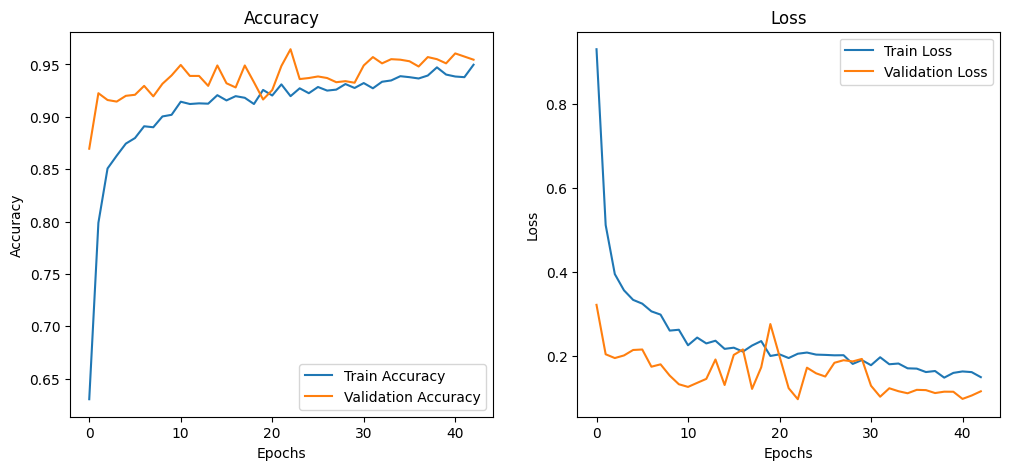

In [10]:
# Graficar la historia de entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [11]:
# Guardar el modelo
model.save("mobilenetv2_gastro_model.h5")
print("Modelo guardado")

Modelo guardado


In [12]:
# Evaluar en el conjunto de test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Evaluar en el conjunto de validación
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


  1/100 [..............................] - ETA: 9s - loss: 0.0064 - accuracy: 1.0000


  3/100 [..............................] - ETA: 3s - loss: 0.0191 - accuracy: 1.0000


  5/100 [>.............................] - ETA: 3s - loss: 0.0118 - accuracy: 1.0000


  8/100 [=>............................] - ETA: 2s - loss: 0.0199 - accuracy: 1.0000


 10/100 [==>...........................] - ETA: 2s - loss: 0.0192 - accuracy: 1.0000


 14/100 [===>..........................] - ETA: 2s - loss: 0.0399 - accuracy: 0.9821


 16/100 [===>..........................] - ETA: 2s - loss: 0.0387 - accuracy: 0.9844


 19/100 [====>.........................] - ETA: 2s - loss: 0.0615 - accuracy: 0.9737


 22/100 [=====>........................] - ETA: 1s - loss: 0.0600 - accuracy: 0.9773


 26/100 [======>.......................] - ETA: 1s - loss: 0.0678 - accuracy: 0.9663


 28/100 [=======>......................] - ETA: 1s - loss: 0.0636 - accuracy: 0.9688


 30/100 [========>.....................] - ETA: 1s - loss: 0.0610 - accuracy: 0.9708


 32/100 [========>.....................] - ETA: 1s - loss: 0.0619 - accuracy: 0.9727


 34/100 [=========>....................] - ETA: 1s - loss: 0.0607 - accuracy: 0.9743


 37/100 [==========>...................] - ETA: 1s - loss: 0.0558 - accuracy: 0.9764


 39/100 [==========>...................] - ETA: 1s - loss: 0.0536 - accuracy: 0.9776


 41/100 [===========>..................] - ETA: 1s - loss: 0.0589 - accuracy: 0.9726


 43/100 [===========>..................] - ETA: 1s - loss: 0.0581 - accuracy: 0.9738


 45/100 [============>.................] - ETA: 1s - loss: 0.0626 - accuracy: 0.9722


 47/100 [=============>................] - ETA: 1s - loss: 0.0624 - accuracy: 0.9707


 49/100 [=============>................] - ETA: 1s - loss: 0.0823 - accuracy: 0.9694


 51/100 [==============>...............] - ETA: 1s - loss: 0.0801 - accuracy: 0.9706


 53/100 [==============>...............] - ETA: 1s - loss: 0.0860 - accuracy: 0.9693


 55/100 [===============>..............] - ETA: 1s - loss: 0.0858 - accuracy: 0.9682


 57/100 [================>.............] - ETA: 1s - loss: 0.0835 - accuracy: 0.9693


 59/100 [================>.............] - ETA: 1s - loss: 0.0807 - accuracy: 0.9703


 61/100 [=================>............] - ETA: 1s - loss: 0.0784 - accuracy: 0.9713


 63/100 [=================>............] - ETA: 1s - loss: 0.0767 - accuracy: 0.9722


 65/100 [==================>...........] - ETA: 1s - loss: 0.0757 - accuracy: 0.9731


 67/100 [===================>..........] - ETA: 0s - loss: 0.0742 - accuracy: 0.9739


 69/100 [===================>..........] - ETA: 0s - loss: 0.0742 - accuracy: 0.9728


 71/100 [====================>.........] - ETA: 0s - loss: 0.0723 - accuracy: 0.9736


 73/100 [====================>.........] - ETA: 0s - loss: 0.0707 - accuracy: 0.9743


 75/100 [=====================>........] - ETA: 0s - loss: 0.0799 - accuracy: 0.9717


 76/100 [=====================>........] - ETA: 0s - loss: 0.0790 - accuracy: 0.9720


 77/100 [======================>.......] - ETA: 0s - loss: 0.0780 - accuracy: 0.9724


 78/100 [======================>.......] - ETA: 0s - loss: 0.0770 - accuracy: 0.9728


 79/100 [======================>.......] - ETA: 0s - loss: 0.0760 - accuracy: 0.9731


 80/100 [=======================>......] - ETA: 0s - loss: 0.0751 - accuracy: 0.9734


 81/100 [=======================>......] - ETA: 0s - loss: 0.0741 - accuracy: 0.9738


 82/100 [=======================>......] - ETA: 0s - loss: 0.0732 - accuracy: 0.9741


 83/100 [=======================>......] - ETA: 0s - loss: 0.0724 - accuracy: 0.9744


 84/100 [========================>.....] - ETA: 0s - loss: 0.0715 - accuracy: 0.9747


 85/100 [========================>.....] - ETA: 0s - loss: 0.0707 - accuracy: 0.9750


 86/100 [========================>.....] - ETA: 0s - loss: 0.0698 - accuracy: 0.9753


 87/100 [=========================>....] - ETA: 0s - loss: 0.0690 - accuracy: 0.9756


 88/100 [=========================>....] - ETA: 0s - loss: 0.0683 - accuracy: 0.9759


 89/100 [=========================>....] - ETA: 0s - loss: 0.0675 - accuracy: 0.9761


 90/100 [==========================>...] - ETA: 0s - loss: 0.0668 - accuracy: 0.9764


 91/100 [==========================>...] - ETA: 0s - loss: 0.0660 - accuracy: 0.9766


 92/100 [==========================>...] - ETA: 0s - loss: 0.0653 - accuracy: 0.9769


 93/100 [==========================>...] - ETA: 0s - loss: 0.0646 - accuracy: 0.9772


 94/100 [===========================>..] - ETA: 0s - loss: 0.0639 - accuracy: 0.9774


 95/100 [===========================>..] - ETA: 0s - loss: 0.0632 - accuracy: 0.9776


 96/100 [===========================>..] - ETA: 0s - loss: 0.0626 - accuracy: 0.9779


 97/100 [============================>.] - ETA: 0s - loss: 0.0620 - accuracy: 0.9781


 98/100 [============================>.] - ETA: 0s - loss: 0.0613 - accuracy: 0.9783


 99/100 [============================>.] - ETA: 0s - loss: 0.0607 - accuracy: 0.9785


100/100 [==============================] - ETA: 0s - loss: 0.0601 - accuracy: 0.9787


100/100 [==============================] - 4s 44ms/step - loss: 0.0601 - accuracy: 0.9787


Test Accuracy: 97.87%



  1/250 [..............................] - ETA: 15s - loss: 0.1281 - accuracy: 1.0000


  4/250 [..............................] - ETA: 4s - loss: 0.0910 - accuracy: 0.9688 


  8/250 [..............................] - ETA: 4s - loss: 0.0618 - accuracy: 0.9844


 12/250 [>.............................] - ETA: 4s - loss: 0.0473 - accuracy: 0.9896


 15/250 [>.............................] - ETA: 4s - loss: 0.0483 - accuracy: 0.9917


 19/250 [=>............................] - ETA: 4s - loss: 0.0577 - accuracy: 0.9868


 23/250 [=>............................] - ETA: 4s - loss: 0.0626 - accuracy: 0.9837


 27/250 [==>...........................] - ETA: 4s - loss: 0.0693 - accuracy: 0.9769


 30/250 [==>...........................] - ETA: 4s - loss: 0.0665 - accuracy: 0.9750


 34/250 [===>..........................] - ETA: 4s - loss: 0.0685 - accuracy: 0.9743


 38/250 [===>..........................] - ETA: 3s - loss: 0.0738 - accuracy: 0.9671


 42/250 [====>.........................] - ETA: 3s - loss: 0.0759 - accuracy: 0.9673


 46/250 [====>.........................] - ETA: 3s - loss: 0.0768 - accuracy: 0.9701


 50/250 [=====>........................] - ETA: 3s - loss: 0.0778 - accuracy: 0.9700


 54/250 [=====>........................] - ETA: 3s - loss: 0.0821 - accuracy: 0.9676


 58/250 [=====>........................] - ETA: 3s - loss: 0.0886 - accuracy: 0.9634


 61/250 [======>.......................] - ETA: 3s - loss: 0.0917 - accuracy: 0.9631


 64/250 [======>.......................] - ETA: 3s - loss: 0.0885 - accuracy: 0.9648


 66/250 [======>.......................] - ETA: 3s - loss: 0.0872 - accuracy: 0.9659


 68/250 [=======>......................] - ETA: 3s - loss: 0.1034 - accuracy: 0.9632


 70/250 [=======>......................] - ETA: 3s - loss: 0.1073 - accuracy: 0.9607


 71/250 [=======>......................] - ETA: 3s - loss: 0.1071 - accuracy: 0.9595


 73/250 [=======>......................] - ETA: 3s - loss: 0.1074 - accuracy: 0.9589


 75/250 [========>.....................] - ETA: 3s - loss: 0.1078 - accuracy: 0.9583


 77/250 [========>.....................] - ETA: 3s - loss: 0.1083 - accuracy: 0.9578


 79/250 [========>.....................] - ETA: 3s - loss: 0.1086 - accuracy: 0.9573


 81/250 [========>.....................] - ETA: 3s - loss: 0.1065 - accuracy: 0.9583


 83/250 [========>.....................] - ETA: 3s - loss: 0.1086 - accuracy: 0.9563


 85/250 [=========>....................] - ETA: 3s - loss: 0.1063 - accuracy: 0.9574


 87/250 [=========>....................] - ETA: 3s - loss: 0.1082 - accuracy: 0.9555


 89/250 [=========>....................] - ETA: 3s - loss: 0.1084 - accuracy: 0.9551


 91/250 [=========>....................] - ETA: 3s - loss: 0.1066 - accuracy: 0.9560


 93/250 [==========>...................] - ETA: 3s - loss: 0.1097 - accuracy: 0.9543


 95/250 [==========>...................] - ETA: 3s - loss: 0.1099 - accuracy: 0.9539


 97/250 [==========>...................] - ETA: 3s - loss: 0.1083 - accuracy: 0.9549


 99/250 [==========>...................] - ETA: 3s - loss: 0.1140 - accuracy: 0.9520


102/250 [===========>..................] - ETA: 3s - loss: 0.1108 - accuracy: 0.9534


104/250 [===========>..................] - ETA: 3s - loss: 0.1188 - accuracy: 0.9507


107/250 [===========>..................] - ETA: 3s - loss: 0.1235 - accuracy: 0.9498


110/250 [============>.................] - ETA: 3s - loss: 0.1204 - accuracy: 0.9511


112/250 [============>.................] - ETA: 3s - loss: 0.1190 - accuracy: 0.9520


114/250 [============>.................] - ETA: 3s - loss: 0.1182 - accuracy: 0.9518


116/250 [============>.................] - ETA: 3s - loss: 0.1167 - accuracy: 0.9526


118/250 [=============>................] - ETA: 3s - loss: 0.1192 - accuracy: 0.9523


121/250 [=============>................] - ETA: 3s - loss: 0.1185 - accuracy: 0.9525


124/250 [=============>................] - ETA: 3s - loss: 0.1175 - accuracy: 0.9526


126/250 [==============>...............] - ETA: 3s - loss: 0.1188 - accuracy: 0.9514


128/250 [==============>...............] - ETA: 3s - loss: 0.1186 - accuracy: 0.9512


131/250 [==============>...............] - ETA: 3s - loss: 0.1173 - accuracy: 0.9523


133/250 [==============>...............] - ETA: 3s - loss: 0.1162 - accuracy: 0.9530


135/250 [===============>..............] - ETA: 3s - loss: 0.1153 - accuracy: 0.9537


137/250 [===============>..............] - ETA: 2s - loss: 0.1153 - accuracy: 0.9535


140/250 [===============>..............] - ETA: 2s - loss: 0.1190 - accuracy: 0.9527


142/250 [================>.............] - ETA: 2s - loss: 0.1185 - accuracy: 0.9525


144/250 [================>.............] - ETA: 2s - loss: 0.1181 - accuracy: 0.9523


146/250 [================>.............] - ETA: 2s - loss: 0.1168 - accuracy: 0.9529


149/250 [================>.............] - ETA: 2s - loss: 0.1152 - accuracy: 0.9539


151/250 [=================>............] - ETA: 2s - loss: 0.1140 - accuracy: 0.9545


153/250 [=================>............] - ETA: 2s - loss: 0.1127 - accuracy: 0.9551


155/250 [=================>............] - ETA: 2s - loss: 0.1117 - accuracy: 0.9556


158/250 [=================>............] - ETA: 2s - loss: 0.1114 - accuracy: 0.9557


160/250 [==================>...........] - ETA: 2s - loss: 0.1142 - accuracy: 0.9547


162/250 [==================>...........] - ETA: 2s - loss: 0.1129 - accuracy: 0.9552


164/250 [==================>...........] - ETA: 2s - loss: 0.1120 - accuracy: 0.9558


166/250 [==================>...........] - ETA: 2s - loss: 0.1144 - accuracy: 0.9548


168/250 [===================>..........] - ETA: 2s - loss: 0.1160 - accuracy: 0.9546


170/250 [===================>..........] - ETA: 2s - loss: 0.1231 - accuracy: 0.9537


172/250 [===================>..........] - ETA: 2s - loss: 0.1220 - accuracy: 0.9542


174/250 [===================>..........] - ETA: 2s - loss: 0.1254 - accuracy: 0.9540


176/250 [====================>.........] - ETA: 2s - loss: 0.1241 - accuracy: 0.9545


179/250 [====================>.........] - ETA: 1s - loss: 0.1272 - accuracy: 0.9539


181/250 [====================>.........] - ETA: 1s - loss: 0.1292 - accuracy: 0.9523


183/250 [====================>.........] - ETA: 1s - loss: 0.1295 - accuracy: 0.9522


185/250 [=====================>........] - ETA: 1s - loss: 0.1287 - accuracy: 0.9520


187/250 [=====================>........] - ETA: 1s - loss: 0.1277 - accuracy: 0.9525


188/250 [=====================>........] - ETA: 1s - loss: 0.1274 - accuracy: 0.9528


189/250 [=====================>........] - ETA: 1s - loss: 0.1267 - accuracy: 0.9530


190/250 [=====================>........] - ETA: 1s - loss: 0.1260 - accuracy: 0.9533


191/250 [=====================>........] - ETA: 1s - loss: 0.1254 - accuracy: 0.9535


192/250 [======================>.......] - ETA: 1s - loss: 0.1247 - accuracy: 0.9538


193/250 [======================>.......] - ETA: 1s - loss: 0.1241 - accuracy: 0.9540


194/250 [======================>.......] - ETA: 1s - loss: 0.1235 - accuracy: 0.9543


195/250 [======================>.......] - ETA: 1s - loss: 0.1228 - accuracy: 0.9545


196/250 [======================>.......] - ETA: 1s - loss: 0.1222 - accuracy: 0.9547


197/250 [======================>.......] - ETA: 1s - loss: 0.1216 - accuracy: 0.9549


198/250 [======================>.......] - ETA: 1s - loss: 0.1210 - accuracy: 0.9552


199/250 [======================>.......] - ETA: 1s - loss: 0.1204 - accuracy: 0.9554


200/250 [=======================>......] - ETA: 1s - loss: 0.1198 - accuracy: 0.9556


201/250 [=======================>......] - ETA: 1s - loss: 0.1192 - accuracy: 0.9558


202/250 [=======================>......] - ETA: 1s - loss: 0.1186 - accuracy: 0.9561


203/250 [=======================>......] - ETA: 1s - loss: 0.1180 - accuracy: 0.9563


204/250 [=======================>......] - ETA: 1s - loss: 0.1174 - accuracy: 0.9565


205/250 [=======================>......] - ETA: 1s - loss: 0.1169 - accuracy: 0.9567


206/250 [=======================>......] - ETA: 1s - loss: 0.1163 - accuracy: 0.9569


207/250 [=======================>......] - ETA: 1s - loss: 0.1157 - accuracy: 0.9571


208/250 [=======================>......] - ETA: 1s - loss: 0.1152 - accuracy: 0.9573


209/250 [========================>.....] - ETA: 1s - loss: 0.1146 - accuracy: 0.9575


210/250 [========================>.....] - ETA: 1s - loss: 0.1141 - accuracy: 0.9577


211/250 [========================>.....] - ETA: 1s - loss: 0.1135 - accuracy: 0.9579


212/250 [========================>.....] - ETA: 1s - loss: 0.1131 - accuracy: 0.9581


213/250 [========================>.....] - ETA: 1s - loss: 0.1126 - accuracy: 0.9583


214/250 [========================>.....] - ETA: 1s - loss: 0.1120 - accuracy: 0.9585


215/250 [========================>.....] - ETA: 1s - loss: 0.1115 - accuracy: 0.9587


216/250 [========================>.....] - ETA: 1s - loss: 0.1110 - accuracy: 0.9589


217/250 [=========================>....] - ETA: 1s - loss: 0.1105 - accuracy: 0.9591


218/250 [=========================>....] - ETA: 1s - loss: 0.1100 - accuracy: 0.9593


219/250 [=========================>....] - ETA: 1s - loss: 0.1095 - accuracy: 0.9595


220/250 [=========================>....] - ETA: 1s - loss: 0.1090 - accuracy: 0.9597


221/250 [=========================>....] - ETA: 1s - loss: 0.1085 - accuracy: 0.9598


222/250 [=========================>....] - ETA: 0s - loss: 0.1080 - accuracy: 0.9600


223/250 [=========================>....] - ETA: 0s - loss: 0.1075 - accuracy: 0.9602


224/250 [=========================>....] - ETA: 0s - loss: 0.1071 - accuracy: 0.9604


225/250 [==========================>...] - ETA: 0s - loss: 0.1066 - accuracy: 0.9606


226/250 [==========================>...] - ETA: 0s - loss: 0.1061 - accuracy: 0.9607


227/250 [==========================>...] - ETA: 0s - loss: 0.1056 - accuracy: 0.9609


228/250 [==========================>...] - ETA: 0s - loss: 0.1052 - accuracy: 0.9611


229/250 [==========================>...] - ETA: 0s - loss: 0.1047 - accuracy: 0.9612


230/250 [==========================>...] - ETA: 0s - loss: 0.1043 - accuracy: 0.9614


231/250 [==========================>...] - ETA: 0s - loss: 0.1038 - accuracy: 0.9616


232/250 [==========================>...] - ETA: 0s - loss: 0.1034 - accuracy: 0.9617


233/250 [==========================>...] - ETA: 0s - loss: 0.1029 - accuracy: 0.9619


234/250 [===========================>..] - ETA: 0s - loss: 0.1025 - accuracy: 0.9621


235/250 [===========================>..] - ETA: 0s - loss: 0.1021 - accuracy: 0.9622


236/250 [===========================>..] - ETA: 0s - loss: 0.1016 - accuracy: 0.9624


237/250 [===========================>..] - ETA: 0s - loss: 0.1012 - accuracy: 0.9626


238/250 [===========================>..] - ETA: 0s - loss: 0.1008 - accuracy: 0.9627


239/250 [===========================>..] - ETA: 0s - loss: 0.1004 - accuracy: 0.9629


240/250 [===========================>..] - ETA: 0s - loss: 0.0999 - accuracy: 0.9630


241/250 [===========================>..] - ETA: 0s - loss: 0.0995 - accuracy: 0.9632


242/250 [============================>.] - ETA: 0s - loss: 0.0991 - accuracy: 0.9633


243/250 [============================>.] - ETA: 0s - loss: 0.0987 - accuracy: 0.9635


244/250 [============================>.] - ETA: 0s - loss: 0.0983 - accuracy: 0.9636


245/250 [============================>.] - ETA: 0s - loss: 0.0979 - accuracy: 0.9638


246/250 [============================>.] - ETA: 0s - loss: 0.0975 - accuracy: 0.9639


247/250 [============================>.] - ETA: 0s - loss: 0.0971 - accuracy: 0.9641


248/250 [============================>.] - ETA: 0s - loss: 0.0967 - accuracy: 0.9642


249/250 [============================>.] - ETA: 0s - loss: 0.0963 - accuracy: 0.9644


250/250 [==============================] - ETA: 0s - loss: 0.0959 - accuracy: 0.9645


250/250 [==============================] - 10s 40ms/step - loss: 0.0959 - accuracy: 0.9645


Validation Accuracy: 96.45%


In [13]:
# Cargar el modelo guardado y probarlo
test_model = keras.models.load_model("mobilenetv2_gastro_model.h5")

In [14]:
# Obtener predicciones para validación
y_true_val = val_generator.classes
y_pred_val = np.argmax(test_model.predict(val_generator), axis=1)

# Obtener predicciones para test
y_true_test = test_generator.classes
y_pred_test = np.argmax(test_model.predict(test_generator), axis=1)

# Reporte de clasificación para validación
print("\nValidation Classification Report:")
print(classification_report(y_true_val, y_pred_val, target_names=val_generator.class_indices.keys()))

# Reporte de clasificación para test
print("\nTest Classification Report:")
print(classification_report(y_true_test, y_pred_test, target_names=test_generator.class_indices.keys()))


  1/250 [..............................] - ETA: 1:49


  3/250 [..............................] - ETA: 9s  


  5/250 [..............................] - ETA: 9s


  7/250 [..............................] - ETA: 9s


 10/250 [>.............................] - ETA: 7s


 13/250 [>.............................] - ETA: 7s


 16/250 [>.............................] - ETA: 6s


 20/250 [=>............................] - ETA: 5s


 24/250 [=>............................] - ETA: 5s


 28/250 [==>...........................] - ETA: 5s


 32/250 [==>...........................] - ETA: 4s


 35/250 [===>..........................] - ETA: 4s


 39/250 [===>..........................] - ETA: 4s


 42/250 [====>.........................] - ETA: 4s


 46/250 [====>.........................] - ETA: 4s


 50/250 [=====>........................] - ETA: 4s


 53/250 [=====>........................] - ETA: 4s


 57/250 [=====>........................] - ETA: 3s


 61/250 [======>.......................] - ETA: 3s


 64/250 [======>.......................] - ETA: 3s


 67/250 [=======>......................] - ETA: 3s


 69/250 [=======>......................] - ETA: 3s


 71/250 [=======>......................] - ETA: 3s


 74/250 [=======>......................] - ETA: 3s


 76/250 [========>.....................] - ETA: 3s


 78/250 [========>.....................] - ETA: 3s


 80/250 [========>.....................] - ETA: 3s


 83/250 [========>.....................] - ETA: 3s


 85/250 [=========>....................] - ETA: 3s


 88/250 [=========>....................] - ETA: 3s


 90/250 [=========>....................] - ETA: 3s


 92/250 [==========>...................] - ETA: 3s


 93/250 [==========>...................] - ETA: 3s


 96/250 [==========>...................] - ETA: 3s


 98/250 [==========>...................] - ETA: 3s


100/250 [===========>..................] - ETA: 3s


103/250 [===========>..................] - ETA: 3s


105/250 [===========>..................] - ETA: 3s


108/250 [===========>..................] - ETA: 3s


110/250 [============>.................] - ETA: 3s


112/250 [============>.................] - ETA: 3s


115/250 [============>.................] - ETA: 3s


117/250 [=============>................] - ETA: 3s


119/250 [=============>................] - ETA: 3s


121/250 [=============>................] - ETA: 3s


124/250 [=============>................] - ETA: 3s


127/250 [==============>...............] - ETA: 3s


129/250 [==============>...............] - ETA: 3s


131/250 [==============>...............] - ETA: 3s


133/250 [==============>...............] - ETA: 2s


135/250 [===============>..............] - ETA: 2s


137/250 [===============>..............] - ETA: 2s


140/250 [===============>..............] - ETA: 2s


142/250 [================>.............] - ETA: 2s


144/250 [================>.............] - ETA: 2s


146/250 [================>.............] - ETA: 2s


149/250 [================>.............] - ETA: 2s


152/250 [=================>............] - ETA: 2s


155/250 [=================>............] - ETA: 2s


157/250 [=================>............] - ETA: 2s


160/250 [==================>...........] - ETA: 2s


163/250 [==================>...........] - ETA: 2s


166/250 [==================>...........] - ETA: 2s


168/250 [===================>..........] - ETA: 2s


170/250 [===================>..........] - ETA: 2s


173/250 [===================>..........] - ETA: 2s


175/250 [====================>.........] - ETA: 2s


177/250 [====================>.........] - ETA: 1s


179/250 [====================>.........] - ETA: 1s


181/250 [====================>.........] - ETA: 1s


184/250 [=====================>........] - ETA: 1s


187/250 [=====================>........] - ETA: 1s


188/250 [=====================>........] - ETA: 1s


189/250 [=====================>........] - ETA: 1s


190/250 [=====================>........] - ETA: 1s


191/250 [=====================>........] - ETA: 1s


192/250 [======================>.......] - ETA: 1s


193/250 [======================>.......] - ETA: 1s


194/250 [======================>.......] - ETA: 1s


195/250 [======================>.......] - ETA: 1s


196/250 [======================>.......] - ETA: 1s


197/250 [======================>.......] - ETA: 1s


198/250 [======================>.......] - ETA: 1s


199/250 [======================>.......] - ETA: 1s


200/250 [=======================>......] - ETA: 1s


201/250 [=======================>......] - ETA: 1s


202/250 [=======================>......] - ETA: 1s


203/250 [=======================>......] - ETA: 1s


204/250 [=======================>......] - ETA: 1s


205/250 [=======================>......] - ETA: 1s


206/250 [=======================>......] - ETA: 1s


207/250 [=======================>......] - ETA: 1s


208/250 [=======================>......] - ETA: 1s


209/250 [========================>.....] - ETA: 1s


210/250 [========================>.....] - ETA: 1s


211/250 [========================>.....] - ETA: 1s


212/250 [========================>.....] - ETA: 1s


213/250 [========================>.....] - ETA: 1s


214/250 [========================>.....] - ETA: 1s


215/250 [========================>.....] - ETA: 1s


216/250 [========================>.....] - ETA: 1s


217/250 [=========================>....] - ETA: 1s


218/250 [=========================>....] - ETA: 1s


219/250 [=========================>....] - ETA: 1s


220/250 [=========================>....] - ETA: 1s


221/250 [=========================>....] - ETA: 1s


222/250 [=========================>....] - ETA: 0s


223/250 [=========================>....] - ETA: 0s


224/250 [=========================>....] - ETA: 0s


225/250 [==========================>...] - ETA: 0s


226/250 [==========================>...] - ETA: 0s


227/250 [==========================>...] - ETA: 0s


228/250 [==========================>...] - ETA: 0s


229/250 [==========================>...] - ETA: 0s


230/250 [==========================>...] - ETA: 0s


231/250 [==========================>...] - ETA: 0s


232/250 [==========================>...] - ETA: 0s


233/250 [==========================>...] - ETA: 0s


234/250 [===========================>..] - ETA: 0s


235/250 [===========================>..] - ETA: 0s


236/250 [===========================>..] - ETA: 0s


237/250 [===========================>..] - ETA: 0s


238/250 [===========================>..] - ETA: 0s


239/250 [===========================>..] - ETA: 0s


240/250 [===========================>..] - ETA: 0s


241/250 [===========================>..] - ETA: 0s


242/250 [============================>.] - ETA: 0s


243/250 [============================>.] - ETA: 0s


244/250 [============================>.] - ETA: 0s


245/250 [============================>.] - ETA: 0s


246/250 [============================>.] - ETA: 0s


247/250 [============================>.] - ETA: 0s


248/250 [============================>.] - ETA: 0s


249/250 [============================>.] - ETA: 0s


250/250 [==============================] - ETA: 0s


250/250 [==============================] - 10s 40ms/step



  1/100 [..............................] - ETA: 4s


  3/100 [..............................] - ETA: 3s


  5/100 [>.............................] - ETA: 2s


  7/100 [=>............................] - ETA: 2s


 11/100 [==>...........................] - ETA: 2s


 15/100 [===>..........................] - ETA: 1s


 19/100 [====>.........................] - ETA: 1s


 23/100 [=====>........................] - ETA: 1s


 26/100 [======>.......................] - ETA: 1s


 28/100 [=======>......................] - ETA: 1s


 31/100 [========>.....................] - ETA: 1s


 33/100 [========>.....................] - ETA: 1s


 36/100 [=========>....................] - ETA: 1s


 38/100 [==========>...................] - ETA: 1s


 40/100 [===========>..................] - ETA: 1s


 43/100 [===========>..................] - ETA: 1s


 45/100 [============>.................] - ETA: 1s


 48/100 [=============>................] - ETA: 1s


 50/100 [==============>...............] - ETA: 1s


 52/100 [==============>...............] - ETA: 1s


 54/100 [===============>..............] - ETA: 1s


 56/100 [===============>..............] - ETA: 1s


 59/100 [================>.............] - ETA: 1s


 62/100 [=================>............] - ETA: 0s


 64/100 [==================>...........] - ETA: 0s


 66/100 [==================>...........] - ETA: 0s


 68/100 [===================>..........] - ETA: 0s


 70/100 [====================>.........] - ETA: 0s


 72/100 [====================>.........] - ETA: 0s


 74/100 [=====================>........] - ETA: 0s


 76/100 [=====================>........] - ETA: 0s


 77/100 [======================>.......] - ETA: 0s


 78/100 [======================>.......] - ETA: 0s


 79/100 [======================>.......] - ETA: 0s


 80/100 [=======================>......] - ETA: 0s


 81/100 [=======================>......] - ETA: 0s


 82/100 [=======================>......] - ETA: 0s


 83/100 [=======================>......] - ETA: 0s


 84/100 [========================>.....] - ETA: 0s


 85/100 [========================>.....] - ETA: 0s


 86/100 [========================>.....] - ETA: 0s


 87/100 [=========================>....] - ETA: 0s


 88/100 [=========================>....] - ETA: 0s


 89/100 [=========================>....] - ETA: 0s


 90/100 [==========================>...] - ETA: 0s


 91/100 [==========================>...] - ETA: 0s


 92/100 [==========================>...] - ETA: 0s


 93/100 [==========================>...] - ETA: 0s


 94/100 [===========================>..] - ETA: 0s


 95/100 [===========================>..] - ETA: 0s


 96/100 [===========================>..] - ETA: 0s


 97/100 [============================>.] - ETA: 0s


 98/100 [============================>.] - ETA: 0s


 99/100 [============================>.] - ETA: 0s


100/100 [==============================] - ETA: 0s


100/100 [==============================] - 4s 39ms/step



Validation Classification Report:


                      precision    recall  f1-score   support

            0_normal       0.99      0.96      0.98       500
1_ulcerative_colitis       0.94      0.94      0.94       500
            2_polyps       0.95      0.96      0.95       500
       3_esophagitis       0.98      1.00      0.99       500

            accuracy                           0.96      2000
           macro avg       0.96      0.96      0.96      2000
        weighted avg       0.96      0.96      0.96      2000


Test Classification Report:
                      precision    recall  f1-score   support

            0_normal       1.00      0.97      0.98       200
1_ulcerative_colitis       0.95      0.97      0.96       200
            2_polyps       0.97      0.97      0.97       200
       3_esophagitis       0.99      1.00      1.00       200

            accuracy                           0.98       800
           macro avg       0.98      0.98      0.98       800
        weighted avg       0.98     

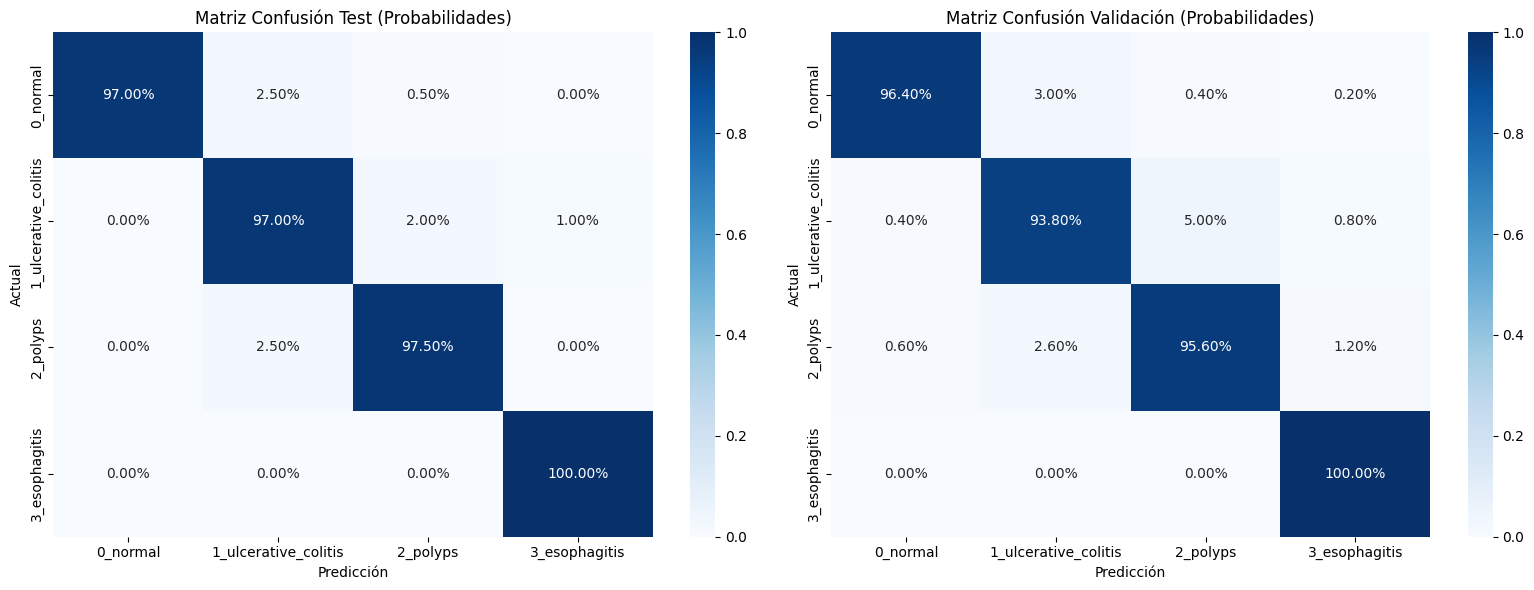

In [15]:
# Función para convertir la matriz de confusión a probabilidades
def confusion_matrix_prob(cm):
    return cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Matriz de confusión para el conjunto de test
cm_test = confusion_matrix(y_true_test, y_pred_test)
cm_test_prob = confusion_matrix_prob(cm_test)
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_test_prob, annot=True, fmt='.2%', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz Confusión Test (Probabilidades)')

# Matriz de confusión para el conjunto de validación
cm_val = confusion_matrix(y_true_val, y_pred_val)
cm_val_prob = confusion_matrix_prob(cm_val)
plt.subplot(1, 2, 2)
sns.heatmap(cm_val_prob, annot=True, fmt='.2%', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz Confusión Validación (Probabilidades)')

plt.tight_layout()
plt.show()